In [1]:
import numpy as np
import pickle
import sys
from typing import List
import torch
import os

In [2]:
participant_data_path = './EEG/number'
processed_data_path = './EEG/processed_data'
split_data_path = './EEG/split_data'

In [3]:
ps = os.listdir(participant_data_path)
participants=[]
for p in ps:
    p= p[:3]
    if p not in participants:
        participants.append(p)
        
participants= sorted(participants)
# participants, len(participants)

In [4]:
load_name=f"userfold_data_scaled_p_dictionary-number"
data_dir = "./EEG/split_data/standard_scaled"
try:
    raw_user_fold= pickle.load(open(os.path.join(data_dir, f"{load_name}.pkl"), "rb"))
except:
    print(f"pickle file does not exist. Use EEG-Preprocess.ipynb and EEG-Split.ipynb to save data setting.")
    sys.exit()

In [5]:
from utilities.userfold_framework import *
from utilities.EEG_func import *
import Models.model_func as Model_Func
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from torcheeg.models import EEGNet
# import Models.model_func as Model_Func
from torch import nn
from Models.multi_models import *

DEVICE= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

learning_rate = 0.00005
batch_size = 64
n_epochs = 300
transpose_channels=True
participants_dictionary=[]
# participants_online_dictionary=[]
participants_grads_dictionary={}
b_acc_list=[]
c0_acc_list=[]
c1_acc_list=[]

# EPOCH=[
    
# ]

for i in range(len(participants)):

    train_dataloader, val_dataloader, classes, input_dim, class_ratio= user_fold_load(i,
                                                                                      raw_user_fold,
                                                                                      participants,
                                                                                      batch_size=batch_size,
                                                                                      transpose_channels=transpose_channels)

    classifier= EEGNet(
        chunk_size=input_dim[1],
        num_electrodes=input_dim[0],
        num_classes=classes,
        kernel_1= 32,
        kernel_2=32,
        F1=8,
        F2=16,
        dropout=0.5
    ).to(DEVICE)
    
    
    criterion= torch.nn.CrossEntropyLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
#     criterion = nn.NLLLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
        
    saved_dir= "./EEG/saved_models/Userfold/run0"
    model = EEGNet_IE_TS_Wrapper(DEVICE, classifier, input_dim[1]).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
#     optimizer= torch.optim.RMSprop(classifier.parameters(), lr=learning_rate)
    scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

    
    train_func= eeg_train
    model.training_procedure(iteration=n_epochs,
                                    train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader,
                                     print_cycle=2,
                                     path=f"./dictionary/intermdiate_dicts",
                                     loss_func=criterion,
                                     optimiser=optimizer, #scheduler=scheduler,
                                     train_func=train_func
                                    )
    if model.epoch == n_epochs+1:
        EPOCH= n_epochs
    else:
        EPOCH= model.epoch
    
    torch.save(model.state_dict(), 
           os.path.join(
               saved_dir, f"Userfold-{participants[i]}-EEGNet-Weight_TS-e{EPOCH}.pt"
           )
    )

    pickle.dump( model.return_IE_weights(), 
                open(f"{saved_dir}/Userfold-{participants[i]}-EEGNet-Weight_TS-w-e{EPOCH}.pkl", "wb") 
               )    

# OR
#     model.load_state_dict(
#     torch.load(
#         open(
#             os.path.join(
#                 saved_dir, f"Userfold-{participants[i]}-EEGNet-Weight_TS-e{n_epochs}.pt"
#             ), "rb"
#         )
#               )
#     )
#     pickle.load( 
#                 open(f"{saved_dir}/Userfold-{participants[i]}-EEGNet-Weight_TS-w-e{EPOCH}.pkl", "rb") 
#                )  
    
    prediction, dictionary= model.prediction_procedure(val_dataloader, dict_flag=True)
    
    ys= np.concatenate([y.detach().cpu().numpy() for x, y in val_dataloader])
    
    c0_acc, c1_acc, b_acc= calculate_accuracy(ys, prediction)
    print("c0_acc", c0_acc, ", c1_acc", c1_acc, ", b_acc", b_acc)
    b_acc_list.append(b_acc)
    c0_acc_list.append(c0_acc)
    c1_acc_list.append(c1_acc)
    participants_dictionary.append(dictionary)
    

tmp=[]
for i, dictionary in enumerate(participants_dictionary):
    print(f"User {participants[i]} f1: {dictionary['weighted avg']['f1-score']} acc: {dictionary['accuracy']}")
    print(f" c0: {c0_acc_list[i]} c1: {c1_acc_list[i]} bacc: {b_acc_list[i]}")
    tmp.append(dictionary['weighted avg']['f1-score'])

print(f"average {np.mean(tmp)}")
print()
print(np.array(b_acc_list).mean())
print(np.array(c1_acc_list).mean())
print(np.array(c0_acc_list).mean())


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.802994518887763


Iterations:   0%|                                   | 1/300 [00:03<16:30,  3.31s/it]

Epoch:  0
t_loss:  0.802994518887763 , v_loss:  0.6924018661181132
t_acc:  0.4077186430127607 , v_acc:  0.4968944099378882
t_recall:  0.5156160360137797 , v_recall:  0.5032432432432432
t_prec:  0.5186522551666102 , v_prec:  0.5027803521779426
t_f:  0.4044508838017966 , v_f:  0.48120300751879697
////////


Iterations:   1%|▏                                  | 2/300 [00:04<08:48,  1.77s/it]

Epoch  1 , loss 0.7697568313748229
Epoch  2 , loss 0.7342043016471115


Iterations:   1%|▎                                  | 3/300 [00:05<07:12,  1.46s/it]

Epoch:  2
t_loss:  0.7342043016471115 , v_loss:  0.6878563761711121
t_acc:  0.46903205726735137 , v_acc:  0.577639751552795
t_recall:  0.5133946830265849 , v_recall:  0.5343243243243243
t_prec:  0.5119014132026278 , v_prec:  0.5314356435643564
t_f:  0.46493950650930727 , v_f:  0.5305317324185249
////////


Iterations:   1%|▍                                  | 4/300 [00:05<05:42,  1.16s/it]

Epoch  3 , loss 0.7061522591347787
Epoch  4 , loss 0.6786272128423055


Iterations:   2%|▌                                  | 5/300 [00:06<05:38,  1.15s/it]

Epoch:  4
t_loss:  0.6786272128423055 , v_loss:  0.6790077686309814
t_acc:  0.5583566760037348 , v_acc:  0.6521739130434783
t_recall:  0.5347579637940736 , v_recall:  0.5499099099099098
t_prec:  0.530095831306478 , v_prec:  0.5641500694766095
t_f:  0.5237594993551411 , v_f:  0.5490196078431372
////////


Iterations:   2%|▋                                  | 6/300 [00:07<04:50,  1.01it/s]

Epoch  5 , loss 0.6516667639507967
Epoch  6 , loss 0.6330556670824686


Iterations:   2%|▊                                  | 7/300 [00:08<05:04,  1.04s/it]

Epoch:  6
t_loss:  0.6330556670824686 , v_loss:  0.6658100287119547
t_acc:  0.6069094304388422 , v_acc:  0.6708074534161491
t_recall:  0.5216391485156668 , v_recall:  0.5084684684684685
t_prec:  0.52305509006203 , v_prec:  0.5284848484848486
t_f:  0.5217213284298803 , v_f:  0.46404120344199484
////////


Iterations:   3%|▉                                  | 8/300 [00:09<04:35,  1.06it/s]

Epoch  7 , loss 0.6118058012981041
Epoch  8 , loss 0.5902097178440467


Iterations:   3%|█                                  | 9/300 [00:10<04:53,  1.01s/it]

Epoch:  8
t_loss:  0.5902097178440467 , v_loss:  0.654354969660441
t_acc:  0.656084656084656 , v_acc:  0.6832298136645962
t_recall:  0.5265073221613757 , v_recall:  0.5064864864864865
t_prec:  0.542097641854896 , v_prec:  0.5461538461538462
t_f:  0.5165817867015927 , v_f:  0.4408580183861083
////////


Iterations:   3%|█▏                                | 10/300 [00:11<04:22,  1.10it/s]

Epoch  9 , loss 0.5775215719260421
Epoch  10 , loss 0.5576472235660926


Iterations:   4%|█▏                                | 11/300 [00:12<04:43,  1.02it/s]

Epoch:  10
t_loss:  0.5576472235660926 , v_loss:  0.6475592950979868
t_acc:  0.6741363211951448 , v_acc:  0.6894409937888198
t_recall:  0.5190678140569028 , v_recall:  0.5
t_prec:  0.5464474845542807 , v_prec:  0.3447204968944099
t_f:  0.49137202552263853 , v_f:  0.4080882352941176
////////


Iterations:   4%|█▎                                | 12/300 [00:13<04:18,  1.11it/s]

Epoch  11 , loss 0.5428076889000687
Epoch  12 , loss 0.5328291029322381


Iterations:   4%|█▍                                | 13/300 [00:14<04:37,  1.03it/s]

Epoch:  12
t_loss:  0.5328291029322381 , v_loss:  0.6438657542069753
t_acc:  0.6865857454092749 , v_acc:  0.6894409937888198
t_recall:  0.5139272038539137 , v_recall:  0.5
t_prec:  0.5585227862555797 , v_prec:  0.3447204968944099
t_f:  0.46637880233992435 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▌                                | 14/300 [00:15<04:17,  1.11it/s]

Epoch  13 , loss 0.515599179501627
Epoch  14 , loss 0.5038654178965325


Iterations:   5%|█▋                                | 15/300 [00:16<04:36,  1.03it/s]

Epoch:  14
t_loss:  0.5038654178965325 , v_loss:  0.642674575249354
t_acc:  0.690631808278867 , v_acc:  0.6894409937888198
t_recall:  0.5096471363280768 , v_recall:  0.5
t_prec:  0.5628824476650564 , v_prec:  0.3447204968944099
t_f:  0.4492861133527842 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▊                                | 16/300 [00:16<04:10,  1.13it/s]

Epoch  15 , loss 0.5007103295887217
Epoch  16 , loss 0.4909970988245571


Iterations:   6%|█▉                                | 17/300 [00:18<04:37,  1.02it/s]

Epoch:  16
t_loss:  0.4909970988245571 , v_loss:  0.6432808538277944
t_acc:  0.6887643946467475 , v_acc:  0.6894409937888198
t_recall:  0.5008289757208932 , v_recall:  0.5
t_prec:  0.5092750893213623 , v_prec:  0.3447204968944099
t_f:  0.42639749778628355 , v_f:  0.4080882352941176
////////


Iterations:   6%|██                                | 18/300 [00:18<04:14,  1.11it/s]

Epoch  17 , loss 0.47890684826701296
Epoch  18 , loss 0.47384907801946


Iterations:   6%|██▏                               | 19/300 [00:19<04:34,  1.02it/s]

Epoch:  18
t_loss:  0.47384907801946 , v_loss:  0.6465116143226624
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5045367206049876 , v_recall:  0.5
t_prec:  0.6073958152833132 , v_prec:  0.3447204968944099
t_f:  0.4247499465359022 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▎                               | 20/300 [00:20<04:13,  1.11it/s]

Epoch  19 , loss 0.4763338793726528
Epoch  20 , loss 0.46927554291837353


Iterations:   7%|██▍                               | 21/300 [00:21<04:31,  1.03it/s]

Epoch:  20
t_loss:  0.46927554291837353 , v_loss:  0.6496415038903555
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5036741192132965 , v_recall:  0.5
t_prec:  0.6094589069101812 , v_prec:  0.3447204968944099
t_f:  0.42194192903870326 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▍                               | 22/300 [00:22<04:14,  1.09it/s]

Epoch  21 , loss 0.4713302424141005
Epoch  22 , loss 0.4598207035485436


Iterations:   8%|██▌                               | 23/300 [00:23<04:35,  1.00it/s]

Epoch:  22
t_loss:  0.4598207035485436 , v_loss:  0.6531175971031189
t_acc:  0.6946778711484594 , v_acc:  0.6894409937888198
t_recall:  0.5013415956410151 , v_recall:  0.5
t_prec:  0.553973717146433 , v_prec:  0.3447204968944099
t_f:  0.4167203167374342 , v_f:  0.4080882352941176
////////


Iterations:   8%|██▋                               | 24/300 [00:24<04:08,  1.11it/s]

Epoch  23 , loss 0.4573406039499769
Epoch  24 , loss 0.45231547308903114


Iterations:   8%|██▊                               | 25/300 [00:25<04:30,  1.02it/s]

Epoch:  24
t_loss:  0.45231547308903114 , v_loss:  0.6573869089285532
t_acc:  0.6984126984126984 , v_acc:  0.6894409937888198
t_recall:  0.5051762945883257 , v_recall:  0.5
t_prec:  0.7719831730769231 , v_prec:  0.3447204968944099
t_f:  0.42195546486919533 , v_f:  0.4080882352941176
////////


Iterations:   9%|██▉                               | 26/300 [00:26<04:07,  1.11it/s]

Epoch  25 , loss 0.4537954453159781
Epoch  26 , loss 0.45194678914313224


Iterations:   9%|███                               | 27/300 [00:27<04:25,  1.03it/s]

Epoch:  26
t_loss:  0.45194678914313224 , v_loss:  0.6598445971806844
t_acc:  0.6937441643323996 , v_acc:  0.6894409937888198
t_recall:  0.49980785330972677 , v_recall:  0.5
t_prec:  0.49062206939668646 , v_prec:  0.3447204968944099
t_f:  0.4134912201550572 , v_f:  0.4080882352941176
////////


Iterations:   9%|███▏                              | 28/300 [00:28<04:01,  1.12it/s]

Epoch  27 , loss 0.44882986007952225
Epoch  28 , loss 0.4487604761824888


Iterations:  10%|███▎                              | 29/300 [00:29<04:22,  1.03it/s]

Epoch:  28
t_loss:  0.4487604761824888 , v_loss:  0.6603017151355743
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.500862601391691 , v_recall:  0.5
t_prec:  0.5979887745556596 , v_prec:  0.3447204968944099
t_f:  0.4131921101460188 , v_f:  0.4080882352941176
////////


Iterations:  10%|███▍                              | 30/300 [00:30<04:06,  1.10it/s]

Epoch  29 , loss 0.4476121383554795
Epoch  30 , loss 0.44608986260844213


Iterations:  10%|███▌                              | 31/300 [00:31<04:24,  1.02it/s]

Epoch:  30
t_loss:  0.44608986260844213 , v_loss:  0.6617599030335745
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5022364502271449 , v_recall:  0.5
t_prec:  0.6175120192307693 , v_prec:  0.3447204968944099
t_f:  0.41718316736553546 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▋                              | 32/300 [00:31<03:58,  1.12it/s]

Epoch  31 , loss 0.44395284617648406
Epoch  32 , loss 0.45046942608029233


Iterations:  11%|███▋                              | 33/300 [00:33<04:19,  1.03it/s]

Epoch:  32
t_loss:  0.45046942608029233 , v_loss:  0.6597777009010315
t_acc:  0.6968565203859322 , v_acc:  0.6894409937888198
t_recall:  0.5034826587612028 , v_recall:  0.5
t_prec:  0.6699749921850578 , v_prec:  0.3447204968944099
t_f:  0.4194516752347822 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▊                              | 34/300 [00:33<03:56,  1.12it/s]

Epoch  33 , loss 0.4436526748479581
Epoch  34 , loss 0.44611744553435084


Iterations:  12%|███▉                              | 35/300 [00:34<04:14,  1.04it/s]

Epoch:  34
t_loss:  0.44611744553435084 , v_loss:  0.6578467637300491
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.5009902416930868 , v_recall:  0.5
t_prec:  0.5563495782567948 , v_prec:  0.3447204968944099
t_f:  0.41491069636764993 , v_f:  0.4080882352941176
////////


Iterations:  12%|████                              | 36/300 [00:35<03:54,  1.13it/s]

Epoch  35 , loss 0.443656806267944
Epoch  36 , loss 0.44569380084673565


Iterations:  12%|████▏                             | 37/300 [00:36<04:14,  1.03it/s]

Epoch:  36
t_loss:  0.44569380084673565 , v_loss:  0.6534420003493627
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5025239840243751 , v_recall:  0.5
t_prec:  0.6150093808630395 , v_prec:  0.3447204968944099
t_f:  0.4181429031380904 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▎                             | 38/300 [00:37<03:49,  1.14it/s]

Epoch  37 , loss 0.44308827729786143
Epoch  38 , loss 0.44163033804472757


Iterations:  13%|████▍                             | 39/300 [00:38<04:07,  1.05it/s]

Epoch:  38
t_loss:  0.44163033804472757 , v_loss:  0.6498837967713674
t_acc:  0.6965452847805789 , v_acc:  0.6894409937888198
t_recall:  0.5026838775202097 , v_recall:  0.5
t_prec:  0.6665578331724491 , v_prec:  0.3447204968944099
t_f:  0.4174144390948958 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▌                             | 40/300 [00:39<03:50,  1.13it/s]

Epoch  39 , loss 0.4371302355738247
Epoch  40 , loss 0.4445112832621032


Iterations:  14%|████▋                             | 41/300 [00:40<04:09,  1.04it/s]

Epoch:  40
t_loss:  0.4445112832621032 , v_loss:  0.645767147342364
t_acc:  0.6940553999377529 , v_acc:  0.6894409937888198
t_recall:  0.5003191007534895 , v_recall:  0.5
t_prec:  0.5145403377110694 , v_prec:  0.3447204968944099
t_f:  0.4145695739864307 , v_f:  0.4080882352941176
////////


Iterations:  14%|████▊                             | 42/300 [00:41<03:46,  1.14it/s]

Epoch  41 , loss 0.4381001451436211
Epoch  42 , loss 0.4366121116806479


Iterations:  14%|████▊                             | 43/300 [00:42<04:05,  1.05it/s]

Epoch:  42
t_loss:  0.4366121116806479 , v_loss:  0.6402289519707361
t_acc:  0.6968565203859322 , v_acc:  0.6894409937888198
t_recall:  0.5037701925584332 , v_recall:  0.5
t_prec:  0.6611080700656866 , v_prec:  0.3447204968944099
t_f:  0.42040645937480553 , v_f:  0.4080882352941176
////////


Iterations:  15%|████▉                             | 44/300 [00:42<03:46,  1.13it/s]

Epoch  43 , loss 0.44098226989016814
Epoch  44 , loss 0.4363501206332562


Iterations:  15%|█████                             | 45/300 [00:44<04:09,  1.02it/s]

Epoch:  44
t_loss:  0.4363501206332562 , v_loss:  0.6384811749060949
t_acc:  0.6984126984126984 , v_acc:  0.6894409937888198
t_recall:  0.5060388959800167 , v_recall:  0.5
t_prec:  0.7175131002208087 , v_prec:  0.3447204968944099
t_f:  0.4247991718755456 , v_f:  0.4080882352941176
////////


Iterations:  15%|█████▏                            | 46/300 [00:44<03:54,  1.08it/s]

Epoch  45 , loss 0.4371739988233529
Epoch  46 , loss 0.43182649799421724


Iterations:  16%|█████▎                            | 47/300 [00:46<04:16,  1.01s/it]

Epoch:  46
t_loss:  0.43182649799421724 , v_loss:  0.63660928606987
t_acc:  0.6999688764394647 , v_acc:  0.6894409937888198
t_recall:  0.50802006560437 , v_recall:  0.5
t_prec:  0.7745145631067961 , v_prec:  0.3447204968944099
t_f:  0.42823524720775386 , v_f:  0.4080882352941176
////////


Iterations:  16%|█████▍                            | 48/300 [00:46<03:59,  1.05it/s]

Epoch  47 , loss 0.446859221832425
Epoch  48 , loss 0.44226091866399725


Iterations:  16%|█████▌                            | 49/300 [00:48<04:12,  1.01s/it]

Epoch:  48
t_loss:  0.44226091866399725 , v_loss:  0.6333392659823099
t_acc:  0.6971677559912854 , v_acc:  0.6894409937888198
t_recall:  0.5048565075966567 , v_recall:  0.5
t_prec:  0.6583646616541354 , v_prec:  0.3447204968944099
t_f:  0.4233686422741149 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▋                            | 50/300 [00:48<03:46,  1.10it/s]

Epoch  49 , loss 0.43756550959512297
Epoch  50 , loss 0.43550918324320925


Iterations:  17%|█████▊                            | 51/300 [00:49<04:02,  1.03it/s]

Epoch:  50
t_loss:  0.43550918324320925 , v_loss:  0.6300221780935923
t_acc:  0.6984126984126984 , v_acc:  0.6894409937888198
t_recall:  0.5066139635744774 , v_recall:  0.5
t_prec:  0.6970423878969606 , v_prec:  0.3447204968944099
t_f:  0.4266752602236473 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▉                            | 52/300 [00:50<03:44,  1.11it/s]

Epoch  51 , loss 0.4349223182481878
Epoch  52 , loss 0.43315623262349295


Iterations:  18%|██████                            | 53/300 [00:51<04:05,  1.01it/s]

Epoch:  52
t_loss:  0.43315623262349295 , v_loss:  0.6271425783634186
t_acc:  0.6965452847805789 , v_acc:  0.6894409937888198
t_recall:  0.5044090803035918 , v_recall:  0.5
t_prec:  0.6313547771568762 , v_prec:  0.3447204968944099
t_f:  0.42312526183493926 , v_f:  0.4080882352941176
////////


Iterations:  18%|██████                            | 54/300 [00:52<03:42,  1.11it/s]

Epoch  53 , loss 0.4347279971721126
Epoch  54 , loss 0.4375152786572774


Iterations:  18%|██████▏                           | 55/300 [00:53<04:02,  1.01it/s]

Epoch:  54
t_loss:  0.4375152786572774 , v_loss:  0.6240649372339249
t_acc:  0.6974789915966386 , v_acc:  0.6956521739130435
t_recall:  0.5059428226348801 , v_recall:  0.51
t_prec:  0.6567666722985204 , v_prec:  0.846875
t_f:  0.4263014338808543 , v_f:  0.42920193907821425
////////


Iterations:  19%|██████▎                           | 56/300 [00:54<03:38,  1.12it/s]

Epoch  55 , loss 0.4327232434469111
Epoch  56 , loss 0.4340495589901419


Iterations:  19%|██████▍                           | 57/300 [00:55<03:57,  1.02it/s]

Epoch:  56
t_loss:  0.4340495589901419 , v_loss:  0.622585286696752
t_acc:  0.6981014628073452 , v_acc:  0.6956521739130435
t_recall:  0.507252851319636 , v_recall:  0.51
t_prec:  0.6660226201696513 , v_prec:  0.846875
t_f:  0.4293327796234772 , v_f:  0.42920193907821425
////////


Iterations:  19%|██████▌                           | 58/300 [00:56<03:36,  1.12it/s]

Epoch  57 , loss 0.42944734353645175
Epoch  58 , loss 0.4310851804181641


Iterations:  20%|██████▋                           | 59/300 [00:57<03:50,  1.04it/s]

Epoch:  58
t_loss:  0.4310851804181641 , v_loss:  0.6175921758015951
t_acc:  0.6977902272019919 , v_acc:  0.6956521739130435
t_recall:  0.5084668066592553 , v_recall:  0.51
t_prec:  0.6423046166148925 , v_prec:  0.846875
t_f:  0.43376149080182286 , v_f:  0.42920193907821425
////////


Iterations:  20%|██████▊                           | 60/300 [00:58<03:32,  1.13it/s]

Epoch  59 , loss 0.4347393746469535
Epoch  60 , loss 0.43337780354069727


Iterations:  20%|██████▉                           | 61/300 [00:59<03:47,  1.05it/s]

Epoch:  60
t_loss:  0.43337780354069727 , v_loss:  0.6165867497523626
t_acc:  0.6971677559912854 , v_acc:  0.6956521739130435
t_recall:  0.5065817103800387 , v_recall:  0.51
t_prec:  0.6370926243567754 , v_prec:  0.846875
t_f:  0.4289502453619603 , v_f:  0.42920193907821425
////////


Iterations:  21%|███████                           | 62/300 [00:59<03:30,  1.13it/s]

Epoch  61 , loss 0.4316500378590004
Epoch  62 , loss 0.4316592689822702


Iterations:  21%|███████▏                          | 63/300 [01:01<03:51,  1.02it/s]

Epoch:  62
t_loss:  0.4316592689822702 , v_loss:  0.6148868650197983
t_acc:  0.6974789915966386 , v_acc:  0.6956521739130435
t_recall:  0.5070929578238015 , v_recall:  0.51
t_prec:  0.6434413337527525 , v_prec:  0.846875
t_f:  0.429995575809167 , v_f:  0.42920193907821425
////////


Iterations:  21%|███████▎                          | 64/300 [01:01<03:34,  1.10it/s]

Epoch  63 , loss 0.4261130018561494
Epoch  64 , loss 0.43035737556569714


Iterations:  22%|███████▎                          | 65/300 [01:03<03:47,  1.03it/s]

Epoch:  64
t_loss:  0.43035737556569714 , v_loss:  0.6105515013138453
t_acc:  0.6965452847805789 , v_acc:  0.6956521739130435
t_recall:  0.5061342830869738 , v_recall:  0.51
t_prec:  0.6205475141598489 , v_prec:  0.846875
t_f:  0.4286952054475998 , v_f:  0.42920193907821425
////////


Iterations:  22%|███████▍                          | 66/300 [01:03<03:28,  1.12it/s]

Epoch  65 , loss 0.42771509815664854
Epoch  66 , loss 0.42910104171902524


Iterations:  22%|███████▌                          | 67/300 [01:04<03:47,  1.02it/s]

Epoch:  66
t_loss:  0.42910104171902524 , v_loss:  0.6081831504901251
t_acc:  0.6993464052287581 , v_acc:  0.6956521739130435
t_recall:  0.5095853748919175 , v_recall:  0.51
t_prec:  0.6831916902738433 , v_prec:  0.846875
t_f:  0.43442251931932985 , v_f:  0.42920193907821425
////////


Iterations:  23%|███████▋                          | 68/300 [01:05<03:28,  1.11it/s]

Epoch  67 , loss 0.42722658900653615
Epoch  68 , loss 0.42692951595082


Iterations:  23%|███████▊                          | 69/300 [01:06<03:41,  1.04it/s]

Epoch:  68
t_loss:  0.42692951595082 , v_loss:  0.6048389176527659
t_acc:  0.7005913476501712 , v_acc:  0.7142857142857143
t_recall:  0.511055297072508 , v_recall:  0.54
t_prec:  0.7112842304060434 , v_prec:  0.8535031847133758
t_f:  0.43676445505713796 , v_f:  0.488253178551686
////////


Iterations:  23%|███████▉                          | 70/300 [01:07<03:22,  1.14it/s]

Epoch  69 , loss 0.42758918743507535
Epoch  70 , loss 0.42591175290883754


Iterations:  24%|████████                          | 71/300 [01:08<03:37,  1.05it/s]

Epoch:  70
t_loss:  0.42591175290883754 , v_loss:  0.6037290195624033
t_acc:  0.7012138188608776 , v_acc:  0.7204968944099379
t_recall:  0.5135154609461852 , v_recall:  0.55
t_prec:  0.6944609004739337 , v_prec:  0.8557692307692308
t_f:  0.4432748538011696 , v_f:  0.5066394279877425
////////


Iterations:  24%|████████▏                         | 72/300 [01:09<03:24,  1.12it/s]

Epoch  71 , loss 0.42919467827853036
Epoch  72 , loss 0.4322745449402753


Iterations:  24%|████████▎                         | 73/300 [01:10<03:39,  1.03it/s]

Epoch:  72
t_loss:  0.4322745449402753 , v_loss:  0.6032857050498327
t_acc:  0.6943666355431062 , v_acc:  0.7204968944099379
t_recall:  0.5051433551557075 , v_recall:  0.55
t_prec:  0.5771715105503769 , v_prec:  0.8557692307692308
t_f:  0.4296155503748612 , v_f:  0.5066394279877425
////////


Iterations:  25%|████████▍                         | 74/300 [01:11<03:22,  1.12it/s]

Epoch  73 , loss 0.42962125177476923
Epoch  74 , loss 0.42434940092703877


Iterations:  25%|████████▌                         | 75/300 [01:12<03:38,  1.03it/s]

Epoch:  74
t_loss:  0.42434940092703877 , v_loss:  0.601067990064621
t_acc:  0.699035169623405 , v_acc:  0.7204968944099379
t_recall:  0.5116619316232278 , v_recall:  0.55
t_prec:  0.6522032481490327 , v_prec:  0.8557692307692308
t_f:  0.4414178088164042 , v_f:  0.5066394279877425
////////


Iterations:  25%|████████▌                         | 76/300 [01:12<03:19,  1.13it/s]

Epoch  75 , loss 0.4329612091475842
Epoch  76 , loss 0.4237283906515907


Iterations:  26%|████████▋                         | 77/300 [01:14<03:35,  1.04it/s]

Epoch:  76
t_loss:  0.4237283906515907 , v_loss:  0.5985432465871176
t_acc:  0.6968565203859322 , v_acc:  0.7204968944099379
t_recall:  0.5069330643279669 , v_recall:  0.55
t_prec:  0.6256071280563614 , v_prec:  0.8557692307692308
t_f:  0.4306508070502278 , v_f:  0.5066394279877425
////////


Iterations:  26%|████████▊                         | 78/300 [01:14<03:17,  1.13it/s]

Epoch  77 , loss 0.4214005064146191
Epoch  78 , loss 0.42585241443970623


Iterations:  26%|████████▉                         | 79/300 [01:15<03:32,  1.04it/s]

Epoch:  78
t_loss:  0.42585241443970623 , v_loss:  0.5967691441377004
t_acc:  0.6984126984126984 , v_acc:  0.7267080745341615
t_recall:  0.5083391663578595 , v_recall:  0.56
t_prec:  0.6638766519823789 , v_prec:  0.8580645161290323
t_f:  0.43221092726022997 , v_f:  0.5244360902255639
////////


Iterations:  27%|█████████                         | 80/300 [01:16<03:14,  1.13it/s]

Epoch  79 , loss 0.426510270319733
Epoch  80 , loss 0.4286843298697004


Iterations:  27%|█████████▏                        | 81/300 [01:17<03:27,  1.06it/s]

Epoch:  80
t_loss:  0.4286843298697004 , v_loss:  0.5950897584358851
t_acc:  0.7009025832555245 , v_acc:  0.7267080745341615
t_recall:  0.511854078313501 , v_recall:  0.56
t_prec:  0.7093209248218699 , v_prec:  0.8580645161290323
t_f:  0.43869853096363487 , v_f:  0.5244360902255639
////////


Iterations:  27%|█████████▎                        | 82/300 [01:18<03:10,  1.14it/s]

Epoch  81 , loss 0.43820808038992043
Epoch  82 , loss 0.4261014636825113


Iterations:  28%|█████████▍                        | 83/300 [01:19<03:29,  1.04it/s]

Epoch:  82
t_loss:  0.4261014636825113 , v_loss:  0.59437628587087
t_acc:  0.7015250544662309 , v_acc:  0.7267080745341615
t_recall:  0.514889309781639 , v_recall:  0.56
t_prec:  0.6873769359203178 , v_prec:  0.8580645161290323
t_f:  0.446906453796458 , v_f:  0.5244360902255639
////////


Iterations:  28%|█████████▌                        | 84/300 [01:20<03:10,  1.14it/s]

Epoch  83 , loss 0.4278286268898085
Epoch  84 , loss 0.4237403483951793


Iterations:  28%|█████████▋                        | 85/300 [01:21<03:27,  1.04it/s]

Epoch:  84
t_loss:  0.4237403483951793 , v_loss:  0.5904221187035242
t_acc:  0.7043261749144102 , v_acc:  0.7267080745341615
t_recall:  0.5189154691810434 , v_recall:  0.56
t_prec:  0.7185537583254044 , v_prec:  0.8580645161290323
t_f:  0.45423033845282385 , v_f:  0.5244360902255639
////////


Iterations:  29%|█████████▋                        | 86/300 [01:22<03:08,  1.14it/s]

Epoch  85 , loss 0.42363085583144544
Epoch  86 , loss 0.4271814910804524


Iterations:  29%|█████████▊                        | 87/300 [01:23<03:23,  1.05it/s]

Epoch:  86
t_loss:  0.4271814910804524 , v_loss:  0.5898550401131312
t_acc:  0.7043261749144102 , v_acc:  0.7267080745341615
t_recall:  0.517765333992122 , v_recall:  0.56
t_prec:  0.7362446158713163 , v_prec:  0.8580645161290323
t_f:  0.45080678244222616 , v_f:  0.5244360902255639
////////


Iterations:  29%|█████████▉                        | 88/300 [01:23<03:04,  1.15it/s]

Epoch  87 , loss 0.42778997795254575
Epoch  88 , loss 0.42626211105608475


Iterations:  30%|██████████                        | 89/300 [01:25<03:23,  1.03it/s]

Epoch:  88
t_loss:  0.42626211105608475 , v_loss:  0.5876688708861669
t_acc:  0.7037037037037037 , v_acc:  0.7329192546583851
t_recall:  0.5190431094824391 , v_recall:  0.5700000000000001
t_prec:  0.7004073143253315 , v_prec:  0.8603896103896104
t_f:  0.4556183446738169 , v_f:  0.5416749420721615
////////


Iterations:  30%|██████████▏                       | 90/300 [01:25<03:08,  1.12it/s]

Epoch  89 , loss 0.4215359635212842
Epoch  90 , loss 0.42257361318550857


Iterations:  30%|██████████▎                       | 91/300 [01:27<03:23,  1.03it/s]

Epoch:  90
t_loss:  0.42257361318550857 , v_loss:  0.5875122100114822
t_acc:  0.7002801120448179 , v_acc:  0.7391304347826086
t_recall:  0.5119817186148968 , v_recall:  0.58
t_prec:  0.6837121212121212 , v_prec:  0.8627450980392157
t_f:  0.4402083560615559 , v_f:  0.5583855799373041
////////


Iterations:  31%|██████████▍                       | 92/300 [01:27<03:05,  1.12it/s]

Epoch  91 , loss 0.4228223462899526
Epoch  92 , loss 0.42079530334940146


Iterations:  31%|██████████▌                       | 93/300 [01:28<03:21,  1.03it/s]

Epoch:  92
t_loss:  0.42079530334940146 , v_loss:  0.5863949755827585
t_acc:  0.7037037037037037 , v_acc:  0.7329192546583851
t_recall:  0.5178929742935178 , v_recall:  0.5754954954954955
t_prec:  0.7137329908738183 , v_prec:  0.8062865497076024
t_f:  0.45222885222885223 , v_f:  0.5538441709093253
////////


Iterations:  31%|██████████▋                       | 94/300 [01:29<03:13,  1.07it/s]

Epoch  93 , loss 0.4225981843237783
Epoch  94 , loss 0.42084483422485053


Iterations:  32%|██████████▊                       | 95/300 [01:30<03:29,  1.02s/it]

Epoch:  94
t_loss:  0.42084483422485053 , v_loss:  0.5853550732135773
t_acc:  0.7005913476501712 , v_acc:  0.7329192546583851
t_recall:  0.5124929660586597 , v_recall:  0.5754954954954955
t_prec:  0.6874459439052183 , v_prec:  0.8062865497076024
t_f:  0.441232341609589 , v_f:  0.5538441709093253
////////


Iterations:  32%|██████████▉                       | 96/300 [01:31<03:10,  1.07it/s]

Epoch  95 , loss 0.4240655151067996
Epoch  96 , loss 0.4266870460089515


Iterations:  32%|██████████▉                       | 97/300 [01:32<03:23,  1.00s/it]

Epoch:  96
t_loss:  0.4266870460089515 , v_loss:  0.5846846848726273
t_acc:  0.6984126984126984 , v_acc:  0.7267080745341615
t_recall:  0.5120771057218539 , v_recall:  0.5654954954954955
t_prec:  0.6372976824498626 , v_prec:  0.7969771241830066
t_f:  0.44374749535160485 , v_f:  0.5373563218390804
////////


Iterations:  33%|███████████                       | 98/300 [01:33<03:05,  1.09it/s]

Epoch  97 , loss 0.426696089552898
Epoch  98 , loss 0.4222905624146555


Iterations:  33%|███████████▏                      | 99/300 [01:34<03:19,  1.01it/s]

Epoch:  98
t_loss:  0.4222905624146555 , v_loss:  0.5848938425381979
t_acc:  0.7021475256769374 , v_acc:  0.7329192546583851
t_recall:  0.5156242708719342 , v_recall:  0.5754954954954955
t_prec:  0.6966261730669584 , v_prec:  0.8062865497076024
t_f:  0.4480599335591349 , v_f:  0.5538441709093253
////////


Iterations:  33%|███████████                      | 100/300 [01:35<03:01,  1.10it/s]

Epoch  99 , loss 0.42807330863148557
Epoch  100 , loss 0.42359215430184904


Iterations:  34%|███████████                      | 101/300 [01:36<03:17,  1.01it/s]

Epoch:  100
t_loss:  0.42359215430184904 , v_loss:  0.5821429640054703
t_acc:  0.702769996887644 , v_acc:  0.7329192546583851
t_recall:  0.5166467657594598 , v_recall:  0.5754954954954955
t_prec:  0.7022713628176906 , v_prec:  0.8062865497076024
t_f:  0.4500737944883985 , v_f:  0.5538441709093253
////////


Iterations:  34%|███████████▏                     | 102/300 [01:37<03:06,  1.06it/s]

Epoch  101 , loss 0.41622252849971547
Epoch  102 , loss 0.4269966781139374


Iterations:  34%|███████████▎                     | 103/300 [01:38<03:16,  1.00it/s]

Epoch:  102
t_loss:  0.4269966781139374 , v_loss:  0.5808763752381007
t_acc:  0.6999688764394647 , v_acc:  0.7329192546583851
t_recall:  0.5123330725628251 , v_recall:  0.5754954954954955
t_prec:  0.6704584255453683 , v_prec:  0.8062865497076024
t_f:  0.4418360741764856 , v_f:  0.5538441709093253
////////


Iterations:  35%|███████████▍                     | 104/300 [01:39<02:58,  1.10it/s]

Epoch  103 , loss 0.4194255704973258
Epoch  104 , loss 0.4184882483061622


Iterations:  35%|███████████▌                     | 105/300 [01:40<03:13,  1.01it/s]

Epoch:  104
t_loss:  0.4184882483061622 , v_loss:  0.5816523283720016
t_acc:  0.704014939309057 , v_acc:  0.7329192546583851
t_recall:  0.5181166879400503 , v_recall:  0.5754954954954955
t_prec:  0.7201320792475485 , v_prec:  0.8062865497076024
t_f:  0.45237715032300213 , v_f:  0.5538441709093253
////////


Iterations:  35%|███████████▋                     | 106/300 [01:41<02:55,  1.10it/s]

Epoch  105 , loss 0.4199486266748578
Epoch  106 , loss 0.41431772825764673


Iterations:  36%|███████████▊                     | 107/300 [01:42<03:09,  1.02it/s]

Epoch:  106
t_loss:  0.41431772825764673 , v_loss:  0.5792522927125295
t_acc:  0.7037037037037037 , v_acc:  0.7267080745341615
t_recall:  0.5181805080907481 , v_recall:  0.5709909909909909
t_prec:  0.7100618458610847 , v_prec:  0.7609271523178809
t_f:  0.4530813496916719 , v_f:  0.5493638676844783
////////


Iterations:  36%|███████████▉                     | 108/300 [01:43<02:51,  1.12it/s]

Epoch  107 , loss 0.41993509437523635
Epoch  108 , loss 0.41891878784871567


Iterations:  36%|███████████▉                     | 109/300 [01:44<03:03,  1.04it/s]

Epoch:  108
t_loss:  0.41891878784871567 , v_loss:  0.5775263508160909
t_acc:  0.6993464052287581 , v_acc:  0.7204968944099379
t_recall:  0.5121731790669906 , v_recall:  0.5664864864864865
t_prec:  0.655982905982906 , v_prec:  0.7236363636363636
t_f:  0.44243280647748146 , v_f:  0.5449406444318825
////////


Iterations:  37%|████████████                     | 110/300 [01:44<02:49,  1.12it/s]

Epoch  109 , loss 0.4231976901783663
Epoch  110 , loss 0.42840837438901264


Iterations:  37%|████████████▏                    | 111/300 [01:46<03:03,  1.03it/s]

Epoch:  110
t_loss:  0.42840837438901264 , v_loss:  0.5767415165901184
t_acc:  0.7037037037037037 , v_acc:  0.7204968944099379
t_recall:  0.5196181770768998 , v_recall:  0.5664864864864865
t_prec:  0.6949093223035316 , v_prec:  0.7236363636363636
t_f:  0.45729278740926416 , v_f:  0.5449406444318825
////////


Iterations:  37%|████████████▎                    | 112/300 [01:46<02:46,  1.13it/s]

Epoch  111 , loss 0.42133014868287477
Epoch  112 , loss 0.42063868337986515


Iterations:  38%|████████████▍                    | 113/300 [01:47<03:02,  1.02it/s]

Epoch:  112
t_loss:  0.42063868337986515 , v_loss:  0.5761449833710989
t_acc:  0.7021475256769374 , v_acc:  0.7204968944099379
t_recall:  0.5161993384663949 , v_recall:  0.5664864864864865
t_prec:  0.6902829874359167 , v_prec:  0.7236363636363636
t_f:  0.44978082250120915 , v_f:  0.5449406444318825
////////


Iterations:  38%|████████████▌                    | 114/300 [01:48<02:46,  1.12it/s]

Epoch  113 , loss 0.4188157542079103
Epoch  114 , loss 0.417005074374816


Iterations:  38%|████████████▋                    | 115/300 [01:49<02:56,  1.05it/s]

Epoch:  114
t_loss:  0.417005074374816 , v_loss:  0.5741426398356756
t_acc:  0.7002801120448179 , v_acc:  0.7267080745341615
t_recall:  0.5142819889927396 , v_recall:  0.5764864864864865
t_prec:  0.662363734709162 , v_prec:  0.7374161073825503
t_f:  0.4471917833060841 , v_f:  0.5605459057071961
////////


Iterations:  39%|████████████▊                    | 116/300 [01:50<02:40,  1.15it/s]

Epoch  115 , loss 0.42603233456611633
Epoch  116 , loss 0.4191627321290035


Iterations:  39%|████████████▊                    | 117/300 [01:51<02:55,  1.04it/s]

Epoch:  116
t_loss:  0.4191627321290035 , v_loss:  0.5757043759028116
t_acc:  0.7049486461251168 , v_acc:  0.7204968944099379
t_recall:  0.519937964068569 , v_recall:  0.5664864864864865
t_prec:  0.7230781830652839 , v_prec:  0.7236363636363636
t_f:  0.4562248279013968 , v_f:  0.5449406444318825
////////


Iterations:  39%|████████████▉                    | 118/300 [01:52<02:40,  1.14it/s]

Epoch  117 , loss 0.4227874115401623
Epoch  118 , loss 0.42353074223387477


Iterations:  40%|█████████████                    | 119/300 [01:53<02:51,  1.05it/s]

Epoch:  118
t_loss:  0.42353074223387477 , v_loss:  0.5755721380313238
t_acc:  0.7043261749144102 , v_acc:  0.7204968944099379
t_recall:  0.5192030029782737 , v_recall:  0.5664864864864865
t_prec:  0.7148549871520562 , v_prec:  0.7236363636363636
t_f:  0.4550776228969694 , v_f:  0.5449406444318825
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:54<02:39,  1.13it/s]

Epoch  119 , loss 0.4228443135233486
Epoch  120 , loss 0.4191240644922443


Iterations:  40%|█████████████▎                   | 121/300 [01:55<02:56,  1.02it/s]

Epoch:  120
t_loss:  0.4191240644922443 , v_loss:  0.574100136756897
t_acc:  0.7009025832555245 , v_acc:  0.7204968944099379
t_recall:  0.5141543486913438 , v_recall:  0.5664864864864865
t_prec:  0.6781276987736773 , v_prec:  0.7236363636363636
t_f:  0.44575297403378117 , v_f:  0.5449406444318825
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:56<02:39,  1.12it/s]

Epoch  121 , loss 0.4219381774173063
Epoch  122 , loss 0.41576564078237493


Iterations:  41%|█████████████▌                   | 123/300 [01:57<02:55,  1.01it/s]

Epoch:  122
t_loss:  0.41576564078237493 , v_loss:  0.5737318893273672
t_acc:  0.7052598817304699 , v_acc:  0.7204968944099379
t_recall:  0.5213118129040227 , v_recall:  0.5664864864864865
t_prec:  0.7147361433786923 , v_prec:  0.7236363636363636
t_f:  0.4597279774736838 , v_f:  0.5449406444318825
////////


Iterations:  41%|█████████████▋                   | 124/300 [01:57<02:40,  1.10it/s]

Epoch  123 , loss 0.41776422893299775
Epoch  124 , loss 0.41784386424457326


Iterations:  42%|█████████████▊                   | 125/300 [01:59<02:48,  1.04it/s]

Epoch:  124
t_loss:  0.41784386424457326 , v_loss:  0.5725918014844259
t_acc:  0.7043261749144102 , v_acc:  0.7204968944099379
t_recall:  0.5183404015865827 , v_recall:  0.5664864864864865
t_prec:  0.7267579980994615 , v_prec:  0.7236363636363636
t_f:  0.4525254837024836 , v_f:  0.5449406444318825
////////


Iterations:  42%|█████████████▊                   | 126/300 [01:59<02:33,  1.13it/s]

Epoch  125 , loss 0.4203599808262844
Epoch  126 , loss 0.4190109500698015


Iterations:  42%|█████████████▉                   | 127/300 [02:00<02:49,  1.02it/s]

Epoch:  126
t_loss:  0.4190109500698015 , v_loss:  0.5735711206992468
t_acc:  0.7009025832555245 , v_acc:  0.7204968944099379
t_recall:  0.5161670852719562 , v_recall:  0.5664864864864865
t_prec:  0.6628982741453701 , v_prec:  0.7236363636363636
t_f:  0.4517408514806866 , v_f:  0.5449406444318825
////////


Iterations:  43%|██████████████                   | 128/300 [02:01<02:36,  1.10it/s]

Epoch  127 , loss 0.42076941857150957
Epoch  128 , loss 0.4233376605837953


Iterations:  43%|██████████████▏                  | 129/300 [02:02<02:48,  1.01it/s]

Epoch:  128
t_loss:  0.4233376605837953 , v_loss:  0.5728186021248499
t_acc:  0.699035169623405 , v_acc:  0.7204968944099379
t_recall:  0.5153998709872223 , v_recall:  0.5664864864864865
t_prec:  0.6359588183499876 , v_prec:  0.7236363636363636
t_f:  0.4525193069361888 , v_f:  0.5449406444318825
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:03<02:32,  1.12it/s]

Epoch  129 , loss 0.4184328644883399
Epoch  130 , loss 0.4230322411247328


Iterations:  44%|██████████████▍                  | 131/300 [02:04<02:44,  1.03it/s]

Epoch:  130
t_loss:  0.4230322411247328 , v_loss:  0.5720594127972921
t_acc:  0.704014939309057 , v_acc:  0.7204968944099379
t_recall:  0.5209920259123537 , v_recall:  0.5664864864864865
t_prec:  0.6900220315398886 , v_prec:  0.7236363636363636
t_f:  0.46075809971225146 , v_f:  0.5449406444318825
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:05<02:30,  1.12it/s]

Epoch  131 , loss 0.41786056932281046
Epoch  132 , loss 0.417755500943053


Iterations:  44%|██████████████▋                  | 133/300 [02:06<02:43,  1.02it/s]

Epoch:  132
t_loss:  0.417755500943053 , v_loss:  0.5711460113525391
t_acc:  0.7074385309679427 , v_acc:  0.7204968944099379
t_recall:  0.5254656126048228 , v_recall:  0.5664864864864865
t_prec:  0.7220854612192786 , v_prec:  0.7236363636363636
t_f:  0.46820970872692336 , v_f:  0.5449406444318825
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:07<02:28,  1.11it/s]

Epoch  133 , loss 0.415276226459765
Epoch  134 , loss 0.4209600026701011


Iterations:  45%|██████████████▊                  | 135/300 [02:08<02:40,  1.03it/s]

Epoch:  134
t_loss:  0.4209600026701011 , v_loss:  0.5715053776899973
t_acc:  0.7021475256769374 , v_acc:  0.7267080745341615
t_recall:  0.5161993384663949 , v_recall:  0.5764864864864865
t_prec:  0.6902829874359167 , v_prec:  0.7374161073825503
t_f:  0.44978082250120915 , v_f:  0.5605459057071961
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:09<02:27,  1.11it/s]

Epoch  135 , loss 0.42086003749978307
Epoch  136 , loss 0.41651564076835035


Iterations:  46%|███████████████                  | 137/300 [02:10<02:39,  1.02it/s]

Epoch:  136
t_loss:  0.41651564076835035 , v_loss:  0.5721183717250824
t_acc:  0.7043261749144102 , v_acc:  0.7267080745341615
t_recall:  0.5212157395588861 , v_recall:  0.5764864864864865
t_prec:  0.6945120212069862 , v_prec:  0.7374161073825503
t_f:  0.4609144188504311 , v_f:  0.5605459057071961
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:11<02:24,  1.12it/s]

Epoch  137 , loss 0.4191660325901181
Epoch  138 , loss 0.41722118912958633


Iterations:  46%|███████████████▎                 | 139/300 [02:12<02:37,  1.03it/s]

Epoch:  138
t_loss:  0.41722118912958633 , v_loss:  0.5717539538939794
t_acc:  0.7015250544662309 , v_acc:  0.7267080745341615
t_recall:  0.5160394449705604 , v_recall:  0.5709909909909909
t_prec:  0.6766666666666667 , v_prec:  0.7609271523178809
t_f:  0.45034156679216203 , v_f:  0.5493638676844783
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:12<02:22,  1.12it/s]

Epoch  139 , loss 0.4146005937866136
Epoch  140 , loss 0.4161540836680169


Iterations:  47%|███████████████▌                 | 141/300 [02:14<02:34,  1.03it/s]

Epoch:  140
t_loss:  0.4161540836680169 , v_loss:  0.5725105355183283
t_acc:  0.7009025832555245 , v_acc:  0.7267080745341615
t_recall:  0.5155920176774955 , v_recall:  0.5709909909909909
t_prec:  0.6665599648128238 , v_prec:  0.7609271523178809
t_f:  0.4500471905713612 , v_f:  0.5493638676844783
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:14<02:19,  1.13it/s]

Epoch  141 , loss 0.4135388571257685
Epoch  142 , loss 0.42011941238945605


Iterations:  48%|███████████████▋                 | 143/300 [02:15<02:33,  1.02it/s]

Epoch:  142
t_loss:  0.42011941238945605 , v_loss:  0.5725365281105042
t_acc:  0.7033924680983504 , v_acc:  0.7267080745341615
t_recall:  0.5193944634303674 , v_recall:  0.581981981981982
t_prec:  0.690033261311984 , v_prec:  0.7210884353741497
t_f:  0.4571396760519907 , v_f:  0.5709786821705426
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:16<02:18,  1.13it/s]

Epoch  143 , loss 0.41908319849593967
Epoch  144 , loss 0.4148160181209153


Iterations:  48%|███████████████▉                 | 145/300 [02:17<02:29,  1.04it/s]

Epoch:  144
t_loss:  0.4148160181209153 , v_loss:  0.5728636234998703
t_acc:  0.704014939309057 , v_acc:  0.7267080745341615
t_recall:  0.5195543569262019 , v_recall:  0.581981981981982
t_prec:  0.702780597963773 , v_prec:  0.7210884353741497
t_f:  0.456609601922056 , v_f:  0.5709786821705426
////////


Iterations:  49%|████████████████                 | 146/300 [02:18<02:18,  1.11it/s]

Epoch  145 , loss 0.4122563822596681
Epoch  146 , loss 0.4194179188971426


Iterations:  49%|████████████████▏                | 147/300 [02:19<02:27,  1.04it/s]

Epoch:  146
t_loss:  0.4194179188971426 , v_loss:  0.5714973310629526
t_acc:  0.7037037037037037 , v_acc:  0.7267080745341615
t_recall:  0.5184680418879785 , v_recall:  0.581981981981982
t_prec:  0.7066317912388285 , v_prec:  0.7210884353741497
t_f:  0.45393041789254196 , v_f:  0.5709786821705426
////////


Iterations:  49%|████████████████▎                | 148/300 [02:20<02:13,  1.14it/s]

Epoch  147 , loss 0.41314803151523366
Epoch  148 , loss 0.4140603437143214


Iterations:  50%|████████████████▍                | 149/300 [02:21<02:23,  1.05it/s]

Epoch:  148
t_loss:  0.4140603437143214 , v_loss:  0.5710182438294092
t_acc:  0.7030812324929971 , v_acc:  0.7267080745341615
t_recall:  0.5185956821893744 , v_recall:  0.581981981981982
t_prec:  0.6900635930047695 , v_prec:  0.7210884353741497
t_f:  0.45531534541215607 , v_f:  0.5709786821705426
////////


Iterations:  50%|████████████████▌                | 150/300 [02:22<02:13,  1.13it/s]

Epoch  149 , loss 0.41838490378622917
Epoch  150 , loss 0.4142802652775073


Iterations:  50%|████████████████▌                | 151/300 [02:23<02:22,  1.04it/s]

Epoch:  150
t_loss:  0.4142802652775073 , v_loss:  0.5712860226631165
t_acc:  0.7018362900715842 , v_acc:  0.7267080745341615
t_recall:  0.5168382262115535 , v_recall:  0.581981981981982
t_prec:  0.6772033971747985 , v_prec:  0.7210884353741497
t_f:  0.4521873678545343 , v_f:  0.5709786821705426
////////


Iterations:  51%|████████████████▋                | 152/300 [02:23<02:10,  1.13it/s]

Epoch  151 , loss 0.4159421628596736
Epoch  152 , loss 0.4126318450651917


Iterations:  51%|████████████████▊                | 153/300 [02:25<02:21,  1.04it/s]

Epoch:  152
t_loss:  0.4126318450651917 , v_loss:  0.5700086057186127
t_acc:  0.7061935885465297 , v_acc:  0.7267080745341615
t_recall:  0.5225580214380807 , v_recall:  0.581981981981982
t_prec:  0.7241170855870187 , v_prec:  0.7210884353741497
t_f:  0.46185335222095103 , v_f:  0.5709786821705426
////////


Iterations:  51%|████████████████▉                | 154/300 [02:25<02:12,  1.10it/s]

Epoch  153 , loss 0.41543781640482885
Epoch  154 , loss 0.4185161526296653


Iterations:  52%|█████████████████                | 155/300 [02:27<02:20,  1.03it/s]

Epoch:  154
t_loss:  0.4185161526296653 , v_loss:  0.5677572190761566
t_acc:  0.7030812324929971 , v_acc:  0.7204968944099379
t_recall:  0.5180206145949136 , v_recall:  0.5774774774774775
t_prec:  0.6954489520482693 , v_prec:  0.6963470319634704
t_f:  0.4536306479994752 , v_f:  0.5662975157138581
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:27<02:09,  1.11it/s]

Epoch  155 , loss 0.4113475405702404
Epoch  156 , loss 0.41237738845395105


Iterations:  52%|█████████████████▎               | 157/300 [02:28<02:18,  1.03it/s]

Epoch:  156
t_loss:  0.41237738845395105 , v_loss:  0.5671325474977493
t_acc:  0.7052598817304699 , v_acc:  0.7204968944099379
t_recall:  0.5227494818901744 , v_recall:  0.5774774774774775
t_prec:  0.700845362823423 , v_prec:  0.6963470319634704
t_f:  0.4638425891091734 , v_f:  0.5662975157138581
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:29<02:04,  1.14it/s]

Epoch  157 , loss 0.41683366836286057
Epoch  158 , loss 0.4179999398834565


Iterations:  53%|█████████████████▍               | 159/300 [02:30<02:13,  1.05it/s]

Epoch:  158
t_loss:  0.4179999398834565 , v_loss:  0.5697443534930547
t_acc:  0.7021475256769374 , v_acc:  0.7204968944099379
t_recall:  0.518787142641468 , v_recall:  0.5774774774774775
t_prec:  0.6700631957328386 , v_prec:  0.6963470319634704
t_f:  0.4573559426126442 , v_f:  0.5662975157138581
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:31<02:02,  1.14it/s]

Epoch  159 , loss 0.41387831171353656
Epoch  160 , loss 0.4156908869158988


Iterations:  54%|█████████████████▋               | 161/300 [02:32<02:13,  1.04it/s]

Epoch:  160
t_loss:  0.4156908869158988 , v_loss:  0.5678660174210867
t_acc:  0.706504824151883 , v_acc:  0.7204968944099379
t_recall:  0.5245069378679952 , v_recall:  0.5774774774774775
t_prec:  0.7111536824180502 , v_prec:  0.6963470319634704
t_f:  0.4669169634388306 , v_f:  0.5662975157138581
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:33<02:00,  1.15it/s]

Epoch  161 , loss 0.4085157794110915
Epoch  162 , loss 0.41232749060088514


Iterations:  54%|█████████████████▉               | 163/300 [02:34<02:10,  1.05it/s]

Epoch:  162
t_loss:  0.41232749060088514 , v_loss:  0.5697144865989685
t_acc:  0.7046374105197635 , v_acc:  0.7204968944099379
t_recall:  0.5214394532054185 , v_recall:  0.5774774774774775
t_prec:  0.6991204588910134 , v_prec:  0.6963470319634704
t_f:  0.46107078602890994 , v_f:  0.5662975157138581
////////


Iterations:  55%|██████████████████               | 164/300 [02:35<01:59,  1.14it/s]

Epoch  163 , loss 0.41666264627494065
Epoch  164 , loss 0.4108775339874567


Iterations:  55%|██████████████████▏              | 165/300 [02:36<02:11,  1.03it/s]

Epoch:  164
t_loss:  0.4108775339874567 , v_loss:  0.5665300488471985
t_acc:  0.7083722377840025 , v_acc:  0.7204968944099379
t_recall:  0.5255616859499594 , v_recall:  0.5774774774774775
t_prec:  0.7437549079486956 , v_prec:  0.6963470319634704
t_f:  0.4670712720996615 , v_f:  0.5662975157138581
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:36<02:00,  1.12it/s]

Epoch  165 , loss 0.4164469154442058
Epoch  166 , loss 0.41249720723021266


Iterations:  56%|██████████████████▎              | 167/300 [02:38<02:09,  1.03it/s]

Epoch:  166
t_loss:  0.41249720723021266 , v_loss:  0.5671176115671793
t_acc:  0.7083722377840025 , v_acc:  0.7204968944099379
t_recall:  0.527574422530572 , v_recall:  0.5774774774774775
t_prec:  0.7216228737838375 , v_prec:  0.6963470319634704
t_f:  0.472703484477092 , v_f:  0.5662975157138581
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:38<01:57,  1.12it/s]

Epoch  167 , loss 0.41164380896325203
Epoch  168 , loss 0.4108889152606328


Iterations:  56%|██████████████████▌              | 169/300 [02:39<02:06,  1.03it/s]

Epoch:  168
t_loss:  0.4108889152606328 , v_loss:  0.5702850272258123
t_acc:  0.706504824151883 , v_acc:  0.7204968944099379
t_recall:  0.5242194040707648 , v_recall:  0.5774774774774775
t_prec:  0.71382267171811 , v_prec:  0.6963470319634704
t_f:  0.4661072455437704 , v_f:  0.5662975157138581
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:40<01:57,  1.11it/s]

Epoch  169 , loss 0.4158495343198963
Epoch  170 , loss 0.4137364538276897


Iterations:  57%|██████████████████▊              | 171/300 [02:41<02:07,  1.02it/s]

Epoch:  170
t_loss:  0.4137364538276897 , v_loss:  0.5700493852297465
t_acc:  0.7052598817304699 , v_acc:  0.7204968944099379
t_recall:  0.5221744142957138 , v_recall:  0.5774774774774775
t_prec:  0.7059464627151051 , v_prec:  0.6963470319634704
t_f:  0.4622065694092495 , v_f:  0.5662975157138581
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:42<01:57,  1.09it/s]

Epoch  171 , loss 0.4132362846650329
Epoch  172 , loss 0.4125186619805355


Iterations:  58%|███████████████████              | 173/300 [02:43<02:06,  1.00it/s]

Epoch:  172
t_loss:  0.4125186619805355 , v_loss:  0.5692263195912043
t_acc:  0.706504824151883 , v_acc:  0.7204968944099379
t_recall:  0.5224942012873828 , v_recall:  0.5774774774774775
t_prec:  0.7332670721408849 , v_prec:  0.6963470319634704
t_f:  0.46118070937171285 , v_f:  0.5662975157138581
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:44<01:54,  1.11it/s]

Epoch  173 , loss 0.40793174563669693
Epoch  174 , loss 0.41682691024798973


Iterations:  58%|███████████████████▎             | 175/300 [02:45<02:07,  1.02s/it]

Epoch:  174
t_loss:  0.41682691024798973 , v_loss:  0.5686348726352056
t_acc:  0.7037037037037037 , v_acc:  0.7204968944099379
t_recall:  0.5210558460630516 , v_recall:  0.5774774774774775
t_prec:  0.6836279125438877 , v_prec:  0.6963470319634704
t_f:  0.46142089649790535 , v_f:  0.5662975157138581
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:46<01:54,  1.08it/s]

Epoch  175 , loss 0.4161608476264804
Epoch  176 , loss 0.40892844457252353


Iterations:  59%|███████████████████▍             | 177/300 [02:47<02:02,  1.00it/s]

Epoch:  176
t_loss:  0.40892844457252353 , v_loss:  0.5690242797136307
t_acc:  0.7046374105197635 , v_acc:  0.7204968944099379
t_recall:  0.5202893180164971 , v_recall:  0.5774774774774775
t_prec:  0.710402216508051 , v_prec:  0.6963470319634704
t_f:  0.4577523787844703 , v_f:  0.5662975157138581
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:48<01:52,  1.08it/s]

Epoch  177 , loss 0.4116251486189225
Epoch  178 , loss 0.4120928008182376


Iterations:  60%|███████████████████▋             | 179/300 [02:49<02:00,  1.01it/s]

Epoch:  178
t_loss:  0.4120928008182376 , v_loss:  0.5690683176120123
t_acc:  0.7037037037037037 , v_acc:  0.7204968944099379
t_recall:  0.5213433798602819 , v_recall:  0.5774774774774775
t_prec:  0.6817116015299406 , v_prec:  0.6963470319634704
t_f:  0.46223672459018694 , v_f:  0.5662975157138581
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:50<01:49,  1.10it/s]

Epoch  179 , loss 0.41400013776386485
Epoch  180 , loss 0.4164246262288561


Iterations:  60%|███████████████████▉             | 181/300 [02:51<01:57,  1.01it/s]

Epoch:  180
t_loss:  0.4164246262288561 , v_loss:  0.5684736867745718
t_acc:  0.7074385309679427 , v_acc:  0.7204968944099379
t_recall:  0.5263282139965139 , v_recall:  0.5774774774774775
t_prec:  0.713998854686489 , v_prec:  0.6963470319634704
t_f:  0.4706168161919158 , v_f:  0.5662975157138581
////////


Iterations:  61%|████████████████████             | 182/300 [02:52<01:47,  1.10it/s]

Epoch  181 , loss 0.4100186906608881
Epoch  182 , loss 0.409963750371746


Iterations:  61%|████████████████████▏            | 183/300 [02:53<01:57,  1.00s/it]

Epoch:  182
t_loss:  0.409963750371746 , v_loss:  0.5674462268749872
t_acc:  0.7052598817304699 , v_acc:  0.7204968944099379
t_recall:  0.5233245494846351 , v_recall:  0.5774774774774775
t_prec:  0.696248893336926 , v_prec:  0.6963470319634704
t_f:  0.4654656801817905 , v_f:  0.5662975157138581
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:54<01:45,  1.10it/s]

Epoch  183 , loss 0.40876607567656276
Epoch  184 , loss 0.4128161727213392


Iterations:  62%|████████████████████▎            | 185/300 [02:55<01:51,  1.03it/s]

Epoch:  184
t_loss:  0.4128161727213392 , v_loss:  0.566168745358785
t_acc:  0.7061935885465297 , v_acc:  0.7267080745341615
t_recall:  0.5237081566270021 , v_recall:  0.5874774774774775
t_prec:  0.711924917188075 , v_prec:  0.7092672413793104
t_f:  0.46513458608430674 , v_f:  0.5807291666666666
////////


Iterations:  62%|████████████████████▍            | 186/300 [02:55<01:40,  1.13it/s]

Epoch  185 , loss 0.4159587300291248
Epoch  186 , loss 0.4100998289444867


Iterations:  62%|████████████████████▌            | 187/300 [02:57<01:49,  1.03it/s]

Epoch:  186
t_loss:  0.4100998289444867 , v_loss:  0.5669110268354416
t_acc:  0.7105508870214753 , v_acc:  0.7204968944099379
t_recall:  0.5305780870424507 , v_recall:  0.5774774774774775
t_prec:  0.7378001921229587 , v_prec:  0.6963470319634704
t_f:  0.47782062735130915 , v_f:  0.5662975157138581
////////


Iterations:  63%|████████████████████▋            | 188/300 [02:57<01:39,  1.12it/s]

Epoch  187 , loss 0.4095650689274657
Epoch  188 , loss 0.40916045273051543


Iterations:  63%|████████████████████▊            | 189/300 [02:58<01:47,  1.03it/s]

Epoch:  188
t_loss:  0.40916045273051543 , v_loss:  0.5686083336671194
t_acc:  0.7046374105197635 , v_acc:  0.7204968944099379
t_recall:  0.5220145207998792 , v_recall:  0.5774774774774775
t_prec:  0.6943567083760794 , v_prec:  0.6963470319634704
t_f:  0.46271026089187506 , v_f:  0.5662975157138581
////////


Iterations:  63%|████████████████████▉            | 190/300 [02:59<01:37,  1.13it/s]

Epoch  189 , loss 0.41390402176800895
Epoch  190 , loss 0.41235621887094837


Iterations:  64%|█████████████████████            | 191/300 [03:00<01:43,  1.06it/s]

Epoch:  190
t_loss:  0.41235621887094837 , v_loss:  0.5693640609582266
t_acc:  0.7055711173358232 , v_acc:  0.7204968944099379
t_recall:  0.5244108645228586 , v_recall:  0.5774774774774775
t_prec:  0.6940290909090909 , v_prec:  0.6963470319634704
t_f:  0.46803890957968136 , v_f:  0.5662975157138581
////////


Iterations:  64%|█████████████████████            | 192/300 [03:01<01:34,  1.14it/s]

Epoch  191 , loss 0.4058881016338573
Epoch  192 , loss 0.4115467281902538


Iterations:  64%|█████████████████████▏           | 193/300 [03:02<01:42,  1.05it/s]

Epoch:  192
t_loss:  0.4115467281902538 , v_loss:  0.568392738699913
t_acc:  0.7043261749144102 , v_acc:  0.7267080745341615
t_recall:  0.5240910775311896 , v_recall:  0.5874774774774775
t_prec:  0.6759805101058711 , v_prec:  0.7092672413793104
t_f:  0.4689762507202445 , v_f:  0.5807291666666666
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:03<01:33,  1.13it/s]

Epoch  193 , loss 0.4100717335355048
Epoch  194 , loss 0.4080689753971848


Iterations:  65%|█████████████████████▍           | 195/300 [03:04<01:42,  1.02it/s]

Epoch:  194
t_loss:  0.4080689753971848 , v_loss:  0.5670427729686102
t_acc:  0.7074385309679427 , v_acc:  0.7267080745341615
t_recall:  0.5271908153882049 , v_recall:  0.5874774774774775
t_prec:  0.7069936475210008 , v_prec:  0.7092672413793104
t_f:  0.47299560977993066 , v_f:  0.5807291666666666
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:05<01:32,  1.13it/s]

Epoch  195 , loss 0.41160186131795246
Epoch  196 , loss 0.4070722752926396


Iterations:  66%|█████████████████████▋           | 197/300 [03:06<01:43,  1.01s/it]

Epoch:  196
t_loss:  0.4070722752926396 , v_loss:  0.5669890642166138
t_acc:  0.7055711173358232 , v_acc:  0.7204968944099379
t_recall:  0.5229731955367068 , v_recall:  0.582972972972973
t_prec:  0.7053551711446449 , v_prec:  0.6881127450980392
t_f:  0.4640013966480447 , v_f:  0.5759438103599649
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:07<01:33,  1.09it/s]

Epoch  197 , loss 0.41095461564905506
Epoch  198 , loss 0.42303450668559356


Iterations:  66%|█████████████████████▉           | 199/300 [03:08<01:38,  1.02it/s]

Epoch:  198
t_loss:  0.42303450668559356 , v_loss:  0.5655647416909536
t_acc:  0.7046374105197635 , v_acc:  0.7391304347826086
t_recall:  0.5246023249749523 , v_recall:  0.6074774774774775
t_prec:  0.6779194182337918 , v_prec:  0.7317404817404818
t_f:  0.469929637146719 , v_f:  0.6084993052339046
////////


Iterations:  67%|██████████████████████           | 200/300 [03:08<01:29,  1.12it/s]

Epoch  199 , loss 0.4098452726999919
Epoch  200 , loss 0.4052673928877887


Iterations:  67%|██████████████████████           | 201/300 [03:10<01:35,  1.04it/s]

Epoch:  200
t_loss:  0.4052673928877887 , v_loss:  0.5654410074154536
t_acc:  0.7049486461251168 , v_acc:  0.7267080745341615
t_recall:  0.523388369635333 , v_recall:  0.5874774774774775
t_prec:  0.6901034500710244 , v_prec:  0.7092672413793104
t_f:  0.46611142739354916 , v_f:  0.5807291666666666
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:10<01:26,  1.14it/s]

Epoch  201 , loss 0.41435562337146087
Epoch  202 , loss 0.4063507762609744


Iterations:  68%|██████████████████████▎          | 203/300 [03:11<01:32,  1.05it/s]

Epoch:  202
t_loss:  0.4063507762609744 , v_loss:  0.5660328567028046
t_acc:  0.706504824151883 , v_acc:  0.7267080745341615
t_recall:  0.5268072082458379 , v_recall:  0.5874774774774775
t_prec:  0.6938647221523762 , v_prec:  0.7092672413793104
t_f:  0.473280977691629 , v_f:  0.5807291666666666
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:12<01:23,  1.14it/s]

Epoch  203 , loss 0.40485633296125073
Epoch  204 , loss 0.4112229154390447


Iterations:  68%|██████████████████████▌          | 205/300 [03:13<01:30,  1.05it/s]

Epoch:  204
t_loss:  0.4112229154390447 , v_loss:  0.5658754905064901
t_acc:  0.6996576408341114 , v_acc:  0.7204968944099379
t_recall:  0.5158472982802871 , v_recall:  0.582972972972973
t_prec:  0.6434514146567718 , v_prec:  0.6881127450980392
t_f:  0.4528197331465012 , v_f:  0.5759438103599649
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:14<01:23,  1.13it/s]

Epoch  205 , loss 0.4108523311568241
Epoch  206 , loss 0.41158461687611597


Iterations:  69%|██████████████████████▊          | 207/300 [03:15<01:30,  1.03it/s]

Epoch:  206
t_loss:  0.41158461687611597 , v_loss:  0.5668658713499705
t_acc:  0.7096171802054155 , v_acc:  0.7142857142857143
t_recall:  0.5290443447111624 , v_recall:  0.572972972972973
t_prec:  0.7334370242901582 , v_prec:  0.6745689655172413
t_f:  0.47495448347612257 , v_f:  0.5616714015151515
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:16<01:23,  1.10it/s]

Epoch  207 , loss 0.4116213619709015
Epoch  208 , loss 0.4121685308568618


Iterations:  70%|██████████████████████▉          | 209/300 [03:17<01:28,  1.03it/s]

Epoch:  208
t_loss:  0.4121685308568618 , v_loss:  0.5680956393480301
t_acc:  0.7046374105197635 , v_acc:  0.7142857142857143
t_recall:  0.5220145207998792 , v_recall:  0.572972972972973
t_prec:  0.6943567083760794 , v_prec:  0.6745689655172413
t_f:  0.46271026089187506 , v_f:  0.5616714015151515
////////


Iterations:  70%|███████████████████████          | 210/300 [03:18<01:20,  1.12it/s]

Epoch  209 , loss 0.4054897261016509
Epoch  210 , loss 0.4125770441457337


Iterations:  70%|███████████████████████▏         | 211/300 [03:19<01:25,  1.04it/s]

Epoch:  210
t_loss:  0.4125770441457337 , v_loss:  0.5663964003324509
t_acc:  0.708994708994709 , v_acc:  0.7267080745341615
t_recall:  0.5268717146347154 , v_recall:  0.5929729729729729
t_prec:  0.7432455936920223 , v_prec:  0.7004662004662005
t_f:  0.4698305186445374 , v_f:  0.5898564150069476
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:20<01:18,  1.13it/s]

Epoch  211 , loss 0.4139459568495844
Epoch  212 , loss 0.406638469766168


Iterations:  71%|███████████████████████▍         | 213/300 [03:21<01:23,  1.04it/s]

Epoch:  212
t_loss:  0.406638469766168 , v_loss:  0.5681450664997101
t_acc:  0.7099284158107687 , v_acc:  0.7204968944099379
t_recall:  0.5281179231687734 , v_recall:  0.582972972972973
t_prec:  0.7513433934486566 , v_prec:  0.6881127450980392
t_f:  0.4719337227018791 , v_f:  0.5759438103599649
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:21<01:17,  1.12it/s]

Epoch  213 , loss 0.4079625548100939
Epoch  214 , loss 0.4101479871600282


Iterations:  72%|███████████████████████▋         | 215/300 [03:23<01:21,  1.04it/s]

Epoch:  214
t_loss:  0.4101479871600282 , v_loss:  0.5693329821030298
t_acc:  0.7055711173358232 , v_acc:  0.7267080745341615
t_recall:  0.5244108645228586 , v_recall:  0.5874774774774775
t_prec:  0.6940290909090909 , v_prec:  0.7092672413793104
t_f:  0.46803890957968136 , v_f:  0.5807291666666666
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:23<01:14,  1.13it/s]

Epoch  215 , loss 0.41084524346332923
Epoch  216 , loss 0.40619932874745013


Iterations:  72%|███████████████████████▊         | 217/300 [03:24<01:20,  1.03it/s]

Epoch:  216
t_loss:  0.40619932874745013 , v_loss:  0.5701825022697449
t_acc:  0.7052598817304699 , v_acc:  0.7204968944099379
t_recall:  0.5247622184707869 , v_recall:  0.5774774774774775
t_prec:  0.6865384615384615 , v_prec:  0.6963470319634704
t_f:  0.469467787114846 , v_f:  0.5662975157138581
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:25<01:12,  1.13it/s]

Epoch  217 , loss 0.41127069382106557
Epoch  218 , loss 0.4104608922612433


Iterations:  73%|████████████████████████         | 219/300 [03:26<01:18,  1.04it/s]

Epoch:  218
t_loss:  0.4104608922612433 , v_loss:  0.569590429464976
t_acc:  0.7046374105197635 , v_acc:  0.7204968944099379
t_recall:  0.5225895883943399 , v_recall:  0.5774774774774775
t_prec:  0.6900650525424381 , v_prec:  0.6963470319634704
t_f:  0.464336779823146 , v_f:  0.5662975157138581
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:27<01:10,  1.13it/s]

Epoch  219 , loss 0.4179571773491654
Epoch  220 , loss 0.4113955310746735


Iterations:  74%|████████████████████████▎        | 221/300 [03:28<01:14,  1.05it/s]

Epoch:  220
t_loss:  0.4113955310746735 , v_loss:  0.5688194135824839
t_acc:  0.7049486461251168 , v_acc:  0.7204968944099379
t_recall:  0.5239634372297938 , v_recall:  0.5774774774774775
t_prec:  0.686359269932757 , v_prec:  0.6963470319634704
t_f:  0.4677139298161732 , v_f:  0.5662975157138581
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:29<01:07,  1.15it/s]

Epoch  221 , loss 0.41593927437183903
Epoch  222 , loss 0.40889024792933


Iterations:  74%|████████████████████████▌        | 223/300 [03:30<01:15,  1.02it/s]

Epoch:  222
t_loss:  0.40889024792933 , v_loss:  0.5692688177029291
t_acc:  0.7058823529411765 , v_acc:  0.7142857142857143
t_recall:  0.5237719767777 , v_recall:  0.572972972972973
t_prec:  0.7048212005108556 , v_prec:  0.6745689655172413
t_f:  0.46578635254474543 , v_f:  0.5616714015151515
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:31<01:07,  1.12it/s]

Epoch  223 , loss 0.4111340116052067
Epoch  224 , loss 0.40774649849124983


Iterations:  75%|████████████████████████▊        | 225/300 [03:32<01:12,  1.03it/s]

Epoch:  224
t_loss:  0.40774649849124983 , v_loss:  0.5683645854393641
t_acc:  0.7096171802054155 , v_acc:  0.7204968944099379
t_recall:  0.5301944799000837 , v_recall:  0.582972972972973
t_prec:  0.7228148948381216 , v_prec:  0.6881127450980392
t_f:  0.47809025745986655 , v_f:  0.5759438103599649
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:33<01:06,  1.12it/s]

Epoch  225 , loss 0.41053058762176364
Epoch  226 , loss 0.41090982509594337


Iterations:  76%|████████████████████████▉        | 227/300 [03:34<01:12,  1.01it/s]

Epoch:  226
t_loss:  0.41090982509594337 , v_loss:  0.5687404721975327
t_acc:  0.7074385309679427 , v_acc:  0.7329192546583851
t_recall:  0.5248905450103623 , v_recall:  0.591981981981982
t_prec:  0.7282036978004462 , v_prec:  0.7331050228310503
t_f:  0.4665890039151634 , v_f:  0.5855731816821312
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:35<01:06,  1.08it/s]

Epoch  227 , loss 0.40744082366718964
Epoch  228 , loss 0.4021858304154639


Iterations:  76%|█████████████████████████▏       | 229/300 [03:36<01:10,  1.01it/s]

Epoch:  228
t_loss:  0.4021858304154639 , v_loss:  0.566803773244222
t_acc:  0.7046374105197635 , v_acc:  0.7329192546583851
t_recall:  0.5231646559888006 , v_recall:  0.6029729729729729
t_prec:  0.6861804222648753 , v_prec:  0.7118235730170497
t_f:  0.46595048748000034 , v_f:  0.6034255599472991
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:36<01:05,  1.07it/s]

Epoch  229 , loss 0.4059969023162243
Epoch  230 , loss 0.40182702915341245


Iterations:  77%|█████████████████████████▍       | 231/300 [03:38<01:08,  1.00it/s]

Epoch:  230
t_loss:  0.40182702915341245 , v_loss:  0.5682652244965235
t_acc:  0.7068160597572363 , v_acc:  0.7329192546583851
t_recall:  0.5258807867034491 , v_recall:  0.5974774774774775
t_prec:  0.7057127272727273 , v_prec:  0.7209967320261439
t_f:  0.47028821651591945 , v_f:  0.5947907521217443
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:38<01:01,  1.11it/s]

Epoch  231 , loss 0.4072072126117407
Epoch  232 , loss 0.40844955046971637


Iterations:  78%|█████████████████████████▋       | 233/300 [03:39<01:04,  1.04it/s]

Epoch:  232
t_loss:  0.40844955046971637 , v_loss:  0.5684246122837067
t_acc:  0.7080610021786492 , v_acc:  0.7329192546583851
t_recall:  0.5273507088840395 , v_recall:  0.5974774774774775
t_prec:  0.7173963636363636 , v_prec:  0.7209967320261439
t_f:  0.47253752345215766 , v_f:  0.5947907521217443
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:40<00:58,  1.13it/s]

Epoch  233 , loss 0.4155072406226513
Epoch  234 , loss 0.40759143116427404


Iterations:  78%|█████████████████████████▊       | 235/300 [03:41<01:02,  1.04it/s]

Epoch:  234
t_loss:  0.40759143116427404 , v_loss:  0.5676868855953217
t_acc:  0.7093059446000622 , v_acc:  0.7329192546583851
t_recall:  0.5291081648618603 , v_recall:  0.5974774774774775
t_prec:  0.7263688760806917 , v_prec:  0.7209967320261439
t_f:  0.47557469456572343 , v_f:  0.5947907521217443
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:42<00:56,  1.12it/s]

Epoch  235 , loss 0.4077476116956449
Epoch  236 , loss 0.40796180566151935


Iterations:  79%|██████████████████████████       | 237/300 [03:43<01:00,  1.04it/s]

Epoch:  236
t_loss:  0.40796180566151935 , v_loss:  0.5685088982184728
t_acc:  0.7071272953625894 , v_acc:  0.7391304347826086
t_recall:  0.5258169665527511 , v_recall:  0.6074774774774775
t_prec:  0.7122442455242967 , v_prec:  0.7317404817404818
t_f:  0.4696540123970574 , v_f:  0.6084993052339046
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:44<00:54,  1.13it/s]

Epoch  237 , loss 0.4103849150386511
Epoch  238 , loss 0.40534180928679076


Iterations:  80%|██████████████████████████▎      | 239/300 [03:45<00:58,  1.04it/s]

Epoch:  238
t_loss:  0.40534180928679076 , v_loss:  0.567680612206459
t_acc:  0.7105508870214753 , v_acc:  0.7329192546583851
t_recall:  0.5325908236230631 , v_recall:  0.5974774774774775
t_prec:  0.7203218942524185 , v_prec:  0.7209967320261439
t_f:  0.48322682269472145 , v_f:  0.5947907521217443
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:46<00:52,  1.14it/s]

Epoch  239 , loss 0.4061342097964941
Epoch  240 , loss 0.4186800613122828


Iterations:  80%|██████████████████████████▌      | 241/300 [03:47<00:56,  1.04it/s]

Epoch:  240
t_loss:  0.4186800613122828 , v_loss:  0.5695941348870596
t_acc:  0.7012138188608776 , v_acc:  0.7267080745341615
t_recall:  0.5195536706880224 , v_recall:  0.581981981981982
t_prec:  0.6520653218059558 , v_prec:  0.7210884353741497
t_f:  0.46097613145941596 , v_f:  0.5709786821705426
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:47<00:51,  1.13it/s]

Epoch  241 , loss 0.40680495897928876
Epoch  242 , loss 0.41283690578797283


Iterations:  81%|██████████████████████████▋      | 243/300 [03:49<00:54,  1.05it/s]

Epoch:  242
t_loss:  0.41283690578797283 , v_loss:  0.5702792952458063
t_acc:  0.7052598817304699 , v_acc:  0.7329192546583851
t_recall:  0.5256248198624779 , v_recall:  0.591981981981982
t_prec:  0.681686810299527 , v_prec:  0.7331050228310503
t_f:  0.4718316130211514 , v_f:  0.5855731816821312
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:49<00:49,  1.14it/s]

Epoch  243 , loss 0.4078870439061932
Epoch  244 , loss 0.4037860269640006


Iterations:  82%|██████████████████████████▉      | 245/300 [03:50<00:52,  1.04it/s]

Epoch:  244
t_loss:  0.4037860269640006 , v_loss:  0.5694714387257894
t_acc:  0.7002801120448179 , v_acc:  0.7267080745341615
t_recall:  0.517157326965043 , v_recall:  0.581981981981982
t_prec:  0.6478288633461047 , v_prec:  0.7210884353741497
t_f:  0.4556108544979788 , v_f:  0.5709786821705426
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:51<00:47,  1.14it/s]

Epoch  245 , loss 0.4062030367991504
Epoch  246 , loss 0.4085522007708456


Iterations:  82%|███████████████████████████▏     | 247/300 [03:52<00:50,  1.06it/s]

Epoch:  246
t_loss:  0.4085522007708456 , v_loss:  0.5686676353216171
t_acc:  0.7030812324929971 , v_acc:  0.7391304347826086
t_recall:  0.5211834863644473 , v_recall:  0.601981981981982
t_prec:  0.6721818966094257 , v_prec:  0.7439655172413793
t_f:  0.46273238579477405 , v_f:  0.5997869318181819
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [03:53<00:44,  1.16it/s]

Epoch  247 , loss 0.4058833805953755
Epoch  248 , loss 0.40639305582233504


Iterations:  83%|███████████████████████████▍     | 249/300 [03:54<00:48,  1.06it/s]

Epoch:  248
t_loss:  0.40639305582233504 , v_loss:  0.567306583126386
t_acc:  0.711484593837535 , v_acc:  0.7267080745341615
t_recall:  0.5306741603875873 , v_recall:  0.5874774774774775
t_prec:  0.7580873012818046 , v_prec:  0.7092672413793104
t_f:  0.4767546837682364 , v_f:  0.5807291666666666
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [03:55<00:45,  1.11it/s]

Epoch  249 , loss 0.4123956818206638
Epoch  250 , loss 0.4009444769106659


Iterations:  84%|███████████████████████████▌     | 251/300 [03:56<00:47,  1.02it/s]

Epoch:  250
t_loss:  0.4009444769106659 , v_loss:  0.5667346864938736
t_acc:  0.706504824151883 , v_acc:  0.7267080745341615
t_recall:  0.5256570730569166 , v_recall:  0.5929729729729729
t_prec:  0.7017076925290251 , v_prec:  0.7004662004662005
t_f:  0.4701240089939705 , v_f:  0.5898564150069476
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [03:57<00:43,  1.10it/s]

Epoch  251 , loss 0.40937794540442674
Epoch  252 , loss 0.40990888137443393


Iterations:  84%|███████████████████████████▊     | 253/300 [03:58<00:46,  1.01it/s]

Epoch:  252
t_loss:  0.40990888137443393 , v_loss:  0.5655666887760162
t_acc:  0.7043261749144102 , v_acc:  0.7329192546583851
t_recall:  0.5235160099367289 , v_recall:  0.6029729729729729
t_prec:  0.6790187091651227 , v_prec:  0.7118235730170497
t_f:  0.46738918009673847 , v_f:  0.6034255599472991
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [03:59<00:42,  1.09it/s]

Epoch  253 , loss 0.4040658523639043
Epoch  254 , loss 0.40686241084454106


Iterations:  85%|████████████████████████████     | 255/300 [04:00<00:45,  1.01s/it]

Epoch:  254
t_loss:  0.40686241084454106 , v_loss:  0.565063993136088
t_acc:  0.704014939309057 , v_acc:  0.7267080745341615
t_recall:  0.5212795597095841 , v_recall:  0.5929729729729729
t_prec:  0.6878680539287358 , v_prec:  0.7004662004662005
t_f:  0.46157793267457653 , v_f:  0.5898564150069476
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:01<00:41,  1.07it/s]

Epoch  255 , loss 0.4010881156313653
Epoch  256 , loss 0.40707626880383957


Iterations:  86%|████████████████████████████▎    | 257/300 [04:02<00:43,  1.00s/it]

Epoch:  256
t_loss:  0.40707626880383957 , v_loss:  0.566404844323794
t_acc:  0.7074385309679427 , v_acc:  0.7267080745341615
t_recall:  0.5266157477937443 , v_recall:  0.5874774774774775
t_prec:  0.7115545454545456 , v_prec:  0.7092672413793104
t_f:  0.47141286998403853 , v_f:  0.5807291666666666
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:03<00:38,  1.08it/s]

Epoch  257 , loss 0.4118642532357983
Epoch  258 , loss 0.40561165470702976


Iterations:  86%|████████████████████████████▍    | 259/300 [04:04<00:40,  1.00it/s]

Epoch:  258
t_loss:  0.40561165470702976 , v_loss:  0.5662485659122467
t_acc:  0.7052598817304699 , v_acc:  0.7267080745341615
t_recall:  0.5244746846735565 , v_recall:  0.5874774774774775
t_prec:  0.68830384861775 , v_prec:  0.7092672413793104
t_f:  0.468673651690269 , v_f:  0.5807291666666666
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:04<00:36,  1.09it/s]

Epoch  259 , loss 0.4068182227658291
Epoch  260 , loss 0.4061940183826521


Iterations:  87%|████████████████████████████▋    | 261/300 [04:06<00:38,  1.01it/s]

Epoch:  260
t_loss:  0.4061940183826521 , v_loss:  0.5669258385896683
t_acc:  0.7061935885465297 , v_acc:  0.7329192546583851
t_recall:  0.5242832242214628 , v_recall:  0.5974774774774775
t_prec:  0.7067406189871543 , v_prec:  0.7209967320261439
t_f:  0.46675574371127787 , v_f:  0.5947907521217443
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:06<00:34,  1.10it/s]

Epoch  261 , loss 0.41117573310347166
Epoch  262 , loss 0.3999033786502539


Iterations:  88%|████████████████████████████▉    | 263/300 [04:07<00:36,  1.02it/s]

Epoch:  262
t_loss:  0.3999033786502539 , v_loss:  0.5654028703769048
t_acc:  0.7071272953625894 , v_acc:  0.7267080745341615
t_recall:  0.5258169665527511 , v_recall:  0.5874774774774775
t_prec:  0.7122442455242967 , v_prec:  0.7092672413793104
t_f:  0.4696540123970574 , v_f:  0.5807291666666666
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:08<00:32,  1.12it/s]

Epoch  263 , loss 0.40728070338567096
Epoch  264 , loss 0.4029652479232526


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:09<00:33,  1.04it/s]

Epoch:  264
t_loss:  0.4029652479232526 , v_loss:  0.5649672051270803
t_acc:  0.7108621226268285 , v_acc:  0.7267080745341615
t_recall:  0.5308018006889831 , v_recall:  0.5874774774774775
t_prec:  0.7421538937403789 , v_prec:  0.7092672413793104
t_f:  0.4779906726992562 , v_f:  0.5807291666666666
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:10<00:29,  1.14it/s]

Epoch  265 , loss 0.41040590054848614
Epoch  266 , loss 0.41064805113801767


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:11<00:31,  1.04it/s]

Epoch:  266
t_loss:  0.41064805113801767 , v_loss:  0.5642712612946829
t_acc:  0.7046374105197635 , v_acc:  0.7267080745341615
t_recall:  0.525177392569413 , v_recall:  0.5874774774774775
t_prec:  0.6750919468553539 , v_prec:  0.7092672413793104
t_f:  0.4714996135655395 , v_f:  0.5807291666666666
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:12<00:28,  1.13it/s]

Epoch  267 , loss 0.408290984583836
Epoch  268 , loss 0.40729403671096354


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:13<00:29,  1.05it/s]

Epoch:  268
t_loss:  0.40729403671096354 , v_loss:  0.5645768940448761
t_acc:  0.7083722377840025 , v_acc:  0.7329192546583851
t_recall:  0.5290120915167236 , v_recall:  0.5974774774774775
t_prec:  0.7098100260709607 , v_prec:  0.7209967320261439
t_f:  0.4766323182365391 , v_f:  0.5947907521217443
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:14<00:26,  1.14it/s]

Epoch  269 , loss 0.4136372319623536
Epoch  270 , loss 0.4040900927548315


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:15<00:27,  1.04it/s]

Epoch:  270
t_loss:  0.4040900927548315 , v_loss:  0.5624612917502722
t_acc:  0.7108621226268285 , v_acc:  0.7453416149068323
t_recall:  0.5322394696751349 , v_recall:  0.6174774774774775
t_prec:  0.7285864424592748 , v_prec:  0.7416604892512972
t_f:  0.48187071646953505 , v_f:  0.621870882740448
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:16<00:24,  1.13it/s]

Epoch  271 , loss 0.4037403026047875
Epoch  272 , loss 0.4091283036213295


Iterations:  91%|██████████████████████████████   | 273/300 [04:17<00:25,  1.05it/s]

Epoch:  272
t_loss:  0.4091283036213295 , v_loss:  0.5642846574385961
t_acc:  0.7043261749144102 , v_acc:  0.7267080745341615
t_recall:  0.5238035437339592 , v_recall:  0.5874774774774775
t_prec:  0.6774658407973095 , v_prec:  0.7092672413793104
t_f:  0.4681842700951723 , v_f:  0.5807291666666666
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:17<00:22,  1.14it/s]

Epoch  273 , loss 0.40575231348767
Epoch  274 , loss 0.4083065080876444


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:18<00:23,  1.04it/s]

Epoch:  274
t_loss:  0.4083065080876444 , v_loss:  0.5625173151493073
t_acc:  0.707749766573296 , v_acc:  0.7391304347826086
t_recall:  0.5271269952375071 , v_recall:  0.6129729729729729
t_prec:  0.7132637500179833 , v_prec:  0.7223404255319148
t_f:  0.47237162719548076 , v_f:  0.6166666666666667
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:19<00:21,  1.14it/s]

Epoch  275 , loss 0.4080097698697857
Epoch  276 , loss 0.41183052226608874


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:20<00:22,  1.02it/s]

Epoch:  276
t_loss:  0.41183052226608874 , v_loss:  0.5624026556809744
t_acc:  0.7086834733893558 , v_acc:  0.7391304347826086
t_recall:  0.5292358051632561 , v_recall:  0.6074774774774775
t_prec:  0.7135617179980751 , v_prec:  0.7317404817404818
t_f:  0.4768018638675251 , v_f:  0.6084993052339046
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:21<00:19,  1.13it/s]

Epoch  277 , loss 0.4039897784298542
Epoch  278 , loss 0.40469282514908733


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:22<00:19,  1.05it/s]

Epoch:  278
t_loss:  0.40469282514908733 , v_loss:  0.5600218872229258
t_acc:  0.7058823529411765 , v_acc:  0.7453416149068323
t_recall:  0.5263597809527731 , v_recall:  0.6229729729729729
t_prec:  0.686897880539499 , v_prec:  0.7321428571428572
t_f:  0.47294706895986083 , v_f:  0.6295942988608945
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:23<00:17,  1.14it/s]

Epoch  279 , loss 0.40672940541716185
Epoch  280 , loss 0.4074827812465967


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:24<00:18,  1.02it/s]

Epoch:  280
t_loss:  0.4074827812465967 , v_loss:  0.5605363100767136
t_acc:  0.7080610021786492 , v_acc:  0.7453416149068323
t_recall:  0.5282133102757305 , v_recall:  0.6174774774774775
t_prec:  0.7103425811600826 , v_prec:  0.7416604892512972
t_f:  0.4749019424729174 , v_f:  0.621870882740448
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:25<00:16,  1.11it/s]

Epoch  281 , loss 0.4029662311077118
Epoch  282 , loss 0.40258917738409605


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:26<00:16,  1.01it/s]

Epoch:  282
t_loss:  0.40258917738409605 , v_loss:  0.5609210034211477
t_acc:  0.708994708994709 , v_acc:  0.7453416149068323
t_recall:  0.5311847215931705 , v_recall:  0.6174774774774775
t_prec:  0.7051034777428071 , v_prec:  0.7416604892512972
t_f:  0.4815939989490913 , v_f:  0.621870882740448
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:27<00:14,  1.11it/s]

Epoch  283 , loss 0.40258946488885317
Epoch  284 , loss 0.4052993661048366


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:28<00:14,  1.03it/s]

Epoch:  284
t_loss:  0.4052993661048366 , v_loss:  0.5618074585994085
t_acc:  0.7049486461251168 , v_acc:  0.7391304347826086
t_recall:  0.524250971027024 , v_recall:  0.6074774774774775
t_prec:  0.6846136968362982 , v_prec:  0.7317404817404818
t_f:  0.4685104660333768 , v_f:  0.6084993052339046
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:29<00:12,  1.11it/s]

Epoch  285 , loss 0.404260527269513
Epoch  286 , loss 0.40740062617788125


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:30<00:12,  1.01it/s]

Epoch:  286
t_loss:  0.40740062617788125 , v_loss:  0.5621245553096136
t_acc:  0.707749766573296 , v_acc:  0.7329192546583851
t_recall:  0.5291397318181195 , v_recall:  0.5974774774774775
t_prec:  0.698840258483439 , v_prec:  0.7209967320261439
t_f:  0.4778408240299967 , v_f:  0.5947907521217443
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:30<00:10,  1.11it/s]

Epoch  287 , loss 0.4013524388565737
Epoch  288 , loss 0.40805643972228556


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:32<00:10,  1.02it/s]

Epoch:  288
t_loss:  0.40805643972228556 , v_loss:  0.5604935089747111
t_acc:  0.7071272953625894 , v_acc:  0.7453416149068323
t_recall:  0.5266795679444422 , v_recall:  0.6174774774774775
t_prec:  0.7052678263440595 , v_prec:  0.7416604892512972
t_f:  0.4720400277091268 , v_f:  0.621870882740448
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:32<00:09,  1.11it/s]

Epoch  289 , loss 0.4050720702199375
Epoch  290 , loss 0.4076616092055452


Iterations:  97%|████████████████████████████████ | 291/300 [04:33<00:08,  1.04it/s]

Epoch:  290
t_loss:  0.4076616092055452 , v_loss:  0.5596474011739095
t_acc:  0.7111733582321818 , v_acc:  0.7453416149068323
t_recall:  0.5341883861050494 , v_recall:  0.6174774774774775
t_prec:  0.7189376849383295 , v_prec:  0.7416604892512972
t_f:  0.48660547021356315 , v_f:  0.621870882740448
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:34<00:07,  1.13it/s]

Epoch  291 , loss 0.40322143423791024
Epoch  292 , loss 0.41173505490901424


Iterations:  98%|████████████████████████████████▏| 293/300 [04:35<00:06,  1.04it/s]

Epoch:  292
t_loss:  0.41173505490901424 , v_loss:  0.5599152694145838
t_acc:  0.7012138188608776 , v_acc:  0.7391304347826086
t_recall:  0.518403535499101 , v_recall:  0.6074774774774775
t_prec:  0.6566825840727267 , v_prec:  0.7317404817404818
t_f:  0.45771770546909607 , v_f:  0.6084993052339046
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:36<00:05,  1.12it/s]

Epoch  293 , loss 0.4093223705011256
Epoch  294 , loss 0.40075581739930544


Iterations:  98%|████████████████████████████████▍| 295/300 [04:37<00:04,  1.05it/s]

Epoch:  294
t_loss:  0.40075581739930544 , v_loss:  0.5582060366868973
t_acc:  0.7093059446000622 , v_acc:  0.7515527950310559
t_recall:  0.5319835028341637 , v_recall:  0.6274774774774775
t_prec:  0.7048179181437318 , v_prec:  0.750886524822695
t_f:  0.4832861090295991 , v_f:  0.6349206349206349
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:38<00:03,  1.12it/s]

Epoch  295 , loss 0.4033285922863904
Epoch  296 , loss 0.4092903370950736


Iterations:  99%|████████████████████████████████▋| 297/300 [04:39<00:02,  1.03it/s]

Epoch:  296
t_loss:  0.4092903370950736 , v_loss:  0.5598776638507843
t_acc:  0.7046374105197635 , v_acc:  0.7453416149068323
t_recall:  0.5254649263666433 , v_recall:  0.6174774774774775
t_prec:  0.6737645553023445 , v_prec:  0.7416604892512972
t_f:  0.4722800234339372 , v_f:  0.621870882740448
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:40<00:01,  1.13it/s]

Epoch  297 , loss 0.40473808202089046
Epoch  298 , loss 0.4072408097631791


Iterations: 100%|████████████████████████████████▉| 299/300 [04:41<00:00,  1.03it/s]

Epoch:  298
t_loss:  0.4072408097631791 , v_loss:  0.559793084859848
t_acc:  0.7093059446000622 , v_acc:  0.7453416149068323
t_recall:  0.5319835028341637 , v_recall:  0.6174774774774775
t_prec:  0.7048179181437318 , v_prec:  0.7416604892512972
t_f:  0.4832861090295991 , v_f:  0.621870882740448
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:42<00:00,  1.06it/s]

Epoch  299 , loss 0.40119150573132084


106 15

c0_acc 0.954954954954955 , c1_acc 0.3 , b_acc 0.6274774774774775


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.617521768691493


Iterations:   0%|                                   | 1/300 [00:01<05:47,  1.16s/it]

Epoch:  0
t_loss:  0.617521768691493 , v_loss:  0.6867010196050009
t_acc:  0.6007485963817841 , v_acc:  0.5952380952380952
t_recall:  0.5067085014193934 , v_recall:  0.5721082854799016
t_prec:  0.5074287605156987 , v_prec:  0.5643390425999122
t_f:  0.5056760142623109 , v_f:  0.5624329707369389
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:22,  1.13it/s]

Epoch  1 , loss 0.5957333433861826
Epoch  2 , loss 0.58233349405083


Iterations:   1%|▎                                  | 3/300 [00:02<04:50,  1.02it/s]

Epoch:  2
t_loss:  0.58233349405083 , v_loss:  0.6794329484303793
t_acc:  0.6285090455396132 , v_acc:  0.5892857142857143
t_recall:  0.4972067257410153 , v_recall:  0.5219852337981953
t_prec:  0.49572885092311936 , v_prec:  0.5222148541114058
t_f:  0.4834373332196945 , v_f:  0.522077922077922
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:16,  1.15it/s]

Epoch  3 , loss 0.5582019049747318
Epoch  4 , loss 0.5465070535154903


Iterations:   2%|▌                                  | 5/300 [00:04<04:48,  1.02it/s]

Epoch:  4
t_loss:  0.5465070535154903 , v_loss:  0.6645756562550863
t_acc:  0.6687461010605116 , v_acc:  0.6309523809523809
t_recall:  0.5142805916629314 , v_recall:  0.5219031993437244
t_prec:  0.5335428173439803 , v_prec:  0.52996632996633
t_f:  0.48648575275823125 , v_f:  0.5155348837209303
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:18,  1.14it/s]

Epoch  5 , loss 0.5344593390530231
Epoch  6 , loss 0.5202488834951439


Iterations:   2%|▊                                  | 7/300 [00:06<04:43,  1.03it/s]

Epoch:  6
t_loss:  0.5202488834951439 , v_loss:  0.6517308751742045
t_acc:  0.67747972551466 , v_acc:  0.6726190476190477
t_recall:  0.5072753393327127 , v_recall:  0.5218211648892535
t_prec:  0.5262009420451818 , v_prec:  0.5616883116883117
t_f:  0.46163465386154456 , v_f:  0.48732175553459467
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:17,  1.14it/s]

Epoch  7 , loss 0.5085075561906777
Epoch  8 , loss 0.49513207113041596


Iterations:   3%|█                                  | 9/300 [00:08<04:42,  1.03it/s]

Epoch:  8
t_loss:  0.49513207113041596 , v_loss:  0.6458253860473633
t_acc:  0.6915159076731129 , v_acc:  0.6785714285714286
t_recall:  0.5115863876150744 , v_recall:  0.5109105824446267
t_prec:  0.5703130231001005 , v_prec:  0.5590062111801242
t_f:  0.45381244540465454 , v_f:  0.45217391304347826
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:17,  1.13it/s]

Epoch  9 , loss 0.494726720978232
Epoch  10 , loss 0.48396771970917196


Iterations:   4%|█▏                                | 11/300 [00:10<04:34,  1.05it/s]

Epoch:  10
t_loss:  0.48396771970917196 , v_loss:  0.6446648339430491
t_acc:  0.6933873986275733 , v_acc:  0.6964285714285714
t_recall:  0.5091779011366641 , v_recall:  0.5239540607054963
t_prec:  0.5761264146914371 , v_prec:  0.7225609756097561
t_f:  0.44406523607088383 , v_f:  0.46123372948500285
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:14,  1.13it/s]

Epoch  11 , loss 0.48153608686783733
Epoch  12 , loss 0.4818056529643489


Iterations:   4%|█▍                                | 13/300 [00:12<04:38,  1.03it/s]

Epoch:  12
t_loss:  0.4818056529643489 , v_loss:  0.6456968386967977
t_acc:  0.690268247036806 , v_acc:  0.6964285714285714
t_recall:  0.5017400498798975 , v_recall:  0.5188679245283019
t_prec:  0.5207301844630416 , v_prec:  0.8463855421686747
t_f:  0.42705768210136336 , v_f:  0.44561630540278224
////////


Iterations:   5%|█▌                                | 14/300 [00:12<04:18,  1.11it/s]

Epoch  13 , loss 0.47320714768241434
Epoch  14 , loss 0.4641815418121861


Iterations:   5%|█▋                                | 15/300 [00:14<04:35,  1.04it/s]

Epoch:  14
t_loss:  0.4641815418121861 , v_loss:  0.6463320056597391
t_acc:  0.6930754834684966 , v_acc:  0.6964285714285714
t_recall:  0.5023135537702996 , v_recall:  0.5188679245283019
t_prec:  0.5407446989385732 , v_prec:  0.8463855421686747
t_f:  0.4236480309384804 , v_f:  0.44561630540278224
////////


Iterations:   5%|█▊                                | 16/300 [00:14<04:11,  1.13it/s]

Epoch  15 , loss 0.46563610376096237
Epoch  16 , loss 0.4586426282630247


Iterations:   6%|█▉                                | 17/300 [00:15<04:29,  1.05it/s]

Epoch:  16
t_loss:  0.4586426282630247 , v_loss:  0.6483089029788971
t_acc:  0.6933873986275733 , v_acc:  0.6904761904761905
t_recall:  0.5013828454527692 , v_recall:  0.5094339622641509
t_prec:  0.5315701091519731 , v_prec:  0.844311377245509
t_f:  0.42004458933370875 , v_f:  0.4263199369582348
////////


Iterations:   6%|██                                | 18/300 [00:16<04:14,  1.11it/s]

Epoch  17 , loss 0.4488333802597195
Epoch  18 , loss 0.45637309668110865


Iterations:   6%|██▏                               | 19/300 [00:17<04:32,  1.03it/s]

Epoch:  18
t_loss:  0.45637309668110865 , v_loss:  0.6506929993629456
t_acc:  0.6968184653774173 , v_acc:  0.6904761904761905
t_recall:  0.5052916364973739 , v_recall:  0.5094339622641509
t_prec:  0.624933520019971 , v_prec:  0.844311377245509
t_f:  0.4260693910747542 , v_f:  0.4263199369582348
////////


Iterations:   7%|██▎                               | 20/300 [00:18<04:13,  1.11it/s]

Epoch  19 , loss 0.45629243932518304
Epoch  20 , loss 0.45341890465979484


Iterations:   7%|██▍                               | 21/300 [00:19<04:30,  1.03it/s]

Epoch:  20
t_loss:  0.45341890465979484 , v_loss:  0.6530541777610779
t_acc:  0.6952588895820336 , v_acc:  0.6845238095238095
t_recall:  0.5030162396993414 , v_recall:  0.5
t_prec:  0.5793541364296082 , v_prec:  0.34226190476190477
t_f:  0.4217089508163247 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▍                               | 22/300 [00:20<04:10,  1.11it/s]

Epoch  21 , loss 0.4530646643217872
Epoch  22 , loss 0.4469925626820209


Iterations:   8%|██▌                               | 23/300 [00:21<04:33,  1.01it/s]

Epoch:  22
t_loss:  0.4469925626820209 , v_loss:  0.6533456742763519
t_acc:  0.6943231441048034 , v_acc:  0.6845238095238095
t_recall:  0.5014777781608799 , v_recall:  0.5
t_prec:  0.5439085358357579 , v_prec:  0.34226190476190477
t_f:  0.41851194076368475 , v_f:  0.40636042402826855
////////


Iterations:   8%|██▋                               | 24/300 [00:22<04:11,  1.10it/s]

Epoch  23 , loss 0.44876999656359357
Epoch  24 , loss 0.4461703662778817


Iterations:   8%|██▊                               | 25/300 [00:23<04:26,  1.03it/s]

Epoch:  24
t_loss:  0.4461703662778817 , v_loss:  0.6562055250008901
t_acc:  0.6986899563318777 , v_acc:  0.6845238095238095
t_recall:  0.5072137365100162 , v_recall:  0.5
t_prec:  0.6828143021914648 , v_prec:  0.34226190476190477
t_f:  0.42868495910212845 , v_f:  0.40636042402826855
////////


Iterations:   9%|██▉                               | 26/300 [00:24<04:05,  1.12it/s]

Epoch  25 , loss 0.4408537727944991
Epoch  26 , loss 0.4385366095047371


Iterations:   9%|███                               | 27/300 [00:25<04:21,  1.05it/s]

Epoch:  26
t_loss:  0.4385366095047371 , v_loss:  0.655805915594101
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5039772897056627 , v_recall:  0.5
t_prec:  0.6087896887771141 , v_prec:  0.34226190476190477
t_f:  0.4230147819660015 , v_f:  0.40636042402826855
////////


Iterations:   9%|███▏                              | 28/300 [00:25<03:57,  1.14it/s]

Epoch  27 , loss 0.4428775485824136
Epoch  28 , loss 0.4398151542626175


Iterations:  10%|███▎                              | 29/300 [00:27<04:21,  1.04it/s]

Epoch:  28
t_loss:  0.4398151542626175 , v_loss:  0.656816820303599
t_acc:  0.6977542108546475 , v_acc:  0.6845238095238095
t_recall:  0.5053865692054844 , v_recall:  0.5
t_prec:  0.6672710141617177 , v_prec:  0.34226190476190477
t_f:  0.42456844216861117 , v_f:  0.40636042402826855
////////


Iterations:  10%|███▍                              | 30/300 [00:27<04:00,  1.12it/s]

Epoch  29 , loss 0.4428281556157505
Epoch  30 , loss 0.4344813917197433


Iterations:  10%|███▌                              | 31/300 [00:28<04:19,  1.03it/s]

Epoch:  30
t_loss:  0.4344813917197433 , v_loss:  0.6578933497269949
t_acc:  0.6996257018091079 , v_acc:  0.6845238095238095
t_recall:  0.5084634922824075 , v_recall:  0.5
t_prec:  0.7068911264946507 , v_prec:  0.34226190476190477
t_f:  0.43092187663299614 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▋                              | 32/300 [00:29<03:55,  1.14it/s]

Epoch  31 , loss 0.4452330592800589
Epoch  32 , loss 0.43569109837214154


Iterations:  11%|███▋                              | 33/300 [00:30<04:17,  1.04it/s]

Epoch:  32
t_loss:  0.43569109837214154 , v_loss:  0.6559047202269236
t_acc:  0.698378041172801 , v_acc:  0.6845238095238095
t_recall:  0.5072783275293361 , v_recall:  0.5
t_prec:  0.6661628883291352 , v_prec:  0.34226190476190477
t_f:  0.4294843518674429 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▊                              | 34/300 [00:31<03:55,  1.13it/s]

Epoch  33 , loss 0.4396602318567388
Epoch  34 , loss 0.4432091835667105


Iterations:  12%|███▉                              | 35/300 [00:32<04:13,  1.04it/s]

Epoch:  34
t_loss:  0.4432091835667105 , v_loss:  0.6573354204495748
t_acc:  0.6965065502183406 , v_acc:  0.6845238095238095
t_recall:  0.5062223448149042 , v_recall:  0.5
t_prec:  0.612431884635832 , v_prec:  0.34226190476190477
t_f:  0.42963405712768643 , v_f:  0.40636042402826855
////////


Iterations:  12%|████                              | 36/300 [00:33<03:54,  1.12it/s]

Epoch  35 , loss 0.4341304880731246
Epoch  36 , loss 0.44336338896377414


Iterations:  12%|████▏                             | 37/300 [00:34<04:12,  1.04it/s]

Epoch:  36
t_loss:  0.44336338896377414 , v_loss:  0.6568405131498972
t_acc:  0.6990018714909545 , v_acc:  0.6904761904761905
t_recall:  0.5077265570228368 , v_recall:  0.5094339622641509
t_prec:  0.6888766519823788 , v_prec:  0.844311377245509
t_f:  0.42973999060315815 , v_f:  0.4263199369582348
////////


Iterations:  13%|████▎                             | 38/300 [00:35<03:55,  1.11it/s]

Epoch  37 , loss 0.42776045027901144
Epoch  38 , loss 0.43210918646232754


Iterations:  13%|████▍                             | 39/300 [00:36<04:15,  1.02it/s]

Epoch:  38
t_loss:  0.43210918646232754 , v_loss:  0.6577931642532349
t_acc:  0.6999376169681847 , v_acc:  0.6904761904761905
t_recall:  0.5098424300934387 , v_recall:  0.5094339622641509
t_prec:  0.6929044465468306 , v_prec:  0.844311377245509
t_f:  0.43472128034721286 , v_f:  0.4263199369582348
////////


Iterations:  13%|████▌                             | 40/300 [00:37<03:54,  1.11it/s]

Epoch  39 , loss 0.4324232296032064
Epoch  40 , loss 0.4378616646224377


Iterations:  14%|████▋                             | 41/300 [00:38<04:15,  1.01it/s]

Epoch:  40
t_loss:  0.4378616646224377 , v_loss:  0.6576038002967834
t_acc:  0.6971303805364941 , v_acc:  0.6904761904761905
t_recall:  0.5055157512441242 , v_recall:  0.5094339622641509
t_prec:  0.6348332284455632 , v_prec:  0.844311377245509
t_f:  0.42619433251364414 , v_f:  0.4263199369582348
////////


Iterations:  14%|████▊                             | 42/300 [00:39<03:52,  1.11it/s]

Epoch  41 , loss 0.43034548443906445
Epoch  42 , loss 0.43197547308370177


Iterations:  14%|████▊                             | 43/300 [00:40<04:11,  1.02it/s]

Epoch:  42
t_loss:  0.43197547308370177 , v_loss:  0.6551963289578756
t_acc:  0.7002495321272614 , v_acc:  0.6964285714285714
t_recall:  0.5094891333080486 , v_recall:  0.5188679245283019
t_prec:  0.7166351805205708 , v_prec:  0.8463855421686747
t_f:  0.4330242628175932 , v_f:  0.44561630540278224
////////


Iterations:  15%|████▉                             | 44/300 [00:40<03:47,  1.13it/s]

Epoch  43 , loss 0.44399514093118553
Epoch  44 , loss 0.4365820399686402


Iterations:  15%|█████                             | 45/300 [00:42<04:06,  1.04it/s]

Epoch:  44
t_loss:  0.4365820399686402 , v_loss:  0.6561423341433207
t_acc:  0.6980661260137243 , v_acc:  0.6964285714285714
t_recall:  0.5082090358468664 , v_recall:  0.5188679245283019
t_prec:  0.6445718264474185 , v_prec:  0.8463855421686747
t_f:  0.433019607671188 , v_f:  0.44561630540278224
////////


Iterations:  15%|█████▏                            | 46/300 [00:42<03:49,  1.11it/s]

Epoch  45 , loss 0.43079448856559455
Epoch  46 , loss 0.44322168768620956


Iterations:  16%|█████▎                            | 47/300 [00:43<04:04,  1.03it/s]

Epoch:  46
t_loss:  0.44322168768620956 , v_loss:  0.6546609103679657
t_acc:  0.6990018714909545 , v_acc:  0.6964285714285714
t_recall:  0.5094587916192578 , v_recall:  0.5188679245283019
t_prec:  0.6624684144030322 , v_prec:  0.8463855421686747
t_f:  0.4352290225093123 , v_f:  0.44561630540278224
////////


Iterations:  16%|█████▍                            | 48/300 [00:44<03:41,  1.14it/s]

Epoch  47 , loss 0.43045276958568424
Epoch  48 , loss 0.430699090162913


Iterations:  16%|█████▌                            | 49/300 [00:45<04:04,  1.03it/s]

Epoch:  48
t_loss:  0.430699090162913 , v_loss:  0.6557617882887522
t_acc:  0.6990018714909545 , v_acc:  0.6964285714285714
t_recall:  0.5103249089174683 , v_recall:  0.5188679245283019
t_prec:  0.6545060539350578 , v_prec:  0.8463855421686747
t_f:  0.43792307380658196 , v_f:  0.44561630540278224
////////


Iterations:  17%|█████▋                            | 50/300 [00:46<03:45,  1.11it/s]

Epoch  49 , loss 0.4289653388892903
Epoch  50 , loss 0.4292937528853323


Iterations:  17%|█████▊                            | 51/300 [00:47<04:00,  1.04it/s]

Epoch:  50
t_loss:  0.4292937528853323 , v_loss:  0.6543620030085245
t_acc:  0.6990018714909545 , v_acc:  0.6964285714285714
t_recall:  0.5094587916192578 , v_recall:  0.5188679245283019
t_prec:  0.6624684144030322 , v_prec:  0.8463855421686747
t_f:  0.4352290225093123 , v_f:  0.44561630540278224
////////


Iterations:  17%|█████▉                            | 52/300 [00:48<03:38,  1.13it/s]

Epoch  51 , loss 0.435768289308922
Epoch  52 , loss 0.4353644415444019


Iterations:  18%|██████                            | 53/300 [00:49<03:55,  1.05it/s]

Epoch:  52
t_loss:  0.4353644415444019 , v_loss:  0.6565283636252085
t_acc:  0.698378041172801 , v_acc:  0.6964285714285714
t_recall:  0.5081444448275465 , v_recall:  0.5188679245283019
t_prec:  0.6552400981423063 , v_prec:  0.8463855421686747
t_f:  0.4322401738623704 , v_f:  0.44561630540278224
////////


Iterations:  18%|██████                            | 54/300 [00:50<03:33,  1.15it/s]

Epoch  53 , loss 0.4320930902864419
Epoch  54 , loss 0.4357876701682222


Iterations:  18%|██████▏                           | 55/300 [00:51<03:51,  1.06it/s]

Epoch:  54
t_loss:  0.4357876701682222 , v_loss:  0.658075749874115
t_acc:  0.7033686837180287 , v_acc:  0.6964285714285714
t_recall:  0.5146173384362537 , v_recall:  0.5188679245283019
t_prec:  0.7510739102969046 , v_prec:  0.8463855421686747
t_f:  0.4434225910946694 , v_f:  0.44561630540278224
////////


Iterations:  19%|██████▎                           | 56/300 [00:51<03:31,  1.15it/s]

Epoch  55 , loss 0.4316158545952217
Epoch  56 , loss 0.4295242907954197


Iterations:  19%|██████▍                           | 57/300 [00:53<03:52,  1.05it/s]

Epoch:  56
t_loss:  0.4295242907954197 , v_loss:  0.6567358573277792
t_acc:  0.7011852776044916 , v_acc:  0.6964285714285714
t_recall:  0.5127598294429312 , v_recall:  0.5188679245283019
t_prec:  0.6951246089493479 , v_prec:  0.8463855421686747
t_f:  0.44155684529004485 , v_f:  0.44561630540278224
////////


Iterations:  19%|██████▌                           | 58/300 [00:53<03:30,  1.15it/s]

Epoch  57 , loss 0.42416153935825124
Epoch  58 , loss 0.4219813722313619


Iterations:  20%|██████▋                           | 59/300 [00:54<03:51,  1.04it/s]

Epoch:  58
t_loss:  0.4219813722313619 , v_loss:  0.656399796406428
t_acc:  0.6990018714909545 , v_acc:  0.6964285714285714
t_recall:  0.5083039685549771 , v_recall:  0.5188679245283019
t_prec:  0.6778414461247637 , v_prec:  0.8463855421686747
t_f:  0.4315848266574313 , v_f:  0.44561630540278224
////////


Iterations:  20%|██████▊                           | 60/300 [00:55<03:35,  1.11it/s]

Epoch  59 , loss 0.42800941829587896
Epoch  60 , loss 0.43464892284542905


Iterations:  20%|██████▉                           | 61/300 [00:56<03:57,  1.01it/s]

Epoch:  60
t_loss:  0.43464892284542905 , v_loss:  0.6576976875464121
t_acc:  0.7002495321272614 , v_acc:  0.6964285714285714
t_recall:  0.51179877943661 , v_recall:  0.5188679245283019
t_prec:  0.6765616400660429 , v_prec:  0.8463855421686747
t_f:  0.4402529263503888 , v_f:  0.44561630540278224
////////


Iterations:  21%|███████                           | 62/300 [00:57<03:34,  1.11it/s]

Epoch  61 , loss 0.4230988776566936
Epoch  62 , loss 0.4254918042935577


Iterations:  21%|███████▏                          | 63/300 [00:58<03:53,  1.01it/s]

Epoch:  62
t_loss:  0.4254918042935577 , v_loss:  0.6575571695963541
t_acc:  0.7043044291952589 , v_acc:  0.6904761904761905
t_recall:  0.5181767403372065 , v_recall:  0.5145200984413454
t_prec:  0.720278785245107 , v_prec:  0.6787878787878787
t_f:  0.45259358519927384 , v_f:  0.44285714285714284
////////


Iterations:  21%|███████▎                          | 64/300 [00:59<03:31,  1.12it/s]

Epoch  63 , loss 0.42483880502336163
Epoch  64 , loss 0.43188245740591313


Iterations:  22%|███████▎                          | 65/300 [01:00<03:50,  1.02it/s]

Epoch:  64
t_loss:  0.43188245740591313 , v_loss:  0.6579303940137228
t_acc:  0.7046163443543356 , v_acc:  0.6964285714285714
t_recall:  0.5192669723821673 , v_recall:  0.5239540607054963
t_prec:  0.715002462447673 , v_prec:  0.7225609756097561
t_f:  0.4553013836872912 , v_f:  0.46123372948500285
////////


Iterations:  22%|███████▍                          | 66/300 [01:01<03:29,  1.12it/s]

Epoch  65 , loss 0.42299337071530957
Epoch  66 , loss 0.4277801355894874


Iterations:  22%|███████▌                          | 67/300 [01:02<03:44,  1.04it/s]

Epoch:  66
t_loss:  0.4277801355894874 , v_loss:  0.6578566431999207
t_acc:  0.7002495321272614 , v_acc:  0.6964285714285714
t_recall:  0.5112213679044696 , v_recall:  0.5239540607054963
t_prec:  0.6836809945217024 , v_prec:  0.7225609756097561
t_f:  0.43846800863540386 , v_f:  0.46123372948500285
////////


Iterations:  23%|███████▋                          | 68/300 [01:03<03:27,  1.12it/s]

Epoch  67 , loss 0.42840206739949244
Epoch  68 , loss 0.4237016062526142


Iterations:  23%|███████▊                          | 69/300 [01:04<03:41,  1.04it/s]

Epoch:  68
t_loss:  0.4237016062526142 , v_loss:  0.6591895918051401
t_acc:  0.7002495321272614 , v_acc:  0.6964285714285714
t_recall:  0.5126648967348205 , v_recall:  0.5239540607054963
t_prec:  0.667973513487147 , v_prec:  0.7225609756097561
t_f:  0.44290308377611365 , v_f:  0.46123372948500285
////////


Iterations:  23%|███████▉                          | 70/300 [01:04<03:24,  1.12it/s]

Epoch  69 , loss 0.42593756844015684
Epoch  70 , loss 0.4297231716268203


Iterations:  24%|████████                          | 71/300 [01:06<03:43,  1.02it/s]

Epoch:  70
t_loss:  0.4297231716268203 , v_loss:  0.6599035759766897
t_acc:  0.7008733624454149 , v_acc:  0.6964285714285714
t_recall:  0.5110921858658299 , v_recall:  0.5239540607054963
t_prec:  0.7114265685243604 , v_prec:  0.7225609756097561
t_f:  0.4369372561882246 , v_f:  0.46123372948500285
////////


Iterations:  24%|████████▏                         | 72/300 [01:06<03:28,  1.09it/s]

Epoch  71 , loss 0.4237109247375937
Epoch  72 , loss 0.4274919827779134


Iterations:  24%|████████▎                         | 73/300 [01:08<03:43,  1.01it/s]

Epoch:  72
t_loss:  0.4274919827779134 , v_loss:  0.659071683883667
t_acc:  0.6971303805364941 , v_acc:  0.6964285714285714
t_recall:  0.5084028089048259 , v_recall:  0.5239540607054963
t_prec:  0.620580008444163 , v_prec:  0.7225609756097561
t_f:  0.435324518809994 , v_f:  0.46123372948500285
////////


Iterations:  25%|████████▍                         | 74/300 [01:08<03:23,  1.11it/s]

Epoch  73 , loss 0.42323953030156153
Epoch  74 , loss 0.430885674906712


Iterations:  25%|████████▌                         | 75/300 [01:09<03:42,  1.01it/s]

Epoch:  74
t_loss:  0.430885674906712 , v_loss:  0.6587199966112772
t_acc:  0.6990018714909545 , v_acc:  0.7023809523809523
t_recall:  0.5091700858531876 , v_recall:  0.5333880229696473
t_prec:  0.6656947767145136 , v_prec:  0.7496932515337423
t_f:  0.43432360239282364 , v_f:  0.4790374596874225
////////


Iterations:  25%|████████▌                         | 76/300 [01:10<03:22,  1.11it/s]

Epoch  75 , loss 0.42761294456089244
Epoch  76 , loss 0.4249782550568674


Iterations:  26%|████████▋                         | 77/300 [01:11<03:37,  1.02it/s]

Epoch:  76
t_loss:  0.4249782550568674 , v_loss:  0.6591978271802267
t_acc:  0.7011852776044916 , v_acc:  0.7023809523809523
t_recall:  0.5127598294429312 , v_recall:  0.5333880229696473
t_prec:  0.6951246089493479 , v_prec:  0.7496932515337423
t_f:  0.44155684529004485 , v_f:  0.4790374596874225
////////


Iterations:  26%|████████▊                         | 78/300 [01:12<03:23,  1.09it/s]

Epoch  77 , loss 0.4198862144760057
Epoch  78 , loss 0.42307086960942136


Iterations:  26%|████████▉                         | 79/300 [01:13<03:34,  1.03it/s]

Epoch:  78
t_loss:  0.42307086960942136 , v_loss:  0.6587371130784353
t_acc:  0.7030567685589519 , v_acc:  0.7083333333333334
t_recall:  0.515259340987714 , v_recall:  0.5428219852337982
t_prec:  0.7235591656395439 , v_prec:  0.7685185185185186
t_f:  0.44593488703077744 , v_f:  0.49629810928226153
////////


Iterations:  27%|█████████                         | 80/300 [01:14<03:19,  1.10it/s]

Epoch  79 , loss 0.41526830722303953
Epoch  80 , loss 0.4305129834249908


Iterations:  27%|█████████▏                        | 81/300 [01:15<03:32,  1.03it/s]

Epoch:  80
t_loss:  0.4305129834249908 , v_loss:  0.6602190633614858
t_acc:  0.7024329382407986 , v_acc:  0.6964285714285714
t_recall:  0.5165433460906342 , v_recall:  0.5239540607054963
t_prec:  0.6875759076337669 , v_prec:  0.7225609756097561
t_f:  0.450847611003861 , v_f:  0.46123372948500285
////////


Iterations:  27%|█████████▎                        | 82/300 [01:16<03:18,  1.10it/s]

Epoch  81 , loss 0.4178307617411894
Epoch  82 , loss 0.4179490307966868


Iterations:  28%|█████████▍                        | 83/300 [01:17<03:32,  1.02it/s]

Epoch:  82
t_loss:  0.4179490307966868 , v_loss:  0.659802625576655
t_acc:  0.7033686837180287 , v_acc:  0.6964285714285714
t_recall:  0.5172156903308853 , v_recall:  0.5239540607054963
t_prec:  0.7051001183017132 , v_prec:  0.7225609756097561
t_f:  0.4512908919218495 , v_f:  0.46123372948500285
////////


Iterations:  28%|█████████▌                        | 84/300 [01:18<03:13,  1.11it/s]

Epoch  83 , loss 0.41222501823715135
Epoch  84 , loss 0.4203503079274121


Iterations:  28%|█████████▋                        | 85/300 [01:19<03:27,  1.03it/s]

Epoch:  84
t_loss:  0.4203503079274121 , v_loss:  0.6617789367834727
t_acc:  0.7027448533998752 , v_acc:  0.6964285714285714
t_recall:  0.5153239320070337 , v_recall:  0.5239540607054963
t_prec:  0.7112357414448669 , v_prec:  0.7225609756097561
t_f:  0.44666826642277924 , v_f:  0.46123372948500285
////////


Iterations:  29%|█████████▋                        | 86/300 [01:20<03:08,  1.13it/s]

Epoch  85 , loss 0.4366232723582025
Epoch  86 , loss 0.41903554282936395


Iterations:  29%|█████████▊                        | 87/300 [01:21<03:22,  1.05it/s]

Epoch:  86
t_loss:  0.41903554282936395 , v_loss:  0.6602352658907572
t_acc:  0.7011852776044916 , v_acc:  0.6964285714285714
t_recall:  0.5133372409750715 , v_recall:  0.5239540607054963
t_prec:  0.6875424227340603 , v_prec:  0.7225609756097561
t_f:  0.4433253004361544 , v_f:  0.46123372948500285
////////


Iterations:  29%|█████████▉                        | 88/300 [01:21<03:06,  1.14it/s]

Epoch  87 , loss 0.41710754644637016
Epoch  88 , loss 0.4157165031807095


Iterations:  30%|██████████                        | 89/300 [01:22<03:20,  1.05it/s]

Epoch:  88
t_loss:  0.4157165031807095 , v_loss:  0.6613293091456095
t_acc:  0.7021210230817218 , v_acc:  0.6964285714285714
t_recall:  0.5145869967474629 , v_recall:  0.5239540607054963
t_prec:  0.7010773130544994 , v_prec:  0.7225609756097561
t_f:  0.4455070245894588 , v_f:  0.46123372948500285
////////


Iterations:  30%|██████████▏                       | 90/300 [01:23<03:03,  1.14it/s]

Epoch  89 , loss 0.42081533693799783
Epoch  90 , loss 0.4187197393062068


Iterations:  30%|██████████▎                       | 91/300 [01:24<03:18,  1.06it/s]

Epoch:  90
t_loss:  0.4187197393062068 , v_loss:  0.6638509631156921
t_acc:  0.6996257018091079 , v_acc:  0.7023809523809523
t_recall:  0.5122166672413199 , v_recall:  0.5333880229696473
t_prec:  0.6561266215454034 , v_prec:  0.7496932515337423
t_f:  0.4426217077951373 , v_f:  0.4790374596874225
////////


Iterations:  31%|██████████▍                       | 92/300 [01:25<03:01,  1.14it/s]

Epoch  91 , loss 0.42138204913513333
Epoch  92 , loss 0.424244472209145


Iterations:  31%|██████████▌                       | 93/300 [01:26<03:18,  1.04it/s]

Epoch:  92
t_loss:  0.424244472209145 , v_loss:  0.6631679038206736
t_acc:  0.7033686837180287 , v_acc:  0.7023809523809523
t_recall:  0.5154834557344643 , v_recall:  0.5333880229696473
t_prec:  0.7317006053935058 , v_prec:  0.7496932515337423
t_f:  0.44607755770990604 , v_f:  0.4790374596874225
////////


Iterations:  31%|██████████▋                       | 94/300 [01:27<03:02,  1.13it/s]

Epoch  93 , loss 0.4213304800145766
Epoch  94 , loss 0.4171018708570331


Iterations:  32%|██████████▊                       | 95/300 [01:28<03:18,  1.03it/s]

Epoch:  94
t_loss:  0.4171018708570331 , v_loss:  0.6641141275564829
t_acc:  0.7046163443543356 , v_acc:  0.6964285714285714
t_recall:  0.5172460320196761 , v_recall:  0.5239540607054963
t_prec:  0.7474799451129406 , v_prec:  0.7225609756097561
t_f:  0.4492814822997573 , v_f:  0.46123372948500285
////////


Iterations:  32%|██████████▉                       | 96/300 [01:29<03:00,  1.13it/s]

Epoch  95 , loss 0.4196241871983397
Epoch  96 , loss 0.42251913454018386


Iterations:  32%|██████████▉                       | 97/300 [01:30<03:20,  1.01it/s]

Epoch:  96
t_loss:  0.42251913454018386 , v_loss:  0.6627203424771627
t_acc:  0.7021210230817218 , v_acc:  0.6964285714285714
t_recall:  0.5145869967474629 , v_recall:  0.5239540607054963
t_prec:  0.7010773130544994 , v_prec:  0.7225609756097561
t_f:  0.4455070245894588 , v_f:  0.46123372948500285
////////


Iterations:  33%|███████████                       | 98/300 [01:31<03:06,  1.08it/s]

Epoch  97 , loss 0.41908076931448546
Epoch  98 , loss 0.43093247507132737


Iterations:  33%|███████████▏                      | 99/300 [01:32<03:20,  1.00it/s]

Epoch:  98
t_loss:  0.43093247507132737 , v_loss:  0.6637265582879385
t_acc:  0.6990018714909545 , v_acc:  0.7023809523809523
t_recall:  0.5120571435138893 , v_recall:  0.5333880229696473
t_prec:  0.6436434736888226 , v_prec:  0.7496932515337423
t_f:  0.44321315531502076 , v_f:  0.4790374596874225
////////


Iterations:  33%|███████████                      | 100/300 [01:33<03:04,  1.09it/s]

Epoch  99 , loss 0.4229412184042089
Epoch  100 , loss 0.4126587364019132


Iterations:  34%|███████████                      | 101/300 [01:34<03:18,  1.00it/s]

Epoch:  100
t_loss:  0.4126587364019132 , v_loss:  0.663047581911087
t_acc:  0.7055520898315658 , v_acc:  0.6964285714285714
t_recall:  0.5216715512188395 , v_recall:  0.5239540607054963
t_prec:  0.7117865085248332 , v_prec:  0.7225609756097561
t_f:  0.4607959327512865 , v_f:  0.46123372948500285
////////


Iterations:  34%|███████████▏                     | 102/300 [01:35<03:02,  1.08it/s]

Epoch  101 , loss 0.4202670104363385
Epoch  102 , loss 0.4263297763525271


Iterations:  34%|███████████▎                     | 103/300 [01:36<03:16,  1.00it/s]

Epoch:  102
t_loss:  0.4263297763525271 , v_loss:  0.6650695701440176
t_acc:  0.7014971927635683 , v_acc:  0.6964285714285714
t_recall:  0.5150048845521727 , v_recall:  0.5239540607054963
t_prec:  0.6787615563247601 , v_prec:  0.7225609756097561
t_f:  0.44782900480463717 , v_f:  0.46123372948500285
////////


Iterations:  35%|███████████▍                     | 104/300 [01:36<03:02,  1.07it/s]

Epoch  103 , loss 0.42305046378397476
Epoch  104 , loss 0.4143156093709609


Iterations:  35%|███████████▌                     | 105/300 [01:38<03:18,  1.02s/it]

Epoch:  104
t_loss:  0.4143156093709609 , v_loss:  0.6631037096182505
t_acc:  0.706487835308796 , v_acc:  0.7083333333333334
t_recall:  0.5223438954590904 , v_recall:  0.5428219852337982
t_prec:  0.7277724665391969 , v_prec:  0.7685185185185186
t_f:  0.46126470503674466 , v_f:  0.49629810928226153
////////


Iterations:  35%|███████████▋                     | 106/300 [01:38<03:02,  1.06it/s]

Epoch  105 , loss 0.4193558879927093
Epoch  106 , loss 0.4156630039215088


Iterations:  36%|███████████▊                     | 107/300 [01:40<03:14,  1.01s/it]

Epoch:  106
t_loss:  0.4156630039215088 , v_loss:  0.6640909810860952
t_acc:  0.7080474111041797 , v_acc:  0.7023809523809523
t_recall:  0.5228870576607018 , v_recall:  0.5333880229696473
t_prec:  0.7681299919751391 , v_prec:  0.7496932515337423
t_f:  0.46036758396015576 , v_f:  0.4790374596874225
////////


Iterations:  36%|███████████▉                     | 108/300 [01:40<02:56,  1.09it/s]

Epoch  107 , loss 0.42013683915138245
Epoch  108 , loss 0.41537902694122464


Iterations:  36%|███████████▉                     | 109/300 [01:42<03:13,  1.01s/it]

Epoch:  108
t_loss:  0.41537902694122464 , v_loss:  0.6650487780570984
t_acc:  0.7061759201497193 , v_acc:  0.7023809523809523
t_recall:  0.5212536634141296 , v_recall:  0.5333880229696473
t_prec:  0.7334818114328137 , v_prec:  0.7496932515337423
t_f:  0.45859856168965973 , v_f:  0.4790374596874225
////////


Iterations:  37%|████████████                     | 110/300 [01:42<02:57,  1.07it/s]

Epoch  109 , loss 0.4201501929292492
Epoch  110 , loss 0.418225997803258


Iterations:  37%|████████████▏                    | 111/300 [01:43<03:09,  1.00s/it]

Epoch:  110
t_loss:  0.418225997803258 , v_loss:  0.6643870174884796
t_acc:  0.7033686837180287 , v_acc:  0.7083333333333334
t_recall:  0.518370513395166 , v_recall:  0.5428219852337982
t_prec:  0.6928199189345685 , v_prec:  0.7685185185185186
t_f:  0.4546966658922369 , v_f:  0.49629810928226153
////////


Iterations:  37%|████████████▎                    | 112/300 [01:44<02:56,  1.07it/s]

Epoch  111 , loss 0.4137148509422938
Epoch  112 , loss 0.4166800327160779


Iterations:  38%|████████████▍                    | 113/300 [01:45<03:06,  1.00it/s]

Epoch:  112
t_loss:  0.4166800327160779 , v_loss:  0.665951132774353
t_acc:  0.7039925140361821 , v_acc:  0.7023809523809523
t_recall:  0.5196848601868772 , v_recall:  0.5333880229696473
t_prec:  0.6950573979591836 , v_prec:  0.7496932515337423
t_f:  0.4575223566309442 , v_f:  0.4790374596874225
////////


Iterations:  38%|████████████▌                    | 114/300 [01:46<02:53,  1.07it/s]

Epoch  113 , loss 0.4214430772790722
Epoch  114 , loss 0.4125390198885226


Iterations:  38%|████████████▋                    | 115/300 [01:47<03:03,  1.01it/s]

Epoch:  114
t_loss:  0.4125390198885226 , v_loss:  0.6650446752707163
t_acc:  0.7071116656269495 , v_acc:  0.7083333333333334
t_recall:  0.5236582422508017 , v_recall:  0.5479081214109927
t_prec:  0.728063178047224 , v_prec:  0.728125
t_f:  0.4640642816514766 , v_f:  0.5092697466467959
////////


Iterations:  39%|████████████▊                    | 116/300 [01:48<02:47,  1.10it/s]

Epoch  115 , loss 0.41232506667866425
Epoch  116 , loss 0.4206006737316356


Iterations:  39%|████████████▊                    | 117/300 [01:49<03:04,  1.01s/it]

Epoch:  116
t_loss:  0.4206006737316356 , v_loss:  0.6658314367135366
t_acc:  0.706487835308796 , v_acc:  0.7083333333333334
t_recall:  0.5209003666287396 , v_recall:  0.5479081214109927
t_prec:  0.748997721596635 , v_prec:  0.728125
t_f:  0.45706070378387 , v_f:  0.5092697466467959
////////


Iterations:  39%|████████████▉                    | 118/300 [01:50<02:49,  1.07it/s]

Epoch  117 , loss 0.41494136405926124
Epoch  118 , loss 0.41826515688615684


Iterations:  40%|█████████████                    | 119/300 [01:51<03:00,  1.00it/s]

Epoch:  118
t_loss:  0.41826515688615684 , v_loss:  0.6680409908294678
t_acc:  0.7049282595134123 , v_acc:  0.7083333333333334
t_recall:  0.5209346159592686 , v_recall:  0.5479081214109927
t_prec:  0.7045847653705326 , v_prec:  0.728125
t_f:  0.45965355125287827 , v_f:  0.5092697466467959
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:52<02:42,  1.11it/s]

Epoch  119 , loss 0.4131616920817132
Epoch  120 , loss 0.4154975910981496


Iterations:  40%|█████████████▎                   | 121/300 [01:53<02:57,  1.01it/s]

Epoch:  120
t_loss:  0.4154975910981496 , v_loss:  0.6669764816761017
t_acc:  0.7052401746724891 , v_acc:  0.7083333333333334
t_recall:  0.5208700249399487 , v_recall:  0.5479081214109927
t_prec:  0.7127479098714056 , v_prec:  0.728125
t_f:  0.4589746506479529 , v_f:  0.5092697466467959
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:54<02:41,  1.10it/s]

Epoch  121 , loss 0.42037051156455396
Epoch  122 , loss 0.42192521749758255


Iterations:  41%|█████████████▌                   | 123/300 [01:55<02:54,  1.01it/s]

Epoch:  122
t_loss:  0.42192521749758255 , v_loss:  0.6688005725542704
t_acc:  0.7036805988771054 , v_acc:  0.7083333333333334
t_recall:  0.5197494512061971 , v_recall:  0.5479081214109927
t_prec:  0.6878347594541536 , v_prec:  0.728125
t_f:  0.4582024067717495 , v_f:  0.5092697466467959
////////


Iterations:  41%|█████████████▋                   | 124/300 [01:56<02:38,  1.11it/s]

Epoch  123 , loss 0.41687676719590727
Epoch  124 , loss 0.41468801831497865


Iterations:  42%|█████████████▊                   | 125/300 [01:57<02:51,  1.02it/s]

Epoch:  124
t_loss:  0.41468801831497865 , v_loss:  0.6689794460932413
t_acc:  0.7027448533998752 , v_acc:  0.7083333333333334
t_recall:  0.5176335781355952 , v_recall:  0.5479081214109927
t_prec:  0.6850849256900212 , v_prec:  0.728125
t_f:  0.45354986603081154 , v_f:  0.5092697466467959
////////


Iterations:  42%|█████████████▊                   | 126/300 [01:58<02:35,  1.12it/s]

Epoch  125 , loss 0.4066539573318818
Epoch  126 , loss 0.40824080565396476


Iterations:  42%|█████████████▉                   | 127/300 [01:59<02:46,  1.04it/s]

Epoch:  126
t_loss:  0.40824080565396476 , v_loss:  0.6691923638184866
t_acc:  0.7121023081721771 , v_acc:  0.7083333333333334
t_recall:  0.528976312795228 , v_recall:  0.5479081214109927
t_prec:  0.7953829715442582 , v_prec:  0.728125
t_f:  0.4715699497863074 , v_f:  0.5092697466467959
////////


Iterations:  43%|██████████████                   | 128/300 [01:59<02:34,  1.11it/s]

Epoch  127 , loss 0.40906614298913996
Epoch  128 , loss 0.41375334531653163


Iterations:  43%|██████████████▏                  | 129/300 [02:01<02:46,  1.03it/s]

Epoch:  128
t_loss:  0.41375334531653163 , v_loss:  0.669296662012736
t_acc:  0.7061759201497193 , v_acc:  0.7083333333333334
t_recall:  0.523563309542691 , v_recall:  0.5479081214109927
t_prec:  0.7074844251577724 , v_prec:  0.728125
t_f:  0.46522499474087947 , v_f:  0.5092697466467959
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:01<02:31,  1.12it/s]

Epoch  129 , loss 0.41440868611429255
Epoch  130 , loss 0.41164469660497177


Iterations:  44%|██████████████▍                  | 131/300 [02:02<02:43,  1.03it/s]

Epoch:  130
t_loss:  0.41164469660497177 , v_loss:  0.6679545740286509
t_acc:  0.7052401746724891 , v_acc:  0.7083333333333334
t_recall:  0.5211587307060189 , v_recall:  0.5479081214109927
t_prec:  0.7096619897959184 , v_prec:  0.728125
t_f:  0.4598088798906662 , v_f:  0.5092697466467959
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:03<02:28,  1.13it/s]

Epoch  131 , loss 0.410704089438214
Epoch  132 , loss 0.4073375942660313


Iterations:  44%|██████████████▋                  | 133/300 [02:04<02:39,  1.05it/s]

Epoch:  132
t_loss:  0.4073375942660313 , v_loss:  0.668808509906133
t_acc:  0.7033686837180287 , v_acc:  0.7023809523809523
t_recall:  0.5192366306933766 , v_recall:  0.5384741591468417
t_prec:  0.6854392682407998 , v_prec:  0.7080745341614907
t_f:  0.4572152628866392 , v_f:  0.49275362318840576
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:05<02:28,  1.12it/s]

Epoch  133 , loss 0.41887486214731257
Epoch  134 , loss 0.4161148901079215


Iterations:  45%|██████████████▊                  | 135/300 [02:06<02:38,  1.04it/s]

Epoch:  134
t_loss:  0.4161148901079215 , v_loss:  0.6683597962061564
t_acc:  0.7077354959451029 , v_acc:  0.7083333333333334
t_recall:  0.5243951775103725 , v_recall:  0.5479081214109927
t_prec:  0.7351671630149613 , v_prec:  0.728125
t_f:  0.46520578477894947 , v_f:  0.5092697466467959
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:07<02:25,  1.13it/s]

Epoch  135 , loss 0.4060230313562879
Epoch  136 , loss 0.40896248700571997


Iterations:  46%|███████████████                  | 137/300 [02:08<02:37,  1.03it/s]

Epoch:  136
t_loss:  0.40896248700571997 , v_loss:  0.6684772570927938
t_acc:  0.706487835308796 , v_acc:  0.7083333333333334
t_recall:  0.5237874242894414 , v_recall:  0.5479081214109927
t_prec:  0.7120753819922618 , v_prec:  0.728125
t_f:  0.4653851558746751 , v_f:  0.5092697466467959
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:09<02:24,  1.12it/s]

Epoch  137 , loss 0.4198935218885833
Epoch  138 , loss 0.4135013070760989


Iterations:  46%|███████████████▎                 | 139/300 [02:10<02:36,  1.03it/s]

Epoch:  138
t_loss:  0.4135013070760989 , v_loss:  0.6677592496077219
t_acc:  0.7058640049906425 , v_acc:  0.7023809523809523
t_recall:  0.5216069601995196 , v_recall:  0.5384741591468417
t_prec:  0.7202601882053012 , v_prec:  0.7080745341614907
t_f:  0.46011967784234875 , v_f:  0.49275362318840576
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:10<02:21,  1.13it/s]

Epoch  139 , loss 0.41656608149117114
Epoch  140 , loss 0.41139689146303665


Iterations:  47%|███████████████▌                 | 141/300 [02:12<02:33,  1.04it/s]

Epoch:  140
t_loss:  0.41139689146303665 , v_loss:  0.6687952776749929
t_acc:  0.7052401746724891 , v_acc:  0.7023809523809523
t_recall:  0.5214474364720891 , v_recall:  0.5384741591468417
t_prec:  0.706751223144012 , v_prec:  0.7080745341614907
t_f:  0.4606397722690579 , v_f:  0.49275362318840576
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:12<02:18,  1.14it/s]

Epoch  141 , loss 0.41128377236571967
Epoch  142 , loss 0.415839493859048


Iterations:  48%|███████████████▋                 | 143/300 [02:13<02:30,  1.04it/s]

Epoch:  142
t_loss:  0.415839493859048 , v_loss:  0.6685691078503927
t_acc:  0.7036805988771054 , v_acc:  0.7083333333333334
t_recall:  0.5180172166097761 , v_recall:  0.5479081214109927
t_prec:  0.7042873152805651 , v_prec:  0.728125
t_f:  0.4531501367438868 , v_f:  0.5092697466467959
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:14<02:20,  1.11it/s]

Epoch  143 , loss 0.4153453912220749
Epoch  144 , loss 0.41082117662710305


Iterations:  48%|███████████████▉                 | 145/300 [02:15<02:29,  1.03it/s]

Epoch:  144
t_loss:  0.41082117662710305 , v_loss:  0.6700741549332937
t_acc:  0.7080474111041797 , v_acc:  0.7083333333333334
t_recall:  0.5263515268535439 , v_recall:  0.5479081214109927
t_prec:  0.7211362259798078 , v_prec:  0.728125
t_f:  0.4702446733463594 , v_f:  0.5092697466467959
////////


Iterations:  49%|████████████████                 | 146/300 [02:16<02:15,  1.14it/s]

Epoch  145 , loss 0.4118884866144143
Epoch  146 , loss 0.4065066555551454


Iterations:  49%|████████████████▏                | 147/300 [02:17<02:28,  1.03it/s]

Epoch:  146
t_loss:  0.4065066555551454 , v_loss:  0.6704772611459097
t_acc:  0.7077354959451029 , v_acc:  0.7083333333333334
t_recall:  0.5238177659782322 , v_recall:  0.5479081214109927
t_prec:  0.7427970232069883 , v_prec:  0.728125
t_f:  0.4635547594255363 , v_f:  0.5092697466467959
////////


Iterations:  49%|████████████████▎                | 148/300 [02:18<02:16,  1.11it/s]

Epoch  147 , loss 0.40980281783085243
Epoch  148 , loss 0.4116448637317209


Iterations:  50%|████████████████▍                | 149/300 [02:19<02:27,  1.02it/s]

Epoch:  148
t_loss:  0.4116448637317209 , v_loss:  0.6732192287842432
t_acc:  0.706487835308796 , v_acc:  0.6964285714285714
t_recall:  0.5234987185233712 , v_recall:  0.5290401968826908
t_prec:  0.7148772490331259 , v_prec:  0.6820987654320987
t_f:  0.4645676362622464 , v_f:  0.4757388484366395
////////


Iterations:  50%|████████████████▌                | 150/300 [02:20<02:13,  1.12it/s]

Epoch  149 , loss 0.41135626972890366
Epoch  150 , loss 0.415523922326518


Iterations:  50%|████████████████▌                | 151/300 [02:21<02:23,  1.04it/s]

Epoch:  150
t_loss:  0.415523922326518 , v_loss:  0.6702279845873514
t_acc:  0.7096069868995634 , v_acc:  0.7023809523809523
t_recall:  0.5268946890551552 , v_recall:  0.5384741591468417
t_prec:  0.7524162093127611 , v_prec:  0.7080745341614907
t_f:  0.4694456082322349 , v_f:  0.49275362318840576
////////


Iterations:  51%|████████████████▋                | 152/300 [02:22<02:09,  1.14it/s]

Epoch  151 , loss 0.422560954210805
Epoch  152 , loss 0.4190719595142439


Iterations:  51%|████████████████▊                | 153/300 [02:23<02:20,  1.04it/s]

Epoch:  152
t_loss:  0.4190719595142439 , v_loss:  0.6698321799437205
t_acc:  0.7055520898315658 , v_acc:  0.7023809523809523
t_recall:  0.5245586088795412 , v_recall:  0.5384741591468417
t_prec:  0.6884553648598593 , v_prec:  0.7080745341614907
t_f:  0.46893295402780494 , v_f:  0.49275362318840576
////////


Iterations:  51%|████████████████▉                | 154/300 [02:23<02:09,  1.12it/s]

Epoch  153 , loss 0.41662756368225695
Epoch  154 , loss 0.40857692033636805


Iterations:  52%|█████████████████                | 155/300 [02:25<02:18,  1.04it/s]

Epoch:  154
t_loss:  0.40857692033636805 , v_loss:  0.6705178121725718
t_acc:  0.7080474111041797 , v_acc:  0.7023809523809523
t_recall:  0.5275063499178246 , v_recall:  0.5384741591468417
t_prec:  0.71107544141252 , v_prec:  0.7080745341614907
t_f:  0.47343352221401 , v_f:  0.49275362318840576
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:25<02:09,  1.11it/s]

Epoch  155 , loss 0.4141866979645748
Epoch  156 , loss 0.4043624652367012


Iterations:  52%|█████████████████▎               | 157/300 [02:26<02:17,  1.04it/s]

Epoch:  156
t_loss:  0.4043624652367012 , v_loss:  0.6695127983887991
t_acc:  0.7111665626949469 , v_acc:  0.7083333333333334
t_recall:  0.5317684377478192 , v_recall:  0.5479081214109927
t_prec:  0.7338171852002233 , v_prec:  0.728125
t_f:  0.4806180610713199 , v_f:  0.5092697466467959
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:27<02:09,  1.10it/s]

Epoch  157 , loss 0.4097884133750317
Epoch  158 , loss 0.4198714909600277


Iterations:  53%|█████████████████▍               | 159/300 [02:28<02:21,  1.00s/it]

Epoch:  158
t_loss:  0.4198714909600277 , v_loss:  0.6706827183564504
t_acc:  0.7080474111041797 , v_acc:  0.7023809523809523
t_recall:  0.5269289383856842 , v_recall:  0.5384741591468417
t_prec:  0.7158682601629611 , v_prec:  0.7080745341614907
t_f:  0.4718453983842864 , v_f:  0.49275362318840576
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:29<02:08,  1.09it/s]

Epoch  159 , loss 0.4204224289632311
Epoch  160 , loss 0.406411303024666


Iterations:  54%|█████████████████▋               | 161/300 [02:30<02:14,  1.03it/s]

Epoch:  160
t_loss:  0.406411303024666 , v_loss:  0.6692340771357218
t_acc:  0.7083593262632564 , v_acc:  0.7023809523809523
t_recall:  0.5280191704306451 , v_recall:  0.5384741591468417
t_prec:  0.7127418949484795 , v_prec:  0.7080745341614907
t_f:  0.4743907496166569 , v_f:  0.49275362318840576
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:31<02:04,  1.11it/s]

Epoch  161 , loss 0.4071582649268356
Epoch  162 , loss 0.40313204129536945


Iterations:  54%|█████████████████▉               | 163/300 [02:32<02:14,  1.02it/s]

Epoch:  162
t_loss:  0.40313204129536945 , v_loss:  0.6699945131937662
t_acc:  0.7130380536494073 , v_acc:  0.7023809523809523
t_recall:  0.5357114781229528 , v_recall:  0.5384741591468417
t_prec:  0.7342645954528594 , v_prec:  0.7080745341614907
t_f:  0.48855742787486167 , v_f:  0.49275362318840576
////////


Iterations:  55%|██████████████████               | 164/300 [02:33<02:03,  1.10it/s]

Epoch  163 , loss 0.40603579785309585
Epoch  164 , loss 0.4150714576244354


Iterations:  55%|██████████████████▏              | 165/300 [02:34<02:11,  1.02it/s]

Epoch:  164
t_loss:  0.4150714576244354 , v_loss:  0.6725549747546514
t_acc:  0.7074235807860262 , v_acc:  0.7023809523809523
t_recall:  0.5264807088921836 , v_recall:  0.5384741591468417
t_prec:  0.7076380703139362 , v_prec:  0.7080745341614907
t_f:  0.47151419123725546 , v_f:  0.49275362318840576
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:35<02:03,  1.08it/s]

Epoch  165 , loss 0.41304812244340483
Epoch  166 , loss 0.4070395137749466


Iterations:  56%|██████████████████▎              | 167/300 [02:36<02:10,  1.02it/s]

Epoch:  166
t_loss:  0.4070395137749466 , v_loss:  0.6710647344589233
t_acc:  0.7130380536494073 , v_acc:  0.7023809523809523
t_recall:  0.5334018319943914 , v_recall:  0.5384741591468417
t_prec:  0.7563155945178417 , v_prec:  0.7080745341614907
t_f:  0.4824346585864201 , v_f:  0.49275362318840576
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:37<01:59,  1.11it/s]

Epoch  167 , loss 0.4279232837405859
Epoch  168 , loss 0.42528381534651216


Iterations:  56%|██████████████████▌              | 169/300 [02:38<02:07,  1.03it/s]

Epoch:  168
t_loss:  0.42528381534651216 , v_loss:  0.668740044037501
t_acc:  0.706487835308796 , v_acc:  0.7083333333333334
t_recall:  0.5269631877162133 , v_recall:  0.5479081214109927
t_prec:  0.6888312942691566 , v_prec:  0.728125
t_f:  0.4741674401174774 , v_f:  0.5092697466467959
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:39<01:56,  1.11it/s]

Epoch  169 , loss 0.40521260862256964
Epoch  170 , loss 0.40684282779693604


Iterations:  57%|██████████████████▊              | 171/300 [02:40<02:04,  1.03it/s]

Epoch:  170
t_loss:  0.40684282779693604 , v_loss:  0.6691867510477701
t_acc:  0.7124142233312539 , v_acc:  0.7083333333333334
t_recall:  0.5329536025008907 , v_recall:  0.5479081214109927
t_prec:  0.7475967931912306 , v_prec:  0.728125
t_f:  0.48208708986521337 , v_f:  0.5092697466467959
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:40<01:53,  1.13it/s]

Epoch  171 , loss 0.4087040272413516
Epoch  172 , loss 0.40608785140748116


Iterations:  58%|███████████████████              | 173/300 [02:41<02:01,  1.04it/s]

Epoch:  172
t_loss:  0.40608785140748116 , v_loss:  0.6693825622399648
t_acc:  0.7102308172177167 , v_acc:  0.7083333333333334
t_recall:  0.5299412704432875 , v_recall:  0.5479081214109927
t_prec:  0.7322386250178291 , v_prec:  0.728125
t_f:  0.4769786225613766 , v_f:  0.5092697466467959
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:42<01:50,  1.14it/s]

Epoch  173 , loss 0.40930679382062424
Epoch  174 , loss 0.3990963042951098


Iterations:  58%|███████████████████▎             | 175/300 [02:43<01:58,  1.05it/s]

Epoch:  174
t_loss:  0.3990963042951098 , v_loss:  0.6682538986206055
t_acc:  0.7139737991266376 , v_acc:  0.7083333333333334
t_recall:  0.5363838223632038 , v_recall:  0.5479081214109927
t_prec:  0.7453224966522839 , v_prec:  0.728125
t_f:  0.4890953854217372 , v_f:  0.5092697466467959
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:44<01:49,  1.14it/s]

Epoch  175 , loss 0.4066397576939826
Epoch  176 , loss 0.40879730588080837


Iterations:  59%|███████████████████▍             | 177/300 [02:45<01:57,  1.05it/s]

Epoch:  176
t_loss:  0.40879730588080837 , v_loss:  0.669340044260025
t_acc:  0.7130380536494073 , v_acc:  0.7083333333333334
t_recall:  0.5336905377604615 , v_recall:  0.5479081214109927
t_prec:  0.7531337540456428 , v_prec:  0.728125
t_f:  0.48321054520173135 , v_f:  0.5092697466467959
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:46<01:47,  1.13it/s]

Epoch  177 , loss 0.40873513619105023
Epoch  178 , loss 0.40924780216871526


Iterations:  60%|███████████████████▋             | 179/300 [02:47<01:55,  1.05it/s]

Epoch:  178
t_loss:  0.40924780216871526 , v_loss:  0.6692744493484497
t_acc:  0.7121023081721771 , v_acc:  0.7083333333333334
t_recall:  0.5333068992862807 , v_recall:  0.5479081214109927
t_prec:  0.737865416436845 , v_prec:  0.728125
t_f:  0.48345807556172404 , v_f:  0.5092697466467959
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:48<01:47,  1.12it/s]

Epoch  179 , loss 0.4053357731477887
Epoch  180 , loss 0.40543659703404294


Iterations:  60%|███████████████████▉             | 181/300 [02:49<01:57,  1.02it/s]

Epoch:  180
t_loss:  0.40543659703404294 , v_loss:  0.6727489282687505
t_acc:  0.7133499688084841 , v_acc:  0.7023809523809523
t_recall:  0.5350694755714926 , v_recall:  0.5384741591468417
t_prec:  0.7456020605280103 , v_prec:  0.7080745341614907
t_f:  0.48646108126244597 , v_f:  0.49275362318840576
////////


Iterations:  61%|████████████████████             | 182/300 [02:50<01:45,  1.11it/s]

Epoch  181 , loss 0.40277856179312166
Epoch  182 , loss 0.4074221931251825


Iterations:  61%|████████████████████▏            | 183/300 [02:51<01:53,  1.03it/s]

Epoch:  182
t_loss:  0.4074221931251825 , v_loss:  0.674058253566424
t_acc:  0.7086712414223332 , v_acc:  0.7023809523809523
t_recall:  0.5270884621131148 , v_recall:  0.5384741591468417
t_prec:  0.727320424830928 , v_prec:  0.7080745341614907
t_f:  0.4713766291725424 , v_f:  0.49275362318840576
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:51<01:44,  1.11it/s]

Epoch  183 , loss 0.4026765873034795
Epoch  184 , loss 0.41036232224866453


Iterations:  62%|████████████████████▎            | 185/300 [02:53<01:54,  1.01it/s]

Epoch:  184
t_loss:  0.41036232224866453 , v_loss:  0.6750365147988001
t_acc:  0.7124142233312539 , v_acc:  0.7023809523809523
t_recall:  0.533531014033031 , v_recall:  0.5384741591468417
t_prec:  0.7418568638439118 , v_prec:  0.7080745341614907
t_f:  0.48363309855218295 , v_f:  0.49275362318840576
////////


Iterations:  62%|████████████████████▍            | 186/300 [02:53<01:46,  1.07it/s]

Epoch  185 , loss 0.4046814964682448
Epoch  186 , loss 0.4083711981189017


Iterations:  62%|████████████████████▌            | 187/300 [02:55<01:51,  1.01it/s]

Epoch:  186
t_loss:  0.4083711981189017 , v_loss:  0.6764134168624878
t_acc:  0.7108546475358702 , v_acc:  0.7023809523809523
t_recall:  0.5312556172349987 , v_recall:  0.5384741591468417
t_prec:  0.7324153585297818 , v_prec:  0.7080745341614907
t_f:  0.4796681949420371 , v_f:  0.49275362318840576
////////


Iterations:  63%|████████████████████▋            | 188/300 [02:55<01:43,  1.08it/s]

Epoch  187 , loss 0.40473149950597803
Epoch  188 , loss 0.40853043455703586


Iterations:  63%|████████████████████▊            | 189/300 [02:57<01:51,  1.00s/it]

Epoch:  188
t_loss:  0.40853043455703586 , v_loss:  0.6765744984149933
t_acc:  0.7111665626949469 , v_acc:  0.7023809523809523
t_recall:  0.531479731981749 , v_recall:  0.5384741591468417
t_prec:  0.7365228714824064 , v_prec:  0.7080745341614907
t_f:  0.4798401791921775 , v_f:  0.49275362318840576
////////


Iterations:  63%|████████████████████▉            | 190/300 [02:57<01:40,  1.10it/s]

Epoch  189 , loss 0.4030269445741878
Epoch  190 , loss 0.40279339458428176


Iterations:  64%|█████████████████████            | 191/300 [02:58<01:47,  1.01it/s]

Epoch:  190
t_loss:  0.40279339458428176 , v_loss:  0.6747638781865438
t_acc:  0.7117903930131004 , v_acc:  0.7023809523809523
t_recall:  0.5316392557091795 , v_recall:  0.5384741591468417
t_prec:  0.7480867875694361 , v_prec:  0.7080745341614907
t_f:  0.4794020391292367 , v_f:  0.49275362318840576
////////


Iterations:  64%|█████████████████████            | 192/300 [02:59<01:39,  1.09it/s]

Epoch  191 , loss 0.40989860483244356
Epoch  192 , loss 0.3992535604857931


Iterations:  64%|█████████████████████▏           | 193/300 [03:00<01:47,  1.00s/it]

Epoch:  192
t_loss:  0.3992535604857931 , v_loss:  0.6736996670564016
t_acc:  0.7092950717404866 , v_acc:  0.7023809523809523
t_recall:  0.5289802204369662 , v_recall:  0.5384741591468417
t_prec:  0.7223854796888505 , v_prec:  0.7080745341614907
t_f:  0.47568380630711243 , v_f:  0.49275362318840576
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:01<01:38,  1.08it/s]

Epoch  193 , loss 0.40517712457507266
Epoch  194 , loss 0.40365251606585933


Iterations:  65%|█████████████████████▍           | 195/300 [03:02<01:43,  1.01it/s]

Epoch:  194
t_loss:  0.40365251606585933 , v_loss:  0.6751312365134557
t_acc:  0.7105427323767936 , v_acc:  0.7023809523809523
t_recall:  0.5301653851900379 , v_recall:  0.5384741591468417
t_prec:  0.7365300112107219 , v_prec:  0.7080745341614907
t_f:  0.47714836830295637 , v_f:  0.49275362318840576
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:03<01:34,  1.10it/s]

Epoch  195 , loss 0.4078207261422101
Epoch  196 , loss 0.4075998471063726


Iterations:  66%|█████████████████████▋           | 197/300 [03:04<01:43,  1.01s/it]

Epoch:  196
t_loss:  0.4075998471063726 , v_loss:  0.6748571048180262
t_acc:  0.7108546475358702 , v_acc:  0.7023809523809523
t_recall:  0.531833028767139 , v_recall:  0.5384741591468417
t_prec:  0.7273395844824416 , v_prec:  0.7080745341614907
t_f:  0.4812195406779179 , v_f:  0.49275362318840576
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:05<01:33,  1.09it/s]

Epoch  197 , loss 0.40495887749335346
Epoch  198 , loss 0.40207577336068245


Iterations:  66%|█████████████████████▉           | 199/300 [03:06<01:38,  1.03it/s]

Epoch:  198
t_loss:  0.40207577336068245 , v_loss:  0.6739344944556555
t_acc:  0.7089831565814099 , v_acc:  0.7083333333333334
t_recall:  0.5287561056902159 , v_recall:  0.5479081214109927
t_prec:  0.7183372427466421 , v_prec:  0.728125
t_f:  0.4755150474784394 , v_f:  0.5092697466467959
////////


Iterations:  67%|██████████████████████           | 200/300 [03:07<01:29,  1.12it/s]

Epoch  199 , loss 0.3984101788670409
Epoch  200 , loss 0.40539347015175164


Iterations:  67%|██████████████████████           | 201/300 [03:08<01:35,  1.04it/s]

Epoch:  200
t_loss:  0.40539347015175164 , v_loss:  0.6730607450008392
t_acc:  0.7108546475358702 , v_acc:  0.7083333333333334
t_recall:  0.5329878518314197 , v_recall:  0.5479081214109927
t_prec:  0.718368837492392 , v_prec:  0.728125
t_f:  0.48428605414961556 , v_f:  0.5092697466467959
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:09<01:26,  1.13it/s]

Epoch  201 , loss 0.4080444515920153
Epoch  202 , loss 0.3998271184516888


Iterations:  68%|██████████████████████▎          | 203/300 [03:10<01:35,  1.02it/s]

Epoch:  202
t_loss:  0.3998271184516888 , v_loss:  0.6743198186159134
t_acc:  0.7096069868995634 , v_acc:  0.7023809523809523
t_recall:  0.5300704524819272 , v_recall:  0.5384741591468417
t_prec:  0.7190849410503751 , v_prec:  0.7080745341614907
t_f:  0.4782035138214307 , v_f:  0.49275362318840576
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:11<01:27,  1.10it/s]

Epoch  203 , loss 0.40947548080893126
Epoch  204 , loss 0.4038342704959944


Iterations:  68%|██████████████████████▌          | 205/300 [03:12<01:32,  1.02it/s]

Epoch:  204
t_loss:  0.4038342704959944 , v_loss:  0.6737802674372991
t_acc:  0.7152214597629445 , v_acc:  0.7083333333333334
t_recall:  0.5384351044144858 , v_recall:  0.5479081214109927
t_prec:  0.7498774597709394 , v_prec:  0.728125
t_f:  0.49282233643089857 , v_f:  0.5092697466467959
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:12<01:22,  1.14it/s]

Epoch  205 , loss 0.4170605458465277
Epoch  206 , loss 0.401965972255258


Iterations:  69%|██████████████████████▊          | 207/300 [03:14<01:30,  1.02it/s]

Epoch:  206
t_loss:  0.401965972255258 , v_loss:  0.675445149342219
t_acc:  0.7089831565814099 , v_acc:  0.6964285714285714
t_recall:  0.5310657518187774 , v_recall:  0.5290401968826908
t_prec:  0.7019672189943332 , v_prec:  0.6820987654320987
t_f:  0.4817122014129555 , v_f:  0.4757388484366395
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:14<01:22,  1.11it/s]

Epoch  207 , loss 0.39905715105580347
Epoch  208 , loss 0.40617642975321006


Iterations:  70%|██████████████████████▉          | 209/300 [03:15<01:27,  1.04it/s]

Epoch:  208
t_loss:  0.40617642975321006 , v_loss:  0.674490362405777
t_acc:  0.706487835308796 , v_acc:  0.7023809523809523
t_recall:  0.524942247353722 , v_recall:  0.5384741591468417
t_prec:  0.7022025939177102 , v_prec:  0.7080745341614907
t_f:  0.4686229339394312 , v_f:  0.49275362318840576
////////


Iterations:  70%|███████████████████████          | 210/300 [03:16<01:19,  1.13it/s]

Epoch  209 , loss 0.4069390448869443
Epoch  210 , loss 0.4058759498829935


Iterations:  70%|███████████████████████▏         | 211/300 [03:17<01:25,  1.04it/s]

Epoch:  210
t_loss:  0.4058759498829935 , v_loss:  0.6748567869265875
t_acc:  0.7142857142857143 , v_acc:  0.7023809523809523
t_recall:  0.5368966428760243 , v_recall:  0.5384741591468417
t_prec:  0.7464903794474901 , v_prec:  0.7080745341614907
t_f:  0.4900294518073963 , v_f:  0.49275362318840576
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:18<01:17,  1.13it/s]

Epoch  211 , loss 0.40395378774287655
Epoch  212 , loss 0.39997852754359153


Iterations:  71%|███████████████████████▍         | 213/300 [03:19<01:24,  1.03it/s]

Epoch:  212
t_loss:  0.39997852754359153 , v_loss:  0.6761626154184341
t_acc:  0.7121023081721771 , v_acc:  0.7023809523809523
t_recall:  0.5330181935202105 , v_recall:  0.5384741591468417
t_prec:  0.7405613612004287 , v_prec:  0.7080745341614907
t_f:  0.4826872645082497 , v_f:  0.49275362318840576
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:20<01:16,  1.12it/s]

Epoch  213 , loss 0.42408285479919583
Epoch  214 , loss 0.41352973206370486


Iterations:  72%|███████████████████████▋         | 215/300 [03:21<01:23,  1.02it/s]

Epoch:  214
t_loss:  0.41352973206370486 , v_loss:  0.6727336496114731
t_acc:  0.7083593262632564 , v_acc:  0.7023809523809523
t_recall:  0.5306175223252767 , v_recall:  0.5384741591468417
t_prec:  0.6955602536997886 , v_prec:  0.7080745341614907
t_f:  0.48136395841028967 , v_f:  0.49275362318840576
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:22<01:15,  1.11it/s]

Epoch  215 , loss 0.4036169741667953
Epoch  216 , loss 0.4083340769889308


Iterations:  72%|███████████████████████▊         | 217/300 [03:23<01:22,  1.01it/s]

Epoch:  216
t_loss:  0.4083340769889308 , v_loss:  0.6754688421885172
t_acc:  0.7105427323767936 , v_acc:  0.7023809523809523
t_recall:  0.5295879736578974 , v_recall:  0.5384741591468417
t_prec:  0.7426088923233504 , v_prec:  0.7080745341614907
t_f:  0.4755675889105113 , v_f:  0.49275362318840576
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:24<01:13,  1.11it/s]

Epoch  217 , loss 0.4078402162766924
Epoch  218 , loss 0.39960558186559114


Iterations:  73%|████████████████████████         | 219/300 [03:25<01:19,  1.02it/s]

Epoch:  218
t_loss:  0.39960558186559114 , v_loss:  0.6747809499502182
t_acc:  0.7136618839675608 , v_acc:  0.7023809523809523
t_recall:  0.5350048845521728 , v_recall:  0.5384741591468417
t_prec:  0.7524877890262058 , v_prec:  0.7080745341614907
t_f:  0.48587330202917994 , v_f:  0.49275362318840576
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:25<01:12,  1.10it/s]

Epoch  219 , loss 0.40262237833995446
Epoch  220 , loss 0.39872075266697826


Iterations:  74%|████████████████████████▎        | 221/300 [03:27<01:16,  1.03it/s]

Epoch:  220
t_loss:  0.39872075266697826 , v_loss:  0.6764256705840429
t_acc:  0.7164691203992514 , v_acc:  0.7023809523809523
t_recall:  0.5396202691675573 , v_recall:  0.5384741591468417
t_prec:  0.7622732805842971 , v_prec:  0.7080745341614907
t_f:  0.49429991717583655 , v_f:  0.49275362318840576
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:27<01:08,  1.13it/s]

Epoch  221 , loss 0.4023842396689396
Epoch  222 , loss 0.40001410070587606


Iterations:  74%|████████████████████████▌        | 223/300 [03:28<01:13,  1.05it/s]

Epoch:  222
t_loss:  0.40001410070587606 , v_loss:  0.6764717102050781
t_acc:  0.7161572052401747 , v_acc:  0.7023809523809523
t_recall:  0.5391074486547368 , v_recall:  0.5384741591468417
t_prec:  0.7612598086638719 , v_prec:  0.7080745341614907
t_f:  0.4933698702453391 , v_f:  0.49275362318840576
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:29<01:08,  1.11it/s]

Epoch  223 , loss 0.40221884379199907
Epoch  224 , loss 0.4081246134112863


Iterations:  75%|████████████████████████▊        | 225/300 [03:30<01:13,  1.01it/s]

Epoch:  224
t_loss:  0.4081246134112863 , v_loss:  0.677809605995814
t_acc:  0.714597629444791 , v_acc:  0.7023809523809523
t_recall:  0.5379868749209852 , v_recall:  0.5384741591468417
t_prec:  0.7426297862344373 , v_prec:  0.7080745341614907
t_f:  0.49245777748172725 , v_f:  0.49275362318840576
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:31<01:07,  1.10it/s]

Epoch  225 , loss 0.40597238786080303
Epoch  226 , loss 0.4037354962498534


Iterations:  76%|████████████████████████▉        | 227/300 [03:32<01:11,  1.02it/s]

Epoch:  226
t_loss:  0.4037354962498534 , v_loss:  0.6770271162192026
t_acc:  0.7127261384903306 , v_acc:  0.7083333333333334
t_recall:  0.536353480674413 , v_recall:  0.5479081214109927
t_prec:  0.7243395519847484 , v_prec:  0.728125
t_f:  0.4906236204547137 , v_f:  0.5092697466467959
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:33<01:05,  1.10it/s]

Epoch  227 , loss 0.4015471356756547
Epoch  228 , loss 0.3982655487808527


Iterations:  76%|█████████████████████████▏       | 229/300 [03:34<01:09,  1.02it/s]

Epoch:  228
t_loss:  0.3982655487808527 , v_loss:  0.676335205634435
t_acc:  0.7139737991266376 , v_acc:  0.7083333333333334
t_recall:  0.5369612338953441 , v_recall:  0.5479081214109927
t_prec:  0.7402954116156182 , v_prec:  0.728125
t_f:  0.4906003094273099 , v_f:  0.5092697466467959
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:35<01:03,  1.10it/s]

Epoch  229 , loss 0.4020744982887717
Epoch  230 , loss 0.40125881865912794


Iterations:  77%|█████████████████████████▍       | 231/300 [03:36<01:06,  1.03it/s]

Epoch:  230
t_loss:  0.40125881865912794 , v_loss:  0.6762068271636963
t_acc:  0.7149095446038678 , v_acc:  0.7083333333333334
t_recall:  0.5384996954338057 , v_recall:  0.5479081214109927
t_prec:  0.7437686474843179 , v_prec:  0.728125
t_f:  0.49338420438600317 , v_f:  0.5092697466467959
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:37<01:00,  1.13it/s]

Epoch  231 , loss 0.4126325606131086
Epoch  232 , loss 0.4018485803230136


Iterations:  78%|█████████████████████████▋       | 233/300 [03:38<01:04,  1.04it/s]

Epoch:  232
t_loss:  0.4018485803230136 , v_loss:  0.6753188818693161
t_acc:  0.714597629444791 , v_acc:  0.7142857142857143
t_recall:  0.5382755806870554 , v_recall:  0.5573420836751436
t_prec:  0.7402634130575307 , v_prec:  0.7442348008385744
t_f:  0.49320134236884045 , v_f:  0.5253119849305392
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:39<00:59,  1.12it/s]

Epoch  233 , loss 0.40161822882353093
Epoch  234 , loss 0.39973266802582086


Iterations:  78%|█████████████████████████▊       | 235/300 [03:40<01:02,  1.04it/s]

Epoch:  234
t_loss:  0.39973266802582086 , v_loss:  0.674767886598905
t_acc:  0.7121023081721771 , v_acc:  0.7142857142857143
t_recall:  0.5350391338827019 , v_recall:  0.5573420836751436
t_prec:  0.7238019732205778 , v_prec:  0.7442348008385744
t_f:  0.4880202498531523 , v_f:  0.5253119849305392
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:40<00:56,  1.13it/s]

Epoch  235 , loss 0.4014671766290478
Epoch  236 , loss 0.40219492947354035


Iterations:  79%|██████████████████████████       | 237/300 [03:42<01:00,  1.04it/s]

Epoch:  236
t_loss:  0.40219492947354035 , v_loss:  0.6764641354481379
t_acc:  0.7133499688084841 , v_acc:  0.7083333333333334
t_recall:  0.5388226505304049 , v_recall:  0.5479081214109927
t_prec:  0.7176046176046176 , v_prec:  0.728125
t_f:  0.4961335880101467 , v_f:  0.5092697466467959
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:42<00:54,  1.13it/s]

Epoch  237 , loss 0.40191209257817734
Epoch  238 , loss 0.40070931175175833


Iterations:  80%|██████████████████████████▎      | 239/300 [03:43<00:58,  1.04it/s]

Epoch:  238
t_loss:  0.40070931175175833 , v_loss:  0.6765022277832031
t_acc:  0.7130380536494073 , v_acc:  0.7083333333333334
t_recall:  0.5365775954211633 , v_recall:  0.5479081214109927
t_prec:  0.7276464983734325 , v_prec:  0.728125
t_f:  0.4908046802492597 , v_f:  0.5092697466467959
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:44<00:52,  1.14it/s]

Epoch  239 , loss 0.40061266194371614
Epoch  240 , loss 0.40135419836231306


Iterations:  80%|██████████████████████████▌      | 241/300 [03:45<00:56,  1.05it/s]

Epoch:  240
t_loss:  0.40135419836231306 , v_loss:  0.6778416484594345
t_acc:  0.7167810355583282 , v_acc:  0.7083333333333334
t_recall:  0.5401330896803779 , v_recall:  0.5479081214109927
t_prec:  0.7632700328414652 , v_prec:  0.728125
t_f:  0.4952284179460592 , v_f:  0.5092697466467959
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:46<00:50,  1.14it/s]

Epoch  241 , loss 0.3972417919659147
Epoch  242 , loss 0.40015092024616167


Iterations:  81%|██████████████████████████▋      | 243/300 [03:47<00:53,  1.06it/s]

Epoch:  242
t_loss:  0.40015092024616167 , v_loss:  0.6779871036609014
t_acc:  0.7164691203992514 , v_acc:  0.7083333333333334
t_recall:  0.5396202691675573 , v_recall:  0.5479081214109927
t_prec:  0.7622732805842971 , v_prec:  0.728125
t_f:  0.49429991717583655 , v_f:  0.5092697466467959
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:48<00:48,  1.14it/s]

Epoch  243 , loss 0.400470751173356
Epoch  244 , loss 0.39676591549433915


Iterations:  82%|██████████████████████████▉      | 245/300 [03:49<00:53,  1.03it/s]

Epoch:  244
t_loss:  0.39676591549433915 , v_loss:  0.676871250073115
t_acc:  0.7121023081721771 , v_acc:  0.7083333333333334
t_recall:  0.5327294877541404 , v_recall:  0.5479081214109927
t_prec:  0.7433749931630476 , v_prec:  0.728125
t_f:  0.481913423874326 , v_f:  0.5092697466467959
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:50<00:47,  1.13it/s]

Epoch  245 , loss 0.4004446338204777
Epoch  246 , loss 0.40629205867355944


Iterations:  82%|███████████████████████████▏     | 247/300 [03:51<00:50,  1.05it/s]

Epoch:  246
t_loss:  0.40629205867355944 , v_loss:  0.6771170248587927
t_acc:  0.715845290081098 , v_acc:  0.7023809523809523
t_recall:  0.539749451206197 , v_recall:  0.5384741591468417
t_prec:  0.7495151906916613 , v_prec:  0.7080745341614907
t_f:  0.49541685562624443 , v_f:  0.49275362318840576
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [03:51<00:46,  1.12it/s]

Epoch  247 , loss 0.4042616632639193
Epoch  248 , loss 0.40866314488298755


Iterations:  83%|███████████████████████████▍     | 249/300 [03:53<00:50,  1.01it/s]

Epoch:  248
t_loss:  0.40866314488298755 , v_loss:  0.6784146428108215
t_acc:  0.7102308172177167 , v_acc:  0.7023809523809523
t_recall:  0.5319622108057788 , v_recall:  0.5384741591468417
t_prec:  0.7155092248177355 , v_prec:  0.7080745341614907
t_f:  0.4824096107489573 , v_f:  0.49275362318840576
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [03:53<00:45,  1.10it/s]

Epoch  249 , loss 0.4008044959867702
Epoch  250 , loss 0.40377016161002366


Iterations:  84%|███████████████████████████▌     | 251/300 [03:55<00:48,  1.01it/s]

Epoch:  250
t_loss:  0.40377016161002366 , v_loss:  0.6748885015646616
t_acc:  0.7133499688084841 , v_acc:  0.7083333333333334
t_recall:  0.5365130044018435 , v_recall:  0.5479081214109927
t_prec:  0.7332158797275077 , v_prec:  0.728125
t_f:  0.4902390136674398 , v_f:  0.5092697466467959
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [03:55<00:43,  1.10it/s]

Epoch  251 , loss 0.39921513287460103
Epoch  252 , loss 0.40207355337984424


Iterations:  84%|███████████████████████████▊     | 253/300 [03:56<00:45,  1.03it/s]

Epoch:  252
t_loss:  0.40207355337984424 , v_loss:  0.6741028875112534
t_acc:  0.7149095446038678 , v_acc:  0.7083333333333334
t_recall:  0.5402319300302267 , v_recall:  0.5479081214109927
t_prec:  0.7307790690621794 , v_prec:  0.728125
t_f:  0.49778945946816777 , v_f:  0.5092697466467959
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [03:57<00:41,  1.12it/s]

Epoch  253 , loss 0.3937138833251654
Epoch  254 , loss 0.4045942536756104


Iterations:  85%|████████████████████████████     | 255/300 [03:58<00:43,  1.02it/s]

Epoch:  254
t_loss:  0.4045942536756104 , v_loss:  0.676207239429156
t_acc:  0.7149095446038678 , v_acc:  0.7083333333333334
t_recall:  0.5382109896677355 , v_recall:  0.5479081214109927
t_prec:  0.7462208174231943 , v_prec:  0.728125
t_f:  0.49264001085956804 , v_f:  0.5092697466467959
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [03:59<00:40,  1.09it/s]

Epoch  255 , loss 0.4157504749064352
Epoch  256 , loss 0.39835474508650165


Iterations:  86%|████████████████████████████▎    | 257/300 [04:00<00:42,  1.00it/s]

Epoch:  256
t_loss:  0.39835474508650165 , v_loss:  0.6755337913831075
t_acc:  0.7136618839675608 , v_acc:  0.7083333333333334
t_recall:  0.5373145306807342 , v_recall:  0.5479081214109927
t_prec:  0.7322329324852865 , v_prec:  0.728125
t_f:  0.4919116265965439 , v_f:  0.5092697466467959
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:01<00:38,  1.10it/s]

Epoch  257 , loss 0.39677685440755356
Epoch  258 , loss 0.4112320016412174


Iterations:  86%|████████████████████████████▍    | 259/300 [04:02<00:39,  1.03it/s]

Epoch:  258
t_loss:  0.4112320016412174 , v_loss:  0.6752153138319651
t_acc:  0.718028696194635 , v_acc:  0.7083333333333334
t_recall:  0.5436279005620108 , v_recall:  0.5479081214109927
t_prec:  0.7542306816507494 , v_prec:  0.728125
t_f:  0.5025649052852427 , v_f:  0.5092697466467959
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:03<00:36,  1.11it/s]

Epoch  259 , loss 0.40190530582970263
Epoch  260 , loss 0.4058315140359542


Iterations:  87%|████████████████████████████▋    | 261/300 [04:04<00:38,  1.02it/s]

Epoch:  260
t_loss:  0.4058315140359542 , v_loss:  0.6751475135485331
t_acc:  0.7139737991266376 , v_acc:  0.7083333333333334
t_recall:  0.5375386454274845 , v_recall:  0.5479081214109927
t_prec:  0.7356375242404654 , v_prec:  0.728125
t_f:  0.4920935857401384 , v_f:  0.5092697466467959
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:05<00:34,  1.11it/s]

Epoch  261 , loss 0.4119843215334649
Epoch  262 , loss 0.40083667928097294


Iterations:  88%|████████████████████████████▉    | 263/300 [04:06<00:35,  1.03it/s]

Epoch:  262
t_loss:  0.40083667928097294 , v_loss:  0.6747261782487234
t_acc:  0.714597629444791 , v_acc:  0.7083333333333334
t_recall:  0.537698169154915 , v_recall:  0.5479081214109927
t_prec:  0.7450864356932788 , v_prec:  0.728125
t_f:  0.49171132292910424 , v_f:  0.5092697466467959
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:06<00:31,  1.13it/s]

Epoch  263 , loss 0.3978973808241825
Epoch  264 , loss 0.4118866973063525


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:08<00:33,  1.05it/s]

Epoch:  264
t_loss:  0.4118866973063525 , v_loss:  0.676984503865242
t_acc:  0.7089831565814099 , v_acc:  0.7023809523809523
t_recall:  0.530488340286637 , v_recall:  0.5384741591468417
t_prec:  0.7055714675395526 , v_prec:  0.7080745341614907
t_f:  0.480181019191364 , v_f:  0.49275362318840576
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:08<00:29,  1.14it/s]

Epoch  265 , loss 0.41077986476468104
Epoch  266 , loss 0.39997097674538107


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:09<00:31,  1.05it/s]

Epoch:  266
t_loss:  0.39997097674538107 , v_loss:  0.6750609676043192
t_acc:  0.7142857142857143 , v_acc:  0.7083333333333334
t_recall:  0.5400724063027963 , v_recall:  0.5479081214109927
t_prec:  0.7229134114000608 , v_prec:  0.728125
t_f:  0.498139660470092 , v_f:  0.5092697466467959
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:10<00:28,  1.13it/s]

Epoch  267 , loss 0.4023089794551625
Epoch  268 , loss 0.4071946705088896


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:11<00:29,  1.05it/s]

Epoch:  268
t_loss:  0.4071946705088896 , v_loss:  0.6756396840016047
t_acc:  0.7164691203992514 , v_acc:  0.7083333333333334
t_recall:  0.5396202691675573 , v_recall:  0.5479081214109927
t_prec:  0.7622732805842971 , v_prec:  0.728125
t_f:  0.49429991717583655 , v_f:  0.5092697466467959
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:12<00:26,  1.14it/s]

Epoch  269 , loss 0.3973916473926282
Epoch  270 , loss 0.3975974391488468


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:13<00:27,  1.04it/s]

Epoch:  270
t_loss:  0.3975974391488468 , v_loss:  0.6756415665149689
t_acc:  0.723955084217093 , v_acc:  0.7083333333333334
t_recall:  0.550773138410969 , v_recall:  0.5479081214109927
t_prec:  0.7935377729582616 , v_prec:  0.728125
t_f:  0.5133722261431374 , v_f:  0.5092697466467959
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:14<00:24,  1.15it/s]

Epoch  271 , loss 0.4076882127453299
Epoch  272 , loss 0.41091442341898005


Iterations:  91%|██████████████████████████████   | 273/300 [04:15<00:25,  1.06it/s]

Epoch:  272
t_loss:  0.41091442341898005 , v_loss:  0.6754234184821447
t_acc:  0.7170929507174049 , v_acc:  0.7083333333333334
t_recall:  0.5441103793860406 , v_recall:  0.5479081214109927
t_prec:  0.7364651722166361 , v_prec:  0.728125
t_f:  0.5048488455352665 , v_f:  0.5092697466467959
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:16<00:22,  1.15it/s]

Epoch  273 , loss 0.4072742403722277
Epoch  274 , loss 0.4017777285155128


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:17<00:23,  1.07it/s]

Epoch:  274
t_loss:  0.4017777285155128 , v_loss:  0.6760591069857279
t_acc:  0.715845290081098 , v_acc:  0.7083333333333334
t_recall:  0.5400381569722672 , v_recall:  0.5479081214109927
t_prec:  0.7470779147091532 , v_prec:  0.728125
t_f:  0.49615430861481447 , v_f:  0.5092697466467959
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:17<00:21,  1.14it/s]

Epoch  275 , loss 0.3984158959458856
Epoch  276 , loss 0.40518999800962563


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:19<00:22,  1.02it/s]

Epoch:  276
t_loss:  0.40518999800962563 , v_loss:  0.6769830385843912
t_acc:  0.715845290081098 , v_acc:  0.7083333333333334
t_recall:  0.5388833339079865 , v_recall:  0.5479081214109927
t_prec:  0.7573950091296409 , v_prec:  0.728125
t_f:  0.49318726572847865 , v_f:  0.5092697466467959
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:19<00:19,  1.11it/s]

Epoch  277 , loss 0.40087159182511123
Epoch  278 , loss 0.3978813658742344


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:21<00:20,  1.02it/s]

Epoch:  278
t_loss:  0.3978813658742344 , v_loss:  0.678832064072291
t_acc:  0.714597629444791 , v_acc:  0.7083333333333334
t_recall:  0.5391416979852659 , v_recall:  0.5479081214109927
t_prec:  0.7336600948449987 , v_prec:  0.728125
t_f:  0.4954148560624474 , v_f:  0.5092697466467959
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:21<00:18,  1.10it/s]

Epoch  279 , loss 0.4003189679454355
Epoch  280 , loss 0.39688553558845147


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:22<00:19,  1.00s/it]

Epoch:  280
t_loss:  0.39688553558845147 , v_loss:  0.6774492760499319
t_acc:  0.7186525265127885 , v_acc:  0.7083333333333334
t_recall:  0.5437874242894414 , v_recall:  0.5479081214109927
t_prec:  0.7635419865915172 , v_prec:  0.728125
t_f:  0.5022219009061114 , v_f:  0.5092697466467959
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:23<00:16,  1.07it/s]

Epoch  281 , loss 0.40405629487598643
Epoch  282 , loss 0.40789572748483394


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:24<00:17,  1.00s/it]

Epoch:  282
t_loss:  0.40789572748483394 , v_loss:  0.6766308397054672
t_acc:  0.7133499688084841 , v_acc:  0.7083333333333334
t_recall:  0.5385339447643347 , v_recall:  0.5479081214109927
t_prec:  0.7193276255468799 , v_prec:  0.728125
t_f:  0.4954066518730047 , v_f:  0.5092697466467959
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:25<00:14,  1.08it/s]

Epoch  283 , loss 0.40348049238616346
Epoch  284 , loss 0.4123177195296568


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:26<00:15,  1.01s/it]

Epoch:  284
t_loss:  0.4123177195296568 , v_loss:  0.6759521166483561
t_acc:  0.7183406113537117 , v_acc:  0.7083333333333334
t_recall:  0.5438520153087611 , v_recall:  0.5479081214109927
t_prec:  0.7575826312378484 , v_prec:  0.728125
t_f:  0.5027549266890124 , v_f:  0.5092697466467959
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:27<00:12,  1.08it/s]

Epoch  285 , loss 0.40500873560998957
Epoch  286 , loss 0.39634011598194346


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:28<00:12,  1.01it/s]

Epoch:  286
t_loss:  0.39634011598194346 , v_loss:  0.6766659418741862
t_acc:  0.718028696194635 , v_acc:  0.7083333333333334
t_recall:  0.5436279005620108 , v_recall:  0.5479081214109927
t_prec:  0.7542306816507494 , v_prec:  0.728125
t_f:  0.5025649052852427 , v_f:  0.5092697466467959
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:29<00:10,  1.09it/s]

Epoch  287 , loss 0.3939263154478634
Epoch  288 , loss 0.39259815625115935


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:30<00:10,  1.00it/s]

Epoch:  288
t_loss:  0.39259815625115935 , v_loss:  0.6772414594888687
t_acc:  0.7195882719900187 , v_acc:  0.7083333333333334
t_recall:  0.5467694146582538 , v_recall:  0.5479081214109927
t_prec:  0.7544113233970191 , v_prec:  0.728125
t_f:  0.5085132161313454 , v_f:  0.5092697466467959
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:31<00:09,  1.08it/s]

Epoch  289 , loss 0.4017352713089363
Epoch  290 , loss 0.4042128388788186


Iterations:  97%|████████████████████████████████ | 291/300 [04:32<00:08,  1.01it/s]

Epoch:  290
t_loss:  0.4042128388788186 , v_loss:  0.6778093179066976
t_acc:  0.7139737991266376 , v_acc:  0.7083333333333334
t_recall:  0.5386934684917652 , v_recall:  0.5479081214109927
t_prec:  0.7272818103262044 , v_prec:  0.728125
t_f:  0.4950457007462065 , v_f:  0.5092697466467959
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:33<00:07,  1.11it/s]

Epoch  291 , loss 0.401433280285667
Epoch  292 , loss 0.40374647928219215


Iterations:  98%|████████████████████████████████▏| 293/300 [04:34<00:07,  1.00s/it]

Epoch:  292
t_loss:  0.40374647928219215 , v_loss:  0.6779102782408396
t_acc:  0.7136618839675608 , v_acc:  0.7083333333333334
t_recall:  0.5355822960843131 , v_recall:  0.5479081214109927
t_prec:  0.7468056950622599 , v_prec:  0.728125
t_f:  0.4874005840945698 , v_f:  0.5092697466467959
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:35<00:05,  1.10it/s]

Epoch  293 , loss 0.40268903620102825
Epoch  294 , loss 0.4014720566132489


Iterations:  98%|████████████████████████████████▍| 295/300 [04:36<00:04,  1.03it/s]

Epoch:  294
t_loss:  0.4014720566132489 , v_loss:  0.6758052359024683
t_acc:  0.714597629444791 , v_acc:  0.7083333333333334
t_recall:  0.5397191095174062 , v_recall:  0.5479081214109927
t_prec:  0.7296304565074101 , v_prec:  0.728125
t_f:  0.49687636940222674 , v_f:  0.5092697466467959
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:37<00:03,  1.11it/s]

Epoch  295 , loss 0.39498202093676027
Epoch  296 , loss 0.40279551113353057


Iterations:  99%|████████████████████████████████▋| 297/300 [04:38<00:02,  1.03it/s]

Epoch:  296
t_loss:  0.40279551113353057 , v_loss:  0.6759335845708847
t_acc:  0.7136618839675608 , v_acc:  0.7083333333333334
t_recall:  0.5373145306807342 , v_recall:  0.5479081214109927
t_prec:  0.7322329324852865 , v_prec:  0.728125
t_f:  0.4919116265965439 , v_f:  0.5092697466467959
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:38<00:01,  1.12it/s]

Epoch  297 , loss 0.40121740394947575
Epoch  298 , loss 0.3990106372272267


Iterations: 100%|████████████████████████████████▉| 299/300 [04:40<00:00,  1.03it/s]

Epoch:  298
t_loss:  0.3990106372272267 , v_loss:  0.6730700035889944
t_acc:  0.714597629444791 , v_acc:  0.7142857142857143
t_recall:  0.5411626383477571 , v_recall:  0.5573420836751436
t_prec:  0.7206630389779382 , v_prec:  0.7442348008385744
t_f:  0.5004814704131961 , v_f:  0.5253119849305392
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:40<00:00,  1.07it/s]

Epoch  299 , loss 0.3971871757039837


113 7

c0_acc 0.9826086956521739 , c1_acc 0.1320754716981132 , b_acc 0.5573420836751436


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.8071830892562866


Iterations:   0%|                                   | 1/300 [00:01<05:29,  1.10s/it]

Epoch:  0
t_loss:  0.8071830892562866 , v_loss:  0.6907087961832682
t_acc:  0.4352720450281426 , v_acc:  0.5227272727272727
t_recall:  0.5341970310391363 , v_recall:  0.5726338395459426
t_prec:  0.5376819352742813 , v_prec:  0.563514419852448
t_f:  0.4341247138579183 , v_f:  0.5176823698290487
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:20,  1.14it/s]

Epoch  1 , loss 0.767638463973999
Epoch  2 , loss 0.7251931715011597


Iterations:   1%|▎                                  | 3/300 [00:02<04:57,  1.00s/it]

Epoch:  2
t_loss:  0.7251931715011597 , v_loss:  0.6872586806615194
t_acc:  0.5118824265165729 , v_acc:  0.5340909090909091
t_recall:  0.5492847503373819 , v_recall:  0.5753949992330112
t_prec:  0.5427835736966392 , v_prec:  0.5648844884488449
t_f:  0.5049291604564776 , v_f:  0.5266955266955267
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:19,  1.14it/s]

Epoch  3 , loss 0.6963786315917969
Epoch  4 , loss 0.6648881030082703


Iterations:   2%|▌                                  | 5/300 [00:04<04:47,  1.03it/s]

Epoch:  4
t_loss:  0.6648881030082703 , v_loss:  0.6756191651026408
t_acc:  0.5734834271419638 , v_acc:  0.6534090909090909
t_recall:  0.5432118758434548 , v_recall:  0.6446540880503144
t_prec:  0.5379861347981848 , v_prec:  0.6249337572866984
t_f:  0.534450519801642 , v_f:  0.6242869641294837
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:17,  1.14it/s]

Epoch  5 , loss 0.644729973077774
Epoch  6 , loss 0.621865360736847


Iterations:   2%|▊                                  | 7/300 [00:06<04:42,  1.04it/s]

Epoch:  6
t_loss:  0.621865360736847 , v_loss:  0.6566312114397684
t_acc:  0.6275797373358349 , v_acc:  0.6761363636363636
t_recall:  0.5490148448043185 , v_recall:  0.5803804264457739
t_prec:  0.5515764821029083 , v_prec:  0.5963235294117647
t_f:  0.549836348415659 , v_f:  0.5835097770581641
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:18,  1.13it/s]

Epoch  7 , loss 0.6004677999019623
Epoch  8 , loss 0.5819161456823349


Iterations:   3%|█                                  | 9/300 [00:08<04:44,  1.02it/s]

Epoch:  8
t_loss:  0.5819161456823349 , v_loss:  0.6401433348655701
t_acc:  0.6450906816760476 , v_acc:  0.7102272727272727
t_recall:  0.5190013495276653 , v_recall:  0.5671882190520019
t_prec:  0.5286089005468368 , v_prec:  0.6403846153846153
t_f:  0.5095915755887062 , v_f:  0.5592870820444837
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:23,  1.10it/s]

Epoch  9 , loss 0.5595505768060685
Epoch  10 , loss 0.5430590832233428


Iterations:   4%|█▏                                | 11/300 [00:10<04:42,  1.02it/s]

Epoch:  10
t_loss:  0.5430590832233428 , v_loss:  0.6289686461289724
t_acc:  0.6791744840525328 , v_acc:  0.6931818181818182
t_recall:  0.5299865047233469 , v_recall:  0.5066728025770824
t_prec:  0.5670588453788223 , v_prec:  0.5508771929824561
t_f:  0.5086445310604712 , v_f:  0.44264602392681207
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:18,  1.12it/s]

Epoch  11 , loss 0.5315272063016891
Epoch  12 , loss 0.5194855046272278


Iterations:   4%|█▍                                | 13/300 [00:12<04:45,  1.01it/s]

Epoch:  12
t_loss:  0.5194855046272278 , v_loss:  0.6255893210570017
t_acc:  0.684490306441526 , v_acc:  0.6988636363636364
t_recall:  0.5150967161493477 , v_recall:  0.5053689216137445
t_prec:  0.5566939038589488 , v_prec:  0.6005747126436782
t_f:  0.4712137815554051 , v_f:  0.4289562289562289
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:28,  1.07it/s]

Epoch  13 , loss 0.5101661986112594
Epoch  14 , loss 0.5047490704059601


Iterations:   5%|█▋                                | 15/300 [00:14<04:46,  1.01s/it]

Epoch:  14
t_loss:  0.5047490704059601 , v_loss:  0.6264759202798208
t_acc:  0.6873045653533458 , v_acc:  0.6988636363636364
t_recall:  0.5096356275303644 , v_recall:  0.5
t_prec:  0.5519803273955453 , v_prec:  0.3494318181818182
t_f:  0.45340247558428504 , v_f:  0.411371237458194
////////


Iterations:   5%|█▊                                | 16/300 [00:15<04:20,  1.09it/s]

Epoch  15 , loss 0.49124151647090913
Epoch  16 , loss 0.48566125094890594


Iterations:   6%|█▉                                | 17/300 [00:16<04:40,  1.01it/s]

Epoch:  16
t_loss:  0.48566125094890594 , v_loss:  0.6292896072069804
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5133423301844354 , v_recall:  0.5
t_prec:  0.6092893180400976 , v_prec:  0.3494318181818182
t_f:  0.4504299736923991 , v_f:  0.411371237458194
////////


Iterations:   6%|██                                | 18/300 [00:16<04:15,  1.10it/s]

Epoch  17 , loss 0.4800080502033234
Epoch  18 , loss 0.4709994530677795


Iterations:   6%|██▏                               | 19/300 [00:18<04:34,  1.02it/s]

Epoch:  18
t_loss:  0.4709994530677795 , v_loss:  0.6343166331450144
t_acc:  0.698874296435272 , v_acc:  0.6988636363636364
t_recall:  0.5124876293297346 , v_recall:  0.5
t_prec:  0.6538260434663998 , v_prec:  0.3494318181818182
t_f:  0.44322932250287683 , v_f:  0.411371237458194
////////


Iterations:   7%|██▎                               | 20/300 [00:18<04:13,  1.11it/s]

Epoch  19 , loss 0.47328362047672273
Epoch  20 , loss 0.4629278373718262


Iterations:   7%|██▍                               | 21/300 [00:19<04:32,  1.02it/s]

Epoch:  20
t_loss:  0.4629278373718262 , v_loss:  0.6398105521996816
t_acc:  0.6966854283927455 , v_acc:  0.6988636363636364
t_recall:  0.5074583895636527 , v_recall:  0.5
t_prec:  0.6312124089901867 , v_prec:  0.3494318181818182
t_f:  0.4315810536546323 , v_f:  0.411371237458194
////////


Iterations:   7%|██▍                               | 22/300 [00:20<04:13,  1.10it/s]

Epoch  21 , loss 0.45943132281303406
Epoch  22 , loss 0.4581473308801651


Iterations:   8%|██▌                               | 23/300 [00:21<04:27,  1.03it/s]

Epoch:  22
t_loss:  0.4581473308801651 , v_loss:  0.6442526380221049
t_acc:  0.6941838649155723 , v_acc:  0.6988636363636364
t_recall:  0.5042195231668916 , v_recall:  0.5
t_prec:  0.5781954051489009 , v_prec:  0.3494318181818182
t_f:  0.42597375329625475 , v_f:  0.411371237458194
////////


Iterations:   8%|██▋                               | 24/300 [00:22<04:04,  1.13it/s]

Epoch  23 , loss 0.4557372319698334
Epoch  24 , loss 0.4526836508512497


Iterations:   8%|██▊                               | 25/300 [00:23<04:29,  1.02it/s]

Epoch:  24
t_loss:  0.4526836508512497 , v_loss:  0.6491593321164449
t_acc:  0.6976235146966854 , v_acc:  0.6988636363636364
t_recall:  0.5064057579847053 , v_recall:  0.5
t_prec:  0.6822621298046629 , v_prec:  0.3494318181818182
t_f:  0.4264292085303759 , v_f:  0.411371237458194
////////


Iterations:   9%|██▉                               | 26/300 [00:24<04:03,  1.13it/s]

Epoch  25 , loss 0.4533016842603683
Epoch  26 , loss 0.4515667116641998


Iterations:   9%|███                               | 27/300 [00:25<04:21,  1.04it/s]

Epoch:  26
t_loss:  0.4515667116641998 , v_loss:  0.6525067786375681
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5049932523616734 , v_recall:  0.5
t_prec:  0.6264059707768317 , v_prec:  0.3494318181818182
t_f:  0.42486994864553423 , v_f:  0.411371237458194
////////


Iterations:   9%|███▏                              | 28/300 [00:26<03:58,  1.14it/s]

Epoch  27 , loss 0.45116977632045746
Epoch  28 , loss 0.44697060108184816


Iterations:  10%|███▎                              | 29/300 [00:27<04:20,  1.04it/s]

Epoch:  28
t_loss:  0.44697060108184816 , v_loss:  0.6562926272551218
t_acc:  0.6979362101313321 , v_acc:  0.6988636363636364
t_recall:  0.5069185784975259 , v_recall:  0.5
t_prec:  0.6890387645761109 , v_prec:  0.3494318181818182
t_f:  0.4274892512972573 , v_f:  0.411371237458194
////////


Iterations:  10%|███▍                              | 30/300 [00:28<03:58,  1.13it/s]

Epoch  29 , loss 0.44421335339546203
Epoch  30 , loss 0.44019977271556854


Iterations:  10%|███▌                              | 31/300 [00:29<04:18,  1.04it/s]

Epoch:  30
t_loss:  0.44019977271556854 , v_loss:  0.6603629092375437
t_acc:  0.6976235146966854 , v_acc:  0.6988636363636364
t_recall:  0.506693657219973 , v_recall:  0.5
t_prec:  0.6759142496847415 , v_prec:  0.3494318181818182
t_f:  0.42736299844733583 , v_f:  0.411371237458194
////////


Iterations:  11%|███▋                              | 32/300 [00:29<03:58,  1.12it/s]

Epoch  31 , loss 0.44357512712478636
Epoch  32 , loss 0.44332900404930115


Iterations:  11%|███▋                              | 33/300 [00:30<04:14,  1.05it/s]

Epoch:  32
t_loss:  0.44332900404930115 , v_loss:  0.6624631186326345
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5047053531264057 , v_recall:  0.5
t_prec:  0.6285660258430508 , v_prec:  0.3494318181818182
t_f:  0.42393328391401036 , v_f:  0.411371237458194
////////


Iterations:  11%|███▊                              | 34/300 [00:31<03:50,  1.15it/s]

Epoch  33 , loss 0.44447567105293273
Epoch  34 , loss 0.44063608944416044


Iterations:  12%|███▉                              | 35/300 [00:32<04:15,  1.04it/s]

Epoch:  34
t_loss:  0.44063608944416044 , v_loss:  0.6641568541526794
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5044174538911381 , v_recall:  0.5
t_prec:  0.6311126326600479 , v_prec:  0.3494318181818182
t_f:  0.4229927064206219 , v_f:  0.411371237458194
////////


Iterations:  12%|████                              | 36/300 [00:33<03:54,  1.13it/s]

Epoch  35 , loss 0.4428416496515274
Epoch  36 , loss 0.43532386660575867


Iterations:  12%|████▏                             | 37/300 [00:34<04:10,  1.05it/s]

Epoch:  36
t_loss:  0.43532386660575867 , v_loss:  0.6667529841264089
t_acc:  0.6976235146966854 , v_acc:  0.6988636363636364
t_recall:  0.5072694556905083 , v_recall:  0.5
t_prec:  0.6657828282828282 , v_prec:  0.3494318181818182
t_f:  0.42921895807551 , v_f:  0.411371237458194
////////


Iterations:  13%|████▎                             | 38/300 [00:35<03:47,  1.15it/s]

Epoch  37 , loss 0.44002942740917206
Epoch  38 , loss 0.43901751935482025


Iterations:  13%|████▍                             | 39/300 [00:36<04:17,  1.01it/s]

Epoch:  38
t_loss:  0.43901751935482025 , v_loss:  0.668301115433375
t_acc:  0.6979362101313321 , v_acc:  0.6988636363636364
t_recall:  0.5069185784975259 , v_recall:  0.5
t_prec:  0.6890387645761109 , v_prec:  0.3494318181818182
t_f:  0.4274892512972573 , v_f:  0.411371237458194
////////


Iterations:  13%|████▌                             | 40/300 [00:37<03:52,  1.12it/s]

Epoch  39 , loss 0.4419859153032303
Epoch  40 , loss 0.43891830086708067


Iterations:  14%|████▋                             | 41/300 [00:38<04:13,  1.02it/s]

Epoch:  40
t_loss:  0.43891830086708067 , v_loss:  0.6694485048453013
t_acc:  0.6969981238273921 , v_acc:  0.6988636363636364
t_recall:  0.5053801169590643 , v_recall:  0.5
t_prec:  0.6668908861918937 , v_prec:  0.3494318181818182
t_f:  0.4243032858531141 , v_f:  0.411371237458194
////////


Iterations:  14%|████▊                             | 42/300 [00:39<03:50,  1.12it/s]

Epoch  41 , loss 0.43321060299873354
Epoch  42 , loss 0.4309237957000732


Iterations:  14%|████▊                             | 43/300 [00:40<04:08,  1.03it/s]

Epoch:  42
t_loss:  0.4309237957000732 , v_loss:  0.6715889771779379
t_acc:  0.7004377736085053 , v_acc:  0.6988636363636364
t_recall:  0.5107332433648223 , v_recall:  0.5
t_prec:  0.7369546838872648 , v_prec:  0.3494318181818182
t_f:  0.43498858426435816 , v_f:  0.411371237458194
////////


Iterations:  15%|████▉                             | 44/300 [00:40<03:44,  1.14it/s]

Epoch  43 , loss 0.4361690479516983
Epoch  44 , loss 0.43051956355571747


Iterations:  15%|█████                             | 45/300 [00:42<04:05,  1.04it/s]

Epoch:  44
t_loss:  0.43051956355571747 , v_loss:  0.6734607815742493
t_acc:  0.6979362101313321 , v_acc:  0.6988636363636364
t_recall:  0.5083580746738641 , v_recall:  0.5
t_prec:  0.663637595411228 , v_prec:  0.3494318181818182
t_f:  0.4321052380024486 , v_f:  0.411371237458194
////////


Iterations:  15%|█████▏                            | 46/300 [00:42<03:47,  1.12it/s]

Epoch  45 , loss 0.4295471280813217
Epoch  46 , loss 0.43472777962684633


Iterations:  16%|█████▎                            | 47/300 [00:43<04:04,  1.04it/s]

Epoch:  46
t_loss:  0.43472777962684633 , v_loss:  0.6757376988728842
t_acc:  0.6963727329580988 , v_acc:  0.6931818181818182
t_recall:  0.5069455690508322 , v_recall:  0.4959349593495935
t_prec:  0.6253664223850766 , v_prec:  0.3485714285714286
t_f:  0.43053916033786305 , v_f:  0.40939597315436244
////////


Iterations:  16%|█████▍                            | 48/300 [00:44<03:42,  1.13it/s]

Epoch  47 , loss 0.4303568458557129
Epoch  48 , loss 0.43603308737277985


Iterations:  16%|█████▌                            | 49/300 [00:45<04:03,  1.03it/s]

Epoch:  48
t_loss:  0.43603308737277985 , v_loss:  0.6756405134995779
t_acc:  0.702626641651032 , v_acc:  0.6931818181818182
t_recall:  0.5157624831309041 , v_recall:  0.4959349593495935
t_prec:  0.7259523809523809 , v_prec:  0.3485714285714286
t_f:  0.44669257005129925 , v_f:  0.40939597315436244
////////


Iterations:  17%|█████▋                            | 50/300 [00:46<03:49,  1.09it/s]

Epoch  49 , loss 0.43384474515914917
Epoch  50 , loss 0.42823616564273836


Iterations:  17%|█████▊                            | 51/300 [00:47<04:04,  1.02it/s]

Epoch:  50
t_loss:  0.42823616564273836 , v_loss:  0.6763194700082144
t_acc:  0.7001250781738587 , v_acc:  0.6931818181818182
t_recall:  0.512523616734143 , v_recall:  0.4959349593495935
t_prec:  0.6872103288457294 , v_prec:  0.3485714285714286
t_f:  0.44115308748832655 , v_f:  0.40939597315436244
////////


Iterations:  17%|█████▉                            | 52/300 [00:48<03:42,  1.11it/s]

Epoch  51 , loss 0.43411283373832704
Epoch  52 , loss 0.42951062619686126


Iterations:  18%|██████                            | 53/300 [00:49<03:58,  1.04it/s]

Epoch:  52
t_loss:  0.42951062619686126 , v_loss:  0.6770027577877045
t_acc:  0.6985616010006254 , v_acc:  0.6931818181818182
t_recall:  0.5105353126405758 , v_recall:  0.4959349593495935
t_prec:  0.6609366740670262 , v_prec:  0.3485714285714286
t_f:  0.4377932422969188 , v_f:  0.40939597315436244
////////


Iterations:  18%|██████                            | 54/300 [00:50<03:39,  1.12it/s]

Epoch  53 , loss 0.43023057878017423
Epoch  54 , loss 0.4328515261411667


Iterations:  18%|██████▏                           | 55/300 [00:51<03:56,  1.03it/s]

Epoch:  54
t_loss:  0.4328515261411667 , v_loss:  0.6783940196037292
t_acc:  0.7001250781738587 , v_acc:  0.6931818181818182
t_recall:  0.512523616734143 , v_recall:  0.4959349593495935
t_prec:  0.6872103288457294 , v_prec:  0.3485714285714286
t_f:  0.44115308748832655 , v_f:  0.40939597315436244
////////


Iterations:  19%|██████▎                           | 56/300 [00:52<03:38,  1.11it/s]

Epoch  55 , loss 0.42968189895153047
Epoch  56 , loss 0.43146528840065


Iterations:  19%|██████▍                           | 57/300 [00:53<03:53,  1.04it/s]

Epoch:  56
t_loss:  0.43146528840065 , v_loss:  0.6810698012510935
t_acc:  0.6979362101313321 , v_acc:  0.6931818181818182
t_recall:  0.5106612685560055 , v_recall:  0.4959349593495935
t_prec:  0.6439746537318455 , v_prec:  0.3485714285714286
t_f:  0.4392956320036591 , v_f:  0.40939597315436244
////////


Iterations:  19%|██████▌                           | 58/300 [00:54<03:39,  1.10it/s]

Epoch  57 , loss 0.43221813917160035
Epoch  58 , loss 0.4275606334209442


Iterations:  20%|██████▋                           | 59/300 [00:55<03:51,  1.04it/s]

Epoch:  58
t_loss:  0.4275606334209442 , v_loss:  0.6813253462314606
t_acc:  0.7020012507817386 , v_acc:  0.6818181818181818
t_recall:  0.5147368421052632 , v_recall:  0.4878048780487805
t_prec:  0.7202949128227765 , v_prec:  0.3468208092485549
t_f:  0.44464952281165293 , v_f:  0.40540540540540543
////////


Iterations:  20%|██████▊                           | 60/300 [00:55<03:33,  1.12it/s]

Epoch  59 , loss 0.4269123154878616
Epoch  60 , loss 0.43023546755313874


Iterations:  20%|██████▉                           | 61/300 [00:57<03:50,  1.04it/s]

Epoch:  60
t_loss:  0.43023546755313874 , v_loss:  0.6812601288159689
t_acc:  0.6985616010006254 , v_acc:  0.6818181818181818
t_recall:  0.5111111111111111 , v_recall:  0.4878048780487805
t_prec:  0.6560748148100142 , v_prec:  0.3468208092485549
t_f:  0.4395723776061057 , v_f:  0.40540540540540543
////////


Iterations:  21%|███████                           | 62/300 [00:57<03:30,  1.13it/s]

Epoch  61 , loss 0.4255744671821594
Epoch  62 , loss 0.42911525189876554


Iterations:  21%|███████▏                          | 63/300 [00:58<03:48,  1.04it/s]

Epoch:  62
t_loss:  0.42911525189876554 , v_loss:  0.6802560985088348
t_acc:  0.699812382739212 , v_acc:  0.6818181818181818
t_recall:  0.5120107962213225 , v_recall:  0.4878048780487805
t_prec:  0.6834760545512211 , v_prec:  0.3468208092485549
t_f:  0.44012605042016806 , v_f:  0.40540540540540543
////////


Iterations:  21%|███████▎                          | 64/300 [00:59<03:26,  1.14it/s]

Epoch  63 , loss 0.4234175151586533
Epoch  64 , loss 0.42847837030887603


Iterations:  22%|███████▎                          | 65/300 [01:00<03:42,  1.06it/s]

Epoch:  64
t_loss:  0.42847837030887603 , v_loss:  0.6803685426712036
t_acc:  0.698874296435272 , v_acc:  0.6818181818181818
t_recall:  0.5119118308591993 , v_recall:  0.4878048780487805
t_prec:  0.6578194532739987 , v_prec:  0.3468208092485549
t_f:  0.44147720976727634 , v_f:  0.40540540540540543
////////


Iterations:  22%|███████▍                          | 66/300 [01:01<03:21,  1.16it/s]

Epoch  65 , loss 0.4265855795145035
Epoch  66 , loss 0.41989859521389006


Iterations:  22%|███████▌                          | 67/300 [01:02<03:40,  1.06it/s]

Epoch:  66
t_loss:  0.41989859521389006 , v_loss:  0.6805982788403829
t_acc:  0.7029393370856786 , v_acc:  0.6875
t_recall:  0.5180026990553307 , v_recall:  0.4972388403129314
t_prec:  0.7039094467409084 , v_prec:  0.4738372093023256
t_f:  0.45288638852071694 , v_f:  0.424323520666072
////////


Iterations:  23%|███████▋                          | 68/300 [01:03<03:22,  1.14it/s]

Epoch  67 , loss 0.4220136189460754
Epoch  68 , loss 0.4220710849761963


Iterations:  23%|███████▊                          | 69/300 [01:04<03:38,  1.06it/s]

Epoch:  68
t_loss:  0.4220710849761963 , v_loss:  0.6791859865188599
t_acc:  0.702626641651032 , v_acc:  0.6818181818181818
t_recall:  0.5172019793072424 , v_recall:  0.49317379966252495
t_prec:  0.7047221612123874 , v_prec:  0.447953216374269
t_f:  0.4510271609332815 , v_f:  0.42200328407224963
////////


Iterations:  23%|███████▉                          | 70/300 [01:04<03:21,  1.14it/s]

Epoch  69 , loss 0.4202167850732803
Epoch  70 , loss 0.42338150203228


Iterations:  24%|████████                          | 71/300 [01:06<03:41,  1.04it/s]

Epoch:  70
t_loss:  0.42338150203228 , v_loss:  0.6787165006001791
t_acc:  0.7057535959974984 , v_acc:  0.6818181818181818
t_recall:  0.5220422852001799 , v_recall:  0.49317379966252495
t_prec:  0.7311186578427957 , v_prec:  0.447953216374269
t_f:  0.4601689282821678 , v_f:  0.42200328407224963
////////


Iterations:  24%|████████▏                         | 72/300 [01:06<03:28,  1.09it/s]

Epoch  71 , loss 0.4305721527338028
Epoch  72 , loss 0.42454958319664


Iterations:  24%|████████▎                         | 73/300 [01:08<03:42,  1.02it/s]

Epoch:  72
t_loss:  0.42454958319664 , v_loss:  0.6783423821131388
t_acc:  0.7076297686053784 , v_acc:  0.6875
t_recall:  0.5239676113360323 , v_recall:  0.4972388403129314
t_prec:  0.7589940970006381 , v_prec:  0.4738372093023256
t_f:  0.4627791293555444 , v_f:  0.424323520666072
////////


Iterations:  25%|████████▍                         | 74/300 [01:08<03:25,  1.10it/s]

Epoch  73 , loss 0.43014820337295534
Epoch  74 , loss 0.4266064041852951


Iterations:  25%|████████▌                         | 75/300 [01:09<03:41,  1.02it/s]

Epoch:  74
t_loss:  0.4266064041852951 , v_loss:  0.6773955126603445
t_acc:  0.700750469043152 , v_acc:  0.6875
t_recall:  0.5155645524066577 , v_recall:  0.4972388403129314
t_prec:  0.6735053900592495 , v_prec:  0.4738372093023256
t_f:  0.44928375970775647 , v_f:  0.424323520666072
////////


Iterations:  25%|████████▌                         | 76/300 [01:10<03:20,  1.11it/s]

Epoch  75 , loss 0.42366427183151245
Epoch  76 , loss 0.4242782807350159


Iterations:  26%|████████▋                         | 77/300 [01:11<03:37,  1.02it/s]

Epoch:  76
t_loss:  0.4242782807350159 , v_loss:  0.6766107181708018
t_acc:  0.7035647279549718 , v_acc:  0.6875
t_recall:  0.5178767431399011 , v_recall:  0.5026077619266759
t_prec:  0.724143117461603 , v_prec:  0.5166666666666666
t_f:  0.4514718707142056 , v_f:  0.4400416497946434
////////


Iterations:  26%|████████▊                         | 78/300 [01:12<03:18,  1.12it/s]

Epoch  77 , loss 0.4227340692281723
Epoch  78 , loss 0.4233869922161102


Iterations:  26%|████████▉                         | 79/300 [01:13<03:33,  1.03it/s]

Epoch:  78
t_loss:  0.4233869922161102 , v_loss:  0.6756477455298106
t_acc:  0.7020012507817386 , v_acc:  0.6931818181818182
t_recall:  0.5167521367521367 , v_recall:  0.5066728025770824
t_prec:  0.6928457616316125 , v_prec:  0.5508771929824561
t_f:  0.4507308554266049 , v_f:  0.44264602392681207
////////


Iterations:  27%|█████████                         | 80/300 [01:14<03:14,  1.13it/s]

Epoch  79 , loss 0.4215270358324051
Epoch  80 , loss 0.4232748681306839


Iterations:  27%|█████████▏                        | 81/300 [01:15<03:29,  1.05it/s]

Epoch:  80
t_loss:  0.4232748681306839 , v_loss:  0.6753768821557363
t_acc:  0.7023139462163852 , v_acc:  0.6931818181818182
t_recall:  0.5181286549707602 , v_recall:  0.5066728025770824
t_prec:  0.6873060440372396 , v_prec:  0.5508771929824561
t_f:  0.45428068920074827 , v_f:  0.44264602392681207
////////


Iterations:  27%|█████████▎                        | 82/300 [01:16<03:13,  1.13it/s]

Epoch  81 , loss 0.4211967384815216
Epoch  82 , loss 0.4186877429485321


Iterations:  28%|█████████▍                        | 83/300 [01:17<03:28,  1.04it/s]

Epoch:  82
t_loss:  0.4186877429485321 , v_loss:  0.674288272857666
t_acc:  0.7063789868667918 , v_acc:  0.6931818181818182
t_recall:  0.5233558254610886 , v_recall:  0.5066728025770824
t_prec:  0.7311929119473877 , v_prec:  0.5508771929824561
t_f:  0.4629770941173631 , v_f:  0.44264602392681207
////////


Iterations:  28%|█████████▌                        | 84/300 [01:18<03:08,  1.14it/s]

Epoch  83 , loss 0.41719823122024535
Epoch  84 , loss 0.42001608908176424


Iterations:  28%|█████████▋                        | 85/300 [01:19<03:27,  1.03it/s]

Epoch:  84
t_loss:  0.42001608908176424 , v_loss:  0.6751945416132609
t_acc:  0.7032520325203252 , v_acc:  0.6931818181818182
t_recall:  0.5190913180386865 , v_recall:  0.5066728025770824
t_prec:  0.7001770579356786 , v_prec:  0.5508771929824561
t_f:  0.45557950365544875 , v_f:  0.44264602392681207
////////


Iterations:  29%|█████████▋                        | 86/300 [01:19<03:08,  1.14it/s]

Epoch  85 , loss 0.41860189616680143
Epoch  86 , loss 0.4170778107643127


Iterations:  29%|█████████▊                        | 87/300 [01:21<03:26,  1.03it/s]

Epoch:  86
t_loss:  0.4170778107643127 , v_loss:  0.6743629773457845
t_acc:  0.7023139462163852 , v_acc:  0.6931818181818182
t_recall:  0.518416554206028 , v_recall:  0.5066728025770824
t_prec:  0.6848833493128794 , v_prec:  0.5508771929824561
t_f:  0.45512258818273965 , v_f:  0.44264602392681207
////////


Iterations:  29%|█████████▉                        | 88/300 [01:21<03:07,  1.13it/s]

Epoch  87 , loss 0.4220666915178299
Epoch  88 , loss 0.4173862814903259


Iterations:  30%|██████████                        | 89/300 [01:22<03:22,  1.04it/s]

Epoch:  88
t_loss:  0.4173862814903259 , v_loss:  0.6724843879540762
t_acc:  0.7095059412132583 , v_acc:  0.6931818181818182
t_recall:  0.5279082321187585 , v_recall:  0.5066728025770824
t_prec:  0.754935264169392 , v_prec:  0.5508771929824561
t_f:  0.47113631367159786 , v_f:  0.44264602392681207
////////


Iterations:  30%|██████████▏                       | 90/300 [01:23<03:04,  1.14it/s]

Epoch  89 , loss 0.4158302307128906
Epoch  90 , loss 0.41965962290763853


Iterations:  30%|██████████▎                       | 91/300 [01:24<03:21,  1.04it/s]

Epoch:  90
t_loss:  0.41965962290763853 , v_loss:  0.6732489963372549
t_acc:  0.7041901188242652 , v_acc:  0.6931818181818182
t_recall:  0.5217813765182187 , v_recall:  0.5066728025770824
t_prec:  0.6964467765493079 , v_prec:  0.5508771929824561
t_f:  0.461869749094966 , v_f:  0.44264602392681207
////////


Iterations:  31%|██████████▍                       | 92/300 [01:25<03:02,  1.14it/s]

Epoch  91 , loss 0.4183834958076477
Epoch  92 , loss 0.41959475100040433


Iterations:  31%|██████████▌                       | 93/300 [01:26<03:20,  1.03it/s]

Epoch:  92
t_loss:  0.41959475100040433 , v_loss:  0.6717760066191355
t_acc:  0.701688555347092 , v_acc:  0.6931818181818182
t_recall:  0.5176788124156545 , v_recall:  0.5066728025770824
t_prec:  0.6774771770394764 , v_prec:  0.5508771929824561
t_f:  0.4539778877377455 , v_f:  0.44264602392681207
////////


Iterations:  31%|██████████▋                       | 94/300 [01:27<03:02,  1.13it/s]

Epoch  93 , loss 0.4219373852014542
Epoch  94 , loss 0.41689440846443176


Iterations:  32%|██████████▊                       | 95/300 [01:28<03:17,  1.04it/s]

Epoch:  94
t_loss:  0.41689440846443176 , v_loss:  0.6693257093429565
t_acc:  0.7035647279549718 , v_acc:  0.6875
t_recall:  0.5207557354925776 , v_recall:  0.5026077619266759
t_prec:  0.6920653218059558 , v_prec:  0.5166666666666666
t_f:  0.4599070065736732 , v_f:  0.4400416497946434
////////


Iterations:  32%|██████████▉                       | 96/300 [01:29<03:00,  1.13it/s]

Epoch  95 , loss 0.41710187911987306
Epoch  96 , loss 0.4244884407520294


Iterations:  32%|██████████▉                       | 97/300 [01:30<03:17,  1.03it/s]

Epoch:  96
t_loss:  0.4244884407520294 , v_loss:  0.668513427178065
t_acc:  0.7041901188242652 , v_acc:  0.6875
t_recall:  0.5217813765182187 , v_recall:  0.5026077619266759
t_prec:  0.6964467765493079 , v_prec:  0.5166666666666666
t_f:  0.461869749094966 , v_f:  0.4400416497946434
////////


Iterations:  33%|███████████                       | 98/300 [01:31<02:59,  1.13it/s]

Epoch  97 , loss 0.41871481120586396
Epoch  98 , loss 0.4208608686923981


Iterations:  33%|███████████▏                      | 99/300 [01:32<03:14,  1.03it/s]

Epoch:  98
t_loss:  0.4208608686923981 , v_loss:  0.6686381896336874
t_acc:  0.7010631644777986 , v_acc:  0.6875
t_recall:  0.5163652721547458 , v_recall:  0.5026077619266759
t_prec:  0.6741781040536228 , v_prec:  0.5166666666666666
t_f:  0.45113890963405523 , v_f:  0.4400416497946434
////////


Iterations:  33%|███████████                      | 100/300 [01:32<02:58,  1.12it/s]

Epoch  99 , loss 0.4145830625295639
Epoch  100 , loss 0.4200139021873474


Iterations:  34%|███████████                      | 101/300 [01:34<03:10,  1.04it/s]

Epoch:  100
t_loss:  0.4200139021873474 , v_loss:  0.6663558681805929
t_acc:  0.7076297686053784 , v_acc:  0.6875
t_recall:  0.5248313090418354 , v_recall:  0.5026077619266759
t_prec:  0.7457983193277311 , v_prec:  0.5166666666666666
t_f:  0.46526473162911014 , v_f:  0.4400416497946434
////////


Iterations:  34%|███████████▏                     | 102/300 [01:34<02:53,  1.14it/s]

Epoch  101 , loss 0.4219801938533783
Epoch  102 , loss 0.41446984589099883


Iterations:  34%|███████████▎                     | 103/300 [01:35<03:09,  1.04it/s]

Epoch:  102
t_loss:  0.41446984589099883 , v_loss:  0.6658368209997813
t_acc:  0.7035647279549718 , v_acc:  0.6875
t_recall:  0.5193162393162394 , v_recall:  0.5026077619266759
t_prec:  0.7055857006064475 , v_prec:  0.5166666666666666
t_f:  0.4557318894697535 , v_f:  0.4400416497946434
////////


Iterations:  35%|███████████▍                     | 104/300 [01:36<02:53,  1.13it/s]

Epoch  103 , loss 0.4130968749523163
Epoch  104 , loss 0.41831144750118254


Iterations:  35%|███████████▌                     | 105/300 [01:37<03:07,  1.04it/s]

Epoch:  104
t_loss:  0.41831144750118254 , v_loss:  0.6648841202259064
t_acc:  0.7073170731707317 , v_acc:  0.6875
t_recall:  0.5251821862348178 , v_recall:  0.5026077619266759
t_prec:  0.7330259365994236 , v_prec:  0.5166666666666666
t_f:  0.46674362674362674 , v_f:  0.4400416497946434
////////


Iterations:  35%|███████████▋                     | 106/300 [01:38<02:50,  1.14it/s]

Epoch  105 , loss 0.41814681828022005
Epoch  106 , loss 0.42053708374500276


Iterations:  36%|███████████▊                     | 107/300 [01:39<03:05,  1.04it/s]

Epoch:  106
t_loss:  0.42053708374500276 , v_loss:  0.6648587385813395
t_acc:  0.7020012507817386 , v_acc:  0.6875
t_recall:  0.5193432298695456 , v_recall:  0.5026077619266759
t_prec:  0.6722756410256411 , v_prec:  0.5166666666666666
t_f:  0.45830127338643156 , v_f:  0.4400416497946434
////////


Iterations:  36%|███████████▉                     | 108/300 [01:40<02:51,  1.12it/s]

Epoch  107 , loss 0.4178964650630951
Epoch  108 , loss 0.4222766947746277


Iterations:  36%|███████████▉                     | 109/300 [01:41<03:05,  1.03it/s]

Epoch:  108
t_loss:  0.4222766947746277 , v_loss:  0.66371817390124
t_acc:  0.7041901188242652 , v_acc:  0.6875
t_recall:  0.5217813765182187 , v_recall:  0.5026077619266759
t_prec:  0.6964467765493079 , v_prec:  0.5166666666666666
t_f:  0.461869749094966 , v_f:  0.4400416497946434
////////


Iterations:  37%|████████████                     | 110/300 [01:42<02:51,  1.10it/s]

Epoch  109 , loss 0.4201377362012863
Epoch  110 , loss 0.4133116227388382


Iterations:  37%|████████████▏                    | 111/300 [01:43<03:04,  1.02it/s]

Epoch:  110
t_loss:  0.4133116227388382 , v_loss:  0.6633360187212626
t_acc:  0.7066916823014384 , v_acc:  0.6875
t_recall:  0.526459739091318 , v_recall:  0.5026077619266759
t_prec:  0.7072616289785725 , v_prec:  0.5166666666666666
t_f:  0.4712510364433214 , v_f:  0.4400416497946434
////////


Iterations:  37%|████████████▎                    | 112/300 [01:44<02:48,  1.11it/s]

Epoch  111 , loss 0.4187910836935043
Epoch  112 , loss 0.4145913690328598


Iterations:  38%|████████████▍                    | 113/300 [01:45<03:01,  1.03it/s]

Epoch:  112
t_loss:  0.4145913690328598 , v_loss:  0.6624235113461813
t_acc:  0.7066916823014384 , v_acc:  0.6875
t_recall:  0.5250202429149797 , v_recall:  0.5026077619266759
t_prec:  0.7200863632858633 , v_prec:  0.5166666666666666
t_f:  0.46723362960237047 , v_f:  0.4400416497946434
////////


Iterations:  38%|████████████▌                    | 114/300 [01:45<02:47,  1.11it/s]

Epoch  113 , loss 0.4173608297109604
Epoch  114 , loss 0.4156128913164139


Iterations:  38%|████████████▋                    | 115/300 [01:47<02:59,  1.03it/s]

Epoch:  114
t_loss:  0.4156128913164139 , v_loss:  0.6611076891422272
t_acc:  0.7048155096935584 , v_acc:  0.6931818181818182
t_recall:  0.5228070175438596 , v_recall:  0.5120417241908268
t_prec:  0.7006180981408354 , v_prec:  0.5663567202028741
t_f:  0.463825742371682 , v_f:  0.4575342465753425
////////


Iterations:  39%|████████████▊                    | 116/300 [01:47<02:42,  1.13it/s]

Epoch  115 , loss 0.4176789778470993
Epoch  116 , loss 0.41282919406890867


Iterations:  39%|████████████▊                    | 117/300 [01:48<02:57,  1.03it/s]

Epoch:  116
t_loss:  0.41282919406890867 , v_loss:  0.6578724980354309
t_acc:  0.7091932457786116 , v_acc:  0.6931818181818182
t_recall:  0.5296986054880792 , v_recall:  0.5120417241908268
t_prec:  0.727665639799531 , v_prec:  0.5663567202028741
t_f:  0.47654784240150094 , v_f:  0.4575342465753425
////////


Iterations:  39%|████████████▉                    | 118/300 [01:49<02:42,  1.12it/s]

Epoch  117 , loss 0.4169409811496735
Epoch  118 , loss 0.41496930956840516


Iterations:  40%|█████████████                    | 119/300 [01:50<02:56,  1.03it/s]

Epoch:  118
t_loss:  0.41496930956840516 , v_loss:  0.6578388810157776
t_acc:  0.708880550343965 , v_acc:  0.6988636363636364
t_recall:  0.5297615834457939 , v_recall:  0.5161067648412333
t_prec:  0.7210805549462602 , v_prec:  0.6029411764705883
t_f:  0.47716128524699786 , v_f:  0.46040377162029267
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:51<02:40,  1.12it/s]

Epoch  119 , loss 0.4132727372646332
Epoch  120 , loss 0.4165125906467438


Iterations:  40%|█████████████▎                   | 121/300 [01:52<02:53,  1.03it/s]

Epoch:  120
t_loss:  0.4165125906467438 , v_loss:  0.6556606292724609
t_acc:  0.7032520325203252 , v_acc:  0.6988636363636364
t_recall:  0.5199550157444894 , v_recall:  0.5161067648412333
t_prec:  0.6921651738110471 , v_prec:  0.6029411764705883
t_f:  0.4580922122925797 , v_f:  0.46040377162029267
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:53<02:42,  1.09it/s]

Epoch  121 , loss 0.4132079499959946
Epoch  122 , loss 0.41211874127388


Iterations:  41%|█████████████▌                   | 123/300 [01:54<02:53,  1.02it/s]

Epoch:  122
t_loss:  0.41211874127388 , v_loss:  0.6547527660926183
t_acc:  0.706066291432145 , v_acc:  0.6988636363636364
t_recall:  0.524570400359874 , v_recall:  0.5161067648412333
t_prec:  0.7109281241459617 , v_prec:  0.6029411764705883
t_f:  0.4669092611508342 , v_f:  0.46040377162029267
////////


Iterations:  41%|█████████████▋                   | 124/300 [01:55<02:39,  1.10it/s]

Epoch  123 , loss 0.41210505545139314
Epoch  124 , loss 0.4138682049512863


Iterations:  42%|█████████████▊                   | 125/300 [01:56<02:55,  1.00s/it]

Epoch:  124
t_loss:  0.4138682049512863 , v_loss:  0.6535460750261942
t_acc:  0.7035647279549718 , v_acc:  0.6988636363636364
t_recall:  0.5210436347278452 , v_recall:  0.5161067648412333
t_prec:  0.6897930649933213 , v_prec:  0.6029411764705883
t_f:  0.4607320530042576 , v_f:  0.46040377162029267
////////


Iterations:  42%|█████████████▊                   | 126/300 [01:57<02:41,  1.08it/s]

Epoch  125 , loss 0.41550144135951994
Epoch  126 , loss 0.4154655808210373


Iterations:  42%|█████████████▉                   | 127/300 [01:58<02:53,  1.00s/it]

Epoch:  126
t_loss:  0.4154655808210373 , v_loss:  0.6540555606285731
t_acc:  0.7020012507817386 , v_acc:  0.6988636363636364
t_recall:  0.5193432298695456 , v_recall:  0.5161067648412333
t_prec:  0.6722756410256411 , v_prec:  0.6029411764705883
t_f:  0.45830127338643156 , v_f:  0.46040377162029267
////////


Iterations:  43%|██████████████                   | 128/300 [01:59<02:38,  1.09it/s]

Epoch  127 , loss 0.4136143684387207
Epoch  128 , loss 0.4108066135644913


Iterations:  43%|██████████████▏                  | 129/300 [02:00<02:49,  1.01it/s]

Epoch:  128
t_loss:  0.4108066135644913 , v_loss:  0.6536706040302912
t_acc:  0.7063789868667918 , v_acc:  0.7045454545454546
t_recall:  0.5250832208726945 , v_recall:  0.5255407271053842
t_prec:  0.712772785622593 , v_prec:  0.6407438715131022
t_f:  0.4678805377611737 , v_f:  0.4776255707762556
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:01<02:36,  1.08it/s]

Epoch  129 , loss 0.4123400282859802
Epoch  130 , loss 0.4138205319643021


Iterations:  44%|██████████████▍                  | 131/300 [02:02<02:48,  1.00it/s]

Epoch:  130
t_loss:  0.4138205319643021 , v_loss:  0.6530431260665258
t_acc:  0.7126328955597249 , v_acc:  0.6988636363636364
t_recall:  0.5330364372469636 , v_recall:  0.5214756864549778
t_prec:  0.7675464817361153 , v_prec:  0.6041666666666667
t_f:  0.48078866730207137 , v_f:  0.4745084783955834
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:02<02:33,  1.09it/s]

Epoch  131 , loss 0.41172449827194213
Epoch  132 , loss 0.4148269683122635


Iterations:  44%|██████████████▋                  | 133/300 [02:04<02:44,  1.01it/s]

Epoch:  132
t_loss:  0.4148269683122635 , v_loss:  0.6513354579607645
t_acc:  0.7041901188242652 , v_acc:  0.7045454545454546
t_recall:  0.5226450742240216 , v_recall:  0.5255407271053842
t_prec:  0.689837359067087 , v_prec:  0.6407438715131022
t_f:  0.4643200904312696 , v_f:  0.4776255707762556
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:04<02:30,  1.10it/s]

Epoch  133 , loss 0.41167953073978425
Epoch  134 , loss 0.41910445511341093


Iterations:  45%|██████████████▊                  | 135/300 [02:05<02:40,  1.03it/s]

Epoch:  134
t_loss:  0.41910445511341093 , v_loss:  0.6508674472570419
t_acc:  0.707942464040025 , v_acc:  0.7102272727272727
t_recall:  0.5273594242015295 , v_recall:  0.5349746893695352
t_prec:  0.7241057425218722 , v_prec:  0.6696428571428572
t_f:  0.4719152216344658 , v_f:  0.4943383471353726
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:06<02:25,  1.13it/s]

Epoch  135 , loss 0.4115682512521744
Epoch  136 , loss 0.40965436816215517


Iterations:  46%|███████████████                  | 137/300 [02:07<02:39,  1.03it/s]

Epoch:  136
t_loss:  0.40965436816215517 , v_loss:  0.6483626614014307
t_acc:  0.7091932457786116 , v_acc:  0.7045454545454546
t_recall:  0.5296986054880792 , v_recall:  0.5255407271053842
t_prec:  0.727665639799531 , v_prec:  0.6407438715131022
t_f:  0.47654784240150094 , v_f:  0.4776255707762556
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:08<02:24,  1.12it/s]

Epoch  137 , loss 0.4132933473587036
Epoch  138 , loss 0.4081947517395019


Iterations:  46%|███████████████▎                 | 139/300 [02:09<02:34,  1.04it/s]

Epoch:  138
t_loss:  0.4081947517395019 , v_loss:  0.6479783405860265
t_acc:  0.7066916823014384 , v_acc:  0.7102272727272727
t_recall:  0.5270355375618534 , v_recall:  0.5349746893695352
t_prec:  0.7029245234013818 , v_prec:  0.6696428571428572
t_f:  0.4728358976954483 , v_f:  0.4943383471353726
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:10<02:21,  1.13it/s]

Epoch  139 , loss 0.40702322602272034
Epoch  140 , loss 0.411972228884697


Iterations:  47%|███████████████▌                 | 141/300 [02:11<02:34,  1.03it/s]

Epoch:  140
t_loss:  0.411972228884697 , v_loss:  0.6466217488050461
t_acc:  0.7095059412132583 , v_acc:  0.7045454545454546
t_recall:  0.5304993252361674 , v_recall:  0.5255407271053842
t_prec:  0.7265607863566572 , v_prec:  0.6407438715131022
t_f:  0.47828446186300866 , v_f:  0.4776255707762556
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:12<02:19,  1.14it/s]

Epoch  141 , loss 0.412460914850235
Epoch  142 , loss 0.41061441898345946


Iterations:  48%|███████████████▋                 | 143/300 [02:13<02:32,  1.03it/s]

Epoch:  142
t_loss:  0.41061441898345946 , v_loss:  0.6464023143053055
t_acc:  0.707004377736085 , v_acc:  0.7102272727272727
t_recall:  0.5278362573099415 , v_recall:  0.5349746893695352
t_prec:  0.702601144422953 , v_prec:  0.6696428571428572
t_f:  0.47457713601872675 , v_f:  0.4943383471353726
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:14<02:17,  1.14it/s]

Epoch  143 , loss 0.4102999806404114
Epoch  144 , loss 0.4139728665351868


Iterations:  48%|███████████████▉                 | 145/300 [02:15<02:27,  1.05it/s]

Epoch:  144
t_loss:  0.4139728665351868 , v_loss:  0.6456989993651708
t_acc:  0.707942464040025 , v_acc:  0.7102272727272727
t_recall:  0.5290868196131354 , v_recall:  0.5349746893695352
t_prec:  0.7095881940311906 , v_prec:  0.6696428571428572
t_f:  0.47664966863653185 , v_f:  0.4943383471353726
////////


Iterations:  49%|████████████████                 | 146/300 [02:15<02:14,  1.15it/s]

Epoch  145 , loss 0.4114791297912598
Epoch  146 , loss 0.4079711973667145


Iterations:  49%|████████████████▏                | 147/300 [02:17<02:27,  1.04it/s]

Epoch:  146
t_loss:  0.4079711973667145 , v_loss:  0.6442828824122747
t_acc:  0.7041901188242652 , v_acc:  0.7045454545454546
t_recall:  0.5232208726945569 , v_recall:  0.5255407271053842
t_prec:  0.6859530697524912 , v_prec:  0.6407438715131022
t_f:  0.46593752052179926 , v_f:  0.4776255707762556
////////


Iterations:  49%|████████████████▎                | 148/300 [02:17<02:15,  1.12it/s]

Epoch  147 , loss 0.4069421756267548
Epoch  148 , loss 0.40945241749286654


Iterations:  50%|████████████████▍                | 149/300 [02:18<02:26,  1.03it/s]

Epoch:  148
t_loss:  0.40945241749286654 , v_loss:  0.6445671071608862
t_acc:  0.7126328955597249 , v_acc:  0.7102272727272727
t_recall:  0.5333243364822312 , v_recall:  0.5349746893695352
t_prec:  0.763914060216311 , v_prec:  0.6696428571428572
t_f:  0.48157119650646085 , v_f:  0.4943383471353726
////////


Iterations:  50%|████████████████▌                | 150/300 [02:19<02:12,  1.13it/s]

Epoch  149 , loss 0.40834112286567686
Epoch  150 , loss 0.4097911137342453


Iterations:  50%|████████████████▌                | 151/300 [02:20<02:26,  1.01it/s]

Epoch:  150
t_loss:  0.4097911137342453 , v_loss:  0.6444106300671896
t_acc:  0.707942464040025 , v_acc:  0.7102272727272727
t_recall:  0.529374718848403 , v_recall:  0.5349746893695352
t_prec:  0.707520510037451 , v_prec:  0.6696428571428572
t_f:  0.4774279421984007 , v_f:  0.4943383471353726
////////


Iterations:  51%|████████████████▋                | 152/300 [02:21<02:12,  1.12it/s]

Epoch  151 , loss 0.4091132605075836
Epoch  152 , loss 0.4110538649559021


Iterations:  51%|████████████████▊                | 153/300 [02:22<02:22,  1.03it/s]

Epoch:  152
t_loss:  0.4110538649559021 , v_loss:  0.6427768270174662
t_acc:  0.7101313320825516 , v_acc:  0.7159090909090909
t_recall:  0.5321007647323437 , v_recall:  0.5444086516336861
t_prec:  0.72458360232408 , v_prec:  0.6926147704590818
t_f:  0.48172952277723635 , v_f:  0.510567296996663
////////


Iterations:  51%|████████████████▉                | 154/300 [02:23<02:08,  1.13it/s]

Epoch  153 , loss 0.40541211247444153
Epoch  154 , loss 0.40689535975456237


Iterations:  52%|█████████████████                | 155/300 [02:24<02:19,  1.04it/s]

Epoch:  154
t_loss:  0.40689535975456237 , v_loss:  0.6438658535480499
t_acc:  0.7054409005628518 , v_acc:  0.7159090909090909
t_recall:  0.525272154745839 , v_recall:  0.5444086516336861
t_prec:  0.6937330451974804 , v_prec:  0.6926147704590818
t_f:  0.46979362101313327 , v_f:  0.510567296996663
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:25<02:06,  1.14it/s]

Epoch  155 , loss 0.4101655948162079
Epoch  156 , loss 0.41531129240989684


Iterations:  52%|█████████████████▎               | 157/300 [02:26<02:16,  1.05it/s]

Epoch:  156
t_loss:  0.41531129240989684 , v_loss:  0.6425671279430389
t_acc:  0.707942464040025 , v_acc:  0.7159090909090909
t_recall:  0.5299505173189384 , v_recall:  0.5444086516336861
t_prec:  0.7036341107643083 , v_prec:  0.6926147704590818
t_f:  0.4789753844715431 , v_f:  0.510567296996663
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:27<02:09,  1.10it/s]

Epoch  157 , loss 0.40860025227069857
Epoch  158 , loss 0.4121169239282608


Iterations:  53%|█████████████████▍               | 159/300 [02:28<02:19,  1.01it/s]

Epoch:  158
t_loss:  0.4121169239282608 , v_loss:  0.6424391319354376
t_acc:  0.7101313320825516 , v_acc:  0.7159090909090909
t_recall:  0.5335402609086819 , v_recall:  0.5444086516336861
t_prec:  0.7140131888836552 , v_prec:  0.6926147704590818
t_f:  0.4855393596630591 , v_f:  0.510567296996663
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:28<02:06,  1.11it/s]

Epoch  159 , loss 0.41182245790958405
Epoch  160 , loss 0.4102112430334091


Iterations:  54%|█████████████████▋               | 161/300 [02:30<02:16,  1.02it/s]

Epoch:  160
t_loss:  0.4102112430334091 , v_loss:  0.6411478916803995
t_acc:  0.7091932457786116 , v_acc:  0.7215909090909091
t_recall:  0.5320017993702204 , v_recall:  0.5538426138978371
t_prec:  0.7097179934509897 , v_prec:  0.71144578313253
t_f:  0.4827355911946054 , v_f:  0.5263360246059208
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:30<02:04,  1.11it/s]

Epoch  161 , loss 0.4161934643983841
Epoch  162 , loss 0.4063978672027588


Iterations:  54%|█████████████████▉               | 163/300 [02:31<02:13,  1.03it/s]

Epoch:  162
t_loss:  0.4063978672027588 , v_loss:  0.6400900036096573
t_acc:  0.7104440275171983 , v_acc:  0.7215909090909091
t_recall:  0.5323256860098965 , v_recall:  0.5538426138978371
t_prec:  0.728367899713495 , v_prec:  0.71144578313253
t_f:  0.4819039341281788 , v_f:  0.5263360246059208
////////


Iterations:  55%|██████████████████               | 164/300 [02:32<02:03,  1.10it/s]

Epoch  163 , loss 0.41262574076652525
Epoch  164 , loss 0.40771051466464997


Iterations:  55%|██████████████████▏              | 165/300 [02:33<02:10,  1.04it/s]

Epoch:  164
t_loss:  0.40771051466464997 , v_loss:  0.638186514377594
t_acc:  0.7129455909943715 , v_acc:  0.7215909090909091
t_recall:  0.5355645524066577 , v_recall:  0.5538426138978371
t_prec:  0.7464329900862221 , v_prec:  0.71144578313253
t_f:  0.4871418788607206 , v_f:  0.5263360246059208
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:34<01:58,  1.13it/s]

Epoch  165 , loss 0.40776748895645143
Epoch  166 , loss 0.409254275560379


Iterations:  56%|██████████████████▎              | 167/300 [02:35<02:06,  1.05it/s]

Epoch:  166
t_loss:  0.409254275560379 , v_loss:  0.6361667315165201
t_acc:  0.7113821138211383 , v_acc:  0.7159090909090909
t_recall:  0.5332883490778227 , v_recall:  0.5497775732474306
t_prec:  0.7374917709019091 , v_prec:  0.6787878787878787
t_f:  0.4831982539329317 , v_f:  0.5225694444444444
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:36<01:56,  1.13it/s]

Epoch  167 , loss 0.4083764696121216
Epoch  168 , loss 0.40619779348373414


Iterations:  56%|██████████████████▌              | 169/300 [02:37<02:06,  1.03it/s]

Epoch:  168
t_loss:  0.40619779348373414 , v_loss:  0.636870950460434
t_acc:  0.7116948092557849 , v_acc:  0.7159090909090909
t_recall:  0.5349527665317139 , v_recall:  0.5497775732474306
t_prec:  0.7290566220289838 , v_prec:  0.6787878787878787
t_f:  0.48718517750690987 , v_f:  0.5225694444444444
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:38<01:57,  1.11it/s]

Epoch  169 , loss 0.4119906920194626
Epoch  170 , loss 0.40442133367061617


Iterations:  57%|██████████████████▊              | 171/300 [02:39<02:04,  1.04it/s]

Epoch:  170
t_loss:  0.40442133367061617 , v_loss:  0.6367163360118866
t_acc:  0.7154471544715447 , v_acc:  0.7159090909090909
t_recall:  0.5382276203328835 , v_recall:  0.5497775732474306
t_prec:  0.7700626790655832 , v_prec:  0.6787878787878787
t_f:  0.4908559179877351 , v_f:  0.5225694444444444
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:40<01:52,  1.14it/s]

Epoch  171 , loss 0.4057915633916855
Epoch  172 , loss 0.4094305568933487


Iterations:  58%|███████████████████              | 173/300 [02:41<02:03,  1.03it/s]

Epoch:  172
t_loss:  0.4094305568933487 , v_loss:  0.636158232887586
t_acc:  0.707004377736085 , v_acc:  0.7159090909090909
t_recall:  0.5307152496626181 , v_recall:  0.5497775732474306
t_prec:  0.686211931347759 , v_prec:  0.6787878787878787
t_f:  0.4822645395321675 , v_f:  0.5225694444444444
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:41<01:51,  1.13it/s]

Epoch  173 , loss 0.403837810754776
Epoch  174 , loss 0.4041967231035233


Iterations:  58%|███████████████████▎             | 175/300 [02:43<01:59,  1.05it/s]

Epoch:  174
t_loss:  0.4041967231035233 , v_loss:  0.6377630482117335
t_acc:  0.7151344590368981 , v_acc:  0.7159090909090909
t_recall:  0.5420332883490778 , v_recall:  0.5497775732474306
t_prec:  0.7318403908794788 , v_prec:  0.6787878787878787
t_f:  0.5009783016245305 , v_f:  0.5225694444444444
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:43<01:48,  1.15it/s]

Epoch  175 , loss 0.4048315370082855
Epoch  176 , loss 0.4088216823339462


Iterations:  59%|███████████████████▍             | 177/300 [02:44<01:55,  1.06it/s]

Epoch:  176
t_loss:  0.4088216823339462 , v_loss:  0.6366895188887914
t_acc:  0.7135709818636647 , v_acc:  0.7159090909090909
t_recall:  0.5388933873144399 , v_recall:  0.5497775732474306
t_prec:  0.7300716974025726 , v_prec:  0.6787878787878787
t_f:  0.4949703364671467 , v_f:  0.5225694444444444
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:45<01:45,  1.16it/s]

Epoch  177 , loss 0.40669158220291135
Epoch  178 , loss 0.405487477183342


Iterations:  60%|███████████████████▋             | 179/300 [02:46<01:54,  1.05it/s]

Epoch:  178
t_loss:  0.405487477183342 , v_loss:  0.6347583532333374
t_acc:  0.7157598499061913 , v_acc:  0.7159090909090909
t_recall:  0.5410436347278452 , v_recall:  0.5497775732474306
t_prec:  0.7488280113674506 , v_prec:  0.6787878787878787
t_f:  0.4977358233028178 , v_f:  0.5225694444444444
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:47<01:45,  1.13it/s]

Epoch  179 , loss 0.40901070058345795
Epoch  180 , loss 0.40655645847320554


Iterations:  60%|███████████████████▉             | 181/300 [02:48<01:54,  1.04it/s]

Epoch:  180
t_loss:  0.40655645847320554 , v_loss:  0.6366258362929026
t_acc:  0.7138836772983115 , v_acc:  0.7159090909090909
t_recall:  0.5371030139451192 , v_recall:  0.5497775732474306
t_prec:  0.7499191984486102 , v_prec:  0.6787878787878787
t_f:  0.48995153077988085 , v_f:  0.5225694444444444
////////


Iterations:  61%|████████████████████             | 182/300 [02:49<01:42,  1.15it/s]

Epoch  181 , loss 0.406886842250824
Epoch  182 , loss 0.40883300244808196


Iterations:  61%|████████████████████▏            | 183/300 [02:50<01:53,  1.03it/s]

Epoch:  182
t_loss:  0.40883300244808196 , v_loss:  0.6332644373178482
t_acc:  0.7195121951219512 , v_acc:  0.7159090909090909
t_recall:  0.5460458839406208 , v_recall:  0.5497775732474306
t_prec:  0.7701998050682262 , v_prec:  0.6787878787878787
t_f:  0.5058042809188238 , v_f:  0.5225694444444444
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:51<01:45,  1.10it/s]

Epoch  183 , loss 0.4044646441936493
Epoch  184 , loss 0.4043621355295181


Iterations:  62%|████████████████████▎            | 185/300 [02:52<01:51,  1.03it/s]

Epoch:  184
t_loss:  0.4043621355295181 , v_loss:  0.6340532352526983
t_acc:  0.7107567229518449 , v_acc:  0.7159090909090909
t_recall:  0.5334143049932524 , v_recall:  0.5497775732474306
t_prec:  0.7250727213962509 , v_prec:  0.6787878787878787
t_f:  0.4843772305698249 , v_f:  0.5225694444444444
////////


Iterations:  62%|████████████████████▍            | 186/300 [02:53<01:42,  1.11it/s]

Epoch  185 , loss 0.41196596801280977
Epoch  186 , loss 0.40717371106147765


Iterations:  62%|████████████████████▌            | 187/300 [02:54<01:50,  1.02it/s]

Epoch:  186
t_loss:  0.40717371106147765 , v_loss:  0.6323848565419515
t_acc:  0.7123202001250781 , v_acc:  0.7102272727272727
t_recall:  0.5382816014394962 , v_recall:  0.5403436109832797
t_prec:  0.716003904978848 , v_prec:  0.6584337349397591
t_f:  0.4949601757758857 , v_f:  0.5070028011204483
////////


Iterations:  63%|████████████████████▋            | 188/300 [02:54<01:41,  1.10it/s]

Epoch  187 , loss 0.4077678698301315
Epoch  188 , loss 0.40284070193767546


Iterations:  63%|████████████████████▊            | 189/300 [02:56<01:51,  1.00s/it]

Epoch:  188
t_loss:  0.40284070193767546 , v_loss:  0.6326597134272257
t_acc:  0.7157598499061913 , v_acc:  0.7159090909090909
t_recall:  0.5398920377867746 , v_recall:  0.5497775732474306
t_prec:  0.7590884573894283 , v_prec:  0.6787878787878787
t_f:  0.49478752007958315 , v_f:  0.5225694444444444
////////


Iterations:  63%|████████████████████▉            | 190/300 [02:56<01:42,  1.08it/s]

Epoch  189 , loss 0.40750357329845427
Epoch  190 , loss 0.4061052507162094


Iterations:  64%|█████████████████████            | 191/300 [02:58<01:50,  1.01s/it]

Epoch:  190
t_loss:  0.4061052507162094 , v_loss:  0.633046567440033
t_acc:  0.7095059412132583 , v_acc:  0.7102272727272727
t_recall:  0.531650922177238 , v_recall:  0.5403436109832797
t_prec:  0.7172347621219031 , v_prec:  0.6584337349397591
t_f:  0.48138093270511295 , v_f:  0.5070028011204483
////////


Iterations:  64%|█████████████████████            | 192/300 [02:58<01:40,  1.08it/s]

Epoch  191 , loss 0.40588933110237124
Epoch  192 , loss 0.40579657554626464


Iterations:  64%|█████████████████████▏           | 193/300 [02:59<01:45,  1.02it/s]

Epoch:  192
t_loss:  0.40579657554626464 , v_loss:  0.6326143195231756
t_acc:  0.7135709818636647 , v_acc:  0.7159090909090909
t_recall:  0.5386054880791723 , v_recall:  0.5497775732474306
t_prec:  0.732121605539327 , v_prec:  0.6787878787878787
t_f:  0.4942361560008619 , v_f:  0.5225694444444444
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:00<01:35,  1.11it/s]

Epoch  193 , loss 0.4051938843727112
Epoch  194 , loss 0.4074939584732056


Iterations:  65%|█████████████████████▍           | 195/300 [03:01<01:43,  1.02it/s]

Epoch:  194
t_loss:  0.4074939584732056 , v_loss:  0.6345141480366389
t_acc:  0.7157598499061913 , v_acc:  0.7102272727272727
t_recall:  0.5424831309041835 , v_recall:  0.5457125325970241
t_prec:  0.7378859747023809 , v_prec:  0.6514227642276422
t_f:  0.5013577664394716 , v_f:  0.5188421334762799
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:02<01:34,  1.10it/s]

Epoch  195 , loss 0.4035227143764496
Epoch  196 , loss 0.40780622482299805


Iterations:  66%|█████████████████████▋           | 197/300 [03:03<01:40,  1.03it/s]

Epoch:  196
t_loss:  0.40780622482299805 , v_loss:  0.6347827215989431
t_acc:  0.7126328955597249 , v_acc:  0.7102272727272727
t_recall:  0.5370670265407107 , v_recall:  0.5457125325970241
t_prec:  0.7285138917332241 , v_prec:  0.6514227642276422
t_f:  0.4914695025697647 , v_f:  0.5188421334762799
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:04<01:30,  1.13it/s]

Epoch  197 , loss 0.40831808030605315
Epoch  198 , loss 0.40629579722881315


Iterations:  66%|█████████████████████▉           | 199/300 [03:05<01:37,  1.04it/s]

Epoch:  198
t_loss:  0.40629579722881315 , v_loss:  0.6344791849454244
t_acc:  0.717010631644778 , v_acc:  0.7045454545454546
t_recall:  0.5422312190733244 , v_recall:  0.5416474919466175
t_prec:  0.7603505358727558 , v_prec:  0.6281264747522416
t_f:  0.49921643071342436 , v_f:  0.5151515151515151
////////


Iterations:  67%|██████████████████████           | 200/300 [03:06<01:30,  1.10it/s]

Epoch  199 , loss 0.40384097039699557
Epoch  200 , loss 0.40366007924079894


Iterations:  67%|██████████████████████           | 201/300 [03:07<01:36,  1.03it/s]

Epoch:  200
t_loss:  0.40366007924079894 , v_loss:  0.6341556211312612
t_acc:  0.7116948092557849 , v_acc:  0.7102272727272727
t_recall:  0.5361043634727846 , v_recall:  0.5457125325970241
t_prec:  0.7207152829683114 , v_prec:  0.6514227642276422
t_f:  0.4901814459656197 , v_f:  0.5188421334762799
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:08<01:27,  1.13it/s]

Epoch  201 , loss 0.4068919262290001
Epoch  202 , loss 0.40451958000659943


Iterations:  68%|██████████████████████▎          | 203/300 [03:09<01:34,  1.03it/s]

Epoch:  202
t_loss:  0.40451958000659943 , v_loss:  0.634155198931694
t_acc:  0.716072545340838 , v_acc:  0.7045454545454546
t_recall:  0.543859649122807 , v_recall:  0.5416474919466175
t_prec:  0.7331992297219394 , v_prec:  0.6281264747522416
t_f:  0.5043979420744196 , v_f:  0.5151515151515151
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:09<01:25,  1.13it/s]

Epoch  203 , loss 0.39999024629592894
Epoch  204 , loss 0.4056082648038864


Iterations:  68%|██████████████████████▌          | 205/300 [03:11<01:31,  1.04it/s]

Epoch:  204
t_loss:  0.4056082648038864 , v_loss:  0.6333720535039902
t_acc:  0.7107567229518449 , v_acc:  0.7045454545454546
t_recall:  0.5365811965811965 , v_recall:  0.5416474919466175
t_prec:  0.7048378596230158 , v_prec:  0.6281264747522416
t_f:  0.49258078543070555 , v_f:  0.5151515151515151
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:11<01:22,  1.14it/s]

Epoch  205 , loss 0.40305070996284487
Epoch  206 , loss 0.4045420140028


Iterations:  69%|██████████████████████▊          | 207/300 [03:12<01:29,  1.03it/s]

Epoch:  206
t_loss:  0.4045420140028 , v_loss:  0.6308070768912634
t_acc:  0.716072545340838 , v_acc:  0.7045454545454546
t_recall:  0.5441475483580747 , v_recall:  0.5416474919466175
t_prec:  0.7314034896796895 , v_prec:  0.6281264747522416
t_f:  0.5051037416531173 , v_f:  0.5151515151515151
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:13<01:22,  1.12it/s]

Epoch  207 , loss 0.40666759133338926
Epoch  208 , loss 0.4053161072731018


Iterations:  70%|██████████████████████▉          | 209/300 [03:14<01:28,  1.02it/s]

Epoch:  208
t_loss:  0.4053161072731018 , v_loss:  0.6309056232372919
t_acc:  0.7126328955597249 , v_acc:  0.7102272727272727
t_recall:  0.537642825011246 , v_recall:  0.5457125325970241
t_prec:  0.724488223640766 , v_prec:  0.6514227642276422
t_f:  0.49294837167727223 , v_f:  0.5188421334762799
////////


Iterations:  70%|███████████████████████          | 210/300 [03:15<01:21,  1.11it/s]

Epoch  209 , loss 0.401459596157074
Epoch  210 , loss 0.4052788603305817


Iterations:  70%|███████████████████████▏         | 211/300 [03:16<01:29,  1.01s/it]

Epoch:  210
t_loss:  0.4052788603305817 , v_loss:  0.6298116048177084
t_acc:  0.7138836772983115 , v_acc:  0.7102272727272727
t_recall:  0.5385425101214575 , v_recall:  0.5457125325970241
t_prec:  0.7376100757730903 , v_prec:  0.6514227642276422
t_f:  0.49368291061081027 , v_f:  0.5188421334762799
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:17<01:20,  1.09it/s]

Epoch  211 , loss 0.4025159651041031
Epoch  212 , loss 0.4035395658016205


Iterations:  71%|███████████████████████▍         | 213/300 [03:18<01:27,  1.00s/it]

Epoch:  212
t_loss:  0.4035395658016205 , v_loss:  0.6286124338706335
t_acc:  0.7135709818636647 , v_acc:  0.7045454545454546
t_recall:  0.5394691857849753 , v_recall:  0.5416474919466175
t_prec:  0.7261788617886179 , v_prec:  0.6281264747522416
t_f:  0.49643024380784995 , v_f:  0.5151515151515151
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:19<01:17,  1.10it/s]

Epoch  213 , loss 0.40467580676078796
Epoch  214 , loss 0.40197922468185426


Iterations:  72%|███████████████████████▋         | 215/300 [03:20<01:24,  1.01it/s]

Epoch:  214
t_loss:  0.40197922468185426 , v_loss:  0.6294036656618118
t_acc:  0.7116948092557849 , v_acc:  0.7045454545454546
t_recall:  0.5355285650022492 , v_recall:  0.5416474919466175
t_prec:  0.7247305614652553 , v_prec:  0.6281264747522416
t_f:  0.48868911987181485 , v_f:  0.5151515151515151
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:21<01:15,  1.11it/s]

Epoch  215 , loss 0.40192009389400485
Epoch  216 , loss 0.4044391542673111


Iterations:  72%|███████████████████████▊         | 217/300 [03:22<01:20,  1.03it/s]

Epoch:  216
t_loss:  0.4044391542673111 , v_loss:  0.630018432935079
t_acc:  0.7098186366479049 , v_acc:  0.7045454545454546
t_recall:  0.5338911381016644 , v_recall:  0.5416474919466175
t_prec:  0.7071852656221354 , v_prec:  0.6281264747522416
t_f:  0.48686375472461496 , v_f:  0.5151515151515151
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:23<01:15,  1.09it/s]

Epoch  217 , loss 0.40982589960098265
Epoch  218 , loss 0.3998888123035431


Iterations:  73%|████████████████████████         | 219/300 [03:24<01:19,  1.02it/s]

Epoch:  218
t_loss:  0.3998888123035431 , v_loss:  0.6280869046847025
t_acc:  0.7204502814258912 , v_acc:  0.7045454545454546
t_recall:  0.5490238416554206 , v_recall:  0.5416474919466175
t_prec:  0.7606569441548406 , v_prec:  0.6281264747522416
t_f:  0.5120393834961796 , v_f:  0.5151515151515151
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:25<01:11,  1.12it/s]

Epoch  219 , loss 0.3997398865222931
Epoch  220 , loss 0.3994075411558151


Iterations:  74%|████████████████████████▎        | 221/300 [03:26<01:16,  1.03it/s]

Epoch:  220
t_loss:  0.3994075411558151 , v_loss:  0.6290844331185023
t_acc:  0.717948717948718 , v_acc:  0.7045454545454546
t_recall:  0.5449212775528565 , v_recall:  0.5416474919466175
t_prec:  0.7534682720468597 , v_prec:  0.6281264747522416
t_f:  0.5048413897280967 , v_f:  0.5151515151515151
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:26<01:11,  1.10it/s]

Epoch  221 , loss 0.4018863993883133
Epoch  222 , loss 0.40354581236839293


Iterations:  74%|████████████████████████▌        | 223/300 [03:28<01:14,  1.03it/s]

Epoch:  222
t_loss:  0.40354581236839293 , v_loss:  0.6286837110916773
t_acc:  0.7182614133833646 , v_acc:  0.7045454545454546
t_recall:  0.5474493927125506 , v_recall:  0.5416474919466175
t_prec:  0.7402200317667944 , v_prec:  0.6281264747522416
t_f:  0.5106583122676012 , v_f:  0.5151515151515151
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:28<01:07,  1.12it/s]

Epoch  223 , loss 0.4018557596206665
Epoch  224 , loss 0.4030617958307266


Iterations:  75%|████████████████████████▊        | 225/300 [03:29<01:11,  1.05it/s]

Epoch:  224
t_loss:  0.4030617958307266 , v_loss:  0.6296662042538325
t_acc:  0.7135709818636647 , v_acc:  0.6988636363636364
t_recall:  0.5403328834907782 , v_recall:  0.5375824512962111
t_prec:  0.7208089901263195 , v_prec:  0.6080246913580247
t_f:  0.4985991981333596 , v_f:  0.5114951557999476
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:30<01:04,  1.14it/s]

Epoch  225 , loss 0.3993767064809799
Epoch  226 , loss 0.3993364328145981


Iterations:  76%|████████████████████████▉        | 227/300 [03:31<01:10,  1.04it/s]

Epoch:  226
t_loss:  0.3993364328145981 , v_loss:  0.6278549581766129
t_acc:  0.7141963727329581 , v_acc:  0.7045454545454546
t_recall:  0.539055330634278 , v_recall:  0.5416474919466175
t_prec:  0.7387553060965463 , v_prec:  0.6281264747522416
t_f:  0.4946050342869592 , v_f:  0.5151515151515151
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:32<01:03,  1.14it/s]

Epoch  227 , loss 0.4048267126083374
Epoch  228 , loss 0.4015388983488083


Iterations:  76%|█████████████████████████▏       | 229/300 [03:33<01:07,  1.05it/s]

Epoch:  228
t_loss:  0.4015388983488083 , v_loss:  0.6273948500553767
t_acc:  0.717948717948718 , v_acc:  0.6931818181818182
t_recall:  0.5466486729644624 , v_recall:  0.5335174106458046
t_prec:  0.7411012574012119 , v_prec:  0.5904761904761905
t_f:  0.5090724543756365 , v_f:  0.507870753935377
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:34<01:01,  1.13it/s]

Epoch  229 , loss 0.4045902782678604
Epoch  230 , loss 0.40239764750003815


Iterations:  77%|█████████████████████████▍       | 231/300 [03:35<01:06,  1.04it/s]

Epoch:  230
t_loss:  0.40239764750003815 , v_loss:  0.6267167776823044
t_acc:  0.7145090681676047 , v_acc:  0.7045454545454546
t_recall:  0.5418713450292397 , v_recall:  0.547016413560362
t_prec:  0.7242409417066951 , v_prec:  0.6269151138716356
t_f:  0.5013129976261003 , v_f:  0.5260977630488816
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:36<01:00,  1.13it/s]

Epoch  231 , loss 0.40420994281768796
Epoch  232 , loss 0.39844815552234647


Iterations:  78%|█████████████████████████▋       | 233/300 [03:37<01:05,  1.02it/s]

Epoch:  232
t_loss:  0.39844815552234647 , v_loss:  0.6254162142674128
t_acc:  0.7166979362101313 , v_acc:  0.6988636363636364
t_recall:  0.544021592442645 , v_recall:  0.5375824512962111
t_prec:  0.7410034326763509 , v_prec:  0.6080246913580247
t_f:  0.5040730060139998 , v_f:  0.5114951557999476
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:38<00:58,  1.12it/s]

Epoch  233 , loss 0.40190224170684813
Epoch  234 , loss 0.40101506233215334


Iterations:  78%|█████████████████████████▊       | 235/300 [03:39<01:02,  1.04it/s]

Epoch:  234
t_loss:  0.40101506233215334 , v_loss:  0.6260754764080048
t_acc:  0.7207629768605378 , v_acc:  0.7102272727272727
t_recall:  0.5478092667566352 , v_recall:  0.5510814542107685
t_prec:  0.7761277153637895 , v_prec:  0.6468253968253967
t_f:  0.5087196755274339 , v_f:  0.5299293008641005
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:39<00:56,  1.13it/s]

Epoch  235 , loss 0.4011331182718277
Epoch  236 , loss 0.39762351095676424


Iterations:  79%|██████████████████████████       | 237/300 [03:40<00:59,  1.05it/s]

Epoch:  236
t_loss:  0.39762351095676424 , v_loss:  0.6255765010913213
t_acc:  0.7213883677298312 , v_acc:  0.6988636363636364
t_recall:  0.5499865047233469 , v_recall:  0.5375824512962111
t_prec:  0.7677014766055863 , v_prec:  0.6080246913580247
t_f:  0.5133295519001702 , v_f:  0.5114951557999476
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:41<00:54,  1.13it/s]

Epoch  237 , loss 0.40650310814380647
Epoch  238 , loss 0.4048002427816391


Iterations:  80%|██████████████████████████▎      | 239/300 [03:42<00:58,  1.04it/s]

Epoch:  238
t_loss:  0.4048002427816391 , v_loss:  0.6253020862738291
t_acc:  0.716072545340838 , v_acc:  0.6931818181818182
t_recall:  0.5429959514170041 , v_recall:  0.5281484890320601
t_prec:  0.7389395846847702 , v_prec:  0.5865974516281265
t_f:  0.5022643173074748 , v_f:  0.49650349650349646
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:43<00:54,  1.10it/s]

Epoch  239 , loss 0.4015471237897873
Epoch  240 , loss 0.4019871962070465


Iterations:  80%|██████████████████████████▌      | 241/300 [03:44<00:57,  1.02it/s]

Epoch:  240
t_loss:  0.4019871962070465 , v_loss:  0.6234936614831289
t_acc:  0.7151344590368981 , v_acc:  0.7045454545454546
t_recall:  0.5426090868196132 , v_recall:  0.547016413560362
t_prec:  0.7281918994247761 , v_prec:  0.6269151138716356
t_f:  0.5024054116510157 , v_f:  0.5260977630488816
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:45<00:52,  1.10it/s]

Epoch  241 , loss 0.4019255656003952
Epoch  242 , loss 0.3983109313249588


Iterations:  81%|██████████████████████████▋      | 243/300 [03:46<00:58,  1.02s/it]

Epoch:  242
t_loss:  0.3983109313249588 , v_loss:  0.6250119457642237
t_acc:  0.7182614133833646 , v_acc:  0.6931818181818182
t_recall:  0.5451461988304094 , v_recall:  0.5281484890320601
t_prec:  0.7567081872940584 , v_prec:  0.5865974516281265
t_f:  0.505033752172801 , v_f:  0.49650349650349646
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:47<00:52,  1.07it/s]

Epoch  243 , loss 0.39980587005615237
Epoch  244 , loss 0.40288148164749144


Iterations:  82%|██████████████████████████▉      | 245/300 [03:48<00:54,  1.01it/s]

Epoch:  244
t_loss:  0.40288148164749144 , v_loss:  0.6214615851640701
t_acc:  0.7166979362101313 , v_acc:  0.6931818181818182
t_recall:  0.5451731893837157 , v_recall:  0.5335174106458046
t_prec:  0.73347529670424 , v_prec:  0.5904761904761905
t_f:  0.506895392089054 , v_f:  0.507870753935377
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:49<00:48,  1.10it/s]

Epoch  245 , loss 0.397208217382431
Epoch  246 , loss 0.3987942111492157


Iterations:  82%|███████████████████████████▏     | 247/300 [03:50<00:52,  1.00it/s]

Epoch:  246
t_loss:  0.3987942111492157 , v_loss:  0.6232117861509323
t_acc:  0.7135709818636647 , v_acc:  0.6931818181818182
t_recall:  0.5409086819613135 , v_recall:  0.5335174106458046
t_prec:  0.7175091071888531 , v_prec:  0.5904761904761905
t_f:  0.5000314041191282 , v_f:  0.507870753935377
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [03:51<00:48,  1.08it/s]

Epoch  247 , loss 0.40406875491142275
Epoch  248 , loss 0.4036031639575958


Iterations:  83%|███████████████████████████▍     | 249/300 [03:52<00:51,  1.00s/it]

Epoch:  248
t_loss:  0.4036031639575958 , v_loss:  0.6231929411490759
t_acc:  0.7141963727329581 , v_acc:  0.6931818181818182
t_recall:  0.5410706252811516 , v_recall:  0.5335174106458046
t_prec:  0.7248478786363257 , v_prec:  0.5904761904761905
t_f:  0.4996939597094876 , v_f:  0.507870753935377
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [03:53<00:45,  1.09it/s]

Epoch  249 , loss 0.40003171026706696
Epoch  250 , loss 0.4020348459482193


Iterations:  84%|███████████████████████████▌     | 251/300 [03:54<00:48,  1.01it/s]

Epoch:  250
t_loss:  0.4020348459482193 , v_loss:  0.6225527822971344
t_acc:  0.7141963727329581 , v_acc:  0.6931818181818182
t_recall:  0.5419343229869545 , v_recall:  0.5335174106458046
t_prec:  0.719802662603838 , v_prec:  0.5904761904761905
t_f:  0.5018335020605168 , v_f:  0.507870753935377
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [03:55<00:43,  1.11it/s]

Epoch  251 , loss 0.3932893234491348
Epoch  252 , loss 0.40081589341163637


Iterations:  84%|███████████████████████████▊     | 253/300 [03:56<00:45,  1.04it/s]

Epoch:  252
t_loss:  0.40081589341163637 , v_loss:  0.6215280344088873
t_acc:  0.7132582864290181 , v_acc:  0.6988636363636364
t_recall:  0.5406837606837607 , v_recall:  0.5429513729099555
t_prec:  0.7147690074432017 , v_prec:  0.609375
t_f:  0.4998423238312051 , v_f:  0.5223024530137758
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [03:56<00:41,  1.12it/s]

Epoch  253 , loss 0.4039996486902237
Epoch  254 , loss 0.39800250232219697


Iterations:  85%|████████████████████████████     | 255/300 [03:58<00:43,  1.03it/s]

Epoch:  254
t_loss:  0.39800250232219697 , v_loss:  0.6215734879175822
t_acc:  0.7157598499061913 , v_acc:  0.6988636363636364
t_recall:  0.5430589293747188 , v_recall:  0.5429513729099555
t_prec:  0.7339960886571055 , v_prec:  0.609375
t_f:  0.502787196904844 , v_f:  0.5223024530137758
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [03:58<00:39,  1.13it/s]

Epoch  255 , loss 0.39678414046764376
Epoch  256 , loss 0.3972441023588181


Iterations:  86%|████████████████████████████▎    | 257/300 [03:59<00:41,  1.04it/s]

Epoch:  256
t_loss:  0.3972441023588181 , v_loss:  0.6233711838722229
t_acc:  0.7185741088180112 , v_acc:  0.6931818181818182
t_recall:  0.5468106162843005 , v_recall:  0.5335174106458046
t_prec:  0.7488893522550257 , v_prec:  0.5904761904761905
t_f:  0.5087644800297111 , v_f:  0.507870753935377
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:00<00:36,  1.14it/s]

Epoch  257 , loss 0.3977746272087097
Epoch  258 , loss 0.4031601506471634


Iterations:  86%|████████████████████████████▍    | 259/300 [04:01<00:39,  1.05it/s]

Epoch:  258
t_loss:  0.4031601506471634 , v_loss:  0.6249562402566274
t_acc:  0.723264540337711 , v_acc:  0.6875
t_recall:  0.5536392262708052 , v_recall:  0.5240834483816537
t_prec:  0.7679075105080746 , v_prec:  0.5692239858906526
t_f:  0.5200269034431965 , v_f:  0.49306101073579467
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:02<00:35,  1.13it/s]

Epoch  259 , loss 0.3997549498081207
Epoch  260 , loss 0.39932061672210695


Iterations:  87%|████████████████████████████▋    | 261/300 [04:03<00:37,  1.05it/s]

Epoch:  260
t_loss:  0.39932061672210695 , v_loss:  0.624882385134697
t_acc:  0.7188868042526579 , v_acc:  0.6931818181818182
t_recall:  0.548187134502924 , v_recall:  0.5335174106458046
t_prec:  0.743954965897412 , v_prec:  0.5904761904761905
t_f:  0.5117445313302702 , v_f:  0.507870753935377
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:04<00:33,  1.13it/s]

Epoch  261 , loss 0.3994876456260681
Epoch  262 , loss 0.4011710238456726


Iterations:  88%|████████████████████████████▉    | 263/300 [04:05<00:35,  1.04it/s]

Epoch:  262
t_loss:  0.4011710238456726 , v_loss:  0.6233058124780655
t_acc:  0.7176360225140713 , v_acc:  0.6875
t_recall:  0.5452721547458389 , v_recall:  0.5240834483816537
t_prec:  0.7460234680573663 , v_prec:  0.5692239858906526
t_f:  0.5060691295985413 , v_f:  0.49306101073579467
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:06<00:31,  1.13it/s]

Epoch  263 , loss 0.39370105624198914
Epoch  264 , loss 0.3977692824602127


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:07<00:33,  1.04it/s]

Epoch:  264
t_loss:  0.3977692824602127 , v_loss:  0.623525450627009
t_acc:  0.7226391494684178 , v_acc:  0.6931818181818182
t_recall:  0.5540530814215024 , v_recall:  0.5335174106458046
t_prec:  0.756246719160105 , v_prec:  0.5904761904761905
t_f:  0.521638145829381 , v_f:  0.507870753935377
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:07<00:30,  1.13it/s]

Epoch  265 , loss 0.39781703531742096
Epoch  266 , loss 0.40179718255996705


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:09<00:31,  1.05it/s]

Epoch:  266
t_loss:  0.40179718255996705 , v_loss:  0.6243039667606354
t_acc:  0.7154471544715447 , v_acc:  0.6988636363636364
t_recall:  0.5442735042735043 , v_recall:  0.5429513729099555
t_prec:  0.7226247398715191 , v_prec:  0.609375
t_f:  0.5061196643857934 , v_f:  0.5223024530137758
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:09<00:27,  1.15it/s]

Epoch  267 , loss 0.4032450050115585
Epoch  268 , loss 0.40116998970508577


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:10<00:29,  1.05it/s]

Epoch:  268
t_loss:  0.40116998970508577 , v_loss:  0.6243402709563574
t_acc:  0.7195121951219512 , v_acc:  0.7045454545454546
t_recall:  0.5463337831758884 , v_recall:  0.5523853351741065
t_prec:  0.7676058965230552 , v_prec:  0.6263411024787273
t_f:  0.5065190917671984 , v_f:  0.5363728470111448
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:11<00:26,  1.12it/s]

Epoch  269 , loss 0.4012459629774094
Epoch  270 , loss 0.39967779099941253


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:12<00:27,  1.04it/s]

Epoch:  270
t_loss:  0.39967779099941253 , v_loss:  0.6218809336423874
t_acc:  0.7188868042526579 , v_acc:  0.7045454545454546
t_recall:  0.547323436797121 , v_recall:  0.5523853351741065
t_prec:  0.7498197654027513 , v_prec:  0.6263411024787273
t_f:  0.5096600317603637 , v_f:  0.5363728470111448
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:13<00:24,  1.14it/s]

Epoch  271 , loss 0.3952436804771423
Epoch  272 , loss 0.3967423552274704


Iterations:  91%|██████████████████████████████   | 273/300 [04:14<00:26,  1.02it/s]

Epoch:  272
t_loss:  0.3967423552274704 , v_loss:  0.6206468294064204
t_acc:  0.7229518449030644 , v_acc:  0.7045454545454546
t_recall:  0.5542780026990554 , v_recall:  0.5523853351741065
t_prec:  0.7589549659807044 , v_prec:  0.6263411024787273
t_f:  0.5218430545580223 , v_f:  0.5363728470111448
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:15<00:23,  1.09it/s]

Epoch  273 , loss 0.40490315079689027
Epoch  274 , loss 0.39340692400932314


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:16<00:24,  1.01it/s]

Epoch:  274
t_loss:  0.39340692400932314 , v_loss:  0.621230219801267
t_acc:  0.7198248905565978 , v_acc:  0.7045454545454546
t_recall:  0.5497255960413855 , v_recall:  0.5523853351741065
t_prec:  0.7467043594703169 , v_prec:  0.6263411024787273
t_f:  0.5144037998889643 , v_f:  0.5363728470111448
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:17<00:21,  1.10it/s]

Epoch  275 , loss 0.3972806346416473
Epoch  276 , loss 0.39428284525871277


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:18<00:22,  1.01it/s]

Epoch:  276
t_loss:  0.39428284525871277 , v_loss:  0.6212161084016165
t_acc:  0.7173233270794246 , v_acc:  0.7045454545454546
t_recall:  0.5459109311740891 , v_recall:  0.5523853351741065
t_prec:  0.7372882770527259 , v_prec:  0.6263411024787273
t_f:  0.5079839232323452 , v_f:  0.5363728470111448
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:19<00:20,  1.09it/s]

Epoch  277 , loss 0.3959876424074173
Epoch  278 , loss 0.3965160143375397


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:20<00:20,  1.01it/s]

Epoch:  278
t_loss:  0.3965160143375397 , v_loss:  0.6228907803694407
t_acc:  0.7201375859912446 , v_acc:  0.7045454545454546
t_recall:  0.550238416554206 , v_recall:  0.5523853351741065
t_prec:  0.7475987775594848 , v_prec:  0.6263411024787273
t_f:  0.5152873946881631 , v_f:  0.5363728470111448
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:21<00:18,  1.10it/s]

Epoch  279 , loss 0.39798273622989655
Epoch  280 , loss 0.3990760582685471


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:22<00:18,  1.00it/s]

Epoch:  280
t_loss:  0.3990760582685471 , v_loss:  0.620605339606603
t_acc:  0.7198248905565978 , v_acc:  0.7045454545454546
t_recall:  0.5500134952766531 , v_recall:  0.5523853351741065
t_prec:  0.7448705061160871 , v_prec:  0.6263411024787273
t_f:  0.5150871872630781 , v_f:  0.5363728470111448
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:23<00:16,  1.07it/s]

Epoch  281 , loss 0.39972583651542665
Epoch  282 , loss 0.39795348584651946


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:24<00:16,  1.01it/s]

Epoch:  282
t_loss:  0.39795348584651946 , v_loss:  0.6211597174406052
t_acc:  0.7176360225140713 , v_acc:  0.7045454545454546
t_recall:  0.5467116509221772 , v_recall:  0.5523853351741065
t_prec:  0.7364850976361768 , v_prec:  0.6263411024787273
t_f:  0.5095720932049321 , v_f:  0.5363728470111448
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:24<00:14,  1.12it/s]

Epoch  283 , loss 0.39859683573246
Epoch  284 , loss 0.3975681430101395


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:26<00:14,  1.03it/s]

Epoch:  284
t_loss:  0.3975681430101395 , v_loss:  0.6210498909155527
t_acc:  0.7198248905565978 , v_acc:  0.7045454545454546
t_recall:  0.5482860998650473 , v_recall:  0.5523853351741065
t_prec:  0.756734413521569 , v_prec:  0.6263411024787273
t_f:  0.5109477490073567 , v_f:  0.5363728470111448
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:26<00:12,  1.09it/s]

Epoch  285 , loss 0.4001835733652115
Epoch  286 , loss 0.39661192893981934


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:28<00:12,  1.01it/s]

Epoch:  286
t_loss:  0.39661192893981934 , v_loss:  0.6203609307607015
t_acc:  0.7188868042526579 , v_acc:  0.6988636363636364
t_recall:  0.548187134502924 , v_recall:  0.5429513729099555
t_prec:  0.743954965897412 , v_prec:  0.609375
t_f:  0.5117445313302702 , v_f:  0.5223024530137758
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:28<00:10,  1.11it/s]

Epoch  287 , loss 0.3947645083069801
Epoch  288 , loss 0.39935259759426117


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:29<00:10,  1.04it/s]

Epoch:  288
t_loss:  0.39935259759426117 , v_loss:  0.6211068630218506
t_acc:  0.7157598499061913 , v_acc:  0.7045454545454546
t_recall:  0.5447863247863247 , v_recall:  0.5523853351741065
t_prec:  0.7236906385959738 , v_prec:  0.6263411024787273
t_f:  0.5070106838755544 , v_f:  0.5363728470111448
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:30<00:08,  1.12it/s]

Epoch  289 , loss 0.3967231088876724
Epoch  290 , loss 0.40110240638256073


Iterations:  97%|████████████████████████████████ | 291/300 [04:31<00:08,  1.04it/s]

Epoch:  290
t_loss:  0.40110240638256073 , v_loss:  0.6217421839634577
t_acc:  0.7166979362101313 , v_acc:  0.7045454545454546
t_recall:  0.547476383265857 , v_recall:  0.5523853351741065
t_prec:  0.7208731768569496 , v_prec:  0.6263411024787273
t_f:  0.512413366936461 , v_f:  0.5363728470111448
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:32<00:07,  1.13it/s]

Epoch  291 , loss 0.39433676421642305
Epoch  292 , loss 0.3995114266872406


Iterations:  98%|████████████████████████████████▏| 293/300 [04:33<00:06,  1.04it/s]

Epoch:  292
t_loss:  0.3995114266872406 , v_loss:  0.6209207673867544
t_acc:  0.717948717948718 , v_acc:  0.7045454545454546
t_recall:  0.5498155645524067 , v_recall:  0.5523853351741065
t_prec:  0.723450489547828 , v_prec:  0.6263411024787273
t_f:  0.516583913011127 , v_f:  0.5363728470111448
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:34<00:05,  1.14it/s]

Epoch  293 , loss 0.39811756849288943
Epoch  294 , loss 0.3997402650117874


Iterations:  98%|████████████████████████████████▍| 295/300 [04:35<00:04,  1.05it/s]

Epoch:  294
t_loss:  0.3997402650117874 , v_loss:  0.6217254201571146
t_acc:  0.7191994996873046 , v_acc:  0.7045454545454546
t_recall:  0.5481241565452092 , v_recall:  0.5523853351741065
t_prec:  0.7487272180981837 , v_prec:  0.6263411024787273
t_f:  0.511249516662219 , v_f:  0.5363728470111448
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:36<00:03,  1.13it/s]

Epoch  295 , loss 0.39585877597332003
Epoch  296 , loss 0.39506033539772034


Iterations:  99%|████████████████████████████████▋| 297/300 [04:37<00:02,  1.02it/s]

Epoch:  296
t_loss:  0.39506033539772034 , v_loss:  0.6216682891050974
t_acc:  0.7201375859912446 , v_acc:  0.7045454545454546
t_recall:  0.5513900134952766 , v_recall:  0.5523853351741065
t_prec:  0.7405743511766942 , v_prec:  0.6263411024787273
t_f:  0.5179974008796997 , v_f:  0.5363728470111448
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:37<00:01,  1.11it/s]

Epoch  297 , loss 0.3990695995092392
Epoch  298 , loss 0.39634634256362916


Iterations: 100%|████████████████████████████████▉| 299/300 [04:39<00:00,  1.04it/s]

Epoch:  298
t_loss:  0.39634634256362916 , v_loss:  0.6213750739892324
t_acc:  0.7238899312070044 , v_acc:  0.7045454545454546
t_recall:  0.5549527665317139 , v_recall:  0.5523853351741065
t_prec:  0.7672983356972298 , v_prec:  0.6263411024787273
t_f:  0.5224585360904068 , v_f:  0.5363728470111448
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:39<00:00,  1.07it/s]

Epoch  299 , loss 0.39714927434921266


115 9

c0_acc 0.9349593495934959 , c1_acc 0.16981132075471697 , b_acc 0.5523853351741065


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.736075291633606


Iterations:   0%|                                   | 1/300 [00:01<05:45,  1.16s/it]

Epoch:  0
t_loss:  0.736075291633606 , v_loss:  0.6880602836608887
t_acc:  0.469720740508315 , v_acc:  0.5508021390374331
t_recall:  0.4955368837611125 , v_recall:  0.4953653217011995
t_prec:  0.4961446334212015 , v_prec:  0.4957983193277311
t_f:  0.46101669337884815 , v_f:  0.4932903225806451
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:19,  1.15it/s]

Epoch  1 , loss 0.7031350767612458
Epoch  2 , loss 0.6717954874038696


Iterations:   1%|▎                                  | 3/300 [00:02<04:58,  1.01s/it]

Epoch:  2
t_loss:  0.6717954874038696 , v_loss:  0.6779984434445699
t_acc:  0.5506746156259805 , v_acc:  0.6042780748663101
t_recall:  0.5055683285492666 , v_recall:  0.49775081788440567
t_prec:  0.5049988700056125 , v_prec:  0.4973776223776224
t_f:  0.5019312536560239 , v_f:  0.4949635036496351
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:22,  1.13it/s]

Epoch  3 , loss 0.6449475181102753
Epoch  4 , loss 0.622968293428421


Iterations:   2%|▌                                  | 5/300 [00:04<04:55,  1.00s/it]

Epoch:  4
t_loss:  0.622968293428421 , v_loss:  0.6649951140085856
t_acc:  0.6112331346093505 , v_acc:  0.6203208556149733
t_recall:  0.5061231409488245 , v_recall:  0.47341875681570333
t_prec:  0.5073713109895885 , v_prec:  0.4548611111111111
t_f:  0.5028603802803159 , v_f:  0.4502960294787397
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:24,  1.11it/s]

Epoch  5 , loss 0.6028149592876434
Epoch  6 , loss 0.5827092528343201


Iterations:   2%|▊                                  | 7/300 [00:06<04:50,  1.01it/s]

Epoch:  6
t_loss:  0.5827092528343201 , v_loss:  0.6495153307914734
t_acc:  0.6532789457169752 , v_acc:  0.6631016042780749
t_recall:  0.5112571877119155 , v_recall:  0.5039531079607416
t_prec:  0.5208972815815249 , v_prec:  0.5090852130325814
t_f:  0.4919267565798481 , v_f:  0.47464882943143816
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:32,  1.07it/s]

Epoch  7 , loss 0.5698800003528595
Epoch  8 , loss 0.5533346658945084


Iterations:   3%|█                                  | 9/300 [00:08<04:48,  1.01it/s]

Epoch:  8
t_loss:  0.5533346658945084 , v_loss:  0.6346753239631653
t_acc:  0.673046752431754 , v_acc:  0.6898395721925134
t_recall:  0.5046941913069327 , v_recall:  0.5025899672846238
t_prec:  0.5160242587601078 , v_prec:  0.5174953959484346
t_f:  0.4595808597614956 , v_f:  0.43930934656741105
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:24,  1.10it/s]

Epoch  9 , loss 0.5409385275840759
Epoch  10 , loss 0.5282901227474213


Iterations:   4%|█▏                                | 11/300 [00:10<04:49,  1.00s/it]

Epoch:  10
t_loss:  0.5282901227474213 , v_loss:  0.6224728326002756
t_acc:  0.6881079385001568 , v_acc:  0.6898395721925134
t_recall:  0.5091786732807551 , v_recall:  0.49236641221374045
t_prec:  0.5536938919682644 , v_prec:  0.34864864864864864
t_f:  0.45077864833639164 , v_f:  0.4082278481012658
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:25,  1.08it/s]

Epoch  11 , loss 0.5159630876779556
Epoch  12 , loss 0.5093729537725449


Iterations:   4%|█▍                                | 13/300 [00:12<04:43,  1.01it/s]

Epoch:  12
t_loss:  0.5093729537725449 , v_loss:  0.6146830022335052
t_acc:  0.6912456855977408 , v_acc:  0.6951871657754011
t_recall:  0.5053739468086095 , v_recall:  0.4961832061068702
t_prec:  0.5545517982762198 , v_prec:  0.34946236559139787
t_f:  0.4346846067318509 , v_f:  0.4100946372239748
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:17,  1.11it/s]

Epoch  13 , loss 0.4973766279220581
Epoch  14 , loss 0.48878222823143


Iterations:   5%|█▋                                | 15/300 [00:14<04:35,  1.04it/s]

Epoch:  14
t_loss:  0.48878222823143 , v_loss:  0.6095232367515564
t_acc:  0.6912456855977408 , v_acc:  0.6951871657754011
t_recall:  0.5001778929669574 , v_recall:  0.4961832061068702
t_prec:  0.5037935816164818 , v_prec:  0.34946236559139787
t_f:  0.41834004763070626 , v_f:  0.4100946372239748
////////


Iterations:   5%|█▊                                | 16/300 [00:15<04:10,  1.13it/s]

Epoch  15 , loss 0.4807992815971375
Epoch  16 , loss 0.4806779408454895


Iterations:   6%|█▉                                | 17/300 [00:16<04:31,  1.04it/s]

Epoch:  16
t_loss:  0.4806779408454895 , v_loss:  0.6065945029258728
t_acc:  0.693755883275808 , v_acc:  0.7005347593582888
t_recall:  0.5019837620414495 , v_recall:  0.5
t_prec:  0.5562625144904626 , v_prec:  0.3502673796791444
t_f:  0.4193001085786059 , v_f:  0.41194968553459116
////////


Iterations:   6%|██                                | 18/300 [00:16<04:12,  1.12it/s]

Epoch  17 , loss 0.4751389080286026
Epoch  18 , loss 0.47283991873264314


Iterations:   6%|██▏                               | 19/300 [00:18<04:30,  1.04it/s]

Epoch:  18
t_loss:  0.47283991873264314 , v_loss:  0.6055472393830618
t_acc:  0.693755883275808 , v_acc:  0.7005347593582888
t_recall:  0.4999630744363626 , v_recall:  0.5
t_prec:  0.4974976392823418 , v_prec:  0.3502673796791444
t_f:  0.412550538778125 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▎                               | 20/300 [00:18<04:03,  1.15it/s]

Epoch  19 , loss 0.4642749047279358
Epoch  20 , loss 0.4597439616918564


Iterations:   7%|██▍                               | 21/300 [00:19<04:26,  1.05it/s]

Epoch:  20
t_loss:  0.4597439616918564 , v_loss:  0.6054510672887167
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5023093572629564 , v_recall:  0.5
t_prec:  0.5979974771365499 , v_prec:  0.3502673796791444
t_f:  0.41786322614786275 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▍                               | 22/300 [00:20<04:06,  1.13it/s]

Epoch  21 , loss 0.459756646156311
Epoch  22 , loss 0.45657909035682676


Iterations:   8%|██▌                               | 23/300 [00:21<04:24,  1.05it/s]

Epoch:  22
t_loss:  0.45657909035682676 , v_loss:  0.6061257322629293
t_acc:  0.693755883275808 , v_acc:  0.7005347593582888
t_recall:  0.4999630744363626 , v_recall:  0.5
t_prec:  0.4974976392823418 , v_prec:  0.3502673796791444
t_f:  0.412550538778125 , v_f:  0.41194968553459116
////////


Iterations:   8%|██▋                               | 24/300 [00:22<03:59,  1.15it/s]

Epoch  23 , loss 0.45123271107673646
Epoch  24 , loss 0.4582493662834167


Iterations:   8%|██▊                               | 25/300 [00:23<04:20,  1.06it/s]

Epoch:  24
t_loss:  0.4582493662834167 , v_loss:  0.6075468758742014
t_acc:  0.6943834326953248 , v_acc:  0.7005347593582888
t_recall:  0.5007032113628552 , v_recall:  0.5
t_prec:  0.547655020459553 , v_prec:  0.3502673796791444
t_f:  0.413754328657678 , v_f:  0.41194968553459116
////////


Iterations:   9%|██▉                               | 26/300 [00:24<03:57,  1.16it/s]

Epoch  25 , loss 0.4466944605112076
Epoch  26 , loss 0.4507966035604477


Iterations:   9%|███                               | 27/300 [00:25<04:16,  1.06it/s]

Epoch:  26
t_loss:  0.4507966035604477 , v_loss:  0.6087753077348074
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5011546786314782 , v_recall:  0.5
t_prec:  0.5977508650519031 , v_prec:  0.3502673796791444
t_f:  0.41398152141835604 , v_f:  0.41194968553459116
////////


Iterations:   9%|███▏                              | 28/300 [00:25<03:56,  1.15it/s]

Epoch  27 , loss 0.4467020732164383
Epoch  28 , loss 0.44401125371456146


Iterations:  10%|███▎                              | 29/300 [00:27<04:17,  1.05it/s]

Epoch:  28
t_loss:  0.44401125371456146 , v_loss:  0.6095514098803202
t_acc:  0.6943834326953248 , v_acc:  0.7005347593582888
t_recall:  0.5009918810207248 , v_recall:  0.5
t_prec:  0.5560498687664042 , v_prec:  0.3502673796791444
t_f:  0.4147287961747892 , v_f:  0.41194968553459116
////////


Iterations:  10%|███▍                              | 30/300 [00:27<03:57,  1.14it/s]

Epoch  29 , loss 0.4454102206230164
Epoch  30 , loss 0.4482715666294098


Iterations:  10%|███▌                              | 31/300 [00:28<04:17,  1.04it/s]

Epoch:  30
t_loss:  0.4482715666294098 , v_loss:  0.6113181511561075
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.5012176146550362 , v_recall:  0.5
t_prec:  0.5750372108999313 , v_prec:  0.3502673796791444
t_f:  0.41484347240125347 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▋                              | 32/300 [00:29<03:57,  1.13it/s]

Epoch  31 , loss 0.44030921459197997
Epoch  32 , loss 0.44771670281887055


Iterations:  11%|███▋                              | 33/300 [00:30<04:23,  1.01it/s]

Epoch:  32
t_loss:  0.44771670281887055 , v_loss:  0.6119743088881174
t_acc:  0.6956385315343583 , v_acc:  0.7005347593582888
t_recall:  0.5018948155579708 , v_recall:  0.5
t_prec:  0.6604081472161056 , v_prec:  0.3502673796791444
t_f:  0.4151873207570014 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▊                              | 34/300 [00:31<03:58,  1.12it/s]

Epoch  33 , loss 0.4398467516899109
Epoch  34 , loss 0.44436273276805877


Iterations:  12%|███▉                              | 35/300 [00:32<04:13,  1.04it/s]

Epoch:  34
t_loss:  0.44436273276805877 , v_loss:  0.6130175391832987
t_acc:  0.6943834326953248 , v_acc:  0.7005347593582888
t_recall:  0.5009918810207248 , v_recall:  0.5
t_prec:  0.5560498687664042 , v_prec:  0.3502673796791444
t_f:  0.4147287961747892 , v_f:  0.41194968553459116
////////


Iterations:  12%|████                              | 36/300 [00:33<03:52,  1.14it/s]

Epoch  35 , loss 0.4400680285692215
Epoch  36 , loss 0.44201112508773804


Iterations:  12%|████▏                             | 37/300 [00:34<04:11,  1.04it/s]

Epoch:  36
t_loss:  0.44201112508773804 , v_loss:  0.6130031148592631
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.5017949539707754 , v_recall:  0.5
t_prec:  0.5812211013030686 , v_prec:  0.3502673796791444
t_f:  0.416782193012598 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▎                             | 38/300 [00:35<03:55,  1.11it/s]

Epoch  37 , loss 0.43644670486450193
Epoch  38 , loss 0.4379251831769943


Iterations:  13%|████▍                             | 39/300 [00:36<04:12,  1.03it/s]

Epoch:  38
t_loss:  0.4379251831769943 , v_loss:  0.614065686861674
t_acc:  0.6959523062441167 , v_acc:  0.7005347593582888
t_recall:  0.5021205491922823 , v_recall:  0.5
t_prec:  0.7050988319856244 , v_prec:  0.3502673796791444
t_f:  0.41530187695071946 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▌                             | 40/300 [00:37<03:56,  1.10it/s]

Epoch  39 , loss 0.43753272235393526
Epoch  40 , loss 0.4354803824424744


Iterations:  14%|████▋                             | 41/300 [00:38<04:13,  1.02it/s]

Epoch:  40
t_loss:  0.4354803824424744 , v_loss:  0.6150513589382172
t_acc:  0.6975211797929087 , v_acc:  0.7005347593582888
t_recall:  0.5052699049689268 , v_recall:  0.5
t_prec:  0.7236281929990539 , v_prec:  0.3502673796791444
t_f:  0.4226544753153701 , v_f:  0.41194968553459116
////////


Iterations:  14%|████▊                             | 42/300 [00:39<03:51,  1.11it/s]

Epoch  41 , loss 0.4344257974624634
Epoch  42 , loss 0.4380268204212189


Iterations:  14%|████▊                             | 43/300 [00:40<04:09,  1.03it/s]

Epoch:  42
t_loss:  0.4380268204212189 , v_loss:  0.6162731746832529
t_acc:  0.6997176027612174 , v_acc:  0.7005347593582888
t_recall:  0.5091593976720639 , v_recall:  0.5
t_prec:  0.7494623655913979 , v_prec:  0.3502673796791444
t_f:  0.4310700373390956 , v_f:  0.41194968553459116
////////


Iterations:  15%|████▉                             | 44/300 [00:40<03:48,  1.12it/s]

Epoch  43 , loss 0.4361149001121521
Epoch  44 , loss 0.43385514795780183


Iterations:  15%|█████                             | 45/300 [00:41<04:02,  1.05it/s]

Epoch:  44
t_loss:  0.43385514795780183 , v_loss:  0.6162734429041544
t_acc:  0.6972074050831503 , v_acc:  0.7005347593582888
t_recall:  0.505910180308224 , v_recall:  0.5
t_prec:  0.6748543395811576 , v_prec:  0.3502673796791444
t_f:  0.42537468902422504 , v_f:  0.41194968553459116
////////


Iterations:  15%|█████▏                            | 46/300 [00:42<03:41,  1.15it/s]

Epoch  45 , loss 0.43626423716545104
Epoch  46 , loss 0.43368708074092865


Iterations:  16%|█████▎                            | 47/300 [00:43<04:00,  1.05it/s]

Epoch:  46
t_loss:  0.43368708074092865 , v_loss:  0.6158614854017893
t_acc:  0.6978349545026671 , v_acc:  0.7005347593582888
t_recall:  0.5066503172347165 , v_recall:  0.5
t_prec:  0.6967514978288353 , v_prec:  0.3502673796791444
t_f:  0.4265656223112215 , v_f:  0.41194968553459116
////////


Iterations:  16%|█████▍                            | 48/300 [00:44<03:42,  1.13it/s]

Epoch  47 , loss 0.43130795121192933
Epoch  48 , loss 0.4314726573228836


Iterations:  16%|█████▌                            | 49/300 [00:45<04:00,  1.04it/s]

Epoch:  48
t_loss:  0.4314726573228836 , v_loss:  0.6163641810417175
t_acc:  0.6981487292124254 , v_acc:  0.7005347593582888
t_recall:  0.5086080688162454 , v_recall:  0.5
t_prec:  0.6728792373276618 , v_prec:  0.3502673796791444
t_f:  0.4322637202122585 , v_f:  0.41194968553459116
////////


Iterations:  17%|█████▋                            | 50/300 [00:46<03:38,  1.14it/s]

Epoch  49 , loss 0.4346511858701706
Epoch  50 , loss 0.4342196786403656


Iterations:  17%|█████▊                            | 51/300 [00:47<03:52,  1.07it/s]

Epoch:  50
t_loss:  0.4342196786403656 , v_loss:  0.617684413989385
t_acc:  0.6965798556636336 , v_acc:  0.7005347593582888
t_recall:  0.5057473826974704 , v_recall:  0.5
t_prec:  0.6450304735114862 , v_prec:  0.3502673796791444
t_f:  0.42606252764392305 , v_f:  0.41194968553459116
////////


Iterations:  17%|█████▉                            | 52/300 [00:48<03:37,  1.14it/s]

Epoch  51 , loss 0.42841672897338867
Epoch  52 , loss 0.43058061599731445


Iterations:  18%|██████                            | 53/300 [00:49<03:54,  1.05it/s]

Epoch:  52
t_loss:  0.43058061599731445 , v_loss:  0.6177980005741119
t_acc:  0.7006589268904926 , v_acc:  0.7005347593582888
t_recall:  0.5135893041273026 , v_recall:  0.5
t_prec:  0.6941800732717426 , v_prec:  0.3502673796791444
t_f:  0.4432606737128919 , v_f:  0.41194968553459116
////////


Iterations:  18%|██████                            | 54/300 [00:49<03:35,  1.14it/s]

Epoch  53 , loss 0.42986318469047546
Epoch  54 , loss 0.4268321979045868


Iterations:  18%|██████▏                           | 55/300 [00:51<03:54,  1.04it/s]

Epoch:  54
t_loss:  0.4268321979045868 , v_loss:  0.61771892507871
t_acc:  0.7031691245685597 , v_acc:  0.7005347593582888
t_recall:  0.5151065035439252 , v_recall:  0.5
t_prec:  0.7717989002356638 , v_prec:  0.3502673796791444
t_f:  0.4435027059752955 , v_f:  0.41194968553459116
////////


Iterations:  19%|██████▎                           | 56/300 [00:51<03:33,  1.15it/s]

Epoch  55 , loss 0.4295511466264725
Epoch  56 , loss 0.4315450316667557


Iterations:  19%|██████▍                           | 57/300 [00:52<03:54,  1.04it/s]

Epoch:  56
t_loss:  0.4315450316667557 , v_loss:  0.6179308891296387
t_acc:  0.7003451521807342 , v_acc:  0.7005347593582888
t_recall:  0.5119202222036433 , v_recall:  0.5
t_prec:  0.7090378913758837 , v_prec:  0.3502673796791444
t_f:  0.438659363816958 , v_f:  0.41194968553459116
////////


Iterations:  19%|██████▌                           | 58/300 [00:53<03:36,  1.12it/s]

Epoch  57 , loss 0.42865177750587463
Epoch  58 , loss 0.42849919021129607


Iterations:  20%|██████▋                           | 59/300 [00:54<03:55,  1.02it/s]

Epoch:  58
t_loss:  0.42849919021129607 , v_loss:  0.6176811655362447
t_acc:  0.6987762786319422 , v_acc:  0.7005347593582888
t_recall:  0.5105028843742162 , v_recall:  0.5
t_prec:  0.6711900976606859 , v_prec:  0.3502673796791444
t_f:  0.4370749801289411 , v_f:  0.41194968553459116
////////


Iterations:  20%|██████▊                           | 60/300 [00:55<03:40,  1.09it/s]

Epoch  59 , loss 0.429123615026474
Epoch  60 , loss 0.4269742679595947


Iterations:  20%|██████▉                           | 61/300 [00:56<03:58,  1.00it/s]

Epoch:  60
t_loss:  0.4269742679595947 , v_loss:  0.6174230575561523
t_acc:  0.6987762786319422 , v_acc:  0.7005347593582888
t_recall:  0.5102142147163466 , v_recall:  0.5
t_prec:  0.6746981251986018 , v_prec:  0.3502673796791444
t_f:  0.43617286334961436 , v_f:  0.41194968553459116
////////


Iterations:  21%|███████                           | 62/300 [00:57<03:40,  1.08it/s]

Epoch  61 , loss 0.42907183825969697
Epoch  62 , loss 0.4254535537958145


Iterations:  21%|███████▏                          | 63/300 [00:58<03:59,  1.01s/it]

Epoch:  62
t_loss:  0.4254535537958145 , v_loss:  0.6181532939275106
t_acc:  0.6975211797929087 , v_acc:  0.6951871657754011
t_recall:  0.5084452712054919 , v_recall:  0.4961832061068702
t_prec:  0.6519488225167556 , v_prec:  0.34946236559139787
t_f:  0.4329139625371933 , v_f:  0.4100946372239748
////////


Iterations:  21%|███████▎                          | 64/300 [00:59<03:41,  1.07it/s]

Epoch  63 , loss 0.42928010582923887
Epoch  64 , loss 0.42911963284015653


Iterations:  22%|███████▎                          | 65/300 [01:00<03:57,  1.01s/it]

Epoch:  64
t_loss:  0.42911963284015653 , v_loss:  0.6184246440728506
t_acc:  0.6978349545026671 , v_acc:  0.6951871657754011
t_recall:  0.5095370138134121 , v_recall:  0.4961832061068702
t_prec:  0.6518802887744837 , v_prec:  0.34946236559139787
t_f:  0.43576691114896265 , v_f:  0.4100946372239748
////////


Iterations:  22%|███████▍                          | 66/300 [01:01<03:35,  1.09it/s]

Epoch  65 , loss 0.42796299934387205
Epoch  66 , loss 0.42786948978900907


Iterations:  22%|███████▌                          | 67/300 [01:02<03:51,  1.01it/s]

Epoch:  66
t_loss:  0.42786948978900907 , v_loss:  0.6188448270161947
t_acc:  0.6972074050831503 , v_acc:  0.6951871657754011
t_recall:  0.5082195375711804 , v_recall:  0.4961832061068702
t_prec:  0.6441411722542599 , v_prec:  0.34946236559139787
t_f:  0.4327814513961932 , v_f:  0.4100946372239748
////////


Iterations:  23%|███████▋                          | 68/300 [01:03<03:31,  1.10it/s]

Epoch  67 , loss 0.4282107621431351
Epoch  68 , loss 0.4243817347288132


Iterations:  23%|███████▊                          | 69/300 [01:04<03:48,  1.01it/s]

Epoch:  68
t_loss:  0.4243817347288132 , v_loss:  0.6185539066791534
t_acc:  0.7016002510197679 , v_acc:  0.7005347593582888
t_recall:  0.5134004960566285 , v_recall:  0.5051117775354417
t_prec:  0.7349965790245333 , v_prec:  0.6013513513513513
t_f:  0.44101052878526403 , v_f:  0.428633784373636
////////


Iterations:  23%|███████▉                          | 70/300 [01:05<03:28,  1.10it/s]

Epoch  69 , loss 0.42716495752334593
Epoch  70 , loss 0.4282053941488266


Iterations:  24%|████████                          | 71/300 [01:06<03:47,  1.01it/s]

Epoch:  70
t_loss:  0.4282053941488266 , v_loss:  0.6188743710517883
t_acc:  0.6987762786319422 , v_acc:  0.7005347593582888
t_recall:  0.5096368754006075 , v_recall:  0.5051117775354417
t_prec:  0.6829048979160055 , v_prec:  0.6013513513513513
t_f:  0.4343574179578652 , v_f:  0.428633784373636
////////


Iterations:  24%|████████▏                         | 72/300 [01:07<03:29,  1.09it/s]

Epoch  71 , loss 0.4286299580335617
Epoch  72 , loss 0.4240678465366364


Iterations:  24%|████████▎                         | 73/300 [01:08<03:43,  1.02it/s]

Epoch:  72
t_loss:  0.4240678465366364 , v_loss:  0.6188868780930837
t_acc:  0.7041104486978349 , v_acc:  0.6951871657754011
t_recall:  0.5178043920519466 , v_recall:  0.5012949836423118
t_prec:  0.7492976157958403 , v_prec:  0.5172101449275363
t_f:  0.45011639559535577 , v_f:  0.4264729620661824
////////


Iterations:  25%|████████▍                         | 74/300 [01:09<03:22,  1.12it/s]

Epoch  73 , loss 0.42185424447059633
Epoch  74 , loss 0.4239621788263321


Iterations:  25%|████████▌                         | 75/300 [01:10<03:35,  1.04it/s]

Epoch:  74
t_loss:  0.4239621788263321 , v_loss:  0.6188933253288269
t_acc:  0.7016002510197679 , v_acc:  0.6951871657754011
t_recall:  0.515709853319585 , v_recall:  0.5012949836423118
t_prec:  0.696348542900267 , v_prec:  0.5172101449275363
t_f:  0.448072602660648 , v_f:  0.4264729620661824
////////


Iterations:  25%|████████▌                         | 76/300 [01:10<03:19,  1.12it/s]

Epoch  75 , loss 0.42681513488292694
Epoch  76 , loss 0.4293995225429535


Iterations:  26%|████████▋                         | 77/300 [01:11<03:33,  1.05it/s]

Epoch:  76
t_loss:  0.4293995225429535 , v_loss:  0.6199391086896261
t_acc:  0.6997176027612174 , v_acc:  0.6951871657754011
t_recall:  0.5129121032243681 , v_recall:  0.5012949836423118
t_prec:  0.6738164015606243 , v_prec:  0.5172101449275363
t_f:  0.4428355266727353 , v_f:  0.4264729620661824
////////


Iterations:  26%|████████▊                         | 78/300 [01:12<03:17,  1.12it/s]

Epoch  77 , loss 0.4256999784708023
Epoch  78 , loss 0.42348437011241913


Iterations:  26%|████████▉                         | 79/300 [01:13<03:32,  1.04it/s]

Epoch:  78
t_loss:  0.42348437011241913 , v_loss:  0.6199922064940134
t_acc:  0.700972701600251 , v_acc:  0.6951871657754011
t_recall:  0.5129490287880054 , v_recall:  0.5012949836423118
t_prec:  0.7161397360953902 , v_prec:  0.5172101449275363
t_f:  0.44073233379239074 , v_f:  0.4264729620661824
////////


Iterations:  27%|█████████                         | 80/300 [01:14<03:14,  1.13it/s]

Epoch  79 , loss 0.42653250217437744
Epoch  80 , loss 0.4205291259288788


Iterations:  27%|█████████▏                        | 81/300 [01:15<03:34,  1.02it/s]

Epoch:  80
t_loss:  0.4205291259288788 , v_loss:  0.6198825140794119
t_acc:  0.7028553498588014 , v_acc:  0.6951871657754011
t_recall:  0.5154581092253527 , v_recall:  0.5012949836423118
t_prec:  0.7461758092194803 , v_prec:  0.5172101449275363
t_f:  0.4451415003718251 , v_f:  0.4264729620661824
////////


Iterations:  27%|█████████▎                        | 82/300 [01:16<03:17,  1.11it/s]

Epoch  81 , loss 0.4294495403766632
Epoch  82 , loss 0.42311165630817416


Iterations:  28%|█████████▍                        | 83/300 [01:17<03:28,  1.04it/s]

Epoch:  82
t_loss:  0.42311165630817416 , v_loss:  0.6202711363633474
t_acc:  0.6990900533417007 , v_acc:  0.6951871657754011
t_recall:  0.5115946269821364 , v_recall:  0.5012949836423118
t_prec:  0.6691489361702128 , v_prec:  0.5172101449275363
t_f:  0.43989814440660135 , v_f:  0.4264729620661824
////////


Iterations:  28%|█████████▌                        | 84/300 [01:18<03:08,  1.14it/s]

Epoch  83 , loss 0.420419026017189
Epoch  84 , loss 0.42124420642852783


Iterations:  28%|█████████▋                        | 85/300 [01:19<03:25,  1.04it/s]

Epoch:  84
t_loss:  0.42124420642852783 , v_loss:  0.6204862097899119
t_acc:  0.7019140257295262 , v_acc:  0.6951871657754011
t_recall:  0.5165129262696355 , v_recall:  0.5012949836423118
t_prec:  0.6958982158010161 , v_prec:  0.5172101449275363
t_f:  0.4499502209173885 , v_f:  0.4264729620661824
////////


Iterations:  29%|█████████▋                        | 86/300 [01:20<03:07,  1.14it/s]

Epoch  85 , loss 0.42041716635227205
Epoch  86 , loss 0.421577987074852


Iterations:  29%|█████████▊                        | 87/300 [01:21<03:22,  1.05it/s]

Epoch:  86
t_loss:  0.421577987074852 , v_loss:  0.6207279860973358
t_acc:  0.6994038280514591 , v_acc:  0.6951871657754011
t_recall:  0.512397699932187 , v_recall:  0.5012949836423118
t_prec:  0.6701753267452981 , v_prec:  0.5172101449275363
t_f:  0.4418119019829813 , v_f:  0.4264729620661824
////////


Iterations:  29%|█████████▉                        | 88/300 [01:21<03:03,  1.15it/s]

Epoch  87 , loss 0.42587062656879426
Epoch  88 , loss 0.4176150274276733


Iterations:  30%|██████████                        | 89/300 [01:23<03:20,  1.05it/s]

Epoch:  88
t_loss:  0.4176150274276733 , v_loss:  0.6208455959955851
t_acc:  0.7041104486978349 , v_acc:  0.6898395721925134
t_recall:  0.5180930617098162 , v_recall:  0.4974781897491821
t_prec:  0.7435599239695878 , v_prec:  0.47472677595628415
t_f:  0.45098631311639437 , v_f:  0.42430997876857746
////////


Iterations:  30%|██████████▏                       | 90/300 [01:23<03:04,  1.14it/s]

Epoch  89 , loss 0.4227719062566757
Epoch  90 , loss 0.4223491263389587


Iterations:  30%|██████████▎                       | 91/300 [01:24<03:23,  1.03it/s]

Epoch:  90
t_loss:  0.4223491263389587 , v_loss:  0.6211672226587931
t_acc:  0.700972701600251 , v_acc:  0.6898395721925134
t_recall:  0.5158357253667011 , v_recall:  0.4974781897491821
t_prec:  0.6787965555940132 , v_prec:  0.47472677595628415
t_f:  0.4495066657265854 , v_f:  0.42430997876857746
////////


Iterations:  31%|██████████▍                       | 92/300 [01:25<03:05,  1.12it/s]

Epoch  91 , loss 0.41781475126743317
Epoch  92 , loss 0.42262511372566225


Iterations:  31%|██████████▌                       | 93/300 [01:26<03:23,  1.02it/s]

Epoch:  92
t_loss:  0.42262511372566225 , v_loss:  0.6216763953367869
t_acc:  0.7006589268904926 , v_acc:  0.6898395721925134
t_recall:  0.5141666434430417 , v_recall:  0.4974781897491821
t_prec:  0.68709667525457 , v_prec:  0.47472677595628415
t_f:  0.44502080899532714 , v_f:  0.42430997876857746
////////


Iterations:  31%|██████████▋                       | 94/300 [01:27<03:05,  1.11it/s]

Epoch  93 , loss 0.41839796245098115
Epoch  94 , loss 0.4228630524873733


Iterations:  32%|██████████▊                       | 95/300 [01:28<03:20,  1.02it/s]

Epoch:  94
t_loss:  0.4228630524873733 , v_loss:  0.6218780279159546
t_acc:  0.7028553498588014 , v_acc:  0.6898395721925134
t_recall:  0.5180561361461787 , v_recall:  0.4974781897491821
t_prec:  0.7038665659775757 , v_prec:  0.47472677595628415
t_f:  0.45297252092662776 , v_f:  0.42430997876857746
////////


Iterations:  32%|██████████▉                       | 96/300 [01:29<03:02,  1.12it/s]

Epoch  95 , loss 0.42367814004421234
Epoch  96 , loss 0.41945919454097746


Iterations:  32%|██████████▉                       | 97/300 [01:30<03:17,  1.03it/s]

Epoch:  96
t_loss:  0.41945919454097746 , v_loss:  0.6216405133406321
t_acc:  0.6994038280514591 , v_acc:  0.6898395721925134
t_recall:  0.5112430213007088 , v_recall:  0.4974781897491821
t_prec:  0.6832538420773715 , v_prec:  0.47472677595628415
t_f:  0.4382477405870058 , v_f:  0.42430997876857746
////////


Iterations:  33%|███████████                       | 98/300 [01:31<03:01,  1.11it/s]

Epoch  97 , loss 0.4228612786531448
Epoch  98 , loss 0.4178524661064148


Iterations:  33%|███████████▏                      | 99/300 [01:32<03:13,  1.04it/s]

Epoch:  98
t_loss:  0.4178524661064148 , v_loss:  0.6220848460992178
t_acc:  0.7034828992783182 , v_acc:  0.6898395721925134
t_recall:  0.519084942730541 , v_recall:  0.4974781897491821
t_prec:  0.7087753795500275 , v_prec:  0.47472677595628415
t_f:  0.45497854182105424 , v_f:  0.42430997876857746
////////


Iterations:  33%|███████████                      | 100/300 [01:33<02:58,  1.12it/s]

Epoch  99 , loss 0.41794568359851836
Epoch  100 , loss 0.4244077754020691


Iterations:  34%|███████████                      | 101/300 [01:34<03:11,  1.04it/s]

Epoch:  100
t_loss:  0.4244077754020691 , v_loss:  0.6220704913139343
t_acc:  0.7016002510197679 , v_acc:  0.6951871657754011
t_recall:  0.515709853319585 , v_recall:  0.5064067611777535
t_prec:  0.696348542900267 , v_prec:  0.5516483516483517
t_f:  0.448072602660648 , v_f:  0.44173257214686007
////////


Iterations:  34%|███████████▏                     | 102/300 [01:34<02:54,  1.13it/s]

Epoch  101 , loss 0.4142914551496506
Epoch  102 , loss 0.4158295428752899


Iterations:  34%|███████████▎                     | 103/300 [01:36<03:11,  1.03it/s]

Epoch:  102
t_loss:  0.4158295428752899 , v_loss:  0.6223185261090597
t_acc:  0.7028553498588014 , v_acc:  0.6951871657754011
t_recall:  0.518633475461918 , v_recall:  0.5115185387131952
t_prec:  0.697691322130784 , v_prec:  0.567063492063492
t_f:  0.4546741521182971 , v_f:  0.45597917623641093
////////


Iterations:  35%|███████████▍                     | 104/300 [01:36<02:59,  1.09it/s]

Epoch  103 , loss 0.4183664900064468
Epoch  104 , loss 0.4167972069978714


Iterations:  35%|███████████▌                     | 105/300 [01:38<03:09,  1.03it/s]

Epoch:  104
t_loss:  0.4167972069978714 , v_loss:  0.6228424310684204
t_acc:  0.7050517728271102 , v_acc:  0.6898395721925134
t_recall:  0.5222342985071854 , v_recall:  0.5025899672846238
t_prec:  0.713438558944177 , v_prec:  0.5174953959484346
t_f:  0.4616283165484174 , v_f:  0.43930934656741105
////////


Iterations:  35%|███████████▋                     | 106/300 [01:38<02:55,  1.11it/s]

Epoch  105 , loss 0.4231742203235626
Epoch  106 , loss 0.41732791483402254


Iterations:  36%|███████████▊                     | 107/300 [01:39<03:06,  1.03it/s]

Epoch:  106
t_loss:  0.41732791483402254 , v_loss:  0.6229405800501505
t_acc:  0.7056793222466269 , v_acc:  0.6898395721925134
t_recall:  0.5229744354336779 , v_recall:  0.5025899672846238
t_prec:  0.7205435170322811 , v_prec:  0.5174953959484346
t_f:  0.4627737882153357 , v_f:  0.43930934656741105
////////


Iterations:  36%|███████████▉                     | 108/300 [01:40<02:54,  1.10it/s]

Epoch  107 , loss 0.4190257453918457
Epoch  108 , loss 0.41848924100399015


Iterations:  36%|███████████▉                     | 109/300 [01:41<03:07,  1.02it/s]

Epoch:  108
t_loss:  0.41848924100399015 , v_loss:  0.6234182119369507
t_acc:  0.7037966739880765 , v_acc:  0.6951871657754011
t_recall:  0.5187333370491133 , v_recall:  0.5115185387131952
t_prec:  0.72223967115196 , v_prec:  0.567063492063492
t_f:  0.4534242195221208 , v_f:  0.45597917623641093
////////


Iterations:  37%|████████████                     | 110/300 [01:42<02:51,  1.11it/s]

Epoch  109 , loss 0.4221079218387604
Epoch  110 , loss 0.41529344469308854


Iterations:  37%|████████████▏                    | 111/300 [01:43<03:02,  1.03it/s]

Epoch:  110
t_loss:  0.41529344469308854 , v_loss:  0.6232432425022125
t_acc:  0.7041104486978349 , v_acc:  0.6951871657754011
t_recall:  0.5186704010255553 , v_recall:  0.5115185387131952
t_prec:  0.7333507488679902 , v_prec:  0.567063492063492
t_f:  0.4527155250357425 , v_f:  0.45597917623641093
////////


Iterations:  37%|████████████▎                    | 112/300 [01:44<02:49,  1.11it/s]

Epoch  111 , loss 0.418544214963913
Epoch  112 , loss 0.4174509394168854


Iterations:  38%|████████████▍                    | 113/300 [01:45<03:02,  1.03it/s]

Epoch:  112
t_loss:  0.4174509394168854 , v_loss:  0.623290608326594
t_acc:  0.7056793222466269 , v_acc:  0.6951871657754011
t_recall:  0.5229744354336779 , v_recall:  0.5115185387131952
t_prec:  0.7205435170322811 , v_prec:  0.567063492063492
t_f:  0.4627737882153357 , v_f:  0.45597917623641093
////////


Iterations:  38%|████████████▌                    | 114/300 [01:46<02:45,  1.12it/s]

Epoch  113 , loss 0.4187452071905136
Epoch  114 , loss 0.41722262024879453


Iterations:  38%|████████████▋                    | 115/300 [01:47<03:00,  1.02it/s]

Epoch:  114
t_loss:  0.41722262024879453 , v_loss:  0.6234120825926462
t_acc:  0.7041104486978349 , v_acc:  0.6951871657754011
t_recall:  0.52213443691999 , v_recall:  0.5115185387131952
t_prec:  0.6940887542153364 , v_prec:  0.567063492063492
t_f:  0.46280176881718793 , v_f:  0.45597917623641093
////////


Iterations:  39%|████████████▊                    | 116/300 [01:48<02:45,  1.11it/s]

Epoch  115 , loss 0.41748416781425474
Epoch  116 , loss 0.42002748608589174


Iterations:  39%|████████████▊                    | 117/300 [01:49<02:55,  1.04it/s]

Epoch:  116
t_loss:  0.42002748608589174 , v_loss:  0.6235307355721792
t_acc:  0.7031691245685597 , v_acc:  0.6951871657754011
t_recall:  0.5197252180698381 , v_recall:  0.5115185387131952
t_prec:  0.6946377010862093 , v_prec:  0.567063492063492
t_f:  0.4573555816977277 , v_f:  0.45597917623641093
////////


Iterations:  39%|████████████▉                    | 118/300 [01:49<02:40,  1.14it/s]

Epoch  117 , loss 0.41705052614212035
Epoch  118 , loss 0.4174469304084778


Iterations:  40%|█████████████                    | 119/300 [01:51<02:52,  1.05it/s]

Epoch:  118
t_loss:  0.4174469304084778 , v_loss:  0.6227021316687266
t_acc:  0.7037966739880765 , v_acc:  0.6951871657754011
t_recall:  0.519599346022722 , v_recall:  0.5115185387131952
t_prec:  0.7111201168747998 , v_prec:  0.567063492063492
t_f:  0.45597891420296816 , v_f:  0.45597917623641093
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:51<02:37,  1.14it/s]

Epoch  119 , loss 0.41737039923667907
Epoch  120 , loss 0.4157251083850861


Iterations:  40%|█████████████▎                   | 121/300 [01:52<02:48,  1.06it/s]

Epoch:  120
t_loss:  0.4157251083850861 , v_loss:  0.622939775387446
t_acc:  0.7103859428930028 , v_acc:  0.6951871657754011
t_recall:  0.5295358061849158 , v_recall:  0.5115185387131952
t_prec:  0.7589886450645944 , v_prec:  0.567063492063492
t_f:  0.47419515654110767 , v_f:  0.45597917623641093
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:53<02:35,  1.14it/s]

Epoch  121 , loss 0.417121057510376
Epoch  122 , loss 0.41624804854393005


Iterations:  41%|█████████████▌                   | 123/300 [01:54<02:48,  1.05it/s]

Epoch:  122
t_loss:  0.41624804854393005 , v_loss:  0.623051643371582
t_acc:  0.7041104486978349 , v_acc:  0.6951871657754011
t_recall:  0.519536409999164 , v_recall:  0.5115185387131952
t_prec:  0.720579906233284 , v_prec:  0.567063492063492
t_f:  0.4552830910599895 , v_f:  0.45597917623641093
////////


Iterations:  41%|█████████████▋                   | 124/300 [01:55<02:35,  1.13it/s]

Epoch  123 , loss 0.42210011184215546
Epoch  124 , loss 0.4181301730871201


Iterations:  42%|█████████████▊                   | 125/300 [01:56<02:52,  1.01it/s]

Epoch:  124
t_loss:  0.4181301730871201 , v_loss:  0.6227130691210429
t_acc:  0.7056793222466269 , v_acc:  0.6951871657754011
t_recall:  0.5226857657758084 , v_recall:  0.5115185387131952
t_prec:  0.7238507722627068 , v_prec:  0.567063492063492
t_f:  0.4619445408377046 , v_f:  0.45597917623641093
////////


Iterations:  42%|█████████████▊                   | 126/300 [01:57<02:36,  1.11it/s]

Epoch  125 , loss 0.41716259479522705
Epoch  126 , loss 0.41728971421718597


Iterations:  42%|█████████████▉                   | 127/300 [01:58<02:46,  1.04it/s]

Epoch:  126
t_loss:  0.41728971421718597 , v_loss:  0.6226829588413239
t_acc:  0.7022278004392846 , v_acc:  0.6951871657754011
t_recall:  0.5176046688775557 , v_recall:  0.5115185387131952
t_prec:  0.6925822612442332 , v_prec:  0.567063492063492
t_f:  0.4526715726859053 , v_f:  0.45597917623641093
////////


Iterations:  43%|██████████████                   | 128/300 [01:59<02:32,  1.13it/s]

Epoch  127 , loss 0.414126849770546
Epoch  128 , loss 0.41402956485748293


Iterations:  43%|██████████████▏                  | 129/300 [02:00<02:47,  1.02it/s]

Epoch:  128
t_loss:  0.41402956485748293 , v_loss:  0.6230939527352651
t_acc:  0.7075619705051773 , v_acc:  0.6951871657754011
t_recall:  0.5263495248446339 , v_recall:  0.5115185387131952
t_prec:  0.7282346314773094 , v_prec:  0.567063492063492
t_f:  0.469473153264375 , v_f:  0.45597917623641093
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:01<02:34,  1.10it/s]

Epoch  129 , loss 0.41127789318561553
Epoch  130 , loss 0.4166634923219681


Iterations:  44%|██████████████▍                  | 131/300 [02:02<02:47,  1.01it/s]

Epoch:  130
t_loss:  0.4166634923219681 , v_loss:  0.6226757963498434
t_acc:  0.706620646375902 , v_acc:  0.6951871657754011
t_recall:  0.523940305994482 , v_recall:  0.5115185387131952
t_prec:  0.7329774539405883 , v_prec:  0.567063492063492
t_f:  0.46407911323140594 , v_f:  0.45597917623641093
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:02<02:32,  1.10it/s]

Epoch  131 , loss 0.41164281606674197
Epoch  132 , loss 0.41449450731277465


Iterations:  44%|██████████████▋                  | 133/300 [02:04<02:45,  1.01it/s]

Epoch:  132
t_loss:  0.41449450731277465 , v_loss:  0.622118353843689
t_acc:  0.7091308440539692 , v_acc:  0.6951871657754011
t_recall:  0.5280555323319307 , v_recall:  0.5115185387131952
t_prec:  0.7460086668947428 , v_prec:  0.567063492063492
t_f:  0.4719164789963237 , v_f:  0.45597917623641093
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:04<02:31,  1.10it/s]

Epoch  133 , loss 0.4154154986143112
Epoch  134 , loss 0.4168465894460678


Iterations:  45%|██████████████▊                  | 135/300 [02:05<02:40,  1.03it/s]

Epoch:  134
t_loss:  0.4168465894460678 , v_loss:  0.6229629615942637
t_acc:  0.702541575149043 , v_acc:  0.6951871657754011
t_recall:  0.5172530631961282 , v_recall:  0.5115185387131952
t_prec:  0.7046787009179973 , v_prec:  0.567063492063492
t_f:  0.45110822045229926 , v_f:  0.45597917623641093
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:06<02:27,  1.11it/s]

Epoch  135 , loss 0.4172228991985321
Epoch  136 , loss 0.41265170931816103


Iterations:  46%|███████████████                  | 137/300 [02:07<02:38,  1.03it/s]

Epoch:  136
t_loss:  0.41265170931816103 , v_loss:  0.6231774290402731
t_acc:  0.7050517728271102 , v_acc:  0.6951871657754011
t_recall:  0.5213682895335767 , v_recall:  0.5115185387131952
t_prec:  0.7233428485431048 , v_prec:  0.567063492063492
t_f:  0.45912520618303565 , v_f:  0.45597917623641093
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:08<02:24,  1.12it/s]

Epoch  137 , loss 0.41330128490924833
Epoch  138 , loss 0.4078368240594864


Iterations:  46%|███████████████▎                 | 139/300 [02:09<02:33,  1.05it/s]

Epoch:  138
t_loss:  0.4078368240594864 , v_loss:  0.6232817570368449
t_acc:  0.7047379981173517 , v_acc:  0.6951871657754011
t_recall:  0.5205652165835261 , v_recall:  0.5115185387131952
t_prec:  0.7249684978558217 , v_prec:  0.567063492063492
t_f:  0.4572855109562033 , v_f:  0.45597917623641093
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:10<02:19,  1.15it/s]

Epoch  139 , loss 0.40999406337738037
Epoch  140 , loss 0.4149105179309845


Iterations:  47%|███████████████▌                 | 141/300 [02:11<02:31,  1.05it/s]

Epoch:  140
t_loss:  0.4149105179309845 , v_loss:  0.6231834590435028
t_acc:  0.7056793222466269 , v_acc:  0.6951871657754011
t_recall:  0.5223970961179388 , v_recall:  0.5115185387131952
t_prec:  0.7273565245270921 , v_prec:  0.567063492063492
t_f:  0.46111195235210983 , v_f:  0.45597917623641093
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:12<02:20,  1.13it/s]

Epoch  141 , loss 0.41432424426078795
Epoch  142 , loss 0.4109812384843826


Iterations:  48%|███████████████▋                 | 143/300 [02:13<02:30,  1.04it/s]

Epoch:  142
t_loss:  0.4109812384843826 , v_loss:  0.6228723227977753
t_acc:  0.7053655475368685 , v_acc:  0.6951871657754011
t_recall:  0.5218826928257578 , v_recall:  0.5115185387131952
t_prec:  0.7253779181017987 , v_prec:  0.567063492063492
t_f:  0.4601194465516822 , v_f:  0.45597917623641093
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:14<02:16,  1.14it/s]

Epoch  143 , loss 0.41669938027858733
Epoch  144 , loss 0.41495474994182585


Iterations:  48%|███████████████▉                 | 145/300 [02:15<02:28,  1.04it/s]

Epoch:  144
t_loss:  0.41495474994182585 , v_loss:  0.622854063908259
t_acc:  0.7072481957954189 , v_acc:  0.6951871657754011
t_recall:  0.5255464518945833 , v_recall:  0.5115185387131952
t_prec:  0.7296780390027979 , v_prec:  0.567063492063492
t_f:  0.4676851192953718 , v_f:  0.45597917623641093
////////


Iterations:  49%|████████████████                 | 146/300 [02:15<02:15,  1.13it/s]

Epoch  145 , loss 0.41306312799453737
Epoch  146 , loss 0.41033302903175356


Iterations:  49%|████████████████▏                | 147/300 [02:17<02:27,  1.04it/s]

Epoch:  146
t_loss:  0.41033302903175356 , v_loss:  0.6231164435545603
t_acc:  0.7078757452149357 , v_acc:  0.6951871657754011
t_recall:  0.5283072764261628 , v_recall:  0.5115185387131952
t_prec:  0.7163195331799983 , v_prec:  0.567063492063492
t_f:  0.4744401518139902 , v_f:  0.45597917623641093
////////


Iterations:  49%|████████████████▎                | 148/300 [02:17<02:13,  1.14it/s]

Epoch  147 , loss 0.4109757047891617
Epoch  148 , loss 0.41274156600236894


Iterations:  50%|████████████████▍                | 149/300 [02:18<02:23,  1.05it/s]

Epoch:  148
t_loss:  0.41274156600236894 , v_loss:  0.622650941212972
t_acc:  0.7053655475368685 , v_acc:  0.7005347593582888
t_recall:  0.5218826928257578 , v_recall:  0.5204471101417666
t_prec:  0.7253779181017987 , v_prec:  0.6047486033519553
t_f:  0.4601194465516822 , v_f:  0.47217741935483865
////////


Iterations:  50%|████████████████▌                | 150/300 [02:19<02:10,  1.15it/s]

Epoch  149 , loss 0.41485230803489687
Epoch  150 , loss 0.4118428546190262


Iterations:  50%|████████████████▌                | 151/300 [02:20<02:21,  1.05it/s]

Epoch:  150
t_loss:  0.4118428546190262 , v_loss:  0.6234645744164785
t_acc:  0.7034828992783182 , v_acc:  0.7005347593582888
t_recall:  0.5213942999934974 , v_recall:  0.5204471101417666
t_prec:  0.6875987651304107 , v_prec:  0.6047486033519553
t_f:  0.461662430044796 , v_f:  0.47217741935483865
////////


Iterations:  51%|████████████████▋                | 152/300 [02:21<02:10,  1.13it/s]

Epoch  151 , loss 0.41502941250801084
Epoch  152 , loss 0.41152987837791444


Iterations:  51%|████████████████▊                | 153/300 [02:22<02:19,  1.06it/s]

Epoch:  152
t_loss:  0.41152987837791444 , v_loss:  0.6234635512034098
t_acc:  0.7053655475368685 , v_acc:  0.7005347593582888
t_recall:  0.5239033804308447 , v_recall:  0.5204471101417666
t_prec:  0.7045562948653741 , v_prec:  0.6047486033519553
t_f:  0.46589576001340705 , v_f:  0.47217741935483865
////////


Iterations:  51%|████████████████▉                | 154/300 [02:23<02:08,  1.13it/s]

Epoch  153 , loss 0.4100693064928055
Epoch  154 , loss 0.40860297322273254


Iterations:  52%|█████████████████                | 155/300 [02:24<02:18,  1.05it/s]

Epoch:  154
t_loss:  0.40860297322273254 , v_loss:  0.6225934624671936
t_acc:  0.7100721681832445 , v_acc:  0.7005347593582888
t_recall:  0.5298874118663434 , v_recall:  0.5204471101417666
t_prec:  0.7468693890704847 , v_prec:  0.6047486033519553
t_f:  0.475625235050771 , v_f:  0.47217741935483865
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:25<02:11,  1.10it/s]

Epoch  155 , loss 0.40976784884929657
Epoch  156 , loss 0.4098881632089615


Iterations:  52%|█████████████████▎               | 157/300 [02:26<02:20,  1.02it/s]

Epoch:  156
t_loss:  0.4098881632089615 , v_loss:  0.6227167348066965
t_acc:  0.7100721681832445 , v_acc:  0.7058823529411765
t_recall:  0.5313307601556911 , v_recall:  0.529375681570338
t_prec:  0.7320081034043929 , v_prec:  0.6345193508114857
t_f:  0.4795656950251028 , v_f:  0.4879263131690316
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:27<02:07,  1.11it/s]

Epoch  157 , loss 0.41266930162906645
Epoch  158 , loss 0.41251060664653777


Iterations:  53%|█████████████████▍               | 159/300 [02:28<02:17,  1.03it/s]

Epoch:  158
t_loss:  0.41251060664653777 , v_loss:  0.6229036053021749
t_acc:  0.7059930969563853 , v_acc:  0.7005347593582888
t_recall:  0.5237775083837286 , v_recall:  0.5204471101417666
t_prec:  0.7193337617823479 , v_prec:  0.6047486033519553
t_f:  0.46458285259591037 , v_f:  0.47217741935483865
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:28<02:04,  1.12it/s]

Epoch  159 , loss 0.41108777940273283
Epoch  160 , loss 0.4111936688423157


Iterations:  54%|█████████████████▋               | 161/300 [02:29<02:14,  1.04it/s]

Epoch:  160
t_loss:  0.4111936688423157 , v_loss:  0.6231489479541779
t_acc:  0.7075619705051773 , v_acc:  0.7005347593582888
t_recall:  0.5272155338182426 , v_recall:  0.5204471101417666
t_prec:  0.7197134457751813 , v_prec:  0.6047486033519553
t_f:  0.47188641914198454 , v_f:  0.47217741935483865
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:30<02:02,  1.13it/s]

Epoch  161 , loss 0.41254895806312564
Epoch  162 , loss 0.41253666281700135


Iterations:  54%|█████████████████▉               | 163/300 [02:31<02:09,  1.05it/s]

Epoch:  162
t_loss:  0.41253666281700135 , v_loss:  0.6227886378765106
t_acc:  0.7041104486978349 , v_acc:  0.6951871657754011
t_recall:  0.5235777852093377 , v_recall:  0.5115185387131952
t_prec:  0.6841075431050115 , v_prec:  0.567063492063492
t_f:  0.4668633283147892 , v_f:  0.45597917623641093
////////


Iterations:  55%|██████████████████               | 164/300 [02:32<02:00,  1.13it/s]

Epoch  163 , loss 0.41115505039691924
Epoch  164 , loss 0.4094290351867676


Iterations:  55%|██████████████████▏              | 165/300 [02:33<02:08,  1.05it/s]

Epoch:  164
t_loss:  0.4094290351867676 , v_loss:  0.6222210427125295
t_acc:  0.7047379981173517 , v_acc:  0.7058823529411765
t_recall:  0.5240292524779608 , v_recall:  0.529375681570338
t_prec:  0.6918223952539859 , v_prec:  0.6345193508114857
t_f:  0.46718988875534434 , v_f:  0.4879263131690316
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:34<01:59,  1.12it/s]

Epoch  165 , loss 0.40586701333522796
Epoch  166 , loss 0.4141420817375183


Iterations:  56%|██████████████████▎              | 167/300 [02:35<02:09,  1.03it/s]

Epoch:  166
t_loss:  0.4141420817375183 , v_loss:  0.6228577395280203
t_acc:  0.7053655475368685 , v_acc:  0.7058823529411765
t_recall:  0.5224600321414969 , v_recall:  0.529375681570338
t_prec:  0.7185720226364607 , v_prec:  0.6345193508114857
t_f:  0.4617864035553906 , v_f:  0.4879263131690316
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:36<01:58,  1.11it/s]

Epoch  167 , loss 0.4107441872358322
Epoch  168 , loss 0.41281515657901763


Iterations:  56%|██████████████████▌              | 169/300 [02:37<02:06,  1.03it/s]

Epoch:  168
t_loss:  0.41281515657901763 , v_loss:  0.6222501397132874
t_acc:  0.7041104486978349 , v_acc:  0.7058823529411765
t_recall:  0.5238664548672073 , v_recall:  0.529375681570338
t_prec:  0.6823835079649033 , v_prec:  0.6345193508114857
t_f:  0.4676660184324304 , v_f:  0.4879263131690316
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:38<01:54,  1.13it/s]

Epoch  169 , loss 0.4066980516910553
Epoch  170 , loss 0.41013856589794156


Iterations:  57%|██████████████████▊              | 171/300 [02:39<02:03,  1.05it/s]

Epoch:  170
t_loss:  0.41013856589794156 , v_loss:  0.6220792730649313
t_acc:  0.7078757452149357 , v_acc:  0.7005347593582888
t_recall:  0.5280186067682933 , v_recall:  0.5204471101417666
t_prec:  0.7187837749617368 , v_prec:  0.6047486033519553
t_f:  0.4736476762047388 , v_f:  0.47217741935483865
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:39<01:51,  1.15it/s]

Epoch  171 , loss 0.41080431699752806
Epoch  172 , loss 0.4094776213169098


Iterations:  58%|███████████████████              | 173/300 [02:40<01:59,  1.06it/s]

Epoch:  172
t_loss:  0.4094776213169098 , v_loss:  0.6216949125130972
t_acc:  0.7034828992783182 , v_acc:  0.7005347593582888
t_recall:  0.5222603089671061 , v_recall:  0.5204471101417666
t_prec:  0.6817650851443091 , v_prec:  0.6047486033519553
t_f:  0.46411423062599405 , v_f:  0.47217741935483865
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:41<01:50,  1.14it/s]

Epoch  173 , loss 0.4073393452167511
Epoch  174 , loss 0.410142679810524


Iterations:  58%|███████████████████▎             | 175/300 [02:42<01:58,  1.05it/s]

Epoch:  174
t_loss:  0.410142679810524 , v_loss:  0.6219954987366995
t_acc:  0.7116410417320364 , v_acc:  0.7058823529411765
t_recall:  0.5330367676429879 , v_recall:  0.529375681570338
t_prec:  0.7471919288807334 , v_prec:  0.6345193508114857
t_f:  0.48199346136465937 , v_f:  0.4879263131690316
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:43<01:46,  1.16it/s]

Epoch  175 , loss 0.4030954033136368
Epoch  176 , loss 0.4080366462469101


Iterations:  59%|███████████████████▍             | 177/300 [02:44<01:57,  1.04it/s]

Epoch:  176
t_loss:  0.4080366462469101 , v_loss:  0.6213830908139547
t_acc:  0.7078757452149357 , v_acc:  0.7058823529411765
t_recall:  0.5277299371104237 , v_recall:  0.529375681570338
t_prec:  0.7213644790507971 , v_prec:  0.6345193508114857
t_f:  0.47285205784402295 , v_f:  0.4879263131690316
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:45<01:49,  1.11it/s]

Epoch  177 , loss 0.402460640668869
Epoch  178 , loss 0.40914553463459014


Iterations:  60%|███████████████████▋             | 179/300 [02:46<01:57,  1.03it/s]

Epoch:  178
t_loss:  0.40914553463459014 , v_loss:  0.6208981275558472
t_acc:  0.7078757452149357 , v_acc:  0.7058823529411765
t_recall:  0.526863928136815 , v_recall:  0.529375681570338
t_prec:  0.729891567893285 , v_prec:  0.6345193508114857
t_f:  0.47044616887378277 , v_f:  0.4879263131690316
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:47<01:48,  1.10it/s]

Epoch  179 , loss 0.40628995299339293
Epoch  180 , loss 0.41296279221773147


Iterations:  60%|███████████████████▉             | 181/300 [02:48<01:57,  1.02it/s]

Epoch:  180
t_loss:  0.41296279221773147 , v_loss:  0.6207298835118612
t_acc:  0.7072481957954189 , v_acc:  0.7058823529411765
t_recall:  0.5258351215524529 , v_recall:  0.529375681570338
t_prec:  0.7265386996399654 , v_prec:  0.6345193508114857
t_f:  0.4684984626791478 , v_f:  0.4879263131690316
////////


Iterations:  61%|████████████████████             | 182/300 [02:49<01:46,  1.11it/s]

Epoch  181 , loss 0.41127193212509155
Epoch  182 , loss 0.4058027309179306


Iterations:  61%|████████████████████▏            | 183/300 [02:50<01:56,  1.01it/s]

Epoch:  182
t_loss:  0.4058027309179306 , v_loss:  0.6205067833264669
t_acc:  0.7075619705051773 , v_acc:  0.7058823529411765
t_recall:  0.5272155338182426 , v_recall:  0.529375681570338
t_prec:  0.7197134457751813 , v_prec:  0.6345193508114857
t_f:  0.47188641914198454 , v_f:  0.4879263131690316
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:51<01:45,  1.10it/s]

Epoch  183 , loss 0.4071065753698349
Epoch  184 , loss 0.4108050227165222


Iterations:  62%|████████████████████▎            | 185/300 [02:52<01:52,  1.02it/s]

Epoch:  184
t_loss:  0.4108050227165222 , v_loss:  0.6214540600776672
t_acc:  0.7119548164417948 , v_acc:  0.7058823529411765
t_recall:  0.5364378675138645 , v_recall:  0.529375681570338
t_prec:  0.7239368352544231 , v_prec:  0.6345193508114857
t_f:  0.4905477637264817 , v_f:  0.4879263131690316
////////


Iterations:  62%|████████████████████▍            | 186/300 [02:52<01:42,  1.12it/s]

Epoch  185 , loss 0.40908930838108065
Epoch  186 , loss 0.40465261697769167


Iterations:  62%|████████████████████▌            | 187/300 [02:54<01:49,  1.03it/s]

Epoch:  186
t_loss:  0.40465261697769167 , v_loss:  0.6207799861828486
t_acc:  0.7106997176027612 , v_acc:  0.7058823529411765
t_recall:  0.5340915846872707 , v_recall:  0.529375681570338
t_prec:  0.7207261256059567 , v_prec:  0.6345193508114857
t_f:  0.4860684352656397 , v_f:  0.4879263131690316
////////


Iterations:  63%|████████████████████▋            | 188/300 [02:54<01:41,  1.10it/s]

Epoch  187 , loss 0.41142374694347383
Epoch  188 , loss 0.4055998295545578


Iterations:  63%|████████████████████▊            | 189/300 [02:56<01:50,  1.01it/s]

Epoch:  188
t_loss:  0.4055998295545578 , v_loss:  0.6203355093797048
t_acc:  0.7075619705051773 , v_acc:  0.7058823529411765
t_recall:  0.5277928731339817 , v_recall:  0.529375681570338
t_prec:  0.7146790801133713 , v_prec:  0.6345193508114857
t_f:  0.47347936945522195 , v_f:  0.4879263131690316
////////


Iterations:  63%|████████████████████▉            | 190/300 [02:56<01:39,  1.11it/s]

Epoch  189 , loss 0.40624304592609406
Epoch  190 , loss 0.4084382998943329


Iterations:  64%|█████████████████████            | 191/300 [02:57<01:47,  1.02it/s]

Epoch:  190
t_loss:  0.4084382998943329 , v_loss:  0.620231419801712
t_acc:  0.7103859428930028 , v_acc:  0.7058823529411765
t_recall:  0.5321338331057418 , v_recall:  0.529375681570338
t_prec:  0.7308194041303839 , v_prec:  0.6345193508114857
t_f:  0.4812947172875546 , v_f:  0.4879263131690316
////////


Iterations:  64%|█████████████████████            | 192/300 [02:58<01:37,  1.11it/s]

Epoch  191 , loss 0.41290399074554446
Epoch  192 , loss 0.408612362742424


Iterations:  64%|█████████████████████▏           | 193/300 [02:59<01:45,  1.02it/s]

Epoch:  192
t_loss:  0.408612362742424 , v_loss:  0.6189325749874115
t_acc:  0.709758393473486 , v_acc:  0.7058823529411765
t_recall:  0.5316823658371188 , v_recall:  0.529375681570338
t_prec:  0.723123397184278 , v_prec:  0.6345193508114857
t_f:  0.4809458134878818 , v_f:  0.4879263131690316
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:00<01:35,  1.11it/s]

Epoch  193 , loss 0.4074159687757492
Epoch  194 , loss 0.4074662262201309


Iterations:  65%|█████████████████████▍           | 195/300 [03:01<01:42,  1.02it/s]

Epoch:  194
t_loss:  0.4074662262201309 , v_loss:  0.6196193744738897
t_acc:  0.7100721681832445 , v_acc:  0.7058823529411765
t_recall:  0.5319080994714303 , v_recall:  0.529375681570338
t_prec:  0.726932631259043 , v_prec:  0.6345193508114857
t_f:  0.4811202266672304 , v_f:  0.4879263131690316
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:02<01:35,  1.09it/s]

Epoch  195 , loss 0.40829304337501526
Epoch  196 , loss 0.4095629858970642


Iterations:  66%|█████████████████████▋           | 197/300 [03:03<01:40,  1.03it/s]

Epoch:  196
t_loss:  0.4095629858970642 , v_loss:  0.6191427409648895
t_acc:  0.7063068716661437 , v_acc:  0.7058823529411765
t_recall:  0.526023929623127 , v_recall:  0.529375681570338
t_prec:  0.7054511719322949 , v_prec:  0.6345193508114857
t_f:  0.47042131500273393 , v_f:  0.4879263131690316
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:04<01:29,  1.13it/s]

Epoch  197 , loss 0.40988029778003693
Epoch  198 , loss 0.4072432512044907


Iterations:  66%|█████████████████████▉           | 199/300 [03:05<01:37,  1.04it/s]

Epoch:  198
t_loss:  0.4072432512044907 , v_loss:  0.6183306872844696
t_acc:  0.7116410417320364 , v_acc:  0.7058823529411765
t_recall:  0.5341914462744661 , v_recall:  0.529375681570338
t_prec:  0.7361783974897813 , v_prec:  0.6345193508114857
t_f:  0.4850796584301649 , v_f:  0.4879263131690316
////////


Iterations:  67%|██████████████████████           | 200/300 [03:06<01:30,  1.11it/s]

Epoch  199 , loss 0.4066201657056808
Epoch  200 , loss 0.40551663786172865


Iterations:  67%|██████████████████████           | 201/300 [03:07<01:35,  1.03it/s]

Epoch:  200
t_loss:  0.40551663786172865 , v_loss:  0.6186266442139944
t_acc:  0.7103859428930028 , v_acc:  0.7058823529411765
t_recall:  0.5321338331057418 , v_recall:  0.529375681570338
t_prec:  0.7308194041303839 , v_prec:  0.6345193508114857
t_f:  0.4812947172875546 , v_f:  0.4879263131690316
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:07<01:27,  1.12it/s]

Epoch  201 , loss 0.4078324329853058
Epoch  202 , loss 0.40282623291015623


Iterations:  68%|██████████████████████▎          | 203/300 [03:09<01:34,  1.02it/s]

Epoch:  202
t_loss:  0.40282623291015623 , v_loss:  0.6184579978386561
t_acc:  0.7147787888296203 , v_acc:  0.7058823529411765
t_recall:  0.5373147915911899 , v_recall:  0.529375681570338
t_prec:  0.7680345644413304 , v_prec:  0.6345193508114857
t_f:  0.48916240304917347 , v_f:  0.4879263131690316
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:09<01:25,  1.12it/s]

Epoch  203 , loss 0.4058964836597443
Epoch  204 , loss 0.4098681646585465


Iterations:  68%|██████████████████████▌          | 205/300 [03:10<01:30,  1.05it/s]

Epoch:  204
t_loss:  0.4098681646585465 , v_loss:  0.6200375904639562
t_acc:  0.7116410417320364 , v_acc:  0.7058823529411765
t_recall:  0.5356347945638138 , v_recall:  0.529375681570338
t_prec:  0.7247009688492133 , v_prec:  0.6345193508114857
t_f:  0.4888700179558905 , v_f:  0.4879263131690316
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:11<01:22,  1.14it/s]

Epoch  205 , loss 0.4065906596183777
Epoch  206 , loss 0.40249612629413606


Iterations:  69%|██████████████████████▊          | 207/300 [03:12<01:28,  1.05it/s]

Epoch:  206
t_loss:  0.40249612629413606 , v_loss:  0.6200510114431381
t_acc:  0.711327267022278 , v_acc:  0.7058823529411765
t_recall:  0.5328110340086764 , v_recall:  0.529375681570338
t_prec:  0.7429697119783175 , v_prec:  0.6345193508114857
t_f:  0.4818186573843016 , v_f:  0.4879263131690316
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:13<01:20,  1.15it/s]

Epoch  207 , loss 0.4032177168130875
Epoch  208 , loss 0.403593555688858


Iterations:  70%|██████████████████████▉          | 209/300 [03:14<01:27,  1.04it/s]

Epoch:  208
t_loss:  0.403593555688858 , v_loss:  0.6193329244852066
t_acc:  0.7135236899905868 , v_acc:  0.7058823529411765
t_recall:  0.5378552053432916 , v_recall:  0.529375681570338
t_prec:  0.738702128656615 , v_prec:  0.6345193508114857
t_f:  0.49220710162538417 , v_f:  0.4879263131690316
////////


Iterations:  70%|███████████████████████          | 210/300 [03:15<01:20,  1.12it/s]

Epoch  209 , loss 0.40709674477577207
Epoch  210 , loss 0.4097122311592102


Iterations:  70%|███████████████████████▏         | 211/300 [03:16<01:28,  1.01it/s]

Epoch:  210
t_loss:  0.4097122311592102 , v_loss:  0.6190648426612219
t_acc:  0.7041104486978349 , v_acc:  0.7058823529411765
t_recall:  0.5270418211037724 , v_recall:  0.529375681570338
t_prec:  0.6676075678974671 , v_prec:  0.6345193508114857
t_f:  0.4762905011967277 , v_f:  0.4879263131690316
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:17<01:18,  1.11it/s]

Epoch  211 , loss 0.401489844918251
Epoch  212 , loss 0.40758427798748015


Iterations:  71%|███████████████████████▍         | 213/300 [03:18<01:25,  1.02it/s]

Epoch:  212
t_loss:  0.40758427798748015 , v_loss:  0.6196640233198801
t_acc:  0.7106997176027612 , v_acc:  0.7058823529411765
t_recall:  0.5314935577664447 , v_recall:  0.529375681570338
t_prec:  0.7432640906970904 , v_prec:  0.6345193508114857
t_f:  0.4791287324438999 , v_f:  0.4879263131690316
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:19<01:16,  1.13it/s]

Epoch  213 , loss 0.4049191004037857
Epoch  214 , loss 0.4047600692510605


Iterations:  72%|███████████████████████▋         | 215/300 [03:20<01:22,  1.03it/s]

Epoch:  214
t_loss:  0.4047600692510605 , v_loss:  0.6195403933525085
t_acc:  0.71289614057107 , v_acc:  0.7058823529411765
t_recall:  0.5374037380746686 , v_recall:  0.529375681570338
t_prec:  0.7318316338574743 , v_prec:  0.6345193508114857
t_f:  0.49184073021739755 , v_f:  0.4879263131690316
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:20<01:14,  1.13it/s]

Epoch  215 , loss 0.4062554204463959
Epoch  216 , loss 0.4013530802726746


Iterations:  72%|███████████████████████▊         | 217/300 [03:22<01:19,  1.05it/s]

Epoch:  216
t_loss:  0.4013530802726746 , v_loss:  0.6191964546839396
t_acc:  0.7150925635393788 , v_acc:  0.7112299465240641
t_recall:  0.5395612128305883 , v_recall:  0.5383042529989095
t_prec:  0.7516456406771649 , v_prec:  0.6587570621468927
t_f:  0.4946167828396505 , v_f:  0.5032467532467533
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:22<01:11,  1.15it/s]

Epoch  217 , loss 0.40362421929836273
Epoch  218 , loss 0.41051474869251253


Iterations:  73%|████████████████████████         | 219/300 [03:23<01:16,  1.06it/s]

Epoch:  218
t_loss:  0.41051474869251253 , v_loss:  0.6193590313196182
t_acc:  0.714465014119862 , v_acc:  0.7112299465240641
t_recall:  0.540553093851313 , v_recall:  0.5383042529989095
t_prec:  0.7334928997405932 , v_prec:  0.6587570621468927
t_f:  0.4979208215611323 , v_f:  0.5032467532467533
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:24<01:10,  1.13it/s]

Epoch  219 , loss 0.4041853058338165
Epoch  220 , loss 0.4035616111755371


Iterations:  74%|████████████████████████▎        | 221/300 [03:25<01:16,  1.04it/s]

Epoch:  220
t_loss:  0.4035616111755371 , v_loss:  0.6189758976300558
t_acc:  0.7150925635393788 , v_acc:  0.7112299465240641
t_recall:  0.5424479094092839 , v_recall:  0.5383042529989095
t_prec:  0.7299627588636421 , v_prec:  0.6587570621468927
t_f:  0.5019064523324952 , v_f:  0.5032467532467533
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:26<01:11,  1.10it/s]

Epoch  221 , loss 0.403489054441452
Epoch  222 , loss 0.4081085956096649


Iterations:  74%|████████████████████████▌        | 223/300 [03:27<01:15,  1.02it/s]

Epoch:  222
t_loss:  0.4081085956096649 , v_loss:  0.6190352837244669
t_acc:  0.7138374647003451 , v_acc:  0.7112299465240641
t_recall:  0.5386582782933422 , v_recall:  0.5383042529989095
t_prec:  0.7375828523472692 , v_prec:  0.6587570621468927
t_f:  0.49387751690474 , v_f:  0.5032467532467533
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:28<01:09,  1.10it/s]

Epoch  223 , loss 0.4033395802974701
Epoch  224 , loss 0.4020508462190628


Iterations:  75%|████████████████████████▊        | 225/300 [03:29<01:13,  1.02it/s]

Epoch:  224
t_loss:  0.4020508462190628 , v_loss:  0.6192491402228674
t_acc:  0.7100721681832445 , v_acc:  0.7112299465240641
t_recall:  0.5330627781029085 , v_recall:  0.5383042529989095
t_prec:  0.7179624968614698 , v_prec:  0.6587570621468927
t_f:  0.4841929218817437 , v_f:  0.5032467532467533
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:30<01:06,  1.12it/s]

Epoch  225 , loss 0.4051209604740143
Epoch  226 , loss 0.40371364951133726


Iterations:  76%|████████████████████████▉        | 227/300 [03:31<01:09,  1.05it/s]

Epoch:  226
t_loss:  0.40371364951133726 , v_loss:  0.619645431637764
t_acc:  0.7100721681832445 , v_acc:  0.7112299465240641
t_recall:  0.5342174567343867 , v_recall:  0.5383042529989095
t_prec:  0.710290818161577 , v_prec:  0.6587570621468927
t_f:  0.4872180105482234 , v_f:  0.5032467532467533
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:32<01:04,  1.12it/s]

Epoch  227 , loss 0.407645166516304
Epoch  228 , loss 0.40496102929115296


Iterations:  76%|█████████████████████████▏       | 229/300 [03:33<01:07,  1.05it/s]

Epoch:  228
t_loss:  0.40496102929115296 , v_loss:  0.6197119653224945
t_acc:  0.7122685911515532 , v_acc:  0.7112299465240641
t_recall:  0.5355089225166978 , v_recall:  0.5383042529989095
t_prec:  0.7362411544760669 , v_prec:  0.6587570621468927
t_f:  0.48772197924264343 , v_f:  0.5032467532467533
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:33<01:01,  1.14it/s]

Epoch  229 , loss 0.4030985587835312
Epoch  230 , loss 0.3993109214305878


Iterations:  77%|█████████████████████████▍       | 231/300 [03:35<01:05,  1.05it/s]

Epoch:  230
t_loss:  0.3993109214305878 , v_loss:  0.61949422955513
t_acc:  0.711327267022278 , v_acc:  0.7165775401069518
t_recall:  0.536275069903111 , v_recall:  0.5472328244274809
t_prec:  0.715659879273876 , v_prec:  0.6789772727272727
t_f:  0.49092639021036333 , v_f:  0.5181583936992561
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:35<01:00,  1.13it/s]

Epoch  231 , loss 0.40434443414211274
Epoch  232 , loss 0.4025817704200745


Iterations:  78%|█████████████████████████▋       | 233/300 [03:36<01:04,  1.04it/s]

Epoch:  232
t_loss:  0.4025817704200745 , v_loss:  0.6189666092395782
t_acc:  0.7194854094759963 , v_acc:  0.7112299465240641
t_recall:  0.5464741892632538 , v_recall:  0.5383042529989095
t_prec:  0.7675848420827427 , v_prec:  0.6587570621468927
t_f:  0.5067485873358817 , v_f:  0.5032467532467533
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:37<00:57,  1.15it/s]

Epoch  233 , loss 0.4011673879623413
Epoch  234 , loss 0.4034648102521896


Iterations:  78%|█████████████████████████▊       | 235/300 [03:38<01:01,  1.06it/s]

Epoch:  234
t_loss:  0.4034648102521896 , v_loss:  0.6191228181123734
t_acc:  0.7132099152808283 , v_acc:  0.7165775401069518
t_recall:  0.5356087841038932 , v_recall:  0.5472328244274809
t_prec:  0.7532521587463085 , v_prec:  0.6789772727272727
t_f:  0.48673580862970633 , v_f:  0.5181583936992561
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:39<00:55,  1.14it/s]

Epoch  235 , loss 0.4079985898733139
Epoch  236 , loss 0.4022447347640991


Iterations:  79%|██████████████████████████       | 237/300 [03:40<00:59,  1.06it/s]

Epoch:  236
t_loss:  0.4022447347640991 , v_loss:  0.6183370103438696
t_acc:  0.7132099152808283 , v_acc:  0.7112299465240641
t_recall:  0.5393614896561975 , v_recall:  0.5383042529989095
t_prec:  0.7231222288921888 , v_prec:  0.6587570621468927
t_f:  0.49644336911515374 , v_f:  0.5032467532467533
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:41<00:54,  1.13it/s]

Epoch  237 , loss 0.4025981688499451
Epoch  238 , loss 0.40173194110393523


Iterations:  80%|██████████████████████████▎      | 239/300 [03:42<00:58,  1.04it/s]

Epoch:  238
t_loss:  0.40173194110393523 , v_loss:  0.6194563309351603
t_acc:  0.7163476623784123 , v_acc:  0.7165775401069518
t_recall:  0.5427735046307908 , v_recall:  0.5472328244274809
t_prec:  0.7462773781188993 , v_prec:  0.6789772727272727
t_f:  0.5012312337266633 , v_f:  0.5181583936992561
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:43<00:52,  1.13it/s]

Epoch  239 , loss 0.40545097827911375
Epoch  240 , loss 0.4044466996192932


Iterations:  80%|██████████████████████████▌      | 241/300 [03:44<00:56,  1.04it/s]

Epoch:  240
t_loss:  0.4044466996192932 , v_loss:  0.6186181207497915
t_acc:  0.7141512394101035 , v_acc:  0.7165775401069518
t_recall:  0.5394613512433929 , v_recall:  0.5472328244274809
t_prec:  0.7365308054233135 , v_prec:  0.6789772727272727
t_f:  0.49553903184246356 , v_f:  0.5181583936992561
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:45<00:52,  1.10it/s]

Epoch  241 , loss 0.40326322317123414
Epoch  242 , loss 0.4009503227472305


Iterations:  81%|██████████████████████████▋      | 243/300 [03:46<00:56,  1.00it/s]

Epoch:  242
t_loss:  0.4009503227472305 , v_loss:  0.6180562327305476
t_acc:  0.7138374647003451 , v_acc:  0.7165775401069518
t_recall:  0.5372149300039945 , v_recall:  0.5472328244274809
t_prec:  0.749890840589835 , v_prec:  0.6789772727272727
t_f:  0.4901379632631238 , v_f:  0.5181583936992561
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:46<00:51,  1.10it/s]

Epoch  243 , loss 0.4039217531681061
Epoch  244 , loss 0.40442080557346344


Iterations:  82%|██████████████████████████▉      | 245/300 [03:48<00:54,  1.01it/s]

Epoch:  244
t_loss:  0.40442080557346344 , v_loss:  0.6179232895374298
t_acc:  0.7110134923125196 , v_acc:  0.7165775401069518
t_recall:  0.5340286486637126 , v_recall:  0.5472328244274809
t_prec:  0.7263928803189024 , v_prec:  0.6789772727272727
t_f:  0.4854873968184019 , v_f:  0.5181583936992561
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:48<00:49,  1.10it/s]

Epoch  245 , loss 0.3984528261423111
Epoch  246 , loss 0.4057408732175827


Iterations:  82%|███████████████████████████▏     | 247/300 [03:50<00:53,  1.00s/it]

Epoch:  246
t_loss:  0.4057408732175827 , v_loss:  0.6177186220884323
t_acc:  0.7179165359272043 , v_acc:  0.7165775401069518
t_recall:  0.5450568514338265 , v_recall:  0.5472328244274809
t_prec:  0.7534461136512084 , v_prec:  0.6789772727272727
t_f:  0.5050651517593505 , v_f:  0.5181583936992561
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [03:50<00:47,  1.09it/s]

Epoch  247 , loss 0.40172306060791013
Epoch  248 , loss 0.40468828439712523


Iterations:  83%|███████████████████████████▍     | 249/300 [03:51<00:50,  1.01it/s]

Epoch:  248
t_loss:  0.40468828439712523 , v_loss:  0.617832084496816
t_acc:  0.7188578600564794 , v_acc:  0.7165775401069518
t_recall:  0.5463113916525002 , v_recall:  0.5472328244274809
t_prec:  0.7585198840507563 , v_prec:  0.6789772727272727
t_f:  0.5070726153140799 , v_f:  0.5181583936992561
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [03:52<00:46,  1.08it/s]

Epoch  249 , loss 0.3971495360136032
Epoch  250 , loss 0.39792257845401763


Iterations:  84%|███████████████████████████▌     | 251/300 [03:53<00:48,  1.00it/s]

Epoch:  250
t_loss:  0.39792257845401763 , v_loss:  0.6182214766740799
t_acc:  0.7150925635393788 , v_acc:  0.7165775401069518
t_recall:  0.543025248725023 , v_recall:  0.5472328244274809
t_prec:  0.7264288612619836 , v_prec:  0.6789772727272727
t_f:  0.50333104032536 , v_f:  0.5181583936992561
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [03:54<00:43,  1.10it/s]

Epoch  251 , loss 0.3981869125366211
Epoch  252 , loss 0.4000148767232895


Iterations:  84%|███████████████████████████▊     | 253/300 [03:55<00:46,  1.02it/s]

Epoch:  252
t_loss:  0.4000148767232895 , v_loss:  0.6187682946523031
t_acc:  0.7204267336052714 , v_acc:  0.7165775401069518
t_recall:  0.5477287294819274 , v_recall:  0.5472328244274809
t_prec:  0.7726628669680953 , v_prec:  0.6789772727272727
t_f:  0.5087597017907605 , v_f:  0.5181583936992561
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [03:56<00:41,  1.10it/s]

Epoch  253 , loss 0.4047121489048004
Epoch  254 , loss 0.4027051931619644


Iterations:  85%|████████████████████████████     | 255/300 [03:57<00:45,  1.00s/it]

Epoch:  254
t_loss:  0.4027051931619644 , v_loss:  0.6190371116002401
t_acc:  0.7122685911515532 , v_acc:  0.7165775401069518
t_recall:  0.5369522708060456 , v_recall:  0.5472328244274809
t_prec:  0.725196727807971 , v_prec:  0.6789772727272727
t_f:  0.49147472345857446 , v_f:  0.5181583936992561
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [03:58<00:40,  1.09it/s]

Epoch  255 , loss 0.4066929388046265
Epoch  256 , loss 0.3980240476131439


Iterations:  86%|████████████████████████████▎    | 257/300 [03:59<00:42,  1.02it/s]

Epoch:  256
t_loss:  0.3980240476131439 , v_loss:  0.6188481499751409
t_acc:  0.7147787888296203 , v_acc:  0.7165775401069518
t_recall:  0.5413561668013637 , v_recall:  0.5472328244274809
t_prec:  0.732629653821032 , v_prec:  0.6789772727272727
t_f:  0.4995597585642377 , v_f:  0.5181583936992561
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:00<00:37,  1.11it/s]

Epoch  257 , loss 0.4030540901422501
Epoch  258 , loss 0.39812687814235687


Iterations:  86%|████████████████████████████▍    | 259/300 [04:01<00:41,  1.00s/it]

Epoch:  258
t_loss:  0.39812687814235687 , v_loss:  0.6175711204608282
t_acc:  0.7188578600564794 , v_acc:  0.7165775401069518
t_recall:  0.5463113916525002 , v_recall:  0.5472328244274809
t_prec:  0.7585198840507563 , v_prec:  0.6789772727272727
t_f:  0.5070726153140799 , v_f:  0.5181583936992561
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:02<00:36,  1.09it/s]

Epoch  259 , loss 0.4013749533891678
Epoch  260 , loss 0.40331323742866515


Iterations:  87%|████████████████████████████▋    | 261/300 [04:03<00:38,  1.01it/s]

Epoch:  260
t_loss:  0.40331323742866515 , v_loss:  0.6174776951471964
t_acc:  0.711327267022278 , v_acc:  0.7165775401069518
t_recall:  0.5368524092188501 , v_recall:  0.5472328244274809
t_prec:  0.7121854357767496 , v_prec:  0.6789772727272727
t_f:  0.49240346795191403 , v_f:  0.5181583936992561
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:04<00:35,  1.08it/s]

Epoch  261 , loss 0.3999106502532959
Epoch  262 , loss 0.4017258459329605


Iterations:  88%|████████████████████████████▉    | 263/300 [04:05<00:36,  1.02it/s]

Epoch:  262
t_loss:  0.4017258459329605 , v_loss:  0.6173201898733774
t_acc:  0.7179165359272043 , v_acc:  0.7165775401069518
t_recall:  0.5450568514338265 , v_recall:  0.5472328244274809
t_prec:  0.7534461136512084 , v_prec:  0.6789772727272727
t_f:  0.5050651517593505 , v_f:  0.5181583936992561
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:05<00:32,  1.12it/s]

Epoch  263 , loss 0.40367578208446503
Epoch  264 , loss 0.40227439522743225


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:07<00:34,  1.03it/s]

Epoch:  264
t_loss:  0.40227439522743225 , v_loss:  0.6186558306217194
t_acc:  0.7157201129588955 , v_acc:  0.7112299465240641
t_recall:  0.5426107070200373 , v_recall:  0.5383042529989095
t_prec:  0.7378618876495388 , v_prec:  0.6587570621468927
t_f:  0.501571193609996 , v_f:  0.5032467532467533
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:07<00:31,  1.08it/s]

Epoch  265 , loss 0.39970373928546904
Epoch  266 , loss 0.4036048060655594


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:09<00:33,  1.01s/it]

Epoch:  266
t_loss:  0.4036048060655594 , v_loss:  0.618777722120285
t_acc:  0.7150925635393788 , v_acc:  0.7112299465240641
t_recall:  0.5421592397514143 , v_recall:  0.5383042529989095
t_prec:  0.7318159529257928 , v_prec:  0.6587570621468927
t_f:  0.5011900575723102 , v_f:  0.5032467532467533
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:09<00:29,  1.10it/s]

Epoch  267 , loss 0.40212778210639955
Epoch  268 , loss 0.3986939615011215


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:10<00:30,  1.01it/s]

Epoch:  268
t_loss:  0.3986939615011215 , v_loss:  0.6183341791232427
t_acc:  0.7163476623784123 , v_acc:  0.7219251336898396
t_recall:  0.541330156341443 , v_recall:  0.5561613958560523
t_prec:  0.7583710801393728 , v_prec:  0.6961904761904762
t_f:  0.4975815958537657 , v_f:  0.5326797385620915
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:11<00:26,  1.13it/s]

Epoch  269 , loss 0.3997797113656998
Epoch  270 , loss 0.399636412858963


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:12<00:27,  1.05it/s]

Epoch:  270
t_loss:  0.399636412858963 , v_loss:  0.6176576068003973
t_acc:  0.7110134923125196 , v_acc:  0.7165775401069518
t_recall:  0.5360493362687995 , v_recall:  0.5472328244274809
t_prec:  0.7125861426708884 , v_prec:  0.6789772727272727
t_f:  0.49074379141507274 , v_f:  0.5181583936992561
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:13<00:24,  1.14it/s]

Epoch  271 , loss 0.4007578498125076
Epoch  272 , loss 0.3987297475337982


Iterations:  91%|██████████████████████████████   | 273/300 [04:14<00:25,  1.06it/s]

Epoch:  272
t_loss:  0.3987297475337982 , v_loss:  0.6179496645927429
t_acc:  0.7172889865076875 , v_acc:  0.7165775401069518
t_recall:  0.5440280448494644 , v_recall:  0.5472328244274809
t_prec:  0.7515217368231124 , v_prec:  0.6789772727272727
t_f:  0.503246342663833 , v_f:  0.5181583936992561
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:15<00:22,  1.15it/s]

Epoch  273 , loss 0.3995961219072342
Epoch  274 , loss 0.4003823667764664


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:16<00:23,  1.06it/s]

Epoch:  274
t_loss:  0.4003823667764664 , v_loss:  0.6179415881633759
t_acc:  0.7172889865076875 , v_acc:  0.7165775401069518
t_recall:  0.5466260717702904 , v_recall:  0.5472328244274809
t_prec:  0.7337328806992545 , v_prec:  0.6789772727272727
t_f:  0.509607986893674 , v_f:  0.5181583936992561
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:17<00:21,  1.14it/s]

Epoch  275 , loss 0.40011964321136473
Epoch  276 , loss 0.39930704832077024


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:18<00:22,  1.04it/s]

Epoch:  276
t_loss:  0.39930704832077024 , v_loss:  0.6186345120271047
t_acc:  0.7179165359272043 , v_acc:  0.7165775401069518
t_recall:  0.5462115300653049 , v_recall:  0.5472328244274809
t_prec:  0.744945615512258 , v_prec:  0.6789772727272727
t_f:  0.5079023641224305 , v_f:  0.5181583936992561
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:18<00:19,  1.13it/s]

Epoch  277 , loss 0.3978732743859291
Epoch  278 , loss 0.39814514756202696


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:19<00:19,  1.06it/s]

Epoch:  278
t_loss:  0.39814514756202696 , v_loss:  0.619120125969251
t_acc:  0.7213680577345466 , v_acc:  0.7165775401069518
t_recall:  0.551003957305688 , v_recall:  0.5472328244274809
t_prec:  0.7609800789995294 , v_prec:  0.6789772727272727
t_f:  0.5156534954407295 , v_f:  0.5181583936992561
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:20<00:17,  1.15it/s]

Epoch  279 , loss 0.40053589522838595
Epoch  280 , loss 0.39716534316539764


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:21<00:18,  1.04it/s]

Epoch:  280
t_loss:  0.39716534316539764 , v_loss:  0.6182609448830286
t_acc:  0.7150925635393788 , v_acc:  0.7165775401069518
t_recall:  0.5418705700935448 , v_recall:  0.5472328244274809
t_prec:  0.7337302883692952 , v_prec:  0.6789772727272727
t_f:  0.5004709092691791 , v_f:  0.5181583936992561
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:22<00:16,  1.12it/s]

Epoch  281 , loss 0.39720602363348007
Epoch  282 , loss 0.3944848155975342


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:23<00:16,  1.04it/s]

Epoch:  282
t_loss:  0.3944848155975342 , v_loss:  0.6181866377592087
t_acc:  0.7147787888296203 , v_acc:  0.7165775401069518
t_recall:  0.5425108454328419 , v_recall:  0.5472328244274809
t_prec:  0.7253300244717885 , v_prec:  0.6789772727272727
t_f:  0.5024285305754052 , v_f:  0.5181583936992561
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:24<00:14,  1.12it/s]

Epoch  283 , loss 0.393436336517334
Epoch  284 , loss 0.3998941832780838


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:25<00:14,  1.02it/s]

Epoch:  284
t_loss:  0.3998941832780838 , v_loss:  0.6186521997054418
t_acc:  0.7154063382491371 , v_acc:  0.7165775401069518
t_recall:  0.5452716699644213 , v_recall:  0.5472328244274809
t_prec:  0.7181100071607591 , v_prec:  0.6789772727272727
t_f:  0.5084286721272306 , v_f:  0.5181583936992561
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:26<00:12,  1.09it/s]

Epoch  285 , loss 0.3985993647575378
Epoch  286 , loss 0.3990134459733963


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:27<00:12,  1.00it/s]

Epoch:  286
t_loss:  0.3990134459733963 , v_loss:  0.6174784700075785
t_acc:  0.7194854094759963 , v_acc:  0.7165775401069518
t_recall:  0.5484948768683406 , v_recall:  0.5472328244274809
t_prec:  0.75162555189234 , v_prec:  0.6789772727272727
t_f:  0.5116862345596916 , v_f:  0.5181583936992561
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:28<00:10,  1.10it/s]

Epoch  287 , loss 0.39807596266269685
Epoch  288 , loss 0.3946549791097641


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:29<00:10,  1.01it/s]

Epoch:  288
t_loss:  0.3946549791097641 , v_loss:  0.6177931676308314
t_acc:  0.7182303106369626 , v_acc:  0.7165775401069518
t_recall:  0.547303272673225 , v_recall:  0.5472328244274809
t_prec:  0.7420441960062933 , v_prec:  0.6789772727272727
t_f:  0.5101991429119089 , v_f:  0.5181583936992561
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:30<00:09,  1.11it/s]

Epoch  289 , loss 0.4006384515762329
Epoch  290 , loss 0.3955760842561722


Iterations:  97%|████████████████████████████████ | 291/300 [04:31<00:08,  1.03it/s]

Epoch:  290
t_loss:  0.3955760842561722 , v_loss:  0.618712435166041
t_acc:  0.7204267336052714 , v_acc:  0.7219251336898396
t_recall:  0.5509040957184925 , v_recall:  0.5561613958560523
t_prec:  0.7484651658391712 , v_prec:  0.6961904761904762
t_f:  0.5164196810357644 , v_f:  0.5326797385620915
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:32<00:07,  1.11it/s]

Epoch  291 , loss 0.39674472689628604
Epoch  292 , loss 0.40078080058097837


Iterations:  98%|████████████████████████████████▏| 293/300 [04:33<00:06,  1.03it/s]

Epoch:  292
t_loss:  0.40078080058097837 , v_loss:  0.6182932207981745
t_acc:  0.714465014119862 , v_acc:  0.7219251336898396
t_recall:  0.5396870848777044 , v_recall:  0.5561613958560523
t_prec:  0.7398564434812878 , v_prec:  0.6961904761904762
t_f:  0.4957250422870624 , v_f:  0.5326797385620915
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:33<00:05,  1.10it/s]

Epoch  293 , loss 0.3982557275891304
Epoch  294 , loss 0.39965092539787295


Iterations:  98%|████████████████████████████████▍| 295/300 [04:35<00:04,  1.03it/s]

Epoch:  294
t_loss:  0.39965092539787295 , v_loss:  0.6192038456598917
t_acc:  0.7185440853467211 , v_acc:  0.7219251336898396
t_recall:  0.547240336649667 , v_recall:  0.5561613958560523
t_prec:  0.746850881025193 , v_prec:  0.6961904761904762
t_f:  0.5096981100815374 , v_f:  0.5326797385620915
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:35<00:03,  1.11it/s]

Epoch  295 , loss 0.39794772028923037
Epoch  296 , loss 0.4010729247331619


Iterations:  99%|████████████████████████████████▋| 297/300 [04:36<00:02,  1.03it/s]

Epoch:  296
t_loss:  0.4010729247331619 , v_loss:  0.6190333515405655
t_acc:  0.7172889865076875 , v_acc:  0.7219251336898396
t_recall:  0.5466260717702904 , v_recall:  0.5561613958560523
t_prec:  0.7337328806992545 , v_prec:  0.6961904761904762
t_f:  0.509607986893674 , v_f:  0.5326797385620915
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:37<00:01,  1.12it/s]

Epoch  297 , loss 0.40140518724918367
Epoch  298 , loss 0.393964084982872


Iterations: 100%|████████████████████████████████▉| 299/300 [04:38<00:00,  1.02it/s]

Epoch:  298
t_loss:  0.393964084982872 , v_loss:  0.618742898106575
t_acc:  0.7210542830247882 , v_acc:  0.7219251336898396
t_recall:  0.5527989112764633 , v_recall:  0.5561613958560523
t_prec:  0.7448826157577951 , v_prec:  0.6961904761904762
t_f:  0.5202060921657036 , v_f:  0.5326797385620915
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:39<00:00,  1.07it/s]

Epoch  299 , loss 0.3963652575016022


127 7

c0_acc 0.9694656488549618 , c1_acc 0.125 , b_acc 0.5472328244274809


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6621713346126032


Iterations:   0%|                                   | 1/300 [00:01<05:39,  1.14s/it]

Epoch:  0
t_loss:  0.6621713346126032 , v_loss:  0.6888651053110758
t_acc:  0.560785536159601 , v_acc:  0.6325301204819277
t_recall:  0.4963408335933931 , v_recall:  0.5317460317460317
t_prec:  0.49652242459083507 , v_prec:  0.5361111111111111
t_f:  0.4958913007280574 , v_f:  0.5317889674943358
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:31,  1.10it/s]

Epoch  1 , loss 0.6395970267408034
Epoch  2 , loss 0.6081578649726569


Iterations:   1%|▎                                  | 3/300 [00:03<05:01,  1.02s/it]

Epoch:  2
t_loss:  0.6081578649726569 , v_loss:  0.6820109486579895
t_acc:  0.635286783042394 , v_acc:  0.6807228915662651
t_recall:  0.510427822312529 , v_recall:  0.5422117564974708
t_prec:  0.5152810188465116 , v_prec:  0.5710093896713615
t_f:  0.5005979476584242 , v_f:  0.5346696990532607
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:32,  1.09it/s]

Epoch  3 , loss 0.5905796418003008
Epoch  4 , loss 0.5742088217361301


Iterations:   2%|▌                                  | 5/300 [00:04<04:54,  1.00it/s]

Epoch:  4
t_loss:  0.5742088217361301 , v_loss:  0.6740356683731079
t_acc:  0.6677057356608479 , v_acc:  0.6927710843373494
t_recall:  0.517144924527688 , v_recall:  0.5388976103261818
t_prec:  0.538072341876167 , v_prec:  0.5837087087087087
t_f:  0.4921900940087327 , v_f:  0.5231765699802872
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:26,  1.10it/s]

Epoch  5 , loss 0.5529858575147741
Epoch  6 , loss 0.545995853695215


Iterations:   2%|▊                                  | 7/300 [00:06<04:50,  1.01it/s]

Epoch:  6
t_loss:  0.545995853695215 , v_loss:  0.6653441786766052
t_acc:  0.6786159600997507 , v_acc:  0.6807228915662651
t_recall:  0.5020832273618578 , v_recall:  0.4888365602651317
t_prec:  0.5100379791556262 , v_prec:  0.4333333333333333
t_f:  0.44512450964257066 , v_f:  0.4225139481457171
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:23,  1.11it/s]

Epoch  7 , loss 0.5257949805727192
Epoch  8 , loss 0.5171061999657575


Iterations:   3%|█                                  | 9/300 [00:08<04:43,  1.03it/s]

Epoch:  8
t_loss:  0.5171061999657575 , v_loss:  0.6607071260611216
t_acc:  0.6895261845386533 , v_acc:  0.7048192771084337
t_recall:  0.504492503176853 , v_recall:  0.5
t_prec:  0.5417214597297585 , v_prec:  0.35240963855421686
t_f:  0.4346384388843552 , v_f:  0.4134275618374559
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:23,  1.10it/s]

Epoch  9 , loss 0.506235832677168
Epoch  10 , loss 0.49540088515655667


Iterations:   4%|█▏                                | 11/300 [00:10<04:39,  1.03it/s]

Epoch:  10
t_loss:  0.49540088515655667 , v_loss:  0.6600145002206167
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5059525036992637 , v_recall:  0.5
t_prec:  0.605100695034428 , v_prec:  0.35240963855421686
t_f:  0.4290572583457018 , v_f:  0.4134275618374559
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:17,  1.12it/s]

Epoch  11 , loss 0.48876261886428385
Epoch  12 , loss 0.47821570027108284


Iterations:   4%|█▍                                | 13/300 [00:12<04:36,  1.04it/s]

Epoch:  12
t_loss:  0.47821570027108284 , v_loss:  0.6619816819826762
t_acc:  0.6932668329177057 , v_acc:  0.7048192771084337
t_recall:  0.502315333534049 , v_recall:  0.5
t_prec:  0.5548046989402436 , v_prec:  0.35240963855421686
t_f:  0.4209284305438152 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:17,  1.11it/s]

Epoch  13 , loss 0.4794675813001745
Epoch  14 , loss 0.46737293694533555


Iterations:   5%|█▋                                | 15/300 [00:14<04:40,  1.02it/s]

Epoch:  14
t_loss:  0.46737293694533555 , v_loss:  0.6655185719331106
t_acc:  0.692643391521197 , v_acc:  0.7048192771084337
t_recall:  0.5007210642881398 , v_recall:  0.5
t_prec:  0.5214797624735512 , v_prec:  0.35240963855421686
t_f:  0.4169238176768 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▊                                | 16/300 [00:15<04:13,  1.12it/s]

Epoch  15 , loss 0.46816382221147124
Epoch  16 , loss 0.46529212769340067


Iterations:   6%|█▉                                | 17/300 [00:16<04:34,  1.03it/s]

Epoch:  16
t_loss:  0.46529212769340067 , v_loss:  0.6689841051896414
t_acc:  0.6935785536159601 , v_acc:  0.7048192771084337
t_recall:  0.49996196483259253 , v_recall:  0.5
t_prec:  0.4974046278924328 , v_prec:  0.35240963855421686
t_f:  0.41246767696923387 , v_f:  0.4134275618374559
////////


Iterations:   6%|██                                | 18/300 [00:16<04:08,  1.13it/s]

Epoch  17 , loss 0.4541223130974115
Epoch  18 , loss 0.45366871123220404


Iterations:   6%|██▏                               | 19/300 [00:17<04:26,  1.05it/s]

Epoch:  18
t_loss:  0.45366871123220404 , v_loss:  0.6720030109087626
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.5012077311289433 , v_recall:  0.5
t_prec:  0.574942417607416 , v_prec:  0.35240963855421686
t_f:  0.41474457066053083 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▎                               | 20/300 [00:18<04:05,  1.14it/s]

Epoch  19 , loss 0.458957022896
Epoch  20 , loss 0.4601907747633317


Iterations:   7%|██▍                               | 21/300 [00:19<04:26,  1.05it/s]

Epoch:  20
t_loss:  0.4601907747633317 , v_loss:  0.6757464110851288
t_acc:  0.6929551122194514 , v_acc:  0.7048192771084337
t_recall:  0.49894051437293985 , v_recall:  0.5
t_prec:  0.4096875 , v_prec:  0.35240963855421686
t_f:  0.41029664884612504 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▍                               | 22/300 [00:20<04:05,  1.13it/s]

Epoch  21 , loss 0.44728588707306804
Epoch  22 , loss 0.4510184690064075


Iterations:   8%|██▌                               | 23/300 [00:21<04:24,  1.05it/s]

Epoch:  22
t_loss:  0.4510184690064075 , v_loss:  0.6797065834204356
t_acc:  0.6942019950124688 , v_acc:  0.7048192771084337
t_recall:  0.5001241871128604 , v_recall:  0.5
t_prec:  0.5141057672288153 , v_prec:  0.35240963855421686
t_f:  0.41171559771082905 , v_f:  0.4134275618374559
////////


Iterations:   8%|██▋                               | 24/300 [00:22<04:07,  1.12it/s]

Epoch  23 , loss 0.44869936798133103
Epoch  24 , loss 0.44537733875068963


Iterations:   8%|██▊                               | 25/300 [00:23<04:36,  1.01s/it]

Epoch:  24
t_loss:  0.44537733875068963 , v_loss:  0.6830814580122629
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5005107252298263 , v_recall:  0.5
t_prec:  0.8475210477081385 , v_prec:  0.35240963855421686
t_f:  0.4110645582736406 , v_f:  0.4134275618374559
////////


Iterations:   9%|██▉                               | 26/300 [00:24<04:12,  1.09it/s]

Epoch  25 , loss 0.4448913429297653
Epoch  26 , loss 0.4403899177616718


Iterations:   9%|███                               | 27/300 [00:25<04:28,  1.02it/s]

Epoch:  26
t_loss:  0.4403899177616718 , v_loss:  0.6864346365133921
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.501307859852781 , v_recall:  0.5
t_prec:  0.7226903870162298 , v_prec:  0.35240963855421686
t_f:  0.41313839036864314 , v_f:  0.4134275618374559
////////


Iterations:   9%|███▏                              | 28/300 [00:26<04:04,  1.11it/s]

Epoch  27 , loss 0.4433625252807842
Epoch  28 , loss 0.4411579580867992


Iterations:  10%|███▎                              | 29/300 [00:27<04:28,  1.01it/s]

Epoch:  28
t_loss:  0.4411579580867992 , v_loss:  0.689801812171936
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5010835440160829 , v_recall:  0.5
t_prec:  0.6476428348423353 , v_prec:  0.35240963855421686
t_f:  0.41302668917705376 , v_f:  0.4134275618374559
////////


Iterations:  10%|███▍                              | 30/300 [00:28<04:08,  1.08it/s]

Epoch  29 , loss 0.4442066450913747
Epoch  30 , loss 0.45099463299208997


Iterations:  10%|███▌                              | 31/300 [00:29<04:27,  1.00it/s]

Epoch:  30
t_loss:  0.45099463299208997 , v_loss:  0.6922685205936432
t_acc:  0.6942019950124688 , v_acc:  0.7048192771084337
t_recall:  0.5001241871128604 , v_recall:  0.5
t_prec:  0.5141057672288153 , v_prec:  0.35240963855421686
t_f:  0.41171559771082905 , v_f:  0.4134275618374559
////////


Iterations:  11%|███▋                              | 32/300 [00:30<04:04,  1.09it/s]

Epoch  31 , loss 0.44203297998390945
Epoch  32 , loss 0.4340369140400606


Iterations:  11%|███▋                              | 33/300 [00:31<04:24,  1.01it/s]

Epoch:  32
t_loss:  0.4340369140400606 , v_loss:  0.6947821577390035
t_acc:  0.6935785536159601 , v_acc:  0.7048192771084337
t_recall:  0.499389146046336 , v_recall:  0.5
t_prec:  0.43061628149073494 , v_prec:  0.35240963855421686
t_f:  0.4105162411312385 , v_f:  0.4134275618374559
////////


Iterations:  11%|███▊                              | 34/300 [00:31<04:00,  1.11it/s]

Epoch  33 , loss 0.43771130197188435
Epoch  34 , loss 0.4371812080635744


Iterations:  12%|███▉                              | 35/300 [00:33<04:16,  1.03it/s]

Epoch:  34
t_loss:  0.4371812080635744 , v_loss:  0.6985266705354055
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.5024534974252941 , v_recall:  0.5
t_prec:  0.639601585314977 , v_prec:  0.35240963855421686
t_f:  0.41701748920003534 , v_f:  0.4134275618374559
////////


Iterations:  12%|████                              | 36/300 [00:33<03:57,  1.11it/s]

Epoch  35 , loss 0.4313818631218929
Epoch  36 , loss 0.435443802207124


Iterations:  12%|████▏                             | 37/300 [00:34<04:17,  1.02it/s]

Epoch:  36
t_loss:  0.435443802207124 , v_loss:  0.7031935354073843
t_acc:  0.6957605985037406 , v_acc:  0.7048192771084337
t_recall:  0.5023914038688639 , v_recall:  0.5
t_prec:  0.6812545587162655 , v_prec:  0.35240963855421686
t_f:  0.4161686740517753 , v_f:  0.4134275618374559
////////


Iterations:  13%|████▎                             | 38/300 [00:35<03:54,  1.12it/s]

Epoch  37 , loss 0.4325697796017516
Epoch  38 , loss 0.4347462274280249


Iterations:  13%|████▍                             | 39/300 [00:36<04:13,  1.03it/s]

Epoch:  38
t_loss:  0.4347462274280249 , v_loss:  0.7051192124684652
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.5030263162115507 , v_recall:  0.5
t_prec:  0.6293076441102756 , v_prec:  0.35240963855421686
t_f:  0.4189327007663293 , v_f:  0.4134275618374559
////////


Iterations:  13%|████▌                             | 40/300 [00:37<03:49,  1.13it/s]

Epoch  39 , loss 0.43754009639515595
Epoch  40 , loss 0.4363698369147731


Iterations:  14%|████▋                             | 41/300 [00:38<04:10,  1.03it/s]

Epoch:  40
t_loss:  0.4363698369147731 , v_loss:  0.7059606611728668
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.5024534974252941 , v_recall:  0.5
t_prec:  0.639601585314977 , v_prec:  0.35240963855421686
t_f:  0.41701748920003534 , v_f:  0.4134275618374559
////////


Iterations:  14%|████▊                             | 42/300 [00:39<03:52,  1.11it/s]

Epoch  41 , loss 0.4353187195226258
Epoch  42 , loss 0.4315141036229975


Iterations:  14%|████▊                             | 43/300 [00:40<04:07,  1.04it/s]

Epoch:  42
t_loss:  0.4315141036229975 , v_loss:  0.7076322734355927
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.5024534974252941 , v_recall:  0.5
t_prec:  0.639601585314977 , v_prec:  0.35240963855421686
t_f:  0.41701748920003534 , v_f:  0.4134275618374559
////////


Iterations:  15%|████▉                             | 44/300 [00:41<03:46,  1.13it/s]

Epoch  43 , loss 0.42565546024079415
Epoch  44 , loss 0.4269847618598564


Iterations:  15%|█████                             | 45/300 [00:42<04:05,  1.04it/s]

Epoch:  44
t_loss:  0.4269847618598564 , v_loss:  0.7123919129371643
t_acc:  0.6976309226932669 , v_acc:  0.6987951807228916
t_recall:  0.505455755247822 , v_recall:  0.49572649572649574
t_prec:  0.7485750078296274 , v_prec:  0.3515151515151515
t_f:  0.4226220472966905 , v_f:  0.41134751773049644
////////


Iterations:  15%|█████▏                            | 46/300 [00:43<03:44,  1.13it/s]

Epoch  45 , loss 0.42801447125042186
Epoch  46 , loss 0.4283565446442249


Iterations:  16%|█████▎                            | 47/300 [00:44<04:02,  1.04it/s]

Epoch:  46
t_loss:  0.4283565446442249 , v_loss:  0.7122475306193033
t_acc:  0.6963840399002493 , v_acc:  0.6987951807228916
t_recall:  0.5039856731147732 , v_recall:  0.49572649572649574
t_prec:  0.6815951560705711 , v_prec:  0.3515151515151515
t_f:  0.42024110728554287 , v_f:  0.41134751773049644
////////


Iterations:  16%|█████▍                            | 48/300 [00:44<03:42,  1.13it/s]

Epoch  47 , loss 0.42756418854582545
Epoch  48 , loss 0.42585450586150675


Iterations:  16%|█████▌                            | 49/300 [00:46<04:01,  1.04it/s]

Epoch:  48
t_loss:  0.42585450586150675 , v_loss:  0.7139789859453837
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.5028640939312828 , v_recall:  0.49572649572649574
t_prec:  0.5980238393977415 , v_prec:  0.3515151515151515
t_f:  0.4196463400820056 , v_f:  0.41134751773049644
////////


Iterations:  17%|█████▋                            | 50/300 [00:46<03:41,  1.13it/s]

Epoch  49 , loss 0.432406449434804
Epoch  50 , loss 0.4253618375343435


Iterations:  17%|█████▊                            | 51/300 [00:47<03:58,  1.04it/s]

Epoch:  50
t_loss:  0.4253618375343435 , v_loss:  0.7152019838492075
t_acc:  0.6970074812967582 , v_acc:  0.6987951807228916
t_recall:  0.5058663517538108 , v_recall:  0.49572649572649574
t_prec:  0.6747525766159306 , v_prec:  0.3515151515151515
t_f:  0.4252027898396041 , v_f:  0.41134751773049644
////////


Iterations:  17%|█████▉                            | 52/300 [00:48<03:40,  1.12it/s]

Epoch  51 , loss 0.4300836497077755
Epoch  52 , loss 0.42572027327967626


Iterations:  18%|██████                            | 53/300 [00:49<03:58,  1.04it/s]

Epoch:  52
t_loss:  0.42572027327967626 , v_loss:  0.7153540154298147
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5041719537840639 , v_recall:  0.49572649572649574
t_prec:  0.6191373534338358 , v_prec:  0.3515151515151515
t_f:  0.4227154118652724 , v_f:  0.41134751773049644
////////


Iterations:  18%|██████                            | 54/300 [00:50<03:37,  1.13it/s]

Epoch  53 , loss 0.42564456077182994
Epoch  54 , loss 0.42416751267863256


Iterations:  18%|██████▏                           | 55/300 [00:51<03:57,  1.03it/s]

Epoch:  54
t_loss:  0.42416751267863256 , v_loss:  0.7191145718097687
t_acc:  0.699501246882793 , v_acc:  0.7048192771084337
t_recall:  0.5099521535924216 , v_recall:  0.5059305773591488
t_prec:  0.7205113365215714 , v_prec:  0.6036585365853658
t_f:  0.43361208484888447 , v_f:  0.43241923103761076
////////


Iterations:  19%|██████▎                           | 56/300 [00:52<03:36,  1.12it/s]

Epoch  55 , loss 0.4247649633416943
Epoch  56 , loss 0.4226581898390078


Iterations:  19%|██████▍                           | 57/300 [00:53<03:56,  1.03it/s]

Epoch:  56
t_loss:  0.4226581898390078 , v_loss:  0.7200488845507304
t_acc:  0.6988778054862843 , v_acc:  0.6987951807228916
t_recall:  0.5077850655602557 , v_recall:  0.49572649572649574
t_prec:  0.7538362693681175 , v_prec:  0.3515151515151515
t_f:  0.4278197932053176 , v_f:  0.41134751773049644
////////


Iterations:  19%|██████▌                           | 58/300 [00:54<03:34,  1.13it/s]

Epoch  57 , loss 0.42716131958307
Epoch  58 , loss 0.4195786451592165


Iterations:  20%|██████▋                           | 59/300 [00:55<03:54,  1.03it/s]

Epoch:  58
t_loss:  0.4195786451592165 , v_loss:  0.7215366164843241
t_acc:  0.7010598503740648 , v_acc:  0.6987951807228916
t_recall:  0.5119329609552967 , v_recall:  0.49572649572649574
t_prec:  0.7562185138539043 , v_prec:  0.3515151515151515
t_f:  0.4370029582090071 , v_f:  0.41134751773049644
////////


Iterations:  20%|██████▊                           | 60/300 [00:56<03:36,  1.11it/s]

Epoch  59 , loss 0.42172642432007135
Epoch  60 , loss 0.42191334039557216


Iterations:  20%|██████▉                           | 61/300 [00:57<03:59,  1.00s/it]

Epoch:  60
t_loss:  0.42191334039557216 , v_loss:  0.7258508155743281
t_acc:  0.6991895261845387 , v_acc:  0.7048192771084337
t_recall:  0.5100142471488518 , v_recall:  0.5118611547182975
t_prec:  0.7025000926646652 , v_prec:  0.6049382716049383
t_f:  0.4343897644520913 , v_f:  0.4499222289849191
////////


Iterations:  21%|███████                           | 62/300 [00:57<03:35,  1.10it/s]

Epoch  61 , loss 0.4282586925170001
Epoch  62 , loss 0.4271978858639212


Iterations:  21%|███████▏                          | 63/300 [00:59<03:55,  1.01it/s]

Epoch:  62
t_loss:  0.4271978858639212 , v_loss:  0.7232203880945841
t_acc:  0.69856608478803 , v_acc:  0.7108433734939759
t_recall:  0.5087063872960708 , v_recall:  0.5161346589918019
t_prec:  0.6992762743864065 , v_prec:  0.689161554192229
t_f:  0.43139156505817905 , v_f:  0.45274725274725275
////////


Iterations:  21%|███████▎                          | 64/300 [00:59<03:34,  1.10it/s]

Epoch  63 , loss 0.4265412238298678
Epoch  64 , loss 0.4255485236644745


Iterations:  22%|███████▎                          | 65/300 [01:01<03:47,  1.03it/s]

Epoch:  64
t_loss:  0.4255485236644745 , v_loss:  0.7239650885264078
t_acc:  0.6970074812967582 , v_acc:  0.7048192771084337
t_recall:  0.5075848081125804 , v_recall:  0.5118611547182975
t_prec:  0.6490387645761109 , v_prec:  0.6049382716049383
t_f:  0.43074338016382274 , v_f:  0.4499222289849191
////////


Iterations:  22%|███████▍                          | 66/300 [01:01<03:26,  1.13it/s]

Epoch  65 , loss 0.4275283030435151
Epoch  66 , loss 0.41825004944614336


Iterations:  22%|███████▌                          | 67/300 [01:02<03:46,  1.03it/s]

Epoch:  66
t_loss:  0.41825004944614336 , v_loss:  0.7252598404884338
t_acc:  0.7007481296758105 , v_acc:  0.7108433734939759
t_recall:  0.5128542826911119 , v_recall:  0.5161346589918019
t_prec:  0.7160273244664874 , v_prec:  0.689161554192229
t_f:  0.4404569833863864 , v_f:  0.45274725274725275
////////


Iterations:  23%|███████▋                          | 68/300 [01:03<03:30,  1.10it/s]

Epoch  67 , loss 0.4180721453591889
Epoch  68 , loss 0.4238061414045446


Iterations:  23%|███████▊                          | 69/300 [01:04<03:44,  1.03it/s]

Epoch:  68
t_loss:  0.4238061414045446 , v_loss:  0.7274955362081528
t_acc:  0.6988778054862843 , v_acc:  0.7108433734939759
t_recall:  0.5120812064571799 , v_recall:  0.5161346589918019
t_prec:  0.6637413280167943 , v_prec:  0.689161554192229
t_f:  0.44139102094967536 , v_f:  0.45274725274725275
////////


Iterations:  23%|███████▉                          | 70/300 [01:05<03:24,  1.13it/s]

Epoch  69 , loss 0.4167887813904706
Epoch  70 , loss 0.4239937213121676


Iterations:  24%|████████                          | 71/300 [01:06<03:40,  1.04it/s]

Epoch:  70
t_loss:  0.4239937213121676 , v_loss:  0.726476381222407
t_acc:  0.699501246882793 , v_acc:  0.7108433734939759
t_recall:  0.5108113817718064 , v_recall:  0.5161346589918019
t_prec:  0.7010832971097871 , v_prec:  0.689161554192229
t_f:  0.43633129192184306 , v_f:  0.45274725274725275
////////


Iterations:  24%|████████▏                         | 72/300 [01:07<03:25,  1.11it/s]

Epoch  71 , loss 0.41784149905045825
Epoch  72 , loss 0.4143400402630077


Iterations:  24%|████████▎                         | 73/300 [01:08<03:43,  1.01it/s]

Epoch:  72
t_loss:  0.4143400402630077 , v_loss:  0.7280713319778442
t_acc:  0.7001246882793017 , v_acc:  0.6987951807228916
t_recall:  0.5129784698039722 , v_recall:  0.5075876504447933
t_prec:  0.6906311630442831 , v_prec:  0.5540372670807454
t_f:  0.44194975172418777 , v_f:  0.4471089794830802
////////


Iterations:  25%|████████▍                         | 74/300 [01:09<03:26,  1.10it/s]

Epoch  73 , loss 0.41799433324851243
Epoch  74 , loss 0.4177955909102571


Iterations:  25%|████████▌                         | 75/300 [01:10<03:39,  1.02it/s]

Epoch:  74
t_loss:  0.4177955909102571 , v_loss:  0.7292779485384623
t_acc:  0.7001246882793017 , v_acc:  0.6987951807228916
t_recall:  0.5132648791971005 , v_recall:  0.5075876504447933
t_prec:  0.6870037663688457 , v_prec:  0.5540372670807454
t_f:  0.4428287100026287 , v_f:  0.4471089794830802
////////


Iterations:  25%|████████▌                         | 76/300 [01:11<03:22,  1.11it/s]

Epoch  75 , loss 0.42579928391120014
Epoch  76 , loss 0.42488598472931804


Iterations:  26%|████████▋                         | 77/300 [01:12<03:38,  1.02it/s]

Epoch:  76
t_loss:  0.42488598472931804 , v_loss:  0.7305890421072642
t_acc:  0.7007481296758105 , v_acc:  0.6987951807228916
t_recall:  0.515145557836138 , v_recall:  0.5075876504447933
t_prec:  0.6840156564053739 , v_prec:  0.5540372670807454
t_f:  0.44746020582451806 , v_f:  0.4471089794830802
////////


Iterations:  26%|████████▊                         | 78/300 [01:13<03:21,  1.10it/s]

Epoch  77 , loss 0.4238878745658725
Epoch  78 , loss 0.4127058924413195


Iterations:  26%|████████▉                         | 79/300 [01:14<03:37,  1.02it/s]

Epoch:  78
t_loss:  0.4127058924413195 , v_loss:  0.729538102944692
t_acc:  0.7007481296758105 , v_acc:  0.7048192771084337
t_recall:  0.5145727390498815 , v_recall:  0.5118611547182975
t_prec:  0.690177316628293 , v_prec:  0.6049382716049383
t_f:  0.4457306748678254 , v_f:  0.4499222289849191
////////


Iterations:  27%|█████████                         | 80/300 [01:14<03:22,  1.09it/s]

Epoch  79 , loss 0.4165864119342729
Epoch  80 , loss 0.4134838855734058


Iterations:  27%|█████████▏                        | 81/300 [01:16<03:34,  1.02it/s]

Epoch:  80
t_loss:  0.4134838855734058 , v_loss:  0.7293136666218439
t_acc:  0.7004364089775561 , v_acc:  0.7048192771084337
t_recall:  0.5134891950337986 , v_recall:  0.5118611547182975
t_prec:  0.6940664556962025 , v_prec:  0.6049382716049383
t_f:  0.4429693144985195 , v_f:  0.4499222289849191
////////


Iterations:  27%|█████████▎                        | 82/300 [01:16<03:16,  1.11it/s]

Epoch  81 , loss 0.4196580198465609
Epoch  82 , loss 0.4180222995140973


Iterations:  28%|█████████▍                        | 83/300 [01:17<03:34,  1.01it/s]

Epoch:  82
t_loss:  0.4180222995140973 , v_loss:  0.7314521024624506
t_acc:  0.6988778054862843 , v_acc:  0.7048192771084337
t_recall:  0.5109355688846668 , v_recall:  0.5118611547182975
t_prec:  0.6753444285241927 , v_prec:  0.6049382716049383
t_f:  0.4378533225654076 , v_f:  0.4499222289849191
////////


Iterations:  28%|█████████▌                        | 84/300 [01:18<03:15,  1.10it/s]

Epoch  83 , loss 0.4168608977514155
Epoch  84 , loss 0.4189540065971075


Iterations:  28%|█████████▋                        | 85/300 [01:19<03:28,  1.03it/s]

Epoch:  84
t_loss:  0.4189540065971075 , v_loss:  0.7340111881494522
t_acc:  0.7019950124688279 , v_acc:  0.6987951807228916
t_recall:  0.5154700023966738 , v_recall:  0.5075876504447933
t_prec:  0.7180908450749721 , v_prec:  0.5540372670807454
t_f:  0.44630379081342314 , v_f:  0.4471089794830802
////////


Iterations:  29%|█████████▋                        | 86/300 [01:20<03:09,  1.13it/s]

Epoch  85 , loss 0.4166986515708998
Epoch  86 , loss 0.4153582474180296


Iterations:  29%|█████████▊                        | 87/300 [01:21<03:23,  1.05it/s]

Epoch:  86
t_loss:  0.4153582474180296 , v_loss:  0.7356726129849752
t_acc:  0.7019950124688279 , v_acc:  0.7048192771084337
t_recall:  0.518620505721085 , v_recall:  0.5118611547182975
t_prec:  0.6824363458404235 , v_prec:  0.6049382716049383
t_f:  0.45568251601796145 , v_f:  0.4499222289849191
////////


Iterations:  29%|█████████▉                        | 88/300 [01:22<03:05,  1.14it/s]

Epoch  87 , loss 0.41720876331422846
Epoch  88 , loss 0.4173283091947144


Iterations:  30%|██████████                        | 89/300 [01:23<03:24,  1.03it/s]

Epoch:  88
t_loss:  0.4173283091947144 , v_loss:  0.7347469627857208
t_acc:  0.7001246882793017 , v_acc:  0.7048192771084337
t_recall:  0.5144105167696137 , v_recall:  0.5177917320774463
t_prec:  0.6750850467966171 , v_prec:  0.60625
t_f:  0.4463090812533192 , v_f:  0.46609780111585164
////////


Iterations:  30%|██████████▏                       | 90/300 [01:24<03:11,  1.10it/s]

Epoch  89 , loss 0.4141887782835493
Epoch  90 , loss 0.421301721942191


Iterations:  30%|██████████▎                       | 91/300 [01:25<03:26,  1.01it/s]

Epoch:  90
t_loss:  0.421301721942191 , v_loss:  0.7335513283809026
t_acc:  0.7023067331670823 , v_acc:  0.7048192771084337
t_recall:  0.5162671370196285 , v_recall:  0.5177917320774463
t_prec:  0.7163035000487472 , v_prec:  0.60625
t_f:  0.44818518228329396 , v_f:  0.46609780111585164
////////


Iterations:  31%|██████████▍                       | 92/300 [01:26<03:07,  1.11it/s]

Epoch  91 , loss 0.4127645463335748
Epoch  92 , loss 0.41646577797684015


Iterations:  31%|██████████▌                       | 93/300 [01:27<03:23,  1.02it/s]

Epoch:  92
t_loss:  0.41646577797684015 , v_loss:  0.7311496535936991
t_acc:  0.7051122194513716 , v_acc:  0.7048192771084337
t_recall:  0.522295711053707 , v_recall:  0.5177917320774463
t_prec:  0.7184445531974121 , v_prec:  0.60625
t_f:  0.4613762135491543 , v_f:  0.46609780111585164
////////


Iterations:  31%|██████████▋                       | 94/300 [01:28<03:05,  1.11it/s]

Epoch  93 , loss 0.4260771683618134
Epoch  94 , loss 0.41361091592732596


Iterations:  32%|██████████▊                       | 95/300 [01:29<03:19,  1.03it/s]

Epoch:  94
t_loss:  0.41361091592732596 , v_loss:  0.7337402055660883
t_acc:  0.7016832917705735 , v_acc:  0.7048192771084337
t_recall:  0.5163913241324889 , v_recall:  0.5177917320774463
t_prec:  0.6957799671592775 , v_prec:  0.60625
t_f:  0.449615750956925 , v_f:  0.46609780111585164
////////


Iterations:  32%|██████████▉                       | 96/300 [01:29<03:01,  1.12it/s]

Epoch  95 , loss 0.41508125382311206
Epoch  96 , loss 0.41933459218810587


Iterations:  32%|██████████▉                       | 97/300 [01:30<03:15,  1.04it/s]

Epoch:  96
t_loss:  0.41933459218810587 , v_loss:  0.7348187963167826
t_acc:  0.7048004987531172 , v_acc:  0.7048192771084337
t_recall:  0.5223578046101373 , v_recall:  0.5177917320774463
t_prec:  0.7103735835388676 , v_prec:  0.60625
t_f:  0.46204224754787254 , v_f:  0.46609780111585164
////////


Iterations:  33%|███████████                       | 98/300 [01:31<02:58,  1.13it/s]

Epoch  97 , loss 0.4062103342776205
Epoch  98 , loss 0.41276385971144136


Iterations:  33%|███████████▏                      | 99/300 [01:32<03:15,  1.03it/s]

Epoch:  98
t_loss:  0.41276385971144136 , v_loss:  0.7375758041938146
t_acc:  0.7023067331670823 , v_acc:  0.7048192771084337
t_recall:  0.518844821557783 , v_recall:  0.5177917320774463
t_prec:  0.6872120549940817 , v_prec:  0.60625
t_f:  0.45583494657088663 , v_f:  0.46609780111585164
////////


Iterations:  33%|███████████                      | 100/300 [01:33<03:02,  1.10it/s]

Epoch  99 , loss 0.42257298383058284
Epoch  100 , loss 0.4280944688647401


Iterations:  34%|███████████                      | 101/300 [01:34<03:19,  1.00s/it]

Epoch:  100
t_loss:  0.4280944688647401 , v_loss:  0.7356515775124232
t_acc:  0.7085411471321695 , v_acc:  0.7048192771084337
t_recall:  0.5270544604024121 , v_recall:  0.5177917320774463
t_prec:  0.7480254755663105 , v_prec:  0.60625
t_f:  0.46966815804153395 , v_f:  0.46609780111585164
////////


Iterations:  34%|███████████▏                     | 102/300 [01:35<03:04,  1.07it/s]

Epoch  101 , loss 0.412864042263405
Epoch  102 , loss 0.4142009791205911


Iterations:  34%|███████████▎                     | 103/300 [01:36<03:17,  1.00s/it]

Epoch:  102
t_loss:  0.4142009791205911 , v_loss:  0.7339041332403818
t_acc:  0.7097880299251871 , v_acc:  0.7048192771084337
t_recall:  0.5302429988942305 , v_recall:  0.5177917320774463
t_prec:  0.7403700466200467 , v_prec:  0.60625
t_f:  0.4767044720846665 , v_f:  0.46609780111585164
////////


Iterations:  35%|███████████▍                     | 104/300 [01:37<02:59,  1.09it/s]

Epoch  103 , loss 0.4186181782507429
Epoch  104 , loss 0.4127279365179585


Iterations:  35%|███████████▌                     | 105/300 [01:38<03:18,  1.02s/it]

Epoch:  104
t_loss:  0.4127279365179585 , v_loss:  0.7341640442609787
t_acc:  0.7048004987531172 , v_acc:  0.7048192771084337
t_recall:  0.522071395217009 , v_recall:  0.5177917320774463
t_prec:  0.7133113662131519 , v_prec:  0.60625
t_f:  0.46121946612776366 , v_f:  0.46609780111585164
////////


Iterations:  35%|███████████▋                     | 106/300 [01:39<02:58,  1.09it/s]

Epoch  105 , loss 0.41107746199065565
Epoch  106 , loss 0.41203635814143164


Iterations:  36%|███████████▊                     | 107/300 [01:40<03:11,  1.01it/s]

Epoch:  106
t_loss:  0.41203635814143164 , v_loss:  0.7353982478380203
t_acc:  0.7066708229426434 , v_acc:  0.7048192771084337
t_recall:  0.5242765184165822 , v_recall:  0.5177917320774463
t_prec:  0.7346230158730158 , v_prec:  0.60625
t_f:  0.46463307035504287 , v_f:  0.46609780111585164
////////


Iterations:  36%|███████████▉                     | 108/300 [01:41<02:55,  1.10it/s]

Epoch  107 , loss 0.420202025011474
Epoch  108 , loss 0.4160692323656643


Iterations:  36%|███████████▉                     | 109/300 [01:42<03:07,  1.02it/s]

Epoch:  108
t_loss:  0.4160692323656643 , v_loss:  0.7359098047018051
t_acc:  0.7060473815461347 , v_acc:  0.7048192771084337
t_recall:  0.5235414773500578 , v_recall:  0.5177917320774463
t_prec:  0.7275191326530612 , v_prec:  0.60625
t_f:  0.4634952022792831 , v_f:  0.46609780111585164
////////


Iterations:  37%|████████████                     | 110/300 [01:43<02:51,  1.11it/s]

Epoch  109 , loss 0.41138162332422595
Epoch  110 , loss 0.4076708251354741


Iterations:  37%|████████████▏                    | 111/300 [01:44<03:03,  1.03it/s]

Epoch:  110
t_loss:  0.4076708251354741 , v_loss:  0.736041416724523
t_acc:  0.7051122194513716 , v_acc:  0.7048192771084337
t_recall:  0.5225821204468353 , v_recall:  0.5177917320774463
t_prec:  0.7153262983111577 , v_prec:  0.60625
t_f:  0.46219976579534594 , v_f:  0.46609780111585164
////////


Iterations:  37%|████████████▎                    | 112/300 [01:45<02:48,  1.12it/s]

Epoch  111 , loss 0.41233934783468057
Epoch  112 , loss 0.4131627325333801


Iterations:  38%|████████████▍                    | 113/300 [01:46<03:04,  1.02it/s]

Epoch:  112
t_loss:  0.4131627325333801 , v_loss:  0.7393394211928049
t_acc:  0.7023067331670823 , v_acc:  0.7048192771084337
t_recall:  0.5194176403440396 , v_recall:  0.5177917320774463
t_prec:  0.6827083944186688 , v_prec:  0.60625
t_f:  0.45749772587985027 , v_f:  0.46609780111585164
////////


Iterations:  38%|████████████▌                    | 114/300 [01:46<02:46,  1.12it/s]

Epoch  113 , loss 0.4124173843393139
Epoch  114 , loss 0.4079386498413834


Iterations:  38%|████████████▋                    | 115/300 [01:48<03:01,  1.02it/s]

Epoch:  114
t_loss:  0.4079386498413834 , v_loss:  0.7374407202005386
t_acc:  0.7082294264339152 , v_acc:  0.7048192771084337
t_recall:  0.5271165539588423 , v_recall:  0.5177917320774463
t_prec:  0.7393837154265326 , v_prec:  0.60625
t_f:  0.4703099299953217 , v_f:  0.46609780111585164
////////


Iterations:  39%|████████████▊                    | 116/300 [01:48<02:46,  1.11it/s]

Epoch  115 , loss 0.4131501258588305
Epoch  116 , loss 0.40376729883399665


Iterations:  39%|████████████▊                    | 117/300 [01:49<02:58,  1.03it/s]

Epoch:  116
t_loss:  0.40376729883399665 , v_loss:  0.7411867876847585
t_acc:  0.7100997506234414 , v_acc:  0.7048192771084337
t_recall:  0.5298944959446721 , v_recall:  0.5177917320774463
t_prec:  0.7515103614457832 , v_prec:  0.60625
t_f:  0.4752959400965327 , v_f:  0.46609780111585164
////////


Iterations:  39%|████████████▉                    | 118/300 [01:50<02:42,  1.12it/s]

Epoch  117 , loss 0.4120345483807957
Epoch  118 , loss 0.4102026966272616


Iterations:  40%|█████████████                    | 119/300 [01:51<02:54,  1.04it/s]

Epoch:  118
t_loss:  0.4102026966272616 , v_loss:  0.7407950907945633
t_acc:  0.7079177057356608 , v_acc:  0.7048192771084337
t_recall:  0.527751466301529 , v_recall:  0.5177917320774463
t_prec:  0.7255523442039241 , v_prec:  0.60625
t_f:  0.47254016843852625 , v_f:  0.46609780111585164
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:52<02:38,  1.14it/s]

Epoch  119 , loss 0.4077901320130217
Epoch  120 , loss 0.4149070691828634


Iterations:  40%|█████████████▎                   | 121/300 [01:53<02:54,  1.03it/s]

Epoch:  120
t_loss:  0.4149070691828634 , v_loss:  0.7413874864578247
t_acc:  0.7072942643391521 , v_acc:  0.7048192771084337
t_recall:  0.5275892440212612 , v_recall:  0.5177917320774463
t_prec:  0.7145427980899437 , v_prec:  0.60625
t_f:  0.47299824368437543 , v_f:  0.46609780111585164
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:54<02:38,  1.12it/s]

Epoch  121 , loss 0.4068896244553959
Epoch  122 , loss 0.4129822996317172


Iterations:  41%|█████████████▌                   | 123/300 [01:55<02:54,  1.01it/s]

Epoch:  122
t_loss:  0.4129822996317172 , v_loss:  0.7416136413812637
t_acc:  0.7082294264339152 , v_acc:  0.7048192771084337
t_recall:  0.5285486009244837 , v_recall:  0.5177917320774463
t_prec:  0.7244255037086937 , v_prec:  0.60625
t_f:  0.4742884035195348 , v_f:  0.46609780111585164
////////


Iterations:  41%|█████████████▋                   | 124/300 [01:56<02:38,  1.11it/s]

Epoch  123 , loss 0.40662259389372435
Epoch  124 , loss 0.40521726245973627


Iterations:  42%|█████████████▊                   | 125/300 [01:57<02:50,  1.03it/s]

Epoch:  124
t_loss:  0.40521726245973627 , v_loss:  0.7398064285516739
t_acc:  0.7147755610972568 , v_acc:  0.7048192771084337
t_recall:  0.5387010119645805 , v_recall:  0.5177917320774463
t_prec:  0.7568428159556221 , v_prec:  0.60625
t_f:  0.49252221810175584 , v_f:  0.46609780111585164
////////


Iterations:  42%|█████████████▊                   | 126/300 [01:58<02:34,  1.12it/s]

Epoch  125 , loss 0.40943733734243054
Epoch  126 , loss 0.404786206927954


Iterations:  42%|█████████████▉                   | 127/300 [01:59<02:47,  1.03it/s]

Epoch:  126
t_loss:  0.404786206927954 , v_loss:  0.7449769725402197
t_acc:  0.7085411471321695 , v_acc:  0.7048192771084337
t_recall:  0.5307777825130797 , v_recall:  0.5177917320774463
t_prec:  0.7119963890256682 , v_prec:  0.60625
t_f:  0.47990119877547527 , v_f:  0.46609780111585164
////////


Iterations:  43%|██████████████                   | 128/300 [01:59<02:32,  1.13it/s]

Epoch  127 , loss 0.40524474370713326
Epoch  128 , loss 0.4080527103414722


Iterations:  43%|██████████████▏                  | 129/300 [02:01<02:43,  1.05it/s]

Epoch:  128
t_loss:  0.4080527103414722 , v_loss:  0.7435150394837061
t_acc:  0.7076059850374065 , v_acc:  0.7048192771084337
t_recall:  0.5280999692510876 , v_recall:  0.5177917320774463
t_prec:  0.7161824380303687 , v_prec:  0.60625
t_f:  0.47395309970595534 , v_f:  0.46609780111585164
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:01<02:28,  1.14it/s]

Epoch  129 , loss 0.4107200626064749
Epoch  130 , loss 0.40737539354492636


Iterations:  44%|██████████████▍                  | 131/300 [02:02<02:40,  1.05it/s]

Epoch:  130
t_loss:  0.40737539354492636 , v_loss:  0.7437153706947962
t_acc:  0.7060473815461347 , v_acc:  0.7048192771084337
t_recall:  0.5275512088538538 , v_recall:  0.5177917320774463
t_prec:  0.6934427284427285 , v_prec:  0.60625
t_f:  0.4746758035731805 , v_f:  0.46609780111585164
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:03<02:32,  1.10it/s]

Epoch  131 , loss 0.4101855597075294
Epoch  132 , loss 0.403060190817889


Iterations:  44%|██████████████▋                  | 133/300 [02:04<02:42,  1.03it/s]

Epoch:  132
t_loss:  0.403060190817889 , v_loss:  0.7455501606067022
t_acc:  0.7085411471321695 , v_acc:  0.7048192771084337
t_recall:  0.5284865073680535 , v_recall:  0.5177917320774463
t_prec:  0.7315264514398939 , v_prec:  0.60625
t_f:  0.473666016531507 , v_f:  0.46609780111585164
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:05<02:31,  1.09it/s]

Epoch  133 , loss 0.4047574687237833
Epoch  134 , loss 0.4039759618394515


Iterations:  45%|██████████████▊                  | 135/300 [02:06<02:43,  1.01it/s]

Epoch:  134
t_loss:  0.4039759618394515 , v_loss:  0.7498040695985159
t_acc:  0.713216957605985 , v_acc:  0.7048192771084337
t_recall:  0.5350017482429357 , v_recall:  0.5177917320774463
t_prec:  0.7636583303129154 , v_prec:  0.60625
t_f:  0.48481767807668247 , v_f:  0.46609780111585164
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:07<02:30,  1.09it/s]

Epoch  135 , loss 0.40312350263782576
Epoch  136 , loss 0.4055020201439951


Iterations:  46%|███████████████                  | 137/300 [02:08<02:40,  1.01it/s]

Epoch:  136
t_loss:  0.4055020201439951 , v_loss:  0.7481216688950857
t_acc:  0.7069825436408977 , v_acc:  0.7048192771084337
t_recall:  0.5293697939364611 , v_recall:  0.5177917320774463
t_prec:  0.6967082546844068 , v_prec:  0.60625
t_f:  0.4782736274474523 , v_f:  0.46609780111585164
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:09<02:29,  1.09it/s]

Epoch  137 , loss 0.408751751277961
Epoch  138 , loss 0.4019211142086515


Iterations:  46%|███████████████▎                 | 139/300 [02:10<02:39,  1.01it/s]

Epoch:  138
t_loss:  0.4019211142086515 , v_loss:  0.745948518315951
t_acc:  0.7129052369077307 , v_acc:  0.7048192771084337
t_recall:  0.5367822981581356 , v_recall:  0.5177917320774463
t_prec:  0.7397431302270012 , v_prec:  0.60625
t_f:  0.48994298437857936 , v_f:  0.46609780111585164
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:11<02:27,  1.09it/s]

Epoch  139 , loss 0.40590154715612825
Epoch  140 , loss 0.4049383039567985


Iterations:  47%|███████████████▌                 | 141/300 [02:12<02:37,  1.01it/s]

Epoch:  140
t_loss:  0.4049383039567985 , v_loss:  0.7458176066478094
t_acc:  0.7113466334164589 , v_acc:  0.7048192771084337
t_recall:  0.5322238062571059 , v_recall:  0.5177917320774463
t_prec:  0.7533169303039363 , v_prec:  0.60625
t_f:  0.4799049804050098 , v_f:  0.46609780111585164
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:13<02:25,  1.08it/s]

Epoch  141 , loss 0.4063091453383951
Epoch  142 , loss 0.40559303351477083


Iterations:  48%|███████████████▋                 | 143/300 [02:14<02:35,  1.01it/s]

Epoch:  142
t_loss:  0.40559303351477083 , v_loss:  0.7507022172212601
t_acc:  0.7100997506234414 , v_acc:  0.7048192771084337
t_recall:  0.5327585898759549 , v_recall:  0.5177917320774463
t_prec:  0.7235214108156278 , v_prec:  0.60625
t_f:  0.48306369282397926 , v_f:  0.46609780111585164
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:15<02:22,  1.10it/s]

Epoch  143 , loss 0.4113289912541707
Epoch  144 , loss 0.40464121044850815


Iterations:  48%|███████████████▉                 | 145/300 [02:16<02:32,  1.02it/s]

Epoch:  144
t_loss:  0.40464121044850815 , v_loss:  0.7578506469726562
t_acc:  0.7129052369077307 , v_acc:  0.7048192771084337
t_recall:  0.536209479371879 , v_recall:  0.5177917320774463
t_prec:  0.7447710150674068 , v_prec:  0.60625
t_f:  0.4884430969456367 , v_f:  0.46609780111585164
////////


Iterations:  49%|████████████████                 | 146/300 [02:16<02:16,  1.13it/s]

Epoch  145 , loss 0.40872802921369966
Epoch  146 , loss 0.4054071371461831


Iterations:  49%|████████████████▏                | 147/300 [02:18<02:26,  1.05it/s]

Epoch:  146
t_loss:  0.4054071371461831 , v_loss:  0.7522628506024679
t_acc:  0.7091645885286783 , v_acc:  0.7048192771084337
t_recall:  0.5315128235796042 , v_recall:  0.5177917320774463
t_prec:  0.7170593285607868 , v_prec:  0.60625
t_f:  0.4810137095802336 , v_f:  0.46609780111585164
////////


Iterations:  49%|████████████████▎                | 148/300 [02:18<02:13,  1.14it/s]

Epoch  147 , loss 0.4064156646822013
Epoch  148 , loss 0.4137292434187496


Iterations:  50%|████████████████▍                | 149/300 [02:19<02:24,  1.04it/s]

Epoch:  148
t_loss:  0.4137292434187496 , v_loss:  0.7539414465427399
t_acc:  0.706359102244389 , v_acc:  0.7048192771084337
t_recall:  0.5303532092287064 , v_recall:  0.5177917320774463
t_prec:  0.6831523557502206 , v_prec:  0.60625
t_f:  0.4817216398660886 , v_f:  0.46609780111585164
////////


Iterations:  50%|████████████████▌                | 150/300 [02:20<02:14,  1.12it/s]

Epoch  149 , loss 0.4086339181544734
Epoch  150 , loss 0.4043201833379035


Iterations:  50%|████████████████▌                | 151/300 [02:21<02:22,  1.04it/s]

Epoch:  150
t_loss:  0.4043201833379035 , v_loss:  0.7509344120820364
t_acc:  0.7125935162094763 , v_acc:  0.7048192771084337
t_recall:  0.535125935355796 , v_recall:  0.5177917320774463
t_prec:  0.7490374962230864 , v_prec:  0.60625
t_f:  0.4859942819050029 , v_f:  0.46609780111585164
////////


Iterations:  51%|████████████████▋                | 152/300 [02:22<02:11,  1.13it/s]

Epoch  151 , loss 0.4024556048360525
Epoch  152 , loss 0.40285971994493525


Iterations:  51%|████████████████▊                | 153/300 [02:23<02:23,  1.03it/s]

Epoch:  152
t_loss:  0.40285971994493525 , v_loss:  0.7544073313474655
t_acc:  0.7097880299251871 , v_acc:  0.7048192771084337
t_recall:  0.5333935022186417 , v_recall:  0.5177917320774463
t_prec:  0.7138359058630201 , v_prec:  0.60625
t_f:  0.48515859828725677 , v_f:  0.46609780111585164
////////


Iterations:  51%|████████████████▉                | 154/300 [02:24<02:15,  1.08it/s]

Epoch  153 , loss 0.410140745195688
Epoch  154 , loss 0.40196981617048677


Iterations:  52%|█████████████████                | 155/300 [02:25<02:22,  1.02it/s]

Epoch:  154
t_loss:  0.40196981617048677 , v_loss:  0.7502363522847494
t_acc:  0.7119700748129676 , v_acc:  0.7048192771084337
t_recall:  0.5341044848961434 , v_recall:  0.5177917320774463
t_prec:  0.7466223940987583 , v_prec:  0.60625
t_f:  0.48411511632763876 , v_f:  0.46609780111585164
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:26<02:10,  1.11it/s]

Epoch  155 , loss 0.3971428187454448
Epoch  156 , loss 0.40657490141251507


Iterations:  52%|█████████████████▎               | 157/300 [02:27<02:22,  1.00it/s]

Epoch:  156
t_loss:  0.40657490141251507 , v_loss:  0.7513707677523295
t_acc:  0.7125935162094763 , v_acc:  0.7048192771084337
t_recall:  0.5368443917145658 , v_recall:  0.5177917320774463
t_prec:  0.7338837061148976 , v_prec:  0.60625
t_f:  0.49050770497507473 , v_f:  0.46609780111585164
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:28<02:10,  1.09it/s]

Epoch  157 , loss 0.40575114126298945
Epoch  158 , loss 0.4063088940639122


Iterations:  53%|█████████████████▍               | 159/300 [02:29<02:21,  1.00s/it]

Epoch:  158
t_loss:  0.4063088940639122 , v_loss:  0.7460929056008657
t_acc:  0.7125935162094763 , v_acc:  0.7048192771084337
t_recall:  0.5371308011076941 , v_recall:  0.5177917320774463
t_prec:  0.7316797003445465 , v_prec:  0.60625
t_f:  0.49124979703492094 , v_f:  0.46609780111585164
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:30<02:09,  1.08it/s]

Epoch  159 , loss 0.4115827703008465
Epoch  160 , loss 0.4067774534809823


Iterations:  54%|█████████████████▋               | 161/300 [02:31<02:18,  1.00it/s]

Epoch:  160
t_loss:  0.4067774534809823 , v_loss:  0.7468867053588232
t_acc:  0.713216957605985 , v_acc:  0.7048192771084337
t_recall:  0.538438660960475 , v_recall:  0.5177917320774463
t_prec:  0.7319402621893725 , v_prec:  0.60625
t_f:  0.4938258053893859 , v_f:  0.46609780111585164
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:32<02:10,  1.05it/s]

Epoch  161 , loss 0.4057532145696528
Epoch  162 , loss 0.4101811805192162


Iterations:  54%|█████████████████▉               | 163/300 [02:33<02:18,  1.01s/it]

Epoch:  162
t_loss:  0.4101811805192162 , v_loss:  0.749806155761083
t_acc:  0.71571072319202 , v_acc:  0.7048192771084337
t_recall:  0.5422380534059577 , v_recall:  0.5177917320774463
t_prec:  0.7429049557918594 , v_prec:  0.60625
t_f:  0.5003958314406967 , v_f:  0.46609780111585164
////////


Iterations:  55%|██████████████████               | 164/300 [02:34<02:05,  1.08it/s]

Epoch  163 , loss 0.406992074321298
Epoch  164 , loss 0.400649253059836


Iterations:  55%|██████████████████▏              | 165/300 [02:35<02:17,  1.02s/it]

Epoch:  164
t_loss:  0.400649253059836 , v_loss:  0.7502757161855698
t_acc:  0.71571072319202 , v_acc:  0.7048192771084337
t_recall:  0.5422380534059577 , v_recall:  0.5177917320774463
t_prec:  0.7429049557918594 , v_prec:  0.60625
t_f:  0.5003958314406967 , v_f:  0.46609780111585164
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:36<02:05,  1.07it/s]

Epoch  165 , loss 0.3984278367430556
Epoch  166 , loss 0.404845721581403


Iterations:  56%|██████████████████▎              | 167/300 [02:37<02:13,  1.00s/it]

Epoch:  166
t_loss:  0.404845721581403 , v_loss:  0.7528404295444489
t_acc:  0.7135286783042394 , v_acc:  0.7048192771084337
t_recall:  0.5403814331559428 , v_recall:  0.5177917320774463
t_prec:  0.7235186688311688 , v_prec:  0.60625
t_f:  0.4983630429008503 , v_f:  0.46609780111585164
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:37<01:59,  1.10it/s]

Epoch  167 , loss 0.4020125030302534
Epoch  168 , loss 0.39949967989734575


Iterations:  56%|██████████████████▌              | 169/300 [02:39<02:08,  1.02it/s]

Epoch:  168
t_loss:  0.39949967989734575 , v_loss:  0.7554509987433752
t_acc:  0.7150872817955112 , v_acc:  0.7048192771084337
t_recall:  0.5417894217325614 , v_recall:  0.5177917320774463
t_prec:  0.736633149529679 , v_prec:  0.60625
t_f:  0.500019098131657 , v_f:  0.46609780111585164
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:39<01:56,  1.11it/s]

Epoch  169 , loss 0.4088711358752905
Epoch  170 , loss 0.39997030239479214


Iterations:  57%|██████████████████▊              | 171/300 [02:40<02:05,  1.03it/s]

Epoch:  170
t_loss:  0.39997030239479214 , v_loss:  0.7523487210273743
t_acc:  0.7178927680798005 , v_acc:  0.7048192771084337
t_recall:  0.5460995394078704 , v_recall:  0.5177917320774463
t_prec:  0.7477587973361706 , v_prec:  0.60625
t_f:  0.5074123812004198 , v_f:  0.46609780111585164
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:41<01:54,  1.11it/s]

Epoch  171 , loss 0.40242889815685795
Epoch  172 , loss 0.4023757454226999


Iterations:  58%|███████████████████              | 173/300 [02:42<02:03,  1.03it/s]

Epoch:  172
t_loss:  0.4023757454226999 , v_loss:  0.7545244445403417
t_acc:  0.7144638403990025 , v_acc:  0.7048192771084337
t_recall:  0.5410543806660371 , v_recall:  0.5177917320774463
t_prec:  0.7324709698345767 , v_prec:  0.60625
t_f:  0.4989250480181596 , v_f:  0.46609780111585164
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:43<01:52,  1.12it/s]

Epoch  173 , loss 0.40599993221900044
Epoch  174 , loss 0.3990817782925625


Iterations:  58%|███████████████████▎             | 175/300 [02:44<02:00,  1.04it/s]

Epoch:  174
t_loss:  0.3990817782925625 , v_loss:  0.7587407281001409
t_acc:  0.7166458852867831 , v_acc:  0.7048192771084337
t_recall:  0.5440566384885649 , v_recall:  0.5177917320774463
t_prec:  0.7438616071428572 , v_prec:  0.60625
t_f:  0.5038215516832132 , v_f:  0.46609780111585164
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:45<01:49,  1.13it/s]

Epoch  175 , loss 0.4025547183027454
Epoch  176 , loss 0.4131558601762734


Iterations:  59%|███████████████████▍             | 177/300 [02:46<01:57,  1.04it/s]

Epoch:  176
t_loss:  0.4131558601762734 , v_loss:  0.7570885866880417
t_acc:  0.7141521197007481 , v_acc:  0.7048192771084337
t_recall:  0.5399708366499542 , v_recall:  0.5177917320774463
t_prec:  0.7353842832469775 , v_prec:  0.60625
t_f:  0.49656970970412173 , v_f:  0.46609780111585164
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:47<01:47,  1.14it/s]

Epoch  177 , loss 0.40596453816282985
Epoch  178 , loss 0.4023630735920925


Iterations:  60%|███████████████████▋             | 179/300 [02:48<01:55,  1.05it/s]

Epoch:  178
t_loss:  0.4023630735920925 , v_loss:  0.7564085473616918
t_acc:  0.7113466334164589 , v_acc:  0.7048192771084337
t_recall:  0.5353743095815169 , v_recall:  0.5177917320774463
t_prec:  0.7245518039835122 , v_prec:  0.60625
t_f:  0.488297326254793 , v_f:  0.46609780111585164
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:48<01:46,  1.13it/s]

Epoch  179 , loss 0.4000839217036378
Epoch  180 , loss 0.3961874398530698


Iterations:  60%|███████████████████▉             | 181/300 [02:50<01:56,  1.02it/s]

Epoch:  180
t_loss:  0.3961874398530698 , v_loss:  0.7546863655249277
t_acc:  0.7178927680798005 , v_acc:  0.7048192771084337
t_recall:  0.5432354454765875 , v_recall:  0.5177917320774463
t_prec:  0.7720907161314139 , v_prec:  0.60625
t_f:  0.5002663706037016 , v_f:  0.46609780111585164
////////


Iterations:  61%|████████████████████             | 182/300 [02:50<01:45,  1.12it/s]

Epoch  181 , loss 0.4057803387735404
Epoch  182 , loss 0.39963794397372826


Iterations:  61%|████████████████████▏            | 183/300 [02:52<01:54,  1.03it/s]

Epoch:  182
t_loss:  0.39963794397372826 , v_loss:  0.758923793832461
t_acc:  0.7185162094763092 , v_acc:  0.7048192771084337
t_recall:  0.5465481710812665 , v_recall:  0.5177917320774463
t_prec:  0.7538536512220723 , v_prec:  0.60625
t_f:  0.5078001509821742 , v_f:  0.46609780111585164
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:52<01:44,  1.11it/s]

Epoch  183 , loss 0.4015013671973172
Epoch  184 , loss 0.3991955997897129


Iterations:  62%|████████████████████▎            | 185/300 [02:53<01:51,  1.03it/s]

Epoch:  184
t_loss:  0.3991955997897129 , v_loss:  0.7595238536596298
t_acc:  0.713216957605985 , v_acc:  0.7048192771084337
t_recall:  0.5378658421742185 , v_recall:  0.5177917320774463
t_prec:  0.7362660299941384 , v_prec:  0.60625
t_f:  0.49235337665089735 , v_f:  0.46609780111585164
////////


Iterations:  62%|████████████████████▍            | 186/300 [02:54<01:41,  1.13it/s]

Epoch  185 , loss 0.40220969272594825
Epoch  186 , loss 0.40086542683489185


Iterations:  62%|████████████████████▌            | 187/300 [02:55<01:50,  1.02it/s]

Epoch:  186
t_loss:  0.40086542683489185 , v_loss:  0.7549363225698471
t_acc:  0.7135286783042394 , v_acc:  0.7048192771084337
t_recall:  0.5392357955834297 , v_recall:  0.5177917320774463
t_prec:  0.7310556994818653 , v_prec:  0.60625
t_f:  0.49547171561405434 , v_f:  0.46609780111585164
////////


Iterations:  63%|████████████████████▋            | 188/300 [02:56<01:40,  1.11it/s]

Epoch  187 , loss 0.3981565462023604
Epoch  188 , loss 0.39689749683819564


Iterations:  63%|████████████████████▊            | 189/300 [02:57<01:48,  1.02it/s]

Epoch:  188
t_loss:  0.39689749683819564 , v_loss:  0.7565931578477224
t_acc:  0.7150872817955112 , v_acc:  0.7048192771084337
t_recall:  0.5394981465875351 , v_recall:  0.5177917320774463
t_prec:  0.7551651761000144 , v_prec:  0.60625
t_f:  0.4941899620208443 , v_f:  0.46609780111585164
////////


Iterations:  63%|████████████████████▉            | 190/300 [02:58<01:38,  1.12it/s]

Epoch  189 , loss 0.40056948743614496
Epoch  190 , loss 0.4040447952700596


Iterations:  64%|█████████████████████            | 191/300 [02:59<01:47,  1.02it/s]

Epoch:  190
t_loss:  0.4040447952700596 , v_loss:  0.7572123954693476
t_acc:  0.7153990024937655 , v_acc:  0.7048192771084337
t_recall:  0.5405816906036182 , v_recall:  0.5177917320774463
t_prec:  0.7510716837342224 , v_prec:  0.60625
t_f:  0.49658226766785174 , v_f:  0.46609780111585164
////////


Iterations:  64%|█████████████████████            | 192/300 [03:00<01:39,  1.08it/s]

Epoch  191 , loss 0.40066263780874367
Epoch  192 , loss 0.3951752641621758


Iterations:  64%|█████████████████████▏           | 193/300 [03:01<01:46,  1.00it/s]

Epoch:  192
t_loss:  0.3951752641621758 , v_loss:  0.7567222764094671
t_acc:  0.7141521197007481 , v_acc:  0.7048192771084337
t_recall:  0.5379659708980561 , v_recall:  0.5177917320774463
t_prec:  0.7519646484921475 , v_prec:  0.60625
t_f:  0.49141297704842635 , v_f:  0.46609780111585164
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:02<01:36,  1.10it/s]

Epoch  193 , loss 0.3984387534506181
Epoch  194 , loss 0.4060736836171618


Iterations:  65%|█████████████████████▍           | 195/300 [03:03<01:42,  1.03it/s]

Epoch:  194
t_loss:  0.4060736836171618 , v_loss:  0.7604873478412628
t_acc:  0.7166458852867831 , v_acc:  0.7048192771084337
t_recall:  0.5477799605992326 , v_recall:  0.5177917320774463
t_prec:  0.7216913734595464 , v_prec:  0.60625
t_f:  0.5128219393117427 , v_f:  0.46609780111585164
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:04<01:32,  1.12it/s]

Epoch  195 , loss 0.4062795644881679
Epoch  196 , loss 0.40534186889143553


Iterations:  66%|█████████████████████▋           | 197/300 [03:05<01:40,  1.02it/s]

Epoch:  196
t_loss:  0.40534186889143553 , v_loss:  0.7628029932578405
t_acc:  0.7172693266832918 , v_acc:  0.7048192771084337
t_recall:  0.546510135913859 , v_recall:  0.5177917320774463
t_prec:  0.7362963307878563 , v_prec:  0.60625
t_f:  0.5091129364371186 , v_f:  0.46609780111585164
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:05<01:31,  1.12it/s]

Epoch  197 , loss 0.3966285446110894
Epoch  198 , loss 0.4003136117084354


Iterations:  66%|█████████████████████▉           | 199/300 [03:07<01:37,  1.04it/s]

Epoch:  198
t_loss:  0.4003136117084354 , v_loss:  0.7624616970618566
t_acc:  0.7160224438902744 , v_acc:  0.7048192771084337
t_recall:  0.5441808256014253 , v_recall:  0.5177917320774463
t_prec:  0.7340550015051612 , v_prec:  0.60625
t_f:  0.504850955713586 , v_f:  0.46609780111585164
////////


Iterations:  67%|██████████████████████           | 200/300 [03:07<01:29,  1.12it/s]

Epoch  199 , loss 0.40157495000783133
Epoch  200 , loss 0.399951729704352


Iterations:  67%|██████████████████████           | 201/300 [03:08<01:34,  1.04it/s]

Epoch:  200
t_loss:  0.399951729704352 , v_loss:  0.7607726355393728
t_acc:  0.7141521197007481 , v_acc:  0.7048192771084337
t_recall:  0.5422621117949804 , v_recall:  0.5177917320774463
t_prec:  0.7207414215686274 , v_prec:  0.60625
t_f:  0.5022961231614647 , v_f:  0.46609780111585164
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:09<01:29,  1.10it/s]

Epoch  201 , loss 0.40057240864809823
Epoch  202 , loss 0.39476489640918433


Iterations:  68%|██████████████████████▎          | 203/300 [03:10<01:36,  1.00it/s]

Epoch:  202
t_loss:  0.39476489640918433 , v_loss:  0.7620631357034048
t_acc:  0.7166458852867831 , v_acc:  0.7048192771084337
t_recall:  0.5460615042404628 , v_recall:  0.5177917320774463
t_prec:  0.7308715305531821 , v_prec:  0.60625
t_f:  0.5087227359222467 , v_f:  0.46609780111585164
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:11<01:29,  1.08it/s]

Epoch  203 , loss 0.4016963529820536
Epoch  204 , loss 0.4066742413184222


Iterations:  68%|██████████████████████▌          | 205/300 [03:12<01:33,  1.01it/s]

Epoch:  204
t_loss:  0.4066742413184222 , v_loss:  0.7610967457294464
t_acc:  0.7119700748129676 , v_acc:  0.7048192771084337
t_recall:  0.5381142163999393 , v_recall:  0.5177917320774463
t_prec:  0.7158222510541681 , v_prec:  0.60625
t_f:  0.4945488475641697 , v_f:  0.46609780111585164
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:13<01:24,  1.11it/s]

Epoch  205 , loss 0.39798282116067174
Epoch  206 , loss 0.3994906243740344


Iterations:  69%|██████████████████████▊          | 207/300 [03:14<01:31,  1.02it/s]

Epoch:  206
t_loss:  0.3994906243740344 , v_loss:  0.7584616094827652
t_acc:  0.7166458852867831 , v_acc:  0.7048192771084337
t_recall:  0.5443430478816932 , v_recall:  0.5177917320774463
t_prec:  0.7418278602489129 , v_prec:  0.60625
t_f:  0.5045297200916903 , v_f:  0.46609780111585164
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:15<01:22,  1.11it/s]

Epoch  207 , loss 0.40350767268854026
Epoch  208 , loss 0.39570829389142054


Iterations:  70%|██████████████████████▉          | 209/300 [03:16<01:27,  1.04it/s]

Epoch:  208
t_loss:  0.39570829389142054 , v_loss:  0.760464275876681
t_acc:  0.7194513715710723 , v_acc:  0.7048192771084337
t_recall:  0.5472211185913607 , v_recall:  0.5177917320774463
t_prec:  0.7633501751911002 , v_prec:  0.60625
t_f:  0.5083826278848806 , v_f:  0.46609780111585164
////////


Iterations:  70%|███████████████████████          | 210/300 [03:17<01:23,  1.08it/s]

Epoch  209 , loss 0.3972674611152387
Epoch  210 , loss 0.40007421491192835


Iterations:  70%|███████████████████████▏         | 211/300 [03:18<01:27,  1.01it/s]

Epoch:  210
t_loss:  0.40007421491192835 , v_loss:  0.7619684785604477
t_acc:  0.7182044887780549 , v_acc:  0.7048192771084337
t_recall:  0.5451782176720553 , v_recall:  0.5177917320774463
t_prec:  0.7598134166106654 , v_prec:  0.60625
t_f:  0.5047783241473571 , v_f:  0.46609780111585164
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:19<01:19,  1.11it/s]

Epoch  211 , loss 0.3961997990514718
Epoch  212 , loss 0.40935063128377874


Iterations:  71%|███████████████████████▍         | 213/300 [03:20<01:23,  1.04it/s]

Epoch:  212
t_loss:  0.40935063128377874 , v_loss:  0.7613549580176672
t_acc:  0.712281795511222 , v_acc:  0.7048192771084337
t_recall:  0.5400569885954071 , v_recall:  0.5177917320774463
t_prec:  0.7092237285539216 , v_prec:  0.60625
t_f:  0.4990396092454 , v_f:  0.46609780111585164
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:20<01:17,  1.11it/s]

Epoch  213 , loss 0.40492323742193337
Epoch  214 , loss 0.40119854083248213


Iterations:  72%|███████████████████████▋         | 215/300 [03:22<01:22,  1.03it/s]

Epoch:  214
t_loss:  0.40119854083248213 , v_loss:  0.7612220495939255
t_acc:  0.7169576059850374 , v_acc:  0.7048192771084337
t_recall:  0.5445673637183913 , v_recall:  0.5177917320774463
t_prec:  0.7448557495008699 , v_prec:  0.60625
t_f:  0.504721434031868 , v_f:  0.46609780111585164
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:22<01:14,  1.13it/s]

Epoch  215 , loss 0.3939405253120497
Epoch  216 , loss 0.39549679615918326


Iterations:  72%|███████████████████████▊         | 217/300 [03:23<01:19,  1.04it/s]

Epoch:  216
t_loss:  0.39549679615918326 , v_loss:  0.7627239525318146
t_acc:  0.7153990024937655 , v_acc:  0.7048192771084337
t_recall:  0.5428729657486444 , v_recall:  0.5177917320774463
t_prec:  0.7338106662668067 , v_prec:  0.60625
t_f:  0.5023494328313678 , v_f:  0.46609780111585164
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:24<01:11,  1.14it/s]

Epoch  217 , loss 0.39591553515078975
Epoch  218 , loss 0.3928738645478791


Iterations:  73%|████████████████████████         | 219/300 [03:25<01:18,  1.04it/s]

Epoch:  218
t_loss:  0.3928738645478791 , v_loss:  0.7651908695697784
t_acc:  0.720074812967581 , v_acc:  0.7048192771084337
t_recall:  0.5485289784441417 , v_recall:  0.5177917320774463
t_prec:  0.7627211991455939 , v_prec:  0.60625
t_f:  0.5108743119297209 , v_f:  0.46609780111585164
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:26<01:12,  1.10it/s]

Epoch  219 , loss 0.3969078730134403
Epoch  220 , loss 0.392970249933355


Iterations:  74%|████████████████████████▎        | 221/300 [03:27<01:18,  1.01it/s]

Epoch:  220
t_loss:  0.392970249933355 , v_loss:  0.7663664668798447
t_acc:  0.7206982543640897 , v_acc:  0.7048192771084337
t_recall:  0.5512688852625641 , v_recall:  0.5177917320774463
t_prec:  0.7519020117756988 , v_prec:  0.60625
t_f:  0.5167674028883993 , v_f:  0.46609780111585164
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:28<01:13,  1.06it/s]

Epoch  221 , loss 0.3994772895878437
Epoch  222 , loss 0.39778469356836055


Iterations:  74%|████████████████████████▌        | 223/300 [03:29<01:17,  1.00s/it]

Epoch:  222
t_loss:  0.39778469356836055 , v_loss:  0.7660285234451294
t_acc:  0.7147755610972568 , v_acc:  0.7048192771084337
t_recall:  0.5432835622546331 , v_recall:  0.5177917320774463
t_prec:  0.7229452863144975 , v_prec:  0.60625
t_f:  0.5040837251940071 , v_f:  0.46609780111585164
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:30<01:09,  1.09it/s]

Epoch  223 , loss 0.4061121923082015
Epoch  224 , loss 0.4023779133955638


Iterations:  75%|████████████████████████▊        | 225/300 [03:31<01:16,  1.02s/it]

Epoch:  224
t_loss:  0.4023779133955638 , v_loss:  0.7623441368341446
t_acc:  0.7153990024937655 , v_acc:  0.6987951807228916
t_recall:  0.5437321939280292 , v_recall:  0.5075876504447933
t_prec:  0.7284198835784315 , v_prec:  0.5540372670807454
t_f:  0.5044671324388409 , v_f:  0.4471089794830802
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:32<01:08,  1.07it/s]

Epoch  225 , loss 0.3941957564914928
Epoch  226 , loss 0.3999779072462344


Iterations:  76%|████████████████████████▉        | 227/300 [03:33<01:13,  1.00s/it]

Epoch:  226
t_loss:  0.3999779072462344 , v_loss:  0.7638224164644877
t_acc:  0.7113466334164589 , v_acc:  0.6987951807228916
t_recall:  0.5376655847265432 , v_recall:  0.5075876504447933
t_prec:  0.7100593681875451 , v_prec:  0.5540372670807454
t_f:  0.49418034824599943 , v_f:  0.4471089794830802
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:34<01:05,  1.10it/s]

Epoch  227 , loss 0.3915647411463307
Epoch  228 , loss 0.40056829359017165


Iterations:  76%|█████████████████████████▏       | 229/300 [03:35<01:09,  1.02it/s]

Epoch:  228
t_loss:  0.40056829359017165 , v_loss:  0.7676957696676254
t_acc:  0.719139650872818 , v_acc:  0.7048192771084337
t_recall:  0.5495744872928172 , v_recall:  0.5177917320774463
t_prec:  0.7419875092830364 , v_prec:  0.60625
t_f:  0.5144109704109705 , v_f:  0.46609780111585164
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:36<01:02,  1.12it/s]

Epoch  229 , loss 0.39887817408524306
Epoch  230 , loss 0.3967527758841421


Iterations:  77%|█████████████████████████▍       | 231/300 [03:37<01:06,  1.04it/s]

Epoch:  230
t_loss:  0.3967527758841421 , v_loss:  0.7640631149212519
t_acc:  0.7172693266832918 , v_acc:  0.7048192771084337
t_recall:  0.5456509077344742 , v_recall:  0.5177917320774463
t_prec:  0.7418429971159168 , v_prec:  0.60625
t_f:  0.5070250459190149 , v_f:  0.46609780111585164
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:37<01:00,  1.12it/s]

Epoch  231 , loss 0.40084938383569907
Epoch  232 , loss 0.3948684661996131


Iterations:  78%|█████████████████████████▋       | 233/300 [03:39<01:04,  1.03it/s]

Epoch:  232
t_loss:  0.3948684661996131 , v_loss:  0.7629894117514292
t_acc:  0.7172693266832918 , v_acc:  0.7048192771084337
t_recall:  0.5459373171276025 , v_recall:  0.5177917320774463
t_prec:  0.7399375765931373 , v_prec:  0.60625
t_f:  0.5077236463549055 , v_f:  0.46609780111585164
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:39<00:58,  1.12it/s]

Epoch  233 , loss 0.39578287624845315
Epoch  234 , loss 0.39565518673728495


Iterations:  78%|█████████████████████████▊       | 235/300 [03:41<01:03,  1.02it/s]

Epoch:  234
t_loss:  0.39565518673728495 , v_loss:  0.7675099819898605
t_acc:  0.7206982543640897 , v_acc:  0.6987951807228916
t_recall:  0.5504096570831792 , v_recall:  0.5135182278039421
t_prec:  0.7578664341254269 , v_prec:  0.5696316262353998
t_f:  0.5147242250932104 , v_f:  0.462991718426501
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:41<00:58,  1.09it/s]

Epoch  235 , loss 0.39852198140293943
Epoch  236 , loss 0.39666617033528345


Iterations:  79%|██████████████████████████       | 237/300 [03:42<01:02,  1.01it/s]

Epoch:  236
t_loss:  0.39666617033528345 , v_loss:  0.7644895315170288
t_acc:  0.7160224438902744 , v_acc:  0.6987951807228916
t_recall:  0.5467585101395799 , v_recall:  0.5075876504447933
t_prec:  0.7196627858914302 , v_prec:  0.5540372670807454
t_f:  0.5110717401651405 , v_f:  0.4471089794830802
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:43<00:55,  1.11it/s]

Epoch  237 , loss 0.4094618798470965
Epoch  238 , loss 0.40004623637479897


Iterations:  80%|██████████████████████████▎      | 239/300 [03:44<00:59,  1.03it/s]

Epoch:  238
t_loss:  0.40004623637479897 , v_loss:  0.7659668922424316
t_acc:  0.7125935162094763 , v_acc:  0.6987951807228916
t_recall:  0.5419997607908749 , v_recall:  0.5075876504447933
t_prec:  0.7036849368953724 , v_prec:  0.5540372670807454
t_f:  0.503440587992358 , v_f:  0.4471089794830802
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:45<00:53,  1.13it/s]

Epoch  239 , loss 0.4024224550116296
Epoch  240 , loss 0.39295046031475067


Iterations:  80%|██████████████████████████▌      | 241/300 [03:46<00:56,  1.04it/s]

Epoch:  240
t_loss:  0.39295046031475067 , v_loss:  0.7705943733453751
t_acc:  0.7194513715710723 , v_acc:  0.6987951807228916
t_recall:  0.5497988031295152 , v_recall:  0.5135182278039421
t_prec:  0.7446789827417339 , v_prec:  0.5696316262353998
t_f:  0.5146101145084369 , v_f:  0.462991718426501
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:47<00:51,  1.13it/s]

Epoch  241 , loss 0.3899510280758727
Epoch  242 , loss 0.3948768722076042


Iterations:  81%|██████████████████████████▋      | 243/300 [03:48<00:54,  1.04it/s]

Epoch:  242
t_loss:  0.3948768722076042 , v_loss:  0.7659729818503062
t_acc:  0.7219451371571073 , v_acc:  0.6987951807228916
t_recall:  0.5544574237543827 , v_recall:  0.5135182278039421
t_prec:  0.7480892763571305 , v_prec:  0.5696316262353998
t_f:  0.5229246692274861 , v_f:  0.462991718426501
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:49<00:48,  1.14it/s]

Epoch  243 , loss 0.3961532542518541
Epoch  244 , loss 0.39166722402853127


Iterations:  82%|██████████████████████████▉      | 245/300 [03:50<00:52,  1.05it/s]

Epoch:  244
t_loss:  0.39166722402853127 , v_loss:  0.7666965921719869
t_acc:  0.7241271820448878 , v_acc:  0.7048192771084337
t_recall:  0.5566004533975257 , v_recall:  0.5237223094365951
t_prec:  0.762617048962825 , v_prec:  0.6075949367088608
t_f:  0.5256847263926208 , v_f:  0.48108452950558217
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:50<00:47,  1.14it/s]

Epoch  245 , loss 0.39451570399836
Epoch  246 , loss 0.40005317155052633


Iterations:  82%|███████████████████████████▏     | 247/300 [03:52<00:52,  1.02it/s]

Epoch:  246
t_loss:  0.40005317155052633 , v_loss:  0.7711610992749532
t_acc:  0.7235037406483791 , v_acc:  0.7048192771084337
t_recall:  0.5572974592966426 , v_recall:  0.5177917320774463
t_prec:  0.7504607224127432 , v_prec:  0.60625
t_f:  0.5278782831835002 , v_f:  0.46609780111585164
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [03:52<00:46,  1.12it/s]

Epoch  247 , loss 0.39693691566878675
Epoch  248 , loss 0.39778053117733375


Iterations:  83%|███████████████████████████▍     | 249/300 [03:54<00:50,  1.02it/s]

Epoch:  248
t_loss:  0.39778053117733375 , v_loss:  0.7709081172943115
t_acc:  0.719139650872818 , v_acc:  0.6987951807228916
t_recall:  0.5475696215409191 , v_recall:  0.5075876504447933
t_prec:  0.7556596524411869 , v_prec:  0.5540372670807454
t_f:  0.5095895640459428 , v_f:  0.4471089794830802
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [03:54<00:44,  1.11it/s]

Epoch  249 , loss 0.39474419928064536
Epoch  250 , loss 0.3963983801065707


Iterations:  84%|███████████████████████████▌     | 251/300 [03:55<00:48,  1.01it/s]

Epoch:  250
t_loss:  0.3963983801065707 , v_loss:  0.7668092350165049
t_acc:  0.7182044887780549 , v_acc:  0.6987951807228916
t_recall:  0.5474694928170816 , v_recall:  0.5075876504447933
t_prec:  0.7428262668457609 , v_prec:  0.5540372670807454
t_f:  0.5103914056743997 , v_f:  0.4471089794830802
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [03:56<00:43,  1.09it/s]

Epoch  251 , loss 0.39568275388549357
Epoch  252 , loss 0.4013915617091983


Iterations:  84%|███████████████████████████▊     | 253/300 [03:57<00:46,  1.02it/s]

Epoch:  252
t_loss:  0.4013915617091983 , v_loss:  0.7711266676584879
t_acc:  0.7178927680798005 , v_acc:  0.6987951807228916
t_recall:  0.5472451769803834 , v_recall:  0.5135182278039421
t_prec:  0.7400307319798844 , v_prec:  0.5696316262353998
t_f:  0.5101953775916123 , v_f:  0.462991718426501
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [03:58<00:41,  1.12it/s]

Epoch  253 , loss 0.3920159012663598
Epoch  254 , loss 0.3967678354066961


Iterations:  85%|████████████████████████████     | 255/300 [03:59<00:44,  1.02it/s]

Epoch:  254
t_loss:  0.3967678354066961 , v_loss:  0.7685029407342275
t_acc:  0.7182044887780549 , v_acc:  0.6987951807228916
t_recall:  0.5494743585689795 , v_recall:  0.5075876504447933
t_prec:  0.730977824845159 , v_prec:  0.5540372670807454
t_f:  0.5151654571571489 , v_f:  0.4471089794830802
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:00<00:39,  1.12it/s]

Epoch  255 , loss 0.39658935046663474
Epoch  256 , loss 0.3910880635182063


Iterations:  86%|████████████████████████████▎    | 257/300 [04:01<00:41,  1.03it/s]

Epoch:  256
t_loss:  0.3910880635182063 , v_loss:  0.7694553186496099
t_acc:  0.7166458852867831 , v_acc:  0.6987951807228916
t_recall:  0.5452022760610781 , v_recall:  0.5075876504447933
t_prec:  0.7360983455882353 , v_prec:  0.5540372670807454
t_f:  0.5066381417162173 , v_f:  0.4471089794830802
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:02<00:37,  1.11it/s]

Epoch  257 , loss 0.39884331997703104
Epoch  258 , loss 0.39353500218952403


Iterations:  86%|████████████████████████████▍    | 259/300 [04:03<00:39,  1.03it/s]

Epoch:  258
t_loss:  0.39353500218952403 , v_loss:  0.7720845441023508
t_acc:  0.7166458852867831 , v_acc:  0.6987951807228916
t_recall:  0.5460615042404628 , v_recall:  0.5075876504447933
t_prec:  0.7308715305531821 , v_prec:  0.5540372670807454
t_f:  0.5087227359222467 , v_f:  0.4471089794830802
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:04<00:36,  1.10it/s]

Epoch  259 , loss 0.3977169990539551
Epoch  260 , loss 0.40008167367355496


Iterations:  87%|████████████████████████████▋    | 261/300 [04:05<00:38,  1.02it/s]

Epoch:  260
t_loss:  0.40008167367355496 , v_loss:  0.7735968927542368
t_acc:  0.7178927680798005 , v_acc:  0.6987951807228916
t_recall:  0.5469587675872551 , v_recall:  0.5075876504447933
t_prec:  0.74187556059104 , v_prec:  0.5540372670807454
t_f:  0.5095035751918868 , v_f:  0.4471089794830802
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:06<00:34,  1.09it/s]

Epoch  261 , loss 0.3944905289247924
Epoch  262 , loss 0.40015507124218286


Iterations:  88%|████████████████████████████▉    | 263/300 [04:07<00:36,  1.02it/s]

Epoch:  262
t_loss:  0.40015507124218286 , v_loss:  0.7766413042942683
t_acc:  0.7219451371571073 , v_acc:  0.6987951807228916
t_recall:  0.5561758801131523 , v_recall:  0.5135182278039421
t_prec:  0.7386850626276551 , v_prec:  0.5696316262353998
t_f:  0.5268361469817107 , v_f:  0.462991718426501
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:08<00:33,  1.08it/s]

Epoch  263 , loss 0.39793920984455183
Epoch  264 , loss 0.39144929659132865


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:09<00:34,  1.02it/s]

Epoch:  264
t_loss:  0.39144929659132865 , v_loss:  0.7760351002216339
t_acc:  0.7231920199501247 , v_acc:  0.6987951807228916
t_recall:  0.5576459622462012 , v_recall:  0.5135182278039421
t_prec:  0.7449312780013668 , v_prec:  0.5696316262353998
t_f:  0.5289579579817927 , v_f:  0.462991718426501
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:09<00:30,  1.12it/s]

Epoch  265 , loss 0.39149149609547035
Epoch  266 , loss 0.3984513387960546


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:10<00:31,  1.05it/s]

Epoch:  266
t_loss:  0.3984513387960546 , v_loss:  0.776631568868955
t_acc:  0.7175810473815462 , v_acc:  0.6987951807228916
t_recall:  0.5481664987161986 , v_recall:  0.5135182278039421
t_prec:  0.7306067912705605 , v_prec:  0.5696316262353998
t_f:  0.5127385972253518 , v_f:  0.462991718426501
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:11<00:28,  1.12it/s]

Epoch  267 , loss 0.3926442160325892
Epoch  268 , loss 0.394616516197429


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:12<00:30,  1.03it/s]

Epoch:  268
t_loss:  0.394616516197429 , v_loss:  0.7757800569136938
t_acc:  0.7194513715710723 , v_acc:  0.6927710843373494
t_recall:  0.5520900782745415 , v_recall:  0.503314146171289
t_prec:  0.7317124877947354 , v_prec:  0.5197916666666667
t_f:  0.5199712701009537 , v_f:  0.4443058746307844
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:13<00:26,  1.12it/s]

Epoch  269 , loss 0.3993736219172384
Epoch  270 , loss 0.3974303638233858


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:14<00:28,  1.03it/s]

Epoch:  270
t_loss:  0.3974303638233858 , v_loss:  0.7806855887174606
t_acc:  0.7222568578553616 , v_acc:  0.6867469879518072
t_recall:  0.5566866053429786 , v_recall:  0.493110064538636
t_prec:  0.7395170971614452 , v_prec:  0.45093167701863357
t_f:  0.5276882862455576 , v_f:  0.42499333866240335
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:15<00:24,  1.14it/s]

Epoch  271 , loss 0.39448340967589735
Epoch  272 , loss 0.3945589141518462


Iterations:  91%|██████████████████████████████   | 273/300 [04:16<00:25,  1.04it/s]

Epoch:  272
t_loss:  0.3945589141518462 , v_loss:  0.7748647481203079
t_acc:  0.719139650872818 , v_acc:  0.6927710843373494
t_recall:  0.5492880778996889 , v_recall:  0.503314146171289
t_prec:  0.7437717580504787 , v_prec:  0.5197916666666667
t_f:  0.5137299738443842 , v_f:  0.4443058746307844
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:17<00:23,  1.11it/s]

Epoch  273 , loss 0.3877895661428863
Epoch  274 , loss 0.4023466478375828


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:18<00:24,  1.04it/s]

Epoch:  274
t_loss:  0.4023466478375828 , v_loss:  0.7770363489786783
t_acc:  0.7253740648379052 , v_acc:  0.6927710843373494
t_recall:  0.5597889918893442 , v_recall:  0.503314146171289
t_prec:  0.7583727414589323 , v_prec:  0.5197916666666667
t_f:  0.5317133628099372 , v_f:  0.4443058746307844
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:19<00:21,  1.14it/s]

Epoch  275 , loss 0.39135338745865167
Epoch  276 , loss 0.3970448526681638


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:20<00:22,  1.03it/s]

Epoch:  276
t_loss:  0.3970448526681638 , v_loss:  0.7740124563376108
t_acc:  0.7169576059850374 , v_acc:  0.6927710843373494
t_recall:  0.5474314576496742 , v_recall:  0.503314146171289
t_prec:  0.7270876344640417 , v_prec:  0.5197916666666667
t_f:  0.511662964989646 , v_f:  0.4443058746307844
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:20<00:19,  1.11it/s]

Epoch  277 , loss 0.4078531510689679
Epoch  278 , loss 0.3886309663454692


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:22<00:20,  1.02it/s]

Epoch:  278
t_loss:  0.3886309663454692 , v_loss:  0.7721752325693766
t_acc:  0.7213216957605985 , v_acc:  0.6987951807228916
t_recall:  0.552576745115345 , v_recall:  0.5075876504447933
t_prec:  0.7517217321096731 , v_prec:  0.5540372670807454
t_f:  0.5191923906395854 , v_f:  0.4471089794830802
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:22<00:17,  1.11it/s]

Epoch  279 , loss 0.39222468757161905
Epoch  280 , loss 0.3917788389851065


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:23<00:18,  1.03it/s]

Epoch:  280
t_loss:  0.3917788389851065 , v_loss:  0.777039368947347
t_acc:  0.7228802992518704 , v_acc:  0.6927710843373494
t_recall:  0.5562760088369899 , v_recall:  0.503314146171289
t_prec:  0.7488691909243452 , v_prec:  0.5197916666666667
t_f:  0.5261640450091589 , v_f:  0.4443058746307844
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:24<00:15,  1.13it/s]

Epoch  281 , loss 0.39539215202425043
Epoch  282 , loss 0.38990773114503596


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:25<00:16,  1.04it/s]

Epoch:  282
t_loss:  0.38990773114503596 , v_loss:  0.7833007425069809
t_acc:  0.722568578553616 , v_acc:  0.6987951807228916
t_recall:  0.555192464820907 , v_recall:  0.5135182278039421
t_prec:  0.7514378704277809 , v_prec:  0.5696316262353998
t_f:  0.5239943448570209 , v_f:  0.462991718426501
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:26<00:14,  1.10it/s]

Epoch  283 , loss 0.39227145851827133
Epoch  284 , loss 0.39978748501515854


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:27<00:14,  1.02it/s]

Epoch:  284
t_loss:  0.39978748501515854 , v_loss:  0.781466523806254
t_acc:  0.7197630922693267 , v_acc:  0.6987951807228916
t_recall:  0.5540328504700093 , v_recall:  0.5075876504447933
t_prec:  0.7257981738517634 , v_prec:  0.5540372670807454
t_f:  0.5240949073558399 , v_f:  0.4471089794830802
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:28<00:12,  1.11it/s]

Epoch  285 , loss 0.39792318496049617
Epoch  286 , loss 0.3973076904521269


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:29<00:12,  1.03it/s]

Epoch:  286
t_loss:  0.3973076904521269 , v_loss:  0.7817578911781311
t_acc:  0.7219451371571073 , v_acc:  0.6927710843373494
t_recall:  0.5556030613268957 , v_recall:  0.49738356881214024
t_prec:  0.741660442744899 , v_prec:  0.47685185185185186
t_f:  0.5255419845708161 , v_f:  0.4274700750659363
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:30<00:10,  1.11it/s]

Epoch  287 , loss 0.3972601580853556
Epoch  288 , loss 0.3933344909957811


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:31<00:10,  1.02it/s]

Epoch:  288
t_loss:  0.3933344909957811 , v_loss:  0.7817458361387253
t_acc:  0.7210099750623441 , v_acc:  0.6987951807228916
t_recall:  0.5520660198855187 , v_recall:  0.5016570730856444
t_prec:  0.7508788199964671 , v_prec:  0.5194274028629857
t_f:  0.5183185607469455 , v_f:  0.4299450549450549
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:32<00:09,  1.10it/s]

Epoch  289 , loss 0.39010372027462603
Epoch  290 , loss 0.40083254961406484


Iterations:  97%|████████████████████████████████ | 291/300 [04:33<00:08,  1.03it/s]

Epoch:  290
t_loss:  0.40083254961406484 , v_loss:  0.7797100643316904
t_acc:  0.7203865336658354 , v_acc:  0.6927710843373494
t_recall:  0.5541950727502771 , v_recall:  0.49738356881214024
t_prec:  0.7315632832080201 , v_prec:  0.47685185185185186
t_f:  0.523859431462637 , v_f:  0.4274700750659363
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:34<00:07,  1.11it/s]

Epoch  291 , loss 0.39282380482729745
Epoch  292 , loss 0.3921641613922867


Iterations:  98%|████████████████████████████████▏| 293/300 [04:35<00:06,  1.03it/s]

Epoch:  292
t_loss:  0.3921641613922867 , v_loss:  0.7818029522895813
t_acc:  0.7213216957605985 , v_acc:  0.6987951807228916
t_recall:  0.5531495639016016 , v_recall:  0.5075876504447933
t_prec:  0.7481360247317694 , v_prec:  0.5540372670807454
t_f:  0.5205286711266494 , v_f:  0.4471089794830802
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:35<00:05,  1.12it/s]

Epoch  293 , loss 0.39435586274838913
Epoch  294 , loss 0.39992763540324044


Iterations:  98%|████████████████████████████████▍| 295/300 [04:37<00:04,  1.03it/s]

Epoch:  294
t_loss:  0.39992763540324044 , v_loss:  0.7820894320805868
t_acc:  0.7206982543640897 , v_acc:  0.6927710843373494
t_recall:  0.5529873416213338 , v_recall:  0.5092447235304378
t_prec:  0.7413920882158298 , v_prec:  0.5419303797468354
t_f:  0.5207853179684165 , v_f:  0.45990430622009576
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:37<00:03,  1.08it/s]

Epoch  295 , loss 0.40256762504577637
Epoch  296 , loss 0.3870973417571947


Iterations:  99%|████████████████████████████████▋| 297/300 [04:39<00:02,  1.01it/s]

Epoch:  296
t_loss:  0.3870973417571947 , v_loss:  0.781374658147494
t_acc:  0.7222568578553616 , v_acc:  0.6927710843373494
t_recall:  0.5555409677704656 , v_recall:  0.5092447235304378
t_prec:  0.7456186214667282 , v_prec:  0.5419303797468354
t_f:  0.5250980473601355 , v_f:  0.45990430622009576
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:39<00:01,  1.10it/s]

Epoch  297 , loss 0.3889007252805373
Epoch  298 , loss 0.392235853508407


Iterations: 100%|████████████████████████████████▉| 299/300 [04:40<00:00,  1.02it/s]

Epoch:  298
t_loss:  0.392235853508407 , v_loss:  0.7778801669677099
t_acc:  0.7231920199501247 , v_acc:  0.6927710843373494
t_recall:  0.556500324673688 , v_recall:  0.49738356881214024
t_prec:  0.7513306031592015 , v_prec:  0.47685185185185186
t_f:  0.5263716531662742 , v_f:  0.4274700750659363
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:41<00:00,  1.07it/s]

Epoch  299 , loss 0.3983534375826518


115 1

c0_acc 0.9829059829059829 , c1_acc 0.02040816326530612 , b_acc 0.5016570730856444


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6614627563953399


Iterations:   0%|                                   | 1/300 [00:01<05:41,  1.14s/it]

Epoch:  0
t_loss:  0.6614627563953399 , v_loss:  0.6938043832778931
t_acc:  0.5692403876211316 , v_acc:  0.5028571428571429
t_recall:  0.4995071675924826 , v_recall:  0.424
t_prec:  0.49951984706871233 , v_prec:  0.43169398907103823
t_f:  0.4993828910226883 , v_f:  0.4260997399072713
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:20,  1.14it/s]

Epoch  1 , loss 0.6351137781143188
Epoch  2 , loss 0.6136090302467346


Iterations:   1%|▎                                  | 3/300 [00:02<04:54,  1.01it/s]

Epoch:  2
t_loss:  0.6136090302467346 , v_loss:  0.6883594989776611
t_acc:  0.628633948108784 , v_acc:  0.6057142857142858
t_recall:  0.5022233854386784 , v_recall:  0.44799999999999995
t_prec:  0.503286474112424 , v_prec:  0.41866866866866864
t_f:  0.4906553429287037 , v_f:  0.4255744255744256
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:21,  1.13it/s]

Epoch  3 , loss 0.5897644865512848
Epoch  4 , loss 0.572971009016037


Iterations:   2%|▌                                  | 5/300 [00:04<04:47,  1.03it/s]

Epoch:  4
t_loss:  0.572971009016037 , v_loss:  0.6775724490483602
t_acc:  0.6617693029071585 , v_acc:  0.6685714285714286
t_recall:  0.5017660019759334 , v_recall:  0.468
t_prec:  0.5046933881466256 , v_prec:  0.3502994011976048
t_f:  0.46469938695848506 , v_f:  0.4006849315068493
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:19,  1.13it/s]

Epoch  5 , loss 0.5588659727573395
Epoch  6 , loss 0.5457295650243759


Iterations:   2%|▊                                  | 7/300 [00:06<04:46,  1.02it/s]

Epoch:  6
t_loss:  0.5457295650243759 , v_loss:  0.6672928134600321
t_acc:  0.6789621756798999 , v_acc:  0.7085714285714285
t_recall:  0.5055641032015461 , v_recall:  0.496
t_prec:  0.5241425460937656 , v_prec:  0.3563218390804598
t_f:  0.4530271965290733 , v_f:  0.41471571906354515
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:19,  1.13it/s]

Epoch  7 , loss 0.5311620581150055
Epoch  8 , loss 0.5156668078899384


Iterations:   3%|█                                  | 9/300 [00:08<04:48,  1.01it/s]

Epoch:  8
t_loss:  0.5156668078899384 , v_loss:  0.6634577910105387
t_acc:  0.6914660831509847 , v_acc:  0.7085714285714285
t_recall:  0.5059853471556596 , v_recall:  0.496
t_prec:  0.5638211182563448 , v_prec:  0.3563218390804598
t_f:  0.4346887748387946 , v_f:  0.41471571906354515
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:23,  1.10it/s]

Epoch  9 , loss 0.5107498687505722
Epoch  10 , loss 0.49816559672355654


Iterations:   4%|█▏                                | 11/300 [00:10<04:42,  1.02it/s]

Epoch:  10
t_loss:  0.49816559672355654 , v_loss:  0.6644383470217387
t_acc:  0.6933416692716474 , v_acc:  0.7142857142857143
t_recall:  0.5039026065563054 , v_recall:  0.5
t_prec:  0.5765486725663717 , v_prec:  0.35714285714285715
t_f:  0.42470831832418116 , v_f:  0.41666666666666663
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:16,  1.12it/s]

Epoch  11 , loss 0.4919771772623062
Epoch  12 , loss 0.4850596076250076


Iterations:   4%|█▍                                | 13/300 [00:12<04:40,  1.02it/s]

Epoch:  12
t_loss:  0.4850596076250076 , v_loss:  0.667252649863561
t_acc:  0.6936542669584245 , v_acc:  0.7142857142857143
t_recall:  0.5006942468664514 , v_recall:  0.5
t_prec:  0.5472875509564127 , v_prec:  0.35714285714285715
t_f:  0.4134755700569496 , v_f:  0.41666666666666663
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:16,  1.11it/s]

Epoch  13 , loss 0.4844320797920227
Epoch  14 , loss 0.47269395530223846


Iterations:   5%|█▋                                | 15/300 [00:14<04:35,  1.04it/s]

Epoch:  14
t_loss:  0.47269395530223846 , v_loss:  0.6677415569623312
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5008583708769885 , v_recall:  0.5
t_prec:  0.5973222674600689 , v_prec:  0.35714285714285715
t_f:  0.41272739149630133 , v_f:  0.41666666666666663
////////


Iterations:   5%|█▊                                | 16/300 [00:14<04:12,  1.12it/s]

Epoch  15 , loss 0.4728177124261856
Epoch  16 , loss 0.47168555796146394


Iterations:   6%|█▉                                | 17/300 [00:15<04:30,  1.05it/s]

Epoch:  16
t_loss:  0.47168555796146394 , v_loss:  0.6707918345928192
t_acc:  0.6930290715848703 , v_acc:  0.7142857142857143
t_recall:  0.499385628353263 , v_recall:  0.5
t_prec:  0.4303424157010126 , v_prec:  0.35714285714285715
t_f:  0.4103254585371861 , v_f:  0.41666666666666663
////////


Iterations:   6%|██                                | 18/300 [00:16<04:07,  1.14it/s]

Epoch  17 , loss 0.4623223334550858
Epoch  18 , loss 0.4658940368890762


Iterations:   6%|██▏                               | 19/300 [00:17<04:32,  1.03it/s]

Epoch:  18
t_loss:  0.4658940368890762 , v_loss:  0.6738228698571523
t_acc:  0.6930290715848703 , v_acc:  0.7142857142857143
t_recall:  0.499385628353263 , v_recall:  0.5
t_prec:  0.4303424157010126 , v_prec:  0.35714285714285715
t_f:  0.4103254585371861 , v_f:  0.41666666666666663
////////


Iterations:   7%|██▎                               | 20/300 [00:18<04:14,  1.10it/s]

Epoch  19 , loss 0.4662384098768234
Epoch  20 , loss 0.4606955498456955


Iterations:   7%|██▍                               | 21/300 [00:19<04:29,  1.03it/s]

Epoch:  20
t_loss:  0.4606955498456955 , v_loss:  0.6769696076711019
t_acc:  0.6936542669584245 , v_acc:  0.7142857142857143
t_recall:  0.4995497523638001 , v_recall:  0.5
t_prec:  0.3470441038473569 , v_prec:  0.35714285714285715
t_f:  0.4095607235142119 , v_f:  0.41666666666666663
////////


Iterations:   7%|██▍                               | 22/300 [00:20<04:08,  1.12it/s]

Epoch  21 , loss 0.4621187996864319
Epoch  22 , loss 0.45583430290222166


Iterations:   8%|██▌                               | 23/300 [00:21<04:25,  1.04it/s]

Epoch:  22
t_loss:  0.45583430290222166 , v_loss:  0.6802394886811575
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.5000609998075629 , v_recall:  0.5
t_prec:  0.5138193575302461 , v_prec:  0.35714285714285715
t_f:  0.41065569806384067 , v_f:  0.41666666666666663
////////


Iterations:   8%|██▋                               | 24/300 [00:22<04:07,  1.12it/s]

Epoch  23 , loss 0.4565594297647476
Epoch  24 , loss 0.4579592025279999


Iterations:   8%|██▊                               | 25/300 [00:23<04:25,  1.04it/s]

Epoch:  24
t_loss:  0.4579592025279999 , v_loss:  0.679591586192449
t_acc:  0.694904657705533 , v_acc:  0.7142857142857143
t_recall:  0.5013086185131884 , v_recall:  0.5
t_prec:  0.7224178403755869 , v_prec:  0.35714285714285715
t_f:  0.4129515924754894 , v_f:  0.41666666666666663
////////


Iterations:   9%|██▉                               | 26/300 [00:24<04:03,  1.12it/s]

Epoch  25 , loss 0.45919570803642273
Epoch  26 , loss 0.4517027580738068


Iterations:   9%|███                               | 27/300 [00:25<04:21,  1.04it/s]

Epoch:  26
t_loss:  0.4517027580738068 , v_loss:  0.6794865727424622
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.5003471234332257 , v_recall:  0.5
t_prec:  0.5472135253600501 , v_prec:  0.35714285714285715
t_f:  0.41163754275124015 , v_f:  0.41666666666666663
////////


Iterations:   9%|███▏                              | 28/300 [00:26<04:02,  1.12it/s]

Epoch  27 , loss 0.45092272877693174
Epoch  28 , loss 0.4522228515148163


Iterations:  10%|███▎                              | 29/300 [00:27<04:22,  1.03it/s]

Epoch:  28
t_loss:  0.4522228515148163 , v_loss:  0.6794951260089874
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34709193245778613 , v_prec:  0.35714285714285715
t_f:  0.40966968075290644 , v_f:  0.41666666666666663
////////


Iterations:  10%|███▍                              | 30/300 [00:27<04:01,  1.12it/s]

Epoch  29 , loss 0.45313565313816073
Epoch  30 , loss 0.45162118136882784


Iterations:  10%|███▌                              | 31/300 [00:29<04:18,  1.04it/s]

Epoch:  30
t_loss:  0.45162118136882784 , v_loss:  0.6780940592288971
t_acc:  0.694904657705533 , v_acc:  0.7142857142857143
t_recall:  0.5013086185131884 , v_recall:  0.5
t_prec:  0.7224178403755869 , v_prec:  0.35714285714285715
t_f:  0.4129515924754894 , v_f:  0.41666666666666663
////////


Iterations:  11%|███▋                              | 32/300 [00:29<03:58,  1.12it/s]

Epoch  31 , loss 0.45233751475811007
Epoch  32 , loss 0.44676450788974764


Iterations:  11%|███▋                              | 33/300 [00:30<04:16,  1.04it/s]

Epoch:  32
t_loss:  0.44676450788974764 , v_loss:  0.6789988974730173
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5002861236256628 , v_recall:  0.5
t_prec:  0.5972005004691898 , v_prec:  0.35714285714285715
t_f:  0.410765701629489 , v_f:  0.41666666666666663
////////


Iterations:  11%|███▊                              | 34/300 [00:31<03:53,  1.14it/s]

Epoch  33 , loss 0.45404436588287356
Epoch  34 , loss 0.4451811784505844


Iterations:  12%|███▉                              | 35/300 [00:32<04:14,  1.04it/s]

Epoch:  34
t_loss:  0.4451811784505844 , v_loss:  0.6777942180633545
t_acc:  0.6936542669584245 , v_acc:  0.7142857142857143
t_recall:  0.49983587598946294 , v_recall:  0.5
t_prec:  0.47210485133020347 , v_prec:  0.35714285714285715
t_f:  0.4105456563790775 , v_f:  0.41666666666666663
////////


Iterations:  12%|████                              | 36/300 [00:33<03:52,  1.14it/s]

Epoch  35 , loss 0.45263439655303955
Epoch  36 , loss 0.4490031349658966


Iterations:  12%|████▏                             | 37/300 [00:34<04:10,  1.05it/s]

Epoch:  36
t_loss:  0.4490031349658966 , v_loss:  0.6734725137551626
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.5010834946950885 , v_recall:  0.5
t_prec:  0.6473700688791484 , v_prec:  0.35714285714285715
t_f:  0.41283950895603844 , v_f:  0.41666666666666663
////////


Iterations:  13%|████▎                             | 38/300 [00:35<03:51,  1.13it/s]

Epoch  37 , loss 0.44963266253471373
Epoch  38 , loss 0.44511618733406066


Iterations:  13%|████▍                             | 39/300 [00:36<04:11,  1.04it/s]

Epoch:  38
t_loss:  0.44511618733406066 , v_loss:  0.6750462551911672
t_acc:  0.6927164738980931 , v_acc:  0.7142857142857143
t_recall:  0.4988743809095002 , v_recall:  0.5
t_prec:  0.34690043832185347 , v_prec:  0.35714285714285715
t_f:  0.40923361034164357 , v_f:  0.41666666666666663
////////


Iterations:  13%|████▌                             | 40/300 [00:37<03:51,  1.12it/s]

Epoch  39 , loss 0.4459002184867859
Epoch  40 , loss 0.4462097495794296


Iterations:  14%|████▋                             | 41/300 [00:38<04:17,  1.01it/s]

Epoch:  40
t_loss:  0.4462097495794296 , v_loss:  0.6719918449719747
t_acc:  0.694904657705533 , v_acc:  0.7142857142857143
t_recall:  0.5018808657645141 , v_recall:  0.5
t_prec:  0.6600399561266062 , v_prec:  0.35714285714285715
t_f:  0.41490100130579033 , v_f:  0.41666666666666663
////////


Iterations:  14%|████▊                             | 42/300 [00:39<03:58,  1.08it/s]

Epoch  41 , loss 0.4427554100751877
Epoch  42 , loss 0.4439932429790497


Iterations:  14%|████▊                             | 43/300 [00:40<04:11,  1.02it/s]

Epoch:  42
t_loss:  0.4439932429790497 , v_loss:  0.6698233485221863
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8472482801751094 , v_prec:  0.35714285714285715
t_f:  0.4108756671047902 , v_f:  0.41666666666666663
////////


Iterations:  15%|████▉                             | 44/300 [00:40<03:48,  1.12it/s]

Epoch  43 , loss 0.44242377042770387
Epoch  44 , loss 0.4401617157459259


Iterations:  15%|█████                             | 45/300 [00:42<04:08,  1.03it/s]

Epoch:  44
t_loss:  0.4401617157459259 , v_loss:  0.6699394981066386
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5014306181283141 , v_recall:  0.5
t_prec:  0.5974443399184697 , v_prec:  0.35714285714285715
t_f:  0.41467255868948644 , v_f:  0.41666666666666663
////////


Iterations:  15%|█████▏                            | 46/300 [00:42<03:53,  1.09it/s]

Epoch  45 , loss 0.4426496821641922
Epoch  46 , loss 0.4429647344350815


Iterations:  16%|█████▎                            | 47/300 [00:43<04:10,  1.01it/s]

Epoch:  46
t_loss:  0.4429647344350815 , v_loss:  0.6686539252599081
t_acc:  0.69521725539231 , v_acc:  0.7142857142857143
t_recall:  0.5023921132082768 , v_recall:  0.5
t_prec:  0.6809822361546499 , v_prec:  0.35714285714285715
t_f:  0.4159847749069075 , v_f:  0.41666666666666663
////////


Iterations:  16%|█████▍                            | 48/300 [00:44<03:47,  1.11it/s]

Epoch  47 , loss 0.44079277813434603
Epoch  48 , loss 0.44293108224868777


Iterations:  16%|█████▌                            | 49/300 [00:45<04:02,  1.03it/s]

Epoch:  48
t_loss:  0.44293108224868777 , v_loss:  0.668701559305191
t_acc:  0.6945920600187558 , v_acc:  0.7085714285714285
t_recall:  0.5028002364490654 , v_recall:  0.496
t_prec:  0.612443154508818 , v_prec:  0.3563218390804598
t_f:  0.4186324924641717 , v_f:  0.41471571906354515
////////


Iterations:  17%|█████▋                            | 50/300 [00:46<03:42,  1.13it/s]

Epoch  49 , loss 0.44350413024425506
Epoch  50 , loss 0.4422165238857269


Iterations:  17%|█████▊                            | 51/300 [00:47<04:01,  1.03it/s]

Epoch:  50
t_loss:  0.4422165238857269 , v_loss:  0.6680569350719452
t_acc:  0.6945920600187558 , v_acc:  0.7085714285714285
t_recall:  0.501655741946414 , v_recall:  0.496
t_prec:  0.6252699407871822 , v_prec:  0.3563218390804598
t_f:  0.4147867949579986 , v_f:  0.41471571906354515
////////


Iterations:  17%|█████▉                            | 52/300 [00:48<03:39,  1.13it/s]

Epoch  51 , loss 0.4327675199508667
Epoch  52 , loss 0.43870929062366487


Iterations:  18%|██████                            | 53/300 [00:49<03:57,  1.04it/s]

Epoch:  52
t_loss:  0.43870929062366487 , v_loss:  0.666843185822169
t_acc:  0.69521725539231 , v_acc:  0.7085714285714285
t_recall:  0.5023921132082768 , v_recall:  0.496
t_prec:  0.6809822361546499 , v_prec:  0.3563218390804598
t_f:  0.4159847749069075 , v_f:  0.41471571906354515
////////


Iterations:  18%|██████                            | 54/300 [00:50<03:35,  1.14it/s]

Epoch  53 , loss 0.4393740826845169
Epoch  54 , loss 0.4371776604652405


Iterations:  18%|██████▏                           | 55/300 [00:51<03:53,  1.05it/s]

Epoch:  54
t_loss:  0.4371776604652405 , v_loss:  0.6661388973395029
t_acc:  0.6955298530790872 , v_acc:  0.7142857142857143
t_recall:  0.5031894842777024 , v_recall:  0.506
t_prec:  0.6811525991005125 , v_prec:  0.6083815028901733
t_f:  0.418029032932879 , v_f:  0.4353381517811048
////////


Iterations:  19%|██████▎                           | 56/300 [00:52<03:34,  1.14it/s]

Epoch  55 , loss 0.4353281980752945
Epoch  56 , loss 0.4340364879369736


Iterations:  19%|██████▍                           | 57/300 [00:53<03:52,  1.05it/s]

Epoch:  56
t_loss:  0.4340364879369736 , v_loss:  0.6661927004655203
t_acc:  0.6964676461394186 , v_acc:  0.7142857142857143
t_recall:  0.5055815974859793 , v_recall:  0.506
t_prec:  0.6816656177889657 , v_prec:  0.6083815028901733
t_f:  0.42408995400290084 , v_f:  0.4353381517811048
////////


Iterations:  19%|██████▌                           | 58/300 [00:53<03:30,  1.15it/s]

Epoch  57 , loss 0.43316450536251067
Epoch  58 , loss 0.4365914064645767


Iterations:  20%|██████▋                           | 59/300 [00:54<03:50,  1.05it/s]

Epoch:  58
t_loss:  0.4365914064645767 , v_loss:  0.6658436755339304
t_acc:  0.694904657705533 , v_acc:  0.7142857142857143
t_recall:  0.5033114838928282 , v_recall:  0.506
t_prec:  0.6256243669006951 , v_prec:  0.6083815028901733
t_f:  0.4197032483878498 , v_f:  0.4353381517811048
////////


Iterations:  20%|██████▊                           | 60/300 [00:55<03:32,  1.13it/s]

Epoch  59 , loss 0.4278025382757187
Epoch  60 , loss 0.4343337333202362


Iterations:  20%|██████▉                           | 61/300 [00:56<03:49,  1.04it/s]

Epoch:  60
t_loss:  0.4343337333202362 , v_loss:  0.6679964363574982
t_acc:  0.6964676461394186 , v_acc:  0.7142857142857143
t_recall:  0.5052954738603165 , v_recall:  0.506
t_prec:  0.6903757034094671 , v_prec:  0.6083815028901733
t_f:  0.42314835638186543 , v_f:  0.4353381517811048
////////


Iterations:  21%|███████                           | 62/300 [00:57<03:32,  1.12it/s]

Epoch  61 , loss 0.43109065771102906
Epoch  62 , loss 0.4371793395280838


Iterations:  21%|███████▏                          | 63/300 [00:58<03:49,  1.03it/s]

Epoch:  62
t_loss:  0.4371793395280838 , v_loss:  0.6692754427591959
t_acc:  0.6942794623319788 , v_acc:  0.72
t_recall:  0.5040057307592796 , v_recall:  0.516
t_prec:  0.5979974771365499 , v_prec:  0.693798449612403
t_f:  0.42322659001480734 , v_f:  0.45524426656502126
////////


Iterations:  21%|███████▎                          | 64/300 [00:59<03:28,  1.13it/s]

Epoch  63 , loss 0.430848525762558
Epoch  64 , loss 0.42941546976566314


Iterations:  22%|███████▎                          | 65/300 [01:00<03:45,  1.04it/s]

Epoch:  64
t_loss:  0.42941546976566314 , v_loss:  0.6715831855932871
t_acc:  0.694904657705533 , v_acc:  0.7142857142857143
t_recall:  0.505314349272468 , v_recall:  0.512
t_prec:  0.6139041285127882 , v_prec:  0.6096491228070176
t_f:  0.4262600424853176 , v_f:  0.45257757757757755
////////


Iterations:  22%|███████▍                          | 66/300 [01:01<03:28,  1.12it/s]

Epoch  65 , loss 0.43124433875083923
Epoch  66 , loss 0.4357305705547333


Iterations:  22%|███████▌                          | 67/300 [01:02<03:47,  1.03it/s]

Epoch:  66
t_loss:  0.4357305705547333 , v_loss:  0.670687754948934
t_acc:  0.69521725539231 , v_acc:  0.7142857142857143
t_recall:  0.5055394730905679 , v_recall:  0.512
t_prec:  0.622520568589117 , v_prec:  0.6096491228070176
t_f:  0.4263863123887242 , v_f:  0.45257757757757755
////////


Iterations:  23%|███████▋                          | 68/300 [01:03<03:28,  1.11it/s]

Epoch  67 , loss 0.4315518349409103
Epoch  68 , loss 0.43091785728931425


Iterations:  23%|███████▊                          | 69/300 [01:04<03:41,  1.04it/s]

Epoch:  68
t_loss:  0.43091785728931425 , v_loss:  0.6710752844810486
t_acc:  0.6964676461394186 , v_acc:  0.7142857142857143
t_recall:  0.5078705864912818 , v_recall:  0.512
t_prec:  0.6461271518197514 , v_prec:  0.6096491228070176
t_f:  0.43148353373006976 , v_f:  0.45257757757757755
////////


Iterations:  23%|███████▉                          | 70/300 [01:04<03:22,  1.14it/s]

Epoch  69 , loss 0.42901495218276975
Epoch  70 , loss 0.42818493008613584


Iterations:  24%|████████                          | 71/300 [01:06<03:44,  1.02it/s]

Epoch:  70
t_loss:  0.42818493008613584 , v_loss:  0.6707205375035604
t_acc:  0.6980306345733042 , v_acc:  0.7142857142857143
t_recall:  0.5095684528331073 , v_recall:  0.512
t_prec:  0.6825271366845822 , v_prec:  0.6096491228070176
t_f:  0.4339583864529573 , v_f:  0.45257757757757755
////////


Iterations:  24%|████████▏                         | 72/300 [01:06<03:25,  1.11it/s]

Epoch  71 , loss 0.43044232070446015
Epoch  72 , loss 0.42816933572292326


Iterations:  24%|████████▎                         | 73/300 [01:07<03:38,  1.04it/s]

Epoch:  72
t_loss:  0.42816933572292326 , v_loss:  0.671836922566096
t_acc:  0.700218818380744 , v_acc:  0.7142857142857143
t_recall:  0.5125749376881211 , v_recall:  0.512
t_prec:  0.7216366439467705 , v_prec:  0.6096491228070176
t_f:  0.43940541001816913 , v_f:  0.45257757757757755
////////


Iterations:  25%|████████▍                         | 74/300 [01:08<03:19,  1.13it/s]

Epoch  73 , loss 0.4238184368610382
Epoch  74 , loss 0.42892627120018006


Iterations:  25%|████████▌                         | 75/300 [01:09<03:33,  1.05it/s]

Epoch:  74
t_loss:  0.42892627120018006 , v_loss:  0.6720772186915079
t_acc:  0.6970928415129728 , v_acc:  0.7142857142857143
t_recall:  0.509465328630133 , v_recall:  0.512
t_prec:  0.6515017537654375 , v_prec:  0.6096491228070176
t_f:  0.43535922309936564 , v_f:  0.45257757757757755
////////


Iterations:  25%|████████▌                         | 76/300 [01:10<03:19,  1.12it/s]

Epoch  75 , loss 0.42924853146076203
Epoch  76 , loss 0.42933292746543883


Iterations:  26%|████████▋                         | 77/300 [01:11<03:38,  1.02it/s]

Epoch:  76
t_loss:  0.42933292746543883 , v_loss:  0.6741906901200613
t_acc:  0.7008440137542982 , v_acc:  0.7142857142857143
t_recall:  0.514741927078298 , v_recall:  0.512
t_prec:  0.7074603174603175 , v_prec:  0.6096491228070176
t_f:  0.44499028918873895 , v_f:  0.45257757757757755
////////


Iterations:  26%|████████▊                         | 78/300 [01:12<03:20,  1.11it/s]

Epoch  77 , loss 0.4277409613132477
Epoch  78 , loss 0.43016316056251525


Iterations:  26%|████████▉                         | 79/300 [01:13<03:35,  1.02it/s]

Epoch:  78
t_loss:  0.43016316056251525 , v_loss:  0.6735239128271738
t_acc:  0.7011566114410753 , v_acc:  0.7142857142857143
t_recall:  0.5155392981477236 , v_recall:  0.512
t_prec:  0.7062617633399331 , v_prec:  0.6096491228070176
t_f:  0.44687613039515 , v_f:  0.45257757757757755
////////


Iterations:  27%|█████████                         | 80/300 [01:14<03:16,  1.12it/s]

Epoch  79 , loss 0.4266724330186844
Epoch  80 , loss 0.42866465508937834


Iterations:  27%|█████████▏                        | 81/300 [01:15<03:38,  1.00it/s]

Epoch:  80
t_loss:  0.42866465508937834 , v_loss:  0.6739987134933472
t_acc:  0.6955298530790872 , v_acc:  0.7142857142857143
t_recall:  0.5077674622883077 , v_recall:  0.512
t_prec:  0.6215386831868607 , v_prec:  0.6096491228070176
t_f:  0.43289556833007176 , v_f:  0.45257757757757755
////////


Iterations:  27%|█████████▎                        | 82/300 [01:16<03:16,  1.11it/s]

Epoch  81 , loss 0.43051491856575014
Epoch  82 , loss 0.42642599284648897


Iterations:  28%|█████████▍                        | 83/300 [01:17<03:29,  1.04it/s]

Epoch:  82
t_loss:  0.42642599284648897 , v_loss:  0.6735826035340627
t_acc:  0.6995936230071897 , v_acc:  0.7142857142857143
t_recall:  0.5118385664262584 , v_recall:  0.512
t_prec:  0.7086579032781564 , v_prec:  0.6096491228070176
t_f:  0.4382362867856731 , v_f:  0.45257757757757755
////////


Iterations:  28%|█████████▌                        | 84/300 [01:18<03:13,  1.12it/s]

Epoch  83 , loss 0.42482157826423644
Epoch  84 , loss 0.42246438086032867


Iterations:  28%|█████████▋                        | 85/300 [01:19<03:26,  1.04it/s]

Epoch:  84
t_loss:  0.42246438086032867 , v_loss:  0.6743944585323334
t_acc:  0.700218818380744 , v_acc:  0.7142857142857143
t_recall:  0.512861061313784 , v_recall:  0.512
t_prec:  0.7157586617031464 , v_prec:  0.6096491228070176
t_f:  0.4402976646906398 , v_f:  0.45257757757757755
////////


Iterations:  29%|█████████▋                        | 86/300 [01:19<03:10,  1.12it/s]

Epoch  85 , loss 0.4241433024406433
Epoch  86 , loss 0.42828482925891875


Iterations:  29%|█████████▊                        | 87/300 [01:21<03:26,  1.03it/s]

Epoch:  86
t_loss:  0.42828482925891875 , v_loss:  0.6743671397368113
t_acc:  0.6995936230071897 , v_acc:  0.72
t_recall:  0.5138414318058981 , v_recall:  0.522
t_prec:  0.6803158248269741 , v_prec:  0.6617647058823529
t_f:  0.4444190229583128 , v_f:  0.4714946070878274
////////


Iterations:  29%|█████████▉                        | 88/300 [01:21<03:09,  1.12it/s]

Epoch  87 , loss 0.42773733139038084
Epoch  88 , loss 0.42908754587173464


Iterations:  30%|██████████                        | 89/300 [01:22<03:25,  1.03it/s]

Epoch:  88
t_loss:  0.42908754587173464 , v_loss:  0.6756033301353455
t_acc:  0.7014692091278525 , v_acc:  0.72
t_recall:  0.5157644219658235 , v_recall:  0.522
t_prec:  0.7132851234521762 , v_prec:  0.6617647058823529
t_f:  0.4470207527973007 , v_f:  0.4714946070878274
////////


Iterations:  30%|██████████▏                       | 90/300 [01:23<03:10,  1.10it/s]

Epoch  89 , loss 0.4278139978647232
Epoch  90 , loss 0.42787876307964323


Iterations:  30%|██████████▎                       | 91/300 [01:24<03:23,  1.03it/s]

Epoch:  90
t_loss:  0.42787876307964323 , v_loss:  0.6742894351482391
t_acc:  0.7017818068146295 , v_acc:  0.72
t_recall:  0.5168479166609119 , v_recall:  0.522
t_prec:  0.7079223671651289 , v_prec:  0.6617647058823529
t_f:  0.44975854503913903 , v_f:  0.4714946070878274
////////


Iterations:  31%|██████████▍                       | 92/300 [01:25<03:08,  1.10it/s]

Epoch  91 , loss 0.423873593211174
Epoch  92 , loss 0.4247033685445786


Iterations:  31%|██████████▌                       | 93/300 [01:26<03:21,  1.03it/s]

Epoch:  92
t_loss:  0.4247033685445786 , v_loss:  0.6755062441031138
t_acc:  0.7014692091278525 , v_acc:  0.7142857142857143
t_recall:  0.5174811637198005 , v_recall:  0.518
t_prec:  0.6921945861678005 , v_prec:  0.6109467455621302
t_f:  0.45217072583350854 , v_f:  0.46853741496598633
////////


Iterations:  31%|██████████▋                       | 94/300 [01:27<03:04,  1.11it/s]

Epoch  93 , loss 0.4227893906831741
Epoch  94 , loss 0.42253847539424894


Iterations:  32%|██████████▊                       | 95/300 [01:28<03:17,  1.04it/s]

Epoch:  94
t_loss:  0.42253847539424894 , v_loss:  0.6763835946718851
t_acc:  0.7033447952485151 , v_acc:  0.7142857142857143
t_recall:  0.5179735357514117 , v_recall:  0.518
t_prec:  0.7431733811694945 , v_prec:  0.6109467455621302
t_f:  0.45049496796297206 , v_f:  0.46853741496598633
////////


Iterations:  32%|██████████▉                       | 96/300 [01:29<02:59,  1.14it/s]

Epoch  95 , loss 0.42136446297168734
Epoch  96 , loss 0.42562401115894316


Iterations:  32%|██████████▉                       | 97/300 [01:30<03:14,  1.04it/s]

Epoch:  96
t_loss:  0.42562401115894316 , v_loss:  0.6753939191500345
t_acc:  0.7020944045014067 , v_acc:  0.7142857142857143
t_recall:  0.5176452877303376 , v_recall:  0.518
t_prec:  0.7068876174025693 , v_prec:  0.6109467455621302
t_f:  0.451618775336788 , v_f:  0.46853741496598633
////////


Iterations:  33%|███████████                       | 98/300 [01:31<02:59,  1.12it/s]

Epoch  97 , loss 0.42193531155586245
Epoch  98 , loss 0.4273598951101303


Iterations:  33%|███████████▏                      | 99/300 [01:32<03:13,  1.04it/s]

Epoch:  98
t_loss:  0.4273598951101303 , v_loss:  0.6749073266983032
t_acc:  0.7036573929352923 , v_acc:  0.7142857142857143
t_recall:  0.5202015249491515 , v_recall:  0.518
t_prec:  0.7187026515151516 , v_prec:  0.6109467455621302
t_f:  0.45660668645779423 , v_f:  0.46853741496598633
////////


Iterations:  33%|███████████                      | 100/300 [01:32<02:54,  1.14it/s]

Epoch  99 , loss 0.41869742155075074
Epoch  100 , loss 0.4255748403072357


Iterations:  34%|███████████                      | 101/300 [01:34<03:10,  1.04it/s]

Epoch:  100
t_loss:  0.4255748403072357 , v_loss:  0.6759582658608755
t_acc:  0.7020944045014067 , v_acc:  0.7142857142857143
t_recall:  0.5185036586073261 , v_recall:  0.518
t_prec:  0.6973025379215552 , v_prec:  0.6109467455621302
t_f:  0.454162515117904 , v_f:  0.46853741496598633
////////


Iterations:  34%|███████████▏                     | 102/300 [01:34<02:54,  1.14it/s]

Epoch  101 , loss 0.4235183572769165
Epoch  102 , loss 0.4226860976219177


Iterations:  34%|███████████▎                     | 103/300 [01:35<03:06,  1.05it/s]

Epoch:  102
t_loss:  0.4226860976219177 , v_loss:  0.6759005586306254
t_acc:  0.7061581744295092 , v_acc:  0.7142857142857143
t_recall:  0.5225747627452768 , v_recall:  0.518
t_prec:  0.760356270574493 , v_prec:  0.6109467455621302
t_f:  0.4595195985390964 , v_f:  0.46853741496598633
////////


Iterations:  35%|███████████▍                     | 104/300 [01:36<02:54,  1.12it/s]

Epoch  103 , loss 0.42070988059043884
Epoch  104 , loss 0.4231960934400558


Iterations:  35%|███████████▌                     | 105/300 [01:37<03:07,  1.04it/s]

Epoch:  104
t_loss:  0.4231960934400558 , v_loss:  0.6765134731928507
t_acc:  0.7005314160675211 , v_acc:  0.7142857142857143
t_recall:  0.5170919158911634 , v_recall:  0.518
t_prec:  0.6743757867247826 , v_prec:  0.6109467455621302
t_f:  0.45256575694438494 , v_f:  0.46853741496598633
////////


Iterations:  35%|███████████▋                     | 106/300 [01:38<02:51,  1.13it/s]

Epoch  105 , loss 0.4190054702758789
Epoch  106 , loss 0.4273786020278931


Iterations:  36%|███████████▊                     | 107/300 [01:39<03:06,  1.03it/s]

Epoch:  106
t_loss:  0.4273786020278931 , v_loss:  0.6760116418202718
t_acc:  0.7011566114410753 , v_acc:  0.7142857142857143
t_recall:  0.5175421635273634 , v_recall:  0.518
t_prec:  0.6842749228641345 , v_prec:  0.6109467455621302
t_f:  0.45286655016409116 , v_f:  0.46853741496598633
////////


Iterations:  36%|███████████▉                     | 108/300 [01:40<02:58,  1.08it/s]

Epoch  107 , loss 0.42148724138736726
Epoch  108 , loss 0.41887084186077117


Iterations:  36%|███████████▉                     | 109/300 [01:41<03:12,  1.01s/it]

Epoch:  108
t_loss:  0.41887084186077117 , v_loss:  0.6780614157517751
t_acc:  0.7036573929352923 , v_acc:  0.7142857142857143
t_recall:  0.5207737722004772 , v_recall:  0.518
t_prec:  0.711938959550604 , v_prec:  0.6109467455621302
t_f:  0.4582801018614581 , v_f:  0.46853741496598633
////////


Iterations:  37%|████████████                     | 110/300 [01:42<02:53,  1.10it/s]

Epoch  109 , loss 0.4222070622444153
Epoch  110 , loss 0.4210799247026443


Iterations:  37%|████████████▏                    | 111/300 [01:43<03:06,  1.01it/s]

Epoch:  110
t_loss:  0.4210799247026443 , v_loss:  0.6790685256322225
t_acc:  0.7033447952485151 , v_acc:  0.7142857142857143
t_recall:  0.5211208956337028 , v_recall:  0.518
t_prec:  0.7010425157100413 , v_prec:  0.6109467455621302
t_f:  0.45978386379194464 , v_f:  0.46853741496598633
////////


Iterations:  37%|████████████▎                    | 112/300 [01:44<02:50,  1.10it/s]

Epoch  111 , loss 0.4220188146829605
Epoch  112 , loss 0.4192977303266525


Iterations:  38%|████████████▍                    | 113/300 [01:45<03:05,  1.01it/s]

Epoch:  112
t_loss:  0.4192977303266525 , v_loss:  0.6768985986709595
t_acc:  0.6999062206939669 , v_acc:  0.7142857142857143
t_recall:  0.515783297377975 , v_recall:  0.518
t_prec:  0.6708707137161085 , v_prec:  0.6109467455621302
t_f:  0.4497282900838423 , v_f:  0.46853741496598633
////////


Iterations:  38%|████████████▌                    | 114/300 [01:46<02:47,  1.11it/s]

Epoch  113 , loss 0.42382553398609163
Epoch  114 , loss 0.418940052986145


Iterations:  38%|████████████▋                    | 115/300 [01:47<02:59,  1.03it/s]

Epoch:  114
t_loss:  0.418940052986145 , v_loss:  0.6771479944388071
t_acc:  0.7024070021881839 , v_acc:  0.7142857142857143
t_recall:  0.5175842879227747 , v_recall:  0.518
t_prec:  0.7170100222717148 , v_prec:  0.6109467455621302
t_f:  0.4509120910663107 , v_f:  0.46853741496598633
////////


Iterations:  39%|████████████▊                    | 116/300 [01:47<02:45,  1.12it/s]

Epoch  115 , loss 0.41950195133686063
Epoch  116 , loss 0.42306579411029815


Iterations:  39%|████████████▊                    | 117/300 [01:49<02:56,  1.04it/s]

Epoch:  116
t_loss:  0.42306579411029815 , v_loss:  0.6787771781285604
t_acc:  0.700218818380744 , v_acc:  0.7142857142857143
t_recall:  0.5171529156987263 , v_recall:  0.518
t_prec:  0.667764579806203 , v_prec:  0.6109467455621302
t_f:  0.45325507418241084 , v_f:  0.46853741496598633
////////


Iterations:  39%|████████████▉                    | 118/300 [01:49<02:39,  1.14it/s]

Epoch  117 , loss 0.4180751895904541
Epoch  118 , loss 0.42183893740177153


Iterations:  40%|█████████████                    | 119/300 [01:50<02:53,  1.04it/s]

Epoch:  118
t_loss:  0.42183893740177153 , v_loss:  0.6771641075611115
t_acc:  0.7027195998749609 , v_acc:  0.72
t_recall:  0.5200984007461773 , v_recall:  0.528
t_prec:  0.6965729800799683 , v_prec:  0.6488095238095237
t_f:  0.45781603289621764 , v_f:  0.48655769115621816
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:51<02:38,  1.13it/s]

Epoch  119 , loss 0.4201693254709244
Epoch  120 , loss 0.4202479857206345


Iterations:  40%|█████████████▎                   | 121/300 [01:52<02:49,  1.06it/s]

Epoch:  120
t_loss:  0.4202479857206345 , v_loss:  0.6787173251310984
t_acc:  0.7052203813691779 , v_acc:  0.72
t_recall:  0.5216132676653141 , v_recall:  0.528
t_prec:  0.7452590665454659 , v_prec:  0.6488095238095237
t_f:  0.4582154349469405 , v_f:  0.48655769115621816
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:53<02:34,  1.15it/s]

Epoch  121 , loss 0.41413381457328796
Epoch  122 , loss 0.41685860335826874


Iterations:  41%|█████████████▌                   | 123/300 [01:54<02:51,  1.03it/s]

Epoch:  122
t_loss:  0.41685860335826874 , v_loss:  0.6781502862771353
t_acc:  0.7017818068146295 , v_acc:  0.7142857142857143
t_recall:  0.5199952765432031 , v_recall:  0.518
t_prec:  0.6784129840041406 , v_prec:  0.6109467455621302
t_f:  0.4590030546952112 , v_f:  0.46853741496598633
////////


Iterations:  41%|█████████████▋                   | 124/300 [01:55<02:35,  1.13it/s]

Epoch  123 , loss 0.4202666687965393
Epoch  124 , loss 0.41726921319961546


Iterations:  42%|█████████████▊                   | 125/300 [01:56<02:48,  1.04it/s]

Epoch:  124
t_loss:  0.41726921319961546 , v_loss:  0.6783061325550079
t_acc:  0.7039699906220694 , v_acc:  0.7142857142857143
t_recall:  0.5221433905212284 , v_recall:  0.518
t_prec:  0.7052859581732821 , v_prec:  0.6109467455621302
t_f:  0.4617449187452306 , v_f:  0.46853741496598633
////////


Iterations:  42%|█████████████▊                   | 126/300 [01:57<02:35,  1.12it/s]

Epoch  125 , loss 0.4178175514936447
Epoch  126 , loss 0.4202442413568497


Iterations:  42%|█████████████▉                   | 127/300 [01:58<02:47,  1.03it/s]

Epoch:  126
t_loss:  0.4202442413568497 , v_loss:  0.6786835590998331
t_acc:  0.7024070021881839 , v_acc:  0.7142857142857143
t_recall:  0.5210177714307287 , v_recall:  0.518
t_prec:  0.6829652933632575 , v_prec:  0.6109467455621302
t_f:  0.46095594117938593 , v_f:  0.46853741496598633
////////


Iterations:  43%|██████████████                   | 128/300 [01:58<02:32,  1.12it/s]

Epoch  127 , loss 0.41707878351211547
Epoch  128 , loss 0.4155511873960495


Iterations:  43%|██████████████▏                  | 129/300 [02:00<02:46,  1.03it/s]

Epoch:  128
t_loss:  0.4155511873960495 , v_loss:  0.6779602666695913
t_acc:  0.7052203813691779 , v_acc:  0.7142857142857143
t_recall:  0.5227577621679654 , v_recall:  0.518
t_prec:  0.7288882715191924 , v_prec:  0.6109467455621302
t_f:  0.46155134041124873 , v_f:  0.46853741496598633
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:00<02:34,  1.10it/s]

Epoch  129 , loss 0.41731386721134184
Epoch  130 , loss 0.4205547195672989


Iterations:  44%|██████████████▍                  | 131/300 [02:02<02:45,  1.02it/s]

Epoch:  130
t_loss:  0.4205547195672989 , v_loss:  0.6780717869599661
t_acc:  0.7036573929352923 , v_acc:  0.7142857142857143
t_recall:  0.5216321430774656 , v_recall:  0.518
t_prec:  0.7031913513513514 , v_prec:  0.6109467455621302
t_f:  0.46076523579692147 , v_f:  0.46853741496598633
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:02<02:29,  1.13it/s]

Epoch  131 , loss 0.41825605154037476
Epoch  132 , loss 0.41632657051086425


Iterations:  44%|██████████████▋                  | 133/300 [02:03<02:45,  1.01it/s]

Epoch:  132
t_loss:  0.41632657051086425 , v_loss:  0.6786895493666331
t_acc:  0.7042825883088465 , v_acc:  0.7142857142857143
t_recall:  0.522940761590654 , v_recall:  0.518
t_prec:  0.7046948298950862 , v_prec:  0.6109467455621302
t_f:  0.46353971671034566 , v_f:  0.46853741496598633
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:04<02:29,  1.11it/s]

Epoch  133 , loss 0.41498920917510984
Epoch  134 , loss 0.418544197678566


Iterations:  45%|██████████████▊                  | 135/300 [02:05<02:39,  1.04it/s]

Epoch:  134
t_loss:  0.418544197678566 , v_loss:  0.6762712299823761
t_acc:  0.7052203813691779 , v_acc:  0.7142857142857143
t_recall:  0.5253328747989308 , v_recall:  0.518
t_prec:  0.7032418077593594 , v_prec:  0.6109467455621302
t_f:  0.4688652195691808 , v_f:  0.46853741496598633
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:06<02:25,  1.12it/s]

Epoch  135 , loss 0.4141557800769806
Epoch  136 , loss 0.4159496682882309


Iterations:  46%|███████████████                  | 137/300 [02:07<02:37,  1.04it/s]

Epoch:  136
t_loss:  0.4159496682882309 , v_loss:  0.6792029440402985
t_acc:  0.7036573929352923 , v_acc:  0.7142857142857143
t_recall:  0.5219182667031285 , v_recall:  0.518
t_prec:  0.7005894298666936 , v_prec:  0.6109467455621302
t_f:  0.4615870251906055 , v_f:  0.46853741496598633
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:08<02:22,  1.14it/s]

Epoch  137 , loss 0.41971026360988617
Epoch  138 , loss 0.4205484241247177


Iterations:  46%|███████████████▎                 | 139/300 [02:09<02:34,  1.04it/s]

Epoch:  138
t_loss:  0.4205484241247177 , v_loss:  0.6805780529975891
t_acc:  0.7089715536105032 , v_acc:  0.7142857142857143
t_recall:  0.5297511023701073 , v_recall:  0.518
t_prec:  0.7386885766628254 , v_prec:  0.6109467455621302
t_f:  0.475624092702977 , v_f:  0.46853741496598633
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:10<02:21,  1.13it/s]

Epoch  139 , loss 0.41204673290252686
Epoch  140 , loss 0.4175651031732559


Iterations:  47%|███████████████▌                 | 141/300 [02:11<02:34,  1.03it/s]

Epoch:  140
t_loss:  0.4175651031732559 , v_loss:  0.6794280211130778
t_acc:  0.7049077836824007 , v_acc:  0.7142857142857143
t_recall:  0.5242493801038424 , v_recall:  0.518
t_prec:  0.7060807374195013 , v_prec:  0.6109467455621302
t_f:  0.4662943509334992 , v_f:  0.46853741496598633
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:12<02:22,  1.11it/s]

Epoch  141 , loss 0.41717293560504914
Epoch  142 , loss 0.41874533593654634


Iterations:  48%|███████████████▋                 | 143/300 [02:13<02:31,  1.04it/s]

Epoch:  142
t_loss:  0.41874533593654634 , v_loss:  0.6797632873058319
t_acc:  0.7058455767427321 , v_acc:  0.7142857142857143
t_recall:  0.525210875183805 , v_recall:  0.518
t_prec:  0.7168274218199384 , v_prec:  0.6109467455621302
t_f:  0.46758781966964635 , v_f:  0.46853741496598633
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:13<02:19,  1.12it/s]

Epoch  143 , loss 0.4189650255441666
Epoch  144 , loss 0.4144285601377487


Iterations:  48%|███████████████▉                 | 145/300 [02:15<02:31,  1.02it/s]

Epoch:  144
t_loss:  0.4144285601377487 , v_loss:  0.6796387831370035
t_acc:  0.7042825883088465 , v_acc:  0.7142857142857143
t_recall:  0.5235130088419797 , v_recall:  0.518
t_prec:  0.6998227657926241 , v_prec:  0.6109467455621302
t_f:  0.46516361862615496 , v_f:  0.46853741496598633
////////


Iterations:  49%|████████████████                 | 146/300 [02:15<02:21,  1.09it/s]

Epoch  145 , loss 0.4162120795249939
Epoch  146 , loss 0.4161296051740646


Iterations:  49%|████████████████▏                | 147/300 [02:16<02:29,  1.03it/s]

Epoch:  146
t_loss:  0.4161296051740646 , v_loss:  0.6790118018786112
t_acc:  0.7086589559237262 , v_acc:  0.72
t_recall:  0.5292398549263445 , v_recall:  0.528
t_prec:  0.7372384374603127 , v_prec:  0.6488095238095237
t_f:  0.4746659956979062 , v_f:  0.48655769115621816
////////


Iterations:  49%|████████████████▎                | 148/300 [02:17<02:14,  1.13it/s]

Epoch  147 , loss 0.41437599301338196
Epoch  148 , loss 0.4173307770490646


Iterations:  50%|████████████████▍                | 149/300 [02:18<02:25,  1.04it/s]

Epoch:  148
t_loss:  0.4173307770490646 , v_loss:  0.6778366267681122
t_acc:  0.7070959674898406 , v_acc:  0.72
t_recall:  0.5281142358358447 , v_recall:  0.528
t_prec:  0.7159192159192159 , v_prec:  0.6488095238095237
t_f:  0.4738247627881471 , v_f:  0.48655769115621816
////////


Iterations:  50%|████████████████▌                | 150/300 [02:19<02:14,  1.11it/s]

Epoch  149 , loss 0.41316039323806764
Epoch  150 , loss 0.4126294845342636


Iterations:  50%|████████████████▌                | 151/300 [02:20<02:23,  1.04it/s]

Epoch:  150
t_loss:  0.4126294845342636 , v_loss:  0.6773792008558909
t_acc:  0.7045951859956237 , v_acc:  0.72
t_recall:  0.5251687507883938 , v_recall:  0.528
t_prec:  0.6932976932976933 , v_prec:  0.6488095238095237
t_f:  0.4693323381374589 , v_f:  0.48655769115621816
////////


Iterations:  51%|████████████████▋                | 152/300 [02:21<02:12,  1.12it/s]

Epoch  151 , loss 0.41589357078075406
Epoch  152 , loss 0.41307661175727844


Iterations:  51%|████████████████▊                | 153/300 [02:22<02:21,  1.04it/s]

Epoch:  152
t_loss:  0.41307661175727844 , v_loss:  0.6782965461413065
t_acc:  0.7045951859956237 , v_acc:  0.7257142857142858
t_recall:  0.5257409980397194 , v_recall:  0.538
t_prec:  0.6896127238198589 , v_prec:  0.6777694610778443
t_f:  0.47091345838310383 , v_f:  0.5040151157298063
////////


Iterations:  51%|████████████████▉                | 154/300 [02:23<02:07,  1.14it/s]

Epoch  153 , loss 0.41506450533866884
Epoch  154 , loss 0.41477210521698


Iterations:  52%|█████████████████                | 155/300 [02:24<02:19,  1.04it/s]

Epoch:  154
t_loss:  0.41477210521698 , v_loss:  0.6795075039068857
t_acc:  0.7064707721162864 , v_acc:  0.72
t_recall:  0.527377864573982 , v_recall:  0.528
t_prec:  0.7102638352638353 , v_prec:  0.6488095238095237
t_f:  0.47270165662547503 , v_f:  0.48655769115621816
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:25<02:07,  1.13it/s]

Epoch  155 , loss 0.41752312183380125
Epoch  156 , loss 0.41056011080741883


Iterations:  52%|█████████████████▎               | 157/300 [02:26<02:16,  1.04it/s]

Epoch:  156
t_loss:  0.41056011080741883 , v_loss:  0.6796811719735464
t_acc:  0.708033760550172 , v_acc:  0.72
t_recall:  0.5276451127874933 , v_recall:  0.528
t_prec:  0.7406580634818852 , v_prec:  0.6488095238095237
t_f:  0.47114795069490173 , v_f:  0.48655769115621816
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:26<02:04,  1.14it/s]

Epoch  157 , loss 0.41522299766540527
Epoch  158 , loss 0.420881627202034


Iterations:  53%|█████████████████▍               | 159/300 [02:28<02:15,  1.04it/s]

Epoch:  158
t_loss:  0.420881627202034 , v_loss:  0.6806704302628835
t_acc:  0.7014692091278525 , v_acc:  0.72
t_recall:  0.5209146472277544 , v_recall:  0.528
t_prec:  0.6677950388558934 , v_prec:  0.6488095238095237
t_f:  0.4621063464353846 , v_f:  0.48655769115621816
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:28<02:06,  1.11it/s]

Epoch  159 , loss 0.4111836022138596
Epoch  160 , loss 0.41469882607460024


Iterations:  54%|█████████████████▋               | 161/300 [02:29<02:15,  1.02it/s]

Epoch:  160
t_loss:  0.41469882607460024 , v_loss:  0.679924895366033
t_acc:  0.705532979055955 , v_acc:  0.72
t_recall:  0.5249857513657051 , v_recall:  0.528
t_prec:  0.7123387090463782 , v_prec:  0.6488095238095237
t_f:  0.4674250832408435 , v_f:  0.48655769115621816
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:30<02:03,  1.12it/s]

Epoch  161 , loss 0.41515826284885404
Epoch  162 , loss 0.4170600551366806


Iterations:  54%|█████████████████▉               | 163/300 [02:31<02:14,  1.02it/s]

Epoch:  162
t_loss:  0.4170600551366806 , v_loss:  0.6805910070737203
t_acc:  0.7052203813691779 , v_acc:  0.72
t_recall:  0.525046751173268 , v_recall:  0.528
t_prec:  0.7055423325399524 , v_prec:  0.6488095238095237
t_f:  0.46806539466294483 , v_f:  0.48655769115621816
////////


Iterations:  55%|██████████████████               | 164/300 [02:32<02:05,  1.09it/s]

Epoch  163 , loss 0.41104481875896454
Epoch  164 , loss 0.4120611268281937


Iterations:  55%|██████████████████▏              | 165/300 [02:33<02:16,  1.01s/it]

Epoch:  164
t_loss:  0.4120611268281937 , v_loss:  0.6811791161696116
t_acc:  0.7061581744295092 , v_acc:  0.72
t_recall:  0.5251498753762422 , v_recall:  0.528
t_prec:  0.7244062143132954 , v_prec:  0.6488095238095237
t_f:  0.4669422132216966 , v_f:  0.48655769115621816
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:34<02:04,  1.08it/s]

Epoch  165 , loss 0.40979142248630523
Epoch  166 , loss 0.41219011425971985


Iterations:  56%|██████████████████▎              | 167/300 [02:35<02:13,  1.00s/it]

Epoch:  166
t_loss:  0.41219011425971985 , v_loss:  0.6804184516270956
t_acc:  0.7061581744295092 , v_acc:  0.72
t_recall:  0.5282972352585333 , v_recall:  0.528
t_prec:  0.6983397870280735 , v_prec:  0.6488095238095237
t_f:  0.4756615564886242 , v_f:  0.48655769115621816
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:36<02:03,  1.07it/s]

Epoch  167 , loss 0.41234219253063203
Epoch  168 , loss 0.4140877681970596


Iterations:  56%|██████████████████▌              | 169/300 [02:37<02:12,  1.01s/it]

Epoch:  168
t_loss:  0.4140877681970596 , v_loss:  0.6804832518100739
t_acc:  0.7074085651766177 , v_acc:  0.72
t_recall:  0.5294838541565959 , v_recall:  0.528
t_prec:  0.7107384714608191 , v_prec:  0.6488095238095237
t_f:  0.47711889624187453 , v_f:  0.48655769115621816
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:38<01:59,  1.09it/s]

Epoch  169 , loss 0.4117627078294754
Epoch  170 , loss 0.41519090890884397


Iterations:  57%|██████████████████▊              | 171/300 [02:39<02:08,  1.01it/s]

Epoch:  170
t_loss:  0.41519090890884397 , v_loss:  0.6812029381593069
t_acc:  0.708346358236949 , v_acc:  0.72
t_recall:  0.5284424838569188 , v_recall:  0.528
t_prec:  0.7388797809981904 , v_prec:  0.6488095238095237
t_f:  0.47291179585477017 , v_f:  0.48655769115621816
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:40<01:59,  1.07it/s]

Epoch  171 , loss 0.408103768825531
Epoch  172 , loss 0.4149088615179062


Iterations:  58%|███████████████████              | 173/300 [02:41<02:06,  1.01it/s]

Epoch:  172
t_loss:  0.4149088615179062 , v_loss:  0.6822076837221781
t_acc:  0.7052203813691779 , v_acc:  0.72
t_recall:  0.526763492927245 , v_recall:  0.528
t_prec:  0.6932042513310335 , v_prec:  0.6488095238095237
t_f:  0.472817479214816 , v_f:  0.48655769115621816
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:42<01:53,  1.11it/s]

Epoch  173 , loss 0.4096812325716019
Epoch  174 , loss 0.41128198385238646


Iterations:  58%|███████████████████▎             | 175/300 [02:43<02:02,  1.02it/s]

Epoch:  174
t_loss:  0.41128198385238646 , v_loss:  0.6812233825524648
t_acc:  0.7092841512972804 , v_acc:  0.72
t_recall:  0.5316929679421841 , v_recall:  0.528
t_prec:  0.7265283088404662 , v_prec:  0.6488095238095237
t_f:  0.4804706981890421 , v_f:  0.48655769115621816
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:44<01:50,  1.12it/s]

Epoch  175 , loss 0.4167766469717026
Epoch  176 , loss 0.41379048764705656


Iterations:  59%|███████████████████▍             | 177/300 [02:45<01:58,  1.04it/s]

Epoch:  176
t_loss:  0.41379048764705656 , v_loss:  0.6820821066697439
t_acc:  0.7045951859956237 , v_acc:  0.72
t_recall:  0.5260271216653822 , v_recall:  0.528
t_prec:  0.6878884258243767 , v_prec:  0.6488095238095237
t_f:  0.4716993826702025 , v_f:  0.48655769115621816
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:45<01:48,  1.12it/s]

Epoch  177 , loss 0.4132502180337906
Epoch  178 , loss 0.4106087011098862


Iterations:  60%|███████████████████▋             | 179/300 [02:47<01:56,  1.04it/s]

Epoch:  178
t_loss:  0.4106087011098862 , v_loss:  0.6831980645656586
t_acc:  0.7114723351047202 , v_acc:  0.72
t_recall:  0.5338410819202095 , v_recall:  0.528
t_prec:  0.7492793678784591 , v_prec:  0.6488095238095237
t_f:  0.48323081702392046 , v_f:  0.48655769115621816
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:47<01:45,  1.14it/s]

Epoch  179 , loss 0.4118368893861771
Epoch  180 , loss 0.41265076756477354


Iterations:  60%|███████████████████▉             | 181/300 [02:48<01:53,  1.05it/s]

Epoch:  180
t_loss:  0.41265076756477354 , v_loss:  0.6832908491293589
t_acc:  0.7095967489840576 , v_acc:  0.7142857142857143
t_recall:  0.5316319681346212 , v_recall:  0.524
t_prec:  0.7330066467715681 , v_prec:  0.6122754491017964
t_f:  0.4798715373946068 , v_f:  0.483349078885215
////////


Iterations:  61%|████████████████████             | 182/300 [02:49<01:45,  1.12it/s]

Epoch  181 , loss 0.41180858194828035
Epoch  182 , loss 0.4116594523191452


Iterations:  61%|████████████████████▏            | 183/300 [02:50<01:53,  1.03it/s]

Epoch:  182
t_loss:  0.4116594523191452 , v_loss:  0.6830865442752838
t_acc:  0.710847139731166 , v_acc:  0.7142857142857143
t_recall:  0.5345353287866609 , v_recall:  0.524
t_prec:  0.7309092867916398 , v_prec:  0.6122754491017964
t_f:  0.4859276477573098 , v_f:  0.483349078885215
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:51<01:42,  1.13it/s]

Epoch  183 , loss 0.41222705483436584
Epoch  184 , loss 0.4138245391845703


Iterations:  62%|████████████████████▎            | 185/300 [02:52<01:51,  1.03it/s]

Epoch:  184
t_loss:  0.4138245391845703 , v_loss:  0.6817963620026907
t_acc:  0.7070959674898406 , v_acc:  0.72
t_recall:  0.5269697413331934 , v_recall:  0.528
t_prec:  0.7265106639652319 , v_prec:  0.6488095238095237
t_f:  0.47065203935253985 , v_f:  0.48655769115621816
////////


Iterations:  62%|████████████████████▍            | 186/300 [02:53<01:40,  1.13it/s]

Epoch  185 , loss 0.4108512443304062
Epoch  186 , loss 0.4061843150854111


Iterations:  62%|████████████████████▌            | 187/300 [02:54<01:48,  1.04it/s]

Epoch:  186
t_loss:  0.4061843150854111 , v_loss:  0.6818006634712219
t_acc:  0.7136605189121601 , v_acc:  0.7142857142857143
t_recall:  0.5391365557805259 , v_recall:  0.524
t_prec:  0.7417185589581734 , v_prec:  0.6122754491017964
t_f:  0.49426870403123696 , v_f:  0.483349078885215
////////


Iterations:  63%|████████████████████▋            | 188/300 [02:55<01:39,  1.12it/s]

Epoch  187 , loss 0.4091658788919449
Epoch  188 , loss 0.4070365208387375


Iterations:  63%|████████████████████▊            | 189/300 [02:56<01:47,  1.04it/s]

Epoch:  188
t_loss:  0.4070365208387375 , v_loss:  0.682514488697052
t_acc:  0.7139731165989371 , v_acc:  0.7142857142857143
t_recall:  0.5393616795986259 , v_recall:  0.524
t_prec:  0.7451809198263353 , v_prec:  0.6122754491017964
t_f:  0.4944530484528588 , v_f:  0.483349078885215
////////


Iterations:  63%|████████████████████▉            | 190/300 [02:56<01:38,  1.12it/s]

Epoch  189 , loss 0.41415453851222994
Epoch  190 , loss 0.41141199350357055


Iterations:  64%|█████████████████████            | 191/300 [02:58<01:47,  1.02it/s]

Epoch:  190
t_loss:  0.41141199350357055 , v_loss:  0.6832680801550547
t_acc:  0.7070959674898406 , v_acc:  0.7142857142857143
t_recall:  0.5275419885845191 , v_recall:  0.524
t_prec:  0.7209651922110925 , v_prec:  0.6122754491017964
t_f:  0.47224465613607897 , v_f:  0.483349078885215
////////


Iterations:  64%|█████████████████████            | 192/300 [02:58<01:36,  1.12it/s]

Epoch  191 , loss 0.410493283867836
Epoch  192 , loss 0.41064949572086334


Iterations:  64%|█████████████████████▏           | 193/300 [03:00<01:48,  1.01s/it]

Epoch:  192
t_loss:  0.41064949572086334 , v_loss:  0.6812862058480581
t_acc:  0.7089715536105032 , v_acc:  0.72
t_recall:  0.5297511023701073 , v_recall:  0.528
t_prec:  0.7386885766628254 , v_prec:  0.6488095238095237
t_f:  0.475624092702977 , v_f:  0.48655769115621816
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:00<01:36,  1.09it/s]

Epoch  193 , loss 0.40889420092105866
Epoch  194 , loss 0.41062253385782244


Iterations:  65%|█████████████████████▍           | 195/300 [03:01<01:42,  1.03it/s]

Epoch:  194
t_loss:  0.41062253385782244 , v_loss:  0.6814554035663605
t_acc:  0.7124101281650516 , v_acc:  0.7085714285714285
t_recall:  0.5365193187541492 , v_recall:  0.52
t_prec:  0.741949258520457 , v_prec:  0.5836680053547523
t_f:  0.4890819627052123 , v_f:  0.4801677441901101
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:02<01:32,  1.13it/s]

Epoch  195 , loss 0.41413822054862975
Epoch  196 , loss 0.4070139217376709


Iterations:  66%|█████████████████████▋           | 197/300 [03:03<01:40,  1.03it/s]

Epoch:  196
t_loss:  0.4070139217376709 , v_loss:  0.6821327904860178
t_acc:  0.710847139731166 , v_acc:  0.7142857142857143
t_recall:  0.534249205160998 , v_recall:  0.524
t_prec:  0.7332919394897268 , v_prec:  0.6122754491017964
t_f:  0.48517026965850724 , v_f:  0.483349078885215
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:04<01:30,  1.13it/s]

Epoch  197 , loss 0.40901420891284945
Epoch  198 , loss 0.4096580868959427


Iterations:  66%|█████████████████████▉           | 199/300 [03:05<01:36,  1.05it/s]

Epoch:  198
t_loss:  0.4096580868959427 , v_loss:  0.6827783385912577
t_acc:  0.7089715536105032 , v_acc:  0.7142857142857143
t_recall:  0.5337568331293868 , v_recall:  0.524
t_prec:  0.706745897479276 , v_prec:  0.6122754491017964
t_f:  0.4863605516382636 , v_f:  0.483349078885215
////////


Iterations:  67%|██████████████████████           | 200/300 [03:06<01:28,  1.13it/s]

Epoch  199 , loss 0.4124187922477722
Epoch  200 , loss 0.41145307540893555


Iterations:  67%|██████████████████████           | 201/300 [03:07<01:34,  1.05it/s]

Epoch:  200
t_loss:  0.41145307540893555 , v_loss:  0.6809884905815125
t_acc:  0.7095967489840576 , v_acc:  0.7142857142857143
t_recall:  0.5327764626372726 , v_recall:  0.524
t_prec:  0.7232602042096284 , v_prec:  0.6122754491017964
t_f:  0.4829439789327062 , v_f:  0.483349078885215
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:08<01:27,  1.11it/s]

Epoch  201 , loss 0.4110602843761444
Epoch  202 , loss 0.40821638345718386


Iterations:  68%|██████████████████████▎          | 203/300 [03:09<01:34,  1.03it/s]

Epoch:  202
t_loss:  0.40821638345718386 , v_loss:  0.6810000836849213
t_acc:  0.7139731165989371 , v_acc:  0.7142857142857143
t_recall:  0.5390755559729631 , v_recall:  0.524
t_prec:  0.747623757176866 , v_prec:  0.6122754491017964
t_f:  0.49371538636765777 , v_f:  0.483349078885215
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:10<01:26,  1.11it/s]

Epoch  203 , loss 0.4088584518432617
Epoch  204 , loss 0.4086765491962433


Iterations:  68%|██████████████████████▌          | 205/300 [03:11<01:33,  1.02it/s]

Epoch:  204
t_loss:  0.4086765491962433 , v_loss:  0.6811360319455465
t_acc:  0.7105345420443888 , v_acc:  0.7142857142857143
t_recall:  0.5334518340915725 , v_recall:  0.524
t_prec:  0.7344691836076154 , v_prec:  0.6122754491017964
t_f:  0.4834708524558149 , v_f:  0.483349078885215
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:11<01:24,  1.12it/s]

Epoch  205 , loss 0.40914923787117
Epoch  206 , loss 0.41149563789367677


Iterations:  69%|██████████████████████▊          | 207/300 [03:13<01:29,  1.04it/s]

Epoch:  206
t_loss:  0.41149563789367677 , v_loss:  0.681816041469574
t_acc:  0.7052203813691779 , v_acc:  0.7142857142857143
t_recall:  0.5259051220502565 , v_recall:  0.524
t_prec:  0.6989530739530739 , v_prec:  0.6122754491017964
t_f:  0.4704554443001309 , v_f:  0.483349078885215
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:13<01:21,  1.12it/s]

Epoch  207 , loss 0.41153437793254855
Epoch  208 , loss 0.4061243325471878


Iterations:  70%|██████████████████████▉          | 209/300 [03:14<01:27,  1.04it/s]

Epoch:  208
t_loss:  0.4061243325471878 , v_loss:  0.6813302934169769
t_acc:  0.7070959674898406 , v_acc:  0.72
t_recall:  0.5301171012154845 , v_recall:  0.528
t_prec:  0.7013682396035337 , v_prec:  0.6488095238095237
t_f:  0.47925860102551276 , v_f:  0.48655769115621816
////////


Iterations:  70%|███████████████████████          | 210/300 [03:15<01:19,  1.13it/s]

Epoch  209 , loss 0.4044683015346527
Epoch  210 , loss 0.40790224611759185


Iterations:  70%|███████████████████████▏         | 211/300 [03:16<01:25,  1.05it/s]

Epoch:  210
t_loss:  0.40790224611759185 , v_loss:  0.6823995014031728
t_acc:  0.7061581744295092 , v_acc:  0.7142857142857143
t_recall:  0.528869482509859 , v_recall:  0.524
t_prec:  0.6948194979495464 , v_prec:  0.6122754491017964
t_f:  0.4772068835545467 , v_f:  0.483349078885215
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:17<01:17,  1.13it/s]

Epoch  211 , loss 0.40573870956897734
Epoch  212 , loss 0.40911162316799166


Iterations:  71%|███████████████████████▍         | 213/300 [03:18<01:24,  1.03it/s]

Epoch:  212
t_loss:  0.40911162316799166 , v_loss:  0.6821273565292358
t_acc:  0.7074085651766177 , v_acc:  0.7142857142857143
t_recall:  0.5312005959105729 , v_recall:  0.524
t_prec:  0.6994526030783719 , v_prec:  0.6122754491017964
t_f:  0.4817173479561315 , v_f:  0.483349078885215
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:19<01:16,  1.13it/s]

Epoch  213 , loss 0.41398659348487854
Epoch  214 , loss 0.40932650446891783


Iterations:  72%|███████████████████████▋         | 215/300 [03:20<01:22,  1.04it/s]

Epoch:  214
t_loss:  0.40932650446891783 , v_loss:  0.6811539133389791
t_acc:  0.7133479212253829 , v_acc:  0.7142857142857143
t_recall:  0.5377669374597747 , v_recall:  0.524
t_prec:  0.74795674094135 , v_prec:  0.6122754491017964
t_f:  0.49112159462790594 , v_f:  0.483349078885215
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:21<01:14,  1.13it/s]

Epoch  215 , loss 0.40534879922866823
Epoch  216 , loss 0.4122714298963547


Iterations:  72%|███████████████████████▊         | 217/300 [03:22<01:19,  1.04it/s]

Epoch:  216
t_loss:  0.4122714298963547 , v_loss:  0.682036966085434
t_acc:  0.7061581744295092 , v_acc:  0.7085714285714285
t_recall:  0.527152740755882 , v_recall:  0.52
t_prec:  0.7063345741033571 , v_prec:  0.5836680053547523
t_f:  0.47253445033818864 , v_f:  0.4801677441901101
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:22<01:11,  1.14it/s]

Epoch  217 , loss 0.40481346666812895
Epoch  218 , loss 0.40825778245925903


Iterations:  73%|████████████████████████         | 219/300 [03:24<01:17,  1.04it/s]

Epoch:  218
t_loss:  0.40825778245925903 , v_loss:  0.6839417616526285
t_acc:  0.7124101281650516 , v_acc:  0.7085714285714285
t_recall:  0.5393805550107774 , v_recall:  0.52
t_prec:  0.7209205626062118 , v_prec:  0.5836680053547523
t_f:  0.4964425135373378 , v_f:  0.4801677441901101
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:24<01:11,  1.13it/s]

Epoch  219 , loss 0.4102614098787308
Epoch  220 , loss 0.4100122958421707


Iterations:  74%|████████████████████████▎        | 221/300 [03:25<01:16,  1.04it/s]

Epoch:  220
t_loss:  0.4100122958421707 , v_loss:  0.6820009251435598
t_acc:  0.7102219443576118 , v_acc:  0.7142857142857143
t_recall:  0.5343712047761238 , v_recall:  0.524
t_prec:  0.7216650336985244 , v_prec:  0.6122754491017964
t_f:  0.4863253558729803 , v_f:  0.483349078885215
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:26<01:09,  1.13it/s]

Epoch  221 , loss 0.40890709817409515
Epoch  222 , loss 0.40712724506855014


Iterations:  74%|████████████████████████▌        | 223/300 [03:27<01:15,  1.02it/s]

Epoch:  222
t_loss:  0.40712724506855014 , v_loss:  0.6817927459875742
t_acc:  0.7092841512972804 , v_acc:  0.7142857142857143
t_recall:  0.5331235860704983 , v_recall:  0.524
t_prec:  0.7155271576979763 , v_prec:  0.6122754491017964
t_f:  0.48428555381747984 , v_f:  0.483349078885215
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:28<01:10,  1.08it/s]

Epoch  223 , loss 0.40700040221214295
Epoch  224 , loss 0.4091069084405899


Iterations:  75%|████████████████████████▊        | 225/300 [03:29<01:14,  1.01it/s]

Epoch:  224
t_loss:  0.4091069084405899 , v_loss:  0.6818901399771372
t_acc:  0.708346358236949 , v_acc:  0.7142857142857143
t_recall:  0.5315898437392099 , v_recall:  0.524
t_prec:  0.7112152553329024 , v_prec:  0.6122754491017964
t_f:  0.48148161660277844 , v_f:  0.483349078885215
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:30<01:07,  1.10it/s]

Epoch  225 , loss 0.40944104790687563
Epoch  226 , loss 0.4083298069238663


Iterations:  76%|████████████████████████▉        | 227/300 [03:31<01:12,  1.01it/s]

Epoch:  226
t_loss:  0.4083298069238663 , v_loss:  0.6814992924531301
t_acc:  0.7086589559237262 , v_acc:  0.7142857142857143
t_recall:  0.5315288439316471 , v_recall:  0.524
t_prec:  0.7167974067250407 , v_prec:  0.6122754491017964
t_f:  0.48089159110219665 , v_f:  0.483349078885215
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:32<01:04,  1.11it/s]

Epoch  227 , loss 0.406684572994709
Epoch  228 , loss 0.40719488441944124


Iterations:  76%|█████████████████████████▏       | 229/300 [03:33<01:09,  1.02it/s]

Epoch:  228
t_loss:  0.40719488441944124 , v_loss:  0.6824740370114645
t_acc:  0.7089715536105032 , v_acc:  0.7142857142857143
t_recall:  0.5343290803807125 , v_recall:  0.524
t_prec:  0.7034472880061116 , v_prec:  0.6122754491017964
t_f:  0.48784727327380306 , v_f:  0.483349078885215
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:34<01:03,  1.10it/s]

Epoch  229 , loss 0.4072985565662384
Epoch  230 , loss 0.4039556807279587


Iterations:  77%|█████████████████████████▍       | 231/300 [03:35<01:07,  1.03it/s]

Epoch:  230
t_loss:  0.4039556807279587 , v_loss:  0.6827008922894796
t_acc:  0.7099093466708346 , v_acc:  0.72
t_recall:  0.533859957332361 , v_recall:  0.534
t_prec:  0.7203185472758427 , v_prec:  0.642235609103079
t_f:  0.48539461714260357 , v_f:  0.5005533228493214
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:36<01:00,  1.13it/s]

Epoch  231 , loss 0.40838379323482515
Epoch  232 , loss 0.40972172379493715


Iterations:  78%|█████████████████████████▋       | 233/300 [03:37<01:03,  1.05it/s]

Epoch:  232
t_loss:  0.40972172379493715 , v_loss:  0.6846260130405426
t_acc:  0.7102219443576118 , v_acc:  0.72
t_recall:  0.5340850811504609 , v_recall:  0.528
t_prec:  0.7237837167970402 , v_prec:  0.6488095238095237
t_f:  0.48557221179942084 , v_f:  0.48655769115621816
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:37<00:58,  1.13it/s]

Epoch  233 , loss 0.4088651478290558
Epoch  234 , loss 0.40776386320590974


Iterations:  78%|█████████████████████████▊       | 235/300 [03:39<01:02,  1.04it/s]

Epoch:  234
t_loss:  0.40776386320590974 , v_loss:  0.6852688093980154
t_acc:  0.710847139731166 , v_acc:  0.7142857142857143
t_recall:  0.537682688668952 , v_recall:  0.524
t_prec:  0.7097994586614174 , v_prec:  0.6122754491017964
t_f:  0.4940684058942358 , v_f:  0.483349078885215
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:39<00:55,  1.14it/s]

Epoch  235 , loss 0.4095104151964188
Epoch  236 , loss 0.40668897598981857


Iterations:  79%|██████████████████████████       | 237/300 [03:40<01:00,  1.05it/s]

Epoch:  236
t_loss:  0.40668897598981857 , v_loss:  0.6838378806908926
t_acc:  0.7089715536105032 , v_acc:  0.72
t_recall:  0.5337568331293868 , v_recall:  0.528
t_prec:  0.706745897479276 , v_prec:  0.6488095238095237
t_f:  0.4863605516382636 , v_f:  0.48655769115621816
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:41<00:54,  1.14it/s]

Epoch  237 , loss 0.40801051318645476
Epoch  238 , loss 0.40893441885709764


Iterations:  80%|██████████████████████████▎      | 239/300 [03:42<00:58,  1.05it/s]

Epoch:  238
t_loss:  0.40893441885709764 , v_loss:  0.68453049659729
t_acc:  0.7127227258518287 , v_acc:  0.72
t_recall:  0.538461184326226 , v_recall:  0.528
t_prec:  0.731681614225417 , v_prec:  0.6488095238095237
t_f:  0.4937162302375583 , v_f:  0.48655769115621816
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:43<00:53,  1.13it/s]

Epoch  239 , loss 0.40616277277469637
Epoch  240 , loss 0.40817136943340304


Iterations:  80%|██████████████████████████▌      | 241/300 [03:44<00:57,  1.03it/s]

Epoch:  240
t_loss:  0.40817136943340304 , v_loss:  0.6841671367486318
t_acc:  0.7120975304782745 , v_acc:  0.72
t_recall:  0.5362941949360491 , v_recall:  0.528
t_prec:  0.7382875312836261 , v_prec:  0.6488095238095237
t_f:  0.48890184149651195 , v_f:  0.48655769115621816
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:45<00:50,  1.14it/s]

Epoch  241 , loss 0.40618480145931246
Epoch  242 , loss 0.40345818996429444


Iterations:  81%|██████████████████████████▋      | 243/300 [03:46<00:55,  1.04it/s]

Epoch:  242
t_loss:  0.40345818996429444 , v_loss:  0.6834607024987539
t_acc:  0.7067833698030634 , v_acc:  0.7142857142857143
t_recall:  0.5293197301460589 , v_recall:  0.524
t_prec:  0.7016071846885348 , v_prec:  0.6122754491017964
t_f:  0.4775496914740991 , v_f:  0.483349078885215
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:47<00:49,  1.12it/s]

Epoch  243 , loss 0.40267951488494874
Epoch  244 , loss 0.4025928318500519


Iterations:  82%|██████████████████████████▉      | 245/300 [03:48<00:53,  1.02it/s]

Epoch:  244
t_loss:  0.4025928318500519 , v_loss:  0.6824673513571421
t_acc:  0.7136605189121601 , v_acc:  0.7142857142857143
t_recall:  0.5391365557805259 , v_recall:  0.524
t_prec:  0.7417185589581734 , v_prec:  0.6122754491017964
t_f:  0.49426870403123696 , v_f:  0.483349078885215
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:49<00:48,  1.12it/s]

Epoch  245 , loss 0.40659428656101226
Epoch  246 , loss 0.41165791809558866


Iterations:  82%|███████████████████████████▏     | 247/300 [03:50<00:51,  1.03it/s]

Epoch:  246
t_loss:  0.41165791809558866 , v_loss:  0.6835844914118449
t_acc:  0.7105345420443888 , v_acc:  0.72
t_recall:  0.5354546994712123 , v_recall:  0.528
t_prec:  0.718978361625295 , v_prec:  0.6488095238095237
t_f:  0.4887476200141108 , v_f:  0.48655769115621816
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [03:50<00:46,  1.12it/s]

Epoch  247 , loss 0.40698167085647585
Epoch  248 , loss 0.40671781957149505


Iterations:  83%|███████████████████████████▍     | 249/300 [03:52<00:49,  1.03it/s]

Epoch:  248
t_loss:  0.40671781957149505 , v_loss:  0.6850865582625071
t_acc:  0.7127227258518287 , v_acc:  0.72
t_recall:  0.5387473079518889 , v_recall:  0.528
t_prec:  0.729631398013751 , v_prec:  0.6488095238095237
t_f:  0.49444859735620306 , v_f:  0.48655769115621816
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [03:52<00:44,  1.11it/s]

Epoch  249 , loss 0.4041174155473709
Epoch  250 , loss 0.40813307225704193


Iterations:  84%|███████████████████████████▌     | 251/300 [03:53<00:47,  1.03it/s]

Epoch:  250
t_loss:  0.40813307225704193 , v_loss:  0.6850993037223816
t_acc:  0.708346358236949 , v_acc:  0.7142857142857143
t_recall:  0.533020461867524 , v_recall:  0.524
t_prec:  0.7022359442846671 , v_prec:  0.6122754491017964
t_f:  0.48525713714124585 , v_f:  0.483349078885215
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [03:54<00:42,  1.13it/s]

Epoch  251 , loss 0.4088993752002716
Epoch  252 , loss 0.4072360694408417


Iterations:  84%|███████████████████████████▊     | 253/300 [03:55<00:44,  1.05it/s]

Epoch:  252
t_loss:  0.4072360694408417 , v_loss:  0.6845137079556783
t_acc:  0.7117849327914973 , v_acc:  0.7142857142857143
t_recall:  0.536355194743612 , v_recall:  0.524
t_prec:  0.7324038376644397 , v_prec:  0.6122754491017964
t_f:  0.4894694389055057 , v_f:  0.483349078885215
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [03:56<00:41,  1.12it/s]

Epoch  253 , loss 0.4075603598356247
Epoch  254 , loss 0.4040287655591965


Iterations:  85%|████████████████████████████     | 255/300 [03:57<00:43,  1.03it/s]

Epoch:  254
t_loss:  0.4040287655591965 , v_loss:  0.6860702435175577
t_acc:  0.7139731165989371 , v_acc:  0.7142857142857143
t_recall:  0.5382171850959746 , v_recall:  0.524
t_prec:  0.7555268261150614 , v_prec:  0.6122754491017964
t_f:  0.49148518670047403 , v_f:  0.483349078885215
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [03:58<00:40,  1.08it/s]

Epoch  255 , loss 0.40338883697986605
Epoch  256 , loss 0.40938108682632446


Iterations:  86%|████████████████████████████▎    | 257/300 [03:59<00:42,  1.02it/s]

Epoch:  256
t_loss:  0.40938108682632446 , v_loss:  0.6846230129400889
t_acc:  0.7133479212253829 , v_acc:  0.7142857142857143
t_recall:  0.5394836792137516 , v_recall:  0.524
t_prec:  0.7339954163483575 , v_prec:  0.6122754491017964
t_f:  0.49554881803660306 , v_f:  0.483349078885215
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:00<00:37,  1.11it/s]

Epoch  257 , loss 0.405347073674202
Epoch  258 , loss 0.4066717892885208


Iterations:  86%|████████████████████████████▍    | 259/300 [04:01<00:40,  1.02it/s]

Epoch:  258
t_loss:  0.4066717892885208 , v_loss:  0.6849265197912852
t_acc:  0.708346358236949 , v_acc:  0.7142857142857143
t_recall:  0.5321620909905356 , v_recall:  0.524
t_prec:  0.7074181289154122 , v_prec:  0.6122754491017964
t_f:  0.48300060089481195 , v_f:  0.483349078885215
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:02<00:37,  1.08it/s]

Epoch  259 , loss 0.40123350620269777
Epoch  260 , loss 0.40496279776096344


Iterations:  87%|████████████████████████████▋    | 261/300 [04:03<00:38,  1.01it/s]

Epoch:  260
t_loss:  0.40496279776096344 , v_loss:  0.6858190596103668
t_acc:  0.7133479212253829 , v_acc:  0.7142857142857143
t_recall:  0.5409142973420658 , v_recall:  0.524
t_prec:  0.7244059793449991 , v_prec:  0.6122754491017964
t_f:  0.4991609381853284 , v_f:  0.483349078885215
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:04<00:34,  1.09it/s]

Epoch  261 , loss 0.40229398250579834
Epoch  262 , loss 0.4040008860826492


Iterations:  88%|████████████████████████████▉    | 263/300 [04:05<00:36,  1.02it/s]

Epoch:  262
t_loss:  0.4040008860826492 , v_loss:  0.6853915750980377
t_acc:  0.7170990934667083 , v_acc:  0.7142857142857143
t_recall:  0.5470492666672191 , v_recall:  0.524
t_prec:  0.7370192820598453 , v_prec:  0.6122754491017964
t_f:  0.5099040984046421 , v_f:  0.483349078885215
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:06<00:32,  1.11it/s]

Epoch  263 , loss 0.4034777933359146
Epoch  264 , loss 0.40571526288986204


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:07<00:33,  1.03it/s]

Epoch:  264
t_loss:  0.40571526288986204 , v_loss:  0.6861836413542429
t_acc:  0.7092841512972804 , v_acc:  0.7142857142857143
t_recall:  0.5356986987014637 , v_recall:  0.524
t_prec:  0.7002657555049354 , v_prec:  0.6122754491017964
t_f:  0.4909690625975263 , v_f:  0.483349078885215
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:07<00:30,  1.13it/s]

Epoch  265 , loss 0.4048089736700058
Epoch  266 , loss 0.405828697681427


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:08<00:31,  1.04it/s]

Epoch:  266
t_loss:  0.405828697681427 , v_loss:  0.6838639775911967
t_acc:  0.7124101281650516 , v_acc:  0.7142857142857143
t_recall:  0.5376638132568005 , v_recall:  0.524
t_prec:  0.7326224800250221 , v_prec:  0.6122754491017964
t_f:  0.49206027042438655 , v_f:  0.483349078885215
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:09<00:28,  1.12it/s]

Epoch  267 , loss 0.40147313177585603
Epoch  268 , loss 0.40120599389076234


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:10<00:29,  1.05it/s]

Epoch:  268
t_loss:  0.40120599389076234 , v_loss:  0.685311516125997
t_acc:  0.7136605189121601 , v_acc:  0.7142857142857143
t_recall:  0.5402810502831772 , v_recall:  0.524
t_prec:  0.7330777796128867 , v_prec:  0.6122754491017964
t_f:  0.4971886475170733 , v_f:  0.483349078885215
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:11<00:26,  1.12it/s]

Epoch  269 , loss 0.40164365112781525
Epoch  270 , loss 0.4047389453649521


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:12<00:28,  1.01it/s]

Epoch:  270
t_loss:  0.4047389453649521 , v_loss:  0.6855170528093973
t_acc:  0.7155361050328227 , v_acc:  0.7142857142857143
t_recall:  0.5444930294484052 , v_recall:  0.524
t_prec:  0.7320029382957884 , v_prec:  0.6122754491017964
t_f:  0.5054529306316824 , v_f:  0.483349078885215
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:13<00:25,  1.11it/s]

Epoch  271 , loss 0.4061522477865219
Epoch  272 , loss 0.40527402579784394


Iterations:  91%|██████████████████████████████   | 273/300 [04:14<00:26,  1.02it/s]

Epoch:  272
t_loss:  0.40527402579784394 , v_loss:  0.6845333675543467
t_acc:  0.7142857142857143 , v_acc:  0.7142857142857143
t_recall:  0.5421619160476913 , v_recall:  0.524
t_prec:  0.7295448279319248 , v_prec:  0.6122754491017964
t_f:  0.5011557123651328 , v_f:  0.483349078885215
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:15<00:23,  1.13it/s]

Epoch  273 , loss 0.4048346495628357
Epoch  274 , loss 0.4043946880102158


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:16<00:23,  1.04it/s]

Epoch:  274
t_loss:  0.4043946880102158 , v_loss:  0.6848686039447784
t_acc:  0.7127227258518287 , v_acc:  0.7142857142857143
t_recall:  0.5398918024545402 , v_recall:  0.524
t_prec:  0.7220987635334646 , v_prec:  0.6122754491017964
t_f:  0.4973501243424894 , v_f:  0.483349078885215
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:17<00:21,  1.14it/s]

Epoch  275 , loss 0.4039507919549942
Epoch  276 , loss 0.4085109907388687


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:18<00:22,  1.03it/s]

Epoch:  276
t_loss:  0.4085109907388687 , v_loss:  0.6863911549250284
t_acc:  0.7139731165989371 , v_acc:  0.7142857142857143
t_recall:  0.5402200504756144 , v_recall:  0.524
t_prec:  0.738359434682964 , v_prec:  0.6122754491017964
t_f:  0.49664903871700306 , v_f:  0.483349078885215
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:19<00:19,  1.11it/s]

Epoch  277 , loss 0.4072835451364517
Epoch  278 , loss 0.40524510443210604


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:20<00:20,  1.02it/s]

Epoch:  278
t_loss:  0.40524510443210604 , v_loss:  0.6864133775234222
t_acc:  0.7114723351047202 , v_acc:  0.7142857142857143
t_recall:  0.5384190599308147 , v_recall:  0.524
t_prec:  0.7138992269520997 , v_prec:  0.6122754491017964
t_f:  0.4951623120436537 , v_f:  0.483349078885215
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:20<00:17,  1.12it/s]

Epoch  279 , loss 0.4025368723273277
Epoch  280 , loss 0.40313937604427336


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:22<00:18,  1.00it/s]

Epoch:  280
t_loss:  0.40313937604427336 , v_loss:  0.6848454177379608
t_acc:  0.7170990934667083 , v_acc:  0.7142857142857143
t_recall:  0.5453325249132421 , v_recall:  0.524
t_prec:  0.7486389919955558 , v_prec:  0.6122754491017964
t_f:  0.5057149935198716 , v_f:  0.483349078885215
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:22<00:16,  1.06it/s]

Epoch  281 , loss 0.40209999203681945
Epoch  282 , loss 0.3951366901397705


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:24<00:17,  1.01s/it]

Epoch:  282
t_loss:  0.3951366901397705 , v_loss:  0.6839189430077871
t_acc:  0.7158487027195999 , v_acc:  0.7142857142857143
t_recall:  0.545004276892168 , v_recall:  0.524
t_prec:  0.7330319384782619 , v_prec:  0.6122754491017964
t_f:  0.5063460172191198 , v_f:  0.483349078885215
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:24<00:14,  1.07it/s]

Epoch  283 , loss 0.39995568335056303
Epoch  284 , loss 0.3994073385000229


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:26<00:15,  1.01s/it]

Epoch:  284
t_loss:  0.3994073385000229 , v_loss:  0.6846833924452463
t_acc:  0.7177242888402626 , v_acc:  0.7142857142857143
t_recall:  0.5477856379290819 , v_recall:  0.524
t_prec:  0.7407288869098145 , v_prec:  0.6122754491017964
t_f:  0.5109871832700461 , v_f:  0.483349078885215
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:26<00:13,  1.07it/s]

Epoch  285 , loss 0.40550167977809903
Epoch  286 , loss 0.40605337858200075


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:28<00:13,  1.01s/it]

Epoch:  286
t_loss:  0.40605337858200075 , v_loss:  0.6848051647345225
t_acc:  0.7124101281650516 , v_acc:  0.7142857142857143
t_recall:  0.5385221841337889 , v_recall:  0.524
t_prec:  0.7264682797445058 , v_prec:  0.6122754491017964
t_f:  0.49426401347217924 , v_f:  0.483349078885215
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:28<00:11,  1.08it/s]

Epoch  287 , loss 0.4011281335353851
Epoch  288 , loss 0.4049018347263336


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:29<00:11,  1.01s/it]

Epoch:  288
t_loss:  0.4049018347263336 , v_loss:  0.6847014725208282
t_acc:  0.7167864957799313 , v_acc:  0.7142857142857143
t_recall:  0.5462518955977935 , v_recall:  0.524
t_prec:  0.7378343252418221 , v_prec:  0.6122754491017964
t_f:  0.508323052932866 , v_f:  0.483349078885215
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:30<00:09,  1.06it/s]

Epoch  289 , loss 0.40311813712120054
Epoch  290 , loss 0.404672275185585


Iterations:  97%|████████████████████████████████ | 291/300 [04:31<00:08,  1.00it/s]

Epoch:  290
t_loss:  0.404672275185585 , v_loss:  0.6830640435218811
t_acc:  0.7127227258518287 , v_acc:  0.7142857142857143
t_recall:  0.5404640497058658 , v_recall:  0.524
t_prec:  0.7186905958577585 , v_prec:  0.6122754491017964
t_f:  0.49878433231875674 , v_f:  0.483349078885215
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:32<00:07,  1.10it/s]

Epoch  291 , loss 0.4033447152376175
Epoch  292 , loss 0.4062288999557495


Iterations:  98%|████████████████████████████████▏| 293/300 [04:33<00:06,  1.03it/s]

Epoch:  292
t_loss:  0.4062288999557495 , v_loss:  0.6816078424453735
t_acc:  0.7149109096592685 , v_acc:  0.7142857142857143
t_recall:  0.5423260400582284 , v_recall:  0.524
t_prec:  0.7374444082872329 , v_prec:  0.6122754491017964
t_f:  0.5008212742891871 , v_f:  0.483349078885215
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:34<00:05,  1.09it/s]

Epoch  293 , loss 0.4019429498910904
Epoch  294 , loss 0.4020425832271576


Iterations:  98%|████████████████████████████████▍| 295/300 [04:35<00:04,  1.02it/s]

Epoch:  294
t_loss:  0.4020425832271576 , v_loss:  0.6835760772228241
t_acc:  0.7177242888402626 , v_acc:  0.7142857142857143
t_recall:  0.5477856379290819 , v_recall:  0.524
t_prec:  0.7407288869098145 , v_prec:  0.6122754491017964
t_f:  0.5109871832700461 , v_f:  0.483349078885215
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:36<00:03,  1.11it/s]

Epoch  295 , loss 0.39999135076999665
Epoch  296 , loss 0.40353939414024353


Iterations:  99%|████████████████████████████████▋| 297/300 [04:37<00:02,  1.02it/s]

Epoch:  296
t_loss:  0.40353939414024353 , v_loss:  0.6818826595942179
t_acc:  0.7142857142857143 , v_acc:  0.7142857142857143
t_recall:  0.5433064105503426 , v_recall:  0.524
t_prec:  0.7226881903706754 , v_prec:  0.6122754491017964
t_f:  0.5039815346364673 , v_f:  0.483349078885215
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:38<00:01,  1.09it/s]

Epoch  297 , loss 0.4022532445192337
Epoch  298 , loss 0.40156674683094024


Iterations: 100%|████████████████████████████████▉| 299/300 [04:39<00:00,  1.02it/s]

Epoch:  298
t_loss:  0.40156674683094024 , v_loss:  0.6834237078825632
t_acc:  0.7145983119724914 , v_acc:  0.7142857142857143
t_recall:  0.542673163491454 , v_recall:  0.524
t_prec:  0.730629895398947 , v_prec:  0.6122754491017964
t_f:  0.5020566870587866 , v_f:  0.483349078885215
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:40<00:00,  1.07it/s]

Epoch  299 , loss 0.4036758893728256


121 4

c0_acc 0.968 , c1_acc 0.08 , b_acc 0.524


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7664622831344604


Iterations:   0%|                                   | 1/300 [00:01<05:45,  1.16s/it]

Epoch:  0
t_loss:  0.7664622831344604 , v_loss:  0.6924000779787699
t_acc:  0.4318822424052615 , v_acc:  0.4861878453038674
t_recall:  0.48430270908258805 , v_recall:  0.4555
t_prec:  0.48557092102551525 , v_prec:  0.4613427649540829
t_f:  0.43013109115380677 , v_f:  0.450709740577582
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:19,  1.15it/s]

Epoch  1 , loss 0.7275776791572571
Epoch  2 , loss 0.6970245134830475


Iterations:   1%|▎                                  | 3/300 [00:02<04:52,  1.02it/s]

Epoch:  2
t_loss:  0.6970245134830475 , v_loss:  0.687349279721578
t_acc:  0.5117444409646101 , v_acc:  0.5303867403314917
t_recall:  0.4881925799930703 , v_recall:  0.4382142857142857
t_prec:  0.4898740955608893 , v_prec:  0.4347662141779789
t_f:  0.4788668813850856 , v_f:  0.43613707165109034
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:17,  1.15it/s]

Epoch  3 , loss 0.6762913227081299
Epoch  4 , loss 0.6502290630340576


Iterations:   2%|▌                                  | 5/300 [00:04<04:42,  1.05it/s]

Epoch:  4
t_loss:  0.6502290630340576 , v_loss:  0.6778676311175028
t_acc:  0.574068274350141 , v_acc:  0.5911602209944752
t_recall:  0.49480732921625414 , v_recall:  0.43785714285714283
t_prec:  0.49475818443335084 , v_prec:  0.37564322469982847
t_f:  0.4947681356096272 , v_f:  0.3953593355001806
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:14,  1.16it/s]

Epoch  5 , loss 0.6249839997291565
Epoch  6 , loss 0.6084853482246398


Iterations:   2%|▊                                  | 7/300 [00:06<04:48,  1.02it/s]

Epoch:  6
t_loss:  0.6084853482246398 , v_loss:  0.6653825243314108
t_acc:  0.6351393673661134 , v_acc:  0.6519337016574586
t_recall:  0.5123820416043638 , v_recall:  0.4769285714285715
t_prec:  0.517661310890079 , v_prec:  0.39567183462532296
t_f:  0.5039601498049429 , v_f:  0.40932400932400936
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:26,  1.10it/s]

Epoch  7 , loss 0.5910902738571167
Epoch  8 , loss 0.5761565220355988


Iterations:   3%|█                                  | 9/300 [00:08<04:45,  1.02it/s]

Epoch:  8
t_loss:  0.5761565220355988 , v_loss:  0.6528883377710978
t_acc:  0.6658315064202944 , v_acc:  0.6850828729281768
t_recall:  0.5104339794294269 , v_recall:  0.5009285714285714
t_prec:  0.5248463990646062 , v_prec:  0.5121722846441947
t_f:  0.4808417269684184 , v_f:  0.4228897466017788
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:18,  1.12it/s]

Epoch  9 , loss 0.5640186476707458
Epoch  10 , loss 0.5433542466163636


Iterations:   4%|█▏                                | 11/300 [00:10<04:47,  1.00it/s]

Epoch:  10
t_loss:  0.5433542466163636 , v_loss:  0.6434521575768789
t_acc:  0.6902599436266834 , v_acc:  0.6961325966850829
t_recall:  0.5155546198557355 , v_recall:  0.5089285714285714
t_prec:  0.5731034828080167 , v_prec:  0.8472222222222222
t_f:  0.46570380192438715 , v_f:  0.4273799252228933
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:20,  1.11it/s]

Epoch  11 , loss 0.5357682174444198
Epoch  12 , loss 0.5151357734203339


Iterations:   4%|█▍                                | 13/300 [00:12<04:40,  1.02it/s]

Epoch:  12
t_loss:  0.5151357734203339 , v_loss:  0.637110968430837
t_acc:  0.6918258690886314 , v_acc:  0.6961325966850829
t_recall:  0.5080018547238018 , v_recall:  0.5089285714285714
t_prec:  0.5646495909461755 , v_prec:  0.8472222222222222
t_f:  0.4426293022701341 , v_f:  0.4273799252228933
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:16,  1.12it/s]

Epoch  13 , loss 0.5133421683311462
Epoch  14 , loss 0.5019673019647598


Iterations:   5%|█▋                                | 15/300 [00:14<04:34,  1.04it/s]

Epoch:  14
t_loss:  0.5019673019647598 , v_loss:  0.6331779261430105
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.5079388571121525 , v_recall:  0.5
t_prec:  0.5911719331843813 , v_prec:  0.3453038674033149
t_f:  0.43714074530959973 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▊                                | 16/300 [00:14<04:11,  1.13it/s]

Epoch  15 , loss 0.4962520056962967
Epoch  16 , loss 0.4863942986726761


Iterations:   6%|█▉                                | 17/300 [00:15<04:32,  1.04it/s]

Epoch:  16
t_loss:  0.4863942986726761 , v_loss:  0.6317769686381022
t_acc:  0.6946445349201378 , v_acc:  0.6906077348066298
t_recall:  0.5051102180273224 , v_recall:  0.5
t_prec:  0.5814470284237726 , v_prec:  0.3453038674033149
t_f:  0.42893921286823145 , v_f:  0.40849673202614384
////////


Iterations:   6%|██                                | 18/300 [00:16<04:14,  1.11it/s]

Epoch  17 , loss 0.4848923808336258
Epoch  18 , loss 0.47378691732883454


Iterations:   6%|██▏                               | 19/300 [00:17<04:39,  1.01it/s]

Epoch:  18
t_loss:  0.47378691732883454 , v_loss:  0.6320026020208994
t_acc:  0.6977763858440338 , v_acc:  0.6906077348066298
t_recall:  0.5053364998897542 , v_recall:  0.5
t_prec:  0.6910340596292244 , v_prec:  0.3453038674033149
t_f:  0.42368340083924927 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▎                               | 20/300 [00:18<04:12,  1.11it/s]

Epoch  19 , loss 0.4673236203193665
Epoch  20 , loss 0.4645774525403976


Iterations:   7%|██▍                               | 21/300 [00:19<04:31,  1.03it/s]

Epoch:  20
t_loss:  0.4645774525403976 , v_loss:  0.6325007975101471
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5049504079095355 , v_recall:  0.5
t_prec:  0.6405148837698538 , v_prec:  0.3453038674033149
t_f:  0.42426030653225144 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▍                               | 22/300 [00:20<04:08,  1.12it/s]

Epoch  21 , loss 0.4609140485525131
Epoch  22 , loss 0.4581154543161392


Iterations:   8%|██▌                               | 23/300 [00:21<04:26,  1.04it/s]

Epoch:  22
t_loss:  0.4581154543161392 , v_loss:  0.6333081126213074
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.502089111974549 , v_recall:  0.5
t_prec:  0.5835308934656986 , v_prec:  0.3453038674033149
t_f:  0.4179463069116966 , v_f:  0.40849673202614384
////////


Iterations:   8%|██▋                               | 24/300 [00:22<04:05,  1.12it/s]

Epoch  23 , loss 0.45397060096263886
Epoch  24 , loss 0.45384596586227416


Iterations:   8%|██▊                               | 25/300 [00:23<04:26,  1.03it/s]

Epoch:  24
t_loss:  0.45384596586227416 , v_loss:  0.6333702206611633
t_acc:  0.6974632007516443 , v_acc:  0.6906077348066298
t_recall:  0.5036649787012487 , v_recall:  0.5
t_prec:  0.7485705309456487 , v_prec:  0.3453038674033149
t_f:  0.41876840116923275 , v_f:  0.40849673202614384
////////


Iterations:   9%|██▉                               | 26/300 [00:24<04:09,  1.10it/s]

Epoch  25 , loss 0.45391965329647066
Epoch  26 , loss 0.4508043515682221


Iterations:   9%|███                               | 27/300 [00:25<04:29,  1.01it/s]

Epoch:  26
t_loss:  0.4508043515682221 , v_loss:  0.6343150536219279
t_acc:  0.695270905104917 , v_acc:  0.6850828729281768
t_recall:  0.5006427146041433 , v_recall:  0.496
t_prec:  0.5622141511972021 , v_prec:  0.34444444444444444
t_f:  0.41308839428630045 , v_f:  0.4065573770491803
////////


Iterations:   9%|███▏                              | 28/300 [00:26<04:05,  1.11it/s]

Epoch  27 , loss 0.4456006461381912
Epoch  28 , loss 0.4479369258880615


Iterations:  10%|███▎                              | 29/300 [00:27<04:25,  1.02it/s]

Epoch:  28
t_loss:  0.4479369258880615 , v_loss:  0.6344503462314606
t_acc:  0.695270905104917 , v_acc:  0.6850828729281768
t_recall:  0.5009319940782245 , v_recall:  0.496
t_prec:  0.5702121719709659 , v_prec:  0.34444444444444444
t_f:  0.4140682212735782 , v_f:  0.4065573770491803
////////


Iterations:  10%|███▍                              | 30/300 [00:28<04:10,  1.08it/s]

Epoch  29 , loss 0.443338138461113
Epoch  30 , loss 0.4467042660713196


Iterations:  10%|███▌                              | 31/300 [00:29<04:23,  1.02it/s]

Epoch:  30
t_loss:  0.4467042660713196 , v_loss:  0.634443481763204
t_acc:  0.695270905104917 , v_acc:  0.6850828729281768
t_recall:  0.5012212735523056 , v_recall:  0.496
t_prec:  0.5753242671847323 , v_prec:  0.34444444444444444
t_f:  0.4150439010466474 , v_f:  0.4065573770491803
////////


Iterations:  11%|███▋                              | 32/300 [00:29<04:01,  1.11it/s]

Epoch  31 , loss 0.43953011274337767
Epoch  32 , loss 0.43697526812553406


Iterations:  11%|███▋                              | 33/300 [00:31<04:19,  1.03it/s]

Epoch:  32
t_loss:  0.43697526812553406 , v_loss:  0.6338032782077789
t_acc:  0.6971500156592546 , v_acc:  0.6850828729281768
t_recall:  0.5045969727794731 , v_recall:  0.496
t_prec:  0.6645607402248532 , v_prec:  0.34444444444444444
t_f:  0.42248896229176586 , v_f:  0.4065573770491803
////////


Iterations:  11%|███▊                              | 34/300 [00:31<03:56,  1.12it/s]

Epoch  33 , loss 0.4432720172405243
Epoch  34 , loss 0.4434721678495407


Iterations:  12%|███▉                              | 35/300 [00:32<04:15,  1.04it/s]

Epoch:  34
t_loss:  0.4434721678495407 , v_loss:  0.6341796318689982
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5024110482987866 , v_recall:  0.5049285714285714
t_prec:  0.6816373534338358 , v_prec:  0.5963687150837989
t_f:  0.4164769850093497 , v_f:  0.4251361161524501
////////


Iterations:  12%|████                              | 36/300 [00:33<03:58,  1.11it/s]

Epoch  35 , loss 0.4477184081077576
Epoch  36 , loss 0.43947572231292725


Iterations:  12%|████▏                             | 37/300 [00:34<04:15,  1.03it/s]

Epoch:  36
t_loss:  0.43947572231292725 , v_loss:  0.6341050565242767
t_acc:  0.6977763858440338 , v_acc:  0.6906077348066298
t_recall:  0.5050472204156731 , v_recall:  0.5049285714285714
t_prec:  0.7018076752111424 , v_prec:  0.5963687150837989
t_f:  0.42273194878703724 , v_f:  0.4251361161524501
////////


Iterations:  13%|████▎                             | 38/300 [00:35<03:55,  1.11it/s]

Epoch  37 , loss 0.44059046685695646
Epoch  38 , loss 0.4369106811285019


Iterations:  13%|████▍                             | 39/300 [00:36<04:10,  1.04it/s]

Epoch:  38
t_loss:  0.4369106811285019 , v_loss:  0.6331816613674164
t_acc:  0.6971500156592546 , v_acc:  0.6795580110497238
t_recall:  0.5045969727794731 , v_recall:  0.49692857142857144
t_prec:  0.6645607402248532 , v_prec:  0.4696327683615819
t_f:  0.42248896229176586 , v_f:  0.42064017660044145
////////


Iterations:  13%|████▌                             | 40/300 [00:37<03:50,  1.13it/s]

Epoch  39 , loss 0.4370095854997635
Epoch  40 , loss 0.4423046535253525


Iterations:  14%|████▋                             | 41/300 [00:38<04:13,  1.02it/s]

Epoch:  40
t_loss:  0.4423046535253525 , v_loss:  0.632226308186849
t_acc:  0.696836830566865 , v_acc:  0.6795580110497238
t_recall:  0.5040825694872921 , v_recall:  0.49692857142857144
t_prec:  0.6542169728783902 , v_prec:  0.4696327683615819
t_f:  0.421415039947286 , v_f:  0.42064017660044145
////////


Iterations:  14%|████▊                             | 42/300 [00:39<03:49,  1.13it/s]

Epoch  41 , loss 0.43652908742427826
Epoch  42 , loss 0.4366299778223038


Iterations:  14%|████▊                             | 43/300 [00:40<04:06,  1.04it/s]

Epoch:  42
t_loss:  0.4366299778223038 , v_loss:  0.6316467523574829
t_acc:  0.6971500156592546 , v_acc:  0.6850828729281768
t_recall:  0.5037291343572298 , v_recall:  0.5058571428571429
t_prec:  0.6947387518142235 , v_prec:  0.5465909090909091
t_f:  0.4196165966633365 , v_f:  0.4381024998638418
////////


Iterations:  15%|████▉                             | 44/300 [00:41<03:44,  1.14it/s]

Epoch  43 , loss 0.4384713178873062
Epoch  44 , loss 0.4371373999118805


Iterations:  15%|█████                             | 45/300 [00:42<04:03,  1.05it/s]

Epoch:  44
t_loss:  0.4371373999118805 , v_loss:  0.6299709578355154
t_acc:  0.6962104603820858 , v_acc:  0.6795580110497238
t_recall:  0.5036323218510922 , v_recall:  0.5018571428571429
t_prec:  0.6235660258430508 , v_prec:  0.5123809523809524
t_f:  0.4211739896180942 , v_f:  0.4355913978494623
////////


Iterations:  15%|█████▏                            | 46/300 [00:42<03:43,  1.14it/s]

Epoch  45 , loss 0.4339688861370087
Epoch  46 , loss 0.4335132360458374


Iterations:  16%|█████▎                            | 47/300 [00:43<04:02,  1.04it/s]

Epoch:  46
t_loss:  0.4335132360458374 , v_loss:  0.6284130811691284
t_acc:  0.6949577200125274 , v_acc:  0.6850828729281768
t_recall:  0.5030211060527735 , v_recall:  0.5107857142857143
t_prec:  0.5792062374001117 , v_prec:  0.5619868637110016
t_f:  0.4216380050375435 , v_f:  0.4523013218665393
////////


Iterations:  16%|█████▍                            | 48/300 [00:44<03:44,  1.12it/s]

Epoch  47 , loss 0.42826934814453127
Epoch  48 , loss 0.42960566401481626


Iterations:  16%|█████▌                            | 49/300 [00:45<04:02,  1.03it/s]

Epoch:  48
t_loss:  0.42960566401481626 , v_loss:  0.6284515957037607
t_acc:  0.6987159411212026 , v_acc:  0.6906077348066298
t_recall:  0.5074582687144596 , v_recall:  0.5197142857142857
t_prec:  0.6955381214932841 , v_prec:  0.5997109826589595
t_f:  0.4287636148317422 , v_f:  0.4685402684563759
////////


Iterations:  17%|█████▋                            | 50/300 [00:46<03:42,  1.12it/s]

Epoch  49 , loss 0.42817130088806155
Epoch  50 , loss 0.4279645639657974


Iterations:  17%|█████▊                            | 51/300 [00:47<04:09,  1.00s/it]

Epoch:  50
t_loss:  0.4279645639657974 , v_loss:  0.6276306410630544
t_acc:  0.7018477920450986 , v_acc:  0.7016574585635359
t_recall:  0.5128915811103515 , v_recall:  0.5375714285714286
t_prec:  0.7321336224872801 , v_prec:  0.6538011695906433
t_f:  0.4401712046204621 , v_f:  0.4996928746928746
////////


Iterations:  17%|█████▉                            | 52/300 [00:48<03:53,  1.06it/s]

Epoch  51 , loss 0.4264331829547882
Epoch  52 , loss 0.430977092385292


Iterations:  18%|██████                            | 53/300 [00:49<04:07,  1.00s/it]

Epoch:  52
t_loss:  0.430977092385292 , v_loss:  0.6274994214375814
t_acc:  0.6984027560288131 , v_acc:  0.7016574585635359
t_recall:  0.5069438654222785 , v_recall:  0.5375714285714286
t_prec:  0.6892739898989899 , v_prec:  0.6538011695906433
t_f:  0.42770248023714863 , v_f:  0.4996928746928746
////////


Iterations:  18%|██████                            | 54/300 [00:50<03:43,  1.10it/s]

Epoch  53 , loss 0.43320894956588746
Epoch  54 , loss 0.42853175222873685


Iterations:  18%|██████▏                           | 55/300 [00:51<04:03,  1.00it/s]

Epoch:  54
t_loss:  0.42853175222873685 , v_loss:  0.6274265249570211
t_acc:  0.6990291262135923 , v_acc:  0.7016574585635359
t_recall:  0.5094190693770463 , v_recall:  0.5425
t_prec:  0.6741342102558833 , v_prec:  0.6466962524654832
t_f:  0.43442382883599406 , v_f:  0.5111044417767105
////////


Iterations:  19%|██████▎                           | 56/300 [00:52<03:43,  1.09it/s]

Epoch  55 , loss 0.42914716541767123
Epoch  56 , loss 0.42797231674194336


Iterations:  19%|██████▍                           | 57/300 [00:53<04:01,  1.01it/s]

Epoch:  56
t_loss:  0.42797231674194336 , v_loss:  0.626572459936142
t_acc:  0.7015346069527091 , v_acc:  0.6961325966850829
t_recall:  0.514112854662657 , v_recall:  0.5434285714285714
t_prec:  0.6977657475203822 , v_prec:  0.6220883534136545
t_f:  0.4444842829928445 , v_f:  0.5181743381249697
////////


Iterations:  19%|██████▌                           | 58/300 [00:54<03:44,  1.08it/s]

Epoch  57 , loss 0.428424117565155
Epoch  58 , loss 0.42361052870750426


Iterations:  20%|██████▋                           | 59/300 [00:55<04:00,  1.00it/s]

Epoch:  58
t_loss:  0.42361052870750426 , v_loss:  0.626172661781311
t_acc:  0.7024741622298779 , v_acc:  0.7016574585635359
t_recall:  0.5144989466428758 , v_recall:  0.5523571428571429
t_prec:  0.7259050492219752 , v_prec:  0.6388257575757577
t_f:  0.44402593879675656 , v_f:  0.531896551724138
////////


Iterations:  20%|██████▊                           | 60/300 [00:56<03:40,  1.09it/s]

Epoch  59 , loss 0.42898484230041506
Epoch  60 , loss 0.4275437182188034


Iterations:  20%|██████▉                           | 61/300 [00:57<03:53,  1.03it/s]

Epoch:  60
t_loss:  0.4275437182188034 , v_loss:  0.6255466441313425
t_acc:  0.7015346069527091 , v_acc:  0.6961325966850829
t_recall:  0.5138235751885759 , v_recall:  0.5483571428571429
t_prec:  0.7018267032773803 , v_prec:  0.6214131994261118
t_f:  0.4436013854886466 , v_f:  0.5281319618903162
////////


Iterations:  21%|███████                           | 62/300 [00:58<03:33,  1.12it/s]

Epoch  61 , loss 0.42311482012271884
Epoch  62 , loss 0.42435537874698637


Iterations:  21%|███████▏                          | 63/300 [00:59<03:53,  1.01it/s]

Epoch:  62
t_loss:  0.42435537874698637 , v_loss:  0.6247908174991608
t_acc:  0.7015346069527091 , v_acc:  0.6961325966850829
t_recall:  0.5138235751885759 , v_recall:  0.5483571428571429
t_prec:  0.7018267032773803 , v_prec:  0.6214131994261118
t_f:  0.4436013854886466 , v_f:  0.5281319618903162
////////


Iterations:  21%|███████▎                          | 64/300 [00:59<03:31,  1.11it/s]

Epoch  63 , loss 0.423885703086853
Epoch  64 , loss 0.42469691634178164


Iterations:  22%|███████▎                          | 65/300 [01:01<03:45,  1.04it/s]

Epoch:  64
t_loss:  0.42469691634178164 , v_loss:  0.6244094669818878
t_acc:  0.7002818665831506 , v_acc:  0.6961325966850829
t_recall:  0.5132123593902572 , v_recall:  0.5483571428571429
t_prec:  0.6713916596562912 , v_prec:  0.6214131994261118
t_f:  0.44391499583714356 , v_f:  0.5281319618903162
////////


Iterations:  22%|███████▍                          | 66/300 [01:01<03:27,  1.13it/s]

Epoch  65 , loss 0.4279111295938492
Epoch  66 , loss 0.42764043211936953


Iterations:  22%|███████▌                          | 67/300 [01:02<03:46,  1.03it/s]

Epoch:  66
t_loss:  0.42764043211936953 , v_loss:  0.622863749663035
t_acc:  0.7012214218603194 , v_acc:  0.6906077348066298
t_recall:  0.5147555692668004 , v_recall:  0.5443571428571429
t_prec:  0.6813294093537957 , v_prec:  0.6058282208588956
t_f:  0.4469664620197733 , v_f:  0.5243993993993994
////////


Iterations:  23%|███████▋                          | 68/300 [01:03<03:25,  1.13it/s]

Epoch  67 , loss 0.4227702134847641
Epoch  68 , loss 0.42666313230991365


Iterations:  23%|███████▊                          | 69/300 [01:04<03:42,  1.04it/s]

Epoch:  68
t_loss:  0.42666313230991365 , v_loss:  0.6229321559270223
t_acc:  0.7037269025994363 , v_acc:  0.6961325966850829
t_recall:  0.5191600750783302 , v_recall:  0.5532857142857143
t_prec:  0.7004196102373269 , v_prec:  0.6211825860948668
t_f:  0.45587171405801674 , v_f:  0.5375145180023229
////////


Iterations:  23%|███████▉                          | 70/300 [01:05<03:24,  1.12it/s]

Epoch  69 , loss 0.42274983406066896
Epoch  70 , loss 0.42262053668498994


Iterations:  24%|████████                          | 71/300 [01:06<03:42,  1.03it/s]

Epoch:  70
t_loss:  0.42262053668498994 , v_loss:  0.622440348068873
t_acc:  0.7012214218603194 , v_acc:  0.6961325966850829
t_recall:  0.5144662897927194 , v_recall:  0.5532857142857143
t_prec:  0.6842412657959009 , v_prec:  0.6211825860948668
t_f:  0.44609518198481274 , v_f:  0.5375145180023229
////////


Iterations:  24%|████████▏                         | 72/300 [01:07<03:21,  1.13it/s]

Epoch  71 , loss 0.421519900560379
Epoch  72 , loss 0.4212218815088272


Iterations:  24%|████████▎                         | 73/300 [01:08<03:43,  1.01it/s]

Epoch:  72
t_loss:  0.4212218815088272 , v_loss:  0.6230525275071462
t_acc:  0.7046664578766051 , v_acc:  0.7016574585635359
t_recall:  0.5183890491622244 , v_recall:  0.5622142857142858
t_prec:  0.7385440451868766 , v_prec:  0.635248447204969
t_f:  0.4520499906733818 , v_f:  0.5503312476996688
////////


Iterations:  25%|████████▍                         | 74/300 [01:09<03:23,  1.11it/s]

Epoch  73 , loss 0.4216083884239197
Epoch  74 , loss 0.4225616478919983


Iterations:  25%|████████▌                         | 75/300 [01:10<03:36,  1.04it/s]

Epoch:  74
t_loss:  0.4225616478919983 , v_loss:  0.6236626704533895
t_acc:  0.7043532727842154 , v_acc:  0.7016574585635359
t_recall:  0.5190317637663677 , v_recall:  0.5622142857142858
t_prec:  0.7185658048728588 , v_prec:  0.635248447204969
t_f:  0.4544772726614601 , v_f:  0.5503312476996688
////////


Iterations:  25%|████████▌                         | 76/300 [01:11<03:16,  1.14it/s]

Epoch  75 , loss 0.4242353743314743
Epoch  76 , loss 0.4220381444692612


Iterations:  26%|████████▋                         | 77/300 [01:12<03:39,  1.02it/s]

Epoch:  76
t_loss:  0.4220381444692612 , v_loss:  0.6233093043168386
t_acc:  0.7046664578766051 , v_acc:  0.7016574585635359
t_recall:  0.5186783286363056 , v_recall:  0.5622142857142858
t_prec:  0.7336346254128281 , v_prec:  0.635248447204969
t_f:  0.452912980429686 , v_f:  0.5503312476996688
////////


Iterations:  26%|████████▊                         | 78/300 [01:12<03:17,  1.12it/s]

Epoch  77 , loss 0.42460273683071137
Epoch  78 , loss 0.42066951155662535


Iterations:  26%|████████▉                         | 79/300 [01:14<03:31,  1.05it/s]

Epoch:  78
t_loss:  0.42066951155662535 , v_loss:  0.6234301030635834
t_acc:  0.7009082367679298 , v_acc:  0.7016574585635359
t_recall:  0.515687563345025 , v_recall:  0.5622142857142858
t_prec:  0.6665674798347432 , v_prec:  0.635248447204969
t_f:  0.4502681040787912 , v_f:  0.5503312476996688
////////


Iterations:  27%|█████████                         | 80/300 [01:14<03:12,  1.14it/s]

Epoch  79 , loss 0.42130682826042176
Epoch  80 , loss 0.4204880303144455


Iterations:  27%|█████████▏                        | 81/300 [01:15<03:30,  1.04it/s]

Epoch:  80
t_loss:  0.4204880303144455 , v_loss:  0.6230636735757192
t_acc:  0.7052928280613843 , v_acc:  0.7016574585635359
t_recall:  0.5217320915392355 , v_recall:  0.5622142857142858
t_prec:  0.7116533280399888 , v_prec:  0.635248447204969
t_f:  0.4608382685098504 , v_f:  0.5503312476996688
////////


Iterations:  27%|█████████▎                        | 82/300 [01:16<03:11,  1.14it/s]

Epoch  81 , loss 0.4211365836858749
Epoch  82 , loss 0.4204179733991623


Iterations:  28%|█████████▍                        | 83/300 [01:17<03:29,  1.03it/s]

Epoch:  82
t_loss:  0.4204179733991623 , v_loss:  0.622010201215744
t_acc:  0.7034137175070466 , v_acc:  0.712707182320442
t_recall:  0.5189349512602301 , v_recall:  0.5800714285714286
t_prec:  0.6951709781228216 , v_prec:  0.6602344196683819
t_f:  0.4557190102191815 , v_f:  0.5751173708920189
////////


Iterations:  28%|█████████▌                        | 84/300 [01:18<03:12,  1.12it/s]

Epoch  83 , loss 0.41804980993270874
Epoch  84 , loss 0.41830937027931214


Iterations:  28%|█████████▋                        | 85/300 [01:19<03:29,  1.02it/s]

Epoch:  84
t_loss:  0.41830937027931214 , v_loss:  0.621234804391861
t_acc:  0.7084246789852803 , v_acc:  0.712707182320442
t_recall:  0.5257190065647217 , v_recall:  0.5800714285714286
t_prec:  0.7437763435194942 , v_prec:  0.6602344196683819
t_f:  0.46738949124270235 , v_f:  0.5751173708920189
////////


Iterations:  29%|█████████▋                        | 86/300 [01:20<03:10,  1.12it/s]

Epoch  85 , loss 0.42195389688014984
Epoch  86 , loss 0.4177526754140854


Iterations:  29%|█████████▊                        | 87/300 [01:21<03:30,  1.01it/s]

Epoch:  86
t_loss:  0.4177526754140854 , v_loss:  0.6220047871271769
t_acc:  0.7049796429689946 , v_acc:  0.7071823204419889
t_recall:  0.5206391292988921 , v_recall:  0.5711428571428572
t_prec:  0.7158909207198303 , v_prec:  0.6482142857142856
t_f:  0.4581724679097799 , v_f:  0.562861699703805
////////


Iterations:  29%|█████████▉                        | 88/300 [01:22<03:11,  1.11it/s]

Epoch  87 , loss 0.41902553975582124
Epoch  88 , loss 0.4191405725479126


Iterations:  30%|██████████                        | 89/300 [01:23<03:25,  1.03it/s]

Epoch:  88
t_loss:  0.4191405725479126 , v_loss:  0.6223086416721344
t_acc:  0.7081114938928907 , v_acc:  0.7016574585635359
t_recall:  0.5269402801170273 , v_recall:  0.5720714285714286
t_prec:  0.7226983105883074 , v_prec:  0.6338906581740976
t_f:  0.47128247768491677 , v_f:  0.5667553191489362
////////


Iterations:  30%|██████████▏                       | 90/300 [01:24<03:06,  1.12it/s]

Epoch  89 , loss 0.4151730677485466
Epoch  90 , loss 0.41723192393779757


Iterations:  30%|██████████▎                       | 91/300 [01:25<03:20,  1.04it/s]

Epoch:  90
t_loss:  0.41723192393779757 , v_loss:  0.62254399061203
t_acc:  0.7059191982461634 , v_acc:  0.6961325966850829
t_recall:  0.5221823391754353 , v_recall:  0.5631428571428572
t_prec:  0.7221580470968101 , v_prec:  0.6216290588882774
t_f:  0.461152252502406 , v_f:  0.55472558930089
////////


Iterations:  31%|██████████▍                       | 92/300 [01:25<03:03,  1.14it/s]

Epoch  91 , loss 0.4147318762540817
Epoch  92 , loss 0.41857389867305755


Iterations:  31%|██████████▌                       | 93/300 [01:27<03:19,  1.04it/s]

Epoch:  92
t_loss:  0.41857389867305755 , v_loss:  0.6223237017790476
t_acc:  0.7046664578766051 , v_acc:  0.7016574585635359
t_recall:  0.5218604028511978 , v_recall:  0.5720714285714286
t_prec:  0.6966911458246503 , v_prec:  0.6338906581740976
t_f:  0.46217879640540266 , v_f:  0.5667553191489362
////////


Iterations:  31%|██████████▋                       | 94/300 [01:27<03:05,  1.11it/s]

Epoch  93 , loss 0.41240444898605344
Epoch  94 , loss 0.41425792276859286


Iterations:  32%|██████████▊                       | 95/300 [01:28<03:19,  1.03it/s]

Epoch:  94
t_loss:  0.41425792276859286 , v_loss:  0.6219208836555481
t_acc:  0.7106169746320076 , v_acc:  0.7016574585635359
t_recall:  0.529030550135908 , v_recall:  0.5720714285714286
t_prec:  0.7579392517594765 , v_prec:  0.6338906581740976
t_f:  0.4734182908545727 , v_f:  0.5667553191489362
////////


Iterations:  32%|██████████▉                       | 96/300 [01:29<03:05,  1.10it/s]

Epoch  95 , loss 0.4175490313768387
Epoch  96 , loss 0.41632440328598025


Iterations:  32%|██████████▉                       | 97/300 [01:30<03:17,  1.03it/s]

Epoch:  96
t_loss:  0.41632440328598025 , v_loss:  0.6238307158152262
t_acc:  0.7059191982461634 , v_acc:  0.6961325966850829
t_recall:  0.5233394570717599 , v_recall:  0.5680714285714286
t_prec:  0.7099990830735374 , v_prec:  0.6221794871794872
t_f:  0.46446011646306795 , v_f:  0.5626290584772198
////////


Iterations:  33%|███████████                       | 98/300 [01:31<03:02,  1.11it/s]

Epoch  97 , loss 0.4202238893508911
Epoch  98 , loss 0.4187097811698914


Iterations:  33%|███████████▏                      | 99/300 [01:32<03:19,  1.01it/s]

Epoch:  98
t_loss:  0.4187097811698914 , v_loss:  0.6246675252914429
t_acc:  0.7065455684309427 , v_acc:  0.6961325966850829
t_recall:  0.5246575431302031 , v_recall:  0.5680714285714286
t_prec:  0.7111737916150941 , v_prec:  0.6221794871794872
t_f:  0.46723148116985236 , v_f:  0.5626290584772198
////////


Iterations:  33%|███████████                      | 100/300 [01:33<03:03,  1.09it/s]

Epoch  99 , loss 0.4198692226409912
Epoch  100 , loss 0.417644761800766


Iterations:  34%|███████████                      | 101/300 [01:34<03:15,  1.02it/s]

Epoch:  100
t_loss:  0.417644761800766 , v_loss:  0.6238711774349213
t_acc:  0.7093642342624491 , v_acc:  0.6961325966850829
t_recall:  0.5292871727598327 , v_recall:  0.5680714285714286
t_prec:  0.7263956028216422 , v_prec:  0.6221794871794872
t_f:  0.47593599533647163 , v_f:  0.5626290584772198
////////


Iterations:  34%|███████████▏                     | 102/300 [01:35<02:58,  1.11it/s]

Epoch  101 , loss 0.41512667715549467
Epoch  102 , loss 0.415678893327713


Iterations:  34%|███████████▎                     | 103/300 [01:36<03:09,  1.04it/s]

Epoch:  102
t_loss:  0.415678893327713 , v_loss:  0.6224350134531657
t_acc:  0.7109301597243971 , v_acc:  0.7016574585635359
t_recall:  0.5309913507984948 , v_recall:  0.577
t_prec:  0.7421829752113982 , v_prec:  0.6337468982630272
t_f:  0.47836632108074145 , v_f:  0.5743031358885018
////////


Iterations:  35%|███████████▍                     | 104/300 [01:37<02:53,  1.13it/s]

Epoch  103 , loss 0.41959247589111326
Epoch  104 , loss 0.4106901443004608


Iterations:  35%|███████████▌                     | 105/300 [01:38<03:07,  1.04it/s]

Epoch:  104
t_loss:  0.4106901443004608 , v_loss:  0.6220253805319468
t_acc:  0.7106169746320076 , v_acc:  0.7016574585635359
t_recall:  0.5310555064544759 , v_recall:  0.577
t_prec:  0.7349978267879926 , v_prec:  0.6337468982630272
t_f:  0.478980003560197 , v_f:  0.5743031358885018
////////


Iterations:  35%|███████████▋                     | 106/300 [01:39<02:52,  1.12it/s]

Epoch  105 , loss 0.419358172416687
Epoch  106 , loss 0.4181598627567291


Iterations:  36%|███████████▊                     | 107/300 [01:40<03:06,  1.04it/s]

Epoch:  106
t_loss:  0.4181598627567291 , v_loss:  0.6208814680576324
t_acc:  0.7052928280613843 , v_acc:  0.7016574585635359
t_recall:  0.5225999299614787 , v_recall:  0.577
t_prec:  0.7033451144490939 , v_prec:  0.6337468982630272
t_f:  0.46331945643423533 , v_f:  0.5743031358885018
////////


Iterations:  36%|███████████▉                     | 108/300 [01:40<02:48,  1.14it/s]

Epoch  107 , loss 0.4131807142496109
Epoch  108 , loss 0.4128215205669403


Iterations:  36%|███████████▉                     | 109/300 [01:42<03:05,  1.03it/s]

Epoch:  108
t_loss:  0.4128215205669403 , v_loss:  0.6203963458538055
t_acc:  0.7121829000939556 , v_acc:  0.7016574585635359
t_recall:  0.5350739202857868 , v_recall:  0.577
t_prec:  0.729308120483825 , v_prec:  0.6337468982630272
t_f:  0.48755896744345734 , v_f:  0.5743031358885018
////////


Iterations:  37%|████████████                     | 110/300 [01:42<02:51,  1.11it/s]

Epoch  109 , loss 0.4150677555799484
Epoch  110 , loss 0.41482752323150635


Iterations:  37%|████████████▏                    | 111/300 [01:43<03:00,  1.05it/s]

Epoch:  110
t_loss:  0.41482752323150635 , v_loss:  0.621270994345347
t_acc:  0.7118697150015659 , v_acc:  0.7016574585635359
t_recall:  0.535138075941768 , v_recall:  0.577
t_prec:  0.7236797098457819 , v_prec:  0.6337468982630272
t_f:  0.4881343693456339 , v_f:  0.5743031358885018
////////


Iterations:  37%|████████████▎                    | 112/300 [01:44<02:44,  1.15it/s]

Epoch  111 , loss 0.4149132680892944
Epoch  112 , loss 0.40680729269981386


Iterations:  38%|████████████▍                    | 113/300 [01:45<02:57,  1.06it/s]

Epoch:  112
t_loss:  0.40680729269981386 , v_loss:  0.6204013526439667
t_acc:  0.7096774193548387 , v_acc:  0.6961325966850829
t_recall:  0.5292230171038516 , v_recall:  0.573
t_prec:  0.7334635965983525 , v_prec:  0.6228956228956228
t_f:  0.475313372306668 , v_f:  0.5701083905514531
////////


Iterations:  38%|████████████▌                    | 114/300 [01:46<02:44,  1.13it/s]

Epoch  113 , loss 0.4134872907400131
Epoch  114 , loss 0.40979536056518556


Iterations:  38%|████████████▋                    | 115/300 [01:47<03:01,  1.02it/s]

Epoch:  114
t_loss:  0.40979536056518556 , v_loss:  0.6211487452189127
t_acc:  0.7093642342624491 , v_acc:  0.6961325966850829
t_recall:  0.5318906880265628 , v_recall:  0.573
t_prec:  0.7066330512035537 , v_prec:  0.6228956228956228
t_f:  0.4829221984894808 , v_f:  0.5701083905514531
////////


Iterations:  39%|████████████▊                    | 116/300 [01:48<02:45,  1.11it/s]

Epoch  115 , loss 0.4135298240184784
Epoch  116 , loss 0.416421914100647


Iterations:  39%|████████████▊                    | 117/300 [01:49<03:00,  1.02it/s]

Epoch:  116
t_loss:  0.416421914100647 , v_loss:  0.6194702883561453
t_acc:  0.7071719386157219 , v_acc:  0.6961325966850829
t_recall:  0.5271327470849708 , v_recall:  0.573
t_prec:  0.7031720430107526 , v_prec:  0.6228956228956228
t_f:  0.4731734389296375 , v_f:  0.5701083905514531
////////


Iterations:  39%|████████████▉                    | 118/300 [01:50<02:45,  1.10it/s]

Epoch  117 , loss 0.4100213575363159
Epoch  118 , loss 0.412411288022995


Iterations:  40%|█████████████                    | 119/300 [01:51<02:57,  1.02it/s]

Epoch:  118
t_loss:  0.412411288022995 , v_loss:  0.6188504099845886
t_acc:  0.7065455684309427 , v_acc:  0.6961325966850829
t_recall:  0.5261039405006087 , v_recall:  0.573
t_prec:  0.6996354709120667 , v_prec:  0.6228956228956228
t_f:  0.4712519499946009 , v_f:  0.5701083905514531
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:52<02:42,  1.11it/s]

Epoch  119 , loss 0.41258261740207675
Epoch  120 , loss 0.4138356202840805


Iterations:  40%|█████████████▎                   | 121/300 [01:53<02:57,  1.01it/s]

Epoch:  120
t_loss:  0.4138356202840805 , v_loss:  0.6195793747901917
t_acc:  0.7115565299091763 , v_acc:  0.6961325966850829
t_recall:  0.5337558342273435 , v_recall:  0.573
t_prec:  0.7289644012944985 , v_prec:  0.6228956228956228
t_f:  0.48492107210572183 , v_f:  0.5701083905514531
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:54<02:43,  1.09it/s]

Epoch  121 , loss 0.4135453188419342
Epoch  122 , loss 0.4147940641641617


Iterations:  41%|█████████████▌                   | 123/300 [01:55<02:53,  1.02it/s]

Epoch:  122
t_loss:  0.4147940641641617 , v_loss:  0.6195673644542694
t_acc:  0.7093642342624491 , v_acc:  0.6961325966850829
t_recall:  0.5313121290784005 , v_recall:  0.573
t_prec:  0.7104147471175636 , v_prec:  0.6228956228956228
t_f:  0.48139093664895444 , v_f:  0.5701083905514531
////////


Iterations:  41%|█████████████▋                   | 124/300 [01:55<02:37,  1.12it/s]

Epoch  123 , loss 0.4120651692152023
Epoch  124 , loss 0.41636809647083284


Iterations:  42%|█████████████▊                   | 125/300 [01:57<02:50,  1.03it/s]

Epoch:  124
t_loss:  0.41636809647083284 , v_loss:  0.6174682478109995
t_acc:  0.7121829000939556 , v_acc:  0.6961325966850829
t_recall:  0.5324704050190567 , v_recall:  0.573
t_prec:  0.7537410952160315 , v_prec:  0.6228956228956228
t_f:  0.4806269220728075 , v_f:  0.5701083905514531
////////


Iterations:  42%|█████████████▊                   | 126/300 [01:57<02:36,  1.12it/s]

Epoch  125 , loss 0.4094944363832474
Epoch  126 , loss 0.4072372645139694


Iterations:  42%|█████████████▉                   | 127/300 [01:58<02:46,  1.04it/s]

Epoch:  126
t_loss:  0.4072372645139694 , v_loss:  0.6168788472811381
t_acc:  0.7118697150015659 , v_acc:  0.7016574585635359
t_recall:  0.5322452812009568 , v_recall:  0.5819285714285715
t_prec:  0.7492623625881762 , v_prec:  0.6338702147525677
t_f:  0.48045378848012266 , v_f:  0.5814491264131552
////////


Iterations:  43%|██████████████                   | 128/300 [01:59<02:31,  1.13it/s]

Epoch  127 , loss 0.4131805747747421
Epoch  128 , loss 0.41354397654533387


Iterations:  43%|██████████████▏                  | 129/300 [02:00<02:43,  1.05it/s]

Epoch:  128
t_loss:  0.41354397654533387 , v_loss:  0.6167275408903757
t_acc:  0.7093642342624491 , v_acc:  0.7016574585635359
t_recall:  0.5301550111820761 , v_recall:  0.5819285714285715
t_prec:  0.7189585351415348 , v_prec:  0.6338702147525677
t_f:  0.4782922249782732 , v_f:  0.5814491264131552
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:01<02:29,  1.14it/s]

Epoch  129 , loss 0.41125464081764224
Epoch  130 , loss 0.41321509778499604


Iterations:  44%|██████████████▍                  | 131/300 [02:02<02:44,  1.03it/s]

Epoch:  130
t_loss:  0.41321509778499604 , v_loss:  0.6168614228566488
t_acc:  0.7134356404635139 , v_acc:  0.7016574585635359
t_recall:  0.5356851360841055 , v_recall:  0.5819285714285715
t_prec:  0.7466841929988601 , v_prec:  0.6338702147525677
t_f:  0.4875158068561367 , v_f:  0.5814491264131552
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:03<02:30,  1.12it/s]

Epoch  131 , loss 0.41378111064434053
Epoch  132 , loss 0.41409774601459504


Iterations:  44%|██████████████▋                  | 133/300 [02:04<02:40,  1.04it/s]

Epoch:  132
t_loss:  0.41409774601459504 , v_loss:  0.616552879412969
t_acc:  0.7065455684309427 , v_acc:  0.7071823204419889
t_recall:  0.5284181762932576 , v_recall:  0.5908571428571429
t_prec:  0.685793847402499 , v_prec:  0.6442831215970961
t_f:  0.4775220375348417 , v_f:  0.592567424081546
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:05<02:27,  1.13it/s]

Epoch  133 , loss 0.4133636569976807
Epoch  134 , loss 0.4079842954874039


Iterations:  45%|██████████████▊                  | 135/300 [02:06<02:39,  1.04it/s]

Epoch:  134
t_loss:  0.4079842954874039 , v_loss:  0.617021918296814
t_acc:  0.7096774193548387 , v_acc:  0.7071823204419889
t_recall:  0.5312479734224194 , v_recall:  0.5908571428571429
t_prec:  0.7160109769062288 , v_prec:  0.6442831215970961
t_f:  0.48079470268375823 , v_f:  0.592567424081546
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:06<02:24,  1.14it/s]

Epoch  135 , loss 0.41110055685043334
Epoch  136 , loss 0.40356477081775666


Iterations:  46%|███████████████                  | 137/300 [02:08<02:39,  1.02it/s]

Epoch:  136
t_loss:  0.40356477081775666 , v_loss:  0.6169484953085581
t_acc:  0.7109301597243971 , v_acc:  0.712707182320442
t_recall:  0.5312806302725759 , v_recall:  0.5948571428571429
t_prec:  0.7392253136933988 , v_prec:  0.6549953314659197
t_f:  0.4791521343063144 , v_f:  0.5969510106200755
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:08<02:24,  1.12it/s]

Epoch  137 , loss 0.4113429045677185
Epoch  138 , loss 0.4071357297897339


Iterations:  46%|███████████████▎                 | 139/300 [02:10<02:36,  1.03it/s]

Epoch:  138
t_loss:  0.4071357297897339 , v_loss:  0.6169505715370178
t_acc:  0.7134356404635139 , v_acc:  0.7071823204419889
t_recall:  0.5336601797655377 , v_recall:  0.5908571428571429
t_prec:  0.7689122277238715 , v_prec:  0.6442831215970961
t_f:  0.48210543221208324 , v_f:  0.592567424081546
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:10<02:20,  1.14it/s]

Epoch  139 , loss 0.41360201478004455
Epoch  140 , loss 0.40946724444627763


Iterations:  47%|███████████████▌                 | 141/300 [02:11<02:33,  1.04it/s]

Epoch:  140
t_loss:  0.40946724444627763 , v_loss:  0.6170051991939545
t_acc:  0.7121829000939556 , v_acc:  0.712707182320442
t_recall:  0.5339168023894624 , v_recall:  0.5948571428571429
t_prec:  0.7390420037478861 , v_prec:  0.6549953314659197
t_f:  0.48450828434227244 , v_f:  0.5969510106200755
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:12<02:20,  1.13it/s]

Epoch  141 , loss 0.4115707755088806
Epoch  142 , loss 0.4089195251464844


Iterations:  48%|███████████████▋                 | 143/300 [02:13<02:32,  1.03it/s]

Epoch:  142
t_loss:  0.4089195251464844 , v_loss:  0.6158244709173838
t_acc:  0.7134356404635139 , v_acc:  0.7071823204419889
t_recall:  0.5351065771359433 , v_recall:  0.5908571428571429
t_prec:  0.7523658728255946 , v_prec:  0.6442831215970961
t_f:  0.4859851724343595 , v_f:  0.592567424081546
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:14<02:19,  1.12it/s]

Epoch  143 , loss 0.4113136321306229
Epoch  144 , loss 0.4108107829093933


Iterations:  48%|███████████████▉                 | 145/300 [02:15<02:30,  1.03it/s]

Epoch:  144
t_loss:  0.4108107829093933 , v_loss:  0.6167299846808115
t_acc:  0.7131224553711243 , v_acc:  0.712707182320442
t_recall:  0.5345921738437622 , v_recall:  0.5899285714285715
t_prec:  0.7511772145086643 , v_prec:  0.6562034739454095
t_f:  0.4850384462070024 , v_f:  0.5900696864111499
////////


Iterations:  49%|████████████████                 | 146/300 [02:16<02:18,  1.12it/s]

Epoch  145 , loss 0.4073634785413742
Epoch  146 , loss 0.4004439413547516


Iterations:  49%|████████████████▏                | 147/300 [02:17<02:27,  1.04it/s]

Epoch:  146
t_loss:  0.4004439413547516 , v_loss:  0.6166725754737854
t_acc:  0.7146883808330724 , v_acc:  0.7071823204419889
t_recall:  0.538321308200992 , v_recall:  0.5908571428571429
t_prec:  0.7461015123930557 , v_prec:  0.6442831215970961
t_f:  0.492768503349344 , v_f:  0.592567424081546
////////


Iterations:  49%|████████████████▎                | 148/300 [02:18<02:17,  1.11it/s]

Epoch  147 , loss 0.4133114778995514
Epoch  148 , loss 0.4121276032924652


Iterations:  50%|████████████████▍                | 149/300 [02:19<02:26,  1.03it/s]

Epoch:  148
t_loss:  0.4121276032924652 , v_loss:  0.6157019933064779
t_acc:  0.7109301597243971 , v_acc:  0.7071823204419889
t_recall:  0.5333055865911437 , v_recall:  0.5859285714285715
t_prec:  0.7217508635578583 , v_prec:  0.6446608946608947
t_f:  0.4845670348681737 , v_f:  0.5857408127132184
////////


Iterations:  50%|████████████████▌                | 150/300 [02:20<02:14,  1.12it/s]

Epoch  149 , loss 0.40852565348148345
Epoch  150 , loss 0.40450021147727966


Iterations:  50%|████████████████▌                | 151/300 [02:21<02:22,  1.05it/s]

Epoch:  150
t_loss:  0.40450021147727966 , v_loss:  0.6158188680807749
t_acc:  0.7128092702787348 , v_acc:  0.6961325966850829
t_recall:  0.5355241679219868 , v_recall:  0.5779285714285715
t_prec:  0.7365223291389094 , v_prec:  0.6237522686025408
t_f:  0.4879176283576548 , v_f:  0.5771926098959439
////////


Iterations:  51%|████████████████▋                | 152/300 [02:21<02:10,  1.14it/s]

Epoch  151 , loss 0.41377261698246004
Epoch  152 , loss 0.41052881300449373


Iterations:  51%|████████████████▊                | 153/300 [02:22<02:21,  1.04it/s]

Epoch:  152
t_loss:  0.41052881300449373 , v_loss:  0.6155946751435598
t_acc:  0.7153147510178516 , v_acc:  0.7016574585635359
t_recall:  0.5381929968890298 , v_recall:  0.5868571428571429
t_prec:  0.7590614886731392 , v_prec:  0.6342163355408388
t_f:  0.49163219820206416 , v_f:  0.5882204246713852
////////


Iterations:  51%|████████████████▉                | 154/300 [02:23<02:12,  1.10it/s]

Epoch  153 , loss 0.4074783110618591
Epoch  154 , loss 0.4084309220314026


Iterations:  52%|█████████████████                | 155/300 [02:24<02:18,  1.04it/s]

Epoch:  154
t_loss:  0.4084309220314026 , v_loss:  0.6165141264597574
t_acc:  0.7128092702787348 , v_acc:  0.7016574585635359
t_recall:  0.5346563294997434 , v_recall:  0.5868571428571429
t_prec:  0.7442541119011707 , v_prec:  0.6342163355408388
t_f:  0.48563013791280074 , v_f:  0.5882204246713852
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:25<02:08,  1.12it/s]

Epoch  155 , loss 0.4115521866083145
Epoch  156 , loss 0.4074675393104553


Iterations:  52%|█████████████████▎               | 157/300 [02:26<02:17,  1.04it/s]

Epoch:  156
t_loss:  0.4074675393104553 , v_loss:  0.6157435178756714
t_acc:  0.7090510491700595 , v_acc:  0.6961325966850829
t_recall:  0.5322441231566251 , v_recall:  0.5828571428571429
t_prec:  0.7000028732329617 , v_prec:  0.624731182795699
t_f:  0.48426442450211554 , v_f:  0.5839080459770115
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:27<02:06,  1.12it/s]

Epoch  157 , loss 0.40846818149089814
Epoch  158 , loss 0.4044190090894699


Iterations:  53%|█████████████████▍               | 159/300 [02:28<02:16,  1.03it/s]

Epoch:  158
t_loss:  0.4044190090894699 , v_loss:  0.6161219477653503
t_acc:  0.7156279361102411 , v_acc:  0.6961325966850829
t_recall:  0.5413109154479409 , v_recall:  0.5779285714285715
t_prec:  0.7380345484730237 , v_prec:  0.6237522686025408
t_f:  0.49921926926366733 , v_f:  0.5771926098959439
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:29<02:05,  1.12it/s]

Epoch  159 , loss 0.4126269817352295
Epoch  160 , loss 0.40619972586631775


Iterations:  54%|█████████████████▋               | 161/300 [02:30<02:14,  1.03it/s]

Epoch:  160
t_loss:  0.40619972586631775 , v_loss:  0.6158098777135214
t_acc:  0.7156279361102411 , v_acc:  0.7016574585635359
t_recall:  0.5404430770256975 , v_recall:  0.577
t_prec:  0.7446096175181827 , v_prec:  0.6337468982630272
t_f:  0.49702787400350845 , v_f:  0.5743031358885018
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:31<02:02,  1.13it/s]

Epoch  161 , loss 0.40766480565071106
Epoch  162 , loss 0.4023851305246353


Iterations:  54%|█████████████████▉               | 163/300 [02:32<02:11,  1.04it/s]

Epoch:  162
t_loss:  0.4023851305246353 , v_loss:  0.6148025393486023
t_acc:  0.7115565299091763 , v_acc:  0.7071823204419889
t_recall:  0.5366486289681547 , v_recall:  0.5908571428571429
t_prec:  0.7095217287677762 , v_prec:  0.6442831215970961
t_f:  0.49241746775993356 , v_f:  0.592567424081546
////////


Iterations:  55%|██████████████████               | 164/300 [02:32<01:59,  1.13it/s]

Epoch  163 , loss 0.4065300506353378
Epoch  164 , loss 0.4064371395111084


Iterations:  55%|██████████████████▏              | 165/300 [02:34<02:08,  1.05it/s]

Epoch:  164
t_loss:  0.4064371395111084 , v_loss:  0.6150518258412679
t_acc:  0.7150015659254619 , v_acc:  0.7016574585635359
t_recall:  0.5417285062339843 , v_recall:  0.5868571428571429
t_prec:  0.7262337075265577 , v_prec:  0.6342163355408388
t_f:  0.501005329241033 , v_f:  0.5882204246713852
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:34<01:55,  1.16it/s]

Epoch  165 , loss 0.4052398467063904
Epoch  166 , loss 0.4057566475868225


Iterations:  56%|██████████████████▎              | 167/300 [02:35<02:06,  1.05it/s]

Epoch:  166
t_loss:  0.4057566475868225 , v_loss:  0.6162124276161194
t_acc:  0.7156279361102411 , v_acc:  0.6961325966850829
t_recall:  0.5398645180775352 , v_recall:  0.5779285714285715
t_prec:  0.7493972272453284 , v_prec:  0.6237522686025408
t_f:  0.4955527469269412 , v_f:  0.5771926098959439
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:36<01:58,  1.11it/s]

Epoch  167 , loss 0.4065476500988007
Epoch  168 , loss 0.406964350938797


Iterations:  56%|██████████████████▌              | 169/300 [02:37<02:07,  1.02it/s]

Epoch:  168
t_loss:  0.406964350938797 , v_loss:  0.6171284715334574
t_acc:  0.7121829000939556 , v_acc:  0.6961325966850829
t_recall:  0.5362310381821113 , v_recall:  0.5779285714285715
t_prec:  0.7209678786337825 , v_prec:  0.6237522686025408
t_f:  0.49056243449450554 , v_f:  0.5771926098959439
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:38<01:55,  1.13it/s]

Epoch  169 , loss 0.4073087912797928
Epoch  170 , loss 0.4131633704900742


Iterations:  57%|██████████████████▊              | 171/300 [02:39<02:07,  1.01it/s]

Epoch:  170
t_loss:  0.4131633704900742 , v_loss:  0.6160255273183187
t_acc:  0.7134356404635139 , v_acc:  0.6961325966850829
t_recall:  0.5359744155581866 , v_recall:  0.5779285714285715
t_prec:  0.7440129449838188 , v_prec:  0.6237522686025408
t_f:  0.48827663515389297 , v_f:  0.5771926098959439
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:40<01:55,  1.11it/s]

Epoch  171 , loss 0.40949678778648374
Epoch  172 , loss 0.40646298229694366


Iterations:  58%|███████████████████              | 173/300 [02:41<02:04,  1.02it/s]

Epoch:  172
t_loss:  0.40646298229694366 , v_loss:  0.6162874499956766
t_acc:  0.7140620106482931 , v_acc:  0.7016574585635359
t_recall:  0.537581781090711 , v_recall:  0.5819285714285715
t_prec:  0.7413522293221004 , v_prec:  0.6338702147525677
t_f:  0.49165493255537995 , v_f:  0.5814491264131552
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:42<01:52,  1.12it/s]

Epoch  173 , loss 0.4051391065120697
Epoch  174 , loss 0.40856011629104616


Iterations:  58%|███████████████████▎             | 175/300 [02:43<02:00,  1.04it/s]

Epoch:  174
t_loss:  0.40856011629104616 , v_loss:  0.6165340840816498
t_acc:  0.7121829000939556 , v_acc:  0.6961325966850829
t_recall:  0.5344953613376245 , v_recall:  0.5779285714285715
t_prec:  0.7339805825242718 , v_prec:  0.6237522686025408
t_f:  0.4860395931217788 , v_f:  0.5771926098959439
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:44<01:49,  1.13it/s]

Epoch  175 , loss 0.4068505728244782
Epoch  176 , loss 0.4067386120557785


Iterations:  59%|███████████████████▍             | 177/300 [02:45<01:58,  1.04it/s]

Epoch:  176
t_loss:  0.4067386120557785 , v_loss:  0.6163143912951151
t_acc:  0.7090510491700595 , v_acc:  0.6961325966850829
t_recall:  0.5331119615788684 , v_recall:  0.5779285714285715
t_prec:  0.6954109555338075 , v_prec:  0.6237522686025408
t_f:  0.4865195448380561 , v_f:  0.5771926098959439
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:45<01:48,  1.13it/s]

Epoch  177 , loss 0.40501750111579893
Epoch  178 , loss 0.4062021917104721


Iterations:  60%|███████████████████▋             | 179/300 [02:47<01:54,  1.06it/s]

Epoch:  178
t_loss:  0.4062021917104721 , v_loss:  0.6158878207206726
t_acc:  0.7128092702787348 , v_acc:  0.6961325966850829
t_recall:  0.536102726870149 , v_recall:  0.5779285714285715
t_prec:  0.7318536631801902 , v_prec:  0.6237522686025408
t_f:  0.4894277909674517 , v_f:  0.5771926098959439
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:47<01:44,  1.15it/s]

Epoch  179 , loss 0.40161419570446016
Epoch  180 , loss 0.40450386941432953


Iterations:  60%|███████████████████▉             | 181/300 [02:48<01:52,  1.06it/s]

Epoch:  180
t_loss:  0.40450386941432953 , v_loss:  0.6154614289601644
t_acc:  0.7146883808330724 , v_acc:  0.7016574585635359
t_recall:  0.5388998671491543 , v_recall:  0.5868571428571429
t_prec:  0.7412869210435582 , v_prec:  0.6342163355408388
t_f:  0.49425714824696143 , v_f:  0.5882204246713852
////////


Iterations:  61%|████████████████████             | 182/300 [02:49<01:42,  1.15it/s]

Epoch  181 , loss 0.4035109856724739
Epoch  182 , loss 0.40214732468128206


Iterations:  61%|████████████████████▏            | 183/300 [02:50<01:51,  1.05it/s]

Epoch:  182
t_loss:  0.40214732468128206 , v_loss:  0.61610347032547
t_acc:  0.7187597870341371 , v_acc:  0.7016574585635359
t_recall:  0.5447192715252648 , v_recall:  0.5868571428571429
t_prec:  0.7617976461655277 , v_prec:  0.6342163355408388
t_f:  0.5040148429834866 , v_f:  0.5882204246713852
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:51<01:40,  1.15it/s]

Epoch  183 , loss 0.40627486765384674
Epoch  184 , loss 0.40654228270053866


Iterations:  62%|████████████████████▎            | 185/300 [02:52<01:50,  1.05it/s]

Epoch:  184
t_loss:  0.40654228270053866 , v_loss:  0.6157922446727753
t_acc:  0.7156279361102411 , v_acc:  0.7016574585635359
t_recall:  0.5410216359738597 , v_recall:  0.5868571428571429
t_prec:  0.7401507755721879 , v_prec:  0.6342163355408388
t_f:  0.498491622972167 , v_f:  0.5882204246713852
////////


Iterations:  62%|████████████████████▍            | 186/300 [02:53<01:41,  1.13it/s]

Epoch  185 , loss 0.4022383278608322
Epoch  186 , loss 0.40173287510871886


Iterations:  62%|████████████████████▌            | 187/300 [02:54<01:48,  1.04it/s]

Epoch:  186
t_loss:  0.40173287510871886 , v_loss:  0.6157865027586619
t_acc:  0.7187597870341371 , v_acc:  0.7016574585635359
t_recall:  0.5458763894215893 , v_recall:  0.5868571428571429
t_prec:  0.7524431586460032 , v_prec:  0.6342163355408388
t_f:  0.5068768272968046 , v_f:  0.5882204246713852
////////


Iterations:  63%|████████████████████▋            | 188/300 [02:55<01:38,  1.14it/s]

Epoch  187 , loss 0.40314555168151855
Epoch  188 , loss 0.40256415963172915


Iterations:  63%|████████████████████▊            | 189/300 [02:56<01:50,  1.01it/s]

Epoch:  188
t_loss:  0.40256415963172915 , v_loss:  0.6164867381254832
t_acc:  0.7175070466645788 , v_acc:  0.6961325966850829
t_recall:  0.5420830994083783 , v_recall:  0.5779285714285715
t_prec:  0.7632769393054204 , v_prec:  0.6237522686025408
t_f:  0.4988860988194944 , v_f:  0.5771926098959439
////////


Iterations:  63%|████████████████████▉            | 190/300 [02:57<01:40,  1.10it/s]

Epoch  189 , loss 0.40967458605766294
Epoch  190 , loss 0.40497998356819154


Iterations:  64%|█████████████████████            | 191/300 [02:58<01:47,  1.02it/s]

Epoch:  190
t_loss:  0.40497998356819154 , v_loss:  0.6161429782708486
t_acc:  0.7137488255559036 , v_acc:  0.6961325966850829
t_recall:  0.5373566572726111 , v_recall:  0.5779285714285715
t_prec:  0.7378026125674519 , v_prec:  0.6237522686025408
t_f:  0.4914726234585971 , v_f:  0.5771926098959439
////////


Iterations:  64%|█████████████████████            | 192/300 [02:58<01:36,  1.12it/s]

Epoch  191 , loss 0.40026405215263366
Epoch  192 , loss 0.4063674879074097


Iterations:  64%|█████████████████████▏           | 193/300 [03:00<01:45,  1.01it/s]

Epoch:  192
t_loss:  0.4063674879074097 , v_loss:  0.6163290242354075
t_acc:  0.7153147510178516 , v_acc:  0.6961325966850829
t_recall:  0.5410857916298408 , v_recall:  0.5779285714285715
t_prec:  0.7348891713672837 , v_prec:  0.6237522686025408
t_f:  0.49903092094872914 , v_f:  0.5771926098959439
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:00<01:36,  1.10it/s]

Epoch  193 , loss 0.4073453983664513
Epoch  194 , loss 0.40858360230922697


Iterations:  65%|█████████████████████▍           | 195/300 [03:02<01:43,  1.01it/s]

Epoch:  194
t_loss:  0.40858360230922697 , v_loss:  0.6166632274786631
t_acc:  0.7168806764797996 , v_acc:  0.6906077348066298
t_recall:  0.5419221312462595 , v_recall:  0.569
t_prec:  0.7535552990485583 , v_prec:  0.6127450980392157
t_f:  0.49924361024137853 , v_f:  0.5659472422062349
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:02<01:34,  1.10it/s]

Epoch  195 , loss 0.4033342355489731
Epoch  196 , loss 0.39846419155597684


Iterations:  66%|█████████████████████▋           | 197/300 [03:03<01:40,  1.03it/s]

Epoch:  196
t_loss:  0.39846419155597684 , v_loss:  0.6151475608348846
t_acc:  0.7153147510178516 , v_acc:  0.6961325966850829
t_recall:  0.5407965121557597 , v_recall:  0.5779285714285715
t_prec:  0.7369361225895317 , v_prec:  0.6237522686025408
t_f:  0.49830387594380116 , v_f:  0.5771926098959439
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:04<01:29,  1.14it/s]

Epoch  197 , loss 0.4041269904375076
Epoch  198 , loss 0.4086852687597275


Iterations:  66%|█████████████████████▉           | 199/300 [03:05<01:37,  1.04it/s]

Epoch:  198
t_loss:  0.4086852687597275 , v_loss:  0.6157883604367574
t_acc:  0.7084246789852803 , v_acc:  0.6961325966850829
t_recall:  0.5326617139426685 , v_recall:  0.5779285714285715
t_prec:  0.6896912125516529 , v_prec:  0.6237522686025408
t_f:  0.48616161551559833 , v_f:  0.5771926098959439
////////


Iterations:  67%|██████████████████████           | 200/300 [03:06<01:28,  1.13it/s]

Epoch  199 , loss 0.40094337582588196
Epoch  200 , loss 0.4020127809047699


Iterations:  67%|██████████████████████           | 201/300 [03:07<01:35,  1.04it/s]

Epoch:  200
t_loss:  0.4020127809047699 , v_loss:  0.6158698002497355
t_acc:  0.7153147510178516 , v_acc:  0.7071823204419889
t_recall:  0.5410857916298408 , v_recall:  0.5908571428571429
t_prec:  0.7348891713672837 , v_prec:  0.6442831215970961
t_f:  0.49903092094872914 , v_f:  0.592567424081546
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:08<01:27,  1.12it/s]

Epoch  201 , loss 0.40777141869068145
Epoch  202 , loss 0.40850286662578583


Iterations:  68%|██████████████████████▎          | 203/300 [03:09<01:32,  1.05it/s]

Epoch:  202
t_loss:  0.40850286662578583 , v_loss:  0.6150228679180145
t_acc:  0.7159411212026308 , v_acc:  0.7016574585635359
t_recall:  0.5415360392660408 , v_recall:  0.5868571428571429
t_prec:  0.741231114411157 , v_prec:  0.6342163355408388
t_f:  0.49940771780091053 , v_f:  0.5882204246713852
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:10<01:26,  1.12it/s]

Epoch  203 , loss 0.40564535558223724
Epoch  204 , loss 0.40618184447288513


Iterations:  68%|██████████████████████▌          | 205/300 [03:11<01:31,  1.03it/s]

Epoch:  204
t_loss:  0.40618184447288513 , v_loss:  0.6149140099684397
t_acc:  0.7118697150015659 , v_acc:  0.7016574585635359
t_recall:  0.5374523117344169 , v_recall:  0.5868571428571429
t_prec:  0.7092228587989918 , v_prec:  0.6342163355408388
t_f:  0.49406705631749653 , v_f:  0.5882204246713852
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:11<01:23,  1.12it/s]

Epoch  205 , loss 0.4104714035987854
Epoch  206 , loss 0.39630937337875366


Iterations:  69%|██████████████████████▊          | 207/300 [03:13<01:30,  1.02it/s]

Epoch:  206
t_loss:  0.39630937337875366 , v_loss:  0.6153259674708048
t_acc:  0.7131224553711243 , v_acc:  0.7016574585635359
t_recall:  0.5371956891104922 , v_recall:  0.5868571428571429
t_prec:  0.7287667447280104 , v_prec:  0.6342163355408388
t_f:  0.49185378227179544 , v_f:  0.5882204246713852
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:13<01:22,  1.11it/s]

Epoch  207 , loss 0.4036912125349045
Epoch  208 , loss 0.4014082956314087


Iterations:  70%|██████████████████████▉          | 209/300 [03:14<01:26,  1.05it/s]

Epoch:  208
t_loss:  0.4014082956314087 , v_loss:  0.6139568785826365
t_acc:  0.7181334168493579 , v_acc:  0.7016574585635359
t_recall:  0.5454261417853894 , v_recall:  0.5868571428571429
t_prec:  0.7462806700318944 , v_prec:  0.6342163355408388
t_f:  0.5064887871614613 , v_f:  0.5882204246713852
////////


Iterations:  70%|███████████████████████          | 210/300 [03:15<01:18,  1.15it/s]

Epoch  209 , loss 0.4005951124429703
Epoch  210 , loss 0.4022725427150726


Iterations:  70%|███████████████████████▏         | 211/300 [03:16<01:24,  1.05it/s]

Epoch:  210
t_loss:  0.4022725427150726 , v_loss:  0.6144371231396993
t_acc:  0.7165674913874099 , v_acc:  0.7016574585635359
t_recall:  0.5416970074281595 , v_recall:  0.5868571428571429
t_prec:  0.7501194802885309 , v_prec:  0.6342163355408388
t_f:  0.4990554627227186 , v_f:  0.5882204246713852
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:17<01:16,  1.15it/s]

Epoch  211 , loss 0.4033064344525337
Epoch  212 , loss 0.403909866809845


Iterations:  71%|███████████████████████▍         | 213/300 [03:18<01:22,  1.06it/s]

Epoch:  212
t_loss:  0.403909866809845 , v_loss:  0.6151240368684133
t_acc:  0.7162543062950204 , v_acc:  0.7071823204419889
t_recall:  0.542629001506384 , v_recall:  0.5908571428571429
t_prec:  0.7381418168832581 , v_prec:  0.6442831215970961
t_f:  0.5017660358952738 , v_f:  0.592567424081546
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:19<01:15,  1.14it/s]

Epoch  213 , loss 0.4028919702768326
Epoch  214 , loss 0.40388578474521636


Iterations:  72%|███████████████████████▋         | 215/300 [03:20<01:21,  1.05it/s]

Epoch:  214
t_loss:  0.40388578474521636 , v_loss:  0.6160033742586771
t_acc:  0.7178202317569684 , v_acc:  0.6961325966850829
t_recall:  0.5431760616487216 , v_recall:  0.5779285714285715
t_prec:  0.7589915863647984 , v_prec:  0.6237522686025408
t_f:  0.5012695822244967 , v_f:  0.5771926098959439
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:21<01:15,  1.11it/s]

Epoch  215 , loss 0.3980344384908676
Epoch  216 , loss 0.3972991842031479


Iterations:  72%|███████████████████████▊         | 217/300 [03:22<01:20,  1.03it/s]

Epoch:  216
t_loss:  0.3972991842031479 , v_loss:  0.6159012715021769
t_acc:  0.7234575634199812 , v_acc:  0.7016574585635359
t_recall:  0.5506996440634941 , v_recall:  0.5868571428571429
t_prec:  0.7898519636662165 , v_prec:  0.6342163355408388
t_f:  0.5133600695244531 , v_f:  0.5882204246713852
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:23<01:14,  1.10it/s]

Epoch  217 , loss 0.3990933072566986
Epoch  218 , loss 0.4039905333518982


Iterations:  73%|████████████████████████         | 219/300 [03:24<01:21,  1.01s/it]

Epoch:  218
t_loss:  0.4039905333518982 , v_loss:  0.6157078544298807
t_acc:  0.7165674913874099 , v_acc:  0.6961325966850829
t_recall:  0.5434326842726462 , v_recall:  0.5779285714285715
t_prec:  0.7372209403525816 , v_prec:  0.6237522686025408
t_f:  0.5033903125824377 , v_f:  0.5771926098959439
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:25<01:13,  1.09it/s]

Epoch  219 , loss 0.39733800292015076
Epoch  220 , loss 0.4006150531768799


Iterations:  74%|████████████████████████▎        | 221/300 [03:26<01:18,  1.00it/s]

Epoch:  220
t_loss:  0.4006150531768799 , v_loss:  0.6161004602909088
t_acc:  0.7093642342624491 , v_acc:  0.6961325966850829
t_recall:  0.534783482767374 , v_recall:  0.5779285714285715
t_prec:  0.6914024265905383 , v_prec:  0.6237522686025408
t_f:  0.49040277921095177 , v_f:  0.5771926098959439
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:26<01:11,  1.09it/s]

Epoch  221 , loss 0.4030492001771927
Epoch  222 , loss 0.4041721928119659


Iterations:  74%|████████████████████████▌        | 223/300 [03:28<01:16,  1.01it/s]

Epoch:  222
t_loss:  0.4041721928119659 , v_loss:  0.6162757774194082
t_acc:  0.7181334168493579 , v_acc:  0.6961325966850829
t_recall:  0.5477403775780383 , v_recall:  0.5779285714285715
t_prec:  0.7316729682463325 , v_prec:  0.6237522686025408
t_f:  0.5120741154274026 , v_f:  0.5771926098959439
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:28<01:09,  1.10it/s]

Epoch  223 , loss 0.4039347815513611
Epoch  224 , loss 0.40319558143615725


Iterations:  75%|████████████████████████▊        | 225/300 [03:29<01:13,  1.01it/s]

Epoch:  224
t_loss:  0.40319558143615725 , v_loss:  0.6154239873091379
t_acc:  0.7128092702787348 , v_acc:  0.6961325966850829
t_recall:  0.5369705652923923 , v_recall:  0.5779285714285715
t_prec:  0.7254781478656382 , v_prec:  0.6237522686025408
t_f:  0.49167111254783624 , v_f:  0.5771926098959439
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:30<01:06,  1.11it/s]

Epoch  225 , loss 0.4012160325050354
Epoch  226 , loss 0.40461318373680116


Iterations:  76%|████████████████████████▉        | 227/300 [03:31<01:12,  1.01it/s]

Epoch:  226
t_loss:  0.40461318373680116 , v_loss:  0.6161019106705984
t_acc:  0.7187597870341371 , v_acc:  0.6961325966850829
t_recall:  0.545008550999346 , v_recall:  0.5779285714285715
t_prec:  0.7593404188308395 , v_prec:  0.6237522686025408
t_f:  0.5047344755493097 , v_f:  0.5771926098959439
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:32<01:05,  1.09it/s]

Epoch  227 , loss 0.40329527735710147
Epoch  228 , loss 0.3987951099872589


Iterations:  76%|█████████████████████████▏       | 229/300 [03:33<01:09,  1.03it/s]

Epoch:  228
t_loss:  0.3987951099872589 , v_loss:  0.616336832443873
t_acc:  0.7156279361102411 , v_acc:  0.6961325966850829
t_recall:  0.5413109154479409 , v_recall:  0.5779285714285715
t_prec:  0.7380345484730237 , v_prec:  0.6237522686025408
t_f:  0.49921926926366733 , v_f:  0.5771926098959439
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:34<01:02,  1.12it/s]

Epoch  229 , loss 0.4034430205821991
Epoch  230 , loss 0.39675516784191134


Iterations:  77%|█████████████████████████▍       | 231/300 [03:35<01:06,  1.03it/s]

Epoch:  230
t_loss:  0.39675516784191134 , v_loss:  0.6170631448427836
t_acc:  0.7193861572189164 , v_acc:  0.6961325966850829
t_recall:  0.5492194317986003 , v_recall:  0.5779285714285715
t_prec:  0.7388504749787574 , v_prec:  0.6237522686025408
t_f:  0.5142426749143919 , v_f:  0.5771926098959439
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:36<01:01,  1.10it/s]

Epoch  231 , loss 0.4003114831447601
Epoch  232 , loss 0.40141420185565946


Iterations:  78%|█████████████████████████▋       | 233/300 [03:37<01:05,  1.02it/s]

Epoch:  232
t_loss:  0.40141420185565946 , v_loss:  0.616475780804952
t_acc:  0.7193861572189164 , v_acc:  0.7016574585635359
t_recall:  0.5495087112726814 , v_recall:  0.5819285714285715
t_prec:  0.7371632716460303 , v_prec:  0.6338702147525677
t_f:  0.5149259399924041 , v_f:  0.5814491264131552
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:38<00:59,  1.11it/s]

Epoch  233 , loss 0.4004455065727234
Epoch  234 , loss 0.4010896462202072


Iterations:  78%|█████████████████████████▊       | 235/300 [03:39<01:02,  1.03it/s]

Epoch:  234
t_loss:  0.4010896462202072 , v_loss:  0.6166218817234039
t_acc:  0.7175070466645788 , v_acc:  0.7016574585635359
t_recall:  0.5441080557269461 , v_recall:  0.5819285714285715
t_prec:  0.7464043763359055 , v_prec:  0.6338702147525677
t_f:  0.5039657443460673 , v_f:  0.5814491264131552
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:40<00:56,  1.12it/s]

Epoch  235 , loss 0.39983567386865615
Epoch  236 , loss 0.40028033792972567


Iterations:  79%|██████████████████████████       | 237/300 [03:41<01:00,  1.03it/s]

Epoch:  236
t_loss:  0.40028033792972567 , v_loss:  0.6161056061585745
t_acc:  0.7206388975884748 , v_acc:  0.7016574585635359
t_recall:  0.549830647596919 , v_recall:  0.5819285714285715
t_prec:  0.7516845257592064 , v_prec:  0.6338702147525677
t_f:  0.5143550688459472 , v_f:  0.5814491264131552
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:41<00:55,  1.12it/s]

Epoch  237 , loss 0.4007986494898796
Epoch  238 , loss 0.3968550649285316


Iterations:  80%|██████████████████████████▎      | 239/300 [03:43<00:58,  1.04it/s]

Epoch:  238
t_loss:  0.3968550649285316 , v_loss:  0.6155983110268911
t_acc:  0.7178202317569684 , v_acc:  0.7016574585635359
t_recall:  0.5440439000709649 , v_recall:  0.5819285714285715
t_prec:  0.7518007997669554 , v_prec:  0.6338702147525677
t_f:  0.5034398897412595 , v_f:  0.5814491264131552
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:43<00:52,  1.14it/s]

Epoch  239 , loss 0.4007000860571861
Epoch  240 , loss 0.401093008518219


Iterations:  80%|██████████████████████████▌      | 241/300 [03:44<00:56,  1.05it/s]

Epoch:  240
t_loss:  0.401093008518219 , v_loss:  0.6154137750466665
t_acc:  0.7209520826808644 , v_acc:  0.7016574585635359
t_recall:  0.5503450508891001 , v_recall:  0.5819285714285715
t_prec:  0.7525619754050361 , v_prec:  0.6338702147525677
t_f:  0.5152434489284015 , v_f:  0.5814491264131552
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:45<00:51,  1.12it/s]

Epoch  241 , loss 0.3996489065885544
Epoch  242 , loss 0.40216069340705873


Iterations:  81%|██████████████████████████▋      | 243/300 [03:46<00:55,  1.03it/s]

Epoch:  242
t_loss:  0.40216069340705873 , v_loss:  0.6156589786211649
t_acc:  0.7159411212026308 , v_acc:  0.7016574585635359
t_recall:  0.5450073929550141 , v_recall:  0.5819285714285715
t_prec:  0.7198445560684225 , v_prec:  0.6338702147525677
t_f:  0.5079323276141101 , v_f:  0.5814491264131552
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:47<00:49,  1.13it/s]

Epoch  243 , loss 0.399410582780838
Epoch  244 , loss 0.4032106387615204


Iterations:  82%|██████████████████████████▉      | 245/300 [03:48<00:52,  1.04it/s]

Epoch:  244
t_loss:  0.4032106387615204 , v_loss:  0.6156502167383829
t_acc:  0.7159411212026308 , v_acc:  0.7016574585635359
t_recall:  0.5412467597919597 , v_recall:  0.5819285714285715
t_prec:  0.7434186426685183 , v_prec:  0.6338702147525677
t_f:  0.49867946950281694 , v_f:  0.5814491264131552
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:49<00:47,  1.13it/s]

Epoch  245 , loss 0.39997182965278627
Epoch  246 , loss 0.39413129299879074


Iterations:  82%|███████████████████████████▏     | 247/300 [03:50<00:50,  1.04it/s]

Epoch:  246
t_loss:  0.39413129299879074 , v_loss:  0.6162885129451752
t_acc:  0.7175070466645788 , v_acc:  0.7016574585635359
t_recall:  0.5441080557269461 , v_recall:  0.5819285714285715
t_prec:  0.7464043763359055 , v_prec:  0.6338702147525677
t_f:  0.5039657443460673 , v_f:  0.5814491264131552
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [03:51<00:45,  1.14it/s]

Epoch  247 , loss 0.40145762741565705
Epoch  248 , loss 0.4001053833961487


Iterations:  83%|███████████████████████████▍     | 249/300 [03:52<00:49,  1.04it/s]

Epoch:  248
t_loss:  0.4001053833961487 , v_loss:  0.6176235179106394
t_acc:  0.7171938615721891 , v_acc:  0.7016574585635359
t_recall:  0.545907888227414 , v_recall:  0.5819285714285715
t_prec:  0.7303024176682189 , v_prec:  0.6338702147525677
t_f:  0.5087147411698614 , v_f:  0.5814491264131552
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [03:52<00:44,  1.13it/s]

Epoch  249 , loss 0.40071245789527893
Epoch  250 , loss 0.39726784884929656


Iterations:  84%|███████████████████████████▌     | 251/300 [03:54<00:47,  1.04it/s]

Epoch:  250
t_loss:  0.39726784884929656 , v_loss:  0.6155437231063843
t_acc:  0.7175070466645788 , v_acc:  0.7016574585635359
t_recall:  0.5443973352010272 , v_recall:  0.5819285714285715
t_prec:  0.7443043943719413 , v_prec:  0.6338702147525677
t_f:  0.5046802875520242 , v_f:  0.5814491264131552
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [03:54<00:42,  1.13it/s]

Epoch  251 , loss 0.3976046800613403
Epoch  252 , loss 0.39853274315595627


Iterations:  84%|███████████████████████████▊     | 253/300 [03:55<00:45,  1.03it/s]

Epoch:  252
t_loss:  0.39853274315595627 , v_loss:  0.6158051093419393
t_acc:  0.7156279361102411 , v_acc:  0.7016574585635359
t_recall:  0.5433358717665087 , v_recall:  0.5819285714285715
t_prec:  0.725023571744694 , v_prec:  0.6338702147525677
t_f:  0.5042352767362104 , v_f:  0.5814491264131552
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [03:56<00:41,  1.12it/s]

Epoch  253 , loss 0.3999748021364212
Epoch  254 , loss 0.3997735446691513


Iterations:  85%|████████████████████████████     | 255/300 [03:57<00:43,  1.03it/s]

Epoch:  254
t_loss:  0.3997735446691513 , v_loss:  0.616420716047287
t_acc:  0.7240839336047604 , v_acc:  0.7071823204419889
t_recall:  0.5566462017072352 , v_recall:  0.5859285714285715
t_prec:  0.753497054348412 , v_prec:  0.6446608946608947
t_f:  0.5266967336064091 , v_f:  0.5857408127132184
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [03:58<00:39,  1.12it/s]

Epoch  255 , loss 0.402774840593338
Epoch  256 , loss 0.40056060582399367


Iterations:  86%|████████████████████████████▎    | 257/300 [03:59<00:41,  1.02it/s]

Epoch:  256
t_loss:  0.40056060582399367 , v_loss:  0.6157283087571462
t_acc:  0.7184466019417476 , v_acc:  0.7071823204419889
t_recall:  0.5468083834998138 , v_recall:  0.5859285714285715
t_prec:  0.741359584591279 , v_prec:  0.6446608946608947
t_f:  0.50949891775613 , v_f:  0.5857408127132184
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:00<00:37,  1.12it/s]

Epoch  257 , loss 0.4025800257921219
Epoch  258 , loss 0.39943346202373503


Iterations:  86%|████████████████████████████▍    | 259/300 [04:01<00:39,  1.04it/s]

Epoch:  258
t_loss:  0.39943346202373503 , v_loss:  0.6139594415823618
t_acc:  0.7187597870341371 , v_acc:  0.7016574585635359
t_recall:  0.5481906252142382 , v_recall:  0.5819285714285715
t_prec:  0.7369504117925731 , v_prec:  0.6338702147525677
t_f:  0.5124710099093401 , v_f:  0.5814491264131552
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:02<00:35,  1.13it/s]

Epoch  259 , loss 0.40067554712295533
Epoch  260 , loss 0.3983352601528168


Iterations:  87%|████████████████████████████▋    | 261/300 [04:03<00:37,  1.05it/s]

Epoch:  260
t_loss:  0.3983352601528168 , v_loss:  0.6140774289766947
t_acc:  0.7231443783275916 , v_acc:  0.7016574585635359
t_recall:  0.552499476563962 , v_recall:  0.5819285714285715
t_prec:  0.768831091819066 , v_prec:  0.6338702147525677
t_f:  0.5180262142354637 , v_f:  0.5814491264131552
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:04<00:33,  1.12it/s]

Epoch  261 , loss 0.39816098153591156
Epoch  262 , loss 0.4017645049095154


Iterations:  88%|████████████████████████████▉    | 263/300 [04:05<00:36,  1.03it/s]

Epoch:  262
t_loss:  0.4017645049095154 , v_loss:  0.6139294703801473
t_acc:  0.7193861572189164 , v_acc:  0.7016574585635359
t_recall:  0.5480623139022759 , v_recall:  0.5819285714285715
t_prec:  0.7461099646576057 , v_prec:  0.6338702147525677
t_f:  0.5114835836594745 , v_f:  0.5814491264131552
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:06<00:32,  1.09it/s]

Epoch  263 , loss 0.4016544049978256
Epoch  264 , loss 0.40082329213619233


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:07<00:34,  1.02it/s]

Epoch:  264
t_loss:  0.40082329213619233 , v_loss:  0.6149212022622427
t_acc:  0.7193861572189164 , v_acc:  0.7071823204419889
t_recall:  0.5495087112726814 , v_recall:  0.5859285714285715
t_prec:  0.7371632716460303 , v_prec:  0.6446608946608947
t_f:  0.5149259399924041 , v_f:  0.5857408127132184
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:07<00:30,  1.11it/s]

Epoch  265 , loss 0.3983162385225296
Epoch  266 , loss 0.4017283433675766


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:09<00:32,  1.02it/s]

Epoch:  266
t_loss:  0.4017283433675766 , v_loss:  0.6150795618693033
t_acc:  0.7171938615721891 , v_acc:  0.7071823204419889
t_recall:  0.545907888227414 , v_recall:  0.5859285714285715
t_prec:  0.7303024176682189 , v_prec:  0.6446608946608947
t_f:  0.5087147411698614 , v_f:  0.5857408127132184
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:09<00:29,  1.09it/s]

Epoch  267 , loss 0.4029781931638718
Epoch  268 , loss 0.40076841950416564


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:10<00:30,  1.03it/s]

Epoch:  268
t_loss:  0.40076841950416564 , v_loss:  0.6148823002974192
t_acc:  0.7193861572189164 , v_acc:  0.7071823204419889
t_recall:  0.5497979907467625 , v_recall:  0.5859285714285715
t_prec:  0.7355230583853654 , v_prec:  0.6446608946608947
t_f:  0.5156066294989949 , v_f:  0.5857408127132184
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:11<00:27,  1.10it/s]

Epoch  269 , loss 0.4015989196300507
Epoch  270 , loss 0.3987201377749443


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:12<00:28,  1.03it/s]

Epoch:  270
t_loss:  0.3987201377749443 , v_loss:  0.6154597997665405
t_acc:  0.7128092702787348 , v_acc:  0.7071823204419889
t_recall:  0.5401526395072845 , v_recall:  0.5859285714285715
t_prec:  0.7070403561738068 , v_prec:  0.6446608946608947
t_f:  0.4996779839625932 , v_f:  0.5857408127132184
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:13<00:24,  1.13it/s]

Epoch  271 , loss 0.39859518826007845
Epoch  272 , loss 0.39577804803848265


Iterations:  91%|██████████████████████████████   | 273/300 [04:14<00:25,  1.04it/s]

Epoch:  272
t_loss:  0.39577804803848265 , v_loss:  0.6146730581919352
t_acc:  0.7218916379580332 , v_acc:  0.7071823204419889
t_recall:  0.5518882607656433 , v_recall:  0.5859285714285715
t_prec:  0.7551314638679348 , v_prec:  0.6446608946608947
t_f:  0.5179000632511068 , v_f:  0.5857408127132184
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:15<00:23,  1.13it/s]

Epoch  273 , loss 0.4026804143190384
Epoch  274 , loss 0.40443038165569306


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:16<00:24,  1.04it/s]

Epoch:  274
t_loss:  0.40443038165569306 , v_loss:  0.6149461766084036
t_acc:  0.7190729721265268 , v_acc:  0.7071823204419889
t_recall:  0.5475479106100949 , v_recall:  0.5859285714285715
t_prec:  0.7451728321932205 , v_prec:  0.6446608946608947
t_f:  0.5105901326220785 , v_f:  0.5857408127132184
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:17<00:21,  1.13it/s]

Epoch  275 , loss 0.40158157885074613
Epoch  276 , loss 0.3987449216842651


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:18<00:22,  1.04it/s]

Epoch:  276
t_loss:  0.3987449216842651 , v_loss:  0.6144996682802836
t_acc:  0.721265267773254 , v_acc:  0.7071823204419889
t_recall:  0.5508594541812811 , v_recall:  0.5859285714285715
t_prec:  0.7534287996085329 , v_prec:  0.6446608946608947
t_f:  0.5161304054072462 , v_f:  0.5857408127132184
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:19<00:19,  1.14it/s]

Epoch  277 , loss 0.39973819494247437
Epoch  278 , loss 0.39505581080913543


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:20<00:20,  1.04it/s]

Epoch:  278
t_loss:  0.39505581080913543 , v_loss:  0.6137192944685618
t_acc:  0.7237707485123708 , v_acc:  0.7071823204419889
t_recall:  0.5549746805187297 , v_recall:  0.5859285714285715
t_prec:  0.7600065724613868 , v_prec:  0.6446608946608947
t_f:  0.5231752759130731 , v_f:  0.5857408127132184
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:20<00:17,  1.13it/s]

Epoch  279 , loss 0.4025948941707611
Epoch  280 , loss 0.39723369300365446


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:21<00:18,  1.05it/s]

Epoch:  280
t_loss:  0.39723369300365446 , v_loss:  0.615606298049291
t_acc:  0.7171938615721891 , v_acc:  0.7071823204419889
t_recall:  0.5456186087533329 , v_recall:  0.5859285714285715
t_prec:  0.7319920095357899 , v_prec:  0.6446608946608947
t_f:  0.5080169438744823 , v_f:  0.5857408127132184
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:22<00:15,  1.14it/s]

Epoch  281 , loss 0.39341628074645996
Epoch  282 , loss 0.3993548315763473


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:23<00:16,  1.06it/s]

Epoch:  282
t_loss:  0.3993548315763473 , v_loss:  0.6154162784417471
t_acc:  0.721265267773254 , v_acc:  0.7071823204419889
t_recall:  0.5531736899739301 , v_recall:  0.5859285714285715
t_prec:  0.7393843972222802 , v_prec:  0.6446608946608947
t_f:  0.5215295456688354 , v_f:  0.5857408127132184
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:24<00:13,  1.15it/s]

Epoch  283 , loss 0.39646403431892396
Epoch  284 , loss 0.3958433437347412


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:25<00:14,  1.03it/s]

Epoch:  284
t_loss:  0.3958433437347412 , v_loss:  0.6159200668334961
t_acc:  0.7225180081428124 , v_acc:  0.7016574585635359
t_recall:  0.5506028315573566 , v_recall:  0.5819285714285715
t_prec:  0.7743464175393657 , v_prec:  0.6338702147525677
t_f:  0.5141656282500608 , v_f:  0.5814491264131552
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:26<00:12,  1.11it/s]

Epoch  285 , loss 0.3962471479177475
Epoch  286 , loss 0.394530838727951


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:27<00:12,  1.03it/s]

Epoch:  286
t_loss:  0.394530838727951 , v_loss:  0.6171619395414988
t_acc:  0.7168806764797996 , v_acc:  0.7016574585635359
t_recall:  0.5468398823056384 , v_recall:  0.5819285714285715
t_prec:  0.721532478913353 , v_prec:  0.6338702147525677
t_f:  0.5112816886909503 , v_f:  0.5814491264131552
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:28<00:10,  1.12it/s]

Epoch  287 , loss 0.3982105880975723
Epoch  288 , loss 0.39712090194225313


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:29<00:10,  1.02it/s]

Epoch:  288
t_loss:  0.39712090194225313 , v_loss:  0.6160125335057577
t_acc:  0.7218916379580332 , v_acc:  0.7016574585635359
t_recall:  0.5521775402397244 , v_recall:  0.5819285714285715
t_prec:  0.7532054884436072 , v_prec:  0.6338702147525677
t_f:  0.5185797938883704 , v_f:  0.5814491264131552
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:30<00:09,  1.09it/s]

Epoch  289 , loss 0.3953770154714584
Epoch  290 , loss 0.3973959147930145


Iterations:  97%|████████████████████████████████ | 291/300 [04:31<00:08,  1.02it/s]

Epoch:  290
t_loss:  0.3973959147930145 , v_loss:  0.615447461605072
t_acc:  0.7187597870341371 , v_acc:  0.7016574585635359
t_recall:  0.5490584636364816 , v_recall:  0.5819285714285715
t_prec:  0.7320254135173623 , v_prec:  0.6338702147525677
t_f:  0.5145253942969839 , v_f:  0.5814491264131552
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:32<00:07,  1.12it/s]

Epoch  291 , loss 0.3938110080361366
Epoch  292 , loss 0.39682663440704347


Iterations:  98%|████████████████████████████████▏| 293/300 [04:33<00:06,  1.03it/s]

Epoch:  292
t_loss:  0.39682663440704347 , v_loss:  0.6166408856709799
t_acc:  0.7200125274036956 , v_acc:  0.7071823204419889
t_recall:  0.5479340025903136 , v_recall:  0.5859285714285715
t_prec:  0.7561068872323364 , v_prec:  0.6446608946608947
t_f:  0.5104816604382398 , v_f:  0.5857408127132184
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:33<00:05,  1.13it/s]

Epoch  293 , loss 0.40253567695617676
Epoch  294 , loss 0.39786704421043395


Iterations:  98%|████████████████████████████████▍| 295/300 [04:35<00:04,  1.04it/s]

Epoch:  294
t_loss:  0.39786704421043395 , v_loss:  0.6170711020628611
t_acc:  0.7203257124960852 , v_acc:  0.7071823204419889
t_recall:  0.5496055237788191 , v_recall:  0.5859285714285715
t_prec:  0.7488520491155666 , v_prec:  0.6446608946608947
t_f:  0.5141553309686449 , v_f:  0.5857408127132184
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:35<00:03,  1.15it/s]

Epoch  295 , loss 0.3962379616498947
Epoch  296 , loss 0.39441631257534027


Iterations:  99%|████████████████████████████████▋| 297/300 [04:36<00:02,  1.05it/s]

Epoch:  296
t_loss:  0.39441631257534027 , v_loss:  0.61614062388738
t_acc:  0.7218916379580332 , v_acc:  0.7071823204419889
t_recall:  0.5521775402397244 , v_recall:  0.5859285714285715
t_prec:  0.7532054884436072 , v_prec:  0.6446608946608947
t_f:  0.5185797938883704 , v_f:  0.5857408127132184
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:37<00:01,  1.16it/s]

Epoch  297 , loss 0.3956869840621948
Epoch  298 , loss 0.3988870286941528


Iterations: 100%|████████████████████████████████▉| 299/300 [04:38<00:00,  1.06it/s]

Epoch:  298
t_loss:  0.3988870286941528 , v_loss:  0.6161521474520365
t_acc:  0.7200125274036956 , v_acc:  0.7016574585635359
t_recall:  0.5511160768052058 , v_recall:  0.577
t_prec:  0.7357875753729652 , v_prec:  0.6337468982630272
t_f:  0.5180385495951212 , v_f:  0.5743031358885018
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:39<00:00,  1.07it/s]

Epoch  299 , loss 0.39881946563720705


113 15

c0_acc 0.904 , c1_acc 0.26785714285714285 , b_acc 0.5859285714285715


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6548344731330872


Iterations:   0%|                                   | 1/300 [00:01<05:36,  1.13s/it]

Epoch:  0
t_loss:  0.6548344731330872 , v_loss:  0.6927664875984192
t_acc:  0.5682031984948259 , v_acc:  0.5081081081081081
t_recall:  0.4860346414525981 , v_recall:  0.4811676082862524
t_prec:  0.4858244309388094 , v_prec:  0.4833333333333333
t_f:  0.48589476494006645 , v_f:  0.4756921735339001
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:20,  1.14it/s]

Epoch  1 , loss 0.629328943490982
Epoch  2 , loss 0.6082913863658905


Iterations:   1%|▎                                  | 3/300 [00:03<05:10,  1.04s/it]

Epoch:  2
t_loss:  0.6082913863658905 , v_loss:  0.6868032415707906
t_acc:  0.6287237378488555 , v_acc:  0.5621621621621622
t_recall:  0.4940290910105152 , v_recall:  0.4847995695453322
t_prec:  0.49055394499380045 , v_prec:  0.484026010743568
t_f:  0.4781489552961625 , v_f:  0.48400537171585
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:27,  1.11it/s]

Epoch  3 , loss 0.5833202373981475
Epoch  4 , loss 0.5691896641254425


Iterations:   2%|▌                                  | 5/300 [00:04<04:51,  1.01it/s]

Epoch:  4
t_loss:  0.5691896641254425 , v_loss:  0.6699840029080709
t_acc:  0.6610222640326121 , v_acc:  0.654054054054054
t_recall:  0.4939656374640895 , v_recall:  0.5026903416733925
t_prec:  0.48193520554426783 , v_prec:  0.5078431372549019
t_f:  0.44976389213657464 , v_f:  0.45945945945945943
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:22,  1.12it/s]

Epoch  5 , loss 0.553977792263031
Epoch  6 , loss 0.5369385939836502


Iterations:   2%|▊                                  | 7/300 [00:06<04:45,  1.03it/s]

Epoch:  6
t_loss:  0.5369385939836502 , v_loss:  0.6507563789685568
t_acc:  0.6788962057071182 , v_acc:  0.6864864864864865
t_recall:  0.49749881460407774 , v_recall:  0.5084745762711864
t_prec:  0.4857325823747475 , v_prec:  0.8423913043478262
t_f:  0.4342759019262992 , v_f:  0.42311827956989245
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:18,  1.13it/s]

Epoch  7 , loss 0.5271575510501861
Epoch  8 , loss 0.5132908290624618


Iterations:   3%|█                                  | 9/300 [00:08<04:42,  1.03it/s]

Epoch:  8
t_loss:  0.5132908290624618 , v_loss:  0.6402704815069834
t_acc:  0.6930072122922546 , v_acc:  0.6810810810810811
t_recall:  0.5061800965051739 , v_recall:  0.5
t_prec:  0.5626425353864711 , v_prec:  0.34054054054054056
t_f:  0.436315780636213 , v_f:  0.40514469453376206
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:20,  1.11it/s]

Epoch  9 , loss 0.5053258514404297
Epoch  10 , loss 0.502102901339531


Iterations:   4%|█▏                                | 11/300 [00:10<04:45,  1.01it/s]

Epoch:  10
t_loss:  0.502102901339531 , v_loss:  0.6363461017608643
t_acc:  0.6920664785199122 , v_acc:  0.6810810810810811
t_recall:  0.5002705491869579 , v_recall:  0.5
t_prec:  0.505272216686294 , v_prec:  0.34054054054054056
t_f:  0.4195903397945249 , v_f:  0.40514469453376206
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:17,  1.12it/s]

Epoch  11 , loss 0.48978087842464446
Epoch  12 , loss 0.4851286500692368


Iterations:   4%|█▍                                | 13/300 [00:12<04:41,  1.02it/s]

Epoch:  12
t_loss:  0.4851286500692368 , v_loss:  0.6356859107812246
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5023261651744624 , v_recall:  0.5
t_prec:  0.5985660258430507 , v_prec:  0.34054054054054056
t_f:  0.4182831476410952 , v_f:  0.40514469453376206
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:17,  1.11it/s]

Epoch  13 , loss 0.4763572573661804
Epoch  14 , loss 0.47503351271152494


Iterations:   5%|█▋                                | 15/300 [00:14<04:37,  1.03it/s]

Epoch:  14
t_loss:  0.47503351271152494 , v_loss:  0.6365558803081512
t_acc:  0.6952022577610536 , v_acc:  0.6810810810810811
t_recall:  0.5004874069115556 , v_recall:  0.5
t_prec:  0.5299931346186852 , v_prec:  0.34054054054054056
t_f:  0.4140482869694747 , v_f:  0.40514469453376206
////////


Iterations:   5%|█▊                                | 16/300 [00:14<04:17,  1.10it/s]

Epoch  15 , loss 0.4679812014102936
Epoch  16 , loss 0.46731929540634154


Iterations:   6%|█▉                                | 17/300 [00:16<04:34,  1.03it/s]

Epoch:  16
t_loss:  0.46731929540634154 , v_loss:  0.6380734443664551
t_acc:  0.6958294136092819 , v_acc:  0.6810810810810811
t_recall:  0.5003563160683904 , v_recall:  0.5
t_prec:  0.5481469849246231 , v_prec:  0.34054054054054056
t_f:  0.4123050535233616 , v_f:  0.40514469453376206
////////


Iterations:   6%|██                                | 18/300 [00:16<04:14,  1.11it/s]

Epoch  17 , loss 0.4621007639169693
Epoch  18 , loss 0.46283864438533784


Iterations:   6%|██▏                               | 19/300 [00:17<04:32,  1.03it/s]

Epoch:  18
t_loss:  0.46283864438533784 , v_loss:  0.6405330697695414
t_acc:  0.6958294136092819 , v_acc:  0.6810810810810811
t_recall:  0.5006470867151982 , v_recall:  0.5
t_prec:  0.5624943880757834 , v_prec:  0.34054054054054056
t_f:  0.41329220810750117 , v_f:  0.40514469453376206
////////


Iterations:   7%|██▎                               | 20/300 [00:18<04:10,  1.12it/s]

Epoch  19 , loss 0.45995356798172
Epoch  20 , loss 0.45887348771095277


Iterations:   7%|██▍                               | 21/300 [00:19<04:34,  1.02it/s]

Epoch:  20
t_loss:  0.45887348771095277 , v_loss:  0.6416649321715037
t_acc:  0.6958294136092819 , v_acc:  0.6810810810810811
t_recall:  0.5000655454215825 , v_recall:  0.5
t_prec:  0.514752040175769 , v_prec:  0.34054054054054056
t_f:  0.411313675248809 , v_f:  0.40514469453376206
////////


Iterations:   7%|██▍                               | 22/300 [00:20<04:14,  1.09it/s]

Epoch  21 , loss 0.45720437467098235
Epoch  22 , loss 0.45474387049674986


Iterations:   8%|██▌                               | 23/300 [00:21<04:30,  1.02it/s]

Epoch:  22
t_loss:  0.45474387049674986 , v_loss:  0.6435275077819824
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   8%|██▋                               | 24/300 [00:22<04:06,  1.12it/s]

Epoch  23 , loss 0.4543601059913635
Epoch  24 , loss 0.4556036764383316


Iterations:   8%|██▊                               | 25/300 [00:23<04:25,  1.04it/s]

Epoch:  24
t_loss:  0.4556036764383316 , v_loss:  0.643870065609614
t_acc:  0.6958294136092819 , v_acc:  0.6810810810810811
t_recall:  0.5003563160683904 , v_recall:  0.5
t_prec:  0.5481469849246231 , v_prec:  0.34054054054054056
t_f:  0.4123050535233616 , v_f:  0.40514469453376206
////////


Iterations:   9%|██▉                               | 26/300 [00:24<04:05,  1.12it/s]

Epoch  25 , loss 0.4472423112392426
Epoch  26 , loss 0.4472023439407349


Iterations:   9%|███                               | 27/300 [00:25<04:25,  1.03it/s]

Epoch:  26
t_loss:  0.4472023439407349 , v_loss:  0.6432794531186422
t_acc:  0.6955158356851677 , v_acc:  0.6810810810810811
t_recall:  0.4998403201963574 , v_recall:  0.5
t_prec:  0.4730376766091052 , v_prec:  0.34054054054054056
t_f:  0.4112035124114268 , v_f:  0.40514469453376206
////////


Iterations:   9%|███▏                              | 28/300 [00:26<04:00,  1.13it/s]

Epoch  27 , loss 0.4455794870853424
Epoch  28 , loss 0.4483099722862244


Iterations:  10%|███▎                              | 29/300 [00:27<04:18,  1.05it/s]

Epoch:  28
t_loss:  0.4483099722862244 , v_loss:  0.6427015562852224
t_acc:  0.6970837253057385 , v_acc:  0.6810810810810811
t_recall:  0.5015479876160991 , v_recall:  0.5
t_prec:  0.8483992467043315 , v_prec:  0.34054054054054056
t_f:  0.4137412477220098 , v_f:  0.40514469453376206
////////


Iterations:  10%|███▍                              | 30/300 [00:27<03:55,  1.14it/s]

Epoch  29 , loss 0.44592603981494905
Epoch  30 , loss 0.44538506627082824


Iterations:  10%|███▌                              | 31/300 [00:29<04:13,  1.06it/s]

Epoch:  30
t_loss:  0.44538506627082824 , v_loss:  0.641669382651647
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.5008067665188408 , v_recall:  0.5
t_prec:  0.6815756434400502 , v_prec:  0.34054054054054056
t_f:  0.4125274614854095 , v_f:  0.40514469453376206
////////


Iterations:  11%|███▋                              | 32/300 [00:29<03:56,  1.13it/s]

Epoch  31 , loss 0.4432266753911972
Epoch  32 , loss 0.44261487185955045


Iterations:  11%|███▋                              | 33/300 [00:30<04:18,  1.03it/s]

Epoch:  32
t_loss:  0.44261487185955045 , v_loss:  0.640640010436376
t_acc:  0.6973973032298526 , v_acc:  0.6810810810810811
t_recall:  0.5026455247817477 , v_recall:  0.5
t_prec:  0.7236325055014147 , v_prec:  0.34054054054054056
t_f:  0.41680594044432806 , v_f:  0.40514469453376206
////////


Iterations:  11%|███▊                              | 34/300 [00:31<03:53,  1.14it/s]

Epoch  33 , loss 0.4426543551683426
Epoch  34 , loss 0.4359064596891403


Iterations:  12%|███▉                              | 35/300 [00:32<04:12,  1.05it/s]

Epoch:  34
t_loss:  0.4359064596891403 , v_loss:  0.6376635034879049
t_acc:  0.6967701473816243 , v_acc:  0.6810810810810811
t_recall:  0.5019043036844895 , v_recall:  0.5
t_prec:  0.6609753222257152 , v_prec:  0.34054054054054056
t_f:  0.4155972480929174 , v_f:  0.40514469453376206
////////


Iterations:  12%|████                              | 36/300 [00:33<03:57,  1.11it/s]

Epoch  35 , loss 0.43830074787139894
Epoch  36 , loss 0.4364492636919022


Iterations:  12%|████▏                             | 37/300 [00:34<04:18,  1.02it/s]

Epoch:  36
t_loss:  0.4364492636919022 , v_loss:  0.6375072598457336
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5008723119404234 , v_recall:  0.5
t_prec:  0.5982563619227144 , v_prec:  0.34054054054054056
t_f:  0.41340451885704527 , v_f:  0.40514469453376206
////////


Iterations:  13%|████▎                             | 38/300 [00:35<03:55,  1.11it/s]

Epoch  37 , loss 0.43807988822460175
Epoch  38 , loss 0.4349004799127579


Iterations:  13%|████▍                             | 39/300 [00:36<04:17,  1.01it/s]

Epoch:  38
t_loss:  0.4349004799127579 , v_loss:  0.6362248460451762
t_acc:  0.6973973032298526 , v_acc:  0.6810810810810811
t_recall:  0.5023547541349399 , v_recall:  0.5
t_prec:  0.7652371976123155 , v_prec:  0.34054054054054056
t_f:  0.4158259656316291 , v_f:  0.40514469453376206
////////


Iterations:  13%|████▌                             | 40/300 [00:37<03:55,  1.10it/s]

Epoch  39 , loss 0.43699376881122587
Epoch  40 , loss 0.4359316742420197


Iterations:  14%|████▋                             | 41/300 [00:38<04:18,  1.00it/s]

Epoch:  40
t_loss:  0.4359316742420197 , v_loss:  0.6338571210702261
t_acc:  0.6980244590780809 , v_acc:  0.6810810810810811
t_recall:  0.5039682871726215 , v_recall:  0.5
t_prec:  0.7239140698772426 , v_prec:  0.34054054054054056
t_f:  0.41995808068702795 , v_f:  0.40514469453376206
////////


Iterations:  14%|████▊                             | 42/300 [00:39<03:54,  1.10it/s]

Epoch  41 , loss 0.4370779138803482
Epoch  42 , loss 0.43200045108795165


Iterations:  14%|████▊                             | 43/300 [00:40<04:16,  1.00it/s]

Epoch:  42
t_loss:  0.43200045108795165 , v_loss:  0.6321984132130941
t_acc:  0.6977108811539667 , v_acc:  0.6810810810810811
t_recall:  0.5034522913005886 , v_recall:  0.5
t_prec:  0.7124406430573831 , v_prec:  0.34054054054054056
t_f:  0.41887093481334736 , v_f:  0.40514469453376206
////////


Iterations:  15%|████▉                             | 44/300 [00:41<04:01,  1.06it/s]

Epoch  43 , loss 0.43114168047904966
Epoch  44 , loss 0.42980949878692626


Iterations:  15%|█████                             | 45/300 [00:42<04:15,  1.00s/it]

Epoch:  44
t_loss:  0.42980949878692626 , v_loss:  0.6302764564752579
t_acc:  0.6970837253057385 , v_acc:  0.6810810810810811
t_recall:  0.5027110702033303 , v_recall:  0.5
t_prec:  0.6668287659477087 , v_prec:  0.34054054054054056
t_f:  0.4176652728523792 , v_f:  0.40514469453376206
////////


Iterations:  15%|█████▏                            | 46/300 [00:43<03:51,  1.10it/s]

Epoch  45 , loss 0.4335475844144821
Epoch  46 , loss 0.43218939304351806


Iterations:  16%|█████▎                            | 47/300 [00:44<04:10,  1.01it/s]

Epoch:  46
t_loss:  0.43218939304351806 , v_loss:  0.6292135963837305
t_acc:  0.6970837253057385 , v_acc:  0.6810810810810811
t_recall:  0.5041649234373693 , v_recall:  0.5
t_prec:  0.6346726190476191 , v_prec:  0.34054054054054056
t_f:  0.4224775595599649 , v_f:  0.40514469453376206
////////


Iterations:  16%|█████▍                            | 48/300 [00:45<03:49,  1.10it/s]

Epoch  47 , loss 0.4290571767091751
Epoch  48 , loss 0.43256572604179383


Iterations:  16%|█████▌                            | 49/300 [00:46<04:08,  1.01it/s]

Epoch:  48
t_loss:  0.43256572604179383 , v_loss:  0.6284089585145315
t_acc:  0.6970837253057385 , v_acc:  0.6810810810810811
t_recall:  0.5041649234373693 , v_recall:  0.5
t_prec:  0.6346726190476191 , v_prec:  0.34054054054054056
t_f:  0.4224775595599649 , v_f:  0.40514469453376206
////////


Iterations:  17%|█████▋                            | 50/300 [00:46<03:44,  1.12it/s]

Epoch  49 , loss 0.4292343932390213
Epoch  50 , loss 0.43083230197429656


Iterations:  17%|█████▊                            | 51/300 [00:47<03:59,  1.04it/s]

Epoch:  50
t_loss:  0.43083230197429656 , v_loss:  0.6271629134813944
t_acc:  0.6958294136092819 , v_acc:  0.6810810810810811
t_recall:  0.5018101693024294 , v_recall:  0.5
t_prec:  0.5817895400126024 , v_prec:  0.34054054054054056
t_f:  0.41719910107888625 , v_f:  0.40514469453376206
////////


Iterations:  17%|█████▉                            | 52/300 [00:48<03:38,  1.13it/s]

Epoch  51 , loss 0.42775167047977447
Epoch  52 , loss 0.4247525674104691


Iterations:  18%|██████                            | 53/300 [00:49<03:56,  1.04it/s]

Epoch:  52
t_loss:  0.4247525674104691 , v_loss:  0.6250662902990977
t_acc:  0.6999059266227657 , v_acc:  0.6810810810810811
t_recall:  0.5079365743452431 , v_recall:  0.5
t_prec:  0.7247630331753554 , v_prec:  0.34054054054054056
t_f:  0.42926894949885974 , v_f:  0.40514469453376206
////////


Iterations:  18%|██████                            | 54/300 [00:50<03:36,  1.14it/s]

Epoch  53 , loss 0.42501681447029116
Epoch  54 , loss 0.4223726087808609


Iterations:  18%|██████▏                           | 55/300 [00:51<03:57,  1.03it/s]

Epoch:  54
t_loss:  0.4223726087808609 , v_loss:  0.6230142364899317
t_acc:  0.6989651928504234 , v_acc:  0.6810810810810811
t_recall:  0.5069701280227596 , v_recall:  0.5
t_prec:  0.6895575221238939 , v_prec:  0.34054054054054056
t_f:  0.4279495696317579 , v_f:  0.40514469453376206
////////


Iterations:  19%|██████▎                           | 56/300 [00:52<03:35,  1.13it/s]

Epoch  55 , loss 0.4271601551771164
Epoch  56 , loss 0.4300130754709244


Iterations:  19%|██████▍                           | 57/300 [00:53<03:52,  1.05it/s]

Epoch:  56
t_loss:  0.4300130754709244 , v_loss:  0.622081125775973
t_acc:  0.6995923486986516 , v_acc:  0.6810810810810811
t_recall:  0.5088744317072491 , v_recall:  0.5
t_prec:  0.6833016476552598 , v_prec:  0.34054054054054056
t_f:  0.432856385443399 , v_f:  0.40514469453376206
////////


Iterations:  19%|██████▌                           | 58/300 [00:54<03:31,  1.14it/s]

Epoch  57 , loss 0.4255604529380798
Epoch  58 , loss 0.42149989426136014


Iterations:  20%|██████▋                           | 59/300 [00:55<03:52,  1.04it/s]

Epoch:  58
t_loss:  0.42149989426136014 , v_loss:  0.6207924038171768
t_acc:  0.6980244590780809 , v_acc:  0.6810810810810811
t_recall:  0.5060036817002761 , v_recall:  0.5
t_prec:  0.6570441888178215 , v_prec:  0.34054054054054056
t_f:  0.42663213895970653 , v_f:  0.40514469453376206
////////


Iterations:  20%|██████▊                           | 60/300 [00:56<03:34,  1.12it/s]

Epoch  59 , loss 0.42645048201084135
Epoch  60 , loss 0.42186029434204103


Iterations:  20%|██████▉                           | 61/300 [00:57<03:50,  1.04it/s]

Epoch:  60
t_loss:  0.42186029434204103 , v_loss:  0.6205298999945322
t_acc:  0.7011602383192224 , v_acc:  0.6810810810810811
t_recall:  0.5114544110674142 , v_recall:  0.5
t_prec:  0.705786801182582 , v_prec:  0.34054054054054056
t_f:  0.4380951289216038 , v_f:  0.40514469453376206
////////


Iterations:  21%|███████                           | 62/300 [00:57<03:31,  1.13it/s]

Epoch  61 , loss 0.42970689803361894
Epoch  62 , loss 0.4250665694475174


Iterations:  21%|███████▏                          | 63/300 [00:59<03:55,  1.01it/s]

Epoch:  62
t_loss:  0.4250665694475174 , v_loss:  0.6196365356445312
t_acc:  0.7002195045468799 , v_acc:  0.6810810810810811
t_recall:  0.5099064234513151 , v_recall:  0.5
t_prec:  0.6930473774798442 , v_prec:  0.34054054054054056
t_f:  0.4349576016736923 , v_f:  0.40514469453376206
////////


Iterations:  21%|███████▎                          | 64/300 [00:59<03:32,  1.11it/s]

Epoch  63 , loss 0.41786991953849795
Epoch  64 , loss 0.4224782752990723


Iterations:  22%|███████▎                          | 65/300 [01:01<03:50,  1.02it/s]

Epoch:  64
t_loss:  0.4224782752990723 , v_loss:  0.6182384192943573
t_acc:  0.6983380370021951 , v_acc:  0.6810810810810811
t_recall:  0.5088458427467715 , v_recall:  0.5
t_prec:  0.6406658880231819 , v_prec:  0.34054054054054056
t_f:  0.4350650929067368 , v_f:  0.40514469453376206
////////


Iterations:  22%|███████▍                          | 66/300 [01:01<03:31,  1.10it/s]

Epoch  65 , loss 0.41660774052143096
Epoch  66 , loss 0.42221227765083313


Iterations:  22%|███████▌                          | 67/300 [01:02<03:47,  1.02it/s]

Epoch:  66
t_loss:  0.42221227765083313 , v_loss:  0.6176729996999105
t_acc:  0.7008466603951082 , v_acc:  0.6810810810810811
t_recall:  0.5123922684294201 , v_recall:  0.5
t_prec:  0.6805192518655958 , v_prec:  0.34054054054054056
t_f:  0.4415524674950879 , v_f:  0.40514469453376206
////////


Iterations:  23%|███████▋                          | 68/300 [01:03<03:25,  1.13it/s]

Epoch  67 , loss 0.4207067596912384
Epoch  68 , loss 0.4250608390569687


Iterations:  23%|███████▊                          | 69/300 [01:04<03:43,  1.04it/s]

Epoch:  68
t_loss:  0.4250608390569687 , v_loss:  0.6181013236443201
t_acc:  0.6973973032298526 , v_acc:  0.6810810810810811
t_recall:  0.506425543190249 , v_recall:  0.5
t_prec:  0.6288570895870234 , v_prec:  0.34054054054054056
t_f:  0.4291757286280693 , v_f:  0.40514469453376206
////////


Iterations:  23%|███████▉                          | 70/300 [01:05<03:28,  1.11it/s]

Epoch  69 , loss 0.42089310348033904
Epoch  70 , loss 0.4207584089040756


Iterations:  24%|████████                          | 71/300 [01:06<03:44,  1.02it/s]

Epoch:  70
t_loss:  0.4207584089040756 , v_loss:  0.6169295509656271
t_acc:  0.6999059266227657 , v_acc:  0.6810810810810811
t_recall:  0.5120073634005522 , v_recall:  0.5
t_prec:  0.6583457982884187 , v_prec:  0.34054054054054056
t_f:  0.442019439813204 , v_f:  0.40514469453376206
////////


Iterations:  24%|████████▏                         | 72/300 [01:07<03:22,  1.13it/s]

Epoch  71 , loss 0.41983443140983584
Epoch  72 , loss 0.4207414013147354


Iterations:  24%|████████▎                         | 73/300 [01:08<03:39,  1.03it/s]

Epoch:  72
t_loss:  0.4207414013147354 , v_loss:  0.6166239033142725
t_acc:  0.7030417058639071 , v_acc:  0.6810810810810811
t_recall:  0.5157134688868434 , v_recall:  0.5
t_prec:  0.7072196611166965 , v_prec:  0.34054054054054056
t_f:  0.44784995768349445 , v_f:  0.40514469453376206
////////


Iterations:  25%|████████▍                         | 74/300 [01:09<03:22,  1.12it/s]

Epoch  73 , loss 0.418482985496521
Epoch  74 , loss 0.42227714717388154


Iterations:  25%|████████▌                         | 75/300 [01:10<03:36,  1.04it/s]

Epoch:  74
t_loss:  0.42227714717388154 , v_loss:  0.6162631263335546
t_acc:  0.7046095954844779 , v_acc:  0.6810810810810811
t_recall:  0.5188749895406242 , v_recall:  0.5
t_prec:  0.7127976814389334 , v_prec:  0.34054054054054056
t_f:  0.4546481399452476 , v_f:  0.40514469453376206
////////


Iterations:  25%|████████▌                         | 76/300 [01:11<03:21,  1.11it/s]

Epoch  75 , loss 0.4208244889974594
Epoch  76 , loss 0.42217189848423003


Iterations:  26%|████████▋                         | 77/300 [01:12<03:34,  1.04it/s]

Epoch:  76
t_loss:  0.42217189848423003 , v_loss:  0.6166090667247772
t_acc:  0.7002195045468799 , v_acc:  0.6756756756756757
t_recall:  0.514267983153432 , v_recall:  0.49603174603174605
t_prec:  0.6511523687580025 , v_prec:  0.33967391304347827
t_f:  0.4482714937629576 , v_f:  0.4032258064516129
////////


Iterations:  26%|████████▊                         | 78/300 [01:12<03:17,  1.13it/s]

Epoch  77 , loss 0.415724578499794
Epoch  78 , loss 0.4147198295593262


Iterations:  26%|████████▉                         | 79/300 [01:13<03:31,  1.05it/s]

Epoch:  78
t_loss:  0.4147198295593262 , v_loss:  0.6162366420030594
t_acc:  0.7002195045468799 , v_acc:  0.6810810810810811
t_recall:  0.5113602766853541 , v_recall:  0.5
t_prec:  0.6727311280746395 , v_prec:  0.34054054054054056
t_f:  0.43948700298726107 , v_f:  0.40514469453376206
////////


Iterations:  27%|█████████                         | 80/300 [01:14<03:14,  1.13it/s]

Epoch  79 , loss 0.41806849718093875
Epoch  80 , loss 0.4162234568595886


Iterations:  27%|█████████▏                        | 81/300 [01:15<03:30,  1.04it/s]

Epoch:  80
t_loss:  0.4162234568595886 , v_loss:  0.6156380573908488
t_acc:  0.7055503292568204 , v_acc:  0.6810810810810811
t_recall:  0.5198414358631077 , v_recall:  0.5
t_prec:  0.7273489932885906 , v_prec:  0.34054054054054056
t_f:  0.4559583628339566 , v_f:  0.40514469453376206
////////


Iterations:  27%|█████████▎                        | 82/300 [01:16<03:14,  1.12it/s]

Epoch  81 , loss 0.41995381414890287
Epoch  82 , loss 0.4170245724916458


Iterations:  28%|█████████▍                        | 83/300 [01:17<03:30,  1.03it/s]

Epoch:  82
t_loss:  0.4170245724916458 , v_loss:  0.6154775023460388
t_acc:  0.7033552837880214 , v_acc:  0.6756756756756757
t_recall:  0.5168110060524921 , v_recall:  0.5005380683346785
t_prec:  0.7025694024332862 , v_prec:  0.5073260073260073
t_f:  0.45060817839316775 , v_f:  0.4187264348554671
////////


Iterations:  28%|█████████▌                        | 84/300 [01:18<03:13,  1.12it/s]

Epoch  83 , loss 0.41404136538505554
Epoch  84 , loss 0.42355548560619355


Iterations:  28%|█████████▋                        | 85/300 [01:19<03:30,  1.02it/s]

Epoch:  84
t_loss:  0.42355548560619355 , v_loss:  0.6156411121288935
t_acc:  0.7011602383192224 , v_acc:  0.6702702702702703
t_recall:  0.5140713468886844 , v_recall:  0.49206349206349204
t_prec:  0.6725297524052711 , v_prec:  0.33879781420765026
t_f:  0.44610644589539483 , v_f:  0.401294498381877
////////


Iterations:  29%|█████████▋                        | 86/300 [01:20<03:12,  1.11it/s]

Epoch  85 , loss 0.42356249690055847
Epoch  86 , loss 0.42207848191261294


Iterations:  29%|█████████▊                        | 87/300 [01:21<03:28,  1.02it/s]

Epoch:  86
t_loss:  0.42207848191261294 , v_loss:  0.6159198035796484
t_acc:  0.7033552837880214 , v_acc:  0.6810810810810811
t_recall:  0.5168110060524921 , v_recall:  0.5
t_prec:  0.7025694024332862 , v_prec:  0.34054054054054056
t_f:  0.45060817839316775 , v_f:  0.40514469453376206
////////


Iterations:  29%|█████████▉                        | 88/300 [01:22<03:12,  1.10it/s]

Epoch  87 , loss 0.4167462176084518
Epoch  88 , loss 0.4159578716754913


Iterations:  30%|██████████                        | 89/300 [01:23<03:24,  1.03it/s]

Epoch:  88
t_loss:  0.4159578716754913 , v_loss:  0.6149536967277527
t_acc:  0.7074317968015051 , v_acc:  0.6756756756756757
t_recall:  0.5229374110953058 , v_recall:  0.49603174603174605
t_prec:  0.73938957296306 , v_prec:  0.33967391304347827
t_f:  0.4619648625995817 , v_f:  0.4032258064516129
////////


Iterations:  30%|██████████▏                       | 90/300 [01:24<03:08,  1.11it/s]

Epoch  89 , loss 0.41903462827205656
Epoch  90 , loss 0.4163007670640945


Iterations:  30%|██████████▎                       | 91/300 [01:25<03:22,  1.03it/s]

Epoch:  90
t_loss:  0.4163007670640945 , v_loss:  0.614982470870018
t_acc:  0.7058639071809345 , v_acc:  0.6756756756756757
t_recall:  0.5194851197947173 , v_recall:  0.49603174603174605
t_prec:  0.7431745663398504 , v_prec:  0.33967391304347827
t_f:  0.45439412997291745 , v_f:  0.4032258064516129
////////


Iterations:  31%|██████████▍                       | 92/300 [01:26<03:09,  1.10it/s]

Epoch  91 , loss 0.4166983425617218
Epoch  92 , loss 0.4154601013660431


Iterations:  31%|██████████▌                       | 93/300 [01:27<03:22,  1.02it/s]

Epoch:  92
t_loss:  0.4154601013660431 , v_loss:  0.6136968036492666
t_acc:  0.7046095954844779 , v_acc:  0.6756756756756757
t_recall:  0.5197473014810476 , v_recall:  0.5005380683346785
t_prec:  0.7030845133716428 , v_prec:  0.5073260073260073
t_f:  0.4571975703574356 , v_f:  0.4187264348554671
////////


Iterations:  31%|██████████▋                       | 94/300 [01:27<03:04,  1.12it/s]

Epoch  93 , loss 0.4146456760168076
Epoch  94 , loss 0.4161131298542023


Iterations:  32%|██████████▊                       | 95/300 [01:28<03:18,  1.04it/s]

Epoch:  94
t_loss:  0.4161131298542023 , v_loss:  0.6144610891739527
t_acc:  0.7033552837880214 , v_acc:  0.6756756756756757
t_recall:  0.5179740886397233 , v_recall:  0.5005380683346785
t_prec:  0.6904141633014873 , v_prec:  0.5073260073260073
t_f:  0.45404271244744554 , v_f:  0.4187264348554671
////////


Iterations:  32%|██████████▉                       | 96/300 [01:29<03:00,  1.13it/s]

Epoch  95 , loss 0.413030526638031
Epoch  96 , loss 0.4122130137681961


Iterations:  32%|██████████▉                       | 97/300 [01:30<03:14,  1.04it/s]

Epoch:  96
t_loss:  0.4122130137681961 , v_loss:  0.6136858264605204
t_acc:  0.7039824396362496 , v_acc:  0.6756756756756757
t_recall:  0.5192968510305972 , v_recall:  0.5005380683346785
t_prec:  0.6928232998885173 , v_prec:  0.5073260073260073
t_f:  0.45688987032105827 , v_f:  0.4187264348554671
////////


Iterations:  33%|███████████                       | 98/300 [01:31<02:58,  1.13it/s]

Epoch  97 , loss 0.4114999848604202
Epoch  98 , loss 0.41669239223003385


Iterations:  33%|███████████▏                      | 99/300 [01:32<03:12,  1.04it/s]

Epoch:  98
t_loss:  0.41669239223003385 , v_loss:  0.6143585443496704
t_acc:  0.704923173408592 , v_acc:  0.6756756756756757
t_recall:  0.5214263799403118 , v_recall:  0.5005380683346785
t_prec:  0.6948196865436962 , v_prec:  0.5073260073260073
t_f:  0.4615365015337382 , v_f:  0.4187264348554671
////////


Iterations:  33%|███████████                      | 100/300 [01:33<02:56,  1.13it/s]

Epoch  99 , loss 0.4141414839029312
Epoch  100 , loss 0.4150285363197327


Iterations:  34%|███████████                      | 101/300 [01:34<03:10,  1.05it/s]

Epoch:  100
t_loss:  0.4150285363197327 , v_loss:  0.6143534531195959
t_acc:  0.702728127939793 , v_acc:  0.6756756756756757
t_recall:  0.5195590327169275 , v_recall:  0.5005380683346785
t_prec:  0.6671314171314171 , v_prec:  0.5073260073260073
t_f:  0.4596074646074646 , v_f:  0.4187264348554671
////////


Iterations:  34%|███████████▏                     | 102/300 [01:35<02:55,  1.13it/s]

Epoch  101 , loss 0.41372633099555967
Epoch  102 , loss 0.41666197836399077


Iterations:  34%|███████████▎                     | 103/300 [01:36<03:12,  1.02it/s]

Epoch:  102
t_loss:  0.41666197836399077 , v_loss:  0.6148313830296198
t_acc:  0.702728127939793 , v_acc:  0.6756756756756757
t_recall:  0.5172328675424651 , v_recall:  0.5005380683346785
t_prec:  0.6825618043927903 , v_prec:  0.5073260073260073
t_f:  0.4528884687105479 , v_f:  0.4187264348554671
////////


Iterations:  35%|███████████▍                     | 104/300 [01:37<02:59,  1.09it/s]

Epoch  103 , loss 0.4179860109090805
Epoch  104 , loss 0.4172780388593674


Iterations:  35%|███████████▌                     | 105/300 [01:38<03:14,  1.00it/s]

Epoch:  104
t_loss:  0.4172780388593674 , v_loss:  0.615516742070516
t_acc:  0.7064910630291628 , v_acc:  0.6756756756756757
t_recall:  0.5216801941260145 , v_recall:  0.5005380683346785
t_prec:  0.7296759578449719 , v_prec:  0.5073260073260073
t_f:  0.4598139311319334 , v_f:  0.4187264348554671
////////


Iterations:  35%|███████████▋                     | 106/300 [01:39<02:56,  1.10it/s]

Epoch  105 , loss 0.41531264007091523
Epoch  106 , loss 0.41015050172805784


Iterations:  36%|███████████▊                     | 107/300 [01:40<03:18,  1.03s/it]

Epoch:  106
t_loss:  0.41015050172805784 , v_loss:  0.6143963833649954
t_acc:  0.7061774851050486 , v_acc:  0.6756756756756757
t_recall:  0.5223272808412127 , v_recall:  0.5005380683346785
t_prec:  0.7140145438990482 , v_prec:  0.5073260073260073
t_f:  0.4621685703470795 , v_f:  0.4187264348554671
////////


Iterations:  36%|███████████▉                     | 108/300 [01:41<02:59,  1.07it/s]

Epoch  107 , loss 0.4130275344848633
Epoch  108 , loss 0.41385169506073


Iterations:  36%|███████████▉                     | 109/300 [01:42<03:10,  1.00it/s]

Epoch:  108
t_loss:  0.41385169506073 , v_loss:  0.6133432586987814
t_acc:  0.7077453747256193 , v_acc:  0.6756756756756757
t_recall:  0.5243257189077623 , v_recall:  0.5005380683346785
t_prec:  0.7300499410906149 , v_prec:  0.5073260073260073
t_f:  0.4654517750721568 , v_f:  0.4187264348554671
////////


Iterations:  37%|████████████                     | 110/300 [01:42<02:54,  1.09it/s]

Epoch  109 , loss 0.4120127815008163
Epoch  110 , loss 0.4174110895395279


Iterations:  37%|████████████▏                    | 111/300 [01:44<03:03,  1.03it/s]

Epoch:  110
t_loss:  0.4174110895395279 , v_loss:  0.613956535855929
t_acc:  0.7068046409532769 , v_acc:  0.6756756756756757
t_recall:  0.5248131258193178 , v_recall:  0.5005380683346785
t_prec:  0.7046526340004601 , v_prec:  0.5073260073260073
t_f:  0.4682369621336757 , v_f:  0.4187264348554671
////////


Iterations:  37%|████████████▎                    | 112/300 [01:44<02:47,  1.12it/s]

Epoch  111 , loss 0.412905678153038
Epoch  112 , loss 0.4105031704902649


Iterations:  38%|████████████▍                    | 113/300 [01:45<03:00,  1.03it/s]

Epoch:  112
t_loss:  0.4105031704902649 , v_loss:  0.6144495606422424
t_acc:  0.7061774851050486 , v_acc:  0.6756756756756757
t_recall:  0.5234903634284439 , v_recall:  0.5005380683346785
t_prec:  0.7031682212930203 , v_prec:  0.5073260073260073
t_f:  0.46546899432051647 , v_f:  0.4187264348554671
////////


Iterations:  38%|████████████▌                    | 114/300 [01:46<02:46,  1.12it/s]

Epoch  113 , loss 0.41158128082752227
Epoch  114 , loss 0.41221807062625887


Iterations:  38%|████████████▋                    | 115/300 [01:47<03:03,  1.01it/s]

Epoch:  114
t_loss:  0.41221807062625887 , v_loss:  0.6147207170724869
t_acc:  0.7080589526497335 , v_acc:  0.6756756756756757
t_recall:  0.5248417147797952 , v_recall:  0.5005380683346785
t_prec:  0.7318294217170622 , v_prec:  0.5073260073260073
t_f:  0.46643729203751344 , v_f:  0.4187264348554671
////////


Iterations:  39%|████████████▊                    | 116/300 [01:48<02:45,  1.11it/s]

Epoch  115 , loss 0.4118773168325424
Epoch  116 , loss 0.41560485899448396


Iterations:  39%|████████████▊                    | 117/300 [01:49<02:57,  1.03it/s]

Epoch:  116
t_loss:  0.41560485899448396 , v_loss:  0.6136870632568995
t_acc:  0.7068046409532769 , v_acc:  0.6756756756756757
t_recall:  0.52452235517251 , v_recall:  0.5005380683346785
t_prec:  0.7070540950018447 , v_prec:  0.5073260073260073
t_f:  0.46742507203041006 , v_f:  0.4187264348554671
////////


Iterations:  39%|████████████▉                    | 118/300 [01:50<02:41,  1.13it/s]

Epoch  117 , loss 0.41611059367656705
Epoch  118 , loss 0.41327844381332396


Iterations:  40%|█████████████                    | 119/300 [01:51<02:54,  1.04it/s]

Epoch:  118
t_loss:  0.41327844381332396 , v_loss:  0.614370584487915
t_acc:  0.7068046409532769 , v_acc:  0.6756756756756757
t_recall:  0.5248131258193178 , v_recall:  0.5005380683346785
t_prec:  0.7046526340004601 , v_prec:  0.5073260073260073
t_f:  0.4682369621336757 , v_f:  0.4187264348554671
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:52<02:38,  1.14it/s]

Epoch  119 , loss 0.4111966276168823
Epoch  120 , loss 0.4122649496793747


Iterations:  40%|█████████████▎                   | 121/300 [01:53<02:51,  1.05it/s]

Epoch:  120
t_loss:  0.4122649496793747 , v_loss:  0.6139982442061106
t_acc:  0.7086861084979618 , v_acc:  0.6756756756756757
t_recall:  0.5264552478174769 , v_recall:  0.5005380683346785
t_prec:  0.7288115149565777 , v_prec:  0.5073260073260073
t_f:  0.4700327595771182 , v_f:  0.4187264348554671
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:54<02:36,  1.14it/s]

Epoch  121 , loss 0.4151862394809723
Epoch  122 , loss 0.4115926590561867


Iterations:  41%|█████████████▌                   | 123/300 [01:55<02:48,  1.05it/s]

Epoch:  122
t_loss:  0.4115926590561867 , v_loss:  0.6136660923560461
t_acc:  0.704923173408592 , v_acc:  0.6756756756756757
t_recall:  0.5231710038211587 , v_recall:  0.5005380683346785
t_prec:  0.682657353932749 , v_prec:  0.5073260073260073
t_f:  0.46644905132143627 , v_f:  0.4187264348554671
////////


Iterations:  41%|█████████████▋                   | 124/300 [01:55<02:32,  1.15it/s]

Epoch  123 , loss 0.4091052284836769
Epoch  124 , loss 0.40892911970615387


Iterations:  42%|█████████████▊                   | 125/300 [01:56<02:48,  1.04it/s]

Epoch:  124
t_loss:  0.40892911970615387 , v_loss:  0.6130872517824173
t_acc:  0.7080589526497335 , v_acc:  0.6756756756756757
t_recall:  0.5257140267202187 , v_recall:  0.5005380683346785
t_prec:  0.7224006915406884 , v_prec:  0.5073260073260073
t_f:  0.4688918182629679 , v_f:  0.4187264348554671
////////


Iterations:  42%|█████████████▊                   | 126/300 [01:57<02:33,  1.13it/s]

Epoch  125 , loss 0.41394599914550784
Epoch  126 , loss 0.4139127629995346


Iterations:  42%|█████████████▉                   | 127/300 [01:58<02:44,  1.05it/s]

Epoch:  126
t_loss:  0.4139127629995346 , v_loss:  0.6123781204223633
t_acc:  0.707118218877391 , v_acc:  0.6756756756756757
t_recall:  0.5247475803977352 , v_recall:  0.5005380683346785
t_prec:  0.7114674198007531 , v_prec:  0.5073260073260073
t_f:  0.4675879450879451 , v_f:  0.4187264348554671
////////


Iterations:  43%|██████████████                   | 128/300 [01:59<02:31,  1.14it/s]

Epoch  127 , loss 0.409096360206604
Epoch  128 , loss 0.40994747638702395


Iterations:  43%|██████████████▏                  | 129/300 [02:00<02:48,  1.02it/s]

Epoch:  128
t_loss:  0.40994747638702395 , v_loss:  0.6131354620059332
t_acc:  0.7068046409532769 , v_acc:  0.6756756756756757
t_recall:  0.525976208406549 , v_recall:  0.5005380683346785
t_prec:  0.6961207199112747 , v_prec:  0.5073260073260073
t_f:  0.47145242342373805 , v_f:  0.4187264348554671
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:01<02:32,  1.11it/s]

Epoch  129 , loss 0.40761221885681154
Epoch  130 , loss 0.4108345299959183


Iterations:  44%|██████████████▍                  | 131/300 [02:02<02:44,  1.02it/s]

Epoch:  130
t_loss:  0.4108345299959183 , v_loss:  0.612078070640564
t_acc:  0.7083725305738476 , v_acc:  0.6756756756756757
t_recall:  0.5282654171199063 , v_recall:  0.5005380683346785
t_prec:  0.7068655802401933 , v_prec:  0.5073260073260073
t_f:  0.4754652202580218 , v_f:  0.4187264348554671
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:03<02:31,  1.11it/s]

Epoch  131 , loss 0.40926773846149445
Epoch  132 , loss 0.41049929916858674


Iterations:  44%|██████████████▋                  | 133/300 [02:04<02:43,  1.02it/s]

Epoch:  132
t_loss:  0.41049929916858674 , v_loss:  0.6134775628646215
t_acc:  0.7102539981185324 , v_acc:  0.6756756756756757
t_recall:  0.5296167684712576 , v_recall:  0.5005380683346785
t_prec:  0.7309206234142804 , v_prec:  0.5073260073260073
t_f:  0.47648492687294797 , v_f:  0.4187264348554671
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:05<02:29,  1.11it/s]

Epoch  133 , loss 0.4103382217884064
Epoch  134 , loss 0.41034015119075773


Iterations:  45%|██████████████▊                  | 135/300 [02:06<02:44,  1.00it/s]

Epoch:  134
t_loss:  0.41034015119075773 , v_loss:  0.6138629068930944
t_acc:  0.7118218877391032 , v_acc:  0.6756756756756757
t_recall:  0.5327782891250383 , v_recall:  0.5005380683346785
t_prec:  0.7327758667362124 , v_prec:  0.5073260073260073
t_f:  0.482834780672181 , v_f:  0.4187264348554671
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:07<02:30,  1.09it/s]

Epoch  135 , loss 0.41079687237739565
Epoch  136 , loss 0.408352934718132


Iterations:  46%|███████████████                  | 137/300 [02:08<02:44,  1.01s/it]

Epoch:  136
t_loss:  0.408352934718132 , v_loss:  0.6125433295965195
t_acc:  0.7077453747256193 , v_acc:  0.6756756756756757
t_recall:  0.5257795721418013 , v_recall:  0.5005380683346785
t_prec:  0.7151160986508818 , v_prec:  0.5073260073260073
t_f:  0.46953891448650636 , v_f:  0.4187264348554671
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:09<02:28,  1.09it/s]

Epoch  137 , loss 0.4085801482200623
Epoch  138 , loss 0.4050287353992462


Iterations:  46%|███████████████▎                 | 139/300 [02:10<02:38,  1.02it/s]

Epoch:  138
t_loss:  0.4050287353992462 , v_loss:  0.612596720457077
t_acc:  0.7105675760426466 , v_acc:  0.6756756756756757
t_recall:  0.5286789111092517 , v_recall:  0.5005380683346785
t_prec:  0.7480439852042458 , v_prec:  0.5073260073260073
t_f:  0.4734555835195697 , v_f:  0.4187264348554671
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:10<02:23,  1.12it/s]

Epoch  139 , loss 0.40343334555625915
Epoch  140 , loss 0.40223187863826754


Iterations:  47%|███████████████▌                 | 141/300 [02:12<02:34,  1.03it/s]

Epoch:  140
t_loss:  0.40223187863826754 , v_loss:  0.6142082959413528
t_acc:  0.7124490435873314 , v_acc:  0.6756756756756757
t_recall:  0.53439182216272 , v_recall:  0.5005380683346785
t_prec:  0.7305915721231766 , v_prec:  0.5073260073260073
t_f:  0.486265484828974 , v_f:  0.4187264348554671
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:12<02:21,  1.12it/s]

Epoch  141 , loss 0.4078373962640762
Epoch  142 , loss 0.4069569450616837


Iterations:  48%|███████████████▋                 | 143/300 [02:13<02:31,  1.04it/s]

Epoch:  142
t_loss:  0.4069569450616837 , v_loss:  0.6128911028305689
t_acc:  0.7108811539667608 , v_acc:  0.6756756756756757
t_recall:  0.5306487602153237 , v_recall:  0.5005380683346785
t_prec:  0.7338658758929901 , v_prec:  0.5073260073260073
t_f:  0.4784076152901857 , v_f:  0.4187264348554671
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:14<02:18,  1.12it/s]

Epoch  143 , loss 0.40364814579486846
Epoch  144 , loss 0.4072505080699921


Iterations:  48%|███████████████▉                 | 145/300 [02:15<02:28,  1.05it/s]

Epoch:  144
t_loss:  0.4072505080699921 , v_loss:  0.612813671429952
t_acc:  0.7102539981185324 , v_acc:  0.6756756756756757
t_recall:  0.5322337042925278 , v_recall:  0.5005380683346785
t_prec:  0.7102667281228963 , v_prec:  0.5073260073260073
t_f:  0.4834950407996421 , v_f:  0.4187264348554671
////////


Iterations:  49%|████████████████                 | 146/300 [02:16<02:18,  1.11it/s]

Epoch  145 , loss 0.40690811395645143
Epoch  146 , loss 0.4106724202632904


Iterations:  49%|████████████████▏                | 147/300 [02:17<02:32,  1.00it/s]

Epoch:  146
t_loss:  0.4106724202632904 , v_loss:  0.6127597689628601
t_acc:  0.7133897773596739 , v_acc:  0.6756756756756757
t_recall:  0.5347767271915879 , v_recall:  0.5005380683346785
t_prec:  0.7445523193096009 , v_prec:  0.5073260073260073
t_f:  0.4860333481453268 , v_f:  0.4187264348554671
////////


Iterations:  49%|████████████████▎                | 148/300 [02:18<02:18,  1.10it/s]

Epoch  147 , loss 0.4086883848905563
Epoch  148 , loss 0.4031426328420639


Iterations:  50%|████████████████▍                | 149/300 [02:19<02:27,  1.02it/s]

Epoch:  148
t_loss:  0.4031426328420639 , v_loss:  0.6122996012369791
t_acc:  0.7111947318908749 , v_acc:  0.6756756756756757
t_recall:  0.5332001506150114 , v_recall:  0.5005380683346785
t_prec:  0.7185432591386728 , v_prec:  0.5073260073260073
t_f:  0.48479026790452096 , v_f:  0.4187264348554671
////////


Iterations:  50%|████████████████▌                | 150/300 [02:20<02:14,  1.11it/s]

Epoch  149 , loss 0.40748070120811464
Epoch  150 , loss 0.4113125157356262


Iterations:  50%|████████████████▌                | 151/300 [02:21<02:26,  1.01it/s]

Epoch:  150
t_loss:  0.4113125157356262 , v_loss:  0.6125493049621582
t_acc:  0.7083725305738476 , v_acc:  0.6756756756756757
t_recall:  0.5279746464730984 , v_recall:  0.5005380683346785
t_prec:  0.709005376344086 , v_prec:  0.5073260073260073
t_f:  0.4746751093596562 , v_f:  0.4187264348554671
////////


Iterations:  51%|████████████████▋                | 152/300 [02:22<02:14,  1.10it/s]

Epoch  151 , loss 0.404565988779068
Epoch  152 , loss 0.40621997475624083


Iterations:  51%|████████████████▊                | 153/300 [02:23<02:22,  1.03it/s]

Epoch:  152
t_loss:  0.40621997475624083 , v_loss:  0.612688884139061
t_acc:  0.7121354656632173 , v_acc:  0.6756756756756757
t_recall:  0.5347481382311103 , v_recall:  0.5005380683346785
t_prec:  0.7226542952460384 , v_prec:  0.5073260073260073
t_f:  0.48760772919802564 , v_f:  0.4187264348554671
////////


Iterations:  51%|████████████████▉                | 154/300 [02:24<02:11,  1.11it/s]

Epoch  153 , loss 0.408919238448143
Epoch  154 , loss 0.4057961428165436


Iterations:  52%|█████████████████                | 155/300 [02:25<02:22,  1.02it/s]

Epoch:  154
t_loss:  0.4057961428165436 , v_loss:  0.6127979358037313
t_acc:  0.7133897773596739 , v_acc:  0.6756756756756757
t_recall:  0.5347767271915879 , v_recall:  0.5005380683346785
t_prec:  0.7445523193096009 , v_prec:  0.5073260073260073
t_f:  0.4860333481453268 , v_f:  0.4187264348554671
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:25<02:11,  1.10it/s]

Epoch  155 , loss 0.40963608741760255
Epoch  156 , loss 0.40864608466625213


Iterations:  52%|█████████████████▎               | 157/300 [02:27<02:18,  1.04it/s]

Epoch:  156
t_loss:  0.40864608466625213 , v_loss:  0.6139934609333674
t_acc:  0.7102539981185324 , v_acc:  0.6756756756756757
t_recall:  0.5316521629989123 , v_recall:  0.5005380683346785
t_prec:  0.714213579648774 , v_prec:  0.5073260073260073
t_f:  0.4819586106407277 , v_f:  0.4187264348554671
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:27<02:07,  1.12it/s]

Epoch  157 , loss 0.405518097281456
Epoch  158 , loss 0.3976053911447525


Iterations:  53%|█████████████████▍               | 159/300 [02:28<02:16,  1.03it/s]

Epoch:  158
t_loss:  0.3976053911447525 , v_loss:  0.6135332534710566
t_acc:  0.7152712449043588 , v_acc:  0.6756756756756757
t_recall:  0.5387450143642094 , v_recall:  0.5005380683346785
t_prec:  0.7439500904413185 , v_prec:  0.5073260073260073
t_f:  0.4939369153978441 , v_f:  0.4187264348554671
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:29<02:03,  1.13it/s]

Epoch  159 , loss 0.40675497651100156
Epoch  160 , loss 0.40642534375190736


Iterations:  54%|█████████████████▋               | 161/300 [02:30<02:13,  1.04it/s]

Epoch:  160
t_loss:  0.40642534375190736 , v_loss:  0.6135628124078115
t_acc:  0.711508309814989 , v_acc:  0.6756756756756757
t_recall:  0.5334253758402365 , v_recall:  0.5005380683346785
t_prec:  0.7220492866407263 , v_prec:  0.5073260073260073
t_f:  0.4849676011358562 , v_f:  0.4187264348554671
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:31<02:01,  1.14it/s]

Epoch  161 , loss 0.4024905562400818
Epoch  162 , loss 0.4051869982481003


Iterations:  54%|█████████████████▉               | 163/300 [02:32<02:11,  1.04it/s]

Epoch:  162
t_loss:  0.4051869982481003 , v_loss:  0.6131619165341059
t_acc:  0.7130761994355598 , v_acc:  0.6756756756756757
t_recall:  0.5362961258472094 , v_recall:  0.5005380683346785
t_prec:  0.7265643135707323 , v_prec:  0.5073260073260073
t_f:  0.49041111536263093 , v_f:  0.4187264348554671
////////


Iterations:  55%|██████████████████               | 164/300 [02:33<02:00,  1.13it/s]

Epoch  163 , loss 0.40090477526187895
Epoch  164 , loss 0.4050617718696594


Iterations:  55%|██████████████████▏              | 165/300 [02:34<02:08,  1.05it/s]

Epoch:  164
t_loss:  0.4050617718696594 , v_loss:  0.613251398007075
t_acc:  0.711508309814989 , v_acc:  0.6702702702702703
t_recall:  0.5337161464870444 , v_recall:  0.4965698143664245
t_prec:  0.7199369871487746 , v_prec:  0.4647790055248619
t_f:  0.4857309930039727 , v_f:  0.4165244816710615
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:35<01:57,  1.14it/s]

Epoch  165 , loss 0.4038413345813751
Epoch  166 , loss 0.4018603503704071


Iterations:  56%|██████████████████▎              | 167/300 [02:36<02:07,  1.05it/s]

Epoch:  166
t_loss:  0.4018603503704071 , v_loss:  0.6129000534613928
t_acc:  0.7124490435873314 , v_acc:  0.6702702702702703
t_recall:  0.5364272166903746 , v_recall:  0.4965698143664245
t_prec:  0.7162424319357135 , v_prec:  0.4647790055248619
t_f:  0.49154028546852835 , v_f:  0.4165244816710615
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:36<01:56,  1.13it/s]

Epoch  167 , loss 0.4019599437713623
Epoch  168 , loss 0.4033503437042236


Iterations:  56%|██████████████████▌              | 169/300 [02:38<02:08,  1.02it/s]

Epoch:  168
t_loss:  0.4033503437042236 , v_loss:  0.6135980188846588
t_acc:  0.7111947318908749 , v_acc:  0.6702702702702703
t_recall:  0.5326186093213957 , v_recall:  0.4965698143664245
t_prec:  0.7228462813696908 , v_prec:  0.4647790055248619
t_f:  0.48325582352782825 , v_f:  0.4165244816710615
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:38<01:56,  1.12it/s]

Epoch  169 , loss 0.40399488031864167
Epoch  170 , loss 0.40276380598545075


Iterations:  57%|██████████████████▊              | 171/300 [02:39<02:04,  1.04it/s]

Epoch:  170
t_loss:  0.40276380598545075 , v_loss:  0.6132813096046448
t_acc:  0.7127626215114456 , v_acc:  0.6702702702702703
t_recall:  0.5351985886815608 , v_recall:  0.4965698143664245
t_prec:  0.729607246174653 , v_prec:  0.4647790055248619
t_f:  0.4879669452083033 , v_f:  0.4165244816710615
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:40<01:53,  1.13it/s]

Epoch  171 , loss 0.403396942615509
Epoch  172 , loss 0.39698064774274827


Iterations:  58%|███████████████████              | 173/300 [02:41<02:05,  1.01it/s]

Epoch:  172
t_loss:  0.39698064774274827 , v_loss:  0.6133295049269994
t_acc:  0.7190341799937284 , v_acc:  0.6702702702702703
t_recall:  0.5434831115945666 , v_recall:  0.4965698143664245
t_prec:  0.7691117069634164 , v_prec:  0.4647790055248619
t_f:  0.5013597958351715 , v_f:  0.4165244816710615
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:42<01:53,  1.11it/s]

Epoch  173 , loss 0.4028065139055252
Epoch  174 , loss 0.4051492726802826


Iterations:  58%|███████████████████▎             | 175/300 [02:43<02:02,  1.02it/s]

Epoch:  174
t_loss:  0.4051492726802826 , v_loss:  0.6132915516694387
t_acc:  0.7124490435873314 , v_acc:  0.6702702702702703
t_recall:  0.537299528630798 , v_recall:  0.4965698143664245
t_prec:  0.7111192969531127 , v_prec:  0.4647790055248619
t_f:  0.4937573844392068 , v_f:  0.4165244816710615
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:44<01:52,  1.10it/s]

Epoch  175 , loss 0.4042556577920914
Epoch  176 , loss 0.4053220188617706


Iterations:  59%|███████████████████▍             | 177/300 [02:45<02:00,  1.02it/s]

Epoch:  176
t_loss:  0.4053220188617706 , v_loss:  0.6122829367717108
t_acc:  0.7118218877391032 , v_acc:  0.6702702702702703
t_recall:  0.533359830418654 , v_recall:  0.4965698143664245
t_prec:  0.727910211703729 , v_prec:  0.4647790055248619
t_f:  0.4843779607188646 , v_f:  0.4165244816710615
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:46<01:50,  1.11it/s]

Epoch  177 , loss 0.4021576792001724
Epoch  178 , loss 0.40773851931095123


Iterations:  60%|███████████████████▋             | 179/300 [02:47<01:58,  1.02it/s]

Epoch:  178
t_loss:  0.40773851931095123 , v_loss:  0.6115757574637731
t_acc:  0.7108811539667608 , v_acc:  0.6702702702702703
t_recall:  0.5329749253897861 , v_recall:  0.4965698143664245
t_prec:  0.7151018576358354 , v_prec:  0.4647790055248619
t_f:  0.48461301690180736 , v_f:  0.4165244816710615
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:48<01:49,  1.10it/s]

Epoch  179 , loss 0.40514890670776366
Epoch  180 , loss 0.3986797893047333


Iterations:  60%|███████████████████▉             | 181/300 [02:49<02:00,  1.01s/it]

Epoch:  180
t_loss:  0.3986797893047333 , v_loss:  0.6129094958305359
t_acc:  0.7105675760426466 , v_acc:  0.6702702702702703
t_recall:  0.5315866175773296 , v_recall:  0.4965698143664245
t_prec:  0.719969245710586 , v_prec:  0.4647790055248619
t_f:  0.4813602613843341 , v_f:  0.4165244816710615
////////


Iterations:  61%|████████████████████             | 182/300 [02:50<01:48,  1.09it/s]

Epoch  181 , loss 0.3987269827723503
Epoch  182 , loss 0.40222264230251314


Iterations:  61%|████████████████████▏            | 183/300 [02:51<01:55,  1.02it/s]

Epoch:  182
t_loss:  0.40222264230251314 , v_loss:  0.6127833475669225
t_acc:  0.7133897773596739 , v_acc:  0.6702702702702703
t_recall:  0.5382659749532814 , v_recall:  0.4965698143664245
t_prec:  0.7182791593082272 , v_prec:  0.4647790055248619
t_f:  0.49504704527406007 , v_f:  0.4165244816710615
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:52<01:43,  1.12it/s]

Epoch  183 , loss 0.40441215872764585
Epoch  184 , loss 0.40137825191020965


Iterations:  62%|████████████████████▎            | 185/300 [02:53<01:50,  1.04it/s]

Epoch:  184
t_loss:  0.40137825191020965 , v_loss:  0.6132433811823527
t_acc:  0.7118218877391032 , v_acc:  0.6702702702702703
t_recall:  0.534813683652693 , v_recall:  0.4965698143664245
t_prec:  0.7173107502669576 , v_prec:  0.4647790055248619
t_f:  0.4881834043915386 , v_f:  0.4165244816710615
////////


Iterations:  62%|████████████████████▍            | 186/300 [02:53<01:41,  1.12it/s]

Epoch  185 , loss 0.40002471148967744
Epoch  186 , loss 0.40227281749248506


Iterations:  62%|████████████████████▌            | 187/300 [02:55<01:48,  1.04it/s]

Epoch:  186
t_loss:  0.40227281749248506 , v_loss:  0.6129516611496607
t_acc:  0.711508309814989 , v_acc:  0.6702702702702703
t_recall:  0.5345884584274677 , v_recall:  0.4965698143664245
t_prec:  0.7140637766551204 , v_prec:  0.4647790055248619
t_f:  0.4880033617950422 , v_f:  0.4165244816710615
////////


Iterations:  63%|████████████████████▋            | 188/300 [02:55<01:39,  1.13it/s]

Epoch  187 , loss 0.40516326248645784
Epoch  188 , loss 0.4024513643980026


Iterations:  63%|████████████████████▊            | 189/300 [02:56<01:47,  1.03it/s]

Epoch:  188
t_loss:  0.4024513643980026 , v_loss:  0.613926018277804
t_acc:  0.7146440890561304 , v_acc:  0.6702702702702703
t_recall:  0.5400391877946058 , v_recall:  0.4965698143664245
t_prec:  0.7248864229765013 , v_prec:  0.4647790055248619
t_f:  0.4979860556583498 , v_f:  0.4165244816710615
////////


Iterations:  63%|████████████████████▉            | 190/300 [02:57<01:37,  1.13it/s]

Epoch  189 , loss 0.4037785005569458
Epoch  190 , loss 0.4078050571680069


Iterations:  64%|█████████████████████            | 191/300 [02:58<01:45,  1.04it/s]

Epoch:  190
t_loss:  0.4078050571680069 , v_loss:  0.6147693345944086
t_acc:  0.7099404201944183 , v_acc:  0.6702702702702703
t_recall:  0.5349161855353806 , v_recall:  0.4965698143664245
t_prec:  0.691703589513231 , v_prec:  0.4647790055248619
t_f:  0.49081751422386405 , v_f:  0.4165244816710615
////////


Iterations:  64%|█████████████████████            | 192/300 [02:59<01:37,  1.11it/s]

Epoch  191 , loss 0.40367752194404605
Epoch  192 , loss 0.4038656967878342


Iterations:  64%|█████████████████████▏           | 193/300 [03:00<01:43,  1.03it/s]

Epoch:  192
t_loss:  0.4038656967878342 , v_loss:  0.6137793262799581
t_acc:  0.7118218877391032 , v_acc:  0.6702702702702703
t_recall:  0.5345229130058852 , v_recall:  0.4965698143664245
t_prec:  0.7192713100475361 , v_prec:  0.4647790055248619
t_f:  0.4874282503159968 , v_f:  0.4165244816710615
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:01<01:34,  1.12it/s]

Epoch  193 , loss 0.3996016889810562
Epoch  194 , loss 0.4028727698326111


Iterations:  65%|█████████████████████▍           | 195/300 [03:02<01:42,  1.02it/s]

Epoch:  194
t_loss:  0.4028727698326111 , v_loss:  0.613362674911817
t_acc:  0.7190341799937284 , v_acc:  0.6702702702702703
t_recall:  0.5458092767690291 , v_recall:  0.4965698143664245
t_prec:  0.7496428028575771 , v_prec:  0.4647790055248619
t_f:  0.507136943202517 , v_f:  0.4165244816710615
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:03<01:32,  1.12it/s]

Epoch  195 , loss 0.4019670033454895
Epoch  196 , loss 0.40252996385097506


Iterations:  66%|█████████████████████▋           | 197/300 [03:04<01:38,  1.05it/s]

Epoch:  196
t_loss:  0.40252996385097506 , v_loss:  0.611773282289505
t_acc:  0.715898400752587 , v_acc:  0.6702702702702703
t_recall:  0.5394862354614677 , v_recall:  0.4965698143664245
t_prec:  0.7486170380907222 , v_prec:  0.4647790055248619
t_f:  0.4950515917956461 , v_f:  0.4165244816710615
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:05<01:29,  1.14it/s]

Epoch  197 , loss 0.40227178871631625
Epoch  198 , loss 0.4036128622293472


Iterations:  66%|█████████████████████▉           | 199/300 [03:06<01:37,  1.04it/s]

Epoch:  198
t_loss:  0.4036128622293472 , v_loss:  0.6138280977805456
t_acc:  0.7130761994355598 , v_acc:  0.6702702702702703
t_recall:  0.5368776671408251 , v_recall:  0.4965698143664245
t_prec:  0.722545922775677 , v_prec:  0.4647790055248619
t_f:  0.49190609978747696 , v_f:  0.4165244816710615
////////


Iterations:  67%|██████████████████████           | 200/300 [03:06<01:28,  1.13it/s]

Epoch  199 , loss 0.4046131891012192
Epoch  200 , loss 0.4028566199541092


Iterations:  67%|██████████████████████           | 201/300 [03:08<01:36,  1.03it/s]

Epoch:  200
t_loss:  0.4028566199541092 , v_loss:  0.6146865338087082
t_acc:  0.7165255566008153 , v_acc:  0.6702702702702703
t_recall:  0.5393551446183025 , v_recall:  0.4965698143664245
t_prec:  0.7614415415971836 , v_prec:  0.4647790055248619
t_f:  0.49392468633349346 , v_f:  0.4165244816710615
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:08<01:27,  1.12it/s]

Epoch  201 , loss 0.3979922753572464
Epoch  202 , loss 0.4018145930767059


Iterations:  68%|██████████████████████▎          | 203/300 [03:10<01:36,  1.00it/s]

Epoch:  202
t_loss:  0.4018145930767059 , v_loss:  0.6137981166442236
t_acc:  0.7133897773596739 , v_acc:  0.6702702702702703
t_recall:  0.5371028923660502 , v_recall:  0.4965698143664245
t_prec:  0.7257786201239003 , v_prec:  0.4647790055248619
t_f:  0.49208914359638495 , v_f:  0.4165244816710615
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:10<01:26,  1.12it/s]

Epoch  203 , loss 0.39986454606056215
Epoch  204 , loss 0.40368049561977387


Iterations:  68%|██████████████████████▌          | 205/300 [03:11<01:34,  1.01it/s]

Epoch:  204
t_loss:  0.40368049561977387 , v_loss:  0.6136326243480047
t_acc:  0.718093446221386 , v_acc:  0.6702702702702703
t_recall:  0.5445520597997379 , v_recall:  0.4965698143664245
t_prec:  0.7446083285690951 , v_prec:  0.4647790055248619
t_f:  0.5051296705808149 , v_f:  0.4165244816710615
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:12<01:24,  1.11it/s]

Epoch  205 , loss 0.40097917556762697
Epoch  206 , loss 0.40378997176885606


Iterations:  69%|██████████████████████▊          | 207/300 [03:13<01:31,  1.02it/s]

Epoch:  206
t_loss:  0.40378997176885606 , v_loss:  0.6135107725858688
t_acc:  0.7143305111320163 , v_acc:  0.6702702702702703
t_recall:  0.5389416506289572 , v_recall:  0.4965698143664245
t_prec:  0.7274641577060932 , v_prec:  0.4647790055248619
t_f:  0.49560421416245687 , v_f:  0.4165244816710615
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:14<01:22,  1.11it/s]

Epoch  207 , loss 0.4018609881401062
Epoch  208 , loss 0.396380535364151


Iterations:  70%|██████████████████████▉          | 209/300 [03:15<01:28,  1.03it/s]

Epoch:  208
t_loss:  0.396380535364151 , v_loss:  0.6136828114589056
t_acc:  0.7162119786767012 , v_acc:  0.6702702702702703
t_recall:  0.5420376258611553 , v_recall:  0.4965698143664245
t_prec:  0.7343135425897425 , v_prec:  0.4647790055248619
t_f:  0.5011058992529671 , v_f:  0.4165244816710615
////////


Iterations:  70%|███████████████████████          | 210/300 [03:16<01:20,  1.12it/s]

Epoch  209 , loss 0.3975545126199722
Epoch  210 , loss 0.39988183677196504


Iterations:  70%|███████████████████████▏         | 211/300 [03:17<01:26,  1.02it/s]

Epoch:  210
t_loss:  0.39988183677196504 , v_loss:  0.6144112596909205
t_acc:  0.7140169332079022 , v_acc:  0.6702702702702703
t_recall:  0.5387164254037319 , v_recall:  0.4965698143664245
t_prec:  0.7243526889135518 , v_prec:  0.4647790055248619
t_f:  0.49541839581395997 , v_f:  0.4165244816710615
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:18<01:18,  1.12it/s]

Epoch  211 , loss 0.39900907158851623
Epoch  212 , loss 0.4042587345838547


Iterations:  71%|███████████████████████▍         | 213/300 [03:19<01:24,  1.03it/s]

Epoch:  212
t_loss:  0.4042587345838547 , v_loss:  0.6137092361847559
t_acc:  0.7133897773596739 , v_acc:  0.6702702702702703
t_recall:  0.5373936630128581 , v_recall:  0.4965698143664245
t_prec:  0.7238039196047008 , v_prec:  0.4647790055248619
t_f:  0.4928329219963 , v_f:  0.4165244816710615
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:20<01:16,  1.12it/s]

Epoch  213 , loss 0.40172203838825227
Epoch  214 , loss 0.3982960104942322


Iterations:  72%|███████████████████████▋         | 215/300 [03:21<01:22,  1.03it/s]

Epoch:  214
t_loss:  0.3982960104942322 , v_loss:  0.6129395961761475
t_acc:  0.7162119786767012 , v_acc:  0.6702702702702703
t_recall:  0.5411653139207319 , v_recall:  0.4965698143664245
t_prec:  0.7404529162593678 , v_prec:  0.4647790055248619
t_f:  0.4989262500735713 , v_f:  0.4165244816710615
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:21<01:14,  1.12it/s]

Epoch  215 , loss 0.39607133269309996
Epoch  216 , loss 0.3987877953052521


Iterations:  72%|███████████████████████▊         | 217/300 [03:23<01:20,  1.03it/s]

Epoch:  216
t_loss:  0.3987877953052521 , v_loss:  0.6140065143505732
t_acc:  0.7212292254625274 , v_acc:  0.6702702702702703
t_recall:  0.5485489359328368 , v_recall:  0.4965698143664245
t_prec:  0.762623532074333 , v_prec:  0.4647790055248619
t_f:  0.5113398479493921 , v_f:  0.4165244816710615
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:23<01:14,  1.10it/s]

Epoch  217 , loss 0.3990249037742615
Epoch  218 , loss 0.39691986739635465


Iterations:  73%|████████████████████████         | 219/300 [03:24<01:18,  1.04it/s]

Epoch:  218
t_loss:  0.39691986739635465 , v_loss:  0.613389308253924
t_acc:  0.7171527124490436 , v_acc:  0.6702702702702703
t_recall:  0.5415502189495998 , v_recall:  0.4965698143664245
t_prec:  0.7528415037764137 , v_prec:  0.4647790055248619
t_f:  0.4987575574660167 , v_f:  0.4165244816710615
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:25<01:10,  1.13it/s]

Epoch  219 , loss 0.4043483603000641
Epoch  220 , loss 0.4027381682395935


Iterations:  74%|████████████████████████▎        | 221/300 [03:26<01:15,  1.04it/s]

Epoch:  220
t_loss:  0.4027381682395935 , v_loss:  0.6140210181474686
t_acc:  0.7187206020696143 , v_acc:  0.6702702702702703
t_recall:  0.5435486570161493 , v_recall:  0.4965698143664245
t_prec:  0.7628033932919644 , v_prec:  0.4647790055248619
t_f:  0.5019013896277232 , v_f:  0.4165244816710615
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:27<01:11,  1.09it/s]

Epoch  221 , loss 0.3957277464866638
Epoch  222 , loss 0.39810196101665496


Iterations:  74%|████████████████████████▌        | 223/300 [03:28<01:15,  1.02it/s]

Epoch:  222
t_loss:  0.39810196101665496 , v_loss:  0.6144025723139445
t_acc:  0.7143305111320163 , v_acc:  0.6702702702702703
t_recall:  0.5403955038629962 , v_recall:  0.4965698143664245
t_prec:  0.7185178665727865 , v_prec:  0.4647790055248619
t_f:  0.49924702078953453 , v_f:  0.4165244816710615
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:29<01:08,  1.11it/s]

Epoch  223 , loss 0.3963089323043823
Epoch  224 , loss 0.4076200497150421


Iterations:  75%|████████████████████████▊        | 225/300 [03:30<01:13,  1.02it/s]

Epoch:  224
t_loss:  0.4076200497150421 , v_loss:  0.6143623093763987
t_acc:  0.7121354656632173 , v_acc:  0.6702702702702703
t_recall:  0.5391096979332274 , v_recall:  0.4965698143664245
t_prec:  0.6984479301804458 , v_prec:  0.4647790055248619
t_f:  0.49864329800861773 , v_f:  0.4165244816710615
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:31<01:06,  1.11it/s]

Epoch  225 , loss 0.39958601355552675
Epoch  226 , loss 0.39890565574169157


Iterations:  76%|████████████████████████▉        | 227/300 [03:32<01:10,  1.03it/s]

Epoch:  226
t_loss:  0.39890565574169157 , v_loss:  0.6151629636685053
t_acc:  0.718093446221386 , v_acc:  0.6702702702702703
t_recall:  0.5462966836805846 , v_recall:  0.4965698143664245
t_prec:  0.7333142013775008 , v_prec:  0.4647790055248619
t_f:  0.5093695862335819 , v_f:  0.4165244816710615
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:33<01:04,  1.12it/s]

Epoch  227 , loss 0.40317640006542205
Epoch  228 , loss 0.39798494398593903


Iterations:  76%|█████████████████████████▏       | 229/300 [03:34<01:08,  1.04it/s]

Epoch:  228
t_loss:  0.39798494398593903 , v_loss:  0.6151966253916422
t_acc:  0.7199749137660709 , v_acc:  0.6702702702702703
t_recall:  0.5485203469723594 , v_recall:  0.4965698143664245
t_prec:  0.7445204516703369 , v_prec:  0.4647790055248619
t_f:  0.5126440940006548 , v_f:  0.4165244816710615
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:34<01:02,  1.12it/s]

Epoch  229 , loss 0.4034734570980072
Epoch  230 , loss 0.39937853038311005


Iterations:  77%|█████████████████████████▍       | 231/300 [03:36<01:06,  1.04it/s]

Epoch:  230
t_loss:  0.39937853038311005 , v_loss:  0.6161953508853912
t_acc:  0.7168391345249294 , v_acc:  0.6702702702702703
t_recall:  0.5453957827796837 , v_recall:  0.4965698143664245
t_prec:  0.7227114121510674 , v_prec:  0.4647790055248619
t_f:  0.5085846368865237 , v_f:  0.4165244816710615
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:36<01:00,  1.12it/s]

Epoch  231 , loss 0.4012178236246109
Epoch  232 , loss 0.4002426320314407


Iterations:  78%|█████████████████████████▋       | 233/300 [03:38<01:05,  1.03it/s]

Epoch:  232
t_loss:  0.4002426320314407 , v_loss:  0.6146595478057861
t_acc:  0.7143305111320163 , v_acc:  0.6702702702702703
t_recall:  0.539232421275765 , v_recall:  0.4965698143664245
t_prec:  0.7255528176730612 , v_prec:  0.4647790055248619
t_f:  0.49633840645049326 , v_f:  0.4165244816710615
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:38<00:58,  1.13it/s]

Epoch  233 , loss 0.39932804226875307
Epoch  234 , loss 0.3923145294189453


Iterations:  78%|█████████████████████████▊       | 235/300 [03:39<01:02,  1.04it/s]

Epoch:  234
t_loss:  0.3923145294189453 , v_loss:  0.6146064400672913
t_acc:  0.7212292254625274 , v_acc:  0.6702702702702703
t_recall:  0.5482581652860291 , v_recall:  0.4965698143664245
t_prec:  0.7649563051290428 , v_prec:  0.4647790055248619
t_f:  0.5106343461027191 , v_f:  0.4165244816710615
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:40<00:56,  1.13it/s]

Epoch  235 , loss 0.40397179424762725
Epoch  236 , loss 0.3991464781761169


Iterations:  79%|██████████████████████████       | 237/300 [03:41<01:00,  1.04it/s]

Epoch:  236
t_loss:  0.3991464781761169 , v_loss:  0.6147732585668564
t_acc:  0.7152712449043588 , v_acc:  0.6702702702702703
t_recall:  0.5413619501854796 , v_recall:  0.4965698143664245
t_prec:  0.7254065967472261 , v_prec:  0.4647790055248619
t_f:  0.5005360986918365 , v_f:  0.4165244816710615
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:42<00:54,  1.14it/s]

Epoch  237 , loss 0.39870276510715486
Epoch  238 , loss 0.40349114418029786


Iterations:  80%|██████████████████████████▎      | 239/300 [03:43<00:58,  1.04it/s]

Epoch:  238
t_loss:  0.40349114418029786 , v_loss:  0.6156062285105387
t_acc:  0.7146440890561304 , v_acc:  0.6702702702702703
t_recall:  0.5423653529690681 , v_recall:  0.4965698143664245
t_prec:  0.712057435639694 , v_prec:  0.4647790055248619
t_f:  0.5037195509860658 , v_f:  0.4165244816710615
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:44<00:52,  1.13it/s]

Epoch  239 , loss 0.39981806337833403
Epoch  240 , loss 0.39907929599285125


Iterations:  80%|██████████████████████████▌      | 241/300 [03:45<00:56,  1.04it/s]

Epoch:  240
t_loss:  0.39907929599285125 , v_loss:  0.616443986694018
t_acc:  0.7177798682972719 , v_acc:  0.6702702702702703
t_recall:  0.5463622291021671 , v_recall:  0.4965698143664245
t_prec:  0.7289681756195217 , v_prec:  0.4647790055248619
t_f:  0.5098698860888501 , v_f:  0.4165244816710615
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:46<00:51,  1.13it/s]

Epoch  241 , loss 0.40148539781570436
Epoch  242 , loss 0.39052655041217804


Iterations:  81%|██████████████████████████▋      | 243/300 [03:47<00:55,  1.03it/s]

Epoch:  242
t_loss:  0.39052655041217804 , v_loss:  0.6151267687479655
t_acc:  0.724678582627783 , v_acc:  0.6702702702702703
t_recall:  0.5527710372911612 , v_recall:  0.4965698143664245
t_prec:  0.7833763523532319 , v_prec:  0.4647790055248619
t_f:  0.5177336456646802 , v_f:  0.4165244816710615
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:48<00:51,  1.09it/s]

Epoch  243 , loss 0.3951291608810425
Epoch  244 , loss 0.3971273595094681


Iterations:  82%|██████████████████████████▉      | 245/300 [03:49<00:54,  1.01it/s]

Epoch:  244
t_loss:  0.3971273595094681 , v_loss:  0.6156366517146429
t_acc:  0.7184070241455002 , v_acc:  0.6702702702702703
t_recall:  0.5473942208462332 , v_recall:  0.4965698143664245
t_prec:  0.7309880375186915 , v_prec:  0.4647790055248619
t_f:  0.5116515827844564 , v_f:  0.4165244816710615
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:49<00:48,  1.11it/s]

Epoch  245 , loss 0.39692661046981814
Epoch  246 , loss 0.3970910352468491


Iterations:  82%|███████████████████████████▏     | 247/300 [03:51<00:52,  1.00it/s]

Epoch:  246
t_loss:  0.3970910352468491 , v_loss:  0.616017738978068
t_acc:  0.7193477579178426 , v_acc:  0.6702702702702703
t_recall:  0.54923297910914 , v_recall:  0.4965698143664245
t_prec:  0.732333004277723 , v_prec:  0.4647790055248619
t_f:  0.5149971426488589 , v_f:  0.4165244816710615
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [03:51<00:47,  1.10it/s]

Epoch  247 , loss 0.3987746161222458
Epoch  248 , loss 0.3977498322725296


Iterations:  83%|███████████████████████████▍     | 249/300 [03:52<00:49,  1.03it/s]

Epoch:  248
t_loss:  0.3977498322725296 , v_loss:  0.6157878935337067
t_acc:  0.7171527124490436 , v_acc:  0.6648648648648648
t_recall:  0.5456210080049089 , v_recall:  0.49260156039817055
t_prec:  0.7253075224184876 , v_prec:  0.4388888888888889
t_f:  0.5087807080579365 , v_f:  0.41431781045751637
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [03:53<00:45,  1.11it/s]

Epoch  249 , loss 0.39675105452537535
Epoch  250 , loss 0.3995061904191971


Iterations:  84%|███████████████████████████▌     | 251/300 [03:54<00:47,  1.03it/s]

Epoch:  250
t_loss:  0.3995061904191971 , v_loss:  0.6165472865104675
t_acc:  0.7218563813107557 , v_acc:  0.6702702702702703
t_recall:  0.5498716983237107 , v_recall:  0.4965698143664245
t_prec:  0.7620685443486332 , v_prec:  0.4647790055248619
t_f:  0.5138389484946269 , v_f:  0.4165244816710615
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [03:55<00:42,  1.12it/s]

Epoch  251 , loss 0.39650748670101166
Epoch  252 , loss 0.4012101382017136


Iterations:  84%|███████████████████████████▊     | 253/300 [03:56<00:45,  1.02it/s]

Epoch:  252
t_loss:  0.4012101382017136 , v_loss:  0.6163959999879202
t_acc:  0.7187206020696143 , v_acc:  0.6702702702702703
t_recall:  0.5479102167182662 , v_recall:  0.4965698143664245
t_prec:  0.7319797514169056 , v_prec:  0.4647790055248619
t_f:  0.5125402910069365 , v_f:  0.4165244816710615
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [03:57<00:42,  1.09it/s]

Epoch  253 , loss 0.4010254570841789
Epoch  254 , loss 0.39615148305892944


Iterations:  85%|████████████████████████████     | 255/300 [03:58<00:44,  1.01it/s]

Epoch:  254
t_loss:  0.39615148305892944 , v_loss:  0.6167985200881958
t_acc:  0.7187206020696143 , v_acc:  0.6702702702702703
t_recall:  0.5476194460714585 , v_recall:  0.4965698143664245
t_prec:  0.7336206896551725 , v_prec:  0.4647790055248619
t_f:  0.5118498552460817 , v_f:  0.4165244816710615
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [03:59<00:39,  1.11it/s]

Epoch  255 , loss 0.39566878974437714
Epoch  256 , loss 0.39268755197525024


Iterations:  86%|████████████████████████████▎    | 257/300 [04:00<00:41,  1.03it/s]

Epoch:  256
t_loss:  0.39268755197525024 , v_loss:  0.6160044471422831
t_acc:  0.7171527124490436 , v_acc:  0.6702702702702703
t_recall:  0.5464933199453323 , v_recall:  0.4965698143664245
t_prec:  0.7208042652772871 , v_prec:  0.4647790055248619
t_f:  0.5108596284783392 , v_f:  0.4165244816710615
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:01<00:37,  1.12it/s]

Epoch  257 , loss 0.39429889500141146
Epoch  258 , loss 0.3941244691610336


Iterations:  86%|████████████████████████████▍    | 259/300 [04:02<00:39,  1.04it/s]

Epoch:  258
t_loss:  0.3941244691610336 , v_loss:  0.6172684133052826
t_acc:  0.7199749137660709 , v_acc:  0.6702702702702703
t_recall:  0.5508465121468217 , v_recall:  0.4965698143664245
t_prec:  0.7311750234598899 , v_prec:  0.4647790055248619
t_f:  0.5181120629481566 , v_f:  0.4165244816710615
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:02<00:35,  1.13it/s]

Epoch  259 , loss 0.3974696046113968
Epoch  260 , loss 0.4018820184469223


Iterations:  87%|████████████████████████████▋    | 261/300 [04:04<00:37,  1.03it/s]

Epoch:  260
t_loss:  0.4018820184469223 , v_loss:  0.6179311374823252
t_acc:  0.7240514267795547 , v_acc:  0.6756756756756757
t_recall:  0.5578452291300589 , v_recall:  0.505044390637611
t_prec:  0.741117621754851 , v_prec:  0.5416666666666667
t_f:  0.5300335604188018 , v_f:  0.4332107843137255
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:04<00:33,  1.12it/s]

Epoch  261 , loss 0.3969300311803818
Epoch  262 , loss 0.3995599126815796


Iterations:  88%|████████████████████████████▉    | 263/300 [04:05<00:35,  1.04it/s]

Epoch:  262
t_loss:  0.3995599126815796 , v_loss:  0.6199165532986323
t_acc:  0.7165255566008153 , v_acc:  0.6756756756756757
t_recall:  0.5445890162608429 , v_recall:  0.5005380683346785
t_prec:  0.7231878594962864 , v_prec:  0.5073260073260073
t_f:  0.5069917297707731 , v_f:  0.4187264348554671
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:06<00:31,  1.14it/s]

Epoch  263 , loss 0.3940969017148018
Epoch  264 , loss 0.40362586557865143


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:07<00:33,  1.04it/s]

Epoch:  264
t_loss:  0.40362586557865143 , v_loss:  0.6184987177451452
t_acc:  0.7206020696142992 , v_acc:  0.6702702702702703
t_recall:  0.5504246506568489 , v_recall:  0.4965698143664245
t_prec:  0.7410135801701077 , v_prec:  0.4647790055248619
t_f:  0.5164841130073715 , v_f:  0.4165244816710615
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:08<00:30,  1.13it/s]

Epoch  265 , loss 0.395331509411335
Epoch  266 , loss 0.3958196330070496


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:09<00:31,  1.04it/s]

Epoch:  266
t_loss:  0.3958196330070496 , v_loss:  0.6175410648187002
t_acc:  0.7171527124490436 , v_acc:  0.6702702702702703
t_recall:  0.5456210080049089 , v_recall:  0.4965698143664245
t_prec:  0.7253075224184876 , v_prec:  0.4647790055248619
t_f:  0.5087807080579365 , v_f:  0.4165244816710615
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:10<00:28,  1.13it/s]

Epoch  267 , loss 0.3948888695240021
Epoch  268 , loss 0.3950504374504089


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:11<00:30,  1.01it/s]

Epoch:  268
t_loss:  0.3950504374504089 , v_loss:  0.6182264238595963
t_acc:  0.7224835371589841 , v_acc:  0.6648648648648648
t_recall:  0.5520667726550079 , v_recall:  0.49260156039817055
t_prec:  0.7554392446633826 , v_prec:  0.4388888888888889
t_f:  0.5183802919651976 , v_f:  0.41431781045751637
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:12<00:26,  1.12it/s]

Epoch  269 , loss 0.393014622926712
Epoch  270 , loss 0.3948368316888809


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:13<00:28,  1.02it/s]

Epoch:  270
t_loss:  0.3948368316888809 , v_loss:  0.6181042641401291
t_acc:  0.7209156475384133 , v_acc:  0.6702702702702703
t_recall:  0.5497775639416507 , v_recall:  0.501076136669357
t_prec:  0.749158848495002 , v_prec:  0.5074487895716946
t_f:  0.5146268136017567 , v_f:  0.4307692307692308
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:14<00:25,  1.11it/s]

Epoch  271 , loss 0.3978084623813629
Epoch  272 , loss 0.39315268069505693


Iterations:  91%|██████████████████████████████   | 273/300 [04:15<00:26,  1.03it/s]

Epoch:  272
t_loss:  0.39315268069505693 , v_loss:  0.6183093786239624
t_acc:  0.720288491690185 , v_acc:  0.6756756756756757
t_recall:  0.551071737372047 , v_recall:  0.505044390637611
t_prec:  0.7336200480574989 , v_prec:  0.5416666666666667
t_f:  0.5183151423690745 , v_f:  0.4332107843137255
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:15<00:23,  1.13it/s]

Epoch  273 , loss 0.3966275882720947
Epoch  274 , loss 0.3937207680940628


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:17<00:24,  1.03it/s]

Epoch:  274
t_loss:  0.3937207680940628 , v_loss:  0.6211448262135187
t_acc:  0.7215428033866416 , v_acc:  0.6702702702702703
t_recall:  0.5513910969793323 , v_recall:  0.4965698143664245
t_prec:  0.7472225576621181 , v_prec:  0.4647790055248619
t_f:  0.5177719743504862 , v_f:  0.4165244816710615
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:17<00:21,  1.09it/s]

Epoch  275 , loss 0.39039918780326843
Epoch  276 , loss 0.39747137695550916


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:19<00:22,  1.01it/s]

Epoch:  276
t_loss:  0.39747137695550916 , v_loss:  0.620634987950325
t_acc:  0.7218563813107557 , v_acc:  0.6756756756756757
t_recall:  0.5510347809109419 , v_recall:  0.5005380683346785
t_prec:  0.7537360691883497 , v_prec:  0.5073260073260073
t_f:  0.5166065495860389 , v_f:  0.4187264348554671
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:19<00:19,  1.11it/s]

Epoch  277 , loss 0.392652690410614
Epoch  278 , loss 0.3935039126873016


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:20<00:20,  1.03it/s]

Epoch:  278
t_loss:  0.3935039126873016 , v_loss:  0.6205646445353826
t_acc:  0.7190341799937284 , v_acc:  0.6756756756756757
t_recall:  0.5475539006498759 , v_recall:  0.5005380683346785
t_prec:  0.7380284246384096 , v_prec:  0.5073260073260073
t_f:  0.5113546348170493 , v_f:  0.4187264348554671
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:21<00:17,  1.12it/s]

Epoch  279 , loss 0.3970189893245697
Epoch  280 , loss 0.39710189402103424


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:22<00:18,  1.03it/s]

Epoch:  280
t_loss:  0.39710189402103424 , v_loss:  0.6209982484579086
t_acc:  0.7212292254625274 , v_acc:  0.6702702702702703
t_recall:  0.5517474130477227 , v_recall:  0.4965698143664245
t_prec:  0.7411443079215986 , v_prec:  0.4647790055248619
t_f:  0.518925108478615 , v_f:  0.4165244816710615
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:23<00:16,  1.12it/s]

Epoch  281 , loss 0.3930665719509125
Epoch  282 , loss 0.39013075530529023


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:24<00:16,  1.04it/s]

Epoch:  282
t_loss:  0.39013075530529023 , v_loss:  0.6214734464883804
t_acc:  0.7256193164001254 , v_acc:  0.6702702702702703
t_recall:  0.5583898139625694 , v_recall:  0.4965698143664245
t_prec:  0.7561453094984645 , v_prec:  0.4647790055248619
t_f:  0.5297932025323047 , v_f:  0.4165244816710615
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:25<00:14,  1.13it/s]

Epoch  283 , loss 0.39413458049297334
Epoch  284 , loss 0.3962716633081436


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:26<00:14,  1.04it/s]

Epoch:  284
t_loss:  0.3962716633081436 , v_loss:  0.6212455481290817
t_acc:  0.7177798682972719 , v_acc:  0.6756756756756757
t_recall:  0.5469437703957828 , v_recall:  0.505044390637611
t_prec:  0.7258282011029265 , v_prec:  0.5416666666666667
t_f:  0.5112553794092765 , v_f:  0.4332107843137255
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:27<00:12,  1.11it/s]

Epoch  285 , loss 0.39523263871669767
Epoch  286 , loss 0.4019600611925125


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:28<00:12,  1.02it/s]

Epoch:  286
t_loss:  0.4019600611925125 , v_loss:  0.6221162875493368
t_acc:  0.7218563813107557 , v_acc:  0.6702702702702703
t_recall:  0.552488634144981 , v_recall:  0.4965698143664245
t_prec:  0.7445984177599085 , v_prec:  0.4647790055248619
t_f:  0.5200073916991355 , v_f:  0.4165244816710615
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:29<00:10,  1.11it/s]

Epoch  287 , loss 0.3987794041633606
Epoch  288 , loss 0.39477374136447907


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:30<00:10,  1.04it/s]

Epoch:  288
t_loss:  0.39477374136447907 , v_loss:  0.622405802210172
t_acc:  0.7206020696142992 , v_acc:  0.6702702702702703
t_recall:  0.5510061919504644 , v_recall:  0.501076136669357
t_prec:  0.7376901980832886 , v_prec:  0.5074487895716946
t_f:  0.5178428252580943 , v_f:  0.4307692307692308
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:30<00:08,  1.14it/s]

Epoch  289 , loss 0.397283530831337
Epoch  290 , loss 0.3898927056789398


Iterations:  97%|████████████████████████████████ | 291/300 [04:32<00:08,  1.04it/s]

Epoch:  290
t_loss:  0.3898927056789398 , v_loss:  0.6212870826323827
t_acc:  0.7196613358419567 , v_acc:  0.6648648648648648
t_recall:  0.5509120575684043 , v_recall:  0.49260156039817055
t_prec:  0.7273304688959461 , v_prec:  0.4388888888888889
t_f:  0.5185805471124619 , v_f:  0.41431781045751637
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:32<00:07,  1.12it/s]

Epoch  291 , loss 0.39660452663898466
Epoch  292 , loss 0.38890727251768115


Iterations:  98%|████████████████████████████████▏| 293/300 [04:33<00:06,  1.03it/s]

Epoch:  292
t_loss:  0.38890727251768115 , v_loss:  0.6208783090114594
t_acc:  0.726873628096582 , v_acc:  0.6756756756756757
t_recall:  0.5581276322762391 , v_recall:  0.5005380683346785
t_prec:  0.7743073379401119 , v_prec:  0.5073260073260073
t_f:  0.5280028058627442 , v_f:  0.4187264348554671
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:34<00:05,  1.11it/s]

Epoch  293 , loss 0.40076306015253066
Epoch  294 , loss 0.3984008342027664


Iterations:  98%|████████████████████████████████▍| 295/300 [04:35<00:04,  1.03it/s]

Epoch:  294
t_loss:  0.3984008342027664 , v_loss:  0.620842253168424
t_acc:  0.7184070241455002 , v_acc:  0.6756756756756757
t_recall:  0.5468126795526177 , v_recall:  0.5005380683346785
t_prec:  0.7343182833528787 , v_prec:  0.5073260073260073
t_f:  0.5102639085554803 , v_f:  0.4187264348554671
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:36<00:03,  1.12it/s]

Epoch  295 , loss 0.39004421293735503
Epoch  296 , loss 0.390354710817337


Iterations:  99%|████████████████████████████████▋| 297/300 [04:37<00:02,  1.03it/s]

Epoch:  296
t_loss:  0.390354710817337 , v_loss:  0.6201494683821996
t_acc:  0.7237378488554406 , v_acc:  0.6756756756756757
t_recall:  0.5552938387303713 , v_recall:  0.5005380683346785
t_prec:  0.7513949123741408 , v_prec:  0.5073260073260073
t_f:  0.5245876007360873 , v_f:  0.4187264348554671
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:38<00:01,  1.12it/s]

Epoch  297 , loss 0.3937118601799011
Epoch  298 , loss 0.3910787796974182


Iterations: 100%|████████████████████████████████▉| 299/300 [04:39<00:00,  1.04it/s]

Epoch:  298
t_loss:  0.3910787796974182 , v_loss:  0.6212409983078638
t_acc:  0.715898400752587 , v_acc:  0.6702702702702703
t_recall:  0.5441385658103924 , v_recall:  0.4965698143664245
t_prec:  0.7179862160164197 , v_prec:  0.4647790055248619
t_f:  0.5066023519961091 , v_f:  0.4165244816710615
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:40<00:00,  1.07it/s]

Epoch  299 , loss 0.39334727823734283


122 2

c0_acc 0.9682539682539683 , c1_acc 0.03389830508474576 , b_acc 0.501076136669357


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6936182773113251


Iterations:   0%|                                   | 1/300 [00:01<05:44,  1.15s/it]

Epoch:  0
t_loss:  0.6936182773113251 , v_loss:  0.6897337237993876
t_acc:  0.5241682360326428 , v_acc:  0.6223404255319149
t_recall:  0.5135100492325784 , v_recall:  0.5411483253588516
t_prec:  0.5115126326116526 , v_prec:  0.5415975677169707
t_f:  0.4982583348742316 , v_f:  0.5413531251073772
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:28,  1.11it/s]

Epoch  1 , loss 0.6636360883712769
Epoch  2 , loss 0.6386444234848022


Iterations:   1%|▎                                  | 3/300 [00:03<04:57,  1.00s/it]

Epoch:  2
t_loss:  0.6386444234848022 , v_loss:  0.6768915057182312
t_acc:  0.6054613935969868 , v_acc:  0.6968085106382979
t_recall:  0.5201992430972916 , v_recall:  0.5404647983595352
t_prec:  0.5215859686736942 , v_prec:  0.5880952380952381
t_f:  0.5202075681084353 , v_f:  0.5253156146179402
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:21,  1.13it/s]

Epoch  3 , loss 0.6240890085697174
Epoch  4 , loss 0.5947953498363495


Iterations:   2%|▌                                  | 5/300 [00:04<05:00,  1.02s/it]

Epoch:  4
t_loss:  0.5947953498363495 , v_loss:  0.6563114523887634
t_acc:  0.6556811048336472 , v_acc:  0.7180851063829787
t_recall:  0.5171898373109659 , v_recall:  0.5448393711551606
t_prec:  0.5307521285717134 , v_prec:  0.6553030303030303
t_f:  0.5007062172114713 , v_f:  0.5187170941409457
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:25,  1.11it/s]

Epoch  5 , loss 0.5744080483913422
Epoch  6 , loss 0.5586121207475663


Iterations:   2%|▊                                  | 7/300 [00:06<04:48,  1.02it/s]

Epoch:  6
t_loss:  0.5586121207475663 , v_loss:  0.6305310924847921
t_acc:  0.6735718769617075 , v_acc:  0.723404255319149
t_recall:  0.5087609468296513 , v_recall:  0.5379357484620643
t_prec:  0.527417378704133 , v_prec:  0.7190213101815313
t_f:  0.4681644044585435 , v_f:  0.497842613519622
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:24,  1.10it/s]

Epoch  7 , loss 0.5458238077163696
Epoch  8 , loss 0.5277285623550415


Iterations:   3%|█                                  | 9/300 [00:08<04:42,  1.03it/s]

Epoch:  8
t_loss:  0.5277285623550415 , v_loss:  0.6077476342519125
t_acc:  0.6867545511613308 , v_acc:  0.7127659574468085
t_recall:  0.507596659745343 , v_recall:  0.5144224196855776
t_prec:  0.5455548036193197 , v_prec:  0.6900900900900901
t_f:  0.4477300438741233 , v_f:  0.44957709824333114
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:18,  1.12it/s]

Epoch  9 , loss 0.5188762187957764
Epoch  10 , loss 0.5014115291833877


Iterations:   4%|█▏                                | 11/300 [00:10<04:41,  1.03it/s]

Epoch:  10
t_loss:  0.5014115291833877 , v_loss:  0.5910000999768575
t_acc:  0.6908349026993095 , v_acc:  0.7127659574468085
t_recall:  0.5062147944803411 , v_recall:  0.509090909090909
t_prec:  0.5581098450635725 , v_prec:  0.8556149732620321
t_f:  0.43712014205577304 , v_f:  0.4334821428571428
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:26,  1.08it/s]

Epoch  11 , loss 0.49961906015872953
Epoch  12 , loss 0.48667366445064547


Iterations:   4%|█▍                                | 13/300 [00:12<04:55,  1.03s/it]

Epoch:  12
t_loss:  0.48667366445064547 , v_loss:  0.5788916746775309
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.5058207387998322 , v_recall:  0.5
t_prec:  0.5927383850416947 , v_prec:  0.3537234042553192
t_f:  0.42974322711154767 , v_f:  0.4143302180685358
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:26,  1.07it/s]

Epoch  13 , loss 0.4798325079679489
Epoch  14 , loss 0.47599859118461607


Iterations:   5%|█▋                                | 15/300 [00:14<04:46,  1.01s/it]

Epoch:  14
t_loss:  0.47599859118461607 , v_loss:  0.5709011356035868
t_acc:  0.6924042686754551 , v_acc:  0.7074468085106383
t_recall:  0.5012978062453529 , v_recall:  0.5
t_prec:  0.5327635327635327 , v_prec:  0.3537234042553192
t_f:  0.41878629932985856 , v_f:  0.4143302180685358
////////


Iterations:   5%|█▊                                | 16/300 [00:15<04:21,  1.09it/s]

Epoch  15 , loss 0.46958946824073794
Epoch  16 , loss 0.4705891740322113


Iterations:   6%|█▉                                | 17/300 [00:16<04:46,  1.01s/it]

Epoch:  16
t_loss:  0.4705891740322113 , v_loss:  0.5641699035962423
t_acc:  0.6939736346516008 , v_acc:  0.7074468085106383
t_recall:  0.5024274944514081 , v_recall:  0.5
t_prec:  0.5750919434547753 , v_prec:  0.3537234042553192
t_f:  0.41938631225683937 , v_f:  0.4143302180685358
////////


Iterations:   6%|██                                | 18/300 [00:17<04:24,  1.07it/s]

Epoch  17 , loss 0.4589237093925476
Epoch  18 , loss 0.45804973065853116


Iterations:   6%|██▏                               | 19/300 [00:18<04:42,  1.01s/it]

Epoch:  18
t_loss:  0.45804973065853116 , v_loss:  0.5591595073541006
t_acc:  0.6955430006277464 , v_acc:  0.7074468085106383
t_recall:  0.5029813087106971 , v_recall:  0.5
t_prec:  0.6556280152246114 , v_prec:  0.3537234042553192
t_f:  0.4180653169625405 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▎                               | 20/300 [00:19<04:20,  1.07it/s]

Epoch  19 , loss 0.45729356408119204
Epoch  20 , loss 0.45189771354198455


Iterations:   7%|██▍                               | 21/300 [00:20<04:40,  1.00s/it]

Epoch:  20
t_loss:  0.45189771354198455 , v_loss:  0.5555615027745565
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5020155588136811 , v_recall:  0.5
t_prec:  0.5977301387137453 , v_prec:  0.3537234042553192
t_f:  0.4167486516920524 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▍                               | 22/300 [00:20<04:13,  1.10it/s]

Epoch  21 , loss 0.45376798808574675
Epoch  22 , loss 0.4467211776971817


Iterations:   8%|██▌                               | 23/300 [00:22<04:29,  1.03it/s]

Epoch:  22
t_loss:  0.4467211776971817 , v_loss:  0.5529016256332397
t_acc:  0.6955430006277464 , v_acc:  0.7074468085106383
t_recall:  0.5024054347639312 , v_recall:  0.5
t_prec:  0.6811457349700976 , v_prec:  0.3537234042553192
t_f:  0.416128532509097 , v_f:  0.4143302180685358
////////


Iterations:   8%|██▋                               | 24/300 [00:22<04:05,  1.12it/s]

Epoch  23 , loss 0.45348442792892457
Epoch  24 , loss 0.44792477250099183


Iterations:   8%|██▊                               | 25/300 [00:23<04:26,  1.03it/s]

Epoch:  24
t_loss:  0.44792477250099183 , v_loss:  0.5502076943715414
t_acc:  0.6958568738229756 , v_acc:  0.7074468085106383
t_recall:  0.5037831202986742 , v_recall:  0.5
t_prec:  0.6606072555205047 , v_prec:  0.3537234042553192
t_f:  0.4201056503575369 , v_f:  0.4143302180685358
////////


Iterations:   9%|██▉                               | 26/300 [00:24<04:03,  1.13it/s]

Epoch  25 , loss 0.4497863513231277
Epoch  26 , loss 0.44851381361484527


Iterations:   9%|███                               | 27/300 [00:25<04:20,  1.05it/s]

Epoch:  26
t_loss:  0.44851381361484527 , v_loss:  0.5490414400895437
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.5025294334282752 , v_recall:  0.5
t_prec:  0.6145064648375906 , v_prec:  0.3537234042553192
t_f:  0.4178297068537157 , v_f:  0.4143302180685358
////////


Iterations:   9%|███▏                              | 28/300 [00:26<03:59,  1.13it/s]

Epoch  27 , loss 0.445781769156456
Epoch  28 , loss 0.4423999172449112


Iterations:  10%|███▎                              | 29/300 [00:27<04:21,  1.04it/s]

Epoch:  28
t_loss:  0.4423999172449112 , v_loss:  0.5454666117827097
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.5019535594815091 , v_recall:  0.5
t_prec:  0.6204438081603436 , v_prec:  0.3537234042553192
t_f:  0.4158971155413113 , v_f:  0.4143302180685358
////////


Iterations:  10%|███▍                              | 30/300 [00:28<03:57,  1.13it/s]

Epoch  29 , loss 0.4491593939065933
Epoch  30 , loss 0.44704576075077057


Iterations:  10%|███▌                              | 31/300 [00:29<04:18,  1.04it/s]

Epoch:  30
t_loss:  0.44704576075077057 , v_loss:  0.5436147451400757
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.501501684199087 , v_recall:  0.5
t_prec:  0.5783897791461612 , v_prec:  0.3537234042553192
t_f:  0.4156655863108397 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▋                              | 32/300 [00:30<03:55,  1.14it/s]

Epoch  31 , loss 0.44601995825767515
Epoch  32 , loss 0.4434768986701965


Iterations:  11%|███▋                              | 33/300 [00:31<04:14,  1.05it/s]

Epoch:  32
t_loss:  0.4434768986701965 , v_loss:  0.5415829420089722
t_acc:  0.6930320150659134 , v_acc:  0.7074468085106383
t_recall:  0.4994461857407109 , v_recall:  0.5
t_prec:  0.45829398803903054 , v_prec:  0.3537234042553192
t_f:  0.4113130977256669 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▊                              | 34/300 [00:31<03:52,  1.14it/s]

Epoch  33 , loss 0.4427974492311478
Epoch  34 , loss 0.4414393323659897


Iterations:  12%|███▉                              | 35/300 [00:33<04:17,  1.03it/s]

Epoch:  34
t_loss:  0.4414393323659897 , v_loss:  0.5388958752155304
t_acc:  0.6964846202134338 , v_acc:  0.7074468085106383
t_recall:  0.5030832476875642 , v_recall:  0.5
t_prec:  0.8479559748427673 , v_prec:  0.3537234042553192
t_f:  0.4164754485394849 , v_f:  0.4143302180685358
////////


Iterations:  12%|████                              | 36/300 [00:33<03:53,  1.13it/s]

Epoch  35 , loss 0.438700994849205
Epoch  36 , loss 0.4449206644296646


Iterations:  12%|████▏                             | 37/300 [00:34<04:09,  1.05it/s]

Epoch:  36
t_loss:  0.4449206644296646 , v_loss:  0.538280854622523
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.501151747893532 , v_recall:  0.5
t_prec:  0.5975456261799874 , v_prec:  0.3537234042553192
t_f:  0.4138344743788067 , v_f:  0.4143302180685358
////////


Iterations:  13%|████▎                             | 38/300 [00:35<03:48,  1.15it/s]

Epoch  37 , loss 0.43676110208034513
Epoch  38 , loss 0.43645517945289614


Iterations:  13%|████▍                             | 39/300 [00:36<04:12,  1.04it/s]

Epoch:  38
t_loss:  0.43645517945289614 , v_loss:  0.5381379723548889
t_acc:  0.6961707470182047 , v_acc:  0.7074468085106383
t_recall:  0.5048728688600344 , v_recall:  0.5
t_prec:  0.6578650417512977 , v_prec:  0.3537234042553192
t_f:  0.4230821896795424 , v_f:  0.4143302180685358
////////


Iterations:  13%|████▌                             | 40/300 [00:37<03:52,  1.12it/s]

Epoch  39 , loss 0.439745609164238
Epoch  40 , loss 0.43855493009090424


Iterations:  14%|████▋                             | 41/300 [00:38<04:13,  1.02it/s]

Epoch:  40
t_loss:  0.43855493009090424 , v_loss:  0.5368265211582184
t_acc:  0.696798493408663 , v_acc:  0.7074468085106383
t_recall:  0.5035971223021583 , v_recall:  0.5
t_prec:  0.8480654293803083 , v_prec:  0.3537234042553192
t_f:  0.41756570580754554 , v_f:  0.4143302180685358
////////


Iterations:  14%|████▊                             | 42/300 [00:39<03:49,  1.12it/s]

Epoch  41 , loss 0.4409264826774597
Epoch  42 , loss 0.43834215342998506


Iterations:  14%|████▊                             | 43/300 [00:40<04:10,  1.03it/s]

Epoch:  42
t_loss:  0.43834215342998506 , v_loss:  0.5353813320398331
t_acc:  0.697112366603892 , v_acc:  0.7074468085106383
t_recall:  0.5049748078369014 , v_recall:  0.5
t_prec:  0.7412177985948478 , v_prec:  0.3537234042553192
t_f:  0.42154414068122353 , v_f:  0.4143302180685358
////////


Iterations:  15%|████▉                             | 44/300 [00:41<03:47,  1.12it/s]

Epoch  43 , loss 0.4400773549079895
Epoch  44 , loss 0.43740984201431277


Iterations:  15%|█████                             | 45/300 [00:42<04:07,  1.03it/s]

Epoch:  44
t_loss:  0.43740984201431277 , v_loss:  0.5343651175498962
t_acc:  0.696798493408663 , v_acc:  0.7074468085106383
t_recall:  0.5047488701956904 , v_recall:  0.5
t_prec:  0.7149795017344687 , v_prec:  0.3537234042553192
t_f:  0.4214233506385693 , v_f:  0.4143302180685358
////////


Iterations:  15%|█████▏                            | 46/300 [00:43<03:45,  1.12it/s]

Epoch  45 , loss 0.4356850016117096
Epoch  46 , loss 0.4362225294113159


Iterations:  16%|█████▎                            | 47/300 [00:44<04:04,  1.03it/s]

Epoch:  46
t_loss:  0.4362225294113159 , v_loss:  0.5329815049966177
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5017276218402981 , v_recall:  0.5
t_prec:  0.5976685570258349 , v_prec:  0.3537234042553192
t_f:  0.4157813649894133 , v_f:  0.4143302180685358
////////


Iterations:  16%|█████▍                            | 48/300 [00:45<03:44,  1.12it/s]

Epoch  47 , loss 0.4293752259016037
Epoch  48 , loss 0.4374212992191315


Iterations:  16%|█████▌                            | 49/300 [00:46<04:01,  1.04it/s]

Epoch:  48
t_loss:  0.4374212992191315 , v_loss:  0.5315641015768051
t_acc:  0.6955430006277464 , v_acc:  0.7127659574468085
t_recall:  0.5035571826574632 , v_recall:  0.509090909090909
t_prec:  0.6421769717669333 , v_prec:  0.8556149732620321
t_f:  0.41998581129015916 , v_f:  0.4334821428571428
////////


Iterations:  17%|█████▋                            | 50/300 [00:46<03:42,  1.12it/s]

Epoch  49 , loss 0.43702936232089995
Epoch  50 , loss 0.4359920734167099


Iterations:  17%|█████▊                            | 51/300 [00:48<04:00,  1.03it/s]

Epoch:  50
t_loss:  0.4359920734167099 , v_loss:  0.531055673956871
t_acc:  0.6949152542372882 , v_acc:  0.7127659574468085
t_recall:  0.5025294334282752 , v_recall:  0.509090909090909
t_prec:  0.6145064648375906 , v_prec:  0.8556149732620321
t_f:  0.4178297068537157 , v_f:  0.4334821428571428
////////


Iterations:  17%|█████▉                            | 52/300 [00:48<03:41,  1.12it/s]

Epoch  51 , loss 0.4360875278711319
Epoch  52 , loss 0.43171328902244566


Iterations:  18%|██████                            | 53/300 [00:49<04:01,  1.02it/s]

Epoch:  52
t_loss:  0.43171328902244566 , v_loss:  0.5299726327260336
t_acc:  0.6983678593848085 , v_acc:  0.7127659574468085
t_recall:  0.5081820541888096 , v_recall:  0.509090909090909
t_prec:  0.7144352482960077 , v_prec:  0.8556149732620321
t_f:  0.429590394414515 , v_f:  0.4334821428571428
////////


Iterations:  18%|██████                            | 54/300 [00:50<03:39,  1.12it/s]

Epoch  53 , loss 0.4340935492515564
Epoch  54 , loss 0.43392942428588865


Iterations:  18%|██████▏                           | 55/300 [00:51<03:54,  1.05it/s]

Epoch:  54
t_loss:  0.43392942428588865 , v_loss:  0.5283156683047613
t_acc:  0.696798493408663 , v_acc:  0.7127659574468085
t_recall:  0.5053247441424563 , v_recall:  0.509090909090909
t_prec:  0.6905422697887758 , v_prec:  0.8556149732620321
t_f:  0.42332788703681495 , v_f:  0.4334821428571428
////////


Iterations:  19%|██████▎                           | 56/300 [00:52<03:40,  1.11it/s]

Epoch  55 , loss 0.4385314875841141
Epoch  56 , loss 0.43159381866455077


Iterations:  19%|██████▍                           | 57/300 [00:53<03:55,  1.03it/s]

Epoch:  56
t_loss:  0.43159381866455077 , v_loss:  0.5280007421970367
t_acc:  0.6974262397991211 , v_acc:  0.7074468085106383
t_recall:  0.5069283673184105 , v_recall:  0.5053315105946684
t_prec:  0.6887820310028472 , v_prec:  0.6048387096774194
t_f:  0.42734296281435225 , v_f:  0.43133696309739866
////////


Iterations:  19%|██████▌                           | 58/300 [00:54<03:40,  1.10it/s]

Epoch  57 , loss 0.429696387052536
Epoch  58 , loss 0.42627932906150817


Iterations:  20%|██████▋                           | 59/300 [00:55<03:57,  1.01it/s]

Epoch:  58
t_loss:  0.42627932906150817 , v_loss:  0.5270649244387945
t_acc:  0.697112366603892 , v_acc:  0.7074468085106383
t_recall:  0.5067024296771995 , v_recall:  0.5053315105946684
t_prec:  0.6756572541382668 , v_prec:  0.6048387096774194
t_f:  0.42721616088450265 , v_f:  0.43133696309739866
////////


Iterations:  20%|██████▊                           | 60/300 [00:56<03:35,  1.11it/s]

Epoch  59 , loss 0.4348198139667511
Epoch  60 , loss 0.43371753334999086


Iterations:  20%|██████▉                           | 61/300 [00:57<03:53,  1.02it/s]

Epoch:  60
t_loss:  0.43371753334999086 , v_loss:  0.5266022086143494
t_acc:  0.6961707470182047 , v_acc:  0.7021276595744681
t_recall:  0.5054487428068003 , v_recall:  0.5015721120984279
t_prec:  0.6484656754191711 , v_prec:  0.5207207207207207
t_f:  0.42496679253557357 , v_f:  0.42919106484493597
////////


Iterations:  21%|███████                           | 62/300 [00:58<03:34,  1.11it/s]

Epoch  61 , loss 0.4300810915231705
Epoch  62 , loss 0.4296351224184036


Iterations:  21%|███████▏                          | 63/300 [00:59<03:48,  1.04it/s]

Epoch:  62
t_loss:  0.4296351224184036 , v_loss:  0.5260390291611353
t_acc:  0.696798493408663 , v_acc:  0.7021276595744681
t_recall:  0.5073403029561374 , v_recall:  0.5015721120984279
t_prec:  0.6519043912002999 , v_prec:  0.5207207207207207
t_f:  0.42986953419253393 , v_f:  0.42919106484493597
////////


Iterations:  21%|███████▎                          | 64/300 [00:59<03:28,  1.13it/s]

Epoch  63 , loss 0.42911047041416167
Epoch  64 , loss 0.4275319784879684


Iterations:  22%|███████▎                          | 65/300 [01:01<03:46,  1.04it/s]

Epoch:  64
t_loss:  0.4275319784879684 , v_loss:  0.5262316813071569
t_acc:  0.696798493408663 , v_acc:  0.7021276595744681
t_recall:  0.5076282399295204 , v_recall:  0.5015721120984279
t_prec:  0.6489368454458901 , v_prec:  0.5207207207207207
t_f:  0.43078859060402686 , v_f:  0.42919106484493597
////////


Iterations:  22%|███████▍                          | 66/300 [01:01<03:29,  1.12it/s]

Epoch  65 , loss 0.4298990976810455
Epoch  66 , loss 0.429321705698967


Iterations:  22%|███████▌                          | 67/300 [01:02<03:47,  1.03it/s]

Epoch:  66
t_loss:  0.429321705698967 , v_loss:  0.5259183645248413
t_acc:  0.6983678593848085 , v_acc:  0.7021276595744681
t_recall:  0.5107734869492567 , v_recall:  0.5015721120984279
t_prec:  0.6677998958393612 , v_prec:  0.5207207207207207
t_f:  0.4378027317121539 , v_f:  0.42919106484493597
////////


Iterations:  23%|███████▋                          | 68/300 [01:03<03:27,  1.12it/s]

Epoch  67 , loss 0.42693156242370606
Epoch  68 , loss 0.4280078065395355


Iterations:  23%|███████▊                          | 69/300 [01:04<03:43,  1.03it/s]

Epoch:  68
t_loss:  0.4280078065395355 , v_loss:  0.5256346960862478
t_acc:  0.6980539861895794 , v_acc:  0.7074468085106383
t_recall:  0.5091078644411307 , v_recall:  0.5106630211893369
t_prec:  0.6778256335857098 , v_prec:  0.6059782608695652
t_f:  0.43314557366570794 , v_f:  0.4471475164412127
////////


Iterations:  23%|███████▉                          | 70/300 [01:05<03:23,  1.13it/s]

Epoch  69 , loss 0.42609967172145846
Epoch  70 , loss 0.42566253542900084


Iterations:  24%|████████                          | 71/300 [01:06<03:39,  1.04it/s]

Epoch:  70
t_loss:  0.42566253542900084 , v_loss:  0.525078609585762
t_acc:  0.6974262397991211 , v_acc:  0.7074468085106383
t_recall:  0.5077921782385595 , v_recall:  0.5106630211893369
t_prec:  0.6715505342262665 , v_prec:  0.6059782608695652
t_f:  0.43012896254030075 , v_f:  0.4471475164412127
////////


Iterations:  24%|████████▏                         | 72/300 [01:07<03:18,  1.15it/s]

Epoch  71 , loss 0.42926770508289336
Epoch  72 , loss 0.42770364284515383


Iterations:  24%|████████▎                         | 73/300 [01:08<03:36,  1.05it/s]

Epoch:  72
t_loss:  0.42770364284515383 , v_loss:  0.5237823079029719
t_acc:  0.697112366603892 , v_acc:  0.7074468085106383
t_recall:  0.5078541775707315 , v_recall:  0.5053315105946684
t_prec:  0.6578083009853688 , v_prec:  0.6048387096774194
t_f:  0.43091925949851506 , v_f:  0.43133696309739866
////////


Iterations:  25%|████████▍                         | 74/300 [01:09<03:16,  1.15it/s]

Epoch  73 , loss 0.4246493464708328
Epoch  74 , loss 0.4260231226682663


Iterations:  25%|████████▌                         | 75/300 [01:10<03:33,  1.05it/s]

Epoch:  74
t_loss:  0.4260231226682663 , v_loss:  0.5234157045682272
t_acc:  0.6993094789704959 , v_acc:  0.7127659574468085
t_recall:  0.5105874889527408 , v_recall:  0.5197539302802461
t_prec:  0.7067144217255293 , v_prec:  0.6579234972677596
t_f:  0.435502556727389 , v_f:  0.4645569620253165
////////


Iterations:  25%|████████▌                         | 76/300 [01:10<03:15,  1.14it/s]

Epoch  75 , loss 0.4272068876028061
Epoch  76 , loss 0.4222592216730118


Iterations:  26%|████████▋                         | 77/300 [01:12<03:34,  1.04it/s]

Epoch:  76
t_loss:  0.4222592216730118 , v_loss:  0.5231760988632838
t_acc:  0.7008788449466415 , v_acc:  0.7127659574468085
t_recall:  0.512868925052328 , v_recall:  0.5197539302802461
t_prec:  0.7316424797699459 , v_prec:  0.6579234972677596
t_f:  0.439801799677526 , v_f:  0.4645569620253165
////////


Iterations:  26%|████████▊                         | 78/300 [01:12<03:18,  1.12it/s]

Epoch  77 , loss 0.4280217981338501
Epoch  78 , loss 0.4293510442972183


Iterations:  26%|████████▉                         | 79/300 [01:14<03:36,  1.02it/s]

Epoch:  78
t_loss:  0.4293510442972183 , v_loss:  0.5225644111633301
t_acc:  0.7021343377275581 , v_acc:  0.7127659574468085
t_recall:  0.5155002974574701 , v_recall:  0.5197539302802461
t_prec:  0.7310717252838549 , v_prec:  0.6579234972677596
t_f:  0.44570551635495725 , v_f:  0.4645569620253165
////////


Iterations:  27%|█████████                         | 80/300 [01:14<03:21,  1.09it/s]

Epoch  79 , loss 0.4262753123044968
Epoch  80 , loss 0.42403825879096985


Iterations:  27%|█████████▏                        | 81/300 [01:16<03:39,  1.00s/it]

Epoch:  80
t_loss:  0.42403825879096985 , v_loss:  0.5243318130572637
t_acc:  0.7040175768989329 , v_acc:  0.7127659574468085
t_recall:  0.5182956081716513 , v_recall:  0.5197539302802461
t_prec:  0.7512436224489796 , v_prec:  0.6579234972677596
t_f:  0.45095336700641286 , v_f:  0.4645569620253165
////////


Iterations:  27%|█████████▎                        | 82/300 [01:16<03:19,  1.09it/s]

Epoch  81 , loss 0.42259415924549104
Epoch  82 , loss 0.4260385763645172


Iterations:  28%|█████████▍                        | 83/300 [01:17<03:33,  1.02it/s]

Epoch:  82
t_loss:  0.4260385763645172 , v_loss:  0.5236221104860306
t_acc:  0.7011927181418707 , v_acc:  0.7127659574468085
t_recall:  0.5148224845338369 , v_recall:  0.5197539302802461
t_prec:  0.7076369597886971 , v_prec:  0.6579234972677596
t_f:  0.4452746127256433 , v_f:  0.4645569620253165
////////


Iterations:  28%|█████████▌                        | 84/300 [01:18<03:16,  1.10it/s]

Epoch  83 , loss 0.4273922497034073
Epoch  84 , loss 0.42487016439437864


Iterations:  28%|█████████▋                        | 85/300 [01:19<03:28,  1.03it/s]

Epoch:  84
t_loss:  0.42487016439437864 , v_loss:  0.5247024993101755
t_acc:  0.7005649717514124 , v_acc:  0.7180851063829787
t_recall:  0.513218861357883 , v_recall:  0.5288448393711551
t_prec:  0.7106082915892828 , v_prec:  0.6932234432234432
t_f:  0.44145281177044804 , v_f:  0.4814467863648191
////////


Iterations:  29%|█████████▋                        | 86/300 [01:20<03:09,  1.13it/s]

Epoch  85 , loss 0.4275632268190384
Epoch  86 , loss 0.4230824816226959


Iterations:  29%|█████████▊                        | 87/300 [01:21<03:23,  1.05it/s]

Epoch:  86
t_loss:  0.4230824816226959 , v_loss:  0.5239086051781973
t_acc:  0.699623352165725 , v_acc:  0.7180851063829787
t_recall:  0.5128289854076329 , v_recall:  0.5288448393711551
t_prec:  0.6833970681963033 , v_prec:  0.6932234432234432
t_f:  0.4419192838999951 , v_f:  0.4814467863648191
////////


Iterations:  29%|█████████▉                        | 88/300 [01:22<03:06,  1.14it/s]

Epoch  87 , loss 0.42450850367546084
Epoch  88 , loss 0.4246418261528015


Iterations:  30%|██████████                        | 89/300 [01:23<03:22,  1.04it/s]

Epoch:  88
t_loss:  0.4246418261528015 , v_loss:  0.5228907962640127
t_acc:  0.7033898305084746 , v_acc:  0.7180851063829787
t_recall:  0.5181316698626123 , v_recall:  0.5288448393711551
t_prec:  0.7308429118773947 , v_prec:  0.6932234432234432
t_f:  0.4515217290317644 , v_f:  0.4814467863648191
////////


Iterations:  30%|██████████▏                       | 90/300 [01:24<03:04,  1.14it/s]

Epoch  89 , loss 0.4241245365142822
Epoch  90 , loss 0.4228833043575287


Iterations:  30%|██████████▎                       | 91/300 [01:25<03:23,  1.03it/s]

Epoch:  90
t_loss:  0.4228833043575287 , v_loss:  0.5230144808689753
t_acc:  0.6983678593848085 , v_acc:  0.7180851063829787
t_recall:  0.5119252348427887 , v_recall:  0.5288448393711551
t_prec:  0.6575646752736733 , v_prec:  0.6932234432234432
t_f:  0.4413560373494141 , v_f:  0.4814467863648191
////////


Iterations:  31%|██████████▍                       | 92/300 [01:25<03:05,  1.12it/s]

Epoch  91 , loss 0.42411917507648467
Epoch  92 , loss 0.4237154543399811


Iterations:  31%|██████████▌                       | 93/300 [01:27<03:18,  1.04it/s]

Epoch:  92
t_loss:  0.4237154543399811 , v_loss:  0.5238862236340841
t_acc:  0.6980539861895794 , v_acc:  0.7180851063829787
t_recall:  0.5128510450951098 , v_recall:  0.5288448393711551
t_prec:  0.6451619672131148 , v_prec:  0.6932234432234432
t_f:  0.4447075926552661 , v_f:  0.4814467863648191
////////


Iterations:  31%|██████████▋                       | 94/300 [01:27<02:59,  1.15it/s]

Epoch  93 , loss 0.42367807030677795
Epoch  94 , loss 0.4235761660337448


Iterations:  32%|██████████▊                       | 95/300 [01:28<03:18,  1.03it/s]

Epoch:  94
t_loss:  0.4235761660337448 , v_loss:  0.5237050404151281
t_acc:  0.7033898305084746 , v_acc:  0.7180851063829787
t_recall:  0.5207231026230594 , v_recall:  0.5288448393711551
t_prec:  0.6990205523442518 , v_prec:  0.6932234432234432
t_f:  0.4591478097944659 , v_f:  0.4814467863648191
////////


Iterations:  32%|██████████▉                       | 96/300 [01:29<02:59,  1.14it/s]

Epoch  95 , loss 0.42134047865867613
Epoch  96 , loss 0.42456202387809755


Iterations:  32%|██████████▉                       | 97/300 [01:30<03:15,  1.04it/s]

Epoch:  96
t_loss:  0.42456202387809755 , v_loss:  0.5255316197872162
t_acc:  0.7033898305084746 , v_acc:  0.7180851063829787
t_recall:  0.5181316698626123 , v_recall:  0.5288448393711551
t_prec:  0.7308429118773947 , v_prec:  0.6932234432234432
t_f:  0.4515217290317644 , v_f:  0.4814467863648191
////////


Iterations:  33%|███████████                       | 98/300 [01:31<02:59,  1.13it/s]

Epoch  97 , loss 0.4244569647312164
Epoch  98 , loss 0.4236750775575638


Iterations:  33%|███████████▏                      | 99/300 [01:32<03:13,  1.04it/s]

Epoch:  98
t_loss:  0.4236750775575638 , v_loss:  0.5258253912130991
t_acc:  0.7046453232893911 , v_acc:  0.723404255319149
t_recall:  0.5210509792411375 , v_recall:  0.5326042378673957
t_prec:  0.7268577834721333 , v_prec:  0.7606557377049181
t_f:  0.4580961771529329 , v_f:  0.4843881856540084
////////


Iterations:  33%|███████████                      | 100/300 [01:33<02:55,  1.14it/s]

Epoch  99 , loss 0.4238231939077377
Epoch  100 , loss 0.4199266892671585


Iterations:  34%|███████████                      | 101/300 [01:34<03:11,  1.04it/s]

Epoch:  100
t_loss:  0.4199266892671585 , v_loss:  0.5251612663269043
t_acc:  0.7021343377275581 , v_acc:  0.7127659574468085
t_recall:  0.5163641083776191 , v_recall:  0.5250854408749145
t_prec:  0.7162142261057385 , v_prec:  0.6448303078137332
t_f:  0.4483318204418252 , v_f:  0.47852886788576127
////////


Iterations:  34%|███████████▏                     | 102/300 [01:35<02:57,  1.12it/s]

Epoch  101 , loss 0.42330524921417234
Epoch  102 , loss 0.41985439002513886


Iterations:  34%|███████████▎                     | 103/300 [01:36<03:13,  1.02it/s]

Epoch:  102
t_loss:  0.41985439002513886 , v_loss:  0.5256205151478449
t_acc:  0.7062146892655368 , v_acc:  0.7180851063829787
t_recall:  0.5233324153407246 , v_recall:  0.5288448393711551
t_prec:  0.7404162260196294 , v_prec:  0.6932234432234432
t_f:  0.46222805701425357 , v_f:  0.4814467863648191
////////


Iterations:  35%|███████████▍                     | 104/300 [01:37<02:56,  1.11it/s]

Epoch  103 , loss 0.4221681720018387
Epoch  104 , loss 0.4200534760951996


Iterations:  35%|███████████▌                     | 105/300 [01:38<03:11,  1.02it/s]

Epoch:  104
t_loss:  0.4200534760951996 , v_loss:  0.5242113023996353
t_acc:  0.7018204645323289 , v_acc:  0.7180851063829787
t_recall:  0.515562296789642 , v_recall:  0.5341763499658236
t_prec:  0.7180004293716211 , v_prec:  0.6736111111111112
t_f:  0.4464400021947071 , v_f:  0.49470054262386526
////////


Iterations:  35%|███████████▋                     | 106/300 [01:38<02:54,  1.11it/s]

Epoch  105 , loss 0.41781106233596804
Epoch  106 , loss 0.4183514446020126


Iterations:  36%|███████████▊                     | 107/300 [01:40<03:07,  1.03it/s]

Epoch:  106
t_loss:  0.4183514446020126 , v_loss:  0.524770200252533
t_acc:  0.7033898305084746 , v_acc:  0.723404255319149
t_recall:  0.5189954807827614 , v_recall:  0.5379357484620643
t_prec:  0.7180742162507997 , v_prec:  0.7190213101815313
t_f:  0.45409466623706496 , v_f:  0.497842613519622
////////


Iterations:  36%|███████████▉                     | 108/300 [01:40<02:51,  1.12it/s]

Epoch  107 , loss 0.4194159406423569
Epoch  108 , loss 0.4188024365901947


Iterations:  36%|███████████▉                     | 109/300 [01:41<03:04,  1.03it/s]

Epoch:  108
t_loss:  0.4188024365901947 , v_loss:  0.5268035183350245
t_acc:  0.7030759573132455 , v_acc:  0.7180851063829787
t_recall:  0.5196333540616993 , v_recall:  0.5288448393711551
t_prec:  0.7023012542290152 , v_prec:  0.6932234432234432
t_f:  0.4564826302729528 , v_f:  0.4814467863648191
////////


Iterations:  37%|████████████                     | 110/300 [01:42<02:49,  1.12it/s]

Epoch  109 , loss 0.4193562990427017
Epoch  110 , loss 0.42225878477096557


Iterations:  37%|████████████▏                    | 111/300 [01:43<03:01,  1.04it/s]

Epoch:  110
t_loss:  0.42225878477096557 , v_loss:  0.526008536418279
t_acc:  0.7002510985561833 , v_acc:  0.723404255319149
t_recall:  0.5164481673972681 , v_recall:  0.5379357484620643
t_prec:  0.6670424102931743 , v_prec:  0.7190213101815313
t_f:  0.45173599905289974 , v_f:  0.497842613519622
////////


Iterations:  37%|████████████▎                    | 112/300 [01:44<02:47,  1.12it/s]

Epoch  111 , loss 0.4201419049501419
Epoch  112 , loss 0.42385902881622317


Iterations:  38%|████████████▍                    | 113/300 [01:45<03:02,  1.03it/s]

Epoch:  112
t_loss:  0.42385902881622317 , v_loss:  0.5264860937992731
t_acc:  0.7030759573132455 , v_acc:  0.723404255319149
t_recall:  0.5207851019552313 , v_recall:  0.5326042378673957
t_prec:  0.6918161362905818 , v_prec:  0.7606557377049181
t_f:  0.45982114693079296 , v_f:  0.4843881856540084
////////


Iterations:  38%|████████████▌                    | 114/300 [01:46<02:51,  1.08it/s]

Epoch  113 , loss 0.4162109899520874
Epoch  114 , loss 0.4174408543109894


Iterations:  38%|████████████▋                    | 115/300 [01:47<03:01,  1.02it/s]

Epoch:  114
t_loss:  0.4174408543109894 , v_loss:  0.5249915967384974
t_acc:  0.704331450094162 , v_acc:  0.7287234042553191
t_recall:  0.5196732937063944 , v_recall:  0.5470266575529733
t_prec:  0.7375149282602479 , v_prec:  0.7388888888888889
t_f:  0.45454922159258193 , v_f:  0.5137684466757949
////////


Iterations:  39%|████████████▊                    | 116/300 [01:48<02:45,  1.11it/s]

Epoch  115 , loss 0.421257004737854
Epoch  116 , loss 0.4183025962114334


Iterations:  39%|████████████▊                    | 117/300 [01:49<03:01,  1.01it/s]

Epoch:  116
t_loss:  0.4183025962114334 , v_loss:  0.5246854027112325
t_acc:  0.7049591964846202 , v_acc:  0.723404255319149
t_recall:  0.5212769168823485 , v_recall:  0.5379357484620643
t_prec:  0.7328576002927587 , v_prec:  0.7190213101815313
t_f:  0.45825108681180643 , v_f:  0.497842613519622
////////


Iterations:  39%|████████████▉                    | 118/300 [01:50<02:46,  1.09it/s]

Epoch  117 , loss 0.4173615849018097
Epoch  118 , loss 0.4182768285274506


Iterations:  40%|█████████████                    | 119/300 [01:51<02:55,  1.03it/s]

Epoch:  118
t_loss:  0.4182768285274506 , v_loss:  0.5241263707478842
t_acc:  0.704331450094162 , v_acc:  0.7287234042553191
t_recall:  0.5222647264668415 , v_recall:  0.5470266575529733
t_prec:  0.7054709096753455 , v_prec:  0.7388888888888889
t_f:  0.4621052012778087 , v_f:  0.5137684466757949
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:52<02:42,  1.11it/s]

Epoch  119 , loss 0.4216213321685791
Epoch  120 , loss 0.416456413269043


Iterations:  40%|█████████████▎                   | 121/300 [01:53<02:52,  1.04it/s]

Epoch:  120
t_loss:  0.416456413269043 , v_loss:  0.5240053882201513
t_acc:  0.7062146892655368 , v_acc:  0.7340425531914894
t_recall:  0.5239082892874907 , v_recall:  0.5561175666438825
t_prec:  0.7327696516175706 , v_prec:  0.7548106765983861
t_f:  0.4638863000931966 , v_f:  0.5292467948717948
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:53<02:39,  1.11it/s]

Epoch  121 , loss 0.41484823226928713
Epoch  122 , loss 0.4176290845870972


Iterations:  41%|█████████████▌                   | 123/300 [01:55<02:51,  1.03it/s]

Epoch:  122
t_loss:  0.4176290845870972 , v_loss:  0.5243118653694788
t_acc:  0.706842435655995 , v_acc:  0.7340425531914894
t_recall:  0.5257998494368278 , v_recall:  0.5561175666438825
t_prec:  0.7263304991179573 , v_prec:  0.7548106765983861
t_f:  0.46830169530289606 , v_f:  0.5292467948717948
////////


Iterations:  41%|█████████████▋                   | 124/300 [01:55<02:42,  1.08it/s]

Epoch  123 , loss 0.4183564817905426
Epoch  124 , loss 0.4186382645368576


Iterations:  42%|█████████████▊                   | 125/300 [01:57<02:55,  1.01s/it]

Epoch:  124
t_loss:  0.4186382645368576 , v_loss:  0.5253806859254837
t_acc:  0.7015065913370998 , v_acc:  0.7340425531914894
t_recall:  0.5176398549354951 , v_recall:  0.5561175666438825
t_prec:  0.6844551282051281 , v_prec:  0.7548106765983861
t_f:  0.4531865893206391 , v_f:  0.5292467948717948
////////


Iterations:  42%|█████████████▊                   | 126/300 [01:57<02:39,  1.09it/s]

Epoch  125 , loss 0.41430536806583407
Epoch  126 , loss 0.4189816439151764


Iterations:  42%|█████████████▉                   | 127/300 [01:58<02:48,  1.03it/s]

Epoch:  126
t_loss:  0.4189816439151764 , v_loss:  0.5272226432959238
t_acc:  0.7052730696798494 , v_acc:  0.7287234042553191
t_recall:  0.5249580982041557 , v_recall:  0.5470266575529733
t_prec:  0.7015791447861965 , v_prec:  0.7388888888888889
t_f:  0.4682890702104891 , v_f:  0.5137684466757949
////////


Iterations:  43%|██████████████                   | 128/300 [01:59<02:33,  1.12it/s]

Epoch  127 , loss 0.4124778652191162
Epoch  128 , loss 0.4192623168230057


Iterations:  43%|██████████████▏                  | 129/300 [02:00<02:44,  1.04it/s]

Epoch:  128
t_loss:  0.4192623168230057 , v_loss:  0.5273571908473969
t_acc:  0.7052730696798494 , v_acc:  0.7340425531914894
t_recall:  0.5240942872840066 , v_recall:  0.5561175666438825
t_prec:  0.7087934642627174 , v_prec:  0.7548106765983861
t_f:  0.4658625826138516 , v_f:  0.5292467948717948
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:01<02:31,  1.12it/s]

Epoch  129 , loss 0.42031466543674467
Epoch  130 , loss 0.41851028621196745


Iterations:  44%|██████████████▍                  | 131/300 [02:02<02:40,  1.05it/s]

Epoch:  130
t_loss:  0.41851028621196745 , v_loss:  0.5279621084531149
t_acc:  0.7027620841180163 , v_acc:  0.7340425531914894
t_recall:  0.5191194794471052 , v_recall:  0.5507860560492139
t_prec:  0.6999271561771562 , v_prec:  0.7932123125493291
t_f:  0.4554865405748109 , v_f:  0.5171563591534827
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:03<02:27,  1.14it/s]

Epoch  131 , loss 0.41236559092998504
Epoch  132 , loss 0.4163746237754822


Iterations:  44%|██████████████▋                  | 133/300 [02:04<02:37,  1.06it/s]

Epoch:  132
t_loss:  0.4163746237754822 , v_loss:  0.5268789529800415
t_acc:  0.704331450094162 , v_acc:  0.7393617021276596
t_recall:  0.5225526634402246 , v_recall:  0.559876965140123
t_prec:  0.7028526314470348 , v_prec:  0.8041666666666667
t_f:  0.46292800773071346 , v_f:  0.5328363507277245
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:05<02:24,  1.15it/s]

Epoch  133 , loss 0.416014986038208
Epoch  134 , loss 0.4170755726099014


Iterations:  45%|██████████████▊                  | 135/300 [02:06<02:36,  1.05it/s]

Epoch:  134
t_loss:  0.4170755726099014 , v_loss:  0.5280036727587382
t_acc:  0.7046453232893911 , v_acc:  0.7393617021276596
t_recall:  0.5222027271346695 , v_recall:  0.559876965140123
t_prec:  0.7132305716120745 , v_prec:  0.8041666666666667
t_f:  0.4614371312344892 , v_f:  0.5328363507277245
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:06<02:24,  1.14it/s]

Epoch  135 , loss 0.41201363503932953
Epoch  136 , loss 0.4158644187450409


Iterations:  46%|███████████████                  | 137/300 [02:08<02:34,  1.06it/s]

Epoch:  136
t_loss:  0.4158644187450409 , v_loss:  0.5274448494116465
t_acc:  0.7046453232893911 , v_acc:  0.7340425531914894
t_recall:  0.5245062229217337 , v_recall:  0.5561175666438825
t_prec:  0.6935559598567991 , v_prec:  0.7548106765983861
t_f:  0.4679607046779833 , v_f:  0.5292467948717948
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:08<02:22,  1.14it/s]

Epoch  137 , loss 0.4174340730905533
Epoch  138 , loss 0.416436921954155


Iterations:  46%|███████████████▎                 | 139/300 [02:10<02:39,  1.01it/s]

Epoch:  138
t_loss:  0.416436921954155 , v_loss:  0.5284945915142695
t_acc:  0.7037037037037037 , v_acc:  0.7393617021276596
t_recall:  0.5218128511844194 , v_recall:  0.559876965140123
t_prec:  0.696198301537639 , v_prec:  0.8041666666666667
t_f:  0.46178772749234975 , v_f:  0.5328363507277245
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:10<02:25,  1.10it/s]

Epoch  139 , loss 0.41910466969013216
Epoch  140 , loss 0.41227687656879425


Iterations:  47%|███████████████▌                 | 141/300 [02:11<02:36,  1.02it/s]

Epoch:  140
t_loss:  0.41227687656879425 , v_loss:  0.5279554824034373
t_acc:  0.7112366603892027 , v_acc:  0.7393617021276596
t_recall:  0.5321302831209953 , v_recall:  0.559876965140123
t_prec:  0.7566066918138221 , v_prec:  0.8041666666666667
t_f:  0.47944135030688795 , v_f:  0.5328363507277245
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:12<02:25,  1.09it/s]

Epoch  141 , loss 0.41647243320941923
Epoch  142 , loss 0.4122323352098465


Iterations:  48%|███████████████▋                 | 143/300 [02:13<02:34,  1.02it/s]

Epoch:  142
t_loss:  0.4122323352098465 , v_loss:  0.5278611530860265
t_acc:  0.7074701820464532 , v_acc:  0.7393617021276596
t_recall:  0.5259637877458668 , v_recall:  0.559876965140123
t_prec:  0.7396078431372549 , v_prec:  0.8041666666666667
t_f:  0.4678153371453479 , v_f:  0.5328363507277245
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:14<02:22,  1.10it/s]

Epoch  143 , loss 0.41479292035102844
Epoch  144 , loss 0.41331476867198946


Iterations:  48%|███████████████▉                 | 145/300 [02:15<02:34,  1.00it/s]

Epoch:  144
t_loss:  0.41331476867198946 , v_loss:  0.5296178956826528
t_acc:  0.706842435655995 , v_acc:  0.7393617021276596
t_recall:  0.5275274712771258 , v_recall:  0.559876965140123
t_prec:  0.7104546503577198 , v_prec:  0.8041666666666667
t_f:  0.47310981863097834 , v_f:  0.5328363507277245
////////


Iterations:  49%|████████████████                 | 146/300 [02:16<02:22,  1.08it/s]

Epoch  145 , loss 0.4130434715747833
Epoch  146 , loss 0.41356872975826264


Iterations:  49%|████████████████▏                | 147/300 [02:17<02:36,  1.02s/it]

Epoch:  146
t_loss:  0.41356872975826264 , v_loss:  0.5304491321245829
t_acc:  0.7074701820464532 , v_acc:  0.7393617021276596
t_recall:  0.5262517247192499 , v_recall:  0.559876965140123
t_prec:  0.7361242809940141 , v_prec:  0.8041666666666667
t_f:  0.46862940892253185 , v_f:  0.5328363507277245
////////


Iterations:  49%|████████████████▎                | 148/300 [02:18<02:20,  1.08it/s]

Epoch  147 , loss 0.4121745151281357
Epoch  148 , loss 0.41480428516864776


Iterations:  50%|████████████████▍                | 149/300 [02:19<02:28,  1.01it/s]

Epoch:  148
t_loss:  0.41480428516864776 , v_loss:  0.5300583789745966
t_acc:  0.704331450094162 , v_acc:  0.7340425531914894
t_recall:  0.5225526634402246 , v_recall:  0.5561175666438825
t_prec:  0.7028526314470348 , v_prec:  0.7548106765983861
t_f:  0.46292800773071346 , v_f:  0.5292467948717948
////////


Iterations:  50%|████████████████▌                | 150/300 [02:20<02:14,  1.11it/s]

Epoch  149 , loss 0.4127710610628128
Epoch  150 , loss 0.4084938681125641


Iterations:  50%|████████████████▌                | 151/300 [02:21<02:24,  1.03it/s]

Epoch:  150
t_loss:  0.4084938681125641 , v_loss:  0.5292762219905853
t_acc:  0.7109227871939736 , v_acc:  0.7340425531914894
t_recall:  0.5321922824531673 , v_recall:  0.5561175666438825
t_prec:  0.7487726098191214 , v_prec:  0.7548106765983861
t_f:  0.4800525988722889 , v_f:  0.5292467948717948
////////


Iterations:  51%|████████████████▋                | 152/300 [02:22<02:10,  1.13it/s]

Epoch  151 , loss 0.41535532116889956
Epoch  152 , loss 0.4145211601257324


Iterations:  51%|████████████████▊                | 153/300 [02:23<02:21,  1.04it/s]

Epoch:  152
t_loss:  0.4145211601257324 , v_loss:  0.5274738719065984
t_acc:  0.7077840552416823 , v_acc:  0.7340425531914894
t_recall:  0.528781158147525 , v_recall:  0.5561175666438825
t_prec:  0.7177180236643153 , v_prec:  0.7548106765983861
t_f:  0.4751964585705301 , v_f:  0.5292467948717948
////////


Iterations:  51%|████████████████▉                | 154/300 [02:23<02:10,  1.12it/s]

Epoch  153 , loss 0.41280616700649264
Epoch  154 , loss 0.4119135969877243


Iterations:  52%|█████████████████                | 155/300 [02:25<02:20,  1.03it/s]

Epoch:  154
t_loss:  0.4119135969877243 , v_loss:  0.5279600570599238
t_acc:  0.7106089139987445 , v_acc:  0.7340425531914894
t_recall:  0.5313904708651902 , v_recall:  0.5561175666438825
t_prec:  0.7506982230085344 , v_prec:  0.7548106765983861
t_f:  0.4783097010684247 , v_f:  0.5292467948717948
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:25<02:07,  1.13it/s]

Epoch  155 , loss 0.41584409832954405
Epoch  156 , loss 0.4134295493364334


Iterations:  52%|█████████████████▎               | 157/300 [02:27<02:21,  1.01it/s]

Epoch:  156
t_loss:  0.4134295493364334 , v_loss:  0.5293553570906321
t_acc:  0.7090395480225988 , v_acc:  0.7393617021276596
t_recall:  0.5288210977922201 , v_recall:  0.559876965140123
t_prec:  0.7438199333668595 , v_prec:  0.8041666666666667
t_f:  0.4734902891289408 , v_f:  0.5328363507277245
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:27<02:08,  1.11it/s]

Epoch  157 , loss 0.4127812099456787
Epoch  158 , loss 0.4116338723897934


Iterations:  53%|█████████████████▍               | 159/300 [02:28<02:16,  1.03it/s]

Epoch:  158
t_loss:  0.4116338723897934 , v_loss:  0.5284451891978582
t_acc:  0.706842435655995 , v_acc:  0.7393617021276596
t_recall:  0.5257998494368278 , v_recall:  0.559876965140123
t_prec:  0.7263304991179573 , v_prec:  0.8041666666666667
t_f:  0.46830169530289606 , v_f:  0.5328363507277245
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:29<02:03,  1.14it/s]

Epoch  159 , loss 0.41031615138053895
Epoch  160 , loss 0.41143214285373686


Iterations:  54%|█████████████████▋               | 161/300 [02:30<02:12,  1.05it/s]

Epoch:  160
t_loss:  0.41143214285373686 , v_loss:  0.5277456839879354
t_acc:  0.7087256748273697 , v_acc:  0.7340425531914894
t_recall:  0.528883097124392 , v_recall:  0.5561175666438825
t_prec:  0.7359485554944325 , v_prec:  0.7548106765983861
t_f:  0.47412015057418677 , v_f:  0.5292467948717948
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:31<02:00,  1.15it/s]

Epoch  161 , loss 0.4154555189609528
Epoch  162 , loss 0.4121964716911316


Iterations:  54%|█████████████████▉               | 163/300 [02:32<02:09,  1.05it/s]

Epoch:  162
t_loss:  0.4121964716911316 , v_loss:  0.5287188142538071
t_acc:  0.7102950408035154 , v_acc:  0.7340425531914894
t_recall:  0.5305886592772132 , v_recall:  0.5561175666438825
t_prec:  0.7527747075619416 , v_prec:  0.7548106765983861
t_f:  0.4765572169944402 , v_f:  0.5292467948717948
////////


Iterations:  55%|██████████████████               | 164/300 [02:33<01:59,  1.14it/s]

Epoch  163 , loss 0.4129429477453232
Epoch  164 , loss 0.41020862102508543


Iterations:  55%|██████████████████▏              | 165/300 [02:34<02:11,  1.03it/s]

Epoch:  164
t_loss:  0.41020862102508543 , v_loss:  0.5274559408426285
t_acc:  0.7121782799748901 , v_acc:  0.7340425531914894
t_recall:  0.5356874657784585 , v_recall:  0.5561175666438825
t_prec:  0.7397419258223931 , v_prec:  0.7548106765983861
t_f:  0.4876892848406417 , v_f:  0.5292467948717948
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:35<02:01,  1.10it/s]

Epoch  165 , loss 0.41300286471843717
Epoch  166 , loss 0.4118007081747055


Iterations:  56%|██████████████████▎              | 167/300 [02:36<02:13,  1.00s/it]

Epoch:  166
t_loss:  0.4118007081747055 , v_loss:  0.5295650810003281
t_acc:  0.7055869428750785 , v_acc:  0.7340425531914894
t_recall:  0.5251840358453668 , v_recall:  0.5561175666438825
t_prec:  0.7057305992374376 , v_prec:  0.7548106765983861
t_f:  0.4684533418519259 , v_f:  0.5292467948717948
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:37<02:00,  1.10it/s]

Epoch  167 , loss 0.40874398708343507
Epoch  168 , loss 0.41379809617996216


Iterations:  56%|██████████████████▌              | 169/300 [02:38<02:10,  1.01it/s]

Epoch:  168
t_loss:  0.41379809617996216 , v_loss:  0.5279555122057596
t_acc:  0.7062146892655368 , v_acc:  0.7340425531914894
t_recall:  0.5270755959947038 , v_recall:  0.5561175666438825
t_prec:  0.7026793070721609 , v_prec:  0.7548106765983861
t_f:  0.47277357432451067 , v_f:  0.5292467948717948
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:38<01:56,  1.11it/s]

Epoch  169 , loss 0.41818958818912505
Epoch  170 , loss 0.4127601557970047


Iterations:  57%|██████████████████▊              | 171/300 [02:40<02:05,  1.02it/s]

Epoch:  170
t_loss:  0.4127601557970047 , v_loss:  0.5280982305606207
t_acc:  0.7071563088512242 , v_acc:  0.7340425531914894
t_recall:  0.528617219838486 , v_recall:  0.5561175666438825
t_prec:  0.7077265372168284 , v_prec:  0.7548106765983861
t_f:  0.4756417771538676 , v_f:  0.5292467948717948
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:40<01:53,  1.13it/s]

Epoch  171 , loss 0.41409496784210204
Epoch  172 , loss 0.4147635966539383


Iterations:  58%|███████████████████              | 173/300 [02:41<02:02,  1.04it/s]

Epoch:  172
t_loss:  0.4147635966539383 , v_loss:  0.5285762548446655
t_acc:  0.709353421217828 , v_acc:  0.7340425531914894
t_recall:  0.528183224513282 , v_recall:  0.5561175666438825
t_prec:  0.7600900032144005 , v_prec:  0.7548106765983861
t_f:  0.4712414186658714 , v_f:  0.5292467948717948
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:42<01:52,  1.12it/s]

Epoch  173 , loss 0.4106008768081665
Epoch  174 , loss 0.4118056124448776


Iterations:  58%|███████████████████▎             | 175/300 [02:43<01:59,  1.05it/s]

Epoch:  174
t_loss:  0.4118056124448776 , v_loss:  0.529682402809461
t_acc:  0.706842435655995 , v_acc:  0.7393617021276596
t_recall:  0.5278154082505089 , v_recall:  0.559876965140123
t_prec:  0.7082173065089745 , v_prec:  0.8041666666666667
t_f:  0.47390012651612506 , v_f:  0.5328363507277245
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:44<01:50,  1.12it/s]

Epoch  175 , loss 0.40897257447242735
Epoch  176 , loss 0.41462058246135713


Iterations:  59%|███████████████████▍             | 177/300 [02:45<01:58,  1.04it/s]

Epoch:  176
t_loss:  0.41462058246135713 , v_loss:  0.5282621085643768
t_acc:  0.7040175768989329 , v_acc:  0.7340425531914894
t_recall:  0.5229025997457796 , v_recall:  0.5561175666438825
t_prec:  0.6937507857681671 , v_prec:  0.7548106765983861
t_f:  0.46440274287873917 , v_f:  0.5292467948717948
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:46<01:49,  1.11it/s]

Epoch  177 , loss 0.40978557348251343
Epoch  178 , loss 0.41174664318561555


Iterations:  60%|███████████████████▋             | 179/300 [02:47<01:56,  1.04it/s]

Epoch:  178
t_loss:  0.41174664318561555 , v_loss:  0.5271373788515726
t_acc:  0.7099811676082862 , v_acc:  0.7340425531914894
t_recall:  0.5329541543964493 , v_recall:  0.5561175666438825
t_prec:  0.723456852328302 , v_prec:  0.7548106765983861
t_f:  0.4833963207133953 , v_f:  0.5292467948717948
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:48<01:48,  1.11it/s]

Epoch  179 , loss 0.41253308415412904
Epoch  180 , loss 0.411374922990799


Iterations:  60%|███████████████████▉             | 181/300 [02:49<01:54,  1.04it/s]

Epoch:  180
t_loss:  0.411374922990799 , v_loss:  0.5288990040620168
t_acc:  0.7131198995605775 , v_acc:  0.7340425531914894
t_recall:  0.5363652787020916 , v_recall:  0.5561175666438825
t_prec:  0.7513070269749828 , v_prec:  0.7548106765983861
t_f:  0.48822893006953194 , v_f:  0.5292467948717948
////////


Iterations:  61%|████████████████████             | 182/300 [02:50<01:44,  1.12it/s]

Epoch  181 , loss 0.4115402686595917
Epoch  182 , loss 0.4145959997177124


Iterations:  61%|████████████████████▏            | 183/300 [02:51<01:52,  1.04it/s]

Epoch:  182
t_loss:  0.4145959997177124 , v_loss:  0.52900230884552
t_acc:  0.7077840552416823 , v_acc:  0.7340425531914894
t_recall:  0.529357032094291 , v_recall:  0.5561175666438825
t_prec:  0.7130966828478964 , v_prec:  0.7548106765983861
t_f:  0.47676580335503826 , v_f:  0.5292467948717948
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:51<01:44,  1.11it/s]

Epoch  183 , loss 0.40735823214054107
Epoch  184 , loss 0.40931479513645175


Iterations:  62%|████████████████████▎            | 185/300 [02:53<01:51,  1.03it/s]

Epoch:  184
t_loss:  0.40931479513645175 , v_loss:  0.5290449013312658
t_acc:  0.7059008160703076 , v_acc:  0.7287234042553191
t_recall:  0.5271375953268759 , v_recall:  0.5523581681476418
t_prec:  0.6969862459546925 , v_prec:  0.7151685393258427
t_f:  0.4733937247515262 , v_f:  0.525698738560475
////////


Iterations:  62%|████████████████████▍            | 186/300 [02:53<01:40,  1.14it/s]

Epoch  185 , loss 0.4088366365432739
Epoch  186 , loss 0.4096772837638855


Iterations:  62%|████████████████████▌            | 187/300 [02:54<01:49,  1.04it/s]

Epoch:  186
t_loss:  0.4096772837638855 , v_loss:  0.5279284914334615
t_acc:  0.7090395480225988 , v_acc:  0.7340425531914894
t_recall:  0.5302607826591351 , v_recall:  0.5561175666438825
t_prec:  0.7289107950872658 , v_prec:  0.7548106765983861
t_f:  0.4774512535927834 , v_f:  0.5292467948717948
////////


Iterations:  63%|████████████████████▋            | 188/300 [02:55<01:40,  1.11it/s]

Epoch  187 , loss 0.40773767948150635
Epoch  188 , loss 0.4118564450740814


Iterations:  63%|████████████████████▊            | 189/300 [02:56<01:47,  1.03it/s]

Epoch:  188
t_loss:  0.4118564450740814 , v_loss:  0.5279978762070338
t_acc:  0.706842435655995 , v_acc:  0.7340425531914894
t_recall:  0.5281033452238919 , v_recall:  0.5614490772385509
t_prec:  0.7060770658448126 , v_prec:  0.7308680020544427
t_f:  0.47468732523259954 , v_f:  0.5405669599217986
////////


Iterations:  63%|████████████████████▉            | 190/300 [02:57<01:38,  1.12it/s]

Epoch  189 , loss 0.40754020512104033
Epoch  190 , loss 0.4048506152629852


Iterations:  64%|█████████████████████            | 191/300 [02:58<01:45,  1.03it/s]

Epoch:  190
t_loss:  0.4048506152629852 , v_loss:  0.5285310397545496
t_acc:  0.7131198995605775 , v_acc:  0.7287234042553191
t_recall:  0.5352135308085595 , v_recall:  0.5523581681476418
t_prec:  0.7635973008771106 , v_prec:  0.7151685393258427
t_f:  0.4851656484322679 , v_f:  0.525698738560475
////////


Iterations:  64%|█████████████████████            | 192/300 [02:59<01:36,  1.12it/s]

Epoch  191 , loss 0.40998176038265227
Epoch  192 , loss 0.4123520731925964


Iterations:  64%|█████████████████████▏           | 193/300 [03:00<01:43,  1.04it/s]

Epoch:  192
t_loss:  0.4123520731925964 , v_loss:  0.5281029095252355
t_acc:  0.7134337727558067 , v_acc:  0.7340425531914894
t_recall:  0.5397585230505157 , v_recall:  0.5614490772385509
t_prec:  0.7290213157556821 , v_prec:  0.7308680020544427
t_f:  0.4965975375174251 , v_f:  0.5405669599217986
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:01<01:33,  1.13it/s]

Epoch  193 , loss 0.4083567750453949
Epoch  194 , loss 0.40912676572799683


Iterations:  65%|█████████████████████▍           | 195/300 [03:02<01:40,  1.04it/s]

Epoch:  194
t_loss:  0.40912676572799683 , v_loss:  0.5261691411336263
t_acc:  0.7109227871939736 , v_acc:  0.7393617021276596
t_recall:  0.5333440303466993 , v_recall:  0.57053998632946
t_prec:  0.7372515068203447 , v_prec:  0.7443181818181819
t_f:  0.4831576093935027 , v_f:  0.5550403323189876
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:03<01:32,  1.13it/s]

Epoch  195 , loss 0.40628631234169005
Epoch  196 , loss 0.40854817926883696


Iterations:  66%|█████████████████████▋           | 197/300 [03:04<01:38,  1.04it/s]

Epoch:  196
t_loss:  0.40854817926883696 , v_loss:  0.5259972413380941
t_acc:  0.7112366603892027 , v_acc:  0.7393617021276596
t_recall:  0.5335699679879103 , v_recall:  0.57053998632946
t_prec:  0.7412434544926627 , v_prec:  0.7443181818181819
t_f:  0.48333374462819534 , v_f:  0.5550403323189876
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:04<01:32,  1.11it/s]

Epoch  197 , loss 0.41442683935165403
Epoch  198 , loss 0.4069152343273163


Iterations:  66%|█████████████████████▉           | 199/300 [03:06<01:40,  1.01it/s]

Epoch:  198
t_loss:  0.4069152343273163 , v_loss:  0.5268301715453466
t_acc:  0.7115505335844319 , v_acc:  0.7393617021276596
t_recall:  0.5358114644428025 , v_recall:  0.57053998632946
t_prec:  0.7278963234424873 , v_prec:  0.7443181818181819
t_f:  0.4888371778776732 , v_f:  0.5550403323189876
////////


Iterations:  67%|██████████████████████           | 200/300 [03:06<01:31,  1.10it/s]

Epoch  199 , loss 0.4059391713142395
Epoch  200 , loss 0.40613844752311706


Iterations:  67%|██████████████████████           | 201/300 [03:08<01:38,  1.01it/s]

Epoch:  200
t_loss:  0.40613844752311706 , v_loss:  0.5274489720662435
t_acc:  0.7150031387319523 , v_acc:  0.7340425531914894
t_recall:  0.5397364633630388 , v_recall:  0.5614490772385509
t_prec:  0.7551111680923573 , v_prec:  0.7308680020544427
t_f:  0.4945843481056226 , v_f:  0.5405669599217986
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:08<01:29,  1.09it/s]

Epoch  201 , loss 0.4071961176395416
Epoch  202 , loss 0.40857322216033937


Iterations:  68%|██████████████████████▎          | 203/300 [03:09<01:35,  1.01it/s]

Epoch:  202
t_loss:  0.40857322216033937 , v_loss:  0.528022289276123
t_acc:  0.711864406779661 , v_acc:  0.7340425531914894
t_recall:  0.5374770869509286 , v_recall:  0.5614490772385509
t_prec:  0.7211053968375742 , v_prec:  0.7308680020544427
t_f:  0.49273851148851144 , v_f:  0.5405669599217986
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:10<01:27,  1.10it/s]

Epoch  203 , loss 0.4067148780822754
Epoch  204 , loss 0.41111590087413785


Iterations:  68%|██████████████████████▌          | 205/300 [03:11<01:32,  1.02it/s]

Epoch:  204
t_loss:  0.41111590087413785 , v_loss:  0.5256432543198267
t_acc:  0.7102950408035154 , v_acc:  0.7340425531914894
t_recall:  0.5351956508513414 , v_recall:  0.5667805878332194
t_prec:  0.7128074806245086 , v_prec:  0.7147252747252747
t_f:  0.4888610434529592 , v_f:  0.5511841100076394
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:12<01:26,  1.08it/s]

Epoch  205 , loss 0.4075786179304123
Epoch  206 , loss 0.4041715830564499


Iterations:  69%|██████████████████████▊          | 207/300 [03:13<01:31,  1.01it/s]

Epoch:  206
t_loss:  0.4041715830564499 , v_loss:  0.5265150417884191
t_acc:  0.7137476459510358 , v_acc:  0.7393617021276596
t_recall:  0.5379689018780457 , v_recall:  0.57053998632946
t_prec:  0.7481583108971537 , v_prec:  0.7443181818181819
t_f:  0.491609977324263 , v_f:  0.5550403323189876
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:14<01:22,  1.12it/s]

Epoch  207 , loss 0.40344556033611295
Epoch  208 , loss 0.40596231758594514


Iterations:  70%|██████████████████████▉          | 209/300 [03:15<01:28,  1.03it/s]

Epoch:  208
t_loss:  0.40596231758594514 , v_loss:  0.5273677855730057
t_acc:  0.7096672944130571 , v_acc:  0.7393617021276596
t_recall:  0.5330161537286212 , v_recall:  0.57053998632946
t_prec:  0.7177530017152658 , v_prec:  0.7443181818181819
t_f:  0.4839828146605227 , v_f:  0.5550403323189876
////////


Iterations:  70%|███████████████████████          | 210/300 [03:16<01:20,  1.11it/s]

Epoch  209 , loss 0.40669128656387327
Epoch  210 , loss 0.4064993041753769


Iterations:  70%|███████████████████████▏         | 211/300 [03:17<01:26,  1.03it/s]

Epoch:  210
t_loss:  0.4064993041753769 , v_loss:  0.5280815164248148
t_acc:  0.7096672944130571 , v_acc:  0.7393617021276596
t_recall:  0.5330161537286212 , v_recall:  0.57053998632946
t_prec:  0.7177530017152658 , v_prec:  0.7443181818181819
t_f:  0.4839828146605227 , v_f:  0.5550403323189876
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:18<01:18,  1.13it/s]

Epoch  211 , loss 0.40622509598731993
Epoch  212 , loss 0.4108756309747696


Iterations:  71%|███████████████████████▍         | 213/300 [03:19<01:23,  1.04it/s]

Epoch:  212
t_loss:  0.4108756309747696 , v_loss:  0.526142030954361
t_acc:  0.7124921531701193 , v_acc:  0.7393617021276596
t_recall:  0.5382168992067337 , v_recall:  0.57053998632946
t_prec:  0.725470103267913 , v_prec:  0.7443181818181819
t_f:  0.4938436563436563 , v_f:  0.5550403323189876
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:19<01:16,  1.13it/s]

Epoch  213 , loss 0.41026823937892914
Epoch  214 , loss 0.4082630342245102


Iterations:  72%|███████████████████████▋         | 215/300 [03:21<01:22,  1.03it/s]

Epoch:  214
t_loss:  0.4082630342245102 , v_loss:  0.5272459040085474
t_acc:  0.7102950408035154 , v_acc:  0.7393617021276596
t_recall:  0.5349077138779583 , v_recall:  0.57053998632946
t_prec:  0.7146295915570176 , v_prec:  0.7443181818181819
t_f:  0.4881143713570284 , v_f:  0.5550403323189876
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:21<01:14,  1.13it/s]

Epoch  215 , loss 0.4026797652244568
Epoch  216 , loss 0.408004401922226


Iterations:  72%|███████████████████████▊         | 217/300 [03:22<01:19,  1.05it/s]

Epoch:  216
t_loss:  0.408004401922226 , v_loss:  0.527412990729014
t_acc:  0.7178279974890145 , v_acc:  0.7393617021276596
t_recall:  0.5463768937080663 , v_recall:  0.57053998632946
t_prec:  0.747715365839138 , v_prec:  0.7443181818181819
t_f:  0.5078699698541332 , v_f:  0.5550403323189876
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:23<01:11,  1.14it/s]

Epoch  217 , loss 0.405907940864563
Epoch  218 , loss 0.4064146971702576


Iterations:  73%|████████████████████████         | 219/300 [03:24<01:16,  1.06it/s]

Epoch:  218
t_loss:  0.4064146971702576 , v_loss:  0.5268517136573792
t_acc:  0.714375392341494 , v_acc:  0.7393617021276596
t_recall:  0.5401483990007658 , v_recall:  0.57053998632946
t_prec:  0.7407574504348697 , v_prec:  0.7443181818181819
t_f:  0.49642719431408033 , v_f:  0.5550403323189876
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:25<01:10,  1.14it/s]

Epoch  219 , loss 0.40566816210746764
Epoch  220 , loss 0.4027680218219757


Iterations:  74%|████████████████████████▎        | 221/300 [03:26<01:16,  1.03it/s]

Epoch:  220
t_loss:  0.4027680218219757 , v_loss:  0.5304353286822637
t_acc:  0.7102950408035154 , v_acc:  0.7393617021276596
t_recall:  0.5343318399311924 , v_recall:  0.57053998632946
t_prec:  0.7184803168223195 , v_prec:  0.7443181818181819
t_f:  0.48661231249302767 , v_f:  0.5550403323189876
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:27<01:09,  1.13it/s]

Epoch  221 , loss 0.4099088448286057
Epoch  222 , loss 0.4053822636604309


Iterations:  74%|████████████████████████▌        | 223/300 [03:28<01:13,  1.04it/s]

Epoch:  222
t_loss:  0.4053822636604309 , v_loss:  0.5285919507344564
t_acc:  0.7106089139987445 , v_acc:  0.7340425531914894
t_recall:  0.5357095254659354 , v_recall:  0.5667805878332194
t_prec:  0.7141389076872948 , v_prec:  0.7147252747252747
t_f:  0.4897866737995407 , v_f:  0.5511841100076394
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:29<01:06,  1.14it/s]

Epoch  223 , loss 0.40866717755794524
Epoch  224 , loss 0.4044566315412521


Iterations:  75%|████████████████████████▊        | 225/300 [03:30<01:12,  1.04it/s]

Epoch:  224
t_loss:  0.4044566315412521 , v_loss:  0.5243703871965408
t_acc:  0.711864406779661 , v_acc:  0.7340425531914894
t_recall:  0.5371891499775455 , v_recall:  0.5667805878332194
t_prec:  0.7230117552698199 , v_prec:  0.7147252747252747
t_f:  0.49200018063772066 , v_f:  0.5511841100076394
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:31<01:05,  1.12it/s]

Epoch  225 , loss 0.40837904036045075
Epoch  226 , loss 0.40589105188846586


Iterations:  76%|████████████████████████▉        | 227/300 [03:32<01:10,  1.04it/s]

Epoch:  226
t_loss:  0.40589105188846586 , v_loss:  0.5264042168855667
t_acc:  0.7115505335844319 , v_acc:  0.7393617021276596
t_recall:  0.5366752753629516 , v_recall:  0.57053998632946
t_prec:  0.7217539031787038 , v_prec:  0.7443181818181819
t_f:  0.491076163524669 , v_f:  0.5550403323189876
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:32<01:04,  1.12it/s]

Epoch  227 , loss 0.4025834512710571
Epoch  228 , loss 0.4045447117090225


Iterations:  76%|█████████████████████████▏       | 229/300 [03:34<01:09,  1.02it/s]

Epoch:  228
t_loss:  0.4045447117090225 , v_loss:  0.5245777020851771
t_acc:  0.714375392341494 , v_acc:  0.7393617021276596
t_recall:  0.5389966511072337 , v_recall:  0.57053998632946
t_prec:  0.750361516191453 , v_prec:  0.7443181818181819
t_f:  0.4934710977710534 , v_f:  0.5550403323189876
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:34<01:02,  1.13it/s]

Epoch  229 , loss 0.4050160562992096
Epoch  230 , loss 0.4074888575077057


Iterations:  77%|█████████████████████████▍       | 231/300 [03:35<01:07,  1.03it/s]

Epoch:  230
t_loss:  0.4074888575077057 , v_loss:  0.5273762494325638
t_acc:  0.7121782799748901 , v_acc:  0.7340425531914894
t_recall:  0.5371271506453735 , v_recall:  0.5667805878332194
t_prec:  0.7282757675438596 , v_prec:  0.7147252747252747
t_f:  0.4914419052376978 , v_f:  0.5511841100076394
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:36<01:00,  1.13it/s]

Epoch  231 , loss 0.40091090619564057
Epoch  232 , loss 0.40050606727600097


Iterations:  78%|█████████████████████████▋       | 233/300 [03:37<01:04,  1.04it/s]

Epoch:  232
t_loss:  0.40050606727600097 , v_loss:  0.5282333791255951
t_acc:  0.716572504708098 , v_acc:  0.7393617021276596
t_recall:  0.5431696473561581 , v_recall:  0.57053998632946
t_prec:  0.752650032615786 , v_prec:  0.7443181818181819
t_f:  0.5013891808711587 , v_f:  0.5550403323189876
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:38<00:58,  1.13it/s]

Epoch  233 , loss 0.4047476881742477
Epoch  234 , loss 0.40862995326519014


Iterations:  78%|█████████████████████████▊       | 235/300 [03:39<01:02,  1.04it/s]

Epoch:  234
t_loss:  0.40862995326519014 , v_loss:  0.5272030532360077
t_acc:  0.7134337727558067 , v_acc:  0.7393617021276596
t_recall:  0.5394705860771327 , v_recall:  0.57053998632946
t_prec:  0.7310013046314416 , v_prec:  0.7443181818181819
t_f:  0.49586746637360796 , v_f:  0.5550403323189876
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:40<00:57,  1.11it/s]

Epoch  235 , loss 0.39993513822555543
Epoch  236 , loss 0.40666108548641206


Iterations:  79%|██████████████████████████       | 237/300 [03:41<01:01,  1.03it/s]

Epoch:  236
t_loss:  0.40666108548641206 , v_loss:  0.5263164440790812
t_acc:  0.711864406779661 , v_acc:  0.7393617021276596
t_recall:  0.5363253390573965 , v_recall:  0.57053998632946
t_prec:  0.7291584267194023 , v_prec:  0.7443181818181819
t_f:  0.489767963110796 , v_f:  0.5550403323189876
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:42<00:55,  1.11it/s]

Epoch  237 , loss 0.4075466358661652
Epoch  238 , loss 0.40386791586875914


Iterations:  80%|██████████████████████████▎      | 239/300 [03:43<00:58,  1.04it/s]

Epoch:  238
t_loss:  0.40386791586875914 , v_loss:  0.5234534839789072
t_acc:  0.7172002510985562 , v_acc:  0.7340425531914894
t_recall:  0.5441973965853462 , v_recall:  0.5667805878332194
t_prec:  0.7545905919616487 , v_prec:  0.7147252747252747
t_f:  0.5032139992368017 , v_f:  0.5511841100076394
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:44<00:53,  1.12it/s]

Epoch  239 , loss 0.4055061262845993
Epoch  240 , loss 0.4065094953775406


Iterations:  80%|██████████████████████████▌      | 241/300 [03:45<00:56,  1.04it/s]

Epoch:  240
t_loss:  0.4065094953775406 , v_loss:  0.5253210812807083
t_acc:  0.7099811676082862 , v_acc:  0.7393617021276596
t_recall:  0.5364093980770455 , v_recall:  0.57053998632946
t_prec:  0.7018015768623888 , v_prec:  0.7443181818181819
t_f:  0.4923672230652504 , v_f:  0.5550403323189876
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:45<00:51,  1.12it/s]

Epoch  241 , loss 0.40421797573566437
Epoch  242 , loss 0.4033778822422028


Iterations:  81%|██████████████████████████▋      | 243/300 [03:47<00:55,  1.02it/s]

Epoch:  242
t_loss:  0.4033778822422028 , v_loss:  0.5259497215350469
t_acc:  0.7146892655367232 , v_acc:  0.7287234042553191
t_recall:  0.5400863996685938 , v_recall:  0.5630211893369788
t_prec:  0.7464706688596492 , v_prec:  0.6892446633825944
t_f:  0.4958786170785903 , v_f:  0.5473728933578813
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:47<00:50,  1.12it/s]

Epoch  243 , loss 0.4032709378004074
Epoch  244 , loss 0.399593465924263


Iterations:  82%|██████████████████████████▉      | 245/300 [03:48<00:52,  1.05it/s]

Epoch:  244
t_loss:  0.399593465924263 , v_loss:  0.5259114404519399
t_acc:  0.7190834902699309 , v_acc:  0.7287234042553191
t_recall:  0.5464168333527614 , v_recall:  0.5630211893369788
t_prec:  0.7673752300646322 , v_prec:  0.6892446633825944
t_f:  0.50652223009649 , v_f:  0.5473728933578813
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:49<00:47,  1.14it/s]

Epoch  245 , loss 0.40576170027256014
Epoch  246 , loss 0.40392315745353696


Iterations:  82%|███████████████████████████▏     | 247/300 [03:50<00:50,  1.04it/s]

Epoch:  246
t_loss:  0.40392315745353696 , v_loss:  0.526421512166659
t_acc:  0.7134337727558067 , v_acc:  0.7287234042553191
t_recall:  0.5400464600238988 , v_recall:  0.5630211893369788
t_prec:  0.72710751985841 , v_prec:  0.6892446633825944
t_f:  0.4973248022396281 , v_f:  0.5473728933578813
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [03:51<00:46,  1.12it/s]

Epoch  247 , loss 0.40177923679351807
Epoch  248 , loss 0.4043299788236618


Iterations:  83%|███████████████████████████▍     | 249/300 [03:52<00:48,  1.05it/s]

Epoch:  248
t_loss:  0.4043299788236618 , v_loss:  0.5250139286120733
t_acc:  0.7156308851224106 , v_acc:  0.7287234042553191
t_recall:  0.5445073932462061 , v_recall:  0.5630211893369788
t_prec:  0.7294290577501777 , v_prec:  0.6892446633825944
t_f:  0.5058029523251872 , v_f:  0.5473728933578813
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [03:53<00:44,  1.13it/s]

Epoch  249 , loss 0.40362062931060794
Epoch  250 , loss 0.4015002912282944


Iterations:  84%|███████████████████████████▌     | 251/300 [03:54<00:47,  1.03it/s]

Epoch:  250
t_loss:  0.4015002912282944 , v_loss:  0.5244994560877482
t_acc:  0.7153170119271814 , v_acc:  0.7287234042553191
t_recall:  0.5414020858711649 , v_recall:  0.5630211893369788
t_prec:  0.7462516297262061 , v_prec:  0.6892446633825944
t_f:  0.49845241861985207 , v_f:  0.5473728933578813
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [03:55<00:42,  1.12it/s]

Epoch  251 , loss 0.3999154424667358
Epoch  252 , loss 0.4008187621831894


Iterations:  84%|███████████████████████████▊     | 253/300 [03:56<00:46,  1.02it/s]

Epoch:  252
t_loss:  0.4008187621831894 , v_loss:  0.5250077148278555
t_acc:  0.7181418706842435 , v_acc:  0.7340425531914894
t_recall:  0.5466028313492773 , v_recall:  0.5667805878332194
t_prec:  0.7507402456241177 , v_prec:  0.7147252747252747
t_f:  0.5080655145092602 , v_f:  0.5511841100076394
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [03:57<00:41,  1.11it/s]

Epoch  253 , loss 0.4002469855546951
Epoch  254 , loss 0.4060864841938019


Iterations:  85%|████████████████████████████     | 255/300 [03:58<00:43,  1.04it/s]

Epoch:  254
t_loss:  0.4060864841938019 , v_loss:  0.5248780051867167
t_acc:  0.7146892655367232 , v_acc:  0.7340425531914894
t_recall:  0.542389895455658 , v_recall:  0.5667805878332194
t_prec:  0.7297523157470802 , v_prec:  0.7147252747252747
t_f:  0.5016827241978992 , v_f:  0.5511841100076394
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [03:58<00:39,  1.12it/s]

Epoch  255 , loss 0.403371285200119
Epoch  256 , loss 0.4041414201259613


Iterations:  86%|████████████████████████████▎    | 257/300 [04:00<00:41,  1.03it/s]

Epoch:  256
t_loss:  0.4041414201259613 , v_loss:  0.5237091928720474
t_acc:  0.7121782799748901 , v_acc:  0.7340425531914894
t_recall:  0.5400065203792037 , v_recall:  0.5667805878332194
t_prec:  0.7106375070910194 , v_prec:  0.7147252747252747
t_f:  0.4987330044240613 , v_f:  0.5511841100076394
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:00<00:38,  1.09it/s]

Epoch  257 , loss 0.40414417266845704
Epoch  258 , loss 0.4051157754659653


Iterations:  86%|████████████████████████████▍    | 259/300 [04:02<00:41,  1.01s/it]

Epoch:  258
t_loss:  0.4051157754659653 , v_loss:  0.5254573971033096
t_acc:  0.7096672944130571 , v_acc:  0.7340425531914894
t_recall:  0.5364713974092175 , v_recall:  0.5667805878332194
t_prec:  0.6976741844542892 , v_prec:  0.7147252747252747
t_f:  0.4929114630176642 , v_f:  0.5511841100076394
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:02<00:37,  1.08it/s]

Epoch  259 , loss 0.4047781103849411
Epoch  260 , loss 0.4002487641572952


Iterations:  87%|████████████████████████████▋    | 261/300 [04:03<00:39,  1.00s/it]

Epoch:  260
t_loss:  0.4002487641572952 , v_loss:  0.5229684164126714
t_acc:  0.7121782799748901 , v_acc:  0.7340425531914894
t_recall:  0.5391427094590546 , v_recall:  0.5667805878332194
t_prec:  0.71532660235448 , v_prec:  0.7147252747252747
t_f:  0.4965750078704257 , v_f:  0.5511841100076394
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:04<00:34,  1.10it/s]

Epoch  261 , loss 0.4027036064863205
Epoch  262 , loss 0.40292845785617826


Iterations:  88%|████████████████████████████▉    | 263/300 [04:05<00:36,  1.02it/s]

Epoch:  262
t_loss:  0.40292845785617826 , v_loss:  0.5256777753432592
t_acc:  0.714375392341494 , v_acc:  0.7393617021276596
t_recall:  0.5410122099209149 , v_recall:  0.57053998632946
t_prec:  0.7343987641639393 , v_prec:  0.7443181818181819
t_f:  0.49861443916260384 , v_f:  0.5550403323189876
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:06<00:33,  1.09it/s]

Epoch  263 , loss 0.40504625141620637
Epoch  264 , loss 0.40292353987693785


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:07<00:34,  1.01it/s]

Epoch:  264
t_loss:  0.40292353987693785 , v_loss:  0.523625651995341
t_acc:  0.7102950408035154 , v_acc:  0.7393617021276596
t_recall:  0.5360594617714904 , v_recall:  0.57053998632946
t_prec:  0.7077135855840431 , v_prec:  0.7443181818181819
t_f:  0.49108381941794454 , v_f:  0.5550403323189876
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:08<00:31,  1.10it/s]

Epoch  265 , loss 0.398941838145256
Epoch  266 , loss 0.4047339200973511


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:09<00:32,  1.02it/s]

Epoch:  266
t_loss:  0.4047339200973511 , v_loss:  0.5248178094625473
t_acc:  0.71939736346516 , v_acc:  0.7393617021276596
t_recall:  0.5483703928342705 , v_recall:  0.57053998632946
t_prec:  0.7565047568150642 , v_prec:  0.7443181818181819
t_f:  0.510956705440545 , v_f:  0.5550403323189876
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:10<00:28,  1.12it/s]

Epoch  267 , loss 0.4053731268644333
Epoch  268 , loss 0.4063237875699997


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:11<00:30,  1.02it/s]

Epoch:  268
t_loss:  0.4063237875699997 , v_loss:  0.5208356827497482
t_acc:  0.7106089139987445 , v_acc:  0.7446808510638298
t_recall:  0.5368612733594674 , v_recall:  0.579630895420369
t_prec:  0.7074393988892518 , v_prec:  0.756043956043956
t_f:  0.49273578395717926 , v_f:  0.5691367456073338
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:12<00:27,  1.10it/s]

Epoch  269 , loss 0.4004063206911087
Epoch  270 , loss 0.40017514884471894


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:13<00:28,  1.03it/s]

Epoch:  270
t_loss:  0.40017514884471894 , v_loss:  0.5219564189513525
t_acc:  0.716572504708098 , v_acc:  0.7393617021276596
t_recall:  0.5454731431432222 , v_recall:  0.5758714969241285
t_prec:  0.7360535197685631 , v_prec:  0.7278325123152709
t_f:  0.5070888916568308 , v_f:  0.5651229759712977
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:14<00:24,  1.13it/s]

Epoch  271 , loss 0.39999484658241274
Epoch  272 , loss 0.40258294820785523


Iterations:  91%|██████████████████████████████   | 273/300 [04:15<00:25,  1.04it/s]

Epoch:  272
t_loss:  0.40258294820785523 , v_loss:  0.5232934951782227
t_acc:  0.7128060263653484 , v_acc:  0.7340425531914894
t_recall:  0.5401704586882428 , v_recall:  0.5667805878332194
t_prec:  0.7177230165122835 , v_prec:  0.7147252747252747
t_f:  0.49839350125531107 , v_f:  0.5511841100076394
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:15<00:22,  1.13it/s]

Epoch  273 , loss 0.3994168001413345
Epoch  274 , loss 0.40549321949481965


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:17<00:24,  1.03it/s]

Epoch:  274
t_loss:  0.40549321949481965 , v_loss:  0.5237946858008703
t_acc:  0.7109227871939736 , v_acc:  0.7393617021276596
t_recall:  0.5376630849474445 , v_recall:  0.57053998632946
t_prec:  0.707187091236102 , v_prec:  0.7443181818181819
t_f:  0.49437904280115813 , v_f:  0.5550403323189876
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:17<00:21,  1.13it/s]

Epoch  275 , loss 0.4028277313709259
Epoch  276 , loss 0.39639285564422605


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:18<00:22,  1.02it/s]

Epoch:  276
t_loss:  0.39639285564422605 , v_loss:  0.5231153418620428
t_acc:  0.7134337727558067 , v_acc:  0.7393617021276596
t_recall:  0.5403343969972818 , v_recall:  0.57053998632946
t_prec:  0.7252567693744165 , v_prec:  0.7443181818181819
t_f:  0.49804927569793894 , v_f:  0.5550403323189876
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:19<00:19,  1.12it/s]

Epoch  277 , loss 0.40176732212305066
Epoch  278 , loss 0.4041413992643356


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:20<00:20,  1.02it/s]

Epoch:  278
t_loss:  0.4041413992643356 , v_loss:  0.5238765974839529
t_acc:  0.7131198995605775 , v_acc:  0.7446808510638298
t_recall:  0.5398205223826877 , v_recall:  0.579630895420369
t_prec:  0.7240927801372101 , v_prec:  0.756043956043956
t_f:  0.49713720882522994 , v_f:  0.5691367456073338
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:21<00:17,  1.12it/s]

Epoch  279 , loss 0.4016220572590828
Epoch  280 , loss 0.4008742731809616


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:22<00:18,  1.02it/s]

Epoch:  280
t_loss:  0.4008742731809616 , v_loss:  0.5227616081635157
t_acc:  0.7178279974890145 , v_acc:  0.7446808510638298
t_recall:  0.5463768937080663 , v_recall:  0.579630895420369
t_prec:  0.747715365839138 , v_prec:  0.756043956043956
t_f:  0.5078699698541332 , v_f:  0.5691367456073338
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:23<00:16,  1.11it/s]

Epoch  281 , loss 0.39973302841186525
Epoch  282 , loss 0.40392800331115725


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:24<00:16,  1.02it/s]

Epoch:  282
t_loss:  0.40392800331115725 , v_loss:  0.5228576163450877
t_acc:  0.7140615191462649 , v_acc:  0.7393617021276596
t_recall:  0.543089768066768 , v_recall:  0.5758714969241285
t_prec:  0.7175757433636619 , v_prec:  0.7278325123152709
t_f:  0.5041323076497279 , v_f:  0.5651229759712977
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:25<00:14,  1.13it/s]

Epoch  283 , loss 0.39756002724170686
Epoch  284 , loss 0.3995167863368988


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:26<00:14,  1.03it/s]

Epoch:  284
t_loss:  0.3995167863368988 , v_loss:  0.5233507951100668
t_acc:  0.7184557438794726 , v_acc:  0.7340425531914894
t_recall:  0.5476925799106374 , v_recall:  0.5721120984278879
t_prec:  0.7475747348119576 , v_prec:  0.7032755298651252
t_f:  0.5103640485228984 , v_f:  0.5611577964519141
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:27<00:12,  1.12it/s]

Epoch  285 , loss 0.4035240393877029
Epoch  286 , loss 0.40262111604213713


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:28<00:12,  1.04it/s]

Epoch:  286
t_loss:  0.40262111604213713 , v_loss:  0.5232227295637131
t_acc:  0.7203389830508474 , v_acc:  0.75
t_recall:  0.5499120166780526 , v_recall:  0.5833902939166097
t_prec:  0.759095949855352 , v_prec:  0.7888257575757576
t_f:  0.513639205388966 , v_f:  0.5732019514080086
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:28<00:10,  1.13it/s]

Epoch  287 , loss 0.4022638523578644
Epoch  288 , loss 0.4032995688915253


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:30<00:10,  1.03it/s]

Epoch:  288
t_loss:  0.4032995688915253 , v_loss:  0.5244929591814677
t_acc:  0.7146892655367232 , v_acc:  0.7446808510638298
t_recall:  0.542677832429041 , v_recall:  0.5742993848257006
t_prec:  0.7279573733404774 , v_prec:  0.7791474062660504
t_f:  0.5023957759704194 , v_f:  0.5589442815249267
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:30<00:08,  1.14it/s]

Epoch  289 , loss 0.40120771825313567
Epoch  290 , loss 0.40414517402648925


Iterations:  97%|████████████████████████████████ | 291/300 [04:31<00:08,  1.02it/s]

Epoch:  290
t_loss:  0.40414517402648925 , v_loss:  0.5250157366196314
t_acc:  0.7128060263653484 , v_acc:  0.75
t_recall:  0.5390187107947106 , v_recall:  0.5833902939166097
t_prec:  0.7247597697213544 , v_prec:  0.7888257575757576
t_f:  0.49549479389752893 , v_f:  0.5732019514080086
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:32<00:07,  1.11it/s]

Epoch  291 , loss 0.4072316962480545
Epoch  292 , loss 0.39496539562940597


Iterations:  98%|████████████████████████████████▏| 293/300 [04:33<00:06,  1.03it/s]

Epoch:  292
t_loss:  0.39496539562940597 , v_loss:  0.5245139896869659
t_acc:  0.7197112366603892 , v_acc:  0.75
t_recall:  0.5488842674488645 , v_recall:  0.5833902939166097
t_prec:  0.757379550478277 , v_prec:  0.7888257575757576
t_f:  0.5118523151043477 , v_f:  0.5732019514080086
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:34<00:05,  1.12it/s]

Epoch  293 , loss 0.4006442177295685
Epoch  294 , loss 0.39792578339576723


Iterations:  98%|████████████████████████████████▍| 295/300 [04:35<00:04,  1.03it/s]

Epoch:  294
t_loss:  0.39792578339576723 , v_loss:  0.5204115758339564
t_acc:  0.7175141242937854 , v_acc:  0.7446808510638298
t_recall:  0.5452871451467062 , v_recall:  0.579630895420369
t_prec:  0.7510070966529642 , v_prec:  0.756043956043956
t_f:  0.5055524899986205 , v_f:  0.5691367456073338
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:36<00:03,  1.12it/s]

Epoch  295 , loss 0.401469349861145
Epoch  296 , loss 0.4039906471967697


Iterations:  99%|████████████████████████████████▋| 297/300 [04:37<00:02,  1.02it/s]

Epoch:  296
t_loss:  0.4039906471967697 , v_loss:  0.5206410735845566
t_acc:  0.7124921531701193 , v_acc:  0.7393617021276596
t_recall:  0.5393686471002657 , v_recall:  0.5758714969241285
t_prec:  0.7182034167925806 , v_prec:  0.7278325123152709
t_f:  0.49676231204304044 , v_f:  0.5651229759712977
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:38<00:01,  1.13it/s]

Epoch  297 , loss 0.4046894007921219
Epoch  298 , loss 0.39554173886775973


Iterations: 100%|████████████████████████████████▉| 299/300 [04:39<00:00,  1.02it/s]

Epoch:  298
t_loss:  0.39554173886775973 , v_loss:  0.5211541603008906
t_acc:  0.7146892655367232 , v_acc:  0.7446808510638298
t_recall:  0.542389895455658 , v_recall:  0.579630895420369
t_prec:  0.7297523157470802 , v_prec:  0.756043956043956
t_f:  0.5016827241978992 , v_f:  0.5691367456073338
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:40<00:00,  1.07it/s]

Epoch  299 , loss 0.4033839291334152


130 10

c0_acc 0.9774436090225563 , c1_acc 0.18181818181818182 , b_acc 0.579630895420369


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6045216488838195


Iterations:   0%|                                   | 1/300 [00:01<06:20,  1.27s/it]

Epoch:  0
t_loss:  0.6045216488838195 , v_loss:  0.6934033234914144
t_acc:  0.6381042059008161 , v_acc:  0.48936170212765956
t_recall:  0.510495872731259 , v_recall:  0.41177243463408225
t_prec:  0.5157342950131468 , v_prec:  0.41332128565896475
t_f:  0.49986759648200113 , v_f:  0.4125
////////


Iterations:   1%|▏                                  | 2/300 [00:02<04:46,  1.04it/s]

Epoch  1 , loss 0.5849608206748962
Epoch  2 , loss 0.5632828688621521


Iterations:   1%|▎                                  | 3/300 [00:03<05:12,  1.05s/it]

Epoch:  2
t_loss:  0.5632828688621521 , v_loss:  0.684492290019989
t_acc:  0.6760828625235404 , v_acc:  0.6117021276595744
t_recall:  0.5151286638150738 , v_recall:  0.46413086322428065
t_prec:  0.5419867840556025 , v_prec:  0.42524644030668124
t_f:  0.48141946774691136 , v_f:  0.42565390249006063
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:28,  1.10it/s]

Epoch  3 , loss 0.547372601032257
Epoch  4 , loss 0.5313889223337174


Iterations:   2%|▌                                  | 5/300 [00:05<04:58,  1.01s/it]

Epoch:  4
t_loss:  0.5313889223337174 , v_loss:  0.6645890275637308
t_acc:  0.6902071563088512 , v_acc:  0.6808510638297872
t_recall:  0.5110446856614592 , v_recall:  0.49612403100775193
t_prec:  0.5634737619312589 , v_prec:  0.3422459893048128
t_f:  0.4542144842092547 , v_f:  0.40506329113924044
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:32,  1.08it/s]

Epoch  5 , loss 0.519588720202446
Epoch  6 , loss 0.5022061538696289


Iterations:   2%|▊                                  | 7/300 [00:07<04:56,  1.01s/it]

Epoch:  6
t_loss:  0.5022061538696289 , v_loss:  0.6440781156222025
t_acc:  0.6917765222849969 , v_acc:  0.6861702127659575
t_recall:  0.5020060299598794 , v_recall:  0.5
t_prec:  0.5292104139412878 , v_prec:  0.34308510638297873
t_f:  0.42505939324798736 , v_f:  0.4069400630914827
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:30,  1.08it/s]

Epoch  7 , loss 0.4964549475908279
Epoch  8 , loss 0.49291989386081697


Iterations:   3%|█                                  | 9/300 [00:08<04:49,  1.01it/s]

Epoch:  8
t_loss:  0.49291989386081697 , v_loss:  0.6313324371973673
t_acc:  0.6939736346516008 , v_acc:  0.6861702127659575
t_recall:  0.500680081162869 , v_recall:  0.5
t_prec:  0.5230732785849652 , v_prec:  0.34308510638297873
t_f:  0.41651497326996745 , v_f:  0.4069400630914827
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:21,  1.11it/s]

Epoch  9 , loss 0.47986250758171084
Epoch  10 , loss 0.47362069368362425


Iterations:   4%|█▏                                | 11/300 [00:10<04:38,  1.04it/s]

Epoch:  10
t_loss:  0.47362069368362425 , v_loss:  0.6246004303296407
t_acc:  0.694601381042059 , v_acc:  0.6861702127659575
t_recall:  0.5011311411538477 , v_recall:  0.5
t_prec:  0.5426136363636364 , v_prec:  0.34308510638297873
t_f:  0.41674865169205244 , v_f:  0.4069400630914827
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:14,  1.13it/s]

Epoch  11 , loss 0.46729036390781403
Epoch  12 , loss 0.4633598035573959


Iterations:   4%|█▍                                | 13/300 [00:12<04:38,  1.03it/s]

Epoch:  12
t_loss:  0.4633598035573959 , v_loss:  0.6205334564050039
t_acc:  0.696798493408663 , v_acc:  0.6861702127659575
t_recall:  0.5027098511222735 , v_recall:  0.5
t_prec:  0.6666857551896922 , v_prec:  0.34308510638297873
t_f:  0.41756570580754554 , v_f:  0.4069400630914827
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:10,  1.14it/s]

Epoch  13 , loss 0.46336884558200836
Epoch  14 , loss 0.45655190825462344


Iterations:   5%|█▋                                | 15/300 [00:14<04:29,  1.06it/s]

Epoch:  14
t_loss:  0.45655190825462344 , v_loss:  0.6182693441708883
t_acc:  0.694601381042059 , v_acc:  0.6861702127659575
t_recall:  0.5011311411538477 , v_recall:  0.5
t_prec:  0.5426136363636364 , v_prec:  0.34308510638297873
t_f:  0.41674865169205244 , v_f:  0.4069400630914827
////////


Iterations:   5%|█▊                                | 16/300 [00:15<04:06,  1.15it/s]

Epoch  15 , loss 0.4532540082931519
Epoch  16 , loss 0.44983058989048


Iterations:   6%|█▉                                | 17/300 [00:16<04:27,  1.06it/s]

Epoch:  16
t_loss:  0.44983058989048 , v_loss:  0.6170541842778524
t_acc:  0.6952291274325173 , v_acc:  0.6861702127659575
t_recall:  0.5010012693917393 , v_recall:  0.5
t_prec:  0.5564744801512287 , v_prec:  0.34308510638297873
t_f:  0.4150393367130743 , v_f:  0.4069400630914827
////////


Iterations:   6%|██                                | 18/300 [00:16<04:05,  1.15it/s]

Epoch  17 , loss 0.4500329792499542
Epoch  18 , loss 0.4470606929063797


Iterations:   6%|██▏                               | 19/300 [00:17<04:29,  1.04it/s]

Epoch:  18
t_loss:  0.4470606929063797 , v_loss:  0.6152323583761851
t_acc:  0.6949152542372882 , v_acc:  0.6861702127659575
t_recall:  0.5004852735197063 , v_recall:  0.5
t_prec:  0.5298496778811739 , v_prec:  0.34308510638297873
t_f:  0.41394810149579114 , v_f:  0.4069400630914827
////////


Iterations:   7%|██▎                               | 20/300 [00:18<04:07,  1.13it/s]

Epoch  19 , loss 0.4458875340223312
Epoch  20 , loss 0.4450034546852112


Iterations:   7%|██▍                               | 21/300 [00:19<04:27,  1.04it/s]

Epoch:  20
t_loss:  0.4450034546852112 , v_loss:  0.6138915320237478
t_acc:  0.6961707470182047 , v_acc:  0.6861702127659575
t_recall:  0.5019683252547511 , v_recall:  0.5
t_prec:  0.621073729420186 , v_prec:  0.34308510638297873
t_f:  0.41635983770362744 , v_f:  0.4069400630914827
////////


Iterations:   7%|██▍                               | 22/300 [00:20<04:05,  1.13it/s]

Epoch  21 , loss 0.44224947929382324
Epoch  22 , loss 0.438921577334404


Iterations:   8%|██▌                               | 23/300 [00:21<04:25,  1.04it/s]

Epoch:  22
t_loss:  0.438921577334404 , v_loss:  0.612287829319636
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5020332611358054 , v_recall:  0.5
t_prec:  0.5983606557377049 , v_prec:  0.34308510638297873
t_f:  0.4172156952097326 , v_f:  0.4069400630914827
////////


Iterations:   8%|██▋                               | 24/300 [00:22<04:02,  1.14it/s]

Epoch  23 , loss 0.4386056387424469
Epoch  24 , loss 0.4383257281780243


Iterations:   8%|██▊                               | 25/300 [00:23<04:24,  1.04it/s]

Epoch:  24
t_loss:  0.4383257281780243 , v_loss:  0.6106154918670654
t_acc:  0.697112366603892 , v_acc:  0.6861702127659575
t_recall:  0.5035163128708502 , v_recall:  0.5
t_prec:  0.6701044856782562 , v_prec:  0.34308510638297873
t_f:  0.419621409574192 , v_f:  0.4069400630914827
////////


Iterations:   9%|██▉                               | 26/300 [00:24<04:01,  1.14it/s]

Epoch  25 , loss 0.43833376944065094
Epoch  26 , loss 0.4336517840623856


Iterations:   9%|███                               | 27/300 [00:25<04:28,  1.02it/s]

Epoch:  26
t_loss:  0.4336517840623856 , v_loss:  0.6078345974286398
t_acc:  0.6993094789704959 , v_acc:  0.6861702127659575
t_recall:  0.5077092157281686 , v_recall:  0.5
t_prec:  0.7095729199620373 , v_prec:  0.34308510638297873
t_f:  0.42904208441425795 , v_f:  0.4069400630914827
////////


Iterations:   9%|███▏                              | 28/300 [00:26<04:08,  1.09it/s]

Epoch  27 , loss 0.4273502159118652
Epoch  28 , loss 0.43360899269580844


Iterations:  10%|███▎                              | 29/300 [00:27<04:31,  1.00s/it]

Epoch:  28
t_loss:  0.43360899269580844 , v_loss:  0.6068938573201498
t_acc:  0.6977401129943502 , v_acc:  0.6861702127659575
t_recall:  0.5048387704914599 , v_recall:  0.5
t_prec:  0.6822916666666666 , v_prec:  0.34308510638297873
t_f:  0.42274301292851635 , v_f:  0.4069400630914827
////////


Iterations:  10%|███▍                              | 30/300 [00:28<04:10,  1.08it/s]

Epoch  29 , loss 0.43308370888233183
Epoch  30 , loss 0.43264607310295106


Iterations:  10%|███▌                              | 31/300 [00:29<04:32,  1.01s/it]

Epoch:  30
t_loss:  0.43264607310295106 , v_loss:  0.6056195894877116
t_acc:  0.6977401129943502 , v_acc:  0.6861702127659575
t_recall:  0.5060006339976344 , v_recall:  0.5
t_prec:  0.6569011684518014 , v_prec:  0.34308510638297873
t_f:  0.42653232687521664 , v_f:  0.4069400630914827
////////


Iterations:  11%|███▋                              | 32/300 [00:30<04:07,  1.08it/s]

Epoch  31 , loss 0.43178415536880493
Epoch  32 , loss 0.43367492377758027


Iterations:  11%|███▋                              | 33/300 [00:31<04:22,  1.02it/s]

Epoch:  32
t_loss:  0.43367492377758027 , v_loss:  0.6045678655306498
t_acc:  0.6952291274325173 , v_acc:  0.6861702127659575
t_recall:  0.5015822011448265 , v_recall:  0.5
t_prec:  0.5670149842271293 , v_prec:  0.34308510638297873
t_f:  0.4169822254930321 , v_f:  0.4069400630914827
////////


Iterations:  11%|███▊                              | 34/300 [00:31<04:05,  1.08it/s]

Epoch  33 , loss 0.4284038066864014
Epoch  34 , loss 0.42906799852848054


Iterations:  12%|███▉                              | 35/300 [00:33<04:25,  1.00s/it]

Epoch:  34
t_loss:  0.42906799852848054 , v_loss:  0.601169486840566
t_acc:  0.699623352165725 , v_acc:  0.6861702127659575
t_recall:  0.507934745723658 , v_recall:  0.5
t_prec:  0.7246204933586338 , v_prec:  0.34308510638297873
t_f:  0.42916983300279876 , v_f:  0.4069400630914827
////////


Iterations:  12%|████                              | 36/300 [00:33<04:05,  1.07it/s]

Epoch  35 , loss 0.43242596328258515
Epoch  36 , loss 0.42880788385868074


Iterations:  12%|████▏                             | 37/300 [00:35<04:24,  1.01s/it]

Epoch:  36
t_loss:  0.42880788385868074 , v_loss:  0.599216898282369
t_acc:  0.6993094789704959 , v_acc:  0.6861702127659575
t_recall:  0.5088710792343432 , v_recall:  0.5
t_prec:  0.6831588962892483 , v_prec:  0.34308510638297873
t_f:  0.4327568327033085 , v_f:  0.4069400630914827
////////


Iterations:  13%|████▎                             | 38/300 [00:35<03:58,  1.10it/s]

Epoch  37 , loss 0.42545564532279967
Epoch  38 , loss 0.42347379624843595


Iterations:  13%|████▍                             | 39/300 [00:37<04:24,  1.01s/it]

Epoch:  38
t_loss:  0.42347379624843595 , v_loss:  0.599759558836619
t_acc:  0.696798493408663 , v_acc:  0.6861702127659575
t_recall:  0.5032907828753609 , v_recall:  0.5
t_prec:  0.6486281929990538 , v_prec:  0.34308510638297873
t_f:  0.4195026889021674 , v_f:  0.4069400630914827
////////


Iterations:  13%|████▌                             | 40/300 [00:37<03:59,  1.09it/s]

Epoch  39 , loss 0.4254774361848831
Epoch  40 , loss 0.42970181107521055


Iterations:  14%|████▋                             | 41/300 [00:38<04:13,  1.02it/s]

Epoch:  40
t_loss:  0.42970181107521055 , v_loss:  0.5986301402250925
t_acc:  0.697112366603892 , v_acc:  0.6861702127659575
t_recall:  0.5055495740066556 , v_recall:  0.5
t_prec:  0.6348276486021894 , v_prec:  0.34308510638297873
t_f:  0.42628070257283474 , v_f:  0.4069400630914827
////////


Iterations:  14%|████▊                             | 42/300 [00:39<03:52,  1.11it/s]

Epoch  41 , loss 0.425153015255928
Epoch  42 , loss 0.42429248332977293


Iterations:  14%|████▊                             | 43/300 [00:40<04:09,  1.03it/s]

Epoch:  42
t_loss:  0.42429248332977293 , v_loss:  0.5967200795809428
t_acc:  0.6983678593848085 , v_acc:  0.6861702127659575
t_recall:  0.5093563527540494 , v_recall:  0.5
t_prec:  0.6453908917308027 , v_prec:  0.34308510638297873
t_f:  0.43600408719120176 , v_f:  0.4069400630914827
////////


Iterations:  15%|████▉                             | 44/300 [00:41<03:47,  1.13it/s]

Epoch  43 , loss 0.42648796319961546
Epoch  44 , loss 0.4251366722583771


Iterations:  15%|█████                             | 45/300 [00:42<04:06,  1.03it/s]

Epoch:  44
t_loss:  0.4251366722583771 , v_loss:  0.5954113403956095
t_acc:  0.7018204645323289 , v_acc:  0.6914893617021277
t_recall:  0.5121276485809765 , v_recall:  0.5084745762711864
t_prec:  0.7362379290021308 , v_prec:  0.8449197860962567
t_f:  0.4384050979390931 , v_f:  0.42489451476793244
////////


Iterations:  15%|█████▏                            | 46/300 [00:43<03:45,  1.13it/s]

Epoch  45 , loss 0.42253180980682375
Epoch  46 , loss 0.42836397886276245


Iterations:  16%|█████▎                            | 47/300 [00:44<04:01,  1.05it/s]

Epoch:  46
t_loss:  0.42836397886276245 , v_loss:  0.5945088764031728
t_acc:  0.6964846202134338 , v_acc:  0.6914893617021277
t_recall:  0.5068413092749385 , v_recall:  0.5084745762711864
t_prec:  0.6113004362050164 , v_prec:  0.8449197860962567
t_f:  0.4315722353495987 , v_f:  0.42489451476793244
////////


Iterations:  16%|█████▍                            | 48/300 [00:45<03:41,  1.14it/s]

Epoch  47 , loss 0.4247783523797989
Epoch  48 , loss 0.4249564093351364


Iterations:  16%|█████▌                            | 49/300 [00:46<03:59,  1.05it/s]

Epoch:  48
t_loss:  0.4249564093351364 , v_loss:  0.5923447906970978
t_acc:  0.7002510985561833 , v_acc:  0.6914893617021277
t_recall:  0.5115809303566167 , v_recall:  0.5084745762711864
t_prec:  0.679959203749783 , v_prec:  0.8449197860962567
t_f:  0.4395253936187281 , v_f:  0.42489451476793244
////////


Iterations:  17%|█████▋                            | 50/300 [00:46<03:38,  1.15it/s]

Epoch  49 , loss 0.42302238643169404
Epoch  50 , loss 0.42077086567878724


Iterations:  17%|█████▊                            | 51/300 [00:48<04:01,  1.03it/s]

Epoch:  50
t_loss:  0.42077086567878724 , v_loss:  0.5932823816935221
t_acc:  0.7021343377275581 , v_acc:  0.6914893617021277
t_recall:  0.5140959738357276 , v_recall:  0.5084745762711864
t_prec:  0.7096510661866519 , v_prec:  0.8449197860962567
t_f:  0.4439366199190599 , v_f:  0.42489451476793244
////////


Iterations:  17%|█████▉                            | 52/300 [00:48<03:40,  1.13it/s]

Epoch  51 , loss 0.4206043392419815
Epoch  52 , loss 0.4226555716991425


Iterations:  18%|██████                            | 53/300 [00:49<04:00,  1.03it/s]

Epoch:  52
t_loss:  0.4226555716991425 , v_loss:  0.5908364852269491
t_acc:  0.7030759573132455 , v_acc:  0.6914893617021277
t_recall:  0.5150630296987394 , v_recall:  0.5084745762711864
t_prec:  0.7289398280802293 , v_prec:  0.8449197860962567
t_f:  0.4452513633321627 , v_f:  0.42489451476793244
////////


Iterations:  18%|██████                            | 54/300 [00:50<03:39,  1.12it/s]

Epoch  53 , loss 0.4233740472793579
Epoch  54 , loss 0.4190837973356247


Iterations:  18%|██████▏                           | 55/300 [00:51<03:58,  1.03it/s]

Epoch:  54
t_loss:  0.4190837973356247 , v_loss:  0.5913807352383932
t_acc:  0.7027620841180163 , v_acc:  0.6914893617021277
t_recall:  0.5162898290859681 , v_recall:  0.5084745762711864
t_prec:  0.6996519853947969 , v_prec:  0.8449197860962567
t_f:  0.44949445095722695 , v_f:  0.42489451476793244
////////


Iterations:  19%|██████▎                           | 56/300 [00:52<03:38,  1.12it/s]

Epoch  55 , loss 0.4258147758245468
Epoch  56 , loss 0.4231728208065033


Iterations:  19%|██████▍                           | 57/300 [00:53<03:59,  1.01it/s]

Epoch:  56
t_loss:  0.4231728208065033 , v_loss:  0.5899661183357239
t_acc:  0.7027620841180163 , v_acc:  0.6914893617021277
t_recall:  0.5159993632094245 , v_recall:  0.5084745762711864
t_prec:  0.7032247765006385 , v_prec:  0.8449197860962567
t_f:  0.44862443112945166 , v_f:  0.42489451476793244
////////


Iterations:  19%|██████▌                           | 58/300 [00:54<03:40,  1.10it/s]

Epoch  57 , loss 0.41964597165584566
Epoch  58 , loss 0.4218060857057571


Iterations:  20%|██████▋                           | 59/300 [00:55<03:59,  1.01it/s]

Epoch:  58
t_loss:  0.4218060857057571 , v_loss:  0.5886455078919729
t_acc:  0.7049591964846202 , v_acc:  0.6861702127659575
t_recall:  0.5187399366840248 , v_recall:  0.5045986072789383
t_prec:  0.7337824104991144 , v_prec:  0.5940860215053764
t_f:  0.453132304132386 , v_f:  0.42274264897215724
////////


Iterations:  20%|██████▊                           | 60/300 [00:56<03:34,  1.12it/s]

Epoch  59 , loss 0.42460232436656953
Epoch  60 , loss 0.4238437342643738


Iterations:  20%|██████▉                           | 61/300 [00:57<03:55,  1.01it/s]

Epoch:  60
t_loss:  0.4238437342643738 , v_loss:  0.591943750778834
t_acc:  0.6977401129943502 , v_acc:  0.6914893617021277
t_recall:  0.5100671562692451 , v_recall:  0.5084745762711864
t_prec:  0.6278735632183908 , v_prec:  0.8449197860962567
t_f:  0.4393086876216071 , v_f:  0.42489451476793244
////////


Iterations:  21%|███████                           | 62/300 [00:58<03:37,  1.09it/s]

Epoch  61 , loss 0.41918703734874724
Epoch  62 , loss 0.4237393295764923


Iterations:  21%|███████▏                          | 63/300 [00:59<03:50,  1.03it/s]

Epoch:  62
t_loss:  0.4237393295764923 , v_loss:  0.5910128057003021
t_acc:  0.7011927181418707 , v_acc:  0.6914893617021277
t_recall:  0.5157431108616084 , v_recall:  0.5084745762711864
t_prec:  0.6667143174031991 , v_prec:  0.8449197860962567
t_f:  0.4504798630018849 , v_f:  0.42489451476793244
////////


Iterations:  21%|███████▎                          | 64/300 [01:00<03:32,  1.11it/s]

Epoch  63 , loss 0.420689702630043
Epoch  64 , loss 0.4190783005952835


Iterations:  22%|███████▎                          | 65/300 [01:01<03:49,  1.02it/s]

Epoch:  64
t_loss:  0.4190783005952835 , v_loss:  0.5910033881664276
t_acc:  0.7015065913370998 , v_acc:  0.6861702127659575
t_recall:  0.5150972432274669 , v_recall:  0.5045986072789383
t_prec:  0.6787690713466796 , v_prec:  0.5940860215053764
t_f:  0.44803932731133117 , v_f:  0.42274264897215724
////////


Iterations:  22%|███████▍                          | 66/300 [01:02<03:30,  1.11it/s]

Epoch  65 , loss 0.41853514552116394
Epoch  66 , loss 0.4195339065790176


Iterations:  22%|███████▌                          | 67/300 [01:03<03:46,  1.03it/s]

Epoch:  66
t_loss:  0.4195339065790176 , v_loss:  0.5893611013889313
t_acc:  0.7027620841180163 , v_acc:  0.6861702127659575
t_recall:  0.5183230902217735 , v_recall:  0.5045986072789383
t_prec:  0.6804648817164863 , v_prec:  0.5940860215053764
t_f:  0.45548654057481097 , v_f:  0.42274264897215724
////////


Iterations:  23%|███████▋                          | 68/300 [01:03<03:28,  1.11it/s]

Epoch  67 , loss 0.41861231207847593
Epoch  68 , loss 0.4197253578901291


Iterations:  23%|███████▊                          | 69/300 [01:04<03:42,  1.04it/s]

Epoch:  68
t_loss:  0.4197253578901291 , v_loss:  0.5889935145775477
t_acc:  0.7024482109227872 , v_acc:  0.6861702127659575
t_recall:  0.5160642990904787 , v_recall:  0.5045986072789383
t_prec:  0.693495483675632 , v_prec:  0.5940860215053764
t_f:  0.44934727390867746 , v_f:  0.42274264897215724
////////


Iterations:  23%|███████▉                          | 70/300 [01:05<03:28,  1.10it/s]

Epoch  69 , loss 0.4197742974758148
Epoch  70 , loss 0.4230686616897583


Iterations:  24%|████████                          | 71/300 [01:06<03:41,  1.03it/s]

Epoch:  70
t_loss:  0.4230686616897583 , v_loss:  0.5871623754501343
t_acc:  0.7018204645323289 , v_acc:  0.6914893617021277
t_recall:  0.5159037049760435 , v_recall:  0.5130731835501248
t_prec:  0.6792288524590164 , v_prec:  0.6792792792792792
t_f:  0.44991694321969516 , v_f:  0.43990137661803985
////////


Iterations:  24%|████████▏                         | 72/300 [01:07<03:23,  1.12it/s]

Epoch  71 , loss 0.4184607619047165
Epoch  72 , loss 0.42033761739730835


Iterations:  24%|████████▎                         | 73/300 [01:08<03:39,  1.03it/s]

Epoch:  72
t_loss:  0.42033761739730835 , v_loss:  0.5885854264100393
t_acc:  0.706842435655995 , v_acc:  0.6914893617021277
t_recall:  0.524159638928572 , v_recall:  0.5130731835501248
t_prec:  0.7168045849293839 , v_prec:  0.6792792792792792
t_f:  0.4658542206815442 , v_f:  0.43990137661803985
////////


Iterations:  25%|████████▍                         | 74/300 [01:09<03:24,  1.11it/s]

Epoch  73 , loss 0.42095002979040147
Epoch  74 , loss 0.4204283744096756


Iterations:  25%|████████▌                         | 75/300 [01:10<03:39,  1.03it/s]

Epoch:  74
t_loss:  0.4204283744096756 , v_loss:  0.5880898932615916
t_acc:  0.7046453232893911 , v_acc:  0.6914893617021277
t_recall:  0.5193858043181663 , v_recall:  0.5130731835501248
t_prec:  0.7150159018627896 , v_prec:  0.6792792792792792
t_f:  0.45555482713289275 , v_f:  0.43990137661803985
////////


Iterations:  25%|████████▌                         | 76/300 [01:11<03:19,  1.12it/s]

Epoch  75 , loss 0.4178557658195496
Epoch  76 , loss 0.420854480266571


Iterations:  26%|████████▋                         | 77/300 [01:12<03:34,  1.04it/s]

Epoch:  76
t_loss:  0.420854480266571 , v_loss:  0.5891776432593664
t_acc:  0.7011927181418707 , v_acc:  0.6861702127659575
t_recall:  0.5157431108616084 , v_recall:  0.5045986072789383
t_prec:  0.6667143174031991 , v_prec:  0.5940860215053764
t_f:  0.4504798630018849 , v_f:  0.42274264897215724
////////


Iterations:  26%|████████▊                         | 78/300 [01:13<03:17,  1.12it/s]

Epoch  77 , loss 0.42109781205654145
Epoch  78 , loss 0.415420777797699


Iterations:  26%|████████▉                         | 79/300 [01:14<03:31,  1.04it/s]

Epoch:  78
t_loss:  0.415420777797699 , v_loss:  0.5889602651198705
t_acc:  0.7024482109227872 , v_acc:  0.6861702127659575
t_recall:  0.5163547649670224 , v_recall:  0.5045986072789383
t_prec:  0.6904381196034537 , v_prec:  0.5940860215053764
t_f:  0.45021290104615663 , v_f:  0.42274264897215724
////////


Iterations:  27%|█████████                         | 80/300 [01:15<03:15,  1.13it/s]

Epoch  79 , loss 0.4174883759021759
Epoch  80 , loss 0.41186375021934507


Iterations:  27%|█████████▏                        | 81/300 [01:16<03:29,  1.05it/s]

Epoch:  80
t_loss:  0.41186375021934507 , v_loss:  0.5869616915782293
t_acc:  0.7080979284369114 , v_acc:  0.6968085106382979
t_recall:  0.5244808271574423 , v_recall:  0.5215477598213113
t_prec:  0.7445286019165586 , v_prec:  0.7228260869565217
t_f:  0.4648465184626488 , v_f:  0.45656473452000607
////////


Iterations:  27%|█████████▎                        | 82/300 [01:16<03:13,  1.13it/s]

Epoch  81 , loss 0.41958219528198243
Epoch  82 , loss 0.4161733627319336


Iterations:  28%|█████████▍                        | 83/300 [01:18<03:31,  1.03it/s]

Epoch:  82
t_loss:  0.4161733627319336 , v_loss:  0.5856947004795074
t_acc:  0.7037037037037037 , v_acc:  0.6914893617021277
t_recall:  0.518709214331698 , v_recall:  0.5130731835501248
t_prec:  0.6981243684223498 , v_prec:  0.6792792792792792
t_f:  0.4550976792791801 , v_f:  0.43990137661803985
////////


Iterations:  28%|█████████▌                        | 84/300 [01:18<03:13,  1.12it/s]

Epoch  83 , loss 0.41613957941532137
Epoch  84 , loss 0.41354760706424715


Iterations:  28%|█████████▋                        | 85/300 [01:19<03:25,  1.04it/s]

Epoch:  84
t_loss:  0.41354760706424715 , v_loss:  0.586655393242836
t_acc:  0.706842435655995 , v_acc:  0.6968085106382979
t_recall:  0.5235787071754847 , v_recall:  0.5215477598213113
t_prec:  0.7228986706212128 , v_prec:  0.7228260869565217
t_f:  0.4642061557187253 , v_f:  0.45656473452000607
////////


Iterations:  29%|█████████▋                        | 86/300 [01:20<03:07,  1.14it/s]

Epoch  85 , loss 0.41401573419570925
Epoch  86 , loss 0.41368508636951445


Iterations:  29%|█████████▊                        | 87/300 [01:21<03:24,  1.04it/s]

Epoch:  86
t_loss:  0.41368508636951445 , v_loss:  0.5875728180011114
t_acc:  0.7055869428750785 , v_acc:  0.6968085106382979
t_recall:  0.5220956554404399 , v_recall:  0.5215477598213113
t_prec:  0.7088788069474453 , v_prec:  0.7228260869565217
t_f:  0.46191153540060426 , v_f:  0.45656473452000607
////////


Iterations:  29%|█████████▉                        | 88/300 [01:22<03:10,  1.12it/s]

Epoch  87 , loss 0.4198771524429321
Epoch  88 , loss 0.4135324817895889


Iterations:  30%|██████████                        | 89/300 [01:23<03:24,  1.03it/s]

Epoch:  88
t_loss:  0.4135324817895889 , v_loss:  0.5872770845890045
t_acc:  0.7027620841180163 , v_acc:  0.6968085106382979
t_recall:  0.5197754196044916 , v_recall:  0.5215477598213113
t_prec:  0.6709715067611075 , v_prec:  0.7228260869565217
t_f:  0.45966413357720437 , v_f:  0.45656473452000607
////////


Iterations:  30%|██████████▏                       | 90/300 [01:24<03:07,  1.12it/s]

Epoch  89 , loss 0.4167142379283905
Epoch  90 , loss 0.41490007042884824


Iterations:  30%|██████████▎                       | 91/300 [01:25<03:25,  1.02it/s]

Epoch:  90
t_loss:  0.41490007042884824 , v_loss:  0.5892042617003123
t_acc:  0.7055869428750785 , v_acc:  0.6968085106382979
t_recall:  0.5247098483293324 , v_recall:  0.5215477598213113
t_prec:  0.6884766283796978 , v_prec:  0.7228260869565217
t_f:  0.4692565071607183 , v_f:  0.45656473452000607
////////


Iterations:  31%|██████████▍                       | 92/300 [01:26<03:08,  1.10it/s]

Epoch  91 , loss 0.4140709990262985
Epoch  92 , loss 0.4109831929206848


Iterations:  31%|██████████▌                       | 93/300 [01:27<03:25,  1.01it/s]

Epoch:  92
t_loss:  0.4109831929206848 , v_loss:  0.5892044504483541
t_acc:  0.7062146892655368 , v_acc:  0.6968085106382979
t_recall:  0.5231276471845059 , v_recall:  0.5215477598213113
t_prec:  0.7129411764705882 , v_prec:  0.7228260869565217
t_f:  0.46388630009319665 , v_f:  0.45656473452000607
////////


Iterations:  31%|██████████▋                       | 94/300 [01:28<03:07,  1.10it/s]

Epoch  93 , loss 0.41363940715789793
Epoch  94 , loss 0.4092199558019638


Iterations:  32%|██████████▊                       | 95/300 [01:29<03:20,  1.02it/s]

Epoch:  94
t_loss:  0.4092199558019638 , v_loss:  0.5892680535713831
t_acc:  0.7124921531701193 , v_acc:  0.6968085106382979
t_recall:  0.531414303489361 , v_recall:  0.5215477598213113
t_prec:  0.7683306494900698 , v_prec:  0.7228260869565217
t_f:  0.4777516508294411 , v_f:  0.45656473452000607
////////


Iterations:  32%|██████████▉                       | 96/300 [01:30<03:07,  1.09it/s]

Epoch  95 , loss 0.41467996180057526
Epoch  96 , loss 0.4124506366252899


Iterations:  32%|██████████▉                       | 97/300 [01:31<03:19,  1.02it/s]

Epoch:  96
t_loss:  0.4124506366252899 , v_loss:  0.5872016698122025
t_acc:  0.7046453232893911 , v_acc:  0.7074468085106383
t_recall:  0.5219999972070589 , v_recall:  0.5384969123636841
t_prec:  0.6902044430135222 , v_prec:  0.7683150183150184
t_f:  0.46308759207618716 , v_f:  0.48849863962404155
////////


Iterations:  33%|███████████                       | 98/300 [01:31<03:03,  1.10it/s]

Epoch  97 , loss 0.4120588582754135
Epoch  98 , loss 0.4135657787322998


Iterations:  33%|███████████▏                      | 99/300 [01:33<03:22,  1.01s/it]

Epoch:  98
t_loss:  0.4135657787322998 , v_loss:  0.5889234691858292
t_acc:  0.7084118016321406 , v_acc:  0.6968085106382979
t_recall:  0.5279014817949116 , v_recall:  0.5215477598213113
t_prec:  0.7151162790697674 , v_prec:  0.7228260869565217
t_f:  0.473951593424435 , v_f:  0.45656473452000607
////////


Iterations:  33%|███████████                      | 100/300 [01:33<03:04,  1.08it/s]

Epoch  99 , loss 0.41771834433078764
Epoch  100 , loss 0.4136567980051041


Iterations:  34%|███████████                      | 101/300 [01:35<03:19,  1.00s/it]

Epoch:  100
t_loss:  0.4136567980051041 , v_loss:  0.5872617612282435
t_acc:  0.7062146892655368 , v_acc:  0.7021276595744681
t_recall:  0.5234181130610495 , v_recall:  0.5300223360924977
t_prec:  0.7101502550199881 , v_prec:  0.7497267759562842
t_f:  0.4647104395695132 , v_f:  0.47275641025641024
////////


Iterations:  34%|███████████▏                     | 102/300 [01:35<03:01,  1.09it/s]

Epoch  101 , loss 0.40870754659175873
Epoch  102 , loss 0.4086506110429764


Iterations:  34%|███████████▎                     | 103/300 [01:36<03:13,  1.02it/s]

Epoch:  102
t_loss:  0.4086506110429764 , v_loss:  0.5869130293528239
t_acc:  0.7084118016321406 , v_acc:  0.7021276595744681
t_recall:  0.5270300841652806 , v_recall:  0.5300223360924977
t_prec:  0.7228516164686378 , v_prec:  0.7497267759562842
t_f:  0.4715509470162601 , v_f:  0.47275641025641024
////////


Iterations:  35%|███████████▍                     | 104/300 [01:37<02:56,  1.11it/s]

Epoch  103 , loss 0.41606066465377806
Epoch  104 , loss 0.41383280098438263


Iterations:  35%|███████████▌                     | 105/300 [01:38<03:07,  1.04it/s]

Epoch:  104
t_loss:  0.41383280098438263 , v_loss:  0.5873861114184061
t_acc:  0.7084118016321406 , v_acc:  0.7074468085106383
t_recall:  0.5273205500418243 , v_recall:  0.5384969123636841
t_prec:  0.7201500375093773 , v_prec:  0.7683150183150184
t_f:  0.4723543458476656 , v_f:  0.48849863962404155
////////


Iterations:  35%|███████████▋                     | 106/300 [01:39<02:57,  1.09it/s]

Epoch  105 , loss 0.40971645832061765
Epoch  106 , loss 0.4116775494813919


Iterations:  36%|███████████▊                     | 107/300 [01:40<03:09,  1.02it/s]

Epoch:  106
t_loss:  0.4116775494813919 , v_loss:  0.5873047212759653
t_acc:  0.7065285624607659 , v_acc:  0.7074468085106383
t_recall:  0.5253864383158007 , v_recall:  0.5384969123636841
t_prec:  0.7000447502787723 , v_prec:  0.7683150183150184
t_f:  0.46975189370509374 , v_f:  0.48849863962404155
////////


Iterations:  36%|███████████▉                     | 108/300 [01:41<02:52,  1.11it/s]

Epoch  107 , loss 0.4149699592590332
Epoch  108 , loss 0.40898960292339326


Iterations:  36%|███████████▉                     | 109/300 [01:42<03:04,  1.04it/s]

Epoch:  108
t_loss:  0.40898960292339326 , v_loss:  0.5901398360729218
t_acc:  0.7037037037037037 , v_acc:  0.6968085106382979
t_recall:  0.5213234072205907 , v_recall:  0.5215477598213113
t_prec:  0.6778632415579171 , v_prec:  0.7228260869565217
t_f:  0.46260899396780925 , v_f:  0.45656473452000607
////////


Iterations:  37%|████████████                     | 110/300 [01:43<02:48,  1.12it/s]

Epoch  109 , loss 0.4104595059156418
Epoch  110 , loss 0.4172502815723419


Iterations:  37%|████████████▏                    | 111/300 [01:44<03:02,  1.04it/s]

Epoch:  110
t_loss:  0.4172502815723419 , v_loss:  0.589025596777598
t_acc:  0.7071563088512242 , v_acc:  0.7074468085106383
t_recall:  0.524675634800605 , v_recall:  0.5384969123636841
t_prec:  0.7186664686664687 , v_prec:  0.7683150183150184
t_f:  0.46683562694216885 , v_f:  0.48849863962404155
////////


Iterations:  37%|████████████▎                    | 112/300 [01:45<02:45,  1.14it/s]

Epoch  111 , loss 0.4081693685054779
Epoch  112 , loss 0.41143776297569273


Iterations:  38%|████████████▍                    | 113/300 [01:46<02:59,  1.04it/s]

Epoch:  112
t_loss:  0.41143776297569273 , v_loss:  0.588988279302915
t_acc:  0.7102950408035154 , v_acc:  0.7021276595744681
t_recall:  0.5307069911505661 , v_recall:  0.5300223360924977
t_prec:  0.7269652638242823 , v_prec:  0.7497267759562842
t_f:  0.478923505710231 , v_f:  0.47275641025641024
////////


Iterations:  38%|████████████▌                    | 114/300 [01:46<02:43,  1.14it/s]

Epoch  113 , loss 0.4081914460659027
Epoch  114 , loss 0.41155717372894285


Iterations:  38%|████████████▋                    | 115/300 [01:48<02:57,  1.04it/s]

Epoch:  114
t_loss:  0.41155717372894285 , v_loss:  0.5901995946963629
t_acc:  0.7084118016321406 , v_acc:  0.7021276595744681
t_recall:  0.5264491524121934 , v_recall:  0.5300223360924977
t_prec:  0.7286703155183516 , v_prec:  0.7497267759562842
t_f:  0.4699345090741529 , v_f:  0.47275641025641024
////////


Iterations:  39%|████████████▊                    | 116/300 [01:48<02:41,  1.14it/s]

Epoch  115 , loss 0.40318994045257567
Epoch  116 , loss 0.41440985798835756


Iterations:  39%|████████████▊                    | 117/300 [01:49<02:55,  1.04it/s]

Epoch:  116
t_loss:  0.41440985798835756 , v_loss:  0.5912817567586899
t_acc:  0.7080979284369114 , v_acc:  0.7021276595744681
t_recall:  0.5282568835525094 , v_recall:  0.5300223360924977
t_prec:  0.7067241056377599 , v_prec:  0.7497267759562842
t_f:  0.47536630763041743 , v_f:  0.47275641025641024
////////


Iterations:  39%|████████████▉                    | 118/300 [01:50<02:42,  1.12it/s]

Epoch  117 , loss 0.4097763442993164
Epoch  118 , loss 0.4041198140382767


Iterations:  40%|█████████████                    | 119/300 [01:51<02:55,  1.03it/s]

Epoch:  118
t_loss:  0.4041198140382767 , v_loss:  0.5892073859771093
t_acc:  0.7112366603892027 , v_acc:  0.7074468085106383
t_recall:  0.5319645128901215 , v_recall:  0.5384969123636841
t_prec:  0.7338486948526282 , v_prec:  0.7683150183150184
t_f:  0.48100753012901504 , v_f:  0.48849863962404155
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:52<02:38,  1.13it/s]

Epoch  119 , loss 0.4078818655014038
Epoch  120 , loss 0.40979124426841734


Iterations:  40%|█████████████▎                   | 121/300 [01:53<02:58,  1.00it/s]

Epoch:  120
t_loss:  0.40979124426841734 , v_loss:  0.5898794482151667
t_acc:  0.704331450094162 , v_acc:  0.7021276595744681
t_recall:  0.5217744672115695 , v_recall:  0.5300223360924977
t_prec:  0.6859903381642511 , v_prec:  0.7497267759562842
t_f:  0.46292800773071346 , v_f:  0.47275641025641024
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:54<02:40,  1.11it/s]

Epoch  121 , loss 0.4104368299245834
Epoch  122 , loss 0.41121684551239013


Iterations:  41%|█████████████▌                   | 123/300 [01:55<02:54,  1.01it/s]

Epoch:  122
t_loss:  0.41121684551239013 , v_loss:  0.5876450290282568
t_acc:  0.7055869428750785 , v_acc:  0.7127659574468085
t_recall:  0.525000314205876 , v_recall:  0.5469714886348706
t_prec:  0.6867119301648885 , v_prec:  0.7821625887924231
t_f:  0.47005649717514125 , v_f:  0.5038123167155425
////////


Iterations:  41%|█████████████▋                   | 124/300 [01:56<02:36,  1.12it/s]

Epoch  123 , loss 0.4079470068216324
Epoch  124 , loss 0.40882733672857285


Iterations:  42%|█████████████▊                   | 125/300 [01:57<02:54,  1.00it/s]

Epoch:  124
t_loss:  0.40882733672857285 , v_loss:  0.5879447956879934
t_acc:  0.7071563088512242 , v_acc:  0.7074468085106383
t_recall:  0.5261279641833231 , v_recall:  0.5384969123636841
t_prec:  0.7058879629086214 , v_prec:  0.7683150183150184
t_f:  0.4708861142533181 , v_f:  0.48849863962404155
////////


Iterations:  42%|█████████████▊                   | 126/300 [01:58<02:36,  1.11it/s]

Epoch  125 , loss 0.40580738127231597
Epoch  126 , loss 0.4078419303894043


Iterations:  42%|█████████████▉                   | 127/300 [01:59<02:46,  1.04it/s]

Epoch:  126
t_loss:  0.4078419303894043 , v_loss:  0.584022675951322
t_acc:  0.7046453232893911 , v_acc:  0.7180851063829787
t_recall:  0.5231618607132333 , v_recall:  0.555446064906057
t_prec:  0.6825151123892247 , v_prec:  0.7930555555555556
t_f:  0.4663492320604205 , v_f:  0.5187170941409457
////////


Iterations:  43%|██████████████                   | 128/300 [01:59<02:34,  1.11it/s]

Epoch  127 , loss 0.4084481239318848
Epoch  128 , loss 0.4086622565984726


Iterations:  43%|██████████████▏                  | 129/300 [02:01<02:45,  1.04it/s]

Epoch:  128
t_loss:  0.4086622565984726 , v_loss:  0.5859623849391937
t_acc:  0.7071563088512242 , v_acc:  0.7180851063829787
t_recall:  0.5267088959364103 , v_recall:  0.555446064906057
t_prec:  0.7015752789410079 , v_prec:  0.7930555555555556
t_f:  0.4724838867848654 , v_f:  0.5187170941409457
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:01<02:30,  1.13it/s]

Epoch  129 , loss 0.40906027257442473
Epoch  130 , loss 0.40687587678432463


Iterations:  44%|██████████████▍                  | 131/300 [02:02<02:43,  1.03it/s]

Epoch:  130
t_loss:  0.40687587678432463 , v_loss:  0.5856438825527827
t_acc:  0.7099811676082862 , v_acc:  0.7180851063829787
t_recall:  0.5301909952785331 , v_recall:  0.555446064906057
t_prec:  0.7254779262225838 , v_prec:  0.7930555555555556
t_f:  0.4779661016949152 , v_f:  0.5187170941409457
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:03<02:31,  1.11it/s]

Epoch  131 , loss 0.41029963970184324
Epoch  132 , loss 0.40423748731613157


Iterations:  44%|██████████████▋                  | 133/300 [02:04<02:41,  1.03it/s]

Epoch:  132
t_loss:  0.40423748731613157 , v_loss:  0.5842511504888535
t_acc:  0.7112366603892027 , v_acc:  0.7180851063829787
t_recall:  0.5337073081493833 , v_recall:  0.555446064906057
t_prec:  0.7197961469466054 , v_prec:  0.7930555555555556
t_f:  0.48563270027740657 , v_f:  0.5187170941409457
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:05<02:27,  1.12it/s]

Epoch  133 , loss 0.4065521764755249
Epoch  134 , loss 0.4033271998167038


Iterations:  45%|██████████████▊                  | 135/300 [02:06<02:37,  1.04it/s]

Epoch:  134
t_loss:  0.4033271998167038 , v_loss:  0.5852179080247879
t_acc:  0.7109227871939736 , v_acc:  0.7180851063829787
t_recall:  0.5314485170180885 , v_recall:  0.555446064906057
t_prec:  0.7324461203930528 , v_prec:  0.7930555555555556
t_f:  0.48005259887228907 , v_f:  0.5187170941409457
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:07<02:27,  1.11it/s]

Epoch  135 , loss 0.4055028998851776
Epoch  136 , loss 0.4005789399147034


Iterations:  46%|███████████████                  | 137/300 [02:08<02:38,  1.03it/s]

Epoch:  136
t_loss:  0.4005789399147034 , v_loss:  0.5844755868117014
t_acc:  0.7150031387319523 , v_acc:  0.7180851063829787
t_recall:  0.5375755316014306 , v_recall:  0.555446064906057
t_prec:  0.7542048628715567 , v_prec:  0.7930555555555556
t_f:  0.4908321599549422 , v_f:  0.5187170941409457
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:09<02:26,  1.11it/s]

Epoch  137 , loss 0.4037825775146484
Epoch  138 , loss 0.40682618856430053


Iterations:  46%|███████████████▎                 | 139/300 [02:10<02:36,  1.03it/s]

Epoch:  138
t_loss:  0.40682618856430053 , v_loss:  0.5854262957970301
t_acc:  0.7112366603892027 , v_acc:  0.7180851063829787
t_recall:  0.5322549787666652 , v_recall:  0.555446064906057
t_prec:  0.7312579055044004 , v_prec:  0.7930555555555556
t_f:  0.481785991857425 , v_f:  0.5187170941409457
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:11<02:23,  1.11it/s]

Epoch  139 , loss 0.40656269013881685
Epoch  140 , loss 0.40212232530117037


Iterations:  47%|███████████████▌                 | 141/300 [02:12<02:33,  1.03it/s]

Epoch:  140
t_loss:  0.40212232530117037 , v_loss:  0.5851903011401495
t_acc:  0.7102950408035154 , v_acc:  0.7180851063829787
t_recall:  0.5318688546567406 , v_recall:  0.555446064906057
t_prec:  0.7176413366903182 , v_prec:  0.7930555555555556
t_f:  0.48203525892530186 , v_f:  0.5187170941409457
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:12<02:19,  1.13it/s]

Epoch  141 , loss 0.4071265906095505
Epoch  142 , loss 0.40959792137145995


Iterations:  48%|███████████████▋                 | 143/300 [02:14<02:31,  1.03it/s]

Epoch:  142
t_loss:  0.40959792137145995 , v_loss:  0.5853057702382406
t_acc:  0.7109227871939736 , v_acc:  0.7180851063829787
t_recall:  0.5329008464008066 , v_recall:  0.555446064906057
t_prec:  0.7205111565916238 , v_prec:  0.7930555555555556
t_f:  0.4839262608587986 , v_f:  0.5187170941409457
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:14<02:19,  1.12it/s]

Epoch  143 , loss 0.4084957528114319
Epoch  144 , loss 0.4081602466106415


Iterations:  48%|███████████████▉                 | 145/300 [02:15<02:28,  1.04it/s]

Epoch:  144
t_loss:  0.4081602466106415 , v_loss:  0.5884979814291
t_acc:  0.704331450094162 , v_acc:  0.7127659574468085
t_recall:  0.5238077283473749 , v_recall:  0.5469714886348706
t_prec:  0.6741745985799179 , v_prec:  0.7821625887924231
t_f:  0.46859684063210016 , v_f:  0.5038123167155425
////////


Iterations:  49%|████████████████                 | 146/300 [02:16<02:17,  1.12it/s]

Epoch  145 , loss 0.40567175030708313
Epoch  146 , loss 0.40345636546611785


Iterations:  49%|████████████████▏                | 147/300 [02:17<02:30,  1.02it/s]

Epoch:  146
t_loss:  0.40345636546611785 , v_loss:  0.5865497390429179
t_acc:  0.7131198995605775 , v_acc:  0.7180851063829787
t_recall:  0.5356414198754069 , v_recall:  0.555446064906057
t_prec:  0.7366810404785088 , v_prec:  0.7930555555555556
t_f:  0.48822893006953194 , v_f:  0.5187170941409457
////////


Iterations:  49%|████████████████▎                | 148/300 [02:18<02:17,  1.10it/s]

Epoch  147 , loss 0.4029418456554413
Epoch  148 , loss 0.40608732640743256


Iterations:  50%|████████████████▍                | 149/300 [02:19<02:26,  1.03it/s]

Epoch:  148
t_loss:  0.40608732640743256 , v_loss:  0.5867753624916077
t_acc:  0.7106089139987445 , v_acc:  0.7180851063829787
t_recall:  0.5341276457880353 , v_recall:  0.555446064906057
t_prec:  0.7075955997904662 , v_prec:  0.7930555555555556
t_f:  0.48754472983459035 , v_f:  0.5187170941409457
////////


Iterations:  50%|████████████████▌                | 150/300 [02:20<02:13,  1.12it/s]

Epoch  149 , loss 0.40989098966121673
Epoch  150 , loss 0.4026221352815628


Iterations:  50%|████████████████▌                | 151/300 [02:21<02:24,  1.03it/s]

Epoch:  150
t_loss:  0.4026221352815628 , v_loss:  0.587773784995079
t_acc:  0.7124921531701193 , v_acc:  0.7180851063829787
t_recall:  0.5351903598844281 , v_recall:  0.555446064906057
t_prec:  0.729466722112107 , v_prec:  0.7930555555555556
t_f:  0.4878690798414178 , v_f:  0.5187170941409457
////////


Iterations:  51%|████████████████▋                | 152/300 [02:22<02:10,  1.13it/s]

Epoch  151 , loss 0.4049312025308609
Epoch  152 , loss 0.3988954818248749


Iterations:  51%|████████████████▊                | 153/300 [02:23<02:23,  1.02it/s]

Epoch:  152
t_loss:  0.3988954818248749 , v_loss:  0.5847189277410507
t_acc:  0.7137476459510358 , v_acc:  0.7180851063829787
t_recall:  0.5363829457429293 , v_recall:  0.555446064906057
t_prec:  0.7416052302128251 , v_prec:  0.7930555555555556
t_f:  0.48934877923786985 , v_f:  0.5187170941409457
////////


Iterations:  51%|████████████████▉                | 154/300 [02:24<02:12,  1.10it/s]

Epoch  153 , loss 0.40219555377960203
Epoch  154 , loss 0.4037820637226105


Iterations:  52%|█████████████████                | 155/300 [02:25<02:23,  1.01it/s]

Epoch:  154
t_loss:  0.4037820637226105 , v_loss:  0.5854709893465042
t_acc:  0.7140615191462649 , v_acc:  0.7180851063829787
t_recall:  0.5377703392445932 , v_recall:  0.555446064906057
t_prec:  0.7356776884468816 , v_prec:  0.7930555555555556
t_f:  0.4925413112277127 , v_f:  0.5187170941409457
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:26<02:12,  1.08it/s]

Epoch  155 , loss 0.40648666620254514
Epoch  156 , loss 0.40749319434165954


Iterations:  52%|█████████████████▎               | 157/300 [02:27<02:22,  1.00it/s]

Epoch:  156
t_loss:  0.40749319434165954 , v_loss:  0.5861234466234843
t_acc:  0.7071563088512242 , v_acc:  0.7180851063829787
t_recall:  0.5278707594425849 , v_recall:  0.555446064906057
t_prec:  0.6940181464679196 , v_prec:  0.7930555555555556
t_f:  0.4756417771538675 , v_f:  0.5187170941409457
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:28<02:10,  1.09it/s]

Epoch  157 , loss 0.4027589976787567
Epoch  158 , loss 0.4002502477169037


Iterations:  53%|█████████████████▍               | 159/300 [02:29<02:25,  1.03s/it]

Epoch:  158
t_loss:  0.4002502477169037 , v_loss:  0.586818923552831
t_acc:  0.7109227871939736 , v_acc:  0.7180851063829787
t_recall:  0.5331913122773503 , v_recall:  0.555446064906057
t_prec:  0.7184023523646165 , v_prec:  0.7930555555555556
t_f:  0.48469190546645535 , v_f:  0.5187170941409457
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:30<02:11,  1.06it/s]

Epoch  159 , loss 0.4054886257648468
Epoch  160 , loss 0.40451559364795686


Iterations:  54%|█████████████████▋               | 161/300 [02:31<02:20,  1.01s/it]

Epoch:  160
t_loss:  0.40451559364795686 , v_loss:  0.585176502664884
t_acc:  0.7074701820464532 , v_acc:  0.7180851063829787
t_recall:  0.5301295505738796 , v_recall:  0.555446064906057
t_prec:  0.6863979449904823 , v_prec:  0.7930555555555556
t_f:  0.4812253440907931 , v_f:  0.5187170941409457
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:32<02:07,  1.08it/s]

Epoch  161 , loss 0.40529264211654664
Epoch  162 , loss 0.40857809484004975


Iterations:  54%|█████████████████▉               | 163/300 [02:33<02:16,  1.00it/s]

Epoch:  162
t_loss:  0.40857809484004975 , v_loss:  0.5842663248380026
t_acc:  0.709353421217828 , v_acc:  0.7180851063829787
t_recall:  0.5317731964233596 , v_recall:  0.555446064906057
t_prec:  0.7035149809328162 , v_prec:  0.7930555555555556
t_f:  0.4830434285882503 , v_f:  0.5187170941409457
////////


Iterations:  55%|██████████████████               | 164/300 [02:33<02:04,  1.09it/s]

Epoch  163 , loss 0.4049954402446747
Epoch  164 , loss 0.404585098028183


Iterations:  55%|██████████████████▏              | 165/300 [02:35<02:14,  1.00it/s]

Epoch:  164
t_loss:  0.404585098028183 , v_loss:  0.584692453344663
t_acc:  0.7140615191462649 , v_acc:  0.7180851063829787
t_recall:  0.5380608051211369 , v_recall:  0.555446064906057
t_prec:  0.7334755345394737 , v_prec:  0.7930555555555556
t_f:  0.4932869086469645 , v_f:  0.5187170941409457
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:35<02:01,  1.10it/s]

Epoch  165 , loss 0.4038140314817429
Epoch  166 , loss 0.40780261129140855


Iterations:  56%|██████████████████▎              | 167/300 [02:36<02:10,  1.02it/s]

Epoch:  166
t_loss:  0.40780261129140855 , v_loss:  0.5856755127509435
t_acc:  0.7106089139987445 , v_acc:  0.7180851063829787
t_recall:  0.5315134528991428 , v_recall:  0.555446064906057
t_prec:  0.7259414016480161 , v_prec:  0.7930555555555556
t_f:  0.48065943966581076 , v_f:  0.5187170941409457
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:37<01:59,  1.11it/s]

Epoch  167 , loss 0.4027302408218384
Epoch  168 , loss 0.40266570568084714


Iterations:  56%|██████████████████▌              | 169/300 [02:38<02:06,  1.04it/s]

Epoch:  168
t_loss:  0.40266570568084714 , v_loss:  0.5878392159938812
t_acc:  0.7102950408035154 , v_acc:  0.7180851063829787
t_recall:  0.5324497864098278 , v_recall:  0.555446064906057
t_prec:  0.7135230335702034 , v_prec:  0.7930555555555556
t_f:  0.4835728868029731 , v_f:  0.5187170941409457
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:39<01:55,  1.13it/s]

Epoch  169 , loss 0.39956627011299134
Epoch  170 , loss 0.40091283321380616


Iterations:  57%|██████████████████▊              | 171/300 [02:40<02:04,  1.03it/s]

Epoch:  170
t_loss:  0.40091283321380616 , v_loss:  0.5861588766177496
t_acc:  0.7115505335844319 , v_acc:  0.7180851063829787
t_recall:  0.5353851675275908 , v_recall:  0.555446064906057
t_prec:  0.7134589464225543 , v_prec:  0.7930555555555556
t_f:  0.4895864040046057 , v_f:  0.5187170941409457
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:41<01:54,  1.12it/s]

Epoch  171 , loss 0.4015962046384811
Epoch  172 , loss 0.4056320422887802


Iterations:  58%|███████████████████              | 173/300 [02:42<02:02,  1.04it/s]

Epoch:  172
t_loss:  0.4056320422887802 , v_loss:  0.5884698877731959
t_acc:  0.7074701820464532 , v_acc:  0.7180851063829787
t_recall:  0.5292581529442487 , v_recall:  0.555446064906057
t_prec:  0.6907844214501007 , v_prec:  0.7930555555555556
t_f:  0.4789235615853727 , v_f:  0.5187170941409457
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:43<01:51,  1.13it/s]

Epoch  173 , loss 0.3987030953168869
Epoch  174 , loss 0.40252022504806517


Iterations:  58%|███████████████████▎             | 175/300 [02:44<02:00,  1.04it/s]

Epoch:  174
t_loss:  0.40252022504806517 , v_loss:  0.5866550852855047
t_acc:  0.7134337727558067 , v_acc:  0.7180851063829787
t_recall:  0.5379002110067016 , v_recall:  0.555446064906057
t_prec:  0.7249022164276402 , v_prec:  0.7930555555555556
t_f:  0.49366026115814404 , v_f:  0.5187170941409457
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:45<01:48,  1.14it/s]

Epoch  175 , loss 0.4003812551498413
Epoch  176 , loss 0.40179866015911103


Iterations:  59%|███████████████████▍             | 177/300 [02:46<01:58,  1.04it/s]

Epoch:  176
t_loss:  0.40179866015911103 , v_loss:  0.5844111492236456
t_acc:  0.7140615191462649 , v_acc:  0.7180851063829787
t_recall:  0.5392226686273114 , v_recall:  0.555446064906057
t_prec:  0.7254125112357146 , v_prec:  0.7930555555555556
t_f:  0.4962405218993222 , v_f:  0.5187170941409457
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:46<01:48,  1.12it/s]

Epoch  177 , loss 0.403200266957283
Epoch  178 , loss 0.40318760693073274


Iterations:  60%|███████████████████▋             | 179/300 [02:48<01:55,  1.05it/s]

Epoch:  178
t_loss:  0.40318760693073274 , v_loss:  0.5864716321229935
t_acc:  0.7109227871939736 , v_acc:  0.7180851063829787
t_recall:  0.5340627099069811 , v_recall:  0.555446064906057
t_prec:  0.7125429872664746 , v_prec:  0.7930555555555556
t_f:  0.48697096338169416 , v_f:  0.5187170941409457
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:48<01:45,  1.14it/s]

Epoch  179 , loss 0.4066419106721878
Epoch  180 , loss 0.3992853409051895


Iterations:  60%|███████████████████▉             | 181/300 [02:49<01:54,  1.04it/s]

Epoch:  180
t_loss:  0.3992853409051895 , v_loss:  0.5857686450084051
t_acc:  0.706842435655995 , v_acc:  0.7180851063829787
t_recall:  0.5273547635705518 , v_recall:  0.555446064906057
t_prec:  0.6922873045322024 , v_prec:  0.7930555555555556
t_f:  0.4746873252325995 , v_f:  0.5187170941409457
////////


Iterations:  61%|████████████████████             | 182/300 [02:50<01:44,  1.13it/s]

Epoch  181 , loss 0.4031691563129425
Epoch  182 , loss 0.4036053991317749


Iterations:  61%|████████████████████▏            | 183/300 [02:51<01:53,  1.03it/s]

Epoch:  182
t_loss:  0.4036053991317749 , v_loss:  0.586386372645696
t_acc:  0.7099811676082862 , v_acc:  0.7180851063829787
t_recall:  0.5313528587847075 , v_recall:  0.555446064906057
t_prec:  0.7161673379655631 , v_prec:  0.7930555555555556
t_f:  0.48108736960483955 , v_f:  0.5187170941409457
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:52<01:41,  1.14it/s]

Epoch  183 , loss 0.3980547261238098
Epoch  184 , loss 0.39752143502235415


Iterations:  62%|████████████████████▎            | 185/300 [02:53<01:50,  1.04it/s]

Epoch:  184
t_loss:  0.39752143502235415 , v_loss:  0.5898419171571732
t_acc:  0.7124921531701193 , v_acc:  0.7180851063829787
t_recall:  0.5357712916375154 , v_recall:  0.555446064906057
t_prec:  0.7251417270929466 , v_prec:  0.7930555555555556
t_f:  0.48938019652305365 , v_f:  0.5187170941409457
////////


Iterations:  62%|████████████████████▍            | 186/300 [02:54<01:41,  1.12it/s]

Epoch  185 , loss 0.40408334612846375
Epoch  186 , loss 0.40079095244407653


Iterations:  62%|████████████████████▌            | 187/300 [02:55<01:50,  1.03it/s]

Epoch:  186
t_loss:  0.40079095244407653 , v_loss:  0.5883249441782633
t_acc:  0.7106089139987445 , v_acc:  0.723404255319149
t_recall:  0.5323848505287736 , v_recall:  0.5639206411772435
t_prec:  0.7190890224815698 , v_prec:  0.8019863438857853
t_f:  0.4829815544916925 , v_f:  0.5332314744079449
////////


Iterations:  63%|████████████████████▋            | 188/300 [02:56<01:39,  1.13it/s]

Epoch  187 , loss 0.401351877450943
Epoch  188 , loss 0.40127556562423705


Iterations:  63%|████████████████████▊            | 189/300 [02:57<01:47,  1.03it/s]

Epoch:  188
t_loss:  0.40127556562423705 , v_loss:  0.5860776156187057
t_acc:  0.7134337727558067 , v_acc:  0.723404255319149
t_recall:  0.5358669498708963 , v_recall:  0.5639206411772435
t_prec:  0.740390855089103 , v_prec:  0.8019863438857853
t_f:  0.48840898606306526 , v_f:  0.5332314744079449
////////


Iterations:  63%|████████████████████▉            | 190/300 [02:57<01:37,  1.13it/s]

Epoch  189 , loss 0.3984586298465729
Epoch  190 , loss 0.4005423253774643


Iterations:  64%|█████████████████████            | 191/300 [02:59<01:44,  1.04it/s]

Epoch:  190
t_loss:  0.4005423253774643 , v_loss:  0.5864687065283457
t_acc:  0.7115505335844319 , v_acc:  0.723404255319149
t_recall:  0.5359660992806781 , v_recall:  0.5639206411772435
t_prec:  0.7100048923679061 , v_prec:  0.8019863438857853
t_f:  0.491076163524669 , v_f:  0.5332314744079449
////////


Iterations:  64%|█████████████████████            | 192/300 [02:59<01:34,  1.14it/s]

Epoch  191 , loss 0.4065034258365631
Epoch  192 , loss 0.40232541620731355


Iterations:  64%|█████████████████████▏           | 193/300 [03:00<01:43,  1.04it/s]

Epoch:  192
t_loss:  0.40232541620731355 , v_loss:  0.5852316319942474
t_acc:  0.7080979284369114 , v_acc:  0.723404255319149
t_recall:  0.5317424740710329 , v_recall:  0.5639206411772435
t_prec:  0.6868398484271439 , v_prec:  0.8019863438857853
t_f:  0.48460878011310504 , v_f:  0.5332314744079449
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:01<01:35,  1.11it/s]

Epoch  193 , loss 0.40452795565128324
Epoch  194 , loss 0.40230667889118193


Iterations:  65%|█████████████████████▍           | 195/300 [03:02<01:41,  1.03it/s]

Epoch:  194
t_loss:  0.40230667889118193 , v_loss:  0.5842312177022299
t_acc:  0.7109227871939736 , v_acc:  0.7180851063829787
t_recall:  0.5352245734131555 , v_recall:  0.555446064906057
t_prec:  0.7056751467710372 , v_prec:  0.7930555555555556
t_f:  0.4899686034888141 , v_f:  0.5187170941409457
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:03<01:33,  1.11it/s]

Epoch  195 , loss 0.39794373750686646
Epoch  196 , loss 0.40292361557483675


Iterations:  66%|█████████████████████▋           | 197/300 [03:04<01:40,  1.03it/s]

Epoch:  196
t_loss:  0.40292361557483675 , v_loss:  0.5851926406224569
t_acc:  0.7077840552416823 , v_acc:  0.7180851063829787
t_recall:  0.5332597393348052 , v_recall:  0.555446064906057
t_prec:  0.6772414716913735 , v_prec:  0.7930555555555556
t_f:  0.4888891301279894 , v_f:  0.5187170941409457
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:05<01:31,  1.11it/s]

Epoch  197 , loss 0.4049054875969887
Epoch  198 , loss 0.398364737033844


Iterations:  66%|█████████████████████▉           | 199/300 [03:06<01:37,  1.04it/s]

Epoch:  198
t_loss:  0.398364737033844 , v_loss:  0.5876021981239319
t_acc:  0.7156308851224106 , v_acc:  0.723404255319149
t_recall:  0.5397693868516711 , v_recall:  0.5639206411772435
t_prec:  0.7460352657603045 , v_prec:  0.8019863438857853
t_f:  0.49569759844019157 , v_f:  0.5332314744079449
////////


Iterations:  67%|██████████████████████           | 200/300 [03:07<01:30,  1.10it/s]

Epoch  199 , loss 0.40229338109493257
Epoch  200 , loss 0.4012264305353165


Iterations:  67%|██████████████████████           | 201/300 [03:08<01:35,  1.03it/s]

Epoch:  200
t_loss:  0.4012264305353165 , v_loss:  0.5853936225175858
t_acc:  0.7090395480225988 , v_acc:  0.7180851063829787
t_recall:  0.5338713934402192 , v_recall:  0.555446064906057
t_prec:  0.6887254901960784 , v_prec:  0.7930555555555556
t_f:  0.4888783321781523 , v_f:  0.5187170941409457
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:09<01:26,  1.13it/s]

Epoch  201 , loss 0.39614609599113465
Epoch  202 , loss 0.401522661447525


Iterations:  68%|██████████████████████▎          | 203/300 [03:10<01:32,  1.05it/s]

Epoch:  202
t_loss:  0.401522661447525 , v_loss:  0.5868260463078817
t_acc:  0.7134337727558067 , v_acc:  0.7180851063829787
t_recall:  0.5381906768832453 , v_recall:  0.555446064906057
t_prec:  0.7229941291585127 , v_prec:  0.7930555555555556
t_f:  0.49439884363223374 , v_f:  0.5187170941409457
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:11<01:25,  1.12it/s]

Epoch  203 , loss 0.39920112371444705
Epoch  204 , loss 0.40566271483898164


Iterations:  68%|██████████████████████▌          | 205/300 [03:12<01:33,  1.02it/s]

Epoch:  204
t_loss:  0.40566271483898164 , v_loss:  0.5860099295775095
t_acc:  0.7112366603892027 , v_acc:  0.723404255319149
t_recall:  0.5342882399024704 , v_recall:  0.5639206411772435
t_prec:  0.7158075148319051 , v_prec:  0.8019863438857853
t_f:  0.4871504157218443 , v_f:  0.5332314744079449
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:12<01:23,  1.12it/s]

Epoch  205 , loss 0.40028386503458024
Epoch  206 , loss 0.3986181211471558


Iterations:  69%|██████████████████████▊          | 207/300 [03:14<01:29,  1.04it/s]

Epoch:  206
t_loss:  0.3986181211471558 , v_loss:  0.587172066171964
t_acc:  0.711864406779661 , v_acc:  0.723404255319149
t_recall:  0.5367725610292546 , v_recall:  0.5639206411772435
t_prec:  0.7096820429516734 , v_prec:  0.8019863438857853
t_f:  0.4927385114885115 , v_f:  0.5332314744079449
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:14<01:21,  1.13it/s]

Epoch  207 , loss 0.397700874209404
Epoch  208 , loss 0.3996002840995789


Iterations:  70%|██████████████████████▉          | 209/300 [03:15<01:26,  1.05it/s]

Epoch:  208
t_loss:  0.3996002840995789 , v_loss:  0.5876072198152542
t_acc:  0.7134337727558067 , v_acc:  0.723404255319149
t_recall:  0.5381906768832453 , v_recall:  0.5639206411772435
t_prec:  0.7229941291585127 , v_prec:  0.8019863438857853
t_f:  0.49439884363223374 , v_f:  0.5332314744079449
////////


Iterations:  70%|███████████████████████          | 210/300 [03:16<01:19,  1.13it/s]

Epoch  209 , loss 0.4025174868106842
Epoch  210 , loss 0.4074628132581711


Iterations:  70%|███████████████████████▏         | 211/300 [03:17<01:25,  1.04it/s]

Epoch:  210
t_loss:  0.4074628132581711 , v_loss:  0.5850117901961008
t_acc:  0.7080979284369114 , v_acc:  0.723404255319149
t_recall:  0.5297092129352275 , v_recall:  0.5639206411772435
t_prec:  0.6972875226039783 , v_prec:  0.8019863438857853
t_f:  0.4792701367228278 , v_f:  0.5332314744079449
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:18<01:17,  1.13it/s]

Epoch  211 , loss 0.4006296038627625
Epoch  212 , loss 0.3982375830411911


Iterations:  71%|███████████████████████▍         | 213/300 [03:19<01:23,  1.04it/s]

Epoch:  212
t_loss:  0.3982375830411911 , v_loss:  0.5869309306144714
t_acc:  0.7178279974890145 , v_acc:  0.7180851063829787
t_recall:  0.5439622897089895 , v_recall:  0.555446064906057
t_prec:  0.7487384378753081 , v_prec:  0.7930555555555556
t_f:  0.5035978666701791 , v_f:  0.5187170941409457
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:20<01:16,  1.12it/s]

Epoch  213 , loss 0.39731109380722046
Epoch  214 , loss 0.39981899946928023


Iterations:  72%|███████████████████████▋         | 215/300 [03:21<01:24,  1.01it/s]

Epoch:  214
t_loss:  0.39981899946928023 , v_loss:  0.5873598406712214
t_acc:  0.7159447583176397 , v_acc:  0.7180851063829787
t_recall:  0.5408663144767913 , v_recall:  0.555446064906057
t_prec:  0.742503259452412 , v_prec:  0.7930555555555556
t_f:  0.4980969729990365 , v_f:  0.5187170941409457
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:22<01:16,  1.09it/s]

Epoch  215 , loss 0.39934891641139986
Epoch  216 , loss 0.39957100033760073


Iterations:  72%|███████████████████████▊         | 217/300 [03:23<01:22,  1.01it/s]

Epoch:  216
t_loss:  0.39957100033760073 , v_loss:  0.5845655302206675
t_acc:  0.7124921531701193 , v_acc:  0.723404255319149
t_recall:  0.5372236210202335 , v_recall:  0.5639206411772435
t_prec:  0.7156215873700673 , v_prec:  0.8019863438857853
t_f:  0.49310693405681055 , v_f:  0.5332314744079449
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:24<01:13,  1.11it/s]

Epoch  217 , loss 0.4030053305625916
Epoch  218 , loss 0.398414785861969


Iterations:  73%|████████████████████████         | 219/300 [03:25<01:21,  1.01s/it]

Epoch:  218
t_loss:  0.398414785861969 , v_loss:  0.5852169295152029
t_acc:  0.7190834902699309 , v_acc:  0.723404255319149
t_recall:  0.5445739438144035 , v_recall:  0.5639206411772435
t_prec:  0.7645045632333769 , v_prec:  0.8019863438857853
t_f:  0.5036428628001522 , v_f:  0.5332314744079449
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:26<01:14,  1.08it/s]

Epoch  219 , loss 0.3987948650121689
Epoch  220 , loss 0.39713502168655396


Iterations:  74%|████████████████████████▎        | 221/300 [03:27<01:18,  1.01it/s]

Epoch:  220
t_loss:  0.39713502168655396 , v_loss:  0.5859029839436213
t_acc:  0.7106089139987445 , v_acc:  0.723404255319149
t_recall:  0.534418111664579 , v_recall:  0.5639206411772435
t_prec:  0.7059177381758026 , v_prec:  0.8019863438857853
t_f:  0.48829494359122294 , v_f:  0.5332314744079449
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:27<01:10,  1.10it/s]

Epoch  221 , loss 0.3972618931531906
Epoch  222 , loss 0.39868766367435454


Iterations:  74%|████████████████████████▌        | 223/300 [03:29<01:15,  1.01it/s]

Epoch:  222
t_loss:  0.39868766367435454 , v_loss:  0.5869249155124029
t_acc:  0.7112366603892027 , v_acc:  0.7287234042553191
t_recall:  0.5357405692851887 , v_recall:  0.5723952174484299
t_prec:  0.707030860286088 , v_prec:  0.8095505617977528
t_f:  0.4908934272186307 , v_f:  0.5473728933578813
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:29<01:09,  1.10it/s]

Epoch  223 , loss 0.3940213268995285
Epoch  224 , loss 0.3974125814437866


Iterations:  75%|████████████████████████▊        | 225/300 [03:30<01:13,  1.02it/s]

Epoch:  224
t_loss:  0.3974125814437866 , v_loss:  0.5882690300544103
t_acc:  0.7156308851224106 , v_acc:  0.7287234042553191
t_recall:  0.5415121821109328 , v_recall:  0.5723952174484299
t_prec:  0.7330728520091474 , v_prec:  0.8095505617977528
t_f:  0.5000952524119643 , v_f:  0.5473728933578813
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:31<01:06,  1.11it/s]

Epoch  225 , loss 0.39671970665454864
Epoch  226 , loss 0.3916718488931656


Iterations:  76%|████████████████████████▉        | 227/300 [03:32<01:13,  1.01s/it]

Epoch:  226
t_loss:  0.3916718488931656 , v_loss:  0.5881813118855158
t_acc:  0.7212806026365348 , v_acc:  0.7287234042553191
t_recall:  0.5478954490420911 , v_recall:  0.5723952174484299
t_prec:  0.7731062325314733 , v_prec:  0.8095505617977528
t_f:  0.5093156843156843 , v_f:  0.5473728933578813
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:33<01:05,  1.10it/s]

Epoch  227 , loss 0.4007936131954193
Epoch  228 , loss 0.39563350260257724


Iterations:  76%|█████████████████████████▏       | 229/300 [03:34<01:09,  1.02it/s]

Epoch:  228
t_loss:  0.39563350260257724 , v_loss:  0.5879873931407928
t_acc:  0.7137476459510358 , v_acc:  0.7287234042553191
t_recall:  0.538997138631822 , v_recall:  0.5723952174484299
t_prec:  0.7223668808676333 , v_prec:  0.8095505617977528
t_f:  0.49605394605394604 , v_f:  0.5473728933578813
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:35<01:02,  1.12it/s]

Epoch  229 , loss 0.3968932467699051
Epoch  230 , loss 0.39538399934768675


Iterations:  77%|█████████████████████████▍       | 231/300 [03:36<01:07,  1.02it/s]

Epoch:  230
t_loss:  0.39538399934768675 , v_loss:  0.5866890102624893
t_acc:  0.7197112366603892 , v_acc:  0.7287234042553191
t_recall:  0.5485105943239058 , v_recall:  0.5723952174484299
t_prec:  0.7443813901134978 , v_prec:  0.8095505617977528
t_f:  0.5125474864336101 , v_f:  0.5473728933578813
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:37<01:00,  1.12it/s]

Epoch  231 , loss 0.39699467658996584
Epoch  232 , loss 0.40445476651191714


Iterations:  78%|█████████████████████████▋       | 233/300 [03:38<01:05,  1.03it/s]

Epoch:  232
t_loss:  0.40445476651191714 , v_loss:  0.5871906181176504
t_acc:  0.711864406779661 , v_acc:  0.7287234042553191
t_recall:  0.5361916292761674 , v_recall:  0.5723952174484299
t_prec:  0.7130280870091761 , v_prec:  0.8095505617977528
t_f:  0.4912589894019682 , v_f:  0.5473728933578813
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:39<00:59,  1.11it/s]

Epoch  233 , loss 0.3991886442899704
Epoch  234 , loss 0.3972606587409973


Iterations:  78%|█████████████████████████▊       | 235/300 [03:40<01:03,  1.02it/s]

Epoch:  234
t_loss:  0.3972606587409973 , v_loss:  0.5850311468044916
t_acc:  0.7134337727558067 , v_acc:  0.723404255319149
t_recall:  0.5384811427597889 , v_recall:  0.5639206411772435
t_prec:  0.7211509652013868 , v_prec:  0.8019863438857853
t_f:  0.4951345735390573 , v_f:  0.5332314744079449
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:41<00:57,  1.12it/s]

Epoch  235 , loss 0.3968865352869034
Epoch  236 , loss 0.40052632987499237


Iterations:  79%|██████████████████████████       | 237/300 [03:42<01:02,  1.01it/s]

Epoch:  236
t_loss:  0.40052632987499237 , v_loss:  0.5854482452074686
t_acc:  0.714375392341494 , v_acc:  0.723404255319149
t_recall:  0.5414814597586061 , v_recall:  0.5639206411772435
t_prec:  0.7163552933464439 , v_prec:  0.8019863438857853
t_f:  0.5014917797365555 , v_f:  0.5332314744079449
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:43<00:56,  1.10it/s]

Epoch  237 , loss 0.39943850696086886
Epoch  238 , loss 0.3985302168130875


Iterations:  80%|██████████████████████████▎      | 239/300 [03:44<00:59,  1.02it/s]

Epoch:  238
t_loss:  0.3985302168130875 , v_loss:  0.5862943480412165
t_acc:  0.7197112366603892 , v_acc:  0.723404255319149
t_recall:  0.546767799064644 , v_recall:  0.5639206411772435
t_prec:  0.7566781801831262 , v_prec:  0.8019863438857853
t_f:  0.5083363071193734 , v_f:  0.5332314744079449
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:44<00:52,  1.13it/s]

Epoch  239 , loss 0.3968667286634445
Epoch  240 , loss 0.3979714810848236


Iterations:  80%|██████████████████████████▌      | 241/300 [03:46<00:57,  1.03it/s]

Epoch:  240
t_loss:  0.3979714810848236 , v_loss:  0.5864407370487849
t_acc:  0.7150031387319523 , v_acc:  0.723404255319149
t_recall:  0.5407706562434105 , v_recall:  0.5639206411772435
t_prec:  0.7289095066971578 , v_prec:  0.8019863438857853
t_f:  0.4989917099228075 , v_f:  0.5332314744079449
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:46<00:51,  1.13it/s]

Epoch  241 , loss 0.407625452876091
Epoch  242 , loss 0.401694170832634


Iterations:  81%|██████████████████████████▋      | 243/300 [03:47<00:55,  1.04it/s]

Epoch:  242
t_loss:  0.401694170832634 , v_loss:  0.5871376593907675
t_acc:  0.7159447583176397 , v_acc:  0.723404255319149
t_recall:  0.541156780353335 , v_recall:  0.5639206411772435
t_prec:  0.7403131115459882 , v_prec:  0.8019863438857853
t_f:  0.4988290837756534 , v_f:  0.5332314744079449
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:48<00:49,  1.12it/s]

Epoch  243 , loss 0.3970546758174896
Epoch  244 , loss 0.3968579560518265


Iterations:  82%|██████████████████████████▉      | 245/300 [03:49<00:53,  1.02it/s]

Epoch:  244
t_loss:  0.3968579560518265 , v_loss:  0.5863649745782217
t_acc:  0.716572504708098 , v_acc:  0.723404255319149
t_recall:  0.5430601697270319 , v_recall:  0.5639206411772435
t_prec:  0.7363294023871811 , v_prec:  0.8019863438857853
t_f:  0.5028305546795007 , v_f:  0.5332314744079449
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:50<00:48,  1.11it/s]

Epoch  245 , loss 0.3950979208946228
Epoch  246 , loss 0.3956451004743576


Iterations:  82%|███████████████████████████▏     | 247/300 [03:51<00:51,  1.03it/s]

Epoch:  246
t_loss:  0.3956451004743576 , v_loss:  0.5846015512943268
t_acc:  0.7156308851224106 , v_acc:  0.7287234042553191
t_recall:  0.5400598527282147 , v_recall:  0.5723952174484299
t_prec:  0.7436807158127221 , v_prec:  0.8095505617977528
t_f:  0.496437662939413 , v_f:  0.5473728933578813
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [03:52<00:46,  1.13it/s]

Epoch  247 , loss 0.4011430048942566
Epoch  248 , loss 0.3944227749109268


Iterations:  83%|███████████████████████████▍     | 249/300 [03:53<00:49,  1.03it/s]

Epoch:  248
t_loss:  0.3944227749109268 , v_loss:  0.5848680883646011
t_acc:  0.7175141242937854 , v_acc:  0.7287234042553191
t_recall:  0.5440272255900437 , v_recall:  0.5723952174484299
t_prec:  0.743459985121997 , v_prec:  0.8095505617977528
t_f:  0.5041241706003774 , v_f:  0.5473728933578813
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [03:54<00:44,  1.13it/s]

Epoch  249 , loss 0.3948149436712265
Epoch  250 , loss 0.39798704385757444


Iterations:  84%|███████████████████████████▌     | 251/300 [03:55<00:46,  1.05it/s]

Epoch:  250
t_loss:  0.39798704385757444 , v_loss:  0.5855428328116735
t_acc:  0.7153170119271814 , v_acc:  0.7287234042553191
t_recall:  0.5444817767574233 , v_recall:  0.5723952174484299
t_prec:  0.7125309147198549 , v_prec:  0.8095505617977528
t_f:  0.5077030274275172 , v_f:  0.5473728933578813
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [03:55<00:42,  1.14it/s]

Epoch  251 , loss 0.39243616044521334
Epoch  252 , loss 0.39912907481193544


Iterations:  84%|███████████████████████████▊     | 253/300 [03:57<00:45,  1.04it/s]

Epoch:  252
t_loss:  0.39912907481193544 , v_loss:  0.58480071524779
t_acc:  0.7150031387319523 , v_acc:  0.723404255319149
t_recall:  0.541061122119954 , v_recall:  0.5639206411772435
t_prec:  0.7270581451918052 , v_prec:  0.8019863438857853
t_f:  0.4997163854501585 , v_f:  0.5332314744079449
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [03:57<00:42,  1.08it/s]

Epoch  253 , loss 0.3974306333065033
Epoch  254 , loss 0.3978188854455948


Iterations:  85%|████████████████████████████     | 255/300 [03:59<00:44,  1.01it/s]

Epoch:  254
t_loss:  0.3978188854455948 , v_loss:  0.5861462106307348
t_acc:  0.7190834902699309 , v_acc:  0.7287234042553191
t_recall:  0.547188136703296 , v_recall:  0.5723952174484299
t_prec:  0.7443900675024109 , v_prec:  0.8095505617977528
t_f:  0.5100596474076188 , v_f:  0.5473728933578813
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [03:59<00:40,  1.10it/s]

Epoch  255 , loss 0.3986760103702545
Epoch  256 , loss 0.4010441029071808


Iterations:  86%|████████████████████████████▎    | 257/300 [04:00<00:42,  1.01it/s]

Epoch:  256
t_loss:  0.4010441029071808 , v_loss:  0.5877236326535543
t_acc:  0.7128060263653484 , v_acc:  0.7180851063829787
t_recall:  0.5383205486453537 , v_recall:  0.555446064906057
t_prec:  0.713515406162465 , v_prec:  0.7930555555555556
t_f:  0.495494793897529 , v_f:  0.5187170941409457
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:01<00:38,  1.09it/s]

Epoch  257 , loss 0.398070767223835
Epoch  258 , loss 0.39827954828739165


Iterations:  86%|████████████████████████████▍    | 259/300 [04:02<00:39,  1.03it/s]

Epoch:  258
t_loss:  0.39827954828739165 , v_loss:  0.5858311156431834
t_acc:  0.7162586315128688 , v_acc:  0.723404255319149
t_recall:  0.5445774349908042 , v_recall:  0.5639206411772435
t_prec:  0.7230478985431297 , v_prec:  0.8019863438857853
t_f:  0.5068938950352861 , v_f:  0.5332314744079449
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:03<00:35,  1.12it/s]

Epoch  259 , loss 0.3942295414209366
Epoch  260 , loss 0.3949036663770676


Iterations:  87%|████████████████████████████▋    | 261/300 [04:04<00:37,  1.05it/s]

Epoch:  260
t_loss:  0.3949036663770676 , v_loss:  0.5856069177389145
t_acc:  0.7263025737602009 , v_acc:  0.7287234042553191
t_recall:  0.5570227806242503 , v_recall:  0.5723952174484299
t_prec:  0.7778135595142252 , v_prec:  0.8095505617977528
t_f:  0.5256963314173564 , v_f:  0.5473728933578813
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:05<00:33,  1.14it/s]

Epoch  261 , loss 0.3977703434228897
Epoch  262 , loss 0.3955558496713638


Iterations:  88%|████████████████████████████▉    | 263/300 [04:06<00:35,  1.04it/s]

Epoch:  262
t_loss:  0.3955558496713638 , v_loss:  0.5889567236105601
t_acc:  0.7153170119271814 , v_acc:  0.723404255319149
t_recall:  0.5421580497450743 , v_recall:  0.5639206411772435
t_prec:  0.7246606536881586 , v_prec:  0.8019863438857853
t_f:  0.5020649205435944 , v_f:  0.5332314744079449
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:07<00:32,  1.11it/s]

Epoch  263 , loss 0.4024457263946533
Epoch  264 , loss 0.39393537640571596


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:08<00:34,  1.02it/s]

Epoch:  264
t_loss:  0.39393537640571596 , v_loss:  0.585516944527626
t_acc:  0.721594475831764 , v_acc:  0.7340425531914894
t_recall:  0.553058898938822 , v_recall:  0.5808697937196163
t_prec:  0.7411462300076161 , v_prec:  0.8161273754494094
t_f:  0.5212532875929102 , v_f:  0.5611577964519141
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:09<00:30,  1.10it/s]

Epoch  265 , loss 0.39379350960254667
Epoch  266 , loss 0.3931507450342178


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:10<00:32,  1.02it/s]

Epoch:  266
t_loss:  0.3931507450342178 , v_loss:  0.5854328274726868
t_acc:  0.7181418706842435 , v_acc:  0.7340425531914894
t_recall:  0.5436068879513917 , v_recall:  0.5808697937196163
t_prec:  0.7566751513125629 , v_prec:  0.8161273754494094
t_f:  0.5023426715500735 , v_f:  0.5611577964519141
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:11<00:28,  1.11it/s]

Epoch  267 , loss 0.39234601020812987
Epoch  268 , loss 0.39352618277072904


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:12<00:30,  1.03it/s]

Epoch:  268
t_loss:  0.39352618277072904 , v_loss:  0.5847607006629308
t_acc:  0.7172002510985562 , v_acc:  0.723404255319149
t_recall:  0.5446730932241852 , v_recall:  0.5639206411772435
t_prec:  0.7346638367794057 , v_prec:  0.8019863438857853
t_f:  0.5060683547880167 , v_f:  0.5332314744079449
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:12<00:26,  1.11it/s]

Epoch  269 , loss 0.3994011521339417
Epoch  270 , loss 0.39830394387245177


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:14<00:28,  1.03it/s]

Epoch:  270
t_loss:  0.39830394387245177 , v_loss:  0.5850534637769064
t_acc:  0.7175141242937854 , v_acc:  0.7340425531914894
t_recall:  0.5419939644542383 , v_recall:  0.5808697937196163
t_prec:  0.7597977243994943 , v_prec:  0.8161273754494094
t_f:  0.499037349443899 , v_f:  0.5611577964519141
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:14<00:25,  1.12it/s]

Epoch  271 , loss 0.39176207304000854
Epoch  272 , loss 0.39590795755386354


Iterations:  91%|██████████████████████████████   | 273/300 [04:15<00:26,  1.03it/s]

Epoch:  272
t_loss:  0.39590795755386354 , v_loss:  0.58718374868234
t_acc:  0.716572504708098 , v_acc:  0.723404255319149
t_recall:  0.5433506356035755 , v_recall:  0.5639206411772435
t_prec:  0.7344165324204591 , v_prec:  0.8019863438857853
t_f:  0.5035470930506449 , v_f:  0.5332314744079449
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:16<00:23,  1.13it/s]

Epoch  273 , loss 0.3937128382921219
Epoch  274 , loss 0.39572129666805267


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:17<00:23,  1.05it/s]

Epoch:  274
t_loss:  0.39572129666805267 , v_loss:  0.587271973490715
t_acc:  0.7178279974890145 , v_acc:  0.723404255319149
t_recall:  0.5454146190917076 , v_recall:  0.5639206411772435
t_prec:  0.7385590070616772 , v_prec:  0.8019863438857853
t_f:  0.5071647624355461 , v_f:  0.5332314744079449
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:18<00:21,  1.11it/s]

Epoch  275 , loss 0.3992340940237045
Epoch  276 , loss 0.3985852175951004


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:19<00:22,  1.03it/s]

Epoch:  276
t_loss:  0.3985852175951004 , v_loss:  0.5851428906122843
t_acc:  0.7162586315128688 , v_acc:  0.723404255319149
t_recall:  0.5448679008673479 , v_recall:  0.5639206411772435
t_prec:  0.721506886147044 , v_prec:  0.8019863438857853
t_f:  0.5075936209207539 , v_f:  0.5332314744079449
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:20<00:19,  1.13it/s]

Epoch  277 , loss 0.3986557096242905
Epoch  278 , loss 0.3939019912481308


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:21<00:20,  1.03it/s]

Epoch:  278
t_loss:  0.3939019912481308 , v_loss:  0.5865014493465424
t_acc:  0.7212806026365348 , v_acc:  0.7287234042553191
t_recall:  0.5508001078075272 , v_recall:  0.5723952174484299
t_prec:  0.7507934063964297 , v_prec:  0.8095505617977528
t_f:  0.5163087780725989 , v_f:  0.5473728933578813
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:22<00:17,  1.12it/s]

Epoch  279 , loss 0.3952291429042816
Epoch  280 , loss 0.3996707344055176


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:23<00:18,  1.04it/s]

Epoch:  280
t_loss:  0.3996707344055176 , v_loss:  0.5891583959261576
t_acc:  0.7184557438794726 , v_acc:  0.723404255319149
t_recall:  0.5458656790826864 , v_recall:  0.5639206411772435
t_prec:  0.7444186461868191 , v_prec:  0.8019863438857853
t_f:  0.5075548332167632 , v_f:  0.5332314744079449
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:24<00:16,  1.12it/s]

Epoch  281 , loss 0.4021890491247177
Epoch  282 , loss 0.39836071789264677


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:25<00:16,  1.03it/s]

Epoch:  282
t_loss:  0.39836071789264677 , v_loss:  0.5889183878898621
t_acc:  0.7175141242937854 , v_acc:  0.7287234042553191
t_recall:  0.5475128161085672 , v_recall:  0.5723952174484299
t_prec:  0.7227227598546755 , v_prec:  0.8095505617977528
t_f:  0.5125326406267 , v_f:  0.5473728933578813
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:25<00:14,  1.12it/s]

Epoch  283 , loss 0.3911909657716751
Epoch  284 , loss 0.4015814834833145


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:27<00:14,  1.03it/s]

Epoch:  284
t_loss:  0.4015814834833145 , v_loss:  0.5851105898618698
t_acc:  0.7181418706842435 , v_acc:  0.7340425531914894
t_recall:  0.5476734102230023 , v_recall:  0.5808697937196163
t_prec:  0.7292543868485203 , v_prec:  0.8161273754494094
t_f:  0.5122440712917955 , v_f:  0.5611577964519141
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:27<00:12,  1.09it/s]

Epoch  285 , loss 0.39531115114688875
Epoch  286 , loss 0.3905265372991562


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:28<00:12,  1.01it/s]

Epoch:  286
t_loss:  0.3905265372991562 , v_loss:  0.5856264531612396
t_acc:  0.7256748273697426 , v_acc:  0.7287234042553191
t_recall:  0.5574431182629024 , v_recall:  0.5723952174484299
t_prec:  0.7659277360795951 , v_prec:  0.8095505617977528
t_f:  0.5272788388082505 , v_f:  0.5473728933578813
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:29<00:10,  1.10it/s]

Epoch  287 , loss 0.39197589635849
Epoch  288 , loss 0.39304268717765806


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:30<00:10,  1.02it/s]

Epoch:  288
t_loss:  0.39304268717765806 , v_loss:  0.5850518544514974
t_acc:  0.7178279974890145 , v_acc:  0.7340425531914894
t_recall:  0.5448336873386204 , v_recall:  0.5808697937196163
t_prec:  0.7424360652436569 , v_prec:  0.8161273754494094
t_f:  0.5057462199917273 , v_f:  0.5611577964519141
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:31<00:09,  1.10it/s]

Epoch  289 , loss 0.3964362734556198
Epoch  290 , loss 0.3918023085594177


Iterations:  97%|████████████████████████████████ | 291/300 [04:32<00:08,  1.02it/s]

Epoch:  290
t_loss:  0.3918023085594177 , v_loss:  0.5850089093049368
t_acc:  0.7219083490269931 , v_acc:  0.7340425531914894
t_recall:  0.5518320995515933 , v_recall:  0.5808697937196163
t_prec:  0.7525246912880291 , v_prec:  0.8161273754494094
t_f:  0.518081364261213 , v_f:  0.5611577964519141
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:33<00:07,  1.10it/s]

Epoch  291 , loss 0.39412071704864504
Epoch  292 , loss 0.3890998864173889


Iterations:  98%|████████████████████████████████▏| 293/300 [04:34<00:06,  1.02it/s]

Epoch:  292
t_loss:  0.3890998864173889 , v_loss:  0.5865372369686762
t_acc:  0.7234777150031387 , v_acc:  0.7340425531914894
t_recall:  0.5549930106648456 , v_recall:  0.5808697937196163
t_prec:  0.7530154542027894 , v_prec:  0.8161273754494094
t_f:  0.5238263591572461 , v_f:  0.5611577964519141
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:35<00:05,  1.09it/s]

Epoch  293 , loss 0.391328319311142
Epoch  294 , loss 0.3933673295378685


Iterations:  98%|████████████████████████████████▍| 295/300 [04:36<00:04,  1.01it/s]

Epoch:  294
t_loss:  0.3933673295378685 , v_loss:  0.5841395755608877
t_acc:  0.7209667294413057 , v_acc:  0.7340425531914894
t_recall:  0.552026907194756 , v_recall:  0.5808697937196163
t_prec:  0.7393688106089161 , v_prec:  0.8161273754494094
t_f:  0.5195024214424424 , v_f:  0.5611577964519141
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:37<00:03,  1.11it/s]

Epoch  295 , loss 0.39341211557388306
Epoch  296 , loss 0.3923562318086624


Iterations:  99%|████████████████████████████████▋| 297/300 [04:38<00:02,  1.02it/s]

Epoch:  296
t_loss:  0.3923562318086624 , v_loss:  0.5859453876813253
t_acc:  0.7247332077840553 , v_acc:  0.7340425531914894
t_recall:  0.5582188576591522 , v_recall:  0.5808697937196163
t_prec:  0.7494813691853507 , v_prec:  0.8161273754494094
t_f:  0.5299252438805887 , v_f:  0.5611577964519141
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:39<00:01,  1.10it/s]

Epoch  297 , loss 0.39503146946430207
Epoch  298 , loss 0.39002926588058473


Iterations: 100%|████████████████████████████████▉| 299/300 [04:40<00:00,  1.03it/s]

Epoch:  298
t_loss:  0.39002926588058473 , v_loss:  0.5839181840419769
t_acc:  0.7197112366603892 , v_acc:  0.7340425531914894
t_recall:  0.5485105943239058 , v_recall:  0.5808697937196163
t_prec:  0.7443813901134978 , v_prec:  0.8161273754494094
t_f:  0.5125474864336101 , v_f:  0.5611577964519141
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:40<00:00,  1.07it/s]

Epoch  299 , loss 0.3959115946292877


128 10

c0_acc 0.9922480620155039 , c1_acc 0.1694915254237288 , b_acc 0.5808697937196163


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7341569591971004


Iterations:   0%|                                   | 1/300 [00:01<05:56,  1.19s/it]

Epoch:  0
t_loss:  0.7341569591971004 , v_loss:  0.69321342309316
t_acc:  0.45182413470533206 , v_acc:  0.49101796407185627
t_recall:  0.48645290177139555 , v_recall:  0.51234243697479
t_prec:  0.48807681233178446 , v_prec:  0.5101937536148062
t_f:  0.4462765355622498 , v_f:  0.4762958863678288
////////


Iterations:   1%|▏                                  | 2/300 [00:02<04:51,  1.02it/s]

Epoch  1 , loss 0.7044648855340248
Epoch  2 , loss 0.6736716055402568


Iterations:   1%|▎                                  | 3/300 [00:03<05:10,  1.04s/it]

Epoch:  2
t_loss:  0.6736716055402568 , v_loss:  0.6887277364730835
t_acc:  0.5481758652946679 , v_acc:  0.6347305389221557
t_recall:  0.4998341321261329 , v_recall:  0.5821078431372549
t_prec:  0.4998499425885318 , v_prec:  0.5748006379585326
t_f:  0.497103956391333 , v_f:  0.5763360365980452
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:32,  1.09it/s]

Epoch  3 , loss 0.6476012725456088
Epoch  4 , loss 0.6219317083265267


Iterations:   2%|▌                                  | 5/300 [00:05<04:54,  1.00it/s]

Epoch:  4
t_loss:  0.6219317083265267 , v_loss:  0.6767520904541016
t_acc:  0.6223885251013408 , v_acc:  0.6407185628742516
t_recall:  0.5061309256527038 , v_recall:  0.48686974789915966
t_prec:  0.508173344165562 , v_prec:  0.4781468531468531
t_f:  0.49931640175542613 , v_f:  0.46882951653944016
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:28,  1.10it/s]

Epoch  5 , loss 0.6008448004722595
Epoch  6 , loss 0.5868652778513291


Iterations:   2%|▊                                  | 7/300 [00:06<04:50,  1.01it/s]

Epoch:  6
t_loss:  0.5868652778513291 , v_loss:  0.6618594328562418
t_acc:  0.6607421265980667 , v_acc:  0.6826347305389222
t_recall:  0.5126057293146266 , v_recall:  0.49142156862745096
t_prec:  0.5264583008753556 , v_prec:  0.46554149085794655
t_f:  0.48849935087857144 , v_f:  0.43941984926214456
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:22,  1.11it/s]

Epoch  7 , loss 0.5702850503080031
Epoch  8 , loss 0.5493223281467662


Iterations:   3%|█                                  | 9/300 [00:08<04:40,  1.04it/s]

Epoch:  8
t_loss:  0.5493223281467662 , v_loss:  0.6514649391174316
t_acc:  0.6806984720922981 , v_acc:  0.7125748502994012
t_recall:  0.5092622545201286 , v_recall:  0.5062149859943977
t_prec:  0.5374924419747682 , v_prec:  0.6075757575757577
t_f:  0.4604458955371014 , v_f:  0.4354929577464789
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:14,  1.14it/s]

Epoch  9 , loss 0.5345416063187169
Epoch  10 , loss 0.5244193141366921


Iterations:   4%|█▏                                | 11/300 [00:10<04:36,  1.05it/s]

Epoch:  10
t_loss:  0.5244193141366921 , v_loss:  0.6454309026400248
t_acc:  0.6853757405675086 , v_acc:  0.7125748502994012
t_recall:  0.5006311684979335 , v_recall:  0.5
t_prec:  0.5055743954158438 , v_prec:  0.3562874251497006
t_f:  0.4293961588412513 , v_f:  0.4160839160839161
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:16,  1.12it/s]

Epoch  11 , loss 0.5102733589854895
Epoch  12 , loss 0.5000423976019317


Iterations:   4%|█▍                                | 13/300 [00:12<04:35,  1.04it/s]

Epoch:  12
t_loss:  0.5000423976019317 , v_loss:  0.6422484616438547
t_acc:  0.6906766448394138 , v_acc:  0.7125748502994012
t_recall:  0.5004483472778424 , v_recall:  0.5
t_prec:  0.5090700951039099 , v_prec:  0.3562874251497006
t_f:  0.41899627438088977 , v_f:  0.4160839160839161
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:11,  1.14it/s]

Epoch  13 , loss 0.49581551434946997
Epoch  14 , loss 0.4855683107002109


Iterations:   5%|█▋                                | 15/300 [00:14<04:32,  1.04it/s]

Epoch:  14
t_loss:  0.4855683107002109 , v_loss:  0.6418070395787557
t_acc:  0.6931711880261927 , v_acc:  0.7125748502994012
t_recall:  0.5028158591680947 , v_recall:  0.5
t_prec:  0.5644790683034309 , v_prec:  0.3562874251497006
t_f:  0.42182761577416067 , v_f:  0.4160839160839161
////////


Iterations:   5%|█▊                                | 16/300 [00:15<04:16,  1.11it/s]

Epoch  15 , loss 0.48087507252599676
Epoch  16 , loss 0.47273653570343466


Iterations:   6%|█▉                                | 17/300 [00:16<04:40,  1.01it/s]

Epoch:  16
t_loss:  0.47273653570343466 , v_loss:  0.6415016949176788
t_acc:  0.6950420954162769 , v_acc:  0.7125748502994012
t_recall:  0.5021631553384712 , v_recall:  0.5
t_prec:  0.6476696903346888 , v_prec:  0.3562874251497006
t_f:  0.4159057388039689 , v_f:  0.4160839160839161
////////


Iterations:   6%|██                                | 18/300 [00:16<04:14,  1.11it/s]

Epoch  17 , loss 0.46877405105852615
Epoch  18 , loss 0.4657108000680512


Iterations:   6%|██▏                               | 19/300 [00:18<04:36,  1.02it/s]

Epoch:  18
t_loss:  0.4657108000680512 , v_loss:  0.6424763898054758
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.5014896034749778 , v_recall:  0.5
t_prec:  0.5782958431674775 , v_prec:  0.3562874251497006
t_f:  0.4155608350874495 , v_f:  0.4160839160839161
////////


Iterations:   7%|██▎                               | 20/300 [00:18<04:12,  1.11it/s]

Epoch  19 , loss 0.4615447708204681
Epoch  20 , loss 0.4600445423640457


Iterations:   7%|██▍                               | 21/300 [00:19<04:37,  1.00it/s]

Epoch:  20
t_loss:  0.4600445423640457 , v_loss:  0.6443982024987539
t_acc:  0.69348300592454 , v_acc:  0.7125748502994012
t_recall:  0.5004691953117125 , v_recall:  0.5
t_prec:  0.5291273182387075 , v_prec:  0.3562874251497006
t_f:  0.4134038357014718 , v_f:  0.4160839160839161
////////


Iterations:   7%|██▍                               | 22/300 [00:20<04:14,  1.09it/s]

Epoch  21 , loss 0.45536488645217
Epoch  22 , loss 0.4526938889540878


Iterations:   8%|██▌                               | 23/300 [00:21<04:37,  1.00s/it]

Epoch:  22
t_loss:  0.4526938889540878 , v_loss:  0.6473186711470286
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.5012039166811763 , v_recall:  0.5
t_prec:  0.5747383092501991 , v_prec:  0.3562874251497006
t_f:  0.41459731721581267 , v_f:  0.4160839160839161
////////


Iterations:   8%|██▋                               | 24/300 [00:22<04:25,  1.04it/s]

Epoch  23 , loss 0.4571542067855012
Epoch  24 , loss 0.44275902649935556


Iterations:   8%|██▊                               | 25/300 [00:23<04:38,  1.01s/it]

Epoch:  24
t_loss:  0.44275902649935556 , v_loss:  0.6488506098588308
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5010815776692357 , v_recall:  0.5
t_prec:  0.6474391005621487 , v_prec:  0.3562874251497006
t_f:  0.41288175085295825 , v_f:  0.4160839160839161
////////


Iterations:   9%|██▉                               | 26/300 [00:24<04:13,  1.08it/s]

Epoch  25 , loss 0.44483087284892214
Epoch  26 , loss 0.4526032665196587


Iterations:   9%|███                               | 27/300 [00:25<04:34,  1.01s/it]

Epoch:  26
t_loss:  0.4526032665196587 , v_loss:  0.6521643400192261
t_acc:  0.6956657312129716 , v_acc:  0.7125748502994012
t_recall:  0.5026121899141336 , v_recall:  0.5
t_prec:  0.7227649265395436 , v_prec:  0.3562874251497006
t_f:  0.4161355357545243 , v_f:  0.4160839160839161
////////


Iterations:   9%|███▏                              | 28/300 [00:26<04:09,  1.09it/s]

Epoch  27 , loss 0.4477173312037599
Epoch  28 , loss 0.4453817243669547


Iterations:  10%|███▎                              | 29/300 [00:27<04:28,  1.01it/s]

Epoch:  28
t_loss:  0.4453817243669547 , v_loss:  0.6531895597775778
t_acc:  0.6931711880261927 , v_acc:  0.7125748502994012
t_recall:  0.4991019308486753 , v_recall:  0.5
t_prec:  0.3470184202310334 , v_prec:  0.3562874251497006
t_f:  0.4093922651933702 , v_f:  0.4160839160839161
////////


Iterations:  10%|███▍                              | 30/300 [00:28<04:05,  1.10it/s]

Epoch  29 , loss 0.4479587083938075
Epoch  30 , loss 0.44553717737104376


Iterations:  10%|███▌                              | 31/300 [00:29<04:24,  1.02it/s]

Epoch:  30
t_loss:  0.44553717737104376 , v_loss:  0.6562756796677908
t_acc:  0.6950420954162769 , v_acc:  0.7125748502994012
t_recall:  0.5021631553384712 , v_recall:  0.5
t_prec:  0.6476696903346888 , v_prec:  0.3562874251497006
t_f:  0.4159057388039689 , v_f:  0.4160839160839161
////////


Iterations:  11%|███▋                              | 32/300 [00:30<04:05,  1.09it/s]

Epoch  31 , loss 0.4411345048277986
Epoch  32 , loss 0.45197436914724465


Iterations:  11%|███▋                              | 33/300 [00:31<04:22,  1.02it/s]

Epoch:  32
t_loss:  0.45197436914724465 , v_loss:  0.6576522787412008
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5019386380506401 , v_recall:  0.5
t_prec:  0.6203493002616907 , v_prec:  0.3562874251497006
t_f:  0.41579079873015357 , v_f:  0.4160839160839161
////////


Iterations:  11%|███▊                              | 34/300 [00:32<04:05,  1.08it/s]

Epoch  33 , loss 0.44331705745528727
Epoch  34 , loss 0.43997615692662256


Iterations:  12%|███▉                              | 35/300 [00:33<04:22,  1.01it/s]

Epoch:  34
t_loss:  0.43997615692662256 , v_loss:  0.6603506505489349
t_acc:  0.6950420954162769 , v_acc:  0.7125748502994012
t_recall:  0.5027345289260743 , v_recall:  0.5
t_prec:  0.633506330812939 , v_prec:  0.3562874251497006
t_f:  0.41782688752440844 , v_f:  0.4160839160839161
////////


Iterations:  12%|████                              | 36/300 [00:34<04:05,  1.07it/s]

Epoch  35 , loss 0.43940973690911833
Epoch  36 , loss 0.43545354990398183


Iterations:  12%|████▏                             | 37/300 [00:35<04:19,  1.01it/s]

Epoch:  36
t_loss:  0.43545354990398183 , v_loss:  0.6599189937114716
t_acc:  0.6953539133146243 , v_acc:  0.7125748502994012
t_recall:  0.5026733594201039 , v_recall:  0.5
t_prec:  0.6659602912731823 , v_prec:  0.3562874251497006
t_f:  0.4169842802444944 , v_f:  0.4160839160839161
////////


Iterations:  13%|████▎                             | 38/300 [00:36<03:58,  1.10it/s]

Epoch  37 , loss 0.431761141501221
Epoch  38 , loss 0.44971170437102226


Iterations:  13%|████▍                             | 39/300 [00:37<04:15,  1.02it/s]

Epoch:  38
t_loss:  0.44971170437102226 , v_loss:  0.6620486378669739
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5025100116382432 , v_recall:  0.5
t_prec:  0.6144110275689223 , v_prec:  0.3562874251497006
t_f:  0.4177098817579316 , v_f:  0.4160839160839161
////////


Iterations:  13%|████▌                             | 40/300 [00:37<03:55,  1.10it/s]

Epoch  39 , loss 0.4285377082871456
Epoch  40 , loss 0.43679314384273454


Iterations:  14%|████▋                             | 41/300 [00:39<04:13,  1.02it/s]

Epoch:  40
t_loss:  0.43679314384273454 , v_loss:  0.662583072980245
t_acc:  0.6972248207047085 , v_acc:  0.7125748502994012
t_recall:  0.5074487046727088 , v_recall:  0.5
t_prec:  0.6763904863175711 , v_prec:  0.3562874251497006
t_f:  0.4290062884547858 , v_f:  0.4160839160839161
////////


Iterations:  14%|████▊                             | 42/300 [00:39<03:54,  1.10it/s]

Epoch  41 , loss 0.43508631984392804
Epoch  42 , loss 0.43460555462276235


Iterations:  14%|████▊                             | 43/300 [00:41<04:14,  1.01it/s]

Epoch:  42
t_loss:  0.43460555462276235 , v_loss:  0.6664096216360728
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.503081385225846 , v_recall:  0.5
t_prec:  0.6110248959915472 , v_prec:  0.3562874251497006
t_f:  0.41961296476531934 , v_f:  0.4160839160839161
////////


Iterations:  15%|████▉                             | 44/300 [00:41<03:50,  1.11it/s]

Epoch  43 , loss 0.44109811210164834
Epoch  44 , loss 0.43345092704483107


Iterations:  15%|█████                             | 45/300 [00:42<04:13,  1.00it/s]

Epoch:  44
t_loss:  0.43345092704483107 , v_loss:  0.6676083008448283
t_acc:  0.6953539133146243 , v_acc:  0.7125748502994012
t_recall:  0.5029590462139054 , v_recall:  0.5
t_prec:  0.655532007128751 , v_prec:  0.3562874251497006
t_f:  0.4179438693990195 , v_f:  0.4160839160839161
////////


Iterations:  15%|█████▏                            | 46/300 [00:43<03:54,  1.08it/s]

Epoch  45 , loss 0.43580367693714067
Epoch  46 , loss 0.43179068261501835


Iterations:  16%|█████▎                            | 47/300 [00:44<04:05,  1.03it/s]

Epoch:  46
t_loss:  0.43179068261501835 , v_loss:  0.6689049899578094
t_acc:  0.69348300592454 , v_acc:  0.7125748502994012
t_recall:  0.5027546896621243 , v_recall:  0.5
t_prec:  0.5700209643605869 , v_prec:  0.3562874251497006
t_f:  0.42101589961447966 , v_f:  0.4160839160839161
////////


Iterations:  16%|█████▍                            | 48/300 [00:45<03:43,  1.13it/s]

Epoch  47 , loss 0.44102418948622313
Epoch  48 , loss 0.4328633342303482


Iterations:  16%|█████▌                            | 49/300 [00:46<04:01,  1.04it/s]

Epoch:  48
t_loss:  0.4328633342303482 , v_loss:  0.6700450479984283
t_acc:  0.6972248207047085 , v_acc:  0.7125748502994012
t_recall:  0.5060202707037014 , v_recall:  0.5
t_prec:  0.7169154064584295 , v_prec:  0.3562874251497006
t_f:  0.42435565759665483 , v_f:  0.4160839160839161
////////


Iterations:  17%|█████▋                            | 50/300 [00:47<03:39,  1.14it/s]

Epoch  49 , loss 0.42145126181490283
Epoch  50 , loss 0.42867592912094266


Iterations:  17%|█████▊                            | 51/300 [00:48<03:58,  1.04it/s]

Epoch:  50
t_loss:  0.42867592912094266 , v_loss:  0.6701468030611674
t_acc:  0.6981602743997506 , v_acc:  0.718562874251497
t_recall:  0.5086936301238052 , v_recall:  0.5166316526610645
t_prec:  0.6990714510544538 , v_prec:  0.693089430894309
t_f:  0.43122879275344256 , v_f:  0.4561768170165593
////////


Iterations:  17%|█████▉                            | 52/300 [00:49<03:35,  1.15it/s]

Epoch  51 , loss 0.4351896421582091
Epoch  52 , loss 0.4288336728133407


Iterations:  18%|██████                            | 53/300 [00:50<03:53,  1.06it/s]

Epoch:  52
t_loss:  0.4288336728133407 , v_loss:  0.6716505587100983
t_acc:  0.696913002806361 , v_acc:  0.718562874251497
t_recall:  0.5075098741786791 , v_recall:  0.5166316526610645
t_prec:  0.6613188976377953 , v_prec:  0.693089430894309
t_f:  0.4297961668420275 , v_f:  0.4561768170165593
////////


Iterations:  18%|██████                            | 54/300 [00:50<03:35,  1.14it/s]

Epoch  53 , loss 0.42934470667558555
Epoch  54 , loss 0.4340157053049873


Iterations:  18%|██████▏                           | 55/300 [00:52<03:57,  1.03it/s]

Epoch:  54
t_loss:  0.4340157053049873 , v_loss:  0.6719020704428355
t_acc:  0.6997193638914874 , v_acc:  0.718562874251497
t_recall:  0.5112446505319685 , v_recall:  0.5166316526610645
t_prec:  0.7210502612141956 , v_prec:  0.693089430894309
t_f:  0.4364325814760442 , v_f:  0.4561768170165593
////////


Iterations:  19%|██████▎                           | 56/300 [00:52<03:39,  1.11it/s]

Epoch  55 , loss 0.42596621197812695
Epoch  56 , loss 0.424657428965849


Iterations:  19%|██████▍                           | 57/300 [00:54<04:00,  1.01it/s]

Epoch:  56
t_loss:  0.424657428965849 , v_loss:  0.6725434760252634
t_acc:  0.6984720922980979 , v_acc:  0.718562874251497
t_recall:  0.5089181474116364 , v_recall:  0.5166316526610645
t_prec:  0.7111879082485189 , v_prec:  0.693089430894309
t_f:  0.43135847676187206 , v_f:  0.4561768170165593
////////


Iterations:  19%|██████▌                           | 58/300 [00:54<03:41,  1.09it/s]

Epoch  57 , loss 0.42283184212796826
Epoch  58 , loss 0.4294736887894425


Iterations:  20%|██████▋                           | 59/300 [00:55<03:57,  1.01it/s]

Epoch:  58
t_loss:  0.4294736887894425 , v_loss:  0.6736106673876444
t_acc:  0.6978484565014031 , v_acc:  0.718562874251497
t_recall:  0.5087547996297755 , v_recall:  0.5166316526610645
t_prec:  0.6824196597353497 , v_prec:  0.693089430894309
t_f:  0.43201206021406946 , v_f:  0.4561768170165593
////////


Iterations:  20%|██████▊                           | 60/300 [00:56<03:39,  1.09it/s]

Epoch  59 , loss 0.4210834111653122
Epoch  60 , loss 0.4216790222654156


Iterations:  20%|██████▉                           | 61/300 [00:57<03:56,  1.01it/s]

Epoch:  60
t_loss:  0.4216790222654156 , v_loss:  0.6743359963099161
t_acc:  0.7031493607733084 , v_acc:  0.7125748502994012
t_recall:  0.5182853293989351 , v_recall:  0.5124299719887955
t_prec:  0.7261583624246271 , v_prec:  0.6088957055214723
t_f:  0.4520318012322475 , v_f:  0.453355155482815
////////


Iterations:  21%|███████                           | 62/300 [00:58<03:42,  1.07it/s]

Epoch  61 , loss 0.4231419040291917
Epoch  62 , loss 0.42753762415811125


Iterations:  21%|███████▏                          | 63/300 [00:59<04:00,  1.01s/it]

Epoch:  62
t_loss:  0.42753762415811125 , v_loss:  0.6762145062287649
t_acc:  0.69940754599314 , v_acc:  0.7125748502994012
t_recall:  0.5133056275945492 , v_recall:  0.5124299719887955
t_prec:  0.677002316225771 , v_prec:  0.6088957055214723
t_f:  0.4433879512241494 , v_f:  0.453355155482815
////////


Iterations:  21%|███████▎                          | 64/300 [01:00<03:38,  1.08it/s]

Epoch  63 , loss 0.4240123495167377
Epoch  64 , loss 0.41853897507284205


Iterations:  22%|███████▎                          | 65/300 [01:01<03:55,  1.00s/it]

Epoch:  64
t_loss:  0.41853897507284205 , v_loss:  0.6771007378896078
t_acc:  0.7012784533832241 , v_acc:  0.7125748502994012
t_recall:  0.5149384181153378 , v_recall:  0.5124299719887955
t_prec:  0.7150106837606838 , v_prec:  0.6088957055214723
t_f:  0.4451124185631866 , v_f:  0.453355155482815
////////


Iterations:  22%|███████▍                          | 66/300 [01:02<03:33,  1.10it/s]

Epoch  65 , loss 0.41865445264414247
Epoch  66 , loss 0.4267071725106707


Iterations:  22%|███████▌                          | 67/300 [01:03<03:50,  1.01it/s]

Epoch:  66
t_loss:  0.4267071725106707 , v_loss:  0.6800046066443125
t_acc:  0.7000311817898347 , v_acc:  0.7125748502994012
t_recall:  0.5134689753764101 , v_recall:  0.5124299719887955
t_prec:  0.6938607945552391 , v_prec:  0.6088957055214723
t_f:  0.4427955601855798 , v_f:  0.453355155482815
////////


Iterations:  23%|███████▋                          | 68/300 [01:04<03:29,  1.11it/s]

Epoch  67 , loss 0.4252177891778011
Epoch  68 , loss 0.42489918482069877


Iterations:  23%|███████▊                          | 69/300 [01:05<03:44,  1.03it/s]

Epoch:  68
t_loss:  0.42489918482069877 , v_loss:  0.6797184546788534
t_acc:  0.7012784533832241 , v_acc:  0.7125748502994012
t_recall:  0.5160811652905437 , v_recall:  0.5124299719887955
t_prec:  0.6988966087863263 , v_prec:  0.6088957055214723
t_f:  0.4485782201475767 , v_f:  0.453355155482815
////////


Iterations:  23%|███████▉                          | 70/300 [01:06<03:27,  1.11it/s]

Epoch  69 , loss 0.42579908230725455
Epoch  70 , loss 0.42295370908344493


Iterations:  24%|████████                          | 71/300 [01:07<03:41,  1.04it/s]

Epoch:  70
t_loss:  0.42295370908344493 , v_loss:  0.6791010499000549
t_acc:  0.7012784533832241 , v_acc:  0.7125748502994012
t_recall:  0.5166525388781467 , v_recall:  0.5124299719887955
t_prec:  0.692476962186209 , v_prec:  0.6088957055214723
t_f:  0.45029021499527644 , v_f:  0.453355155482815
////////


Iterations:  24%|████████▏                         | 72/300 [01:08<03:22,  1.13it/s]

Epoch  71 , loss 0.42217887499753165
Epoch  72 , loss 0.4263991444718604


Iterations:  24%|████████▎                         | 73/300 [01:09<03:38,  1.04it/s]

Epoch:  72
t_loss:  0.4263991444718604 , v_loss:  0.6810071170330048
t_acc:  0.7025257249766137 , v_acc:  0.7125748502994012
t_recall:  0.5181219816170743 , v_recall:  0.5124299719887955
t_prec:  0.7094613918017159 , v_prec:  0.6088957055214723
t_f:  0.4525854541810999 , v_f:  0.453355155482815
////////


Iterations:  25%|████████▍                         | 74/300 [01:09<03:20,  1.13it/s]

Epoch  73 , loss 0.42677639161839204
Epoch  74 , loss 0.4209532357898413


Iterations:  25%|████████▌                         | 75/300 [01:11<03:38,  1.03it/s]

Epoch:  74
t_loss:  0.4209532357898413 , v_loss:  0.6806366046269735
t_acc:  0.6984720922980979 , v_acc:  0.7125748502994012
t_recall:  0.5126320757310558 , v_recall:  0.5124299719887955
t_prec:  0.6590274573142594 , v_prec:  0.6088957055214723
t_f:  0.4429636455243284 , v_f:  0.453355155482815
////////


Iterations:  25%|████████▌                         | 76/300 [01:11<03:18,  1.13it/s]

Epoch  75 , loss 0.4245454885211645
Epoch  76 , loss 0.4219835529140398


Iterations:  26%|████████▋                         | 77/300 [01:12<03:33,  1.04it/s]

Epoch:  76
t_loss:  0.4219835529140398 , v_loss:  0.6815662483374277
t_acc:  0.7015902712815716 , v_acc:  0.7125748502994012
t_recall:  0.5171627429597794 , v_recall:  0.5124299719887955
t_prec:  0.6951841005492272 , v_prec:  0.6088957055214723
t_f:  0.45128942824915486 , v_f:  0.453355155482815
////////


Iterations:  26%|████████▊                         | 78/300 [01:13<03:15,  1.14it/s]

Epoch  77 , loss 0.43175563625260893
Epoch  78 , loss 0.4212342056573606


Iterations:  26%|████████▉                         | 79/300 [01:14<03:30,  1.05it/s]

Epoch:  78
t_loss:  0.4212342056573606 , v_loss:  0.6809463798999786
t_acc:  0.702837542874961 , v_acc:  0.718562874251497
t_recall:  0.518632185698707 , v_recall:  0.5228466386554622
t_prec:  0.7118954071264056 , v_prec:  0.6611111111111111
t_f:  0.45358288936410085 , v_f:  0.4729738803464715
////////


Iterations:  27%|█████████                         | 80/300 [01:15<03:13,  1.13it/s]

Epoch  79 , loss 0.4181365773958318
Epoch  80 , loss 0.4195705675611309


Iterations:  27%|█████████▏                        | 81/300 [01:16<03:30,  1.04it/s]

Epoch:  80
t_loss:  0.4195705675611309 , v_loss:  0.6817881564299265
t_acc:  0.7037729965700031 , v_acc:  0.718562874251497
t_recall:  0.5210198583250094 , v_recall:  0.5228466386554622
t_prec:  0.7089120633908648 , v_prec:  0.6611111111111111
t_f:  0.4590657291999575 , v_f:  0.4729738803464715
////////


Iterations:  27%|█████████▎                        | 82/300 [01:17<03:12,  1.13it/s]

Epoch  81 , loss 0.42061373532987106
Epoch  82 , loss 0.41396453216964124


Iterations:  28%|█████████▍                        | 83/300 [01:18<03:31,  1.03it/s]

Epoch:  82
t_loss:  0.41396453216964124 , v_loss:  0.6827543278535207
t_acc:  0.7022139070782663 , v_acc:  0.718562874251497
t_recall:  0.5176117775354416 , v_recall:  0.5228466386554622
t_prec:  0.706948721814227 , v_prec:  0.6611111111111111
t_f:  0.45158627481702 , v_f:  0.4729738803464715
////////


Iterations:  28%|█████████▌                        | 84/300 [01:19<03:18,  1.09it/s]

Epoch  83 , loss 0.41271842344134463
Epoch  84 , loss 0.41377833339513514


Iterations:  28%|█████████▋                        | 85/300 [01:20<03:32,  1.01it/s]

Epoch:  84
t_loss:  0.41377833339513514 , v_loss:  0.6832201778888702
t_acc:  0.7050202681633926 , v_acc:  0.718562874251497
t_recall:  0.5216322406825326 , v_recall:  0.5228466386554622
t_prec:  0.7347055957683741 , v_prec:  0.6611111111111111
t_f:  0.4588529292150945 , v_f:  0.4729738803464715
////////


Iterations:  29%|█████████▋                        | 86/300 [01:21<03:11,  1.12it/s]

Epoch  85 , loss 0.414346882817792
Epoch  86 , loss 0.42115116499218286


Iterations:  29%|█████████▊                        | 87/300 [01:22<03:33,  1.00s/it]

Epoch:  86
t_loss:  0.42115116499218286 , v_loss:  0.6850134332974752
t_acc:  0.7015902712815716 , v_acc:  0.718562874251497
t_recall:  0.5171627429597794 , v_recall:  0.5228466386554622
t_prec:  0.6951841005492272 , v_prec:  0.6611111111111111
t_f:  0.45128942824915486 , v_f:  0.4729738803464715
////////


Iterations:  29%|█████████▉                        | 88/300 [01:22<03:13,  1.10it/s]

Epoch  87 , loss 0.4196543389675664
Epoch  88 , loss 0.41368698898483725


Iterations:  30%|██████████                        | 89/300 [01:24<03:30,  1.00it/s]

Epoch:  88
t_loss:  0.41368698898483725 , v_loss:  0.6839035352071127
t_acc:  0.7022139070782663 , v_acc:  0.718562874251497
t_recall:  0.5161833435664341 , v_recall:  0.52906162464986
t_prec:  0.7282476638533817 , v_prec:  0.6482142857142856
t_f:  0.4472850023415653 , v_f:  0.4884978820462691
////////


Iterations:  30%|██████████▏                       | 90/300 [01:24<03:09,  1.11it/s]

Epoch  89 , loss 0.4118108772764019
Epoch  90 , loss 0.41620735444274604


Iterations:  30%|██████████▎                       | 91/300 [01:26<03:26,  1.01it/s]

Epoch:  90
t_loss:  0.41620735444274604 , v_loss:  0.6837967137495676
t_acc:  0.7081384471468662 , v_acc:  0.718562874251497
t_recall:  0.5264485947050576 , v_recall:  0.52906162464986
t_prec:  0.7557283359914939 , v_prec:  0.6482142857142856
t_f:  0.46785221449915826 , v_f:  0.4884978820462691
////////


Iterations:  31%|██████████▍                       | 92/300 [01:26<03:10,  1.09it/s]

Epoch  91 , loss 0.41571001971469207
Epoch  92 , loss 0.41773631409102796


Iterations:  31%|██████████▌                       | 93/300 [01:27<03:24,  1.01it/s]

Epoch:  92
t_loss:  0.41773631409102796 , v_loss:  0.6844590306282043
t_acc:  0.7093857187402557 , v_acc:  0.718562874251497
t_recall:  0.5293464714129926 , v_recall:  0.5228466386554622
t_prec:  0.7499414634146342 , v_prec:  0.6611111111111111
t_f:  0.47413501895906696 , v_f:  0.4729738803464715
////////


Iterations:  31%|██████████▋                       | 94/300 [01:28<03:06,  1.10it/s]

Epoch  93 , loss 0.4155449972433202
Epoch  94 , loss 0.42063421069407


Iterations:  32%|██████████▊                       | 95/300 [01:29<03:24,  1.00it/s]

Epoch:  94
t_loss:  0.42063421069407 , v_loss:  0.6848471164703369
t_acc:  0.7084502650452136 , v_acc:  0.7245508982035929
t_recall:  0.5289586063433007 , v_recall:  0.5332633053221288
t_prec:  0.7328359858532272 , v_prec:  0.6966873706004141
t_f:  0.4744234651283406 , v_f:  0.49193121693121694
////////


Iterations:  32%|██████████▉                       | 96/300 [01:30<03:04,  1.10it/s]

Epoch  95 , loss 0.4083154712821923
Epoch  96 , loss 0.41369611959831387


Iterations:  32%|██████████▉                       | 97/300 [01:31<03:20,  1.01it/s]

Epoch:  96
t_loss:  0.41369611959831387 , v_loss:  0.6850698987642924
t_acc:  0.7059557218584347 , v_acc:  0.718562874251497
t_recall:  0.5271624680406514 , v_recall:  0.52906162464986
t_prec:  0.700517521309701 , v_prec:  0.6482142857142856
t_f:  0.47308293078139363 , v_f:  0.4884978820462691
////////


Iterations:  33%|███████████                       | 98/300 [01:32<03:01,  1.11it/s]

Epoch  97 , loss 0.412782711725609
Epoch  98 , loss 0.40999148639978145


Iterations:  33%|███████████▏                      | 99/300 [01:33<03:14,  1.04it/s]

Epoch:  98
t_loss:  0.40999148639978145 , v_loss:  0.6847519874572754
t_acc:  0.7050202681633926 , v_acc:  0.718562874251497
t_recall:  0.523632048239143 , v_recall:  0.52906162464986
t_prec:  0.7113233522629496 , v_prec:  0.6482142857142856
t_f:  0.4646178834471455 , v_f:  0.4884978820462691
////////


Iterations:  33%|███████████                      | 100/300 [01:34<02:57,  1.13it/s]

Epoch  99 , loss 0.4102458836985569
Epoch  100 , loss 0.4163614762764351


Iterations:  34%|███████████                      | 101/300 [01:35<03:13,  1.03it/s]

Epoch:  100
t_loss:  0.4163614762764351 , v_loss:  0.6853817900021871
t_acc:  0.7050202681633926 , v_acc:  0.718562874251497
t_recall:  0.5239177350329445 , v_recall:  0.52906162464986
t_prec:  0.7086644547489607 , v_prec:  0.6482142857142856
t_f:  0.4654284224103297 , v_f:  0.4884978820462691
////////


Iterations:  34%|███████████▏                     | 102/300 [01:36<03:00,  1.09it/s]

Epoch  101 , loss 0.40635025676559
Epoch  102 , loss 0.4140451065465516


Iterations:  34%|███████████▎                     | 103/300 [01:37<03:12,  1.03it/s]

Epoch:  102
t_loss:  0.4140451065465516 , v_loss:  0.6860393285751343
t_acc:  0.7037729965700031 , v_acc:  0.718562874251497
t_recall:  0.5227339790878183 , v_recall:  0.52906162464986
t_prec:  0.6936234146341463 , v_prec:  0.6482142857142856
t_f:  0.4639788283381047 , v_f:  0.4884978820462691
////////


Iterations:  35%|███████████▍                     | 104/300 [01:38<02:55,  1.11it/s]

Epoch  103 , loss 0.4187025725841522
Epoch  104 , loss 0.41499992270095676


Iterations:  35%|███████████▌                     | 105/300 [01:39<03:07,  1.04it/s]

Epoch:  104
t_loss:  0.41499992270095676 , v_loss:  0.6865537265936533
t_acc:  0.7034611786716558 , v_acc:  0.718562874251497
t_recall:  0.5213667146247812 , v_recall:  0.52906162464986
t_prec:  0.6985185185185185 , v_prec:  0.6482142857142856
t_f:  0.4605598589961167 , v_f:  0.4884978820462691
////////


Iterations:  35%|███████████▋                     | 106/300 [01:39<02:56,  1.10it/s]

Epoch  105 , loss 0.4146622431044485
Epoch  106 , loss 0.40964078201967125


Iterations:  36%|███████████▊                     | 107/300 [01:41<03:09,  1.02it/s]

Epoch:  106
t_loss:  0.40964078201967125 , v_loss:  0.6863743563493093
t_acc:  0.7078266292485189 , v_acc:  0.718562874251497
t_recall:  0.5299380057366458 , v_recall:  0.52906162464986
t_prec:  0.7123503373503373 , v_prec:  0.6482142857142856
t_f:  0.4779853608073705 , v_f:  0.4884978820462691
////////


Iterations:  36%|███████████▉                     | 108/300 [01:41<02:54,  1.10it/s]

Epoch  107 , loss 0.41839097995384067
Epoch  108 , loss 0.4116072082052044


Iterations:  36%|███████████▉                     | 109/300 [01:43<03:08,  1.01it/s]

Epoch:  108
t_loss:  0.4116072082052044 , v_loss:  0.6875757177670797
t_acc:  0.7068911755534768 , v_acc:  0.718562874251497
t_recall:  0.5264075859351375 , v_recall:  0.52906162464986
t_prec:  0.7249112195121952 , v_prec:  0.6482142857142856
t_f:  0.46962115646086156 , v_f:  0.4884978820462691
////////


Iterations:  37%|████████████                     | 110/300 [01:43<02:53,  1.10it/s]

Epoch  109 , loss 0.40789563866222606
Epoch  110 , loss 0.4102751343858008


Iterations:  37%|████████████▏                    | 111/300 [01:44<03:05,  1.02it/s]

Epoch:  110
t_loss:  0.4102751343858008 , v_loss:  0.6862265865008036
t_acc:  0.7050202681633926 , v_acc:  0.718562874251497
t_recall:  0.524203421826746 , v_recall:  0.52906162464986
t_prec:  0.7061385365853659 , v_prec:  0.6482142857142856
t_f:  0.46623575958720753 , v_f:  0.4884978820462691
////////


Iterations:  37%|████████████▎                    | 112/300 [01:45<02:47,  1.12it/s]

Epoch  111 , loss 0.4078235783997704
Epoch  112 , loss 0.4154725682501699


Iterations:  38%|████████████▍                    | 113/300 [01:46<03:00,  1.04it/s]

Epoch:  112
t_loss:  0.4154725682501699 , v_loss:  0.688132623831431
t_acc:  0.7040848144683505 , v_acc:  0.718562874251497
t_recall:  0.5229584963756495 , v_recall:  0.52906162464986
t_prec:  0.6978863060117059 , v_prec:  0.6482142857142856
t_f:  0.46413851279673873 , v_f:  0.4884978820462691
////////


Iterations:  38%|████████████▌                    | 114/300 [01:47<02:51,  1.09it/s]

Epoch  113 , loss 0.409682304835787
Epoch  114 , loss 0.41133418679237366


Iterations:  38%|████████████▋                    | 115/300 [01:48<03:01,  1.02it/s]

Epoch:  114
t_loss:  0.41133418679237366 , v_loss:  0.6870388090610504
t_acc:  0.7072029934518241 , v_acc:  0.7125748502994012
t_recall:  0.528631910779579 , v_recall:  0.5248599439775911
t_prec:  0.7113651738601001 , v_prec:  0.6116352201257862
t_f:  0.4753179978830632 , v_f:  0.4850976361767728
////////


Iterations:  39%|████████████▊                    | 116/300 [01:49<02:43,  1.12it/s]

Epoch  115 , loss 0.41444959652190116
Epoch  116 , loss 0.40767288324879664


Iterations:  39%|████████████▊                    | 117/300 [01:50<02:58,  1.03it/s]

Epoch:  116
t_loss:  0.40767288324879664 , v_loss:  0.6861318747202555
t_acc:  0.7093857187402557 , v_acc:  0.7125748502994012
t_recall:  0.5313462789696032 , v_recall:  0.5248599439775911
t_prec:  0.7290662166505947 , v_prec:  0.6116352201257862
t_f:  0.4796158844282628 , v_f:  0.4850976361767728
////////


Iterations:  39%|████████████▉                    | 118/300 [01:51<02:41,  1.13it/s]

Epoch  117 , loss 0.40812351890638765
Epoch  118 , loss 0.4131347075396893


Iterations:  40%|█████████████                    | 119/300 [01:52<02:54,  1.04it/s]

Epoch:  118
t_loss:  0.4131347075396893 , v_loss:  0.686485081911087
t_acc:  0.7093857187402557 , v_acc:  0.7245508982035929
t_recall:  0.5322033393510076 , v_recall:  0.5394782913165266
t_prec:  0.7219143696125794 , v_prec:  0.6772798742138364
t_f:  0.48191923211856574 , v_f:  0.506551901336074
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:53<02:38,  1.14it/s]

Epoch  119 , loss 0.4121496186536901
Epoch  120 , loss 0.409227835781434


Iterations:  40%|█████████████▎                   | 121/300 [01:54<02:50,  1.05it/s]

Epoch:  120
t_loss:  0.409227835781434 , v_loss:  0.6870725750923157
t_acc:  0.7093857187402557 , v_acc:  0.7245508982035929
t_recall:  0.531917652557206 , v_recall:  0.5394782913165266
t_prec:  0.724200193112327 , v_prec:  0.6772798742138364
t_f:  0.4811544390284548 , v_f:  0.506551901336074
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:54<02:36,  1.14it/s]

Epoch  121 , loss 0.40792960688179614
Epoch  122 , loss 0.4076448483209984


Iterations:  41%|█████████████▌                   | 123/300 [01:55<02:48,  1.05it/s]

Epoch:  122
t_loss:  0.4076448483209984 , v_loss:  0.6871589521567026
t_acc:  0.712192079825382 , v_acc:  0.718562874251497
t_recall:  0.535366742116694 , v_recall:  0.52906162464986
t_prec:  0.7460472544356818 , v_prec:  0.6482142857142856
t_f:  0.4865438224949189 , v_f:  0.4884978820462691
////////


Iterations:  41%|█████████████▋                   | 124/300 [01:56<02:39,  1.11it/s]

Epoch  123 , loss 0.40543848276138306
Epoch  124 , loss 0.41002055768873175


Iterations:  42%|█████████████▊                   | 125/300 [01:57<02:49,  1.03it/s]

Epoch:  124
t_loss:  0.41002055768873175 , v_loss:  0.6882946292559305
t_acc:  0.7115684440286872 , v_acc:  0.718562874251497
t_recall:  0.5363461415100391 , v_recall:  0.52906162464986
t_prec:  0.7268850358387058 , v_prec:  0.6482142857142856
t_f:  0.4899329470672659 , v_f:  0.4884978820462691
////////


Iterations:  42%|█████████████▊                   | 126/300 [01:58<02:34,  1.13it/s]

Epoch  125 , loss 0.4087458919076359
Epoch  126 , loss 0.4105675343204947


Iterations:  42%|█████████████▉                   | 127/300 [01:59<02:49,  1.02it/s]

Epoch:  126
t_loss:  0.4105675343204947 , v_loss:  0.6870690087477366
t_acc:  0.7019020891799189 , v_acc:  0.7125748502994012
t_recall:  0.5213868753608314 , v_recall:  0.5248599439775911
t_prec:  0.6700574193360342 , v_prec:  0.6116352201257862
t_f:  0.46302181196063846 , v_f:  0.4850976361767728
////////


Iterations:  43%|██████████████                   | 128/300 [02:00<02:38,  1.08it/s]

Epoch  127 , loss 0.4121171393815209
Epoch  128 , loss 0.40908858676751453


Iterations:  43%|██████████████▏                  | 129/300 [02:01<02:53,  1.01s/it]

Epoch:  128
t_loss:  0.40908858676751453 , v_loss:  0.6849885483582815
t_acc:  0.7103211724352978 , v_acc:  0.7125748502994012
t_recall:  0.5337339515959055 , v_recall:  0.5310749299719888
t_prec:  0.7260385005065857 , v_prec:  0.6130573248407643
t_f:  0.4847248297075476 , v_f:  0.49925037481259366
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:02<02:37,  1.08it/s]

Epoch  129 , loss 0.40796497873231474
Epoch  130 , loss 0.4311990305489185


Iterations:  44%|██████████████▍                  | 131/300 [02:03<02:48,  1.00it/s]

Epoch:  130
t_loss:  0.4311990305489185 , v_loss:  0.6858361462752024
t_acc:  0.709697536638603 , v_acc:  0.7065868263473054
t_recall:  0.5347133509892507 , v_recall:  0.5206582633053222
t_prec:  0.7095552236328935 , v_prec:  0.5829817158931083
t_f:  0.4881115234000297 , v_f:  0.48172778516688836
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:04<02:34,  1.09it/s]

Epoch  131 , loss 0.4069424560841392
Epoch  132 , loss 0.40471508076377943


Iterations:  44%|██████████████▋                  | 133/300 [02:05<02:49,  1.02s/it]

Epoch:  132
t_loss:  0.40471508076377943 , v_loss:  0.6835158864657084
t_acc:  0.7103211724352978 , v_acc:  0.7065868263473054
t_recall:  0.5345910119773101 , v_recall:  0.5206582633053222
t_prec:  0.7196775263635729 , v_prec:  0.5829817158931083
t_f:  0.4869809912985052 , v_f:  0.48172778516688836
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:06<02:34,  1.08it/s]

Epoch  133 , loss 0.4104912333628711
Epoch  134 , loss 0.41362820419610713


Iterations:  45%|██████████████▊                  | 135/300 [02:07<02:48,  1.02s/it]

Epoch:  134
t_loss:  0.41362820419610713 , v_loss:  0.6835713883241018
t_acc:  0.7087620829435609 , v_acc:  0.7065868263473054
t_recall:  0.5331827387443527 , v_recall:  0.5206582633053222
t_prec:  0.705387377269556 , v_prec:  0.5829817158931083
t_f:  0.48534418770876 , v_f:  0.48172778516688836
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:08<02:35,  1.06it/s]

Epoch  135 , loss 0.40846357859817206
Epoch  136 , loss 0.4153180998914382


Iterations:  46%|███████████████                  | 137/300 [02:09<02:44,  1.01s/it]

Epoch:  136
t_loss:  0.4153180998914382 , v_loss:  0.682624876499176
t_acc:  0.7159338946055503 , v_acc:  0.718562874251497
t_recall:  0.5420605646838889 , v_recall:  0.5352766106442577
t_prec:  0.7539083893452825 , v_prec:  0.6417018284106892
t_f:  0.49910805350958876 , v_f:  0.5028817531192603
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:10<02:29,  1.09it/s]

Epoch  137 , loss 0.4082486915822123
Epoch  138 , loss 0.41426893484358696


Iterations:  46%|███████████████▎                 | 139/300 [02:11<02:38,  1.01it/s]

Epoch:  138
t_loss:  0.41426893484358696 , v_loss:  0.682286669810613
t_acc:  0.7109448082319925 , v_acc:  0.718562874251497
t_recall:  0.5338972993777664 , v_recall:  0.5352766106442577
t_prec:  0.7358243068350621 , v_prec:  0.6417018284106892
t_f:  0.48431866029554693 , v_f:  0.5028817531192603
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:12<02:27,  1.08it/s]

Epoch  139 , loss 0.40883807282821805
Epoch  140 , loss 0.41060927159645977


Iterations:  47%|███████████████▌                 | 141/300 [02:13<02:38,  1.00it/s]

Epoch:  140
t_loss:  0.41060927159645977 , v_loss:  0.6832282741864523
t_acc:  0.7093857187402557 , v_acc:  0.7065868263473054
t_recall:  0.534203146907618 , v_recall:  0.5206582633053222
t_prec:  0.7081878423454077 , v_prec:  0.5829817158931083
t_f:  0.48719059083185323 , v_f:  0.48172778516688836
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:14<02:22,  1.11it/s]

Epoch  141 , loss 0.40853170904458735
Epoch  142 , loss 0.41156438869588513


Iterations:  48%|███████████████▋                 | 143/300 [02:15<02:34,  1.02it/s]

Epoch:  142
t_loss:  0.41156438869588513 , v_loss:  0.6833758652210236
t_acc:  0.7093857187402557 , v_acc:  0.7125748502994012
t_recall:  0.5324890261448091 , v_recall:  0.5310749299719888
t_prec:  0.7197191303701133 , v_prec:  0.6130573248407643
t_f:  0.48268105757980656 , v_f:  0.49925037481259366
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:15<02:20,  1.11it/s]

Epoch  143 , loss 0.41420360932163164
Epoch  144 , loss 0.4082553953516717


Iterations:  48%|███████████████▉                 | 145/300 [02:17<02:32,  1.01it/s]

Epoch:  144
t_loss:  0.4082553953516717 , v_loss:  0.6844150622685751
t_acc:  0.7087620829435609 , v_acc:  0.7065868263473054
t_recall:  0.5328970519505513 , v_recall:  0.5206582633053222
t_prec:  0.7071212208631433 , v_prec:  0.5829817158931083
t_f:  0.48459535579039525 , v_f:  0.48172778516688836
////////


Iterations:  49%|████████████████                 | 146/300 [02:17<02:17,  1.12it/s]

Epoch  145 , loss 0.4093621124823888
Epoch  146 , loss 0.4060942565693575


Iterations:  49%|████████████████▏                | 147/300 [02:18<02:27,  1.04it/s]

Epoch:  146
t_loss:  0.4060942565693575 , v_loss:  0.684932659069697
t_acc:  0.7072029934518241 , v_acc:  0.7125748502994012
t_recall:  0.5306317183361894 , v_recall:  0.5248599439775911
t_prec:  0.6979747217796626 , v_prec:  0.6116352201257862
t_f:  0.48070150933147093 , v_f:  0.4850976361767728
////////


Iterations:  49%|████████████████▎                | 148/300 [02:19<02:15,  1.12it/s]

Epoch  147 , loss 0.4008028624104519
Epoch  148 , loss 0.4098955819419786


Iterations:  50%|████████████████▍                | 149/300 [02:20<02:25,  1.04it/s]

Epoch:  148
t_loss:  0.4098955819419786 , v_loss:  0.6857571204503378
t_acc:  0.7115684440286872 , v_acc:  0.7125748502994012
t_recall:  0.5349177075410317 , v_recall:  0.5248599439775911
t_prec:  0.7383598363527175 , v_prec:  0.6116352201257862
t_f:  0.48618881564008354 , v_f:  0.4850976361767728
////////


Iterations:  50%|████████████████▌                | 150/300 [02:21<02:12,  1.13it/s]

Epoch  149 , loss 0.4038948031032787
Epoch  150 , loss 0.4123161779899223


Iterations:  50%|████████████████▌                | 151/300 [02:22<02:25,  1.02it/s]

Epoch:  150
t_loss:  0.4123161779899223 , v_loss:  0.6862519085407257
t_acc:  0.7168693483005925 , v_acc:  0.7245508982035929
t_recall:  0.5438768637225883 , v_recall:  0.5456932773109244
t_prec:  0.7544291521640938 , v_prec:  0.6662420382165605
t_f:  0.5025549111145124 , v_f:  0.5201149425287357
////////


Iterations:  51%|████████████████▋                | 152/300 [02:23<02:12,  1.11it/s]

Epoch  151 , loss 0.40719714702344406
Epoch  152 , loss 0.4110051504537171


Iterations:  51%|████████████████▊                | 153/300 [02:24<02:21,  1.04it/s]

Epoch:  152
t_loss:  0.4110051504537171 , v_loss:  0.6850113173325857
t_acc:  0.7109448082319925 , v_acc:  0.7125748502994012
t_recall:  0.5367541673157813 , v_recall:  0.5248599439775911
t_prec:  0.7148184549792986 , v_prec:  0.6116352201257862
t_f:  0.4917802254610689 , v_f:  0.4850976361767728
////////


Iterations:  51%|████████████████▉                | 154/300 [02:25<02:08,  1.14it/s]

Epoch  153 , loss 0.4099591532174279
Epoch  154 , loss 0.40805892675530675


Iterations:  52%|█████████████████                | 155/300 [02:26<02:18,  1.04it/s]

Epoch:  154
t_loss:  0.40805892675530675 , v_loss:  0.685360183318456
t_acc:  0.7093857187402557 , v_acc:  0.718562874251497
t_recall:  0.5344888337014195 , v_recall:  0.5352766106442577
t_prec:  0.7065022962836967 , v_prec:  0.6417018284106892
t_f:  0.48793209077041366 , v_f:  0.5028817531192603
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:26<02:06,  1.14it/s]

Epoch  155 , loss 0.4013495737431096
Epoch  156 , loss 0.40364726676660423


Iterations:  52%|█████████████████▎               | 157/300 [02:28<02:16,  1.04it/s]

Epoch:  156
t_loss:  0.40364726676660423 , v_loss:  0.6855270067850748
t_acc:  0.7118802619270346 , v_acc:  0.718562874251497
t_recall:  0.5377134059730763 , v_recall:  0.5352766106442577
t_prec:  0.7221898283122773 , v_prec:  0.6417018284106892
t_f:  0.4930598419269854 , v_f:  0.5028817531192603
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:28<02:04,  1.14it/s]

Epoch  157 , loss 0.4012627318209293
Epoch  158 , loss 0.41009034537801553


Iterations:  53%|█████████████████▍               | 159/300 [02:29<02:14,  1.05it/s]

Epoch:  158
t_loss:  0.41009034537801553 , v_loss:  0.6861220598220825
t_acc:  0.709697536638603 , v_acc:  0.718562874251497
t_recall:  0.5335706038140448 , v_recall:  0.5352766106442577
t_prec:  0.7169689234249974 , v_prec:  0.6417018284106892
t_f:  0.48512577762257664 , v_f:  0.5028817531192603
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:30<02:02,  1.15it/s]

Epoch  159 , loss 0.40847121033014033
Epoch  160 , loss 0.4069146186697717


Iterations:  54%|█████████████████▋               | 161/300 [02:31<02:17,  1.01it/s]

Epoch:  160
t_loss:  0.4069146186697717 , v_loss:  0.6849027474721273
t_acc:  0.7087620829435609 , v_acc:  0.7125748502994012
t_recall:  0.5328970519505513 , v_recall:  0.5248599439775911
t_prec:  0.7071212208631433 , v_prec:  0.6116352201257862
t_f:  0.48459535579039525 , v_f:  0.4850976361767728
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:32<02:03,  1.12it/s]

Epoch  161 , loss 0.4052409950424643
Epoch  162 , loss 0.40277738781536326


Iterations:  54%|█████████████████▉               | 163/300 [02:33<02:12,  1.03it/s]

Epoch:  162
t_loss:  0.40277738781536326 , v_loss:  0.6851112544536591
t_acc:  0.7178048019956346 , v_acc:  0.718562874251497
t_recall:  0.5451217891736848 , v_recall:  0.5352766106442577
t_prec:  0.7596050425484799 , v_prec:  0.6417018284106892
t_f:  0.5045546858476215 , v_f:  0.5028817531192603
////////


Iterations:  55%|██████████████████               | 164/300 [02:34<02:00,  1.13it/s]

Epoch  163 , loss 0.4041954010140662
Epoch  164 , loss 0.403355981205024


Iterations:  55%|██████████████████▏              | 165/300 [02:35<02:10,  1.03it/s]

Epoch:  164
t_loss:  0.403355981205024 , v_loss:  0.6861476898193359
t_acc:  0.7143748051138136 , v_acc:  0.718562874251497
t_recall:  0.5429377858013434 , v_recall:  0.5352766106442577
t_prec:  0.7243712528971211 , v_prec:  0.6417018284106892
t_f:  0.5031580186477348 , v_f:  0.5028817531192603
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:36<02:00,  1.11it/s]

Epoch  165 , loss 0.40178503914206637
Epoch  166 , loss 0.41193826993306476


Iterations:  56%|██████████████████▎              | 167/300 [02:37<02:08,  1.03it/s]

Epoch:  166
t_loss:  0.41193826993306476 , v_loss:  0.6857517659664154
t_acc:  0.713127533520424 , v_acc:  0.718562874251497
t_recall:  0.539182848712004 , v_recall:  0.5352766106442577
t_prec:  0.7308471007450599 , v_prec:  0.6417018284106892
t_f:  0.49525438806582955 , v_f:  0.5028817531192603
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:38<01:59,  1.10it/s]

Epoch  167 , loss 0.40417368417861416
Epoch  168 , loss 0.40043185242250856


Iterations:  56%|██████████████████▌              | 169/300 [02:39<02:07,  1.02it/s]

Epoch:  168
t_loss:  0.40043185242250856 , v_loss:  0.6865416665871938
t_acc:  0.7109448082319925 , v_acc:  0.718562874251497
t_recall:  0.5350400465529723 , v_recall:  0.5352766106442577
t_prec:  0.7264660242476649 , v_prec:  0.6417018284106892
t_f:  0.48733791176812946 , v_f:  0.5028817531192603
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:40<01:56,  1.11it/s]

Epoch  169 , loss 0.4082164735186334
Epoch  170 , loss 0.4040420610530704


Iterations:  57%|██████████████████▊              | 171/300 [02:41<02:08,  1.00it/s]

Epoch:  170
t_loss:  0.4040420610530704 , v_loss:  0.6851997971534729
t_acc:  0.7140629872154661 , v_acc:  0.718562874251497
t_recall:  0.5381422798126885 , v_recall:  0.5352766106442577
t_prec:  0.7555770470664087 , v_prec:  0.6417018284106892
t_f:  0.4913806984303779 , v_f:  0.5028817531192603
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:42<01:58,  1.08it/s]

Epoch  171 , loss 0.4024064061688442
Epoch  172 , loss 0.40663792514333535


Iterations:  58%|███████████████████              | 173/300 [02:43<02:07,  1.00s/it]

Epoch:  172
t_loss:  0.40663792514333535 , v_loss:  0.6851018667221069
t_acc:  0.7149984409105082 , v_acc:  0.718562874251497
t_recall:  0.5428154467894029 , v_recall:  0.5352766106442577
t_prec:  0.733601659958501 , v_prec:  0.6417018284106892
t_f:  0.5021269006563124 , v_f:  0.5028817531192603
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:43<01:56,  1.08it/s]

Epoch  173 , loss 0.4061147687481899
Epoch  174 , loss 0.4052702767007491


Iterations:  58%|███████████████████▎             | 175/300 [02:45<02:03,  1.02it/s]

Epoch:  174
t_loss:  0.4052702767007491 , v_loss:  0.684152881304423
t_acc:  0.7174929840972872 , v_acc:  0.718562874251497
t_recall:  0.546897079442464 , v_recall:  0.5352766106442577
t_prec:  0.7416663124938019 , v_prec:  0.6417018284106892
t_f:  0.5092759108031715 , v_f:  0.5028817531192603
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:45<01:54,  1.09it/s]

Epoch  175 , loss 0.400520475471721
Epoch  176 , loss 0.4166568885831272


Iterations:  59%|███████████████████▍             | 177/300 [02:46<01:59,  1.03it/s]

Epoch:  176
t_loss:  0.4166568885831272 , v_loss:  0.6834042767683665
t_acc:  0.7100093545369505 , v_acc:  0.718562874251497
t_recall:  0.5346521814832803 , v_recall:  0.5352766106442577
t_prec:  0.7144826177957017 , v_prec:  0.6417018284106892
t_f:  0.4875482811232835 , v_f:  0.5028817531192603
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:47<01:50,  1.10it/s]

Epoch  177 , loss 0.40324828437730376
Epoch  178 , loss 0.40338073378684475


Iterations:  60%|███████████████████▋             | 179/300 [02:48<01:57,  1.03it/s]

Epoch:  178
t_loss:  0.40338073378684475 , v_loss:  0.6842350661754608
t_acc:  0.7128157156220767 , v_acc:  0.718562874251497
t_recall:  0.5398153918055771 , v_recall:  0.5352766106442577
t_prec:  0.7221482257899581 , v_prec:  0.6417018284106892
t_f:  0.4972386524317476 , v_f:  0.5028817531192603
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:49<01:48,  1.10it/s]

Epoch  179 , loss 0.4186123837442959
Epoch  180 , loss 0.4033072322022681


Iterations:  60%|███████████████████▉             | 181/300 [02:50<01:55,  1.03it/s]

Epoch:  180
t_loss:  0.4033072322022681 , v_loss:  0.684129387140274
t_acc:  0.7134393514187715 , v_acc:  0.718562874251497
t_recall:  0.5396930527936366 , v_recall:  0.5352766106442577
t_prec:  0.7319954687391205 , v_prec:  0.6417018284106892
t_f:  0.496166156632926 , v_f:  0.5028817531192603
////////


Iterations:  61%|████████████████████             | 182/300 [02:51<01:46,  1.11it/s]

Epoch  181 , loss 0.4068548036556618
Epoch  182 , loss 0.403163563971426


Iterations:  61%|████████████████████▏            | 183/300 [02:52<01:54,  1.02it/s]

Epoch:  182
t_loss:  0.403163563971426 , v_loss:  0.6841206550598145
t_acc:  0.7093857187402557 , v_acc:  0.718562874251497
t_recall:  0.5339174601138166 , v_recall:  0.5352766106442577
t_prec:  0.7099349975326288 , v_prec:  0.6417018284106892
t_f:  0.48644623441602175 , v_f:  0.5028817531192603
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:53<01:42,  1.13it/s]

Epoch  183 , loss 0.4044883958264893
Epoch  184 , loss 0.4050085059567994


Iterations:  62%|████████████████████▎            | 185/300 [02:54<01:49,  1.05it/s]

Epoch:  184
t_loss:  0.4050085059567994 , v_loss:  0.6847991049289703
t_acc:  0.7159338946055503 , v_acc:  0.718562874251497
t_recall:  0.5434889986528962 , v_recall:  0.5352766106442577
t_prec:  0.7426449534717251 , v_prec:  0.6417018284106892
t_f:  0.5026975161404148 , v_f:  0.5028817531192603
////////


Iterations:  62%|████████████████████▍            | 186/300 [02:55<01:40,  1.14it/s]

Epoch  185 , loss 0.41886425953285367
Epoch  186 , loss 0.4084641249740825


Iterations:  62%|████████████████████▌            | 187/300 [02:56<01:49,  1.04it/s]

Epoch:  186
t_loss:  0.4084641249740825 , v_loss:  0.6831390857696533
t_acc:  0.7146866230121609 , v_acc:  0.7125748502994012
t_recall:  0.5411624955325641 , v_recall:  0.5248599439775911
t_prec:  0.7405839756190313 , v_prec:  0.6116352201257862
t_f:  0.4983591222188545 , v_f:  0.4850976361767728
////////


Iterations:  63%|████████████████████▋            | 188/300 [02:57<01:40,  1.11it/s]

Epoch  187 , loss 0.4112168462837444
Epoch  188 , loss 0.40055032337413116


Iterations:  63%|████████████████████▊            | 189/300 [02:58<01:47,  1.03it/s]

Epoch:  188
t_loss:  0.40055032337413116 , v_loss:  0.682901124159495
t_acc:  0.7181166198939819 , v_acc:  0.718562874251497
t_recall:  0.5450606196677145 , v_recall:  0.5352766106442577
t_prec:  0.7654761904761904 , v_prec:  0.6417018284106892
t_f:  0.5040325726212065 , v_f:  0.5028817531192603
////////


Iterations:  63%|████████████████████▉            | 190/300 [02:58<01:37,  1.13it/s]

Epoch  189 , loss 0.40459199950975533
Epoch  190 , loss 0.4004213602519503


Iterations:  64%|█████████████████████            | 191/300 [02:59<01:44,  1.04it/s]

Epoch:  190
t_loss:  0.4004213602519503 , v_loss:  0.6843775709470113
t_acc:  0.715622076707203 , v_acc:  0.7005988023952096
t_recall:  0.5426931077774622 , v_recall:  0.5164565826330532
t_prec:  0.7437299237232273 , v_prec:  0.5598726114649681
t_f:  0.5010808155244412 , v_f:  0.47838580709645173
////////


Iterations:  64%|█████████████████████            | 192/300 [03:00<01:35,  1.13it/s]

Epoch  191 , loss 0.4035464688843372
Epoch  192 , loss 0.40593186722082253


Iterations:  64%|█████████████████████▏           | 193/300 [03:01<01:44,  1.02it/s]

Epoch:  192
t_loss:  0.40593186722082253 , v_loss:  0.6862094104290009
t_acc:  0.7118802619270346 , v_acc:  0.7065868263473054
t_recall:  0.5417130210862972 , v_recall:  0.5268732492997199
t_prec:  0.701083643303323 , v_prec:  0.5894522144522144
t_f:  0.5030248508706258 , v_f:  0.49565485362095535
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:02<01:34,  1.12it/s]

Epoch  193 , loss 0.4052959365003249
Epoch  194 , loss 0.40662330739638386


Iterations:  65%|█████████████████████▍           | 195/300 [03:03<01:42,  1.03it/s]

Epoch:  194
t_loss:  0.40662330739638386 , v_loss:  0.6865646044413248
t_acc:  0.713127533520424 , v_acc:  0.7065868263473054
t_recall:  0.5408969694748128 , v_recall:  0.5268732492997199
t_prec:  0.7198965262379897 , v_prec:  0.5894522144522144
t_f:  0.4995712219360687 , v_f:  0.49565485362095535
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:04<01:33,  1.11it/s]

Epoch  195 , loss 0.40944040172240315
Epoch  196 , loss 0.4080473576106277


Iterations:  66%|█████████████████████▋           | 197/300 [03:05<01:42,  1.00it/s]

Epoch:  196
t_loss:  0.4080473576106277 , v_loss:  0.684361199537913
t_acc:  0.7184284377923292 , v_acc:  0.7065868263473054
t_recall:  0.548427691687362 , v_recall:  0.5268732492997199
t_prec:  0.7444830744889037 , v_prec:  0.5894522144522144
t_f:  0.5119332705593186 , v_f:  0.49565485362095535
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:06<01:33,  1.09it/s]

Epoch  197 , loss 0.4063052178597918
Epoch  198 , loss 0.400520021424574


Iterations:  66%|█████████████████████▉           | 199/300 [03:07<01:40,  1.01it/s]

Epoch:  198
t_loss:  0.400520021424574 , v_loss:  0.6833392878373464
t_acc:  0.712192079825382 , v_acc:  0.7005988023952096
t_recall:  0.5385092968485105 , v_recall:  0.522671568627451
t_prec:  0.7215605327259498 , v_prec:  0.5696236559139785
t_f:  0.4947005249031544 , v_f:  0.49209245742092467
////////


Iterations:  67%|██████████████████████           | 200/300 [03:08<01:31,  1.09it/s]

Epoch  199 , loss 0.40618665720902236
Epoch  200 , loss 0.4072234239064011


Iterations:  67%|██████████████████████           | 201/300 [03:09<01:38,  1.01it/s]

Epoch:  200
t_loss:  0.4072234239064011 , v_loss:  0.6840792894363403
t_acc:  0.7140629872154661 , v_acc:  0.7065868263473054
t_recall:  0.5421418949259094 , v_recall:  0.5268732492997199
t_prec:  0.7249597644077663 , v_prec:  0.5894522144522144
t_f:  0.501557199958712 , v_f:  0.49565485362095535
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:10<01:30,  1.08it/s]

Epoch  201 , loss 0.40887784724142034
Epoch  202 , loss 0.3989665023252076


Iterations:  68%|██████████████████████▎          | 203/300 [03:11<01:36,  1.01it/s]

Epoch:  202
t_loss:  0.3989665023252076 , v_loss:  0.68354931473732
t_acc:  0.7212347988774556 , v_acc:  0.7065868263473054
t_recall:  0.5513054076592468 , v_recall:  0.5268732492997199
t_prec:  0.764382960035134 , v_prec:  0.5894522144522144
t_f:  0.5157755676137253 , v_f:  0.49565485362095535
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:12<01:28,  1.08it/s]

Epoch  203 , loss 0.4039437092986761
Epoch  204 , loss 0.3990228041714313


Iterations:  68%|██████████████████████▌          | 205/300 [03:13<01:36,  1.01s/it]

Epoch:  204
t_loss:  0.3990228041714313 , v_loss:  0.6840964357058207
t_acc:  0.7199875272840661 , v_acc:  0.7065868263473054
t_recall:  0.5504073385079222 , v_recall:  0.5268732492997199
t_prec:  0.7527675022401948 , v_prec:  0.5894522144522144
t_f:  0.514976697749807 , v_f:  0.49565485362095535
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:14<01:27,  1.07it/s]

Epoch  205 , loss 0.3973241600335813
Epoch  206 , loss 0.3953892809211039


Iterations:  69%|██████████████████████▊          | 207/300 [03:15<01:33,  1.01s/it]

Epoch:  206
t_loss:  0.3953892809211039 , v_loss:  0.6853631238142649
t_acc:  0.7140629872154661 , v_acc:  0.7065868263473054
t_recall:  0.5409991477507033 , v_recall:  0.5268732492997199
t_prec:  0.7322621674237508 , v_prec:  0.5894522144522144
t_f:  0.49870509311857525 , v_f:  0.49565485362095535
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:16<01:24,  1.09it/s]

Epoch  207 , loss 0.39806416952142526
Epoch  208 , loss 0.413870454418893


Iterations:  70%|██████████████████████▉          | 209/300 [03:17<01:32,  1.01s/it]

Epoch:  208
t_loss:  0.413870454418893 , v_loss:  0.6861167152722677
t_acc:  0.7168693483005925 , v_acc:  0.7005988023952096
t_recall:  0.5455909844853972 , v_recall:  0.522671568627451
t_prec:  0.7416339228038137 , v_prec:  0.5696236559139785
t_f:  0.5067992276684394 , v_f:  0.49209245742092467
////////


Iterations:  70%|███████████████████████          | 210/300 [03:17<01:23,  1.08it/s]

Epoch  209 , loss 0.40021658177469294
Epoch  210 , loss 0.4057123100056368


Iterations:  70%|███████████████████████▏         | 211/300 [03:19<01:29,  1.01s/it]

Epoch:  210
t_loss:  0.4057123100056368 , v_loss:  0.6833302477995554
t_acc:  0.7171811661989398 , v_acc:  0.7005988023952096
t_recall:  0.5475296225360373 , v_recall:  0.522671568627451
t_prec:  0.7336347665487961 , v_prec:  0.5696236559139785
t_f:  0.5111448919140354 , v_f:  0.49209245742092467
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:19<01:22,  1.07it/s]

Epoch  211 , loss 0.4058493925075905
Epoch  212 , loss 0.40372681851480524


Iterations:  71%|███████████████████████▍         | 213/300 [03:21<01:27,  1.00s/it]

Epoch:  212
t_loss:  0.40372681851480524 , v_loss:  0.6835971275965372
t_acc:  0.7153102588088557 , v_acc:  0.7005988023952096
t_recall:  0.5447540848400428 , v_recall:  0.522671568627451
t_prec:  0.7259371833839918 , v_prec:  0.5696236559139785
t_f:  0.5065283233894328 , v_f:  0.49209245742092467
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:21<01:19,  1.08it/s]

Epoch  213 , loss 0.3979281444175571
Epoch  214 , loss 0.40355472588071634


Iterations:  72%|███████████████████████▋         | 215/300 [03:22<01:23,  1.01it/s]

Epoch:  214
t_loss:  0.40355472588071634 , v_loss:  0.6841163833936056
t_acc:  0.715622076707203 , v_acc:  0.7005988023952096
t_recall:  0.544407228540271 , v_recall:  0.522671568627451
t_prec:  0.7320498209052426 , v_prec:  0.5696236559139785
t_f:  0.5053276342868277 , v_f:  0.49209245742092467
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:23<01:16,  1.10it/s]

Epoch  215 , loss 0.4059292475382487
Epoch  216 , loss 0.4017553837860332


Iterations:  72%|███████████████████████▊         | 217/300 [03:24<01:22,  1.00it/s]

Epoch:  216
t_loss:  0.4017553837860332 , v_loss:  0.684243897596995
t_acc:  0.7168693483005925 , v_acc:  0.688622754491018
t_recall:  0.5467337316606032 , v_recall:  0.5080532212885154
t_prec:  0.7343462077522229 , v_prec:  0.524731182795699
t_f:  0.5095755473906735 , v_f:  0.4717761557177616
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:25<01:15,  1.08it/s]

Epoch  217 , loss 0.4005757207963981
Epoch  218 , loss 0.4129945530610926


Iterations:  73%|████████████████████████         | 219/300 [03:26<01:19,  1.01it/s]

Epoch:  218
t_loss:  0.4129945530610926 , v_loss:  0.6844716767470042
t_acc:  0.7159338946055503 , v_acc:  0.7005988023952096
t_recall:  0.5474886137661171 , v_recall:  0.522671568627451
t_prec:  0.7190884877182598 , v_prec:  0.5696236559139785
t_f:  0.5123931327936392 , v_f:  0.49209245742092467
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:27<01:12,  1.11it/s]

Epoch  219 , loss 0.40472280979156494
Epoch  220 , loss 0.41336071491241455


Iterations:  74%|████████████████████████▎        | 221/300 [03:28<01:17,  1.02it/s]

Epoch:  220
t_loss:  0.41336071491241455 , v_loss:  0.6832407613595327
t_acc:  0.715622076707203 , v_acc:  0.7005988023952096
t_recall:  0.544407228540271 , v_recall:  0.522671568627451
t_prec:  0.7320498209052426 , v_prec:  0.5696236559139785
t_f:  0.5053276342868277 , v_f:  0.49209245742092467
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:29<01:10,  1.11it/s]

Epoch  221 , loss 0.39575500348035025
Epoch  222 , loss 0.40190164774071935


Iterations:  74%|████████████████████████▌        | 223/300 [03:30<01:14,  1.04it/s]

Epoch:  222
t_loss:  0.40190164774071935 , v_loss:  0.682888021071752
t_acc:  0.7134393514187715 , v_acc:  0.7005988023952096
t_recall:  0.541692860350247 , v_recall:  0.522671568627451
t_prec:  0.7194082754629629 , v_prec:  0.5696236559139785
t_f:  0.5011779022524768 , v_f:  0.49209245742092467
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:31<01:06,  1.14it/s]

Epoch  223 , loss 0.40138375350073274
Epoch  224 , loss 0.3968113529331544


Iterations:  75%|████████████████████████▊        | 225/300 [03:32<01:11,  1.04it/s]

Epoch:  224
t_loss:  0.3968113529331544 , v_loss:  0.6822125415007273
t_acc:  0.7212347988774556 , v_acc:  0.7005988023952096
t_recall:  0.5521624680406514 , v_recall:  0.522671568627451
t_prec:  0.7581041190553923 , v_prec:  0.5696236559139785
t_f:  0.5178141124393706 , v_f:  0.49209245742092467
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:33<01:05,  1.13it/s]

Epoch  225 , loss 0.4020647003370173
Epoch  226 , loss 0.40000955322209525


Iterations:  76%|████████████████████████▉        | 227/300 [03:34<01:09,  1.05it/s]

Epoch:  226
t_loss:  0.40000955322209525 , v_loss:  0.6812687615553538
t_acc:  0.715622076707203 , v_acc:  0.6946107784431138
t_recall:  0.5441215417464695 , v_recall:  0.5184698879551821
t_prec:  0.7338458213326469 , v_prec:  0.5526973026973027
t_f:  0.5046265370414281 , v_f:  0.4885606197081606
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:34<01:04,  1.12it/s]

Epoch  227 , loss 0.39687541214858785
Epoch  228 , loss 0.395115384868547


Iterations:  76%|█████████████████████████▏       | 229/300 [03:36<01:08,  1.03it/s]

Epoch:  228
t_loss:  0.395115384868547 , v_loss:  0.682578906416893
t_acc:  0.7196757093857188 , v_acc:  0.7005988023952096
t_recall:  0.5501828212200911 , v_recall:  0.522671568627451
t_prec:  0.7499634829922036 , v_prec:  0.5696236559139785
t_f:  0.514777273459375 , v_f:  0.49209245742092467
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:36<01:02,  1.12it/s]

Epoch  229 , loss 0.4031466187215319
Epoch  230 , loss 0.4062725217903362


Iterations:  77%|█████████████████████████▍       | 231/300 [03:37<01:06,  1.04it/s]

Epoch:  230
t_loss:  0.4062725217903362 , v_loss:  0.6849873214960098
t_acc:  0.7162457125038977 , v_acc:  0.7005988023952096
t_recall:  0.5457133234973379 , v_recall:  0.522671568627451
t_prec:  0.7323524616889469 , v_prec:  0.5696236559139785
t_f:  0.5078036456365698 , v_f:  0.49209245742092467
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:38<01:01,  1.11it/s]

Epoch  231 , loss 0.3997001455110662
Epoch  232 , loss 0.40089327798170205


Iterations:  78%|█████████████████████████▋       | 233/300 [03:39<01:06,  1.00it/s]

Epoch:  232
t_loss:  0.40089327798170205 , v_loss:  0.6857130577166876
t_acc:  0.7174929840972872 , v_acc:  0.7005988023952096
t_recall:  0.5471827662362655 , v_recall:  0.522671568627451
t_prec:  0.7398213703479435 , v_prec:  0.5696236559139785
t_f:  0.5099671460953101 , v_f:  0.49209245742092467
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:40<01:00,  1.10it/s]

Epoch  233 , loss 0.4069766150970085
Epoch  234 , loss 0.39891699073361414


Iterations:  78%|█████████████████████████▊       | 235/300 [03:41<01:04,  1.00it/s]

Epoch:  234
t_loss:  0.39891699073361414 , v_loss:  0.6850974708795547
t_acc:  0.7227938883691923 , v_acc:  0.7065868263473054
t_recall:  0.5549991752426161 , v_recall:  0.5268732492997199
t_prec:  0.7601190579383517 , v_prec:  0.5894522144522144
t_f:  0.5228471685617899 , v_f:  0.49565485362095535
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:42<00:58,  1.10it/s]

Epoch  235 , loss 0.4059652078385447
Epoch  236 , loss 0.3999580553933686


Iterations:  79%|██████████████████████████       | 237/300 [03:43<01:03,  1.01s/it]

Epoch:  236
t_loss:  0.3999580553933686 , v_loss:  0.6832108298937479
t_acc:  0.7165575304022451 , v_acc:  0.7065868263473054
t_recall:  0.5445094068161616 , v_recall:  0.5206582633053222
t_prec:  0.7446469317134352 , v_prec:  0.5829817158931083
t_f:  0.5044974329642908 , v_f:  0.48172778516688836
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:44<00:56,  1.10it/s]

Epoch  237 , loss 0.3979850773717843
Epoch  238 , loss 0.4024703566934548


Iterations:  80%|██████████████████████████▎      | 239/300 [03:45<00:59,  1.02it/s]

Epoch:  238
t_loss:  0.4024703566934548 , v_loss:  0.6836308240890503
t_acc:  0.7171811661989398 , v_acc:  0.7005988023952096
t_recall:  0.5458155017732284 , v_recall:  0.522671568627451
t_prec:  0.7445700294979478 , v_prec:  0.5696236559139785
t_f:  0.5069927812023465 , v_f:  0.49209245742092467
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:46<00:54,  1.10it/s]

Epoch  239 , loss 0.39707285574838225
Epoch  240 , loss 0.39827073613802594


Iterations:  80%|██████████████████████████▌      | 241/300 [03:47<00:58,  1.02it/s]

Epoch:  240
t_loss:  0.39827073613802594 , v_loss:  0.6844760129849116
t_acc:  0.7168693483005925 , v_acc:  0.7065868263473054
t_recall:  0.5453052976915957 , v_recall:  0.5268732492997199
t_prec:  0.74359940872136 , v_prec:  0.5894522144522144
t_f:  0.506098553823859 , v_f:  0.49565485362095535
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:48<00:51,  1.12it/s]

Epoch  241 , loss 0.40033114774554385
Epoch  242 , loss 0.40269465773713353


Iterations:  81%|██████████████████████████▋      | 243/300 [03:49<00:56,  1.01it/s]

Epoch:  242
t_loss:  0.40269465773713353 , v_loss:  0.6832208732763926
t_acc:  0.7193638914873713 , v_acc:  0.7065868263473054
t_recall:  0.5519581114888703 , v_recall:  0.5268732492997199
t_prec:  0.7353884444370637 , v_prec:  0.5894522144522144
t_f:  0.5192775322413662 , v_f:  0.49565485362095535
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:50<00:50,  1.10it/s]

Epoch  243 , loss 0.40715764024678397
Epoch  244 , loss 0.40221666062579436


Iterations:  82%|██████████████████████████▉      | 245/300 [03:51<00:53,  1.02it/s]

Epoch:  244
t_loss:  0.40221666062579436 , v_loss:  0.6831286201874415
t_acc:  0.7168693483005925 , v_acc:  0.7065868263473054
t_recall:  0.5458766712791987 , v_recall:  0.5268732492997199
t_prec:  0.7397283889133641 , v_prec:  0.5894522144522144
t_f:  0.5074972499259205 , v_f:  0.49565485362095535
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:51<00:48,  1.12it/s]

Epoch  245 , loss 0.4040938983945286
Epoch  246 , loss 0.39933235592701855


Iterations:  82%|███████████████████████████▏     | 247/300 [03:53<00:52,  1.02it/s]

Epoch:  246
t_loss:  0.39933235592701855 , v_loss:  0.6825426866610845
t_acc:  0.7193638914873713 , v_acc:  0.7065868263473054
t_recall:  0.5502439907260614 , v_recall:  0.5268732492997199
t_prec:  0.7453659158749267 , v_prec:  0.5894522144522144
t_f:  0.5152569039320907 , v_f:  0.49565485362095535
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [03:53<00:47,  1.09it/s]

Epoch  247 , loss 0.39639707114182265
Epoch  248 , loss 0.39058231138715555


Iterations:  83%|███████████████████████████▍     | 249/300 [03:54<00:49,  1.02it/s]

Epoch:  248
t_loss:  0.39058231138715555 , v_loss:  0.6817311942577362
t_acc:  0.7202993451824135 , v_acc:  0.6946107784431138
t_recall:  0.5497747954143489 , v_recall:  0.5122549019607843
t_prec:  0.761939380787037 , v_prec:  0.5407925407925408
t_f:  0.513119236474942 , v_f:  0.47506933744221885
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [03:55<00:46,  1.08it/s]

Epoch  249 , loss 0.3976222305905585
Epoch  250 , loss 0.4058646118524028


Iterations:  84%|███████████████████████████▌     | 251/300 [03:56<00:48,  1.01it/s]

Epoch:  250
t_loss:  0.4058646118524028 , v_loss:  0.6833958824475607
t_acc:  0.7165575304022451 , v_acc:  0.7005988023952096
t_recall:  0.545937840785169 , v_recall:  0.522671568627451
t_prec:  0.7350967987018469 , v_prec:  0.5696236559139785
t_f:  0.5079980861098664 , v_f:  0.49209245742092467
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [03:57<00:44,  1.08it/s]

Epoch  251 , loss 0.4006517167184867
Epoch  252 , loss 0.399811536658044


Iterations:  84%|███████████████████████████▊     | 253/300 [03:58<00:46,  1.01it/s]

Epoch:  252
t_loss:  0.399811536658044 , v_loss:  0.6832140237092972
t_acc:  0.7199875272840661 , v_acc:  0.6946107784431138
t_recall:  0.5518357724769297 , v_recall:  0.5184698879551821
t_prec:  0.7436245585321732 , v_prec:  0.5526973026973027
t_f:  0.5183512107925711 , v_f:  0.4885606197081606
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [03:59<00:41,  1.10it/s]

Epoch  253 , loss 0.3980954809516084
Epoch  254 , loss 0.3977021779499802


Iterations:  85%|████████████████████████████     | 255/300 [04:00<00:43,  1.02it/s]

Epoch:  254
t_loss:  0.3977021779499802 , v_loss:  0.6848055869340897
t_acc:  0.7206111630807608 , v_acc:  0.7005988023952096
t_recall:  0.5519991202587906 , v_recall:  0.522671568627451
t_prec:  0.750669270120071 , v_prec:  0.5696236559139785
t_f:  0.5180847038745462 , v_f:  0.49209245742092467
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:01<00:39,  1.11it/s]

Epoch  255 , loss 0.40797776275990055
Epoch  256 , loss 0.38601746074124876


Iterations:  86%|████████████████████████████▎    | 257/300 [04:02<00:41,  1.03it/s]

Epoch:  256
t_loss:  0.38601746074124876 , v_loss:  0.6835754116376241
t_acc:  0.7181166198939819 , v_acc:  0.6946107784431138
t_recall:  0.5479174876057293 , v_recall:  0.5184698879551821
t_prec:  0.7435558246774419 , v_prec:  0.5526973026973027
t_f:  0.5110488963246802 , v_f:  0.4885606197081606
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:03<00:37,  1.13it/s]

Epoch  257 , loss 0.3976280876234466
Epoch  258 , loss 0.39556383677557405


Iterations:  86%|████████████████████████████▍    | 259/300 [04:04<00:40,  1.02it/s]

Epoch:  258
t_loss:  0.39556383677557405 , v_loss:  0.6845506131649017
t_acc:  0.7221702525724977 , v_acc:  0.6946107784431138
t_recall:  0.5545501406669539 , v_recall:  0.5184698879551821
t_prec:  0.7547896041193163 , v_prec:  0.5526973026973027
t_f:  0.5224370935925271 , v_f:  0.4885606197081606
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:05<00:36,  1.11it/s]

Epoch  259 , loss 0.4011202758433772
Epoch  260 , loss 0.39680494251204473


Iterations:  87%|████████████████████████████▋    | 261/300 [04:06<00:37,  1.03it/s]

Epoch:  260
t_loss:  0.39680494251204473 , v_loss:  0.6840571910142899
t_acc:  0.7196757093857188 , v_acc:  0.6946107784431138
t_recall:  0.550754194807694 , v_recall:  0.5184698879551821
t_prec:  0.7462518340669602 , v_prec:  0.5526973026973027
t_f:  0.5161336448461672 , v_f:  0.4885606197081606
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:06<00:33,  1.12it/s]

Epoch  261 , loss 0.39078763419506596
Epoch  262 , loss 0.40416301407066046


Iterations:  88%|████████████████████████████▉    | 263/300 [04:08<00:35,  1.04it/s]

Epoch:  262
t_loss:  0.40416301407066046 , v_loss:  0.6839319914579391
t_acc:  0.7209229809791082 , v_acc:  0.6946107784431138
t_recall:  0.5525093243404232 , v_recall:  0.5122549019607843
t_prec:  0.7515121520843118 , v_prec:  0.5407925407925408
t_f:  0.5189579277883409 , v_f:  0.47506933744221885
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:08<00:31,  1.13it/s]

Epoch  263 , loss 0.39822735608208415
Epoch  264 , loss 0.39942266835885887


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:09<00:33,  1.04it/s]

Epoch:  264
t_loss:  0.39942266835885887 , v_loss:  0.6833215951919556
t_acc:  0.7237293420642344 , v_acc:  0.6946107784431138
t_recall:  0.55767253466272 , v_recall:  0.5184698879551821
t_prec:  0.7551602505625494 , v_prec:  0.5526973026973027
t_f:  0.5280552314843112 , v_f:  0.4885606197081606
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:10<00:29,  1.14it/s]

Epoch  265 , loss 0.3933420730572121
Epoch  266 , loss 0.4042738494919796


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:11<00:31,  1.05it/s]

Epoch:  266
t_loss:  0.4042738494919796 , v_loss:  0.683437705039978
t_acc:  0.7171811661989398 , v_acc:  0.6946107784431138
t_recall:  0.5492437432988463 , v_recall:  0.5184698879551821
t_prec:  0.7244387595280359 , v_prec:  0.5526973026973027
t_f:  0.5152043792372235 , v_f:  0.4885606197081606
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:12<00:28,  1.13it/s]

Epoch  267 , loss 0.40268735499943004
Epoch  268 , loss 0.39497822114065584


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:13<00:30,  1.02it/s]

Epoch:  268
t_loss:  0.39497822114065584 , v_loss:  0.6828778833150864
t_acc:  0.7277829747427502 , v_acc:  0.6946107784431138
t_recall:  0.5643051877239446 , v_recall:  0.5184698879551821
t_prec:  0.7644996230682246 , v_prec:  0.5526973026973027
t_f:  0.5390773516272661 , v_f:  0.4885606197081606
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:14<00:27,  1.11it/s]

Epoch  269 , loss 0.4045831730552748
Epoch  270 , loss 0.3956678451276293


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:15<00:28,  1.01it/s]

Epoch:  270
t_loss:  0.3956678451276293 , v_loss:  0.6831394930680593
t_acc:  0.7171811661989398 , v_acc:  0.7005988023952096
t_recall:  0.5489580565050448 , v_recall:  0.5288865546218487
t_prec:  0.7258677546188644 , v_prec:  0.5770308123249299
t_f:  0.5145341069635903 , v_f:  0.5048624288425048
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:16<00:26,  1.07it/s]

Epoch  271 , loss 0.39300747712453205
Epoch  272 , loss 0.3964467521976022


Iterations:  91%|██████████████████████████████   | 273/300 [04:17<00:26,  1.00it/s]

Epoch:  272
t_loss:  0.3964467521976022 , v_loss:  0.6830858339866003
t_acc:  0.7212347988774556 , v_acc:  0.6946107784431138
t_recall:  0.5547336491848648 , v_recall:  0.5184698879551821
t_prec:  0.7421577571002858 , v_prec:  0.5526973026973027
t_f:  0.5237938791726572 , v_f:  0.4885606197081606
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:18<00:23,  1.09it/s]

Epoch  273 , loss 0.3965853592928718
Epoch  274 , loss 0.39460088400279775


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:19<00:24,  1.01it/s]

Epoch:  274
t_loss:  0.39460088400279775 , v_loss:  0.68372443318367
t_acc:  0.7221702525724977 , v_acc:  0.6946107784431138
t_recall:  0.5548358274607553 , v_recall:  0.5184698879551821
t_prec:  0.7529848222212827 , v_prec:  0.5526973026973027
t_f:  0.5230980036433946 , v_f:  0.4885606197081606
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:20<00:22,  1.06it/s]

Epoch  275 , loss 0.3958650266422945
Epoch  276 , loss 0.38986367922203213


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:21<00:23,  1.02s/it]

Epoch:  276
t_loss:  0.38986367922203213 , v_loss:  0.6834972153107325
t_acc:  0.7274711568444029 , v_acc:  0.7005988023952096
t_recall:  0.5615094892918999 , v_recall:  0.5288865546218487
t_prec:  0.7786595314504444 , v_prec:  0.5770308123249299
t_f:  0.5331650701988379 , v_f:  0.5048624288425048
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:22<00:20,  1.06it/s]

Epoch  277 , loss 0.39934997231352565
Epoch  278 , loss 0.3926074802875519


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:23<00:21,  1.01s/it]

Epoch:  278
t_loss:  0.3926074802875519 , v_loss:  0.6834670950969061
t_acc:  0.7246647957592766 , v_acc:  0.7005988023952096
t_recall:  0.5594888337014196 , v_recall:  0.5288865546218487
t_prec:  0.755735896627797 , v_prec:  0.5770308123249299
t_f:  0.5312590161405365 , v_f:  0.5048624288425048
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:24<00:18,  1.09it/s]

Epoch  279 , loss 0.3979703769379971
Epoch  280 , loss 0.399439566860012


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:25<00:18,  1.01it/s]

Epoch:  280
t_loss:  0.399439566860012 , v_loss:  0.6823480129241943
t_acc:  0.7162457125038977 , v_acc:  0.688622754491018
t_recall:  0.5471417574663453 , v_recall:  0.5080532212885154
t_prec:  0.7243702976774615 , v_prec:  0.524731182795699
t_f:  0.5112361244163378 , v_f:  0.4717761557177616
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:25<00:16,  1.11it/s]

Epoch  281 , loss 0.3937943928381976
Epoch  282 , loss 0.39187480100229677


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:27<00:16,  1.02it/s]

Epoch:  282
t_loss:  0.39187480100229677 , v_loss:  0.682726671298345
t_acc:  0.7277829747427502 , v_acc:  0.7005988023952096
t_recall:  0.5637338141363416 , v_recall:  0.522671568627451
t_prec:  0.7679281372073135 , v_prec:  0.5696236559139785
t_f:  0.5378270644383449 , v_f:  0.49209245742092467
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:27<00:14,  1.08it/s]

Epoch  283 , loss 0.4011010530532575
Epoch  284 , loss 0.4091413678491817


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:29<00:14,  1.01it/s]

Epoch:  284
t_loss:  0.4091413678491817 , v_loss:  0.6818706393241882
t_acc:  0.7165575304022451 , v_acc:  0.6946107784431138
t_recall:  0.5487947087231839 , v_recall:  0.5184698879551821
t_prec:  0.7197388946664686 , v_prec:  0.5526973026973027
t_f:  0.5148046219973452 , v_f:  0.4885606197081606
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:29<00:12,  1.11it/s]

Epoch  285 , loss 0.396869503399905
Epoch  286 , loss 0.39186083978297664


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:30<00:12,  1.01it/s]

Epoch:  286
t_loss:  0.39186083978297664 , v_loss:  0.6817647914091746
t_acc:  0.7202993451824135 , v_acc:  0.6946107784431138
t_recall:  0.5523459765585623 , v_recall:  0.5184698879551821
t_prec:  0.744494523415129 , v_prec:  0.5526973026973027
t_f:  0.5192211817648674 , v_f:  0.4885606197081606
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:31<00:11,  1.09it/s]

Epoch  287 , loss 0.3929230816224042
Epoch  288 , loss 0.40294453852316914


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:32<00:10,  1.01it/s]

Epoch:  288
t_loss:  0.40294453852316914 , v_loss:  0.683134600520134
t_acc:  0.7231057062675398 , v_acc:  0.6946107784431138
t_recall:  0.5577948736746607 , v_recall:  0.5184698879551821
t_prec:  0.7470561274855451 , v_prec:  0.5526973026973027
t_f:  0.5289259479323674 , v_f:  0.4885606197081606
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:33<00:09,  1.11it/s]

Epoch  289 , loss 0.3918085784888735
Epoch  290 , loss 0.39351578904133216


Iterations:  97%|████████████████████████████████ | 291/300 [04:34<00:08,  1.04it/s]

Epoch:  290
t_loss:  0.39351578904133216 , v_loss:  0.6832760473092397
t_acc:  0.7206111630807608 , v_acc:  0.6946107784431138
t_recall:  0.554570301403004 , v_recall:  0.5184698879551821
t_prec:  0.7359272671085526 , v_prec:  0.5526973026973027
t_f:  0.5240332820506705 , v_f:  0.4885606197081606
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:35<00:07,  1.13it/s]

Epoch  291 , loss 0.3976315084625693
Epoch  292 , loss 0.39702646112909507


Iterations:  98%|████████████████████████████████▏| 293/300 [04:36<00:06,  1.03it/s]

Epoch:  292
t_loss:  0.39702646112909507 , v_loss:  0.6831353108088175
t_acc:  0.7218584346741503 , v_acc:  0.7005988023952096
t_recall:  0.5554683705543286 , v_recall:  0.5288865546218487
t_prec:  0.7454083804658518 , v_prec:  0.5770308123249299
t_f:  0.5248592172505707 , v_f:  0.5048624288425048
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:37<00:05,  1.11it/s]

Epoch  293 , loss 0.399853488686038
Epoch  294 , loss 0.4009874989004696


Iterations:  98%|████████████████████████████████▍| 295/300 [04:38<00:04,  1.03it/s]

Epoch:  294
t_loss:  0.4009874989004696 , v_loss:  0.6833669344584147
t_acc:  0.7168693483005925 , v_acc:  0.7065868263473054
t_recall:  0.5515904071552286 , v_recall:  0.5330882352941176
t_prec:  0.7110652050028494 , v_prec:  0.5944055944055944
t_f:  0.5209218182607883 , v_f:  0.5086170659941152
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:39<00:03,  1.12it/s]

Epoch  295 , loss 0.40561557751075894
Epoch  296 , loss 0.39687974078982485


Iterations:  99%|████████████████████████████████▋| 297/300 [04:40<00:02,  1.03it/s]

Epoch:  296
t_loss:  0.39687974078982485 , v_loss:  0.6826826383670171
t_acc:  0.7165575304022451 , v_acc:  0.6946107784431138
t_recall:  0.5470805879603751 , v_recall:  0.5184698879551821
t_prec:  0.7284280378818194 , v_prec:  0.5526973026973027
t_f:  0.5107513717076373 , v_f:  0.4885606197081606
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:40<00:01,  1.14it/s]

Epoch  297 , loss 0.40898120987649056
Epoch  298 , loss 0.39406802140030206


Iterations: 100%|████████████████████████████████▉| 299/300 [04:42<00:00,  1.04it/s]

Epoch:  298
t_loss:  0.39406802140030206 , v_loss:  0.68144923945268
t_acc:  0.7246647957592766 , v_acc:  0.6946107784431138
t_recall:  0.5589174601138165 , v_recall:  0.5246848739495799
t_prec:  0.7591540836645356 , v_prec:  0.5618421052631579
t_f:  0.5299755857211076 , v_f:  0.5011421542786857
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:42<00:00,  1.06it/s]

Epoch  299 , loss 0.39243466334015714


110 6

c0_acc 0.9243697478991597 , c1_acc 0.125 , b_acc 0.5246848739495799


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6808038103580475


Iterations:   0%|                                   | 1/300 [00:01<05:28,  1.10s/it]

Epoch:  0
t_loss:  0.6808038103580475 , v_loss:  0.6905691027641296
t_acc:  0.5297060662914321 , v_acc:  0.6079545454545454
t_recall:  0.49135111828401756 , v_recall:  0.6346387370977535
t_prec:  0.49239956965377574 , v_prec:  0.6146735617323853
t_f:  0.48646362062007126 , v_f:  0.5954022988505747
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:17,  1.16it/s]

Epoch  1 , loss 0.6519626593589782
Epoch  2 , loss 0.6305927419662476


Iterations:   1%|▎                                  | 3/300 [00:02<04:57,  1.00s/it]

Epoch:  2
t_loss:  0.6305927419662476 , v_loss:  0.6825620333353678
t_acc:  0.6113195747342088 , v_acc:  0.6647727272727273
t_recall:  0.5116551009705582 , v_recall:  0.5982088646023072
t_prec:  0.5135162409570957 , v_prec:  0.6014901960784313
t_f:  0.5098611263697139 , v_f:  0.5996144206670522
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:32,  1.09it/s]

Epoch  3 , loss 0.6101703965663909
Epoch  4 , loss 0.5923717033863067


Iterations:   2%|▌                                  | 5/300 [00:04<04:59,  1.02s/it]

Epoch:  4
t_loss:  0.5923717033863067 , v_loss:  0.66579669713974
t_acc:  0.6519699812382739 , v_acc:  0.6988636363636364
t_recall:  0.5048158598377971 , v_recall:  0.5608682452944748
t_prec:  0.509546984948307 , v_prec:  0.6231950844854071
t_f:  0.48113922797722847 , v_f:  0.5509987966305656
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:27,  1.10it/s]

Epoch  5 , loss 0.5723904085159301
Epoch  6 , loss 0.5550112581253052


Iterations:   2%|▊                                  | 7/300 [00:06<04:59,  1.02s/it]

Epoch:  6
t_loss:  0.5550112581253052 , v_loss:  0.6458365718523661
t_acc:  0.6772983114446529 , v_acc:  0.7159090909090909
t_recall:  0.507445840042545 , v_recall:  0.5473588342440802
t_prec:  0.5268995997331554 , v_prec:  0.7321428571428572
t_f:  0.4616642862688781 , v_f:  0.510567296996663
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:30,  1.08it/s]

Epoch  7 , loss 0.5449689668416977
Epoch  8 , loss 0.5305021578073501


Iterations:   3%|█                                  | 9/300 [00:08<04:49,  1.01it/s]

Epoch:  8
t_loss:  0.5305021578073501 , v_loss:  0.6321837604045868
t_acc:  0.684490306441526 , v_acc:  0.6988636363636364
t_recall:  0.5007871013251001 , v_recall:  0.5092592592592593
t_prec:  0.5057838763844835 , v_prec:  0.8485714285714285
t_f:  0.43335739722257877 , v_f:  0.428956228956229
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:22,  1.11it/s]

Epoch  9 , loss 0.5189711791276932
Epoch  10 , loss 0.5114184248447419


Iterations:   4%|█▏                                | 11/300 [00:10<04:40,  1.03it/s]

Epoch:  10
t_loss:  0.5114184248447419 , v_loss:  0.6259365181128184
t_acc:  0.6904315196998124 , v_acc:  0.6931818181818182
t_recall:  0.502750469029294 , v_recall:  0.5
t_prec:  0.5316443594646272 , v_prec:  0.3465909090909091
t_f:  0.42896029585657935 , v_f:  0.4093959731543624
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:20,  1.10it/s]

Epoch  11 , loss 0.499174730181694
Epoch  12 , loss 0.49407746016979215


Iterations:   4%|█▍                                | 13/300 [00:12<04:39,  1.03it/s]

Epoch:  12
t_loss:  0.49407746016979215 , v_loss:  0.6238054037094116
t_acc:  0.691682301438399 , v_acc:  0.6931818181818182
t_recall:  0.4996103733030003 , v_recall:  0.5
t_prec:  0.49049121225777376 , v_prec:  0.3465909090909091
t_f:  0.41658618247376206 , v_f:  0.4093959731543624
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:12,  1.13it/s]

Epoch  13 , loss 0.4897082167863846
Epoch  14 , loss 0.48030238211154935


Iterations:   5%|█▋                                | 15/300 [00:14<04:41,  1.01it/s]

Epoch:  14
t_loss:  0.48030238211154935 , v_loss:  0.623465339342753
t_acc:  0.6938711694809255 , v_acc:  0.6931818181818182
t_recall:  0.5011841143101945 , v_recall:  0.5
t_prec:  0.5384459732901659 , v_prec:  0.3465909090909091
t_f:  0.417408836442907 , v_f:  0.4093959731543624
////////


Iterations:   5%|█▊                                | 16/300 [00:15<04:12,  1.12it/s]

Epoch  15 , loss 0.4782108348608017
Epoch  16 , loss 0.47344878911972044


Iterations:   6%|█▉                                | 17/300 [00:16<04:33,  1.04it/s]

Epoch:  16
t_loss:  0.47344878911972044 , v_loss:  0.6238283713658651
t_acc:  0.6948092557848655 , v_acc:  0.6931818181818182
t_recall:  0.5012815209844445 , v_recall:  0.5
t_prec:  0.562275664034458 , v_prec:  0.3465909090909091
t_f:  0.41583618810339457 , v_f:  0.4093959731543624
////////


Iterations:   6%|██                                | 18/300 [00:16<04:09,  1.13it/s]

Epoch  17 , loss 0.47101492166519165
Epoch  18 , loss 0.46239120423793795


Iterations:   6%|██▏                               | 19/300 [00:18<04:32,  1.03it/s]

Epoch:  18
t_loss:  0.46239120423793795 , v_loss:  0.6250517467657725
t_acc:  0.6941838649155723 , v_acc:  0.6931818181818182
t_recall:  0.4999663000605675 , v_recall:  0.5
t_prec:  0.4977101631116687 , v_prec:  0.3465909090909091
t_f:  0.41269401330376937 , v_f:  0.4093959731543624
////////


Iterations:   7%|██▎                               | 20/300 [00:18<04:08,  1.13it/s]

Epoch  19 , loss 0.46336590111255643
Epoch  20 , loss 0.4600777643918991


Iterations:   7%|██▍                               | 21/300 [00:19<04:28,  1.04it/s]

Epoch:  20
t_loss:  0.4600777643918991 , v_loss:  0.6250761349995931
t_acc:  0.6960600375234521 , v_acc:  0.6931818181818182
t_recall:  0.5018922746812816 , v_recall:  0.5
t_prec:  0.6606191222570532 , v_prec:  0.3465909090909091
t_f:  0.4153243796538656 , v_f:  0.4093959731543624
////////


Iterations:   7%|██▍                               | 22/300 [00:20<04:04,  1.14it/s]

Epoch  21 , loss 0.4570760798454285
Epoch  22 , loss 0.4573247975111008


Iterations:   8%|██▌                               | 23/300 [00:21<04:23,  1.05it/s]

Epoch:  22
t_loss:  0.4573247975111008 , v_loss:  0.6252026160558065
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5002885268787024 , v_recall:  0.5
t_prec:  0.5977784730913642 , v_prec:  0.3465909090909091
t_f:  0.4111721916399492 , v_f:  0.4093959731543624
////////


Iterations:   8%|██▋                               | 24/300 [00:22<04:02,  1.14it/s]

Epoch  23 , loss 0.4567611891031265
Epoch  24 , loss 0.45284879982471465


Iterations:   8%|██▊                               | 25/300 [00:23<04:27,  1.03it/s]

Epoch:  24
t_loss:  0.45284879982471465 , v_loss:  0.6239594717820486
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5008655806361071 , v_recall:  0.5
t_prec:  0.5979010025062657 , v_prec:  0.3465909090909091
t_f:  0.4131424652578904 , v_f:  0.4093959731543624
////////


Iterations:   9%|██▉                               | 26/300 [00:24<04:03,  1.13it/s]

Epoch  25 , loss 0.45007078170776366
Epoch  26 , loss 0.4573730683326721


Iterations:   9%|███                               | 27/300 [00:25<04:28,  1.02it/s]

Epoch:  26
t_loss:  0.4573730683326721 , v_loss:  0.6253878275553385
t_acc:  0.6957473420888055 , v_acc:  0.6931818181818182
t_recall:  0.501090400779992 , v_recall:  0.5
t_prec:  0.6479486376448481 , v_prec:  0.3465909090909091
t_f:  0.4132544935240569 , v_f:  0.4093959731543624
////////


Iterations:   9%|███▏                              | 28/300 [00:26<04:01,  1.13it/s]

Epoch  27 , loss 0.4522831344604492
Epoch  28 , loss 0.4468233335018158


Iterations:  10%|███▎                              | 29/300 [00:27<04:21,  1.04it/s]

Epoch:  28
t_loss:  0.4468233335018158 , v_loss:  0.6249840060869852
t_acc:  0.6957473420888055 , v_acc:  0.6931818181818182
t_recall:  0.5013789276586944 , v_recall:  0.5
t_prec:  0.6337243139186104 , v_prec:  0.3465909090909091
t_f:  0.4142344433431881 , v_f:  0.4093959731543624
////////


Iterations:  10%|███▍                              | 30/300 [00:27<03:57,  1.14it/s]

Epoch  29 , loss 0.44726834416389466
Epoch  30 , loss 0.44457452178001405


Iterations:  10%|███▌                              | 31/300 [00:29<04:17,  1.04it/s]

Epoch:  30
t_loss:  0.44457452178001405 , v_loss:  0.6231077909469604
t_acc:  0.6966854283927455 , v_acc:  0.6988636363636364
t_recall:  0.5026304418477539 , v_recall:  0.5092592592592593
t_prec:  0.7232758620689654 , v_prec:  0.8485714285714285
t_f:  0.41652741590972187 , v_f:  0.428956228956229
////////


Iterations:  11%|███▋                              | 32/300 [00:29<03:58,  1.12it/s]

Epoch  31 , loss 0.44816761136054994
Epoch  32 , loss 0.4449462455511093


Iterations:  11%|███▋                              | 33/300 [00:30<04:16,  1.04it/s]

Epoch:  32
t_loss:  0.4449462455511093 , v_loss:  0.6202322343985239
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.501217814249627 , v_recall:  0.5092592592592593
t_prec:  0.5752488803947856 , v_prec:  0.8485714285714285
t_f:  0.4149818896832641 , v_f:  0.428956228956229
////////


Iterations:  11%|███▊                              | 34/300 [00:31<03:59,  1.11it/s]

Epoch  33 , loss 0.4445166194438934
Epoch  34 , loss 0.4455158478021622


Iterations:  12%|███▉                              | 35/300 [00:32<04:20,  1.02it/s]

Epoch:  34
t_loss:  0.4455158478021622 , v_loss:  0.6187022030353546
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5006407604922223 , v_recall:  0.5092592592592593
t_prec:  0.562139051797466 , v_prec:  0.8485714285714285
t_f:  0.4130304031445103 , v_f:  0.428956228956229
////////


Iterations:  12%|████                              | 36/300 [00:33<04:00,  1.10it/s]

Epoch  35 , loss 0.44514073729515075
Epoch  36 , loss 0.44339184641838075


Iterations:  12%|████▏                             | 37/300 [00:34<04:19,  1.01it/s]

Epoch:  36
t_loss:  0.44339184641838075 , v_loss:  0.6162974933783213
t_acc:  0.6966854283927455 , v_acc:  0.7045454545454546
t_recall:  0.5029189687264561 , v_recall:  0.5185185185185185
t_prec:  0.6983375156838143 , v_prec:  0.8505747126436782
t_f:  0.41749815225424985 , v_f:  0.44787644787644787
////////


Iterations:  13%|████▎                             | 38/300 [00:35<03:54,  1.12it/s]

Epoch  37 , loss 0.4472659760713577
Epoch  38 , loss 0.4396285551786423


Iterations:  13%|████▍                             | 39/300 [00:36<04:14,  1.02it/s]

Epoch:  38
t_loss:  0.4396285551786423 , v_loss:  0.6137118637561798
t_acc:  0.6944965603502189 , v_acc:  0.7045454545454546
t_recall:  0.4996140664470477 , v_recall:  0.5185185185185185
t_prec:  0.4476354525524585 , v_prec:  0.8505747126436782
t_f:  0.41084238455601596 , v_f:  0.44787644787644787
////////


Iterations:  13%|████▌                             | 40/300 [00:37<03:50,  1.13it/s]

Epoch  39 , loss 0.4403145545721054
Epoch  40 , loss 0.4396978104114532


Iterations:  14%|████▋                             | 41/300 [00:38<04:11,  1.03it/s]

Epoch:  40
t_loss:  0.4396978104114532 , v_loss:  0.6111402412255605
t_acc:  0.6948092557848655 , v_acc:  0.7045454545454546
t_recall:  0.5004159403483374 , v_recall:  0.5185185185185185
t_prec:  0.5353056426332288 , v_prec:  0.8505747126436782
t_f:  0.4129183071421531 , v_f:  0.44787644787644787
////////


Iterations:  14%|████▊                             | 42/300 [00:39<03:51,  1.12it/s]

Epoch  41 , loss 0.4397453236579895
Epoch  42 , loss 0.43170467734336854


Iterations:  14%|████▊                             | 43/300 [00:40<04:07,  1.04it/s]

Epoch:  42
t_loss:  0.43170467734336854 , v_loss:  0.608404149611791
t_acc:  0.6963727329580988 , v_acc:  0.6988636363636364
t_recall:  0.5026941485825713 , v_recall:  0.5144201578627808
t_prec:  0.6664717460136349 , v_prec:  0.6830443159922929
t_f:  0.4173819639819995 , v_f:  0.44525721082366937
////////


Iterations:  15%|████▉                             | 44/300 [00:41<03:45,  1.13it/s]

Epoch  43 , loss 0.4393043476343155
Epoch  44 , loss 0.44353237211704255


Iterations:  15%|█████                             | 45/300 [00:42<04:06,  1.04it/s]

Epoch:  44
t_loss:  0.44353237211704255 , v_loss:  0.6055276145537695
t_acc:  0.6966854283927455 , v_acc:  0.6988636363636364
t_recall:  0.5037845493625633 , v_recall:  0.5144201578627808
t_prec:  0.6610229415461973 , v_prec:  0.6830443159922929
t_f:  0.420385878765457 , v_f:  0.44525721082366937
////////


Iterations:  15%|█████▏                            | 46/300 [00:42<03:46,  1.12it/s]

Epoch  45 , loss 0.4396054369211197
Epoch  46 , loss 0.4366650319099426


Iterations:  16%|█████▎                            | 47/300 [00:44<04:03,  1.04it/s]

Epoch:  46
t_loss:  0.4366650319099426 , v_loss:  0.6037800461053848
t_acc:  0.6954346466541589 , v_acc:  0.7045454545454546
t_recall:  0.5017311612722143 , v_recall:  0.52367941712204
t_prec:  0.5980853735091023 , v_prec:  0.7267441860465116
t_f:  0.41606670840941384 , v_f:  0.4632887637813746
////////


Iterations:  16%|█████▍                            | 48/300 [00:44<03:41,  1.14it/s]

Epoch  47 , loss 0.44072772324085235
Epoch  48 , loss 0.437257724404335


Iterations:  16%|█████▌                            | 49/300 [00:45<04:00,  1.04it/s]

Epoch:  48
t_loss:  0.437257724404335 , v_loss:  0.6024893373250961
t_acc:  0.6973108192620388 , v_acc:  0.7045454545454546
t_recall:  0.5045227165290355 , v_recall:  0.52367941712204
t_prec:  0.6924300754242615 , v_prec:  0.7267441860465116
t_f:  0.42158095942779633 , v_f:  0.4632887637813746
////////


Iterations:  17%|█████▋                            | 50/300 [00:46<03:35,  1.16it/s]

Epoch  49 , loss 0.43600368618965146
Epoch  50 , loss 0.43025445282459257


Iterations:  17%|█████▊                            | 51/300 [00:47<04:01,  1.03it/s]

Epoch:  50
t_loss:  0.43025445282459257 , v_loss:  0.601867084701856
t_acc:  0.6976235146966854 , v_acc:  0.7045454545454546
t_recall:  0.5041704829155157 , v_recall:  0.52367941712204
t_prec:  0.7576946116324843 , v_prec:  0.7267441860465116
t_f:  0.4197820382807348 , v_f:  0.4632887637813746
////////


Iterations:  17%|█████▉                            | 52/300 [00:48<03:42,  1.11it/s]

Epoch  51 , loss 0.4390617662668228
Epoch  52 , loss 0.4352972209453583


Iterations:  18%|██████                            | 53/300 [00:49<03:59,  1.03it/s]

Epoch:  52
t_loss:  0.4352972209453583 , v_loss:  0.5999220510323843
t_acc:  0.6957473420888055 , v_acc:  0.7045454545454546
t_recall:  0.5033986158096111 , v_recall:  0.52367941712204
t_prec:  0.610346688250371 , v_prec:  0.7267441860465116
t_f:  0.420979364513737 , v_f:  0.4632887637813746
////////


Iterations:  18%|██████                            | 54/300 [00:50<03:38,  1.13it/s]

Epoch  53 , loss 0.4334673488140106
Epoch  54 , loss 0.4327149075269699


Iterations:  18%|██████▏                           | 55/300 [00:51<03:55,  1.04it/s]

Epoch:  54
t_loss:  0.4327149075269699 , v_loss:  0.5972833186388016
t_acc:  0.6973108192620388 , v_acc:  0.6988636363636364
t_recall:  0.5053882971651427 , v_recall:  0.5195810564663024
t_prec:  0.6670483169223723 , v_prec:  0.6508771929824562
t_f:  0.4244265952699688 , v_f:  0.46040377162029267
////////


Iterations:  19%|██████▎                           | 56/300 [00:52<03:38,  1.12it/s]

Epoch  55 , loss 0.4286468982696533
Epoch  56 , loss 0.42727038502693176


Iterations:  19%|██████▍                           | 57/300 [00:53<03:57,  1.02it/s]

Epoch:  56
t_loss:  0.42727038502693176 , v_loss:  0.5953697164853414
t_acc:  0.6976235146966854 , v_acc:  0.6988636363636364
t_recall:  0.5053245904303252 , v_recall:  0.5195810564663024
t_prec:  0.6909571033592159 , v_prec:  0.6508771929824562
t_f:  0.4236043196322061 , v_f:  0.46040377162029267
////////


Iterations:  19%|██████▌                           | 58/300 [00:54<03:35,  1.12it/s]

Epoch  57 , loss 0.43087681651115417
Epoch  58 , loss 0.43257259905338286


Iterations:  20%|██████▋                           | 59/300 [00:55<03:51,  1.04it/s]

Epoch:  58
t_loss:  0.43257259905338286 , v_loss:  0.5926644206047058
t_acc:  0.6982489055659787 , v_acc:  0.7102272727272727
t_recall:  0.5063512844754997 , v_recall:  0.5380995749848209
t_prec:  0.706214308197311 , v_prec:  0.7121724429416737
t_f:  0.4257400686081769 , v_f:  0.49433834713537267
////////


Iterations:  20%|██████▊                           | 60/300 [00:55<03:34,  1.12it/s]

Epoch  59 , loss 0.4351048493385315
Epoch  60 , loss 0.43415735483169554


Iterations:  20%|██████▉                           | 61/300 [00:57<03:54,  1.02it/s]

Epoch:  60
t_loss:  0.43415735483169554 , v_loss:  0.591462438305219
t_acc:  0.6976235146966854 , v_acc:  0.7159090909090909
t_recall:  0.5053245904303252 , v_recall:  0.5421979356405586
t_prec:  0.6909571033592159 , v_prec:  0.7725490196078432
t_f:  0.4236043196322061 , v_f:  0.4977168949771689
////////


Iterations:  21%|███████                           | 62/300 [00:57<03:36,  1.10it/s]

Epoch  61 , loss 0.4277599495649338
Epoch  62 , loss 0.4288553977012634


Iterations:  21%|███████▏                          | 63/300 [00:59<03:54,  1.01it/s]

Epoch:  62
t_loss:  0.4288553977012634 , v_loss:  0.5911167909701666
t_acc:  0.7004377736085053 , v_acc:  0.7159090909090909
t_recall:  0.5102332405123129 , v_recall:  0.5421979356405586
t_prec:  0.7332386363636364 , v_prec:  0.7725490196078432
t_f:  0.4340730549611642 , v_f:  0.4977168949771689
////////


Iterations:  21%|███████▎                          | 64/300 [00:59<03:33,  1.10it/s]

Epoch  63 , loss 0.42577232837677004
Epoch  64 , loss 0.43158897578716277


Iterations:  22%|███████▎                          | 65/300 [01:00<03:49,  1.03it/s]

Epoch:  64
t_loss:  0.43158897578716277 , v_loss:  0.5887566854556402
t_acc:  0.6960600375234521 , v_acc:  0.7159090909090909
t_recall:  0.5036234359534959 , v_recall:  0.5473588342440802
t_prec:  0.6234896161107615 , v_prec:  0.7321428571428572
t_f:  0.42109971938256713 , v_f:  0.510567296996663
////////


Iterations:  22%|███████▍                          | 66/300 [01:01<03:30,  1.11it/s]

Epoch  65 , loss 0.4277133971452713
Epoch  66 , loss 0.42765419363975526


Iterations:  22%|███████▌                          | 67/300 [01:02<03:49,  1.02it/s]

Epoch:  66
t_loss:  0.42765419363975526 , v_loss:  0.5874277452627817
t_acc:  0.6979362101313321 , v_acc:  0.7272727272727273
t_recall:  0.5072805718464243 , v_recall:  0.5658773527625987
t_prec:  0.6659406565656565 , v_prec:  0.7614457831325301
t_f:  0.429347151453533 , v_f:  0.5416666666666667
////////


Iterations:  23%|███████▋                          | 68/300 [01:03<03:33,  1.09it/s]

Epoch  67 , loss 0.4303727984428406
Epoch  68 , loss 0.43128777205944063


Iterations:  23%|███████▊                          | 69/300 [01:04<03:44,  1.03it/s]

Epoch:  68
t_loss:  0.43128777205944063 , v_loss:  0.5856863508621851
t_acc:  0.6985616010006254 , v_acc:  0.7329545454545454
t_recall:  0.5071531583767893 , v_recall:  0.575136612021858
t_prec:  0.7034105229993699 , v_prec:  0.7727272727272727
t_f:  0.4277417376434975 , v_f:  0.5565800053604931
////////


Iterations:  23%|███████▉                          | 70/300 [01:05<03:28,  1.10it/s]

Epoch  69 , loss 0.4288670700788498
Epoch  70 , loss 0.4288398689031601


Iterations:  24%|████████                          | 71/300 [01:06<03:44,  1.02it/s]

Epoch:  70
t_loss:  0.4288398689031601 , v_loss:  0.5861207644144694
t_acc:  0.7013758599124453 , v_acc:  0.7329545454545454
t_recall:  0.5114847547013723 , v_recall:  0.575136612021858
t_prec:  0.753399472381515 , v_prec:  0.7727272727272727
t_f:  0.43630207338377675 , v_f:  0.5565800053604931
////////


Iterations:  24%|████████▏                         | 72/300 [01:07<03:24,  1.12it/s]

Epoch  71 , loss 0.4334922021627426
Epoch  72 , loss 0.4282905960083008


Iterations:  24%|████████▎                         | 73/300 [01:08<03:38,  1.04it/s]

Epoch:  72
t_loss:  0.4282905960083008 , v_loss:  0.5823244700829188
t_acc:  0.6963727329580988 , v_acc:  0.7386363636363636
t_recall:  0.5047138367334879 , v_recall:  0.5843958712811171
t_prec:  0.6287236054207375 , v_prec:  0.782520325203252
t_f:  0.4240566302823113 , v_f:  0.5710955710955711
////////


Iterations:  25%|████████▍                         | 74/300 [01:09<03:22,  1.12it/s]

Epoch  73 , loss 0.4294183045625687
Epoch  74 , loss 0.4310615766048431


Iterations:  25%|████████▌                         | 75/300 [01:10<03:35,  1.04it/s]

Epoch:  74
t_loss:  0.4310615766048431 , v_loss:  0.5816743324200312
t_acc:  0.699812382739212 , v_acc:  0.7386363636363636
t_recall:  0.5100721271032456 , v_recall:  0.5843958712811171
t_prec:  0.7028147542202722 , v_prec:  0.782520325203252
t_f:  0.4347226641213278 , v_f:  0.5710955710955711
////////


Iterations:  25%|████████▌                         | 76/300 [01:10<03:16,  1.14it/s]

Epoch  75 , loss 0.42966179132461546
Epoch  76 , loss 0.4289089331030846


Iterations:  26%|████████▋                         | 77/300 [01:11<03:31,  1.05it/s]

Epoch:  76
t_loss:  0.4289089331030846 , v_loss:  0.5813067555427551
t_acc:  0.6963727329580988 , v_acc:  0.7386363636363636
t_recall:  0.5064449980057022 , v_recall:  0.5843958712811171
t_prec:  0.6193686568567935 , v_prec:  0.782520325203252
t_f:  0.42962454780148174 , v_f:  0.5710955710955711
////////


Iterations:  26%|████████▊                         | 78/300 [01:12<03:13,  1.15it/s]

Epoch  77 , loss 0.43137702226638797
Epoch  78 , loss 0.42701542615890503


Iterations:  26%|████████▉                         | 79/300 [01:13<03:29,  1.05it/s]

Epoch:  78
t_loss:  0.42701542615890503 , v_loss:  0.5798444698254267
t_acc:  0.7004377736085053 , v_acc:  0.7386363636363636
t_recall:  0.5102332405123129 , v_recall:  0.5843958712811171
t_prec:  0.7332386363636364 , v_prec:  0.782520325203252
t_f:  0.4340730549611642 , v_f:  0.5710955710955711
////////


Iterations:  27%|█████████                         | 80/300 [01:14<03:11,  1.15it/s]

Epoch  79 , loss 0.42678943514823914
Epoch  80 , loss 0.4261661946773529


Iterations:  27%|█████████▏                        | 81/300 [01:15<03:31,  1.04it/s]

Epoch:  80
t_loss:  0.4261661946773529 , v_loss:  0.576458603143692
t_acc:  0.6979362101313321 , v_acc:  0.7386363636363636
t_recall:  0.5081461524825315 , v_recall:  0.5843958712811171
t_prec:  0.6550179211469535 , v_prec:  0.782520325203252
t_f:  0.43210523800244865 , v_f:  0.5710955710955711
////////


Iterations:  27%|█████████▎                        | 82/300 [01:16<03:16,  1.11it/s]

Epoch  81 , loss 0.42613611280918123
Epoch  82 , loss 0.42118294537067413


Iterations:  28%|█████████▍                        | 83/300 [01:17<03:29,  1.04it/s]

Epoch:  82
t_loss:  0.42118294537067413 , v_loss:  0.5750740071137747
t_acc:  0.7020012507817386 , v_acc:  0.7386363636363636
t_recall:  0.5133770293826541 , v_recall:  0.5843958712811171
t_prec:  0.7352010129787907 , v_prec:  0.782520325203252
t_f:  0.44109559196908693 , v_f:  0.5710955710955711
////////


Iterations:  28%|█████████▌                        | 84/300 [01:18<03:14,  1.11it/s]

Epoch  83 , loss 0.42941681742668153
Epoch  84 , loss 0.4282328861951828


Iterations:  28%|█████████▋                        | 85/300 [01:19<03:31,  1.02it/s]

Epoch:  84
t_loss:  0.4282328861951828 , v_loss:  0.5735754867394766
t_acc:  0.6976235146966854 , v_acc:  0.7386363636363636
t_recall:  0.5076328054599442 , v_recall:  0.5843958712811171
t_prec:  0.6493518811255137 , v_prec:  0.782520325203252
t_f:  0.43105957649025856 , v_f:  0.5710955710955711
////////


Iterations:  29%|█████████▋                        | 86/300 [01:20<03:14,  1.10it/s]

Epoch  85 , loss 0.4262864536046982
Epoch  86 , loss 0.424504434466362


Iterations:  29%|█████████▊                        | 87/300 [01:21<03:33,  1.00s/it]

Epoch:  86
t_loss:  0.424504434466362 , v_loss:  0.5722447981437048
t_acc:  0.7001250781738587 , v_acc:  0.7386363636363636
t_recall:  0.5100084203684281 , v_recall:  0.5843958712811171
t_prec:  0.7208256516292003 , v_prec:  0.782520325203252
t_f:  0.4339410349476878 , v_f:  0.5710955710955711
////////


Iterations:  29%|█████████▉                        | 88/300 [01:22<03:18,  1.07it/s]

Epoch  87 , loss 0.4286610358953476
Epoch  88 , loss 0.42738363206386565


Iterations:  30%|██████████                        | 89/300 [01:23<03:33,  1.01s/it]

Epoch:  88
t_loss:  0.42738363206386565 , v_loss:  0.5725638270378113
t_acc:  0.698874296435272 , v_acc:  0.7386363636363636
t_recall:  0.5082435591567813 , v_recall:  0.5843958712811171
t_prec:  0.6943069172261456 , v_prec:  0.782520325203252
t_f:  0.43065777634646585 , v_f:  0.5710955710955711
////////


Iterations:  30%|██████████▏                       | 90/300 [01:24<03:15,  1.08it/s]

Epoch  89 , loss 0.42634124517440797
Epoch  90 , loss 0.4267078286409378


Iterations:  30%|██████████▎                       | 91/300 [01:25<03:26,  1.01it/s]

Epoch:  90
t_loss:  0.4267078286409378 , v_loss:  0.5705399811267853
t_acc:  0.6982489055659787 , v_acc:  0.7386363636363636
t_recall:  0.5083709726264163 , v_recall:  0.5843958712811171
t_prec:  0.663795673185493 , v_prec:  0.782520325203252
t_f:  0.432236288844984 , v_f:  0.5710955710955711
////////


Iterations:  31%|██████████▍                       | 92/300 [01:26<03:09,  1.10it/s]

Epoch  91 , loss 0.42524493753910064
Epoch  92 , loss 0.42567730784416197


Iterations:  31%|██████████▌                       | 93/300 [01:27<03:27,  1.00s/it]

Epoch:  92
t_loss:  0.42567730784416197 , v_loss:  0.5678904702266058
t_acc:  0.7010631644777986 , v_acc:  0.7386363636363636
t_recall:  0.512414042072297 , v_recall:  0.5843958712811171
t_prec:  0.7128799873337555 , v_prec:  0.782520325203252
t_f:  0.4397850384472458 , v_f:  0.5710955710955711
////////


Iterations:  31%|██████████▋                       | 94/300 [01:27<03:07,  1.10it/s]

Epoch  93 , loss 0.422508602142334
Epoch  94 , loss 0.4244855147600174


Iterations:  32%|██████████▊                       | 95/300 [01:29<03:19,  1.03it/s]

Epoch:  94
t_loss:  0.4244855147600174 , v_loss:  0.5662874579429626
t_acc:  0.6969981238273921 , v_acc:  0.7443181818181818
t_recall:  0.5063175845360672 , v_recall:  0.5936551305403764
t_prec:  0.6393910997484136 , v_prec:  0.7911750825861255
t_f:  0.42803843885746556 , v_f:  0.5852317360565593
////////


Iterations:  32%|██████████▉                       | 96/300 [01:29<03:02,  1.12it/s]

Epoch  95 , loss 0.4190188533067703
Epoch  96 , loss 0.4199866369366646


Iterations:  32%|██████████▉                       | 97/300 [01:30<03:15,  1.04it/s]

Epoch:  96
t_loss:  0.4199866369366646 , v_loss:  0.563629999756813
t_acc:  0.7013758599124453 , v_acc:  0.7443181818181818
t_recall:  0.5117732815800747 , v_recall:  0.5936551305403764
t_prec:  0.7441763607640385 , v_prec:  0.7911750825861255
t_f:  0.43721284465781657 , v_f:  0.5852317360565593
////////


Iterations:  33%|███████████                       | 98/300 [01:31<02:59,  1.13it/s]

Epoch  97 , loss 0.4234595829248428
Epoch  98 , loss 0.42285381495952606


Iterations:  33%|███████████▏                      | 99/300 [01:32<03:16,  1.02it/s]

Epoch:  98
t_loss:  0.42285381495952606 , v_loss:  0.5628974388043085
t_acc:  0.699812382739212 , v_acc:  0.7443181818181818
t_recall:  0.5106491808606503 , v_recall:  0.5936551305403764
t_prec:  0.6921052631578948 , v_prec:  0.7911750825861255
t_f:  0.43653865354233595 , v_f:  0.5852317360565593
////////


Iterations:  33%|███████████                      | 100/300 [01:33<02:59,  1.11it/s]

Epoch  99 , loss 0.42407720267772675
Epoch  100 , loss 0.42392555058002473


Iterations:  34%|███████████                      | 101/300 [01:34<03:15,  1.02it/s]

Epoch:  100
t_loss:  0.42392555058002473 , v_loss:  0.5624571740627289
t_acc:  0.6979362101313321 , v_acc:  0.7443181818181818
t_recall:  0.5075690987251267 , v_recall:  0.5936551305403764
t_prec:  0.6618367024636765 , v_prec:  0.7911750825861255
t_f:  0.4302703260953758 , v_f:  0.5852317360565593
////////


Iterations:  34%|███████████▏                     | 102/300 [01:35<02:57,  1.12it/s]

Epoch  101 , loss 0.4226836335659027
Epoch  102 , loss 0.4258338135480881


Iterations:  34%|███████████▎                     | 103/300 [01:36<03:15,  1.01it/s]

Epoch:  102
t_loss:  0.4258338135480881 , v_loss:  0.5608397026856741
t_acc:  0.7032520325203252 , v_acc:  0.7443181818181818
t_recall:  0.5162959981091103 , v_recall:  0.5936551305403764
t_prec:  0.728773630760656 , v_prec:  0.7911750825861255
t_f:  0.44785620292185385 , v_f:  0.5852317360565593
////////


Iterations:  35%|███████████▍                     | 104/300 [01:37<02:56,  1.11it/s]

Epoch  103 , loss 0.4245667624473572
Epoch  104 , loss 0.42442650973796847


Iterations:  35%|███████████▌                     | 105/300 [01:38<03:12,  1.01it/s]

Epoch:  104
t_loss:  0.42442650973796847 , v_loss:  0.5588476558526357
t_acc:  0.699812382739212 , v_acc:  0.7443181818181818
t_recall:  0.511226234618055 , v_recall:  0.5936551305403764
t_prec:  0.6834600760456273 , v_prec:  0.7911750825861255
t_f:  0.4383397242630916 , v_f:  0.5852317360565593
////////


Iterations:  35%|███████████▋                     | 106/300 [01:39<02:55,  1.10it/s]

Epoch  105 , loss 0.4243572163581848
Epoch  106 , loss 0.4243802434206009


Iterations:  36%|███████████▊                     | 107/300 [01:40<03:06,  1.04it/s]

Epoch:  106
t_loss:  0.4243802434206009 , v_loss:  0.5568521718184153
t_acc:  0.7010631644777986 , v_acc:  0.75
t_recall:  0.512414042072297 , v_recall:  0.6029143897996356
t_prec:  0.7128799873337555 , v_prec:  0.7989417989417988
t_f:  0.4397850384472458 , v_f:  0.5990057995028998
////////


Iterations:  36%|███████████▉                     | 108/300 [01:40<02:49,  1.13it/s]

Epoch  107 , loss 0.4229502946138382
Epoch  108 , loss 0.4165047323703766


Iterations:  36%|███████████▉                     | 109/300 [01:42<03:04,  1.03it/s]

Epoch:  108
t_loss:  0.4165047323703766 , v_loss:  0.5550713886817297
t_acc:  0.700750469043152 , v_acc:  0.75
t_recall:  0.5119006950497097 , v_recall:  0.6029143897996356
t_prec:  0.7092434314656537 , v_prec:  0.7989417989417988
t_f:  0.43874971827325937 , v_f:  0.5990057995028998
////////


Iterations:  37%|████████████                     | 110/300 [01:42<02:48,  1.12it/s]

Epoch  109 , loss 0.42589891850948336
Epoch  110 , loss 0.4188975864648819


Iterations:  37%|████████████▏                    | 111/300 [01:44<03:06,  1.01it/s]

Epoch:  110
t_loss:  0.4188975864648819 , v_loss:  0.5534483442703882
t_acc:  0.7023139462163852 , v_acc:  0.75
t_recall:  0.5173526989496698 , v_recall:  0.6029143897996356
t_prec:  0.6874052728142948 , v_prec:  0.7989417989417988
t_f:  0.45258669980818483 , v_f:  0.5990057995028998
////////


Iterations:  37%|████████████▎                    | 112/300 [01:44<02:48,  1.11it/s]

Epoch  111 , loss 0.41861453652381897
Epoch  112 , loss 0.422868577837944


Iterations:  38%|████████████▍                    | 113/300 [01:45<03:02,  1.03it/s]

Epoch:  112
t_loss:  0.422868577837944 , v_loss:  0.5509165972471237
t_acc:  0.699812382739212 , v_acc:  0.75
t_recall:  0.5126688690115669 , v_recall:  0.6029143897996356
t_prec:  0.6677527018436109 , v_prec:  0.7989417989417988
t_f:  0.44277826782972324 , v_f:  0.5990057995028998
////////


Iterations:  38%|████████████▌                    | 114/300 [01:46<02:44,  1.13it/s]

Epoch  113 , loss 0.4245915257930756
Epoch  114 , loss 0.4208193016052246


Iterations:  38%|████████████▋                    | 115/300 [01:47<02:57,  1.04it/s]

Epoch:  114
t_loss:  0.4208193016052246 , v_loss:  0.5490106145540873
t_acc:  0.7020012507817386 , v_acc:  0.75
t_recall:  0.514819663776166 , v_recall:  0.6029143897996356
t_prec:  0.7080479063648324 , v_prec:  0.7989417989417988
t_f:  0.4455289371807446 , v_f:  0.5990057995028998
////////


Iterations:  39%|████████████▊                    | 116/300 [01:48<02:42,  1.13it/s]

Epoch  115 , loss 0.4227906686067581
Epoch  116 , loss 0.42603724241256713


Iterations:  39%|████████████▊                    | 117/300 [01:49<02:54,  1.05it/s]

Epoch:  116
t_loss:  0.42603724241256713 , v_loss:  0.5508765429258347
t_acc:  0.7029393370856786 , v_acc:  0.75
t_recall:  0.5169367586013325 , v_recall:  0.6029143897996356
t_prec:  0.7085114122033283 , v_prec:  0.7989417989417988
t_f:  0.45031463837394015 , v_f:  0.5990057995028998
////////


Iterations:  39%|████████████▉                    | 118/300 [01:50<02:38,  1.15it/s]

Epoch  117 , loss 0.42295153975486754
Epoch  118 , loss 0.42525108993053434


Iterations:  40%|█████████████                    | 119/300 [01:51<02:51,  1.05it/s]

Epoch:  118
t_loss:  0.42525108993053434 , v_loss:  0.5491526971260706
t_acc:  0.6979362101313321 , v_acc:  0.75
t_recall:  0.5090117331186386 , v_recall:  0.6029143897996356
t_prec:  0.647270505160239 , v_prec:  0.7989417989417988
t_f:  0.43482934753973596 , v_f:  0.5990057995028998
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:52<02:42,  1.11it/s]

Epoch  119 , loss 0.41716762840747834
Epoch  120 , loss 0.421547566652298


Iterations:  40%|█████████████▎                   | 121/300 [01:53<02:56,  1.02it/s]

Epoch:  120
t_loss:  0.421547566652298 , v_loss:  0.5482993870973587
t_acc:  0.7032520325203252 , v_acc:  0.75
t_recall:  0.5171615787452174 , v_recall:  0.6029143897996356
t_prec:  0.7150522083706938 , v_prec:  0.7989417989417988
t_f:  0.4504620342107936 , v_f:  0.5990057995028998
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:54<02:42,  1.10it/s]

Epoch  121 , loss 0.4221142429113388
Epoch  122 , loss 0.41532741487026215


Iterations:  41%|█████████████▌                   | 123/300 [01:55<02:52,  1.03it/s]

Epoch:  122
t_loss:  0.41532741487026215 , v_loss:  0.5453638931115469
t_acc:  0.7013758599124453 , v_acc:  0.75
t_recall:  0.5143700234883961 , v_recall:  0.6029143897996356
t_prec:  0.6939475504215031 , v_prec:  0.7989417989417988
t_f:  0.4452429715136845 , v_f:  0.5990057995028998
////////


Iterations:  41%|█████████████▋                   | 124/300 [01:55<02:38,  1.11it/s]

Epoch  123 , loss 0.4172485160827637
Epoch  124 , loss 0.4207380384206772


Iterations:  42%|█████████████▊                   | 125/300 [01:57<02:52,  1.01it/s]

Epoch:  124
t_loss:  0.4207380384206772 , v_loss:  0.5449392249186834
t_acc:  0.700750469043152 , v_acc:  0.75
t_recall:  0.5144974369580311 , v_recall:  0.6029143897996356
t_prec:  0.6754050838653463 , v_prec:  0.7989417989417988
t_f:  0.44669829868665945 , v_f:  0.5990057995028998
////////


Iterations:  42%|█████████████▊                   | 126/300 [01:57<02:37,  1.10it/s]

Epoch  125 , loss 0.42096537292003633
Epoch  126 , loss 0.4201161468029022


Iterations:  42%|█████████████▉                   | 127/300 [01:58<02:48,  1.02it/s]

Epoch:  126
t_loss:  0.4201161468029022 , v_loss:  0.5452531824509302
t_acc:  0.700750469043152 , v_acc:  0.75
t_recall:  0.5150744907154359 , v_recall:  0.6029143897996356
t_prec:  0.6706443976441938 , v_prec:  0.7989417989417988
t_f:  0.4484254235501164 , v_f:  0.5990057995028998
////////


Iterations:  43%|██████████████                   | 128/300 [01:59<02:34,  1.12it/s]

Epoch  127 , loss 0.4203309816122055
Epoch  128 , loss 0.4184705686569214


Iterations:  43%|██████████████▏                  | 129/300 [02:00<02:45,  1.03it/s]

Epoch:  128
t_loss:  0.4184705686569214 , v_loss:  0.5433834493160248
t_acc:  0.7032520325203252 , v_acc:  0.75
t_recall:  0.5177386325026221 , v_recall:  0.6029143897996356
t_prec:  0.7074772814401651 , v_prec:  0.7989417989417988
t_f:  0.4521816779449886 , v_f:  0.5990057995028998
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:01<02:34,  1.10it/s]

Epoch  129 , loss 0.4219473361968994
Epoch  130 , loss 0.41998032927513124


Iterations:  44%|██████████████▍                  | 131/300 [02:02<02:44,  1.02it/s]

Epoch:  130
t_loss:  0.41998032927513124 , v_loss:  0.544981837272644
t_acc:  0.701688555347092 , v_acc:  0.75
t_recall:  0.5137292629961739 , v_recall:  0.6029143897996356
t_prec:  0.7143021848158183 , v_prec:  0.7989417989417988
t_f:  0.4427395026379026 , v_f:  0.5990057995028998
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:03<02:31,  1.11it/s]

Epoch  131 , loss 0.4226062911748886
Epoch  132 , loss 0.4199966078996658


Iterations:  44%|██████████████▋                  | 133/300 [02:04<02:43,  1.02it/s]

Epoch:  132
t_loss:  0.4199966078996658 , v_loss:  0.5427433053652445
t_acc:  0.7041901188242652 , v_acc:  0.7556818181818182
t_recall:  0.517836039176872 , v_recall:  0.6121736490588949
t_prec:  0.7361729179910999 , v_prec:  0.8060041407867495
t_f:  0.4509044180905399 , v_f:  0.6124340656526861
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:05<02:29,  1.11it/s]

Epoch  133 , loss 0.42056486308574675
Epoch  134 , loss 0.42047216415405275


Iterations:  45%|██████████████▊                  | 135/300 [02:06<02:39,  1.04it/s]

Epoch:  134
t_loss:  0.42047216415405275 , v_loss:  0.5413668205340704
t_acc:  0.707004377736085 , v_acc:  0.7556818181818182
t_recall:  0.5218791086227528 , v_recall:  0.6121736490588949
t_prec:  0.7647162318403459 , v_prec:  0.8060041407867495
t_f:  0.4582615526326019 , v_f:  0.6124340656526861
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:07<02:24,  1.14it/s]

Epoch  135 , loss 0.4168724238872528
Epoch  136 , loss 0.41835045337677


Iterations:  46%|███████████████                  | 137/300 [02:08<02:35,  1.05it/s]

Epoch:  136
t_loss:  0.41835045337677 , v_loss:  0.5407186100880305
t_acc:  0.7041901188242652 , v_acc:  0.7556818181818182
t_recall:  0.520144254206491 , v_recall:  0.6121736490588949
t_prec:  0.7050178537868822 , v_prec:  0.8060041407867495
t_f:  0.4577200966217519 , v_f:  0.6124340656526861
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:08<02:22,  1.14it/s]

Epoch  137 , loss 0.41675311982631685
Epoch  138 , loss 0.41231646835803987


Iterations:  46%|███████████████▎                 | 139/300 [02:10<02:33,  1.05it/s]

Epoch:  138
t_loss:  0.41231646835803987 , v_loss:  0.5396728217601776
t_acc:  0.7032520325203252 , v_acc:  0.7556818181818182
t_recall:  0.5171615787452174 , v_recall:  0.6121736490588949
t_prec:  0.7150522083706938 , v_prec:  0.8060041407867495
t_f:  0.4504620342107936 , v_f:  0.6124340656526861
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:10<02:20,  1.14it/s]

Epoch  139 , loss 0.4157361793518066
Epoch  140 , loss 0.4162159341573715


Iterations:  47%|███████████████▌                 | 141/300 [02:11<02:32,  1.04it/s]

Epoch:  140
t_loss:  0.4162159341573715 , v_loss:  0.5397146542867025
t_acc:  0.7057535959974984 , v_acc:  0.7556818181818182
t_recall:  0.5218454086833203 , v_recall:  0.6121736490588949
t_prec:  0.7255776372052227 , v_prec:  0.8060041407867495
t_f:  0.46016892828216777 , v_f:  0.6124340656526861
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:12<02:21,  1.12it/s]

Epoch  141 , loss 0.41941611528396605
Epoch  142 , loss 0.41859089732170107


Iterations:  48%|███████████████▋                 | 143/300 [02:13<02:33,  1.02it/s]

Epoch:  142
t_loss:  0.41859089732170107 , v_loss:  0.5387987196445465
t_acc:  0.7048155096935584 , v_acc:  0.7556818181818182
t_recall:  0.5194397869794514 , v_recall:  0.6121736490588949
t_prec:  0.7312211728530639 , v_prec:  0.8060041407867495
t_f:  0.45464162461196955 , v_f:  0.6124340656526861
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:14<02:20,  1.11it/s]

Epoch  143 , loss 0.4128048050403595
Epoch  144 , loss 0.4169898867607117


Iterations:  48%|███████████████▉                 | 145/300 [02:15<02:33,  1.01it/s]

Epoch:  144
t_loss:  0.4169898867607117 , v_loss:  0.5382538090149561
t_acc:  0.7035647279549718 , v_acc:  0.7556818181818182
t_recall:  0.5170978720103999 , v_recall:  0.6121736490588949
t_prec:  0.7263986013986015 , v_prec:  0.8060041407867495
t_f:  0.44974353948185175 , v_f:  0.6124340656526861
////////


Iterations:  49%|████████████████                 | 146/300 [02:16<02:18,  1.11it/s]

Epoch  145 , loss 0.4222442138195038
Epoch  146 , loss 0.41741688787937165


Iterations:  49%|████████████████▏                | 147/300 [02:17<02:31,  1.01it/s]

Epoch:  146
t_loss:  0.41741688787937165 , v_loss:  0.5387543688217798
t_acc:  0.7029393370856786 , v_acc:  0.7556818181818182
t_recall:  0.5189564467522492 , v_recall:  0.6121736490588949
t_prec:  0.6875365363536718 , v_prec:  0.8060041407867495
t_f:  0.456267288627734 , v_f:  0.6124340656526861
////////


Iterations:  49%|████████████████▎                | 148/300 [02:18<02:19,  1.09it/s]

Epoch  147 , loss 0.41755318582057954
Epoch  148 , loss 0.41871992468833924


Iterations:  50%|████████████████▍                | 149/300 [02:19<02:29,  1.01it/s]

Epoch:  148
t_loss:  0.41871992468833924 , v_loss:  0.5388427575429281
t_acc:  0.706066291432145 , v_acc:  0.7613636363636364
t_recall:  0.5203390675549909 , v_recall:  0.6214329083181542
t_prec:  0.7595066440486288 , v_prec:  0.8125
t_f:  0.4552456696840189 , v_f:  0.6255319148936169
////////


Iterations:  50%|████████████████▌                | 150/300 [02:20<02:17,  1.09it/s]

Epoch  149 , loss 0.419537838101387
Epoch  150 , loss 0.41455223858356477


Iterations:  50%|████████████████▌                | 151/300 [02:21<02:28,  1.00it/s]

Epoch:  150
t_loss:  0.41455223858356477 , v_loss:  0.5378171553214391
t_acc:  0.7054409005628518 , v_acc:  0.7613636363636364
t_recall:  0.5207550079033283 , v_recall:  0.6214329083181542
t_prec:  0.7312325131665569 , v_prec:  0.8125
t_f:  0.4574936610384372 , v_f:  0.6255319148936169
////////


Iterations:  51%|████████████████▋                | 152/300 [02:22<02:17,  1.08it/s]

Epoch  151 , loss 0.41772969007492067
Epoch  152 , loss 0.41239189326763154


Iterations:  51%|████████████████▊                | 153/300 [02:23<02:32,  1.04s/it]

Epoch:  152
t_loss:  0.41239189326763154 , v_loss:  0.5376662015914917
t_acc:  0.7029393370856786 , v_acc:  0.7613636363636364
t_recall:  0.5186679198735468 , v_recall:  0.6214329083181542
t_prec:  0.6899924826160496 , v_prec:  0.8125
t_f:  0.45542715834108277 , v_f:  0.6255319148936169
////////


Iterations:  51%|████████████████▉                | 154/300 [02:24<02:18,  1.05it/s]

Epoch  153 , loss 0.4164146643877029
Epoch  154 , loss 0.41520910084247586


Iterations:  52%|█████████████████                | 155/300 [02:25<02:27,  1.01s/it]

Epoch:  154
t_loss:  0.41520910084247586 , v_loss:  0.5376003235578537
t_acc:  0.7010631644777986 , v_acc:  0.7613636363636364
t_recall:  0.5170304721315351 , v_recall:  0.6214329083181542
t_prec:  0.6639075495841331 , v_prec:  0.8125
t_f:  0.45367523811225674 , v_f:  0.6255319148936169
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:26<02:13,  1.08it/s]

Epoch  155 , loss 0.4175856244564056
Epoch  156 , loss 0.4172367894649506


Iterations:  52%|█████████████████▎               | 157/300 [02:27<02:21,  1.01it/s]

Epoch:  156
t_loss:  0.4172367894649506 , v_loss:  0.5355169723431269
t_acc:  0.7073170731707317 , v_acc:  0.7613636363636364
t_recall:  0.5226809825240424 , v_recall:  0.6214329083181542
t_prec:  0.7609464627151051 , v_prec:  0.8125
t_f:  0.4601079160825841 , v_f:  0.6255319148936169
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:28<02:09,  1.09it/s]

Epoch  157 , loss 0.4140103000402451
Epoch  158 , loss 0.4106053417921066


Iterations:  53%|█████████████████▍               | 159/300 [02:29<02:19,  1.01it/s]

Epoch:  158
t_loss:  0.4106053417921066 , v_loss:  0.53470079600811
t_acc:  0.7035647279549718 , v_acc:  0.7613636363636364
t_recall:  0.5191175601613165 , v_recall:  0.6214329083181542
t_prec:  0.7003367003367004 , v_prec:  0.8125
t_f:  0.45573188946975357 , v_f:  0.6255319148936169
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:29<02:07,  1.10it/s]

Epoch  159 , loss 0.4163060837984085
Epoch  160 , loss 0.41407536387443544


Iterations:  54%|█████████████████▋               | 161/300 [02:31<02:16,  1.02it/s]

Epoch:  160
t_loss:  0.41407536387443544 , v_loss:  0.5346853087345759
t_acc:  0.7023139462163852 , v_acc:  0.7613636363636364
t_recall:  0.5156215376774556 , v_recall:  0.6214329083181542
t_prec:  0.7068499682136046 , v_prec:  0.8125
t_f:  0.4474217822644756 , v_f:  0.6255319148936169
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:31<02:03,  1.12it/s]

Epoch  161 , loss 0.41538426220417024
Epoch  162 , loss 0.41025965511798856


Iterations:  54%|█████████████████▉               | 163/300 [02:32<02:12,  1.03it/s]

Epoch:  162
t_loss:  0.41025965511798856 , v_loss:  0.5331917206446329
t_acc:  0.7054409005628518 , v_acc:  0.7613636363636364
t_recall:  0.5216205885394354 , v_recall:  0.6214329083181542
t_prec:  0.7200432249577147 , v_prec:  0.8125
t_f:  0.46001303490242107 , v_f:  0.6255319148936169
////////


Iterations:  55%|██████████████████               | 164/300 [02:33<02:01,  1.12it/s]

Epoch  163 , loss 0.4162239462137222
Epoch  164 , loss 0.41948868811130524


Iterations:  55%|██████████████████▏              | 165/300 [02:34<02:10,  1.03it/s]

Epoch:  164
t_loss:  0.41948868811130524 , v_loss:  0.5309565563996633
t_acc:  0.7038774233896186 , v_acc:  0.7613636363636364
t_recall:  0.5187653265477967 , v_recall:  0.6214329083181542
t_prec:  0.7124249439529258 , v_prec:  0.8125
t_f:  0.4541890032413377 , v_f:  0.6255319148936169
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:35<01:58,  1.13it/s]

Epoch  165 , loss 0.4181349903345108
Epoch  166 , loss 0.4122292625904083


Iterations:  56%|██████████████████▎              | 167/300 [02:36<02:06,  1.05it/s]

Epoch:  166
t_loss:  0.4122292625904083 , v_loss:  0.5299876481294632
t_acc:  0.6994996873045654 , v_acc:  0.7670454545454546
t_recall:  0.5135981563824915 , v_recall:  0.6306921675774135
t_prec:  0.6539321791207011 , v_prec:  0.818534961154273
t_f:  0.4461199916736278 , v_f:  0.6383138689789987
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:37<01:55,  1.14it/s]

Epoch  167 , loss 0.4144213753938675
Epoch  168 , loss 0.4117746555805206


Iterations:  56%|██████████████████▌              | 169/300 [02:38<02:05,  1.04it/s]

Epoch:  168
t_loss:  0.4117746555805206 , v_loss:  0.5310722440481186
t_acc:  0.7038774233896186 , v_acc:  0.7613636363636364
t_recall:  0.5204964878200109 , v_recall:  0.6214329083181542
t_prec:  0.6946257534246575 , v_prec:  0.8125
t_f:  0.45923427296214214 , v_f:  0.6255319148936169
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:39<01:54,  1.13it/s]

Epoch  169 , loss 0.41707774221897126
Epoch  170 , loss 0.4125248497724533


Iterations:  57%|██████████████████▊              | 171/300 [02:40<02:04,  1.04it/s]

Epoch:  170
t_loss:  0.4125248497724533 , v_loss:  0.5297638028860092
t_acc:  0.7066916823014384 , v_acc:  0.7613636363636364
t_recall:  0.5233854497510821 , v_recall:  0.6214329083181542
t_prec:  0.7313527584947022 , v_prec:  0.8125
t_f:  0.46313549129769943 , v_f:  0.6255319148936169
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:40<01:53,  1.13it/s]

Epoch  171 , loss 0.411760014295578
Epoch  172 , loss 0.41578175604343415


Iterations:  58%|███████████████████              | 173/300 [02:42<02:00,  1.05it/s]

Epoch:  172
t_loss:  0.41578175604343415 , v_loss:  0.5281705210606257
t_acc:  0.701688555347092 , v_acc:  0.7670454545454546
t_recall:  0.5171915855406024 , v_recall:  0.6306921675774135
t_prec:  0.6749671114452171 , v_prec:  0.818534961154273
t_f:  0.45313422006041376 , v_f:  0.6383138689789987
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:42<01:50,  1.14it/s]

Epoch  173 , loss 0.41533792316913604
Epoch  174 , loss 0.4116880983114243


Iterations:  58%|███████████████████▎             | 175/300 [02:43<02:00,  1.04it/s]

Epoch:  174
t_loss:  0.4116880983114243 , v_loss:  0.5279617855946223
t_acc:  0.7057535959974984 , v_acc:  0.7670454545454546
t_recall:  0.5227109893194274 , v_recall:  0.6306921675774135
t_prec:  0.715653698630137 , v_prec:  0.818534961154273
t_f:  0.46266045497082975 , v_f:  0.6383138689789987
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:44<01:48,  1.14it/s]

Epoch  175 , loss 0.41192675828933717
Epoch  176 , loss 0.4151327008008957


Iterations:  59%|███████████████████▍             | 177/300 [02:45<01:57,  1.05it/s]

Epoch:  176
t_loss:  0.4151327008008957 , v_loss:  0.5267634987831116
t_acc:  0.7051282051282052 , v_acc:  0.7670454545454546
t_recall:  0.5231269296677648 , v_recall:  0.6306921675774135
t_prec:  0.6984220344823489 , v_prec:  0.818534961154273
t_f:  0.4648012202837568 , v_f:  0.6383138689789987
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:46<01:46,  1.14it/s]

Epoch  177 , loss 0.4120193463563919
Epoch  178 , loss 0.40696043729782105


Iterations:  60%|███████████████████▋             | 179/300 [02:47<01:56,  1.04it/s]

Epoch:  178
t_loss:  0.40696043729782105 , v_loss:  0.5254282603661219
t_acc:  0.7126328955597249 , v_acc:  0.7727272727272727
t_recall:  0.5314078819080259 , v_recall:  0.6399514268366727
t_prec:  0.7831052318396119 , v_prec:  0.8241912798874824
t_f:  0.47682914129623083 , v_f:  0.6507936507936508
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:48<01:49,  1.10it/s]

Epoch  179 , loss 0.41357400357723234
Epoch  180 , loss 0.41201141476631165


Iterations:  60%|███████████████████▉             | 181/300 [02:49<01:56,  1.02it/s]

Epoch:  180
t_loss:  0.41201141476631165 , v_loss:  0.523139089345932
t_acc:  0.7120075046904315 , v_acc:  0.7727272727272727
t_recall:  0.5321123491350657 , v_recall:  0.6399514268366727
t_prec:  0.7570079473281681 , v_prec:  0.8241912798874824
t_f:  0.4796587188087134 , v_f:  0.6507936507936508
////////


Iterations:  61%|████████████████████             | 182/300 [02:50<01:46,  1.11it/s]

Epoch  181 , loss 0.41223121583461764
Epoch  182 , loss 0.4111904722452164


Iterations:  61%|████████████████████▏            | 183/300 [02:51<01:55,  1.02it/s]

Epoch:  182
t_loss:  0.4111904722452164 , v_loss:  0.5225868970155716
t_acc:  0.708880550343965 , v_acc:  0.7727272727272727
t_recall:  0.5258247713943834 , v_recall:  0.6399514268366727
t_prec:  0.7591048675087193 , v_prec:  0.8241912798874824
t_f:  0.46673069231704734 , v_f:  0.6507936507936508
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:52<01:46,  1.09it/s]

Epoch  183 , loss 0.4089654952287674
Epoch  184 , loss 0.4104694074392319


Iterations:  62%|████████████████████▎            | 185/300 [02:53<01:52,  1.02it/s]

Epoch:  184
t_loss:  0.4104694074392319 , v_loss:  0.5215982298056284
t_acc:  0.7107567229518449 , v_acc:  0.7727272727272727
t_recall:  0.5297704341660142 , v_recall:  0.6399514268366727
t_prec:  0.7554212858993097 , v_prec:  0.8241912798874824
t_f:  0.47501710367176564 , v_f:  0.6507936507936508
////////


Iterations:  62%|████████████████████▍            | 186/300 [02:54<01:42,  1.11it/s]

Epoch  185 , loss 0.41378960132598874
Epoch  186 , loss 0.4123792189359665


Iterations:  62%|████████████████████▌            | 187/300 [02:55<01:48,  1.04it/s]

Epoch:  186
t_loss:  0.4123792189359665 , v_loss:  0.5213912079731623
t_acc:  0.707004377736085 , v_acc:  0.7727272727272727
t_recall:  0.5259184849245859 , v_recall:  0.6399514268366727
t_prec:  0.7121804198711287 , v_prec:  0.8241912798874824
t_f:  0.46981811194605405 , v_f:  0.6507936507936508
////////


Iterations:  63%|████████████████████▋            | 188/300 [02:55<01:38,  1.13it/s]

Epoch  187 , loss 0.4128421783447266
Epoch  188 , loss 0.4123063939809799


Iterations:  63%|████████████████████▊            | 189/300 [02:56<01:45,  1.05it/s]

Epoch:  188
t_loss:  0.4123063939809799 , v_loss:  0.5209456284840902
t_acc:  0.707942464040025 , v_acc:  0.7727272727272727
t_recall:  0.5263044184775383 , v_recall:  0.6399514268366727
t_prec:  0.7284316869788325 , v_prec:  0.8241912798874824
t_f:  0.46950555442282954 , v_f:  0.6507936507936508
////////


Iterations:  63%|████████████████████▉            | 190/300 [02:57<01:39,  1.11it/s]

Epoch  189 , loss 0.40982702374458313
Epoch  190 , loss 0.4088940232992172


Iterations:  64%|█████████████████████            | 191/300 [02:58<01:45,  1.03it/s]

Epoch:  190
t_loss:  0.4088940232992172 , v_loss:  0.5206234753131866
t_acc:  0.7057535959974984 , v_acc:  0.7727272727272727
t_recall:  0.5238650968342369 , v_recall:  0.6399514268366727
t_prec:  0.704755284639789 , v_prec:  0.8241912798874824
t_f:  0.46593631843798 , v_f:  0.6507936507936508
////////


Iterations:  64%|█████████████████████            | 192/300 [02:59<01:35,  1.13it/s]

Epoch  191 , loss 0.41482148706912997
Epoch  192 , loss 0.4178332555294037


Iterations:  64%|█████████████████████▏           | 193/300 [03:00<01:44,  1.02it/s]

Epoch:  192
t_loss:  0.4178332555294037 , v_loss:  0.5209876100222269
t_acc:  0.7095059412132583 , v_acc:  0.7727272727272727
t_recall:  0.5277170460756652 , v_recall:  0.6399514268366727
t_prec:  0.7498366740596796 , v_prec:  0.8241912798874824
t_f:  0.4711363136715979 , v_f:  0.6507936507936508
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:01<01:35,  1.11it/s]

Epoch  193 , loss 0.40303340792655945
Epoch  194 , loss 0.41227690160274505


Iterations:  65%|█████████████████████▍           | 195/300 [03:02<01:41,  1.04it/s]

Epoch:  194
t_loss:  0.41227690160274505 , v_loss:  0.5208268562952677
t_acc:  0.7063789868667918 , v_acc:  0.7727272727272727
t_recall:  0.5251803177581138 , v_recall:  0.6399514268366727
t_prec:  0.7061374501615616 , v_prec:  0.8241912798874824
t_f:  0.4686864537004747 , v_f:  0.6507936507936508
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:03<01:31,  1.14it/s]

Epoch  195 , loss 0.4115390783548355
Epoch  196 , loss 0.41087694764137267


Iterations:  66%|█████████████████████▋           | 197/300 [03:04<01:39,  1.04it/s]

Epoch:  196
t_loss:  0.41087694764137267 , v_loss:  0.5202292253573736
t_acc:  0.7098186366479049 , v_acc:  0.7727272727272727
t_recall:  0.5293845006130619 , v_recall:  0.6399514268366727
t_prec:  0.7378340407724039 , v_prec:  0.8241912798874824
t_f:  0.4753076292042657 , v_f:  0.6507936507936508
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:05<01:29,  1.14it/s]

Epoch  197 , loss 0.411369132399559
Epoch  198 , loss 0.4128172367811203


Iterations:  66%|█████████████████████▉           | 199/300 [03:06<01:38,  1.03it/s]

Epoch:  198
t_loss:  0.4128172367811203 , v_loss:  0.5176363438367844
t_acc:  0.7085678549093183 , v_acc:  0.7784090909090909
t_recall:  0.52819669315882 , v_recall:  0.649210686095932
t_prec:  0.7231767027185034 , v_prec:  0.829534026148173
t_f:  0.4738411935796162 , v_f:  0.6629842392104875
////////


Iterations:  67%|██████████████████████           | 200/300 [03:07<01:29,  1.11it/s]

Epoch  199 , loss 0.40718923568725585
Epoch  200 , loss 0.4104101943969727


Iterations:  67%|██████████████████████           | 201/300 [03:08<01:36,  1.03it/s]

Epoch:  200
t_loss:  0.4104101943969727 , v_loss:  0.51937668522199
t_acc:  0.7104440275171983 , v_acc:  0.7784090909090909
t_recall:  0.5321423559304507 , v_recall:  0.649210686095932
t_prec:  0.724744996772111 , v_prec:  0.829534026148173
t_f:  0.4819039341281788 , v_f:  0.6629842392104875
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:08<01:29,  1.10it/s]

Epoch  201 , loss 0.40953528344631196
Epoch  202 , loss 0.40835276067256926


Iterations:  68%|██████████████████████▎          | 203/300 [03:10<01:35,  1.02it/s]

Epoch:  202
t_loss:  0.40835276067256926 , v_loss:  0.5147335082292557
t_acc:  0.707004377736085 , v_acc:  0.7840909090909091
t_recall:  0.5247643774097764 , v_recall:  0.6584699453551912
t_prec:  0.7232218278357336 , v_prec:  0.8346153846153846
t_f:  0.46658205157189153 , v_f:  0.674897919502236
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:10<01:26,  1.11it/s]

Epoch  203 , loss 0.41410581648349765
Epoch  204 , loss 0.41120085656642913


Iterations:  68%|██████████████████████▌          | 205/300 [03:12<01:35,  1.01s/it]

Epoch:  204
t_loss:  0.41120085656642913 , v_loss:  0.5173267920811971
t_acc:  0.7085678549093183 , v_acc:  0.7784090909090909
t_recall:  0.52819669315882 , v_recall:  0.649210686095932
t_prec:  0.7231767027185034 , v_prec:  0.829534026148173
t_f:  0.4738411935796162 , v_f:  0.6629842392104875
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:12<01:26,  1.08it/s]

Epoch  205 , loss 0.41692559063434603
Epoch  206 , loss 0.4110175144672394


Iterations:  69%|██████████████████████▊          | 207/300 [03:13<01:32,  1.00it/s]

Epoch:  206
t_loss:  0.4110175144672394 , v_loss:  0.5172359595696131
t_acc:  0.7076297686053784 , v_acc:  0.7784090909090909
t_recall:  0.5269451789697606 , v_recall:  0.649210686095932
t_prec:  0.7156530220906905 , v_prec:  0.829534026148173
t_f:  0.47174907935520854 , v_f:  0.6629842392104875
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:14<01:23,  1.10it/s]

Epoch  207 , loss 0.4112066727876663
Epoch  208 , loss 0.4132697027921677


Iterations:  70%|██████████████████████▉          | 209/300 [03:15<01:28,  1.03it/s]

Epoch:  208
t_loss:  0.4132697027921677 , v_loss:  0.5165346215168635
t_acc:  0.707004377736085 , v_acc:  0.7784090909090909
t_recall:  0.5250529042884788 , v_recall:  0.649210686095932
t_prec:  0.7202466710768219 , v_prec:  0.829534026148173
t_f:  0.4673959004859249 , v_f:  0.6629842392104875
////////


Iterations:  70%|███████████████████████          | 210/300 [03:16<01:19,  1.13it/s]

Epoch  209 , loss 0.41360027611255645
Epoch  210 , loss 0.40723551928997037


Iterations:  70%|███████████████████████▏         | 211/300 [03:17<01:26,  1.03it/s]

Epoch:  210
t_loss:  0.40723551928997037 , v_loss:  0.5143178204695383
t_acc:  0.708880550343965 , v_acc:  0.7784090909090909
t_recall:  0.5281329864240025 , v_recall:  0.649210686095932
t_prec:  0.7303093289998299 , v_prec:  0.829534026148173
t_f:  0.47321308668279227 , v_f:  0.6629842392104875
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:18<01:21,  1.09it/s]

Epoch  211 , loss 0.40804639518260954
Epoch  212 , loss 0.4059248024225235


Iterations:  71%|███████████████████████▍         | 213/300 [03:19<01:26,  1.00it/s]

Epoch:  212
t_loss:  0.4059248024225235 , v_loss:  0.5114762137333552
t_acc:  0.7157598499061913 , v_acc:  0.7840909090909091
t_recall:  0.5382725134061129 , v_recall:  0.6584699453551912
t_prec:  0.7702240214340892 , v_prec:  0.8346153846153846
t_f:  0.4910370669827031 , v_f:  0.674897919502236
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:20<01:17,  1.11it/s]

Epoch  213 , loss 0.4076408088207245
Epoch  214 , loss 0.411100532412529


Iterations:  72%|███████████████████████▋         | 215/300 [03:21<01:22,  1.03it/s]

Epoch:  214
t_loss:  0.411100532412529 , v_loss:  0.5138479769229889
t_acc:  0.7085678549093183 , v_acc:  0.7784090909090909
t_recall:  0.5273311125227128 , v_recall:  0.649210686095932
t_prec:  0.7317073170731707 , v_prec:  0.829534026148173
t_f:  0.4714462036091249 , v_f:  0.6629842392104875
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:22<01:15,  1.11it/s]

Epoch  215 , loss 0.41012834548950194
Epoch  216 , loss 0.4059426540136337


Iterations:  72%|███████████████████████▊         | 217/300 [03:23<01:20,  1.03it/s]

Epoch:  216
t_loss:  0.4059426540136337 , v_loss:  0.5138976921637853
t_acc:  0.7076297686053784 , v_acc:  0.7784090909090909
t_recall:  0.5283878133632725 , v_recall:  0.649210686095932
t_prec:  0.7044335548559327 , v_prec:  0.829534026148173
t_f:  0.4756986362620165 , v_f:  0.6629842392104875
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:23<01:12,  1.14it/s]

Epoch  217 , loss 0.4107904815673828
Epoch  218 , loss 0.4133701956272125


Iterations:  73%|████████████████████████         | 219/300 [03:25<01:17,  1.04it/s]

Epoch:  218
t_loss:  0.4133701956272125 , v_loss:  0.5144806106885275
t_acc:  0.7073170731707317 , v_acc:  0.7784090909090909
t_recall:  0.5275859394619827 , v_recall:  0.649210686095932
t_prec:  0.7048009431892959 , v_prec:  0.829534026148173
t_f:  0.4739599149711509 , v_f:  0.6629842392104875
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:25<01:09,  1.14it/s]

Epoch  219 , loss 0.40982968747615817
Epoch  220 , loss 0.4090640115737915


Iterations:  74%|████████████████████████▎        | 221/300 [03:26<01:15,  1.04it/s]

Epoch:  220
t_loss:  0.4090640115737915 , v_loss:  0.5129639605681101
t_acc:  0.708880550343965 , v_acc:  0.7784090909090909
t_recall:  0.5287100401814072 , v_recall:  0.649210686095932
t_prec:  0.7247588552263997 , v_prec:  0.829534026148173
t_f:  0.47480172355551153 , v_f:  0.6629842392104875
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:27<01:09,  1.13it/s]

Epoch  221 , loss 0.41100232720375063
Epoch  222 , loss 0.4069637960195541


Iterations:  74%|████████████████████████▌        | 223/300 [03:28<01:13,  1.05it/s]

Epoch:  222
t_loss:  0.4069637960195541 , v_loss:  0.5113306393225988
t_acc:  0.7082551594746717 , v_acc:  0.7784090909090909
t_recall:  0.5279718730149351 , v_recall:  0.649210686095932
t_prec:  0.7189800542824204 , v_prec:  0.829534026148173
t_f:  0.4736734780636866 , v_f:  0.6629842392104875
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:29<01:07,  1.13it/s]

Epoch  223 , loss 0.40918550968170164
Epoch  224 , loss 0.408077310025692


Iterations:  75%|████████████████████████▊        | 225/300 [03:30<01:12,  1.04it/s]

Epoch:  224
t_loss:  0.408077310025692 , v_loss:  0.5108334769805273
t_acc:  0.7076297686053784 , v_acc:  0.7784090909090909
t_recall:  0.5255025445762487 , v_recall:  0.649210686095932
t_prec:  0.7298755393917201 , v_prec:  0.829534026148173
t_f:  0.46772061709681817 , v_f:  0.6629842392104875
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:31<01:06,  1.12it/s]

Epoch  225 , loss 0.41011735260486604
Epoch  226 , loss 0.40804500222206114


Iterations:  76%|████████████████████████▉        | 227/300 [03:32<01:13,  1.00s/it]

Epoch:  226
t_loss:  0.40804500222206114 , v_loss:  0.5111060986916224
t_acc:  0.7076297686053784 , v_acc:  0.7784090909090909
t_recall:  0.5275222327271653 , v_recall:  0.649210686095932
t_prec:  0.7108602694376753 , v_prec:  0.829534026148173
t_f:  0.4733382474550926 , v_f:  0.6629842392104875
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:33<01:05,  1.10it/s]

Epoch  227 , loss 0.4096792936325073
Epoch  228 , loss 0.40368685603141785


Iterations:  76%|█████████████████████████▏       | 229/300 [03:34<01:10,  1.01it/s]

Epoch:  228
t_loss:  0.40368685603141785 , v_loss:  0.510332778096199
t_acc:  0.7066916823014384 , v_acc:  0.7784090909090909
t_recall:  0.5274248260529154 , v_recall:  0.649210686095932
t_prec:  0.6955464121132324 , v_prec:  0.829534026148173
t_f:  0.47440833959429 , v_f:  0.6629842392104875
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:35<01:03,  1.10it/s]

Epoch  229 , loss 0.40771259009838107
Epoch  230 , loss 0.4021798288822174


Iterations:  77%|█████████████████████████▍       | 231/300 [03:36<01:08,  1.01it/s]

Epoch:  230
t_loss:  0.4021798288822174 , v_loss:  0.5105436742305756
t_acc:  0.7135709818636647 , v_acc:  0.7784090909090909
t_recall:  0.5352561380054067 , v_recall:  0.649210686095932
t_prec:  0.7564575274016764 , v_prec:  0.829534026148173
t_f:  0.4859693761164592 , v_f:  0.6629842392104875
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:37<01:01,  1.11it/s]

Epoch  231 , loss 0.4125540500879288
Epoch  232 , loss 0.4066050273180008


Iterations:  78%|█████████████████████████▋       | 233/300 [03:38<01:05,  1.03it/s]

Epoch:  232
t_loss:  0.4066050273180008 , v_loss:  0.5099716087182363
t_acc:  0.7123202001250781 , v_acc:  0.7784090909090909
t_recall:  0.5343568574298672 , v_recall:  0.649210686095932
t_prec:  0.740229180116204 , v_prec:  0.829534026148173
t_f:  0.48526092807551247 , v_f:  0.6629842392104875
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:38<00:59,  1.11it/s]

Epoch  233 , loss 0.4117727756500244
Epoch  234 , loss 0.4085048484802246


Iterations:  78%|█████████████████████████▊       | 235/300 [03:40<01:03,  1.03it/s]

Epoch:  234
t_loss:  0.4085048484802246 , v_loss:  0.5090362628300985
t_acc:  0.7082551594746717 , v_acc:  0.7784090909090909
t_recall:  0.529414507408447 , v_recall:  0.649210686095932
t_prec:  0.7076818524059569 , v_prec:  0.829534026148173
t_f:  0.4775991017545236 , v_f:  0.6629842392104875
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:40<00:56,  1.13it/s]

Epoch  235 , loss 0.40790497124195096
Epoch  236 , loss 0.4022323769330978


Iterations:  79%|██████████████████████████       | 237/300 [03:41<01:01,  1.02it/s]

Epoch:  236
t_loss:  0.4022323769330978 , v_loss:  0.5085356682538986
t_acc:  0.7132582864290181 , v_acc:  0.7784090909090909
t_recall:  0.5344542641041171 , v_recall:  0.649210686095932
t_prec:  0.758459300815542 , v_prec:  0.829534026148173
t_f:  0.4842518777997282 , v_f:  0.6629842392104875
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:42<00:56,  1.10it/s]

Epoch  237 , loss 0.4059207761287689
Epoch  238 , loss 0.4084098380804062


Iterations:  80%|██████████████████████████▎      | 239/300 [03:43<00:58,  1.04it/s]

Epoch:  238
t_loss:  0.4084098380804062 , v_loss:  0.508169894417127
t_acc:  0.7066916823014384 , v_acc:  0.7784090909090909
t_recall:  0.527136299174213 , v_recall:  0.649210686095932
t_prec:  0.6973928110896196 , v_prec:  0.829534026148173
t_f:  0.47362366244240034 , v_f:  0.6629842392104875
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:44<00:53,  1.13it/s]

Epoch  239 , loss 0.4044389462471008
Epoch  240 , loss 0.4072751784324646


Iterations:  80%|██████████████████████████▌      | 241/300 [03:45<00:56,  1.04it/s]

Epoch:  240
t_loss:  0.4072751784324646 , v_loss:  0.5076234340667725
t_acc:  0.7145090681676047 , v_acc:  0.7784090909090909
t_recall:  0.5365076521944662 , v_recall:  0.649210686095932
t_prec:  0.7629082071962154 , v_prec:  0.829534026148173
t_f:  0.48803513893820444 , v_f:  0.6629842392104875
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:46<00:51,  1.14it/s]

Epoch  241 , loss 0.4069602108001709
Epoch  242 , loss 0.40597978740930557


Iterations:  81%|██████████████████████████▋      | 243/300 [03:47<00:54,  1.06it/s]

Epoch:  242
t_loss:  0.40597978740930557 , v_loss:  0.5072590659062067
t_acc:  0.7132582864290181 , v_acc:  0.7784090909090909
t_recall:  0.5356083716189266 , v_recall:  0.649210686095932
t_prec:  0.7465944366474103 , v_prec:  0.829534026148173
t_f:  0.48732035856173217 , v_f:  0.6629842392104875
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:48<00:49,  1.14it/s]

Epoch  243 , loss 0.40995084047317504
Epoch  244 , loss 0.40925181210041045


Iterations:  82%|██████████████████████████▉      | 245/300 [03:49<00:52,  1.05it/s]

Epoch:  244
t_loss:  0.40925181210041045 , v_loss:  0.5066937456528345
t_acc:  0.7113821138211383 , v_acc:  0.7784090909090909
t_recall:  0.534836504513022 , v_recall:  0.649210686095932
t_prec:  0.7202260569607508 , v_prec:  0.829534026148173
t_f:  0.48775925455124436 , v_f:  0.6629842392104875
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:49<00:47,  1.14it/s]

Epoch  245 , loss 0.40665026485919953
Epoch  246 , loss 0.40154702723026275


Iterations:  82%|███████████████████████████▏     | 247/300 [03:51<00:50,  1.05it/s]

Epoch:  246
t_loss:  0.40154702723026275 , v_loss:  0.5063646584749222
t_acc:  0.7101313320825516 , v_acc:  0.7784090909090909
t_recall:  0.5304749013930539 , v_recall:  0.649210686095932
t_prec:  0.7334819991723758 , v_prec:  0.829534026148173
t_f:  0.4778444442683111 , v_f:  0.6629842392104875
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [03:51<00:45,  1.13it/s]

Epoch  247 , loss 0.41037494361400606
Epoch  248 , loss 0.4091788190603256


Iterations:  83%|███████████████████████████▍     | 249/300 [03:52<00:49,  1.04it/s]

Epoch:  248
t_loss:  0.4091788190603256 , v_loss:  0.5051890164613724
t_acc:  0.7082551594746717 , v_acc:  0.7784090909090909
t_recall:  0.5288374536510422 , v_recall:  0.649210686095932
t_prec:  0.7119069830554472 , v_prec:  0.829534026148173
t_f:  0.4760381086309871 , v_f:  0.6629842392104875
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [03:53<00:44,  1.13it/s]

Epoch  249 , loss 0.40418447136878966
Epoch  250 , loss 0.4004517501592636


Iterations:  84%|███████████████████████████▌     | 251/300 [03:54<00:47,  1.03it/s]

Epoch:  250
t_loss:  0.4004517501592636 , v_loss:  0.5050980995098749
t_acc:  0.7123202001250781 , v_acc:  0.7784090909090909
t_recall:  0.5346453843085696 , v_recall:  0.649210686095932
t_prec:  0.7376500987992096 , v_prec:  0.829534026148173
t_f:  0.48602454090616876 , v_f:  0.6629842392104875
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [03:55<00:42,  1.12it/s]

Epoch  251 , loss 0.4084552004933357
Epoch  252 , loss 0.4033298301696777


Iterations:  84%|███████████████████████████▊     | 253/300 [03:56<00:44,  1.05it/s]

Epoch:  252
t_loss:  0.4033298301696777 , v_loss:  0.505944604674975
t_acc:  0.708880550343965 , v_acc:  0.7784090909090909
t_recall:  0.5295756208175143 , v_recall:  0.649210686095932
t_prec:  0.7173312753362621 , v_prec:  0.829534026148173
t_f:  0.4771612852469979 , v_f:  0.6629842392104875
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [03:57<00:40,  1.14it/s]

Epoch  253 , loss 0.4046173918247223
Epoch  254 , loss 0.40276341021060946


Iterations:  85%|████████████████████████████     | 255/300 [03:58<00:43,  1.04it/s]

Epoch:  254
t_loss:  0.40276341021060946 , v_loss:  0.4998689939578374
t_acc:  0.7110694183864915 , v_acc:  0.7840909090909091
t_recall:  0.5323034693395181 , v_recall:  0.6584699453551912
t_prec:  0.7349794487427466 , v_prec:  0.8346153846153846
t_f:  0.48148002568952875 , v_f:  0.674897919502236
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [03:59<00:39,  1.13it/s]

Epoch  255 , loss 0.40451287806034086
Epoch  256 , loss 0.40163312554359437


Iterations:  86%|████████████████████████████▎    | 257/300 [04:00<00:41,  1.03it/s]

Epoch:  256
t_loss:  0.40163312554359437 , v_loss:  0.5013066480557123
t_acc:  0.7126328955597249 , v_acc:  0.7840909090909091
t_recall:  0.5345816775737521 , v_recall:  0.6584699453551912
t_prec:  0.7441647843390341 , v_prec:  0.8346153846153846
t_f:  0.48543791480429493 , v_f:  0.674897919502236
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:01<00:37,  1.11it/s]

Epoch  257 , loss 0.4044586569070816
Epoch  258 , loss 0.40590104162693025


Iterations:  86%|████████████████████████████▍    | 259/300 [04:02<00:40,  1.01it/s]

Epoch:  258
t_loss:  0.40590104162693025 , v_loss:  0.5023053089777628
t_acc:  0.7091932457786116 , v_acc:  0.7784090909090909
t_recall:  0.5318201291123159 , v_recall:  0.649210686095932
t_prec:  0.7065444084861561 , v_prec:  0.829534026148173
t_f:  0.48273559119460535 , v_f:  0.6629842392104875
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:03<00:36,  1.09it/s]

Epoch  259 , loss 0.4064047932624817
Epoch  260 , loss 0.4052097177505493


Iterations:  87%|████████████████████████████▋    | 261/300 [04:04<00:38,  1.00it/s]

Epoch:  260
t_loss:  0.4052097177505493 , v_loss:  0.5023419658342997
t_acc:  0.7129455909943715 , v_acc:  0.7897727272727273
t_recall:  0.5362491321111489 , v_recall:  0.6677292046144505
t_prec:  0.7352930600503416 , v_prec:  0.8394777265745008
t_f:  0.4894099706630621 , v_f:  0.686546329723225
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:04<00:34,  1.11it/s]

Epoch  261 , loss 0.40514944612979886
Epoch  262 , loss 0.40605251729488373


Iterations:  88%|████████████████████████████▉    | 263/300 [04:06<00:36,  1.01it/s]

Epoch:  262
t_loss:  0.40605251729488373 , v_loss:  0.5020252764225006
t_acc:  0.7148217636022514 , v_acc:  0.7897727272727273
t_recall:  0.5393292142466725 , v_recall:  0.6677292046144505
t_prec:  0.7423202949006757 , v_prec:  0.8394777265745008
t_f:  0.4949742896404982 , v_f:  0.686546329723225
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:06<00:32,  1.10it/s]

Epoch  263 , loss 0.40619958996772765
Epoch  264 , loss 0.4051858800649643


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:07<00:33,  1.04it/s]

Epoch:  264
t_loss:  0.4051858800649643 , v_loss:  0.5017628371715546
t_acc:  0.7132582864290181 , v_acc:  0.7897727272727273
t_recall:  0.5376280597698433 , v_recall:  0.6677292046144505
t_prec:  0.729897474227531 , v_prec:  0.8394777265745008
t_f:  0.49257620659028745 , v_f:  0.686546329723225
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:08<00:30,  1.13it/s]

Epoch  265 , loss 0.40199635803699496
Epoch  266 , loss 0.4033461108803749


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:09<00:31,  1.04it/s]

Epoch:  266
t_loss:  0.4033461108803749 , v_loss:  0.4999411304791768
t_acc:  0.717010631644778 , v_acc:  0.7897727272727273
t_recall:  0.5437882240408906 , v_recall:  0.6677292046144505
t_prec:  0.7432022193904368 , v_prec:  0.8394777265745008
t_f:  0.5035520116916632 , v_f:  0.686546329723225
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:10<00:28,  1.11it/s]

Epoch  267 , loss 0.40409774363040923
Epoch  268 , loss 0.4020797038078308


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:11<00:30,  1.02it/s]

Epoch:  268
t_loss:  0.4020797038078308 , v_loss:  0.4980306575695674
t_acc:  0.7101313320825516 , v_acc:  0.7897727272727273
t_recall:  0.5322060626652682 , v_recall:  0.6677292046144505
t_prec:  0.7188434211145442 , v_prec:  0.8394777265745008
t_f:  0.4824974430760384 , v_f:  0.686546329723225
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:12<00:26,  1.12it/s]

Epoch  269 , loss 0.40222849071025846
Epoch  270 , loss 0.403364560008049


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:13<00:28,  1.02it/s]

Epoch:  270
t_loss:  0.403364560008049 , v_loss:  0.4983047842979431
t_acc:  0.7151344590368981 , v_acc:  0.7840909090909091
t_recall:  0.5398425612692597 , v_recall:  0.6584699453551912
t_prec:  0.7434274915737071 , v_prec:  0.8346153846153846
t_f:  0.49589631865185596 , v_f:  0.674897919502236
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:14<00:24,  1.12it/s]

Epoch  271 , loss 0.40371848285198214
Epoch  272 , loss 0.4033633118867874


Iterations:  91%|██████████████████████████████   | 273/300 [04:15<00:26,  1.03it/s]

Epoch:  272
t_loss:  0.4033633118867874 , v_loss:  0.4980916380882263
t_acc:  0.7126328955597249 , v_acc:  0.7840909090909091
t_recall:  0.5363128388459664 , v_recall:  0.6584699453551912
t_prec:  0.7295590050692091 , v_prec:  0.8346153846153846
t_f:  0.4899791494394297 , v_f:  0.674897919502236
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:16<00:22,  1.13it/s]

Epoch  273 , loss 0.4045080238580704
Epoch  274 , loss 0.4062714123725891


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:17<00:23,  1.05it/s]

Epoch:  274
t_loss:  0.4062714123725891 , v_loss:  0.4978614350159963
t_acc:  0.7126328955597249 , v_acc:  0.7784090909090909
t_recall:  0.5366013657246688 , v_recall:  0.6543715846994536
t_prec:  0.7274350626066752 , v_prec:  0.812442396313364
t_f:  0.4907257693493353 , v_f:  0.6696028880866426
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:17<00:21,  1.14it/s]

Epoch  275 , loss 0.40531966865062713
Epoch  276 , loss 0.4001565420627594


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:19<00:21,  1.06it/s]

Epoch:  276
t_loss:  0.4001565420627594 , v_loss:  0.49703051149845123
t_acc:  0.716072545340838 , v_acc:  0.7727272727272727
t_recall:  0.5393629141861049 , v_recall:  0.6502732240437158
t_prec:  0.7649886877828054 , v_prec:  0.7922077922077922
t_f:  0.4934792816918213 , v_f:  0.6643783371472158
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:19<00:19,  1.13it/s]

Epoch  277 , loss 0.4049641901254654
Epoch  278 , loss 0.40521149039268495


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:20<00:20,  1.02it/s]

Epoch:  278
t_loss:  0.40521149039268495 , v_loss:  0.4992065727710724
t_acc:  0.7154471544715447 , v_acc:  0.7954545454545454
t_recall:  0.540355908291847 , v_recall:  0.6769884638737098
t_prec:  0.7445176665398644 , v_prec:  0.8441558441558441
t_f:  0.4968168284476289 , v_f:  0.6979405034324943
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:21<00:17,  1.12it/s]

Epoch  279 , loss 0.4048334366083145
Epoch  280 , loss 0.4001194524765015


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:22<00:18,  1.01it/s]

Epoch:  280
t_loss:  0.4001194524765015 , v_loss:  0.4984063059091568
t_acc:  0.7132582864290181 , v_acc:  0.7840909090909091
t_recall:  0.5373395328911409 , v_recall:  0.6636308439587129
t_prec:  0.732021915922032 , v_prec:  0.8181818181818181
t_f:  0.4918340919405228 , v_f:  0.6811594202898551
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:23<00:16,  1.11it/s]

Epoch  281 , loss 0.40022824227809906
Epoch  282 , loss 0.3992753577232361


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:24<00:16,  1.02it/s]

Epoch:  282
t_loss:  0.3992753577232361 , v_loss:  0.49527182678381604
t_acc:  0.7151344590368981 , v_acc:  0.7840909090909091
t_recall:  0.5381113999970455 , v_recall:  0.6636308439587129
t_prec:  0.7589707796790941 , v_prec:  0.8181818181818181
t_f:  0.4914295260434423 , v_f:  0.6811594202898551
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:25<00:14,  1.12it/s]

Epoch  283 , loss 0.4061666202545166
Epoch  284 , loss 0.4048964446783066


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:26<00:14,  1.02it/s]

Epoch:  284
t_loss:  0.4048964446783066 , v_loss:  0.4946075479189555
t_acc:  0.7123202001250781 , v_acc:  0.7784090909090909
t_recall:  0.535799491823379 , v_recall:  0.6595324833029751
t_prec:  0.7282972209138012 , v_prec:  0.7986643932935493
t_f:  0.4890493709153959 , v_f:  0.6758441558441559
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:27<00:12,  1.11it/s]

Epoch  285 , loss 0.4030308395624161
Epoch  286 , loss 0.40719118773937224


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:28<00:12,  1.02it/s]

Epoch:  286
t_loss:  0.40719118773937224 , v_loss:  0.4942177434762319
t_acc:  0.7135709818636647 , v_acc:  0.7897727272727273
t_recall:  0.5378528799137281 , v_recall:  0.672890103217972
t_prec:  0.7332241108608096 , v_prec:  0.8236714975845411
t_f:  0.4927592645950618 , v_f:  0.6924675324675325
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:29<00:10,  1.12it/s]

Epoch  287 , loss 0.40666870057582855
Epoch  288 , loss 0.4031076383590698


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:30<00:10,  1.03it/s]

Epoch:  288
t_loss:  0.4031076383590698 , v_loss:  0.49221348265806836
t_acc:  0.7157598499061913 , v_acc:  0.7897727272727273
t_recall:  0.5402922015570295 , v_recall:  0.672890103217972
t_prec:  0.7503693291834598 , v_prec:  0.8236714975845411
t_f:  0.4962673823052728 , v_f:  0.6924675324675325
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:31<00:09,  1.09it/s]

Epoch  289 , loss 0.403842117190361
Epoch  290 , loss 0.40375730812549593


Iterations:  97%|████████████████████████████████ | 291/300 [04:32<00:08,  1.01it/s]

Epoch:  290
t_loss:  0.40375730812549593 , v_loss:  0.4942600081364314
t_acc:  0.7176360225140713 , v_acc:  0.7784090909090909
t_recall:  0.5451034449647674 , v_recall:  0.6595324833029751
t_prec:  0.7431746964111933 , v_prec:  0.7986643932935493
t_f:  0.5060691295985413 , v_f:  0.6758441558441559
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:32<00:07,  1.12it/s]

Epoch  291 , loss 0.4009642630815506
Epoch  292 , loss 0.4013965332508087


Iterations:  98%|████████████████████████████████▏| 293/300 [04:34<00:06,  1.04it/s]

Epoch:  292
t_loss:  0.4013965332508087 , v_loss:  0.49468789994716644
t_acc:  0.7120075046904315 , v_acc:  0.7897727272727273
t_recall:  0.537017306073006 , v_recall:  0.672890103217972
t_prec:  0.7153702355788213 , v_prec:  0.8236714975845411
t_f:  0.49258165298354145 , v_f:  0.6924675324675325
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:34<00:05,  1.13it/s]

Epoch  293 , loss 0.4041945797204971
Epoch  294 , loss 0.40294985234737396


Iterations:  98%|████████████████████████████████▍| 295/300 [04:35<00:04,  1.03it/s]

Epoch:  294
t_loss:  0.40294985234737396 , v_loss:  0.4936176836490631
t_acc:  0.7185741088180112 , v_acc:  0.7897727272727273
t_recall:  0.5440467441242078 , v_recall:  0.672890103217972
t_prec:  0.7668805522611828 , v_prec:  0.8236714975845411
t_f:  0.5023463138493034 , v_f:  0.6924675324675325
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:36<00:03,  1.13it/s]

Epoch  295 , loss 0.4012006878852844
Epoch  296 , loss 0.4050785368680954


Iterations:  99%|████████████████████████████████▋| 297/300 [04:37<00:02,  1.05it/s]

Epoch:  296
t_loss:  0.4050785368680954 , v_loss:  0.4927090257406235
t_acc:  0.7129455909943715 , v_acc:  0.7840909090909091
t_recall:  0.5362491321111489 , v_recall:  0.6687917425622343
t_prec:  0.7352930600503416 , v_prec:  0.8048245614035088
t_f:  0.4894099706630621 , v_f:  0.6870671907168258
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:38<00:01,  1.13it/s]

Epoch  297 , loss 0.4016771733760834
Epoch  298 , loss 0.4037053781747818


Iterations: 100%|████████████████████████████████▉| 299/300 [04:39<00:00,  1.03it/s]

Epoch:  298
t_loss:  0.4037053781747818 , v_loss:  0.4945230384667714
t_acc:  0.7185741088180112 , v_acc:  0.7954545454545454
t_recall:  0.5466434860325292 , v_recall:  0.6769884638737098
t_prec:  0.7460884221191693 , v_prec:  0.8441558441558441
t_f:  0.5087644800297111 , v_f:  0.6979405034324943
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:40<00:00,  1.07it/s]

Epoch  299 , loss 0.40078007757663725


121 19

c0_acc 0.9918032786885246 , c1_acc 0.35185185185185186 , b_acc 0.6718275652701882


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7251850962638855


Iterations:   0%|                                   | 1/300 [00:01<05:47,  1.16s/it]

Epoch:  0
t_loss:  0.7251850962638855 , v_loss:  0.6903996666272482
t_acc:  0.48732394366197185 , v_acc:  0.5921787709497207
t_recall:  0.5195494077073024 , v_recall:  0.528164924506388
t_prec:  0.5169296195299311 , v_prec:  0.5278976128846706
t_f:  0.4796901172529313 , v_f:  0.5280115586057431
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:19,  1.15it/s]

Epoch  1 , loss 0.6903034889698029
Epoch  2 , loss 0.6611304748058319


Iterations:   1%|▎                                  | 3/300 [00:03<05:04,  1.03s/it]

Epoch:  2
t_loss:  0.6611304748058319 , v_loss:  0.6821083625157675
t_acc:  0.5758998435054773 , v_acc:  0.6927374301675978
t_recall:  0.5215424601389513 , v_recall:  0.5867450638792102
t_prec:  0.5199722307558967 , v_prec:  0.6240141137401412
t_f:  0.5193386470169401 , v_f:  0.5887807526836807
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:21,  1.13it/s]

Epoch  3 , loss 0.63640598654747
Epoch  4 , loss 0.6113008713722229


Iterations:   2%|▌                                  | 5/300 [00:04<04:45,  1.03it/s]

Epoch:  4
t_loss:  0.6113008713722229 , v_loss:  0.6665354371070862
t_acc:  0.6309859154929578 , v_acc:  0.7262569832402235
t_recall:  0.516258892720881 , v_recall:  0.5916811846689896
t_prec:  0.5214594096684776 , v_prec:  0.7077302631578948
t_f:  0.5111281181617694 , v_f:  0.5867608951707892
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:18,  1.14it/s]

Epoch  5 , loss 0.5906191992759705
Epoch  6 , loss 0.5726130056381226


Iterations:   2%|▊                                  | 7/300 [00:06<04:37,  1.05it/s]

Epoch:  6
t_loss:  0.5726130056381226 , v_loss:  0.6473182837168375
t_acc:  0.6710485133020344 , v_acc:  0.7318435754189944
t_recall:  0.5195743989603638 , v_recall:  0.5860191637630662
t_prec:  0.5439139029804412 , v_prec:  0.7564935064935066
t_f:  0.49512398758147047 , v_f:  0.5738095238095238
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:12,  1.15it/s]

Epoch  7 , loss 0.5558431953191757
Epoch  8 , loss 0.5398640292882919


Iterations:   3%|█                                  | 9/300 [00:08<04:37,  1.05it/s]

Epoch:  8
t_loss:  0.5398640292882919 , v_loss:  0.630384624004364
t_acc:  0.6854460093896714 , v_acc:  0.6983240223463687
t_recall:  0.5125518568501025 , v_recall:  0.5275842044134728
t_prec:  0.5524488304093567 , v_prec:  0.6830443159922929
t_f:  0.46459844320489097 , v_f:  0.47329991281604183
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:14,  1.14it/s]

Epoch  9 , loss 0.524313263297081
Epoch  10 , loss 0.5154695391654969


Iterations:   4%|█▏                                | 11/300 [00:10<04:36,  1.04it/s]

Epoch:  10
t_loss:  0.5154695391654969 , v_loss:  0.6193651258945465
t_acc:  0.6926447574334899 , v_acc:  0.6815642458100558
t_recall:  0.5093300678096 , v_recall:  0.5007984901277585
t_prec:  0.5721417069243155 , v_prec:  0.5104166666666666
t_f:  0.4455101287728406 , v_f:  0.42163142678986454
////////


Iterations:   4%|█▎                                | 12/300 [00:10<04:12,  1.14it/s]

Epoch  11 , loss 0.5058748126029968
Epoch  12 , loss 0.49378139555454253


Iterations:   4%|█▍                                | 13/300 [00:12<04:49,  1.01s/it]

Epoch:  12
t_loss:  0.49378139555454253 , v_loss:  0.6128779351711273
t_acc:  0.6926447574334899 , v_acc:  0.6871508379888268
t_recall:  0.5046983555755485 , v_recall:  0.5048635307781649
t_prec:  0.5557967748672683 , v_prec:  0.594632768361582
t_f:  0.4316964932618461 , v_f:  0.4239080459770114
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:21,  1.09it/s]

Epoch  13 , loss 0.4868964421749115
Epoch  14 , loss 0.48002132058143615


Iterations:   5%|█▋                                | 15/300 [00:14<04:39,  1.02it/s]

Epoch:  14
t_loss:  0.48002132058143615 , v_loss:  0.6088221768538157
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.5061436830442678 , v_recall:  0.5048635307781649
t_prec:  0.5936507936507937 , v_prec:  0.594632768361582
t_f:  0.43108693253221203 , v_f:  0.4239080459770114
////////


Iterations:   5%|█▊                                | 16/300 [00:14<04:16,  1.11it/s]

Epoch  15 , loss 0.47680172622203826
Epoch  16 , loss 0.47050653874874115


Iterations:   6%|█▉                                | 17/300 [00:16<04:39,  1.01it/s]

Epoch:  16
t_loss:  0.47050653874874115 , v_loss:  0.6065466205279032
t_acc:  0.6945226917057903 , v_acc:  0.6871508379888268
t_recall:  0.5019951350360707 , v_recall:  0.5048635307781649
t_prec:  0.5566461684011353 , v_prec:  0.594632768361582
t_f:  0.41956926705710496 , v_f:  0.4239080459770114
////////


Iterations:   6%|██                                | 18/300 [00:16<04:13,  1.11it/s]

Epoch  17 , loss 0.4650369602441788
Epoch  18 , loss 0.4600466710329056


Iterations:   6%|██▏                               | 19/300 [00:17<04:32,  1.03it/s]

Epoch:  18
t_loss:  0.4600466710329056 , v_loss:  0.6041690111160278
t_acc:  0.697339593114241 , v_acc:  0.6871508379888268
t_recall:  0.504887872577931 , v_recall:  0.5048635307781649
t_prec:  0.6584526059951391 , v_prec:  0.594632768361582
t_f:  0.4235048340047929 , v_f:  0.4239080459770114
////////


Iterations:   7%|██▎                               | 20/300 [00:18<04:11,  1.12it/s]

Epoch  19 , loss 0.45574925005435946
Epoch  20 , loss 0.4567566639184952


Iterations:   7%|██▍                               | 21/300 [00:19<04:29,  1.03it/s]

Epoch:  20
t_loss:  0.4567566639184952 , v_loss:  0.60435817639033
t_acc:  0.6938967136150235 , v_acc:  0.6871508379888268
t_recall:  0.4992294363639393 , v_recall:  0.5048635307781649
t_prec:  0.447723704866562 , v_prec:  0.594632768361582
t_f:  0.4116150622446643 , v_f:  0.4239080459770114
////////


Iterations:   7%|██▍                               | 22/300 [00:20<04:05,  1.13it/s]

Epoch  21 , loss 0.4538556683063507
Epoch  22 , loss 0.45173315703868866


Iterations:   8%|██▌                               | 23/300 [00:21<04:26,  1.04it/s]

Epoch:  22
t_loss:  0.45173315703868866 , v_loss:  0.605341504017512
t_acc:  0.6970266040688576 , v_acc:  0.6927374301675978
t_recall:  0.5026365771979807 , v_recall:  0.5089285714285714
t_prec:  0.723446815186696 , v_prec:  0.8455056179775281
t_f:  0.41665849334188393 , v_f:  0.42618173340327564
////////


Iterations:   8%|██▋                               | 24/300 [00:22<04:04,  1.13it/s]

Epoch  23 , loss 0.4500810462236404
Epoch  24 , loss 0.4469544529914856


Iterations:   8%|██▊                               | 25/300 [00:23<04:27,  1.03it/s]

Epoch:  24
t_loss:  0.4469544529914856 , v_loss:  0.6058603127797445
t_acc:  0.6954616588419406 , v_acc:  0.6983240223463687
t_recall:  0.50093300678096 , v_recall:  0.5178571428571429
t_prec:  0.5703075957313246 , v_prec:  0.847457627118644
t_f:  0.414134783854975 , v_f:  0.4444827586206897
////////


Iterations:   9%|██▉                               | 26/300 [00:24<04:16,  1.07it/s]

Epoch  25 , loss 0.44794793605804445
Epoch  26 , loss 0.44852977693080903


Iterations:   9%|███                               | 27/300 [00:25<04:30,  1.01it/s]

Epoch:  26
t_loss:  0.44852977693080903 , v_loss:  0.6050942838191986
t_acc:  0.6970266040688576 , v_acc:  0.6983240223463687
t_recall:  0.5026365771979807 , v_recall:  0.5178571428571429
t_prec:  0.723446815186696 , v_prec:  0.847457627118644
t_f:  0.41665849334188393 , v_f:  0.4444827586206897
////////


Iterations:   9%|███▏                              | 28/300 [00:26<04:09,  1.09it/s]

Epoch  27 , loss 0.44795650005340576
Epoch  28 , loss 0.44642061710357667


Iterations:  10%|███▎                              | 29/300 [00:27<04:27,  1.01it/s]

Epoch:  28
t_loss:  0.44642061710357667 , v_loss:  0.6048585673173269
t_acc:  0.6954616588419406 , v_acc:  0.7039106145251397
t_recall:  0.5020909348394729 , v_recall:  0.5267857142857143
t_prec:  0.5836264021026913 , v_prec:  0.8494318181818181
t_f:  0.4180130668982582 , v_f:  0.4622186950853126
////////


Iterations:  10%|███▍                              | 30/300 [00:28<04:06,  1.10it/s]

Epoch  29 , loss 0.443984694480896
Epoch  30 , loss 0.43914749324321745


Iterations:  10%|███▌                              | 31/300 [00:29<04:22,  1.02it/s]

Epoch:  30
t_loss:  0.43914749324321745 , v_loss:  0.6035497585932413
t_acc:  0.6948356807511737 , v_acc:  0.7039106145251397
t_recall:  0.49990420019659787 , v_recall:  0.5267857142857143
t_prec:  0.490724144111848 , v_prec:  0.8494318181818181
t_f:  0.4119486484705899 , v_f:  0.4622186950853126
////////


Iterations:  11%|███▋                              | 32/300 [00:29<03:59,  1.12it/s]

Epoch  31 , loss 0.44032992780208585
Epoch  32 , loss 0.43420334935188293


Iterations:  11%|███▋                              | 33/300 [00:31<04:17,  1.04it/s]

Epoch:  32
t_loss:  0.43420334935188293 , v_loss:  0.6021246761083603
t_acc:  0.6964006259780907 , v_acc:  0.6983240223463687
t_recall:  0.5027656986721314 , v_recall:  0.5227206736353077
t_prec:  0.6341896079400009 , v_prec:  0.7235714285714285
t_f:  0.4183652556967043 , v_f:  0.4593959731543624
////////


Iterations:  11%|███▊                              | 34/300 [00:31<03:57,  1.12it/s]

Epoch  33 , loss 0.4420587342977524
Epoch  34 , loss 0.4367228031158447


Iterations:  12%|███▉                              | 35/300 [00:32<04:16,  1.03it/s]

Epoch:  34
t_loss:  0.4367228031158447 , v_loss:  0.6018767605225245
t_acc:  0.6960876369327074 , v_acc:  0.6983240223463687
t_recall:  0.5022512953799504 , v_recall:  0.5227206736353077
t_prec:  0.6175965768989025 , v_prec:  0.7235714285714285
t_f:  0.4172823621670102 , v_f:  0.4593959731543624
////////


Iterations:  12%|████                              | 36/300 [00:33<03:57,  1.11it/s]

Epoch  35 , loss 0.4399016171693802
Epoch  36 , loss 0.4364559930562973


Iterations:  12%|████▏                             | 37/300 [00:34<04:15,  1.03it/s]

Epoch:  36
t_loss:  0.4364559930562973 , v_loss:  0.600541909535726
t_acc:  0.697339593114241 , v_acc:  0.6983240223463687
t_recall:  0.5040194265340464 , v_recall:  0.5227206736353077
t_prec:  0.6820754716981132 , v_prec:  0.7235714285714285
t_f:  0.4206443904011448 , v_f:  0.4593959731543624
////////


Iterations:  13%|████▎                             | 38/300 [00:35<03:52,  1.13it/s]

Epoch  37 , loss 0.440023438334465
Epoch  38 , loss 0.43929051160812377


Iterations:  13%|████▍                             | 39/300 [00:36<04:11,  1.04it/s]

Epoch:  38
t_loss:  0.43929051160812377 , v_loss:  0.5993673851092657
t_acc:  0.697339593114241 , v_acc:  0.6983240223463687
t_recall:  0.5040194265340464 , v_recall:  0.5227206736353077
t_prec:  0.6820754716981132 , v_prec:  0.7235714285714285
t_f:  0.4206443904011448 , v_f:  0.4593959731543624
////////


Iterations:  13%|████▌                             | 40/300 [00:37<03:49,  1.13it/s]

Epoch  39 , loss 0.4345344191789627
Epoch  40 , loss 0.4326125901937485


Iterations:  14%|████▋                             | 41/300 [00:38<04:09,  1.04it/s]

Epoch:  40
t_loss:  0.4326125901937485 , v_loss:  0.5983037352561951
t_acc:  0.697339593114241 , v_acc:  0.6983240223463687
t_recall:  0.5040194265340464 , v_recall:  0.5227206736353077
t_prec:  0.6820754716981132 , v_prec:  0.7235714285714285
t_f:  0.4206443904011448 , v_f:  0.4593959731543624
////////


Iterations:  14%|████▊                             | 42/300 [00:39<03:46,  1.14it/s]

Epoch  41 , loss 0.4361076521873474
Epoch  42 , loss 0.432885262966156


Iterations:  14%|████▊                             | 43/300 [00:40<04:05,  1.05it/s]

Epoch:  42
t_loss:  0.432885262966156 , v_loss:  0.5970404744148254
t_acc:  0.6951486697965571 , v_acc:  0.6983240223463687
t_recall:  0.5021554955765481 , v_recall:  0.5227206736353077
t_prec:  0.5733464566929134 , v_prec:  0.7235714285714285
t_f:  0.4188539811638719 , v_f:  0.4593959731543624
////////


Iterations:  15%|████▉                             | 44/300 [00:40<03:44,  1.14it/s]

Epoch  43 , loss 0.43261740982532504
Epoch  44 , loss 0.43371145308017733


Iterations:  15%|█████                             | 45/300 [00:42<04:04,  1.04it/s]

Epoch:  44
t_loss:  0.43371145308017733 , v_loss:  0.5976848552624384
t_acc:  0.6982785602503913 , v_acc:  0.6983240223463687
t_recall:  0.5052731543959614 , v_recall:  0.5227206736353077
t_prec:  0.7240091223655237 , v_prec:  0.7235714285714285
t_f:  0.4229195364739705 , v_f:  0.4593959731543624
////////


Iterations:  15%|█████▏                            | 46/300 [00:42<03:45,  1.13it/s]

Epoch  45 , loss 0.43886653184890745
Epoch  46 , loss 0.43064318895339965


Iterations:  16%|█████▎                            | 47/300 [00:43<04:05,  1.03it/s]

Epoch:  46
t_loss:  0.43064318895339965 , v_loss:  0.5969492892424265
t_acc:  0.6970266040688576 , v_acc:  0.6983240223463687
t_recall:  0.5035050232418653 , v_recall:  0.5227206736353077
t_prec:  0.6700610769299862 , v_prec:  0.7235714285714285
t_f:  0.4195645025921749 , v_f:  0.4593959731543624
////////


Iterations:  16%|█████▍                            | 48/300 [00:44<03:50,  1.09it/s]

Epoch  47 , loss 0.4365794575214386
Epoch  48 , loss 0.4357779002189636


Iterations:  16%|█████▌                            | 49/300 [00:45<04:06,  1.02it/s]

Epoch:  48
t_loss:  0.4357779002189636 , v_loss:  0.596649095416069
t_acc:  0.6970266040688576 , v_acc:  0.6983240223463687
t_recall:  0.5046629513003782 , v_recall:  0.5227206736353077
t_prec:  0.6443357304529697 , v_prec:  0.7235714285714285
t_f:  0.42338239966112456 , v_f:  0.4593959731543624
////////


Iterations:  17%|█████▋                            | 50/300 [00:46<03:47,  1.10it/s]

Epoch  49 , loss 0.4339471858739853
Epoch  50 , loss 0.42660539627075195


Iterations:  17%|█████▊                            | 51/300 [00:47<04:05,  1.01it/s]

Epoch:  50
t_loss:  0.42660539627075195 , v_loss:  0.5960223376750946
t_acc:  0.6992175273865415 , v_acc:  0.6983240223463687
t_recall:  0.507395328301761 , v_recall:  0.5227206736353077
t_prec:  0.7190292779209386 , v_prec:  0.7235714285714285
t_f:  0.4280214790355857 , v_f:  0.4593959731543624
////////


Iterations:  17%|█████▉                            | 52/300 [00:48<03:46,  1.09it/s]

Epoch  51 , loss 0.43098766922950743
Epoch  52 , loss 0.4275771021842957


Iterations:  18%|██████                            | 53/300 [00:49<04:02,  1.02it/s]

Epoch:  52
t_loss:  0.4275771021842957 , v_loss:  0.5945961525042852
t_acc:  0.6992175273865415 , v_acc:  0.6983240223463687
t_recall:  0.5085532563602739 , v_recall:  0.5227206736353077
t_prec:  0.6884252273561438 , v_prec:  0.7235714285714285
t_f:  0.43174097532907124 , v_f:  0.4593959731543624
////////


Iterations:  18%|██████                            | 54/300 [00:50<03:40,  1.12it/s]

Epoch  53 , loss 0.43209385871887207
Epoch  54 , loss 0.4350746929645538


Iterations:  18%|██████▏                           | 55/300 [00:51<03:58,  1.03it/s]

Epoch:  54
t_loss:  0.4350746929645538 , v_loss:  0.5935455362002054
t_acc:  0.6970266040688576 , v_acc:  0.6983240223463687
t_recall:  0.5055313973442628 , v_recall:  0.5227206736353077
t_prec:  0.6347828048175379 , v_prec:  0.7235714285714285
t_f:  0.426204081632653 , v_f:  0.4593959731543624
////////


Iterations:  19%|██████▎                           | 56/300 [00:52<03:42,  1.10it/s]

Epoch  55 , loss 0.42889866352081296
Epoch  56 , loss 0.43105060338974


Iterations:  19%|██████▍                           | 57/300 [00:53<03:58,  1.02it/s]

Epoch:  56
t_loss:  0.43105060338974 , v_loss:  0.5915273080269495
t_acc:  0.7001564945226917 , v_acc:  0.7094972067039106
t_recall:  0.5089385381783043 , v_recall:  0.5405778164924506
t_prec:  0.7344102725926646 , v_prec:  0.7692678227360308
t_f:  0.43120476858762036 , v_f:  0.4928073234524847
////////


Iterations:  19%|██████▌                           | 58/300 [00:54<03:39,  1.10it/s]

Epoch  57 , loss 0.4294308882951736
Epoch  58 , loss 0.427699419260025


Iterations:  20%|██████▋                           | 59/300 [00:55<03:55,  1.02it/s]

Epoch:  58
t_loss:  0.427699419260025 , v_loss:  0.5938630004723867
t_acc:  0.7017214397496088 , v_acc:  0.7094972067039106
t_recall:  0.5118000366538378 , v_recall:  0.5405778164924506
t_prec:  0.7443505261342074 , v_prec:  0.7692678227360308
t_f:  0.4373841100902174 , v_f:  0.4928073234524847
////////


Iterations:  20%|██████▊                           | 60/300 [00:56<03:36,  1.11it/s]

Epoch  59 , loss 0.43102276384830474
Epoch  60 , loss 0.42376858353614805


Iterations:  20%|██████▉                           | 61/300 [00:57<03:51,  1.03it/s]

Epoch:  60
t_loss:  0.42376858353614805 , v_loss:  0.5945590684811274
t_acc:  0.6979655712050078 , v_acc:  0.7094972067039106
t_recall:  0.5067851252061778 , v_recall:  0.5405778164924506
t_prec:  0.6596815300498835 , v_prec:  0.7692678227360308
t_f:  0.42844778157452124 , v_f:  0.4928073234524847
////////


Iterations:  21%|███████                           | 62/300 [00:57<03:32,  1.12it/s]

Epoch  61 , loss 0.4230716925859451
Epoch  62 , loss 0.4235178405046463


Iterations:  21%|███████▏                          | 63/300 [00:59<03:48,  1.04it/s]

Epoch:  62
t_loss:  0.4235178405046463 , v_loss:  0.5936103115479151
t_acc:  0.6998435054773083 , v_acc:  0.7150837988826816
t_recall:  0.5092925809300078 , v_recall:  0.549506387921022
t_prec:  0.7047122874271032 , v_prec:  0.7832225913621262
t_f:  0.43292361637937493 , v_f:  0.5087974172719936
////////


Iterations:  21%|███████▎                          | 64/300 [00:59<03:27,  1.14it/s]

Epoch  63 , loss 0.4256167060136795
Epoch  64 , loss 0.4263238590955734


Iterations:  22%|███████▎                          | 65/300 [01:00<03:44,  1.04it/s]

Epoch:  64
t_loss:  0.4263238590955734 , v_loss:  0.591845765709877
t_acc:  0.7001564945226917 , v_acc:  0.7150837988826816
t_recall:  0.5089385381783043 , v_recall:  0.549506387921022
t_prec:  0.7344102725926646 , v_prec:  0.7832225913621262
t_f:  0.43120476858762036 , v_f:  0.5087974172719936
////////


Iterations:  22%|███████▍                          | 66/300 [01:01<03:26,  1.13it/s]

Epoch  65 , loss 0.4256359016895294
Epoch  66 , loss 0.4262923663854599


Iterations:  22%|███████▌                          | 67/300 [01:02<03:42,  1.05it/s]

Epoch:  66
t_loss:  0.4262923663854599 , v_loss:  0.5919068406025568
t_acc:  0.6964006259780907 , v_acc:  0.7150837988826816
t_recall:  0.5045025907599007 , v_recall:  0.549506387921022
t_prec:  0.6180789863339564 , v_prec:  0.7832225913621262
t_f:  0.4240799848956073 , v_f:  0.5087974172719936
////////


Iterations:  23%|███████▋                          | 68/300 [01:03<03:23,  1.14it/s]

Epoch  67 , loss 0.4239277708530426
Epoch  68 , loss 0.42103765428066253


Iterations:  23%|███████▊                          | 69/300 [01:04<03:42,  1.04it/s]

Epoch:  68
t_loss:  0.42103765428066253 , v_loss:  0.5907740195592245
t_acc:  0.6979655712050078 , v_acc:  0.7150837988826816
t_recall:  0.5059166791622932 , v_recall:  0.549506387921022
t_prec:  0.6752357585393935 , v_prec:  0.7832225913621262
t_f:  0.42564071516060376 , v_f:  0.5087974172719936
////////


Iterations:  23%|███████▉                          | 70/300 [01:05<03:22,  1.14it/s]

Epoch  69 , loss 0.4235981637239456
Epoch  70 , loss 0.42514181792736055


Iterations:  24%|████████                          | 71/300 [01:06<03:42,  1.03it/s]

Epoch:  70
t_loss:  0.42514181792736055 , v_loss:  0.5895717293024063
t_acc:  0.6985915492957746 , v_acc:  0.7150837988826816
t_recall:  0.5066560037320271 , v_recall:  0.549506387921022
t_prec:  0.6971325182301662 , v_prec:  0.7832225913621262
t_f:  0.4268310970980947 , v_f:  0.5087974172719936
////////


Iterations:  24%|████████▏                         | 72/300 [01:07<03:28,  1.09it/s]

Epoch  71 , loss 0.42716523945331575
Epoch  72 , loss 0.42167640388011934


Iterations:  24%|████████▎                         | 73/300 [01:08<03:47,  1.00s/it]

Epoch:  72
t_loss:  0.42167640388011934 , v_loss:  0.5888724625110626
t_acc:  0.7020344287949922 , v_acc:  0.7150837988826816
t_recall:  0.5140513320337882 , v_recall:  0.549506387921022
t_prec:  0.7096007013958883 , v_prec:  0.7832225913621262
t_f:  0.4438089080102459 , v_f:  0.5087974172719936
////////


Iterations:  25%|████████▍                         | 74/300 [01:09<03:28,  1.08it/s]

Epoch  73 , loss 0.42159088373184206
Epoch  74 , loss 0.4191714769601822


Iterations:  25%|████████▌                         | 75/300 [01:10<03:50,  1.02s/it]

Epoch:  74
t_loss:  0.4191714769601822 , v_loss:  0.5888544569412867
t_acc:  0.6989045383411581 , v_acc:  0.7150837988826816
t_recall:  0.5089072991119774 , v_recall:  0.549506387921022
t_prec:  0.6692386831275721 , v_prec:  0.7832225913621262
t_f:  0.4334454796411318 , v_f:  0.5087974172719936
////////


Iterations:  25%|████████▌                         | 76/300 [01:11<03:28,  1.07it/s]

Epoch  75 , loss 0.4186504775285721
Epoch  76 , loss 0.4231808465719223


Iterations:  26%|████████▋                         | 77/300 [01:12<03:43,  1.00s/it]

Epoch:  76
t_loss:  0.4231808465719223 , v_loss:  0.5896633714437485
t_acc:  0.7023474178403756 , v_acc:  0.7150837988826816
t_recall:  0.5128288432382 , v_recall:  0.549506387921022
t_prec:  0.7506329113924051 , v_prec:  0.7832225913621262
t_f:  0.4394717195127328 , v_f:  0.5087974172719936
////////


Iterations:  26%|████████▊                         | 78/300 [01:12<03:24,  1.09it/s]

Epoch  77 , loss 0.42256505370140074
Epoch  78 , loss 0.41863705098629


Iterations:  26%|████████▉                         | 79/300 [01:14<03:40,  1.00it/s]

Epoch:  78
t_loss:  0.41863705098629 , v_loss:  0.5862966030836105
t_acc:  0.7001564945226917 , v_acc:  0.7206703910614525
t_recall:  0.5121228403392146 , v_recall:  0.5584349593495934
t_prec:  0.673409199237369 , v_prec:  0.7942251461988303
t_f:  0.4411929017417022 , v_f:  0.5243409863945578
////////


Iterations:  27%|█████████                         | 80/300 [01:14<03:24,  1.08it/s]

Epoch  79 , loss 0.42149375736713407
Epoch  80 , loss 0.4191050237417221


Iterations:  27%|█████████▏                        | 81/300 [01:16<03:36,  1.01it/s]

Epoch:  80
t_loss:  0.4191050237417221 , v_loss:  0.5875914742549261
t_acc:  0.7035993740219092 , v_acc:  0.7206703910614525
t_recall:  0.5151759384215524 , v_recall:  0.5584349593495934
t_prec:  0.7535804321264519 , v_prec:  0.7942251461988303
t_f:  0.4445162487807287 , v_f:  0.5243409863945578
////////


Iterations:  27%|█████████▎                        | 82/300 [01:16<03:17,  1.10it/s]

Epoch  81 , loss 0.4233705288171768
Epoch  82 , loss 0.4184462070465088


Iterations:  28%|█████████▍                        | 83/300 [01:17<03:34,  1.01it/s]

Epoch:  82
t_loss:  0.4184462070465088 , v_loss:  0.5895120004812876
t_acc:  0.7067292644757434 , v_acc:  0.7150837988826816
t_recall:  0.520030489328735 , v_recall:  0.549506387921022
t_prec:  0.7807646898555989 , v_prec:  0.7832225913621262
t_f:  0.4538759436085089 , v_f:  0.5087974172719936
////////


Iterations:  28%|█████████▌                        | 84/300 [01:18<03:17,  1.10it/s]

Epoch  83 , loss 0.4227647340297699
Epoch  84 , loss 0.41933022558689115


Iterations:  28%|█████████▋                        | 85/300 [01:19<03:32,  1.01it/s]

Epoch:  84
t_loss:  0.41933022558689115 , v_loss:  0.5895193268855413
t_acc:  0.7020344287949922 , v_acc:  0.7206703910614525
t_recall:  0.51376185001916 , v_recall:  0.5584349593495934
t_prec:  0.7144773664925997 , v_prec:  0.7942251461988303
t_f:  0.4429214444584452 , v_f:  0.5243409863945578
////////


Iterations:  29%|█████████▋                        | 86/300 [01:20<03:11,  1.12it/s]

Epoch  85 , loss 0.4153164792060852
Epoch  86 , loss 0.41971700549125673


Iterations:  29%|█████████▊                        | 87/300 [01:21<03:24,  1.04it/s]

Epoch:  86
t_loss:  0.41971700549125673 , v_loss:  0.5881286611159643
t_acc:  0.704225352112676 , v_acc:  0.7206703910614525
t_recall:  0.516783709035171 , v_recall:  0.5584349593495934
t_prec:  0.745110032712428 , v_prec:  0.7942251461988303
t_f:  0.44833766333902736 , v_f:  0.5243409863945578
////////


Iterations:  29%|█████████▉                        | 88/300 [01:22<03:06,  1.14it/s]

Epoch  87 , loss 0.42631744384765624
Epoch  88 , loss 0.4177139121294022


Iterations:  30%|██████████                        | 89/300 [01:23<03:22,  1.04it/s]

Epoch:  88
t_loss:  0.4177139121294022 , v_loss:  0.5875206838051478
t_acc:  0.7035993740219092 , v_acc:  0.7206703910614525
t_recall:  0.51720231252395 , v_recall:  0.5584349593495934
t_prec:  0.7152287203242618 , v_prec:  0.7942251461988303
t_f:  0.4506582572609287 , v_f:  0.5243409863945578
////////


Iterations:  30%|██████████▏                       | 90/300 [01:24<03:09,  1.11it/s]

Epoch  89 , loss 0.41734174132347107
Epoch  90 , loss 0.4223131465911865


Iterations:  30%|██████████▎                       | 91/300 [01:25<03:21,  1.04it/s]

Epoch:  90
t_loss:  0.4223131465911865 , v_loss:  0.5853872795899709
t_acc:  0.7004694835680751 , v_acc:  0.7206703910614525
t_recall:  0.5114793155728828 , v_recall:  0.5584349593495934
t_prec:  0.6918121781090988 , v_prec:  0.7942251461988303
t_f:  0.43865052807091587 , v_f:  0.5243409863945578
////////


Iterations:  31%|██████████▍                       | 92/300 [01:26<03:02,  1.14it/s]

Epoch  91 , loss 0.41748122990131376
Epoch  92 , loss 0.4181539630889893


Iterations:  31%|██████████▌                       | 93/300 [01:27<03:17,  1.05it/s]

Epoch:  92
t_loss:  0.4181539630889893 , v_loss:  0.5877900073925654
t_acc:  0.6989045383411581 , v_acc:  0.7206703910614525
t_recall:  0.5097757451558621 , v_recall:  0.5584349593495934
t_prec:  0.659507951610711 , v_prec:  0.7942251461988303
t_f:  0.43616929945054944 , v_f:  0.5243409863945578
////////


Iterations:  31%|██████████▋                       | 94/300 [01:27<03:01,  1.13it/s]

Epoch  93 , loss 0.42225673377513884
Epoch  94 , loss 0.41706550002098086


Iterations:  32%|██████████▊                       | 95/300 [01:29<03:18,  1.03it/s]

Epoch:  94
t_loss:  0.41706550002098086 , v_loss:  0.5872979958852133
t_acc:  0.7048513302034429 , v_acc:  0.7150837988826816
t_recall:  0.518970443678046 , v_recall:  0.5543699186991871
t_prec:  0.7291687632082118 , v_prec:  0.7447712418300654
t_f:  0.453838134502342 , v_f:  0.5206615909687582
////////


Iterations:  32%|██████████▉                       | 96/300 [01:29<02:58,  1.14it/s]

Epoch  95 , loss 0.4204246264696121
Epoch  96 , loss 0.4193465375900269


Iterations:  32%|██████████▉                       | 97/300 [01:30<03:14,  1.05it/s]

Epoch:  96
t_loss:  0.4193465375900269 , v_loss:  0.5879481186469396
t_acc:  0.7029733959311424 , v_acc:  0.7150837988826816
t_recall:  0.5155945419103314 , v_recall:  0.5543699186991871
t_prec:  0.7185866081969978 , v_prec:  0.7447712418300654
t_f:  0.44688182549036815 , v_f:  0.5206615909687582
////////


Iterations:  33%|███████████                       | 98/300 [01:31<02:58,  1.13it/s]

Epoch  97 , loss 0.41930854320526123
Epoch  98 , loss 0.4174505066871643


Iterations:  33%|███████████▏                      | 99/300 [01:32<03:14,  1.03it/s]

Epoch:  98
t_loss:  0.4174505066871643 , v_loss:  0.5879447559515635
t_acc:  0.7039123630672927 , v_acc:  0.7150837988826816
t_recall:  0.5188746438746439 , v_recall:  0.5543699186991871
t_prec:  0.7035267286809326 , v_prec:  0.7447712418300654
t_f:  0.4550911309409629 , v_f:  0.5206615909687582
////////


Iterations:  33%|███████████                      | 100/300 [01:33<02:57,  1.13it/s]

Epoch  99 , loss 0.4137995484471321
Epoch  100 , loss 0.4171279352903366


Iterations:  34%|███████████                      | 101/300 [01:34<03:13,  1.03it/s]

Epoch:  100
t_loss:  0.4171279352903366 , v_loss:  0.5862387170394262
t_acc:  0.7054773082942097 , v_acc:  0.7150837988826816
t_recall:  0.5188413222038952 , v_recall:  0.5543699186991871
t_prec:  0.7539009878760665 , v_prec:  0.7447712418300654
t_f:  0.45241283896867296 , v_f:  0.5206615909687582
////////


Iterations:  34%|███████████▏                     | 102/300 [01:35<02:55,  1.13it/s]

Epoch  101 , loss 0.4161438828706741
Epoch  102 , loss 0.41853245556354524


Iterations:  34%|███████████▎                     | 103/300 [01:36<03:09,  1.04it/s]

Epoch:  102
t_loss:  0.41853245556354524 , v_loss:  0.5880959431330363
t_acc:  0.7023474178403756 , v_acc:  0.7150837988826816
t_recall:  0.5151446993552257 , v_recall:  0.5543699186991871
t_prec:  0.7040862146385272 , v_prec:  0.7447712418300654
t_f:  0.4465936342818364 , v_f:  0.5206615909687582
////////


Iterations:  35%|███████████▍                     | 104/300 [01:37<02:54,  1.12it/s]

Epoch  103 , loss 0.4130104869604111
Epoch  104 , loss 0.4114921772480011


Iterations:  35%|███████████▌                     | 105/300 [01:38<03:10,  1.02it/s]

Epoch:  104
t_loss:  0.4114921772480011 , v_loss:  0.58458944161733
t_acc:  0.7020344287949922 , v_acc:  0.7206703910614525
t_recall:  0.5152092600923011 , v_recall:  0.5632984901277585
t_prec:  0.6937546428950441 , v_prec:  0.7579881656804734
t_f:  0.44732263170977404 , v_f:  0.5355956828559568
////////


Iterations:  35%|███████████▋                     | 106/300 [01:39<02:51,  1.13it/s]

Epoch  105 , loss 0.4155428159236908
Epoch  106 , loss 0.4159976226091385


Iterations:  36%|███████████▊                     | 107/300 [01:40<03:05,  1.04it/s]

Epoch:  106
t_loss:  0.4159976226091385 , v_loss:  0.585305521885554
t_acc:  0.7064162754303599 , v_acc:  0.7206703910614525
t_recall:  0.5206740140950668 , v_recall:  0.5632984901277585
t_prec:  0.7541272243207573 , v_prec:  0.7579881656804734
t_f:  0.4563069561418659 , v_f:  0.5355956828559568
////////


Iterations:  36%|███████████▉                     | 108/300 [01:40<02:48,  1.14it/s]

Epoch  107 , loss 0.4176360458135605
Epoch  108 , loss 0.41886509001255035


Iterations:  36%|███████████▉                     | 109/300 [01:41<03:04,  1.04it/s]

Epoch:  108
t_loss:  0.41886509001255035 , v_loss:  0.5879294176896414
t_acc:  0.7048513302034429 , v_acc:  0.7206703910614525
t_recall:  0.5195494077073025 , v_recall:  0.5632984901277585
t_prec:  0.72095839392386 , v_prec:  0.7579881656804734
t_f:  0.4555467590784673 , v_f:  0.5355956828559568
////////


Iterations:  37%|████████████                     | 110/300 [01:42<02:53,  1.10it/s]

Epoch  109 , loss 0.4142762726545334
Epoch  110 , loss 0.41647540271282196


Iterations:  37%|████████████▏                    | 111/300 [01:43<03:01,  1.04it/s]

Epoch:  110
t_loss:  0.41647540271282196 , v_loss:  0.5870595723390579
t_acc:  0.7032863849765258 , v_acc:  0.7206703910614525
t_recall:  0.5178458372902818 , v_recall:  0.5632984901277585
t_prec:  0.6985137403086807 , v_prec:  0.7579881656804734
t_f:  0.4530871937399514 , v_f:  0.5355956828559568
////////


Iterations:  37%|████████████▎                    | 112/300 [01:44<02:48,  1.12it/s]

Epoch  111 , loss 0.4149892890453339
Epoch  112 , loss 0.4194881683588028


Iterations:  38%|████████████▍                    | 113/300 [01:45<03:00,  1.04it/s]

Epoch:  112
t_loss:  0.4194881683588028 , v_loss:  0.5890265653530756
t_acc:  0.7051643192488263 , v_acc:  0.7206703910614525
t_recall:  0.5203532930141117 , v_recall:  0.5584349593495934
t_prec:  0.71947111545832 , v_prec:  0.7942251461988303
t_f:  0.4573951853555888 , v_f:  0.5243409863945578
////////


Iterations:  38%|████████████▌                    | 114/300 [01:46<02:47,  1.11it/s]

Epoch  113 , loss 0.4109752589464188
Epoch  114 , loss 0.409500150680542


Iterations:  38%|████████████▋                    | 115/300 [01:47<02:59,  1.03it/s]

Epoch:  114
t_loss:  0.409500150680542 , v_loss:  0.5863344719012579
t_acc:  0.7057902973395931 , v_acc:  0.7206703910614525
t_recall:  0.5205136535545892 , v_recall:  0.5632984901277585
t_prec:  0.7356459330143541 , v_prec:  0.7579881656804734
t_f:  0.4568543451652387 , v_f:  0.5355956828559568
////////


Iterations:  39%|████████████▊                    | 116/300 [01:48<02:42,  1.13it/s]

Epoch  115 , loss 0.4116167205572128
Epoch  116 , loss 0.4102114087343216


Iterations:  39%|████████████▊                    | 117/300 [01:49<02:55,  1.04it/s]

Epoch:  116
t_loss:  0.4102114087343216 , v_loss:  0.5860253721475601
t_acc:  0.7045383411580595 , v_acc:  0.7150837988826816
t_recall:  0.5207718965028907 , v_recall:  0.5543699186991871
t_prec:  0.699607748959334 , v_prec:  0.7447712418300654
t_f:  0.45960240979398076 , v_f:  0.5206615909687582
////////


Iterations:  39%|████████████▉                    | 118/300 [01:50<02:39,  1.14it/s]

Epoch  117 , loss 0.4114822220802307
Epoch  118 , loss 0.4158077508211136


Iterations:  40%|█████████████                    | 119/300 [01:51<02:52,  1.05it/s]

Epoch:  118
t_loss:  0.4158077508211136 , v_loss:  0.5851687689622244
t_acc:  0.7057902973395931 , v_acc:  0.7262569832402235
t_recall:  0.5213820995984739 , v_recall:  0.5722270615563299
t_prec:  0.7237209099625207 , v_prec:  0.7692099567099567
t_f:  0.45938852743720676 , v_f:  0.5501359183464123
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:51<02:40,  1.12it/s]

Epoch  119 , loss 0.41782896280288695
Epoch  120 , loss 0.4096466678380966


Iterations:  40%|█████████████▎                   | 121/300 [01:53<02:52,  1.04it/s]

Epoch:  120
t_loss:  0.4096466678380966 , v_loss:  0.5870998700459799
t_acc:  0.7061032863849765 , v_acc:  0.7262569832402235
t_recall:  0.5224754669199114 , v_recall:  0.5722270615563299
t_prec:  0.7189500640204866 , v_prec:  0.7692099567099567
t_f:  0.4620499375910113 , v_f:  0.5501359183464123
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:53<02:36,  1.14it/s]

Epoch  121 , loss 0.4124304175376892
Epoch  122 , loss 0.4146506530046463


Iterations:  41%|█████████████▌                   | 123/300 [01:54<02:50,  1.04it/s]

Epoch:  122
t_loss:  0.4146506530046463 , v_loss:  0.5880264093478521
t_acc:  0.7057902973395931 , v_acc:  0.7262569832402235
t_recall:  0.5222505456423585 , v_recall:  0.5722270615563299
t_prec:  0.7138168427793787 , v_prec:  0.7692099567099567
t_f:  0.46189223009146374 , v_f:  0.5501359183464123
////////


Iterations:  41%|█████████████▋                   | 124/300 [01:55<02:36,  1.12it/s]

Epoch  123 , loss 0.4158325374126434
Epoch  124 , loss 0.4150411981344223


Iterations:  42%|█████████████▊                   | 125/300 [01:56<02:50,  1.03it/s]

Epoch:  124
t_loss:  0.4150411981344223 , v_loss:  0.5891364167133967
t_acc:  0.7092331768388106 , v_acc:  0.7206703910614525
t_recall:  0.526172089768581 , v_recall:  0.5632984901277585
t_prec:  0.7549615877080667 , v_prec:  0.7579881656804734
t_f:  0.46777890524179916 , v_f:  0.5355956828559568
////////


Iterations:  42%|█████████████▊                   | 126/300 [01:57<02:34,  1.13it/s]

Epoch  125 , loss 0.4160331273078918
Epoch  126 , loss 0.4135198813676834


Iterations:  42%|█████████████▉                   | 127/300 [01:58<02:47,  1.04it/s]

Epoch:  126
t_loss:  0.4135198813676834 , v_loss:  0.5889269808928171
t_acc:  0.7067292644757434 , v_acc:  0.7206703910614525
t_recall:  0.5240832375335299 , v_recall:  0.5632984901277585
t_prec:  0.7167473322059595 , v_prec:  0.7579881656804734
t_f:  0.46566651953546045 , v_f:  0.5355956828559568
////////


Iterations:  43%|██████████████                   | 128/300 [01:59<02:32,  1.13it/s]

Epoch  127 , loss 0.4130983865261078
Epoch  128 , loss 0.410454221367836


Iterations:  43%|██████████████▏                  | 129/300 [02:00<02:44,  1.04it/s]

Epoch:  128
t_loss:  0.410454221367836 , v_loss:  0.5871511350075403
t_acc:  0.713302034428795 , v_acc:  0.7262569832402235
t_recall:  0.5322803685376785 , v_recall:  0.5722270615563299
t_prec:  0.7798956661316212 , v_prec:  0.7692099567099567
t_f:  0.47883885820439437 , v_f:  0.5501359183464123
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:01<02:32,  1.12it/s]

Epoch  129 , loss 0.41650075376033785
Epoch  130 , loss 0.41284571290016175


Iterations:  44%|██████████████▍                  | 131/300 [02:02<02:44,  1.03it/s]

Epoch:  130
t_loss:  0.41284571290016175 , v_loss:  0.5865436146656672
t_acc:  0.7073552425665102 , v_acc:  0.7262569832402235
t_recall:  0.5248225621032638 , v_recall:  0.5722270615563299
t_prec:  0.7234011979040844 , v_prec:  0.7692099567099567
t_f:  0.46680703923762584 , v_f:  0.5501359183464123
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:03<02:34,  1.09it/s]

Epoch  131 , loss 0.40826750695705416
Epoch  132 , loss 0.4083352994918823


Iterations:  44%|██████████████▋                  | 133/300 [02:04<02:44,  1.02it/s]

Epoch:  132
t_loss:  0.4083352994918823 , v_loss:  0.5862768292427063
t_acc:  0.704225352112676 , v_acc:  0.7262569832402235
t_recall:  0.5202574932107096 , v_recall:  0.5722270615563299
t_prec:  0.6973431498079385 , v_prec:  0.7692099567099567
t_f:  0.45861255700053843 , v_f:  0.5501359183464123
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:05<02:32,  1.09it/s]

Epoch  133 , loss 0.41386692225933075
Epoch  134 , loss 0.41141741633415224


Iterations:  45%|██████████████▊                  | 135/300 [02:06<02:47,  1.01s/it]

Epoch:  134
t_loss:  0.41141741633415224 , v_loss:  0.5838642418384552
t_acc:  0.7045383411580595 , v_acc:  0.7318435754189944
t_recall:  0.5210613785175189 , v_recall:  0.5811556329849012
t_prec:  0.6970457320505381 , v_prec:  0.7789421157684631
t_f:  0.46043381687867097 , v_f:  0.5643002028397567
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:07<02:31,  1.08it/s]

Epoch  135 , loss 0.4071694040298462
Epoch  136 , loss 0.4075485610961914


Iterations:  46%|███████████████                  | 137/300 [02:08<02:41,  1.01it/s]

Epoch:  136
t_loss:  0.4075485610961914 , v_loss:  0.5885974665482839
t_acc:  0.7045383411580595 , v_acc:  0.7262569832402235
t_recall:  0.5233772346345446 , v_recall:  0.5722270615563299
t_prec:  0.6807568438003221 , v_prec:  0.7692099567099567
t_f:  0.46696696696696705 , v_f:  0.5501359183464123
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:08<02:26,  1.10it/s]

Epoch  137 , loss 0.40729125797748567
Epoch  138 , loss 0.41207724034786225


Iterations:  46%|███████████████▎                 | 139/300 [02:10<02:39,  1.01it/s]

Epoch:  138
t_loss:  0.41207724034786225 , v_loss:  0.5887772093216578
t_acc:  0.7076682316118936 , v_acc:  0.7262569832402235
t_recall:  0.5244685193515604 , v_recall:  0.5722270615563299
t_prec:  0.7351304835094461 , v_prec:  0.7692099567099567
t_f:  0.46532696053768857 , v_f:  0.5501359183464123
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:10<02:25,  1.10it/s]

Epoch  139 , loss 0.41146650791168216
Epoch  140 , loss 0.4108036261796951


Iterations:  47%|███████████████▌                 | 141/300 [02:11<02:34,  1.03it/s]

Epoch:  140
t_loss:  0.4108036261796951 , v_loss:  0.5904105554024378
t_acc:  0.7054773082942097 , v_acc:  0.7262569832402235
t_recall:  0.5237625164525749 , v_recall:  0.5722270615563299
t_prec:  0.6942311329676565 , v_prec:  0.7692099567099567
t_f:  0.4666480160213419 , v_f:  0.5501359183464123
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:12<02:22,  1.11it/s]

Epoch  141 , loss 0.41195551872253416
Epoch  142 , loss 0.4072346270084381


Iterations:  48%|███████████████▋                 | 143/300 [02:13<02:32,  1.03it/s]

Epoch:  142
t_loss:  0.4072346270084381 , v_loss:  0.5907387733459473
t_acc:  0.7098591549295775 , v_acc:  0.7262569832402235
t_recall:  0.5274903783675714 , v_recall:  0.5722270615563299
t_prec:  0.7538461538461538 , v_prec:  0.7692099567099567
t_f:  0.47055757285192795 , v_f:  0.5501359183464123
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:14<02:17,  1.14it/s]

Epoch  143 , loss 0.4053781884908676
Epoch  144 , loss 0.410435146689415


Iterations:  48%|███████████████▉                 | 145/300 [02:15<02:30,  1.03it/s]

Epoch:  144
t_loss:  0.410435146689415 , v_loss:  0.590213730931282
t_acc:  0.704225352112676 , v_acc:  0.7262569832402235
t_recall:  0.5205469752253378 , v_recall:  0.5722270615563299
t_prec:  0.6948039981395838 , v_prec:  0.7692099567099567
t_f:  0.4594465157706751 , v_f:  0.5501359183464123
////////


Iterations:  49%|████████████████                 | 146/300 [02:16<02:16,  1.12it/s]

Epoch  145 , loss 0.41512466609478
Epoch  146 , loss 0.4046931421756744


Iterations:  49%|████████████████▏                | 147/300 [02:17<02:26,  1.04it/s]

Epoch:  146
t_loss:  0.4046931421756744 , v_loss:  0.5891667952140173
t_acc:  0.7107981220657277 , v_acc:  0.7262569832402235
t_recall:  0.5284546242148581 , v_recall:  0.5722270615563299
t_prec:  0.7662153502429055 , v_prec:  0.7692099567099567
t_f:  0.47186530380920766 , v_f:  0.5501359183464123
////////


Iterations:  49%|████████████████▎                | 148/300 [02:18<02:13,  1.14it/s]

Epoch  147 , loss 0.4105684173107147
Epoch  148 , loss 0.4087511092424393


Iterations:  50%|████████████████▍                | 149/300 [02:19<02:25,  1.03it/s]

Epoch:  148
t_loss:  0.4087511092424393 , v_loss:  0.5882328798373541
t_acc:  0.7098591549295775 , v_acc:  0.7262569832402235
t_recall:  0.5274903783675714 , v_recall:  0.5722270615563299
t_prec:  0.7538461538461538 , v_prec:  0.7692099567099567
t_f:  0.47055757285192795 , v_f:  0.5501359183464123
////////


Iterations:  50%|████████████████▌                | 150/300 [02:20<02:13,  1.12it/s]

Epoch  149 , loss 0.40889080822467805
Epoch  150 , loss 0.4037106239795685


Iterations:  50%|████████████████▌                | 151/300 [02:21<02:22,  1.04it/s]

Epoch:  150
t_loss:  0.4037106239795685 , v_loss:  0.588419035077095
t_acc:  0.7095461658841941 , v_acc:  0.7318435754189944
t_recall:  0.5295813132070442 , v_recall:  0.5811556329849012
t_prec:  0.7238997323768022 , v_prec:  0.7789421157684631
t_f:  0.4767899847252378 , v_f:  0.5643002028397567
////////


Iterations:  51%|████████████████▋                | 152/300 [02:21<02:10,  1.14it/s]

Epoch  151 , loss 0.4104802024364471
Epoch  152 , loss 0.41024758636951447


Iterations:  51%|████████████████▊                | 153/300 [02:23<02:20,  1.04it/s]

Epoch:  152
t_loss:  0.41024758636951447 , v_loss:  0.5881184538205465
t_acc:  0.7082942097026604 , v_acc:  0.7262569832402235
t_recall:  0.5278131820529481 , v_recall:  0.5722270615563299
t_prec:  0.7150563607085346 , v_prec:  0.7692099567099567
t_f:  0.47374281060721746 , v_f:  0.5501359183464123
////////


Iterations:  51%|████████████████▉                | 154/300 [02:23<02:08,  1.14it/s]

Epoch  153 , loss 0.4091611814498901
Epoch  154 , loss 0.4050352168083191


Iterations:  52%|█████████████████                | 155/300 [02:24<02:20,  1.03it/s]

Epoch:  154
t_loss:  0.4050352168083191 , v_loss:  0.5909678786993027
t_acc:  0.713302034428795 , v_acc:  0.7318435754189944
t_recall:  0.5354646706985888 , v_recall:  0.5762921022067363
t_prec:  0.742896673703429 , v_prec:  0.8109467455621302
t_f:  0.48740179325825694 , v_f:  0.5541718555417185
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:25<02:07,  1.13it/s]

Epoch  155 , loss 0.40807116985321046
Epoch  156 , loss 0.4028143763542175


Iterations:  52%|█████████████████▎               | 157/300 [02:26<02:21,  1.01it/s]

Epoch:  156
t_loss:  0.4028143763542175 , v_loss:  0.5899781882762909
t_acc:  0.7114241001564945 , v_acc:  0.7262569832402235
t_recall:  0.5320887689308742 , v_recall:  0.5722270615563299
t_prec:  0.7378642442039973 , v_prec:  0.7692099567099567
t_f:  0.48095318307977053 , v_f:  0.5501359183464123
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:27<02:07,  1.11it/s]

Epoch  157 , loss 0.4065300130844116
Epoch  158 , loss 0.4060183787345886


Iterations:  53%|█████████████████▍               | 159/300 [02:28<02:17,  1.02it/s]

Epoch:  158
t_loss:  0.4060183787345886 , v_loss:  0.592061405380567
t_acc:  0.7070422535211267 , v_acc:  0.7318435754189944
t_recall:  0.5266240149281085 , v_recall:  0.5762921022067363
t_prec:  0.7015160643977076 , v_prec:  0.8109467455621302
t_f:  0.4722795535590761 , v_f:  0.5541718555417185
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:29<02:05,  1.12it/s]

Epoch  159 , loss 0.4089826089143753
Epoch  160 , loss 0.4096746510267258


Iterations:  54%|█████████████████▋               | 161/300 [02:30<02:14,  1.03it/s]

Epoch:  160
t_loss:  0.4096746510267258 , v_loss:  0.5898214230934778
t_acc:  0.7095461658841941 , v_acc:  0.7262569832402235
t_recall:  0.5304497592509289 , v_recall:  0.5722270615563299
t_prec:  0.7167815463285734 , v_prec:  0.7692099567099567
t_f:  0.479137095074134 , v_f:  0.5501359183464123
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:31<02:02,  1.12it/s]

Epoch  161 , loss 0.4023397696018219
Epoch  162 , loss 0.40909389197826385


Iterations:  54%|█████████████████▉               | 163/300 [02:32<02:13,  1.02it/s]

Epoch:  162
t_loss:  0.40909389197826385 , v_loss:  0.5913043667872747
t_acc:  0.7111111111111111 , v_acc:  0.7262569832402235
t_recall:  0.5315743656386931 , v_recall:  0.5722270615563299
t_prec:  0.7364915455169402 , v_prec:  0.7692099567099567
t_f:  0.48 , v_f:  0.5501359183464123
////////


Iterations:  55%|██████████████████               | 164/300 [02:33<02:03,  1.10it/s]

Epoch  163 , loss 0.404807955622673
Epoch  164 , loss 0.41442731499671936


Iterations:  55%|██████████████████▏              | 165/300 [02:34<02:11,  1.03it/s]

Epoch:  164
t_loss:  0.41442731499671936 , v_loss:  0.5905783822139105
t_acc:  0.7120500782472613 , v_acc:  0.7262569832402235
t_recall:  0.5334070575298645 , v_recall:  0.5722270615563299
t_prec:  0.7378354958386325 , v_prec:  0.7692099567099567
t_f:  0.4836272925303914 , v_f:  0.5501359183464123
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:35<02:01,  1.11it/s]

Epoch  165 , loss 0.40971431016922
Epoch  166 , loss 0.40092542707920076


Iterations:  56%|██████████████████▎              | 167/300 [02:36<02:10,  1.02it/s]

Epoch:  166
t_loss:  0.40092542707920076 , v_loss:  0.5897921572128931
t_acc:  0.7104851330203443 , v_acc:  0.7318435754189944
t_recall:  0.5290981489811899 , v_recall:  0.5811556329849012
t_prec:  0.7492685363590952 , v_prec:  0.7789421157684631
t_f:  0.47411955562601993 , v_f:  0.5643002028397567
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:36<01:58,  1.11it/s]

Epoch  167 , loss 0.41048110485076905
Epoch  168 , loss 0.4098182511329651


Iterations:  56%|██████████████████▌              | 169/300 [02:38<02:06,  1.03it/s]

Epoch:  168
t_loss:  0.4098182511329651 , v_loss:  0.5893166760603586
t_acc:  0.7089201877934272 , v_acc:  0.7318435754189944
t_recall:  0.5291314706519384 , v_recall:  0.5811556329849012
t_prec:  0.7159426952184265 , v_prec:  0.7789421157684631
t_f:  0.47644952306310906 , v_f:  0.5643002028397567
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:38<01:56,  1.12it/s]

Epoch  169 , loss 0.4052836936712265
Epoch  170 , loss 0.4033756095170975


Iterations:  57%|██████████████████▊              | 171/300 [02:39<02:02,  1.05it/s]

Epoch:  170
t_loss:  0.4033756095170975 , v_loss:  0.5903918743133545
t_acc:  0.7073552425665102 , v_acc:  0.7318435754189944
t_recall:  0.5248225621032638 , v_recall:  0.5811556329849012
t_prec:  0.7234011979040844 , v_prec:  0.7789421157684631
t_f:  0.46680703923762584 , v_f:  0.5643002028397567
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:40<01:55,  1.11it/s]

Epoch  171 , loss 0.40888404965400693
Epoch  172 , loss 0.40423434257507324


Iterations:  58%|███████████████████              | 173/300 [02:41<02:02,  1.04it/s]

Epoch:  172
t_loss:  0.40423434257507324 , v_loss:  0.5889973193407059
t_acc:  0.7107981220657277 , v_acc:  0.7318435754189944
t_recall:  0.5304809983172556 , v_recall:  0.5811556329849012
t_prec:  0.7408856833543026 , v_prec:  0.7789421157684631
t_f:  0.4774717689121739 , v_f:  0.5643002028397567
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:42<01:51,  1.13it/s]

Epoch  173 , loss 0.40671374797821047
Epoch  174 , loss 0.40626689434051516


Iterations:  58%|███████████████████▎             | 175/300 [02:43<02:00,  1.03it/s]

Epoch:  174
t_loss:  0.40626689434051516 , v_loss:  0.5892158647378286
t_acc:  0.7107981220657277 , v_acc:  0.7374301675977654
t_recall:  0.5307704803318839 , v_recall:  0.5852206736353077
t_prec:  0.7379227053140096 , v_prec:  0.8176406926406926
t_f:  0.4782600397007176 , v_f:  0.568497717597579
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:44<01:53,  1.09it/s]

Epoch  175 , loss 0.401669944524765
Epoch  176 , loss 0.40287236392498016


Iterations:  59%|███████████████████▍             | 177/300 [02:45<01:59,  1.03it/s]

Epoch:  176
t_loss:  0.40287236392498016 , v_loss:  0.5913748393456141
t_acc:  0.7082942097026604 , v_acc:  0.7318435754189944
t_recall:  0.526365771979807 , v_recall:  0.5762921022067363
t_prec:  0.7286115569823435 , v_prec:  0.8109467455621302
t_f:  0.4697356068193183 , v_f:  0.5541718555417185
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:46<01:48,  1.13it/s]

Epoch  177 , loss 0.4080376487970352
Epoch  178 , loss 0.4079065829515457


Iterations:  60%|███████████████████▋             | 179/300 [02:47<01:56,  1.04it/s]

Epoch:  178
t_loss:  0.4079065829515457 , v_loss:  0.5894295424222946
t_acc:  0.7064162754303599 , v_acc:  0.7262569832402235
t_recall:  0.5238583162559771 , v_recall:  0.5722270615563299
t_prec:  0.7120382024135634 , v_prec:  0.7692099567099567
t_f:  0.46550561797752804 , v_f:  0.5501359183464123
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:47<01:46,  1.13it/s]

Epoch  179 , loss 0.40354008674621583
Epoch  180 , loss 0.40517863154411315


Iterations:  60%|███████████████████▉             | 181/300 [02:49<01:53,  1.05it/s]

Epoch:  180
t_loss:  0.40517863154411315 , v_loss:  0.5891332775354385
t_acc:  0.7120500782472613 , v_acc:  0.7262569832402235
t_recall:  0.5331175755152363 , v_recall:  0.5722270615563299
t_prec:  0.7405312197483059 , v_prec:  0.7692099567099567
t_f:  0.4828547179610605 , v_f:  0.5501359183464123
////////


Iterations:  61%|████████████████████             | 182/300 [02:49<01:44,  1.12it/s]

Epoch  181 , loss 0.4063084840774536
Epoch  182 , loss 0.40514916479587554


Iterations:  61%|████████████████████▏            | 183/300 [02:50<01:52,  1.04it/s]

Epoch:  182
t_loss:  0.40514916479587554 , v_loss:  0.5897124459346136
t_acc:  0.7114241001564945 , v_acc:  0.7262569832402235
t_recall:  0.5329572149747588 , v_recall:  0.5722270615563299
t_prec:  0.7300888529886914 , v_prec:  0.7692099567099567
t_f:  0.48327596223470837 , v_f:  0.5501359183464123
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:51<01:43,  1.12it/s]

Epoch  183 , loss 0.40671714961528777
Epoch  184 , loss 0.40917776346206663


Iterations:  62%|████████████████████▎            | 185/300 [02:52<01:52,  1.02it/s]

Epoch:  184
t_loss:  0.40917776346206663 , v_loss:  0.5891904483238856
t_acc:  0.7092331768388106 , v_acc:  0.7262569832402235
t_recall:  0.5293563919294914 , v_recall:  0.5722270615563299
t_prec:  0.7198789542646784 , v_prec:  0.7692099567099567
t_f:  0.4766197183098591 , v_f:  0.5501359183464123
////////


Iterations:  62%|████████████████████▍            | 186/300 [02:53<01:45,  1.08it/s]

Epoch  185 , loss 0.4019897371530533
Epoch  186 , loss 0.40853765547275545


Iterations:  62%|████████████████████▌            | 187/300 [02:54<01:56,  1.03s/it]

Epoch:  186
t_loss:  0.40853765547275545 , v_loss:  0.5904135604699453
t_acc:  0.7145539906103286 , v_acc:  0.7318435754189944
t_recall:  0.5360748737941721 , v_recall:  0.5762921022067363
t_prec:  0.7620099225556631 , v_prec:  0.8109467455621302
t_f:  0.4873516334570513 , v_f:  0.5541718555417185
////////


Iterations:  63%|████████████████████▋            | 188/300 [02:55<01:45,  1.06it/s]

Epoch  187 , loss 0.4098639214038849
Epoch  188 , loss 0.4069950103759766


Iterations:  63%|████████████████████▊            | 189/300 [02:56<01:52,  1.01s/it]

Epoch:  188
t_loss:  0.4069950103759766 , v_loss:  0.5906222015619278
t_acc:  0.7098591549295775 , v_acc:  0.7318435754189944
t_recall:  0.5300957164992253 , v_recall:  0.5811556329849012
t_prec:  0.725416484682099 , v_prec:  0.7789421157684631
t_f:  0.4777464788732394 , v_f:  0.5643002028397567
////////


Iterations:  63%|████████████████████▉            | 190/300 [02:57<01:41,  1.09it/s]

Epoch  189 , loss 0.40427949965000154
Epoch  190 , loss 0.407423854470253


Iterations:  64%|█████████████████████            | 191/300 [02:58<01:49,  1.00s/it]

Epoch:  190
t_loss:  0.407423854470253 , v_loss:  0.590396116177241
t_acc:  0.7082942097026604 , v_acc:  0.7318435754189944
t_recall:  0.528971110111461 , v_recall:  0.5762921022067363
t_prec:  0.7062545715735439 , v_prec:  0.8109467455621302
t_f:  0.4768919963460052 , v_f:  0.5541718555417185
////////


Iterations:  64%|█████████████████████            | 192/300 [02:59<01:38,  1.10it/s]

Epoch  191 , loss 0.4029532277584076
Epoch  192 , loss 0.40407056093215943


Iterations:  64%|█████████████████████▏           | 193/300 [03:00<01:43,  1.03it/s]

Epoch:  192
t_loss:  0.40407056093215943 , v_loss:  0.5896221001942953
t_acc:  0.7104851330203443 , v_acc:  0.7318435754189944
t_recall:  0.5322824511421003 , v_recall:  0.5762921022067363
t_prec:  0.7190259234604806 , v_prec:  0.8109467455621302
t_f:  0.48274956791879065 , v_f:  0.5541718555417185
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:01<01:33,  1.13it/s]

Epoch  193 , loss 0.40574871480464936
Epoch  194 , loss 0.40527024924755095


Iterations:  65%|█████████████████████▍           | 195/300 [03:02<01:40,  1.04it/s]

Epoch:  194
t_loss:  0.40527024924755095 , v_loss:  0.5895232607920965
t_acc:  0.7101721439749609 , v_acc:  0.7318435754189944
t_recall:  0.5303206377767782 , v_recall:  0.5811556329849012
t_prec:  0.7294956493715758 , v_prec:  0.7789421157684631
t_f:  0.4779175925167783 , v_f:  0.5643002028397567
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:03<01:31,  1.14it/s]

Epoch  195 , loss 0.4066630512475967
Epoch  196 , loss 0.4042612987756729


Iterations:  66%|█████████████████████▋           | 197/300 [03:04<01:39,  1.03it/s]

Epoch:  196
t_loss:  0.4042612987756729 , v_loss:  0.5926286776860555
t_acc:  0.7107981220657277 , v_acc:  0.7318435754189944
t_recall:  0.5313494443611403 , v_recall:  0.5762921022067363
t_prec:  0.7323838569576047 , v_prec:  0.8109467455621302
t_f:  0.4798272680756051 , v_f:  0.5541718555417185
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:04<01:30,  1.13it/s]

Epoch  197 , loss 0.4014575892686844
Epoch  198 , loss 0.40425025165081024


Iterations:  66%|█████████████████████▉           | 199/300 [03:06<01:36,  1.05it/s]

Epoch:  198
t_loss:  0.40425025165081024 , v_loss:  0.5908757547537485
t_acc:  0.711737089201878 , v_acc:  0.7318435754189944
t_recall:  0.5337611002815681 , v_recall:  0.5811556329849012
t_prec:  0.7290580765897587 , v_prec:  0.7789421157684631
t_f:  0.4849863265440067 , v_f:  0.5643002028397567
////////


Iterations:  67%|██████████████████████           | 200/300 [03:06<01:27,  1.15it/s]

Epoch  199 , loss 0.4056273156404495
Epoch  200 , loss 0.4050727695226669


Iterations:  67%|██████████████████████           | 201/300 [03:07<01:33,  1.05it/s]

Epoch:  200
t_loss:  0.4050727695226669 , v_loss:  0.5928440044323603
t_acc:  0.7136150234741784 , v_acc:  0.7318435754189944
t_recall:  0.5359790739907699 , v_recall:  0.5762921022067363
t_prec:  0.744106306283676 , v_prec:  0.8109467455621302
t_f:  0.4883414644818307 , v_f:  0.5541718555417185
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:08<01:25,  1.14it/s]

Epoch  201 , loss 0.40482254326343536
Epoch  202 , loss 0.4072784614562988


Iterations:  68%|██████████████████████▎          | 203/300 [03:09<01:32,  1.05it/s]

Epoch:  202
t_loss:  0.4072784614562988 , v_loss:  0.5922654022773107
t_acc:  0.7092331768388106 , v_acc:  0.7318435754189944
t_recall:  0.5281984638709785 , v_recall:  0.5762921022067363
t_prec:  0.7304898808397957 , v_prec:  0.8109467455621302
t_f:  0.4734495291007722 , v_f:  0.5541718555417185
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:10<01:23,  1.15it/s]

Epoch  203 , loss 0.40157810747623446
Epoch  204 , loss 0.4028012853860855


Iterations:  68%|██████████████████████▌          | 205/300 [03:11<01:31,  1.04it/s]

Epoch:  204
t_loss:  0.4028012853860855 , v_loss:  0.590104416012764
t_acc:  0.7111111111111111 , v_acc:  0.7262569832402235
t_recall:  0.5321533296679496 , v_recall:  0.5722270615563299
t_prec:  0.7311950510139564 , v_prec:  0.7692099567099567
t_f:  0.481556302410503 , v_f:  0.5501359183464123
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:12<01:24,  1.11it/s]

Epoch  205 , loss 0.40249817311763764
Epoch  206 , loss 0.40513292849063876


Iterations:  69%|██████████████████████▊          | 207/300 [03:13<01:33,  1.00s/it]

Epoch:  206
t_loss:  0.40513292849063876 , v_loss:  0.5918479909499487
t_acc:  0.7111111111111111 , v_acc:  0.7318435754189944
t_recall:  0.5309954016094367 , v_recall:  0.5762921022067363
t_prec:  0.7422766374613832 , v_prec:  0.8109467455621302
t_f:  0.4784313739361865 , v_f:  0.5541718555417185
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:14<01:24,  1.09it/s]

Epoch  207 , loss 0.40194669604301453
Epoch  208 , loss 0.4034839904308319


Iterations:  70%|██████████████████████▉          | 209/300 [03:15<01:30,  1.00it/s]

Epoch:  208
t_loss:  0.4034839904308319 , v_loss:  0.5895798454682032
t_acc:  0.7136150234741784 , v_acc:  0.7318435754189944
t_recall:  0.5359790739907699 , v_recall:  0.5811556329849012
t_prec:  0.744106306283676 , v_prec:  0.7789421157684631
t_f:  0.4883414644818307 , v_f:  0.5643002028397567
////////


Iterations:  70%|███████████████████████          | 210/300 [03:16<01:21,  1.11it/s]

Epoch  209 , loss 0.4063557702302933
Epoch  210 , loss 0.4029324370622635


Iterations:  70%|███████████████████████▏         | 211/300 [03:17<01:28,  1.00it/s]

Epoch:  210
t_loss:  0.4029324370622635 , v_loss:  0.5906677693128586
t_acc:  0.7123630672926448 , v_acc:  0.7318435754189944
t_recall:  0.5353688708951867 , v_recall:  0.5762921022067363
t_prec:  0.7271979998454101 , v_prec:  0.8109467455621302
t_f:  0.488379480222177 , v_f:  0.5541718555417185
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:18<01:19,  1.10it/s]

Epoch  211 , loss 0.4081180691719055
Epoch  212 , loss 0.39939325124025343


Iterations:  71%|███████████████████████▍         | 213/300 [03:19<01:25,  1.02it/s]

Epoch:  212
t_loss:  0.39939325124025343 , v_loss:  0.5924715002377828
t_acc:  0.7189358372456964 , v_acc:  0.7318435754189944
t_recall:  0.543276519884707 , v_recall:  0.5762921022067363
t_prec:  0.7755562104022395 , v_prec:  0.8109467455621302
t_f:  0.5004384272614698 , v_f:  0.5541718555417185
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:19<01:17,  1.11it/s]

Epoch  213 , loss 0.4108972585201263
Epoch  214 , loss 0.40505597412586214


Iterations:  72%|███████████████████████▋         | 215/300 [03:21<01:22,  1.03it/s]

Epoch:  214
t_loss:  0.40505597412586214 , v_loss:  0.5915893067916235
t_acc:  0.7095461658841941 , v_acc:  0.7318435754189944
t_recall:  0.5284233851485314 , v_recall:  0.5811556329849012
t_prec:  0.7350185976029756 , v_prec:  0.7789421157684631
t_f:  0.4736169342468555 , v_f:  0.5643002028397567
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:21<01:15,  1.11it/s]

Epoch  215 , loss 0.4041130614280701
Epoch  216 , loss 0.40164570152759554


Iterations:  72%|███████████████████████▊         | 217/300 [03:22<01:21,  1.02it/s]

Epoch:  216
t_loss:  0.40164570152759554 , v_loss:  0.5908723721901575
t_acc:  0.7151799687010955 , v_acc:  0.7318435754189944
t_recall:  0.5391300544809317 , v_recall:  0.5762921022067363
t_prec:  0.7448638269774339 , v_prec:  0.8109467455621302
t_f:  0.4945063236912053 , v_f:  0.5541718555417185
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:23<01:14,  1.10it/s]

Epoch  217 , loss 0.4030841737985611
Epoch  218 , loss 0.39756757974624635


Iterations:  73%|████████████████████████         | 219/300 [03:24<01:19,  1.02it/s]

Epoch:  218
t_loss:  0.39756757974624635 , v_loss:  0.590784415602684
t_acc:  0.7154929577464789 , v_acc:  0.7318435754189944
t_recall:  0.5370391196414589 , v_recall:  0.5762921022067363
t_prec:  0.7717572156196943 , v_prec:  0.8109467455621302
t_f:  0.48865518084681764 , v_f:  0.5541718555417185
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:25<01:12,  1.10it/s]

Epoch  219 , loss 0.4043427312374115
Epoch  220 , loss 0.4042401647567749


Iterations:  74%|████████████████████████▎        | 221/300 [03:26<01:16,  1.03it/s]

Epoch:  220
t_loss:  0.4042401647567749 , v_loss:  0.5905917336543401
t_acc:  0.7104851330203443 , v_acc:  0.7318435754189944
t_recall:  0.5314140050982157 , v_recall:  0.5762921022067363
t_prec:  0.7258790173906677 , v_prec:  0.8109467455621302
t_f:  0.4804329141167012 , v_f:  0.5541718555417185
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:27<01:09,  1.12it/s]

Epoch  221 , loss 0.40333992838859556
Epoch  222 , loss 0.40212709724903106


Iterations:  74%|████████████████████████▌        | 223/300 [03:28<01:14,  1.04it/s]

Epoch:  222
t_loss:  0.40212709724903106 , v_loss:  0.5923755963643392
t_acc:  0.713302034428795 , v_acc:  0.7318435754189944
t_recall:  0.535754152713217 , v_recall:  0.5762921022067363
t_prec:  0.7403255107881442 , v_prec:  0.8109467455621302
t_f:  0.4881620129474923 , v_f:  0.5541718555417185
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:29<01:08,  1.10it/s]

Epoch  223 , loss 0.4000903397798538
Epoch  224 , loss 0.4055440580844879


Iterations:  75%|████████████████████████▊        | 225/300 [03:30<01:12,  1.03it/s]

Epoch:  224
t_loss:  0.4055440580844879 , v_loss:  0.5904053499301275
t_acc:  0.7073552425665102 , v_acc:  0.7374301675977654
t_recall:  0.5294542743373153 , v_recall:  0.5852206736353077
t_prec:  0.6892045758590141 , v_prec:  0.8176406926406926
t_f:  0.4794720500628243 , v_f:  0.568497717597579
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:31<01:05,  1.13it/s]

Epoch  225 , loss 0.40468052208423616
Epoch  226 , loss 0.40082165360450744


Iterations:  76%|████████████████████████▉        | 227/300 [03:32<01:10,  1.03it/s]

Epoch:  226
t_loss:  0.40082165360450744 , v_loss:  0.59191166361173
t_acc:  0.7111111111111111 , v_acc:  0.7374301675977654
t_recall:  0.5312848836240649 , v_recall:  0.5852206736353077
t_prec:  0.7393189928628073 , v_prec:  0.8176406926406926
t_f:  0.47921723603693783 , v_f:  0.568497717597579
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:33<01:06,  1.09it/s]

Epoch  227 , loss 0.40146039843559267
Epoch  228 , loss 0.40475414514541624


Iterations:  76%|█████████████████████████▏       | 229/300 [03:34<01:09,  1.03it/s]

Epoch:  228
t_loss:  0.40475414514541624 , v_loss:  0.5893712639808655
t_acc:  0.7107981220657277 , v_acc:  0.7318435754189944
t_recall:  0.533665300478166 , v_recall:  0.5811556329849012
t_prec:  0.7143583321054958 , v_prec:  0.7789421157684631
t_f:  0.48597450644721385 , v_f:  0.5643002028397567
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:34<01:02,  1.12it/s]

Epoch  229 , loss 0.40560554146766664
Epoch  230 , loss 0.4036156314611435


Iterations:  77%|█████████████████████████▍       | 231/300 [03:36<01:06,  1.03it/s]

Epoch:  230
t_loss:  0.4036156314611435 , v_loss:  0.5927720616261164
t_acc:  0.7139280125195618 , v_acc:  0.7374301675977654
t_recall:  0.5373619233268356 , v_recall:  0.5852206736353077
t_prec:  0.7378959776042434 , v_prec:  0.8176406926406926
t_f:  0.49153755291423545 , v_f:  0.568497717597579
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:36<01:00,  1.13it/s]

Epoch  231 , loss 0.39920596182346346
Epoch  232 , loss 0.4051297199726105


Iterations:  78%|█████████████████████████▋       | 233/300 [03:37<01:04,  1.04it/s]

Epoch:  232
t_loss:  0.4051297199726105 , v_loss:  0.5895958890517553
t_acc:  0.7101721439749609 , v_acc:  0.7318435754189944
t_recall:  0.5335049399376884 , v_recall:  0.5762921022067363
t_prec:  0.7061189975913493 , v_prec:  0.8109467455621302
t_f:  0.48637221569460765 , v_f:  0.5541718555417185
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:38<00:58,  1.13it/s]

Epoch  233 , loss 0.40180740237236023
Epoch  234 , loss 0.40587788581848144


Iterations:  78%|█████████████████████████▊       | 235/300 [03:39<01:02,  1.04it/s]

Epoch:  234
t_loss:  0.40587788581848144 , v_loss:  0.589528446396192
t_acc:  0.7098591549295775 , v_acc:  0.7318435754189944
t_recall:  0.5306746805284817 , v_recall:  0.5762921022067363
t_prec:  0.720562983767379 , v_prec:  0.8109467455621302
t_f:  0.47930952582289954 , v_f:  0.5541718555417185
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:40<00:56,  1.14it/s]

Epoch  235 , loss 0.3979239773750305
Epoch  236 , loss 0.3972894036769867


Iterations:  79%|██████████████████████████       | 237/300 [03:41<00:59,  1.05it/s]

Epoch:  236
t_loss:  0.3972894036769867 , v_loss:  0.5909399390220642
t_acc:  0.7170579029733959 , v_acc:  0.7318435754189944
t_recall:  0.5422164742340181 , v_recall:  0.5762921022067363
t_prec:  0.7512338674583983 , v_prec:  0.8109467455621302
t_f:  0.5000380820495066 , v_f:  0.5541718555417185
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:42<00:56,  1.10it/s]

Epoch  237 , loss 0.4014992505311966
Epoch  238 , loss 0.40530493795871736


Iterations:  80%|██████████████████████████▎      | 239/300 [03:43<01:00,  1.01it/s]

Epoch:  238
t_loss:  0.40530493795871736 , v_loss:  0.5906886011362076
t_acc:  0.7151799687010955 , v_acc:  0.7318435754189944
t_recall:  0.5391300544809317 , v_recall:  0.5762921022067363
t_prec:  0.7448638269774339 , v_prec:  0.8109467455621302
t_f:  0.4945063236912053 , v_f:  0.5541718555417185
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:44<00:54,  1.11it/s]

Epoch  239 , loss 0.4005457991361618
Epoch  240 , loss 0.39996513664722444


Iterations:  80%|██████████████████████████▌      | 241/300 [03:45<00:58,  1.01it/s]

Epoch:  240
t_loss:  0.39996513664722444 , v_loss:  0.5933279941479365
t_acc:  0.7120500782472613 , v_acc:  0.7262569832402235
t_recall:  0.5345649855883774 , v_recall:  0.5673635307781649
t_prec:  0.728096349187928 , v_prec:  0.8032679738562092
t_f:  0.48668747345597607 , v_f:  0.53945917563665
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:46<00:53,  1.09it/s]

Epoch  241 , loss 0.4005326420068741
Epoch  242 , loss 0.4030083817243576


Iterations:  81%|██████████████████████████▋      | 243/300 [03:47<00:58,  1.02s/it]

Epoch:  242
t_loss:  0.4030083817243576 , v_loss:  0.5938186347484589
t_acc:  0.7154929577464789 , v_acc:  0.7262569832402235
t_recall:  0.5405129038169973 , v_recall:  0.5673635307781649
t_prec:  0.739147479537979 , v_prec:  0.8032679738562092
t_f:  0.4976388156871685 , v_f:  0.53945917563665
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:48<00:52,  1.07it/s]

Epoch  243 , loss 0.3973995834589005
Epoch  244 , loss 0.40242053687572477


Iterations:  82%|██████████████████████████▉      | 245/300 [03:49<00:55,  1.01s/it]

Epoch:  244
t_loss:  0.40242053687572477 , v_loss:  0.5920760482549667
t_acc:  0.7136150234741784 , v_acc:  0.7318435754189944
t_recall:  0.5374264840639109 , v_recall:  0.5811556329849012
t_prec:  0.7322061297973388 , v_prec:  0.7789421157684631
t_f:  0.4921016170294088 , v_f:  0.5643002028397567
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:50<00:50,  1.06it/s]

Epoch  245 , loss 0.401036981344223
Epoch  246 , loss 0.39885905623435974


Iterations:  82%|███████████████████████████▏     | 247/300 [03:51<00:54,  1.02s/it]

Epoch:  246
t_loss:  0.39885905623435974 , v_loss:  0.5931441386540731
t_acc:  0.711737089201878 , v_acc:  0.7374301675977654
t_recall:  0.5343400643108246 , v_recall:  0.5852206736353077
t_prec:  0.7245669095927558 , v_prec:  0.8176406926406926
t_f:  0.4865091058147978 , v_f:  0.568497717597579
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [03:52<00:48,  1.07it/s]

Epoch  247 , loss 0.4008168202638626
Epoch  248 , loss 0.4072848200798035


Iterations:  83%|███████████████████████████▍     | 249/300 [03:53<00:51,  1.01s/it]

Epoch:  248
t_loss:  0.4072848200798035 , v_loss:  0.593890572587649
t_acc:  0.7151799687010955 , v_acc:  0.7318435754189944
t_recall:  0.5417353926125856 , v_recall:  0.5762921022067363
t_prec:  0.7263270171916175 , v_prec:  0.8109467455621302
t_f:  0.5010704646482396 , v_f:  0.5541718555417185
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [03:53<00:46,  1.07it/s]

Epoch  249 , loss 0.39997755467891694
Epoch  250 , loss 0.4024005863070488


Iterations:  84%|███████████████████████████▌     | 251/300 [03:55<00:48,  1.00it/s]

Epoch:  250
t_loss:  0.4024005863070488 , v_loss:  0.5919068108002344
t_acc:  0.7136150234741784 , v_acc:  0.7430167597765364
t_recall:  0.5371370020492827 , v_recall:  0.5941492450638792
t_prec:  0.7344095067830476 , v_prec:  0.8236027944111777
t_f:  0.49135543031808193 , v_f:  0.5824543610547668
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [03:55<00:43,  1.11it/s]

Epoch  251 , loss 0.40391795814037323
Epoch  252 , loss 0.4025094139575958


Iterations:  84%|███████████████████████████▊     | 253/300 [03:56<00:45,  1.03it/s]

Epoch:  252
t_loss:  0.4025094139575958 , v_loss:  0.5923134386539459
t_acc:  0.7107981220657277 , v_acc:  0.7374301675977654
t_recall:  0.5339547824927942 , v_recall:  0.5852206736353077
t_prec:  0.7124785691117186 , v_prec:  0.8176406926406926
t_f:  0.48672949790183917 , v_f:  0.568497717597579
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [03:57<00:41,  1.12it/s]

Epoch  253 , loss 0.40284798860549925
Epoch  254 , loss 0.39843832433223725


Iterations:  85%|████████████████████████████     | 255/300 [03:58<00:44,  1.02it/s]

Epoch:  254
t_loss:  0.39843832433223725 , v_loss:  0.5914627462625504
t_acc:  0.7107981220657277 , v_acc:  0.7374301675977654
t_recall:  0.5325073724196531 , v_recall:  0.5852206736353077
t_prec:  0.7226422091630057 , v_prec:  0.8176406926406926
t_f:  0.4829249530247046 , v_f:  0.568497717597579
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [03:59<00:39,  1.10it/s]

Epoch  255 , loss 0.4042945569753647
Epoch  256 , loss 0.3953646969795227


Iterations:  86%|████████████████████████████▎    | 257/300 [04:00<00:41,  1.02it/s]

Epoch:  256
t_loss:  0.3953646969795227 , v_loss:  0.5900008926788965
t_acc:  0.718622848200313 , v_acc:  0.7430167597765364
t_recall:  0.5459464187534363 , v_recall:  0.5941492450638792
t_prec:  0.7473416977258684 , v_prec:  0.8236027944111777
t_f:  0.5074552079623278 , v_f:  0.5824543610547668
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:01<00:37,  1.13it/s]

Epoch  257 , loss 0.39988183200359345
Epoch  258 , loss 0.40174402713775637


Iterations:  86%|████████████████████████████▍    | 259/300 [04:02<00:39,  1.05it/s]

Epoch:  258
t_loss:  0.40174402713775637 , v_loss:  0.590277910232544
t_acc:  0.7145539906103286 , v_acc:  0.7374301675977654
t_recall:  0.5378117658819414 , v_recall:  0.5852206736353077
t_prec:  0.7450599287333981 , v_prec:  0.8176406926406926
t_f:  0.49190207156308846 , v_f:  0.568497717597579
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:03<00:35,  1.13it/s]

Epoch  259 , loss 0.40143643498420717
Epoch  260 , loss 0.3998959523439407


Iterations:  87%|████████████████████████████▋    | 261/300 [04:04<00:37,  1.03it/s]

Epoch:  260
t_loss:  0.3998959523439407 , v_loss:  0.5926873783270518
t_acc:  0.7136150234741784 , v_acc:  0.7374301675977654
t_recall:  0.5368475200346545 , v_recall:  0.5852206736353077
t_prec:  0.7366963558420092 , v_prec:  0.8176406926406926
t_f:  0.4906063377620152 , v_f:  0.568497717597579
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:05<00:33,  1.13it/s]

Epoch  261 , loss 0.40067440569400786
Epoch  262 , loss 0.40082807242870333


Iterations:  88%|████████████████████████████▉    | 263/300 [04:06<00:35,  1.05it/s]

Epoch:  262
t_loss:  0.40082807242870333 , v_loss:  0.5940999438365301
t_acc:  0.7129890453834116 , v_acc:  0.7374301675977654
t_recall:  0.5361081954649206 , v_recall:  0.5852206736353077
t_prec:  0.7319471778437097 , v_prec:  0.8176406926406926
t_f:  0.4894929089920961 , v_f:  0.568497717597579
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:06<00:31,  1.14it/s]

Epoch  263 , loss 0.3991677510738373
Epoch  264 , loss 0.3979684090614319


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:08<00:33,  1.04it/s]

Epoch:  264
t_loss:  0.3979684090614319 , v_loss:  0.5943232576052347
t_acc:  0.7211267605633803 , v_acc:  0.7374301675977654
t_recall:  0.5489037170323721 , v_recall:  0.5852206736353077
t_prec:  0.7632616148127479 , v_prec:  0.8176406926406926
t_f:  0.5118382539426407 , v_f:  0.568497717597579
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:08<00:30,  1.10it/s]

Epoch  265 , loss 0.40259122610092163
Epoch  266 , loss 0.3997549170255661


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:09<00:32,  1.02it/s]

Epoch:  266
t_loss:  0.3997549170255661 , v_loss:  0.5943253835042318
t_acc:  0.7098591549295775 , v_acc:  0.7374301675977654
t_recall:  0.5318326085869945 , v_recall:  0.5852206736353077
t_prec:  0.7119972260748959 , v_prec:  0.8176406926406926
t_f:  0.48239903489994324 , v_f:  0.568497717597579
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:10<00:28,  1.12it/s]

Epoch  267 , loss 0.4022860074043274
Epoch  268 , loss 0.4010463291406631


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:11<00:30,  1.01it/s]

Epoch:  268
t_loss:  0.4010463291406631 , v_loss:  0.5940844813982645
t_acc:  0.713302034428795 , v_acc:  0.7374301675977654
t_recall:  0.538359490844871 , v_recall:  0.5852206736353077
t_prec:  0.7210834182435064 , v_prec:  0.8176406926406926
t_f:  0.4948724711002613 , v_f:  0.568497717597579
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:12<00:27,  1.10it/s]

Epoch  269 , loss 0.40089599549770355
Epoch  270 , loss 0.40013141989707945


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:13<00:28,  1.03it/s]

Epoch:  270
t_loss:  0.40013141989707945 , v_loss:  0.5968921333551407
t_acc:  0.7161189358372457 , v_acc:  0.7318435754189944
t_recall:  0.5441470485330134 , v_recall:  0.5762921022067363
t_prec:  0.7245635428829711 , v_prec:  0.8109467455621302
t_f:  0.5059027592473208 , v_f:  0.5541718555417185
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:14<00:24,  1.13it/s]

Epoch  271 , loss 0.39802675664424897
Epoch  272 , loss 0.3958210551738739


Iterations:  91%|██████████████████████████████   | 273/300 [04:15<00:26,  1.03it/s]

Epoch:  272
t_loss:  0.3958210551738739 , v_loss:  0.5957141816616058
t_acc:  0.7170579029733959 , v_acc:  0.7374301675977654
t_recall:  0.5419269922193899 , v_recall:  0.5852206736353077
t_prec:  0.7536481840275056 , v_prec:  0.8176406926406926
t_f:  0.4993079747930858 , v_f:  0.568497717597579
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:16<00:23,  1.12it/s]

Epoch  273 , loss 0.4014001542329788
Epoch  274 , loss 0.4000933223962784


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:17<00:24,  1.04it/s]

Epoch:  274
t_loss:  0.4000933223962784 , v_loss:  0.5934792309999466
t_acc:  0.7142410015649452 , v_acc:  0.7430167597765364
t_recall:  0.5390342546775295 , v_recall:  0.5941492450638792
t_prec:  0.7304190206641825 , v_prec:  0.8236027944111777
t_f:  0.4954282054151649 , v_f:  0.5824543610547668
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:18<00:22,  1.08it/s]

Epoch  275 , loss 0.3983013701438904
Epoch  276 , loss 0.3975495499372482


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:19<00:22,  1.01it/s]

Epoch:  276
t_loss:  0.3975495499372482 , v_loss:  0.5930366963148117
t_acc:  0.718622848200313 , v_acc:  0.7374301675977654
t_recall:  0.5453674547241799 , v_recall:  0.5852206736353077
t_prec:  0.7515886622386022 , v_prec:  0.8176406926406926
t_f:  0.5060362257814488 , v_f:  0.568497717597579
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:20<00:19,  1.11it/s]

Epoch  277 , loss 0.3969864642620087
Epoch  278 , loss 0.39811458826065066


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:21<00:20,  1.03it/s]

Epoch:  278
t_loss:  0.39811458826065066 , v_loss:  0.5957452009121577
t_acc:  0.7167449139280125 , v_acc:  0.7374301675977654
t_recall:  0.5414125889272088 , v_recall:  0.5852206736353077
t_prec:  0.752632693393563 , v_prec:  0.8176406926406926
t_f:  0.49838759231075214 , v_f:  0.568497717597579
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:22<00:18,  1.09it/s]

Epoch  279 , loss 0.40018716812133787
Epoch  280 , loss 0.39705155611038206


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:23<00:18,  1.02it/s]

Epoch:  280
t_loss:  0.39705155611038206 , v_loss:  0.5959089746077856
t_acc:  0.7158059467918623 , v_acc:  0.7318435754189944
t_recall:  0.5401588610652939 , v_recall:  0.5811556329849012
t_prec:  0.7470532465535796 , v_prec:  0.7789421157684631
t_f:  0.4963563410914727 , v_f:  0.5643002028397567
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:23<00:16,  1.12it/s]

Epoch  281 , loss 0.40362562477588654
Epoch  282 , loss 0.3965942049026489


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:24<00:16,  1.04it/s]

Epoch:  282
t_loss:  0.3965942049026489 , v_loss:  0.5961936165889105
t_acc:  0.7183098591549296 , v_acc:  0.7374301675977654
t_recall:  0.5436951233734859 , v_recall:  0.5852206736353077
t_prec:  0.7600334356047878 , v_prec:  0.8176406926406926
t_f:  0.5022503029253939 , v_f:  0.568497717597579
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:25<00:14,  1.13it/s]

Epoch  283 , loss 0.4011965399980545
Epoch  284 , loss 0.3963404321670532


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:26<00:14,  1.03it/s]

Epoch:  284
t_loss:  0.3963404321670532 , v_loss:  0.5985563943783442
t_acc:  0.718622848200313 , v_acc:  0.7318435754189944
t_recall:  0.5444990086802952 , v_recall:  0.5762921022067363
t_prec:  0.758503739709749 , v_prec:  0.8109467455621302
t_f:  0.5038872147244181 , v_f:  0.5541718555417185
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:27<00:12,  1.12it/s]

Epoch  285 , loss 0.39868524551391604
Epoch  286 , loss 0.39623586177825926


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:28<00:12,  1.03it/s]

Epoch:  286
t_loss:  0.39623586177825926 , v_loss:  0.5990408758322397
t_acc:  0.7173708920187793 , v_acc:  0.7318435754189944
t_recall:  0.5430203595408274 , v_recall:  0.5762921022067363
t_prec:  0.7499139678562403 , v_prec:  0.8109467455621302
t_f:  0.5016798163472186 , v_f:  0.5541718555417185
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:29<00:10,  1.13it/s]

Epoch  287 , loss 0.3981200861930847
Epoch  288 , loss 0.39943774938583376


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:30<00:10,  1.06it/s]

Epoch:  288
t_loss:  0.39943774938583376 , v_loss:  0.5997340629498163
t_acc:  0.7170579029733959 , v_acc:  0.7262569832402235
t_recall:  0.5451112943803003 , v_recall:  0.5673635307781649
t_prec:  0.7310555958527115 , v_prec:  0.8032679738562092
t_f:  0.5071867321867322 , v_f:  0.53945917563665
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:31<00:08,  1.15it/s]

Epoch  289 , loss 0.3993639254570007
Epoch  290 , loss 0.3983805775642395


Iterations:  97%|████████████████████████████████ | 291/300 [04:32<00:08,  1.03it/s]

Epoch:  290
t_loss:  0.3983805775642395 , v_loss:  0.598694900671641
t_acc:  0.7145539906103286 , v_acc:  0.7374301675977654
t_recall:  0.5375222838673132 , v_recall:  0.5852206736353077
t_prec:  0.7476117324407362 , v_prec:  0.8176406926406926
t_f:  0.4911510606433154 , v_f:  0.568497717597579
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:33<00:07,  1.12it/s]

Epoch  291 , loss 0.40200599491596223
Epoch  292 , loss 0.40136507391929627


Iterations:  98%|████████████████████████████████▏| 293/300 [04:34<00:06,  1.03it/s]

Epoch:  292
t_loss:  0.40136507391929627 , v_loss:  0.5981936901807785
t_acc:  0.7142410015649452 , v_acc:  0.7374301675977654
t_recall:  0.5384552906482731 , v_recall:  0.5852206736353077
t_prec:  0.7345920383963862 , v_prec:  0.8176406926406926
t_f:  0.49395344948035 , v_f:  0.568497717597579
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:34<00:05,  1.12it/s]

Epoch  293 , loss 0.39288430273532865
Epoch  294 , loss 0.4000189763307571


Iterations:  98%|████████████████████████████████▍| 295/300 [04:36<00:04,  1.04it/s]

Epoch:  294
t_loss:  0.4000189763307571 , v_loss:  0.5981131792068481
t_acc:  0.7129890453834116 , v_acc:  0.7374301675977654
t_recall:  0.5381345695673181 , v_recall:  0.5852206736353077
t_prec:  0.7180711699695121 , v_prec:  0.8176406926406926
t_f:  0.4946874151111801 , v_f:  0.568497717597579
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:36<00:03,  1.10it/s]

Epoch  295 , loss 0.3987614369392395
Epoch  296 , loss 0.39664057075977327


Iterations:  99%|████████████████████████████████▋| 297/300 [04:37<00:02,  1.03it/s]

Epoch:  296
t_loss:  0.39664057075977327 , v_loss:  0.5990831106901169
t_acc:  0.7151799687010955 , v_acc:  0.7318435754189944
t_recall:  0.5414459105979573 , v_recall:  0.5762921022067363
t_prec:  0.7281201601728073 , v_prec:  0.8109467455621302
t_f:  0.5003522942086269 , v_f:  0.5541718555417185
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:38<00:01,  1.11it/s]

Epoch  297 , loss 0.3979716968536377
Epoch  298 , loss 0.39431254148483275


Iterations: 100%|████████████████████████████████▉| 299/300 [04:39<00:00,  1.01it/s]

Epoch:  298
t_loss:  0.39431254148483275 , v_loss:  0.597926065325737
t_acc:  0.7164319248826291 , v_acc:  0.7318435754189944
t_recall:  0.5435035237666817 , v_recall:  0.5762921022067363
t_prec:  0.7324926542605289 , v_prec:  0.8109467455621302
t_f:  0.5039758426689039 , v_f:  0.5541718555417185
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:40<00:00,  1.07it/s]

Epoch  299 , loss 0.39897030174732206


122 10

c0_acc 0.991869918699187 , c1_acc 0.17857142857142858 , b_acc 0.5852206736353077


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7220351052284241


Iterations:   0%|                                   | 1/300 [00:01<05:49,  1.17s/it]

Epoch:  0
t_loss:  0.7220351052284241 , v_loss:  0.6939507722854614
t_acc:  0.4729094895082994 , v_acc:  0.4861878453038674
t_recall:  0.49730499923105853 , v_recall:  0.4752142857142857
t_prec:  0.4976800438311416 , v_prec:  0.47878454389826364
t_f:  0.46353893541735613 , v_f:  0.4624964077018872
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:23,  1.13it/s]

Epoch  1 , loss 0.6908900666236878
Epoch  2 , loss 0.6651755988597869


Iterations:   1%|▎                                  | 3/300 [00:02<04:54,  1.01it/s]

Epoch:  2
t_loss:  0.6651755988597869 , v_loss:  0.6905844410260519
t_acc:  0.5565299091763232 , v_acc:  0.5359116022099447
t_recall:  0.49926788437344244 , v_recall:  0.47671428571428576
t_prec:  0.49932202008416304 , v_prec:  0.47823183760683763
t_f:  0.4979118193423897 , v_f:  0.4764462809917356
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:22,  1.13it/s]

Epoch  3 , loss 0.6434866380691528
Epoch  4 , loss 0.6164205467700958


Iterations:   2%|▌                                  | 5/300 [00:04<04:50,  1.02it/s]

Epoch:  4
t_loss:  0.6164205467700958 , v_loss:  0.6811551253000895
t_acc:  0.627622925148763 , v_acc:  0.5911602209944752
t_recall:  0.5066897904958838 , v_recall:  0.4772857142857143
t_prec:  0.5092708140753066 , v_prec:  0.4707397865292602
t_f:  0.4985401240996882 , v_f:  0.468323277230867
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:30,  1.09it/s]

Epoch  5 , loss 0.601403704881668
Epoch  6 , loss 0.5846699094772339


Iterations:   2%|▊                                  | 7/300 [00:06<04:47,  1.02it/s]

Epoch:  6
t_loss:  0.5846699094772339 , v_loss:  0.6682825088500977
t_acc:  0.6642655809583464 , v_acc:  0.6519337016574586
t_recall:  0.5110440371834138 , v_recall:  0.49664285714285716
t_prec:  0.5251007525382902 , v_prec:  0.491571018651363
t_f:  0.48348676792625483 , v_f:  0.459496610892544
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:22,  1.11it/s]

Epoch  7 , loss 0.5690875315666198
Epoch  8 , loss 0.5552678567171097


Iterations:   3%|█                                  | 9/300 [00:08<04:47,  1.01it/s]

Epoch:  8
t_loss:  0.5552678567171097 , v_loss:  0.6573941707611084
t_acc:  0.6771061697463201 , v_acc:  0.6850828729281768
t_recall:  0.5084136552881863 , v_recall:  0.496
t_prec:  0.5291242287414857 , v_prec:  0.34444444444444444
t_f:  0.464466118603798 , v_f:  0.4065573770491803
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:23,  1.10it/s]

Epoch  9 , loss 0.5420351976156235
Epoch  10 , loss 0.5327408993244171


Iterations:   4%|█▏                                | 11/300 [00:10<04:41,  1.03it/s]

Epoch:  10
t_loss:  0.5327408993244171 , v_loss:  0.6496947010358175
t_acc:  0.6868149076103978 , v_acc:  0.6906077348066298
t_recall:  0.5046891531082837 , v_recall:  0.5
t_prec:  0.5315106955200837 , v_prec:  0.3453038674033149
t_f:  0.4411540265613733 , v_f:  0.40849673202614384
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:21,  1.10it/s]

Epoch  11 , loss 0.5210765343904495
Epoch  12 , loss 0.5099321007728577


Iterations:   4%|█▍                                | 13/300 [00:12<04:39,  1.03it/s]

Epoch:  12
t_loss:  0.5099321007728577 , v_loss:  0.6447703540325165
t_acc:  0.6896335734419041 , v_acc:  0.6906077348066298
t_recall:  0.4991940011450743 , v_recall:  0.5
t_prec:  0.48715393133997786 , v_prec:  0.3453038674033149
t_f:  0.4195679589255562 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:15,  1.12it/s]

Epoch  13 , loss 0.49999411463737486
Epoch  14 , loss 0.495376433134079


Iterations:   5%|█▋                                | 15/300 [00:14<04:36,  1.03it/s]

Epoch:  14
t_loss:  0.495376433134079 , v_loss:  0.6413925389448801
t_acc:  0.6940181647353586 , v_acc:  0.6906077348066298
t_recall:  0.500899337228068 , v_recall:  0.5
t_prec:  0.5321941432029981 , v_prec:  0.3453038674033149
t_f:  0.41651676955434874 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▊                                | 16/300 [00:15<04:19,  1.09it/s]

Epoch  15 , loss 0.48913309335708616
Epoch  16 , loss 0.4816396874189377


Iterations:   6%|█▉                                | 17/300 [00:16<04:39,  1.01it/s]

Epoch:  16
t_loss:  0.4816396874189377 , v_loss:  0.638975570599238
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.5004175907860434 , v_recall:  0.5
t_prec:  0.5353806907378336 , v_prec:  0.3453038674033149
t_f:  0.41297613384976634 , v_f:  0.40849673202614384
////////


Iterations:   6%|██                                | 18/300 [00:16<04:12,  1.12it/s]

Epoch  17 , loss 0.4760508900880814
Epoch  18 , loss 0.4732138502597809


Iterations:   6%|██▏                               | 19/300 [00:18<04:34,  1.02it/s]

Epoch:  18
t_loss:  0.4732138502597809 , v_loss:  0.6372744540373484
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5015105530263867 , v_recall:  0.5
t_prec:  0.5788824383164006 , v_prec:  0.3453038674033149
t_f:  0.416015458690203 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▎                               | 20/300 [00:18<04:09,  1.12it/s]

Epoch  19 , loss 0.47195528984069823
Epoch  20 , loss 0.4696954506635666


Iterations:   7%|██▍                               | 21/300 [00:19<04:28,  1.04it/s]

Epoch:  20
t_loss:  0.4696954506635666 , v_loss:  0.636074831088384
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5011571178963244 , v_recall:  0.5
t_prec:  0.5980376766091051 , v_prec:  0.3453038674033149
t_f:  0.4141815216652699 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▍                               | 22/300 [00:20<04:08,  1.12it/s]

Epoch  21 , loss 0.46029170870780944
Epoch  22 , loss 0.460376558303833


Iterations:   8%|██▌                               | 23/300 [00:21<04:24,  1.05it/s]

Epoch:  22
t_loss:  0.460376558303833 , v_loss:  0.6351934472719828
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5016073655325244 , v_recall:  0.5
t_prec:  0.6814663738102709 , v_prec:  0.3453038674033149
t_f:  0.4144080268873804 , v_f:  0.40849673202614384
////////


Iterations:   8%|██▋                               | 24/300 [00:22<04:01,  1.14it/s]

Epoch  23 , loss 0.4572147041559219
Epoch  24 , loss 0.45520324528217315


Iterations:   8%|██▊                               | 25/300 [00:23<04:21,  1.05it/s]

Epoch:  24
t_loss:  0.45520324528217315 , v_loss:  0.6342918574810028
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5008678384222434 , v_recall:  0.5
t_prec:  0.5979761531220584 , v_prec:  0.3453038674033149
t_f:  0.4132006207572513 , v_f:  0.40849673202614384
////////


Iterations:   9%|██▉                               | 26/300 [00:24<04:03,  1.12it/s]

Epoch  25 , loss 0.4564031833410263
Epoch  26 , loss 0.4526811933517456


Iterations:   9%|███                               | 27/300 [00:25<04:24,  1.03it/s]

Epoch:  26
t_loss:  0.4526811933517456 , v_loss:  0.6335261960824331
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5000641556559812 , v_recall:  0.5
t_prec:  0.5144723092998955 , v_prec:  0.3453038674033149
t_f:  0.4111161972998971 , v_f:  0.40849673202614384
////////


Iterations:   9%|███▏                              | 28/300 [00:26<04:05,  1.11it/s]

Epoch  27 , loss 0.4551925724744797
Epoch  28 , loss 0.44530505418777466


Iterations:  10%|███▎                              | 29/300 [00:27<04:25,  1.02it/s]

Epoch:  28
t_loss:  0.44530505418777466 , v_loss:  0.6322779059410095
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.4998390318378812 , v_recall:  0.5
t_prec:  0.47275791784258386 , v_prec:  0.3453038674033149
t_f:  0.4110061058755795 , v_f:  0.40849673202614384
////////


Iterations:  10%|███▍                              | 30/300 [00:28<04:02,  1.11it/s]

Epoch  29 , loss 0.4518398356437683
Epoch  30 , loss 0.44559770584106445


Iterations:  10%|███▌                              | 31/300 [00:29<04:30,  1.01s/it]

Epoch:  30
t_loss:  0.44559770584106445 , v_loss:  0.6300592422485352
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5021217688247055 , v_recall:  0.5
t_prec:  0.7053851672495741 , v_prec:  0.3453038674033149
t_f:  0.4155011860877956 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▋                              | 32/300 [00:30<04:07,  1.08it/s]

Epoch  31 , loss 0.4471209043264389
Epoch  32 , loss 0.44135042250156403


Iterations:  11%|███▋                              | 33/300 [00:31<04:23,  1.01it/s]

Epoch:  32
t_loss:  0.44135042250156403 , v_loss:  0.6287448008855184
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5013180860584432 , v_recall:  0.5
t_prec:  0.723071495766698 , v_prec:  0.3453038674033149
t_f:  0.4134249719705464 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▊                              | 34/300 [00:31<04:01,  1.10it/s]

Epoch  33 , loss 0.4438092851638794
Epoch  34 , loss 0.4392625194787979


Iterations:  12%|███▉                              | 35/300 [00:33<04:20,  1.02it/s]

Epoch:  34
t_loss:  0.4392625194787979 , v_loss:  0.6274401148160299
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5010288065843621 , v_recall:  0.5
t_prec:  0.8480100282043246 , v_prec:  0.3453038674033149
t_f:  0.4124377192063875 , v_f:  0.40849673202614384
////////


Iterations:  12%|████                              | 36/300 [00:33<04:01,  1.09it/s]

Epoch  35 , loss 0.43716529667377474
Epoch  36 , loss 0.43770064651966095


Iterations:  12%|████▏                             | 37/300 [00:34<04:20,  1.01it/s]

Epoch:  36
t_loss:  0.43770064651966095 , v_loss:  0.6248981157938639
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5021217688247055 , v_recall:  0.5
t_prec:  0.7053851672495741 , v_prec:  0.3453038674033149
t_f:  0.4155011860877956 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▎                             | 38/300 [00:35<03:56,  1.11it/s]

Epoch  37 , loss 0.4389691162109375
Epoch  38 , loss 0.440320793390274


Iterations:  13%|████▍                             | 39/300 [00:36<04:16,  1.02it/s]

Epoch:  38
t_loss:  0.440320793390274 , v_loss:  0.6232520043849945
t_acc:  0.6943313498277482 , v_acc:  0.6906077348066298
t_recall:  0.4990995047276002 , v_recall:  0.5
t_prec:  0.3476011288805268 , v_prec:  0.3453038674033149
t_f:  0.4097966728280961 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▌                             | 40/300 [00:37<03:53,  1.11it/s]

Epoch  39 , loss 0.43788439691066744
Epoch  40 , loss 0.44307401418685916


Iterations:  14%|████▋                             | 41/300 [00:38<04:17,  1.00it/s]

Epoch:  40
t_loss:  0.44307401418685916 , v_loss:  0.6213406721750895
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5016715211885056 , v_recall:  0.5
t_prec:  0.6259247627024009 , v_prec:  0.3453038674033149
t_f:  0.4152726031414639 , v_f:  0.40849673202614384
////////


Iterations:  14%|████▊                             | 42/300 [00:39<03:54,  1.10it/s]

Epoch  41 , loss 0.44086466133594515
Epoch  42 , loss 0.44003975331783296


Iterations:  14%|████▊                             | 43/300 [00:40<04:13,  1.01it/s]

Epoch:  42
t_loss:  0.44003975331783296 , v_loss:  0.6196219027042389
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5010929622403433 , v_recall:  0.5
t_prec:  0.6480238393977416 , v_prec:  0.3453038674033149
t_f:  0.4133128133046386 , v_f:  0.40849673202614384
////////


Iterations:  15%|████▉                             | 44/300 [00:41<03:53,  1.10it/s]

Epoch  43 , loss 0.437170198559761
Epoch  44 , loss 0.4359054309129715


Iterations:  15%|█████                             | 45/300 [00:42<04:11,  1.01it/s]

Epoch:  44
t_loss:  0.4359054309129715 , v_loss:  0.6189378400643667
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5038574456691921 , v_recall:  0.5
t_prec:  0.6380874208204822 , v_prec:  0.3453038674033149
t_f:  0.42129452374428245 , v_f:  0.40849673202614384
////////


Iterations:  15%|█████▏                            | 46/300 [00:43<03:54,  1.09it/s]

Epoch  45 , loss 0.43162441313266753
Epoch  46 , loss 0.4326731675863266


Iterations:  16%|█████▎                            | 47/300 [00:44<04:10,  1.01it/s]

Epoch:  46
t_loss:  0.4326731675863266 , v_loss:  0.6171967486540476
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.5012854292082868 , v_recall:  0.5
t_prec:  0.5623511436660226 , v_prec:  0.3453038674033149
t_f:  0.4159000075125836 , v_f:  0.40849673202614384
////////


Iterations:  16%|█████▍                            | 48/300 [00:45<03:49,  1.10it/s]

Epoch  47 , loss 0.4318109631538391
Epoch  48 , loss 0.43696275651454924


Iterations:  16%|█████▌                            | 49/300 [00:46<04:10,  1.00it/s]

Epoch:  48
t_loss:  0.43696275651454924 , v_loss:  0.6152779559294382
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5030537629029299 , v_recall:  0.5
t_prec:  0.6296919263456091 , v_prec:  0.3453038674033149
t_f:  0.419261219855007 , v_f:  0.40849673202614384
////////


Iterations:  17%|█████▋                            | 50/300 [00:47<03:47,  1.10it/s]

Epoch  49 , loss 0.43993079364299775
Epoch  50 , loss 0.4328249007463455


Iterations:  17%|█████▊                            | 51/300 [00:48<04:04,  1.02it/s]

Epoch:  50
t_loss:  0.4328249007463455 , v_loss:  0.6148334840933481
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5027644834288488 , v_recall:  0.5
t_prec:  0.6340942794229991 , v_prec:  0.3453038674033149
t_f:  0.4182987754488769 , v_f:  0.40849673202614384
////////


Iterations:  17%|█████▉                            | 52/300 [00:48<03:41,  1.12it/s]

Epoch  51 , loss 0.4328178298473358
Epoch  52 , loss 0.4304466301202774


Iterations:  18%|██████                            | 53/300 [00:50<03:56,  1.04it/s]

Epoch:  52
t_loss:  0.4304466301202774 , v_loss:  0.6139732599258423
t_acc:  0.6974632007516443 , v_acc:  0.6906077348066298
t_recall:  0.504532817123492 , v_recall:  0.5
t_prec:  0.6925066887000315 , v_prec:  0.3453038674033149
t_f:  0.42165601894838844 , v_f:  0.40849673202614384
////////


Iterations:  18%|██████                            | 54/300 [00:50<03:38,  1.13it/s]

Epoch  53 , loss 0.4320605063438416
Epoch  54 , loss 0.4288462597131729


Iterations:  18%|██████▏                           | 55/300 [00:51<03:55,  1.04it/s]

Epoch:  54
t_loss:  0.4288462597131729 , v_loss:  0.6146609981854757
t_acc:  0.6984027560288131 , v_acc:  0.6961325966850829
t_recall:  0.5066545859481975 , v_recall:  0.5089285714285714
t_prec:  0.6970374434233987 , v_prec:  0.8472222222222222
t_f:  0.4267648761335895 , v_f:  0.4273799252228933
////////


Iterations:  19%|██████▎                           | 56/300 [00:52<03:34,  1.13it/s]

Epoch  55 , loss 0.42549104869365695
Epoch  56 , loss 0.4288670927286148


Iterations:  19%|██████▍                           | 57/300 [00:53<03:53,  1.04it/s]

Epoch:  56
t_loss:  0.4288670927286148 , v_loss:  0.6126647293567657
t_acc:  0.6984027560288131 , v_acc:  0.6961325966850829
t_recall:  0.5069438654222785 , v_recall:  0.5089285714285714
t_prec:  0.6892739898989899 , v_prec:  0.8472222222222222
t_f:  0.42770248023714863 , v_f:  0.4273799252228933
////////


Iterations:  19%|██████▌                           | 58/300 [00:54<03:37,  1.11it/s]

Epoch  57 , loss 0.4282235699892044
Epoch  58 , loss 0.4291988927125931


Iterations:  20%|██████▋                           | 59/300 [00:55<03:55,  1.02it/s]

Epoch:  58
t_loss:  0.4291988927125931 , v_loss:  0.6123437980810801
t_acc:  0.6987159411212026 , v_acc:  0.6961325966850829
t_recall:  0.5063011508181352 , v_recall:  0.5089285714285714
t_prec:  0.7380227471566054 , v_prec:  0.8472222222222222
t_f:  0.42500131036083594 , v_f:  0.4273799252228933
////////


Iterations:  20%|██████▊                           | 60/300 [00:56<03:32,  1.13it/s]

Epoch  59 , loss 0.4277543663978577
Epoch  60 , loss 0.4288182955980301


Iterations:  20%|██████▉                           | 61/300 [00:57<03:48,  1.05it/s]

Epoch:  60
t_loss:  0.4288182955980301 , v_loss:  0.6106244027614594
t_acc:  0.6999686814907611 , v_acc:  0.6906077348066298
t_recall:  0.5095158818831839 , v_recall:  0.5049285714285714
t_prec:  0.7164927811149753 , v_prec:  0.5963687150837989
t_f:  0.4329887772745742 , v_f:  0.4251361161524501
////////


Iterations:  21%|███████                           | 62/300 [00:58<03:28,  1.14it/s]

Epoch  61 , loss 0.4315175557136536
Epoch  62 , loss 0.43024701595306397


Iterations:  21%|███████▏                          | 63/300 [00:59<03:46,  1.05it/s]

Epoch:  62
t_loss:  0.43024701595306397 , v_loss:  0.6095686852931976
t_acc:  0.6984027560288131 , v_acc:  0.6850828729281768
t_recall:  0.5069438654222785 , v_recall:  0.5009285714285714
t_prec:  0.6892739898989899 , v_prec:  0.5121722846441947
t_f:  0.42770248023714863 , v_f:  0.4228897466017788
////////


Iterations:  21%|███████▎                          | 64/300 [00:59<03:27,  1.14it/s]

Epoch  63 , loss 0.42927096009254456
Epoch  64 , loss 0.4261749017238617


Iterations:  22%|███████▎                          | 65/300 [01:01<03:45,  1.04it/s]

Epoch:  64
t_loss:  0.4261749017238617 , v_loss:  0.6084693769613901
t_acc:  0.7002818665831506 , v_acc:  0.6850828729281768
t_recall:  0.5106088441235273 , v_recall:  0.5009285714285714
t_prec:  0.7072061883651497 , v_prec:  0.5121722846441947
t_f:  0.4358691612698838 , v_f:  0.4228897466017788
////////


Iterations:  22%|███████▍                          | 66/300 [01:01<03:26,  1.14it/s]

Epoch  65 , loss 0.4240384441614151
Epoch  66 , loss 0.4225948053598404


Iterations:  22%|███████▌                          | 67/300 [01:02<03:43,  1.04it/s]

Epoch:  66
t_loss:  0.4225948053598404 , v_loss:  0.6084610521793365
t_acc:  0.6984027560288131 , v_acc:  0.6850828729281768
t_recall:  0.5086795422667653 , v_recall:  0.5009285714285714
t_prec:  0.6604622683520022 , v_prec:  0.5121722846441947
t_f:  0.4332467712477234 , v_f:  0.4228897466017788
////////


Iterations:  23%|███████▋                          | 68/300 [01:03<03:29,  1.11it/s]

Epoch  67 , loss 0.4245768254995346
Epoch  68 , loss 0.42295427024364474


Iterations:  23%|███████▊                          | 69/300 [01:04<03:48,  1.01it/s]

Epoch:  68
t_loss:  0.42295427024364474 , v_loss:  0.6091181437174479
t_acc:  0.6984027560288131 , v_acc:  0.6795580110497238
t_recall:  0.508100983318603 , v_recall:  0.49692857142857144
t_prec:  0.6677071346375143 , v_prec:  0.4696327683615819
t_f:  0.43141401337486507 , v_f:  0.42064017660044145
////////


Iterations:  23%|███████▉                          | 70/300 [01:05<03:31,  1.09it/s]

Epoch  69 , loss 0.4280304926633835
Epoch  70 , loss 0.4276614558696747


Iterations:  24%|████████                          | 71/300 [01:06<03:49,  1.00s/it]

Epoch:  70
t_loss:  0.4276614558696747 , v_loss:  0.6077167888482412
t_acc:  0.7015346069527091 , v_acc:  0.6906077348066298
t_recall:  0.5123771778181704 , v_recall:  0.5147857142857143
t_prec:  0.7288219778714076 , v_prec:  0.5985714285714285
t_f:  0.4391320591890763 , v_f:  0.45505376344086024
////////


Iterations:  24%|████████▏                         | 72/300 [01:07<03:31,  1.08it/s]

Epoch  71 , loss 0.4272182857990265
Epoch  72 , loss 0.4275938546657562


Iterations:  24%|████████▎                         | 73/300 [01:08<03:45,  1.01it/s]

Epoch:  72
t_loss:  0.4275938546657562 , v_loss:  0.6079734563827515
t_acc:  0.6987159411212026 , v_acc:  0.6795580110497238
t_recall:  0.5097725045071085 , v_recall:  0.49692857142857144
t_prec:  0.6594127336748727 , v_prec:  0.4696327683615819
t_f:  0.4361026786566623 , v_f:  0.42064017660044145
////////


Iterations:  25%|████████▍                         | 74/300 [01:09<03:25,  1.10it/s]

Epoch  73 , loss 0.4253159761428833
Epoch  74 , loss 0.4216551524400711


Iterations:  25%|████████▌                         | 75/300 [01:10<03:41,  1.01it/s]

Epoch:  74
t_loss:  0.4216551524400711 , v_loss:  0.6083748638629913
t_acc:  0.6996554963983714 , v_acc:  0.6850828729281768
t_recall:  0.5110264349095707 , v_recall:  0.5058571428571429
t_prec:  0.6757401255075675 , v_prec:  0.5465909090909091
t_f:  0.43831046681090663 , v_f:  0.4381024998638418
////////


Iterations:  25%|████████▌                         | 76/300 [01:11<03:25,  1.09it/s]

Epoch  75 , loss 0.42225349485874175
Epoch  76 , loss 0.4267457801103592


Iterations:  26%|████████▋                         | 77/300 [01:12<03:45,  1.01s/it]

Epoch:  76
t_loss:  0.4267457801103592 , v_loss:  0.6076582968235016
t_acc:  0.7005950516755403 , v_acc:  0.6906077348066298
t_recall:  0.5117018063638705 , v_recall:  0.5147857142857143
t_prec:  0.7003013003488741 , v_prec:  0.5985714285714285
t_f:  0.43872120339329607 , v_f:  0.45505376344086024
////////


Iterations:  26%|████████▊                         | 78/300 [01:13<03:22,  1.10it/s]

Epoch  77 , loss 0.42541217982769014
Epoch  78 , loss 0.4258158165216446


Iterations:  26%|████████▉                         | 79/300 [01:14<03:42,  1.01s/it]

Epoch:  78
t_loss:  0.4258158165216446 , v_loss:  0.6058843433856964
t_acc:  0.6987159411212026 , v_acc:  0.6961325966850829
t_recall:  0.5115081813515953 , v_recall:  0.5237142857142857
t_prec:  0.6465670831710972 , v_prec:  0.6362889983579638
t_f:  0.4414502778505135 , v_f:  0.47151881934490625
////////


Iterations:  27%|█████████                         | 80/300 [01:15<03:22,  1.09it/s]

Epoch  79 , loss 0.4232354062795639
Epoch  80 , loss 0.4247991532087326


Iterations:  27%|█████████▏                        | 81/300 [01:16<03:33,  1.03it/s]

Epoch:  80
t_loss:  0.4247991532087326 , v_loss:  0.6062216063340505
t_acc:  0.6993423113059818 , v_acc:  0.6906077348066298
t_recall:  0.5105120316173896 , v_recall:  0.5147857142857143
t_prec:  0.6714761753638301 , v_prec:  0.5985714285714285
t_f:  0.43727502236007876 , v_f:  0.45505376344086024
////////


Iterations:  27%|█████████▎                        | 82/300 [01:17<03:18,  1.10it/s]

Epoch  81 , loss 0.4226196640729904
Epoch  82 , loss 0.42327700853347777


Iterations:  28%|█████████▍                        | 83/300 [01:18<03:35,  1.01it/s]

Epoch:  82
t_loss:  0.42327700853347777 , v_loss:  0.6064629654089609
t_acc:  0.7040400876918259 , v_acc:  0.6906077348066298
t_recall:  0.5162031246815378 , v_recall:  0.5147857142857143
t_prec:  0.7582465854558877 , v_prec:  0.5985714285714285
t_f:  0.4465103140107474 , v_f:  0.45505376344086024
////////


Iterations:  28%|█████████▌                        | 84/300 [01:19<03:17,  1.10it/s]

Epoch  83 , loss 0.41930526673793794
Epoch  84 , loss 0.4193764525651932


Iterations:  28%|█████████▋                        | 85/300 [01:20<03:31,  1.02it/s]

Epoch:  84
t_loss:  0.4193764525651932 , v_loss:  0.6090072194735209
t_acc:  0.7034137175070466 , v_acc:  0.6906077348066298
t_recall:  0.5174885538898246 , v_recall:  0.5147857142857143
t_prec:  0.7112116228070176 , v_prec:  0.5985714285714285
t_f:  0.4514554855249655 , v_f:  0.45505376344086024
////////


Iterations:  29%|█████████▋                        | 86/300 [01:20<03:12,  1.11it/s]

Epoch  85 , loss 0.42162138283252715
Epoch  86 , loss 0.4237066322565079


Iterations:  29%|█████████▊                        | 87/300 [01:22<03:33,  1.00s/it]

Epoch:  86
t_loss:  0.4237066322565079 , v_loss:  0.6076149145762125
t_acc:  0.7002818665831506 , v_acc:  0.6906077348066298
t_recall:  0.5132123593902572 , v_recall:  0.5147857142857143
t_prec:  0.6713916596562912 , v_prec:  0.5985714285714285
t_f:  0.44391499583714356 , v_f:  0.45505376344086024
////////


Iterations:  29%|█████████▉                        | 88/300 [01:22<03:13,  1.09it/s]

Epoch  87 , loss 0.4224907165765762
Epoch  88 , loss 0.4233144325017929


Iterations:  30%|██████████                        | 89/300 [01:23<03:25,  1.03it/s]

Epoch:  88
t_loss:  0.4233144325017929 , v_loss:  0.6094749569892883
t_acc:  0.6984027560288131 , v_acc:  0.6906077348066298
t_recall:  0.5098366601630897 , v_recall:  0.5147857142857143
t_prec:  0.6499047013977128 , v_prec:  0.5985714285714285
t_f:  0.4368671676306295 , v_f:  0.45505376344086024
////////


Iterations:  30%|██████████▏                       | 90/300 [01:24<03:05,  1.13it/s]

Epoch  89 , loss 0.42336511731147763
Epoch  90 , loss 0.418823105096817


Iterations:  30%|██████████▎                       | 91/300 [01:25<03:28,  1.00it/s]

Epoch:  90
t_loss:  0.418823105096817 , v_loss:  0.6101263364156088
t_acc:  0.7005950516755403 , v_acc:  0.6850828729281768
t_recall:  0.5134374832083571 , v_recall:  0.5058571428571429
t_prec:  0.6776075723067128 , v_prec:  0.5465909090909091
t_f:  0.44405728389593435 , v_f:  0.4381024998638418
////////


Iterations:  31%|██████████▍                       | 92/300 [01:26<03:10,  1.09it/s]

Epoch  91 , loss 0.4207031887769699
Epoch  92 , loss 0.42160665094852445


Iterations:  31%|██████████▌                       | 93/300 [01:27<03:23,  1.02it/s]

Epoch:  92
t_loss:  0.42160665094852445 , v_loss:  0.6092256208260854
t_acc:  0.7018477920450986 , v_acc:  0.6850828729281768
t_recall:  0.5157843758511625 , v_recall:  0.5058571428571429
t_prec:  0.6874030688005279 , v_prec:  0.5465909090909091
t_f:  0.448991784914115 , v_f:  0.4381024998638418
////////


Iterations:  31%|██████████▋                       | 94/300 [01:28<03:05,  1.11it/s]

Epoch  93 , loss 0.4217074221372604
Epoch  94 , loss 0.41968398094177245


Iterations:  32%|██████████▊                       | 95/300 [01:29<03:19,  1.03it/s]

Epoch:  94
t_loss:  0.41968398094177245 , v_loss:  0.6104860504468282
t_acc:  0.6984027560288131 , v_acc:  0.6850828729281768
t_recall:  0.5089688217408463 , v_recall:  0.5058571428571429
t_prec:  0.6574069557582557 , v_prec:  0.5465909090909091
t_f:  0.4341574770547236 , v_f:  0.4381024998638418
////////


Iterations:  32%|██████████▉                       | 96/300 [01:30<03:00,  1.13it/s]

Epoch  95 , loss 0.4201220732927322
Epoch  96 , loss 0.4197211945056915


Iterations:  32%|██████████▉                       | 97/300 [01:31<03:18,  1.03it/s]

Epoch:  96
t_loss:  0.4197211945056915 , v_loss:  0.6090635855992635
t_acc:  0.7056060131537739 , v_acc:  0.6850828729281768
t_recall:  0.5202215385128488 , v_recall:  0.5058571428571429
t_prec:  0.7400841445306054 , v_prec:  0.5465909090909091
t_f:  0.4559372666168783 , v_f:  0.4381024998638418
////////


Iterations:  33%|███████████                       | 98/300 [01:32<02:59,  1.12it/s]

Epoch  97 , loss 0.41939628303050996
Epoch  98 , loss 0.4209903419017792


Iterations:  33%|███████████▏                      | 99/300 [01:33<03:18,  1.01it/s]

Epoch:  98
t_loss:  0.4209903419017792 , v_loss:  0.6075928509235382
t_acc:  0.7021609771374883 , v_acc:  0.6906077348066298
t_recall:  0.5148523817729381 , v_recall:  0.5147857142857143
t_prec:  0.7081288622319157 , v_prec:  0.5985714285714285
t_f:  0.445650108212167 , v_f:  0.45505376344086024
////////


Iterations:  33%|███████████                      | 100/300 [01:34<02:59,  1.11it/s]

Epoch  99 , loss 0.415029359459877
Epoch  100 , loss 0.4194605559110641


Iterations:  34%|███████████                      | 101/300 [01:35<03:15,  1.02it/s]

Epoch:  100
t_loss:  0.4194605559110641 , v_loss:  0.6105698744455973
t_acc:  0.7031005324146571 , v_acc:  0.6906077348066298
t_recall:  0.5172634300717247 , v_recall:  0.5147857142857143
t_prec:  0.7049634273772205 , v_prec:  0.5985714285714285
t_f:  0.4513069454817027 , v_f:  0.45505376344086024
////////


Iterations:  34%|███████████▏                     | 102/300 [01:35<02:58,  1.11it/s]

Epoch  101 , loss 0.41995910108089446
Epoch  102 , loss 0.4188679569959641


Iterations:  34%|███████████▎                     | 103/300 [01:37<03:15,  1.01it/s]

Epoch:  102
t_loss:  0.4188679569959641 , v_loss:  0.6095975438753763
t_acc:  0.7027873473222674 , v_acc:  0.6961325966850829
t_recall:  0.5158811883573002 , v_recall:  0.5237142857142857
t_prec:  0.7139545187903296 , v_prec:  0.6362889983579638
t_f:  0.4476915340238108 , v_f:  0.47151881934490625
////////


Iterations:  35%|███████████▍                     | 104/300 [01:37<02:57,  1.10it/s]

Epoch  103 , loss 0.4195253711938858
Epoch  104 , loss 0.421303037405014


Iterations:  35%|███████████▌                     | 105/300 [01:39<03:12,  1.01it/s]

Epoch:  104
t_loss:  0.421303037405014 , v_loss:  0.6117482284704844
t_acc:  0.6996554963983714 , v_acc:  0.6850828729281768
t_recall:  0.5136299501763006 , v_recall:  0.5058571428571429
t_prec:  0.65401304356929 , v_prec:  0.5465909090909091
t_f:  0.44624206708237724 , v_f:  0.4381024998638418
////////


Iterations:  35%|███████████▋                     | 106/300 [01:39<02:56,  1.10it/s]

Epoch  105 , loss 0.42289880812168124
Epoch  106 , loss 0.41482750117778777


Iterations:  36%|███████████▊                     | 107/300 [01:40<03:08,  1.03it/s]

Epoch:  106
t_loss:  0.41482750117778777 , v_loss:  0.6129806737105051
t_acc:  0.7046664578766051 , v_acc:  0.6906077348066298
t_recall:  0.5192568875844678 , v_recall:  0.5147857142857143
t_prec:  0.7248277503163769 , v_prec:  0.5985714285714285
t_f:  0.4546284598546823 , v_f:  0.45505376344086024
////////


Iterations:  36%|███████████▉                     | 108/300 [01:41<02:53,  1.11it/s]

Epoch  107 , loss 0.4206888318061829
Epoch  108 , loss 0.4163957542181015


Iterations:  36%|███████████▉                     | 109/300 [01:42<03:10,  1.00it/s]

Epoch:  108
t_loss:  0.4163957542181015 , v_loss:  0.6123676598072052
t_acc:  0.7031005324146571 , v_acc:  0.6961325966850829
t_recall:  0.5166848711235624 , v_recall:  0.5237142857142857
t_prec:  0.7124969027645038 , v_prec:  0.6362889983579638
t_f:  0.44957886008553716 , v_f:  0.47151881934490625
////////


Iterations:  37%|████████████                     | 110/300 [01:43<02:54,  1.09it/s]

Epoch  109 , loss 0.4155703520774841
Epoch  110 , loss 0.412891166806221


Iterations:  37%|████████████▏                    | 111/300 [01:44<03:06,  1.01it/s]

Epoch:  110
t_loss:  0.412891166806221 , v_loss:  0.6106843650341034
t_acc:  0.7062323833385531 , v_acc:  0.6961325966850829
t_recall:  0.5212503450972109 , v_recall:  0.5237142857142857
t_prec:  0.7440445792105543 , v_prec:  0.6362889983579638
t_f:  0.45794457813183226 , v_f:  0.47151881934490625
////////


Iterations:  37%|████████████▎                    | 112/300 [01:45<02:48,  1.11it/s]

Epoch  111 , loss 0.41663440227508547
Epoch  112 , loss 0.41730652570724486


Iterations:  38%|████████████▍                    | 113/300 [01:46<03:03,  1.02it/s]

Epoch:  112
t_loss:  0.41730652570724486 , v_loss:  0.6119027237097422
t_acc:  0.7052928280613843 , v_acc:  0.6961325966850829
t_recall:  0.5217320915392355 , v_recall:  0.5237142857142857
t_prec:  0.7116533280399888 , v_prec:  0.6362889983579638
t_f:  0.4608382685098504 , v_f:  0.47151881934490625
////////


Iterations:  38%|████████████▌                    | 114/300 [01:47<02:50,  1.09it/s]

Epoch  113 , loss 0.4160202324390411
Epoch  114 , loss 0.4073638331890106


Iterations:  38%|████████████▋                    | 115/300 [01:48<02:59,  1.03it/s]

Epoch:  114
t_loss:  0.4073638331890106 , v_loss:  0.6098467210928599
t_acc:  0.7077983088005011 , v_acc:  0.6961325966850829
t_recall:  0.5238223615581162 , v_recall:  0.5237142857142857
t_prec:  0.7529411764705882 , v_prec:  0.6362889983579638
t_f:  0.46293208492723786 , v_f:  0.47151881934490625
////////


Iterations:  39%|████████████▊                    | 116/300 [01:49<02:44,  1.12it/s]

Epoch  115 , loss 0.4185011315345764
Epoch  116 , loss 0.41513035297393797


Iterations:  39%|████████████▊                    | 117/300 [01:50<02:56,  1.04it/s]

Epoch:  116
t_loss:  0.41513035297393797 , v_loss:  0.6096365650494894
t_acc:  0.7052928280613843 , v_acc:  0.7016574585635359
t_recall:  0.5205749736429109 , v_recall:  0.5326428571428571
t_prec:  0.7252522947411126 , v_prec:  0.6651011560693642
t_f:  0.45748313783057387 , v_f:  0.4875209731543624
////////


Iterations:  39%|████████████▉                    | 118/300 [01:51<02:44,  1.10it/s]

Epoch  117 , loss 0.41534516096115115
Epoch  118 , loss 0.41362460553646085


Iterations:  40%|█████████████                    | 119/300 [01:52<02:56,  1.02it/s]

Epoch:  118
t_loss:  0.41362460553646085 , v_loss:  0.6101872622966766
t_acc:  0.7031005324146571 , v_acc:  0.7016574585635359
t_recall:  0.5166848711235624 , v_recall:  0.5326428571428571
t_prec:  0.7124969027645038 , v_prec:  0.6651011560693642
t_f:  0.44957886008553716 , v_f:  0.4875209731543624
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:52<02:41,  1.11it/s]

Epoch  119 , loss 0.4154710352420807
Epoch  120 , loss 0.4141808158159256


Iterations:  40%|█████████████▎                   | 121/300 [01:54<02:55,  1.02it/s]

Epoch:  120
t_loss:  0.4141808158159256 , v_loss:  0.6105483174324036
t_acc:  0.7040400876918259 , v_acc:  0.7016574585635359
t_recall:  0.519095919422349 , v_recall:  0.5326428571428571
t_prec:  0.7090597900502054 , v_prec:  0.6651011560693642
t_f:  0.4551770087671545 , v_f:  0.4875209731543624
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:54<02:38,  1.12it/s]

Epoch  121 , loss 0.4152942132949829
Epoch  122 , loss 0.4130175852775574


Iterations:  41%|█████████████▌                   | 123/300 [01:55<02:52,  1.02it/s]

Epoch:  122
t_loss:  0.4130175852775574 , v_loss:  0.611547440290451
t_acc:  0.7059191982461634 , v_acc:  0.7016574585635359
t_recall:  0.5253644133903277 , v_recall:  0.5326428571428571
t_prec:  0.6939797790861622 , v_prec:  0.6651011560693642
t_f:  0.4701233522357847 , v_f:  0.4875209731543624
////////


Iterations:  41%|█████████████▋                   | 124/300 [01:56<02:36,  1.13it/s]

Epoch  123 , loss 0.41215467870235445
Epoch  124 , loss 0.414875265955925


Iterations:  42%|█████████████▊                   | 125/300 [01:57<02:48,  1.04it/s]

Epoch:  124
t_loss:  0.414875265955925 , v_loss:  0.6103603144486746
t_acc:  0.7034137175070466 , v_acc:  0.7071823204419889
t_recall:  0.5192242307343112 , v_recall:  0.5415714285714286
t_prec:  0.6925323349848763 , v_prec:  0.687984496124031
t_f:  0.4565614303725011 , v_f:  0.5030821030821031
////////


Iterations:  42%|█████████████▊                   | 126/300 [01:58<02:33,  1.13it/s]

Epoch  125 , loss 0.4157402503490448
Epoch  126 , loss 0.4141362071037292


Iterations:  42%|█████████████▉                   | 127/300 [01:59<02:46,  1.04it/s]

Epoch:  126
t_loss:  0.4141362071037292 , v_loss:  0.6101212700208029
t_acc:  0.7074851237081115 , v_acc:  0.7071823204419889
t_recall:  0.5241757966881785 , v_recall:  0.5415714285714286
t_prec:  0.7387402223137094 , v_prec:  0.687984496124031
t_f:  0.46443569195581963 , v_f:  0.5030821030821031
////////


Iterations:  43%|██████████████                   | 128/300 [02:00<02:32,  1.13it/s]

Epoch  127 , loss 0.4174009877443314
Epoch  128 , loss 0.41404943227767943


Iterations:  43%|██████████████▏                  | 129/300 [02:01<02:44,  1.04it/s]

Epoch:  128
t_loss:  0.41404943227767943 , v_loss:  0.6112433274586996
t_acc:  0.7081114938928907 , v_acc:  0.7071823204419889
t_recall:  0.5263617211688651 , v_recall:  0.5366428571428571
t_prec:  0.7285175072277545 , v_prec:  0.7105911330049262
t_f:  0.46967014104225563 , v_f:  0.49073631682327334
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:02<02:28,  1.15it/s]

Epoch  129 , loss 0.41700745046138765
Epoch  130 , loss 0.4206285870075226


Iterations:  44%|██████████████▍                  | 131/300 [02:03<02:43,  1.03it/s]

Epoch:  130
t_loss:  0.4206285870075226 , v_loss:  0.6116299529870352
t_acc:  0.7015346069527091 , v_acc:  0.7071823204419889
t_recall:  0.516427090455306 , v_recall:  0.5366428571428571
t_prec:  0.6744196340743656 , v_prec:  0.7105911330049262
t_f:  0.4514193750650136 , v_f:  0.49073631682327334
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:03<02:29,  1.13it/s]

Epoch  131 , loss 0.41302887618541717
Epoch  132 , loss 0.414402876496315


Iterations:  44%|██████████████▋                  | 133/300 [02:05<02:43,  1.02it/s]

Epoch:  132
t_loss:  0.414402876496315 , v_loss:  0.6112312773863474
t_acc:  0.7052928280613843 , v_acc:  0.7016574585635359
t_recall:  0.5225999299614787 , v_recall:  0.5375714285714286
t_prec:  0.7033451144490939 , v_prec:  0.6538011695906433
t_f:  0.46331945643423533 , v_f:  0.4996928746928746
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:05<02:28,  1.11it/s]

Epoch  133 , loss 0.4132703286409378
Epoch  134 , loss 0.40986872494220733


Iterations:  45%|██████████████▊                  | 135/300 [02:07<02:42,  1.01it/s]

Epoch:  134
t_loss:  0.40986872494220733 , v_loss:  0.6124466260274252
t_acc:  0.7124960851863451 , v_acc:  0.7016574585635359
t_recall:  0.5318276904149134 , v_recall:  0.5375714285714286
t_prec:  0.7693432430949189 , v_prec:  0.6538011695906433
t_f:  0.4784321080270067 , v_f:  0.4996928746928746
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:07<02:33,  1.07it/s]

Epoch  135 , loss 0.4044179129600525
Epoch  136 , loss 0.4108025896549225


Iterations:  46%|███████████████                  | 137/300 [02:09<02:42,  1.00it/s]

Epoch:  136
t_loss:  0.4108025896549225 , v_loss:  0.6115131080150604
t_acc:  0.7084246789852803 , v_acc:  0.7071823204419889
t_recall:  0.5271654039351273 , v_recall:  0.5415714285714286
t_prec:  0.7271917250997559 , v_prec:  0.687984496124031
t_f:  0.4714483202514845 , v_f:  0.5030821030821031
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:09<02:26,  1.11it/s]

Epoch  137 , loss 0.41374657809734344
Epoch  138 , loss 0.41524452149868013


Iterations:  46%|███████████████▎                 | 139/300 [02:10<02:37,  1.02it/s]

Epoch:  138
t_loss:  0.41524452149868013 , v_loss:  0.6119372646013895
t_acc:  0.7096774193548387 , v_acc:  0.712707182320442
t_recall:  0.5283551786816082 , v_recall:  0.5455714285714286
t_prec:  0.742841331048272 , v_prec:  0.7304913294797688
t_f:  0.4729173778489361 , v_f:  0.506501677852349
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:11<02:27,  1.08it/s]

Epoch  139 , loss 0.41463822722434995
Epoch  140 , loss 0.4115307450294495


Iterations:  47%|███████████████▌                 | 141/300 [02:12<02:40,  1.01s/it]

Epoch:  140
t_loss:  0.4115307450294495 , v_loss:  0.613401343425115
t_acc:  0.7090510491700595 , v_acc:  0.7016574585635359
t_recall:  0.5267478131490838 , v_recall:  0.5326428571428571
t_prec:  0.7469253795167843 , v_prec:  0.6651011560693642
t_f:  0.4693501693132994 , v_f:  0.4875209731543624
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:13<02:24,  1.09it/s]

Epoch  141 , loss 0.4146089154481888
Epoch  142 , loss 0.4149082225561142


Iterations:  48%|███████████████▋                 | 143/300 [02:14<02:35,  1.01it/s]

Epoch:  142
t_loss:  0.4149082225561142 , v_loss:  0.613883892695109
t_acc:  0.7071719386157219 , v_acc:  0.7071823204419889
t_recall:  0.5245292318182407 , v_recall:  0.5415714285714286
t_prec:  0.7264443019029292 , v_prec:  0.687984496124031
t_f:  0.4659229368223197 , v_f:  0.5030821030821031
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:15<02:21,  1.10it/s]

Epoch  143 , loss 0.4105518412590027
Epoch  144 , loss 0.40906746983528136


Iterations:  48%|███████████████▉                 | 145/300 [02:16<02:31,  1.02it/s]

Epoch:  144
t_loss:  0.40906746983528136 , v_loss:  0.6142267982165018
t_acc:  0.7059191982461634 , v_acc:  0.7071823204419889
t_recall:  0.5227608981235976 , v_recall:  0.5415714285714286
t_prec:  0.715738057604496 , v_prec:  0.687984496124031
t_f:  0.46281281662395 , v_f:  0.5030821030821031
////////


Iterations:  49%|████████████████                 | 146/300 [02:17<02:17,  1.12it/s]

Epoch  145 , loss 0.4113704442977905
Epoch  146 , loss 0.4148911815881729


Iterations:  49%|████████████████▏                | 147/300 [02:18<02:25,  1.05it/s]

Epoch:  146
t_loss:  0.4148911815881729 , v_loss:  0.6114013393719991
t_acc:  0.7081114938928907 , v_acc:  0.7016574585635359
t_recall:  0.5266510006429462 , v_recall:  0.5375714285714286
t_prec:  0.7255352760856442 , v_prec:  0.6538011695906433
t_f:  0.470477913596046 , v_f:  0.4996928746928746
////////


Iterations:  49%|████████████████▎                | 148/300 [02:19<02:12,  1.15it/s]

Epoch  147 , loss 0.40928650319576265
Epoch  148 , loss 0.40982346177101137


Iterations:  50%|████████████████▍                | 149/300 [02:20<02:23,  1.05it/s]

Epoch:  148
t_loss:  0.40982346177101137 , v_loss:  0.6113536457220713
t_acc:  0.7090510491700595 , v_acc:  0.7016574585635359
t_recall:  0.5276156515713272 , v_recall:  0.5375714285714286
t_prec:  0.7365078231616363 , v_prec:  0.6538011695906433
t_f:  0.47178019851311925 , v_f:  0.4996928746928746
////////


Iterations:  50%|████████████████▌                | 150/300 [02:20<02:10,  1.15it/s]

Epoch  149 , loss 0.40859099239110946
Epoch  150 , loss 0.41001518547534943


Iterations:  50%|████████████████▌                | 151/300 [02:22<02:22,  1.04it/s]

Epoch:  150
t_loss:  0.41001518547534943 , v_loss:  0.612589031457901
t_acc:  0.7065455684309427 , v_acc:  0.7016574585635359
t_recall:  0.5272610583969332 , v_recall:  0.5375714285714286
t_prec:  0.6921330303683245 , v_prec:  0.6538011695906433
t_f:  0.4744116022075183 , v_f:  0.4996928746928746
////////


Iterations:  51%|████████████████▋                | 152/300 [02:22<02:10,  1.14it/s]

Epoch  151 , loss 0.4142295336723328
Epoch  152 , loss 0.4157461059093475


Iterations:  51%|████████████████▊                | 153/300 [02:23<02:19,  1.05it/s]

Epoch:  152
t_loss:  0.4157461059093475 , v_loss:  0.6126430730024973
t_acc:  0.7040400876918259 , v_acc:  0.7016574585635359
t_recall:  0.5219887141631602 , v_recall:  0.5375714285714286
t_prec:  0.6838976484717003 , v_prec:  0.6538011695906433
t_f:  0.46350017469135635 , v_f:  0.4996928746928746
////////


Iterations:  51%|████████████████▉                | 154/300 [02:24<02:08,  1.14it/s]

Epoch  153 , loss 0.4097125959396362
Epoch  154 , loss 0.4113862305879593


Iterations:  52%|█████████████████                | 155/300 [02:25<02:23,  1.01it/s]

Epoch:  154
t_loss:  0.4113862305879593 , v_loss:  0.6136416792869568
t_acc:  0.7065455684309427 , v_acc:  0.7016574585635359
t_recall:  0.5266824994487709 , v_recall:  0.5375714285714286
t_prec:  0.6957204987937888 , v_prec:  0.6538011695906433
t_f:  0.4728379967272636 , v_f:  0.4996928746928746
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:26<02:10,  1.11it/s]

Epoch  155 , loss 0.41003298342227934
Epoch  156 , loss 0.41187103509902956


Iterations:  52%|█████████████████▎               | 157/300 [02:27<02:22,  1.00it/s]

Epoch:  156
t_loss:  0.41187103509902956 , v_loss:  0.6118984818458557
t_acc:  0.7124960851863451 , v_acc:  0.7071823204419889
t_recall:  0.5335633672594001 , v_recall:  0.5465
t_prec:  0.748731574358235 , v_prec:  0.6740641711229947
t_f:  0.4831401910028355 , v_f:  0.5146471034657222
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:28<02:08,  1.11it/s]

Epoch  157 , loss 0.4100770723819733
Epoch  158 , loss 0.4076830917596817


Iterations:  53%|█████████████████▍               | 159/300 [02:29<02:18,  1.02it/s]

Epoch:  158
t_loss:  0.4076830917596817 , v_loss:  0.6115936636924744
t_acc:  0.7140620106482931 , v_acc:  0.7071823204419889
t_recall:  0.5352675452980621 , v_recall:  0.5465
t_prec:  0.7640860215053764 , v_prec:  0.6740641711229947
t_f:  0.485569358013646 , v_f:  0.5146471034657222
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:30<02:04,  1.12it/s]

Epoch  159 , loss 0.41023746490478513
Epoch  160 , loss 0.4086564189195633


Iterations:  54%|█████████████████▋               | 161/300 [02:31<02:17,  1.01it/s]

Epoch:  160
t_loss:  0.4086564189195633 , v_loss:  0.6122336685657501
t_acc:  0.7106169746320076 , v_acc:  0.7016574585635359
t_recall:  0.5313447859285569 , v_recall:  0.5375714285714286
t_prec:  0.7322901004442064 , v_prec:  0.6538011695906433
t_f:  0.4797620223165794 , v_f:  0.4996928746928746
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:32<02:06,  1.09it/s]

Epoch  161 , loss 0.41329377710819243
Epoch  162 , loss 0.40673832058906556


Iterations:  54%|█████████████████▉               | 163/300 [02:33<02:16,  1.00it/s]

Epoch:  162
t_loss:  0.40673832058906556 , v_loss:  0.6141704221566519
t_acc:  0.7096774193548387 , v_acc:  0.7016574585635359
t_recall:  0.5295122965779326 , v_recall:  0.5375714285714286
t_prec:  0.7306248552067647 , v_prec:  0.6538011695906433
t_f:  0.4761057200886753 , v_f:  0.4996928746928746
////////


Iterations:  55%|██████████████████               | 164/300 [02:34<02:04,  1.09it/s]

Epoch  163 , loss 0.40663708209991456
Epoch  164 , loss 0.40877670705318453


Iterations:  55%|██████████████████▏              | 165/300 [02:35<02:15,  1.00s/it]

Epoch:  164
t_loss:  0.40877670705318453 , v_loss:  0.6141747683286667
t_acc:  0.7124960851863451 , v_acc:  0.7016574585635359
t_recall:  0.5344312056816434 , v_recall:  0.5375714285714286
t_prec:  0.7403184610410605 , v_prec:  0.6538011695906433
t_f:  0.4854527466169341 , v_f:  0.4996928746928746
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:36<02:02,  1.09it/s]

Epoch  165 , loss 0.4118082970380783
Epoch  166 , loss 0.4108534044027328


Iterations:  56%|██████████████████▎              | 167/300 [02:37<02:08,  1.03it/s]

Epoch:  166
t_loss:  0.4108534044027328 , v_loss:  0.6145175149043401
t_acc:  0.7071719386157219 , v_acc:  0.7016574585635359
t_recall:  0.5259756291886464 , v_recall:  0.5375714285714286
t_prec:  0.7122662578544932 , v_prec:  0.6538011695906433
t_f:  0.4699829728021094 , v_f:  0.4996928746928746
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:37<01:56,  1.13it/s]

Epoch  167 , loss 0.4111700218915939
Epoch  168 , loss 0.4132767087221146


Iterations:  56%|██████████████████▌              | 169/300 [02:38<02:05,  1.05it/s]

Epoch:  168
t_loss:  0.4132767087221146 , v_loss:  0.614737073580424
t_acc:  0.7099906044472283 , v_acc:  0.7016574585635359
t_recall:  0.5303159793441948 , v_recall:  0.5375714285714286
t_prec:  0.7294018058690745 , v_prec:  0.6538011695906433
t_f:  0.47785225465015413 , v_f:  0.4996928746928746
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:39<01:56,  1.11it/s]

Epoch  169 , loss 0.40989684462547304
Epoch  170 , loss 0.4078304177522659


Iterations:  57%|██████████████████▊              | 171/300 [02:40<02:04,  1.04it/s]

Epoch:  170
t_loss:  0.4078304177522659 , v_loss:  0.6162080019712448
t_acc:  0.7115565299091763 , v_acc:  0.7071823204419889
t_recall:  0.5311523189606135 , v_recall:  0.5415714285714286
t_prec:  0.7545688545688546 , v_prec:  0.687984496124031
t_f:  0.47791905663181045 , v_f:  0.5030821030821031
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:41<01:53,  1.13it/s]

Epoch  171 , loss 0.40785320460796354
Epoch  172 , loss 0.4068051731586456


Iterations:  58%|███████████████████              | 173/300 [02:42<02:01,  1.05it/s]

Epoch:  172
t_loss:  0.4068051731586456 , v_loss:  0.6166984041531881
t_acc:  0.7090510491700595 , v_acc:  0.7071823204419889
t_recall:  0.5281942105194894 , v_recall:  0.5415714285714286
t_prec:  0.7303959421606481 , v_prec:  0.687984496124031
t_f:  0.47338415158626695 , v_f:  0.5030821030821031
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:43<01:52,  1.12it/s]

Epoch  173 , loss 0.4103591203689575
Epoch  174 , loss 0.41257543861866


Iterations:  58%|███████████████████▎             | 175/300 [02:44<02:00,  1.03it/s]

Epoch:  174
t_loss:  0.41257543861866 , v_loss:  0.6173926293849945
t_acc:  0.7081114938928907 , v_acc:  0.7071823204419889
t_recall:  0.5275188390651896 , v_recall:  0.5415714285714286
t_prec:  0.7174205826379739 , v_prec:  0.687984496124031
t_f:  0.472882052444753 , v_f:  0.5030821030821031
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:45<01:50,  1.12it/s]

Epoch  175 , loss 0.4009682333469391
Epoch  176 , loss 0.41169458389282226


Iterations:  59%|███████████████████▍             | 177/300 [02:46<01:59,  1.03it/s]

Epoch:  176
t_loss:  0.41169458389282226 , v_loss:  0.6162059903144836
t_acc:  0.7112433448167867 , v_acc:  0.7016574585635359
t_recall:  0.5335307104092436 , v_recall:  0.5375714285714286
t_prec:  0.7253234180840202 , v_prec:  0.6538011695906433
t_f:  0.48474401248958615 , v_f:  0.4996928746928746
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:47<01:49,  1.12it/s]

Epoch  177 , loss 0.4094162607192993
Epoch  178 , loss 0.4077679932117462


Iterations:  60%|███████████████████▋             | 179/300 [02:48<01:55,  1.05it/s]

Epoch:  178
t_loss:  0.4077679932117462 , v_loss:  0.6162585218747457
t_acc:  0.7137488255559036 , v_acc:  0.7071823204419889
t_recall:  0.5350424214799622 , v_recall:  0.5415714285714286
t_prec:  0.7596925569675873 , v_prec:  0.687984496124031
t_f:  0.48539230346033946 , v_f:  0.5030821030821031
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:48<01:44,  1.15it/s]

Epoch  179 , loss 0.40794592261314394
Epoch  180 , loss 0.405224192738533


Iterations:  60%|███████████████████▉             | 181/300 [02:50<01:53,  1.04it/s]

Epoch:  180
t_loss:  0.405224192738533 , v_loss:  0.6167045931021372
t_acc:  0.7093642342624491 , v_acc:  0.7071823204419889
t_recall:  0.5313121290784005 , v_recall:  0.5415714285714286
t_prec:  0.7104147471175636 , v_prec:  0.687984496124031
t_f:  0.48139093664895444 , v_f:  0.5030821030821031
////////


Iterations:  61%|████████████████████             | 182/300 [02:50<01:43,  1.14it/s]

Epoch  181 , loss 0.4036768102645874
Epoch  182 , loss 0.40478051126003267


Iterations:  61%|████████████████████▏            | 183/300 [02:51<01:50,  1.06it/s]

Epoch:  182
t_loss:  0.40478051126003267 , v_loss:  0.6161815971136093
t_acc:  0.7112433448167867 , v_acc:  0.712707182320442
t_recall:  0.5323735925129192 , v_recall:  0.5505
t_prec:  0.7350678748250996 , v_prec:  0.7067251461988304
t_f:  0.48166533559263786 , v_f:  0.5182227682227682
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:52<01:41,  1.14it/s]

Epoch  183 , loss 0.4056696793437004
Epoch  184 , loss 0.40699214160442354


Iterations:  62%|████████████████████▎            | 185/300 [02:53<01:51,  1.03it/s]

Epoch:  184
t_loss:  0.40699214160442354 , v_loss:  0.6144885023434957
t_acc:  0.7112433448167867 , v_acc:  0.7071823204419889
t_recall:  0.5329521514610813 , v_recall:  0.5465
t_prec:  0.7299951503394763 , v_prec:  0.6740641711229947
t_f:  0.48321071065448074 , v_f:  0.5146471034657222
////////


Iterations:  62%|████████████████████▍            | 186/300 [02:54<01:42,  1.11it/s]

Epoch  185 , loss 0.40153274983167647
Epoch  186 , loss 0.4054152858257294


Iterations:  62%|████████████████████▌            | 187/300 [02:55<01:53,  1.00s/it]

Epoch:  186
t_loss:  0.4054152858257294 , v_loss:  0.6154402742783228
t_acc:  0.7124960851863451 , v_acc:  0.712707182320442
t_recall:  0.5364561620002112 , v_recall:  0.5505
t_prec:  0.7242183894292404 , v_prec:  0.7067251461988304
t_f:  0.4907442927134369 , v_f:  0.5182227682227682
////////


Iterations:  63%|████████████████████▋            | 188/300 [02:56<01:44,  1.07it/s]

Epoch  187 , loss 0.4036878788471222
Epoch  188 , loss 0.40223874390125275


Iterations:  63%|████████████████████▊            | 189/300 [02:57<01:50,  1.00it/s]

Epoch:  188
t_loss:  0.40223874390125275 , v_loss:  0.6147609253724416
t_acc:  0.7121829000939556 , v_acc:  0.712707182320442
t_recall:  0.533048963967219 , v_recall:  0.5505
t_prec:  0.7474731182795699 , v_prec:  0.7067251461988304
t_f:  0.4821886528089164 , v_f:  0.5182227682227682
////////


Iterations:  63%|████████████████████▉            | 190/300 [02:58<01:41,  1.09it/s]

Epoch  189 , loss 0.4033069610595703
Epoch  190 , loss 0.40439350962638854


Iterations:  64%|█████████████████████            | 191/300 [02:59<01:47,  1.01it/s]

Epoch:  190
t_loss:  0.40439350962638854 , v_loss:  0.6155427843332291
t_acc:  0.7103037895396179 , v_acc:  0.712707182320442
t_recall:  0.5345910157994305 , v_recall:  0.5505
t_prec:  0.7041396259219368 , v_prec:  0.7067251461988304
t_f:  0.4887304402316489 , v_f:  0.5182227682227682
////////


Iterations:  64%|█████████████████████            | 192/300 [03:00<01:42,  1.05it/s]

Epoch  191 , loss 0.40713845670223237
Epoch  192 , loss 0.40492675960063934


Iterations:  64%|█████████████████████▏           | 193/300 [03:01<01:50,  1.03s/it]

Epoch:  192
t_loss:  0.40492675960063934 , v_loss:  0.6141578902800878
t_acc:  0.7128092702787348 , v_acc:  0.712707182320442
t_recall:  0.5352348884479057 , v_recall:  0.5505
t_prec:  0.7389967637540453 , v_prec:  0.7067251461988304
t_f:  0.487158114137836 , v_f:  0.5182227682227682
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:02<01:38,  1.07it/s]

Epoch  193 , loss 0.4052258676290512
Epoch  194 , loss 0.4056504201889038


Iterations:  65%|█████████████████████▍           | 195/300 [03:03<01:44,  1.00it/s]

Epoch:  194
t_loss:  0.4056504201889038 , v_loss:  0.6154242555300394
t_acc:  0.7106169746320076 , v_acc:  0.7071823204419889
t_recall:  0.5336590217212059 , v_recall:  0.5415714285714286
t_prec:  0.7142644413646684 , v_prec:  0.687984496124031
t_f:  0.4859088666036584 , v_f:  0.5030821030821031
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:04<01:34,  1.10it/s]

Epoch  195 , loss 0.4009128963947296
Epoch  196 , loss 0.408146852850914


Iterations:  66%|█████████████████████▋           | 197/300 [03:05<01:41,  1.02it/s]

Epoch:  196
t_loss:  0.408146852850914 , v_loss:  0.6136134018500646
t_acc:  0.7146883808330724 , v_acc:  0.712707182320442
t_recall:  0.5394784260973164 , v_recall:  0.5505
t_prec:  0.7368113211741301 , v_prec:  0.7067251461988304
t_f:  0.49573428347005155 , v_f:  0.5182227682227682
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:06<01:31,  1.11it/s]

Epoch  197 , loss 0.40460759937763213
Epoch  198 , loss 0.4095810228586197


Iterations:  66%|█████████████████████▉           | 199/300 [03:07<01:37,  1.04it/s]

Epoch:  198
t_loss:  0.4095810228586197 , v_loss:  0.61289015909036
t_acc:  0.7112433448167867 , v_acc:  0.7071823204419889
t_recall:  0.5329521514610813 , v_recall:  0.5465
t_prec:  0.7299951503394763 , v_prec:  0.6740641711229947
t_f:  0.48321071065448074 , v_f:  0.5146471034657222
////////


Iterations:  67%|██████████████████████           | 200/300 [03:07<01:28,  1.13it/s]

Epoch  199 , loss 0.40852956056594847
Epoch  200 , loss 0.40449122548103333


Iterations:  67%|██████████████████████           | 201/300 [03:09<01:36,  1.03it/s]

Epoch:  200
t_loss:  0.40449122548103333 , v_loss:  0.6156051407257715
t_acc:  0.7146883808330724 , v_acc:  0.712707182320442
t_recall:  0.5377427492528298 , v_recall:  0.5505
t_prec:  0.7512937947199605 , v_prec:  0.7067251461988304
t_f:  0.49126822184713576 , v_f:  0.5182227682227682
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:09<01:26,  1.13it/s]

Epoch  201 , loss 0.40590616106987
Epoch  202 , loss 0.4091166698932648


Iterations:  68%|██████████████████████▎          | 203/300 [03:10<01:34,  1.03it/s]

Epoch:  202
t_loss:  0.4091166698932648 , v_loss:  0.6145643989245096
t_acc:  0.7109301597243971 , v_acc:  0.7071823204419889
t_recall:  0.5359091018578737 , v_recall:  0.5465
t_prec:  0.7052938216678584 , v_prec:  0.6740641711229947
t_f:  0.49131522556180096 , v_f:  0.5146471034657222
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:11<01:26,  1.11it/s]

Epoch  203 , loss 0.408430694937706
Epoch  204 , loss 0.40721542060375215


Iterations:  68%|██████████████████████▌          | 205/300 [03:12<01:31,  1.04it/s]

Epoch:  204
t_loss:  0.40721542060375215 , v_loss:  0.6165404915809631
t_acc:  0.7112433448167867 , v_acc:  0.712707182320442
t_recall:  0.5358449462018925 , v_recall:  0.5505
t_prec:  0.709845156741512 , v_prec:  0.7067251461988304
t_f:  0.4907591149563194 , v_f:  0.5182227682227682
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:13<01:22,  1.15it/s]

Epoch  205 , loss 0.4067567873001099
Epoch  206 , loss 0.4068289566040039


Iterations:  69%|██████████████████████▊          | 207/300 [03:14<01:30,  1.03it/s]

Epoch:  206
t_loss:  0.4068289566040039 , v_loss:  0.6164889832337698
t_acc:  0.7146883808330724 , v_acc:  0.712707182320442
t_recall:  0.5374534697787487 , v_recall:  0.5505
t_prec:  0.7540453074433657 , v_prec:  0.7067251461988304
t_f:  0.49051367718600714 , v_f:  0.5182227682227682
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:15<01:22,  1.12it/s]

Epoch  207 , loss 0.40528240978717806
Epoch  208 , loss 0.4079138684272766


Iterations:  70%|██████████████████████▉          | 209/300 [03:16<01:28,  1.03it/s]

Epoch:  208
t_loss:  0.4079138684272766 , v_loss:  0.6149343699216843
t_acc:  0.7081114938928907 , v_acc:  0.712707182320442
t_recall:  0.528386677487433 , v_recall:  0.5505
t_prec:  0.7103681352255017 , v_prec:  0.7067251461988304
t_f:  0.4752577974015715 , v_f:  0.5182227682227682
////////


Iterations:  70%|███████████████████████          | 210/300 [03:17<01:20,  1.12it/s]

Epoch  209 , loss 0.4055202680826187
Epoch  210 , loss 0.4053224778175354


Iterations:  70%|███████████████████████▏         | 211/300 [03:18<01:26,  1.03it/s]

Epoch:  210
t_loss:  0.4053224778175354 , v_loss:  0.614203080534935
t_acc:  0.7124960851863451 , v_acc:  0.712707182320442
t_recall:  0.5352990441038867 , v_recall:  0.5505
t_prec:  0.7328816522116484 , v_prec:  0.7067251461988304
t_f:  0.487738254855275 , v_f:  0.5182227682227682
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:19<01:18,  1.12it/s]

Epoch  211 , loss 0.4074682170152664
Epoch  212 , loss 0.4043685233592987


Iterations:  71%|███████████████████████▍         | 213/300 [03:20<01:24,  1.03it/s]

Epoch:  212
t_loss:  0.4043685233592987 , v_loss:  0.6161080648501714
t_acc:  0.7184466019417476 , v_acc:  0.712707182320442
t_recall:  0.5427584708626781 , v_recall:  0.5505
t_prec:  0.7745972108187865 , v_prec:  0.7067251461988304
t_f:  0.49944992811312877 , v_f:  0.5182227682227682
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:20<01:18,  1.10it/s]

Epoch  213 , loss 0.4009776073694229
Epoch  214 , loss 0.40505366802215576


Iterations:  72%|███████████████████████▋         | 215/300 [03:22<01:24,  1.01it/s]

Epoch:  214
t_loss:  0.40505366802215576 , v_loss:  0.6149043589830399
t_acc:  0.7159411212026308 , v_acc:  0.712707182320442
t_recall:  0.5418253187401219 , v_recall:  0.5505
t_prec:  0.7391170784672016 , v_prec:  0.7067251461988304
t_f:  0.5001331631468617 , v_f:  0.5182227682227682
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:22<01:15,  1.11it/s]

Epoch  215 , loss 0.40521847128868105
Epoch  216 , loss 0.4047358936071396


Iterations:  72%|███████████████████████▊         | 217/300 [03:24<01:23,  1.01s/it]

Epoch:  216
t_loss:  0.4047358936071396 , v_loss:  0.615809311469396
t_acc:  0.7171938615721891 , v_acc:  0.712707182320442
t_recall:  0.5412794166421162 , v_recall:  0.5505
t_prec:  0.7650986446768762 , v_prec:  0.7067251461988304
t_f:  0.4972227865252006 , v_f:  0.5182227682227682
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:24<01:14,  1.10it/s]

Epoch  217 , loss 0.3987172442674637
Epoch  218 , loss 0.407170929312706


Iterations:  73%|████████████████████████         | 219/300 [03:25<01:20,  1.00it/s]

Epoch:  218
t_loss:  0.407170929312706 , v_loss:  0.6167355676492056
t_acc:  0.7084246789852803 , v_acc:  0.712707182320442
t_recall:  0.5297689192018573 , v_recall:  0.5505
t_prec:  0.7057865715420184 , v_prec:  0.7067251461988304
t_f:  0.4785543346262986 , v_f:  0.5182227682227682
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:26<01:12,  1.10it/s]

Epoch  219 , loss 0.404712553024292
Epoch  220 , loss 0.3975220078229904


Iterations:  74%|████████████████████████▎        | 221/300 [03:27<01:17,  1.02it/s]

Epoch:  220
t_loss:  0.3975220078229904 , v_loss:  0.6169824202855428
t_acc:  0.7181334168493579 , v_acc:  0.712707182320442
t_recall:  0.5448475828372271 , v_recall:  0.5505
t_prec:  0.7505356560622293 , v_prec:  0.7067251461988304
t_f:  0.505065598571464 , v_f:  0.5182227682227682
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:28<01:10,  1.11it/s]

Epoch  221 , loss 0.4020875042676926
Epoch  222 , loss 0.40697353184223173


Iterations:  74%|████████████████████████▌        | 223/300 [03:29<01:15,  1.02it/s]

Epoch:  222
t_loss:  0.40697353184223173 , v_loss:  0.6181232978900274
t_acc:  0.7137488255559036 , v_acc:  0.712707182320442
t_recall:  0.5367780983244488 , v_recall:  0.5505
t_prec:  0.7426395535752486 , v_prec:  0.7067251461988304
t_f:  0.48997033217616703 , v_f:  0.5182227682227682
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:30<01:07,  1.12it/s]

Epoch  223 , loss 0.40181398272514346
Epoch  224 , loss 0.4018733143806458


Iterations:  75%|████████████████████████▊        | 225/300 [03:31<01:13,  1.02it/s]

Epoch:  224
t_loss:  0.4018733143806458 , v_loss:  0.6179018318653107
t_acc:  0.7156279361102411 , v_acc:  0.712707182320442
t_recall:  0.5395752386034541 , v_recall:  0.5505
t_prec:  0.7519255152891222 , v_prec:  0.7067251461988304
t_f:  0.4948108775715604 , v_f:  0.5182227682227682
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:32<01:06,  1.12it/s]

Epoch  225 , loss 0.4069226738810539
Epoch  226 , loss 0.40213756322860716


Iterations:  76%|████████████████████████▉        | 227/300 [03:33<01:10,  1.03it/s]

Epoch:  226
t_loss:  0.40213756322860716 , v_loss:  0.616935133934021
t_acc:  0.7137488255559036 , v_acc:  0.712707182320442
t_recall:  0.53706737779853 , v_recall:  0.5505
t_prec:  0.7401749804910258 , v_prec:  0.7067251461988304
t_f:  0.49072294118468257 , v_f:  0.5182227682227682
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:34<01:04,  1.12it/s]

Epoch  227 , loss 0.4053927743434906
Epoch  228 , loss 0.40630687296390533


Iterations:  76%|█████████████████████████▏       | 229/300 [03:35<01:08,  1.04it/s]

Epoch:  228
t_loss:  0.40630687296390533 , v_loss:  0.6167729993661245
t_acc:  0.7143751957406828 , v_acc:  0.712707182320442
t_recall:  0.5383854638569732 , v_recall:  0.5505
t_prec:  0.7401440858719339 , v_prec:  0.7067251461988304
t_f:  0.4933305123319057 , v_f:  0.5182227682227682
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:35<01:02,  1.12it/s]

Epoch  229 , loss 0.4023633521795273
Epoch  230 , loss 0.4006820869445801


Iterations:  77%|█████████████████████████▍       | 231/300 [03:37<01:06,  1.04it/s]

Epoch:  230
t_loss:  0.4006820869445801 , v_loss:  0.6162095119555792
t_acc:  0.7128092702787348 , v_acc:  0.712707182320442
t_recall:  0.5372598447664735 , v_recall:  0.5505
t_prec:  0.723503162059729 , v_prec:  0.7067251461988304
t_f:  0.49241310421738443 , v_f:  0.5182227682227682
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:37<00:59,  1.14it/s]

Epoch  231 , loss 0.40211343407630923
Epoch  232 , loss 0.39864999294281006


Iterations:  78%|█████████████████████████▋       | 233/300 [03:38<01:04,  1.04it/s]

Epoch:  232
t_loss:  0.39864999294281006 , v_loss:  0.6180271257956823
t_acc:  0.7165674913874099 , v_acc:  0.712707182320442
t_recall:  0.5393827716355106 , v_recall:  0.5505
t_prec:  0.7722452064093861 , v_prec:  0.7067251461988304
t_f:  0.4931167269997855 , v_f:  0.5182227682227682
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:39<00:58,  1.12it/s]

Epoch  233 , loss 0.4061165231466293
Epoch  234 , loss 0.40121388554573056


Iterations:  78%|█████████████████████████▊       | 235/300 [03:40<01:02,  1.03it/s]

Epoch:  234
t_loss:  0.40121388554573056 , v_loss:  0.6177185575167338
t_acc:  0.7121829000939556 , v_acc:  0.712707182320442
t_recall:  0.5370988766043546 , v_recall:  0.5505
t_prec:  0.715461163481405 , v_prec:  0.7067251461988304
t_f:  0.4927846666582544 , v_f:  0.5182227682227682
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:41<00:56,  1.14it/s]

Epoch  235 , loss 0.4035226887464523
Epoch  236 , loss 0.3998284959793091


Iterations:  79%|██████████████████████████       | 237/300 [03:42<01:01,  1.03it/s]

Epoch:  236
t_loss:  0.3998284959793091 , v_loss:  0.6186654716730118
t_acc:  0.7140620106482931 , v_acc:  0.712707182320442
t_recall:  0.5401852963574411 , v_recall:  0.5505
t_prec:  0.7227953526357151 , v_prec:  0.7067251461988304
t_f:  0.49827852168167736 , v_f:  0.5182227682227682
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:43<00:55,  1.13it/s]

Epoch  237 , loss 0.40138204902410507
Epoch  238 , loss 0.40609067797660825


Iterations:  80%|██████████████████████████▎      | 239/300 [03:44<00:58,  1.04it/s]

Epoch:  238
t_loss:  0.40609067797660825 , v_loss:  0.6191145976384481
t_acc:  0.7112433448167867 , v_acc:  0.712707182320442
t_recall:  0.5358449462018925 , v_recall:  0.5505
t_prec:  0.709845156741512 , v_prec:  0.7067251461988304
t_f:  0.4907591149563194 , v_f:  0.5182227682227682
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:45<00:53,  1.12it/s]

Epoch  239 , loss 0.39833306908607485
Epoch  240 , loss 0.4011985352635384


Iterations:  80%|██████████████████████████▌      | 241/300 [03:46<00:56,  1.04it/s]

Epoch:  240
t_loss:  0.4011985352635384 , v_loss:  0.6189449032147726
t_acc:  0.721265267773254 , v_acc:  0.712707182320442
t_recall:  0.5482559389145512 , v_recall:  0.5505
t_prec:  0.7737455197132617 , v_prec:  0.7067251461988304
t_f:  0.5098571192030136 , v_f:  0.5182227682227682
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:47<00:51,  1.13it/s]

Epoch  241 , loss 0.4031140521168709
Epoch  242 , loss 0.4036998653411865


Iterations:  81%|██████████████████████████▋      | 243/300 [03:48<00:54,  1.05it/s]

Epoch:  242
t_loss:  0.4036998653411865 , v_loss:  0.616934190193812
t_acc:  0.7118697150015659 , v_acc:  0.712707182320442
t_recall:  0.535138075941768 , v_recall:  0.5505
t_prec:  0.7236797098457819 , v_prec:  0.7067251461988304
t_f:  0.4881343693456339 , v_f:  0.5182227682227682
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:48<00:49,  1.12it/s]

Epoch  243 , loss 0.4017062336206436
Epoch  244 , loss 0.4004872453212738


Iterations:  82%|██████████████████████████▉      | 245/300 [03:50<00:52,  1.04it/s]

Epoch:  244
t_loss:  0.4004872453212738 , v_loss:  0.6174431443214417
t_acc:  0.7162543062950204 , v_acc:  0.712707182320442
t_recall:  0.5420504425582219 , v_recall:  0.5505
t_prec:  0.7422957225445868 , v_prec:  0.7067251461988304
t_f:  0.5003223105207958 , v_f:  0.5182227682227682
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:50<00:47,  1.15it/s]

Epoch  245 , loss 0.40128058910369874
Epoch  246 , loss 0.39787413001060484


Iterations:  82%|███████████████████████████▏     | 247/300 [03:51<00:52,  1.01it/s]

Epoch:  246
t_loss:  0.39787413001060484 , v_loss:  0.6168752014636993
t_acc:  0.7206388975884748 , v_acc:  0.712707182320442
t_recall:  0.5483842502265135 , v_recall:  0.5505
t_prec:  0.7623182400361637 , v_prec:  0.7067251461988304
t_f:  0.5108755534978039 , v_f:  0.5182227682227682
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [03:52<00:47,  1.09it/s]

Epoch  247 , loss 0.40098742485046385
Epoch  248 , loss 0.4067124754190445


Iterations:  83%|███████████████████████████▍     | 249/300 [03:53<00:50,  1.01it/s]

Epoch:  248
t_loss:  0.4067124754190445 , v_loss:  0.6186727831761042
t_acc:  0.7143751957406828 , v_acc:  0.712707182320442
t_recall:  0.5380961843828921 , v_recall:  0.5505
t_prec:  0.7425102468080087 , v_prec:  0.7067251461988304
t_f:  0.49258537482958487 , v_f:  0.5182227682227682
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [03:54<00:45,  1.09it/s]

Epoch  249 , loss 0.4031618571281433
Epoch  250 , loss 0.40025819540023805


Iterations:  84%|███████████████████████████▌     | 251/300 [03:55<00:48,  1.01it/s]

Epoch:  250
t_loss:  0.40025819540023805 , v_loss:  0.6192237436771393
t_acc:  0.7159411212026308 , v_acc:  0.712707182320442
t_recall:  0.5400896418956351 , v_recall:  0.5505
t_prec:  0.7529830284535022 , v_prec:  0.7067251461988304
t_f:  0.4957381394771405 , v_f:  0.5182227682227682
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [03:56<00:44,  1.09it/s]

Epoch  251 , loss 0.39836654424667356
Epoch  252 , loss 0.40054642617702485


Iterations:  84%|███████████████████████████▊     | 253/300 [03:57<00:47,  1.00s/it]

Epoch:  252
t_loss:  0.40054642617702485 , v_loss:  0.6172077904144923
t_acc:  0.7128092702787348 , v_acc:  0.712707182320442
t_recall:  0.5378384037146356 , v_recall:  0.5505
t_prec:  0.7197561553030303 , v_prec:  0.7067251461988304
t_f:  0.4938885085153638 , v_f:  0.5182227682227682
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [03:58<00:42,  1.09it/s]

Epoch  253 , loss 0.40411475658416746
Epoch  254 , loss 0.39676118314266207


Iterations:  85%|████████████████████████████     | 255/300 [03:59<00:46,  1.03s/it]

Epoch:  254
t_loss:  0.39676118314266207 , v_loss:  0.6179957936207453
t_acc:  0.7165674913874099 , v_acc:  0.712707182320442
t_recall:  0.5437219637467273 , v_recall:  0.5505
t_prec:  0.7353087090710557 , v_prec:  0.7067251461988304
t_f:  0.5041031214406908 , v_f:  0.5182227682227682
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:00<00:41,  1.07it/s]

Epoch  255 , loss 0.4043694907426834
Epoch  256 , loss 0.3956934103369713


Iterations:  86%|████████████████████████████▎    | 257/300 [04:01<00:43,  1.01s/it]

Epoch:  256
t_loss:  0.3956934103369713 , v_loss:  0.6186327487230301
t_acc:  0.7121829000939556 , v_acc:  0.712707182320442
t_recall:  0.535652479233949 , v_recall:  0.5505
t_prec:  0.7249826075264103 , v_prec:  0.7067251461988304
t_f:  0.4890665382353827 , v_f:  0.5182227682227682
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:02<00:39,  1.07it/s]

Epoch  257 , loss 0.40127520680427553
Epoch  258 , loss 0.4037396121025085


Iterations:  86%|████████████████████████████▍    | 259/300 [04:03<00:41,  1.00s/it]

Epoch:  258
t_loss:  0.4037396121025085 , v_loss:  0.6214753737052282
t_acc:  0.7168806764797996 , v_acc:  0.712707182320442
t_recall:  0.5427899696685029 , v_recall:  0.5505
t_prec:  0.74655689661615 , v_prec:  0.7067251461988304
t_f:  0.5014253517779242 , v_f:  0.5182227682227682
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:04<00:37,  1.08it/s]

Epoch  259 , loss 0.4000388830900192
Epoch  260 , loss 0.4023178917169571


Iterations:  87%|████████████████████████████▋    | 261/300 [04:05<00:39,  1.00s/it]

Epoch:  260
t_loss:  0.4023178917169571 , v_loss:  0.6200702488422394
t_acc:  0.7181334168493579 , v_acc:  0.712707182320442
t_recall:  0.5471618186298761 , v_recall:  0.5505
t_prec:  0.7350037623314453 , v_prec:  0.7067251461988304
t_f:  0.5106936683893502 , v_f:  0.5182227682227682
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:06<00:34,  1.09it/s]

Epoch  261 , loss 0.4004082190990448
Epoch  262 , loss 0.4015220111608505


Iterations:  88%|████████████████████████████▉    | 263/300 [04:07<00:36,  1.01it/s]

Epoch:  262
t_loss:  0.4015220111608505 , v_loss:  0.6190384725729624
t_acc:  0.7168806764797996 , v_acc:  0.712707182320442
t_recall:  0.5436578080907462 , v_recall:  0.5505
t_prec:  0.7402350122349103 , v_prec:  0.7067251461988304
t_f:  0.503582017679634 , v_f:  0.5182227682227682
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:08<00:32,  1.11it/s]

Epoch  263 , loss 0.3964727300405502
Epoch  264 , loss 0.39905653774738314


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:09<00:34,  1.02it/s]

Epoch:  264
t_loss:  0.39905653774738314 , v_loss:  0.6193797787030538
t_acc:  0.7240839336047604 , v_acc:  0.712707182320442
t_recall:  0.5528855685441808 , v_recall:  0.5505
t_prec:  0.7805297557619539 , v_prec:  0.7067251461988304
t_f:  0.5179452335316309 , v_f:  0.5182227682227682
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:09<00:30,  1.11it/s]

Epoch  265 , loss 0.3955338191986084
Epoch  266 , loss 0.4007463374733925


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:11<00:31,  1.03it/s]

Epoch:  266
t_loss:  0.4007463374733925 , v_loss:  0.6210829665263494
t_acc:  0.7225180081428124 , v_acc:  0.712707182320442
t_recall:  0.5534956262981677 , v_recall:  0.5505
t_prec:  0.7530112827253806 , v_prec:  0.7067251461988304
t_f:  0.5210128055090508 , v_f:  0.5182227682227682
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:11<00:28,  1.14it/s]

Epoch  267 , loss 0.39127058506011964
Epoch  268 , loss 0.39734646439552307


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:12<00:29,  1.05it/s]

Epoch:  268
t_loss:  0.39734646439552307 , v_loss:  0.6210981458425522
t_acc:  0.7171938615721891 , v_acc:  0.712707182320442
t_recall:  0.5424365345384407 , v_recall:  0.5505
t_prec:  0.7545555333266647 , v_prec:  0.7067251461988304
t_f:  0.5001625224736077 , v_f:  0.5182227682227682
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:13<00:25,  1.16it/s]

Epoch  269 , loss 0.3934566593170166
Epoch  270 , loss 0.40343071103096007


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:14<00:27,  1.05it/s]

Epoch:  270
t_loss:  0.40343071103096007 , v_loss:  0.621970663468043
t_acc:  0.7171938615721891 , v_acc:  0.712707182320442
t_recall:  0.5450400498051706 , v_recall:  0.5505
t_prec:  0.735527941283337 , v_prec:  0.7067251461988304
t_f:  0.5066133593709492 , v_f:  0.5182227682227682
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:15<00:24,  1.13it/s]

Epoch  271 , loss 0.3984138202667236
Epoch  272 , loss 0.40270029604434965


Iterations:  91%|██████████████████████████████   | 273/300 [04:16<00:26,  1.03it/s]

Epoch:  272
t_loss:  0.40270029604434965 , v_loss:  0.6208855509757996
t_acc:  0.7175070466645788 , v_acc:  0.712707182320442
t_recall:  0.5472901299418383 , v_recall:  0.5505
t_prec:  0.7265355256734567 , v_prec:  0.7067251461988304
t_f:  0.5116776761977103 , v_f:  0.5182227682227682
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:17<00:23,  1.12it/s]

Epoch  273 , loss 0.3987772113084793
Epoch  274 , loss 0.39767631590366365


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:18<00:24,  1.01it/s]

Epoch:  274
t_loss:  0.39767631590366365 , v_loss:  0.6237977345784506
t_acc:  0.7184466019417476 , v_acc:  0.712707182320442
t_recall:  0.5465191040257327 , v_recall:  0.5505
t_prec:  0.7432623598091224 , v_prec:  0.7067251461988304
t_f:  0.5087989037369695 , v_f:  0.5182227682227682
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:19<00:21,  1.10it/s]

Epoch  275 , loss 0.39578011810779573
Epoch  276 , loss 0.39631413340568544


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:20<00:22,  1.00it/s]

Epoch:  276
t_loss:  0.39631413340568544 , v_loss:  0.6231003453334173
t_acc:  0.7156279361102411 , v_acc:  0.712707182320442
t_recall:  0.5436251512405897 , v_recall:  0.5505
t_prec:  0.7233888374961456 , v_prec:  0.7067251461988304
t_f:  0.5049409530834853 , v_f:  0.5182227682227682
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:21<00:19,  1.10it/s]

Epoch  277 , loss 0.39938159346580504
Epoch  278 , loss 0.39794211387634276


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:22<00:20,  1.01it/s]

Epoch:  278
t_loss:  0.39794211387634276 , v_loss:  0.6244322508573532
t_acc:  0.7190729721265268 , v_acc:  0.712707182320442
t_recall:  0.5466800721878515 , v_recall:  0.5505
t_prec:  0.7512290525077159 , v_prec:  0.7067251461988304
t_f:  0.5084867402566847 , v_f:  0.5182227682227682
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:23<00:17,  1.11it/s]

Epoch  279 , loss 0.3994071274995804
Epoch  280 , loss 0.3946146735548973


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:24<00:18,  1.02it/s]

Epoch:  280
t_loss:  0.3946146735548973 , v_loss:  0.6264221221208572
t_acc:  0.721265267773254 , v_acc:  0.712707182320442
t_recall:  0.5508594541812811 , v_recall:  0.5505
t_prec:  0.7534287996085329 , v_prec:  0.7067251461988304
t_f:  0.5161304054072462 , v_f:  0.5182227682227682
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:24<00:16,  1.10it/s]

Epoch  281 , loss 0.3983543199300766
Epoch  282 , loss 0.3970370668172836


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:26<00:16,  1.01it/s]

Epoch:  282
t_loss:  0.3970370668172836 , v_loss:  0.6265405913194021
t_acc:  0.7200125274036956 , v_acc:  0.712707182320442
t_recall:  0.5488018410125569 , v_recall:  0.5505
t_prec:  0.7498968191845158 , v_prec:  0.7067251461988304
t_f:  0.512574022088806 , v_f:  0.5182227682227682
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:26<00:14,  1.10it/s]

Epoch  283 , loss 0.39926634073257444
Epoch  284 , loss 0.4013452237844467


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:27<00:14,  1.01it/s]

Epoch:  284
t_loss:  0.4013452237844467 , v_loss:  0.6265008598566055
t_acc:  0.7143751957406828 , v_acc:  0.712707182320442
t_recall:  0.5398318612273788 , v_recall:  0.5505
t_prec:  0.7295122003298974 , v_prec:  0.7067251461988304
t_f:  0.4970131867494103 , v_f:  0.5182227682227682
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:28<00:12,  1.11it/s]

Epoch  285 , loss 0.3961435103416443
Epoch  286 , loss 0.3997941619157791


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:29<00:12,  1.03it/s]

Epoch:  286
t_loss:  0.3997941619157791 , v_loss:  0.6254921307166418
t_acc:  0.7150015659254619 , v_acc:  0.712707182320442
t_recall:  0.5423070651821464 , v_recall:  0.5505
t_prec:  0.7228144989339019 , v_prec:  0.7067251461988304
t_f:  0.5024333525124665 , v_f:  0.5182227682227682
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:30<00:10,  1.11it/s]

Epoch  287 , loss 0.39397359430789947
Epoch  288 , loss 0.39185810029506685


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:31<00:10,  1.02it/s]

Epoch:  288
t_loss:  0.39185810029506685 , v_loss:  0.6247520297765732
t_acc:  0.7181334168493579 , v_acc:  0.712707182320442
t_recall:  0.5462939802076328 , v_recall:  0.5505
t_prec:  0.7403836902768959 , v_prec:  0.7067251461988304
t_f:  0.5086032478662879 , v_f:  0.5182227682227682
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:32<00:09,  1.10it/s]

Epoch  289 , loss 0.39976064264774325
Epoch  290 , loss 0.394109725356102


Iterations:  97%|████████████████████████████████ | 291/300 [04:33<00:08,  1.03it/s]

Epoch:  290
t_loss:  0.394109725356102 , v_loss:  0.6263379653294882
t_acc:  0.7253366739743188 , v_acc:  0.712707182320442
t_recall:  0.5555217406610673 , v_recall:  0.5505
t_prec:  0.7785314594313228 , v_prec:  0.7067251461988304
t_f:  0.5228602746466982 , v_f:  0.5182227682227682
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:34<00:07,  1.12it/s]

Epoch  291 , loss 0.3993355351686478
Epoch  292 , loss 0.4019026333093643


Iterations:  98%|████████████████████████████████▏| 293/300 [04:35<00:06,  1.03it/s]

Epoch:  292
t_loss:  0.4019026333093643 , v_loss:  0.626572459936142
t_acc:  0.7146883808330724 , v_acc:  0.712707182320442
t_recall:  0.5443961771566954 , v_recall:  0.5505
t_prec:  0.7086528120659552 , v_prec:  0.7067251461988304
t_f:  0.5078424302862656 , v_f:  0.5182227682227682
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:36<00:05,  1.08it/s]

Epoch  293 , loss 0.39947584390640256
Epoch  294 , loss 0.3944227492809296


Iterations:  98%|████████████████████████████████▍| 295/300 [04:37<00:04,  1.02it/s]

Epoch:  294
t_loss:  0.3944227492809296 , v_loss:  0.6263362218936285
t_acc:  0.7240839336047604 , v_acc:  0.712707182320442
t_recall:  0.5537534069664242 , v_recall:  0.5505
t_prec:  0.7733612716899172 , v_prec:  0.7067251461988304
t_f:  0.5200032420303642 , v_f:  0.5182227682227682
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:38<00:03,  1.11it/s]

Epoch  295 , loss 0.3967274218797684
Epoch  296 , loss 0.40044006824493406


Iterations:  99%|████████████████████████████████▋| 297/300 [04:39<00:02,  1.02it/s]

Epoch:  296
t_loss:  0.40044006824493406 , v_loss:  0.6281198958555857
t_acc:  0.722831193235202 , v_acc:  0.712707182320442
t_recall:  0.5531421911681054 , v_recall:  0.5505
t_prec:  0.7595800524934384 , v_prec:  0.7067251461988304
t_f:  0.5198678169112321 , v_f:  0.5182227682227682
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:39<00:01,  1.11it/s]

Epoch  297 , loss 0.3954056930541992
Epoch  298 , loss 0.3959923195838928


Iterations: 100%|████████████████████████████████▉| 299/300 [04:41<00:00,  1.03it/s]

Epoch:  298
t_loss:  0.3959923195838928 , v_loss:  0.6277336180210114
t_acc:  0.7200125274036956 , v_acc:  0.712707182320442
t_recall:  0.5505375178570436 , v_recall:  0.5505
t_prec:  0.7390207032533684 , v_prec:  0.7067251461988304
t_f:  0.516687864701006 , v_f:  0.5182227682227682
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:41<00:00,  1.06it/s]

Epoch  299 , loss 0.39166691720485686


122 7

c0_acc 0.976 , c1_acc 0.125 , b_acc 0.5505


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6544546949863433


Iterations:   0%|                                   | 1/300 [00:01<05:55,  1.19s/it]

Epoch:  0
t_loss:  0.6544546949863433 , v_loss:  0.6888076663017273
t_acc:  0.5709808837355062 , v_acc:  0.6284153005464481
t_recall:  0.5039170222748912 , v_recall:  0.5875281214848144
t_prec:  0.5037710389918781 , v_prec:  0.5806138306138307
t_f:  0.5035540067310604 , v_f:  0.5819672131147541
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:30,  1.10it/s]

Epoch  1 , loss 0.638262324333191
Epoch  2 , loss 0.6127634727954865


Iterations:   1%|▎                                  | 3/300 [00:03<05:16,  1.07s/it]

Epoch:  2
t_loss:  0.6127634727954865 , v_loss:  0.6779274741808573
t_acc:  0.6226888122845503 , v_acc:  0.639344262295082
t_recall:  0.5098756623029318 , v_recall:  0.5454865016872891
t_prec:  0.5127228081744215 , v_prec:  0.5528940483976454
t_f:  0.5047887199042256 , v_f:  0.5459398496240602
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:35,  1.07it/s]

Epoch  3 , loss 0.5863390231132507
Epoch  4 , loss 0.5693993186950683


Iterations:   2%|▌                                  | 5/300 [00:05<04:55,  1.00s/it]

Epoch:  4
t_loss:  0.5693993186950683 , v_loss:  0.6609235604604086
t_acc:  0.6684424945158257 , v_acc:  0.6775956284153005
t_recall:  0.527452305843473 , v_recall:  0.5430961754780652
t_prec:  0.5519299076485911 , v_prec:  0.5775949367088608
t_f:  0.5114214182344429 , v_f:  0.532293697205978
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:23,  1.11it/s]

Epoch  5 , loss 0.5558202368021011
Epoch  6 , loss 0.5398533231019974


Iterations:   2%|▊                                  | 7/300 [00:06<04:56,  1.01s/it]

Epoch:  6
t_loss:  0.5398533231019974 , v_loss:  0.6439884901046753
t_acc:  0.682858038232529 , v_acc:  0.6885245901639344
t_recall:  0.5178710519141645 , v_recall:  0.5260123734533183
t_prec:  0.5575228700622304 , v_prec:  0.583710407239819
t_f:  0.48002135761248177 , v_f:  0.49099692577953447
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:25,  1.10it/s]

Epoch  7 , loss 0.5252743315696716
Epoch  8 , loss 0.5195516520738601


Iterations:   3%|█                                  | 9/300 [00:08<04:45,  1.02it/s]

Epoch:  8
t_loss:  0.5195516520738601 , v_loss:  0.6338086326917013
t_acc:  0.6844249451582576 , v_acc:  0.6939890710382514
t_recall:  0.5106144650483943 , v_recall:  0.5149746906636671
t_prec:  0.5463850686030586 , v_prec:  0.6002824858757062
t_f:  0.46042806923864193 , v_f:  0.45628183361629887
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:18,  1.12it/s]

Epoch  9 , loss 0.508266516327858
Epoch  10 , loss 0.5009860217571258


Iterations:   4%|█▏                                | 11/300 [00:10<04:39,  1.03it/s]

Epoch:  10
t_loss:  0.5009860217571258 , v_loss:  0.6286021967728933
t_acc:  0.6897524287057348 , v_acc:  0.6939890710382514
t_recall:  0.5072181051413438 , v_recall:  0.5049915635545557
t_prec:  0.5523980210016155 , v_prec:  0.5980662983425414
t_f:  0.4433666845686399 , v_f:  0.4263322884012539
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:15,  1.13it/s]

Epoch  11 , loss 0.48788309991359713
Epoch  12 , loss 0.4797229462862015


Iterations:   4%|█▍                                | 13/300 [00:12<04:36,  1.04it/s]

Epoch:  12
t_loss:  0.4797229462862015 , v_loss:  0.6280567348003387
t_acc:  0.6979003447195237 , v_acc:  0.6939890710382514
t_recall:  0.5122093702535343 , v_recall:  0.5049915635545557
t_prec:  0.6315857850975376 , v_prec:  0.5980662983425414
t_f:  0.4445881668103891 , v_f:  0.4263322884012539
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:20,  1.10it/s]

Epoch  13 , loss 0.4787211054563522
Epoch  14 , loss 0.4759049952030182


Iterations:   5%|█▋                                | 15/300 [00:14<04:45,  1.00s/it]

Epoch:  14
t_loss:  0.4759049952030182 , v_loss:  0.6285427212715149
t_acc:  0.6935130053274835 , v_acc:  0.6885245901639344
t_recall:  0.5044295710261361 , v_recall:  0.49606299212598426
t_prec:  0.5660399529964747 , v_prec:  0.34615384615384615
t_f:  0.42848305446042817 , v_f:  0.4077669902912622
////////


Iterations:   5%|█▊                                | 16/300 [00:15<04:19,  1.09it/s]

Epoch  15 , loss 0.46780604362487793
Epoch  16 , loss 0.4645490080118179


Iterations:   6%|█▉                                | 17/300 [00:16<04:40,  1.01it/s]

Epoch:  16
t_loss:  0.4645490080118179 , v_loss:  0.6303214132785797
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5031160924080658 , v_recall:  0.5
t_prec:  0.6115185504745471 , v_prec:  0.3469945355191257
t_f:  0.4200333141100549 , v_f:  0.4096774193548387
////////


Iterations:   6%|██                                | 18/300 [00:17<04:14,  1.11it/s]

Epoch  17 , loss 0.4593727660179138
Epoch  18 , loss 0.4538287341594696


Iterations:   6%|██▏                               | 19/300 [00:18<04:34,  1.02it/s]

Epoch:  18
t_loss:  0.4538287341594696 , v_loss:  0.6330110927422842
t_acc:  0.6963334377937951 , v_acc:  0.6939890710382514
t_recall:  0.5047230521292912 , v_recall:  0.5
t_prec:  0.6287049905243209 , v_prec:  0.3469945355191257
t_f:  0.42406998153234077 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▎                               | 20/300 [00:18<04:18,  1.09it/s]

Epoch  19 , loss 0.4574105840921402
Epoch  20 , loss 0.45021332025527955


Iterations:   7%|██▍                               | 21/300 [00:20<04:33,  1.02it/s]

Epoch:  20
t_loss:  0.45021332025527955 , v_loss:  0.6368569831053416
t_acc:  0.6944531494829207 , v_acc:  0.6939890710382514
t_recall:  0.5010584792393414 , v_recall:  0.5
t_prec:  0.5479219143576826 , v_prec:  0.3469945355191257
t_f:  0.41571758157249056 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▍                               | 22/300 [00:20<04:14,  1.09it/s]

Epoch  21 , loss 0.44961201190948485
Epoch  22 , loss 0.446766802072525


Iterations:   8%|██▌                               | 23/300 [00:21<04:31,  1.02it/s]

Epoch:  22
t_loss:  0.446766802072525 , v_loss:  0.6404404044151306
t_acc:  0.6966468191789408 , v_acc:  0.6939890710382514
t_recall:  0.5035029960108824 , v_recall:  0.5
t_prec:  0.6698704977741805 , v_prec:  0.3469945355191257
t_f:  0.41943171788282807 , v_f:  0.4096774193548387
////////


Iterations:   8%|██▋                               | 24/300 [00:22<04:07,  1.11it/s]

Epoch  23 , loss 0.4449044215679169
Epoch  24 , loss 0.44569594323635103


Iterations:   8%|██▊                               | 25/300 [00:23<04:32,  1.01it/s]

Epoch:  24
t_loss:  0.44569594323635103 , v_loss:  0.6434607108434042
t_acc:  0.6963334377937951 , v_acc:  0.6939890710382514
t_recall:  0.5029885927187013 , v_recall:  0.5
t_prec:  0.6560245921479402 , v_prec:  0.3469945355191257
t_f:  0.418349731802496 , v_f:  0.4096774193548387
////////


Iterations:   9%|██▉                               | 26/300 [00:24<04:07,  1.11it/s]

Epoch  25 , loss 0.4472484028339386
Epoch  26 , loss 0.4419145375490189


Iterations:   9%|███                               | 27/300 [00:25<04:22,  1.04it/s]

Epoch:  26
t_loss:  0.4419145375490189 , v_loss:  0.6454675594965616
t_acc:  0.6972735819492322 , v_acc:  0.6939890710382514
t_recall:  0.5048208791636762 , v_recall:  0.5
t_prec:  0.6820569387540708 , v_prec:  0.3469945355191257
t_f:  0.42254406078590057 , v_f:  0.4096774193548387
////////


Iterations:   9%|███▏                              | 28/300 [00:26<03:58,  1.14it/s]

Epoch  27 , loss 0.44157880544662476
Epoch  28 , loss 0.4435648661851883


Iterations:  10%|███▎                              | 29/300 [00:27<04:19,  1.05it/s]

Epoch:  28
t_loss:  0.4435648661851883 , v_loss:  0.6473220388094584
t_acc:  0.6966468191789408 , v_acc:  0.6939890710382514
t_recall:  0.5040811491477457 , v_recall:  0.5
t_prec:  0.6541215813986063 , v_prec:  0.3469945355191257
t_f:  0.4213484998351467 , v_f:  0.4096774193548387
////////


Iterations:  10%|███▍                              | 30/300 [00:28<03:57,  1.14it/s]

Epoch  29 , loss 0.44384867131710054
Epoch  30 , loss 0.4454033958911896


Iterations:  10%|███▌                              | 31/300 [00:29<04:15,  1.05it/s]

Epoch:  30
t_loss:  0.4454033958911896 , v_loss:  0.6496921728054682
t_acc:  0.6947665308680664 , v_acc:  0.6939890710382514
t_recall:  0.5024401122368174 , v_recall:  0.5
t_prec:  0.5754898304598526 , v_prec:  0.3469945355191257
t_f:  0.4196743191143894 , v_f:  0.4096774193548387
////////


Iterations:  11%|███▋                              | 32/300 [00:30<03:53,  1.15it/s]

Epoch  31 , loss 0.44059337198734283
Epoch  32 , loss 0.43829045712947845


Iterations:  11%|███▋                              | 33/300 [00:31<04:17,  1.04it/s]

Epoch:  32
t_loss:  0.43829045712947845 , v_loss:  0.6520488262176514
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5034051689764975 , v_recall:  0.5
t_prec:  0.6103274748385159 , v_prec:  0.3469945355191257
t_f:  0.42098661683930766 , v_f:  0.4096774193548387
////////


Iterations:  11%|███▊                              | 34/300 [00:31<03:58,  1.11it/s]

Epoch  33 , loss 0.43489222645759584
Epoch  34 , loss 0.43783209323883054


Iterations:  12%|███▉                              | 35/300 [00:33<04:17,  1.03it/s]

Epoch:  34
t_loss:  0.43783209323883054 , v_loss:  0.6528772215048472
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5023126125474531 , v_recall:  0.5
t_prec:  0.5981889763779528 , v_prec:  0.3469945355191257
t_f:  0.4179970547571976 , v_f:  0.4096774193548387
////////


Iterations:  12%|████                              | 36/300 [00:33<03:56,  1.12it/s]

Epoch  35 , loss 0.43709894180297854
Epoch  36 , loss 0.43954733848571775


Iterations:  12%|████▏                             | 37/300 [00:35<04:21,  1.01it/s]

Epoch:  36
t_loss:  0.43954733848571775 , v_loss:  0.6510446468989054
t_acc:  0.6966468191789408 , v_acc:  0.6939890710382514
t_recall:  0.5043702257161774 , v_recall:  0.5
t_prec:  0.6486281929990538 , v_prec:  0.3469945355191257
t_f:  0.4223008558262014 , v_f:  0.4096774193548387
////////


Iterations:  13%|████▎                             | 38/300 [00:35<03:58,  1.10it/s]

Epoch  37 , loss 0.43295211434364317
Epoch  38 , loss 0.4341901826858521


Iterations:  13%|████▍                             | 39/300 [00:36<04:20,  1.00it/s]

Epoch:  38
t_loss:  0.4341901826858521 , v_loss:  0.6528876672188441
t_acc:  0.697586963334378 , v_acc:  0.6939890710382514
t_recall:  0.5067806652980155 , v_recall:  0.5
t_prec:  0.6594909376431328 , v_prec:  0.3469945355191257
t_f:  0.42831466990545225 , v_f:  0.4096774193548387
////////


Iterations:  13%|████▌                             | 40/300 [00:37<03:58,  1.09it/s]

Epoch  39 , loss 0.43380255579948424
Epoch  40 , loss 0.4402411437034607


Iterations:  14%|████▋                             | 41/300 [00:38<04:20,  1.01s/it]

Epoch:  40
t_loss:  0.4402411437034607 , v_loss:  0.6547011484702429
t_acc:  0.6966468191789408 , v_acc:  0.6939890710382514
t_recall:  0.5049483788530407 , v_recall:  0.5
t_prec:  0.6404194295337333 , v_prec:  0.3469945355191257
t_f:  0.42419361814133627 , v_f:  0.4096774193548387
////////


Iterations:  14%|████▊                             | 42/300 [00:39<04:04,  1.05it/s]

Epoch  41 , loss 0.4332362025976181
Epoch  42 , loss 0.4327916717529297


Iterations:  14%|████▊                             | 43/300 [00:40<04:18,  1.01s/it]

Epoch:  42
t_loss:  0.4327916717529297 , v_loss:  0.655843605597814
t_acc:  0.6994672516452523 , v_acc:  0.6939890710382514
t_recall:  0.5084217022089437 , v_recall:  0.5
t_prec:  0.7294946304485155 , v_prec:  0.3469945355191257
t_f:  0.430013531774525 , v_f:  0.4096774193548387
////////


Iterations:  15%|████▉                             | 44/300 [00:41<03:57,  1.08it/s]

Epoch  43 , loss 0.42655916571617125
Epoch  44 , loss 0.4299772870540619


Iterations:  15%|█████                             | 45/300 [00:42<04:15,  1.00s/it]

Epoch:  44
t_loss:  0.4299772870540619 , v_loss:  0.6571534872055054
t_acc:  0.7000940144155438 , v_acc:  0.6939890710382514
t_recall:  0.5106068150670324 , v_recall:  0.5
t_prec:  0.7071111714647836 , v_prec:  0.3469945355191257
t_f:  0.43580296067065427 , v_f:  0.4096774193548387
////////


Iterations:  15%|█████▏                            | 46/300 [00:43<03:52,  1.09it/s]

Epoch  45 , loss 0.43212867677211764
Epoch  46 , loss 0.4304169487953186


Iterations:  16%|█████▎                            | 47/300 [00:44<04:12,  1.00it/s]

Epoch:  46
t_loss:  0.4304169487953186 , v_loss:  0.657381941874822
t_acc:  0.697586963334378 , v_acc:  0.6939890710382514
t_recall:  0.5067806652980155 , v_recall:  0.5
t_prec:  0.6594909376431328 , v_prec:  0.3469945355191257
t_f:  0.42831466990545225 , v_f:  0.4096774193548387
////////


Iterations:  16%|█████▍                            | 48/300 [00:45<03:53,  1.08it/s]

Epoch  47 , loss 0.4335906445980072
Epoch  48 , loss 0.4344831532239914


Iterations:  16%|█████▌                            | 49/300 [00:46<04:13,  1.01s/it]

Epoch:  48
t_loss:  0.4344831532239914 , v_loss:  0.6569791187842687
t_acc:  0.6985271074898151 , v_acc:  0.6939890710382514
t_recall:  0.5086129517429903 , v_recall:  0.5
t_prec:  0.6730701149639458 , v_prec:  0.3469945355191257
t_f:  0.43239706108586573 , v_f:  0.4096774193548387
////////


Iterations:  17%|█████▋                            | 50/300 [00:47<03:50,  1.08it/s]

Epoch  49 , loss 0.4255964130163193
Epoch  50 , loss 0.4277513897418976


Iterations:  17%|█████▊                            | 51/300 [00:48<04:05,  1.01it/s]

Epoch:  50
t_loss:  0.4277513897418976 , v_loss:  0.6591220746437708
t_acc:  0.6966468191789408 , v_acc:  0.6939890710382514
t_recall:  0.5055265319899038 , v_recall:  0.5
t_prec:  0.6345919335170047 , v_prec:  0.3469945355191257
t_f:  0.42607060572277966 , v_f:  0.4096774193548387
////////


Iterations:  17%|█████▉                            | 52/300 [00:49<03:44,  1.11it/s]

Epoch  51 , loss 0.428036522269249
Epoch  52 , loss 0.4288829803466797


Iterations:  18%|██████                            | 53/300 [00:50<04:05,  1.00it/s]

Epoch:  52
t_loss:  0.4288829803466797 , v_loss:  0.6590670446554819
t_acc:  0.6960200564086493 , v_acc:  0.6939890710382514
t_recall:  0.5059431082477 , v_recall:  0.5
t_prec:  0.6128587779538651 , v_prec:  0.3469945355191257
t_f:  0.42859985763316616 , v_f:  0.4096774193548387
////////


Iterations:  18%|██████                            | 54/300 [00:51<03:43,  1.10it/s]

Epoch  53 , loss 0.4347707122564316
Epoch  54 , loss 0.4306576871871948


Iterations:  18%|██████▏                           | 55/300 [00:52<04:00,  1.02it/s]

Epoch:  54
t_loss:  0.4306576871871948 , v_loss:  0.6584569960832596
t_acc:  0.699780633030398 , v_acc:  0.6939890710382514
t_recall:  0.5121159477538728 , v_recall:  0.5
t_prec:  0.6732189256548945 , v_prec:  0.3469945355191257
t_f:  0.44105981818314793 , v_f:  0.4096774193548387
////////


Iterations:  19%|██████▎                           | 56/300 [00:52<03:40,  1.11it/s]

Epoch  55 , loss 0.42370903849601743
Epoch  56 , loss 0.4288457089662552


Iterations:  19%|██████▍                           | 57/300 [00:54<03:57,  1.02it/s]

Epoch:  56
t_loss:  0.4288457089662552 , v_loss:  0.6598678479592005
t_acc:  0.6985271074898151 , v_acc:  0.6994535519125683
t_recall:  0.5091911048798536 , v_recall:  0.5089285714285714
t_prec:  0.6654564575091391 , v_prec:  0.8489010989010989
t_f:  0.43422402925326037 , v_f:  0.4285470958950775
////////


Iterations:  19%|██████▌                           | 58/300 [00:54<03:36,  1.12it/s]

Epoch  57 , loss 0.4348595690727234
Epoch  58 , loss 0.4261525768041611


Iterations:  20%|██████▋                           | 59/300 [00:56<03:54,  1.03it/s]

Epoch:  58
t_loss:  0.4261525768041611 , v_loss:  0.6590916315714518
t_acc:  0.701974302726418 , v_acc:  0.6994535519125683
t_recall:  0.5148495410938454 , v_recall:  0.5089285714285714
t_prec:  0.7080340092752568 , v_prec:  0.8489010989010989
t_f:  0.44558397875175315 , v_f:  0.4285470958950775
////////


Iterations:  20%|██████▊                           | 60/300 [00:56<03:33,  1.12it/s]

Epoch  59 , loss 0.42452128291130065
Epoch  60 , loss 0.4298646777868271


Iterations:  20%|██████▉                           | 61/300 [00:57<03:52,  1.03it/s]

Epoch:  60
t_loss:  0.4298646777868271 , v_loss:  0.6595519334077835
t_acc:  0.6985271074898151 , v_acc:  0.6994535519125683
t_recall:  0.508902028311422 , v_recall:  0.5089285714285714
t_prec:  0.6690482479309737 , v_prec:  0.8489010989010989
t_f:  0.4333124361269132 , v_f:  0.4285470958950775
////////


Iterations:  21%|███████                           | 62/300 [00:58<03:29,  1.13it/s]

Epoch  61 , loss 0.4273519629240036
Epoch  62 , loss 0.42953585743904116


Iterations:  21%|███████▏                          | 63/300 [00:59<03:49,  1.03it/s]

Epoch:  62
t_loss:  0.42953585743904116 , v_loss:  0.6613175769646963
t_acc:  0.7000940144155438 , v_acc:  0.7049180327868853
t_recall:  0.5123412744776222 , v_recall:  0.5178571428571429
t_prec:  0.6801371068160901 , v_prec:  0.850828729281768
t_f:  0.4411995322144224 , v_f:  0.44682042095835195
////////


Iterations:  21%|███████▎                          | 64/300 [01:00<03:31,  1.12it/s]

Epoch  63 , loss 0.422750289440155
Epoch  64 , loss 0.42451604127883913


Iterations:  22%|███████▎                          | 65/300 [01:01<03:47,  1.03it/s]

Epoch:  64
t_loss:  0.42451604127883913 , v_loss:  0.6627183854579926
t_acc:  0.7000940144155438 , v_acc:  0.7049180327868853
t_recall:  0.5111849682038956 , v_recall:  0.5178571428571429
t_prec:  0.6962490238188208 , v_prec:  0.850828729281768
t_f:  0.43761667643631835 , v_f:  0.44682042095835195
////////


Iterations:  22%|███████▍                          | 66/300 [01:02<03:28,  1.12it/s]

Epoch  65 , loss 0.4241660374403
Epoch  66 , loss 0.424394303560257


Iterations:  22%|███████▌                          | 67/300 [01:03<03:46,  1.03it/s]

Epoch:  66
t_loss:  0.424394303560257 , v_loss:  0.6623659680287043
t_acc:  0.699780633030398 , v_acc:  0.7049180327868853
t_recall:  0.5132722540275992 , v_recall:  0.5178571428571429
t_prec:  0.6630582137161085 , v_prec:  0.850828729281768
t_f:  0.44458087265930124 , v_f:  0.44682042095835195
////////


Iterations:  23%|███████▋                          | 68/300 [01:04<03:26,  1.12it/s]

Epoch  67 , loss 0.4227334851026535
Epoch  68 , loss 0.42647886455059053


Iterations:  23%|███████▊                          | 69/300 [01:05<03:48,  1.01it/s]

Epoch:  68
t_loss:  0.42647886455059053 , v_loss:  0.6620700011650721
t_acc:  0.6969602005640865 , v_acc:  0.7049180327868853
t_recall:  0.5077753946926747 , v_recall:  0.5178571428571429
t_prec:  0.6298528842431281 , v_prec:  0.850828729281768
t_f:  0.4326508233346455 , v_f:  0.44682042095835195
////////


Iterations:  23%|███████▉                          | 70/300 [01:06<03:27,  1.11it/s]

Epoch  69 , loss 0.4258853232860565
Epoch  70 , loss 0.4214767056703568


Iterations:  24%|████████                          | 71/300 [01:07<03:42,  1.03it/s]

Epoch:  70
t_loss:  0.4214767056703568 , v_loss:  0.6630294024944305
t_acc:  0.7010341585709808 , v_acc:  0.7049180327868853
t_recall:  0.514173560922597 , v_recall:  0.5178571428571429
t_prec:  0.6872871076040876 , v_prec:  0.850828729281768
t_f:  0.44515393162094063 , v_f:  0.44682042095835195
////////


Iterations:  24%|████████▏                         | 72/300 [01:07<03:23,  1.12it/s]

Epoch  71 , loss 0.42648228228092194
Epoch  72 , loss 0.4196052998304367


Iterations:  24%|████████▎                         | 73/300 [01:09<03:41,  1.02it/s]

Epoch:  72
t_loss:  0.4196052998304367 , v_loss:  0.6643318980932236
t_acc:  0.7032278282670009 , v_acc:  0.7049180327868853
t_recall:  0.518930690241591 , v_recall:  0.5178571428571429
t_prec:  0.6950761557131118 , v_prec:  0.850828729281768
t_f:  0.4556527146327839 , v_f:  0.44682042095835195
////////


Iterations:  25%|████████▍                         | 74/300 [01:09<03:22,  1.12it/s]

Epoch  73 , loss 0.42754865646362306
Epoch  74 , loss 0.4201370984315872


Iterations:  25%|████████▌                         | 75/300 [01:10<03:38,  1.03it/s]

Epoch:  74
t_loss:  0.4201370984315872 , v_loss:  0.6642499168713888
t_acc:  0.7016609213412723 , v_acc:  0.7103825136612022
t_recall:  0.513756984664801 , v_recall:  0.5267857142857143
t_prec:  0.714287777681486 , v_prec:  0.8527777777777779
t_f:  0.4427893913558979 , v_f:  0.46452823938607624
////////


Iterations:  25%|████████▌                         | 76/300 [01:11<03:19,  1.12it/s]

Epoch  75 , loss 0.42061196744441987
Epoch  76 , loss 0.4200815761089325


Iterations:  26%|████████▋                         | 77/300 [01:12<03:36,  1.03it/s]

Epoch:  76
t_loss:  0.4200815761089325 , v_loss:  0.6657563050587972
t_acc:  0.7041679724224381 , v_acc:  0.7103825136612022
t_recall:  0.5190285172759761 , v_recall:  0.5267857142857143
t_prec:  0.7184712019589056 , v_prec:  0.8527777777777779
t_f:  0.4544113598493082 , v_f:  0.46452823938607624
////////


Iterations:  26%|████████▊                         | 78/300 [01:13<03:19,  1.11it/s]

Epoch  77 , loss 0.42232891321182253
Epoch  78 , loss 0.42442962527275085


Iterations:  26%|████████▉                         | 79/300 [01:14<03:36,  1.02it/s]

Epoch:  78
t_loss:  0.42442962527275085 , v_loss:  0.6659395943085352
t_acc:  0.7026010654967095 , v_acc:  0.7103825136612022
t_recall:  0.5181909602256606 , v_recall:  0.5267857142857143
t_prec:  0.6874534179295584 , v_prec:  0.8527777777777779
t_f:  0.45450308995407807 , v_f:  0.46452823938607624
////////


Iterations:  27%|█████████                         | 80/300 [01:15<03:22,  1.09it/s]

Epoch  79 , loss 0.41395686864852904
Epoch  80 , loss 0.42288300693035125


Iterations:  27%|█████████▏                        | 81/300 [01:16<03:39,  1.00s/it]

Epoch:  80
t_loss:  0.42288300693035125 , v_loss:  0.6642971436182658
t_acc:  0.6994672516452523 , v_acc:  0.7158469945355191
t_recall:  0.5124687741669866 , v_recall:  0.5357142857142857
t_prec:  0.6617031638948014 , v_prec:  0.8547486033519553
t_f:  0.4426860683764575 , v_f:  0.4816993464052287
////////


Iterations:  27%|█████████▎                        | 82/300 [01:17<03:19,  1.09it/s]

Epoch  81 , loss 0.42047299921512604
Epoch  82 , loss 0.41755136907100676


Iterations:  28%|█████████▍                        | 83/300 [01:18<03:34,  1.01it/s]

Epoch:  82
t_loss:  0.41755136907100676 , v_loss:  0.6661742528279623
t_acc:  0.7022876841115637 , v_acc:  0.7158469945355191
t_recall:  0.5194110163440693 , v_recall:  0.5357142857142857
t_prec:  0.6724241600566689 , v_prec:  0.8547486033519553
t_f:  0.4585342764262494 , v_f:  0.4816993464052287
////////


Iterations:  28%|█████████▌                        | 84/300 [01:19<03:16,  1.10it/s]

Epoch  83 , loss 0.4161298567056656
Epoch  84 , loss 0.4209690022468567


Iterations:  28%|█████████▋                        | 85/300 [01:20<03:32,  1.01it/s]

Epoch:  84
t_loss:  0.4209690022468567 , v_loss:  0.6661450167497
t_acc:  0.7076151676590411 , v_acc:  0.7158469945355191
t_recall:  0.5235306472162413 , v_recall:  0.5357142857142857
t_prec:  0.7575432346851785 , v_prec:  0.8547486033519553
t_f:  0.46203017810339264 , v_f:  0.4816993464052287
////////


Iterations:  29%|█████████▋                        | 86/300 [01:21<03:17,  1.08it/s]

Epoch  85 , loss 0.4208042562007904
Epoch  86 , loss 0.42128507733345033


Iterations:  29%|█████████▊                        | 87/300 [01:22<03:30,  1.01it/s]

Epoch:  86
t_loss:  0.42128507733345033 , v_loss:  0.669458677371343
t_acc:  0.7041679724224381 , v_acc:  0.7158469945355191
t_recall:  0.5204739001181342 , v_recall:  0.5357142857142857
t_prec:  0.7021307273309836 , v_prec:  0.8547486033519553
t_f:  0.45863543890674086 , v_f:  0.4816993464052287
////////


Iterations:  29%|█████████▉                        | 88/300 [01:23<03:11,  1.11it/s]

Epoch  87 , loss 0.42020245850086213
Epoch  88 , loss 0.42387644231319427


Iterations:  30%|██████████                        | 89/300 [01:24<03:28,  1.01it/s]

Epoch:  88
t_loss:  0.42387644231319427 , v_loss:  0.6673795431852341
t_acc:  0.7026010654967095 , v_acc:  0.7158469945355191
t_recall:  0.5196363430678187 , v_recall:  0.5357142857142857
t_prec:  0.6766342199868212 , v_prec:  0.8547486033519553
t_f:  0.45869013143159393 , v_f:  0.4816993464052287
////////


Iterations:  30%|██████████▏                       | 90/300 [01:24<03:10,  1.10it/s]

Epoch  89 , loss 0.41920734524726866
Epoch  90 , loss 0.419680118560791


Iterations:  30%|██████████▎                       | 91/300 [01:26<03:27,  1.01it/s]

Epoch:  90
t_loss:  0.419680118560791 , v_loss:  0.6668093452850977
t_acc:  0.7069884048887496 , v_acc:  0.7158469945355191
t_recall:  0.524236300042469 , v_recall:  0.5357142857142857
t_prec:  0.7296629381321009 , v_prec:  0.8547486033519553
t_f:  0.4650355512164334 , v_f:  0.4816993464052287
////////


Iterations:  31%|██████████▍                       | 92/300 [01:26<03:06,  1.11it/s]

Epoch  91 , loss 0.4207074856758118
Epoch  92 , loss 0.41892037987709047


Iterations:  31%|██████████▌                       | 93/300 [01:27<03:20,  1.03it/s]

Epoch:  92
t_loss:  0.41892037987709047 , v_loss:  0.6674437473217646
t_acc:  0.7038545910372924 , v_acc:  0.7158469945355191
t_recall:  0.5196704202575215 , v_recall:  0.5357142857142857
t_prec:  0.7026988934966651 , v_prec:  0.8547486033519553
t_f:  0.4568023393114897 , v_f:  0.4816993464052287
////////


Iterations:  31%|██████████▋                       | 94/300 [01:28<03:03,  1.12it/s]

Epoch  93 , loss 0.4194515725970268
Epoch  94 , loss 0.41937966346740724


Iterations:  32%|██████████▊                       | 95/300 [01:29<03:22,  1.01it/s]

Epoch:  94
t_loss:  0.41937966346740724 , v_loss:  0.6671768228212992
t_acc:  0.7041679724224381 , v_acc:  0.7158469945355191
t_recall:  0.5204739001181342 , v_recall:  0.5357142857142857
t_prec:  0.7021307273309836 , v_prec:  0.8547486033519553
t_f:  0.45863543890674086 , v_f:  0.4816993464052287
////////


Iterations:  32%|██████████▉                       | 96/300 [01:30<03:05,  1.10it/s]

Epoch  95 , loss 0.4157261443138123
Epoch  96 , loss 0.4222992891073227


Iterations:  32%|██████████▉                       | 97/300 [01:31<03:18,  1.02it/s]

Epoch:  96
t_loss:  0.4222992891073227 , v_loss:  0.6671565920114517
t_acc:  0.7032278282670009 , v_acc:  0.7158469945355191
t_recall:  0.5200869965153175 , v_recall:  0.5357142857142857
t_prec:  0.6853872486093282 , v_prec:  0.8547486033519553
t_f:  0.459001977354856 , v_f:  0.4816993464052287
////////


Iterations:  33%|███████████                       | 98/300 [01:32<03:00,  1.12it/s]

Epoch  97 , loss 0.41480570554733276
Epoch  98 , loss 0.4202962583303452


Iterations:  33%|███████████▏                      | 99/300 [01:33<03:14,  1.03it/s]

Epoch:  98
t_loss:  0.4202962583303452 , v_loss:  0.6670067558685938
t_acc:  0.7066750235036039 , v_acc:  0.7158469945355191
t_recall:  0.5248782030240144 , v_recall:  0.5357142857142857
t_prec:  0.7156018964963033 , v_prec:  0.8547486033519553
t_f:  0.46732820179912815 , v_f:  0.4816993464052287
////////


Iterations:  33%|███████████                      | 100/300 [01:34<02:57,  1.13it/s]

Epoch  99 , loss 0.4160075134038925
Epoch  100 , loss 0.4164505016803741


Iterations:  34%|███████████                      | 101/300 [01:35<03:13,  1.03it/s]

Epoch:  100
t_loss:  0.4164505016803741 , v_loss:  0.6689512977997462
t_acc:  0.7044813538075838 , v_acc:  0.7158469945355191
t_recall:  0.520410150273452 , v_recall:  0.5357142857142857
t_prec:  0.7103216312802185 , v_prec:  0.8547486033519553
t_f:  0.45795196399019555 , v_f:  0.4816993464052287
////////


Iterations:  34%|███████████▏                     | 102/300 [01:36<02:54,  1.13it/s]

Epoch  101 , loss 0.41537097573280335
Epoch  102 , loss 0.4160509425401688


Iterations:  34%|███████████▎                     | 103/300 [01:37<03:13,  1.02it/s]

Epoch:  102
t_loss:  0.4160509425401688 , v_loss:  0.6686889678239822
t_acc:  0.7069884048887496 , v_acc:  0.7158469945355191
t_recall:  0.5236581469056057 , v_recall:  0.5357142857142857
t_prec:  0.7368766769722122 , v_prec:  0.8547486033519553
t_f:  0.46338215903975216 , v_f:  0.4816993464052287
////////


Iterations:  35%|███████████▍                     | 104/300 [01:38<02:54,  1.13it/s]

Epoch  103 , loss 0.41411117613315584
Epoch  104 , loss 0.41909867644309995


Iterations:  35%|███████████▌                     | 105/300 [01:39<03:11,  1.02it/s]

Epoch:  104
t_loss:  0.41909867644309995 , v_loss:  0.6704553763071696
t_acc:  0.7038545910372924 , v_acc:  0.7158469945355191
t_recall:  0.5190922671206583 , v_recall:  0.5357142857142857
t_prec:  0.7089651077822434 , v_prec:  0.8547486033519553
t_f:  0.45511095209829155 , v_f:  0.4816993464052287
////////


Iterations:  35%|███████████▋                     | 106/300 [01:39<02:54,  1.11it/s]

Epoch  105 , loss 0.41918302059173584
Epoch  106 , loss 0.41487125277519227


Iterations:  36%|███████████▊                     | 107/300 [01:41<03:08,  1.02it/s]

Epoch:  106
t_loss:  0.41487125277519227 , v_loss:  0.6677737633387247
t_acc:  0.7063616421184582 , v_acc:  0.7158469945355191
t_recall:  0.522340263752812 , v_recall:  0.5357142857142857
t_prec:  0.737142575914169 , v_prec:  0.8547486033519553
t_f:  0.4605639964891169 , v_f:  0.4816993464052287
////////


Iterations:  36%|███████████▉                     | 108/300 [01:41<02:52,  1.11it/s]

Epoch  107 , loss 0.4146559339761734
Epoch  108 , loss 0.4163875502347946


Iterations:  36%|███████████▉                     | 109/300 [01:42<03:06,  1.03it/s]

Epoch:  108
t_loss:  0.4163875502347946 , v_loss:  0.6689953207969666
t_acc:  0.7073017862738953 , v_acc:  0.7158469945355191
t_recall:  0.5276414690189664 , v_recall:  0.5357142857142857
t_prec:  0.7047932453506826 , v_prec:  0.8547486033519553
t_f:  0.47406569004047394 , v_f:  0.4816993464052287
////////


Iterations:  37%|████████████                     | 110/300 [01:43<02:49,  1.12it/s]

Epoch  109 , loss 0.4099683940410614
Epoch  110 , loss 0.41580822706222537


Iterations:  37%|████████████▏                    | 111/300 [01:44<03:02,  1.03it/s]

Epoch:  110
t_loss:  0.41580822706222537 , v_loss:  0.6713867882887522
t_acc:  0.7098088373550611 , v_acc:  0.7158469945355191
t_recall:  0.5297331593773935 , v_recall:  0.5357142857142857
t_prec:  0.7348551987812382 , v_prec:  0.8547486033519553
t_f:  0.47621017775981506 , v_f:  0.4816993464052287
////////


Iterations:  37%|████████████▎                    | 112/300 [01:45<02:49,  1.11it/s]

Epoch  111 , loss 0.415027756690979
Epoch  112 , loss 0.4137872242927551


Iterations:  38%|████████████▍                    | 113/300 [01:46<03:04,  1.01it/s]

Epoch:  112
t_loss:  0.4137872242927551 , v_loss:  0.671132763226827
t_acc:  0.708868693199624 , v_acc:  0.7158469945355191
t_recall:  0.527611796363987 , v_recall:  0.5357142857142857
t_prec:  0.7364137985788575 , v_prec:  0.8547486033519553
t_f:  0.47171482099861406 , v_f:  0.4816993464052287
////////


Iterations:  38%|████████████▌                    | 114/300 [01:47<02:48,  1.10it/s]

Epoch  113 , loss 0.41730683505535127
Epoch  114 , loss 0.4135283750295639


Iterations:  38%|████████████▋                    | 115/300 [01:48<03:01,  1.02it/s]

Epoch:  114
t_loss:  0.4135283750295639 , v_loss:  0.6706495930751165
t_acc:  0.7032278282670009 , v_acc:  0.7158469945355191
t_recall:  0.5209542262206125 , v_recall:  0.5357142857142857
t_prec:  0.6794112976856814 , v_prec:  0.8547486033519553
t_f:  0.46147894024293606 , v_f:  0.4816993464052287
////////


Iterations:  39%|████████████▊                    | 116/300 [01:49<02:45,  1.11it/s]

Epoch  115 , loss 0.4159653979539871
Epoch  116 , loss 0.4134163057804108


Iterations:  39%|████████████▊                    | 117/300 [01:50<02:59,  1.02it/s]

Epoch:  116
t_loss:  0.4134163057804108 , v_loss:  0.6723382472991943
t_acc:  0.7063616421184582 , v_acc:  0.7158469945355191
t_recall:  0.5232074934581068 , v_recall:  0.5357142857142857
t_prec:  0.7259637955940773 , v_prec:  0.8547486033519553
t_f:  0.4630644417774954 , v_f:  0.4816993464052287
////////


Iterations:  39%|████████████▉                    | 118/300 [01:51<02:47,  1.09it/s]

Epoch  117 , loss 0.4121362239122391
Epoch  118 , loss 0.41656595647335054


Iterations:  40%|█████████████                    | 119/300 [01:52<02:57,  1.02it/s]

Epoch:  118
t_loss:  0.41656595647335054 , v_loss:  0.6715969294309616
t_acc:  0.7076151676590411 , v_acc:  0.7158469945355191
t_recall:  0.5281558723111475 , v_recall:  0.5357142857142857
t_prec:  0.7064752481980143 , v_prec:  0.8547486033519553
t_f:  0.4750224162663184 , v_f:  0.4816993464052287
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:53<02:42,  1.11it/s]

Epoch  119 , loss 0.41115323960781097
Epoch  120 , loss 0.4156833320856094


Iterations:  40%|█████████████▎                   | 121/300 [01:54<02:56,  1.02it/s]

Epoch:  120
t_loss:  0.4156833320856094 , v_loss:  0.6704396059115728
t_acc:  0.7085553118144782 , v_acc:  0.7158469945355191
t_recall:  0.5270973930718059 , v_recall:  0.5357142857142857
t_prec:  0.734834056573449 , v_prec:  0.8547486033519553
t_f:  0.4707427646081082 , v_f:  0.4816993464052287
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:55<02:44,  1.08it/s]

Epoch  121 , loss 0.41787646770477294
Epoch  122 , loss 0.41379581212997435


Iterations:  41%|█████████████▌                   | 123/300 [01:56<02:55,  1.01it/s]

Epoch:  122
t_loss:  0.41379581212997435 , v_loss:  0.671990359822909
t_acc:  0.7051081165778753 , v_acc:  0.7158469945355191
t_recall:  0.5223061865631091 , v_recall:  0.5357142857142857
t_prec:  0.7058686350021395 , v_prec:  0.8547486033519553
t_f:  0.4624296311414144 , v_f:  0.4816993464052287
////////


Iterations:  41%|█████████████▋                   | 124/300 [01:56<02:40,  1.09it/s]

Epoch  123 , loss 0.41379444777965546
Epoch  124 , loss 0.41454306960105897


Iterations:  42%|█████████████▊                   | 125/300 [01:58<02:52,  1.01it/s]

Epoch:  124
t_loss:  0.41454306960105897 , v_loss:  0.6734868238369623
t_acc:  0.7051081165778753 , v_acc:  0.7158469945355191
t_recall:  0.5240406459736989 , v_recall:  0.5357142857142857
t_prec:  0.6920121608010428 , v_prec:  0.8547486033519553
t_f:  0.4673229310968472 , v_f:  0.4816993464052287
////////


Iterations:  42%|█████████████▊                   | 126/300 [01:58<02:36,  1.11it/s]

Epoch  125 , loss 0.4121357971429825
Epoch  126 , loss 0.412453418970108


Iterations:  42%|█████████████▉                   | 127/300 [01:59<02:47,  1.04it/s]

Epoch:  126
t_loss:  0.412453418970108 , v_loss:  0.6740150700012842
t_acc:  0.7066750235036039 , v_acc:  0.7158469945355191
t_recall:  0.5269017390030359 , v_recall:  0.5357142857142857
t_prec:  0.6993126498533241 , v_prec:  0.8547486033519553
t_f:  0.4729394923746077 , v_f:  0.4816993464052287
////////


Iterations:  43%|██████████████                   | 128/300 [02:00<02:32,  1.13it/s]

Epoch  127 , loss 0.4146080046892166
Epoch  128 , loss 0.4110358327627182


Iterations:  43%|██████████████▏                  | 129/300 [02:01<02:43,  1.05it/s]

Epoch:  128
t_loss:  0.4110358327627182 , v_loss:  0.6746413161357244
t_acc:  0.7038545910372924 , v_acc:  0.7158469945355191
t_recall:  0.5205376499628165 , v_recall:  0.5357142857142857
t_prec:  0.6946145667665433 , v_prec:  0.8547486033519553
t_f:  0.45931400630965735 , v_f:  0.4816993464052287
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:02<02:30,  1.13it/s]

Epoch  129 , loss 0.41184734404087064
Epoch  130 , loss 0.41805104494094847


Iterations:  44%|██████████████▍                  | 131/300 [02:03<02:43,  1.03it/s]

Epoch:  130
t_loss:  0.41805104494094847 , v_loss:  0.6742048958937327
t_acc:  0.7085553118144782 , v_acc:  0.7158469945355191
t_recall:  0.5294100056192591 , v_recall:  0.5357142857142857
t_prec:  0.7134945476575121 , v_prec:  0.8547486033519553
t_f:  0.4771020370190254 , v_f:  0.4816993464052287
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:04<02:29,  1.13it/s]

Epoch  131 , loss 0.41235239773988724
Epoch  132 , loss 0.4150476413965225


Iterations:  44%|██████████████▋                  | 133/300 [02:05<02:40,  1.04it/s]

Epoch:  132
t_loss:  0.4150476413965225 , v_loss:  0.675068532427152
t_acc:  0.7094954559699154 , v_acc:  0.7158469945355191
t_recall:  0.5312422920642339 , v_recall:  0.5357142857142857
t_prec:  0.715916882950431 , v_prec:  0.8547486033519553
t_f:  0.4807289736590014 , v_f:  0.4816993464052287
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:06<02:26,  1.14it/s]

Epoch  133 , loss 0.41057901263237
Epoch  134 , loss 0.41247625529766085


Iterations:  45%|██████████████▊                  | 135/300 [02:07<02:38,  1.04it/s]

Epoch:  134
t_loss:  0.41247625529766085 , v_loss:  0.6767196555932363
t_acc:  0.7098088373550611 , v_acc:  0.7158469945355191
t_recall:  0.5329130016301414 , v_recall:  0.5357142857142857
t_prec:  0.7094626892095246 , v_prec:  0.8547486033519553
t_f:  0.4847302340180657 , v_f:  0.4816993464052287
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:08<02:25,  1.13it/s]

Epoch  135 , loss 0.41769820094108584
Epoch  136 , loss 0.41206291496753694


Iterations:  46%|███████████████                  | 137/300 [02:09<02:38,  1.03it/s]

Epoch:  136
t_loss:  0.41206291496753694 , v_loss:  0.6769524216651917
t_acc:  0.7085553118144782 , v_acc:  0.7158469945355191
t_recall:  0.5296990821876907 , v_recall:  0.5357142857142857
t_prec:  0.7113297307283728 , v_prec:  0.8547486033519553
t_f:  0.47788291014525397 , v_f:  0.4816993464052287
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:09<02:25,  1.11it/s]

Epoch  137 , loss 0.40746869146823883
Epoch  138 , loss 0.41088672637939455


Iterations:  46%|███████████████▎                 | 139/300 [02:11<02:42,  1.01s/it]

Epoch:  138
t_loss:  0.41088672637939455 , v_loss:  0.6763419558604559
t_acc:  0.7123158884362268 , v_acc:  0.7158469945355191
t_recall:  0.5355828451254319 , v_recall:  0.5357142857142857
t_prec:  0.7304978916639637 , v_prec:  0.8547486033519553
t_f:  0.48842889475669565 , v_f:  0.4816993464052287
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:11<02:27,  1.08it/s]

Epoch  139 , loss 0.4109605717658997
Epoch  140 , loss 0.4130960077047348


Iterations:  47%|███████████████▌                 | 141/300 [02:13<02:38,  1.00it/s]

Epoch:  140
t_loss:  0.4130960077047348 , v_loss:  0.6767524878184
t_acc:  0.7063616421184582 , v_acc:  0.7158469945355191
t_recall:  0.527832718553013 , v_recall:  0.5357142857142857
t_prec:  0.6887403164143066 , v_prec:  0.8547486033519553
t_f:  0.4759064158351628 , v_f:  0.4816993464052287
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:13<02:24,  1.10it/s]

Epoch  141 , loss 0.41202675461769106
Epoch  142 , loss 0.4116901659965515


Iterations:  48%|███████████████▋                 | 143/300 [02:14<02:36,  1.00it/s]

Epoch:  142
t_loss:  0.4116901659965515 , v_loss:  0.6780720204114914
t_acc:  0.7073017862738953 , v_acc:  0.7158469945355191
t_recall:  0.5259070096083766 , v_recall:  0.5357142857142857
t_prec:  0.7191827032454949 , v_prec:  0.8547486033519553
t_f:  0.46927584605478345 , v_f:  0.4816993464052287
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:15<02:23,  1.09it/s]

Epoch  143 , loss 0.41357321381568907
Epoch  144 , loss 0.4171722435951233


Iterations:  48%|███████████████▉                 | 145/300 [02:16<02:33,  1.01it/s]

Epoch:  144
t_loss:  0.4171722435951233 , v_loss:  0.676422119140625
t_acc:  0.7079285490441868 , v_acc:  0.7158469945355191
t_recall:  0.527513969329602 , v_recall:  0.5357142857142857
t_prec:  0.7173263410775497 , v_prec:  0.8547486033519553
t_f:  0.4728162912226217 , v_f:  0.4816993464052287
////////


Iterations:  49%|████████████████                 | 146/300 [02:17<02:20,  1.09it/s]

Epoch  145 , loss 0.40804363071918487
Epoch  146 , loss 0.41166514992713926


Iterations:  49%|████████████████▏                | 147/300 [02:18<02:32,  1.00it/s]

Epoch:  146
t_loss:  0.41166514992713926 , v_loss:  0.6767615626255671
t_acc:  0.7069884048887496 , v_acc:  0.7158469945355191
t_recall:  0.5259707594530588 , v_recall:  0.5357142857142857
t_prec:  0.7121718874285066 , v_prec:  0.8547486033519553
t_f:  0.46991707418906387 , v_f:  0.4816993464052287
////////


Iterations:  49%|████████████████▎                | 148/300 [02:19<02:18,  1.10it/s]

Epoch  147 , loss 0.41328499376773836
Epoch  148 , loss 0.41483940958976745


Iterations:  50%|████████████████▍                | 149/300 [02:20<02:29,  1.01it/s]

Epoch:  148
t_loss:  0.41483940958976745 , v_loss:  0.67728391289711
t_acc:  0.7029144468818552 , v_acc:  0.7158469945355191
t_recall:  0.523908741749611 , v_recall:  0.5357142857142857
t_prec:  0.660623956542324 , v_prec:  0.8547486033519553
t_f:  0.4701467231457129 , v_f:  0.4816993464052287
////////


Iterations:  50%|████████████████▌                | 150/300 [02:21<02:16,  1.10it/s]

Epoch  149 , loss 0.4043704056739807
Epoch  150 , loss 0.4071472728252411


Iterations:  50%|████████████████▌                | 151/300 [02:22<02:27,  1.01it/s]

Epoch:  150
t_loss:  0.4071472728252411 , v_loss:  0.6768206109603246
t_acc:  0.7063616421184582 , v_acc:  0.7049180327868853
t_recall:  0.5281217951214446 , v_recall:  0.5278402699662542
t_prec:  0.6871894577662562 , v_prec:  0.6864406779661016
t_f:  0.47668244512762353 , v_f:  0.4757003395585739
////////


Iterations:  51%|████████████████▋                | 152/300 [02:23<02:13,  1.11it/s]

Epoch  151 , loss 0.4105111515522003
Epoch  152 , loss 0.40686211585998533


Iterations:  51%|████████████████▊                | 153/300 [02:24<02:22,  1.03it/s]

Epoch:  152
t_loss:  0.40686211585998533 , v_loss:  0.6760916312535604
t_acc:  0.7098088373550611 , v_acc:  0.7049180327868853
t_recall:  0.5303113125142568 , v_recall:  0.5278402699662542
t_prec:  0.7293078412391094 , v_prec:  0.6864406779661016
t_f:  0.4777868184941481 , v_f:  0.4757003395585739
////////


Iterations:  51%|████████████████▉                | 154/300 [02:25<02:09,  1.13it/s]

Epoch  153 , loss 0.40718883454799654
Epoch  154 , loss 0.40289994060993195


Iterations:  52%|█████████████████                | 155/300 [02:26<02:17,  1.05it/s]

Epoch:  154
t_loss:  0.40289994060993195 , v_loss:  0.676635205745697
t_acc:  0.7098088373550611 , v_acc:  0.7049180327868853
t_recall:  0.5300222359458251 , v_recall:  0.5278402699662542
t_prec:  0.7320183453366298 , v_prec:  0.6864406779661016
t_f:  0.47700005663877204 , v_f:  0.4757003395585739
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:26<02:06,  1.14it/s]

Epoch  155 , loss 0.40961728811264037
Epoch  156 , loss 0.40829169273376464


Iterations:  52%|█████████████████▎               | 157/300 [02:28<02:16,  1.04it/s]

Epoch:  156
t_loss:  0.40829169273376464 , v_loss:  0.6779677818218867
t_acc:  0.713256032591664 , v_acc:  0.7049180327868853
t_recall:  0.5353915955913853 , v_recall:  0.5278402699662542
t_prec:  0.7493727703947626 , v_prec:  0.6864406779661016
t_f:  0.4866871621553912 , v_f:  0.4757003395585739
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:28<02:05,  1.13it/s]

Epoch  157 , loss 0.4083433210849762
Epoch  158 , loss 0.40861367642879487


Iterations:  53%|█████████████████▍               | 159/300 [02:29<02:15,  1.04it/s]

Epoch:  158
t_loss:  0.40861367642879487 , v_loss:  0.6784470478693644
t_acc:  0.7073017862738953 , v_acc:  0.7049180327868853
t_recall:  0.5282196221558296 , v_recall:  0.5278402699662542
t_prec:  0.7008023383941355 , v_prec:  0.6864406779661016
t_f:  0.47563724524265283 , v_f:  0.4757003395585739
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:30<02:03,  1.13it/s]

Epoch  159 , loss 0.41152158558368684
Epoch  160 , loss 0.40671905875205994


Iterations:  54%|█████████████████▋               | 161/300 [02:31<02:19,  1.00s/it]

Epoch:  160
t_loss:  0.40671905875205994 , v_loss:  0.6798286934693655
t_acc:  0.7141961767471012 , v_acc:  0.7049180327868853
t_recall:  0.5389583414469499 , v_recall:  0.5278402699662542
t_prec:  0.7355705074292123 , v_prec:  0.6864406779661016
t_f:  0.49474710549123313 , v_f:  0.4757003395585739
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:32<02:05,  1.10it/s]

Epoch  161 , loss 0.4080320155620575
Epoch  162 , loss 0.4068459534645081


Iterations:  54%|█████████████████▉               | 163/300 [02:33<02:17,  1.00s/it]

Epoch:  162
t_loss:  0.4068459534645081 , v_loss:  0.6804784188667933
t_acc:  0.7123158884362268 , v_acc:  0.7158469945355191
t_recall:  0.5358719216938634 , v_recall:  0.5456974128233971
t_prec:  0.7282936472809891 , v_prec:  0.7321428571428572
t_f:  0.48918180867017746 , v_f:  0.5076572847682119
////////


Iterations:  55%|██████████████████               | 164/300 [02:34<02:03,  1.10it/s]

Epoch  163 , loss 0.40589529037475586
Epoch  164 , loss 0.4097489780187607


Iterations:  55%|██████████████████▏              | 165/300 [02:35<02:14,  1.01it/s]

Epoch:  164
t_loss:  0.4097489780187607 , v_loss:  0.681829904516538
t_acc:  0.7076151676590411 , v_acc:  0.7158469945355191
t_recall:  0.5281558723111475 , v_recall:  0.5357142857142857
t_prec:  0.7064752481980143 , v_prec:  0.8547486033519553
t_f:  0.4750224162663184 , v_f:  0.4816993464052287
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:36<02:02,  1.10it/s]

Epoch  165 , loss 0.4091221928596497
Epoch  166 , loss 0.40620674312114713


Iterations:  56%|██████████████████▎              | 167/300 [02:37<02:11,  1.01it/s]

Epoch:  166
t_loss:  0.40620674312114713 , v_loss:  0.6811821758747101
t_acc:  0.7098088373550611 , v_acc:  0.7049180327868853
t_recall:  0.53088946565112 , v_recall:  0.5278402699662542
t_prec:  0.7242343161012386 , v_prec:  0.6864406779661016
t_f:  0.47935106051571774 , v_f:  0.4757003395585739
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:38<02:00,  1.09it/s]

Epoch  167 , loss 0.40531103551387787
Epoch  168 , loss 0.40645488500595095


Iterations:  56%|██████████████████▌              | 169/300 [02:39<02:09,  1.01it/s]

Epoch:  168
t_loss:  0.40645488500595095 , v_loss:  0.6812570045391718
t_acc:  0.7069884048887496 , v_acc:  0.7049180327868853
t_recall:  0.5274161422952169 , v_recall:  0.5278402699662542
t_prec:  0.7010505915952673 , v_prec:  0.6864406779661016
t_f:  0.4738970623890759 , v_f:  0.4757003395585739
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:40<01:57,  1.11it/s]

Epoch  169 , loss 0.404164559841156
Epoch  170 , loss 0.4056543749570847


Iterations:  57%|██████████████████▊              | 171/300 [02:41<02:06,  1.02it/s]

Epoch:  170
t_loss:  0.4056543749570847 , v_loss:  0.6812236060698827
t_acc:  0.7123158884362268 , v_acc:  0.7049180327868853
t_recall:  0.5370282279675901 , v_recall:  0.5278402699662542
t_prec:  0.7202479771878636 , v_prec:  0.6864406779661016
t_f:  0.49216438869125634 , v_f:  0.4757003395585739
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:42<01:58,  1.08it/s]

Epoch  171 , loss 0.4056080317497253
Epoch  172 , loss 0.4080986016988754


Iterations:  58%|███████████████████              | 173/300 [02:43<02:07,  1.00s/it]

Epoch:  172
t_loss:  0.4080986016988754 , v_loss:  0.6818646689256033
t_acc:  0.705421497963021 , v_acc:  0.7158469945355191
t_recall:  0.5265785852449014 , v_recall:  0.5357142857142857
t_prec:  0.6819438361294663 , v_prec:  0.8547486033519553
t_f:  0.47383802110303264 , v_f:  0.4816993464052287
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:44<01:56,  1.08it/s]

Epoch  173 , loss 0.40969291687011716
Epoch  174 , loss 0.40978684902191165


Iterations:  58%|███████████████████▎             | 175/300 [02:45<02:03,  1.01it/s]

Epoch:  174
t_loss:  0.40978684902191165 , v_loss:  0.68187215924263
t_acc:  0.711062362895644 , v_acc:  0.7103825136612022
t_recall:  0.5338143085251392 , v_recall:  0.5267857142857143
t_prec:  0.7230298767621786 , v_prec:  0.8527777777777779
t_f:  0.4854406797684108 , v_f:  0.46452823938607624
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:45<01:54,  1.08it/s]

Epoch  175 , loss 0.41068959057331084
Epoch  176 , loss 0.4083277291059494


Iterations:  59%|███████████████████▍             | 177/300 [02:47<02:02,  1.01it/s]

Epoch:  176
t_loss:  0.4083277291059494 , v_loss:  0.6815751840670904
t_acc:  0.7060482607333124 , v_acc:  0.7049180327868853
t_recall:  0.5284746215345584 , v_recall:  0.5278402699662542
t_prec:  0.6812162521023281 , v_prec:  0.6864406779661016
t_f:  0.4780528720398982 , v_f:  0.4757003395585739
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:47<01:51,  1.10it/s]

Epoch  177 , loss 0.41002618670463564
Epoch  178 , loss 0.4066619172692299


Iterations:  60%|███████████████████▋             | 179/300 [02:48<01:59,  1.01it/s]

Epoch:  178
t_loss:  0.4066619172692299 , v_loss:  0.6812715431054434
t_acc:  0.7101222187402069 , v_acc:  0.7049180327868853
t_recall:  0.5328492517854593 , v_recall:  0.5278402699662542
t_prec:  0.7147093227632519 , v_prec:  0.6864406779661016
t_f:  0.4841475884827114 , v_f:  0.4757003395585739
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:49<01:50,  1.08it/s]

Epoch  179 , loss 0.41316398441791535
Epoch  180 , loss 0.4007157671451569


Iterations:  60%|███████████████████▉             | 181/300 [02:50<01:56,  1.02it/s]

Epoch:  180
t_loss:  0.4007157671451569 , v_loss:  0.6810545225938162
t_acc:  0.7098088373550611 , v_acc:  0.7049180327868853
t_recall:  0.5326239250617099 , v_recall:  0.5278402699662542
t_prec:  0.7113306543650364 , v_prec:  0.6864406779661016
t_f:  0.4839707587632899 , v_f:  0.4757003395585739
////////


Iterations:  61%|████████████████████             | 182/300 [02:51<01:46,  1.11it/s]

Epoch  181 , loss 0.40844503819942474
Epoch  182 , loss 0.40517216503620146


Iterations:  61%|████████████████████▏            | 183/300 [02:52<01:53,  1.03it/s]

Epoch:  182
t_loss:  0.40517216503620146 , v_loss:  0.6808597842852274
t_acc:  0.7126292698213726 , v_acc:  0.7158469945355191
t_recall:  0.5358081718491813 , v_recall:  0.5456974128233971
t_prec:  0.7340494199789083 , v_prec:  0.7321428571428572
t_f:  0.4886090147444825 , v_f:  0.5076572847682119
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:53<01:45,  1.10it/s]

Epoch  183 , loss 0.4086299604177475
Epoch  184 , loss 0.4046458679437637


Iterations:  62%|████████████████████▎            | 185/300 [02:54<01:53,  1.01it/s]

Epoch:  184
t_loss:  0.4046458679437637 , v_loss:  0.6811843812465668
t_acc:  0.713256032591664 , v_acc:  0.6994535519125683
t_recall:  0.5388605144125649 , v_recall:  0.5189116985376828
t_prec:  0.7221118071676154 , v_prec:  0.651123595505618
t_f:  0.4956587753367656 , v_f:  0.45901639344262296
////////


Iterations:  62%|████████████████████▍            | 186/300 [02:55<01:41,  1.12it/s]

Epoch  185 , loss 0.40793436706066133
Epoch  186 , loss 0.4035348010063171


Iterations:  62%|████████████████████▌            | 187/300 [02:56<01:49,  1.03it/s]

Epoch:  186
t_loss:  0.4035348010063171 , v_loss:  0.680418998003006
t_acc:  0.7116891256659355 , v_acc:  0.7158469945355191
t_recall:  0.5331086556989115 , v_recall:  0.5456974128233971
t_prec:  0.7403439687668283 , v_prec:  0.7321428571428572
t_f:  0.4827245957607563 , v_f:  0.5076572847682119
////////


Iterations:  63%|████████████████████▋            | 188/300 [02:57<01:40,  1.12it/s]

Epoch  187 , loss 0.4086437958478928
Epoch  188 , loss 0.4061973232030869


Iterations:  63%|████████████████████▊            | 189/300 [02:58<01:47,  1.03it/s]

Epoch:  188
t_loss:  0.4061973232030869 , v_loss:  0.6827500412861506
t_acc:  0.7138827953619555 , v_acc:  0.7158469945355191
t_recall:  0.5381548615863373 , v_recall:  0.5456974128233971
t_prec:  0.7366063470705606 , v_prec:  0.7321428571428572
t_f:  0.49308181572214166 , v_f:  0.5076572847682119
////////


Iterations:  63%|████████████████████▉            | 190/300 [02:59<01:38,  1.12it/s]

Epoch  189 , loss 0.4045299172401428
Epoch  190 , loss 0.40668062925338744


Iterations:  64%|█████████████████████            | 191/300 [03:00<01:48,  1.01it/s]

Epoch:  190
t_loss:  0.40668062925338744 , v_loss:  0.6817825039227804
t_acc:  0.7085553118144782 , v_acc:  0.6994535519125683
t_recall:  0.5296990821876907 , v_recall:  0.5189116985376828
t_prec:  0.7113297307283728 , v_prec:  0.651123595505618
t_f:  0.47788291014525397 , v_f:  0.45901639344262296
////////


Iterations:  64%|█████████████████████            | 192/300 [03:01<01:38,  1.10it/s]

Epoch  191 , loss 0.4069205385446548
Epoch  192 , loss 0.4090253061056137


Iterations:  64%|█████████████████████▏           | 193/300 [03:02<01:45,  1.02it/s]

Epoch:  192
t_loss:  0.4090253061056137 , v_loss:  0.6808871875206629
t_acc:  0.7129426512065183 , v_acc:  0.6994535519125683
t_recall:  0.5363225751413624 , v_recall:  0.5189116985376828
t_prec:  0.7352897009886955 , v_prec:  0.651123595505618
t_f:  0.4895434287550471 , v_f:  0.45901639344262296
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:02<01:35,  1.11it/s]

Epoch  193 , loss 0.4020575076341629
Epoch  194 , loss 0.40541895270347594


Iterations:  65%|█████████████████████▍           | 195/300 [03:04<01:44,  1.01it/s]

Epoch:  194
t_loss:  0.40541895270347594 , v_loss:  0.6824599951505661
t_acc:  0.7098088373550611 , v_acc:  0.7158469945355191
t_recall:  0.5337802313354364 , v_recall:  0.5456974128233971
t_prec:  0.7042598822539949 , v_prec:  0.7321428571428572
t_f:  0.48699103035623015 , v_f:  0.5076572847682119
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:04<01:35,  1.09it/s]

Epoch  195 , loss 0.40672914147377015
Epoch  196 , loss 0.4043568938970566


Iterations:  66%|█████████████████████▋           | 197/300 [03:06<01:43,  1.00s/it]

Epoch:  196
t_loss:  0.4043568938970566 , v_loss:  0.6832280457019806
t_acc:  0.7179567533688499 , v_acc:  0.7049180327868853
t_recall:  0.5431076449741014 , v_recall:  0.5278402699662542
t_prec:  0.765060807690334 , v_prec:  0.6864406779661016
t_f:  0.5006655705963846 , v_f:  0.4757003395585739
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:06<01:34,  1.08it/s]

Epoch  197 , loss 0.40369261980056764
Epoch  198 , loss 0.4047617417573929


Iterations:  66%|█████████████████████▉           | 199/300 [03:07<01:42,  1.01s/it]

Epoch:  198
t_loss:  0.4047617417573929 , v_loss:  0.6849482506513596
t_acc:  0.7104356001253526 , v_acc:  0.6994535519125683
t_recall:  0.5330745785092087 , v_recall:  0.5189116985376828
t_prec:  0.7181508210758081 , v_prec:  0.651123595505618
t_f:  0.48432449903038144 , v_f:  0.45901639344262296
////////


Iterations:  67%|██████████████████████           | 200/300 [03:08<01:31,  1.09it/s]

Epoch  199 , loss 0.40263812959194184
Epoch  200 , loss 0.40481061339378355


Iterations:  67%|██████████████████████           | 201/300 [03:09<01:39,  1.00s/it]

Epoch:  200
t_loss:  0.40481061339378355 , v_loss:  0.6857089598973592
t_acc:  0.7120025070510811 , v_acc:  0.7213114754098361
t_recall:  0.5362247481069773 , v_recall:  0.5446428571428571
t_prec:  0.7208740883134506 , v_prec:  0.8567415730337078
t_f:  0.49049692780938436 , v_f:  0.49836065573770494
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:10<01:29,  1.09it/s]

Epoch  201 , loss 0.40358425080776217
Epoch  202 , loss 0.4015445548295975


Iterations:  68%|██████████████████████▎          | 203/300 [03:11<01:35,  1.01it/s]

Epoch:  202
t_loss:  0.4015445548295975 , v_loss:  0.6828117022911707
t_acc:  0.7116891256659355 , v_acc:  0.7103825136612022
t_recall:  0.5336868088357749 , v_recall:  0.5367688413948256
t_prec:  0.7350630863798124 , v_prec:  0.7122564935064934
t_f:  0.48426652050482055 , v_f:  0.4919063334904919
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:12<01:26,  1.11it/s]

Epoch  203 , loss 0.40460622489452364
Epoch  204 , loss 0.4069120943546295


Iterations:  68%|██████████████████████▌          | 205/300 [03:13<01:32,  1.03it/s]

Epoch:  204
t_loss:  0.4069120943546295 , v_loss:  0.6838720242182413
t_acc:  0.713256032591664 , v_acc:  0.7158469945355191
t_recall:  0.5391495909809965 , v_recall:  0.5456974128233971
t_prec:  0.7203274624918461 , v_prec:  0.7321428571428572
t_f:  0.4963877574428927 , v_f:  0.5076572847682119
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:14<01:25,  1.11it/s]

Epoch  205 , loss 0.4018095624446869
Epoch  206 , loss 0.40555189311504364


Iterations:  69%|██████████████████████▊          | 207/300 [03:15<01:30,  1.03it/s]

Epoch:  206
t_loss:  0.40555189311504364 , v_loss:  0.6827777872482935
t_acc:  0.711062362895644 , v_acc:  0.7213114754098361
t_recall:  0.5349706147988658 , v_recall:  0.5546259842519685
t_prec:  0.7150277383416292 , v_prec:  0.7480842911877394
t_f:  0.4884596178776296 , v_f:  0.5229746997188858
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:16<01:22,  1.12it/s]

Epoch  207 , loss 0.4071103948354721
Epoch  208 , loss 0.40749885559082033


Iterations:  70%|██████████████████████▉          | 209/300 [03:17<01:27,  1.04it/s]

Epoch:  208
t_loss:  0.40749885559082033 , v_loss:  0.6818504979213079
t_acc:  0.7107489815104983 , v_acc:  0.7103825136612022
t_recall:  0.5356125177804112 , v_recall:  0.5367688413948256
t_prec:  0.7067771287048752 , v_prec:  0.7122564935064934
t_f:  0.49051104183673166 , v_f:  0.4919063334904919
////////


Iterations:  70%|███████████████████████          | 210/300 [03:18<01:19,  1.13it/s]

Epoch  209 , loss 0.4018780314922333
Epoch  210 , loss 0.4056522262096405


Iterations:  70%|███████████████████████▏         | 211/300 [03:19<01:26,  1.03it/s]

Epoch:  210
t_loss:  0.4056522262096405 , v_loss:  0.682639037569364
t_acc:  0.7104356001253526 , v_acc:  0.7158469945355191
t_recall:  0.5322073488039138 , v_recall:  0.5456974128233971
t_prec:  0.7247395664833387 , v_prec:  0.7321428571428572
t_f:  0.48202420102875454 , v_f:  0.5076572847682119
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:19<01:18,  1.12it/s]

Epoch  211 , loss 0.40819902420043946
Epoch  212 , loss 0.4082402229309082


Iterations:  71%|███████████████████████▍         | 213/300 [03:21<01:24,  1.03it/s]

Epoch:  212
t_loss:  0.4082402229309082 , v_loss:  0.6846287002166113
t_acc:  0.711062362895644 , v_acc:  0.7103825136612022
t_recall:  0.535548767935729 , v_recall:  0.5367688413948256
t_prec:  0.7114479860126746 , v_prec:  0.7122564935064934
t_f:  0.4899515973565777 , v_f:  0.4919063334904919
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:21<01:16,  1.13it/s]

Epoch  213 , loss 0.4033937460184097
Epoch  214 , loss 0.4039337652921677


Iterations:  72%|███████████████████████▋         | 215/300 [03:22<01:22,  1.03it/s]

Epoch:  214
t_loss:  0.4039337652921677 , v_loss:  0.6837298969427744
t_acc:  0.716703227828267 , v_acc:  0.7158469945355191
t_recall:  0.5433626443528301 , v_recall:  0.5456974128233971
t_prec:  0.7421800150185143 , v_prec:  0.7321428571428572
t_f:  0.5028011841776873 , v_f:  0.5076572847682119
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:23<01:15,  1.11it/s]

Epoch  215 , loss 0.40360090374946594
Epoch  216 , loss 0.40144085109233857


Iterations:  72%|███████████████████████▊         | 217/300 [03:24<01:23,  1.00s/it]

Epoch:  216
t_loss:  0.40144085109233857 , v_loss:  0.6851009825865427
t_acc:  0.7141961767471012 , v_acc:  0.7213114754098361
t_recall:  0.5372238820363602 , v_recall:  0.5446428571428571
t_prec:  0.7500778699758291 , v_prec:  0.8567415730337078
t_f:  0.4902677336591668 , v_f:  0.49836065573770494
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:25<01:14,  1.10it/s]

Epoch  217 , loss 0.40228586733341215
Epoch  218 , loss 0.40814472615718844


Iterations:  73%|████████████████████████         | 219/300 [03:26<01:20,  1.00it/s]

Epoch:  218
t_loss:  0.40814472615718844 , v_loss:  0.6862306545178095
t_acc:  0.7066750235036039 , v_acc:  0.7103825136612022
t_recall:  0.5303706578242154 , v_recall:  0.5367688413948256
t_prec:  0.680648016899513 , v_prec:  0.7122564935064934
t_f:  0.48220682768520245 , v_f:  0.4919063334904919
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:27<01:12,  1.10it/s]

Epoch  219 , loss 0.4070657753944397
Epoch  220 , loss 0.4044039845466614


Iterations:  74%|████████████████████████▎        | 221/300 [03:28<01:20,  1.02s/it]

Epoch:  220
t_loss:  0.4044039845466614 , v_loss:  0.6866537829240164
t_acc:  0.7135694139768097 , v_acc:  0.6994535519125683
t_recall:  0.5370623051572929 , v_recall:  0.5189116985376828
t_prec:  0.7400815103134273 , v_prec:  0.651123595505618
t_f:  0.4906579627533984 , v_f:  0.45901639344262296
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:29<01:11,  1.09it/s]

Epoch  221 , loss 0.40209756314754486
Epoch  222 , loss 0.40362813889980315


Iterations:  74%|████████████████████████▌        | 223/300 [03:30<01:16,  1.01it/s]

Epoch:  222
t_loss:  0.40362813889980315 , v_loss:  0.6875764777263006
t_acc:  0.708868693199624 , v_acc:  0.7158469945355191
t_recall:  0.5325260980273249 , v_recall:  0.5456974128233971
t_prec:  0.698322214055521 , v_prec:  0.7321428571428572
t_f:  0.48495282473875734 , v_f:  0.5076572847682119
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:31<01:08,  1.10it/s]

Epoch  223 , loss 0.40426722407341004
Epoch  224 , loss 0.4050353237986565


Iterations:  75%|████████████████████████▊        | 225/300 [03:32<01:12,  1.03it/s]

Epoch:  224
t_loss:  0.4050353237986565 , v_loss:  0.6852714469035467
t_acc:  0.7135694139768097 , v_acc:  0.7103825136612022
t_recall:  0.5376404582941562 , v_recall:  0.5367688413948256
t_prec:  0.7354240128984364 , v_prec:  0.7122564935064934
t_f:  0.4921543184854272 , v_f:  0.4919063334904919
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:33<01:05,  1.13it/s]

Epoch  225 , loss 0.40425129294395445
Epoch  226 , loss 0.4044496726989746


Iterations:  76%|████████████████████████▉        | 227/300 [03:34<01:10,  1.04it/s]

Epoch:  226
t_loss:  0.4044496726989746 , v_loss:  0.6848615407943726
t_acc:  0.7129426512065183 , v_acc:  0.7103825136612022
t_recall:  0.5363225751413624 , v_recall:  0.5367688413948256
t_prec:  0.7352897009886955 , v_prec:  0.7122564935064934
t_f:  0.4895434287550471 , v_f:  0.4919063334904919
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:35<01:05,  1.10it/s]

Epoch  227 , loss 0.4026044887304306
Epoch  228 , loss 0.40320588886737824


Iterations:  76%|█████████████████████████▏       | 229/300 [03:36<01:09,  1.02it/s]

Epoch:  228
t_loss:  0.40320588886737824 , v_loss:  0.6839639395475388
t_acc:  0.7116891256659355 , v_acc:  0.7158469945355191
t_recall:  0.5357103448147963 , v_recall:  0.5456974128233971
t_prec:  0.7195761991915115 , v_prec:  0.7321428571428572
t_f:  0.4895692499429709 , v_f:  0.5076572847682119
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:36<01:04,  1.09it/s]

Epoch  229 , loss 0.402418372631073
Epoch  230 , loss 0.40315506398677825


Iterations:  77%|█████████████████████████▍       | 231/300 [03:38<01:07,  1.02it/s]

Epoch:  230
t_loss:  0.40315506398677825 , v_loss:  0.6835289597511292
t_acc:  0.7148229395173926 , v_acc:  0.7158469945355191
t_recall:  0.5414325308734702 , v_recall:  0.5456974128233971
t_prec:  0.7279334496408749 , v_prec:  0.7321428571428572
t_f:  0.5002220233382673 , v_f:  0.5076572847682119
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:38<01:02,  1.08it/s]

Epoch  231 , loss 0.40694877088069914
Epoch  232 , loss 0.39999937891960147


Iterations:  78%|█████████████████████████▋       | 233/300 [03:40<01:06,  1.01it/s]

Epoch:  232
t_loss:  0.39999937891960147 , v_loss:  0.6838909635941187
t_acc:  0.7179567533688499 , v_acc:  0.7103825136612022
t_recall:  0.5442639512478279 , v_recall:  0.5367688413948256
t_prec:  0.7549864055681084 , v_prec:  0.7122564935064934
t_f:  0.5035671120428579 , v_f:  0.4919063334904919
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:40<01:00,  1.09it/s]

Epoch  233 , loss 0.40638576984405517
Epoch  234 , loss 0.40176208317279816


Iterations:  78%|█████████████████████████▊       | 235/300 [03:41<01:04,  1.01it/s]

Epoch:  234
t_loss:  0.40176208317279816 , v_loss:  0.6853933483362198
t_acc:  0.7160764650579755 , v_acc:  0.7103825136612022
t_recall:  0.5417556846316047 , v_recall:  0.5367688413948256
t_prec:  0.7443870074894172 , v_prec:  0.7122564935064934
t_f:  0.49953156484347416 , v_f:  0.4919063334904919
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:42<00:59,  1.08it/s]

Epoch  235 , loss 0.4013305801153183
Epoch  236 , loss 0.40402242124080656


Iterations:  79%|██████████████████████████       | 237/300 [03:43<01:02,  1.02it/s]

Epoch:  236
t_loss:  0.40402242124080656 , v_loss:  0.6853933483362198
t_acc:  0.7160764650579755 , v_acc:  0.7158469945355191
t_recall:  0.5417556846316047 , v_recall:  0.5456974128233971
t_prec:  0.7443870074894172 , v_prec:  0.7321428571428572
t_f:  0.49953156484347416 , v_f:  0.5076572847682119
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:44<00:56,  1.10it/s]

Epoch  237 , loss 0.40565340757369994
Epoch  238 , loss 0.3985264241695404


Iterations:  80%|██████████████████████████▎      | 239/300 [03:45<01:00,  1.01it/s]

Epoch:  238
t_loss:  0.3985264241695404 , v_loss:  0.6869088560342789
t_acc:  0.716703227828267 , v_acc:  0.7158469945355191
t_recall:  0.5422063380791036 , v_recall:  0.5456974128233971
t_prec:  0.7510479463010253 , v_prec:  0.7321428571428572
t_f:  0.49990915836263145 , v_f:  0.5076572847682119
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:46<00:54,  1.10it/s]

Epoch  239 , loss 0.4017901906371117
Epoch  240 , loss 0.4000657469034195


Iterations:  80%|██████████████████████████▌      | 241/300 [03:47<00:57,  1.03it/s]

Epoch:  240
t_loss:  0.4000657469034195 , v_loss:  0.687155028184255
t_acc:  0.7120025070510811 , v_acc:  0.7103825136612022
t_recall:  0.5362247481069773 , v_recall:  0.5367688413948256
t_prec:  0.7208740883134506 , v_prec:  0.7122564935064934
t_f:  0.49049692780938436 , v_f:  0.4919063334904919
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:48<00:51,  1.13it/s]

Epoch  241 , loss 0.40069106996059417
Epoch  242 , loss 0.39827290892601014


Iterations:  81%|██████████████████████████▋      | 243/300 [03:49<00:54,  1.04it/s]

Epoch:  242
t_loss:  0.39827290892601014 , v_loss:  0.6873266597588857
t_acc:  0.7188968975242871 , v_acc:  0.7158469945355191
t_recall:  0.5486979268086875 , v_recall:  0.5456974128233971
t_prec:  0.7378132995222677 , v_prec:  0.7321428571428572
t_f:  0.5132928810636957 , v_f:  0.5076572847682119
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:50<00:49,  1.12it/s]

Epoch  243 , loss 0.4027210062742233
Epoch  244 , loss 0.396705738902092


Iterations:  82%|██████████████████████████▉      | 245/300 [03:51<00:52,  1.05it/s]

Epoch:  244
t_loss:  0.396705738902092 , v_loss:  0.6889530618985494
t_acc:  0.7170166092134127 , v_acc:  0.726775956284153
t_recall:  0.5444552007818745 , v_recall:  0.5535714285714286
t_prec:  0.7391957291822582 , v_prec:  0.8587570621468927
t_f:  0.5051342693307288 , v_f:  0.514537351443124
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:51<00:48,  1.11it/s]

Epoch  245 , loss 0.4034277254343033
Epoch  246 , loss 0.3992480146884918


Iterations:  82%|███████████████████████████▏     | 247/300 [03:53<00:51,  1.03it/s]

Epoch:  246
t_loss:  0.3992480146884918 , v_loss:  0.6878598680098852
t_acc:  0.7204638044500157 , v_acc:  0.726775956284153
t_recall:  0.548668254153708 , v_recall:  0.5535714285714286
t_prec:  0.7599656255262662 , v_prec:  0.8587570621468927
t_f:  0.5115127875622628 , v_f:  0.514537351443124
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [03:53<00:46,  1.13it/s]

Epoch  247 , loss 0.401451330780983
Epoch  248 , loss 0.3978972887992859


Iterations:  83%|███████████████████████████▍     | 249/300 [03:54<00:49,  1.03it/s]

Epoch:  248
t_loss:  0.3978972887992859 , v_loss:  0.6875243882338206
t_acc:  0.7170166092134127 , v_acc:  0.726775956284153
t_recall:  0.5461896601924643 , v_recall:  0.5535714285714286
t_prec:  0.7285690031753024 , v_prec:  0.8587570621468927
t_f:  0.5093448419425121 , v_f:  0.514537351443124
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [03:55<00:44,  1.12it/s]

Epoch  249 , loss 0.4022453224658966
Epoch  250 , loss 0.3971287190914154


Iterations:  84%|███████████████████████████▌     | 251/300 [03:56<00:47,  1.03it/s]

Epoch:  250
t_loss:  0.3971287190914154 , v_loss:  0.6881267229715983
t_acc:  0.7148229395173926 , v_acc:  0.7158469945355191
t_recall:  0.5417216074419018 , v_recall:  0.5456974128233971
t_prec:  0.7261402759279271 , v_prec:  0.7321428571428572
t_f:  0.5009400951438157 , v_f:  0.5076572847682119
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [03:57<00:42,  1.12it/s]

Epoch  251 , loss 0.4049002957344055
Epoch  252 , loss 0.40101243555545807


Iterations:  84%|███████████████████████████▊     | 253/300 [03:58<00:46,  1.02it/s]

Epoch:  252
t_loss:  0.40101243555545807 , v_loss:  0.688109407822291
t_acc:  0.7145095581322469 , v_acc:  0.7158469945355191
t_recall:  0.5403399744444258 , v_recall:  0.5456974128233971
t_prec:  0.7305678337096277 , v_prec:  0.7321428571428572
t_f:  0.497863545717807 , v_f:  0.5076572847682119
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [03:59<00:42,  1.09it/s]

Epoch  253 , loss 0.4022028785943985
Epoch  254 , loss 0.4022640031576157


Iterations:  85%|████████████████████████████     | 255/300 [04:00<00:45,  1.01s/it]

Epoch:  254
t_loss:  0.4022640031576157 , v_loss:  0.6882775376240412
t_acc:  0.7198370416797242 , v_acc:  0.7158469945355191
t_recall:  0.5496629835483674 , v_recall:  0.5456974128233971
t_prec:  0.7441301553440542 , v_prec:  0.7321428571428572
t_f:  0.514578203039176 , v_f:  0.5076572847682119
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:01<00:40,  1.08it/s]

Epoch  255 , loss 0.3993747305870056
Epoch  256 , loss 0.39885457307100297


Iterations:  86%|████████████████████████████▎    | 257/300 [04:02<00:43,  1.01s/it]

Epoch:  256
t_loss:  0.39885457307100297 , v_loss:  0.6893639465173086
t_acc:  0.7176433719837042 , v_acc:  0.7158469945355191
t_recall:  0.5457730839346683 , v_recall:  0.5456974128233971
t_prec:  0.7393021621097537 , v_prec:  0.7321428571428572
t_f:  0.5076414201740753 , v_f:  0.5076572847682119
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:03<00:38,  1.08it/s]

Epoch  257 , loss 0.3950346517562866
Epoch  258 , loss 0.4013353532552719


Iterations:  86%|████████████████████████████▍    | 259/300 [04:04<00:40,  1.02it/s]

Epoch:  258
t_loss:  0.4013353532552719 , v_loss:  0.6878592272599539
t_acc:  0.7163898464431213 , v_acc:  0.7213114754098361
t_recall:  0.5422700879237858 , v_recall:  0.5546259842519685
t_prec:  0.7454330093951059 , v_prec:  0.7480842911877394
t_f:  0.5004469045094715 , v_f:  0.5229746997188858
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:05<00:35,  1.12it/s]

Epoch  259 , loss 0.3978480464220047
Epoch  260 , loss 0.40199787974357604


Iterations:  87%|████████████████████████████▋    | 261/300 [04:06<00:38,  1.02it/s]

Epoch:  260
t_loss:  0.40199787974357604 , v_loss:  0.6887715458869934
t_acc:  0.72015042306487 , v_acc:  0.726775956284153
t_recall:  0.5487320039983903 , v_recall:  0.5635545556805399
t_prec:  0.7547714271863486 , v_prec:  0.761271676300578
t_f:  0.5120130834799659 , v_f:  0.5378787878787878
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:07<00:34,  1.11it/s]

Epoch  261 , loss 0.4038375908136368
Epoch  262 , loss 0.4024611806869507


Iterations:  88%|████████████████████████████▉    | 263/300 [04:08<00:35,  1.03it/s]

Epoch:  262
t_loss:  0.4024611806869507 , v_loss:  0.6883987834056219
t_acc:  0.7170166092134127 , v_acc:  0.726775956284153
t_recall:  0.5438770476450112 , v_recall:  0.5535714285714286
t_prec:  0.7432027507658148 , v_prec:  0.8587570621468927
t_f:  0.5037091692979886 , v_f:  0.514537351443124
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:08<00:31,  1.15it/s]

Epoch  263 , loss 0.399831645488739
Epoch  264 , loss 0.40019443809986116


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:10<00:34,  1.03it/s]

Epoch:  264
t_loss:  0.40019443809986116 , v_loss:  0.6893044511477152
t_acc:  0.7145095581322469 , v_acc:  0.726775956284153
t_recall:  0.5406290510128575 , v_recall:  0.5535714285714286
t_prec:  0.7286536203522505 , v_prec:  0.8587570621468927
t_f:  0.49858934101691293 , v_f:  0.514537351443124
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:10<00:30,  1.12it/s]

Epoch  265 , loss 0.4004258155822754
Epoch  266 , loss 0.3970106112957001


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:11<00:31,  1.04it/s]

Epoch:  266
t_loss:  0.3970106112957001 , v_loss:  0.6869858254988989
t_acc:  0.7210905672203071 , v_acc:  0.726775956284153
t_recall:  0.5511424435802283 , v_recall:  0.5535714285714286
t_prec:  0.7514027914524304 , v_prec:  0.8587570621468927
t_f:  0.5167501126452648 , v_f:  0.514537351443124
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:12<00:28,  1.14it/s]

Epoch  267 , loss 0.4016734051704407
Epoch  268 , loss 0.3987764221429825


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:13<00:29,  1.04it/s]

Epoch:  268
t_loss:  0.3987764221429825 , v_loss:  0.688983698685964
t_acc:  0.7198370416797242 , v_acc:  0.7158469945355191
t_recall:  0.5487957538430724 , v_recall:  0.5456974128233971
t_prec:  0.7498041840527493 , v_prec:  0.7321428571428572
t_f:  0.5125097403928967 , v_f:  0.5076572847682119
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:14<00:26,  1.14it/s]

Epoch  269 , loss 0.4051693958044052
Epoch  270 , loss 0.3996097019314766


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:15<00:27,  1.04it/s]

Epoch:  270
t_loss:  0.3996097019314766 , v_loss:  0.6895667364199957
t_acc:  0.7185835161391413 , v_acc:  0.726775956284153
t_recall:  0.5470272172427798 , v_recall:  0.5535714285714286
t_prec:  0.7441308847597959 , v_prec:  0.8587570621468927
t_f:  0.509630720283004 , v_f:  0.514537351443124
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:16<00:24,  1.14it/s]

Epoch  271 , loss 0.3953081727027893
Epoch  272 , loss 0.4041158294677734


Iterations:  91%|██████████████████████████████   | 273/300 [04:17<00:25,  1.04it/s]

Epoch:  272
t_loss:  0.4041158294677734 , v_loss:  0.6906737089157104
t_acc:  0.7148229395173926 , v_acc:  0.726775956284153
t_recall:  0.5420106840103335 , v_recall:  0.5535714285714286
t_prec:  0.7244036474585673 , v_prec:  0.8587570621468927
t_f:  0.5016554222888556 , v_f:  0.514537351443124
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:18<00:23,  1.13it/s]

Epoch  273 , loss 0.40038869440555575
Epoch  274 , loss 0.39805254101753235


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:19<00:24,  1.03it/s]

Epoch:  274
t_loss:  0.39805254101753235 , v_loss:  0.6905680249134699
t_acc:  0.7170166092134127 , v_acc:  0.726775956284153
t_recall:  0.543298894508148 , v_recall:  0.5535714285714286
t_prec:  0.7474798867936528 , v_prec:  0.8587570621468927
t_f:  0.50227308647989 , v_f:  0.514537351443124
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:19<00:21,  1.13it/s]

Epoch  275 , loss 0.39998539090156554
Epoch  276 , loss 0.3945671930909157


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:21<00:22,  1.03it/s]

Epoch:  276
t_loss:  0.3945671930909157 , v_loss:  0.6909949133793513
t_acc:  0.7160764650579755 , v_acc:  0.726775956284153
t_recall:  0.5437792206106261 , v_recall:  0.5535714285714286
t_prec:  0.7305108412793735 , v_prec:  0.8587570621468927
t_f:  0.5045554128216483 , v_f:  0.514537351443124
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:21<00:19,  1.13it/s]

Epoch  277 , loss 0.3960974356532097
Epoch  278 , loss 0.39950122237205504


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:22<00:20,  1.04it/s]

Epoch:  278
t_loss:  0.39950122237205504 , v_loss:  0.6914076457420985
t_acc:  0.7126292698213726 , v_acc:  0.7213114754098361
t_recall:  0.5392770906703609 , v_recall:  0.5546259842519685
t_prec:  0.7113343810806765 , v_prec:  0.7480842911877394
t_f:  0.4974619324211277 , v_f:  0.5229746997188858
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:23<00:17,  1.14it/s]

Epoch  279 , loss 0.40477965950965883
Epoch  280 , loss 0.4011201190948486


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:24<00:18,  1.03it/s]

Epoch:  280
t_loss:  0.4011201190948486 , v_loss:  0.6926046013832092
t_acc:  0.7154497022876841 , v_acc:  0.726775956284153
t_recall:  0.542750414026264 , v_recall:  0.5535714285714286
t_prec:  0.7283549783549783 , v_prec:  0.8587570621468927
t_f:  0.5027506850970119 , v_f:  0.514537351443124
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:25<00:16,  1.12it/s]

Epoch  281 , loss 0.3992890816926956
Epoch  282 , loss 0.3996402949094772


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:26<00:16,  1.03it/s]

Epoch:  282
t_loss:  0.3996402949094772 , v_loss:  0.6916076441605886
t_acc:  0.7185835161391413 , v_acc:  0.726775956284153
t_recall:  0.5458709109690533 , v_recall:  0.5535714285714286
t_prec:  0.7523503815703558 , v_prec:  0.8587570621468927
t_f:  0.506812502151389 , v_f:  0.514537351443124
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:27<00:14,  1.10it/s]

Epoch  283 , loss 0.3984067863225937
Epoch  284 , loss 0.3961028224229813


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:28<00:14,  1.03it/s]

Epoch:  284
t_loss:  0.3961028224229813 , v_loss:  0.6926670869191488
t_acc:  0.7135694139768097 , v_acc:  0.726775956284153
t_recall:  0.5396639942731776 , v_recall:  0.5535714285714286
t_prec:  0.7215230844920894 , v_prec:  0.8587570621468927
t_f:  0.49730119727699806 , v_f:  0.514537351443124
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:29<00:12,  1.12it/s]

Epoch  285 , loss 0.3986000645160675
Epoch  286 , loss 0.39972081780433655


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:30<00:12,  1.02it/s]

Epoch:  286
t_loss:  0.39972081780433655 , v_loss:  0.6915114869674047
t_acc:  0.7198370416797242 , v_acc:  0.726775956284153
t_recall:  0.5487957538430724 , v_recall:  0.5535714285714286
t_prec:  0.7498041840527493 , v_prec:  0.8587570621468927
t_f:  0.5125097403928967 , v_f:  0.514537351443124
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:31<00:10,  1.09it/s]

Epoch  287 , loss 0.39670292794704437
Epoch  288 , loss 0.40061271250247954


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:32<00:10,  1.03it/s]

Epoch:  288
t_loss:  0.40061271250247954 , v_loss:  0.690761481722196
t_acc:  0.7163898464431213 , v_acc:  0.73224043715847
t_recall:  0.5419810113553541 , v_recall:  0.5625
t_prec:  0.7476898962710083 , v_prec:  0.8607954545454546
t_f:  0.4997203109027124 , v_f:  0.5302530253025302
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:33<00:09,  1.11it/s]

Epoch  289 , loss 0.3970678037405014
Epoch  290 , loss 0.39718584895133974


Iterations:  97%|████████████████████████████████ | 291/300 [04:34<00:08,  1.03it/s]

Epoch:  290
t_loss:  0.39718584895133974 , v_loss:  0.6923661728700002
t_acc:  0.7163898464431213 , v_acc:  0.726775956284153
t_recall:  0.5448717770396705 , v_recall:  0.5535714285714286
t_prec:  0.7281379352612274 , v_prec:  0.8587570621468927
t_f:  0.506862183087973 , v_f:  0.514537351443124
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:35<00:07,  1.08it/s]

Epoch  291 , loss 0.3973948794603348
Epoch  292 , loss 0.3980644029378891


Iterations:  98%|████████████████████████████████▏| 293/300 [04:36<00:06,  1.01it/s]

Epoch:  292
t_loss:  0.3980644029378891 , v_loss:  0.6914488822221756
t_acc:  0.7192102789094328 , v_acc:  0.726775956284153
t_recall:  0.5480560238271419 , v_recall:  0.5635545556805399
t_prec:  0.7460172223092516 , v_prec:  0.761271676300578
t_f:  0.5114191581566392 , v_f:  0.5378787878787878
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:36<00:05,  1.11it/s]

Epoch  293 , loss 0.3999273258447647
Epoch  294 , loss 0.4006932944059372


Iterations:  98%|████████████████████████████████▍| 295/300 [04:38<00:04,  1.02it/s]

Epoch:  294
t_loss:  0.4006932944059372 , v_loss:  0.6900065541267395
t_acc:  0.7195236602945785 , v_acc:  0.7213114754098361
t_recall:  0.5488595036877546 , v_recall:  0.5546259842519685
t_prec:  0.74504941285897 , v_prec:  0.7480842911877394
t_f:  0.5130027861347041 , v_f:  0.5229746997188858
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:38<00:03,  1.10it/s]

Epoch  295 , loss 0.39663590013980865
Epoch  296 , loss 0.39765286445617676


Iterations:  99%|████████████████████████████████▋| 297/300 [04:39<00:02,  1.03it/s]

Epoch:  296
t_loss:  0.39765286445617676 , v_loss:  0.6921751797199249
t_acc:  0.7179567533688499 , v_acc:  0.726775956284153
t_recall:  0.5454202575215544 , v_recall:  0.5535714285714286
t_prec:  0.746187771718644 , v_prec:  0.8587570621468927
t_f:  0.506424269922455 , v_f:  0.514537351443124
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:40<00:01,  1.12it/s]

Epoch  297 , loss 0.4034954309463501
Epoch  298 , loss 0.39710607469081877


Iterations: 100%|████████████████████████████████▉| 299/300 [04:41<00:00,  1.03it/s]

Epoch:  298
t_loss:  0.39710607469081877 , v_loss:  0.6900407175223032
t_acc:  0.7204638044500157 , v_acc:  0.726775956284153
t_recall:  0.548668254153708 , v_recall:  0.5535714285714286
t_prec:  0.7599656255262662 , v_prec:  0.8587570621468927
t_f:  0.5115127875622628 , v_f:  0.514537351443124
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:42<00:00,  1.06it/s]

Epoch  299 , loss 0.3975542652606964


125 9

c0_acc 0.984251968503937 , c1_acc 0.16071428571428573 , b_acc 0.5724831271091114


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7911004328727722


Iterations:   0%|                                   | 1/300 [00:01<05:56,  1.19s/it]

Epoch:  0
t_loss:  0.7911004328727722 , v_loss:  0.6934693058331808
t_acc:  0.4265120651833281 , v_acc:  0.5191256830601093
t_recall:  0.5150661642526762 , v_recall:  0.5058948863636363
t_prec:  0.5158770734756262 , v_prec:  0.5049819927971189
t_f:  0.42612380685074636 , v_f:  0.4910240202275601
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:28,  1.11it/s]

Epoch  1 , loss 0.7469739282131195
Epoch  2 , loss 0.7232982170581818


Iterations:   1%|▎                                  | 3/300 [00:03<05:02,  1.02s/it]

Epoch:  2
t_loss:  0.7232982170581818 , v_loss:  0.6900676687558492
t_acc:  0.4904418677530555 , v_acc:  0.5573770491803278
t_recall:  0.5076909746195057 , v_recall:  0.49176136363636364
t_prec:  0.5065648127932768 , v_prec:  0.4922687283391096
t_f:  0.47808497797090954 , v_f:  0.4911955514365153
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:22,  1.13it/s]

Epoch  3 , loss 0.6918591225147247
Epoch  4 , loss 0.6625164806842804


Iterations:   2%|▌                                  | 5/300 [00:04<04:52,  1.01it/s]

Epoch:  4
t_loss:  0.6625164806842804 , v_loss:  0.6810173193613688
t_acc:  0.5694139768097775 , v_acc:  0.6229508196721312
t_recall:  0.5220973034788708 , v_recall:  0.49715909090909094
t_prec:  0.520089434284968 , v_prec:  0.49605211212001576
t_f:  0.5185703217441489 , v_f:  0.48781081409970395
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:22,  1.12it/s]

Epoch  5 , loss 0.6377307558059693
Epoch  6 , loss 0.618132392168045


Iterations:   2%|▊                                  | 7/300 [00:06<04:53,  1.00s/it]

Epoch:  6
t_loss:  0.618132392168045 , v_loss:  0.6669240196545919
t_acc:  0.629896584142902 , v_acc:  0.6775956284153005
t_recall:  0.522338022921866 , v_recall:  0.5102982954545454
t_prec:  0.527994313800184 , v_prec:  0.5306424344885884
t_f:  0.5194118379954247 , v_f:  0.47313716878934275
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:26,  1.10it/s]

Epoch  7 , loss 0.5957776618003845
Epoch  8 , loss 0.5784999918937683


Iterations:   3%|█                                  | 9/300 [00:08<04:50,  1.00it/s]

Epoch:  8
t_loss:  0.5784999918937683 , v_loss:  0.652914802233378
t_acc:  0.6562206204951426 , v_acc:  0.7049180327868853
t_recall:  0.5104102470953805 , v_recall:  0.5142755681818182
t_prec:  0.5205663728155696 , v_prec:  0.6861111111111111
t_f:  0.4882941520680695 , v_f:  0.446820420958352
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:23,  1.10it/s]

Epoch  9 , loss 0.5615071749687195
Epoch  10 , loss 0.5446905821561814


Iterations:   4%|█▏                                | 11/300 [00:10<04:48,  1.00it/s]

Epoch:  10
t_loss:  0.5446905821561814 , v_loss:  0.643362561861674
t_acc:  0.6790974616107803 , v_acc:  0.7049180327868853
t_recall:  0.5107135211578258 , v_recall:  0.509090909090909
t_prec:  0.5377713884305622 , v_prec:  0.8516483516483517
t_f:  0.4669791684338415 , v_f:  0.43076036866359446
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:20,  1.11it/s]

Epoch  11 , loss 0.5314068472385407
Epoch  12 , loss 0.515614652633667


Iterations:   4%|█▍                                | 13/300 [00:12<04:43,  1.01it/s]

Epoch:  12
t_loss:  0.515614652633667 , v_loss:  0.6378576755523682
t_acc:  0.6913193356314635 , v_acc:  0.6994535519125683
t_recall:  0.5146016382823151 , v_recall:  0.5
t_prec:  0.5780409521828286 , v_prec:  0.34972677595628415
t_f:  0.4609690992328186 , v_f:  0.4115755627009647
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:18,  1.11it/s]

Epoch  13 , loss 0.5038169950246811
Epoch  14 , loss 0.5018147104978561


Iterations:   5%|█▋                                | 15/300 [00:14<04:37,  1.03it/s]

Epoch:  14
t_loss:  0.5018147104978561 , v_loss:  0.634685089190801
t_acc:  0.6878721403948606 , v_acc:  0.6994535519125683
t_recall:  0.501737860001835 , v_recall:  0.5
t_prec:  0.5169307511737089 , v_prec:  0.34972677595628415
t_f:  0.42969513744439136 , v_f:  0.4115755627009647
////////


Iterations:   5%|█▊                                | 16/300 [00:15<04:11,  1.13it/s]

Epoch  15 , loss 0.49640724539756775
Epoch  16 , loss 0.48617605566978456


Iterations:   6%|█▉                                | 17/300 [00:16<04:33,  1.03it/s]

Epoch:  16
t_loss:  0.48617605566978456 , v_loss:  0.6336585680643717
t_acc:  0.6928862425571921 , v_acc:  0.6994535519125683
t_recall:  0.5027486963153939 , v_recall:  0.5
t_prec:  0.5508320622461396 , v_prec:  0.34972677595628415
t_f:  0.4236377844783734 , v_f:  0.4115755627009647
////////


Iterations:   6%|██                                | 18/300 [00:16<04:17,  1.10it/s]

Epoch  17 , loss 0.48194471061229704
Epoch  18 , loss 0.4757826954126358


Iterations:   6%|██▏                               | 19/300 [00:18<04:38,  1.01it/s]

Epoch:  18
t_loss:  0.4757826954126358 , v_loss:  0.6348934372266134
t_acc:  0.6931996239423378 , v_acc:  0.6994535519125683
t_recall:  0.5026856783283923 , v_recall:  0.5
t_prec:  0.553997652275988 , v_prec:  0.34972677595628415
t_f:  0.4228329137895199 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▎                               | 20/300 [00:18<04:12,  1.11it/s]

Epoch  19 , loss 0.47124282002449036
Epoch  20 , loss 0.4666467595100403


Iterations:   7%|██▍                               | 21/300 [00:19<04:30,  1.03it/s]

Epoch:  20
t_loss:  0.4666467595100403 , v_loss:  0.63661856452624
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5028844630079783 , v_recall:  0.5
t_prec:  0.598155156102176 , v_prec:  0.34972677595628415
t_f:  0.4197940043096255 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▍                               | 22/300 [00:20<04:13,  1.10it/s]

Epoch  21 , loss 0.46437529623508456
Epoch  22 , loss 0.46168084800243375


Iterations:   8%|██▌                               | 23/300 [00:21<04:31,  1.02it/s]

Epoch:  22
t_loss:  0.46168084800243375 , v_loss:  0.6377949416637421
t_acc:  0.6935130053274835 , v_acc:  0.6994535519125683
t_recall:  0.5003150899350081 , v_recall:  0.5
t_prec:  0.5142737195633921 , v_prec:  0.34972677595628415
t_f:  0.414404443984094 , v_f:  0.4115755627009647
////////


Iterations:   8%|██▋                               | 24/300 [00:22<04:12,  1.09it/s]

Epoch  23 , loss 0.456841002702713
Epoch  24 , loss 0.4520329588651657


Iterations:   8%|██▊                               | 25/300 [00:23<04:30,  1.02it/s]

Epoch:  24
t_loss:  0.4520329588651657 , v_loss:  0.6403538386027018
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.5006399105885972 , v_recall:  0.5
t_prec:  0.5619615936826992 , v_prec:  0.34972677595628415
t_f:  0.4129094288585482 , v_f:  0.4115755627009647
////////


Iterations:   9%|██▉                               | 26/300 [00:24<04:10,  1.09it/s]

Epoch  25 , loss 0.4605855214595795
Epoch  26 , loss 0.45524043262004854


Iterations:   9%|███                               | 27/300 [00:25<04:24,  1.03it/s]

Epoch:  26
t_loss:  0.45524043262004854 , v_loss:  0.6428359647591909
t_acc:  0.694139768097775 , v_acc:  0.6994535519125683
t_recall:  0.5007659465626005 , v_recall:  0.5
t_prec:  0.5400106501428087 , v_prec:  0.34972677595628415
t_f:  0.4146336329066531 , v_f:  0.4115755627009647
////////


Iterations:   9%|███▏                              | 28/300 [00:26<04:01,  1.12it/s]

Epoch  27 , loss 0.45160040616989133
Epoch  28 , loss 0.4492903798818588


Iterations:  10%|███▎                              | 29/300 [00:27<04:24,  1.03it/s]

Epoch:  28
t_loss:  0.4492903798818588 , v_loss:  0.6428777178128561
t_acc:  0.6960200564086493 , v_acc:  0.6994535519125683
t_recall:  0.5026954090469734 , v_recall:  0.5
t_prec:  0.6662950257289879 , v_prec:  0.34972677595628415
t_f:  0.41726572925232774 , v_f:  0.4115755627009647
////////


Iterations:  10%|███▍                              | 30/300 [00:28<04:09,  1.08it/s]

Epoch  29 , loss 0.4519496285915375
Epoch  30 , loss 0.4529882884025574


Iterations:  10%|███▌                              | 31/300 [00:29<04:28,  1.00it/s]

Epoch:  30
t_loss:  0.4529882884025574 , v_loss:  0.6445425748825073
t_acc:  0.6963334377937951 , v_acc:  0.6994535519125683
t_recall:  0.5029208373607696 , v_recall:  0.5
t_prec:  0.6981609556743162 , v_prec:  0.34972677595628415
t_f:  0.41738221745973464 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▋                              | 32/300 [00:30<04:05,  1.09it/s]

Epoch  31 , loss 0.4468812721967697
Epoch  32 , loss 0.45164302706718445


Iterations:  11%|███▋                              | 33/300 [00:31<04:24,  1.01it/s]

Epoch:  32
t_loss:  0.45164302706718445 , v_loss:  0.6454170842965444
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.5013792135169874 , v_recall:  0.5
t_prec:  0.6335472002871501 , v_prec:  0.34972677595628415
t_f:  0.4141149536452863 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▊                              | 34/300 [00:32<03:58,  1.11it/s]

Epoch  33 , loss 0.4469405150413513
Epoch  34 , loss 0.4426580011844635


Iterations:  12%|███▉                              | 35/300 [00:33<04:18,  1.03it/s]

Epoch:  34
t_loss:  0.4426580011844635 , v_loss:  0.6453764239947001
t_acc:  0.6957066750235036 , v_acc:  0.6994535519125683
t_recall:  0.5024699807331772 , v_recall:  0.5
t_prec:  0.639732096046975 , v_prec:  0.34972677595628415
t_f:  0.41714921525306875 , v_f:  0.4115755627009647
////////


Iterations:  12%|████                              | 36/300 [00:33<03:58,  1.11it/s]

Epoch  35 , loss 0.44498547971248625
Epoch  36 , loss 0.44410116255283355


Iterations:  12%|████▏                             | 37/300 [00:35<04:19,  1.01it/s]

Epoch:  36
t_loss:  0.44410116255283355 , v_loss:  0.6442866921424866
t_acc:  0.6969602005640865 , v_acc:  0.6994535519125683
t_recall:  0.5045254791915533 , v_recall:  0.5
t_prec:  0.692253937007874 , v_prec:  0.34972677595628415
t_f:  0.42146909158541096 , v_f:  0.4115755627009647
////////


Iterations:  13%|████▎                             | 38/300 [00:35<03:56,  1.11it/s]

Epoch  37 , loss 0.44091652691364286
Epoch  38 , loss 0.4462204039096832


Iterations:  13%|████▍                             | 39/300 [00:37<04:14,  1.02it/s]

Epoch:  38
t_loss:  0.4462204039096832 , v_loss:  0.6436005135377248
t_acc:  0.6944531494829207 , v_acc:  0.6994535519125683
t_recall:  0.5007029285755988 , v_recall:  0.5
t_prec:  0.5476894058472179 , v_prec:  0.34972677595628415
t_f:  0.41377467701056886 , v_f:  0.4115755627009647
////////


Iterations:  13%|████▌                             | 40/300 [00:37<03:56,  1.10it/s]

Epoch  39 , loss 0.43781104385852815
Epoch  40 , loss 0.44068460881710053


Iterations:  14%|████▋                             | 41/300 [00:38<04:17,  1.01it/s]

Epoch:  40
t_loss:  0.44068460881710053 , v_loss:  0.6417000393072764
t_acc:  0.6979003447195237 , v_acc:  0.6994535519125683
t_recall:  0.5060671030353354 , v_recall:  0.5
t_prec:  0.7172545961372536 , v_prec:  0.34972677595628415
t_f:  0.4246880423723741 , v_f:  0.4115755627009647
////////


Iterations:  14%|████▊                             | 42/300 [00:39<03:53,  1.10it/s]

Epoch  41 , loss 0.4404084241390228
Epoch  42 , loss 0.43964400827884675


Iterations:  14%|████▊                             | 43/300 [00:40<04:11,  1.02it/s]

Epoch:  42
t_loss:  0.43964400827884675 , v_loss:  0.6432051261266073
t_acc:  0.6944531494829207 , v_acc:  0.6994535519125683
t_recall:  0.502145160079588 , v_recall:  0.5
t_prec:  0.57299747713655 , v_prec:  0.34972677595628415
t_f:  0.4186013917799434 , v_f:  0.4115755627009647
////////


Iterations:  15%|████▉                             | 44/300 [00:41<03:49,  1.11it/s]

Epoch  43 , loss 0.43668962180614473
Epoch  44 , loss 0.44049867391586306


Iterations:  15%|█████                             | 45/300 [00:42<04:07,  1.03it/s]

Epoch:  44
t_loss:  0.44049867391586306 , v_loss:  0.6429886321226755
t_acc:  0.6966468191789408 , v_acc:  0.6994535519125683
t_recall:  0.5043000508777572 , v_recall:  0.5
t_prec:  0.671985618443975 , v_prec:  0.34972677595628415
t_f:  0.4213484998351467 , v_f:  0.4115755627009647
////////


Iterations:  15%|█████▏                            | 46/300 [00:43<03:48,  1.11it/s]

Epoch  45 , loss 0.43664343118667603
Epoch  46 , loss 0.4325794184207916


Iterations:  16%|█████▎                            | 47/300 [00:44<04:06,  1.03it/s]

Epoch:  46
t_loss:  0.4325794184207916 , v_loss:  0.6406187017758688
t_acc:  0.6991538702601066 , v_acc:  0.6994535519125683
t_recall:  0.5084110477945095 , v_recall:  0.5
t_prec:  0.7293367024636765 , v_prec:  0.34972677595628415
t_f:  0.4298850300898975 , v_f:  0.4115755627009647
////////


Iterations:  16%|█████▍                            | 48/300 [00:45<03:50,  1.09it/s]

Epoch  47 , loss 0.4364980864524841
Epoch  48 , loss 0.43322970032691954


Iterations:  16%|█████▌                            | 49/300 [00:46<04:09,  1.00it/s]

Epoch:  48
t_loss:  0.43322970032691954 , v_loss:  0.6409649749596914
t_acc:  0.7010341585709808 , v_acc:  0.6994535519125683
t_recall:  0.5106289565796802 , v_recall:  0.5
t_prec:  0.7898104864181933 , v_prec:  0.34972677595628415
t_f:  0.4334482486518357 , v_f:  0.4115755627009647
////////


Iterations:  17%|█████▋                            | 50/300 [00:47<03:46,  1.10it/s]

Epoch  49 , loss 0.4375945383310318
Epoch  50 , loss 0.432694256901741


Iterations:  17%|█████▊                            | 51/300 [00:48<04:12,  1.02s/it]

Epoch:  50
t_loss:  0.432694256901741 , v_loss:  0.6389069755872091
t_acc:  0.6994672516452523 , v_acc:  0.6994535519125683
t_recall:  0.5095018150106991 , v_recall:  0.5
t_prec:  0.7162395866287039 , v_prec:  0.34972677595628415
t_f:  0.4327912340316845 , v_f:  0.4115755627009647
////////


Iterations:  17%|█████▉                            | 52/300 [00:49<03:56,  1.05it/s]

Epoch  51 , loss 0.4325683623552322
Epoch  52 , loss 0.4411221343278885


Iterations:  18%|██████                            | 53/300 [00:50<04:17,  1.04s/it]

Epoch:  52
t_loss:  0.4411221343278885 , v_loss:  0.6383121212323507
t_acc:  0.6979003447195237 , v_acc:  0.6994535519125683
t_recall:  0.5072208882385267 , v_recall:  0.5
t_prec:  0.6824167720185419 , v_prec:  0.34972677595628415
t_f:  0.4284422147900409 , v_f:  0.4115755627009647
////////


Iterations:  18%|██████                            | 54/300 [00:51<03:53,  1.05it/s]

Epoch  53 , loss 0.43584991097450254
Epoch  54 , loss 0.430314239859581


Iterations:  18%|██████▏                           | 55/300 [00:52<04:08,  1.01s/it]

Epoch:  54
t_loss:  0.430314239859581 , v_loss:  0.6380216976006826
t_acc:  0.6957066750235036 , v_acc:  0.6994535519125683
t_recall:  0.5059313363427511 , v_recall:  0.5
t_prec:  0.6127002993484769 , v_prec:  0.34972677595628415
t_f:  0.42847132184801706 , v_f:  0.4115755627009647
////////


Iterations:  19%|██████▎                           | 56/300 [00:53<03:48,  1.07it/s]

Epoch  55 , loss 0.4299426883459091
Epoch  56 , loss 0.4339133059978485


Iterations:  19%|██████▍                           | 57/300 [00:54<04:12,  1.04s/it]

Epoch:  56
t_loss:  0.4339133059978485 , v_loss:  0.6358354687690735
t_acc:  0.6991538702601066 , v_acc:  0.6994535519125683
t_recall:  0.5095648329977008 , v_recall:  0.5
t_prec:  0.6980731955399466 , v_prec:  0.34972677595628415
t_f:  0.43357710877591593 , v_f:  0.4115755627009647
////////


Iterations:  19%|██████▌                           | 58/300 [00:55<03:47,  1.06it/s]

Epoch  57 , loss 0.43058933556079865
Epoch  58 , loss 0.428045037984848


Iterations:  20%|██████▋                           | 59/300 [00:56<04:02,  1.01s/it]

Epoch:  58
t_loss:  0.428045037984848 , v_loss:  0.6332184672355652
t_acc:  0.6957066750235036 , v_acc:  0.6994535519125683
t_recall:  0.5062197826435489 , v_recall:  0.5
t_prec:  0.6120319829068389 , v_prec:  0.34972677595628415
t_f:  0.4293895431762436 , v_f:  0.4115755627009647
////////


Iterations:  20%|██████▊                           | 60/300 [00:57<03:41,  1.08it/s]

Epoch  59 , loss 0.4296358287334442
Epoch  60 , loss 0.4297205376625061


Iterations:  20%|██████▉                           | 61/300 [00:58<03:56,  1.01it/s]

Epoch:  60
t_loss:  0.4297205376625061 , v_loss:  0.6325909743706385
t_acc:  0.697586963334378 , v_acc:  0.6994535519125683
t_recall:  0.5075723525263263 , v_recall:  0.5
t_prec:  0.6616611269389048 , v_prec:  0.34972677595628415
t_f:  0.4301664450668362 , v_f:  0.4115755627009647
////////


Iterations:  21%|███████                           | 62/300 [00:58<03:35,  1.10it/s]

Epoch  61 , loss 0.4309504717588425
Epoch  62 , loss 0.4223956000804901


Iterations:  21%|███████▏                          | 63/300 [01:00<03:50,  1.03it/s]

Epoch:  62
t_loss:  0.4223956000804901 , v_loss:  0.6307726552089056
t_acc:  0.7016609213412723 , v_acc:  0.6994535519125683
t_recall:  0.5145411688168465 , v_recall:  0.5
t_prec:  0.7123700665908722 , v_prec:  0.34972677595628415
t_f:  0.4445604873803307 , v_f:  0.4115755627009647
////////


Iterations:  21%|███████▎                          | 64/300 [01:00<03:35,  1.09it/s]

Epoch  63 , loss 0.42454636573791504
Epoch  64 , loss 0.42315254986286166


Iterations:  22%|███████▎                          | 65/300 [01:01<03:53,  1.01it/s]

Epoch:  64
t_loss:  0.42315254986286166 , v_loss:  0.6321956664323807
t_acc:  0.7041679724224381 , v_acc:  0.6994535519125683
t_recall:  0.5174983805304075 , v_recall:  0.5
t_prec:  0.7555593903957555 , v_prec:  0.34972677595628415
t_f:  0.44922804630990776 , v_f:  0.4115755627009647
////////


Iterations:  22%|███████▍                          | 66/300 [01:02<03:30,  1.11it/s]

Epoch  65 , loss 0.42749578058719634
Epoch  66 , loss 0.4254100513458252


Iterations:  22%|███████▌                          | 67/300 [01:03<03:50,  1.01it/s]

Epoch:  66
t_loss:  0.4254100513458252 , v_loss:  0.6305384188890457
t_acc:  0.7041679724224381 , v_acc:  0.6994535519125683
t_recall:  0.5198059509367902 , v_recall:  0.5
t_prec:  0.7169016157187513 , v_prec:  0.34972677595628415
t_f:  0.4561112338890117 , v_f:  0.4115755627009647
////////


Iterations:  23%|███████▋                          | 68/300 [01:04<03:29,  1.11it/s]

Epoch  67 , loss 0.42493119955062864
Epoch  68 , loss 0.42572319984436036


Iterations:  23%|███████▊                          | 69/300 [01:05<03:47,  1.02it/s]

Epoch:  68
t_loss:  0.42572319984436036 , v_loss:  0.6302750657002131
t_acc:  0.7029144468818552 , v_acc:  0.6994535519125683
t_recall:  0.5171735598768183 , v_recall:  0.5
t_prec:  0.7148799860853432 , v_prec:  0.34972677595628415
t_f:  0.4503785670991832 , v_f:  0.4115755627009647
////////


Iterations:  23%|███████▉                          | 70/300 [01:06<03:27,  1.11it/s]

Epoch  69 , loss 0.4238437253236771
Epoch  70 , loss 0.4257871901988983


Iterations:  24%|████████                          | 71/300 [01:07<03:42,  1.03it/s]

Epoch:  70
t_loss:  0.4257871901988983 , v_loss:  0.6302633931239446
t_acc:  0.7016609213412723 , v_acc:  0.6994535519125683
t_recall:  0.5156949540200378 , v_recall:  0.5
t_prec:  0.6963792903525046 , v_prec:  0.34972677595628415
t_f:  0.4480594893232305 , v_f:  0.4115755627009647
////////


Iterations:  24%|████████▏                         | 72/300 [01:08<03:21,  1.13it/s]

Epoch  71 , loss 0.42329940140247346
Epoch  72 , loss 0.42127493739128113


Iterations:  24%|████████▎                         | 73/300 [01:09<03:36,  1.05it/s]

Epoch:  72
t_loss:  0.42127493739128113 , v_loss:  0.6311586598555247
t_acc:  0.6988404888749609 , v_acc:  0.6994535519125683
t_recall:  0.5122238676918829 , v_recall:  0.5
t_prec:  0.6557308823008536 , v_prec:  0.34972677595628415
t_f:  0.44240319951414514 , v_f:  0.4115755627009647
////////


Iterations:  25%|████████▍                         | 74/300 [01:10<03:18,  1.14it/s]

Epoch  73 , loss 0.42159770607948305
Epoch  74 , loss 0.4274681735038757


Iterations:  25%|████████▌                         | 75/300 [01:11<03:37,  1.03it/s]

Epoch:  74
t_loss:  0.4274681735038757 , v_loss:  0.6296440859635671
t_acc:  0.701974302726418 , v_acc:  0.6994535519125683
t_recall:  0.5167857212362276 , v_recall:  0.5
t_prec:  0.6928324284041307 , v_prec:  0.34972677595628415
t_f:  0.450795102069182 , v_f:  0.4115755627009647
////////


Iterations:  25%|████████▌                         | 76/300 [01:11<03:17,  1.13it/s]

Epoch  75 , loss 0.4241462415456772
Epoch  76 , loss 0.42517305970191954


Iterations:  26%|████████▋                         | 77/300 [01:13<03:36,  1.03it/s]

Epoch:  76
t_loss:  0.42517305970191954 , v_loss:  0.6279932608207067
t_acc:  0.7032278282670009 , v_acc:  0.6994535519125683
t_recall:  0.5171105418898168 , v_recall:  0.5
t_prec:  0.7262265052564512 , v_prec:  0.34972677595628415
t_f:  0.44965975678050596 , v_f:  0.4115755627009647
////////


Iterations:  26%|████████▊                         | 78/300 [01:13<03:17,  1.12it/s]

Epoch  77 , loss 0.4240818083286285
Epoch  78 , loss 0.42420820593833924


Iterations:  26%|████████▉                         | 79/300 [01:15<03:36,  1.02it/s]

Epoch:  78
t_loss:  0.42420820593833924 , v_loss:  0.6286780039469401
t_acc:  0.7013475399561266 , v_acc:  0.6994535519125683
t_recall:  0.5151810794054439 , v_recall:  0.5
t_prec:  0.6934054711389745 , v_prec:  0.34972677595628415
t_f:  0.44704500430487026 , v_f:  0.4115755627009647
////////


Iterations:  27%|█████████                         | 80/300 [01:15<03:18,  1.11it/s]

Epoch  79 , loss 0.4211228823661804
Epoch  80 , loss 0.4240387415885925


Iterations:  27%|█████████▏                        | 81/300 [01:16<03:37,  1.01it/s]

Epoch:  80
t_loss:  0.4240387415885925 , v_loss:  0.6271924823522568
t_acc:  0.701974302726418 , v_acc:  0.6994535519125683
t_recall:  0.5159203823338341 , v_recall:  0.5
t_prec:  0.7028241183485047 , v_prec:  0.34972677595628415
t_f:  0.44820545550255153 , v_f:  0.4115755627009647
////////


Iterations:  27%|█████████▎                        | 82/300 [01:17<03:17,  1.10it/s]

Epoch  81 , loss 0.42062696158885954
Epoch  82 , loss 0.41834468305110933


Iterations:  28%|█████████▍                        | 83/300 [01:18<03:34,  1.01it/s]

Epoch:  82
t_loss:  0.41834468305110933 , v_loss:  0.627910261352857
t_acc:  0.7060482607333124 , v_acc:  0.6994535519125683
t_recall:  0.5234660912259501 , v_recall:  0.5
t_prec:  0.722492904654371 , v_prec:  0.34972677595628415
t_f:  0.4637316857823478 , v_f:  0.4115755627009647
////////


Iterations:  28%|█████████▌                        | 84/300 [01:19<03:19,  1.08it/s]

Epoch  83 , loss 0.41990575671195984
Epoch  84 , loss 0.4217492616176605


Iterations:  28%|█████████▋                        | 85/300 [01:20<03:34,  1.00it/s]

Epoch:  84
t_loss:  0.4217492616176605 , v_loss:  0.6252653499444326
t_acc:  0.6994672516452523 , v_acc:  0.6994535519125683
t_recall:  0.5158476336282514 , v_recall:  0.505184659090909
t_prec:  0.6482758022700275 , v_prec:  0.600828729281768
t_f:  0.45214666978173906 , v_f:  0.4285470958950775
////////


Iterations:  29%|█████████▋                        | 86/300 [01:21<03:17,  1.08it/s]

Epoch  85 , loss 0.4165863180160522
Epoch  86 , loss 0.42400471985340116


Iterations:  29%|█████████▊                        | 87/300 [01:22<03:32,  1.00it/s]

Epoch:  86
t_loss:  0.42400471985340116 , v_loss:  0.6270944078763326
t_acc:  0.705421497963021 , v_acc:  0.6994535519125683
t_recall:  0.5233036808991555 , v_recall:  0.505184659090909
t_prec:  0.7097440132122212 , v_prec:  0.600828729281768
t_f:  0.4642339156217626 , v_f:  0.4285470958950775
////////


Iterations:  29%|█████████▉                        | 88/300 [01:23<03:13,  1.10it/s]

Epoch  87 , loss 0.4187402456998825
Epoch  88 , loss 0.42013150215148926


Iterations:  30%|██████████                        | 89/300 [01:24<03:31,  1.00s/it]

Epoch:  88
t_loss:  0.42013150215148926 , v_loss:  0.6273439029852549
t_acc:  0.7044813538075838 , v_acc:  0.6994535519125683
t_recall:  0.5203198255513842 , v_recall:  0.505184659090909
t_prec:  0.7191222617524784 , v_prec:  0.600828729281768
t_f:  0.457109763809218 , v_f:  0.4285470958950775
////////


Iterations:  30%|██████████▏                       | 90/300 [01:25<03:12,  1.09it/s]

Epoch  89 , loss 0.4173500019311905
Epoch  90 , loss 0.4184892153739929


Iterations:  30%|██████████▎                       | 91/300 [01:26<03:28,  1.00it/s]

Epoch:  90
t_loss:  0.4184892153739929 , v_loss:  0.6294788221518198
t_acc:  0.7032278282670009 , v_acc:  0.6994535519125683
t_recall:  0.519995004897795 , v_recall:  0.505184659090909
t_prec:  0.6921533789319939 , v_prec:  0.600828729281768
t_f:  0.45816969732830215 , v_f:  0.4285470958950775
////////


Iterations:  31%|██████████▍                       | 92/300 [01:27<03:08,  1.10it/s]

Epoch  91 , loss 0.4178946852684021
Epoch  92 , loss 0.41703890085220335


Iterations:  31%|██████████▌                       | 93/300 [01:28<03:21,  1.03it/s]

Epoch:  92
t_loss:  0.41703890085220335 , v_loss:  0.6263067275285721
t_acc:  0.7047947351927295 , v_acc:  0.6994535519125683
t_recall:  0.5222759316699673 , v_recall:  0.505184659090909
t_prec:  0.7057081728712025 , v_prec:  0.600828729281768
t_f:  0.46227105676675917 , v_f:  0.4285470958950775
////////


Iterations:  31%|██████████▋                       | 94/300 [01:29<03:05,  1.11it/s]

Epoch  93 , loss 0.4177017933130264
Epoch  94 , loss 0.4175178515911102


Iterations:  32%|██████████▊                       | 95/300 [01:30<03:20,  1.02it/s]

Epoch:  94
t_loss:  0.4175178515911102 , v_loss:  0.6247975577910742
t_acc:  0.7094954559699154 , v_acc:  0.6994535519125683
t_recall:  0.5288302656856867 , v_recall:  0.505184659090909
t_prec:  0.7440554173956021 , v_prec:  0.600828729281768
t_f:  0.47365393324003535 , v_f:  0.4285470958950775
////////


Iterations:  32%|██████████▉                       | 96/300 [01:30<03:02,  1.12it/s]

Epoch  95 , loss 0.4134015887975693
Epoch  96 , loss 0.41700655162334443


Iterations:  32%|██████████▉                       | 97/300 [01:32<03:19,  1.02it/s]

Epoch:  96
t_loss:  0.41700655162334443 , v_loss:  0.6284149140119553
t_acc:  0.7035412096521466 , v_acc:  0.6994535519125683
t_recall:  0.5205088795123891 , v_recall:  0.505184659090909
t_prec:  0.694454207561925 , v_prec:  0.600828729281768
t_f:  0.4591579688167389 , v_f:  0.4285470958950775
////////


Iterations:  33%|███████████                       | 98/300 [01:32<03:00,  1.12it/s]

Epoch  97 , loss 0.42030997276306153
Epoch  98 , loss 0.4168729883432388


Iterations:  33%|███████████▏                      | 99/300 [01:33<03:14,  1.03it/s]

Epoch:  98
t_loss:  0.4168729883432388 , v_loss:  0.6270985007286072
t_acc:  0.7076151676590411 , v_acc:  0.6994535519125683
t_recall:  0.5286314810061007 , v_recall:  0.505184659090909
t_prec:  0.7079631125471191 , v_prec:  0.600828729281768
t_f:  0.4758073504158834 , v_f:  0.4285470958950775
////////


Iterations:  33%|███████████                      | 100/300 [01:34<02:56,  1.14it/s]

Epoch  99 , loss 0.4211663007736206
Epoch  100 , loss 0.41704193770885467


Iterations:  34%|███████████                      | 101/300 [01:35<03:11,  1.04it/s]

Epoch:  100
t_loss:  0.41704193770885467 , v_loss:  0.6285897245009741
t_acc:  0.7057348793481667 , v_acc:  0.6994535519125683
t_recall:  0.5241060018145474 , v_recall:  0.505184659090909
t_prec:  0.7090304564448731 , v_prec:  0.600828729281768
t_f:  0.46602822057879295 , v_f:  0.4285470958950775
////////


Iterations:  34%|███████████▏                     | 102/300 [01:36<02:54,  1.14it/s]

Epoch  101 , loss 0.41562013983726503
Epoch  102 , loss 0.4206480222940445


Iterations:  34%|███████████▎                     | 103/300 [01:37<03:07,  1.05it/s]

Epoch:  102
t_loss:  0.4206480222940445 , v_loss:  0.6275547643502554
t_acc:  0.7085553118144782 , v_acc:  0.6994535519125683
t_recall:  0.5278655344435002 , v_recall:  0.505184659090909
t_prec:  0.7331216758927602 , v_prec:  0.600828729281768
t_f:  0.4723515430307582 , v_f:  0.4285470958950775
////////


Iterations:  35%|███████████▍                     | 104/300 [01:38<02:50,  1.15it/s]

Epoch  103 , loss 0.4099258303642273
Epoch  104 , loss 0.4207922357320786


Iterations:  35%|███████████▌                     | 105/300 [01:39<03:10,  1.02it/s]

Epoch:  104
t_loss:  0.4207922357320786 , v_loss:  0.6260250061750412
t_acc:  0.7073017862738953 , v_acc:  0.6994535519125683
t_recall:  0.527540713789911 , v_recall:  0.505184659090909
t_prec:  0.7106912442396314 , v_prec:  0.600828729281768
t_f:  0.4732752575308147 , v_f:  0.4285470958950775
////////


Iterations:  35%|███████████▋                     | 106/300 [01:40<02:56,  1.10it/s]

Epoch  105 , loss 0.41617197811603546
Epoch  106 , loss 0.4140676248073578


Iterations:  36%|███████████▊                     | 107/300 [01:41<03:09,  1.02it/s]

Epoch:  106
t_loss:  0.4140676248073578 , v_loss:  0.6270826707283655
t_acc:  0.7047947351927295 , v_acc:  0.6994535519125683
t_recall:  0.5248719483771478 , v_recall:  0.505184659090909
t_prec:  0.6863029911771035 , v_prec:  0.600828729281768
t_f:  0.46956089937700896 , v_f:  0.4285470958950775
////////


Iterations:  36%|███████████▉                     | 108/300 [01:42<02:51,  1.12it/s]

Epoch  107 , loss 0.417485830783844
Epoch  108 , loss 0.4144922524690628


Iterations:  36%|███████████▉                     | 109/300 [01:43<03:11,  1.00s/it]

Epoch:  108
t_loss:  0.4144922524690628 , v_loss:  0.6283111969629923
t_acc:  0.7082419304293325 , v_acc:  0.6994535519125683
t_recall:  0.527640106129704 , v_recall:  0.505184659090909
t_prec:  0.7285564853556485 , v_prec:  0.600828729281768
t_f:  0.4721848086310356 , v_f:  0.4285470958950775
////////


Iterations:  37%|████████████                     | 110/300 [01:44<02:53,  1.10it/s]

Epoch  109 , loss 0.4182627063989639
Epoch  110 , loss 0.41550639271736145


Iterations:  37%|████████████▏                    | 111/300 [01:45<03:08,  1.00it/s]

Epoch:  110
t_loss:  0.41550639271736145 , v_loss:  0.6280231674512228
t_acc:  0.7098088373550611 , v_acc:  0.6994535519125683
t_recall:  0.5322286033082589 , v_recall:  0.505184659090909
t_prec:  0.7186761154987675 , v_prec:  0.600828729281768
t_f:  0.4824428962372681 , v_f:  0.4285470958950775
////////


Iterations:  37%|████████████▎                    | 112/300 [01:45<02:51,  1.10it/s]

Epoch  111 , loss 0.40905272245407104
Epoch  112 , loss 0.41548889577388765


Iterations:  38%|████████████▍                    | 113/300 [01:47<03:03,  1.02it/s]

Epoch:  112
t_loss:  0.41548889577388765 , v_loss:  0.6299306154251099
t_acc:  0.7073017862738953 , v_acc:  0.6994535519125683
t_recall:  0.5269638211883153 , v_recall:  0.505184659090909
t_prec:  0.7154839139708496 , v_prec:  0.600828729281768
t_f:  0.4716849957102239 , v_f:  0.4285470958950775
////////


Iterations:  38%|████████████▌                    | 114/300 [01:47<02:48,  1.11it/s]

Epoch  113 , loss 0.41583008944988253
Epoch  114 , loss 0.41802737712860105


Iterations:  38%|████████████▋                    | 115/300 [01:48<03:00,  1.02it/s]

Epoch:  114
t_loss:  0.41802737712860105 , v_loss:  0.6301504572232565
t_acc:  0.7101222187402069 , v_acc:  0.6994535519125683
t_recall:  0.5315886927196617 , v_recall:  0.505184659090909
t_prec:  0.7294426494345718 , v_prec:  0.600828729281768
t_f:  0.48030203551413947 , v_f:  0.4285470958950775
////////


Iterations:  39%|████████████▊                    | 116/300 [01:49<02:46,  1.10it/s]

Epoch  115 , loss 0.4096734213829041
Epoch  116 , loss 0.4093008899688721


Iterations:  39%|████████████▊                    | 117/300 [01:50<03:00,  1.02it/s]

Epoch:  116
t_loss:  0.4093008899688721 , v_loss:  0.6285317192475001
t_acc:  0.7082419304293325 , v_acc:  0.6994535519125683
t_recall:  0.529370783934491 , v_recall:  0.505184659090909
t_prec:  0.7133329967689822 , v_prec:  0.600828729281768
t_f:  0.47693102169044743 , v_f:  0.4285470958950775
////////


Iterations:  39%|████████████▉                    | 118/300 [01:51<02:44,  1.11it/s]

Epoch  117 , loss 0.41200644373893736
Epoch  118 , loss 0.41639457643032074


Iterations:  40%|█████████████                    | 119/300 [01:52<02:58,  1.02it/s]

Epoch:  118
t_loss:  0.41639457643032074 , v_loss:  0.6244577119747797
t_acc:  0.7076151676590411 , v_acc:  0.6994535519125683
t_recall:  0.5309390514124833 , v_recall:  0.505184659090909
t_prec:  0.6936215376049738 , v_prec:  0.600828729281768
t_f:  0.48197736480696407 , v_f:  0.4285470958950775
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:53<02:42,  1.11it/s]

Epoch  119 , loss 0.41207852244377136
Epoch  120 , loss 0.41571961879730224


Iterations:  40%|█████████████▎                   | 121/300 [01:54<02:55,  1.02it/s]

Epoch:  120
t_loss:  0.41571961879730224 , v_loss:  0.6265159596999487
t_acc:  0.7107489815104983 , v_acc:  0.6994535519125683
t_recall:  0.5334817808512433 , v_recall:  0.505184659090909
t_prec:  0.7250675911390198 , v_prec:  0.600828729281768
t_f:  0.48450149077139437 , v_f:  0.4285470958950775
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:55<02:40,  1.11it/s]

Epoch  121 , loss 0.41101816296577454
Epoch  122 , loss 0.41338003098964693


Iterations:  41%|█████████████▌                   | 123/300 [01:56<02:53,  1.02it/s]

Epoch:  122
t_loss:  0.41338003098964693 , v_loss:  0.6276670296986898
t_acc:  0.7091820745847697 , v_acc:  0.6994535519125683
t_recall:  0.5297586225750818 , v_recall:  0.505184659090909
t_prec:  0.7276586316908897 , v_prec:  0.600828729281768
t_f:  0.4766589282533148 , v_f:  0.4285470958950775
////////


Iterations:  41%|█████████████▋                   | 124/300 [01:57<02:43,  1.08it/s]

Epoch  123 , loss 0.40961812794208524
Epoch  124 , loss 0.4130472844839096


Iterations:  42%|█████████████▊                   | 125/300 [01:58<02:53,  1.01it/s]

Epoch:  124
t_loss:  0.4130472844839096 , v_loss:  0.6274509131908417
t_acc:  0.711062362895644 , v_acc:  0.6994535519125683
t_recall:  0.5345725480674329 , v_recall:  0.505184659090909
t_prec:  0.7220990182712286 , v_prec:  0.600828729281768
t_f:  0.4869560213441217 , v_f:  0.4285470958950775
////////


Iterations:  42%|█████████████▊                   | 126/300 [01:59<02:37,  1.10it/s]

Epoch  125 , loss 0.40847107708454133
Epoch  126 , loss 0.4122358393669128


Iterations:  42%|█████████████▉                   | 127/300 [02:00<02:50,  1.01it/s]

Epoch:  126
t_loss:  0.4122358393669128 , v_loss:  0.6258941888809204
t_acc:  0.7113757442807898 , v_acc:  0.6994535519125683
t_recall:  0.535086422682027 , v_recall:  0.505184659090909
t_prec:  0.7234236227907114 , v_prec:  0.600828729281768
t_f:  0.48788905448631664 , v_f:  0.4285470958950775
////////


Iterations:  43%|██████████████                   | 128/300 [02:01<02:40,  1.07it/s]

Epoch  127 , loss 0.40856806248426436
Epoch  128 , loss 0.41129959881305694


Iterations:  43%|██████████████▏                  | 129/300 [02:02<02:50,  1.01it/s]

Epoch:  128
t_loss:  0.41129959881305694 , v_loss:  0.627176895737648
t_acc:  0.7076151676590411 , v_acc:  0.6994535519125683
t_recall:  0.5306506051116855 , v_recall:  0.505184659090909
t_prec:  0.6951771856835147 , v_prec:  0.600828729281768
t_f:  0.48121659917017745 , v_f:  0.4285470958950775
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:02<02:34,  1.10it/s]

Epoch  129 , loss 0.41172195434570313
Epoch  130 , loss 0.41365508556365965


Iterations:  44%|██████████████▍                  | 131/300 [02:04<02:44,  1.03it/s]

Epoch:  130
t_loss:  0.41365508556365965 , v_loss:  0.6269608239332835
t_acc:  0.7113757442807898 , v_acc:  0.6994535519125683
t_recall:  0.5356633152836227 , v_recall:  0.505184659090909
t_prec:  0.7194137032539099 , v_prec:  0.600828729281768
t_f:  0.48938810719525894 , v_f:  0.4285470958950775
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:04<02:28,  1.13it/s]

Epoch  131 , loss 0.41155482590198517
Epoch  132 , loss 0.4061618036031723


Iterations:  44%|██████████████▋                  | 133/300 [02:05<02:41,  1.03it/s]

Epoch:  132
t_loss:  0.4061618036031723 , v_loss:  0.6257482568422953
t_acc:  0.7154497022876841 , v_acc:  0.6994535519125683
t_recall:  0.5411899000701539 , v_recall:  0.505184659090909
t_prec:  0.7431626947654062 , v_prec:  0.600828729281768
t_f:  0.498426778010899 , v_f:  0.4285470958950775
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:06<02:26,  1.13it/s]

Epoch  133 , loss 0.41040348172187807
Epoch  134 , loss 0.4078878039121628


Iterations:  45%|██████████████▊                  | 135/300 [02:07<02:37,  1.05it/s]

Epoch:  134
t_loss:  0.4078878039121628 , v_loss:  0.6270289321740469
t_acc:  0.7073017862738953 , v_acc:  0.6994535519125683
t_recall:  0.5286944989931023 , v_recall:  0.505184659090909
t_prec:  0.7023011486142146 , v_prec:  0.600828729281768
t_f:  0.47641840233858956 , v_f:  0.4285470958950775
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:08<02:25,  1.13it/s]

Epoch  135 , loss 0.40756832003593446
Epoch  136 , loss 0.41269915461540224


Iterations:  46%|███████████████                  | 137/300 [02:09<02:35,  1.05it/s]

Epoch:  136
t_loss:  0.41269915461540224 , v_loss:  0.6280451864004135
t_acc:  0.7079285490441868 , v_acc:  0.6994535519125683
t_recall:  0.5288569093198969 , v_recall:  0.505184659090909
t_prec:  0.7117384060927512 , v_prec:  0.600828729281768
t_f:  0.4759775252706792 , v_f:  0.4285470958950775
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:10<02:25,  1.11it/s]

Epoch  137 , loss 0.40980448782444
Epoch  138 , loss 0.4096066600084305


Iterations:  46%|███████████████▎                 | 139/300 [02:11<02:41,  1.00s/it]

Epoch:  138
t_loss:  0.4096066600084305 , v_loss:  0.6268335928519567
t_acc:  0.7073017862738953 , v_acc:  0.6994535519125683
t_recall:  0.5266753748875176 , v_recall:  0.505184659090909
t_prec:  0.718054240369683 , v_prec:  0.600828729281768
t_f:  0.4708851312102418 , v_f:  0.4285470958950775
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:12<02:26,  1.09it/s]

Epoch  139 , loss 0.41003050684928893
Epoch  140 , loss 0.41057374894618986


Iterations:  47%|███████████████▌                 | 141/300 [02:13<02:38,  1.01it/s]

Epoch:  140
t_loss:  0.41057374894618986 , v_loss:  0.6284049153327942
t_acc:  0.7123158884362268 , v_acc:  0.6994535519125683
t_recall:  0.5337435835178308 , v_recall:  0.505184659090909
t_prec:  0.7527558535857334 , v_prec:  0.600828729281768
t_f:  0.48307527136740375 , v_f:  0.4285470958950775
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:14<02:23,  1.10it/s]

Epoch  141 , loss 0.4080562072992325
Epoch  142 , loss 0.4118125116825104


Iterations:  48%|███████████████▋                 | 143/300 [02:15<02:37,  1.00s/it]

Epoch:  142
t_loss:  0.4118125116825104 , v_loss:  0.630093902349472
t_acc:  0.705421497963021 , v_acc:  0.6994535519125683
t_recall:  0.529072606915112 , v_recall:  0.505184659090909
t_prec:  0.6744490599402766 , v_prec:  0.600828729281768
t_f:  0.47999403635052384 , v_f:  0.4285470958950775
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:16<02:24,  1.08it/s]

Epoch  143 , loss 0.4113747638463974
Epoch  144 , loss 0.4109672367572784


Iterations:  48%|███████████████▉                 | 145/300 [02:17<02:34,  1.00it/s]

Epoch:  144
t_loss:  0.4109672367572784 , v_loss:  0.6292030115922292
t_acc:  0.7129426512065183 , v_acc:  0.6994535519125683
t_recall:  0.5356366716494124 , v_recall:  0.505184659090909
t_prec:  0.7464289147361338 , v_prec:  0.600828729281768
t_f:  0.48727194396848716 , v_f:  0.4285470958950775
////////


Iterations:  49%|████████████████                 | 146/300 [02:18<02:25,  1.06it/s]

Epoch  145 , loss 0.4075309121608734
Epoch  146 , loss 0.4066027307510376


Iterations:  49%|████████████████▏                | 147/300 [02:19<02:35,  1.02s/it]

Epoch:  146
t_loss:  0.4066027307510376 , v_loss:  0.6298970232407252
t_acc:  0.7082419304293325 , v_acc:  0.6994535519125683
t_recall:  0.53081301543848 , v_recall:  0.505184659090909
t_prec:  0.7033515794624017 , v_prec:  0.600828729281768
t_f:  0.48080151878638305 , v_f:  0.4285470958950775
////////


Iterations:  49%|████████████████▎                | 148/300 [02:20<02:21,  1.07it/s]

Epoch  147 , loss 0.40711702167987823
Epoch  148 , loss 0.4107116734981537


Iterations:  50%|████████████████▍                | 149/300 [02:21<02:30,  1.00it/s]

Epoch:  148
t_loss:  0.4107116734981537 , v_loss:  0.628393828868866
t_acc:  0.7091820745847697 , v_acc:  0.7049180327868853
t_recall:  0.5317777466806666 , v_recall:  0.509090909090909
t_prec:  0.7116470697157671 , v_prec:  0.8516483516483517
t_f:  0.4820921375543224 , v_f:  0.43076036866359446
////////


Iterations:  50%|████████████████▌                | 150/300 [02:21<02:16,  1.10it/s]

Epoch  149 , loss 0.4025638693571091
Epoch  150 , loss 0.4099371945858002


Iterations:  50%|████████████████▌                | 151/300 [02:23<02:28,  1.01it/s]

Epoch:  150
t_loss:  0.4099371945858002 , v_loss:  0.63004702826341
t_acc:  0.7116891256659355 , v_acc:  0.6994535519125683
t_recall:  0.5361771898982166 , v_recall:  0.505184659090909
t_prec:  0.7207115395488212 , v_prec:  0.600828729281768
t_f:  0.49031506255694574 , v_f:  0.4285470958950775
////////


Iterations:  51%|████████████████▋                | 152/300 [02:23<02:14,  1.10it/s]

Epoch  151 , loss 0.4134931457042694
Epoch  152 , loss 0.4058890861272812


Iterations:  51%|████████████████▊                | 153/300 [02:24<02:23,  1.02it/s]

Epoch:  152
t_loss:  0.4058890861272812 , v_loss:  0.626756101846695
t_acc:  0.7148229395173926 , v_acc:  0.6994535519125683
t_recall:  0.5395852582393701 , v_recall:  0.505184659090909
t_prec:  0.745618347737584 , v_prec:  0.600828729281768
t_f:  0.4951174102696778 , v_f:  0.4285470958950775
////////


Iterations:  51%|████████████████▉                | 154/300 [02:25<02:10,  1.12it/s]

Epoch  153 , loss 0.40684818387031557
Epoch  154 , loss 0.41076835840940473


Iterations:  52%|█████████████████                | 155/300 [02:26<02:22,  1.02it/s]

Epoch:  154
t_loss:  0.41076835840940473 , v_loss:  0.625371570388476
t_acc:  0.7120025070510811 , v_acc:  0.7049180327868853
t_recall:  0.5364026182120128 , v_recall:  0.509090909090909
t_prec:  0.7239621641037921 , v_prec:  0.8516483516483517
t_f:  0.49049692780938425 , v_f:  0.43076036866359446
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:27<02:08,  1.12it/s]

Epoch  155 , loss 0.41218722879886627
Epoch  156 , loss 0.4022467249631882


Iterations:  52%|█████████████████▎               | 157/300 [02:28<02:20,  1.02it/s]

Epoch:  156
t_loss:  0.4022467249631882 , v_loss:  0.628126805027326
t_acc:  0.7094954559699154 , v_acc:  0.7049180327868853
t_recall:  0.531714728693665 , v_recall:  0.509090909090909
t_prec:  0.7172287497064218 , v_prec:  0.8516483516483517
t_f:  0.4814997305007427 , v_f:  0.43076036866359446
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:29<02:09,  1.10it/s]

Epoch  157 , loss 0.40510779976844785
Epoch  158 , loss 0.4070558923482895


Iterations:  53%|█████████████████▍               | 159/300 [02:30<02:17,  1.02it/s]

Epoch:  158
t_loss:  0.4070558923482895 , v_loss:  0.6259843657414118
t_acc:  0.7104356001253526 , v_acc:  0.7049180327868853
t_recall:  0.5321025673342558 , v_recall:  0.509090909090909
t_prec:  0.7308458672921985 , v_prec:  0.8516483516483517
t_f:  0.4812514074991555 , v_f:  0.43076036866359446
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:31<02:05,  1.12it/s]

Epoch  159 , loss 0.40799877643585203
Epoch  160 , loss 0.4022085809707642


Iterations:  54%|█████████████████▋               | 161/300 [02:32<02:15,  1.02it/s]

Epoch:  160
t_loss:  0.4022085809707642 , v_loss:  0.6259106745322546
t_acc:  0.7135694139768097 , v_acc:  0.6994535519125683
t_recall:  0.5395488838865787 , v_recall:  0.505184659090909
t_prec:  0.7261768478180219 , v_prec:  0.600828729281768
t_f:  0.4965744108525205 , v_f:  0.4285470958950775
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:33<02:03,  1.12it/s]

Epoch  161 , loss 0.40753247737884524
Epoch  162 , loss 0.40869362592697145


Iterations:  54%|█████████████████▉               | 163/300 [02:34<02:12,  1.03it/s]

Epoch:  162
t_loss:  0.40869362592697145 , v_loss:  0.6265822251637777
t_acc:  0.7138827953619555 , v_acc:  0.6994535519125683
t_recall:  0.5409280974035663 , v_recall:  0.505184659090909
t_prec:  0.7219674314577941 , v_prec:  0.600828729281768
t_f:  0.49965402868101383 , v_f:  0.4285470958950775
////////


Iterations:  55%|██████████████████               | 164/300 [02:35<02:01,  1.12it/s]

Epoch  163 , loss 0.40098769545555113
Epoch  164 , loss 0.40314493656158445


Iterations:  55%|██████████████████▏              | 165/300 [02:36<02:11,  1.02it/s]

Epoch:  164
t_loss:  0.40314493656158445 , v_loss:  0.6288033227125803
t_acc:  0.7141961767471012 , v_acc:  0.7049180327868853
t_recall:  0.5388459553109799 , v_recall:  0.509090909090909
t_prec:  0.7410311258316227 , v_prec:  0.8516483516483517
t_f:  0.49400777820433645 , v_f:  0.43076036866359446
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:36<02:01,  1.11it/s]

Epoch  165 , loss 0.4067041724920273
Epoch  166 , loss 0.4076843589544296


Iterations:  56%|██████████████████▎              | 167/300 [02:38<02:10,  1.02it/s]

Epoch:  166
t_loss:  0.4076843589544296 , v_loss:  0.6313731819391251
t_acc:  0.7107489815104983 , v_acc:  0.6994535519125683
t_recall:  0.5343471197536367 , v_recall:  0.5
t_prec:  0.7187158832728453 , v_prec:  0.34972677595628415
t_f:  0.48677697860029345 , v_f:  0.4115755627009647
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:38<01:59,  1.10it/s]

Epoch  167 , loss 0.40497628748416903
Epoch  168 , loss 0.4084987473487854


Iterations:  56%|██████████████████▌              | 169/300 [02:39<02:09,  1.01it/s]

Epoch:  168
t_loss:  0.4084987473487854 , v_loss:  0.6317577362060547
t_acc:  0.711062362895644 , v_acc:  0.6994535519125683
t_recall:  0.5348609943682308 , v_recall:  0.5
t_prec:  0.72005967005967 , v_prec:  0.34972677595628415
t_f:  0.48770927969755345 , v_f:  0.4115755627009647
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:40<01:57,  1.11it/s]

Epoch  169 , loss 0.4082867860794067
Epoch  170 , loss 0.40100533604621885


Iterations:  57%|██████████████████▊              | 171/300 [02:41<02:06,  1.02it/s]

Epoch:  170
t_loss:  0.40100533604621885 , v_loss:  0.6299902051687241
t_acc:  0.713256032591664 , v_acc:  0.6939890710382514
t_recall:  0.5355736536624107 , v_recall:  0.49609375
t_prec:  0.7532776447145298 , v_prec:  0.3489010989010989
t_f:  0.4866871621553912 , v_f:  0.40967741935483865
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:42<01:55,  1.11it/s]

Epoch  171 , loss 0.40370645225048063
Epoch  172 , loss 0.4049273818731308


Iterations:  58%|███████████████████              | 173/300 [02:43<02:06,  1.01it/s]

Epoch:  172
t_loss:  0.4049273818731308 , v_loss:  0.6308062970638275
t_acc:  0.7104356001253526 , v_acc:  0.6994535519125683
t_recall:  0.5346985840414361 , v_recall:  0.5
t_prec:  0.7116907898456493 , v_prec:  0.34972677595628415
t_f:  0.488099041089802 , v_f:  0.4115755627009647
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:44<01:54,  1.10it/s]

Epoch  173 , loss 0.40626945853233337
Epoch  174 , loss 0.40028980135917663


Iterations:  58%|███████████████████▎             | 175/300 [02:45<02:03,  1.02it/s]

Epoch:  174
t_loss:  0.40028980135917663 , v_loss:  0.6306061347325643
t_acc:  0.7192102789094328 , v_acc:  0.6994535519125683
t_recall:  0.5473563954452824 , v_recall:  0.5
t_prec:  0.7549531008332087 , v_prec:  0.34972677595628415
t_f:  0.5093222619459501 , v_f:  0.4115755627009647
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:46<01:51,  1.11it/s]

Epoch  175 , loss 0.40207078754901887
Epoch  176 , loss 0.4000584465265274


Iterations:  59%|███████████████████▍             | 177/300 [02:47<02:02,  1.00it/s]

Epoch:  176
t_loss:  0.4000584465265274 , v_loss:  0.6266337434450785
t_acc:  0.7151363209025384 , v_acc:  0.6939890710382514
t_recall:  0.5412529180571555 , v_recall:  0.49609375
t_prec:  0.7377783653563663 , v_prec:  0.3489010989010989
t_f:  0.49896593090832775 , v_f:  0.40967741935483865
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:48<01:50,  1.10it/s]

Epoch  177 , loss 0.4057960844039917
Epoch  178 , loss 0.4073504495620728


Iterations:  60%|███████████████████▋             | 179/300 [02:49<01:59,  1.01it/s]

Epoch:  178
t_loss:  0.4073504495620728 , v_loss:  0.62648177643617
t_acc:  0.7185835161391413 , v_acc:  0.6939890710382514
t_recall:  0.5495015555248703 , v_recall:  0.49609375
t_prec:  0.732724817009411 , v_prec:  0.3489010989010989
t_f:  0.5151401220170856 , v_f:  0.40967741935483865
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:50<01:49,  1.10it/s]

Epoch  179 , loss 0.4064807367324829
Epoch  180 , loss 0.40580443024635315


Iterations:  60%|███████████████████▉             | 181/300 [02:51<01:56,  1.02it/s]

Epoch:  180
t_loss:  0.40580443024635315 , v_loss:  0.6292450626691183
t_acc:  0.7170166092134127 , v_acc:  0.6939890710382514
t_recall:  0.5428939342407305 , v_recall:  0.49609375
t_prec:  0.7552852344366185 , v_prec:  0.3489010989010989
t_f:  0.5008259013758555 , v_f:  0.40967741935483865
////////


Iterations:  61%|████████████████████             | 182/300 [02:52<01:45,  1.12it/s]

Epoch  181 , loss 0.40480550944805144
Epoch  182 , loss 0.40469983488321304


Iterations:  61%|████████████████████▏            | 183/300 [02:53<01:54,  1.02it/s]

Epoch:  182
t_loss:  0.40469983488321304 , v_loss:  0.6297202805678049
t_acc:  0.7148229395173926 , v_acc:  0.6939890710382514
t_recall:  0.5418928286457527 , v_recall:  0.49609375
t_prec:  0.7288859690428813 , v_prec:  0.3489010989010989
t_f:  0.5009400951438155 , v_f:  0.40967741935483865
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:53<01:45,  1.10it/s]

Epoch  183 , loss 0.40464499533176423
Epoch  184 , loss 0.3992142653465271


Iterations:  62%|████████████████████▎            | 185/300 [02:55<01:51,  1.03it/s]

Epoch:  184
t_loss:  0.3992142653465271 , v_loss:  0.6303667277097702
t_acc:  0.7173299905985584 , v_acc:  0.6939890710382514
t_recall:  0.5457153792617072 , v_recall:  0.49609375
t_prec:  0.7391385495443087 , v_prec:  0.3489010989010989
t_f:  0.5074464473221265 , v_f:  0.40967741935483865
////////


Iterations:  62%|████████████████████▍            | 186/300 [02:55<01:41,  1.12it/s]

Epoch  185 , loss 0.4044049912691116
Epoch  186 , loss 0.4022017276287079


Iterations:  62%|████████████████████▌            | 187/300 [02:56<01:50,  1.02it/s]

Epoch:  186
t_loss:  0.4022017276287079 , v_loss:  0.632232000430425
t_acc:  0.7170166092134127 , v_acc:  0.6939890710382514
t_recall:  0.5434708268423262 , v_recall:  0.49609375
t_prec:  0.7505622058768542 , v_prec:  0.3489010989010989
t_f:  0.5022730864798899 , v_f:  0.40967741935483865
////////


Iterations:  63%|████████████████████▋            | 188/300 [02:57<01:42,  1.09it/s]

Epoch  187 , loss 0.40122540593147277
Epoch  188 , loss 0.4067979669570923


Iterations:  63%|████████████████████▊            | 189/300 [02:58<01:49,  1.01it/s]

Epoch:  188
t_loss:  0.4067979669570923 , v_loss:  0.6289975096782049
t_acc:  0.72015042306487 , v_acc:  0.6939890710382514
t_recall:  0.5503402507930536 , v_recall:  0.49609375
t_prec:  0.7476023775662766 , v_prec:  0.3489010989010989
t_f:  0.5154632584056636 , v_f:  0.40967741935483865
////////


Iterations:  63%|████████████████████▉            | 190/300 [02:59<01:41,  1.08it/s]

Epoch  189 , loss 0.4025086361169815
Epoch  190 , loss 0.4046614718437195


Iterations:  64%|█████████████████████            | 191/300 [03:00<01:46,  1.02it/s]

Epoch:  190
t_loss:  0.4046614718437195 , v_loss:  0.6321280151605606
t_acc:  0.7123158884362268 , v_acc:  0.6939890710382514
t_recall:  0.5386471706313939 , v_recall:  0.49609375
t_prec:  0.7143382126189839 , v_prec:  0.3489010989010989
t_f:  0.495828370796186 , v_f:  0.40967741935483865
////////


Iterations:  64%|█████████████████████            | 192/300 [03:01<01:37,  1.11it/s]

Epoch  191 , loss 0.39906816482543944
Epoch  192 , loss 0.40478147655725477


Iterations:  64%|█████████████████████▏           | 193/300 [03:02<01:43,  1.03it/s]

Epoch:  192
t_loss:  0.40478147655725477 , v_loss:  0.6330613841613134
t_acc:  0.7126292698213726 , v_acc:  0.6939890710382514
t_recall:  0.5385841526443923 , v_recall:  0.49609375
t_prec:  0.7189514814308402 , v_prec:  0.3489010989010989
t_f:  0.49528696565588265 , v_f:  0.40967741935483865
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:03<01:35,  1.11it/s]

Epoch  193 , loss 0.4024524009227753
Epoch  194 , loss 0.39922542095184327


Iterations:  65%|█████████████████████▍           | 195/300 [03:04<01:42,  1.02it/s]

Epoch:  194
t_loss:  0.39922542095184327 , v_loss:  0.6332926948865255
t_acc:  0.7157630836728298 , v_acc:  0.6939890710382514
t_recall:  0.5442997913919283 , v_recall:  0.49609375
t_prec:  0.7269186402540623 , v_prec:  0.3489010989010989
t_f:  0.5057723757577808 , v_f:  0.40967741935483865
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:05<01:33,  1.11it/s]

Epoch  195 , loss 0.40487095832824704
Epoch  196 , loss 0.40500041365623474


Iterations:  66%|█████████████████████▋           | 197/300 [03:06<01:39,  1.03it/s]

Epoch:  196
t_loss:  0.40500041365623474 , v_loss:  0.6332470575968424
t_acc:  0.7170166092134127 , v_acc:  0.6939890710382514
t_recall:  0.5449130583463153 , v_recall:  0.49609375
t_prec:  0.7400455189356792 , v_prec:  0.3489010989010989
t_f:  0.50584273767232 , v_f:  0.40967741935483865
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:07<01:31,  1.12it/s]

Epoch  197 , loss 0.4011464560031891
Epoch  198 , loss 0.40304228007793425


Iterations:  66%|█████████████████████▉           | 199/300 [03:08<01:39,  1.01it/s]

Epoch:  198
t_loss:  0.40304228007793425 , v_loss:  0.6321314871311188
t_acc:  0.7210905672203071 , v_acc:  0.6939890710382514
t_recall:  0.5518818746368357 , v_recall:  0.49609375
t_prec:  0.7502234796678198 , v_prec:  0.3489010989010989
t_f:  0.5181099663354509 , v_f:  0.40967741935483865
////////


Iterations:  67%|██████████████████████           | 200/300 [03:09<01:31,  1.10it/s]

Epoch  199 , loss 0.403955392241478
Epoch  200 , loss 0.39859853744506835


Iterations:  67%|██████████████████████           | 201/300 [03:10<01:36,  1.03it/s]

Epoch:  200
t_loss:  0.39859853744506835 , v_loss:  0.6317780365546545
t_acc:  0.7185835161391413 , v_acc:  0.6939890710382514
t_recall:  0.5471939851184877 , v_recall:  0.49609375
t_prec:  0.7468731820826062 , v_prec:  0.3489010989010989
t_f:  0.509630720283004 , v_f:  0.40967741935483865
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:10<01:27,  1.12it/s]

Epoch  201 , loss 0.40525747954845426
Epoch  202 , loss 0.3999598801136017


Iterations:  68%|██████████████████████▎          | 203/300 [03:11<01:33,  1.04it/s]

Epoch:  202
t_loss:  0.3999598801136017 , v_loss:  0.6330193082491556
t_acc:  0.7176433719837042 , v_acc:  0.6939890710382514
t_recall:  0.54507546867311 , v_recall:  0.49609375
t_prec:  0.7481176542605289 , v_prec:  0.3489010989010989
t_f:  0.5055207080512956 , v_f:  0.40967741935483865
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:12<01:25,  1.13it/s]

Epoch  203 , loss 0.40324208498001096
Epoch  204 , loss 0.4053131818771362


Iterations:  68%|██████████████████████▌          | 205/300 [03:13<01:31,  1.04it/s]

Epoch:  204
t_loss:  0.4053131818771362 , v_loss:  0.6318871875603994
t_acc:  0.7129426512065183 , v_acc:  0.6939890710382514
t_recall:  0.5388095809581884 , v_recall:  0.49609375
t_prec:  0.7219488345470155 , v_prec:  0.3489010989010989
t_f:  0.4954728231300971 , v_f:  0.40967741935483865
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:14<01:25,  1.10it/s]

Epoch  205 , loss 0.4062890821695328
Epoch  206 , loss 0.4036188644170761


Iterations:  69%|██████████████████████▊          | 207/300 [03:15<01:30,  1.03it/s]

Epoch:  206
t_loss:  0.4036188644170761 , v_loss:  0.6333830803632736
t_acc:  0.7160764650579755 , v_acc:  0.6939890710382514
t_recall:  0.5445252197057245 , v_recall:  0.49609375
t_prec:  0.7296629046983972 , v_prec:  0.3489010989010989
t_f:  0.5059662469753516 , v_f:  0.40967741935483865
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:16<01:21,  1.13it/s]

Epoch  207 , loss 0.40229324281215667
Epoch  208 , loss 0.4012715649604797


Iterations:  70%|██████████████████████▉          | 209/300 [03:17<01:28,  1.03it/s]

Epoch:  208
t_loss:  0.4012715649604797 , v_loss:  0.6333017895619074
t_acc:  0.7160764650579755 , v_acc:  0.6939890710382514
t_recall:  0.543659880803331 , v_recall:  0.49609375
t_prec:  0.7350521379035075 , v_prec:  0.3489010989010989
t_f:  0.5038459479051683 , v_f:  0.40967741935483865
////////


Iterations:  70%|███████████████████████          | 210/300 [03:18<01:20,  1.11it/s]

Epoch  209 , loss 0.40585958063602445
Epoch  210 , loss 0.40117096483707426


Iterations:  70%|███████████████████████▏         | 211/300 [03:19<01:26,  1.03it/s]

Epoch:  210
t_loss:  0.40117096483707426 , v_loss:  0.63298000395298
t_acc:  0.7170166092134127 , v_acc:  0.6939890710382514
t_recall:  0.5449130583463153 , v_recall:  0.49609375
t_prec:  0.7400455189356792 , v_prec:  0.3489010989010989
t_f:  0.50584273767232 , v_f:  0.40967741935483865
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:20<01:18,  1.12it/s]

Epoch  211 , loss 0.4045294511318207
Epoch  212 , loss 0.4021932446956635


Iterations:  71%|███████████████████████▍         | 213/300 [03:21<01:25,  1.02it/s]

Epoch:  212
t_loss:  0.4021932446956635 , v_loss:  0.6324709951877594
t_acc:  0.7173299905985584 , v_acc:  0.6939890710382514
t_recall:  0.5468691644648985 , v_recall:  0.49609375
t_prec:  0.7320655066718058 , v_prec:  0.3489010989010989
t_f:  0.5102343838269986 , v_f:  0.40967741935483865
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:22<01:17,  1.11it/s]

Epoch  213 , loss 0.40098762691020967
Epoch  214 , loss 0.39873974084854125


Iterations:  72%|███████████████████████▋         | 215/300 [03:23<01:25,  1.00s/it]

Epoch:  214
t_loss:  0.39873974084854125 , v_loss:  0.633368968963623
t_acc:  0.7192102789094328 , v_acc:  0.6939890710382514
t_recall:  0.5476448417460802 , v_recall:  0.49609375
t_prec:  0.7528140167292003 , v_prec:  0.3489010989010989
t_f:  0.5100238961238376 , v_f:  0.40967741935483865
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:23<01:16,  1.10it/s]

Epoch  215 , loss 0.39717420518398283
Epoch  216 , loss 0.4033205461502075


Iterations:  72%|███████████████████████▊         | 217/300 [03:25<01:22,  1.01it/s]

Epoch:  216
t_loss:  0.4033205461502075 , v_loss:  0.6328763564427694
t_acc:  0.7176433719837042 , v_acc:  0.6939890710382514
t_recall:  0.5447870223723121 , v_recall:  0.49609375
t_prec:  0.7502796550920532 , v_prec:  0.3489010989010989
t_f:  0.5048083737956676 , v_f:  0.40967741935483865
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:25<01:16,  1.07it/s]

Epoch  217 , loss 0.4031453812122345
Epoch  218 , loss 0.39765009224414827


Iterations:  73%|████████████████████████         | 219/300 [03:27<01:20,  1.01it/s]

Epoch:  218
t_loss:  0.39765009224414827 , v_loss:  0.6370603889226913
t_acc:  0.7176433719837042 , v_acc:  0.6939890710382514
t_recall:  0.5453639149739078 , v_recall:  0.49609375
t_prec:  0.7460244264066545 , v_prec:  0.3489010989010989
t_f:  0.5062303174606718 , v_f:  0.40967741935483865
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:27<01:12,  1.10it/s]

Epoch  219 , loss 0.3988581347465515
Epoch  220 , loss 0.4001921778917313


Iterations:  74%|████████████████████████▎        | 221/300 [03:28<01:18,  1.01it/s]

Epoch:  220
t_loss:  0.4001921778917313 , v_loss:  0.6338728566964468
t_acc:  0.7188968975242871 , v_acc:  0.6939890710382514
t_recall:  0.5488616449362731 , v_recall:  0.49609375
t_prec:  0.7403297414579002 , v_prec:  0.3489010989010989
t_f:  0.5132928810636957 , v_f:  0.40967741935483865
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:29<01:12,  1.08it/s]

Epoch  221 , loss 0.40159568637609483
Epoch  222 , loss 0.39827965438365937


Iterations:  74%|████████████████████████▌        | 223/300 [03:30<01:17,  1.01s/it]

Epoch:  222
t_loss:  0.39827965438365937 , v_loss:  0.6347942153612772
t_acc:  0.7217173299905986 , v_acc:  0.6939890710382514
t_recall:  0.5520442849636303 , v_recall:  0.49609375
t_prec:  0.757689325110585 , v_prec:  0.3489010989010989
t_f:  0.5178360674483091 , v_f:  0.40967741935483865
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:31<01:09,  1.09it/s]

Epoch  223 , loss 0.3986963415145874
Epoch  224 , loss 0.39892160952091216


Iterations:  75%|████████████████████████▊        | 225/300 [03:32<01:13,  1.01it/s]

Epoch:  224
t_loss:  0.39892160952091216 , v_loss:  0.6379253566265106
t_acc:  0.7188968975242871 , v_acc:  0.6939890710382514
t_recall:  0.547419413432284 , v_recall:  0.49609375
t_prec:  0.7498217938765447 , v_prec:  0.3489010989010989
t_f:  0.5098272518270206 , v_f:  0.40967741935483865
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:33<01:06,  1.11it/s]

Epoch  225 , loss 0.40008951365947726
Epoch  226 , loss 0.4017645311355591


Iterations:  76%|████████████████████████▉        | 227/300 [03:34<01:11,  1.02it/s]

Epoch:  226
t_loss:  0.4017645311355591 , v_loss:  0.6370866149663925
t_acc:  0.7185835161391413 , v_acc:  0.6939890710382514
t_recall:  0.5489246629232747 , v_recall:  0.49609375
t_prec:  0.7359610072675588 , v_prec:  0.3489010989010989
t_f:  0.5137783705272303 , v_f:  0.40967741935483865
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:35<01:05,  1.10it/s]

Epoch  227 , loss 0.40411734610795974
Epoch  228 , loss 0.39923868715763094


Iterations:  76%|█████████████████████████▏       | 229/300 [03:36<01:10,  1.01it/s]

Epoch:  228
t_loss:  0.39923868715763094 , v_loss:  0.6351450085639954
t_acc:  0.7188968975242871 , v_acc:  0.6939890710382514
t_recall:  0.5500154301394644 , v_recall:  0.49609375
t_prec:  0.7336706153339915 , v_prec:  0.3489010989010989
t_f:  0.5160185149958785 , v_f:  0.40967741935483865
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:37<01:02,  1.11it/s]

Epoch  229 , loss 0.3981413727998733
Epoch  230 , loss 0.3967054045200348


Iterations:  77%|█████████████████████████▍       | 231/300 [03:38<01:06,  1.04it/s]

Epoch:  230
t_loss:  0.3967054045200348 , v_loss:  0.6373948405186335
t_acc:  0.7182701347539956 , v_acc:  0.6939890710382514
t_recall:  0.547833895707085 , v_recall:  0.49609375
t_prec:  0.7384319033254958 , v_prec:  0.3489010989010989
t_f:  0.5115182867179605 , v_f:  0.40967741935483865
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:39<01:00,  1.13it/s]

Epoch  231 , loss 0.4045432913303375
Epoch  232 , loss 0.3966888290643692


Iterations:  78%|█████████████████████████▋       | 233/300 [03:40<01:05,  1.03it/s]

Epoch:  232
t_loss:  0.3966888290643692 , v_loss:  0.6362487524747849
t_acc:  0.7232842369163272 , v_acc:  0.6939890710382514
t_recall:  0.5531714265326113 , v_recall:  0.49609375
t_prec:  0.7723621811760351 , v_prec:  0.3489010989010989
t_f:  0.5188500637200886 , v_f:  0.40967741935483865
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:40<00:59,  1.12it/s]

Epoch  233 , loss 0.4000626340508461
Epoch  234 , loss 0.4033322167396545


Iterations:  78%|█████████████████████████▊       | 235/300 [03:42<01:03,  1.03it/s]

Epoch:  234
t_loss:  0.4033322167396545 , v_loss:  0.6376108229160309
t_acc:  0.7192102789094328 , v_acc:  0.6939890710382514
t_recall:  0.5502408584532605 , v_recall:  0.49609375
t_prec:  0.7362005489717671 , v_prec:  0.3489010989010989
t_f:  0.5162199881150431 , v_f:  0.40967741935483865
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:42<00:56,  1.12it/s]

Epoch  235 , loss 0.39886402994394304
Epoch  236 , loss 0.3950904506444931


Iterations:  79%|██████████████████████████       | 237/300 [03:43<01:00,  1.04it/s]

Epoch:  236
t_loss:  0.3950904506444931 , v_loss:  0.6406277318795522
t_acc:  0.7182701347539956 , v_acc:  0.6939890710382514
t_recall:  0.5484107883086806 , v_recall:  0.49609375
t_prec:  0.7350046111973367 , v_prec:  0.3489010989010989
t_f:  0.5128944931797462 , v_f:  0.40967741935483865
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:44<00:54,  1.14it/s]

Epoch  237 , loss 0.3977691012620926
Epoch  238 , loss 0.40092104971408843


Iterations:  80%|██████████████████████████▎      | 239/300 [03:45<00:58,  1.04it/s]

Epoch:  238
t_loss:  0.40092104971408843 , v_loss:  0.6389292428890864
t_acc:  0.7123158884362268 , v_acc:  0.6939890710382514
t_recall:  0.5389356169321917 , v_recall:  0.49609375
t_prec:  0.712728925209748 , v_prec:  0.3489010989010989
t_f:  0.49655275532090415 , v_f:  0.40967741935483865
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:46<00:53,  1.12it/s]

Epoch  239 , loss 0.39777290999889375
Epoch  240 , loss 0.3960173261165619


Iterations:  80%|██████████████████████████▌      | 241/300 [03:47<00:56,  1.05it/s]

Epoch:  240
t_loss:  0.3960173261165619 , v_loss:  0.6349694381157557
t_acc:  0.72234409276089 , v_acc:  0.6939890710382514
t_recall:  0.5527835878920205 , v_recall:  0.49609375
t_prec:  0.7613498706018391 , v_prec:  0.3489010989010989
t_f:  0.5189220222513534 , v_f:  0.40967741935483865
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:48<00:50,  1.14it/s]

Epoch  241 , loss 0.39916577517986296
Epoch  242 , loss 0.3949194318056107


Iterations:  81%|██████████████████████████▋      | 243/300 [03:49<00:55,  1.02it/s]

Epoch:  242
t_loss:  0.3949194318056107 , v_loss:  0.6365137497584025
t_acc:  0.7232842369163272 , v_acc:  0.6939890710382514
t_recall:  0.5572096747437809 , v_recall:  0.49609375
t_prec:  0.7458727471870955 , v_prec:  0.3489010989010989
t_f:  0.5281717652886235 , v_f:  0.40967741935483865
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:50<00:50,  1.12it/s]

Epoch  243 , loss 0.39571640729904173
Epoch  244 , loss 0.3980492275953293


Iterations:  82%|██████████████████████████▉      | 245/300 [03:51<00:53,  1.03it/s]

Epoch:  244
t_loss:  0.3980492275953293 , v_loss:  0.6349313706159592
t_acc:  0.7198370416797242 , v_acc:  0.6939890710382514
t_recall:  0.5492494835768639 , v_recall:  0.49609375
t_prec:  0.750539804067624 , v_prec:  0.3489010989010989
t_f:  0.513201848388462 , v_f:  0.40967741935483865
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:52<00:48,  1.12it/s]

Epoch  245 , loss 0.3965845677256584
Epoch  246 , loss 0.3989727073907852


Iterations:  82%|███████████████████████████▏     | 247/300 [03:53<00:51,  1.02it/s]

Epoch:  246
t_loss:  0.3989727073907852 , v_loss:  0.6357683638731638
t_acc:  0.7220307113757443 , v_acc:  0.6939890710382514
t_recall:  0.5525581595782243 , v_recall:  0.49609375
t_prec:  0.7585113317288408 , v_prec:  0.3489010989010989
t_f:  0.5187188244186155 , v_f:  0.40967741935483865
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [03:53<00:46,  1.12it/s]

Epoch  247 , loss 0.4009930557012558
Epoch  248 , loss 0.40249037981033325


Iterations:  83%|███████████████████████████▍     | 249/300 [03:55<00:49,  1.02it/s]

Epoch:  248
t_loss:  0.40249037981033325 , v_loss:  0.6373589883248011
t_acc:  0.7151363209025384 , v_acc:  0.6939890710382514
t_recall:  0.5435604884635381 , v_recall:  0.49609375
t_prec:  0.7231316785105646 , v_prec:  0.3489010989010989
t_f:  0.5046825684275884 , v_f:  0.40967741935483865
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [03:55<00:45,  1.10it/s]

Epoch  249 , loss 0.39863681435585024
Epoch  250 , loss 0.4003900182247162


Iterations:  84%|███████████████████████████▌     | 251/300 [03:57<00:48,  1.02it/s]

Epoch:  250
t_loss:  0.4003900182247162 , v_loss:  0.6357702066500982
t_acc:  0.7210905672203071 , v_acc:  0.6939890710382514
t_recall:  0.5527472135392292 , v_recall:  0.49609375
t_prec:  0.7449033376791577 , v_prec:  0.3489010989010989
t_f:  0.5201305925259063 , v_f:  0.40967741935483865
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [03:57<00:43,  1.12it/s]

Epoch  251 , loss 0.39739534109830854
Epoch  252 , loss 0.396366086602211


Iterations:  84%|███████████████████████████▊     | 253/300 [03:58<00:45,  1.03it/s]

Epoch:  252
t_loss:  0.396366086602211 , v_loss:  0.6376305222511292
t_acc:  0.716703227828267 , v_acc:  0.6939890710382514
t_recall:  0.5478605393412952 , v_recall:  0.49609375
t_prec:  0.7194919036083132 , v_prec:  0.3489010989010989
t_f:  0.5132610884783495 , v_f:  0.40967741935483865
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [03:59<00:41,  1.11it/s]

Epoch  253 , loss 0.4009287118911743
Epoch  254 , loss 0.39586039781570437


Iterations:  85%|████████████████████████████     | 255/300 [04:00<00:43,  1.02it/s]

Epoch:  254
t_loss:  0.39586039781570437 , v_loss:  0.6380691925684611
t_acc:  0.7170166092134127 , v_acc:  0.6939890710382514
t_recall:  0.5460668435495066 , v_recall:  0.49609375
t_prec:  0.7327515568666011 , v_prec:  0.3489010989010989
t_f:  0.5086497384130031 , v_f:  0.40967741935483865
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:01<00:39,  1.12it/s]

Epoch  255 , loss 0.40005387365818024
Epoch  256 , loss 0.40094457924365995


Iterations:  86%|████████████████████████████▎    | 257/300 [04:02<00:41,  1.04it/s]

Epoch:  256
t_loss:  0.40094457924365995 , v_loss:  0.6373108079036077
t_acc:  0.7207771858351614 , v_acc:  0.6939890710382514
t_recall:  0.550791107420646 , v_recall:  0.49609375
t_prec:  0.7531723631391497 , v_prec:  0.3489010989010989
t_f:  0.5158651762688573 , v_f:  0.40967741935483865
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:03<00:37,  1.11it/s]

Epoch  257 , loss 0.40132900834083557
Epoch  258 , loss 0.40005596339702604


Iterations:  86%|████████████████████████████▍    | 259/300 [04:04<00:40,  1.02it/s]

Epoch:  258
t_loss:  0.40005596339702604 , v_loss:  0.637576108177503
t_acc:  0.7173299905985584 , v_acc:  0.6939890710382514
t_recall:  0.5468691644648985 , v_recall:  0.49609375
t_prec:  0.7320655066718058 , v_prec:  0.3489010989010989
t_f:  0.5102343838269986 , v_f:  0.40967741935483865
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:05<00:35,  1.11it/s]

Epoch  259 , loss 0.39669484257698057
Epoch  260 , loss 0.39914543509483336


Iterations:  87%|████████████████████████████▋    | 261/300 [04:06<00:37,  1.04it/s]

Epoch:  260
t_loss:  0.39914543509483336 , v_loss:  0.6373628924290339
t_acc:  0.7182701347539956 , v_acc:  0.6939890710382514
t_recall:  0.5498530198126698 , v_recall:  0.49609375
t_prec:  0.7272388374941917 , v_prec:  0.3489010989010989
t_f:  0.5162899027541223 , v_f:  0.40967741935483865
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:07<00:35,  1.08it/s]

Epoch  261 , loss 0.39769596338272095
Epoch  262 , loss 0.39520729303359986


Iterations:  88%|████████████████████████████▉    | 263/300 [04:08<00:36,  1.02it/s]

Epoch:  262
t_loss:  0.39520729303359986 , v_loss:  0.6376504550377528
t_acc:  0.7207771858351614 , v_acc:  0.6939890710382514
t_recall:  0.5528102315262308 , v_recall:  0.49609375
t_prec:  0.7407183288979005 , v_prec:  0.3489010989010989
t_f:  0.5205943307607598 , v_f:  0.40967741935483865
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:09<00:32,  1.11it/s]

Epoch  263 , loss 0.39620376586914063
Epoch  264 , loss 0.39623659014701845


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:10<00:34,  1.01it/s]

Epoch:  264
t_loss:  0.39623659014701845 , v_loss:  0.6393288125594457
t_acc:  0.7163898464431213 , v_acc:  0.6939890710382514
t_recall:  0.5461928795235098 , v_recall:  0.49609375
t_prec:  0.7242380277571586 , v_prec:  0.3489010989010989
t_f:  0.5096435109317801 , v_f:  0.40967741935483865
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:10<00:31,  1.09it/s]

Epoch  265 , loss 0.3988215011358261
Epoch  266 , loss 0.39695787012577055


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:12<00:32,  1.02it/s]

Epoch:  266
t_loss:  0.39695787012577055 , v_loss:  0.6377817740043005
t_acc:  0.72015042306487 , v_acc:  0.6939890710382514
t_recall:  0.5523593748986383 , v_recall:  0.49609375
t_prec:  0.7357975768654506 , v_prec:  0.3489010989010989
t_f:  0.5201851998718277 , v_f:  0.40967741935483865
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:12<00:28,  1.12it/s]

Epoch  267 , loss 0.39851368725299835
Epoch  268 , loss 0.3979724591970444


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:13<00:30,  1.02it/s]

Epoch:  268
t_loss:  0.3979724591970444 , v_loss:  0.6370174239079157
t_acc:  0.7185835161391413 , v_acc:  0.6939890710382514
t_recall:  0.5471939851184877 , v_recall:  0.49609375
t_prec:  0.7468731820826062 , v_prec:  0.3489010989010989
t_f:  0.509630720283004 , v_f:  0.40967741935483865
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:14<00:26,  1.12it/s]

Epoch  269 , loss 0.3964094352722168
Epoch  270 , loss 0.3999712997674942


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:15<00:27,  1.05it/s]

Epoch:  270
t_loss:  0.3999712997674942 , v_loss:  0.6386188566684723
t_acc:  0.716703227828267 , v_acc:  0.6939890710382514
t_recall:  0.5458414152357105 , v_recall:  0.49609375
t_prec:  0.7300453435647017 , v_prec:  0.3489010989010989
t_f:  0.5084538741413555 , v_f:  0.40967741935483865
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:16<00:25,  1.12it/s]

Epoch  271 , loss 0.40050626277923584
Epoch  272 , loss 0.3941211062669754


Iterations:  91%|██████████████████████████████   | 273/300 [04:17<00:26,  1.03it/s]

Epoch:  272
t_loss:  0.3941211062669754 , v_loss:  0.6374315023422241
t_acc:  0.7254779066123472 , v_acc:  0.6939890710382514
t_recall:  0.5582107803387588 , v_recall:  0.49609375
t_prec:  0.7669588592800374 , v_prec:  0.3489010989010989
t_f:  0.5283370724635333 , v_f:  0.40967741935483865
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:18<00:23,  1.12it/s]

Epoch  273 , loss 0.4005889815092087
Epoch  274 , loss 0.3982351389527321


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:19<00:24,  1.01it/s]

Epoch:  274
t_loss:  0.3982351389527321 , v_loss:  0.6419479052225748
t_acc:  0.7204638044500157 , v_acc:  0.6939890710382514
t_recall:  0.5525848032124345 , v_recall:  0.49609375
t_prec:  0.7382425924448606 , v_prec:  0.3489010989010989
t_f:  0.5203897040486894 , v_f:  0.40967741935483865
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:20<00:21,  1.09it/s]

Epoch  275 , loss 0.398827623128891
Epoch  276 , loss 0.4046275192499161


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:21<00:22,  1.01it/s]

Epoch:  276
t_loss:  0.4046275192499161 , v_loss:  0.6399008433024088
t_acc:  0.7179567533688499 , v_acc:  0.6939890710382514
t_recall:  0.54876225259648 , v_recall:  0.49609375
t_prec:  0.7292490850470548 , v_prec:  0.3489010989010989
t_f:  0.5140602559191282 , v_f:  0.40967741935483865
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:22<00:19,  1.11it/s]

Epoch  277 , loss 0.3987165814638138
Epoch  278 , loss 0.3924307942390442


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:23<00:20,  1.02it/s]

Epoch:  278
t_loss:  0.3924307942390442 , v_loss:  0.6392906904220581
t_acc:  0.7220307113757443 , v_acc:  0.6939890710382514
t_recall:  0.5534234984806178 , v_recall:  0.49609375
t_prec:  0.7527545763455004 , v_prec:  0.3489010989010989
t_f:  0.5207440681343961 , v_f:  0.40967741935483865
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:24<00:18,  1.10it/s]

Epoch  279 , loss 0.39544046759605406
Epoch  280 , loss 0.3989456397294998


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:25<00:18,  1.01it/s]

Epoch:  280
t_loss:  0.3989456397294998 , v_loss:  0.6403803626696268
t_acc:  0.7239109996866187 , v_acc:  0.6939890710382514
t_recall:  0.558237423972969 , v_recall:  0.49609375
t_prec:  0.7474737331254037 , v_prec:  0.3489010989010989
t_f:  0.5298862989698462 , v_f:  0.40967741935483865
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:25<00:16,  1.09it/s]

Epoch  281 , loss 0.39726317644119263
Epoch  282 , loss 0.3994210225343704


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:27<00:17,  1.01s/it]

Epoch:  282
t_loss:  0.3994210225343704 , v_loss:  0.6428961902856827
t_acc:  0.7192102789094328 , v_acc:  0.6939890710382514
t_recall:  0.5505293047540584 , v_recall:  0.49609375
t_prec:  0.7346056702250793 , v_prec:  0.3489010989010989
t_f:  0.5168955178687775 , v_f:  0.40967741935483865
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:28<00:15,  1.05it/s]

Epoch  283 , loss 0.3960134619474411
Epoch  284 , loss 0.39999372363090513


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:29<00:15,  1.01s/it]

Epoch:  284
t_loss:  0.39999372363090513 , v_loss:  0.6415761957565943
t_acc:  0.7179567533688499 , v_acc:  0.6939890710382514
t_recall:  0.5470315747916931 , v_recall:  0.49609375
t_prec:  0.739256956165081 , v_prec:  0.3489010989010989
t_f:  0.5099347466997939 , v_f:  0.40967741935483865
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:29<00:12,  1.08it/s]

Epoch  285 , loss 0.39143039286136627
Epoch  286 , loss 0.3904582172632217


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:31<00:13,  1.00s/it]

Epoch:  286
t_loss:  0.3904582172632217 , v_loss:  0.6428887148698171
t_acc:  0.7229708555311815 , v_acc:  0.6939890710382514
t_recall:  0.5540997834220065 , v_recall:  0.49609375
t_prec:  0.7609203339680156 , v_prec:  0.3489010989010989
t_f:  0.5213586631916165 , v_f:  0.40967741935483865
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:31<00:11,  1.08it/s]

Epoch  287 , loss 0.39465390384197235
Epoch  288 , loss 0.39691360652446744


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:33<00:11,  1.00s/it]

Epoch:  288
t_loss:  0.39691360652446744 , v_loss:  0.6436804980039597
t_acc:  0.7195236602945785 , v_acc:  0.6939890710382514
t_recall:  0.550177840466259 , v_recall:  0.49609375
t_prec:  0.7404488369407857 , v_prec:  0.3489010989010989
t_f:  0.5157429800455475 , v_f:  0.40967741935483865
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:33<00:09,  1.11it/s]

Epoch  289 , loss 0.39537907123565674
Epoch  290 , loss 0.39598946332931517


Iterations:  97%|████████████████████████████████ | 291/300 [04:34<00:08,  1.00it/s]

Epoch:  290
t_loss:  0.39598946332931517 , v_loss:  0.6431441754102707
t_acc:  0.7198370416797242 , v_acc:  0.6939890710382514
t_recall:  0.5518455002840443 , v_recall:  0.49609375
t_prec:  0.7348930801237776 , v_prec:  0.3489010989010989
t_f:  0.5193143446407268 , v_f:  0.40967741935483865
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:35<00:07,  1.08it/s]

Epoch  291 , loss 0.39582532227039335
Epoch  292 , loss 0.3987706083059311


Iterations:  98%|████████████████████████████████▏| 293/300 [04:36<00:06,  1.00it/s]

Epoch:  292
t_loss:  0.3987706083059311 , v_loss:  0.6439675937096278
t_acc:  0.7248511438420557 , v_acc:  0.6939890710382514
t_recall:  0.5589137089143577 , v_recall:  0.49609375
t_prec:  0.7546465981694006 , v_prec:  0.3489010989010989
t_f:  0.5305207792921595 , v_f:  0.40967741935483865
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:37<00:05,  1.10it/s]

Epoch  293 , loss 0.3971050328016281
Epoch  294 , loss 0.3945540219545364


Iterations:  98%|████████████████████████████████▍| 295/300 [04:38<00:04,  1.02it/s]

Epoch:  294
t_loss:  0.3945540219545364 , v_loss:  0.6434182822704315
t_acc:  0.7239109996866187 , v_acc:  0.6939890710382514
t_recall:  0.5559298535665864 , v_recall:  0.49609375
t_prec:  0.7613026272492683 , v_prec:  0.3489010989010989
t_f:  0.524651406590155 , v_f:  0.40967741935483865
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:39<00:03,  1.12it/s]

Epoch  295 , loss 0.3939465409517288
Epoch  296 , loss 0.3969746857881546


Iterations:  99%|████████████████████████████████▋| 297/300 [04:40<00:02,  1.04it/s]

Epoch:  296
t_loss:  0.3969746857881546 , v_loss:  0.643149788180987
t_acc:  0.7229708555311815 , v_acc:  0.6939890710382514
t_recall:  0.5552535686251977 , v_recall:  0.49609375
t_prec:  0.7533968719452591 , v_prec:  0.3489010989010989
t_f:  0.5240296484677666 , v_f:  0.40967741935483865
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:41<00:01,  1.12it/s]

Epoch  297 , loss 0.3948359888792038
Epoch  298 , loss 0.3974035710096359


Iterations: 100%|████████████████████████████████▉| 299/300 [04:42<00:00,  1.03it/s]

Epoch:  298
t_loss:  0.3974035710096359 , v_loss:  0.6419179638226827
t_acc:  0.7192102789094328 , v_acc:  0.6939890710382514
t_recall:  0.5490870732500692 , v_recall:  0.49609375
t_prec:  0.7430471431455683 , v_prec:  0.3489010989010989
t_f:  0.5134922482361317 , v_f:  0.40967741935483865
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:43<00:00,  1.06it/s]

Epoch  299 , loss 0.3981733173131943


127 0

c0_acc 0.9921875 , c1_acc 0.0 , b_acc 0.49609375


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7208169242914986


Iterations:   0%|                                   | 1/300 [00:01<05:48,  1.17s/it]

Epoch:  0
t_loss:  0.7208169242914986 , v_loss:  0.6905600627263387
t_acc:  0.4981296758104738 , v_acc:  0.5060240963855421
t_recall:  0.5313763789925445 , v_recall:  0.5612068965517241
t_prec:  0.5271756828669689 , v_prec:  0.5543811274509804
t_f:  0.4905224116161616 , v_f:  0.5024853801169591
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:42,  1.06it/s]

Epoch  1 , loss 0.6895887173858344
Epoch  2 , loss 0.665114191232943


Iterations:   1%|▎                                  | 3/300 [00:03<05:09,  1.04s/it]

Epoch:  2
t_loss:  0.665114191232943 , v_loss:  0.6853283445040385
t_acc:  0.5626558603491272 , v_acc:  0.5783132530120482
t_recall:  0.5272712683521784 , v_recall:  0.5844827586206897
t_prec:  0.5241071728941943 , v_prec:  0.5712209302325582
t_f:  0.5205188357388406 , v_f:  0.5575019040365575
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:30,  1.09it/s]

Epoch  3 , loss 0.6407220293493832
Epoch  4 , loss 0.6122460978872636


Iterations:   2%|▌                                  | 5/300 [00:05<04:58,  1.01s/it]

Epoch:  4
t_loss:  0.6122460978872636 , v_loss:  0.6734556555747986
t_acc:  0.628428927680798 , v_acc:  0.6265060240963856
t_recall:  0.5372664997661558 , v_recall:  0.5791379310344827
t_prec:  0.5419121287128713 , v_prec:  0.5732758620689655
t_f:  0.5375676911132663 , v_f:  0.5745701058201059
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:26,  1.10it/s]

Epoch  5 , loss 0.594761026840584
Epoch  6 , loss 0.5811857604512981


Iterations:   2%|▊                                  | 7/300 [00:06<04:50,  1.01it/s]

Epoch:  6
t_loss:  0.5811857604512981 , v_loss:  0.6563047369321188
t_acc:  0.6527431421446384 , v_acc:  0.6807228915662651
t_recall:  0.525190972699845 , v_recall:  0.5610344827586207
t_prec:  0.5390638331759593 , v_prec:  0.5891014346841178
t_f:  0.5158115051590417 , v_f:  0.5598138790213638
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:19,  1.12it/s]

Epoch  7 , loss 0.5601898057788026
Epoch  8 , loss 0.5491065184275309


Iterations:   3%|█                                  | 9/300 [00:08<04:42,  1.03it/s]

Epoch:  8
t_loss:  0.5491065184275309 , v_loss:  0.643723726272583
t_acc:  0.6820448877805486 , v_acc:  0.7228915662650602
t_recall:  0.5287582418590149 , v_recall:  0.5855172413793104
t_prec:  0.5702194357366771 , v_prec:  0.6698630136986301
t_f:  0.5040062572189936 , v_f:  0.5836423118865868
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:22,  1.11it/s]

Epoch  9 , loss 0.5322240550144046
Epoch  10 , loss 0.5214672994379904


Iterations:   4%|█▏                                | 11/300 [00:10<04:41,  1.03it/s]

Epoch:  10
t_loss:  0.5214672994379904 , v_loss:  0.6374040444691976
t_acc:  0.683291770573566 , v_acc:  0.7228915662650602
t_recall:  0.5135812998065055 , v_recall:  0.5627586206896552
t_prec:  0.5511508068081344 , v_prec:  0.696969696969697
t_f:  0.46897628148104703 , v_f:  0.543847072879331
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:20,  1.11it/s]

Epoch  11 , loss 0.508719675096811
Epoch  12 , loss 0.4976181960573383


Iterations:   4%|█▍                                | 13/300 [00:12<04:43,  1.01it/s]

Epoch:  12
t_loss:  0.4976181960573383 , v_loss:  0.6360532840092977
t_acc:  0.6904613466334164 , v_acc:  0.7168674698795181
t_recall:  0.5112754133538749 , v_recall:  0.5470689655172414
t_prec:  0.567997245933189 , v_prec:  0.6932059447983014
t_f:  0.4532658141815963 , v_f:  0.5156143291736511
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:15,  1.12it/s]

Epoch  13 , loss 0.49790660890878413
Epoch  14 , loss 0.482485726183536


Iterations:   5%|█▋                                | 15/300 [00:14<04:39,  1.02it/s]

Epoch:  14
t_loss:  0.482485726183536 , v_loss:  0.6363062163194021
t_acc:  0.6910847880299252 , v_acc:  0.7048192771084337
t_recall:  0.5071313286931324 , v_recall:  0.5213793103448275
t_prec:  0.559963373493976 , v_prec:  0.6540372670807453
t_f:  0.4404574019365836 , v_f:  0.4660978011158517
////////


Iterations:   5%|█▊                                | 16/300 [00:15<04:13,  1.12it/s]

Epoch  15 , loss 0.4829535700526892
Epoch  16 , loss 0.47516611861247643


Iterations:   6%|█▉                                | 17/300 [00:16<04:32,  1.04it/s]

Epoch:  16
t_loss:  0.47516611861247643 , v_loss:  0.6386392811934153
t_acc:  0.6948254364089775 , v_acc:  0.7108433734939759
t_recall:  0.5060904930901354 , v_recall:  0.5256896551724138
t_prec:  0.5933220922471634 , v_prec:  0.7299382716049383
t_f:  0.4307395688158086 , v_f:  0.469224620303757
////////


Iterations:   6%|██                                | 18/300 [00:16<04:10,  1.12it/s]

Epoch  17 , loss 0.4689812549189025
Epoch  18 , loss 0.4625154681065503


Iterations:   6%|██▏                               | 19/300 [00:18<04:37,  1.01it/s]

Epoch:  18
t_loss:  0.4625154681065503 , v_loss:  0.6431643466154734
t_acc:  0.6988778054862843 , v_acc:  0.7108433734939759
t_recall:  0.5107274844791696 , v_recall:  0.52
t_prec:  0.6680553959315021 , v_prec:  0.8536585365853658
t_f:  0.4378533225654075 , v_f:  0.4527472527472527
////////


Iterations:   7%|██▎                               | 20/300 [00:18<04:22,  1.07it/s]

Epoch  19 , loss 0.45958561932339387
Epoch  20 , loss 0.452572785171808


Iterations:   7%|██▍                               | 21/300 [00:20<04:40,  1.00s/it]

Epoch:  20
t_loss:  0.452572785171808 , v_loss:  0.6479586164156595
t_acc:  0.699501246882793 , v_acc:  0.7108433734939759
t_recall:  0.5097407539868131 , v_recall:  0.52
t_prec:  0.7090286523929471 , v_prec:  0.8536585365853658
t_f:  0.43361208484888447 , v_f:  0.4527472527472527
////////


Iterations:   7%|██▍                               | 22/300 [00:20<04:15,  1.09it/s]

Epoch  21 , loss 0.4537218353327583
Epoch  22 , loss 0.45118367496658773


Iterations:   8%|██▌                               | 23/300 [00:22<04:39,  1.01s/it]

Epoch:  22
t_loss:  0.45118367496658773 , v_loss:  0.6514945824941
t_acc:  0.6957605985037406 , v_acc:  0.7048192771084337
t_recall:  0.5053279778444157 , v_recall:  0.51
t_prec:  0.6143340680100755 , v_prec:  0.8515151515151516
t_f:  0.426561612876049 , v_f:  0.4324192310376107
////////


Iterations:   8%|██▋                               | 24/300 [00:22<04:17,  1.07it/s]

Epoch  23 , loss 0.4508584755308488
Epoch  24 , loss 0.44692066428708094


Iterations:   8%|██▊                               | 25/300 [00:23<04:34,  1.00it/s]

Epoch:  24
t_loss:  0.44692066428708094 , v_loss:  0.6567808190981547
t_acc:  0.6957605985037406 , v_acc:  0.7048192771084337
t_recall:  0.5036057846616596 , v_recall:  0.51
t_prec:  0.6233375156838143 , v_prec:  0.8515151515151516
t_f:  0.4209519075064119 , v_f:  0.4324192310376107
////////


Iterations:   9%|██▉                               | 26/300 [00:24<04:12,  1.09it/s]

Epoch  25 , loss 0.44264739284328386
Epoch  26 , loss 0.4550488544445412


Iterations:   9%|███                               | 27/300 [00:25<04:30,  1.01it/s]

Epoch:  26
t_loss:  0.4550488544445412 , v_loss:  0.6612933973471323
t_acc:  0.696072319201995 , v_acc:  0.7048192771084337
t_recall:  0.5038299999082964 , v_recall:  0.51
t_prec:  0.6378587579013385 , v_prec:  0.8515151515151516
t_f:  0.42107185183526225 , v_f:  0.4324192310376107
////////


Iterations:   9%|███▏                              | 28/300 [00:26<04:06,  1.10it/s]

Epoch  27 , loss 0.44349794703371387
Epoch  28 , loss 0.43482857270568026


Iterations:  10%|███▎                              | 29/300 [00:27<04:23,  1.03it/s]

Epoch:  28
t_loss:  0.43482857270568026 , v_loss:  0.6646827061971029
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5034443863655121 , v_recall:  0.51
t_prec:  0.5983040201005025 , v_prec:  0.8515151515151516
t_f:  0.42165465891268805 , v_f:  0.4324192310376107
////////


Iterations:  10%|███▍                              | 30/300 [00:28<03:58,  1.13it/s]

Epoch  29 , loss 0.43994640602784996
Epoch  30 , loss 0.4445072517675512


Iterations:  10%|███▌                              | 31/300 [00:29<04:22,  1.03it/s]

Epoch:  30
t_loss:  0.4445072517675512 , v_loss:  0.6657487054665884
t_acc:  0.6973192019950125 , v_acc:  0.7048192771084337
t_recall:  0.5067360862747256 , v_recall:  0.51
t_prec:  0.6593539499517307 , v_prec:  0.8515151515151516
t_f:  0.42811706481326955 , v_f:  0.4324192310376107
////////


Iterations:  11%|███▋                              | 32/300 [00:30<04:06,  1.09it/s]

Epoch  31 , loss 0.43982988595962524
Epoch  32 , loss 0.4438344795329898


Iterations:  11%|███▋                              | 33/300 [00:31<04:23,  1.01it/s]

Epoch:  32
t_loss:  0.4438344795329898 , v_loss:  0.6667951047420502
t_acc:  0.6966957605985037 , v_acc:  0.7108433734939759
t_recall:  0.504852494795822 , v_recall:  0.52
t_prec:  0.6581275120653847 , v_prec:  0.8536585365853658
t_f:  0.42320315515811174 , v_f:  0.4527472527472527
////////


Iterations:  11%|███▊                              | 34/300 [00:32<04:00,  1.11it/s]

Epoch  33 , loss 0.44075870338608236
Epoch  34 , loss 0.43398264605625003


Iterations:  12%|███▉                              | 35/300 [00:33<04:23,  1.00it/s]

Epoch:  34
t_loss:  0.43398264605625003 , v_loss:  0.6683863500754038
t_acc:  0.6970074812967582 , v_acc:  0.7108433734939759
t_recall:  0.5062248388309628 , v_recall:  0.52
t_prec:  0.6524707996406109 , v_prec:  0.8536585365853658
t_f:  0.42706496694509466 , v_f:  0.4527472527472527
////////


Iterations:  12%|████                              | 36/300 [00:34<04:00,  1.10it/s]

Epoch  35 , loss 0.43478968213586244
Epoch  36 , loss 0.43723003186431586


Iterations:  12%|████▏                             | 37/300 [00:35<04:19,  1.01it/s]

Epoch:  36
t_loss:  0.43723003186431586 , v_loss:  0.6657582024733225
t_acc:  0.6982543640897756 , v_acc:  0.7168674698795181
t_recall:  0.5076957642117619 , v_recall:  0.53
t_prec:  0.6884995507637017 , v_prec:  0.8558282208588956
t_f:  0.42942272428276923 , v_f:  0.4723743829039021
////////


Iterations:  13%|████▎                             | 38/300 [00:35<03:55,  1.11it/s]

Epoch  37 , loss 0.4377017628912832
Epoch  38 , loss 0.43073449882806514


Iterations:  13%|████▍                             | 39/300 [00:37<04:13,  1.03it/s]

Epoch:  38
t_loss:  0.43073449882806514 , v_loss:  0.66781218846639
t_acc:  0.6991895261845387 , v_acc:  0.7168674698795181
t_recall:  0.5083684099516722 , v_recall:  0.53
t_prec:  0.7293559535029845 , v_prec:  0.8558282208588956
t_f:  0.4298059083418504 , v_f:  0.4723743829039021
////////


Iterations:  13%|████▌                             | 40/300 [00:37<03:50,  1.13it/s]

Epoch  39 , loss 0.44648028764070247
Epoch  40 , loss 0.43655131435861777


Iterations:  14%|████▋                             | 41/300 [00:39<04:15,  1.01it/s]

Epoch:  40
t_loss:  0.43655131435861777 , v_loss:  0.6679634253184
t_acc:  0.6954488778054863 , v_acc:  0.7108433734939759
t_recall:  0.5039556338092749 , v_recall:  0.5256896551724138
t_prec:  0.6084134464341816 , v_prec:  0.7299382716049383
t_f:  0.4227154118652724 , v_f:  0.469224620303757
////////


Iterations:  14%|████▊                             | 42/300 [00:39<03:55,  1.10it/s]

Epoch  41 , loss 0.42759806268355427
Epoch  42 , loss 0.42836424182443056


Iterations:  14%|████▊                             | 43/300 [00:40<04:15,  1.01it/s]

Epoch:  42
t_loss:  0.42836424182443056 , v_loss:  0.666798065106074
t_acc:  0.6991895261845387 , v_acc:  0.7168674698795181
t_recall:  0.5103776353315542 , v_recall:  0.5356896551724138
t_prec:  0.6831282213106132 , v_prec:  0.7571428571428571
t_f:  0.4361969868414032 , v_f:  0.487889727600919
////////


Iterations:  15%|████▉                             | 44/300 [00:41<03:51,  1.11it/s]

Epoch  43 , loss 0.43256117257417415
Epoch  44 , loss 0.4319703181584676


Iterations:  15%|█████                             | 45/300 [00:42<04:11,  1.01it/s]

Epoch:  44
t_loss:  0.4319703181584676 , v_loss:  0.6678919196128845
t_acc:  0.7004364089775561 , v_acc:  0.7168674698795181
t_recall:  0.5104133997267233 , v_recall:  0.53
t_prec:  0.7463472573244677 , v_prec:  0.8558282208588956
t_f:  0.4340066933939774 , v_f:  0.4723743829039021
////////


Iterations:  15%|█████▏                            | 46/300 [00:43<03:49,  1.11it/s]

Epoch  45 , loss 0.42976053789550184
Epoch  46 , loss 0.43002641376327067


Iterations:  16%|█████▎                            | 47/300 [00:44<04:10,  1.01it/s]

Epoch:  46
t_loss:  0.43002641376327067 , v_loss:  0.6671158870061239
t_acc:  0.6976309226932669 , v_acc:  0.7168674698795181
t_recall:  0.5083954625069924 , v_recall:  0.5356896551724138
t_prec:  0.65200066412087 , v_prec:  0.7571428571428571
t_f:  0.4328229804607757 , v_f:  0.487889727600919
////////


Iterations:  16%|█████▍                            | 48/300 [00:45<03:51,  1.09it/s]

Epoch  47 , loss 0.4350600154960857
Epoch  48 , loss 0.43393512625320285


Iterations:  16%|█████▌                            | 49/300 [00:46<04:19,  1.03s/it]

Epoch:  48
t_loss:  0.43393512625320285 , v_loss:  0.6681028952201208
t_acc:  0.6991895261845387 , v_acc:  0.7168674698795181
t_recall:  0.5100906031344283 , v_recall:  0.5356896551724138
t_prec:  0.6875697835962736 , v_prec:  0.7571428571428571
t_f:  0.435295233595676 , v_f:  0.487889727600919
////////


Iterations:  17%|█████▋                            | 50/300 [00:47<03:53,  1.07it/s]

Epoch  49 , loss 0.4303403035098431
Epoch  50 , loss 0.4364408640300526


Iterations:  17%|█████▊                            | 51/300 [00:48<04:09,  1.00s/it]

Epoch:  50
t_loss:  0.4364408640300526 , v_loss:  0.6671174218257269
t_acc:  0.699501246882793 , v_acc:  0.7168674698795181
t_recall:  0.5111759149724431 , v_recall:  0.5356896551724138
t_prec:  0.6833017477363655 , v_prec:  0.7571428571428571
t_f:  0.4381255541504964 , v_f:  0.487889727600919
////////


Iterations:  17%|█████▉                            | 52/300 [00:49<03:45,  1.10it/s]

Epoch  51 , loss 0.4282388248864342
Epoch  52 , loss 0.4274364765368256


Iterations:  18%|██████                            | 53/300 [00:50<04:13,  1.03s/it]

Epoch:  52
t_loss:  0.4274364765368256 , v_loss:  0.6643635034561157
t_acc:  0.7004364089775561 , v_acc:  0.7108433734939759
t_recall:  0.5138577860922354 , v_recall:  0.5313793103448275
t_prec:  0.6807433543641419 , v_prec:  0.6895833333333333
t_f:  0.4447182829049691 , v_f:  0.484472049689441
////////


Iterations:  18%|██████                            | 54/300 [00:51<03:48,  1.07it/s]

Epoch  53 , loss 0.43374739733396794
Epoch  54 , loss 0.42915621049263897


Iterations:  18%|██████▏                           | 55/300 [00:52<04:06,  1.01s/it]

Epoch:  54
t_loss:  0.42915621049263897 , v_loss:  0.6652213384707769
t_acc:  0.69856608478803 , v_acc:  0.7108433734939759
t_recall:  0.5113643658239108 , v_recall:  0.5313793103448275
t_prec:  0.6539374064481669 , v_prec:  0.6895833333333333
t_f:  0.4403732269114918 , v_f:  0.484472049689441
////////


Iterations:  19%|██████▎                           | 56/300 [00:53<03:48,  1.07it/s]

Epoch  55 , loss 0.4293113794981265
Epoch  56 , loss 0.42235753466101256


Iterations:  19%|██████▍                           | 57/300 [00:54<04:03,  1.00s/it]

Epoch:  56
t_loss:  0.42235753466101256 , v_loss:  0.6639303962389628
t_acc:  0.6988778054862843 , v_acc:  0.7108433734939759
t_recall:  0.5090052912964135 , v_recall:  0.5313793103448275
t_prec:  0.6932462216624685 , v_prec:  0.6895833333333333
t_f:  0.4324370061867452 , v_f:  0.484472049689441
////////


Iterations:  19%|██████▌                           | 58/300 [00:55<03:42,  1.09it/s]

Epoch  57 , loss 0.4294279246937995
Epoch  58 , loss 0.4241524169258043


Iterations:  20%|██████▋                           | 59/300 [00:56<03:57,  1.01it/s]

Epoch:  58
t_loss:  0.4241524169258043 , v_loss:  0.6638408303260803
t_acc:  0.7032418952618454 , v_acc:  0.7168674698795181
t_recall:  0.5158757233119664 , v_recall:  0.5413793103448276
t_prec:  0.7487070451672222 , v_prec:  0.715633423180593
t_f:  0.44600037586156105 , v_f:  0.5022647527910685
////////


Iterations:  20%|██████▊                           | 60/300 [00:57<03:37,  1.10it/s]

Epoch  59 , loss 0.42048410574595135
Epoch  60 , loss 0.4245976338199541


Iterations:  20%|██████▉                           | 61/300 [00:58<03:59,  1.00s/it]

Epoch:  60
t_loss:  0.4245976338199541 , v_loss:  0.6626029312610626
t_acc:  0.702930174563591 , v_acc:  0.7289156626506024
t_recall:  0.5162255724595817 , v_recall:  0.5613793103448276
t_prec:  0.7286114825797365 , v_prec:  0.7519462137296532
t_f:  0.4476064065734538 , v_f:  0.5362264853790277
////////


Iterations:  21%|███████                           | 62/300 [00:58<03:35,  1.10it/s]

Epoch  61 , loss 0.4247767802547006
Epoch  62 , loss 0.4286353599791433


Iterations:  21%|███████▏                          | 63/300 [01:00<03:54,  1.01it/s]

Epoch:  62
t_loss:  0.4286353599791433 , v_loss:  0.6627255976200104
t_acc:  0.7007481296758105 , v_acc:  0.7289156626506024
t_recall:  0.5143690335359982 , v_recall:  0.5613793103448276
t_prec:  0.6839991545127879 , v_prec:  0.7519462137296532
t_f:  0.44573067486782547 , v_f:  0.5362264853790277
////////


Iterations:  21%|███████▎                          | 64/300 [01:00<03:33,  1.11it/s]

Epoch  63 , loss 0.4279334451638016
Epoch  64 , loss 0.425559855559293


Iterations:  22%|███████▎                          | 65/300 [01:02<03:54,  1.00it/s]

Epoch:  64
t_loss:  0.425559855559293 , v_loss:  0.6604631940523783
t_acc:  0.6988778054862843 , v_acc:  0.7289156626506024
t_recall:  0.5127367098590516 , v_recall:  0.5613793103448276
t_prec:  0.6520415982484948 , v_prec:  0.7519462137296532
t_f:  0.44400683211092135 , v_f:  0.5362264853790277
////////


Iterations:  22%|███████▍                          | 66/300 [01:02<03:33,  1.10it/s]

Epoch  65 , loss 0.4202215157303156
Epoch  66 , loss 0.4257716483929578


Iterations:  22%|███████▌                          | 67/300 [01:03<03:50,  1.01it/s]

Epoch:  66
t_loss:  0.4257716483929578 , v_loss:  0.6602994203567505
t_acc:  0.7001246882793017 , v_acc:  0.7409638554216867
t_recall:  0.5153557640283547 , v_recall:  0.5813793103448276
t_prec:  0.6614972127384604 , v_prec:  0.7768328445747801
t_f:  0.44973368366697763 , v_f:  0.5682051902486238
////////


Iterations:  23%|███████▋                          | 68/300 [01:04<03:29,  1.11it/s]

Epoch  67 , loss 0.4345918601634456
Epoch  68 , loss 0.429840156845018


Iterations:  23%|███████▊                          | 69/300 [01:05<03:49,  1.01it/s]

Epoch:  68
t_loss:  0.429840156845018 , v_loss:  0.6569053928057352
t_acc:  0.7007481296758105 , v_acc:  0.7409638554216867
t_recall:  0.5160912267187543 , v_recall:  0.5870689655172414
t_prec:  0.669232104623575 , v_prec:  0.7538964303670186
t_f:  0.4508776884826388 , v_f:  0.5788045081725379
////////


Iterations:  23%|███████▉                          | 70/300 [01:06<03:27,  1.11it/s]

Epoch  69 , loss 0.4333998461564382
Epoch  70 , loss 0.42395280155481074


Iterations:  24%|████████                          | 71/300 [01:07<03:44,  1.02it/s]

Epoch:  70
t_loss:  0.42395280155481074 , v_loss:  0.6555653313795725
t_acc:  0.702930174563591 , v_acc:  0.7349397590361446
t_recall:  0.5188088622337158 , v_recall:  0.5770689655172414
t_prec:  0.6949231873108194 , v_prec:  0.7418831168831168
t_f:  0.4553019538742084 , v_f:  0.5636798088410991
////////


Iterations:  24%|████████▏                         | 72/300 [01:08<03:24,  1.12it/s]

Epoch  71 , loss 0.4215669661175971
Epoch  72 , loss 0.43080642293481264


Iterations:  24%|████████▎                         | 73/300 [01:09<03:40,  1.03it/s]

Epoch:  72
t_loss:  0.43080642293481264 , v_loss:  0.6528338094552358
t_acc:  0.7016832917705735 , v_acc:  0.7289156626506024
t_recall:  0.5179120012471686 , v_recall:  0.5727586206896552
t_prec:  0.6753940923192967 , v_prec:  0.7121669180492709
t_f:  0.4546953338935481 , v_f:  0.559214020180563
////////


Iterations:  25%|████████▍                         | 74/300 [01:10<03:21,  1.12it/s]

Epoch  73 , loss 0.4193067731810551
Epoch  74 , loss 0.42081692288903627


Iterations:  25%|████████▌                         | 75/300 [01:11<03:39,  1.02it/s]

Epoch:  74
t_loss:  0.42081692288903627 , v_loss:  0.6525076429049174
t_acc:  0.7016832917705735 , v_acc:  0.7289156626506024
t_recall:  0.5159027758672866 , v_recall:  0.5727586206896552
t_prec:  0.6931049457983264 , v_prec:  0.7121669180492709
t_f:  0.4487571675972087 , v_f:  0.559214020180563
////////


Iterations:  25%|████████▌                         | 76/300 [01:12<03:24,  1.09it/s]

Epoch  75 , loss 0.42504002358399184
Epoch  76 , loss 0.4226955759759043


Iterations:  26%|████████▋                         | 77/300 [01:13<03:39,  1.02it/s]

Epoch:  76
t_loss:  0.4226955759759043 , v_loss:  0.6527626911799113
t_acc:  0.7001246882793017 , v_acc:  0.7409638554216867
t_recall:  0.5147816996341027 , v_recall:  0.5813793103448276
t_prec:  0.6652790025224042 , v_prec:  0.7768328445747801
t_f:  0.44802827380952376 , v_f:  0.5682051902486238
////////


Iterations:  26%|████████▊                         | 78/300 [01:14<03:24,  1.09it/s]

Epoch  77 , loss 0.4198789415406246
Epoch  78 , loss 0.4321799377600352


Iterations:  26%|████████▉                         | 79/300 [01:15<03:37,  1.02it/s]

Epoch:  78
t_loss:  0.4321799377600352 , v_loss:  0.653368870417277
t_acc:  0.7026184538653366 , v_acc:  0.7409638554216867
t_recall:  0.5165754216071969 , v_recall:  0.5813793103448276
t_prec:  0.7122525188473191 , v_prec:  0.7768328445747801
t_f:  0.4491948581499015 , v_f:  0.5682051902486238
////////


Iterations:  27%|█████████                         | 80/300 [01:15<03:18,  1.11it/s]

Epoch  79 , loss 0.4239392035147723
Epoch  80 , loss 0.4213243027528127


Iterations:  27%|█████████▏                        | 81/300 [01:17<03:31,  1.04it/s]

Epoch:  80
t_loss:  0.4213243027528127 , v_loss:  0.6503470738728842
t_acc:  0.7038653366583542 , v_acc:  0.7409638554216867
t_recall:  0.5212037011563821 , v_recall:  0.5870689655172414
t_prec:  0.69427639981179 , v_prec:  0.7538964303670186
t_f:  0.46074951500013805 , v_f:  0.5788045081725379
////////


Iterations:  27%|█████████▎                        | 82/300 [01:17<03:14,  1.12it/s]

Epoch  81 , loss 0.41532891462830934
Epoch  82 , loss 0.42873771108833014


Iterations:  28%|█████████▍                        | 83/300 [01:18<03:31,  1.02it/s]

Epoch:  82
t_loss:  0.42873771108833014 , v_loss:  0.6513640681902567
t_acc:  0.6970074812967582 , v_acc:  0.7409638554216867
t_recall:  0.512252514970609 , v_recall:  0.5870689655172414
t_prec:  0.6216516434489665 , v_prec:  0.7538964303670186
t_f:  0.44572302931707264 , v_f:  0.5788045081725379
////////


Iterations:  28%|█████████▌                        | 84/300 [01:19<03:14,  1.11it/s]

Epoch  83 , loss 0.4235977454512727
Epoch  84 , loss 0.4233885091893813


Iterations:  28%|█████████▋                        | 85/300 [01:20<03:27,  1.03it/s]

Epoch:  84
t_loss:  0.4233885091893813 , v_loss:  0.6512240171432495
t_acc:  0.7035536159600998 , v_acc:  0.7349397590361446
t_recall:  0.5201183893183673 , v_recall:  0.5827586206896552
t_prec:  0.6969990167334899 , v_prec:  0.7255639097744361
t_f:  0.4581141719255635 , v_f:  0.574160447761194
////////


Iterations:  29%|█████████▋                        | 86/300 [01:21<03:09,  1.13it/s]

Epoch  85 , loss 0.42364073033426325
Epoch  86 , loss 0.41867071097972347


Iterations:  29%|█████████▊                        | 87/300 [01:22<03:26,  1.03it/s]

Epoch:  86
t_loss:  0.41867071097972347 , v_loss:  0.6493386824925741
t_acc:  0.7023067331670823 , v_acc:  0.7349397590361446
t_recall:  0.5166382385576861 , v_recall:  0.5827586206896552
t_prec:  0.7020355554070832 , v_prec:  0.7255639097744361
t_f:  0.44990919023545894 , v_f:  0.574160447761194
////////


Iterations:  29%|█████████▉                        | 88/300 [01:23<03:10,  1.11it/s]

Epoch  87 , loss 0.4229472711974499
Epoch  88 , loss 0.4198397514866848


Iterations:  30%|██████████                        | 89/300 [01:24<03:23,  1.04it/s]

Epoch:  88
t_loss:  0.4198397514866848 , v_loss:  0.6478196978569031
t_acc:  0.69856608478803 , v_acc:  0.7289156626506024
t_recall:  0.5139476555980449 , v_recall:  0.5784482758620689
t_prec:  0.6404444321324525 , v_prec:  0.7008830022075054
t_f:  0.44815037972242583 , v_f:  0.5695764909248056
////////


Iterations:  30%|██████████▏                       | 90/300 [01:25<03:06,  1.12it/s]

Epoch  89 , loss 0.41303662137657987
Epoch  90 , loss 0.4179452231117323


Iterations:  30%|██████████▎                       | 91/300 [01:26<03:27,  1.01it/s]

Epoch:  90
t_loss:  0.4179452231117323 , v_loss:  0.6456705033779144
t_acc:  0.7026184538653366 , v_acc:  0.7349397590361446
t_recall:  0.518297614789953 , v_recall:  0.5884482758620689
t_prec:  0.6924367802789191 , v_prec:  0.71375
t_f:  0.45430970292962236 , v_f:  0.5839598997493735
////////


Iterations:  31%|██████████▍                       | 92/300 [01:27<03:08,  1.10it/s]

Epoch  91 , loss 0.4275784369777231
Epoch  92 , loss 0.4202336172262828


Iterations:  31%|██████████▌                       | 93/300 [01:28<03:25,  1.01it/s]

Epoch:  92
t_loss:  0.4202336172262828 , v_loss:  0.6439236601193746
t_acc:  0.7007481296758105 , v_acc:  0.7289156626506024
t_recall:  0.5163782589158803 , v_recall:  0.5784482758620689
t_prec:  0.667291120269764 , v_prec:  0.7008830022075054
t_f:  0.4517235117553436 , v_f:  0.5695764909248056
////////


Iterations:  31%|██████████▋                       | 94/300 [01:29<03:06,  1.10it/s]

Epoch  93 , loss 0.41436705928222806
Epoch  94 , loss 0.41202013399086745


Iterations:  32%|██████████▊                       | 95/300 [01:30<03:21,  1.02it/s]

Epoch:  94
t_loss:  0.41202013399086745 , v_loss:  0.6435590386390686
t_acc:  0.7079177057356608 , v_acc:  0.7228915662650602
t_recall:  0.5267017891367942 , v_recall:  0.5741379310344827
t_prec:  0.7299170506184685 , v_prec:  0.6791666666666667
t_f:  0.47014584537488835 , v_f:  0.5650489861016177
////////


Iterations:  32%|██████████▉                       | 96/300 [01:30<03:03,  1.11it/s]

Epoch  95 , loss 0.41388599545347926
Epoch  96 , loss 0.4097688753230899


Iterations:  32%|██████████▉                       | 97/300 [01:32<03:17,  1.03it/s]

Epoch:  96
t_loss:  0.4097688753230899 , v_loss:  0.6425953408082327
t_acc:  0.7060473815461347 , v_acc:  0.7168674698795181
t_recall:  0.5239213366713436 , v_recall:  0.5698275862068966
t_prec:  0.7163990592607647 , v_prec:  0.6598894591393605
t_f:  0.46513055939376097 , v_f:  0.5605744860602648
////////


Iterations:  33%|███████████                       | 98/300 [01:32<03:01,  1.11it/s]

Epoch  97 , loss 0.4140620114756565
Epoch  98 , loss 0.41924579938252765


Iterations:  33%|███████████▏                      | 99/300 [01:34<03:21,  1.00s/it]

Epoch:  98
t_loss:  0.41924579938252765 , v_loss:  0.6427893042564392
t_acc:  0.7060473815461347 , v_acc:  0.7168674698795181
t_recall:  0.5244954010655956 , v_recall:  0.5698275862068966
t_prec:  0.7109188391034675 , v_prec:  0.6598894591393605
t_f:  0.46675296925135507 , v_f:  0.5605744860602648
////////


Iterations:  33%|███████████                      | 100/300 [01:34<03:05,  1.08it/s]

Epoch  99 , loss 0.4131189689916723
Epoch  100 , loss 0.4200206404807521


Iterations:  34%|███████████                      | 101/300 [01:35<03:16,  1.01it/s]

Epoch:  100
t_loss:  0.4200206404807521 , v_loss:  0.6432062784830729
t_acc:  0.7044887780548629 , v_acc:  0.7228915662650602
t_recall:  0.5213650994525296 , v_recall:  0.5741379310344827
t_prec:  0.7063669217687075 , v_prec:  0.6791666666666667
t_f:  0.4602374740429157 , v_f:  0.5650489861016177
////////


Iterations:  34%|███████████▏                     | 102/300 [01:36<02:58,  1.11it/s]

Epoch  101 , loss 0.4106708239106571
Epoch  102 , loss 0.41682211820985754


Iterations:  34%|███████████▎                     | 103/300 [01:37<03:12,  1.02it/s]

Epoch:  102
t_loss:  0.41682211820985754 , v_loss:  0.6436848839124044
t_acc:  0.7079177057356608 , v_acc:  0.7228915662650602
t_recall:  0.5261277247425422 , v_recall:  0.5741379310344827
t_prec:  0.7363586589073654 , v_prec:  0.6791666666666667
t_f:  0.4685337583795907 , v_f:  0.5650489861016177
////////


Iterations:  35%|███████████▍                     | 104/300 [01:38<03:01,  1.08it/s]

Epoch  103 , loss 0.4184475950166291
Epoch  104 , loss 0.41490472765529857


Iterations:  35%|███████████▌                     | 105/300 [01:39<03:13,  1.01it/s]

Epoch:  104
t_loss:  0.41490472765529857 , v_loss:  0.6441719035307566
t_acc:  0.7041770573566085 , v_acc:  0.7228915662650602
t_recall:  0.5205668198116409 , v_recall:  0.5741379310344827
t_prec:  0.7070954010092756 , v_prec:  0.6791666666666667
t_f:  0.45842265807299076 , v_f:  0.5650489861016177
////////


Iterations:  35%|███████████▋                     | 106/300 [01:40<02:58,  1.09it/s]

Epoch  105 , loss 0.41572975118954975
Epoch  106 , loss 0.4135468272017498


Iterations:  36%|███████████▊                     | 107/300 [01:41<03:10,  1.02it/s]

Epoch:  106
t_loss:  0.4135468272017498 , v_loss:  0.6420618991057078
t_acc:  0.7072942643391521 , v_acc:  0.7228915662650602
t_recall:  0.5251052298550166 , v_recall:  0.5741379310344827
t_prec:  0.7330162783274816 , v_prec:  0.6791666666666667
t_f:  0.4665867692158947 , v_f:  0.5650489861016177
////////


Iterations:  36%|███████████▉                     | 108/300 [01:42<02:51,  1.12it/s]

Epoch  107 , loss 0.41242776372853446
Epoch  108 , loss 0.4151561534872242


Iterations:  36%|███████████▉                     | 109/300 [01:43<03:06,  1.02it/s]

Epoch:  108
t_loss:  0.4151561534872242 , v_loss:  0.6435605883598328
t_acc:  0.7035536159600998 , v_acc:  0.7228915662650602
t_recall:  0.5218405825011234 , v_recall:  0.5741379310344827
t_prec:  0.6836453012048194 , v_prec:  0.6791666666666667
t_f:  0.463042370576883 , v_f:  0.5650489861016177
////////


Iterations:  37%|████████████                     | 110/300 [01:44<02:51,  1.11it/s]

Epoch  109 , loss 0.41673582207922844
Epoch  110 , loss 0.4181177925829794


Iterations:  37%|████████████▏                    | 111/300 [01:45<03:03,  1.03it/s]

Epoch:  110
t_loss:  0.4181177925829794 , v_loss:  0.6407664716243744
t_acc:  0.706359102244389 , v_acc:  0.7228915662650602
t_recall:  0.5270158738892404 , v_recall:  0.5798275862068966
t_prec:  0.6972204370179949 , v_prec:  0.6737987987987988
t_f:  0.47328328895712063 , v_f:  0.5746434937611409
////////


Iterations:  37%|████████████▎                    | 112/300 [01:46<02:47,  1.12it/s]

Epoch  111 , loss 0.418437742135104
Epoch  112 , loss 0.41776344530722676


Iterations:  38%|████████████▍                    | 113/300 [01:47<02:59,  1.04it/s]

Epoch:  112
t_loss:  0.41776344530722676 , v_loss:  0.6423304378986359
t_acc:  0.7066708229426434 , v_acc:  0.7168674698795181
t_recall:  0.5249438315588691 , v_recall:  0.5698275862068966
t_prec:  0.7200767827307628 , v_prec:  0.6598894591393605
t_f:  0.4670760493977982 , v_f:  0.5605744860602648
////////


Iterations:  38%|████████████▌                    | 114/300 [01:47<02:45,  1.13it/s]

Epoch  113 , loss 0.41595537580695807
Epoch  114 , loss 0.4174024152989481


Iterations:  38%|████████████▋                    | 115/300 [01:49<02:59,  1.03it/s]

Epoch:  114
t_loss:  0.4174024152989481 , v_loss:  0.639966626962026
t_acc:  0.7044887780548629 , v_acc:  0.7228915662650602
t_recall:  0.5219391638467816 , v_recall:  0.5741379310344827
t_prec:  0.7010149895812328 , v_prec:  0.6791666666666667
t_f:  0.46188477917908516 , v_f:  0.5650489861016177
////////


Iterations:  39%|████████████▊                    | 116/300 [01:49<02:42,  1.13it/s]

Epoch  115 , loss 0.4141333114867117
Epoch  116 , loss 0.4162148850805619


Iterations:  39%|████████████▊                    | 117/300 [01:50<02:55,  1.04it/s]

Epoch:  116
t_loss:  0.4162148850805619 , v_loss:  0.6364128887653351
t_acc:  0.705423940149626 , v_acc:  0.7168674698795181
t_recall:  0.523185873980944 , v_recall:  0.5698275862068966
t_prec:  0.7097458593785646 , v_prec:  0.6598894591393605
t_f:  0.46399615973181774 , v_f:  0.5605744860602648
////////


Iterations:  39%|████████████▉                    | 118/300 [01:51<02:40,  1.13it/s]

Epoch  117 , loss 0.40986141883859445
Epoch  118 , loss 0.4178373977249744


Iterations:  40%|█████████████                    | 119/300 [01:52<02:53,  1.04it/s]

Epoch:  118
t_loss:  0.4178373977249744 , v_loss:  0.6363754471143087
t_acc:  0.7066708229426434 , v_acc:  0.7228915662650602
t_recall:  0.5260919603473732 , v_recall:  0.5741379310344827
t_prec:  0.7095740018488033 , v_prec:  0.6791666666666667
t_f:  0.47028847225256476 , v_f:  0.5650489861016177
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:53<02:38,  1.13it/s]

Epoch  119 , loss 0.4153052241194482
Epoch  120 , loss 0.40838569724092294


Iterations:  40%|█████████████▎                   | 121/300 [01:54<02:55,  1.02it/s]

Epoch:  120
t_loss:  0.40838569724092294 , v_loss:  0.6336330274740855
t_acc:  0.7100997506234414 , v_acc:  0.7228915662650602
t_recall:  0.5297064568488816 , v_recall:  0.5741379310344827
t_prec:  0.7468904335101518 , v_prec:  0.6791666666666667
t_f:  0.4752959400965327 , v_f:  0.5650489861016177
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:55<02:41,  1.11it/s]

Epoch  121 , loss 0.4176494783046199
Epoch  122 , loss 0.41694387910412806


Iterations:  41%|█████████████▌                   | 123/300 [01:56<02:53,  1.02it/s]

Epoch:  122
t_loss:  0.41694387910412806 , v_loss:  0.6349199612935384
t_acc:  0.7088528678304239 , v_acc:  0.7289156626506024
t_recall:  0.5288095958623346 , v_recall:  0.5784482758620689
t_prec:  0.7288461538461539 , v_prec:  0.7008830022075054
t_f:  0.47462397643386933 , v_f:  0.5695764909248056
////////


Iterations:  41%|█████████████▋                   | 124/300 [01:57<02:38,  1.11it/s]

Epoch  123 , loss 0.4148213197203243
Epoch  124 , loss 0.4107415711178499


Iterations:  42%|█████████████▊                   | 125/300 [01:58<02:53,  1.01it/s]

Epoch:  124
t_loss:  0.4107415711178499 , v_loss:  0.634457657734553
t_acc:  0.7076059850374065 , v_acc:  0.7289156626506024
t_recall:  0.5247553807074014 , v_recall:  0.5784482758620689
t_prec:  0.7457889465537648 , v_prec:  0.7008830022075054
t_f:  0.46511131841503506 , v_f:  0.5695764909248056
////////


Iterations:  42%|█████████████▊                   | 126/300 [01:59<02:43,  1.07it/s]

Epoch  125 , loss 0.4105801629085167
Epoch  126 , loss 0.4166647821080451


Iterations:  42%|█████████████▉                   | 127/300 [02:00<02:54,  1.01s/it]

Epoch:  126
t_loss:  0.4166647821080451 , v_loss:  0.635124921798706
t_acc:  0.7079177057356608 , v_acc:  0.7168674698795181
t_recall:  0.5284239823195503 , v_recall:  0.5698275862068966
t_prec:  0.713987124389444 , v_prec:  0.6598894591393605
t_f:  0.47490634545055943 , v_f:  0.5605744860602648
////////


Iterations:  43%|██████████████                   | 128/300 [02:01<02:39,  1.08it/s]

Epoch  127 , loss 0.41092071287772236
Epoch  128 , loss 0.41431183441012515


Iterations:  43%|██████████████▏                  | 129/300 [02:02<02:53,  1.01s/it]

Epoch:  128
t_loss:  0.41431183441012515 , v_loss:  0.6341687738895416
t_acc:  0.7060473815461347 , v_acc:  0.7228915662650602
t_recall:  0.5259305620512257 , v_recall:  0.5741379310344827
t_prec:  0.6993781002443178 , v_prec:  0.6791666666666667
t_f:  0.47075329477568273 , v_f:  0.5650489861016177
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:03<02:36,  1.09it/s]

Epoch  129 , loss 0.41376006135753557
Epoch  130 , loss 0.4104216443557365


Iterations:  44%|██████████████▍                  | 131/300 [02:04<02:49,  1.00s/it]

Epoch:  130
t_loss:  0.4104216443557365 , v_loss:  0.6348798970381418
t_acc:  0.7076059850374065 , v_acc:  0.7289156626506024
t_recall:  0.5270516382844095 , v_recall:  0.5784482758620689
t_prec:  0.719738390715552 , v_prec:  0.7008830022075054
t_f:  0.47157973408858467 , v_f:  0.5695764909248056
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:04<02:34,  1.08it/s]

Epoch  131 , loss 0.4106356373020247
Epoch  132 , loss 0.40930845866016313


Iterations:  44%|██████████████▋                  | 133/300 [02:06<02:45,  1.01it/s]

Epoch:  132
t_loss:  0.40930845866016313 , v_loss:  0.6338144242763519
t_acc:  0.7113466334164589 , v_acc:  0.7228915662650602
t_recall:  0.5334736398066888 , v_recall:  0.5741379310344827
t_prec:  0.7348906048906049 , v_prec:  0.6791666666666667
t_f:  0.48376432217357124 , v_f:  0.5650489861016177
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:06<02:32,  1.09it/s]

Epoch  133 , loss 0.4045044306446524
Epoch  134 , loss 0.41251906927894144


Iterations:  45%|██████████████▊                  | 135/300 [02:08<02:44,  1.00it/s]

Epoch:  134
t_loss:  0.41251906927894144 , v_loss:  0.6320807933807373
t_acc:  0.7066708229426434 , v_acc:  0.7289156626506024
t_recall:  0.5263789925444992 , v_recall:  0.5784482758620689
t_prec:  0.7072509555425068 , v_prec:  0.7008830022075054
t_f:  0.47108368231113984 , v_f:  0.5695764909248056
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:08<02:29,  1.10it/s]

Epoch  135 , loss 0.40832123744721505
Epoch  136 , loss 0.4085831344127655


Iterations:  46%|███████████████                  | 137/300 [02:09<02:44,  1.01s/it]

Epoch:  136
t_loss:  0.4085831344127655 , v_loss:  0.6314114332199097
t_acc:  0.7110349127182045 , v_acc:  0.7228915662650602
t_recall:  0.5321012957715481 , v_recall:  0.5741379310344827
t_prec:  0.7416714130378501 , v_prec:  0.6791666666666667
t_f:  0.48051033322590025 , v_f:  0.5650489861016177
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:10<02:29,  1.08it/s]

Epoch  137 , loss 0.4145683839040644
Epoch  138 , loss 0.4087162058727414


Iterations:  46%|███████████████▎                 | 139/300 [02:11<02:39,  1.01it/s]

Epoch:  138
t_loss:  0.4087162058727414 , v_loss:  0.6298381288846334
t_acc:  0.7104114713216958 , v_acc:  0.7289156626506024
t_recall:  0.5322269296725265 , v_recall:  0.5784482758620689
t_prec:  0.7283530057733982 , v_prec:  0.7008830022075054
t_f:  0.4817080667946295 , v_f:  0.5695764909248056
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:12<02:23,  1.11it/s]

Epoch  139 , loss 0.4138927056508906
Epoch  140 , loss 0.4100394552829219


Iterations:  47%|███████████████▌                 | 141/300 [02:13<02:34,  1.03it/s]

Epoch:  140
t_loss:  0.4100394552829219 , v_loss:  0.6296405494213104
t_acc:  0.7079177057356608 , v_acc:  0.7228915662650602
t_recall:  0.5295721111080544 , v_recall:  0.5741379310344827
t_prec:  0.7055244146880089 , v_prec:  0.6791666666666667
t_f:  0.47801826929805963 , v_f:  0.5650489861016177
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:14<02:19,  1.13it/s]

Epoch  141 , loss 0.4077243600405899
Epoch  142 , loss 0.4036480597421235


Iterations:  48%|███████████████▋                 | 143/300 [02:15<02:29,  1.05it/s]

Epoch:  142
t_loss:  0.4036480597421235 , v_loss:  0.6280022064844767
t_acc:  0.712281795511222 , v_acc:  0.7289156626506024
t_recall:  0.5344333177437252 , v_recall:  0.5841379310344827
t_prec:  0.7439869911725814 , v_prec:  0.6926569285432294
t_f:  0.48505548509304963 , v_f:  0.5792734441002535
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:16<02:19,  1.12it/s]

Epoch  143 , loss 0.41282668008523826
Epoch  144 , loss 0.40714957433588367


Iterations:  48%|███████████████▉                 | 145/300 [02:17<02:30,  1.03it/s]

Epoch:  144
t_loss:  0.40714957433588367 , v_loss:  0.6314066747824351
t_acc:  0.7104114713216958 , v_acc:  0.7228915662650602
t_recall:  0.5328009940667785 , v_recall:  0.5798275862068966
t_prec:  0.723682441411441 , v_prec:  0.6737987987987988
t_f:  0.4832387311897502 , v_f:  0.5746434937611409
////////


Iterations:  49%|████████████████                 | 146/300 [02:18<02:16,  1.13it/s]

Epoch  145 , loss 0.4116096064156177
Epoch  146 , loss 0.4101249669112411


Iterations:  49%|████████████████▏                | 147/300 [02:19<02:35,  1.02s/it]

Epoch:  146
t_loss:  0.4101249669112411 , v_loss:  0.6283982694149017
t_acc:  0.7079177057356608 , v_acc:  0.7289156626506024
t_recall:  0.5298591433051804 , v_recall:  0.5841379310344827
t_prec:  0.7036208433000328 , v_prec:  0.6926569285432294
t_f:  0.47878868797071683 , v_f:  0.5792734441002535
////////


Iterations:  49%|████████████████▎                | 148/300 [02:20<02:20,  1.08it/s]

Epoch  147 , loss 0.41387126317211226
Epoch  148 , loss 0.4075549016980564


Iterations:  50%|████████████████▍                | 149/300 [02:21<02:32,  1.01s/it]

Epoch:  148
t_loss:  0.4075549016980564 , v_loss:  0.6260715921719869
t_acc:  0.7125935162094763 , v_acc:  0.7349397590361446
t_recall:  0.536092693975992 , v_recall:  0.5941379310344828
t_prec:  0.7351135005973716 , v_prec:  0.704954954954955
t_f:  0.489014888448927 , v_f:  0.5931372549019607
////////


Iterations:  50%|████████████████▌                | 150/300 [02:22<02:17,  1.09it/s]

Epoch  149 , loss 0.40808846786910413
Epoch  150 , loss 0.4130900841133267


Iterations:  50%|████████████████▌                | 151/300 [02:23<02:27,  1.01it/s]

Epoch:  150
t_loss:  0.4130900841133267 , v_loss:  0.6254408657550812
t_acc:  0.7097880299251871 , v_acc:  0.7289156626506024
t_recall:  0.530917402587875 , v_recall:  0.5898275862068966
t_prec:  0.7280048015960234 , v_prec:  0.6865377730039384
t_f:  0.47904627894559937 , v_f:  0.5883617126797818
////////


Iterations:  51%|████████████████▋                | 152/300 [02:23<02:17,  1.08it/s]

Epoch  151 , loss 0.4099850035181232
Epoch  152 , loss 0.4105201170724981


Iterations:  51%|████████████████▊                | 153/300 [02:25<02:28,  1.01s/it]

Epoch:  152
t_loss:  0.4105201170724981 , v_loss:  0.6259728570779165
t_acc:  0.7066708229426434 , v_acc:  0.7289156626506024
t_recall:  0.5269530569387512 , v_recall:  0.5898275862068966
t_prec:  0.7029134089300817 , v_prec:  0.6865377730039384
t_f:  0.47266475034042305 , v_f:  0.5883617126797818
////////


Iterations:  51%|████████████████▉                | 154/300 [02:25<02:14,  1.08it/s]

Epoch  153 , loss 0.4062239364081738
Epoch  154 , loss 0.4063483505856757


Iterations:  52%|█████████████████                | 155/300 [02:27<02:24,  1.00it/s]

Epoch:  154
t_loss:  0.4063483505856757 , v_loss:  0.6281762619813284
t_acc:  0.7107231920199502 , v_acc:  0.7289156626506024
t_recall:  0.5310159839335332 , v_recall:  0.5898275862068966
t_prec:  0.7463723776223776 , v_prec:  0.6865377730039384
t_f:  0.4779989830092406 , v_f:  0.5883617126797818
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:27<02:10,  1.11it/s]

Epoch  155 , loss 0.40647147800408157
Epoch  156 , loss 0.4195675645388809


Iterations:  52%|█████████████████▎               | 157/300 [02:28<02:17,  1.04it/s]

Epoch:  156
t_loss:  0.4195675645388809 , v_loss:  0.6274281640847524
t_acc:  0.7153990024937655 , v_acc:  0.7409638554216867
t_recall:  0.540119856575605 , v_recall:  0.6041379310344828
t_prec:  0.7501865698314438 , v_prec:  0.7162549230218404
t_f:  0.4958488357582095 , v_f:  0.6066567476717915
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:29<02:07,  1.11it/s]

Epoch  157 , loss 0.41601111433085275
Epoch  158 , loss 0.4046564704062892


Iterations:  53%|█████████████████▍               | 159/300 [02:30<02:16,  1.04it/s]

Epoch:  158
t_loss:  0.4046564704062892 , v_loss:  0.6262769997119904
t_acc:  0.7113466334164589 , v_acc:  0.7228915662650602
t_recall:  0.535482865186571 , v_recall:  0.5798275862068966
t_prec:  0.7194003107315801 , v_prec:  0.6737987987987988
t_f:  0.4890426378029684 , v_f:  0.5746434937611409
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:31<02:05,  1.12it/s]

Epoch  159 , loss 0.4107554940616383
Epoch  160 , loss 0.41242026347740024


Iterations:  54%|█████████████████▋               | 161/300 [02:32<02:14,  1.03it/s]

Epoch:  160
t_loss:  0.41242026347740024 , v_loss:  0.6277017990748087
t_acc:  0.7119700748129676 , v_acc:  0.7228915662650602
t_recall:  0.5339220702999624 , v_recall:  0.5855172413793104
t_prec:  0.7427390248703982 , v_prec:  0.6698630136986301
t_f:  0.4841151163276388 , v_f:  0.5836423118865868
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:33<02:03,  1.11it/s]

Epoch  161 , loss 0.40692763235054763
Epoch  162 , loss 0.4054301509670183


Iterations:  54%|█████████████████▉               | 163/300 [02:34<02:15,  1.01it/s]

Epoch:  162
t_loss:  0.4054301509670183 , v_loss:  0.6265286207199097
t_acc:  0.7116583541147132 , v_acc:  0.7289156626506024
t_recall:  0.5345589516447037 , v_recall:  0.5955172413793104
t_prec:  0.7313306631063641 , v_prec:  0.6819376026272579
t_f:  0.486221351438343 , v_f:  0.5968916949975717
////////


Iterations:  55%|██████████████████               | 164/300 [02:35<02:06,  1.07it/s]

Epoch  163 , loss 0.41323746594728206
Epoch  164 , loss 0.40413816945225584


Iterations:  55%|██████████████████▏              | 165/300 [02:36<02:13,  1.01it/s]

Epoch:  164
t_loss:  0.40413816945225584 , v_loss:  0.6275360882282257
t_acc:  0.7069825436408977 , v_acc:  0.7228915662650602
t_recall:  0.5266032077911359 , v_recall:  0.5855172413793104
t_prec:  0.7113199300699301 , v_prec:  0.6698630136986301
t_f:  0.471248969858498 , v_f:  0.5836423118865868
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:37<02:02,  1.09it/s]

Epoch  165 , loss 0.4124326442970949
Epoch  166 , loss 0.41136844310106013


Iterations:  56%|██████████████████▎              | 167/300 [02:38<02:11,  1.01it/s]

Epoch:  166
t_loss:  0.41136844310106013 , v_loss:  0.627480536699295
t_acc:  0.7119700748129676 , v_acc:  0.7289156626506024
t_recall:  0.5365053600740965 , v_recall:  0.5841379310344827
t_prec:  0.7219743944327965 , v_prec:  0.6926569285432294
t_f:  0.4908870563842131 , v_f:  0.5792734441002535
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:39<01:59,  1.10it/s]

Epoch  167 , loss 0.39976653164508297
Epoch  168 , loss 0.4063398183560839


Iterations:  56%|██████████████████▌              | 169/300 [02:40<02:07,  1.03it/s]

Epoch:  168
t_loss:  0.4063398183560839 , v_loss:  0.6270487805207571
t_acc:  0.7057356608478803 , v_acc:  0.7228915662650602
t_recall:  0.527715572184471 , v_recall:  0.5798275862068966
t_prec:  0.6838314903349025 , v_prec:  0.6737987987987988
t_f:  0.47605351522382444 , v_f:  0.5746434937611409
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:40<01:56,  1.11it/s]

Epoch  169 , loss 0.4072126781239229
Epoch  170 , loss 0.40482035542235656


Iterations:  57%|██████████████████▊              | 171/300 [02:42<02:05,  1.02it/s]

Epoch:  170
t_loss:  0.40482035542235656 , v_loss:  0.6271791855494181
t_acc:  0.7094763092269327 , v_acc:  0.7228915662650602
t_recall:  0.5324153805239943 , v_recall:  0.5855172413793104
t_prec:  0.7111589008363202 , v_prec:  0.6698630136986301
t_f:  0.4834727505796095 , v_f:  0.5836423118865868
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:42<01:55,  1.11it/s]

Epoch  171 , loss 0.4057921930855396
Epoch  172 , loss 0.4047371873668596


Iterations:  58%|███████████████████              | 173/300 [02:43<02:04,  1.02it/s]

Epoch:  172
t_loss:  0.4047371873668596 , v_loss:  0.6288498640060425
t_acc:  0.7104114713216958 , v_acc:  0.7289156626506024
t_recall:  0.5305047364897705 , v_recall:  0.5898275862068966
t_prec:  0.7450179908443728 , v_prec:  0.6865377730039384
t_f:  0.47704356081044913 , v_f:  0.5883617126797818
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:44<01:52,  1.12it/s]

Epoch  173 , loss 0.40625379132289513
Epoch  174 , loss 0.41433415868703055


Iterations:  58%|███████████████████▎             | 175/300 [02:45<02:01,  1.03it/s]

Epoch:  174
t_loss:  0.41433415868703055 , v_loss:  0.628527025381724
t_acc:  0.7144638403990025 , v_acc:  0.7289156626506024
t_recall:  0.5382990820471907 , v_recall:  0.5955172413793104
t_prec:  0.7494862604540025 , v_prec:  0.6819376026272579
t_f:  0.4923401711705174 , v_f:  0.5968916949975717
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:46<01:51,  1.12it/s]

Epoch  175 , loss 0.40651781214218513
Epoch  176 , loss 0.40623174169484305


Iterations:  59%|███████████████████▍             | 177/300 [02:47<02:01,  1.01it/s]

Epoch:  176
t_loss:  0.40623174169484305 , v_loss:  0.6280265947182974
t_acc:  0.7094763092269327 , v_acc:  0.7289156626506024
t_recall:  0.5332764771153723 , v_recall:  0.5955172413793104
t_prec:  0.7057576066863993 , v_prec:  0.6819376026272579
t_f:  0.48573189895503943 , v_f:  0.5968916949975717
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:48<01:49,  1.11it/s]

Epoch  177 , loss 0.40778594507890586
Epoch  178 , loss 0.40999021775582256


Iterations:  60%|███████████████████▋             | 179/300 [02:49<01:59,  1.01it/s]

Epoch:  178
t_loss:  0.40999021775582256 , v_loss:  0.6250982781251272
t_acc:  0.7153990024937655 , v_acc:  0.7289156626506024
t_recall:  0.540693920969857 , v_recall:  0.5955172413793104
t_prec:  0.7454078148028326 , v_prec:  0.6819376026272579
t_f:  0.49731287849727834 , v_f:  0.5968916949975717
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:50<01:49,  1.09it/s]

Epoch  179 , loss 0.404428617627013
Epoch  180 , loss 0.40319883838003756


Iterations:  60%|███████████████████▉             | 181/300 [02:51<01:57,  1.01it/s]

Epoch:  180
t_loss:  0.40319883838003756 , v_loss:  0.6248347560564677
t_acc:  0.713216957605985 , v_acc:  0.7289156626506024
t_recall:  0.5376892532577696 , v_recall:  0.5955172413793104
t_prec:  0.7330430147767609 , v_prec:  0.6819376026272579
t_f:  0.4923533766508973 , v_f:  0.5968916949975717
////////


Iterations:  61%|████████████████████             | 182/300 [02:52<01:48,  1.09it/s]

Epoch  181 , loss 0.4035043991079517
Epoch  182 , loss 0.40906569244814855


Iterations:  61%|████████████████████▏            | 183/300 [02:53<01:55,  1.01it/s]

Epoch:  182
t_loss:  0.40906569244814855 , v_loss:  0.6271710197130839
t_acc:  0.7169576059850374 , v_acc:  0.7289156626506024
t_recall:  0.5398057718231588 , v_recall:  0.5955172413793104
t_prec:  0.784841525034451 , v_prec:  0.6819376026272579
t_f:  0.49304818790638094 , v_f:  0.5968916949975717
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:54<01:44,  1.11it/s]

Epoch  183 , loss 0.40433186818571654
Epoch  184 , loss 0.4093816739087011


Iterations:  62%|████████████████████▎            | 185/300 [02:55<01:57,  1.02s/it]

Epoch:  184
t_loss:  0.4093816739087011 , v_loss:  0.6257591545581818
t_acc:  0.7107231920199502 , v_acc:  0.7349397590361446
t_recall:  0.5315900483277853 , v_recall:  0.5998275862068966
t_prec:  0.7403304124574426 , v_prec:  0.6982876712328767
t_f:  0.47956127561527356 , v_f:  0.6017448200654307
////////


Iterations:  62%|████████████████████▍            | 186/300 [02:56<01:46,  1.08it/s]

Epoch  185 , loss 0.40765078628764434
Epoch  186 , loss 0.4021354136513729


Iterations:  62%|████████████████████▌            | 187/300 [02:57<01:54,  1.01s/it]

Epoch:  186
t_loss:  0.4021354136513729 , v_loss:  0.6262699663639069
t_acc:  0.7097880299251871 , v_acc:  0.7289156626506024
t_recall:  0.532065531376379 , v_recall:  0.5955172413793104
t_prec:  0.718667041883589 , v_prec:  0.6819376026272579
t_f:  0.4821262203849918 , v_f:  0.5968916949975717
////////


Iterations:  63%|████████████████████▋            | 188/300 [02:58<01:44,  1.08it/s]

Epoch  187 , loss 0.40970297420726104
Epoch  188 , loss 0.40526456809511374


Iterations:  63%|████████████████████▊            | 189/300 [02:59<01:50,  1.00it/s]

Epoch:  188
t_loss:  0.40526456809511374 , v_loss:  0.6262568930784861
t_acc:  0.7135286783042394 , v_acc:  0.7349397590361446
t_recall:  0.5370523719130283 , v_recall:  0.5998275862068966
t_prec:  0.7435421796405741 , v_prec:  0.6982876712328767
t_f:  0.4903037359950969 , v_f:  0.6017448200654307
////////


Iterations:  63%|████████████████████▉            | 190/300 [02:59<01:42,  1.07it/s]

Epoch  189 , loss 0.40279201549642224
Epoch  190 , loss 0.408880237270804


Iterations:  64%|█████████████████████            | 191/300 [03:01<01:50,  1.02s/it]

Epoch:  190
t_loss:  0.408880237270804 , v_loss:  0.624230315287908
t_acc:  0.7166458852867831 , v_acc:  0.7289156626506024
t_recall:  0.5421648463506561 , v_recall:  0.5955172413793104
t_prec:  0.7542783432463147 , v_prec:  0.6819376026272579
t_f:  0.49951523171306256 , v_f:  0.5968916949975717
////////


Iterations:  64%|█████████████████████            | 192/300 [03:01<01:40,  1.07it/s]

Epoch  191 , loss 0.40745501015700547
Epoch  192 , loss 0.4067726532618205


Iterations:  64%|█████████████████████▏           | 193/300 [03:03<01:48,  1.01s/it]

Epoch:  192
t_loss:  0.4067726532618205 , v_loss:  0.6260883013407389
t_acc:  0.7079177057356608 , v_acc:  0.7349397590361446
t_recall:  0.5307202398965584 , v_recall:  0.5998275862068966
t_prec:  0.6983445384868159 , v_prec:  0.6982876712328767
t_f:  0.48108205902576434 , v_f:  0.6017448200654307
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:03<01:36,  1.09it/s]

Epoch  193 , loss 0.39727943697396445
Epoch  194 , loss 0.4032755540866478


Iterations:  65%|█████████████████████▍           | 195/300 [03:04<01:42,  1.02it/s]

Epoch:  194
t_loss:  0.4032755540866478 , v_loss:  0.6240100562572479
t_acc:  0.7150872817955112 , v_acc:  0.7349397590361446
t_recall:  0.5387475125404643 , v_recall:  0.5998275862068966
t_prec:  0.7570040022870212 , v_prec:  0.6982876712328767
t_f:  0.4927043569010334 , v_f:  0.6017448200654307
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:05<01:31,  1.14it/s]

Epoch  195 , loss 0.4096191204061695
Epoch  196 , loss 0.40122812460450563


Iterations:  66%|█████████████████████▋           | 197/300 [03:06<01:39,  1.04it/s]

Epoch:  196
t_loss:  0.40122812460450563 , v_loss:  0.6221230427424113
t_acc:  0.7138403990024937 , v_acc:  0.7349397590361446
t_recall:  0.5381376837510431 , v_recall:  0.5998275862068966
t_prec:  0.7398717238833519 , v_prec:  0.6982876712328767
t_f:  0.4927180836953563 , v_f:  0.6017448200654307
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:07<01:31,  1.12it/s]

Epoch  197 , loss 0.4057970502797295
Epoch  198 , loss 0.40142202844806746


Iterations:  66%|█████████████████████▉           | 199/300 [03:08<01:37,  1.03it/s]

Epoch:  198
t_loss:  0.40142202844806746 , v_loss:  0.621129035949707
t_acc:  0.7178927680798005 , v_acc:  0.7349397590361446
t_recall:  0.5447839005199593 , v_recall:  0.5998275862068966
t_prec:  0.7534440480051898 , v_prec:  0.6982876712328767
t_f:  0.5045867583216316 , v_f:  0.6017448200654307
////////


Iterations:  67%|██████████████████████           | 200/300 [03:09<01:28,  1.13it/s]

Epoch  199 , loss 0.40673904734499317
Epoch  200 , loss 0.4067566315917408


Iterations:  67%|██████████████████████           | 201/300 [03:10<01:35,  1.03it/s]

Epoch:  200
t_loss:  0.4067566315917408 , v_loss:  0.619590143362681
t_acc:  0.7182044887780549 , v_acc:  0.7349397590361446
t_recall:  0.5481654699349822 , v_recall:  0.5998275862068966
t_prec:  0.734974902248508 , v_prec:  0.6982876712328767
t_f:  0.5124528261284743 , v_f:  0.6017448200654307
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:11<01:29,  1.09it/s]

Epoch  201 , loss 0.40389343979311926
Epoch  202 , loss 0.4029557582210092


Iterations:  68%|██████████████████████▎          | 203/300 [03:12<01:35,  1.02it/s]

Epoch:  202
t_loss:  0.4029557582210092 , v_loss:  0.6187659601370493
t_acc:  0.7203865336658354 , v_acc:  0.7289156626506024
t_recall:  0.5480127834786834 , v_recall:  0.5955172413793104
t_prec:  0.767611753009939 , v_prec:  0.6819376026272579
t_f:  0.5096702736828114 , v_f:  0.5968916949975717
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:13<01:26,  1.11it/s]

Epoch  203 , loss 0.40340637693218157
Epoch  204 , loss 0.4014793400670968


Iterations:  68%|██████████████████████▌          | 205/300 [03:14<01:32,  1.03it/s]

Epoch:  204
t_loss:  0.4014793400670968 , v_loss:  0.617216964562734
t_acc:  0.7172693266832918 , v_acc:  0.7289156626506024
t_recall:  0.5437614056324337 , v_recall:  0.5955172413793104
t_prec:  0.7515212607555573 , v_prec:  0.6819376026272579
t_f:  0.5027771725524474 , v_f:  0.5968916949975717
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:14<01:23,  1.13it/s]

Epoch  205 , loss 0.40296218266674116
Epoch  206 , loss 0.4117499373707117


Iterations:  69%|██████████████████████▊          | 207/300 [03:16<01:29,  1.04it/s]

Epoch:  206
t_loss:  0.4117499373707117 , v_loss:  0.6177619993686676
t_acc:  0.7185162094763092 , v_acc:  0.7289156626506024
t_recall:  0.5463804598017369 , v_recall:  0.5955172413793104
t_prec:  0.7509458255910014 , v_prec:  0.6819376026272579
t_f:  0.5078001509821741 , v_f:  0.5968916949975717
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:16<01:21,  1.13it/s]

Epoch  207 , loss 0.4021167652864082
Epoch  208 , loss 0.403932091067819


Iterations:  70%|██████████████████████▉          | 209/300 [03:17<01:27,  1.04it/s]

Epoch:  208
t_loss:  0.403932091067819 , v_loss:  0.615608811378479
t_acc:  0.7144638403990025 , v_acc:  0.7289156626506024
t_recall:  0.5385861142443167 , v_recall:  0.5955172413793104
t_prec:  0.7469452432654499 , v_prec:  0.6819376026272579
t_f:  0.49308315668609787 , v_f:  0.5968916949975717
////////


Iterations:  70%|███████████████████████          | 210/300 [03:18<01:20,  1.12it/s]

Epoch  209 , loss 0.4054029952077305
Epoch  210 , loss 0.40621492617270527


Iterations:  70%|███████████████████████▏         | 211/300 [03:19<01:25,  1.04it/s]

Epoch:  210
t_loss:  0.40621492617270527 , v_loss:  0.614869753519694
t_acc:  0.7147755610972568 , v_acc:  0.7349397590361446
t_recall:  0.5408195548708354 , v_recall:  0.5998275862068966
t_prec:  0.7346127999367513 , v_prec:  0.6982876712328767
t_f:  0.4983915246808042 , v_f:  0.6017448200654307
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:20<01:19,  1.10it/s]

Epoch  211 , loss 0.4018421079598221
Epoch  212 , loss 0.40604011977420135


Iterations:  71%|███████████████████████▍         | 213/300 [03:21<01:28,  1.02s/it]

Epoch:  212
t_loss:  0.40604011977420135 , v_loss:  0.6139127115408579
t_acc:  0.7144638403990025 , v_acc:  0.7349397590361446
t_recall:  0.5411694040184508 , v_recall:  0.5998275862068966
t_prec:  0.7277495941558442 , v_prec:  0.6982876712328767
t_f:  0.499642763491723 , v_f:  0.6017448200654307
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:22<01:19,  1.08it/s]

Epoch  213 , loss 0.4018328680711634
Epoch  214 , loss 0.3991723200854133


Iterations:  72%|███████████████████████▋         | 215/300 [03:23<01:25,  1.00s/it]

Epoch:  214
t_loss:  0.3991723200854133 , v_loss:  0.6140361229578654
t_acc:  0.7125935162094763 , v_acc:  0.7349397590361446
t_recall:  0.537240822764496 , v_recall:  0.5998275862068966
t_prec:  0.726446446892983 , v_prec:  0.6982876712328767
t_f:  0.4919890324526457 , v_f:  0.6017448200654307
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:24<01:16,  1.10it/s]

Epoch  215 , loss 0.4072024109316807
Epoch  216 , loss 0.40867891557076397


Iterations:  72%|███████████████████████▊         | 217/300 [03:25<01:21,  1.02it/s]

Epoch:  216
t_loss:  0.40867891557076397 , v_loss:  0.6151097218195597
t_acc:  0.7104114713216958 , v_acc:  0.7349397590361446
t_recall:  0.5339491228552826 , v_recall:  0.5998275862068966
t_prec:  0.7153813484133148 , v_prec:  0.6982876712328767
t_f:  0.48626459485377177 , v_f:  0.6017448200654307
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:26<01:13,  1.11it/s]

Epoch  217 , loss 0.4069052367818122
Epoch  218 , loss 0.4018845558166504


Iterations:  73%|████████████████████████         | 219/300 [03:27<01:19,  1.02it/s]

Epoch:  218
t_loss:  0.4018845558166504 , v_loss:  0.6159490942955017
t_acc:  0.7172693266832918 , v_acc:  0.7349397590361446
t_recall:  0.5440484378295597 , v_recall:  0.5998275862068966
t_prec:  0.7492818683100876 , v_prec:  0.6982876712328767
t_f:  0.5034919224284198 , v_f:  0.6017448200654307
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:28<01:13,  1.09it/s]

Epoch  219 , loss 0.40122101061484394
Epoch  220 , loss 0.40481412702915714


Iterations:  74%|████████████████████████▎        | 221/300 [03:29<01:17,  1.02it/s]

Epoch:  220
t_loss:  0.40481412702915714 , v_loss:  0.6151911318302155
t_acc:  0.7116583541147132 , v_acc:  0.7349397590361446
t_recall:  0.5371422414188377 , v_recall:  0.5998275862068966
t_prec:  0.713477223913244 , v_prec:  0.6982876712328767
t_f:  0.4929094648412501 , v_f:  0.6017448200654307
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:30<01:09,  1.13it/s]

Epoch  221 , loss 0.4013916441038543
Epoch  222 , loss 0.4045441559716767


Iterations:  74%|████████████████████████▌        | 223/300 [03:31<01:14,  1.04it/s]

Epoch:  222
t_loss:  0.4045441559716767 , v_loss:  0.6152451535065969
t_acc:  0.7153990024937655 , v_acc:  0.7349397590361446
t_recall:  0.541842049758361 , v_recall:  0.5998275862068966
t_prec:  0.7367953292247811 , v_prec:  0.6982876712328767
t_f:  0.500207414748784 , v_f:  0.6017448200654307
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:31<01:09,  1.10it/s]

Epoch  223 , loss 0.40227590442872513
Epoch  224 , loss 0.4105473920410755


Iterations:  75%|████████████████████████▊        | 225/300 [03:33<01:14,  1.01it/s]

Epoch:  224
t_loss:  0.4105473920410755 , v_loss:  0.6153825322786967
t_acc:  0.7125935162094763 , v_acc:  0.7349397590361446
t_recall:  0.537527854961622 , v_recall:  0.5998275862068966
t_prec:  0.7244693105150568 , v_prec:  0.6982876712328767
t_f:  0.49272542670544983 , v_f:  0.6017448200654307
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:33<01:06,  1.10it/s]

Epoch  225 , loss 0.3932340226921381
Epoch  226 , loss 0.4011811134861965


Iterations:  76%|████████████████████████▉        | 227/300 [03:35<01:11,  1.02it/s]

Epoch:  226
t_loss:  0.4011811134861965 , v_loss:  0.6142620146274567
t_acc:  0.7160224438902744 , v_acc:  0.7349397590361446
t_recall:  0.5425775124487606 , v_recall:  0.5998275862068966
t_prec:  0.7409575089198832 , v_prec:  0.6982876712328767
t_f:  0.501302250641996 , v_f:  0.6017448200654307
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:35<01:05,  1.10it/s]

Epoch  227 , loss 0.40303363811736015
Epoch  228 , loss 0.3949366539132361


Iterations:  76%|█████████████████████████▏       | 229/300 [03:36<01:09,  1.02it/s]

Epoch:  228
t_loss:  0.3949366539132361 , v_loss:  0.6133773028850555
t_acc:  0.7166458852867831 , v_acc:  0.7349397590361446
t_recall:  0.5441740717305382 , v_recall:  0.5998275862068966
t_prec:  0.7390079560988074 , v_prec:  0.6982876712328767
t_f:  0.5045297200916903 , v_f:  0.6017448200654307
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:37<01:03,  1.11it/s]

Epoch  229 , loss 0.4139958701881708
Epoch  230 , loss 0.4000510447749905


Iterations:  77%|█████████████████████████▍       | 231/300 [03:38<01:07,  1.02it/s]

Epoch:  230
t_loss:  0.4000510447749905 , v_loss:  0.6110664506753286
t_acc:  0.7175810473815462 , v_acc:  0.7409638554216867
t_recall:  0.5459948462589526 , v_recall:  0.6098275862068966
t_prec:  0.7401003370098038 , v_prec:  0.7091954022988505
t_f:  0.5079178142864011 , v_f:  0.6148076196643462
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:39<01:02,  1.08it/s]

Epoch  231 , loss 0.40099918754661784
Epoch  232 , loss 0.3966125261549856


Iterations:  78%|█████████████████████████▋       | 233/300 [03:40<01:05,  1.02it/s]

Epoch:  232
t_loss:  0.3966125261549856 , v_loss:  0.6120222210884094
t_acc:  0.7175810473815462 , v_acc:  0.7469879518072289
t_recall:  0.5462818784560786 , v_recall:  0.6198275862068966
t_prec:  0.738252372185243 , v_prec:  0.7193813131313131
t_f:  0.5086143233921688 , v_f:  0.6275641025641026
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:41<00:59,  1.10it/s]

Epoch  233 , loss 0.4067337074700524
Epoch  234 , loss 0.40192341979812174


Iterations:  78%|█████████████████████████▊       | 235/300 [03:42<01:04,  1.01it/s]

Epoch:  234
t_loss:  0.40192341979812174 , v_loss:  0.6130417883396149
t_acc:  0.7182044887780549 , v_acc:  0.7349397590361446
t_recall:  0.545295147963722 , v_recall:  0.5998275862068966
t_prec:  0.7543854227825675 , v_prec:  0.6982876712328767
t_f:  0.5054893486991444 , v_f:  0.6017448200654307
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:43<00:58,  1.10it/s]

Epoch  235 , loss 0.39770232462415506
Epoch  236 , loss 0.4046787946831946


Iterations:  79%|██████████████████████████       | 237/300 [03:44<01:01,  1.02it/s]

Epoch:  236
t_loss:  0.4046787946831946 , v_loss:  0.6127276619275411
t_acc:  0.7160224438902744 , v_acc:  0.7409638554216867
t_recall:  0.5420034480545086 , v_recall:  0.6098275862068966
t_prec:  0.7452486701095236 , v_prec:  0.7091954022988505
t_f:  0.49986369197432373 , v_f:  0.6148076196643462
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:45<00:55,  1.12it/s]

Epoch  237 , loss 0.39838633058117884
Epoch  238 , loss 0.40554005959454703


Iterations:  80%|██████████████████████████▎      | 239/300 [03:46<00:58,  1.04it/s]

Epoch:  238
t_loss:  0.40554005959454703 , v_loss:  0.6107599139213562
t_acc:  0.7119700748129676 , v_acc:  0.7469879518072289
t_recall:  0.5356442634827185 , v_recall:  0.6198275862068966
t_prec:  0.7281178472915077 , v_prec:  0.7193813131313131
t_f:  0.4886559353471119 , v_f:  0.6275641025641026
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:46<00:52,  1.13it/s]

Epoch  239 , loss 0.39841657876968384
Epoch  240 , loss 0.3994353846007702


Iterations:  80%|██████████████████████████▌      | 241/300 [03:48<00:56,  1.04it/s]

Epoch:  240
t_loss:  0.3994353846007702 , v_loss:  0.6098170677820841
t_acc:  0.7182044887780549 , v_acc:  0.7469879518072289
t_recall:  0.545582180160848 , v_recall:  0.6198275862068966
t_prec:  0.7521611201298701 , v_prec:  0.7193813131313131
t_f:  0.5061976617865912 , v_f:  0.6275641025641026
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:48<00:52,  1.11it/s]

Epoch  241 , loss 0.39666888439187814
Epoch  242 , loss 0.39691971739133197


Iterations:  81%|██████████████████████████▋      | 243/300 [03:50<00:55,  1.03it/s]

Epoch:  242
t_loss:  0.39691971739133197 , v_loss:  0.6119304498036703
t_acc:  0.7178927680798005 , v_acc:  0.7469879518072289
t_recall:  0.5470801580969673 , v_recall:  0.6198275862068966
t_prec:  0.7374371888347011 , v_prec:  0.7193813131313131
t_f:  0.5101953775916123 , v_f:  0.6275641025641026
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:50<00:49,  1.12it/s]

Epoch  243 , loss 0.4022822070355509
Epoch  244 , loss 0.398637721935908


Iterations:  82%|██████████████████████████▉      | 245/300 [03:51<00:53,  1.02it/s]

Epoch:  244
t_loss:  0.398637721935908 , v_loss:  0.6121185620625814
t_acc:  0.7194513715710723 , v_acc:  0.7469879518072289
t_recall:  0.5467660733445212 , v_recall:  0.6198275862068966
t_prec:  0.7626463953524304 , v_prec:  0.7193813131313131
t_f:  0.5076774489261393 , v_f:  0.6275641025641026
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:52<00:48,  1.11it/s]

Epoch  245 , loss 0.399053414662679
Epoch  246 , loss 0.3973120109123342


Iterations:  82%|███████████████████████████▏     | 247/300 [03:53<00:51,  1.03it/s]

Epoch:  246
t_loss:  0.3973120109123342 , v_loss:  0.6112619539101919
t_acc:  0.7169576059850374 , v_acc:  0.7409638554216867
t_recall:  0.5469815767513091 , v_recall:  0.6098275862068966
t_prec:  0.7262497791909557 , v_prec:  0.7091954022988505
t_f:  0.5109805356801096 , v_f:  0.6148076196643462
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [03:54<00:46,  1.12it/s]

Epoch  247 , loss 0.3972136799026938
Epoch  248 , loss 0.3996448540220074


Iterations:  83%|███████████████████████████▍     | 249/300 [03:55<00:49,  1.03it/s]

Epoch:  248
t_loss:  0.3996448540220074 , v_loss:  0.6109850903352102
t_acc:  0.7163341645885287 , v_acc:  0.7409638554216867
t_recall:  0.5471072106522875 , v_recall:  0.6098275862068966
t_prec:  0.7184446202127931 , v_prec:  0.7091954022988505
t_f:  0.5119475287754486 , v_f:  0.6148076196643462
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [03:56<00:45,  1.10it/s]

Epoch  249 , loss 0.3945114185997084
Epoch  250 , loss 0.39741917977146074


Iterations:  84%|███████████████████████████▌     | 251/300 [03:57<00:48,  1.01it/s]

Epoch:  250
t_loss:  0.39741917977146074 , v_loss:  0.610187828540802
t_acc:  0.7172693266832918 , v_acc:  0.7469879518072289
t_recall:  0.5446225022238118 , v_recall:  0.6198275862068966
t_prec:  0.745018139887359 , v_prec:  0.7193813131313131
t_f:  0.5049132534396857 , v_f:  0.6275641025641026
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [03:58<00:43,  1.10it/s]

Epoch  251 , loss 0.40805520263372685
Epoch  252 , loss 0.3987136547471963


Iterations:  84%|███████████████████████████▊     | 253/300 [03:59<00:47,  1.01s/it]

Epoch:  252
t_loss:  0.3987136547471963 , v_loss:  0.6090083718299866
t_acc:  0.7097880299251871 , v_acc:  0.7469879518072289
t_recall:  0.5357969499390172 , v_recall:  0.6198275862068966
t_prec:  0.6965578273425128 , v_prec:  0.7193813131313131
t_f:  0.49181283236201484 , v_f:  0.6275641025641026
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:00<00:43,  1.06it/s]

Epoch  253 , loss 0.4106772430971557
Epoch  254 , loss 0.40017175090079216


Iterations:  85%|████████████████████████████     | 255/300 [04:01<00:45,  1.01s/it]

Epoch:  254
t_loss:  0.40017175090079216 , v_loss:  0.610078493754069
t_acc:  0.7172693266832918 , v_acc:  0.7469879518072289
t_recall:  0.5463446954065678 , v_recall:  0.6198275862068966
t_prec:  0.7337280637858512 , v_prec:  0.7193813131313131
t_f:  0.5091129364371186 , v_f:  0.6275641025641026
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:02<00:40,  1.09it/s]

Epoch  255 , loss 0.39448950454300524
Epoch  256 , loss 0.3992757271317875


Iterations:  86%|████████████████████████████▎    | 257/300 [04:03<00:43,  1.00s/it]

Epoch:  256
t_loss:  0.3992757271317875 , v_loss:  0.6104485789934794
t_acc:  0.719139650872818 , v_acc:  0.7409638554216867
t_recall:  0.5462548259007584 , v_recall:  0.6098275862068966
t_prec:  0.7617684073953941 , v_prec:  0.7091954022988505
t_f:  0.5067764301080554 , v_f:  0.6148076196643462
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:04<00:39,  1.05it/s]

Epoch  257 , loss 0.39984811900877487
Epoch  258 , loss 0.4001590451773475


Iterations:  86%|████████████████████████████▍    | 259/300 [04:05<00:42,  1.03s/it]

Epoch:  258
t_loss:  0.4001590451773475 , v_loss:  0.6104364991188049
t_acc:  0.7194513715710723 , v_acc:  0.7409638554216867
t_recall:  0.5499234275129072 , v_recall:  0.6098275862068966
t_prec:  0.740416887475711 , v_prec:  0.7091954022988505
t_f:  0.5152890772159677 , v_f:  0.6148076196643462
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:06<00:37,  1.07it/s]

Epoch  259 , loss 0.3959391894293766
Epoch  260 , loss 0.4016765385281806


Iterations:  87%|████████████████████████████▋    | 261/300 [04:07<00:39,  1.02s/it]

Epoch:  260
t_loss:  0.4016765385281806 , v_loss:  0.6113924582799276
t_acc:  0.7175810473815462 , v_acc:  0.7409638554216867
t_recall:  0.5482911038359606 , v_recall:  0.6098275862068966
t_prec:  0.7267325709561863 , v_prec:  0.7091954022988505
t_f:  0.5134169738732133 , v_f:  0.6148076196643462
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:08<00:35,  1.08it/s]

Epoch  261 , loss 0.40463046700346705
Epoch  262 , loss 0.3962470059301339


Iterations:  88%|████████████████████████████▉    | 263/300 [04:09<00:37,  1.01s/it]

Epoch:  262
t_loss:  0.3962470059301339 , v_loss:  0.6076442499955496
t_acc:  0.7185162094763092 , v_acc:  0.7409638554216867
t_recall:  0.5475285885902409 , v_recall:  0.6098275862068966
t_prec:  0.7429891863635192 , v_prec:  0.7091954022988505
t_f:  0.5105875451914628 , v_f:  0.6148076196643462
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:10<00:33,  1.08it/s]

Epoch  263 , loss 0.40049176181063934
Epoch  264 , loss 0.3959609977170533


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:11<00:35,  1.00s/it]

Epoch:  264
t_loss:  0.3959609977170533 , v_loss:  0.6089609364668528
t_acc:  0.7216334164588528 , v_acc:  0.7409638554216867
t_recall:  0.5500577732537346 , v_recall:  0.6098275862068966
t_prec:  0.7708422747446582 , v_prec:  0.7091954022988505
t_f:  0.5132508691329807 , v_f:  0.6148076196643462
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:12<00:32,  1.06it/s]

Epoch  265 , loss 0.40446488588464025
Epoch  266 , loss 0.39363376241104275


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:13<00:33,  1.01s/it]

Epoch:  266
t_loss:  0.39363376241104275 , v_loss:  0.6087936063607534
t_acc:  0.7182044887780549 , v_acc:  0.7409638554216867
t_recall:  0.5498876631177382 , v_recall:  0.6098275862068966
t_prec:  0.7257771321851006 , v_prec:  0.7091954022988505
t_f:  0.5165066154502774 , v_f:  0.6148076196643462
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:13<00:29,  1.09it/s]

Epoch  267 , loss 0.3989974733661203
Epoch  268 , loss 0.3995948428032445


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:15<00:30,  1.00it/s]

Epoch:  268
t_loss:  0.3995948428032445 , v_loss:  0.6101867953936259
t_acc:  0.7160224438902744 , v_acc:  0.7349397590361446
t_recall:  0.5437256412372646 , v_recall:  0.5998275862068966
t_prec:  0.7331756219817838 , v_prec:  0.6982876712328767
t_f:  0.5041466069321353 , v_f:  0.6017448200654307
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:15<00:27,  1.09it/s]

Epoch  269 , loss 0.4042234777235517
Epoch  270 , loss 0.39869954480844383


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:16<00:28,  1.01it/s]

Epoch:  270
t_loss:  0.39869954480844383 , v_loss:  0.6088022391001383
t_acc:  0.7203865336658354 , v_acc:  0.7349397590361446
t_recall:  0.5503090410556916 , v_recall:  0.5998275862068966
t_prec:  0.7503359609395499 , v_prec:  0.6982876712328767
t_f:  0.5152082443589167 , v_f:  0.6017448200654307
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:17<00:25,  1.10it/s]

Epoch  271 , loss 0.40095457054820716
Epoch  272 , loss 0.40254758561358733


Iterations:  91%|██████████████████████████████   | 273/300 [04:18<00:26,  1.03it/s]

Epoch:  272
t_loss:  0.40254758561358733 , v_loss:  0.6071619888146719
t_acc:  0.7241271820448878 , v_acc:  0.7349397590361446
t_recall:  0.5541477528038369 , v_recall:  0.5998275862068966
t_prec:  0.7768295627427677 , v_prec:  0.6982876712328767
t_f:  0.5203432751876462 , v_f:  0.6017448200654307
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:19<00:22,  1.13it/s]

Epoch  273 , loss 0.40741897096820906
Epoch  274 , loss 0.39737073463552136


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:20<00:24,  1.03it/s]

Epoch:  274
t_loss:  0.39737073463552136 , v_loss:  0.6077619791030884
t_acc:  0.7166458852867831 , v_acc:  0.7349397590361446
t_recall:  0.5450351683219162 , v_recall:  0.5998275862068966
t_prec:  0.733450669911843 , v_prec:  0.6982876712328767
t_f:  0.5066381417162173 , v_f:  0.6017448200654307
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:21<00:21,  1.13it/s]

Epoch  275 , loss 0.39474955259584915
Epoch  276 , loss 0.4130760574457692


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:22<00:22,  1.03it/s]

Epoch:  276
t_loss:  0.4130760574457692 , v_loss:  0.6071638961633047
t_acc:  0.7135286783042394 , v_acc:  0.7409638554216867
t_recall:  0.5396356616871625 , v_recall:  0.6098275862068966
t_prec:  0.7243087901394745 , v_prec:  0.7091954022988505
t_f:  0.49692290706914855 , v_f:  0.6148076196643462
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:23<00:19,  1.12it/s]

Epoch  277 , loss 0.39771613478660583
Epoch  278 , loss 0.40096592435649797


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:24<00:20,  1.03it/s]

Epoch:  278
t_loss:  0.40096592435649797 , v_loss:  0.6053138077259064
t_acc:  0.7163341645885287 , v_acc:  0.7409638554216867
t_recall:  0.5448109530752795 , v_recall:  0.6098275862068966
t_prec:  0.7306802624746258 , v_prec:  0.7091954022988505
t_f:  0.5064448502062622 , v_f:  0.6148076196643462
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:25<00:17,  1.12it/s]

Epoch  279 , loss 0.39835092775961933
Epoch  280 , loss 0.39945267637570697


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:26<00:18,  1.04it/s]

Epoch:  280
t_loss:  0.39945267637570697 , v_loss:  0.6040070752302805
t_acc:  0.7231920199501247 , v_acc:  0.7409638554216867
t_recall:  0.5572065256265647 , v_recall:  0.6098275862068966
t_prec:  0.7442904135338346 , v_prec:  0.7091954022988505
t_f:  0.5283149706428762 , v_f:  0.6148076196643462
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:26<00:15,  1.15it/s]

Epoch  281 , loss 0.3962767971496956
Epoch  282 , loss 0.3947260411931019


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:28<00:16,  1.03it/s]

Epoch:  282
t_loss:  0.3947260411931019 , v_loss:  0.6043293178081512
t_acc:  0.7175810473815462 , v_acc:  0.7469879518072289
t_recall:  0.5480040716388346 , v_recall:  0.6198275862068966
t_prec:  0.7282406801831263 , v_prec:  0.7193813131313131
t_f:  0.5127385972253516 , v_f:  0.6275641025641026
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:28<00:14,  1.13it/s]

Epoch  283 , loss 0.40320417927760704
Epoch  284 , loss 0.3944295898956411


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:29<00:14,  1.03it/s]

Epoch:  284
t_loss:  0.3944295898956411 , v_loss:  0.6034093300501505
t_acc:  0.7153990024937655 , v_acc:  0.7409638554216867
t_recall:  0.5427031463497392 , v_recall:  0.6098275862068966
t_prec:  0.7310493764373448 , v_prec:  0.7091954022988505
t_f:  0.5023494328313677 , v_f:  0.6148076196643462
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:30<00:12,  1.11it/s]

Epoch  285 , loss 0.3977985528169894
Epoch  286 , loss 0.3919393764991386


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:31<00:12,  1.01it/s]

Epoch:  286
t_loss:  0.3919393764991386 , v_loss:  0.6050128241380056
t_acc:  0.7238154613466334 , v_acc:  0.7409638554216867
t_recall:  0.5550716663457042 , v_recall:  0.6098275862068966
t_prec:  0.7652093269740329 , v_prec:  0.7091954022988505
t_f:  0.5228290249037193 , v_f:  0.6148076196643462
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:32<00:10,  1.09it/s]

Epoch  287 , loss 0.39990737216145383
Epoch  288 , loss 0.4018093464421291


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:33<00:10,  1.00it/s]

Epoch:  288
t_loss:  0.4018093464421291 , v_loss:  0.6061175366242727
t_acc:  0.71571072319202 , v_acc:  0.7409638554216867
t_recall:  0.546658780159014 , v_recall:  0.6098275862068966
t_prec:  0.7137312229055348 , v_prec:  0.7091954022988505
t_f:  0.5115526626317993 , v_f:  0.6148076196643462
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:34<00:09,  1.10it/s]

Epoch  289 , loss 0.39422010031400945
Epoch  290 , loss 0.3982059155024734


Iterations:  97%|████████████████████████████████ | 291/300 [04:35<00:09,  1.01s/it]

Epoch:  290
t_loss:  0.3982059155024734 , v_loss:  0.6032438377539316
t_acc:  0.7197630922693267 , v_acc:  0.7409638554216867
t_recall:  0.5510087393509221 , v_recall:  0.6098275862068966
t_prec:  0.7380047709209161 , v_prec:  0.7091954022988505
t_f:  0.517512068505446 , v_f:  0.6148076196643462
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:36<00:07,  1.08it/s]

Epoch  291 , loss 0.3946488730463327
Epoch  292 , loss 0.39905746602544595


Iterations:  98%|████████████████████████████████▏| 293/300 [04:37<00:06,  1.00it/s]

Epoch:  292
t_loss:  0.39905746602544595 , v_loss:  0.6023276845614115
t_acc:  0.7175810473815462 , v_acc:  0.7409638554216867
t_recall:  0.5477170394417087 , v_recall:  0.6098275862068966
t_prec:  0.7297915562621444 , v_prec:  0.7091954022988505
t_f:  0.5120576710640742 , v_f:  0.6148076196643462
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:38<00:05,  1.10it/s]

Epoch  293 , loss 0.40469376187698514
Epoch  294 , loss 0.4004846489896961


Iterations:  98%|████████████████████████████████▍| 295/300 [04:39<00:04,  1.02it/s]

Epoch:  294
t_loss:  0.4004846489896961 , v_loss:  0.6023066143194834
t_acc:  0.719139650872818 , v_acc:  0.7469879518072289
t_recall:  0.5476899868863885 , v_recall:  0.6198275862068966
t_prec:  0.7507116944474576 , v_prec:  0.7193813131313131
t_f:  0.5102861812271581 , v_f:  0.6275641025641026
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:40<00:03,  1.10it/s]

Epoch  295 , loss 0.3998381735063067
Epoch  296 , loss 0.396002415932861


Iterations:  99%|████████████████████████████████▋| 297/300 [04:41<00:02,  1.01it/s]

Epoch:  296
t_loss:  0.396002415932861 , v_loss:  0.6021979848543803
t_acc:  0.722568578553616 , v_acc:  0.7530120481927711
t_recall:  0.5538877731620311 , v_recall:  0.6298275862068966
t_prec:  0.756215391323305 , v_prec:  0.7289449680754028
t_f:  0.5213436551109967 , v_f:  0.6400275030412017
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:42<00:01,  1.10it/s]

Epoch  297 , loss 0.3976288636525472
Epoch  298 , loss 0.3998069213885887


Iterations: 100%|████████████████████████████████▉| 299/300 [04:43<00:00,  1.03it/s]

Epoch:  298
t_loss:  0.3998069213885887 , v_loss:  0.6021312971909841
t_acc:  0.7216334164588528 , v_acc:  0.7469879518072289
t_recall:  0.5514929342393647 , v_recall:  0.6198275862068966
t_prec:  0.7596919391278006 , v_prec:  0.7193813131313131
t_f:  0.5166900245185744 , v_f:  0.6275641025641026
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:43<00:00,  1.06it/s]

Epoch  299 , loss 0.40795500547278163


109 16

c0_acc 0.9396551724137931 , c1_acc 0.32 , b_acc 0.6298275862068966


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6768691444396973


Iterations:   0%|                                   | 1/300 [00:01<06:00,  1.21s/it]

Epoch:  0
t_loss:  0.6768691444396973 , v_loss:  0.6932595570882162
t_acc:  0.5448275862068965 , v_acc:  0.5
t_recall:  0.5055052475155568 , v_recall:  0.44882320744389714
t_prec:  0.5048643959860424 , v_prec:  0.4531328320802005
t_f:  0.5003255735077665 , v_f:  0.4489583333333334
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:38,  1.07it/s]

Epoch  1 , loss 0.6548191261291504
Epoch  2 , loss 0.6299737966060639


Iterations:   1%|▎                                  | 3/300 [00:03<05:05,  1.03s/it]

Epoch:  2
t_loss:  0.6299737966060639 , v_loss:  0.6879427035649618
t_acc:  0.6031347962382445 , v_acc:  0.5760869565217391
t_recall:  0.4986370391009566 , v_recall:  0.4671592775041051
t_prec:  0.4983902142578202 , v_prec:  0.4583333333333333
t_f:  0.49539846945507326 , v_f:  0.4575963718820862
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:24,  1.12it/s]

Epoch  3 , loss 0.6084121322631836
Epoch  4 , loss 0.5899038434028625


Iterations:   2%|▌                                  | 5/300 [00:04<04:54,  1.00it/s]

Epoch:  4
t_loss:  0.5899038434028625 , v_loss:  0.6751614809036255
t_acc:  0.6573667711598746 , v_acc:  0.6630434782608695
t_recall:  0.5065454629887619 , v_recall:  0.49808429118773945
t_prec:  0.5138685406005339 , v_prec:  0.49195402298850577
t_f:  0.48059216607607663 , v_f:  0.44078431372549015
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:27,  1.10it/s]

Epoch  5 , loss 0.5772351908683777
Epoch  6 , loss 0.5600244170427322


Iterations:   2%|▊                                  | 7/300 [00:06<04:48,  1.02it/s]

Epoch:  6
t_loss:  0.5600244170427322 , v_loss:  0.6600928703943888
t_acc:  0.6796238244514107 , v_acc:  0.6902173913043478
t_recall:  0.5071538032878239 , v_recall:  0.5132731253420909
t_prec:  0.5281392477203647 , v_prec:  0.6786372007366482
t_f:  0.45868068838731607 , v_f:  0.43995300902440326
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:25,  1.10it/s]

Epoch  7 , loss 0.5419369012117385
Epoch  8 , loss 0.5359761500358582


Iterations:   3%|█                                  | 9/300 [00:08<04:47,  1.01it/s]

Epoch:  8
t_loss:  0.5359761500358582 , v_loss:  0.6494368314743042
t_acc:  0.684012539184953 , v_acc:  0.6902173913043478
t_recall:  0.4998583635181573 , v_recall:  0.5086206896551724
t_prec:  0.4989731469510881 , v_prec:  0.8442622950819672
t_f:  0.4323606940073338 , v_f:  0.42471614283363507
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:21,  1.11it/s]

Epoch  9 , loss 0.5253142660856247
Epoch  10 , loss 0.5132210820913314


Iterations:   4%|█▏                                | 11/300 [00:10<04:39,  1.03it/s]

Epoch:  10
t_loss:  0.5132210820913314 , v_loss:  0.6433392961819967
t_acc:  0.6899686520376176 , v_acc:  0.6902173913043478
t_recall:  0.4992035850283273 , v_recall:  0.5086206896551724
t_prec:  0.4873264312264911 , v_prec:  0.8442622950819672
t_f:  0.41970886763485166 , v_f:  0.42471614283363507
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:18,  1.11it/s]

Epoch  11 , loss 0.5046331256628036
Epoch  12 , loss 0.4952317476272583


Iterations:   4%|█▍                                | 13/300 [00:12<04:49,  1.01s/it]

Epoch:  12
t_loss:  0.4952317476272583 , v_loss:  0.6401328444480896
t_acc:  0.6943573667711599 , v_acc:  0.6847826086956522
t_recall:  0.5017762607968793 , v_recall:  0.5
t_prec:  0.5483412322274881 , v_prec:  0.3423913043478261
t_f:  0.41952100334541786 , v_f:  0.4064516129032258
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:19,  1.10it/s]

Epoch  13 , loss 0.48664286196231843
Epoch  14 , loss 0.4841096913814545


Iterations:   5%|█▋                                | 15/300 [00:14<04:42,  1.01it/s]

Epoch:  14
t_loss:  0.4841096913814545 , v_loss:  0.6387192904949188
t_acc:  0.6934169278996866 , v_acc:  0.6847826086956522
t_recall:  0.49906891427509986 , v_recall:  0.5
t_prec:  0.4549073407700612 , v_prec:  0.3423913043478261
t_f:  0.41242609701856836 , v_f:  0.4064516129032258
////////


Iterations:   5%|█▊                                | 16/300 [00:15<04:18,  1.10it/s]

Epoch  15 , loss 0.47747140169143676
Epoch  16 , loss 0.4810956478118896


Iterations:   6%|█▉                                | 17/300 [00:16<04:44,  1.01s/it]

Epoch:  16
t_loss:  0.4810956478118896 , v_loss:  0.6383811434110006
t_acc:  0.6940438871473354 , v_acc:  0.6847826086956522
t_recall:  0.49980960341785086 , v_recall:  0.5
t_prec:  0.49077905721482545 , v_prec:  0.3423913043478261
t_f:  0.41362767964225233 , v_f:  0.4064516129032258
////////


Iterations:   6%|██                                | 18/300 [00:17<04:18,  1.09it/s]

Epoch  17 , loss 0.4686784482002258
Epoch  18 , loss 0.4714551442861557


Iterations:   6%|██▏                               | 19/300 [00:18<04:42,  1.01s/it]

Epoch:  18
t_loss:  0.4714551442861557 , v_loss:  0.6392041246096293
t_acc:  0.696551724137931 , v_acc:  0.6847826086956522
t_recall:  0.5019016439119532 , v_recall:  0.5
t_prec:  0.6608658076681333 , v_prec:  0.3423913043478261
t_f:  0.4155160286767985 , v_f:  0.4064516129032258
////////


Iterations:   7%|██▎                               | 20/300 [00:19<04:15,  1.09it/s]

Epoch  19 , loss 0.46290140628814697
Epoch  20 , loss 0.4594892716407776


Iterations:   7%|██▍                               | 21/300 [00:20<04:38,  1.00it/s]

Epoch:  20
t_loss:  0.4594892716407776 , v_loss:  0.640099455912908
t_acc:  0.6968652037617555 , v_acc:  0.6847826086956522
t_recall:  0.5015463917525773 , v_recall:  0.5
t_prec:  0.8482899278318168 , v_prec:  0.3423913043478261
t_f:  0.4136621269181912 , v_f:  0.4064516129032258
////////


Iterations:   7%|██▍                               | 22/300 [00:20<04:11,  1.10it/s]

Epoch  21 , loss 0.4613641458749771
Epoch  22 , loss 0.45458845794200897


Iterations:   8%|██▌                               | 23/300 [00:22<04:31,  1.02it/s]

Epoch:  22
t_loss:  0.45458845794200897 , v_loss:  0.640405128399531
t_acc:  0.696551724137931 , v_acc:  0.6847826086956522
t_recall:  0.5010309278350515 , v_recall:  0.5
t_prec:  0.8481806775407779 , v_prec:  0.3423913043478261
t_f:  0.41256057174860594 , v_f:  0.4064516129032258
////////


Iterations:   8%|██▋                               | 24/300 [00:22<04:10,  1.10it/s]

Epoch  23 , loss 0.45430620074272154
Epoch  24 , loss 0.4528267014026642


Iterations:   8%|██▊                               | 25/300 [00:23<04:26,  1.03it/s]

Epoch:  24
t_loss:  0.4528267014026642 , v_loss:  0.6408764620622
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5002902386923006 , v_recall:  0.5
t_prec:  0.5980238393977415 , v_prec:  0.3423913043478261
t_f:  0.4113468539216403 , v_f:  0.4064516129032258
////////


Iterations:   9%|██▉                               | 26/300 [00:24<04:03,  1.12it/s]

Epoch  25 , loss 0.4488216024637222
Epoch  26 , loss 0.4513026469945908


Iterations:   9%|███                               | 27/300 [00:25<04:24,  1.03it/s]

Epoch:  26
t_loss:  0.4513026469945908 , v_loss:  0.6409699122111002
t_acc:  0.696551724137931 , v_acc:  0.6847826086956522
t_recall:  0.5013211665273521 , v_recall:  0.5
t_prec:  0.7232423101067169 , v_prec:  0.3423913043478261
t_f:  0.41354993045220884 , v_f:  0.4064516129032258
////////


Iterations:   9%|███▏                              | 28/300 [00:26<04:08,  1.09it/s]

Epoch  27 , loss 0.45198053658008575
Epoch  28 , loss 0.45178194224834445


Iterations:  10%|███▎                              | 29/300 [00:27<04:28,  1.01it/s]

Epoch:  28
t_loss:  0.45178194224834445 , v_loss:  0.6405798097451528
t_acc:  0.6949843260188088 , v_acc:  0.6847826086956522
t_recall:  0.49932432432432433 , v_recall:  0.5
t_prec:  0.34781926576717914 , v_prec:  0.3423913043478261
t_f:  0.41002404290734235 , v_f:  0.4064516129032258
////////


Iterations:  10%|███▍                              | 30/300 [00:28<04:06,  1.10it/s]

Epoch  29 , loss 0.4463203513622284
Epoch  30 , loss 0.4472449338436127


Iterations:  10%|███▌                              | 31/300 [00:29<04:23,  1.02it/s]

Epoch:  30
t_loss:  0.4472449338436127 , v_loss:  0.6388887663682302
t_acc:  0.6952978056426332 , v_acc:  0.6902173913043478
t_recall:  0.49954954954954955 , v_recall:  0.5086206896551724
t_prec:  0.34786700125470515 , v_prec:  0.8442622950819672
t_f:  0.41013313609467456 , v_f:  0.42471614283363507
////////


Iterations:  11%|███▋                              | 32/300 [00:30<04:04,  1.09it/s]

Epoch  31 , loss 0.44220038533210754
Epoch  32 , loss 0.44712493181228635


Iterations:  11%|███▋                              | 33/300 [00:31<04:19,  1.03it/s]

Epoch:  32
t_loss:  0.44712493181228635 , v_loss:  0.6376806994279226
t_acc:  0.696551724137931 , v_acc:  0.6902173913043478
t_recall:  0.5013211665273521 , v_recall:  0.5086206896551724
t_prec:  0.7232423101067169 , v_prec:  0.8442622950819672
t_f:  0.41354993045220884 , v_f:  0.42471614283363507
////////


Iterations:  11%|███▊                              | 34/300 [00:32<03:57,  1.12it/s]

Epoch  33 , loss 0.44245387732982633
Epoch  34 , loss 0.4495208066701889


Iterations:  12%|███▉                              | 35/300 [00:33<04:15,  1.04it/s]

Epoch:  34
t_loss:  0.4495208066701889 , v_loss:  0.6376198132832845
t_acc:  0.6956112852664577 , v_acc:  0.6902173913043478
t_recall:  0.5000650134670753 , v_recall:  0.5086206896551724
t_prec:  0.5146428197887251 , v_prec:  0.8442622950819672
t_f:  0.4112367375776253 , v_f:  0.42471614283363507
////////


Iterations:  12%|████                              | 36/300 [00:34<03:56,  1.12it/s]

Epoch  35 , loss 0.4463275146484375
Epoch  36 , loss 0.4397902065515518


Iterations:  12%|████▏                             | 37/300 [00:35<04:14,  1.03it/s]

Epoch:  36
t_loss:  0.4397902065515518 , v_loss:  0.6370733578999838
t_acc:  0.6959247648902821 , v_acc:  0.6902173913043478
t_recall:  0.5005804773846011 , v_recall:  0.5086206896551724
t_prec:  0.5980853735091023 , v_prec:  0.8442622950819672
t_f:  0.4123382567547959 , v_f:  0.42471614283363507
////////


Iterations:  13%|████▎                             | 38/300 [00:35<03:50,  1.13it/s]

Epoch  37 , loss 0.43894137144088746
Epoch  38 , loss 0.44069306313991546


Iterations:  13%|████▍                             | 39/300 [00:36<04:12,  1.03it/s]

Epoch:  38
t_loss:  0.44069306313991546 , v_loss:  0.6337472995122274
t_acc:  0.6952978056426332 , v_acc:  0.6847826086956522
t_recall:  0.4998397882418501 , v_recall:  0.5046524356869184
t_prec:  0.4729284369114878 , v_prec:  0.5934065934065934
t_f:  0.4111265830573832 , v_f:  0.4225108225108225
////////


Iterations:  13%|████▌                             | 40/300 [00:37<03:52,  1.12it/s]

Epoch  39 , loss 0.4363852095603943
Epoch  40 , loss 0.43901279926300046


Iterations:  14%|████▋                             | 41/300 [00:38<04:09,  1.04it/s]

Epoch:  40
t_loss:  0.43901279926300046 , v_loss:  0.6322049200534821
t_acc:  0.6978056426332289 , v_acc:  0.6847826086956522
t_recall:  0.5033830221974552 , v_recall:  0.5046524356869184
t_prec:  0.7861800754242615 , v_prec:  0.5934065934065934
t_f:  0.4179312516987952 , v_f:  0.4225108225108225
////////


Iterations:  14%|████▊                             | 42/300 [00:39<03:52,  1.11it/s]

Epoch  41 , loss 0.4362240505218506
Epoch  42 , loss 0.4334463107585907


Iterations:  14%|████▊                             | 43/300 [00:40<04:14,  1.01it/s]

Epoch:  42
t_loss:  0.4334463107585907 , v_loss:  0.6287696858247122
t_acc:  0.6984326018808777 , v_acc:  0.6847826086956522
t_recall:  0.5047041887248073 , v_recall:  0.5046524356869184
t_prec:  0.7656282777428152 , v_prec:  0.5934065934065934
t_f:  0.4210762226939298 , v_f:  0.4225108225108225
////////


Iterations:  15%|████▉                             | 44/300 [00:41<03:51,  1.11it/s]

Epoch  43 , loss 0.4388693630695343
Epoch  44 , loss 0.4362508124113083


Iterations:  15%|█████                             | 45/300 [00:42<04:12,  1.01it/s]

Epoch:  44
t_loss:  0.4362508124113083 , v_loss:  0.6265910367170969
t_acc:  0.6952978056426332 , v_acc:  0.6847826086956522
t_recall:  0.5001300269341507 , v_recall:  0.5046524356869184
t_prec:  0.5146566164154104 , v_prec:  0.5934065934065934
t_f:  0.41211579764837214 , v_f:  0.4225108225108225
////////


Iterations:  15%|█████▏                            | 46/300 [00:43<03:56,  1.07it/s]

Epoch  45 , loss 0.4347432178258896
Epoch  46 , loss 0.43456253588199617


Iterations:  16%|█████▎                            | 47/300 [00:44<04:19,  1.03s/it]

Epoch:  46
t_loss:  0.43456253588199617 , v_loss:  0.6248850723107656
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5020316708461039 , v_recall:  0.5046524356869184
t_prec:  0.5983942065491183 , v_prec:  0.5934065934065934
t_f:  0.417232427513304 , v_f:  0.4225108225108225
////////


Iterations:  16%|█████▍                            | 48/300 [00:45<04:00,  1.05it/s]

Epoch  47 , loss 0.43441200494766236
Epoch  48 , loss 0.42832820653915404


Iterations:  16%|█████▌                            | 49/300 [00:46<04:16,  1.02s/it]

Epoch:  48
t_loss:  0.42832820653915404 , v_loss:  0.6246790091196696
t_acc:  0.696551724137931 , v_acc:  0.6847826086956522
t_recall:  0.5030625986811554 , v_recall:  0.5046524356869184
t_prec:  0.6298637366099559 , v_prec:  0.5934065934065934
t_f:  0.419398460162708 , v_f:  0.4225108225108225
////////


Iterations:  17%|█████▋                            | 50/300 [00:47<03:52,  1.08it/s]

Epoch  49 , loss 0.4310230737924576
Epoch  50 , loss 0.4276692247390747


Iterations:  17%|█████▊                            | 51/300 [00:48<04:13,  1.02s/it]

Epoch:  50
t_loss:  0.4276692247390747 , v_loss:  0.6252658466498057
t_acc:  0.69717868338558 , v_acc:  0.6847826086956522
t_recall:  0.5046740039008081 , v_recall:  0.5046524356869184
t_prec:  0.6444128787878788 , v_prec:  0.5934065934065934
t_f:  0.4234611861484302 , v_f:  0.4225108225108225
////////


Iterations:  17%|█████▉                            | 52/300 [00:49<03:49,  1.08it/s]

Epoch  51 , loss 0.4310324966907501
Epoch  52 , loss 0.4316983503103256


Iterations:  18%|██████                            | 53/300 [00:50<04:04,  1.01it/s]

Epoch:  52
t_loss:  0.4316983503103256 , v_loss:  0.6233786245187124
t_acc:  0.696551724137931 , v_acc:  0.6847826086956522
t_recall:  0.503933314758057 , v_recall:  0.5046524356869184
t_prec:  0.6215277777777777 , v_prec:  0.5934065934065934
t_f:  0.42226752400795076 , v_f:  0.4225108225108225
////////


Iterations:  18%|██████                            | 54/300 [00:51<03:45,  1.09it/s]

Epoch  53 , loss 0.4260835862159729
Epoch  54 , loss 0.431583371758461


Iterations:  18%|██████▏                           | 55/300 [00:52<04:02,  1.01it/s]

Epoch:  54
t_loss:  0.431583371758461 , v_loss:  0.6226325432459513
t_acc:  0.6952978056426332 , v_acc:  0.6847826086956522
t_recall:  0.5030324138571561 , v_recall:  0.5046524356869184
t_prec:  0.5793785860157541 , v_prec:  0.5934065934065934
t_f:  0.4217807336328971 , v_f:  0.4225108225108225
////////


Iterations:  19%|██████▎                           | 56/300 [00:53<03:42,  1.10it/s]

Epoch  55 , loss 0.42751354217529297
Epoch  56 , loss 0.427516742348671


Iterations:  19%|██████▍                           | 57/300 [00:54<03:56,  1.03it/s]

Epoch:  56
t_loss:  0.427516742348671 , v_loss:  0.6227421263853709
t_acc:  0.6993730407523511 , v_acc:  0.6847826086956522
t_recall:  0.5074115352465868 , v_recall:  0.5046524356869184
t_prec:  0.7191073708488351 , v_prec:  0.5934065934065934
t_f:  0.4281092578437031 , v_f:  0.4225108225108225
////////


Iterations:  19%|██████▌                           | 58/300 [00:54<03:39,  1.10it/s]

Epoch  57 , loss 0.4300320529937744
Epoch  58 , loss 0.428137304186821


Iterations:  20%|██████▋                           | 59/300 [00:56<03:58,  1.01it/s]

Epoch:  58
t_loss:  0.428137304186821 , v_loss:  0.6209683219591776
t_acc:  0.7003134796238244 , v_acc:  0.6847826086956522
t_recall:  0.5092481656914647 , v_recall:  0.5046524356869184
t_prec:  0.7249367488931056 , v_prec:  0.5934065934065934
t_f:  0.4322275170929 , v_f:  0.4225108225108225
////////


Iterations:  20%|██████▊                           | 60/300 [00:56<03:34,  1.12it/s]

Epoch  59 , loss 0.4273468989133835
Epoch  60 , loss 0.4258557170629501


Iterations:  20%|██████▉                           | 61/300 [00:58<03:54,  1.02it/s]

Epoch:  60
t_loss:  0.4258557170629501 , v_loss:  0.6213585038979849
t_acc:  0.6990595611285266 , v_acc:  0.6847826086956522
t_recall:  0.5089277421751648 , v_recall:  0.5046524356869184
t_prec:  0.6693176213626435 , v_prec:  0.5934065934065934
t_f:  0.43354388000245647 , v_f:  0.4225108225108225
////////


Iterations:  21%|███████                           | 62/300 [00:58<03:33,  1.11it/s]

Epoch  61 , loss 0.4276440387964249
Epoch  62 , loss 0.4266370093822479


Iterations:  21%|███████▏                          | 63/300 [00:59<03:52,  1.02it/s]

Epoch:  62
t_loss:  0.4266370093822479 , v_loss:  0.622125893831253
t_acc:  0.69717868338558 , v_acc:  0.6847826086956522
t_recall:  0.5067056747469119 , v_recall:  0.5046524356869184
t_prec:  0.6271753681392236 , v_prec:  0.5934065934065934
t_f:  0.4300035292524718 , v_f:  0.4225108225108225
////////


Iterations:  21%|███████▎                          | 64/300 [01:00<03:32,  1.11it/s]

Epoch  63 , loss 0.42285033404827116
Epoch  64 , loss 0.4265369522571564


Iterations:  22%|███████▎                          | 65/300 [01:01<03:47,  1.03it/s]

Epoch:  64
t_loss:  0.4265369522571564 , v_loss:  0.6228425204753876
t_acc:  0.6984326018808777 , v_acc:  0.6847826086956522
t_recall:  0.5078968143401132 , v_recall:  0.5046524356869184
t_prec:  0.658474986952956 , v_prec:  0.5934065934065934
t_f:  0.4314446084708784 , v_f:  0.4225108225108225
////////


Iterations:  22%|███████▍                          | 66/300 [01:02<03:25,  1.14it/s]

Epoch  65 , loss 0.42668065905570984
Epoch  66 , loss 0.42837809801101684


Iterations:  22%|███████▌                          | 67/300 [01:03<03:42,  1.05it/s]

Epoch:  66
t_loss:  0.42837809801101684 , v_loss:  0.6236035923163096
t_acc:  0.6984326018808777 , v_acc:  0.6847826086956522
t_recall:  0.5113796786477199 , v_recall:  0.5046524356869184
t_prec:  0.6348978288633461 , v_prec:  0.5934065934065934
t_f:  0.44222822262160255 , v_f:  0.4225108225108225
////////


Iterations:  23%|███████▋                          | 68/300 [01:04<03:24,  1.14it/s]

Epoch  67 , loss 0.4253156477212906
Epoch  68 , loss 0.42649982511997225


Iterations:  23%|███████▊                          | 69/300 [01:05<03:45,  1.03it/s]

Epoch:  68
t_loss:  0.42649982511997225 , v_loss:  0.62301966547966
t_acc:  0.700626959247649 , v_acc:  0.6847826086956522
t_recall:  0.5112148230704932 , v_recall:  0.5046524356869184
t_prec:  0.6965188096574958 , v_prec:  0.5934065934065934
t_f:  0.4378557975428369 , v_f:  0.4225108225108225
////////


Iterations:  23%|███████▉                          | 70/300 [01:06<03:25,  1.12it/s]

Epoch  69 , loss 0.4223782303929329
Epoch  70 , loss 0.4249443221092224


Iterations:  24%|████████                          | 71/300 [01:07<03:40,  1.04it/s]

Epoch:  70
t_loss:  0.4249443221092224 , v_loss:  0.6238295833269755
t_acc:  0.700626959247649 , v_acc:  0.6902173913043478
t_recall:  0.5120855391473949 , v_recall:  0.5132731253420909
t_prec:  0.6838897721250663 , v_prec:  0.6786372007366482
t_f:  0.44055385434695776 , v_f:  0.43995300902440326
////////


Iterations:  24%|████████▏                         | 72/300 [01:07<03:21,  1.13it/s]

Epoch  71 , loss 0.42471136689186095
Epoch  72 , loss 0.420253364443779


Iterations:  24%|████████▎                         | 73/300 [01:09<03:42,  1.02it/s]

Epoch:  72
t_loss:  0.420253364443779 , v_loss:  0.6214965085188547
t_acc:  0.6978056426332289 , v_acc:  0.6902173913043478
t_recall:  0.5080268412742639 , v_recall:  0.5132731253420909
t_prec:  0.6371825396825397 , v_prec:  0.6786372007366482
t_f:  0.43301436288880285 , v_f:  0.43995300902440326
////////


Iterations:  25%|████████▍                         | 74/300 [01:09<03:22,  1.11it/s]

Epoch  73 , loss 0.4236608904600143
Epoch  74 , loss 0.4221776014566421


Iterations:  25%|████████▌                         | 75/300 [01:11<03:39,  1.03it/s]

Epoch:  74
t_loss:  0.4221776014566421 , v_loss:  0.6222116947174072
t_acc:  0.6987460815047022 , v_acc:  0.6902173913043478
t_recall:  0.511024426488344 , v_recall:  0.5132731253420909
t_prec:  0.6427875448842483 , v_prec:  0.6786372007366482
t_f:  0.44060730508369117 , v_f:  0.43995300902440326
////////


Iterations:  25%|████████▌                         | 76/300 [01:11<03:19,  1.12it/s]

Epoch  75 , loss 0.42183240354061124
Epoch  76 , loss 0.4248118045926094


Iterations:  26%|████████▋                         | 77/300 [01:12<03:31,  1.05it/s]

Epoch:  76
t_loss:  0.4248118045926094 , v_loss:  0.6225467125574747
t_acc:  0.700626959247649 , v_acc:  0.6847826086956522
t_recall:  0.5129562552242964 , v_recall:  0.5093048713738368
t_prec:  0.6742780578303319 , v_prec:  0.5944444444444444
t_f:  0.4432188091869582 , v_f:  0.43748682268606376
////////


Iterations:  26%|████████▊                         | 78/300 [01:13<03:15,  1.13it/s]

Epoch  77 , loss 0.4203543376922607
Epoch  78 , loss 0.41730711102485657


Iterations:  26%|████████▉                         | 79/300 [01:14<03:34,  1.03it/s]

Epoch:  78
t_loss:  0.41730711102485657 , v_loss:  0.6229870220025381
t_acc:  0.70282131661442 , v_acc:  0.6847826086956522
t_recall:  0.5165645026469768 , v_recall:  0.5093048713738368
t_prec:  0.696360153256705 , v_prec:  0.5944444444444444
t_f:  0.4503454834150512 , v_f:  0.43748682268606376
////////


Iterations:  27%|█████████                         | 80/300 [01:15<03:20,  1.10it/s]

Epoch  79 , loss 0.4202770322561264
Epoch  80 , loss 0.41984892904758453


Iterations:  27%|█████████▏                        | 81/300 [01:16<03:35,  1.02it/s]

Epoch:  80
t_loss:  0.41984892904758453 , v_loss:  0.6224965254465739
t_acc:  0.700626959247649 , v_acc:  0.6847826086956522
t_recall:  0.513246493916597 , v_recall:  0.5093048713738368
t_prec:  0.671567595527514 , v_prec:  0.5944444444444444
t_f:  0.44409987133707074 , v_f:  0.43748682268606376
////////


Iterations:  27%|█████████▎                        | 82/300 [01:17<03:16,  1.11it/s]

Epoch  81 , loss 0.41981876134872437
Epoch  82 , loss 0.4168472009897232


Iterations:  28%|█████████▍                        | 83/300 [01:18<03:33,  1.02it/s]

Epoch:  82
t_loss:  0.4168472009897232 , v_loss:  0.6221956113974253
t_acc:  0.7050156739811912 , v_acc:  0.6847826086956522
t_recall:  0.5184313179158541 , v_recall:  0.5093048713738368
t_prec:  0.7387210470284673 , v_prec:  0.5944444444444444
t_f:  0.45224919259495666 , v_f:  0.43748682268606376
////////


Iterations:  28%|█████████▌                        | 84/300 [01:19<03:18,  1.09it/s]

Epoch  83 , loss 0.4211704128980637
Epoch  84 , loss 0.42013630747795105


Iterations:  28%|█████████▋                        | 85/300 [01:20<03:28,  1.03it/s]

Epoch:  84
t_loss:  0.42013630747795105 , v_loss:  0.6243605315685272
t_acc:  0.7018808777429467 , v_acc:  0.6847826086956522
t_recall:  0.5173400204328039 , v_recall:  0.5093048713738368
t_prec:  0.6686167018139617 , v_prec:  0.5944444444444444
t_f:  0.4541660436794552 , v_f:  0.43748682268606376
////////


Iterations:  29%|█████████▋                        | 86/300 [01:21<03:13,  1.11it/s]

Epoch  85 , loss 0.4212488001585007
Epoch  86 , loss 0.41436939895153047


Iterations:  29%|█████████▊                        | 87/300 [01:22<03:27,  1.02it/s]

Epoch:  86
t_loss:  0.41436939895153047 , v_loss:  0.6240359743436178
t_acc:  0.7043887147335424 , v_acc:  0.6847826086956522
t_recall:  0.5203027770038079 , v_recall:  0.5093048713738368
t_prec:  0.6974269470623033 , v_prec:  0.5944444444444444
t_f:  0.45875770682410744 , v_f:  0.43748682268606376
////////


Iterations:  29%|█████████▉                        | 88/300 [01:22<03:09,  1.12it/s]

Epoch  87 , loss 0.41753035426139834
Epoch  88 , loss 0.4203100115060806


Iterations:  30%|██████████                        | 89/300 [01:24<03:24,  1.03it/s]

Epoch:  88
t_loss:  0.4203100115060806 , v_loss:  0.6237500011920929
t_acc:  0.6993730407523511 , v_acc:  0.6847826086956522
t_recall:  0.5123455930156962 , v_recall:  0.5093048713738368
t_prec:  0.6488680206740918 , v_prec:  0.5944444444444444
t_f:  0.4435301956460091 , v_f:  0.43748682268606376
////////


Iterations:  30%|██████████▏                       | 90/300 [01:24<03:07,  1.12it/s]

Epoch  89 , loss 0.4197571444511414
Epoch  90 , loss 0.4225593668222427


Iterations:  30%|██████████▎                       | 91/300 [01:26<03:23,  1.03it/s]

Epoch:  90
t_loss:  0.4225593668222427 , v_loss:  0.6235534052054087
t_acc:  0.7003134796238244 , v_acc:  0.6847826086956522
t_recall:  0.5127310299990713 , v_recall:  0.5093048713738368
t_prec:  0.6680087758003628 , v_prec:  0.5944444444444444
t_f:  0.4430772354962019 , v_f:  0.43748682268606376
////////


Iterations:  31%|██████████▍                       | 92/300 [01:26<03:06,  1.11it/s]

Epoch  91 , loss 0.41653770446777344
Epoch  92 , loss 0.41839322924613953


Iterations:  31%|██████████▌                       | 93/300 [01:27<03:19,  1.04it/s]

Epoch:  92
t_loss:  0.41839322924613953 , v_loss:  0.6235925356547037
t_acc:  0.7053291536050157 , v_acc:  0.6847826086956522
t_recall:  0.520688213987183 , v_recall:  0.5093048713738368
t_prec:  0.7160691421254801 , v_prec:  0.5944444444444444
t_f:  0.45838294453563916 , v_f:  0.43748682268606376
////////


Iterations:  31%|██████████▋                       | 94/300 [01:28<03:03,  1.12it/s]

Epoch  93 , loss 0.4171758997440338
Epoch  94 , loss 0.41602433621883395


Iterations:  32%|██████████▊                       | 95/300 [01:29<03:21,  1.02it/s]

Epoch:  94
t_loss:  0.41602433621883395 , v_loss:  0.6221985220909119
t_acc:  0.7056426332288401 , v_acc:  0.6847826086956522
t_recall:  0.5200427231355066 , v_recall:  0.5093048713738368
t_prec:  0.7336395476617099 , v_prec:  0.5944444444444444
t_f:  0.4559911691937367 , v_f:  0.43748682268606376
////////


Iterations:  32%|██████████▉                       | 96/300 [01:30<03:03,  1.11it/s]

Epoch  95 , loss 0.41425181448459625
Epoch  96 , loss 0.41948195338249206


Iterations:  32%|██████████▉                       | 97/300 [01:31<03:15,  1.04it/s]

Epoch:  96
t_loss:  0.41948195338249206 , v_loss:  0.6224056084950765
t_acc:  0.7034482758620689 , v_acc:  0.6847826086956522
t_recall:  0.517885669174329 , v_recall:  0.5093048713738368
t_prec:  0.6985964441877733 , v_prec:  0.5944444444444444
t_f:  0.45322238843181256 , v_f:  0.43748682268606376
////////


Iterations:  33%|███████████                       | 98/300 [01:32<02:57,  1.14it/s]

Epoch  97 , loss 0.4164569616317749
Epoch  98 , loss 0.41701079189777374


Iterations:  33%|███████████▏                      | 99/300 [01:33<03:10,  1.05it/s]

Epoch:  98
t_loss:  0.41701079189777374 , v_loss:  0.6219449838002523
t_acc:  0.7040752351097179 , v_acc:  0.6847826086956522
t_recall:  0.519206835701681 , v_recall:  0.5093048713738368
t_prec:  0.7005975245411865 , v_prec:  0.5944444444444444
t_f:  0.4560781911081312 , v_f:  0.43748682268606376
////////


Iterations:  33%|███████████                      | 100/300 [01:34<02:54,  1.15it/s]

Epoch  99 , loss 0.41631937384605405
Epoch  100 , loss 0.41835228860378265


Iterations:  34%|███████████                      | 101/300 [01:35<03:14,  1.02it/s]

Epoch:  100
t_loss:  0.41835228860378265 , v_loss:  0.6229895055294037
t_acc:  0.7034482758620689 , v_acc:  0.6902173913043478
t_recall:  0.5181759078666295 , v_recall:  0.5179255610290093
t_prec:  0.6956373960332694 , v_prec:  0.6463687150837989
t_f:  0.45407582523421763 , v_f:  0.45417642466822794
////////


Iterations:  34%|███████████▏                     | 102/300 [01:36<02:57,  1.12it/s]

Epoch  101 , loss 0.41377077519893646
Epoch  102 , loss 0.41470889568328856


Iterations:  34%|███████████▎                     | 103/300 [01:37<03:10,  1.04it/s]

Epoch:  102
t_loss:  0.41470889568328856 , v_loss:  0.6240251064300537
t_acc:  0.7078369905956113 , v_acc:  0.6902173913043478
t_recall:  0.526263118788892 , v_recall:  0.5179255610290093
t_prec:  0.7167655536135897 , v_prec:  0.6463687150837989
t_f:  0.4703794567625361 , v_f:  0.45417642466822794
////////


Iterations:  35%|███████████▍                     | 104/300 [01:37<02:53,  1.13it/s]

Epoch  103 , loss 0.41406403601169584
Epoch  104 , loss 0.41317338645458224


Iterations:  35%|███████████▌                     | 105/300 [01:39<03:13,  1.01it/s]

Epoch:  104
t_loss:  0.41317338645458224 , v_loss:  0.6228501796722412
t_acc:  0.7037617554858934 , v_acc:  0.6847826086956522
t_recall:  0.519562087861057 , v_recall:  0.5093048713738368
t_prec:  0.6902243857502179 , v_prec:  0.5944444444444444
t_f:  0.45760979103794436 , v_f:  0.43748682268606376
////////


Iterations:  35%|███████████▋                     | 106/300 [01:39<02:57,  1.09it/s]

Epoch  105 , loss 0.41698714315891267
Epoch  106 , loss 0.4188389629125595


Iterations:  36%|███████████▊                     | 107/300 [01:40<03:07,  1.03it/s]

Epoch:  106
t_loss:  0.4188389629125595 , v_loss:  0.6237777670224508
t_acc:  0.7059561128526646 , v_acc:  0.6847826086956522
t_recall:  0.5237508126683385 , v_recall:  0.5093048713738368
t_prec:  0.7006819537307343 , v_prec:  0.5944444444444444
t_f:  0.4661569839801779 , v_f:  0.43748682268606376
////////


Iterations:  36%|███████████▉                     | 108/300 [01:41<02:50,  1.13it/s]

Epoch  107 , loss 0.4111300390958786
Epoch  108 , loss 0.4112017548084259


Iterations:  36%|███████████▉                     | 109/300 [01:42<03:03,  1.04it/s]

Epoch:  108
t_loss:  0.4112017548084259 , v_loss:  0.6248124440511068
t_acc:  0.7053291536050157 , v_acc:  0.6847826086956522
t_recall:  0.5203979752948825 , v_recall:  0.5093048713738368
t_prec:  0.7195547424824056 , v_prec:  0.5944444444444444
t_f:  0.45753834642723534 , v_f:  0.43748682268606376
////////


Iterations:  37%|████████████                     | 110/300 [01:43<02:48,  1.13it/s]

Epoch  109 , loss 0.41335369646549225
Epoch  110 , loss 0.4065186810493469


Iterations:  37%|████████████▏                    | 111/300 [01:44<03:02,  1.03it/s]

Epoch:  110
t_loss:  0.4065186810493469 , v_loss:  0.6256438195705414
t_acc:  0.7072100313479623 , v_acc:  0.6847826086956522
t_recall:  0.5252321909538404 , v_recall:  0.5093048713738368
t_prec:  0.7131988260037041 , v_prec:  0.5944444444444444
t_f:  0.4684335000399639 , v_f:  0.43748682268606376
////////


Iterations:  37%|████████████▎                    | 112/300 [01:45<02:48,  1.11it/s]

Epoch  111 , loss 0.4139328593015671
Epoch  112 , loss 0.41414132177829743


Iterations:  38%|████████████▍                    | 113/300 [01:46<03:01,  1.03it/s]

Epoch:  112
t_loss:  0.41414132177829743 , v_loss:  0.6258569161097208
t_acc:  0.7047021943573668 , v_acc:  0.6847826086956522
t_recall:  0.5205280022290332 , v_recall:  0.5093048713738368
t_prec:  0.7024038461538462 , v_prec:  0.5944444444444444
t_f:  0.45891313742437345 , v_f:  0.43748682268606376
////////


Iterations:  38%|████████████▌                    | 114/300 [01:47<02:45,  1.12it/s]

Epoch  113 , loss 0.41305086851119993
Epoch  114 , loss 0.4113076305389404


Iterations:  38%|████████████▋                    | 115/300 [01:48<02:56,  1.05it/s]

Epoch:  114
t_loss:  0.4113076305389404 , v_loss:  0.6249473989009857
t_acc:  0.7100313479623824 , v_acc:  0.6847826086956522
t_recall:  0.5310323209807746 , v_recall:  0.5093048713738368
t_prec:  0.7183759301197024 , v_prec:  0.5944444444444444
t_f:  0.4802692542561734 , v_f:  0.43748682268606376
////////


Iterations:  39%|████████████▊                    | 116/300 [01:49<02:44,  1.12it/s]

Epoch  115 , loss 0.41867962896823885
Epoch  116 , loss 0.40925814867019655


Iterations:  39%|████████████▊                    | 117/300 [01:50<02:59,  1.02it/s]

Epoch:  116
t_loss:  0.40925814867019655 , v_loss:  0.6241093377272288
t_acc:  0.7115987460815048 , v_acc:  0.6847826086956522
t_recall:  0.531287731029999 , v_recall:  0.5093048713738368
t_prec:  0.7468165699548679 , v_prec:  0.5944444444444444
t_f:  0.4787837197522998 , v_f:  0.43748682268606376
////////


Iterations:  39%|████████████▉                    | 118/300 [01:50<02:44,  1.10it/s]

Epoch  117 , loss 0.41461223423480986
Epoch  118 , loss 0.41203815162181856


Iterations:  40%|█████████████                    | 119/300 [01:52<02:56,  1.02it/s]

Epoch:  118
t_loss:  0.41203815162181856 , v_loss:  0.6238988836606344
t_acc:  0.7068965517241379 , v_acc:  0.6847826086956522
t_recall:  0.5244264883440141 , v_recall:  0.5093048713738368
t_prec:  0.7140221101929047 , v_prec:  0.5944444444444444
t_f:  0.4666428478569955 , v_f:  0.43748682268606376
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:52<02:41,  1.12it/s]

Epoch  119 , loss 0.41721127152442933
Epoch  120 , loss 0.41572048246860505


Iterations:  40%|█████████████▎                   | 121/300 [01:53<02:51,  1.04it/s]

Epoch:  120
t_loss:  0.41572048246860505 , v_loss:  0.6245031356811523
t_acc:  0.7081504702194358 , v_acc:  0.6847826086956522
t_recall:  0.5276492987833195 , v_recall:  0.5093048713738368
t_prec:  0.7111280136449546 , v_prec:  0.5944444444444444
t_f:  0.4737465090115831 , v_f:  0.43748682268606376
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:54<02:37,  1.13it/s]

Epoch  121 , loss 0.40933738052845003
Epoch  122 , loss 0.41310041725635527


Iterations:  41%|█████████████▌                   | 123/300 [01:55<02:49,  1.04it/s]

Epoch:  122
t_loss:  0.41310041725635527 , v_loss:  0.6247860491275787
t_acc:  0.7034482758620689 , v_acc:  0.6847826086956522
t_recall:  0.5199173400204328 , v_recall:  0.5093048713738368
t_prec:  0.681227394111483 , v_prec:  0.5944444444444444
t_f:  0.4591247317794645 , v_f:  0.43748682268606376
////////


Iterations:  41%|█████████████▋                   | 124/300 [01:56<02:36,  1.12it/s]

Epoch  123 , loss 0.4156471335887909
Epoch  124 , loss 0.4115308457612991


Iterations:  42%|█████████████▊                   | 125/300 [01:57<02:49,  1.03it/s]

Epoch:  124
t_loss:  0.4115308457612991 , v_loss:  0.6234771112600962
t_acc:  0.7153605015673982 , v_acc:  0.6847826086956522
t_recall:  0.5371830593480078 , v_recall:  0.5093048713738368
t_prec:  0.7642434722918923 , v_prec:  0.5944444444444444
t_f:  0.489439499571319 , v_f:  0.43748682268606376
////////


Iterations:  42%|█████████████▊                   | 126/300 [01:58<02:34,  1.13it/s]

Epoch  125 , loss 0.41618885576725007
Epoch  126 , loss 0.4150224781036377


Iterations:  42%|█████████████▉                   | 127/300 [01:59<02:48,  1.03it/s]

Epoch:  126
t_loss:  0.4150224781036377 , v_loss:  0.6259918212890625
t_acc:  0.7034482758620689 , v_acc:  0.6847826086956522
t_recall:  0.5225294882511378 , v_recall:  0.5093048713738368
t_prec:  0.6667044642366264 , v_prec:  0.5944444444444444
t_f:  0.46647445362842765 , v_f:  0.43748682268606376
////////


Iterations:  43%|██████████████                   | 128/300 [02:00<02:37,  1.09it/s]

Epoch  127 , loss 0.41323325216770174
Epoch  128 , loss 0.4094603073596954


Iterations:  43%|██████████████▏                  | 129/300 [02:01<02:46,  1.03it/s]

Epoch:  128
t_loss:  0.4094603073596954 , v_loss:  0.6257036129633585
t_acc:  0.7090909090909091 , v_acc:  0.6847826086956522
t_recall:  0.5286152131512957 , v_recall:  0.5093048713738368
t_prec:  0.7208602150537634 , v_prec:  0.5944444444444444
t_f:  0.47504610583061424 , v_f:  0.43748682268606376
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:02<02:32,  1.11it/s]

Epoch  129 , loss 0.4127041411399841
Epoch  130 , loss 0.4086407309770584


Iterations:  44%|██████████████▍                  | 131/300 [02:03<02:46,  1.01it/s]

Epoch:  130
t_loss:  0.4086407309770584 , v_loss:  0.6262596845626831
t_acc:  0.7109717868338558 , v_acc:  0.6847826086956522
t_recall:  0.5322884740410514 , v_recall:  0.5093048713738368
t_prec:  0.7250161812297735 , v_prec:  0.5944444444444444
t_f:  0.48234155270429624 , v_f:  0.43748682268606376
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:04<02:34,  1.09it/s]

Epoch  131 , loss 0.4136533755064011
Epoch  132 , loss 0.4115990453958511


Iterations:  44%|██████████████▋                  | 133/300 [02:05<02:47,  1.00s/it]

Epoch:  132
t_loss:  0.4115990453958511 , v_loss:  0.6260616580645243
t_acc:  0.7034482758620689 , v_acc:  0.6847826086956522
t_recall:  0.5193368626358317 , v_recall:  0.5093048713738368
t_prec:  0.6854821466752191 , v_prec:  0.5944444444444444
t_f:  0.4574552928375771 , v_f:  0.43748682268606376
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:05<02:31,  1.09it/s]

Epoch  133 , loss 0.40974353611469266
Epoch  134 , loss 0.41282971858978273


Iterations:  45%|██████████████▊                  | 135/300 [02:07<02:43,  1.01it/s]

Epoch:  134
t_loss:  0.41282971858978273 , v_loss:  0.6255772709846497
t_acc:  0.7050156739811912 , v_acc:  0.6847826086956522
t_recall:  0.5222044209157611 , v_recall:  0.5093048713738368
t_prec:  0.6945526083436072 , v_prec:  0.5944444444444444
t_f:  0.4632202351159709 , v_f:  0.43748682268606376
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:07<02:30,  1.09it/s]

Epoch  135 , loss 0.41105782747268677
Epoch  136 , loss 0.4139370185136795


Iterations:  46%|███████████████                  | 137/300 [02:09<02:42,  1.00it/s]

Epoch:  136
t_loss:  0.4139370185136795 , v_loss:  0.6260934174060822
t_acc:  0.7050156739811912 , v_acc:  0.6847826086956522
t_recall:  0.52162394353116 , v_recall:  0.5093048713738368
t_prec:  0.6993151417870519 , v_prec:  0.5944444444444444
t_f:  0.4615695752971933 , v_f:  0.43748682268606376
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:09<02:28,  1.09it/s]

Epoch  137 , loss 0.4130616199970245
Epoch  138 , loss 0.4082421118021011


Iterations:  46%|███████████████▎                 | 139/300 [02:11<02:40,  1.00it/s]

Epoch:  138
t_loss:  0.4082421118021011 , v_loss:  0.6253482004006704
t_acc:  0.7081504702194358 , v_acc:  0.6847826086956522
t_recall:  0.528520014860221 , v_recall:  0.5093048713738368
t_prec:  0.7047023375030415 , v_prec:  0.5944444444444444
t_f:  0.47611480108118387 , v_f:  0.43748682268606376
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:11<02:28,  1.08it/s]

Epoch  139 , loss 0.41310477316379546
Epoch  140 , loss 0.4087860977649689


Iterations:  47%|███████████████▌                 | 141/300 [02:12<02:38,  1.01it/s]

Epoch:  140
t_loss:  0.4087860977649689 , v_loss:  0.6243472099304199
t_acc:  0.7115987460815048 , v_acc:  0.6847826086956522
t_recall:  0.5309974923376986 , v_recall:  0.5093048713738368
t_prec:  0.750052445456725 , v_prec:  0.5944444444444444
t_f:  0.47799273729025793 , v_f:  0.43748682268606376
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:13<02:23,  1.10it/s]

Epoch  141 , loss 0.41078815281391146
Epoch  142 , loss 0.4114075493812561


Iterations:  48%|███████████████▋                 | 143/300 [02:14<02:33,  1.02it/s]

Epoch:  142
t_loss:  0.4114075493812561 , v_loss:  0.6248095532258352
t_acc:  0.7103448275862069 , v_acc:  0.6902173913043478
t_recall:  0.5306770688213988 , v_recall:  0.5179255610290093
t_prec:  0.7269915883226126 , v_prec:  0.6463687150837989
t_f:  0.4788820244742782 , v_f:  0.45417642466822794
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:15<02:21,  1.10it/s]

Epoch  143 , loss 0.4119320946931839
Epoch  144 , loss 0.409906747341156


Iterations:  48%|███████████████▉                 | 145/300 [02:16<02:32,  1.02it/s]

Epoch:  144
t_loss:  0.409906747341156 , v_loss:  0.6243577202161154
t_acc:  0.7087774294670847 , v_acc:  0.6902173913043478
t_recall:  0.5304216587721743 , v_recall:  0.5179255610290093
t_prec:  0.7022381724164544 , v_prec:  0.6463687150837989
t_f:  0.48034807005238583 , v_f:  0.45417642466822794
////////


Iterations:  49%|████████████████                 | 146/300 [02:17<02:19,  1.10it/s]

Epoch  145 , loss 0.40985122621059417
Epoch  146 , loss 0.41095899760723115


Iterations:  49%|████████████████▏                | 147/300 [02:18<02:30,  1.02it/s]

Epoch:  146
t_loss:  0.41095899760723115 , v_loss:  0.6250325441360474
t_acc:  0.7112852664576802 , v_acc:  0.6847826086956522
t_recall:  0.5333844153431783 , v_recall:  0.5139573070607554
t_prec:  0.7219340896812534 , v_prec:  0.5955056179775281
t_f:  0.4848230059399864 , v_f:  0.45148026315789475
////////


Iterations:  49%|████████████████▎                | 148/300 [02:19<02:16,  1.12it/s]

Epoch  147 , loss 0.40607368111610415
Epoch  148 , loss 0.4107182991504669


Iterations:  50%|████████████████▍                | 149/300 [02:20<02:30,  1.00it/s]

Epoch:  148
t_loss:  0.4107182991504669 , v_loss:  0.627100427945455
t_acc:  0.713166144200627 , v_acc:  0.6847826086956522
t_recall:  0.5341552893099285 , v_recall:  0.5139573070607554
t_prec:  0.7501487968710143 , v_prec:  0.5955056179775281
t_f:  0.4843453950419355 , v_f:  0.45148026315789475
////////


Iterations:  50%|████████████████▌                | 150/300 [02:21<02:16,  1.10it/s]

Epoch  149 , loss 0.4080478376150131
Epoch  150 , loss 0.4072788709402084


Iterations:  50%|████████████████▌                | 151/300 [02:22<02:25,  1.03it/s]

Epoch:  150
t_loss:  0.4072788709402084 , v_loss:  0.6235661009947459
t_acc:  0.7147335423197492 , v_acc:  0.6847826086956522
t_recall:  0.5358618928206557 , v_recall:  0.5139573070607554
t_prec:  0.7653561218318764 , v_prec:  0.5955056179775281
t_f:  0.4867777513761831 , v_f:  0.45148026315789475
////////


Iterations:  51%|████████████████▋                | 152/300 [02:23<02:13,  1.11it/s]

Epoch  151 , loss 0.40453303754329684
Epoch  152 , loss 0.4091594260931015


Iterations:  51%|████████████████▊                | 153/300 [02:24<02:24,  1.02it/s]

Epoch:  152
t_loss:  0.4091594260931015 , v_loss:  0.6254066725571951
t_acc:  0.7137931034482758 , v_acc:  0.6847826086956522
t_recall:  0.534605739760379 , v_recall:  0.5139573070607554
t_prec:  0.7587311341881321 , v_prec:  0.5955056179775281
t_f:  0.4846983468244972 , v_f:  0.45148026315789475
////////


Iterations:  51%|████████████████▉                | 154/300 [02:24<02:11,  1.11it/s]

Epoch  153 , loss 0.4076921826601028
Epoch  154 , loss 0.4060937541723251


Iterations:  52%|█████████████████                | 155/300 [02:26<02:21,  1.02it/s]

Epoch:  154
t_loss:  0.4060937541723251 , v_loss:  0.6263587971528372
t_acc:  0.715987460815047 , v_acc:  0.6847826086956522
t_recall:  0.5393749419522615 , v_recall:  0.5139573070607554
t_prec:  0.754734780205254 , v_prec:  0.5955056179775281
t_f:  0.4943379086828998 , v_f:  0.45148026315789475
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:26<02:09,  1.11it/s]

Epoch  155 , loss 0.4075188505649567
Epoch  156 , loss 0.41044944524765015


Iterations:  52%|█████████████████▎               | 157/300 [02:27<02:19,  1.02it/s]

Epoch:  156
t_loss:  0.41044944524765015 , v_loss:  0.6261771122614542
t_acc:  0.715987460815047 , v_acc:  0.6847826086956522
t_recall:  0.5393749419522615 , v_recall:  0.5139573070607554
t_prec:  0.754734780205254 , v_prec:  0.5955056179775281
t_f:  0.4943379086828998 , v_f:  0.45148026315789475
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:28<02:06,  1.12it/s]

Epoch  157 , loss 0.4094818776845932
Epoch  158 , loss 0.4077733063697815


Iterations:  53%|█████████████████▍               | 159/300 [02:29<02:15,  1.04it/s]

Epoch:  158
t_loss:  0.4077733063697815 , v_loss:  0.6276604930559794
t_acc:  0.7125391849529781 , v_acc:  0.6847826086956522
t_recall:  0.5345755549363796 , v_recall:  0.5139573070607554
t_prec:  0.7341639383446398 , v_prec:  0.5955056179775281
t_f:  0.48629805611151 , v_f:  0.45148026315789475
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:30<02:02,  1.14it/s]

Epoch  159 , loss 0.4082977116107941
Epoch  160 , loss 0.4031042057275772


Iterations:  54%|█████████████████▋               | 161/300 [02:31<02:12,  1.05it/s]

Epoch:  160
t_loss:  0.4031042057275772 , v_loss:  0.6288393835226694
t_acc:  0.7169278996865204 , v_acc:  0.6847826086956522
t_recall:  0.5435334819355438 , v_recall:  0.5139573070607554
t_prec:  0.7374078491854261 , v_prec:  0.5955056179775281
t_f:  0.5036768031532342 , v_f:  0.45148026315789475
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:32<02:01,  1.14it/s]

Epoch  161 , loss 0.40653336107730864
Epoch  162 , loss 0.40910023629665376


Iterations:  54%|█████████████████▉               | 163/300 [02:33<02:11,  1.04it/s]

Epoch:  162
t_loss:  0.40910023629665376 , v_loss:  0.6282021005948385
t_acc:  0.7103448275862069 , v_acc:  0.6847826086956522
t_recall:  0.531838023590601 , v_recall:  0.5139573070607554
t_prec:  0.7176673778319618 , v_prec:  0.5955056179775281
t_f:  0.4819914181916341 , v_f:  0.45148026315789475
////////


Iterations:  55%|██████████████████               | 164/300 [02:34<02:01,  1.12it/s]

Epoch  163 , loss 0.40619879007339477
Epoch  164 , loss 0.4026318407058716


Iterations:  55%|██████████████████▏              | 165/300 [02:35<02:09,  1.04it/s]

Epoch:  164
t_loss:  0.4026318407058716 , v_loss:  0.6271923283735911
t_acc:  0.7106583072100313 , v_acc:  0.6847826086956522
t_recall:  0.5326437262004272 , v_recall:  0.5139573070607554
t_prec:  0.7170101103650537 , v_prec:  0.5955056179775281
t_f:  0.4837042719680863 , v_f:  0.45148026315789475
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:36<01:58,  1.13it/s]

Epoch  165 , loss 0.4052892565727234
Epoch  166 , loss 0.40471901297569274


Iterations:  56%|██████████████████▎              | 167/300 [02:37<02:12,  1.01it/s]

Epoch:  166
t_loss:  0.40471901297569274 , v_loss:  0.6265935202439626
t_acc:  0.7134796238244514 , v_acc:  0.6902173913043478
t_recall:  0.5378633788427603 , v_recall:  0.5225779967159278
t_prec:  0.7249266198799436 , v_prec:  0.6331719128329298
t_f:  0.4936064703659241 , v_f:  0.46747905559786745
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:37<01:59,  1.10it/s]

Epoch  167 , loss 0.40391586005687713
Epoch  168 , loss 0.4045241618156433


Iterations:  56%|██████████████████▌              | 169/300 [02:39<02:08,  1.02it/s]

Epoch:  168
t_loss:  0.4045241618156433 , v_loss:  0.6264964838822683
t_acc:  0.7087774294670847 , v_acc:  0.6847826086956522
t_recall:  0.5307118974644748 , v_recall:  0.5139573070607554
t_prec:  0.7004813857118173 , v_prec:  0.5955056179775281
t_f:  0.48111744880484075 , v_f:  0.45148026315789475
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:39<01:55,  1.12it/s]

Epoch  169 , loss 0.4061072534322739
Epoch  170 , loss 0.40440441846847536


Iterations:  57%|██████████████████▊              | 171/300 [02:40<02:06,  1.02it/s]

Epoch:  170
t_loss:  0.40440441846847536 , v_loss:  0.6277005970478058
t_acc:  0.7147335423197492 , v_acc:  0.6847826086956522
t_recall:  0.537603324974459 , v_recall:  0.5139573070607554
t_prec:  0.7477026894745858 , v_prec:  0.5955056179775281
t_f:  0.49135323274291137 , v_f:  0.45148026315789475
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:41<01:56,  1.10it/s]

Epoch  171 , loss 0.4059148544073105
Epoch  172 , loss 0.40950368881225585


Iterations:  58%|███████████████████              | 173/300 [02:42<02:04,  1.02it/s]

Epoch:  172
t_loss:  0.40950368881225585 , v_loss:  0.6287123660246531
t_acc:  0.7153605015673982 , v_acc:  0.6793478260869565
t_recall:  0.5392147301941116 , v_recall:  0.5053366174055829
t_prec:  0.7449555601967883 , v_prec:  0.5435754189944134
t_f:  0.49471394011202224 , v_f:  0.4350247202706219
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:43<01:53,  1.11it/s]

Epoch  173 , loss 0.40547197818756103
Epoch  174 , loss 0.4072614532709122


Iterations:  58%|███████████████████▎             | 175/300 [02:44<02:02,  1.02it/s]

Epoch:  174
t_loss:  0.4072614532709122 , v_loss:  0.6295526226361593
t_acc:  0.7106583072100313 , v_acc:  0.6793478260869565
t_recall:  0.5343851583542305 , v_recall:  0.5053366174055829
t_prec:  0.7059431330501945 , v_prec:  0.5435754189944134
t_f:  0.48824635338788225 , v_f:  0.4350247202706219
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:45<01:51,  1.11it/s]

Epoch  175 , loss 0.40615872442722323
Epoch  176 , loss 0.4025177413225174


Iterations:  59%|███████████████████▍             | 177/300 [02:46<02:00,  1.02it/s]

Epoch:  176
t_loss:  0.4025177413225174 , v_loss:  0.6272867222627004
t_acc:  0.7125391849529781 , v_acc:  0.6793478260869565
t_recall:  0.5345755549363796 , v_recall:  0.5053366174055829
t_prec:  0.7341639383446398 , v_prec:  0.5435754189944134
t_f:  0.48629805611151 , v_f:  0.4350247202706219
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:47<01:49,  1.11it/s]

Epoch  177 , loss 0.4018428346514702
Epoch  178 , loss 0.40711997777223585


Iterations:  60%|███████████████████▋             | 179/300 [02:48<01:57,  1.03it/s]

Epoch:  178
t_loss:  0.40711997777223585 , v_loss:  0.6276955107847849
t_acc:  0.7141065830721003 , v_acc:  0.6793478260869565
t_recall:  0.5380235906009102 , v_recall:  0.5053366174055829
t_prec:  0.7334998745237606 , v_prec:  0.5435754189944134
t_f:  0.4932330743247009 , v_f:  0.4350247202706219
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:49<01:47,  1.12it/s]

Epoch  179 , loss 0.40741743803024294
Epoch  180 , loss 0.40761535227298734


Iterations:  60%|███████████████████▉             | 181/300 [02:50<01:57,  1.02it/s]

Epoch:  180
t_loss:  0.40761535227298734 , v_loss:  0.6257784366607666
t_acc:  0.7109717868338558 , v_acc:  0.6793478260869565
t_recall:  0.5351908609640569 , v_recall:  0.5053366174055829
t_prec:  0.705700325732899 , v_prec:  0.5435754189944134
t_f:  0.4899186625275316 , v_f:  0.4350247202706219
////////


Iterations:  61%|████████████████████             | 182/300 [02:51<01:46,  1.11it/s]

Epoch  181 , loss 0.4051713484525681
Epoch  182 , loss 0.4070697665214539


Iterations:  61%|████████████████████▏            | 183/300 [02:52<01:54,  1.02it/s]

Epoch:  182
t_loss:  0.4070697665214539 , v_loss:  0.6272119084993998
t_acc:  0.7068965517241379 , v_acc:  0.6847826086956522
t_recall:  0.526458159190118 , v_recall:  0.5139573070607554
t_prec:  0.6978154370688249 , v_prec:  0.5955056179775281
t_f:  0.4722814395190634 , v_f:  0.45148026315789475
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:53<01:45,  1.10it/s]

Epoch  183 , loss 0.4043838661909103
Epoch  184 , loss 0.4074977672100067


Iterations:  62%|████████████████████▎            | 185/300 [02:54<01:53,  1.01it/s]

Epoch:  184
t_loss:  0.4074977672100067 , v_loss:  0.6270387570063273
t_acc:  0.7122257053291536 , v_acc:  0.6847826086956522
t_recall:  0.53725271663416 , v_recall:  0.5139573070607554
t_prec:  0.7110030932390632 , v_prec:  0.5955056179775281
t_f:  0.49360561270120584 , v_f:  0.45148026315789475
////////


Iterations:  62%|████████████████████▍            | 186/300 [02:54<01:42,  1.11it/s]

Epoch  185 , loss 0.4020278018712997
Epoch  186 , loss 0.4044942659139633


Iterations:  62%|████████████████████▌            | 187/300 [02:56<01:50,  1.02it/s]

Epoch:  186
t_loss:  0.4044942659139633 , v_loss:  0.6287726710240046
t_acc:  0.7141065830721003 , v_acc:  0.6793478260869565
t_recall:  0.5388943066778118 , v_recall:  0.5053366174055829
t_prec:  0.7273479913137894 , v_prec:  0.5435754189944134
t_f:  0.4954509980749553 , v_f:  0.4350247202706219
////////


Iterations:  63%|████████████████████▋            | 188/300 [02:56<01:42,  1.10it/s]

Epoch  187 , loss 0.4002697867155075
Epoch  188 , loss 0.4045038264989853


Iterations:  63%|████████████████████▊            | 189/300 [02:57<01:47,  1.03it/s]

Epoch:  188
t_loss:  0.4045038264989853 , v_loss:  0.6303627540667852
t_acc:  0.7072100313479623 , v_acc:  0.6793478260869565
t_recall:  0.5292955326460481 , v_recall:  0.5053366174055829
t_prec:  0.6862012987012986 , v_prec:  0.5435754189944134
t_f:  0.4794793850454227 , v_f:  0.4350247202706219
////////


Iterations:  63%|████████████████████▉            | 190/300 [02:58<01:37,  1.12it/s]

Epoch  189 , loss 0.4013611429929733
Epoch  190 , loss 0.4012834393978119


Iterations:  64%|█████████████████████            | 191/300 [02:59<01:45,  1.03it/s]

Epoch:  190
t_loss:  0.4012834393978119 , v_loss:  0.6304400960604349
t_acc:  0.7128526645768025 , v_acc:  0.6847826086956522
t_recall:  0.5374129283923098 , v_recall:  0.5139573070607554
t_prec:  0.7186889250814332 , v_prec:  0.5955056179775281
t_f:  0.4932380638559859 , v_f:  0.45148026315789475
////////


Iterations:  64%|█████████████████████            | 192/300 [03:00<01:37,  1.11it/s]

Epoch  191 , loss 0.40317257374525073
Epoch  192 , loss 0.40176479279994964


Iterations:  64%|█████████████████████▏           | 193/300 [03:01<01:44,  1.02it/s]

Epoch:  192
t_loss:  0.40176479279994964 , v_loss:  0.6302778571844101
t_acc:  0.7197492163009405 , v_acc:  0.6847826086956522
t_recall:  0.5464312250394725 , v_recall:  0.5139573070607554
t_prec:  0.7589855567988728 , v_prec:  0.5955056179775281
t_f:  0.5075582808865216 , v_f:  0.45148026315789475
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:02<01:36,  1.10it/s]

Epoch  193 , loss 0.4054388290643692
Epoch  194 , loss 0.3955350559949875


Iterations:  65%|█████████████████████▍           | 195/300 [03:03<01:42,  1.03it/s]

Epoch:  194
t_loss:  0.3955350559949875 , v_loss:  0.62834632396698
t_acc:  0.7147335423197492 , v_acc:  0.6902173913043478
t_recall:  0.5390545184359617 , v_recall:  0.5225779967159278
t_prec:  0.7358490566037736 , v_prec:  0.6331719128329298
t_f:  0.49508495318721424 , v_f:  0.46747905559786745
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:04<01:32,  1.12it/s]

Epoch  195 , loss 0.4059027421474457
Epoch  196 , loss 0.4038438236713409


Iterations:  66%|█████████████████████▋           | 197/300 [03:05<01:38,  1.05it/s]

Epoch:  196
t_loss:  0.4038438236713409 , v_loss:  0.6308605273564657
t_acc:  0.7175548589341693 , v_acc:  0.6847826086956522
t_recall:  0.5431132163090926 , v_recall:  0.5139573070607554
t_prec:  0.7500074054326253 , v_prec:  0.5955056179775281
t_f:  0.5018992949932057 , v_f:  0.45148026315789475
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:06<01:30,  1.13it/s]

Epoch  197 , loss 0.4041071903705597
Epoch  198 , loss 0.402223305106163


Iterations:  66%|█████████████████████▉           | 199/300 [03:07<01:36,  1.04it/s]

Epoch:  198
t_loss:  0.402223305106163 , v_loss:  0.6288281679153442
t_acc:  0.7112852664576802 , v_acc:  0.6902173913043478
t_recall:  0.5330941766508777 , v_recall:  0.5225779967159278
t_prec:  0.7241312613811128 , v_prec:  0.6331719128329298
t_f:  0.48405726246314146 , v_f:  0.46747905559786745
////////


Iterations:  67%|██████████████████████           | 200/300 [03:07<01:28,  1.14it/s]

Epoch  199 , loss 0.40516746997833253
Epoch  200 , loss 0.403649297952652


Iterations:  67%|██████████████████████           | 201/300 [03:09<01:35,  1.04it/s]

Epoch:  200
t_loss:  0.403649297952652 , v_loss:  0.6291084984938303
t_acc:  0.7175548589341693 , v_acc:  0.6902173913043478
t_recall:  0.5457253645397976 , v_recall:  0.5225779967159278
t_prec:  0.7321800376807699 , v_prec:  0.6331719128329298
t_f:  0.5083105253424877 , v_f:  0.46747905559786745
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:09<01:27,  1.11it/s]

Epoch  201 , loss 0.4018633878231049
Epoch  202 , loss 0.4062498551607132


Iterations:  68%|██████████████████████▎          | 203/300 [03:10<01:35,  1.01it/s]

Epoch:  202
t_loss:  0.4062498551607132 , v_loss:  0.6298951158920923
t_acc:  0.7100313479623824 , v_acc:  0.6902173913043478
t_recall:  0.5336444692114796 , v_recall:  0.5225779967159278
t_prec:  0.701506921324689 , v_prec:  0.6331719128329298
t_f:  0.48713746141255804 , v_f:  0.46747905559786745
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:11<01:27,  1.10it/s]

Epoch  203 , loss 0.40552133560180664
Epoch  204 , loss 0.4014838629961014


Iterations:  68%|██████████████████████▌          | 205/300 [03:12<01:34,  1.00it/s]

Epoch:  204
t_loss:  0.4014838629961014 , v_loss:  0.6292053063710531
t_acc:  0.7163009404388715 , v_acc:  0.6902173913043478
t_recall:  0.54134159933129 , v_recall:  0.5225779967159278
t_prec:  0.7436044427539821 , v_prec:  0.6331719128329298
t_f:  0.49895858986768077 , v_f:  0.46747905559786745
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:13<01:26,  1.09it/s]

Epoch  205 , loss 0.3967237430810928
Epoch  206 , loss 0.4033375084400177


Iterations:  69%|██████████████████████▊          | 207/300 [03:14<01:32,  1.01it/s]

Epoch:  206
t_loss:  0.4033375084400177 , v_loss:  0.6271296640237173
t_acc:  0.7166144200626959 , v_acc:  0.6902173913043478
t_recall:  0.5430180180180181 , v_recall:  0.5225779967159278
t_prec:  0.7363523636512084 , v_prec:  0.6331719128329298
t_f:  0.5027687944553763 , v_f:  0.46747905559786745
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:15<01:24,  1.09it/s]

Epoch  207 , loss 0.4017527222633362
Epoch  208 , loss 0.40260527610778807


Iterations:  70%|██████████████████████▉          | 209/300 [03:16<01:30,  1.01it/s]

Epoch:  208
t_loss:  0.40260527610778807 , v_loss:  0.629152700304985
t_acc:  0.7166144200626959 , v_acc:  0.6956521739130435
t_recall:  0.5427277793257175 , v_recall:  0.5311986863711001
t_prec:  0.7383283600646524 , v_prec:  0.6619318181818181
t_f:  0.5020499842521425 , v_f:  0.4830423439694963
////////


Iterations:  70%|███████████████████████          | 210/300 [03:17<01:23,  1.08it/s]

Epoch  209 , loss 0.4045526605844498
Epoch  210 , loss 0.4039939898252487


Iterations:  70%|███████████████████████▏         | 211/300 [03:18<01:29,  1.00s/it]

Epoch:  210
t_loss:  0.4039939898252487 , v_loss:  0.631040632724762
t_acc:  0.7156739811912226 , v_acc:  0.6956521739130435
t_recall:  0.5420521036500419 , v_recall:  0.5311986863711001
t_prec:  0.7293292205769508 , v_prec:  0.6619318181818181
t_f:  0.5014782507862495 , v_f:  0.4830423439694963
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:19<01:21,  1.08it/s]

Epoch  211 , loss 0.39778700590133664
Epoch  212 , loss 0.4050399282574654


Iterations:  71%|███████████████████████▍         | 213/300 [03:20<01:26,  1.00it/s]

Epoch:  212
t_loss:  0.4050399282574654 , v_loss:  0.6320803910493851
t_acc:  0.7172413793103448 , v_acc:  0.6956521739130435
t_recall:  0.5428879910838674 , v_recall:  0.5311986863711001
t_prec:  0.7467432192703101 , v_prec:  0.6619318181818181
t_f:  0.5017088937285609 , v_f:  0.4830423439694963
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:21<01:18,  1.10it/s]

Epoch  213 , loss 0.3993192023038864
Epoch  214 , loss 0.40062093377113345


Iterations:  72%|███████████████████████▋         | 215/300 [03:22<01:22,  1.03it/s]

Epoch:  214
t_loss:  0.40062093377113345 , v_loss:  0.6323898533980051
t_acc:  0.7163009404388715 , v_acc:  0.6956521739130435
t_recall:  0.5427927927927928 , v_recall:  0.5311986863711001
t_prec:  0.7333685348811885 , v_prec:  0.6619318181818181
t_f:  0.5025775269697418 , v_f:  0.4830423439694963
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:23<01:14,  1.12it/s]

Epoch  215 , loss 0.3982503366470337
Epoch  216 , loss 0.3980614578723907


Iterations:  72%|███████████████████████▊         | 217/300 [03:24<01:19,  1.04it/s]

Epoch:  216
t_loss:  0.3980614578723907 , v_loss:  0.6307537108659744
t_acc:  0.7206896551724138 , v_acc:  0.6956521739130435
t_recall:  0.549138571561252 , v_recall:  0.5311986863711001
t_prec:  0.7529879668436694 , v_prec:  0.6619318181818181
t_f:  0.5130739663171333 , v_f:  0.4830423439694963
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:24<01:11,  1.14it/s]

Epoch  217 , loss 0.4001871091127396
Epoch  218 , loss 0.40176515460014345


Iterations:  73%|████████████████████████         | 219/300 [03:26<01:16,  1.06it/s]

Epoch:  218
t_loss:  0.40176515460014345 , v_loss:  0.6293128083149592
t_acc:  0.713166144200627 , v_acc:  0.6956521739130435
t_recall:  0.5379283923098356 , v_recall:  0.5311986863711001
t_prec:  0.7199413489736071 , v_prec:  0.6619318181818181
t_f:  0.4941596613970958 , v_f:  0.4830423439694963
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:26<01:10,  1.14it/s]

Epoch  219 , loss 0.4049708318710327
Epoch  220 , loss 0.3994492131471634


Iterations:  74%|████████████████████████▎        | 221/300 [03:27<01:16,  1.04it/s]

Epoch:  220
t_loss:  0.3994492131471634 , v_loss:  0.6295369068781534
t_acc:  0.7225705329153606 , v_acc:  0.6956521739130435
t_recall:  0.551941116374106 , v_recall:  0.5311986863711001
t_prec:  0.7601713385856077 , v_prec:  0.6619318181818181
t_f:  0.5177283907931503 , v_f:  0.4830423439694963
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:28<01:09,  1.12it/s]

Epoch  221 , loss 0.39960803389549254
Epoch  222 , loss 0.39961225152015684


Iterations:  74%|████████████████████████▌        | 223/300 [03:29<01:13,  1.04it/s]

Epoch:  222
t_loss:  0.39961225152015684 , v_loss:  0.6303692509730657
t_acc:  0.7188087774294671 , v_acc:  0.6902173913043478
t_recall:  0.5472067428252996 , v_recall:  0.5272304324028462
t_prec:  0.7397020436747948 , v_prec:  0.6263492063492064
t_f:  0.5104933864952402 , v_f:  0.47994248028958203
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:30<01:07,  1.12it/s]

Epoch  223 , loss 0.4034852054715157
Epoch  224 , loss 0.39915512084960936


Iterations:  75%|████████████████████████▊        | 225/300 [03:31<01:13,  1.02it/s]

Epoch:  224
t_loss:  0.39915512084960936 , v_loss:  0.6307252695163091
t_acc:  0.7181818181818181 , v_acc:  0.6902173913043478
t_recall:  0.5467562923748491 , v_recall:  0.5272304324028462
t_prec:  0.7342007262001958 , v_prec:  0.6263492063492064
t_f:  0.510099235393268 , v_f:  0.47994248028958203
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:32<01:06,  1.11it/s]

Epoch  225 , loss 0.40403885662555694
Epoch  226 , loss 0.39911293745040893


Iterations:  76%|████████████████████████▉        | 227/300 [03:33<01:12,  1.01it/s]

Epoch:  226
t_loss:  0.39911293745040893 , v_loss:  0.6303538382053375
t_acc:  0.7169278996865204 , v_acc:  0.6902173913043478
t_recall:  0.544113959320145 , v_recall:  0.5272304324028462
t_prec:  0.7336434806348551 , v_prec:  0.6263492063492064
t_f:  0.505101854109187 , v_f:  0.47994248028958203
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:34<01:05,  1.11it/s]

Epoch  227 , loss 0.3959022754430771
Epoch  228 , loss 0.4012635654211044


Iterations:  76%|█████████████████████████▏       | 229/300 [03:35<01:09,  1.03it/s]

Epoch:  228
t_loss:  0.4012635654211044 , v_loss:  0.6304845164219538
t_acc:  0.7184952978056426 , v_acc:  0.6902173913043478
t_recall:  0.5466912789077738 , v_recall:  0.5272304324028462
t_prec:  0.7387244287423784 , v_prec:  0.6263492063492064
t_f:  0.5095984233851749 , v_f:  0.47994248028958203
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:36<01:02,  1.12it/s]

Epoch  229 , loss 0.3990497052669525
Epoch  230 , loss 0.4001145714521408


Iterations:  77%|█████████████████████████▍       | 231/300 [03:37<01:07,  1.02it/s]

Epoch:  230
t_loss:  0.4001145714521408 , v_loss:  0.6314361045757929
t_acc:  0.7147335423197492 , v_acc:  0.6902173913043478
t_recall:  0.5405057118974645 , v_recall:  0.5272304324028462
t_prec:  0.7259340420241204 , v_prec:  0.6263492063492064
t_f:  0.4987450062715152 , v_f:  0.47994248028958203
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:38<01:01,  1.10it/s]

Epoch  231 , loss 0.4009333947300911
Epoch  232 , loss 0.40220447063446046


Iterations:  78%|█████████████████████████▋       | 233/300 [03:39<01:07,  1.00s/it]

Epoch:  232
t_loss:  0.40220447063446046 , v_loss:  0.6319301873445511
t_acc:  0.7178683385579937 , v_acc:  0.6902173913043478
t_recall:  0.547111544534225 , v_recall:  0.5272304324028462
t_prec:  0.7282730005580256 , v_prec:  0.6263492063492064
t_f:  0.5112878713599373 , v_f:  0.47994248028958203
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:39<01:00,  1.10it/s]

Epoch  233 , loss 0.4007180532813072
Epoch  234 , loss 0.4041939514875412


Iterations:  78%|█████████████████████████▊       | 235/300 [03:41<01:05,  1.00s/it]

Epoch:  234
t_loss:  0.4041939514875412 , v_loss:  0.6311964094638824
t_acc:  0.7141065830721003 , v_acc:  0.6956521739130435
t_recall:  0.5388943066778118 , v_recall:  0.5311986863711001
t_prec:  0.7273479913137894 , v_prec:  0.6619318181818181
t_f:  0.4954509980749553 , v_f:  0.4830423439694963
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:41<00:58,  1.09it/s]

Epoch  235 , loss 0.4020838111639023
Epoch  236 , loss 0.40141349256038666


Iterations:  79%|██████████████████████████       | 237/300 [03:43<01:02,  1.02it/s]

Epoch:  236
t_loss:  0.40141349256038666 , v_loss:  0.6307135870059332
t_acc:  0.7163009404388715 , v_acc:  0.6902173913043478
t_recall:  0.5448244636388966 , v_recall:  0.5225779967159278
t_prec:  0.7215293731539218 , v_prec:  0.6331719128329298
t_f:  0.5075288660122674 , v_f:  0.46747905559786745
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:43<00:56,  1.10it/s]

Epoch  237 , loss 0.4029412090778351
Epoch  238 , loss 0.40256270349025725


Iterations:  80%|██████████████████████████▎      | 239/300 [03:44<00:59,  1.03it/s]

Epoch:  238
t_loss:  0.40256270349025725 , v_loss:  0.6294913937648138
t_acc:  0.7119122257053292 , v_acc:  0.6902173913043478
t_recall:  0.5341251044859292 , v_recall:  0.5225779967159278
t_prec:  0.7268580689974531 , v_prec:  0.6331719128329298
t_f:  0.4859417399118865 , v_f:  0.46747905559786745
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:45<00:53,  1.12it/s]

Epoch  239 , loss 0.3974495655298233
Epoch  240 , loss 0.4002796131372452


Iterations:  80%|██████████████████████████▌      | 241/300 [03:46<00:56,  1.04it/s]

Epoch:  240
t_loss:  0.4002796131372452 , v_loss:  0.6318277368942896
t_acc:  0.715987460815047 , v_acc:  0.6902173913043478
t_recall:  0.5443089997213708 , v_recall:  0.5225779967159278
t_prec:  0.7204516468892093 , v_prec:  0.6331719128329298
t_f:  0.5066350108978876 , v_f:  0.46747905559786745
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:47<00:52,  1.10it/s]

Epoch  241 , loss 0.405675510764122
Epoch  242 , loss 0.40247273981571197


Iterations:  81%|██████████████████████████▋      | 243/300 [03:48<00:56,  1.01it/s]

Epoch:  242
t_loss:  0.40247273981571197 , v_loss:  0.6325630893309911
t_acc:  0.7122257053291536 , v_acc:  0.6902173913043478
t_recall:  0.5352210457880561 , v_recall:  0.5225779967159278
t_prec:  0.7238636363636364 , v_prec:  0.6331719128329298
t_f:  0.4883962264150943 , v_f:  0.46747905559786745
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:49<00:51,  1.08it/s]

Epoch  243 , loss 0.3984066528081894
Epoch  244 , loss 0.399786468744278


Iterations:  82%|██████████████████████████▉      | 245/300 [03:50<00:54,  1.01it/s]

Epoch:  244
t_loss:  0.399786468744278 , v_loss:  0.6310874025026957
t_acc:  0.7144200626959247 , v_acc:  0.6847826086956522
t_recall:  0.5411512027491409 , v_recall:  0.5186097427476738
t_prec:  0.7179516504706319 , v_prec:  0.5965909090909092
t_f:  0.5007173744113724 , v_f:  0.46457957053983545
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:51<00:49,  1.10it/s]

Epoch  245 , loss 0.3978985494375229
Epoch  246 , loss 0.3981823241710663


Iterations:  82%|███████████████████████████▏     | 247/300 [03:52<00:52,  1.01it/s]

Epoch:  246
t_loss:  0.3981823241710663 , v_loss:  0.6332260370254517
t_acc:  0.7172413793103448 , v_acc:  0.6902173913043478
t_recall:  0.5428879910838674 , v_recall:  0.5272304324028462
t_prec:  0.7467432192703101 , v_prec:  0.6263492063492064
t_f:  0.5017088937285609 , v_f:  0.47994248028958203
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [03:53<00:47,  1.09it/s]

Epoch  247 , loss 0.39934432089328764
Epoch  248 , loss 0.3939607703685761


Iterations:  83%|███████████████████████████▍     | 249/300 [03:54<00:49,  1.02it/s]

Epoch:  248
t_loss:  0.3939607703685761 , v_loss:  0.6342991093794504
t_acc:  0.7144200626959247 , v_acc:  0.6847826086956522
t_recall:  0.541731680133742 , v_recall:  0.5186097427476738
t_prec:  0.7148538831016997 , v_prec:  0.5965909090909092
t_f:  0.5021440890178546 , v_f:  0.46457957053983545
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [03:55<00:44,  1.11it/s]

Epoch  249 , loss 0.4023707896471024
Epoch  250 , loss 0.39908245503902434


Iterations:  84%|███████████████████████████▌     | 251/300 [03:56<00:48,  1.02it/s]

Epoch:  250
t_loss:  0.39908245503902434 , v_loss:  0.632970372835795
t_acc:  0.719435736677116 , v_acc:  0.6902173913043478
t_recall:  0.5482376706603511 , v_recall:  0.5272304324028462
t_prec:  0.7416209011674564 , v_prec:  0.6263492063492064
t_f:  0.5122789940789486 , v_f:  0.47994248028958203
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [03:56<00:43,  1.10it/s]

Epoch  251 , loss 0.3988644301891327
Epoch  252 , loss 0.39684553861618044


Iterations:  84%|███████████████████████████▊     | 253/300 [03:58<00:46,  1.02it/s]

Epoch:  252
t_loss:  0.39684553861618044 , v_loss:  0.6330765634775162
t_acc:  0.7191222570532916 , v_acc:  0.6847826086956522
t_recall:  0.5468514906659236 , v_recall:  0.5186097427476738
t_prec:  0.7463712198171446 , v_prec:  0.5965909090909092
t_f:  0.5092900858138028 , v_f:  0.46457957053983545
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [03:58<00:41,  1.10it/s]

Epoch  253 , loss 0.40357441842556
Epoch  254 , loss 0.3987063944339752


Iterations:  85%|████████████████████████████     | 255/300 [04:00<00:44,  1.02it/s]

Epoch:  254
t_loss:  0.3987063944339752 , v_loss:  0.6344941258430481
t_acc:  0.7231974921630094 , v_acc:  0.6847826086956522
t_recall:  0.5529720442091576 , v_recall:  0.5186097427476738
t_prec:  0.7617959657670849 , v_prec:  0.5965909090909092
t_f:  0.5195005399876599 , v_f:  0.46457957053983545
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:00<00:39,  1.12it/s]

Epoch  255 , loss 0.4028025144338608
Epoch  256 , loss 0.3985882365703583


Iterations:  86%|████████████████████████████▎    | 257/300 [04:01<00:42,  1.02it/s]

Epoch:  256
t_loss:  0.3985882365703583 , v_loss:  0.6363568703333536
t_acc:  0.7178683385579937 , v_acc:  0.6847826086956522
t_recall:  0.5450798736881212 , v_recall:  0.5186097427476738
t_prec:  0.7404894266405058 , v_prec:  0.5965909090909092
t_f:  0.5063919746315391 , v_f:  0.46457957053983545
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:02<00:38,  1.11it/s]

Epoch  257 , loss 0.3979540318250656
Epoch  258 , loss 0.4005772864818573


Iterations:  86%|████████████████████████████▍    | 259/300 [04:03<00:39,  1.04it/s]

Epoch:  258
t_loss:  0.4005772864818573 , v_loss:  0.63432148595651
t_acc:  0.7156739811912226 , v_acc:  0.6956521739130435
t_recall:  0.5420521036500419 , v_recall:  0.5311986863711001
t_prec:  0.7293292205769508 , v_prec:  0.6619318181818181
t_f:  0.5014782507862495 , v_f:  0.4830423439694963
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:04<00:35,  1.11it/s]

Epoch  259 , loss 0.3968866336345673
Epoch  260 , loss 0.39493910014629363


Iterations:  87%|████████████████████████████▋    | 261/300 [04:05<00:37,  1.04it/s]

Epoch:  260
t_loss:  0.39493910014629363 , v_loss:  0.634799063205719
t_acc:  0.722884012539185 , v_acc:  0.6902173913043478
t_recall:  0.5533272963685335 , v_recall:  0.5272304324028462
t_prec:  0.755066456989534 , v_prec:  0.6263492063492064
t_f:  0.5206526831251712 , v_f:  0.47994248028958203
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:06<00:33,  1.13it/s]

Epoch  261 , loss 0.3980153453350067
Epoch  262 , loss 0.3967751681804657


Iterations:  88%|████████████████████████████▉    | 263/300 [04:07<00:35,  1.05it/s]

Epoch:  262
t_loss:  0.3967751681804657 , v_loss:  0.6375282456477483
t_acc:  0.7181818181818181 , v_acc:  0.6902173913043478
t_recall:  0.5470465310671496 , v_recall:  0.5272304324028462
t_prec:  0.73251117113933 , v_prec:  0.6263492063492064
t_f:  0.5107938680055563 , v_f:  0.47994248028958203
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:08<00:31,  1.14it/s]

Epoch  263 , loss 0.39522949695587156
Epoch  264 , loss 0.39855822920799255


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:09<00:33,  1.04it/s]

Epoch:  264
t_loss:  0.39855822920799255 , v_loss:  0.6368975987037023
t_acc:  0.719435736677116 , v_acc:  0.6956521739130435
t_recall:  0.5493986254295532 , v_recall:  0.5311986863711001
t_prec:  0.7347669103902152 , v_prec:  0.6619318181818181
t_f:  0.5150294909563502 , v_f:  0.4830423439694963
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:10<00:30,  1.11it/s]

Epoch  265 , loss 0.39834182858467104
Epoch  266 , loss 0.39894483625888827


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:11<00:32,  1.02it/s]

Epoch:  266
t_loss:  0.39894483625888827 , v_loss:  0.6342534869909286
t_acc:  0.7216300940438871 , v_acc:  0.6956521739130435
t_recall:  0.5512654406984304 , v_recall:  0.5311986863711001
t_prec:  0.7516848143284454 , v_prec:  0.6619318181818181
t_f:  0.5171217955230567 , v_f:  0.4830423439694963
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:11<00:28,  1.11it/s]

Epoch  267 , loss 0.3958789816498756
Epoch  268 , loss 0.39661227762699125


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:13<00:30,  1.02it/s]

Epoch:  268
t_loss:  0.39661227762699125 , v_loss:  0.6340259810288748
t_acc:  0.722257053291536 , v_acc:  0.6956521739130435
t_recall:  0.5528768459180831 , v_recall:  0.5311986863711001
t_prec:  0.749703947368421 , v_prec:  0.6619318181818181
t_f:  0.520243753394894 , v_f:  0.4830423439694963
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:13<00:27,  1.09it/s]

Epoch  269 , loss 0.39571153968572614
Epoch  270 , loss 0.39816515684127807


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:14<00:28,  1.02it/s]

Epoch:  270
t_loss:  0.39816515684127807 , v_loss:  0.6326160927613577
t_acc:  0.7163009404388715 , v_acc:  0.6956521739130435
t_recall:  0.5445342249465961 , v_recall:  0.5311986863711001
t_prec:  0.7230704637493051 , v_prec:  0.6619318181818181
t_f:  0.5068295973647469 , v_f:  0.4830423439694963
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:15<00:25,  1.12it/s]

Epoch  271 , loss 0.394592102766037
Epoch  272 , loss 0.3966983789205551


Iterations:  91%|██████████████████████████████   | 273/300 [04:16<00:26,  1.02it/s]

Epoch:  272
t_loss:  0.3966983789205551 , v_loss:  0.634720375140508
t_acc:  0.7203761755485893 , v_acc:  0.6956521739130435
t_recall:  0.5489133463360267 , v_recall:  0.5311986863711001
t_prec:  0.7500854749558379 , v_prec:  0.6619318181818181
t_f:  0.5128750486186816 , v_f:  0.4830423439694963
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:17<00:24,  1.06it/s]

Epoch  273 , loss 0.4012664008140564
Epoch  274 , loss 0.39982623517513277


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:18<00:25,  1.01s/it]

Epoch:  274
t_loss:  0.39982623517513277 , v_loss:  0.6374112665653229
t_acc:  0.7178683385579937 , v_acc:  0.6956521739130435
t_recall:  0.5468213058419243 , v_recall:  0.5311986863711001
t_prec:  0.7298665827679288 , v_prec:  0.6619318181818181
t_f:  0.5105964143814763 , v_f:  0.4830423439694963
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:19<00:21,  1.09it/s]

Epoch  275 , loss 0.3983619886636734
Epoch  276 , loss 0.3987768870592117


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:20<00:22,  1.00it/s]

Epoch:  276
t_loss:  0.3987768870592117 , v_loss:  0.6352650821208954
t_acc:  0.7169278996865204 , v_acc:  0.6956521739130435
t_recall:  0.5449846753970465 , v_recall:  0.5311986863711001
t_prec:  0.7284190346837573 , v_prec:  0.6619318181818181
t_f:  0.5072190947661114 , v_f:  0.4830423439694963
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:21<00:20,  1.09it/s]

Epoch  277 , loss 0.3961299324035645
Epoch  278 , loss 0.39375737905502317


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:22<00:20,  1.00it/s]

Epoch:  278
t_loss:  0.39375737905502317 , v_loss:  0.635584553082784
t_acc:  0.722884012539185 , v_acc:  0.6902173913043478
t_recall:  0.5521663415993313 , v_recall:  0.5225779967159278
t_prec:  0.7630796252927401 , v_prec:  0.6331719128329298
t_f:  0.5179308340598663 , v_f:  0.46747905559786745
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:23<00:18,  1.10it/s]

Epoch  279 , loss 0.39898032784461973
Epoch  280 , loss 0.39830426156520843


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:24<00:18,  1.01it/s]

Epoch:  280
t_loss:  0.39830426156520843 , v_loss:  0.6366946796576182
t_acc:  0.7250783699059561 , v_acc:  0.6956521739130435
t_recall:  0.5540331568682084 , v_recall:  0.5311986863711001
t_prec:  0.7821240225495545 , v_prec:  0.6619318181818181
t_f:  0.5200394587291717 , v_f:  0.4830423439694963
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:25<00:16,  1.10it/s]

Epoch  281 , loss 0.397859633564949
Epoch  282 , loss 0.39583639085292815


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:26<00:16,  1.03it/s]

Epoch:  282
t_loss:  0.39583639085292815 , v_loss:  0.6365964412689209
t_acc:  0.7191222570532916 , v_acc:  0.6902173913043478
t_recall:  0.5503343549735302 , v_recall:  0.5272304324028462
t_prec:  0.7262574730302929 , v_prec:  0.6263492063492064
t_f:  0.5175360416565388 , v_f:  0.47994248028958203
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:27<00:14,  1.11it/s]

Epoch  283 , loss 0.39316231429576876
Epoch  284 , loss 0.39721291601657865


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:28<00:14,  1.01it/s]

Epoch:  284
t_loss:  0.39721291601657865 , v_loss:  0.6377619455258051
t_acc:  0.7225705329153606 , v_acc:  0.6956521739130435
t_recall:  0.551941116374106 , v_recall:  0.5311986863711001
t_prec:  0.7601713385856077 , v_prec:  0.6619318181818181
t_f:  0.5177283907931503 , v_f:  0.4830423439694963
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:28<00:12,  1.12it/s]

Epoch  285 , loss 0.39884758174419405
Epoch  286 , loss 0.3954989570379257


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:30<00:12,  1.03it/s]

Epoch:  286
t_loss:  0.3954989570379257 , v_loss:  0.6389550765355428
t_acc:  0.7197492163009405 , v_acc:  0.6956521739130435
t_recall:  0.549333611962478 , v_recall:  0.5311986863711001
t_prec:  0.7390397458283081 , v_prec:  0.6619318181818181
t_f:  0.5145459522175377 , v_f:  0.4830423439694963
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:30<00:10,  1.13it/s]

Epoch  287 , loss 0.3991165196895599
Epoch  288 , loss 0.39636308550834654


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:31<00:10,  1.04it/s]

Epoch:  288
t_loss:  0.39636308550834654 , v_loss:  0.6377838005622228
t_acc:  0.7200626959247649 , v_acc:  0.6847826086956522
t_recall:  0.5489783598031021 , v_recall:  0.5186097427476738
t_prec:  0.7453309886510866 , v_prec:  0.5965909090909092
t_f:  0.5133688734217889 , v_f:  0.46457957053983545
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:32<00:08,  1.13it/s]

Epoch  289 , loss 0.3957687282562256
Epoch  290 , loss 0.3934917324781418


Iterations:  97%|████████████████████████████████ | 291/300 [04:33<00:08,  1.03it/s]

Epoch:  290
t_loss:  0.3934917324781418 , v_loss:  0.6359712133804957
t_acc:  0.722884012539185 , v_acc:  0.6902173913043478
t_recall:  0.5539077737531346 , v_recall:  0.5272304324028462
t_prec:  0.7513881189147986 , v_prec:  0.6263492063492064
t_f:  0.5219982249270951 , v_f:  0.47994248028958203
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:34<00:07,  1.12it/s]

Epoch  291 , loss 0.39642413437366486
Epoch  292 , loss 0.39526604771614077


Iterations:  98%|████████████████████████████████▏| 293/300 [04:35<00:06,  1.02it/s]

Epoch:  292
t_loss:  0.39526604771614077 , v_loss:  0.6365498950084051
t_acc:  0.7244514106583072 , v_acc:  0.6902173913043478
t_recall:  0.553582706417758 , v_recall:  0.5272304324028462
t_prec:  0.7758684170888512 , v_prec:  0.6263492063492064
t_f:  0.5196318926967005 , v_f:  0.47994248028958203
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:36<00:05,  1.12it/s]

Epoch  293 , loss 0.39373437881469725
Epoch  294 , loss 0.39552549719810487


Iterations:  98%|████████████████████████████████▍| 295/300 [04:37<00:04,  1.01it/s]

Epoch:  294
t_loss:  0.39552549719810487 , v_loss:  0.6350687742233276
t_acc:  0.7235109717868339 , v_acc:  0.6902173913043478
t_recall:  0.5549387015881861 , v_recall:  0.5272304324028462
t_prec:  0.753035008469791 , v_prec:  0.6263492063492064
t_f:  0.5237471359625603 , v_f:  0.47994248028958203
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:38<00:03,  1.10it/s]

Epoch  295 , loss 0.39481084048748016
Epoch  296 , loss 0.39562201738357544


Iterations:  99%|████████████████████████████████▋| 297/300 [04:39<00:02,  1.02it/s]

Epoch:  296
t_loss:  0.39562201738357544 , v_loss:  0.6350820412238439
t_acc:  0.7169278996865204 , v_acc:  0.6956521739130435
t_recall:  0.5449846753970465 , v_recall:  0.5358511220580187
t_prec:  0.7284190346837573 , v_prec:  0.6505747126436782
t_f:  0.5072190947661114 , v_f:  0.49490196078431375
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:40<00:01,  1.11it/s]

Epoch  297 , loss 0.39754765391349794
Epoch  298 , loss 0.39738178670406343


Iterations: 100%|████████████████████████████████▉| 299/300 [04:41<00:00,  1.01it/s]

Epoch:  298
t_loss:  0.39738178670406343 , v_loss:  0.6366961350043615
t_acc:  0.7219435736677116 , v_acc:  0.6956521739130435
t_recall:  0.5535223367697595 , v_recall:  0.5358511220580187
t_prec:  0.7420403166023004 , v_prec:  0.6505747126436782
t_f:  0.5220494276224631 , v_f:  0.49490196078431375
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:42<00:00,  1.06it/s]

Epoch  299 , loss 0.3961162269115448


122 6

c0_acc 0.9682539682539683 , c1_acc 0.10344827586206896 , b_acc 0.5358511220580187


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6620572948455811


Iterations:   0%|                                   | 1/300 [00:01<06:05,  1.22s/it]

Epoch:  0
t_loss:  0.6620572948455811 , v_loss:  0.6773844559987386
t_acc:  0.5626174076393238 , v_acc:  0.7444444444444445
t_recall:  0.5035890243230899 , v_recall:  0.7396363636363636
t_prec:  0.5033528730265775 , v_prec:  0.7128828013955292
t_f:  0.5024131526549475 , v_f:  0.7191697191697193
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:37,  1.08it/s]

Epoch  1 , loss 0.6421962451934814
Epoch  2 , loss 0.618160640001297


Iterations:   1%|▎                                  | 3/300 [00:03<05:06,  1.03s/it]

Epoch:  2
t_loss:  0.618160640001297 , v_loss:  0.6570635437965393
t_acc:  0.6092673763306199 , v_acc:  0.75
t_recall:  0.49872861728627005 , v_recall:  0.7130909090909091
t_prec:  0.49841807226487717 , v_prec:  0.7070378745053703
t_f:  0.49369589074503106 , v_f:  0.7097918383433055
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:24,  1.12it/s]

Epoch  3 , loss 0.5975005376338959
Epoch  4 , loss 0.5752316164970398


Iterations:   2%|▌                                  | 5/300 [00:04<04:55,  1.00s/it]

Epoch:  4
t_loss:  0.5752316164970398 , v_loss:  0.63079301516215
t_acc:  0.6603005635566688 , v_acc:  0.7555555555555555
t_recall:  0.5195425058293881 , v_recall:  0.656
t_prec:  0.5361023915526285 , v_prec:  0.7210884353741496
t_f:  0.5024589981529697 , v_f:  0.6691176470588236
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:31,  1.08it/s]

Epoch  5 , loss 0.5652512860298157
Epoch  6 , loss 0.5485763257741928


Iterations:   2%|▊                                  | 7/300 [00:06<04:54,  1.01s/it]

Epoch:  6
t_loss:  0.5485763257741928 , v_loss:  0.6068906188011169
t_acc:  0.6731371321227301 , v_acc:  0.7333333333333333
t_recall:  0.5071162726344299 , v_recall:  0.584
t_prec:  0.5224683068085025 , v_prec:  0.7333333333333333
t_f:  0.465750738279808 , v_f:  0.5743842364532019
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:29,  1.08it/s]

Epoch  7 , loss 0.5369175463914871
Epoch  8 , loss 0.5169830363988877


Iterations:   3%|█                                  | 9/300 [00:08<04:48,  1.01it/s]

Epoch:  8
t_loss:  0.5169830363988877 , v_loss:  0.5913671751817068
t_acc:  0.6875391358797746 , v_acc:  0.7277777777777777
t_recall:  0.5096756967616876 , v_recall:  0.5545454545454546
t_prec:  0.552110513815473 , v_prec:  0.8591954022988506
t_f:  0.4535712130687116 , v_f:  0.5164208564066012
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:22,  1.11it/s]

Epoch  9 , loss 0.5101218777894974
Epoch  10 , loss 0.5073064243793488


Iterations:   4%|█▏                                | 11/300 [00:10<04:41,  1.03it/s]

Epoch:  10
t_loss:  0.5073064243793488 , v_loss:  0.5845301747322083
t_acc:  0.6897307451471509 , v_acc:  0.7055555555555556
t_recall:  0.5054765475585056 , v_recall:  0.5181818181818182
t_prec:  0.545303169499311 , v_prec:  0.851123595505618
t_f:  0.4382735209189498 , v_f:  0.44762897342365815
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:15,  1.13it/s]

Epoch  11 , loss 0.500137774348259
Epoch  12 , loss 0.48846729934215544


Iterations:   4%|█▍                                | 13/300 [00:12<04:35,  1.04it/s]

Epoch:  12
t_loss:  0.48846729934215544 , v_loss:  0.5793234010537466
t_acc:  0.6919223544145272 , v_acc:  0.7
t_recall:  0.5041649063202644 , v_recall:  0.509090909090909
t_prec:  0.5503358332075007 , v_prec:  0.8491620111731844
t_f:  0.4305047891366508 , v_f:  0.4290413533834586
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:11,  1.14it/s]

Epoch  13 , loss 0.48017923533916473
Epoch  14 , loss 0.4835039108991623


Iterations:   5%|█▋                                | 15/300 [00:14<04:34,  1.04it/s]

Epoch:  14
t_loss:  0.4835039108991623 , v_loss:  0.5781101882457733
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.5026623841468408 , v_recall:  0.5
t_prec:  0.5863461047829154 , v_prec:  0.3472222222222222
t_f:  0.419774859762953 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▊                                | 16/300 [00:15<04:10,  1.13it/s]

Epoch  15 , loss 0.4757059901952744
Epoch  16 , loss 0.4738958430290222


Iterations:   6%|█▉                                | 17/300 [00:16<04:30,  1.05it/s]

Epoch:  16
t_loss:  0.4738958430290222 , v_loss:  0.5781014561653137
t_acc:  0.6922354414527239 , v_acc:  0.6944444444444444
t_recall:  0.49948126659796493 , v_recall:  0.5
t_prec:  0.4839361458213917 , v_prec:  0.3472222222222222
t_f:  0.41489349212220944 , v_f:  0.4098360655737705
////////


Iterations:   6%|██                                | 18/300 [00:16<04:06,  1.15it/s]

Epoch  17 , loss 0.46833037316799164
Epoch  18 , loss 0.4642265385389328


Iterations:   6%|██▏                               | 19/300 [00:17<04:29,  1.04it/s]

Epoch:  18
t_loss:  0.4642265385389328 , v_loss:  0.577087422211965
t_acc:  0.6947401377582968 , v_acc:  0.6944444444444444
t_recall:  0.5007047555497764 , v_recall:  0.5
t_prec:  0.5478329145728643 , v_prec:  0.3472222222222222
t_f:  0.41387491142201893 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▎                               | 20/300 [00:18<04:09,  1.12it/s]

Epoch  19 , loss 0.46178810119628905
Epoch  20 , loss 0.45870802223682405


Iterations:   7%|██▍                               | 21/300 [00:19<04:35,  1.01it/s]

Epoch:  20
t_loss:  0.45870802223682405 , v_loss:  0.5772215723991394
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5022463793935585 , v_recall:  0.5
t_prec:  0.6173917249050855 , v_prec:  0.3472222222222222
t_f:  0.41713271247295536 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▍                               | 22/300 [00:20<04:11,  1.10it/s]

Epoch  21 , loss 0.457365620136261
Epoch  22 , loss 0.4636003124713898


Iterations:   8%|██▌                               | 23/300 [00:21<04:31,  1.02it/s]

Epoch:  22
t_loss:  0.4636003124713898 , v_loss:  0.5771658519903818
t_acc:  0.6947401377582968 , v_acc:  0.6944444444444444
t_recall:  0.5007047555497764 , v_recall:  0.5
t_prec:  0.5478329145728643 , v_prec:  0.3472222222222222
t_f:  0.41387491142201893 , v_f:  0.4098360655737705
////////


Iterations:   8%|██▋                               | 24/300 [00:22<04:06,  1.12it/s]

Epoch  23 , loss 0.45519024968147276
Epoch  24 , loss 0.45519379258155823


Iterations:   8%|██▊                               | 25/300 [00:23<04:30,  1.02it/s]

Epoch:  24
t_loss:  0.45519379258155823 , v_loss:  0.575124571720759
t_acc:  0.6947401377582968 , v_acc:  0.6944444444444444
t_recall:  0.5001272539567883 , v_recall:  0.5
t_prec:  0.5143768297783354 , v_prec:  0.3472222222222222
t_f:  0.4119153357501429 , v_f:  0.4098360655737705
////////


Iterations:   9%|██▉                               | 26/300 [00:24<04:04,  1.12it/s]

Epoch  25 , loss 0.4548074519634247
Epoch  26 , loss 0.4514392077922821


Iterations:   9%|███                               | 27/300 [00:25<04:23,  1.04it/s]

Epoch:  26
t_loss:  0.4514392077922821 , v_loss:  0.5757388571898142
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5010913762075823 , v_recall:  0.5
t_prec:  0.6479147068046409 , v_prec:  0.3472222222222222
t_f:  0.41323384325777074 , v_f:  0.4098360655737705
////////


Iterations:   9%|███▏                              | 28/300 [00:26<04:07,  1.10it/s]

Epoch  27 , loss 0.45043312668800356
Epoch  28 , loss 0.4531998008489609


Iterations:  10%|███▎                              | 29/300 [00:27<04:25,  1.02it/s]

Epoch:  28
t_loss:  0.4531998008489609 , v_loss:  0.5744544068972269
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5010913762075823 , v_recall:  0.5
t_prec:  0.6479147068046409 , v_prec:  0.3472222222222222
t_f:  0.41323384325777074 , v_f:  0.4098360655737705
////////


Iterations:  10%|███▍                              | 30/300 [00:28<04:05,  1.10it/s]

Epoch  29 , loss 0.45176551043987273
Epoch  30 , loss 0.44878993451595306


Iterations:  10%|███▌                              | 31/300 [00:29<04:27,  1.00it/s]

Epoch:  30
t_loss:  0.44878993451595306 , v_loss:  0.5707405308882395
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.5003523777748882 , v_recall:  0.5
t_prec:  0.5477579178425839 , v_prec:  0.3472222222222222
t_f:  0.4120265054866962 , v_f:  0.4098360655737705
////////


Iterations:  11%|███▋                              | 32/300 [00:30<04:06,  1.09it/s]

Epoch  31 , loss 0.44683405876159665
Epoch  32 , loss 0.44964036107063293


Iterations:  11%|███▋                              | 33/300 [00:31<04:26,  1.00it/s]

Epoch:  32
t_loss:  0.44964036107063293 , v_loss:  0.5675553381443024
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5005775015929882 , v_recall:  0.5
t_prec:  0.5978056426332288 , v_prec:  0.3472222222222222
t_f:  0.41213763918111385 , v_f:  0.4098360655737705
////////


Iterations:  11%|███▊                              | 34/300 [00:32<04:04,  1.09it/s]

Epoch  33 , loss 0.44373081505298617
Epoch  34 , loss 0.443142973780632


Iterations:  12%|███▉                              | 35/300 [00:33<04:21,  1.01it/s]

Epoch:  34
t_loss:  0.443142973780632 , v_loss:  0.5657924214998881
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5008026254110881 , v_recall:  0.5
t_prec:  0.6811866708450851 , v_prec:  0.3472222222222222
t_f:  0.4122487368688888 , v_f:  0.4098360655737705
////////


Iterations:  12%|████                              | 36/300 [00:33<04:00,  1.10it/s]

Epoch  35 , loss 0.4426319658756256
Epoch  36 , loss 0.44215788424015046


Iterations:  12%|████▏                             | 37/300 [00:35<04:17,  1.02it/s]

Epoch:  36
t_loss:  0.44215788424015046 , v_loss:  0.5642003019650778
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5008662523894822 , v_recall:  0.5
t_prec:  0.5978670012547052 , v_prec:  0.3472222222222222
t_f:  0.41312166326655286 , v_f:  0.4098360655737705
////////


Iterations:  13%|████▎                             | 38/300 [00:35<04:00,  1.09it/s]

Epoch  37 , loss 0.451197971701622
Epoch  38 , loss 0.43991634249687195


Iterations:  13%|████▍                             | 39/300 [00:36<04:19,  1.01it/s]

Epoch:  38
t_loss:  0.43991634249687195 , v_loss:  0.5604325234889984
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5014437539824704 , v_recall:  0.5
t_prec:  0.5979899497487438 , v_prec:  0.3472222222222222
t_f:  0.415077219296025 , v_f:  0.4098360655737705
////////


Iterations:  13%|████▌                             | 40/300 [00:37<03:56,  1.10it/s]

Epoch  39 , loss 0.4475585162639618
Epoch  40 , loss 0.44287997126579287


Iterations:  14%|████▋                             | 41/300 [00:38<04:13,  1.02it/s]

Epoch:  40
t_loss:  0.44287997126579287 , v_loss:  0.5593594113985697
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5016688778005703 , v_recall:  0.5
t_prec:  0.625815454386883 , v_prec:  0.3472222222222222
t_f:  0.4151915387067097 , v_f:  0.4098360655737705
////////


Iterations:  14%|████▊                             | 42/300 [00:39<03:49,  1.13it/s]

Epoch  41 , loss 0.44569168031215667
Epoch  42 , loss 0.44212026834487916


Iterations:  14%|████▊                             | 43/300 [00:40<04:07,  1.04it/s]

Epoch:  42
t_loss:  0.44212026834487916 , v_loss:  0.5553568303585052
t_acc:  0.6969317470256732 , v_acc:  0.6944444444444444
t_recall:  0.5031468746659584 , v_recall:  0.5
t_prec:  0.7372405372405373 , v_prec:  0.3472222222222222
t_f:  0.41759815788898663 , v_f:  0.4098360655737705
////////


Iterations:  15%|████▉                             | 44/300 [00:41<03:48,  1.12it/s]

Epoch  43 , loss 0.4384306681156158
Epoch  44 , loss 0.43731949806213377


Iterations:  15%|█████                             | 45/300 [00:42<04:02,  1.05it/s]

Epoch:  44
t_loss:  0.43731949806213377 , v_loss:  0.5544131596883138
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.5024715032116585 , v_recall:  0.5
t_prec:  0.6398753404567359 , v_prec:  0.3472222222222222
t_f:  0.41724911240324275 , v_f:  0.4098360655737705
////////


Iterations:  15%|█████▏                            | 46/300 [00:43<03:41,  1.14it/s]

Epoch  45 , loss 0.4419272792339325
Epoch  46 , loss 0.4386165410280228


Iterations:  16%|█████▎                            | 47/300 [00:44<03:59,  1.06it/s]

Epoch:  46
t_loss:  0.4386165410280228 , v_loss:  0.5496662706136703
t_acc:  0.6944270507201001 , v_acc:  0.6944444444444444
t_recall:  0.4999021301386883 , v_recall:  0.5
t_prec:  0.4905195212694428 , v_prec:  0.3472222222222222
t_f:  0.4118041299359981 , v_f:  0.4098360655737705
////////


Iterations:  16%|█████▍                            | 48/300 [00:44<03:41,  1.14it/s]

Epoch  47 , loss 0.43811958611011503
Epoch  48 , loss 0.43913003444671633


Iterations:  16%|█████▌                            | 49/300 [00:46<04:02,  1.04it/s]

Epoch:  48
t_loss:  0.43913003444671633 , v_loss:  0.5471477111180624
t_acc:  0.6966186599874765 , v_acc:  0.6944444444444444
t_recall:  0.5026330000513644 , v_recall:  0.5
t_prec:  0.7232423101067169 , v_prec:  0.3472222222222222
t_f:  0.4165101417406024 , v_f:  0.4098360655737705
////////


Iterations:  17%|█████▋                            | 50/300 [00:46<03:43,  1.12it/s]

Epoch  49 , loss 0.4392403221130371
Epoch  50 , loss 0.4399181425571442


Iterations:  17%|█████▊                            | 51/300 [00:48<04:00,  1.03it/s]

Epoch:  50
t_loss:  0.4399181425571442 , v_loss:  0.5416795164346695
t_acc:  0.6975579211020664 , v_acc:  0.6944444444444444
t_recall:  0.5044633746916405 , v_recall:  0.5
t_prec:  0.7332478901167994 , v_prec:  0.3472222222222222
t_f:  0.42073065869225806 , v_f:  0.4098360655737705
////////


Iterations:  17%|█████▉                            | 52/300 [00:48<03:41,  1.12it/s]

Epoch  51 , loss 0.4417524302005768
Epoch  52 , loss 0.43719427585601806


Iterations:  18%|██████                            | 53/300 [00:49<04:05,  1.01it/s]

Epoch:  52
t_loss:  0.43719427585601806 , v_loss:  0.5392251412073771
t_acc:  0.6966186599874765 , v_acc:  0.6944444444444444
t_recall:  0.5034992524408466 , v_recall:  0.5
t_prec:  0.6698562443845463 , v_prec:  0.3472222222222222
t_f:  0.4194129309612258 , v_f:  0.4098360655737705
////////


Iterations:  18%|██████                            | 54/300 [00:50<03:46,  1.08it/s]

Epoch  53 , loss 0.4407775986194611
Epoch  54 , loss 0.437850593328476


Iterations:  18%|██████▏                           | 55/300 [00:51<04:06,  1.01s/it]

Epoch:  54
t_loss:  0.437850593328476 , v_loss:  0.5420917769273123
t_acc:  0.6997495303694427 , v_acc:  0.6944444444444444
t_recall:  0.5086379985867869 , v_recall:  0.5
t_prec:  0.7453601472134594 , v_prec:  0.3472222222222222
t_f:  0.43011263432292796 , v_f:  0.4098360655737705
////////


Iterations:  19%|██████▎                           | 56/300 [00:52<03:49,  1.06it/s]

Epoch  55 , loss 0.43597418785095216
Epoch  56 , loss 0.4388020646572113


Iterations:  19%|██████▍                           | 57/300 [00:53<04:07,  1.02s/it]

Epoch:  56
t_loss:  0.4388020646572113 , v_loss:  0.5424212714036306
t_acc:  0.6981840951784596 , v_acc:  0.6944444444444444
t_recall:  0.5066461271068049 , v_recall:  0.5
t_prec:  0.6969273168524537 , v_prec:  0.3472222222222222
t_f:  0.4266725656334537 , v_f:  0.4098360655737705
////////


Iterations:  19%|██████▌                           | 58/300 [00:54<03:48,  1.06it/s]

Epoch  57 , loss 0.4343863743543625
Epoch  58 , loss 0.43895175874233244


Iterations:  20%|██████▋                           | 59/300 [00:55<04:03,  1.01s/it]

Epoch:  58
t_loss:  0.43895175874233244 , v_loss:  0.5374110440413157
t_acc:  0.6991233562930494 , v_acc:  0.7
t_recall:  0.5073214985611048 , v_recall:  0.509090909090909
t_prec:  0.7492438563327033 , v_prec:  0.8491620111731844
t_f:  0.42704884142659416 , v_f:  0.4290413533834586
////////


Iterations:  20%|██████▊                           | 60/300 [00:56<03:44,  1.07it/s]

Epoch  59 , loss 0.430584642291069
Epoch  60 , loss 0.43317945301532745


Iterations:  20%|██████▉                           | 61/300 [00:57<04:06,  1.03s/it]

Epoch:  60
t_loss:  0.43317945301532745 , v_loss:  0.5345640977223715
t_acc:  0.6991233562930494 , v_acc:  0.7
t_recall:  0.5070327477646107 , v_recall:  0.509090909090909
t_prec:  0.765848026868178 , v_prec:  0.8491620111731844
t_f:  0.42610528291776256 , v_f:  0.4290413533834586
////////


Iterations:  21%|███████                           | 62/300 [00:58<03:48,  1.04it/s]

Epoch  61 , loss 0.4333812928199768
Epoch  62 , loss 0.43416270732879636


Iterations:  21%|███████▏                          | 63/300 [00:59<04:05,  1.04s/it]

Epoch:  62
t_loss:  0.43416270732879636 , v_loss:  0.5323245525360107
t_acc:  0.6959924859110833 , v_acc:  0.7
t_recall:  0.5050702603801053 , v_recall:  0.509090909090909
t_prec:  0.6154340497260851 , v_prec:  0.8491620111731844
t_f:  0.42579429770113986 , v_f:  0.4290413533834586
////////


Iterations:  21%|███████▎                          | 64/300 [01:00<03:41,  1.06it/s]

Epoch  63 , loss 0.4345549899339676
Epoch  64 , loss 0.43453077852725985


Iterations:  22%|███████▎                          | 65/300 [01:01<04:00,  1.02s/it]

Epoch:  64
t_loss:  0.43453077852725985 , v_loss:  0.5331753641366959
t_acc:  0.6969317470256732 , v_acc:  0.7
t_recall:  0.5045906286484287 , v_recall:  0.509090909090909
t_prec:  0.6644508910070451 , v_prec:  0.8491620111731844
t_f:  0.42240070302972327 , v_f:  0.4290413533834586
////////


Iterations:  22%|███████▍                          | 66/300 [01:02<03:38,  1.07it/s]

Epoch  65 , loss 0.43412675201892853
Epoch  66 , loss 0.43436734735965726


Iterations:  22%|███████▌                          | 67/300 [01:03<03:54,  1.01s/it]

Epoch:  66
t_loss:  0.43436734735965726 , v_loss:  0.5336024612188339
t_acc:  0.6963055729492799 , v_acc:  0.7
t_recall:  0.5029853778262525 , v_recall:  0.509090909090909
t_prec:  0.6560104466423234 , v_prec:  0.8491620111731844
t_f:  0.41833202787938956 , v_f:  0.4290413533834586
////////


Iterations:  23%|███████▋                          | 68/300 [01:04<03:34,  1.08it/s]

Epoch  67 , loss 0.4375739234685898
Epoch  68 , loss 0.43223811328411105


Iterations:  23%|███████▊                          | 69/300 [01:05<03:51,  1.00s/it]

Epoch:  68
t_loss:  0.43223811328411105 , v_loss:  0.530466765165329
t_acc:  0.7000626174076393 , v_acc:  0.7
t_recall:  0.5100181255908632 , v_recall:  0.509090909090909
t_prec:  0.7207938563837925 , v_prec:  0.8491620111731844
t_f:  0.4339410559840874 , v_f:  0.4290413533834586
////////


Iterations:  23%|███████▉                          | 70/300 [01:06<03:29,  1.10it/s]

Epoch  69 , loss 0.43486505091190336
Epoch  70 , loss 0.4325414729118347


Iterations:  24%|████████                          | 71/300 [01:07<03:47,  1.01it/s]

Epoch:  70
t_loss:  0.4325414729118347 , v_loss:  0.52677221596241
t_acc:  0.6959924859110833 , v_acc:  0.7055555555555556
t_recall:  0.5044927587871171 , v_recall:  0.5181818181818182
t_prec:  0.617873445998446 , v_prec:  0.851123595505618
t_f:  0.42392308805372453 , v_f:  0.44762897342365815
////////


Iterations:  24%|████████▏                         | 72/300 [01:08<03:25,  1.11it/s]

Epoch  71 , loss 0.43218708634376524
Epoch  72 , loss 0.43199086606502535


Iterations:  24%|████████▎                         | 73/300 [01:09<03:47,  1.00s/it]

Epoch:  72
t_loss:  0.43199086606502535 , v_loss:  0.5272342811028162
t_acc:  0.6975579211020664 , v_acc:  0.7055555555555556
t_recall:  0.5056183778776169 , v_recall:  0.5181818181818182
t_prec:  0.6822145183317575 , v_prec:  0.851123595505618
t_f:  0.42454056933368844 , v_f:  0.44762897342365815
////////


Iterations:  25%|████████▍                         | 74/300 [01:10<03:25,  1.10it/s]

Epoch  73 , loss 0.4355342262983322
Epoch  74 , loss 0.43467693746089936


Iterations:  25%|████████▌                         | 75/300 [01:11<03:39,  1.02it/s]

Epoch:  74
t_loss:  0.43467693746089936 , v_loss:  0.5256633559862772
t_acc:  0.6969317470256732 , v_acc:  0.7055555555555556
t_recall:  0.5054568810379111 , v_recall:  0.5181818181818182
t_prec:  0.6488482171031871 , v_prec:  0.851123595505618
t_f:  0.42523414175289354 , v_f:  0.44762897342365815
////////


Iterations:  25%|████████▌                         | 76/300 [01:11<03:18,  1.13it/s]

Epoch  75 , loss 0.42736667692661284
Epoch  76 , loss 0.4336368268728256


Iterations:  26%|████████▋                         | 77/300 [01:13<03:40,  1.01it/s]

Epoch:  76
t_loss:  0.4336368268728256 , v_loss:  0.526174267133077
t_acc:  0.6956793988728867 , v_acc:  0.7055555555555556
t_recall:  0.5048451365620052 , v_recall:  0.5181818181818182
t_prec:  0.6067840861574862 , v_prec:  0.851123595505618
t_f:  0.4256687958418925 , v_f:  0.44762897342365815
////////


Iterations:  26%|████████▊                         | 78/300 [01:13<03:18,  1.12it/s]

Epoch  77 , loss 0.4330236715078354
Epoch  78 , loss 0.4287711191177368


Iterations:  26%|████████▉                         | 79/300 [01:14<03:32,  1.04it/s]

Epoch:  78
t_loss:  0.4287711191177368 , v_loss:  0.5218969384829203
t_acc:  0.6994364433312461 , v_acc:  0.7111111111111111
t_recall:  0.5089903763616752 , v_recall:  0.5272727272727272
t_prec:  0.7116740208095005 , v_prec:  0.8531073446327684
t_f:  0.4318381432456291 , v_f:  0.4656314226992464
////////


Iterations:  27%|█████████                         | 80/300 [01:15<03:13,  1.14it/s]

Epoch  79 , loss 0.42751728773117065
Epoch  80 , loss 0.4281173729896545


Iterations:  27%|█████████▏                        | 81/300 [01:16<03:28,  1.05it/s]

Epoch:  80
t_loss:  0.4281173729896545 , v_loss:  0.522939532995224
t_acc:  0.697871008140263 , v_acc:  0.7111111111111111
t_recall:  0.506421003288705 , v_recall:  0.5272727272727272
t_prec:  0.6823869610935857 , v_prec:  0.8531073446327684
t_f:  0.4265471242144165 , v_f:  0.4656314226992464
////////


Iterations:  27%|█████████▎                        | 82/300 [01:17<03:10,  1.14it/s]

Epoch  81 , loss 0.4317887741327286
Epoch  82 , loss 0.43145974636077883


Iterations:  28%|█████████▍                        | 83/300 [01:18<03:30,  1.03it/s]

Epoch:  82
t_loss:  0.43145974636077883 , v_loss:  0.5244864324728647
t_acc:  0.6975579211020664 , v_acc:  0.7055555555555556
t_recall:  0.5079283842495695 , v_recall:  0.5181818181818182
t_prec:  0.6466796222893785 , v_prec:  0.851123595505618
t_f:  0.4319718398020539 , v_f:  0.44762897342365815
////////


Iterations:  28%|█████████▌                        | 84/300 [01:19<03:12,  1.12it/s]

Epoch  83 , loss 0.4283973914384842
Epoch  84 , loss 0.4286286038160324


Iterations:  28%|█████████▋                        | 85/300 [01:20<03:30,  1.02it/s]

Epoch:  84
t_loss:  0.4286286038160324 , v_loss:  0.5193739930788676
t_acc:  0.6959924859110833 , v_acc:  0.7111111111111111
t_recall:  0.504204007990623 , v_recall:  0.5272727272727272
t_prec:  0.6194137749737119 , v_prec:  0.8531073446327684
t_f:  0.4229816141059051 , v_f:  0.4656314226992464
////////


Iterations:  29%|█████████▋                        | 86/300 [01:21<03:11,  1.12it/s]

Epoch  85 , loss 0.42994136810302735
Epoch  86 , loss 0.42890366435050964


Iterations:  29%|█████████▊                        | 87/300 [01:22<03:30,  1.01it/s]

Epoch:  86
t_loss:  0.42890366435050964 , v_loss:  0.5173227538665136
t_acc:  0.6988102692548529 , v_acc:  0.7111111111111111
t_recall:  0.5085401287254753 , v_recall:  0.5272727272727272
t_prec:  0.6882196363191335 , v_prec:  0.8531073446327684
t_f:  0.4315775530863174 , v_f:  0.4656314226992464
////////


Iterations:  29%|█████████▉                        | 88/300 [01:23<03:11,  1.11it/s]

Epoch  87 , loss 0.4288046705722809
Epoch  88 , loss 0.4312899839878082


Iterations:  30%|██████████                        | 89/300 [01:24<03:24,  1.03it/s]

Epoch:  88
t_loss:  0.4312899839878082 , v_loss:  0.5170989582935969
t_acc:  0.6984971822166562 , v_acc:  0.7111111111111111
t_recall:  0.5077375033143872 , v_recall:  0.5272727272727272
t_prec:  0.6886224167493908 , v_prec:  0.8531073446327684
t_f:  0.4295991737981714 , v_f:  0.4656314226992464
////////


Iterations:  30%|██████████▏                       | 90/300 [01:24<03:08,  1.12it/s]

Epoch  89 , loss 0.4301777559518814
Epoch  90 , loss 0.4225932478904724


Iterations:  30%|██████████▎                       | 91/300 [01:26<03:21,  1.03it/s]

Epoch:  90
t_loss:  0.4225932478904724 , v_loss:  0.5211028357346853
t_acc:  0.6963055729492799 , v_acc:  0.7111111111111111
t_recall:  0.504429131808723 , v_recall:  0.5272727272727272
t_prec:  0.6312368886512278 , v_prec:  0.8531073446327684
t_f:  0.42310413761872406 , v_f:  0.4656314226992464
////////


Iterations:  31%|██████████▍                       | 92/300 [01:26<03:06,  1.11it/s]

Epoch  91 , loss 0.42474081575870515
Epoch  92 , loss 0.4291709613800049


Iterations:  31%|██████████▌                       | 93/300 [01:28<03:23,  1.02it/s]

Epoch:  92
t_loss:  0.4291709613800049 , v_loss:  0.5183469106753668
t_acc:  0.7006887914840325 , v_acc:  0.7111111111111111
t_recall:  0.5110458748200514 , v_recall:  0.5272727272727272
t_prec:  0.7288353321254302 , v_prec:  0.8531073446327684
t_f:  0.4360363275567701 , v_f:  0.4656314226992464
////////


Iterations:  31%|██████████▋                       | 94/300 [01:28<03:05,  1.11it/s]

Epoch  93 , loss 0.4285515946149826
Epoch  94 , loss 0.43028175354003906


Iterations:  32%|██████████▊                       | 95/300 [01:29<03:21,  1.02it/s]

Epoch:  94
t_loss:  0.43028175354003906 , v_loss:  0.5150204996267954
t_acc:  0.6988102692548529 , v_acc:  0.7166666666666667
t_recall:  0.5085401287254753 , v_recall:  0.5363636363636364
t_prec:  0.6882196363191335 , v_prec:  0.8551136363636364
t_f:  0.4315775530863174 , v_f:  0.4830790021960696
////////


Iterations:  32%|██████████▉                       | 96/300 [01:30<03:06,  1.09it/s]

Epoch  95 , loss 0.42518866002559663
Epoch  96 , loss 0.42589264214038847


Iterations:  32%|██████████▉                       | 97/300 [01:31<03:17,  1.03it/s]

Epoch:  96
t_loss:  0.42589264214038847 , v_loss:  0.5152926395336787
t_acc:  0.700375704445836 , v_acc:  0.7166666666666667
t_recall:  0.5102432494089633 , v_recall:  0.5363636363636364
t_prec:  0.7332069110830173 , v_prec:  0.8551136363636364
t_f:  0.4340732676621945 , v_f:  0.4830790021960696
////////


Iterations:  33%|███████████                       | 98/300 [01:32<03:01,  1.11it/s]

Epoch  97 , loss 0.4249537116289139
Epoch  98 , loss 0.43206300735473635


Iterations:  33%|███████████▏                      | 99/300 [01:33<03:13,  1.04it/s]

Epoch:  98
t_loss:  0.43206300735473635 , v_loss:  0.5179571410020193
t_acc:  0.6991233562930494 , v_acc:  0.7111111111111111
t_recall:  0.5102090065260456 , v_recall:  0.5272727272727272
t_prec:  0.6748731769181991 , v_prec:  0.8531073446327684
t_f:  0.4362709887738469 , v_f:  0.4656314226992464
////////


Iterations:  33%|███████████                      | 100/300 [01:34<02:59,  1.11it/s]

Epoch  99 , loss 0.42683414816856385
Epoch  100 , loss 0.4275035434961319


Iterations:  34%|███████████                      | 101/300 [01:35<03:11,  1.04it/s]

Epoch:  100
t_loss:  0.4275035434961319 , v_loss:  0.5123164355754852
t_acc:  0.6984971822166562 , v_acc:  0.7166666666666667
t_recall:  0.5077375033143872 , v_recall:  0.5363636363636364
t_prec:  0.6886224167493908 , v_prec:  0.8551136363636364
t_f:  0.4295991737981714 , v_f:  0.4830790021960696
////////


Iterations:  34%|███████████▏                     | 102/300 [01:36<02:53,  1.14it/s]

Epoch  101 , loss 0.4294800728559494
Epoch  102 , loss 0.4265591073036194


Iterations:  34%|███████████▎                     | 103/300 [01:37<03:08,  1.04it/s]

Epoch:  102
t_loss:  0.4265591073036194 , v_loss:  0.5137620369593302
t_acc:  0.7006887914840325 , v_acc:  0.7166666666666667
t_recall:  0.5104683732270632 , v_recall:  0.5363636363636364
t_prec:  0.7464727351963829 , v_prec:  0.8551136363636364
t_f:  0.43420548431543887 , v_f:  0.4830790021960696
////////


Iterations:  35%|███████████▍                     | 104/300 [01:38<02:54,  1.13it/s]

Epoch  103 , loss 0.424728170633316
Epoch  104 , loss 0.4280945771932602


Iterations:  35%|███████████▌                     | 105/300 [01:39<03:10,  1.02it/s]

Epoch:  104
t_loss:  0.4280945771932602 , v_loss:  0.5107115854819616
t_acc:  0.697871008140263 , v_acc:  0.7277777777777777
t_recall:  0.5081535080676695 , v_recall:  0.5545454545454546
t_prec:  0.6549855745549222 , v_prec:  0.8591954022988506
t_f:  0.43210307824485744 , v_f:  0.5164208564066012
////////


Iterations:  35%|███████████▋                     | 106/300 [01:39<02:53,  1.12it/s]

Epoch  105 , loss 0.421396866440773
Epoch  106 , loss 0.4232740080356598


Iterations:  36%|███████████▊                     | 107/300 [01:41<03:09,  1.02it/s]

Epoch:  106
t_loss:  0.4232740080356598 , v_loss:  0.5065410335858663
t_acc:  0.6988102692548529 , v_acc:  0.7277777777777777
t_recall:  0.5079626271324871 , v_recall:  0.5545454545454546
t_prec:  0.7012361271912898 , v_prec:  0.8591954022988506
t_f:  0.4297275426874536 , v_f:  0.5164208564066012
////////


Iterations:  36%|███████████▉                     | 108/300 [01:41<02:52,  1.11it/s]

Epoch  107 , loss 0.4295320847630501
Epoch  108 , loss 0.4236946141719818


Iterations:  36%|███████████▉                     | 109/300 [01:42<03:07,  1.02it/s]

Epoch:  108
t_loss:  0.4236946141719818 , v_loss:  0.5076558689276377
t_acc:  0.6994364433312461 , v_acc:  0.7277777777777777
t_recall:  0.5104341303441456 , v_recall:  0.5545454545454546
t_prec:  0.6832540940306392 , v_prec:  0.8591954022988506
t_f:  0.4364059853190288 , v_f:  0.5164208564066012
////////


Iterations:  37%|████████████                     | 110/300 [01:43<02:50,  1.12it/s]

Epoch  109 , loss 0.4216494184732437
Epoch  110 , loss 0.4279365962743759


Iterations:  37%|████████████▏                    | 111/300 [01:44<03:04,  1.03it/s]

Epoch:  110
t_loss:  0.4279365962743759 , v_loss:  0.5072864890098572
t_acc:  0.6988102692548529 , v_acc:  0.7277777777777777
t_recall:  0.5096951319114517 , v_recall:  0.5545454545454546
t_prec:  0.6702751026047381 , v_prec:  0.8591954022988506
t_f:  0.43523183112177677 , v_f:  0.5164208564066012
////////


Iterations:  37%|████████████▎                    | 112/300 [01:45<02:48,  1.12it/s]

Epoch  111 , loss 0.4243054223060608
Epoch  112 , loss 0.42840796887874605


Iterations:  38%|████████████▍                    | 113/300 [01:46<03:02,  1.03it/s]

Epoch:  112
t_loss:  0.42840796887874605 , v_loss:  0.5097238371769587
t_acc:  0.6981840951784596 , v_acc:  0.7277777777777777
t_recall:  0.5092448842752517 , v_recall:  0.5545454545454546
t_prec:  0.6545450326054164 , v_prec:  0.8591954022988506
t_f:  0.4349637270252197 , v_f:  0.5164208564066012
////////


Iterations:  38%|████████████▌                    | 114/300 [01:47<02:47,  1.11it/s]

Epoch  113 , loss 0.4236110973358154
Epoch  114 , loss 0.4270582890510559


Iterations:  38%|████████████▋                    | 115/300 [01:48<03:03,  1.01it/s]

Epoch:  114
t_loss:  0.4270582890510559 , v_loss:  0.5089535067478815
t_acc:  0.7006887914840325 , v_acc:  0.7277777777777777
t_recall:  0.5130671303955099 , v_recall:  0.5545454545454546
t_prec:  0.6909180644855959 , v_prec:  0.8591954022988506
t_f:  0.44232634931767045 , v_f:  0.5164208564066012
////////


Iterations:  39%|████████████▊                    | 116/300 [01:49<02:45,  1.11it/s]

Epoch  115 , loss 0.42475794374942777
Epoch  116 , loss 0.4249361217021942


Iterations:  39%|████████████▊                    | 117/300 [01:50<02:59,  1.02it/s]

Epoch:  116
t_loss:  0.4249361217021942 , v_loss:  0.5092057436704636
t_acc:  0.6981840951784596 , v_acc:  0.7277777777777777
t_recall:  0.5089561334787576 , v_recall:  0.5545454545454546
t_prec:  0.657296111178837 , v_prec:  0.8591954022988506
t_f:  0.4340576769245247 , v_f:  0.5164208564066012
////////


Iterations:  39%|████████████▉                    | 118/300 [01:51<02:42,  1.12it/s]

Epoch  117 , loss 0.4251343381404877
Epoch  118 , loss 0.42269535958766935


Iterations:  40%|█████████████                    | 119/300 [01:52<02:56,  1.02it/s]

Epoch:  118
t_loss:  0.42269535958766935 , v_loss:  0.5052955150604248
t_acc:  0.6975579211020664 , v_acc:  0.7277777777777777
t_recall:  0.5079283842495695 , v_recall:  0.5545454545454546
t_prec:  0.6466796222893785 , v_prec:  0.8591954022988506
t_f:  0.4319718398020539 , v_f:  0.5164208564066012
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:53<02:40,  1.12it/s]

Epoch  119 , loss 0.42745678007602694
Epoch  120 , loss 0.423462787270546


Iterations:  40%|█████████████▎                   | 121/300 [01:54<02:55,  1.02it/s]

Epoch:  120
t_loss:  0.423462787270546 , v_loss:  0.5035031735897064
t_acc:  0.6988102692548529 , v_acc:  0.7333333333333333
t_recall:  0.5102726335044397 , v_recall:  0.5636363636363636
t_prec:  0.6638424125231561 , v_prec:  0.8612716763005781
t_f:  0.43703645616524295 , v_f:  0.5323663130547738
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:55<02:43,  1.09it/s]

Epoch  121 , loss 0.42620687365531923
Epoch  122 , loss 0.4206277447938919


Iterations:  41%|█████████████▌                   | 123/300 [01:56<02:52,  1.03it/s]

Epoch:  122
t_loss:  0.4206277447938919 , v_loss:  0.5017381260792414
t_acc:  0.7022542266750157 , v_acc:  0.7333333333333333
t_recall:  0.5147702510789979 , v_recall:  0.5636363636363636
t_prec:  0.7204229048118889 , v_prec:  0.8612716763005781
t_f:  0.4448020667478095 , v_f:  0.5323663130547738
////////


Iterations:  41%|█████████████▋                   | 124/300 [01:56<02:39,  1.10it/s]

Epoch  123 , loss 0.4203746676445007
Epoch  124 , loss 0.42529235541820526


Iterations:  42%|█████████████▊                   | 125/300 [01:57<02:49,  1.03it/s]

Epoch:  124
t_loss:  0.42529235541820526 , v_loss:  0.4998370409011841
t_acc:  0.6988102692548529 , v_acc:  0.7388888888888889
t_recall:  0.5088288795219693 , v_recall:  0.5727272727272728
t_prec:  0.6829062532953707 , v_prec:  0.8633720930232558
t_f:  0.43249680660001344 , v_f:  0.5478595478595478
////////


Iterations:  42%|█████████████▊                   | 126/300 [01:58<02:40,  1.08it/s]

Epoch  125 , loss 0.42175234615802765
Epoch  126 , loss 0.42641531109809877


Iterations:  42%|█████████████▉                   | 127/300 [01:59<02:50,  1.01it/s]

Epoch:  126
t_loss:  0.42641531109809877 , v_loss:  0.5023025323947271
t_acc:  0.6988102692548529 , v_acc:  0.7333333333333333
t_recall:  0.5102726335044397 , v_recall:  0.5636363636363636
t_prec:  0.6638424125231561 , v_prec:  0.8612716763005781
t_f:  0.43703645616524295 , v_f:  0.5323663130547738
////////


Iterations:  43%|██████████████                   | 128/300 [02:00<02:37,  1.09it/s]

Epoch  127 , loss 0.4242683136463165
Epoch  128 , loss 0.41993738114833834


Iterations:  43%|██████████████▏                  | 129/300 [02:01<02:48,  1.01it/s]

Epoch:  128
t_loss:  0.41993738114833834 , v_loss:  0.5025758743286133
t_acc:  0.7000626174076393 , v_acc:  0.7333333333333333
t_recall:  0.5120393811663219 , v_recall:  0.5636363636363636
t_prec:  0.6836032602942733 , v_prec:  0.8612716763005781
t_f:  0.44027029301255244 , v_f:  0.5323663130547738
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:02<02:32,  1.11it/s]

Epoch  129 , loss 0.4239755839109421
Epoch  130 , loss 0.4230581045150757


Iterations:  44%|██████████████▍                  | 131/300 [02:03<02:44,  1.03it/s]

Epoch:  130
t_loss:  0.4230581045150757 , v_loss:  0.5006177028020223
t_acc:  0.7006887914840325 , v_acc:  0.7333333333333333
t_recall:  0.513355881192004 , v_recall:  0.5636363636363636
t_prec:  0.6872911326692839 , v_prec:  0.8612716763005781
t_f:  0.44321023943609583 , v_f:  0.5323663130547738
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:04<02:28,  1.13it/s]

Epoch  131 , loss 0.42807933032512663
Epoch  132 , loss 0.41752599239349364


Iterations:  44%|██████████████▋                  | 133/300 [02:05<02:41,  1.04it/s]

Epoch:  132
t_loss:  0.41752599239349364 , v_loss:  0.5043124258518219
t_acc:  0.7010018785222292 , v_acc:  0.7277777777777777
t_recall:  0.5127147526206217 , v_recall:  0.5545454545454546
t_prec:  0.7075552936910805 , v_prec:  0.8591954022988506
t_f:  0.440686372933817 , v_f:  0.5164208564066012
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:06<02:26,  1.13it/s]

Epoch  133 , loss 0.4235104876756668
Epoch  134 , loss 0.41863291680812836


Iterations:  45%|██████████████▊                  | 135/300 [02:07<02:38,  1.04it/s]

Epoch:  134
t_loss:  0.41863291680812836 , v_loss:  0.5021607478459676
t_acc:  0.7006887914840325 , v_acc:  0.7333333333333333
t_recall:  0.5116233764130396 , v_recall:  0.5636363636363636
t_prec:  0.7150390808927394 , v_prec:  0.8612716763005781
t_f:  0.4378520484997551 , v_f:  0.5323663130547738
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:08<02:26,  1.12it/s]

Epoch  135 , loss 0.4240688908100128
Epoch  136 , loss 0.4266606146097183


Iterations:  46%|███████████████                  | 137/300 [02:09<02:37,  1.04it/s]

Epoch:  136
t_loss:  0.4266606146097183 , v_loss:  0.5003408739964167
t_acc:  0.7022542266750157 , v_acc:  0.7333333333333333
t_recall:  0.5156365034684801 , v_recall:  0.5636363636363636
t_prec:  0.7068195172109877 , v_prec:  0.8612716763005781
t_f:  0.44743449925642276 , v_f:  0.5323663130547738
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:09<02:24,  1.12it/s]

Epoch  137 , loss 0.4195558869838715
Epoch  138 , loss 0.42237587630748746


Iterations:  46%|███████████████▎                 | 139/300 [02:11<02:36,  1.03it/s]

Epoch:  138
t_loss:  0.42237587630748746 , v_loss:  0.4996659109989802
t_acc:  0.7006887914840325 , v_acc:  0.7333333333333333
t_recall:  0.5130671303955099 , v_recall:  0.5636363636363636
t_prec:  0.6909180644855959 , v_prec:  0.8612716763005781
t_f:  0.44232634931767045 , v_f:  0.5323663130547738
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:11<02:25,  1.10it/s]

Epoch  139 , loss 0.4250603401660919
Epoch  140 , loss 0.4196400022506714


Iterations:  47%|███████████████▌                 | 141/300 [02:13<02:38,  1.00it/s]

Epoch:  140
t_loss:  0.4196400022506714 , v_loss:  0.49840447803338367
t_acc:  0.7010018785222292 , v_acc:  0.7333333333333333
t_recall:  0.5127147526206217 , v_recall:  0.5636363636363636
t_prec:  0.7075552936910805 , v_prec:  0.8612716763005781
t_f:  0.440686372933817 , v_f:  0.5323663130547738
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:13<02:24,  1.09it/s]

Epoch  141 , loss 0.42148964762687685
Epoch  142 , loss 0.41751033306121826


Iterations:  48%|███████████████▋                 | 143/300 [02:14<02:36,  1.00it/s]

Epoch:  142
t_loss:  0.41751033306121826 , v_loss:  0.49985308448473614
t_acc:  0.7047589229805886 , v_acc:  0.7333333333333333
t_recall:  0.5194587495887384 , v_recall:  0.5636363636363636
t_prec:  0.7311917223786066 , v_prec:  0.8612716763005781
t_f:  0.4546613321909729 , v_f:  0.5323663130547738
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:15<02:24,  1.08it/s]

Epoch  143 , loss 0.42325600266456603
Epoch  144 , loss 0.419911373257637


Iterations:  48%|███████████████▉                 | 145/300 [02:16<02:35,  1.00s/it]

Epoch:  144
t_loss:  0.419911373257637 , v_loss:  0.5022003600994746
t_acc:  0.6997495303694427 , v_acc:  0.7333333333333333
t_recall:  0.5106592541622456 , v_recall:  0.5636363636363636
t_prec:  0.6920735774798212 , v_prec:  0.8612716763005781
t_f:  0.43654099125722684 , v_f:  0.5323663130547738
////////


Iterations:  49%|████████████████                 | 146/300 [02:17<02:20,  1.09it/s]

Epoch  145 , loss 0.4219800120592117
Epoch  146 , loss 0.4204971349239349


Iterations:  49%|████████████████▏                | 147/300 [02:18<02:32,  1.00it/s]

Epoch:  146
t_loss:  0.4204971349239349 , v_loss:  0.5023015191157659
t_acc:  0.7031934877896056 , v_acc:  0.7333333333333333
t_recall:  0.5160231241262859 , v_recall:  0.5636363636363636
t_prec:  0.7341067818726379 , v_prec:  0.8612716763005781
t_f:  0.4469930744279828 , v_f:  0.5323663130547738
////////


Iterations:  49%|████████████████▎                | 148/300 [02:19<02:23,  1.06it/s]

Epoch  147 , loss 0.4214485490322113
Epoch  148 , loss 0.42587217390537263


Iterations:  50%|████████████████▍                | 149/300 [02:20<02:33,  1.01s/it]

Epoch:  148
t_loss:  0.42587217390537263 , v_loss:  0.5017834454774857
t_acc:  0.7016280525986224 , v_acc:  0.7333333333333333
t_recall:  0.5137425018498097 , v_recall:  0.5636363636363636
t_prec:  0.7142712842712843 , v_prec:  0.8612716763005781
t_f:  0.44274790853022356 , v_f:  0.5323663130547738
////////


Iterations:  50%|████████████████▌                | 150/300 [02:21<02:18,  1.08it/s]

Epoch  149 , loss 0.4211376750469208
Epoch  150 , loss 0.4234623712301254


Iterations:  50%|████████████████▌                | 151/300 [02:22<02:29,  1.00s/it]

Epoch:  150
t_loss:  0.4234623712301254 , v_loss:  0.502716138958931
t_acc:  0.7025673137132122 , v_acc:  0.7333333333333333
t_recall:  0.5141291225076156 , v_recall:  0.5636363636363636
t_prec:  0.7481490511601446 , v_prec:  0.8612716763005781
t_f:  0.44227675630528884 , v_f:  0.5323663130547738
////////


Iterations:  51%|████████████████▋                | 152/300 [02:23<02:16,  1.08it/s]

Epoch  151 , loss 0.41856382966041566
Epoch  152 , loss 0.4200096720457077


Iterations:  51%|████████████████▊                | 153/300 [02:24<02:28,  1.01s/it]

Epoch:  152
t_loss:  0.4200096720457077 , v_loss:  0.502975677450498
t_acc:  0.7031934877896056 , v_acc:  0.7333333333333333
t_recall:  0.5177556289052504 , v_recall:  0.5636363636363636
t_prec:  0.707447354904982 , v_prec:  0.8612716763005781
t_f:  0.45219879465758894 , v_f:  0.5323663130547738
////////


Iterations:  51%|████████████████▉                | 154/300 [02:25<02:15,  1.08it/s]

Epoch  153 , loss 0.41998464703559873
Epoch  154 , loss 0.4207635402679443


Iterations:  52%|█████████████████                | 155/300 [02:26<02:24,  1.00it/s]

Epoch:  154
t_loss:  0.4207635402679443 , v_loss:  0.5004605104525884
t_acc:  0.7010018785222292 , v_acc:  0.7388888888888889
t_recall:  0.5130035034171159 , v_recall:  0.5727272727272728
t_prec:  0.7027489177489178 , v_prec:  0.8633720930232558
t_f:  0.4415784392931412 , v_f:  0.5478595478595478
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:27<02:13,  1.08it/s]

Epoch  155 , loss 0.4160441046953201
Epoch  156 , loss 0.4204949390888214


Iterations:  52%|█████████████████▎               | 157/300 [02:28<02:21,  1.01it/s]

Epoch:  156
t_loss:  0.4204949390888214 , v_loss:  0.4944043109814326
t_acc:  0.7022542266750157 , v_acc:  0.75
t_recall:  0.5153477526719861 , v_recall:  0.5909090909090909
t_prec:  0.7109860050890585 , v_prec:  0.8676470588235294
t_f:  0.4465606065161126 , v_f:  0.577574967405476
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:29<02:09,  1.10it/s]

Epoch  157 , loss 0.4235488677024841
Epoch  158 , loss 0.42218527376651765


Iterations:  53%|█████████████████▍               | 159/300 [02:30<02:21,  1.00s/it]

Epoch:  158
t_loss:  0.42218527376651765 , v_loss:  0.492852379878362
t_acc:  0.6991233562930494 , v_acc:  0.75
t_recall:  0.5107865081190338 , v_recall:  0.5909090909090909
t_prec:  0.6681818181818182 , v_prec:  0.8676470588235294
t_f:  0.4380700315818939 , v_f:  0.577574967405476
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:31<02:08,  1.09it/s]

Epoch  159 , loss 0.4200047731399536
Epoch  160 , loss 0.4226659727096558


Iterations:  54%|█████████████████▋               | 161/300 [02:32<02:17,  1.01it/s]

Epoch:  160
t_loss:  0.4226659727096558 , v_loss:  0.49431126813093823
t_acc:  0.6981840951784596 , v_acc:  0.75
t_recall:  0.5109773890542162 , v_recall:  0.5909090909090909
t_prec:  0.6425005856805608 , v_prec:  0.8676470588235294
t_f:  0.4403225935450754 , v_f:  0.577574967405476
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:32<02:05,  1.10it/s]

Epoch  161 , loss 0.42086976289749145
Epoch  162 , loss 0.4234823262691498


Iterations:  54%|█████████████████▉               | 163/300 [02:34<02:16,  1.01it/s]

Epoch:  162
t_loss:  0.4234823262691498 , v_loss:  0.4946189920107524
t_acc:  0.6997495303694427 , v_acc:  0.75
t_recall:  0.5132580113306924 , v_recall:  0.5909090909090909
t_prec:  0.6630417463352454 , v_prec:  0.8676470588235294
t_f:  0.4445379570003034 , v_f:  0.577574967405476
////////


Iterations:  55%|██████████████████               | 164/300 [02:34<02:03,  1.10it/s]

Epoch  163 , loss 0.42028568387031556
Epoch  164 , loss 0.42124697744846346


Iterations:  55%|██████████████████▏              | 165/300 [02:36<02:12,  1.02it/s]

Epoch:  164
t_loss:  0.42124697744846346 , v_loss:  0.4957522402207057
t_acc:  0.6981840951784596 , v_acc:  0.7444444444444445
t_recall:  0.5106886382577221 , v_recall:  0.5818181818181818
t_prec:  0.644101738691022 , v_prec:  0.8654970760233918
t_f:  0.43943856030947054 , v_f:  0.5629222972972974
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:36<02:02,  1.09it/s]

Epoch  165 , loss 0.4168063884973526
Epoch  166 , loss 0.4204967129230499


Iterations:  56%|██████████████████▎              | 167/300 [02:37<02:11,  1.01it/s]

Epoch:  166
t_loss:  0.4204967129230499 , v_loss:  0.5000742872556051
t_acc:  0.7016280525986224 , v_acc:  0.7388888888888889
t_recall:  0.5146087542392921 , v_recall:  0.5727272727272728
t_prec:  0.7008269720101781 , v_prec:  0.8633720930232558
t_f:  0.44539669611972166 , v_f:  0.5478595478595478
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:38<01:59,  1.11it/s]

Epoch  167 , loss 0.41575862348079684
Epoch  168 , loss 0.42313300728797915


Iterations:  56%|██████████████████▌              | 169/300 [02:39<02:08,  1.02it/s]

Epoch:  168
t_loss:  0.42313300728797915 , v_loss:  0.49720804889996845
t_acc:  0.701941139636819 , v_acc:  0.7444444444444445
t_recall:  0.5165663828363565 , v_recall:  0.5818181818181818
t_prec:  0.6873263461930899 , v_prec:  0.8654970760233918
t_f:  0.4507463463026613 , v_f:  0.5629222972972974
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:40<01:58,  1.10it/s]

Epoch  169 , loss 0.4224933260679245
Epoch  170 , loss 0.41868792176246644


Iterations:  57%|██████████████████▊              | 171/300 [02:41<02:05,  1.03it/s]

Epoch:  170
t_loss:  0.41868792176246644 , v_loss:  0.4962027619282405
t_acc:  0.701941139636819 , v_acc:  0.7444444444444445
t_recall:  0.514545127260898 , v_recall:  0.5818181818181818
t_prec:  0.7125124231791169 , v_prec:  0.8654970760233918
t_f:  0.44465971187282666 , v_f:  0.5629222972972974
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:42<01:54,  1.12it/s]

Epoch  171 , loss 0.4232519978284836
Epoch  172 , loss 0.4226150518655777


Iterations:  58%|███████████████████              | 173/300 [02:43<02:03,  1.02it/s]

Epoch:  172
t_loss:  0.4226150518655777 , v_loss:  0.4969071199496587
t_acc:  0.7016280525986224 , v_acc:  0.7444444444444445
t_recall:  0.5140312526463039 , v_recall:  0.5818181818181818
t_prec:  0.7093945085906856 , v_prec:  0.8654970760233918
t_f:  0.4436344580553759 , v_f:  0.5629222972972974
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:44<01:52,  1.12it/s]

Epoch  173 , loss 0.4207041430473328
Epoch  174 , loss 0.4198817652463913


Iterations:  58%|███████████████████▎             | 175/300 [02:45<02:01,  1.03it/s]

Epoch:  174
t_loss:  0.4198817652463913 , v_loss:  0.4979982872804006
t_acc:  0.7022542266750157 , v_acc:  0.7444444444444445
t_recall:  0.5173690082474446 , v_recall:  0.5818181818181818
t_prec:  0.6873751996805112 , v_prec:  0.8654970760233918
t_f:  0.45260387166162036 , v_f:  0.5629222972972974
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:46<01:50,  1.12it/s]

Epoch  175 , loss 0.422783944606781
Epoch  176 , loss 0.4129953807592392


Iterations:  59%|███████████████████▍             | 177/300 [02:47<01:59,  1.03it/s]

Epoch:  176
t_loss:  0.4129953807592392 , v_loss:  0.49957338472207385
t_acc:  0.7053850970569818 , v_acc:  0.7388888888888889
t_recall:  0.519042744835456 , v_recall:  0.5727272727272728
t_prec:  0.7617811704834605 , v_prec:  0.8633720930232558
t_f:  0.4523801584980673 , v_f:  0.5478595478595478
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:47<01:48,  1.13it/s]

Epoch  177 , loss 0.4205410188436508
Epoch  178 , loss 0.4230752217769623


Iterations:  60%|███████████████████▋             | 179/300 [02:49<01:59,  1.02it/s]

Epoch:  178
t_loss:  0.4230752217769623 , v_loss:  0.49907755355040234
t_acc:  0.7047589229805886 , v_acc:  0.7388888888888889
t_recall:  0.5188812479957502 , v_recall:  0.5727272727272728
t_prec:  0.7406404812455768 , v_prec:  0.8633720930232558
t_f:  0.4529458037210936 , v_f:  0.5478595478595478
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:49<01:48,  1.11it/s]

Epoch  179 , loss 0.41459517896175385
Epoch  180 , loss 0.4203561723232269


Iterations:  60%|███████████████████▉             | 181/300 [02:51<01:58,  1.00it/s]

Epoch:  180
t_loss:  0.4203561723232269 , v_loss:  0.4950735767682393
t_acc:  0.7028804007514089 , v_acc:  0.75
t_recall:  0.51608675110468 , v_recall:  0.5909090909090909
t_prec:  0.721145038167939 , v_prec:  0.8676470588235294
t_f:  0.44772451691250353 , v_f:  0.577574967405476
////////


Iterations:  61%|████████████████████             | 182/300 [02:51<01:47,  1.10it/s]

Epoch  181 , loss 0.4204977923631668
Epoch  182 , loss 0.42001496970653535


Iterations:  61%|████████████████████▏            | 183/300 [02:52<01:55,  1.01it/s]

Epoch:  182
t_loss:  0.42001496970653535 , v_loss:  0.4984080642461777
t_acc:  0.7056981840951785 , v_acc:  0.7444444444444445
t_recall:  0.5212891242290145 , v_recall:  0.5818181818181818
t_prec:  0.7332359964107009 , v_prec:  0.8654970760233918
t_f:  0.4585144080659776 , v_f:  0.5629222972972974
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:53<01:43,  1.12it/s]

Epoch  183 , loss 0.41748777866363523
Epoch  184 , loss 0.42169483363628385


Iterations:  62%|████████████████████▎            | 185/300 [02:54<01:51,  1.03it/s]

Epoch:  184
t_loss:  0.42169483363628385 , v_loss:  0.4950949201981227
t_acc:  0.7025673137132122 , v_acc:  0.75
t_recall:  0.5173053812690505 , v_recall:  0.5909090909090909
t_prec:  0.6956826589504639 , v_prec:  0.8676470588235294
t_f:  0.45190024053311795 , v_f:  0.577574967405476
////////


Iterations:  62%|████████████████████▍            | 186/300 [02:55<01:41,  1.12it/s]

Epoch  185 , loss 0.4155420780181885
Epoch  186 , loss 0.41805766701698305


Iterations:  62%|████████████████████▌            | 187/300 [02:56<01:48,  1.04it/s]

Epoch:  186
t_loss:  0.41805766701698305 , v_loss:  0.4997353156407674
t_acc:  0.7035065748278021 , v_acc:  0.7444444444444445
t_recall:  0.5171145003338681 , v_recall:  0.5818181818181818
t_prec:  0.726368555060471 , v_prec:  0.8654970760233918
t_f:  0.4497586443699604 , v_f:  0.5629222972972974
////////


Iterations:  63%|████████████████████▋            | 188/300 [02:57<01:42,  1.10it/s]

Epoch  187 , loss 0.4178019505739212
Epoch  188 , loss 0.4166515475511551


Iterations:  63%|████████████████████▊            | 189/300 [02:58<01:49,  1.02it/s]

Epoch:  188
t_loss:  0.4166515475511551 , v_loss:  0.49827390909194946
t_acc:  0.7022542266750157 , v_acc:  0.7444444444444445
t_recall:  0.5159252542649742 , v_recall:  0.5818181818181818
t_prec:  0.7029665015333806 , v_prec:  0.8654970760233918
t_f:  0.4483048349297561 , v_f:  0.5629222972972974
////////


Iterations:  63%|████████████████████▉            | 190/300 [02:59<01:39,  1.10it/s]

Epoch  189 , loss 0.4169893169403076
Epoch  190 , loss 0.41716716170310975


Iterations:  64%|█████████████████████            | 191/300 [03:00<01:45,  1.03it/s]

Epoch:  190
t_loss:  0.41716716170310975 , v_loss:  0.497484490275383
t_acc:  0.701941139636819 , v_acc:  0.7444444444444445
t_recall:  0.5171438844293447 , v_recall:  0.5818181818181818
t_prec:  0.682159451286968 , v_prec:  0.8654970760233918
t_f:  0.45245385626564383 , v_f:  0.5629222972972974
////////


Iterations:  64%|█████████████████████            | 192/300 [03:01<01:40,  1.08it/s]

Epoch  191 , loss 0.41773020625114443
Epoch  192 , loss 0.41809964954853057


Iterations:  64%|█████████████████████▏           | 193/300 [03:02<01:45,  1.01it/s]

Epoch:  192
t_loss:  0.41809964954853057 , v_loss:  0.4943319360415141
t_acc:  0.7025673137132122 , v_acc:  0.75
t_recall:  0.5161503780830742 , v_recall:  0.5909090909090909
t_prec:  0.7096526163401873 , v_prec:  0.8676470588235294
t_f:  0.44845068865956594 , v_f:  0.577574967405476
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:03<01:37,  1.09it/s]

Epoch  193 , loss 0.42071685671806336
Epoch  194 , loss 0.41334241449832915


Iterations:  65%|█████████████████████▍           | 195/300 [03:04<01:43,  1.02it/s]

Epoch:  194
t_loss:  0.41334241449832915 , v_loss:  0.4946845869223277
t_acc:  0.704445835942392 , v_acc:  0.75
t_recall:  0.5192336257706384 , v_recall:  0.5909090909090909
t_prec:  0.7247154867137027 , v_prec:  0.8676470588235294
t_f:  0.45451019214848526 , v_f:  0.577574967405476
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:04<01:33,  1.12it/s]

Epoch  195 , loss 0.4174375283718109
Epoch  196 , loss 0.41876388490200045


Iterations:  66%|█████████████████████▋           | 197/300 [03:06<01:38,  1.05it/s]

Epoch:  196
t_loss:  0.41876388490200045 , v_loss:  0.49560199677944183
t_acc:  0.7016280525986224 , v_acc:  0.75
t_recall:  0.5146087542392921 , v_recall:  0.5909090909090909
t_prec:  0.7008269720101781 , v_prec:  0.8676470588235294
t_f:  0.44539669611972166 , v_f:  0.577574967405476
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:06<01:29,  1.14it/s]

Epoch  197 , loss 0.4157775515317917
Epoch  198 , loss 0.4178372976183891


Iterations:  66%|█████████████████████▉           | 199/300 [03:07<01:35,  1.06it/s]

Epoch:  198
t_loss:  0.4178372976183891 , v_loss:  0.49377701183160144
t_acc:  0.7028804007514089 , v_acc:  0.7555555555555555
t_recall:  0.5172417542906563 , v_recall:  0.6
t_prec:  0.7048513370865588 , v_prec:  0.8698224852071006
t_f:  0.45119152094298326 , v_f:  0.5918367346938775
////////


Iterations:  67%|██████████████████████           | 200/300 [03:08<01:27,  1.15it/s]

Epoch  199 , loss 0.41581625640392306
Epoch  200 , loss 0.4157286110520363


Iterations:  67%|██████████████████████           | 201/300 [03:09<01:34,  1.05it/s]

Epoch:  200
t_loss:  0.4157286110520363 , v_loss:  0.49314190447330475
t_acc:  0.701941139636819 , v_acc:  0.7555555555555555
t_recall:  0.5168551336328506 , v_recall:  0.6
t_prec:  0.684658788459491 , v_prec:  0.8698224852071006
t_f:  0.45160182604128796 , v_f:  0.5918367346938775
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:10<01:27,  1.12it/s]

Epoch  201 , loss 0.4154501485824585
Epoch  202 , loss 0.4219826471805572


Iterations:  68%|██████████████████████▎          | 203/300 [03:11<01:35,  1.02it/s]

Epoch:  202
t_loss:  0.4219826471805572 , v_loss:  0.4924425184726715
t_acc:  0.7000626174076393 , v_acc:  0.7555555555555555
t_recall:  0.5123281319628159 , v_recall:  0.6
t_prec:  0.6801208851388354 , v_prec:  0.8698224852071006
t_f:  0.44115966804009227 , v_f:  0.5918367346938775
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:12<01:25,  1.12it/s]

Epoch  203 , loss 0.418041689991951
Epoch  204 , loss 0.41924968004226687


Iterations:  68%|██████████████████████▌          | 205/300 [03:13<01:32,  1.02it/s]

Epoch:  204
t_loss:  0.41924968004226687 , v_loss:  0.4901251196861267
t_acc:  0.704445835942392 , v_acc:  0.7555555555555555
t_recall:  0.5198111273636266 , v_recall:  0.6
t_prec:  0.7170435937602977 , v_prec:  0.8698224852071006
t_f:  0.45621021405774775 , v_f:  0.5918367346938775
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:14<01:24,  1.11it/s]

Epoch  205 , loss 0.4181792736053467
Epoch  206 , loss 0.4201484125852585


Iterations:  69%|██████████████████████▊          | 207/300 [03:15<01:30,  1.03it/s]

Epoch:  206
t_loss:  0.4201484125852585 , v_loss:  0.49081873893737793
t_acc:  0.701941139636819 , v_acc:  0.7555555555555555
t_recall:  0.5157001304468742 , v_recall:  0.6
t_prec:  0.6965217643140549 , v_prec:  0.8698224852071006
t_f:  0.44815901039549344 , v_f:  0.5918367346938775
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:16<01:22,  1.11it/s]

Epoch  207 , loss 0.4195529145002365
Epoch  208 , loss 0.41901886254549026


Iterations:  70%|██████████████████████▉          | 209/300 [03:17<01:28,  1.02it/s]

Epoch:  208
t_loss:  0.41901886254549026 , v_loss:  0.4956819762786229
t_acc:  0.7000626174076393 , v_acc:  0.7555555555555555
t_recall:  0.516370643113733 , v_recall:  0.6
t_prec:  0.6512343699903815 , v_prec:  0.8698224852071006
t_f:  0.45323855676587466 , v_f:  0.5918367346938775
////////


Iterations:  70%|███████████████████████          | 210/300 [03:18<01:21,  1.10it/s]

Epoch  209 , loss 0.41498215615749356
Epoch  210 , loss 0.42178361177444457


Iterations:  70%|███████████████████████▏         | 211/300 [03:19<01:26,  1.02it/s]

Epoch:  210
t_loss:  0.42178361177444457 , v_loss:  0.49704045057296753
t_acc:  0.7010018785222292 , v_acc:  0.7555555555555555
t_recall:  0.5147360081960803 , v_recall:  0.6
t_prec:  0.6812175635072384 , v_prec:  0.8698224852071006
t_f:  0.44685479555296115 , v_f:  0.5918367346938775
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:19<01:18,  1.13it/s]

Epoch  211 , loss 0.41291512191295626
Epoch  212 , loss 0.41754959762096405


Iterations:  71%|███████████████████████▍         | 213/300 [03:21<01:25,  1.01it/s]

Epoch:  212
t_loss:  0.41754959762096405 , v_loss:  0.4912620385487874
t_acc:  0.704445835942392 , v_acc:  0.7555555555555555
t_recall:  0.5203886289566148 , v_recall:  0.6
t_prec:  0.7103036146418531 , v_prec:  0.8698224852071006
t_f:  0.4578965537080721 , v_f:  0.5918367346938775
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:21<01:19,  1.08it/s]

Epoch  213 , loss 0.41376762628555297
Epoch  214 , loss 0.4188281178474426


Iterations:  72%|███████████████████████▋         | 215/300 [03:22<01:24,  1.01it/s]

Epoch:  214
t_loss:  0.4188281178474426 , v_loss:  0.49162785212198895
t_acc:  0.7006887914840325 , v_acc:  0.7555555555555555
t_recall:  0.5153771367674626 , v_recall:  0.6
t_prec:  0.6684663858090878 , v_prec:  0.8698224852071006
t_f:  0.449297632033058 , v_f:  0.5918367346938775
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:23<01:16,  1.10it/s]

Epoch  215 , loss 0.4188199985027313
Epoch  216 , loss 0.4141047835350037


Iterations:  72%|███████████████████████▊         | 217/300 [03:24<01:22,  1.01it/s]

Epoch:  216
t_loss:  0.4141047835350037 , v_loss:  0.4900355786085129
t_acc:  0.7075767063243582 , v_acc:  0.7555555555555555
t_recall:  0.5243723719165788 , v_recall:  0.6
t_prec:  0.744264347826087 , v_prec:  0.8698224852071006
t_f:  0.4644683847072416 , v_f:  0.5918367346938775
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:25<01:13,  1.11it/s]

Epoch  217 , loss 0.4118439555168152
Epoch  218 , loss 0.4130795568227768


Iterations:  73%|████████████████████████         | 219/300 [03:26<01:19,  1.01it/s]

Epoch:  218
t_loss:  0.4130795568227768 , v_loss:  0.49316563208897907
t_acc:  0.7072636192861615 , v_acc:  0.7555555555555555
t_recall:  0.5244359988949729 , v_recall:  0.6
t_prec:  0.7349233041497616 , v_prec:  0.8698224852071006
t_f:  0.46513391845700713 , v_f:  0.5918367346938775
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:27<01:12,  1.10it/s]

Epoch  219 , loss 0.4159889131784439
Epoch  220 , loss 0.41334001541137694


Iterations:  74%|████████████████████████▎        | 221/300 [03:28<01:17,  1.01it/s]

Epoch:  220
t_loss:  0.41334001541137694 , v_loss:  0.49196159342924756
t_acc:  0.7063243581715717 , v_acc:  0.7555555555555555
t_recall:  0.5226056242546967 , v_recall:  0.6
t_prec:  0.7331713673398279 , v_prec:  0.8698224852071006
t_f:  0.4613421264599275 , v_f:  0.5918367346938775
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:29<01:09,  1.12it/s]

Epoch  221 , loss 0.4156504702568054
Epoch  222 , loss 0.4122960013151169


Iterations:  74%|████████████████████████▌        | 223/300 [03:30<01:14,  1.03it/s]

Epoch:  222
t_loss:  0.4122960013151169 , v_loss:  0.4926382303237915
t_acc:  0.706011271133375 , v_acc:  0.7555555555555555
t_recall:  0.5223805004365968 , v_recall:  0.6
t_prec:  0.7275271912987844 , v_prec:  0.8698224852071006
t_f:  0.46118510797349804 , v_f:  0.5918367346938775
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:31<01:08,  1.10it/s]

Epoch  223 , loss 0.4173408967256546
Epoch  224 , loss 0.4131166297197342


Iterations:  75%|████████████████████████▊        | 225/300 [03:32<01:13,  1.01it/s]

Epoch:  224
t_loss:  0.4131166297197342 , v_loss:  0.493805855512619
t_acc:  0.704445835942392 , v_acc:  0.7555555555555555
t_recall:  0.5192336257706384 , v_recall:  0.6
t_prec:  0.7247154867137027 , v_prec:  0.8698224852071006
t_f:  0.45451019214848526 , v_f:  0.5918367346938775
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:33<01:07,  1.10it/s]

Epoch  225 , loss 0.41793715178966523
Epoch  226 , loss 0.4164423531293869


Iterations:  76%|████████████████████████▉        | 227/300 [03:34<01:12,  1.01it/s]

Epoch:  226
t_loss:  0.4164423531293869 , v_loss:  0.4948134819666545
t_acc:  0.7066374452097683 , v_acc:  0.7555555555555555
t_recall:  0.523697000462279 , v_recall:  0.6
t_prec:  0.7278187059577195 , v_prec:  0.8698224852071006
t_f:  0.4639898198868618 , v_f:  0.5918367346938775
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:35<01:05,  1.11it/s]

Epoch  227 , loss 0.41528224349021914
Epoch  228 , loss 0.4147036772966385


Iterations:  76%|█████████████████████████▏       | 229/300 [03:36<01:08,  1.03it/s]

Epoch:  228
t_loss:  0.4147036772966385 , v_loss:  0.4939059217770894
t_acc:  0.7078897933625548 , v_acc:  0.7555555555555555
t_recall:  0.5231537417522083 , v_recall:  0.6
t_prec:  0.7750923645320198 , v_prec:  0.8698224852071006
t_f:  0.46044435093762215 , v_f:  0.5918367346938775
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:36<01:02,  1.13it/s]

Epoch  229 , loss 0.4156057220697403
Epoch  230 , loss 0.417642702460289


Iterations:  77%|█████████████████████████▍       | 231/300 [03:37<01:06,  1.03it/s]

Epoch:  230
t_loss:  0.417642702460289 , v_loss:  0.49047573407491046
t_acc:  0.706011271133375 , v_acc:  0.7555555555555555
t_recall:  0.5223805004365968 , v_recall:  0.6
t_prec:  0.7275271912987844 , v_prec:  0.8698224852071006
t_f:  0.46118510797349804 , v_f:  0.5918367346938775
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:38<01:00,  1.13it/s]

Epoch  231 , loss 0.4145629495382309
Epoch  232 , loss 0.4185286855697632


Iterations:  78%|█████████████████████████▋       | 233/300 [03:39<01:04,  1.04it/s]

Epoch:  232
t_loss:  0.4185286855697632 , v_loss:  0.4905734807252884
t_acc:  0.7010018785222292 , v_acc:  0.7555555555555555
t_recall:  0.5153135097890684 , v_recall:  0.6
t_prec:  0.675989151244416 , v_prec:  0.8698224852071006
t_f:  0.44858511329669015 , v_f:  0.5918367346938775
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:40<00:58,  1.13it/s]

Epoch  233 , loss 0.41115796864032744
Epoch  234 , loss 0.4158619022369385


Iterations:  78%|█████████████████████████▊       | 235/300 [03:41<01:03,  1.02it/s]

Epoch:  234
t_loss:  0.4158619022369385 , v_loss:  0.4879480352004369
t_acc:  0.701941139636819 , v_acc:  0.7555555555555555
t_recall:  0.5157001304468742 , v_recall:  0.6
t_prec:  0.6965217643140549 , v_prec:  0.8698224852071006
t_f:  0.44815901039549344 , v_f:  0.5918367346938775
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:42<00:58,  1.10it/s]

Epoch  235 , loss 0.4094442594051361
Epoch  236 , loss 0.41807683408260343


Iterations:  79%|██████████████████████████       | 237/300 [03:43<01:02,  1.01it/s]

Epoch:  236
t_loss:  0.41807683408260343 , v_loss:  0.48723438878854114
t_acc:  0.7022542266750157 , v_acc:  0.7555555555555555
t_recall:  0.518524011433421 , v_recall:  0.6
t_prec:  0.6780865186134244 , v_prec:  0.8698224852071006
t_f:  0.45598112989584366 , v_f:  0.5918367346938775
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:44<00:55,  1.12it/s]

Epoch  237 , loss 0.41552769124507904
Epoch  238 , loss 0.4121688795089722


Iterations:  80%|██████████████████████████▎      | 239/300 [03:45<01:01,  1.01s/it]

Epoch:  238
t_loss:  0.4121688795089722 , v_loss:  0.4888585756222407
t_acc:  0.7031934877896056 , v_acc:  0.7555555555555555
t_recall:  0.5171781273122622 , v_recall:  0.6
t_prec:  0.7150221552897564 , v_prec:  0.8698224852071006
t_f:  0.4504776700156803 , v_f:  0.5918367346938775
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:46<00:55,  1.09it/s]

Epoch  239 , loss 0.41090329706668854
Epoch  240 , loss 0.41252821624279024


Iterations:  80%|██████████████████████████▌      | 241/300 [03:47<00:58,  1.00it/s]

Epoch:  240
t_loss:  0.41252821624279024 , v_loss:  0.4906795173883438
t_acc:  0.7072636192861615 , v_acc:  0.7555555555555555
t_recall:  0.5241472480984788 , v_recall:  0.6
t_prec:  0.7386272178525699 , v_prec:  0.8698224852071006
t_f:  0.46430880913964273 , v_f:  0.5918367346938775
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:48<00:52,  1.10it/s]

Epoch  241 , loss 0.41080607414245607
Epoch  242 , loss 0.41927898228168486


Iterations:  81%|██████████████████████████▋      | 243/300 [03:49<00:56,  1.01it/s]

Epoch:  242
t_loss:  0.41927898228168486 , v_loss:  0.48680003980795544
t_acc:  0.7082028804007514 , v_acc:  0.7555555555555555
t_recall:  0.5256888719422609 , v_recall:  0.6
t_prec:  0.7436631216724531 , v_prec:  0.8698224852071006
t_f:  0.467260061864098 , v_f:  0.5918367346938775
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:50<00:50,  1.11it/s]

Epoch  243 , loss 0.41642501890659334
Epoch  244 , loss 0.41563206136226655


Iterations:  82%|██████████████████████████▉      | 245/300 [03:51<00:54,  1.02it/s]

Epoch:  244
t_loss:  0.41563206136226655 , v_loss:  0.4869767079750697
t_acc:  0.7056981840951785 , v_acc:  0.7555555555555555
t_recall:  0.5244653829904494 , v_recall:  0.6
t_prec:  0.7000662214065427 , v_prec:  0.8698224852071006
t_f:  0.4675854828927815 , v_f:  0.5918367346938775
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:51<00:49,  1.10it/s]

Epoch  245 , loss 0.41355102479457856
Epoch  246 , loss 0.41246543765068056


Iterations:  82%|███████████████████████████▏     | 247/300 [03:53<00:52,  1.01it/s]

Epoch:  246
t_loss:  0.41246543765068056 , v_loss:  0.4902091274658839
t_acc:  0.7063243581715717 , v_acc:  0.7555555555555555
t_recall:  0.5240493782371671 , v_recall:  0.6
t_prec:  0.7165397964243008 , v_prec:  0.8698224852071006
t_f:  0.46547271137754465 , v_f:  0.5918367346938775
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [03:53<00:46,  1.12it/s]

Epoch  247 , loss 0.4154080611467361
Epoch  248 , loss 0.4128008633852005


Iterations:  83%|███████████████████████████▍     | 249/300 [03:55<00:50,  1.02it/s]

Epoch:  248
t_loss:  0.4128008633852005 , v_loss:  0.49143190185228985
t_acc:  0.706011271133375 , v_acc:  0.7555555555555555
t_recall:  0.5223805004365968 , v_recall:  0.6
t_prec:  0.7275271912987844 , v_prec:  0.8698224852071006
t_f:  0.46118510797349804 , v_f:  0.5918367346938775
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [03:55<00:45,  1.11it/s]

Epoch  249 , loss 0.4130151057243347
Epoch  250 , loss 0.41038290321826937


Iterations:  84%|███████████████████████████▌     | 251/300 [03:56<00:47,  1.03it/s]

Epoch:  250
t_loss:  0.41038290321826937 , v_loss:  0.49281972646713257
t_acc:  0.7038196618659988 , v_acc:  0.7555555555555555
t_recall:  0.5199383813204148 , v_recall:  0.6
t_prec:  0.6998260869565217 , v_prec:  0.8698224852071006
t_f:  0.45758789286193846 , v_f:  0.5918367346938775
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [03:57<00:43,  1.09it/s]

Epoch  251 , loss 0.4116427010297775
Epoch  252 , loss 0.41209016382694247


Iterations:  84%|███████████████████████████▊     | 253/300 [03:58<00:45,  1.02it/s]

Epoch:  252
t_loss:  0.41209016382694247 , v_loss:  0.49011441071828205
t_acc:  0.7066374452097683 , v_acc:  0.7555555555555555
t_recall:  0.5245632528517612 , v_recall:  0.6
t_prec:  0.7184013034462329 , v_prec:  0.8698224852071006
t_f:  0.46645066388408873 , v_f:  0.5918367346938775
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [03:59<00:41,  1.10it/s]

Epoch  253 , loss 0.4153935497999191
Epoch  254 , loss 0.4095320600271225


Iterations:  85%|████████████████████████████     | 255/300 [04:00<00:44,  1.02it/s]

Epoch:  254
t_loss:  0.4095320600271225 , v_loss:  0.49228596687316895
t_acc:  0.704445835942392 , v_acc:  0.7555555555555555
t_recall:  0.520966130549603 , v_recall:  0.6
t_prec:  0.7043381003278718 , v_prec:  0.8698224852071006
t_f:  0.45956936701310025 , v_f:  0.5918367346938775
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:01<00:40,  1.09it/s]

Epoch  255 , loss 0.41390555441379545
Epoch  256 , loss 0.410349400639534


Iterations:  86%|████████████████████████████▎    | 257/300 [04:02<00:42,  1.00it/s]

Epoch:  256
t_loss:  0.410349400639534 , v_loss:  0.4894186357657115
t_acc:  0.7041327489041954 , v_acc:  0.7555555555555555
t_recall:  0.5213185083244911 , v_recall:  0.6
t_prec:  0.6944144357043989 , v_prec:  0.8698224852071006
t_f:  0.4610713009705548 , v_f:  0.5918367346938775
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:03<00:38,  1.09it/s]

Epoch  257 , loss 0.4086182391643524
Epoch  258 , loss 0.40984253466129306


Iterations:  86%|████████████████████████████▍    | 259/300 [04:04<00:40,  1.02it/s]

Epoch:  258
t_loss:  0.40984253466129306 , v_loss:  0.48707008361816406
t_acc:  0.7078897933625548 , v_acc:  0.7611111111111111
t_recall:  0.5251749973276669 , v_recall:  0.6090909090909091
t_prec:  0.7420279023418037 , v_prec:  0.8720238095238095
t_f:  0.4662780170271526 , v_f:  0.6057256380214966
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:05<00:35,  1.11it/s]

Epoch  259 , loss 0.414570774435997
Epoch  260 , loss 0.4126661837100983


Iterations:  87%|████████████████████████████▋    | 261/300 [04:06<00:38,  1.02it/s]

Epoch:  260
t_loss:  0.4126661837100983 , v_loss:  0.4883077492316564
t_acc:  0.7088290544771446 , v_acc:  0.7611111111111111
t_recall:  0.5284491259504135 , v_recall:  0.6090909090909091
t_prec:  0.7274415576247923 , v_prec:  0.8720238095238095
t_f:  0.4740459799422064 , v_f:  0.6057256380214966
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:07<00:34,  1.11it/s]

Epoch  261 , loss 0.41704789698123934
Epoch  262 , loss 0.4128872388601303


Iterations:  88%|████████████████████████████▉    | 263/300 [04:08<00:36,  1.02it/s]

Epoch:  262
t_loss:  0.4128872388601303 , v_loss:  0.489789754152298
t_acc:  0.7066374452097683 , v_acc:  0.7611111111111111
t_recall:  0.5248520036482552 , v_recall:  0.6090909090909091
t_prec:  0.7155828516377649 , v_prec:  0.8720238095238095
t_f:  0.4672644143434522 , v_f:  0.6057256380214966
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:08<00:32,  1.11it/s]

Epoch  263 , loss 0.4165963971614838
Epoch  264 , loss 0.41403404891490936


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:10<00:34,  1.02it/s]

Epoch:  264
t_loss:  0.41403404891490936 , v_loss:  0.4899679621060689
t_acc:  0.7056981840951785 , v_acc:  0.7611111111111111
t_recall:  0.5221553766184968 , v_recall:  0.6090909090909091
t_prec:  0.7220452173913043 , v_prec:  0.8720238095238095
t_f:  0.46102813878459004 , v_f:  0.6057256380214966
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:10<00:30,  1.12it/s]

Epoch  265 , loss 0.41127390921115875
Epoch  266 , loss 0.4120452880859375


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:11<00:32,  1.03it/s]

Epoch:  266
t_loss:  0.4120452880859375 , v_loss:  0.4899022827545802
t_acc:  0.7013149655604258 , v_acc:  0.7611111111111111
t_recall:  0.5155386336071685 , v_recall:  0.6090909090909091
t_prec:  0.6815451571919011 , v_prec:  0.8720238095238095
t_f:  0.4487316984212446 , v_f:  0.6057256380214966
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:12<00:28,  1.12it/s]

Epoch  267 , loss 0.4083894908428192
Epoch  268 , loss 0.41045741200447083


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:13<00:29,  1.04it/s]

Epoch:  268
t_loss:  0.41045741200447083 , v_loss:  0.4848482360442479
t_acc:  0.7094552285535379 , v_acc:  0.7611111111111111
t_recall:  0.5280331211971312 , v_recall:  0.6090909090909091
t_prec:  0.7461771339171424 , v_prec:  0.8720238095238095
t_f:  0.47197883947759955 , v_f:  0.6057256380214966
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:14<00:26,  1.14it/s]

Epoch  269 , loss 0.4056878083944321
Epoch  270 , loss 0.41082860708236696


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:15<00:27,  1.04it/s]

Epoch:  270
t_loss:  0.41082860708236696 , v_loss:  0.484740674495697
t_acc:  0.7056981840951785 , v_acc:  0.7611111111111111
t_recall:  0.5215778750255086 , v_recall:  0.6090909090909091
t_prec:  0.7292720702116675 , v_prec:  0.8720238095238095
t_f:  0.45935569841355584 , v_f:  0.6057256380214966
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:16<00:25,  1.11it/s]

Epoch  271 , loss 0.4109505793452263
Epoch  272 , loss 0.4113202667236328


Iterations:  91%|██████████████████████████████   | 273/300 [04:17<00:26,  1.02it/s]

Epoch:  272
t_loss:  0.4113202667236328 , v_loss:  0.48052215576171875
t_acc:  0.7072636192861615 , v_acc:  0.7611111111111111
t_recall:  0.5244359988949729 , v_recall:  0.6090909090909091
t_prec:  0.7349233041497616 , v_prec:  0.8720238095238095
t_f:  0.46513391845700713 , v_f:  0.6057256380214966
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:18<00:23,  1.11it/s]

Epoch  273 , loss 0.41235768020153046
Epoch  274 , loss 0.4114441412687302


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:19<00:24,  1.03it/s]

Epoch:  274
t_loss:  0.4114441412687302 , v_loss:  0.4816678464412689
t_acc:  0.7097683155917345 , v_acc:  0.7611111111111111
t_recall:  0.5308570021836779 , v_recall:  0.6090909090909091
t_prec:  0.7242138745427158 , v_prec:  0.8720238095238095
t_f:  0.4792767724156707 , v_f:  0.6057256380214966
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:20<00:21,  1.13it/s]

Epoch  275 , loss 0.40715724766254424
Epoch  276 , loss 0.41489946901798247


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:21<00:22,  1.03it/s]

Epoch:  276
t_loss:  0.41489946901798247 , v_loss:  0.4870866040388743
t_acc:  0.7025673137132122 , v_acc:  0.7611111111111111
t_recall:  0.5181716336585327 , v_recall:  0.6090909090909091
t_prec:  0.6874358619438783 , v_prec:  0.8720238095238095
t_f:  0.45445098095621655 , v_f:  0.6057256380214966
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:21<00:19,  1.12it/s]

Epoch  277 , loss 0.4136653977632523
Epoch  278 , loss 0.4117016154527664


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:23<00:20,  1.03it/s]

Epoch:  278
t_loss:  0.4117016154527664 , v_loss:  0.4826877216498057
t_acc:  0.7047589229805886 , v_acc:  0.7666666666666667
t_recall:  0.521768755960691 , v_recall:  0.6181818181818182
t_prec:  0.7037551975051975 , v_prec:  0.874251497005988
t_f:  0.46138636312020676 , v_f:  0.6192586623690572
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:23<00:17,  1.12it/s]

Epoch  279 , loss 0.4098197335004807
Epoch  280 , loss 0.4116160809993744


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:25<00:18,  1.02it/s]

Epoch:  280
t_loss:  0.4116160809993744 , v_loss:  0.48263879120349884
t_acc:  0.7031934877896056 , v_acc:  0.7666666666666667
t_recall:  0.5203543860736971 , v_recall:  0.6181818181818182
t_prec:  0.683270210700432 , v_prec:  0.874251497005988
t_f:  0.45977412621099395 , v_f:  0.6192586623690572
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:25<00:16,  1.11it/s]

Epoch  281 , loss 0.4115773272514343
Epoch  282 , loss 0.41417481064796446


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:27<00:17,  1.01s/it]

Epoch:  282
t_loss:  0.41417481064796446 , v_loss:  0.4849147746960322
t_acc:  0.7085159674389481 , v_acc:  0.7611111111111111
t_recall:  0.5279352513358195 , v_recall:  0.6090909090909091
t_prec:  0.7258575020202926 , v_prec:  0.8720238095238095
t_f:  0.4730821483673615 , v_f:  0.6057256380214966
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:27<00:14,  1.07it/s]

Epoch  283 , loss 0.4140822476148605
Epoch  284 , loss 0.41439552426338194


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:28<00:14,  1.00it/s]

Epoch:  284
t_loss:  0.41439552426338194 , v_loss:  0.4822115898132324
t_acc:  0.7088290544771446 , v_acc:  0.7666666666666667
t_recall:  0.526427870374955 , v_recall:  0.6181818181818182
t_prec:  0.7506726418034262 , v_prec:  0.874251497005988
t_f:  0.4684032806154626 , v_f:  0.6192586623690572
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:29<00:12,  1.08it/s]

Epoch  285 , loss 0.4077092361450195
Epoch  286 , loss 0.4083566737174988


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:30<00:13,  1.00s/it]

Epoch:  286
t_loss:  0.4083566737174988 , v_loss:  0.4824174443880717
t_acc:  0.711020663744521 , v_acc:  0.7666666666666667
t_recall:  0.5308912450665955 , v_recall:  0.6181818181818182
t_prec:  0.7497568166172817 , v_prec:  0.874251497005988
t_f:  0.47760990649095025 , v_f:  0.6192586623690572
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:31<00:11,  1.08it/s]

Epoch  287 , loss 0.40965834498405457
Epoch  288 , loss 0.40875752627849576


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:32<00:11,  1.01s/it]

Epoch:  288
t_loss:  0.40875752627849576 , v_loss:  0.48456867039203644
t_acc:  0.7063243581715717 , v_acc:  0.7666666666666667
t_recall:  0.5246268798301553 , v_recall:  0.6181818181818182
t_prec:  0.7110603482806074 , v_prec:  0.874251497005988
t_f:  0.4671019538117508 , v_f:  0.6192586623690572
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:33<00:09,  1.07it/s]

Epoch  289 , loss 0.41052467465400694
Epoch  290 , loss 0.40897018074989316


Iterations:  97%|████████████████████████████████ | 291/300 [04:34<00:09,  1.02s/it]

Epoch:  290
t_loss:  0.40897018074989316 , v_loss:  0.4831441690524419
t_acc:  0.7103944896681278 , v_acc:  0.7666666666666667
t_recall:  0.5298634958374074 , v_recall:  0.6181818181818182
t_prec:  0.7470372071658244 , v_prec:  0.874251497005988
t_f:  0.47568416432898947 , v_f:  0.6192586623690572
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:35<00:07,  1.07it/s]

Epoch  291 , loss 0.4075311416387558
Epoch  292 , loss 0.4053066474199295


Iterations:  98%|████████████████████████████████▏| 293/300 [04:36<00:06,  1.00it/s]

Epoch:  292
t_loss:  0.4053066474199295 , v_loss:  0.48065178096294403
t_acc:  0.7082028804007514 , v_acc:  0.7666666666666667
t_recall:  0.5274213767212255 , v_recall:  0.6181818181818182
t_prec:  0.724238926834806 , v_prec:  0.874251497005988
t_f:  0.4721166702724175 , v_f:  0.6192586623690572
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:37<00:05,  1.09it/s]

Epoch  293 , loss 0.4097579687833786
Epoch  294 , loss 0.41077428460121157


Iterations:  98%|████████████████████████████████▍| 295/300 [04:38<00:04,  1.00it/s]

Epoch:  294
t_loss:  0.41077428460121157 , v_loss:  0.4830029507478078
t_acc:  0.7082028804007514 , v_acc:  0.7666666666666667
t_recall:  0.5285763799072017 , v_recall:  0.6181818181818182
t_prec:  0.7141331447018479 , v_prec:  0.874251497005988
t_f:  0.4752907150960331 , v_f:  0.6192586623690572
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:39<00:03,  1.08it/s]

Epoch  295 , loss 0.41077992975711825
Epoch  296 , loss 0.412380028963089


Iterations:  99%|████████████████████████████████▋| 297/300 [04:40<00:03,  1.01s/it]

Epoch:  296
t_loss:  0.412380028963089 , v_loss:  0.48444010814030963
t_acc:  0.7063243581715717 , v_acc:  0.7666666666666667
t_recall:  0.5240493782371671 , v_recall:  0.6181818181818182
t_prec:  0.7165397964243008 , v_prec:  0.874251497005988
t_f:  0.46547271137754465 , v_f:  0.6192586623690572
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:41<00:01,  1.07it/s]

Epoch  297 , loss 0.4131487137079239
Epoch  298 , loss 0.4057646173238754


Iterations: 100%|████████████████████████████████▉| 299/300 [04:42<00:00,  1.00it/s]

Epoch:  298
t_loss:  0.4057646173238754 , v_loss:  0.48448870082696277
t_acc:  0.7091421415153413 , v_acc:  0.7611111111111111
t_recall:  0.5275192465825371 , v_recall:  0.6090909090909091
t_prec:  0.7446841776110069 , v_prec:  0.8720238095238095
t_f:  0.47100604775701005 , v_f:  0.6057256380214966
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:43<00:00,  1.06it/s]

Epoch  299 , loss 0.41082490861415866


125 12

c0_acc 1.0 , c1_acc 0.21818181818181817 , b_acc 0.6090909090909091
User S01 f1: 0.7131026323572907 acc: 0.7515527950310559
 c0: 0.954954954954955 c1: 0.3 bacc: 0.6274774774774775
User S02 f1: 0.6358437888930001 acc: 0.7142857142857143
 c0: 0.9826086956521739 c1: 0.1320754716981132 bacc: 0.5573420836751436
User S03 f1: 0.647430229345123 acc: 0.7045454545454546
 c0: 0.9349593495934959 c1: 0.16981132075471697 bacc: 0.5523853351741065
User S04 f1: 0.6421703602040658 acc: 0.7165775401069518
 c0: 0.9694656488549618 c1: 0.125 bacc: 0.5472328244274809
User S05 f1: 0.5903117966370978 acc: 0.6987951807228916
 c0: 0.9829059829059829 c1: 0.02040816326530612 bacc: 0.5016570730856444
User S06 f1: 0.6313853836291249 acc: 0.7142857142857143
 c0: 0.968 c1: 0.08 bacc: 0.524
User S07 f1: 0.6712455477467405 acc: 0.7071823204419889
 c0: 0.904 c1: 0.26785714285714285 bacc: 0.5859285714285715
User S08 f1: 0.5644906444906446 acc: 0.6702702702702703
 c0: 0.9682539682539683 c1: 0.03389830508474576 bacc:

     accuracy  f1-score
S01  0.751553  0.713103
S02  0.714286  0.635844
S03  0.704545  0.647430
S04  0.716578  0.642170
S05  0.698795  0.590312
S06  0.714286  0.631385
S07  0.707182  0.671246
S08  0.670270  0.564491
S09  0.744681  0.683240
S10  0.734043  0.663717
S11  0.694611  0.633222
S12  0.795455  0.760973
S13  0.737430  0.669556
S14  0.712707  0.634913
S15  0.732240  0.662470
S16  0.693989  0.573101
S17  0.753012  0.720210
S19  0.695652  0.612583
S20  0.761111  0.701982


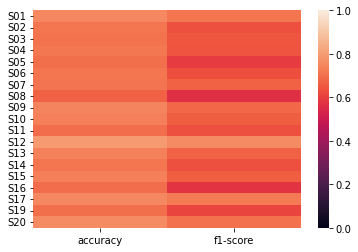

     class0 f1-score  class1 f1-score
S01         0.841270         0.428571
S02         0.824818         0.225806
S03         0.815603         0.257143
S04         0.827362         0.208955
S05         0.821429         0.038462
S06         0.828767         0.137931
S07         0.810036         0.361446
S08         0.800000         0.061538
S09         0.844156         0.294118
S10         0.836601         0.285714
S11         0.811808         0.190476
S12         0.870504         0.513514
S13         0.838488         0.298507
S14         0.824324         0.212121
S15         0.836120         0.268657
S16         0.819355         0.000000
S17         0.841699         0.438356
S19         0.813333         0.176471
S20         0.853242         0.358209


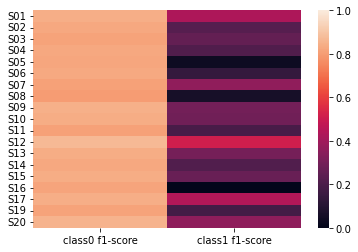

In [6]:
userfold_results_summary(participants_dictionary, participants)
userfold_classwise_results_summary(participants_dictionary, participants)


In [7]:
model.return_IE_weights().shape

(188,)

In [8]:
start=-0.5
step=1.5/(188-1)
timestep_labels=[]
for i in range(input_dim[1]):
    timestep_labels.append(round(start+step*i,3))
    
# timestep_labels

In [9]:
from sklearn.preprocessing import MinMaxScaler

participants_w_list=[]

for i in range(len(participants)):

    w= pickle.load(
        open(f"{saved_dir}/Userfold-{participants[i]}-EEGNet-Weight_TS-w-e{EPOCH}.pkl", "rb") 
                    )  
    participants_w_list.append(w)
    
avg_w= np.array(participants_w_list).mean(axis=0)
# scaler= MinMaxScaler()
# scaled_avg_w= scaler.fit_transform(avg_w)

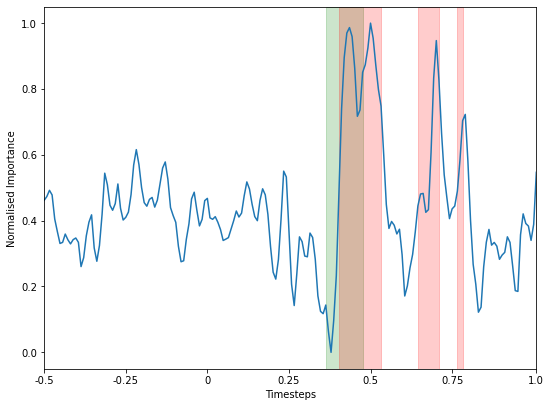

In [10]:
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler

plt.figure(figsize=(8,6))


scaler= MinMaxScaler()
scaled_avg_w= scaler.fit_transform(avg_w.reshape(-1,1))
df= pd.DataFrame(scaled_avg_w)
# df.index= channel_names
# df.columns=timestep_labels


plt.plot(df)
# plt.legend(methods)
plt.xlabel("Timesteps")
plt.axvspan(107,121, color="green", alpha=0.2)
plt.axvspan(112,128, color="red", alpha=0.2)
plt.axvspan(142,150, color="red", alpha=0.2)
plt.axvspan(157,159, color="red", alpha=0.2)
plt.xticks([0,31,62,93,124,155,187],[-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0])
plt.ylabel("Normalised Importance")
plt.margins(x=0)
matplotlib.rcParams.update({"font.size":18})
plt.tight_layout()
#     sns.heatmap(df.sum().to_numpy().reshape(-1,1),annot=True, 
#                 yticklabels=timestep_labels, ax=ax[i][1],
#                 xticklabels=False, cbar_kws={"pad":0.02})